# Nova Tarefa - Implantação

Preencha aqui com detalhes sobre a tarefa.<br>
### **Em caso de dúvidas, consulte os [tutoriais da PlatIAgro](https://platiagro.github.io/tutorials/).**

## Declaração de Classe para Predições em Tempo Real

A tarefa de implantação cria um serviço REST para predições em tempo-real.<br>
Para isso você deve criar uma classe `Model` que implementa o método `predict`.

In [1]:
%%writefile Model.py
import joblib
import nltk
import pandas as pd
import numpy as np
import base64
import cv2
import logging
import io
from pdf_extractor import PDFExtractor, read_memory, read_file

class Model:
    def __init__(self):
        self.loaded = False;

    def load(self):
        artifacts = joblib.load("/tmp/data/pdf_extractor.joblib")
        self.extractor_parameters = artifacts["extractor_parameters"]
        
        if self.extractor_parameters["initial_page"] != None: 
            self.extractor_parameters["initial_page"] -= 1;

        if self.extractor_parameters["final_page"] != None: 
            self.extractor_parameters["final_page"] -= 1;
        
        self.loaded = True
        print("Loaded model")

    def predict(self, X, feature_names, meta=None):
        if not self.loaded:
            self.load()
        
        if isinstance(X, bytes):
            result = read_memory(X,
                                extract = self.extractor_parameters["extract"],
                                text_filter_begin = self.extractor_parameters["text_filter_begin"],
                                text_filter_end = self.extractor_parameters["text_filter_end"],
                                initial_page = self.extractor_parameters["initial_page"],
                                final_page = self.extractor_parameters["initial_page"])
        else:
            return ""
                                        
        if self.extractor_parameters["extract"] == "text":
            #return np.array([1,2]);
            return result
    
        elif self.extractor_parameters["extract"] == "figures":
            result_bytes = []
            if len(result) > 0:
                for img in result:
                    buff = io.BytesIO()
                    img.save(buff, format="JPEG")
                    result_bytes.append(buff.getvalue().decode("latin1"))

                return result_bytes;
            else:
                return result
    
        elif self.extractor_parameters["extract"] == "prints":
            result_bytes = []
            if len(result) > 0:
                for img in result:
                    buff = io.BytesIO()
                    img.save(buff, format="JPEG")
                    result_bytes.append(buff.getvalue().decode("latin1"))

                return result_bytes;
            else:
                return result

Overwriting Model.py


>> Loading model... 0.00s
>> Loading image... 0.00s
>> Predicting... Loaded model
OK
0.11s
(1, 984, 1994, 3)


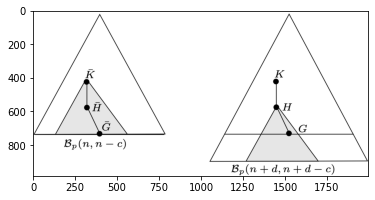

In [5]:
# testing

"""
from Model import Model
import time
import base64
import matplotlib.pyplot as plt

if __name__ == '__main__':
    print('>> Loading model...', end=' ')
    start = time.time()
    model = Model()
    print(f'{time.time() - start:.2f}s')

    print('>> Loading image...', end=' ')
    start = time.time()
    
    encoded = b"JVBERi0xLjUKJY8KMTA1IDAgb2JqCjw8IC9GaWx0ZXIgL0ZsYXRlRGVjb2RlIC9MZW5ndGggNTExOCA+PgpzdHJlYW0KeNrdXFuT47axft9fofPio6mseAiAAEin7Ko48SUX10myW5WH9VaFI3FmmJUoRaR2PP/+dKNxIwWOZtfjtXNeRBAEQaDR6MvXDeWL20W++PbFV69f/M83mi9YnlV5xRavbxZKZqzSC13oTDOxeL1ZvFnyqxWTBc+Xv6+7YfWHthmO7fpu9XW7frf6fn+10ssGfzbN1dvXf3rx9esX/37BoP98wUJ3IlO8XKx3L968zRcbePanRZ6Jqlzcm5a7RaGKrCw5lLeLVy/+9iIfjZGlxsiqrGKaxvjX5tiaoWza9dWKl2p5qIehOXZ9hqOaTrPiGZZyevkHztnxqlzuT7d3+9NA799DRYNFubw/tkND3Ug16qbMpBCumw01EfmoSSZ14Vp8keqE8UyYiZsmB9ukjJuUGZeVH22e56kvMQatlGvFUtOWWSGla5FdrURVLX9nG47HpKGlH9Lx1NEKE2Wuj3W3vkuNU6lMSk/Wr2wTWKqs0rlpoTOm5GLFMiXUaMLjuRSZVrDmodUPucxTxCsyXnjadb8FTlV6+S5JHpgSi4gokxTSmfAkbHua73Bn+aA/XQ9HYgtNvKGW+5sUITRQmstfjhCprmBtivLS/FeFyuFjFYyMZxWspWm93ndD3XZtdws8I9iy3m6pcEvb5tDjLUdimOpNcxjubNOBrrt9PyS5X5ew7/0OeZfcrWb6blW6FMFhtEUpnkhw/SSC68sEFz+d4KN1gy0phVx+/ePQdBtLbU78hzQ0vNeftkNP957cJ2r4qj4N+yu9fKDqN/qtXYNuQwUU2dT0MxzLYsU5EEhxu9qcRvGXJsj0u3q3+jbwfAdMX6nlm/LtS+gn10unDWw9f0uFg+ELGMp79+qGHgx3yBBUamy/eNdA2x/bHmaWIDWXZaaDXHEMIKPVJVrH2ykpI4HXUNCFVnMSWfHqGT4HzCT4B+/eJF+CQCmfIL0K7cnUn9yyBKLf7I9UwB2cGIcuskpMCV2MvgFFVfmxfjlLv/Kj6DedTzWWfsjJqQ+ChCi8hFjPdOXlcd0T94MyhPf4WNZtmh94ngeFJ/NlfQ16JY/5GWsjBoa7wMD0Cl1uj/Xhjoptv9/tj4e7tt8lpyCBrlC1YiWMycseLtLMkGsvez5PauJMKXVJHKpnFoeP658Svu1b/CZJA1P05pTV5ml5X2VFlTCJHutwPTNBzs731USdZzzQ+79gPXWZJCpnGcuLn03JPEYQDua0Kn9GgsyP6/OkISHAHmXVlKHB0jZmFVNkXjG5XIMs8ruNkbmVMEnBpBLBJsU9euwHeuNgdFNwANrhITUkVWa58ByIytN9zozD7FU7Nm/VjYfAzEzGYvrMwi79Kqwi88j2ar60q39sd/WWKtfbugcnBYzJfPlHOyEjV3ZgcdkXQaubF/vhtHlIrz55U8+z4Z/H/MFPi0f3ezXa7mlBp/SH2qzWijEqj4nlP7f18ba54sXyv6nCGqdYdG22TT1jneY8Y+LMFJgIh7IqLm28KisD663ThmC075AfdLX8BtR1yh4C/co8H36b6s0U2QWbGTco/9ROyjPYzNBIeUng/HSzst1+sOXr5D5RDESAf/UPaTWlWTyCyxP5Nt2N1PopE/Fa2goisRz7mFBBckOQ20UT7dfgIdSdMTeoRdIOKzPGxEVGeQKbiP83viw5Q3nuGMcUI4BnzC+w04JWfS5+sXp8l+qOiyzPi8uGvgwCwBj1OI3WOIZQiBEbkTOyWo99u+9AsBQFX76+KipDgD29EBRVio2ACiwgS2k2Ylkp/Zo9YqYHTvou2Y/IOK8u+vqs8CR6nWBImVXGrD/TdeOPoT0wUnY17bw0IMZyT/HhHlVzokeujEPhhp/EhoAIYU/OslT1FJbiHyOCptBiUS2Q5/yeFElXNgeLLpPAmSO3ebou6O7m0GP5rBvmuzSwWsniKeiKCEqVvD6FWNEE80DDtCHohJdixAiTgSGjux53KVZBxNev3qofmgP1Ocs04PnlWl1imiJYB7+kHJpyT66K52MfgVvsudiHB/ZZcbU0k1Wzk9VhBZ4K1Ykqt3wD68tBDG+3CBHcG+AOV3y97/5lxPB6ODmoAKoJV+YGI4BbtPOptD94kA0eE4Z2vW129jXbyvpHixXPSxjRWLsZI0IvUSOAv/BA0EPaOiiEkZIf580gxDHQdX06msl19t4o2AgD2Rzb90QSuEFdVS7XjR9YsgsCOhuzC9cOP+kc7NK6AZhm9Uu6673FBDdvBNQykS+rt2bX+3DSNJa0KmBnCeOkVqB3zER/n1o2tgQz6KyvsXsIkj1s0r80aY9CZcWZD1lM4G6upgDbJJbBMy79wsiUFMJQTxEza1kAs7LCY1Zl/jjoKmEYunoWzFXm8imYazSlT4W5iouYa8rKVJOIUZCTFnMFbrGYa5lbzLVks5gr2JjyEuQqAmN9OUs+/XGQ62Q6GrzZCeRqht/UNLdgLaYGolAvV1NbUU1sRRV8aiKTixklelwVvAI3Ro4FXZdWRxHE+EEY2JQIRXAvZr0iEQD5/1CE9UMgl/Eqw5civ/UiDo62T2o8ZZ6VIbT3XZJbYHuE8LhTOrPcIsDlVY/iNR/PJFPch0V45JP62aQmCBZ4rp6D2eQnZbY5F1w9bn+fOekcczEKhrHIjLt0jj+iYZBrp+xzlbSloAE9hobHU3PF8uVLAkqBJ9OEFEDJfCqeRpRUJtB20XfUWc5GvqMbyaYZmuOuDQEkGPz1Az2r6WICTK1BquBhf7p2YSJsYsQtzsi659jkHOBuG4MZ69JboNCsfl+32xosRrIPwWfPpAkpRY7Oer87nIZ6aPcdItBMl2bLvm83TYdmGdMVaSx80u8M5ITFw7HdNb2tPh0OZGUOPb2RMJmwIZhMaIdVYnmNaTVYdeqg9+HU1UOzfaAqWmTsZjKSctnaLx5rI2VwWvnU4G07g54XxDQciIa0x8K9BcigaBB0Xp4FprEuZe9xN3hOAfiO6mq6ADP2wHFrpCLVkJLHD90Tas9p8HjtmjhHCn/tgH9Hz0MsA1/aNLUb/WTspz7pkebjBU46y6zIWBAys0FvEcEF6cijyErFPsjL/HNyPODyxsJzPpwdB20ptcBw3gC+QmtCKBjfBpqbfAQgmlNGqRniFM8Gdo4/BdCktd+sk92VmQq02KT9p0iXOigA+wMG7wcXi58JNoFzl8tHQbcRwIPInshDhK3SFlGubDyp7vc2feP+7sE2sMwKdXf1+5CNQfFul/JBzmYJjlJeTvKCQuguIfw5EIgVwcIeyzDS44faOn5JZESDtA5WrfMAwS/cts2RboyUPL7DHVXxMHt0GGknofVxOo7i+ZTjhw/2dPXzNT0aEdHdpvzKV1ZO0L6HCh3cWmuXDCCDfdLh2NeswDaGqhX4gFxYZ/PVu2bbDPuZPEUpMiFGeYppdBJsCOZ5pbddphSgUJkO+NWrpP5Tufr15UmpTEQmeU9axTA4Fm5ORk9BaZqjh3XpHL2yjBMCf91G1TwpUBWBuW0AFjtXc60dQdb1wZgE5iaCcOLGNiRq3hvoOpevB1xeZHKCns7Y2aVkT7CPdfCxZzJ3ilxctI9/0bzTn5T9J+Kgb5VfSr8r1PIzuny//vMV2Lr1A9223UDGDb54WnuBVyhrVBaUQNDGT2AHoYDDYgzvme7su3TZ7Z1pBN3cNl1zNNoXnvTND5wJZECjKJSEtZjkVJ26DcprgcaMSWbk1bKrd3N5HkUVczcZWoaFsYNJqGqiEcExLVlITFmBH28+SUmR8FkMnR7bSMFtqNuaLmPLDl8wSZY08P5sCOb2uu5DT/BCZ3vc3jbXx7pdW2scww5G+scb57SzQ0H9kcsEfpsXzieQYSZ4U2/7va0+1l2/rYfgchRW98PDOO/MVIxwZWhpQFjqvLfvxKyAfdnv1KkOJHEKNIsnk7TUR1P7bdDfTYT6Gv1KgW5UvvvdBCoO8G8S6nY2wpmiFhT9AUmhTWgwUsEm66bKLS5fObMpX67BLiE2h5u63dFjM5LKj6RCI8YaN/b9PVUbKOSuvW5t/x1W3FMbYrKT7z1O7cV7CxpGgyEfManSWawQfpJPW/GRIiPGq2xk2YzbmSsviatFqTM55un7drgbgT/vWzdxMrmgbKy+zRgjmjhV8ZqjmWotvG8M8+3oQbcPHe+7l8lcGQUWD+OPAu5gRwdD4MuZsxUyGFg6bYyzAFO146kZ53kSHZk9VAIOL6ozMc6c28zEwvLyca8OB64ePVwCq874xcMlIxwrmRM4OlyC0TaMLa5nwm0ydPYF4Rh8JlpSqeri8MWHDb98wvBTvqHMdPBGZnIcuM5EyH3+ZzoxTga31s5+zs4w3yyfmwBiLq8TEzT0hKHOYiIhrsQvEjKdG8qKwriuK3QRueVw7jwgMYElKu6H9H3tBPwRpeUVB7XVp2HFXGUlVwZW1LB1zev/uDJRL1DPRZTnLbiYSzoF4VFE0Yx6u297et2YQ5vmmKQR2H4hy+y23s6u7khofHwemc50OGRGBkuRBi04FHl5MehbnQV9k1g77OPqQl4Qz1jgu9oSz1N70h/G/uWU2atRYg+OTZgQ0/yxAVhx6GYVNVvd1GuDt5ilu6E1p3QppNRpiGwkrPGzNg39WsvKHNFhArHGpHOkwKnkZdI7OovpsaK6FOXNS09ecfFA30tKGg3Y90Tq4mHF8oO5cgYjcPbEL5UXarbCSog8rfd4kbEQ5dkk4qGEzUU8wmeycgUfsZKlshf/EyIXsdf7SbY+D+Jx0yJ6ngzniyLe1pu0BaOUGCUVcl0QJm/yB72drWFLGDzeNHhMQlQVkENcyhyU6nKmctTNHGqln8aRnzBR+SxjSIEBezoa2oEseUnh9DYpS6TISn0hWRKETAikG5tTW7m/AM+3ypA4k8NNLnEYrem5vGFw4aNcjMvQs8Hei3nBU2V54NEn74nZrL+nxA1CfuhoT0yCGcAOuf6Em3XEVmAiCzzT4fHlqnDBPE0qxzjYsEoiYxvsEiF+zr0Vgy9YVxmBO6qY4J+pzaQLo6PsMP4+w1lRBsQMfgr8Wf3n7ckRc9TpgDwr9cTmoy0lNNjHk4DqGbUnlATGCCfBrW8shLclsTy2Jc8yJHLuWe8uvRfLKGX6Zubca/mzaSXjwHwx012E7l4ePCkdIeZSpcCE0fqSNgnO7KwyKYLD9PeZXqJxB0+vnEyuCnl68/2MBbQQ0fEvuAkcYfEkKBHAZjGl4cGpCqFdVpnAJFJb1TWtj42D/VmYmOnkxAMmwOo46qjsYTTlgoRQ8ODxfvAtkuRT8dHLOfHBgpju6JOU/gD9jpQQVLuR2Mfbpr7xD5J5wuClXiL8aAB3JnYMHfpNh7N7ZNNpmZX543yrMl6O/kqj4MuvHtwEbYYHIVkxkWNxIiQH02eawBvEicWQzF5lOsbVHDxKsfC+J3Qca/wMERGzM+ztLqU45W6MTNXHoR0hbqnThRKPwXzyqOHzx1fsHkGIRhAGXMSRVRBkzAWU8SanxB2ojP7mQNvsYqweo8zwRL2lB/3p9rahJDidu12rmeUDjTi1san7ob2t3ev0hw741K8ivjJmCHi6q+2oQjJLu7H91nYS9YONOji8O2Yxg0/LOFMJLQeHshZcLb/fD+37KKAAjw0pKmnElDH43NFZeObHi8/H44Uay7iTdo/tPyHAhVfigrdShsOLUfaCnGQvmA9jfPjhbNY2bwF2YgEsKSc4Nq09H609N7E3uNA/aWDpTfH2c3REpUuQhbrHIvBMgTksqydupl9TsBJczbyaxJ17mnDaj8CDLWoChZ6fY+OT5GnoLvA/H/GT2XZeEsJDkoRQiJSXfY+2HI8zRSfwSllkefH4HyYhmjMxA9CzgmolJkqWZLJRX7S16ZYSVuX8MEoEOAOrN4doFcdSmGWciV8538zxDlBsrC7zynnCLrJsszelDrSkAFCIUmNxoh/VY4f2ZAULJYMn2A91t7YdmbduT9v6mFTvsEkDpGrHZeW4VNb6kk6xQ804kiud9QSyRYlMMD3mlna3I/nT1nRgWU3P9Gr/BwU1XQIkiQ8NDM6U2zNMu2Z+6zA1PUiM6Yf2hNHG/SNBN/oTBB3TyP/vgLbhP/vHBMFGNB1sHywsikn8To8y5fVoHAnm0V8vjGK5cQRV5j58dntqN3Hi1vWDC6K5aO+ZFo3ChrEtdG5W+ZStpMmU1krCAMtjs3B6Tk+EcNu/kuAKyMQPyBrMnIYSGTPpd1Hg2gMB+N9kA1hyVDRUKgsbT0froG8HeyhNuvMckh6Toeqe2X86K6axWHhkiIrfcarN3MWJAtGXL6SwQMvP6BJSWAwPnZsslmP+94TYvdQ+hi6kmuZqwNO+3R22Lc4JV1m4/YmFURoEvh1nMWADOhdupA/mVVCJDvT19MbJ9WkfU1alfWsPX+XUrsUU5x0xZCIPwv2bkElCLFyEP2ZEqPTWEd3dRCkPWOHpbqPirzCj26widdjbdl0UeR+lGMAzSvCpbMriJAXj36f26LQYtImyf6DTPeWP2wTJ+zsyjrDLPjVhSjfl4S8VuXSey0BXSthWTiBwK3ngmgDE4O0iY/SYmBkKfw0u8753Dg3Uy4xndGzyq70xGrjVKjxoFa7GtIEP1D4PXC3fuZwbjkt760m0aZvOtW8732VK4B2C3Lwxkob5Jd2fjlQx3I2ktczdwVA5/uM3kxYzRLY5PLeah7jVieNKeHGMXqRPMo8+ThRwipelqA21nBLh8bt3bj/QiN1pHMvCbF7kJtjCC+D6eN0Ox3qUx5MSys757ffRUSP8p7xxMq/fT5QUGk4LTfKIbCsn0MZnO93169cv/g82lGgvZW5kc3RyZWFtCmVuZG9iagoxMzggMCBvYmoKPDwgL0ZpbHRlciAvRmxhdGVEZWNvZGUgL0xlbmd0aCA1NDM2ID4+CnN0cmVhbQp42uVc6a/cNpL/7r+i82XRD/HTiId4xOsFnEViZDKz3pk4WCCOgeh1670W3MebljqO//utIinxaKoPx2tkdj61RLF5FItVvzrIcvYwK2cvn3z9+smfvpV0RspCl5rMXt/PiJRFxauZ5LKQhM1eL2dv5i/r9a7tbm5pVc77/Y2aNze3ct64knbrvqwa+/Cwrx9X9nF3f/P29Z//9G0lok4oK5RiMAbT/KOtEw+kKrjSQ43bB+x1d3jsxmbN76b+rd3Ua/uyWNcdfNeK8TnDJp988/rJP54QaKSckZmoCqIlTIwVgqrZYvPkzdtytoRvf56VBdNq9t7U3My44DA8Cs/r2Q9P/vakdOQqI7KRcLRD40QXmkg76J9pKQ2hdoZkGztKWpDCDG5oDZqKiCNUwehIm780fZaCoiAkJSCPCKiKiowE/A9bg5VRIwSqVEMV6VZBxI0QQwhTo94us2PRRUn4UGmbG4suKnnNWGBdXU8qrERhncpx1lnWArapxrEsnuW6wsEMNVSum6iNhxxZsMY42AIWVtP5N7/iKu9vbkk1/2DXet3U9zHD1vZnYkON+ykzKMLKQhE1dPqDqwM8V2hZWs4pRClmt6QQTESMEc+fF1IA8/paP5dVmaMlLyhnybrGTQmQFeOQoBmSI5YotBgXf1W7aS+bx36VHR4H/h/JD9WC4cXcQApK6OcmCL2OIFNEUSDeAg7KCMBbDpKKSTm7pRQm6oTKC6Ae556B4DlkoAyZBPCNGHr6e64n2Hu6lOEKZQZMQB+Mdfb1pgXxVi7qvt1t7TDWzY2cmz2wztFOqkL4GTe5cUAPnAw12ns3u1Xj5odvw5xr+zOoBfcxu3E0LaRSVxCg7m1zAYfGU2G68LJ3cibjRPLbGeQdI39w5s1NDXZzOc6tXw3EsvsaHja7YLngu+lpdssUsiGF+dBCV8T+fbfFelrN283GMPCyrXtTBI9Nt2i2y3rbuyoTUrEqyoqdXF0NEw+FNWfV/NVhb5vtTL+LHag20+2mNnAGvphpdIe16/9nSkmizaEUdqb9X7faAfu/72yxows83UP1zGLAUhigECvwhHELISu/HJRk9SaFWuOyVtCpVLAG8KvmOCUp5yJHFE4KQqVfx8YuE69K2KbaLRPN73ZGZbjbOywRBh2YT2bfuELUe1hm9qmhXt/ZEvtFjJIMy2Jsaf5vVmeBq4UVHs23fbuzzLKo1+sPtuL7FvZqtk7bf8huhxK2Wjmy+zKPQYVUAedUlM7/50aVOEbs9NFOyxHCUZCwolIiZvQM8yjpmAceDMvB7w+WGZHKnS2p7I+hLT4I5N+SDQ1i0bLt+na7cIIYCu4AgsAQ+/cjMbdZFgTFEMjbCRbknklPsCD38pBcw4IlOY8tPdD6VEOsrhviOMYlCCe3Lnf14p196ndu3csKRHci4HAJdnusSYnFgPD7lwHswdqt6s3ty32wUKbGv9mfvy6+vwEwWX+wr0Cip/jk+AVKHut93y4O63p/U+m5+2jNMKzfdYfNo+GLnBKD8VLBT9I2MiEmaRsh9ytoWxbUW3jt5nHdGuriyO3PO5QxbvJ2q7m9bXc0KBUwuyolY2k1QO0F1KsH27Tr67t23XbNvnvqSkLI/Ya50sxGhVIw7t46/G42IjwEW9UWyCOrLjIQSxikKjTVU7YhIwQFwlnbUOvzpqH0xlbWNCTlaVsMqKnFGbtQeahgZG9OwkA79LSA8SM5sXWDwZxkL5FsXSovMF2FIidNV2DvstLn6SX/WW1XLquAleIxgynGdQquRIo/xv6c5rHMXNufUb/Dc2TqYkEe1ClWSE/PPzY2jm0c01OyK9CQqwoGqxKphtAFYITAsskixYrDJvLGWd7Apir1RvxMCR8NpwoXRc5/A6TQZfuAgXsoNFiRVUBwQNnK0tvZoWWOSGD2AMQPaj3PbrpIYXx8b7C6LOrtotXNMkrkbDzhxxjXoTssVoPX00B9eEKob5XEOm8Bk4J5f8U18+apcSlYOG9xCZWN3Pz3rPgCIUirT+1wkRftS/nZHC4kGvzoq77frdfGcmu3D7ZktVsvv0q1cOyZYYwXCjbyLZCOUuVUzNDzpPYGy4B6D953WR0ADXpPxMuJiQB2G3FTFzkWA4cIFvZHvra4N5C03gJo8iJN+fFMujKYOq0l0AQfBePTMVyQBg62h41TIfvYbZr6B8ycBv9AdyrUQEtWaMbPU5T/7kmiF0myiYUxyNUwmvMSTw8ZpDGVR8GRVIcrFXkPp5mVc1kwhrsSDBTutM/dJcwqvOkzhTUrkME8YaB0g3I9cuuXeZbX3gqfFlMAoOi/nF8YUG5pdXmWK6kKOXeKKyvNY/c7GpX4I44dufDpjCOXlBS2gjgjNThVkScXuzS2E3S626LXBouGT21vv8TDqzLDE2eHBzZSJeTv50nvm1jmt2DkGzq9BWFLc+P8xC3o8P35HQhosaTnrT0uq5OzBRFOxcnZom5kNNiErKITm5AUykPcf5VNyDRBdQ2bkTtlpVjo0rQFozSPwy+8IJKds6EYq+ItCu1Nam0wJ0pvljUTcdvzWltW9J/QyIqikk+tteOwBBAtCBfBW+tIWdu1G20urBiFXaHAepDxyVUzthuVsgCJl8QtTthrtAqj4as8Giq9M3L0KMX8dAl6k6JQSp7Z+5XXD/m9bx5PijrYDgHgvAAe/XFMA30JN9HTcViiYKuALIvisDaAVIn5tjGgzjwjJt23j4NTUDj8Kubdu2bd9ENplMwi5ovaldfrbmefRkcKvhysq3Jp33pXJYk92AbsD2rMfdfbl8Hwb7YLVysMbMGrM1uhZbCBOpR20PWLG0LnbgugpOA0drK6Ad67YB88O1T/3rscjP+5yZodQPWj9J/P6HpmoBK9i9R5TIbAjkHrR8Sdcg2D6I6zoK51DN8STguixTn/MBUUOzvrH/ahzmnEQJk6kzqkziXrSH0ucYiVlziImSJn+EDqS/ggGM/lPuIjPsCgXuQ5A6Kf9pypkJjbjE/H6rRQi2adWQpUOgu16JTrLJjo7+gOfWfsaqX98b4zWZR+3EbKCTq4zgRxMgiKJlxngoASrs6kmKkq5doM8cRHES+dTAXwMKg1WiQ++wvmMgp9Fx/kRSlUDCRGd01uc6A3mV3huMjghXilGKDCPy52Z/8Xfr5L0MrXmQkC6BPVZ8W+KnQeXY7U0r0YGKXX5ePVE2C2klfYwbeAM5zvEdHEJI5Nps6gDfb/z6hMQ52FJr5iWX4uNP65+Jt9GtvuDBrnJVo9IkbjiM0Gwy6Et/DqoVy7tNkb1JqDLMDJ8NJhytDBteHYGKr2xmdbG4MvNCYZ5ox1/f4wJt5Qi/bRtByAtC7n3/WJJWoxvqLekRANYyJ7KUHhTn1ESD4MRX1om/UydkDfH9Zr7zn3VgrXo5c9SOB3NHvfr2JH/FgFGeFxf9ha08Sspym/29fbxarpsmnPC5vOZfP0seej3GdnhEdjwMgMkqCMTZAhzSxKy3jfLqEwm+LBXemLR0vj7bL9zZUU9G0awnOyaxdr9l/b0drzk3u3NcPcBo7+ZAFH+94sVmcYezYuKOJxB/tHGwTw66oejA+Ar4ENCJ8Wu83joTc+UXP4AdFu069sl50tMHailBa+Pq7HrEz4dH/YGzeJeYkTa2wKjrTpefh5dJlgk0F6HrK35GMemlS2o3rzuG66oOB2mntX7V3be9PWm1CZFRoDqztP/8OQQL8bDoO8axIuPY7u7e66YS0N/bqr0nb+3mxqk85lLD8e/3fK/St4IbxH6DhMOHuDDmJPaSLSQzZkyG/EJ19PnnREEQ6K3md6ZBMcwepgPu95YBHoBJMKa+sxIM5j8IB5Zs8wG0sFOwu+vuFvTaCCeDFMYi8DNrgLZ7M1Pi7iuLNvbHYOyHSMRZci3ujD+p4+heQlR70HvtrX0UmMXLbFs4yU+LZ9OARZE0k6lmEH78K/m1rKfGiXMrDz+ZlkRg/nTyREBYv2sU6Pp7amc5xK4vaMpEkQVrq8RfiQBmHhUxyExTqutdq+eumRJP+Yul1U9zhCavvO5S4yXrCKnj0/FubuskpYZQxduSXfOAcXB1ypk5xnr0v71cA4AQ9jsHrw03oeHsRR9sgbD6H0pM9LXeTzEtdn25rlH1v/CN4HQQgiT7EzUSy3BV4YtBHkd1Napbt2TNuO64nTYk1Qk2d7WqwRj0a9HqUiyUOnLkMdf6etE0DNPu5MJnjNJ90VNtbwrYESmBefiqOEKONkXQovI2EQAyp7bjWvRhxS7yO2ghOUDNcsVrBbJzhtzd0h4NBYTYZQ6gjpJSQLqkwJ5AuYizkMpKmV91QURDklywbgz9JoqI8p//e+WbebdlvvEbHk7ARagu3KuLETJKlifDUcSbC+WnQ6QRGotd0m/GjAmv1yb6iwsR/r9UMDOLdd2G+RwGRDBrZRzm7JsdZ4PMKKXCwy9eyJiQCR45fh2ISPG2BpEDcww3Bas0wlV9Mi6xGUsLvNbv8IAmxjCyzYu1s3G+RSqWGb7gwyIoMCgErv6w9jOrl36GNz235khuXBgoPgfyAQxzD96NwjTs4Tauyc30a8Z6rYCT2sdod+aGyo/Vg7TIpjKaKJOvZ+fSPYfDfGGtquz3BuUy+HbBuPEHzCkRvypGnwdRoPcEakt2m61W7vOn5Y77pu3OjDsHOQMoD8LzwzgWkbMxMWpMwUNBvnKTNQH954/usOyYENIC+NDfFSJqAYP4Xcju8mIoUPYxwKX+6tBMEmWvcdQeLSGsfhH6y4eOdas7mS+Ld6iCi5sUZ8+1/N4V2LTWFtBirkDZFPrd7+z1X92JvdheDqu7dYDLbyHXINFjkeZWMMDQvNpO7tv6zUNI0aMxAoKd7aAmPyMRs8G/9mxEKz7d1/LSP1G1fizuPgp/G0G5Yum75u12gaCUJ8+EXwOHhPwizhv2WcMzb9IOOcSV0hoiwIJca6YoOIWzbA1Ca9Wg3Huo6CFqSgQl5x+r5eGlkHLe5HoxPfAmY1Gd56MtJDKPrnP6pLkDrNA3aQISZovUqPSuGnrKMLc+nO0vLI0YUsxlzOEk5snQ+m8bIQ/rA+YDaaxyPKBx6CJHllk+Q1yBdQZn07HiM7in8IGNkV1DNn4YiKcwqwwCgW6PCwHR1LTJcFM85AdMO66Qd+jwzZQaUqoT4BCyPZQ6rjcQTYm4NXQVul0ayX2Z2ELvNxzt9P2EpBgPh5rhVThX/UXD6FT9mzzFFUjfJzZ3ExzS7KN9XEeq7gd7BKOquRtXNPajTaHo5OjCchFIBO/szBBMRW3rfwKbiFn+cW+ANTIYW9tEl6ZCAW9Cfiz2hNb+/qru0mUjGFTs/3HK1plRoS1fTZHIDRREjLIQDWhvevgh8xvIV1j2fLNFBOzxgoWx2tKbz6WmhTy0yAIomQ+oyjbJjDnsq4Dfp6mDKZolNI47Z3R2aA6KnDcLzthYGNNJpN8OYzqWM+AIM1OL75fRY2QRUd7KF84Eb5bLpXWTkD0/XGfV7OsIKLS1XVVRlSb7IukqJkV8mYt1mnQdAKnn9mzPhQkP6L3RaPV3aW/rUtBLXyj0Njn4PVKucAm2sX2Vcx5YQGltInMwzgkXtB9/zGOBimpCveU0HI8dRTV4ug+pjXj1wtPlBKpoSwhkoycKuxiszfr1qDYpkPxTBr1w+3ITAT3EedS6U7QDIQjwLuwGiUMTQYt3IbygwNXdmDxQpb++Xug/21dg18dlVz9FZ4c9DRxQMyOoXERSgrNhOyWKlomxvfhYKpO99FpnNWFfTYA1qd6PvEMbOw7+dTV2x4T9mrbCIazGKkxVd5OeUPf77autWxGXtA59D1Z+jfuvVZNghcAGRZ7Yvfdvb3fl8vHIZ2CaaYIMwNK5TKqZnp9aMqk711/fLBo8QTiUE9F/tiUzk4gOCpB0qbLMVpqANpVgwC2PQk/ynPWsHxF/TclnT+woSGOB4Tt9Zwby8GqdjRyXBbr7MfjRciGxwB5ihTOqrpxKYJSlc6Q+ojKUJKnmNXdSRtPqa3aP8AIvRJBl9mEyQqf3ZjmSe/QJvy93KGPLoATCVr+nXjo3ncJ46y+fs9xgVzGz9MYPIKQJXnMtYu2SCpjEnlW5DXISPUhJkPQb1f8rfmSDATU6K6K1dIobkVAGNCg5Xkms2XrXdI9LboMXTC9SO2z51iEUXpj7H8cu6mosXu0Sod7Q8zJLRlBVH8Y7j0WHvoVHuwkrlAPvRvoyvwYJlPM0+SaSxRYj7clZvol4kLoTiPlx8xKi29acrCs5aWYGYl0LLOwkjNzM06bnA/TnQbpDnmz5MgYPVL9moC0wa39tkMr5CAQNKs+EYfnTF1Ir/cjxOQTPMU8GbUb5UchDhhCX+Ra0SGM2nRI00RrlH7lE8qJuE9eVMAELFvNdnwjxnRSnnBy9iVRCdsRncsXUTnXWNglKB1hBkioUQqQXVkqESHS8+5jwgQml9+1dHt4Cg/OpMyhH6s/yi6rjAxvTATT34Cz5w0cdyglr/KQyWn2InPff8xa7sqKnPrd4wuk0xsE2MlljW+zALb6HKPCWAbC55J3mGJ2HE33WD+HDGhA6GdwfBt/m4xsIBIJTxv5w6lhVfiTeI0P6OfJnS6T94H3QFM6CJB+RA4Dw76Tix1cO1HEHdyYDqNN9WH3oe3sj5ngPchXmAsC4goi9mwzVvdeIo2qPVV1h9dCCESf8MpqfjFhKfAG0nf582W4HziM1BMnE8KOmAY5tPI5RdZSjHjHzoWmYnqpDzk4DbvMWCKHtmFRNuk/yEumBknE0F67MsJnUM8dS/QOfdnXWwneIKf5wlRcEJinnCSInePEDf3KpfnruxINy6nkxv3gns/lnndF8j6h3xoqdKw3DIGpVbrDG6GKjhPCYXhzRN8wh+nFewietIfl7I2raQ9HT4adWB+f8Ao4RoDRK4vU3wqa0TjLU7kqsv+WGk9kkGM+qk9KDeaKtzGtG33tS15aLbNvu4nRDPexUDlMfulkpX7g98TMBDYzgv5lxOI4eiYKXqWsgYx40W0LXj+9iniYcTUASURxi0mthfeNxOIiHd5baBAG5wxmQLvcD0c0wuzDDC5pf217fLLISqMP5UnBqEKeYzHj2Zcyss569mYedAEWds5damKiJJ8Ynz+FtnxLMepncABxqr0Pql0mRkR55Y5FDLPs7QDRBZc8j59Da4+x8bK3zA2fY9bAP6W+fM10vt7LpjUKj+nqih98B6vCuryScDfvH7yvz1TgIBlbmRzdHJlYW0KZW5kb2JqCjE2NiAwIG9iago8PCAvRmlsdGVyIC9GbGF0ZURlY29kZSAvTGVuZ3RoIDY0OTcgPj4Kc3RyZWFtCnja7T1Zk9s2mu/+FcpLRl2JOMQNxputmswm3plJNrNlp6ZqEk+FLbFbjCWq05Ri+9/vh4MEQAIi1W473tp9abIhEMTx3Rfzxe0iXzx78tWLJ3/8RuAFyrMiL9Dixc2CswwVYiGoyAQiixebxY9LerVCjOJ8+eeyOa7+o66O9/V6u/q6Xr9afXe4Wollpf5sqquXL/765OsXT359gmD8fIHccCTjWC7W+yc/vswXG/jtr4s8I4VcvNY99wvKaSYlhvvd4vmT/36Sp+coeFaQYiFQkRVImDn+hDGCWWDKl+XpeNgf7u+2dbtXM/rjN4z7j0v1OIXBzYM5oaZX+BKZcSm6TnWzOa2r1o5vLpu6vD005a5uy+tdZYbg1B8CwT2jqBvkn3YysB1ZIXKzlAwLslihjBNuet3FJkMzwdHC67Xa1U1V3puZ7Ms7c3NozMMyD45UZrkk3Szs+Ix5s2AZZcWCZAX81Z1wYhIE5up1e6peK5bHbXV/JZfd9pv7yMYDTDGEu4ls47tecNn12NTtsW7WRzNuVd9WTXtX9udwuIlt+ooAIPFCbSrAnODvYe839R5mUne7HS6SKUhn3RJexUYsYLv7HlW53n5+tSIELV/Xxy3cIWrW+lu5O8FazTtkAFg5ywp3pDfRecBLeiD/JLp8BOjmneYr2FaxrE1XEoAQwhmHp/yz/+JqRTFa5qY7DRaIROZOkcdmB2eTyx4U6tggMiPwzPxBNrGdkpnAhUP1PI+uDmWM9K9CsXGYf2S3sUMN9juDzZG8I0rqRBWOxk4pzxCRHi0SsQkCArtOX8TmBySt7/DD1YrByXxiDuiH2GsJwI8DUkBjJuXyFBsY5xmW/Q6KT6LnwDKW9/t3chR1BESYeofB8iiRgE49ZJ9i43Do4ZFv1h1Y4QG3GcUDV3f2AeXjGZPDkw/PdUU5nBHMe4Vgk5EFWCBBJGeKFajLrSJ5h9Od+o8vt8B9ev6jf9eIHcNjyjPOiTu4xK71R/slnGmeA6YColb3qS0kQKwEngIqnkkHAt42BjMEGpkTD39wAn+oO5F6n5oXbCAQ5znz4uN5DYkyptjHNiaWf4nSQaBFxPHgrdnAf1MX1JGMcGhcAGHsJ6BIMyoUi2tik4XOBHFH7bE8cy5IZhLJy9evp/xlFDth5zkbcNQz+PRJ/IyRT4qBCaD0UYNYRP3Z5cg88Fl0ejRDeT/0N3HSVmA6ddogNzh4ft1JG5EXriiB1VDAVQyoj8+8FzogTBxexbAT0OgSJlvGGVDhDgjHxDO4pQJNiGc8Ip2FC4LuZMihIzMG4onlWPYdgmCe0zmEGg/WHg7DQHISISTjgvSbHeIGYB0+v5VqOH6WB8sMs35xikZjIAtlVDQXmXSQ+ajSYXu61lKqeTsIqfp6VmZEORApB0iv4mvzyHXdpADW4cn3CflaSo/vY54v6zjdpBljYkBawvMFOVaOUIiPUIgOJLSh3MSF9KgtZmeorQRp6X0TWw9EBzATgOg/I1KHghk8kDpIBLbyxQoYP5uGKxC7C9EzOYJIr+cyvtRUsD3tjlpHANqnKInsiJ+VVMprUN7z5eFKLH+zOhrLOx1N399p4cX9DrBqO4Fye7g9nNrdW9NwPJjrj/Rzc/Nttd+XrbkHempuPu3+xy9tt9fber01t+v+Rfd2zK2dxrpso0ojoTTLBZ4ARILYFCAyx6enATGzPVCoWgpQ6CVQWQUKQNZ11+evql11BMReYYl7UbDNoujHMyF6Edh/ErknzUB3u/Kt+aE0Dev707oud6ZN991V5pfajlDu9of2aNrKnddTn+q6auxvR91WHoEiHVvTS5Mp9RJtzlnvyrbtZlXebc1iFis7/YC7aoBsre7vrwH+fW0OujcN/ITz/L61+vymatf3tQHPHuyg/fqtsSp8WznL0rbcr571K6ka0/NTc/lu/bcrBLL4W/Pvqa2bW3NrgAtumnJv79aHpj3CTh7r61180mWjwUMhqY9IrzuMsYh3YyCYWazgyx8Rf2labg73pmlTHct61yrUzYvlNwf7ROkN452MeqBu16dWswnd03APvmwdpDAWTJjxGTPjL/UU5PKraqcQ8PXowZvDzv3CDM/sd8CedLurb7dHg617DSebWp3oujzaCSt0Lm2PbUcYyp0Bt42lIt6JV/apU+vTnbrpyMzLpwGJWil22nbkohkMp/65OZyawShtWduWfnPg0qwrC9RAGQTIMUq7w8SS7W+rY1RmBG7h5KL/POyV6CuVUqYu6v8xqedqEwFrOjNljqPSG9V8MujYszWZlLq+VxArl/+CC2j630fJZ57ljo0/jQ8pnVr+fUJIl3JKSAftmPczc6dCC0fjnZ6smjVww9XXl+PmLqqMsTy1aq1if2IOISr0MJkJZ/C1IAov9rng+rC/K3uiUPQqOxB9BoInlSE12APbre92dQ/7BVKEK2ZthgPw5RCME9YjHFiPUG89wgVQ+H15W5m3HKLSGpeZM5bdxG2GIM+hgSYy0uOBTvnwHVOPGdyKQMiGWWlsVBPdVJpFQVNcRuVw63j1tIyq9O8cL9tDSht14ttcw8NNXBBkKLSGKG7fCROhxobzTBTFUGMTMY1Nmj5NRFhkoeXvgeYp6IusUd6+y3AfOID2sI+b4XHGaL/WJgUsTm7HcecGAEs///+Kz006YccC9bNaS39RNQi0dxhUDgSMKq5WIw+WNepHjxUB7jryl6d0eN8UirhQxm3EubmI7vI0qpIEBHlT3aUIN0YZds6P5zFWkXFArIjGOWQVgvsK5yxDapOAeRqQ9ZQVUIJewSY079xZ0K0EFdHICoc2USJV+JAZp1E5gB2ZplEeITNuFUyEJaMRjGY4o4LNwujifWP02M2m1CgC/LKpzDI2lRK7Gu0HI8YfCa0+S+pUPWj2eC70NbLv6d79fogSAOCJOAPl1XjREA3I9YDB+eQ6Si8DDEtsbuh/bKJWMG93P4viD3Me2ypyPvACPOd8xATFVZP1z+e3ukyIi+ruEn9HGZe+UDFY98iCWOTFQ6D399nfIfyP6NsA/lNkSTlPPOMN4nG7qMeEZh3CdXwY5FxcDz+FjxnMx8eAx8fgazyp3cQky6dBGg0XydO7OftIgkUqG3/O1OEWzFtpGKFCkADFTy4YAyERFMBBiAoFttaHqEBH2geo6MCU4H39ULTQKpXPxUYyB1aQIDi+QCadTT9GslK/kf+KDVFoK+O5rVbqKR6YSTFO4IHy1vBHwYNiCg/4FB4Uj0KOcIIcjX2SJDAgwmOEgCjCgI0qvxQKY5UK6my4xmZVEMevYweFAK76c/gusilWcPeFyOZplVD2VPDUTEESX6g8xfmm8xwavZFq2cVftG7UhgFoPajWTXUflTpERgoyAWXyf5FQURAWQFmpDVmwG8YYG4NMkkkXZpMyKzjJS2lg2HkQxrAWets4EE8y6VrGY8vGKHLG81ulAIMNAWP9Fqa2BmnWgsKNBY0zILEC1TGTkoSWmrvEvoRuMBi6rZt1lQinoI4+3sQjupizfekliCI0Kcm800Pgl5H1CNri1iPEYaoFu8h8pNQFCcrO0Qzcm3bttLT9KxYGAAqqZI9z4HTiwB1dLtdHO6+mBL2k3GlnE+xW3FMqQBV1PuUkBbSOWzGXAooLeOzDKeAwaIXAMpVTICZCUZA8hjaaQZCdiszqgfjfY7NaUSXUFEJrcSCxWdtl+SYR6eVp1tPhDuuncVecM7fIVCQdnbAleJJfb0sYnB1guiADu85of9BU+CAiaEDb6QCvBR7GIA4mEgzyzvYfPs/+gy7m25cagMIjUajiBWesQNINw9xiHBqIMMLnbdIoQ3zSJl2gSZs090OYujDac/Ye2BuMHiSjFikZ9cEGH5DPQTrweb9n4FHL0BvO/ShDJKwfQDE9rIE0YHoAh8coBccSiMZQnhmJIgWeDDQREs2EZTELlsWjGzPja0NOHurNNiNnAXb6y0fPYkKrPM+ko0aHxNnlgn4YNu9tNtDxz02k4PrQmACQtgJez4qlba+8yBDElkoM4IH5kttoKi7S8I1AiuHOR/t/G8CNjxy2y3lj1R5eH8u66R3u0FK2CXEaZwSTUHiYwofHVDofBR88E+Eh4eoq0IdAB555SsTBhj8lfXSwRfQDuUo8FdGqKCp84oyrxIvq/J1ZZzwlSe1rFzyk/qmuAPqz28yGlXAblvbng4mi2pWO4kAzydhLa73BKnicsTA4pNOfuRc1Y6w30KJ1P0CpY/lKB7eoTvote/PPj0i/He6em9AfpQC2pgVYs7n51IwhM6Ij6IS/HPi53LUHOxodD2YaaIZ0zA9F/nxDfT+EFlIYbJ8EF+4YTG1nXnortTONBmdjZWkciCrTIQArG2x0Uoo0IdKYRggpTIyRbjEXq0Kaf67Ltk6EkxSgUw+jJUK6EWgpLyKw6YUHizBviI+th16vGQ7mcCY4oIQvEpHK2EQZWSL9c2zZJkTA63Ubt2QgR1bak4rbVJtpgmbUnutgHtU0Jf8jAgDsIkXeRBEcK6vXeBPDLTBY7vVKHQiOjTVKpULBWJ8lwkWFC9v/YnBmCV9fLs97NIIx30RlCrsdw4MMt2N0kBcBxVBe4DQYa1t20cSAJUIP4cViJLmCCjNzGuIlXGEU5U5C52ptLX/WHkqWh0abiKCptnZilUIZ1UDhnU53PLvjvTxSxzNkKJe+1BJP5EAZ4Q/wwk7tQG8J1nFrsN5dVeogWmUPbaLig6AZcccxb+W/JFxDMjA2RDNlVoFt41E354y1PmWpICjcP2v3nognhn391OypH08Mrc3h2AvL8GtnPl2oGCstkgfs7LjtzL+G/+hbfZW5Gso06MhbHaEN/5Sb8s69QlloD52ltuqe9xIK1UAmIPZ6V+21sZcvW+8RoSUZ9Vhz7ANnVf569woYoDQ9dAAvtiGxdm63VVPdl9YhBf+3VdRcPAgOnuaiz6MMIOcogEJ8novyR+GicYXO6HN9BO7PkfkSTcQGADhSHRUAegPdzvHMqCRDpQv10po9ZCPY1TrAHnRlaxmqO7ERmqyWF0RCFy4SWsUNmauVFmFgLQ+bRqACOsqaUxcODq85mKsBWG5jp+80spgAbw1qe3Pn0v/hHy+8e12eTE7HYsU5KNQkGlFPSK7fp676fepGR4SrG/MWdacA+41ymtRHxQBUkxUE8+XrsrEPHu1IpTIlHGr7+6lpbKR92zpp375RO2Ey49VmBJs4/e6NgUUi5hyScO9Cx1JmTuoUGZzMjcbTZk7ifI2u6oKaa92xbYKyXCUCquR4gj2LLYJdqH896Xx0vDye7nZVIpJ4JKWM9ErhIolVSjKiST1ehURQOlMI5LMk6Vk0QDfGGB9R6ZYihukDfaiXssT5KCQJuyGnQmVdCNLfInMy8ZUey0rIaoSFyq6Vz+FoPadeuGvAMrE4a0dBBmDCAL7BAgCW8qHvYpQyyi8KVXmTSO0ngyhsBVzRlC6s5OkHAdZYuwgA6yJGNQxJUpjh9UppAswZZuZoFyoDgU9pFyynM7ULMaFdCB/uU8wSPYxbDsQ12H3E/NcZmg4g3bEHIFadP6SD9apzfZBMspCprA/3JqZGM6tDszFyjDIJeTlUQSqKylFq454AVSlIqUBSJ/7oF/w5qmyJQrzHoJu5uGJi8+Kh18IZVN6fDXeIWWOZ64NQjZQ1OAwqTJqDXZfHDXs5M8wX0dIjoG9o76cBQNIJBzpPT/riifaixMk/RWKmHijOTFaC9hb4sWbpgStCedzAp0JEizDoR6Klwdm21TEzIEVq5cba+9TvRiEC9eW61AIxNK23ZXNrW/fl8b5+E5dCVOZ4/76vEpqjdDkvndU2XtWCkUnrIZup94hZes87WQ/xlN6DotbDhys+8mx0h5eIfYzjoEo9EP9vn53cvg5vlNpkpf9CSyCh0c76W7tQNOaVA7iPxtWLTLroiGkDfWZy//5xJftE3J5jx8qC8IxpL4DHVT0PUAicqoZDwJTiRl3ORWilGgSoyzNZYUlrFOB5zt493WdWnL33Lk/REIOSVtif089RfVRDkT/cV5Gpq2IiwVgP9sDBVnIazj8RsoVBf8FeOZg8tshCp8zMOnAePfAoGAGkEUJjww5VuTwYtZmRUHIZ3E6bM0divSGqntobkxQIljq8OpAUtFFQ1QGwSfncaP2taa3jq1OBh/MPSZy1ZFMcuFruyvtyr4qHGmsW6xLD+SAFfDDpbdlXLmF9JjS0a4vOryedb2yqHcRydTnJsOQfrb/aFmZ4ccXJ0h6XLQJhT2zbLbw9rKzaI1QugQiJvGcfzqlnHzb/m3iDnNrh4MbVkIgW9FNg13OAD6jyTAv6dE6ULfFjoRFxyx547KFF89Ccumocv57q/n6jWJsQqShdECkBW4ZhH8MkNU/zmkxVHhqSHpyqrBt/TpSsky4A7DNlrs3jRS9hRrmj2LcJ/2E/5V11TITZ+hSF4CgKchpzww1ZJSuID0lfpLIChVcLE9Clqw7xQ7zAI8GWoKk4JzEoYEGoJ80YB4qKqoiH63OWESkeZbEERkIXo02yYObQqpayFIBihlzk0SlCCc1o80prDkWfmPAdplYRklBSH3vL8IVbNrXz3tSHRkgStW4PypX6FoyETOFxlw8PMjPyGRjwsL8cDcroCqlwbbea3Da2tTHYo11RqkFXEDO3NCMvzZ0zZg+DLC6sHmtJ5B8StUMwmSp/WoAa4NeZoI6IDLRAkqljmgi8FS6/5llUmM4z6WI8TWqM2pBDqlwGzmiODeHqCqG/iWdlYO4VSDubvRsqRxeF7YzRm8zXrR/FYyPmeGyMbeCsxyYInXy4y4brsk4zagXAnhdM15XDiL83EE8NKXXdwAcZm6cTwVGEHbIoOxRnPCsjQ83j0/Zx/WiqfSqXivwxLFh5Q/0hkcxO+EUlVy/CzFiJhXAz0eQLZ6BvQuJRIqfEc4yMfKgOjytUhTbG9w8GeCYYzJJ15oCBeBAYzAokTBFMGa0BxJM1gLTg3X+iY2yNAMZU8KD0CYiV3cj9c33tPawEcByGV7N82eiQj6NXKFSYBGATeALCxQmkB2VOaL1oen33qguD6ur+mTqptkjg/TmPYFe2sCskCC+u7QNhHBbz47Cy4Y6ElUP7KoNSFyWwK83FeE2wUaOxhgEaXpz2twmli2cIkbP5oypT83z6qC6a2p/5u6WNssm0USfcydlfYODDPDo8nTeaI3o2bzQAdJ4sJsvOJo769cn49N5+dHmjDy4cJtKChXUTJCAWB6Wi31hm8zYqSQM7YfSC3JdLjc1iAL7qd69XNkH9MDcxvEqaw5a0liPqN3yNFeK7KWNELS1LfDqEqCwGNGQDMin2J77dQbzM3o84tiFyLn5C1du62m16ym2dXE1XsNp8IEmRft+rO4QYv7j4u0GM1OUmvV7dREaVUO2UTZ3fPJ3XWHAvfLqKvVMVtOeTWY3Efcvl4yxBGFvawM5wHvkk0s7jFaixhZW0rufgnhNX/nElej9m53uI4x9x/OZjR52YBqyi+vr3keinkXKlvPYi65fnuCFQI/n7+QveJrRq32kzTUbqm4HwZ5NNmPtKwuANyhHO3qNV6pzKzh7iLDljCvkpx2ha3nkbd8iKfhNVuh6WJpkh6ZIlufZ2XOYinVmfaUgYEQu8BpHk22EqpK4Yd4kW9u6mxoFRyvdXDEyNOSxFXhDE9iyxK46hTNBUqqRmjAOaup6mqaAD5u9GVLdxocb74tIvU1GFt+XuzBdC0GwC/ph1HvBDoxnFEC09zeBhpIs/CMqTX3gTIB+JxyNf7D2Qr2n7+MX0S7wj/eKT9Iv6oDVZPEDTr5EPb6gZCB6nNmKIJBiRucIXFyBHhYRiM0f4EqyHsfhX3AqdgXmOoKlT9j6Fpr8+IWhaoqbqswdTSjyfKLClIhXdTqdUYDpdbYSzD11sBD+OXB5EWsg8/ekmlUN7OVV+Fhc2mBBTkxMez93Uv9WbKhrqQkAIdtG8m/gJejVEDHkVXSQN3Dwrd4faQltfntD8p0iyILHKNhoy23XVbEqTd0kTH3ZAhfpMMr8A9OMwtqLElH4KooY+UnNSQkx3FsLgQAfCGwamTT4goI3LvjoD90p9AlqqCiJYGdvtTv3d+5zNeYqqY3X6w/97eQ+wgmRhrUn6VoEeAEn8M166Q2OupvSIugtLj6iHdekR9dOn5iK1L16/ScG76qJd9oOnTYOtNYIFXv7JtPjf6zEtmmfpn/o1XNs1FPZjPrqti7oxz+gU1n4NdhI291pvTAjMQRGUXE3MfIIMCZswYNKfc5sSC29SnytpbdONuU6kied6j9TFpYmzQts2gYV+9db89iP5vBtNxzeoW5bRbjY2g2n8VV6VzzQqalsMitpK3+2cR7MrjDfZ67Yy+24XGos+Z0Ad8Fmx2q/q/afTMen0VfXo5MdvF5n1sYtfEp8ERnBQOMw8M4GEfawhWbbmo2M5XZbDnzw+kdvitrkXpdgFuY5/Ixa3fvFgPcZtSRAF9/xYXkeACaM+TFkWwSeIQeMMMkTkKLQljAhDRXGWkKrPletzlMW7xoCq4rHCi14sRDLqW9lM2SwR/eJC40NeSLFI+NNH+gp2H+PVNCMaCYRVlT7uVyjWHyE+tdE0L6CGOR3W9BvljbgM3o59hpBlBRmfH3XXr188+R8EDfuEZW5kc3RyZWFtCmVuZG9iago1IDAgb2JqCjw8IC9UeXBlIC9PYmpTdG0gL0ZpbHRlciAvRmxhdGVEZWNvZGUgL0ZpcnN0IDgyMCAvTGVuZ3RoIDI1NzYgL04gMTAwID4+CnN0cmVhbQp42sVaXW8btxJ916/gY3sfKA45HJKAEcBubN8CSW4QB7jtDfygyptUuIpkyDKa/vue2aUSWY4+AHsjxApXKy73zAdnzpBk40w2wZliOBvyJuH/YIoYwp/HJxniaLzDFRrCVTaejQ954HEjeeN1ADTFhBBM8CYIGvwVfMQweodkmPFxhvECJhMd4Y6JwQ8wemSvr48pGC4mZsHvRgh3yKSCO94U3InBEDm0DGj4KUZgw5sjYMYYBhFYk8OokCHjx1iA1okRB+D4EbB8AHxR+PoGNMXjRRAoYCw86qUkkyFhoTzIkMhJMcVBKmigEMRKaCFi1O8qn36HgBmqKREyQyHQHpNHC4lVQQUis/cDSMIR31UGTl4voIWcII5K4bxigOyUIIhLEFvVDnm9aJcABTg1D36Jihe2ian4AammCqt2CoQFDMKD4lkvCGK3dyBoZDVqMCJqYNhFcmv1aKSU3No7UXsnmeRLHhBsm7i9U0wSh3HgKykJsAe1DV5IsHh2osCCgRowcmCTg2jnYnIkBSa4UDvBBbI4NyA4QRa4AMH2WaByggA5YTDC3Yx34AKmUBXAi3JWHWDMomITxC8BryG4QeGMV6mPSJABwUtKyuoSbEqBskj9xLn2lqiqg16pikN7D692se1XVP8KRVTvWe/BOcgV7acyE0QbnJyY4ZUZXs7fz83wpfnprhkvJ/OZpZ/NixeDn8iaX2fLxfzmvr3989b+vuvvrXk9mszMorm7ny7vtvcPXf9gzdtFM518nsxGi0mz4wHuHmBrTs10Ph5NzXJuPk3nf+DqdjGZjSe302b747F7PFrzbvR58nEyHultM/9oLkfT+eTOLBfNrtdL97xY8/7Pxizm8+Xd4Q+n7uGk2GfNX+a2WUzmN5PxZPl31dTjZ0e3t83sZvLFnnYPn9bv5tSa8y+jz5D2bsdTZxtPnVnzZr4c7TTiv1ZKvrjHM7NPOzpWdb5rPjaLZjb+DpQPiEnOvDPDi8nyWjufnAyG7/++bczw7ehTMxj+Mp8tmxnUCF9Ex8HwXXM3v19gLA1i7Z3Xzc1kdDb/Yj7oWLFE6zGTMpPN5XqAcfDuJSZu1/t0NlOrfNBAq2+OvmtC13DXxK6Rrkldk7umHUgjrDbXgweg29EHw6v7P5bt91eT2f8Hw7P54qZZtPDoenh2dXIyvMK//xp68WL47+Gvw1/wG+Bcq3jjpfmAeWkDwgVip/WIuSRiGXGSpVgkEPQ7NZtah5809mw6irnVeh+wODhbkAqYuYPHwWqY5Cg25u2oXl2+dr43VL44iwhnOJBlJABkZqtBTNGJLztgvR4n6Q0W8qglZQArWJStR9g+BFbm3mCB09iCNOIxTzT9U/awqab9BJuGo7kWw8ORpVawOAYLerAf1stJQ64/WDG2ML7CEm+jpANgnV+4HrUl3ML4CiuJTS7uh/Wm+av0p62A+MBKITJcXqlhSK32qLAFFzqab2WxBaSWJNvISrjZOmVSgFkc7/QtV9ZhrSWs337/H1i1JTBecEOLjDO7n06vt/WMXU9fLMjWAT0jYUyw7/WuBtlwOl9c3Y7GjenyFbLbctksZqbLYsPzL8vLKyTwxnTZbTC8QAJtpbtI4MWxZltkNpF6DXouaXUNppzrNQwpZXUNmrzK1CCiieo1mGzyq/vBpLAaX0n06hpyr96rVHr1XiTZ9PW9omWYXkPU4dvFfHzVwHKQ7+WFGb5vviw3M+0GPQCf3eQHWj48hSDkDlDudFA68UsneemELp28pRO1dFKWTsDSyVa6UUo3itZBXUu19T3SCIYzZeBPyIgpB63AbAHFSaSpaZfj31856i8FsbcZ81CQuFF1ougpmIcKE3Si7GA3568uewyq3pHVwn8FC2W/RS25F9WjKPHMiTG1wSrmbHVNISJ2Fa15nUXde8y8WFBEr1CJkoj9oM5fvfkPhWdEpbNoPf9IywSjJ6ASE6JDmiSQe5AJ+S6s5Z/NfNF8tmSpN1g+YBqSLndky7qCBFgIotFv19aPgMWhtHAYDJBFl6tAweD3mh6T+766HtaqvSgrZetQ7DGxZeQHUGarizPsxYrQTlR9ehZbrzwQ/p4YbJm17UoN2mnBYHsMpNAVVOUVnK5zQVWCCsOrITMfKzYQQhTrwiLIaNIFTAEbhCExKYl2UuYJ9ehXBGqsy2DwK10d9CjL2nVI9avAO23IPc7C4KLVFcAKKxAYYswHwYrW9werENKOrgQqlc+GATMqhyZUr9nvxOUfqgsEV2uUA1nzw66VDMOxCxz7kL4BmUnjx3MS53WCvIVEPyC2a+T3G7F9SITXye86iV4n4O3i7NNYcciPWHGQJ7FiXYtumSvl2lZm6yuz9ZXZel/bUFuubayt1LaO5+t4vo4X6nihjhfqeKGOF/hZmfOG+0tCSIXdUSIKEAS0sKOUoLN0j/f3NyvJISpkdcFoUUuqskFRQbwAl4s/Hq6kydp/wwV16f7CLlwP19x7CfnIzl53eioq70pL7A9BJT0m7YJIykZ0LYB1sUR0PRBhETrLP5DRP85DEaXrClYgD77ld8L6AWywFKvbW0hBMB0YvaYfmDCSA8WhPQ7fIx9sOU36hqtdWvI7cfWhrU3XQpRS6tyBUnqo24K6bL8N1A9gXtTWirphXKyLpFualVIgeH3fsTa2tXpZqyxikR1DclZTFaPKb1fpUQwFOZqugtOdFd1sTxbWhL/Dzxxmo6BW21Irfpx8ul80djy6Xdtj7WsyZjCe4OFfqT0pYIsmR0aZTfm44AJTt2oDkCGntkILUVoNipdDwPUXLjy8Sk+QeEYsNbphJVoRBbGZ9syAs/6iBWJpqIvzSsssg6Bq0bZzd+pNc0/9VbRtta8xogXlC9RGsh/Uc0/KzQ1GtnrIpQOlNb8LB2jq5RVtbh7oQZZD66AHXev2QfCYgOWgvvB5W+SwcSNoLT6H9UVSUWZ8UF9kyUSH9WUUIBkOeEhfnUAM/t9Tjfdgc2St3luv5R5sfGyp/bbVe+s1nh7x4fi44BteZDghy5OqP5FH1Z/w06q/UKu3enqC6vEJqucnqB6goLjqV6u8eoaC6iEKqqcoqB6jIKnjSZ/7IZ4gplfrBpuKxmPfFQRJMKXDseILSmgQoqTH/0Df9DCZFp2oW/S4hcRjnavgoIub+SssXS+mHPbD2gx8z5whErIWyifUK0nPZyIog1m2KB3xsWyoW91O95ZR3UFHgRHcMZV1LZ12bjH3qitdLkh6bAgokE6hokzdaQGmciy/ChFMzfMKVYh6LqbsR9WzARELYDU9xor8hmrFt4zbMIgRIvTxYGVwD9gOWiqkRyqk9TOfvK5pHC1kZSQKxPzcRSoCgSgIpGhy4qM5lnM26UHcDpQehtGj1PtA9asp3YtEcquYIswpKR4ZUwgg+6iRBCFTT3Kzt7EaMx66APUPlKKGUmVuZHN0cmVhbQplbmRvYmoKMTgwIDAgb2JqCjw8IC9GaWx0ZXIgL0ZsYXRlRGVjb2RlIC9MZW5ndGggNTM2NiA+PgpzdHJlYW0KeNrdXVuT2zaWfvevUJ6irh1xiDtgl6dqZitxeSab7G6cmqqJUzWyWu5moktvU/Ll3+/BhcRFAEl11LZnyg+SSTYInPv5zgFUz25m9ezFk7+8evLHbwWeobpStUKzV29nSIiKUTYTVFQCkdmr69nP8xfLzb5prxaY1fPD/ZWcr68WYr52V5qdu3O7tl9u7pd3t/br/u3VL6/++sdvGY9egkklJYE5mOHv7DPxRFhFpeqeWNzot+6Pd20/rPncLj802+XG/me1WbZwX0lC50wP+eSbV0/+7wmCQeoZmnFWISVgYaTiWM5W2yc//1LPruHeX2d1RZScvTdPbmeUU5gehu+b2Y9P/udJXSZXNyhSlULCTnav53q9vodZSVygAJGVYt3q/tM9AeNUStTmAaA+jLtAFSfcPrV7trbPkTqiJTJvDh58XbM6905aYYq7d37IjcUrTPpZwTAoxxhREcS7h5q3dpXL3bX+gub73eajvdTdArFwImOutva5dr9d50WDVjWi3fhH94yMnqmrmvaP4KsFoXL+U26uGFc161f0vjnc5pYN0khVuO5x8h2fXS0QF/AwoVmuiKoGiQpIWRpWgpyzUa7QU67ENJFAEuwfwihP3ApLOvgyVWHeT2e718yaa9YKCaPWdUZSSV0Jloiqe4wFj4GikJ4g/5EZh1dMiu6BdY6btKKYh5IOTMBKzltrjqxg/Uz/YCXtNcbI3DD6uN7aqzDGL3rs2YJwCYaAwMQx6CKyI77d31tjsry+bg7NftcZl2YHt7ZLfcmZoF2W74RUiPYE/PPxUOI7iKbAYqIJEFNNgBiXYXKeCSiZAS23vShVmhGW5J2faLZ3m6ZzESsziiWssRTw5Vpfq+zQNNZajipJlZ9FTXIzgFcK4CADVtKKKbd06oYUJJF85an9ZzuDzX7Vsfdwhdl879zXZv+mu3533+xWzd0mK48LJIDmSsFMgJmIuemeyh3oEIiF/iLAMbSr++YNmI/aelC4aT0nfAndHPzXuDnzN3ed5UoUWiqwxmxQa8Cf855RzS5rUFFFWC8XP2aVk9c8ksW7nPTQSnB0tiDu8oLIqBzzRRx0qPdF72/3raNjH7BgEbpjuNM40l4375q2ebNxf/DmY5a8DL7307zNq4HgvaS+a5Z2uNe4rj8YIbi2k7gzAtHsDq0zPopXEhhnjQ92TmVnp0mJdY/m23LlbA581/YYhjxu9lkzgDUbA5plzbV+r/xs1poyEPblwS6nabWpptTIv5h/dAvuogX4HtMRLgR0tEM4yizdDE7ZJ3rubAz1tMrnIgWIASjqHm3XrzEize5GGzapOp02b2q29otRTvg83DZuMtYPBfxqOm4jEBMqYldz0OaGahOjdR7W/86tmyhnEODm2/1mo++9h7kEt3rjYgiIQfSb1a29396a51v79x2x64DG8NBqubNXl5t2by85i2QvR0aqIz88pAU8Q2jCwAyRXlGcAc1RWUFw1z+XcLcOuGvoLjuHYokoZUUoj1XGUKE9bg7O6XT5wdG5cf2K+/bQZQtdqpL8We+Tls5drXeHe+/5b/qU57qBO/ZyHyn0aY9jpF7C2yRP6efjpxDzsTVeq880gG4opFsNq4aMAauecCJ2MaRW4PnQySgRmyDgUbyn/nfrQ9bmgU1laWoW+2fIdXqH8qe8JQKz2VsHkRMZWUncq5umf24qquI+et/lpoLQ+ER6BwHZYs77Ycj+6n5B2XQNklHWP7F6lg+cmXcEMvcePUi/mpscUaInQAUol/NvjFkA8UFMay+pfZRg2Z536YJVUsiJLp1Pcun8sVw6j8MVXvd01Pqs13i91oq862yFJsKbj/bW0n78s4va9L3O/esboZFxxhhDdp8Y497yfP0U/owrnb3m1ogqjHsOvcg6HRTG9bfL1nqQYghHwdV6wVnndQVjNRrBSYQ/NbvxJdhNfITlUATl4zfwAX38lpkESDn20nKbewEkNLK3AH+wCSPY3l02JxOVJChhb0JoDKsSM1LVdU8gUueWDzabVAwMi3nqeSEfN3alokr+i0BBZeZZhwjMK0E7tK5QCj6cADu4DoCd/BpxCHTUKEMxiDLg6UyMm+qVkFGE6qIlWEPTdoFfGKLILlHQATy8RPLYiviVJwATrYhAZwFM77QZmjuU6esCxMT5KC4kKixIAJVpIMdBZfDHsRfkPuTfF9ijvLa9yEsEIpG2QaTzvgMAczgoqAjvreXXuSFVJf0yrT3VEdWAVaCgo4wPWoUoDi2HHwES+S6Punm24hxVkY4t+hf9I6vdmkGZzDolLJUyzKy7UHeZnTrIBuqZeZ2PNbiPDxaHWx8Y2xD2EEewx11z+HjF1LzKQzEMVUwwg4Qoij0SYkOVm9v9EQYkRLh0iRAZpksgKZBDzDeFkBTSBnbibNJA0CAxg8EgMZo+IRgkFwgGxWgsSNNYMAmyA03qJTSxK2BRu0fqLFVAqevejPMscTVVUgTpZBRMkkGGSAuxTmDjYvKC+f7i45QhyDMMzxmj8/9dO1BhY4XauJDMNDjIFQ7eUigboAp5uXhe5BcPBiJ5IkKYSsAzuYzxt/x6JDy+CB4bMtULSoR24JHHy4qltop4eBFgLbx9us3ODl4DsXziS9p90dyhU+KeQHUBRrHere+Xhw6g7pP49vjGp1feAKJBh4N0EO9F4zavz7UHak9KpmGFtX9/zuGADNY4dcG46IIdMP9y15Fvu04QkNYuz2E9FmxyftvhUdr6t+tuwla8ZzrPAiGL0Zh+Obf7Lfy7vwNbv80RTIFd4kF4SURejmofkTzNkQPk3EcPP4EGCjH/KgpyknADVx4PhOCKUlooMYpQEcVXBU30OMixqNIYDJCcEvuRpOh5EpDTTEAOmuvV3tq6QJ8DDJiVwNtCkZfCGKFpaHbXx9WJulxb87ff2gS6NTWzfN4EGargnlc5UsFXj8E+t3z87Qpr/KNEOAJ2NayO5iWJVxKzsVA5EiagHC7NMcAntqV5IV4R/tB5pUB6IBvDOOGCYsiIjVoGcOF36+3WIJtsDmONYITgUkVvYF5mA6CoRlwCQQjHSdDOBkAQWvmC/jof/8oJVSxKxb8gBhIx2Dg6MQRR1ChxNDEZFFChp9Sv+Ukh31pzs9wUZVjCg6mzSU00E2IcJqh96GPaQkAWHObOu44RuJTH3BiIm284eVHgvABeXQiUAcbTSaAMnwzKyE8KytQef3RVClYEZQiICxoEZVRF1AgmA7Qi6FKYDMU4pFZ7XN3aiINClEUpTqpofbx9khoRqR4OuRTdOWg0wZdr7GFTAJzxxh4dT7PRxh7+4MYecelScYoaQbAVvKcvrg2ILVZnYzMnYhuk+iNxBthCieQUf86nmHuc9+caPwFbxjWQAmTrrNl/B5XFE/edFliDKCvTisKxbkXp+nHgf0G9mONi+opA7pV3KyUrLH3Pm27Lq2nWDUNwjb8IL5zmTfWEiiQWfMT96hhj2P0Shh7X/ZYXZtwv7xo24YtzvxwX3C/Xxp1NYfzF3K/UBPy8NZGPubFYJehZxLZmTCtZqSQCs/OPf8zLU81H7RjzZZiz3W8M5FIdblHdmIRMZ5n3wS4szbtbCpli1KQ6Icud0kIrzva0Z3AudbQ0XEHR0XKvcR8L6Jc4389+kpYssLtxS5bzs2JIQIUvnx4L+YbHm3SFSZF8MzbYMyJCZIogPP/7Fa3n982hVB0KvNkxH9ZQ32nyfJxlNsh7n52fJiA5bRZPEjACRMQjkYccDz2oT6EfNfRIBCDoEh/wcf517wsGHyt+xgpHcBJykcVFBtyk0TLAK6m2tSl8rTsQ83V56Xug3meQNnDNEDpqeEyejbSl5kJL5yIYqtgq4HOsdqiAgMRZaU+bN5gI0cloo/zdaKNWmJAGrplAlg0T0MMDQm3BczIVhqPgiPOGSVXIAxS676pm8+87JFxK336Ui49QuLwPBV3wCvXcTmRAHwL8rS1UF5UH19CQZ4wg6gfHNJG4PNNxvcjurhA6tXjjUgvNO59ayHJlTO/44d7RF7tuMDkjwmRjqmQCTPXJN19cYP/VgnLdqqHi0gsYc1cie/PRNbHud+3h/tjV15OKzu3yXbEng1ZI99liuMTpIDKEwyIORgX6BNDENIt0San/8sLMLJ6TIRr/tyPa1DlmnI0yNoJ61R5wNnzQ4VJTBl5EQ11YYQdasC6pJscB9kRB1eNHAdMYk0YB6XwEwRFjxqSwhjDtU2Oxj8HJz4I8x4w1CWqYropiuqrL8ugy6SpP0tWURhRH0M3T7G5BiKAVGt0sSCk1uwkssMq6jYCQgpripLJ7P9R8p7fJfNDdb7yet4f13RWqTTbBkfefuuve+M/20NwsD2v7tKuKK79nC74XdsArGnaMlFtWgn7kwo5TkCSiHrrpK91zr4OY4CmTpCu/VSRpGdXdFP0avithU/gkPz8t3snRjrv+PctCrI/HGjGZTyH/VlBc4Sn5NBvsh/unS4rKIUqlZ+n/shBMcJHoqJKFkFaF5muZ7zgUvv5zkxc27OFmvx2MKS/YcTs0t/ur1pvrTidylF8QocU4qdv9LZuI6Q2Mfo+92w7JiZsAD3ZD8tLJClKG+ylKihXxSEs5qYMNUTKRcuUn9UO/xBAM4FIDCyawKOsCZJmMzIKnSuoQ9IT8YA3Pa9QtI9FATTCRaKBImze9D+/p6A/OgP8EO2R1GSDLRb1f1Qvs+JtcfYEEPb0ygfaI1+mfMlTVmI+YRlU8jao87BQjpEzVuvJwwPhSvarAchvTUAdfdMO0JWjXz/fM72NESsbp225/SDrs0hVQvZVNXoBg0jAyItjkRqvLAXUk6VD8dn9fQFuRb+Vv8m1bQqpkh8PbrH1npp4d90sPOBoXjz3VH9x+iO7jmb14nRVtXBFKTz3yUCMZmrxhMDHZQYWw17T4RQtGKgHecaF7ryXuZ8WzqIcUKimrNYWGb1VHfRoltQti4XHfPg4zTKjknxsDneCxPAk6XfGG1fmSUCRWnzVlMRN9XqghCNlbj6+yrNeiFCRfTdYKVESiKEf7kNfJYGpZyV2QmlW13vkC1lZ0tC7sc0AMzFWtd8lws0HMrRjhggjLySJMLiXC9NIifFYR95OLMJkqwvSziDCdJsL0TBEesFxP80JuAgVl2nGpg4e/z7j6BKHSmWqQ0Rbl/MGmuitH53wAUmZXZ3bkRDWIKQOOiaOdaX2u4xnFFHIaooXTnyvQTftkG0/cWOQPfdpsskGICt9bDELk5CBE/lsFIZH5G+lPBypXPN+dTvQJFmS0O50qfHqChUxIrDwg9DKfNAjBxlCJAIF/m0/Qg3VPann5TcMp+aYwXbgNYZwTSC5nyaLNdKWtWHUAaZgh8zsFqTn2cXCnYOQJf82NAvGo78CfMMh1HmUVYVNbUXKDZg00eY/l4Hkbukz5rTEGIIzr5aq0V6H29myyNXiZ3SehTzhJsnN9hk8+kocULKztnxvBi7TeQ0UUJZj9Z/D2ZXZ3BWRiNaZjMAjL5Z8p0fVJFcFTi/b4ZrN8jVHdrBwB9nmFk5CCigdDnXx6o9uAb472lk9tdMsrfO279qaX5h5+RGRyFMCUIHREwsSYhDGlsm3dJd0iMEdCLh1K8+E04dxVDB0XwEZa5bBgxcMYogZpRB6gSQ5L+WHnAkx7zFdmm946DxRQc+ziQp+FhvFULROTMhER+Vqeq5hpvnG3kv/KxXbcpMQ6CZQcx+Y3rEji8Gxh/LIQEyOITLjvATlfTBLuQ+ApcLjUp4ORDPC+Bj+iD7GElBb/vj7/Animy8AiaVZP46DgLN/nk/31Sd3AF1/caXgQ5thP7A5khQt9oIfmrGK/GH/L5y8P9lJ/0p37c9NWtLxuTHc6DPPW0GZrb7qDWuDbphsUl7cCCYhtonMRz3WcOJEdotip40S940zQ5AjCLB0Bkt0QkcKmyYaI3nES5zhRwXEuaA2iAG8gFRf8USqF+nBHoTocWww4UAj9ZdShiPJ7TIOeMI9IkIIrpYI8GqhGMCpW3YRvfS4jEuEu6gFEInjsQ+FEEK/y/njdAVoz8BBxV/45tP4cAOYwrcUYrVF85gUQJ09xWdUaThyjeDRBbcUEdYUtQ/TGkd8doskhdG7b9f1hhCsIsl9G0WXgahAKijIg5omHBUdnqwVhPBH7V1whjExADPbiEv6VmNPyLmN1vX/lAdKguyExCFpSXX5pDhtyTkSfudnaEq8+c1Vfd52p7qJxJvqyD0vT5VDIbcTvCIzTXJuKk8Oc9ASa3bvlfbPcHezMXAWcGI+3ttfa1XKzdBe7ari+3lfDk3MswFI/NG1LrA81ba79U0YRoqkd3jftoT+jcdL8FoTVer+Mdk0UPaC2mbql04iYE1I66xSL8JiCD4XO4xqPbHWAzDg86uHsfAMPB5JuDS8LjUThDrJlCcry6D6kHQxYk5MEvfXUgNUTqIxCKuvjuxQOziw4wS0EY5d3Q+e7/OWHwhEtdY1iR6RplHVE+iy/Wn2uHqByCUdvwFNfhhOfSLvlV3knpEAGg60gYyGTHNp5EWlvPrCgYVI+HMTFM0qEHGaEoxlNY/tUiRzro3A6mD8gC9fhsVH5k++Q3vKAL2Pp1EMtXeLSIYAQcjjHlUD3YdRFI20ihGMpJXnYBVIT06c26goJC82fawslmMbbKpLEB6Yhz/2RmU8BHCbaq6nz3H4Uf7uEA8/CPkicLdZxGkV2uNSNj88+XvqznJCV7VY/TSGScTR9QyoMDBan02Nlv4DsofppZEha8FA4tfpnZmLEHPCVlFJPBI0gjXz2A02T2t/DGzKRN/yBvBE53qSESg27tugxFca3yenjIRGb/9jsVvlNVqzCngFluyUuaLdOomPtM2DMIhpfh5WugrydqPmveTXX3vFiaj5a61Awc/YJSNfu83ibQblklNY8IvxStP/Rb0wNuBM62Z34GPOMn49yTT19E1IhFwvKU2e5viJlMTGxxRcQFCdkEMNkwI/EskeAKB+/n+t0aqeBdzy1IZWIePc5AqxJv6fm9ut2h52vNstma4GV7A+mISbCeOW8PVDf2w1Pp1uEb5p3/j/L09+4SX4Hxz2xO25dQ/z9IvqNm0Oz6jcm29/WK/2QjpmQhpJ2q3V8Cnn402zxXhQW/3pQWDvrPr959eT/ARK+tsdlbmRzdHJlYW0KZW5kb2JqCjIwNSAwIG9iago8PCAvRmlsdGVyIC9GbGF0ZURlY29kZSAvTGVuZ3RoIDU3MDAgPj4Kc3RyZWFtCnja5V3Zk9vGmX/XXzH7tJyKiKDvbqn0kqytdSq7SWylXLW2qgxxMBpIHHI8JHXkr8/X3QD6YDcAcjiHvS9DDAgCfXzH7ztRnr0/K89eP/vTm2d//FbgM1QWqlTo7M3lGWcFUuJMUFEIRM7eXJz9NOPnc8QoLmd/rlbb+X819fa2WVzNv2kWH+f/sz6fi1mt/1zU52/f/OXZN2+e/foMwf3LM+RuRwqO5dni+tlPb8uzC/juL2dlQZQ8+2yuvD6jnBZSYjhenv3w7B/PynaMZTBWlBorUoVCwo71r/X1dXU+x1TMaEELM6LuFvB7HvweFUwI+Mr88sdzUeqJ6J9eVZ/O5czM54/fktL/EUUFwrz70c8lwvYqBgMplCjNRaKQQp3NUcEJtxeuXjbtddK/GyJwCBvgLuSph5bd814lbwLzQKy75KW9JJyqLBDtr2gu7Syr1YU+4LP1avnVnoKvEo9nspBEuDmzErXjCB6iCq6EG8YccQEXE5q6JRxKhr1botSweaEI6S66qjbduO2w6+Z9vbIbBeS32K5v20msUk9UQILSPbCfAvP2TRX6Yn/fksMSBcXE37TPzfbKPtuOqVru6tQKCTgk/az/I0k5CJgAqIKpdrMSw8TAKf2y/CFxF14w2e/Ex8QdKLCjv/ple43yriEFVsRbsDLzoJ4ZVokHAYuSftX/gHIbjWBAIG7m3sQNHZ/NKccFhXHM4RKEukUBCiCIzm6q222z2C2r23OmZs/hJCln26taf8u8vdjYy9dJ6kYUF7hEj0DeouCif+46SbVaQDB2GrIFIcB9qoVV64VcJFGA8VA/ssvUarCCunFNouQcHaIj6ZDlCD4lkWmBCe0u+JC4AwGeoilCjfZDgc5RAaG+SHI60LOInhfJo0KU1Mn1uVawSbpDsmA4JrwX+oPbD9F9vLQnf0ltKZaFkD0nvk/Rh97SfkQtM23WyVXQ+kScTAnqB6u7KkFSlAKPKEELMHolqGWCUYJGOBglqOVGkyT4OS2BykBqzhGGzUeheJah2hJSudXB6W0NtPbH1Ix5USaldHAfoGxKYhEsw3krgfcZaE9iwWHMQnmWT9I0SHskAqk3x0LOrgEkYjm7SN2UoAKjfnQX6X2jZf/cS6PlmabM66SOJQrkBR0cpqZe6bGeHmN6j0AOcnU464XjD1kvxKRATQoBupJnc0wAELcM8Hctmg20Xl/ugdgAsGMFbNar4G9hddLz4Kqfx1VaHBFHja/GCbbbKRxKPdaT4vaqAbWLAFR3nz/R53qVVAfS9TlWiLcF7ABncHabfixwNuo39EuKwmHLOYtod4+8SUmO1qOhjQTKhvri6h3MxdgOekYanerPFDrVk0+DEKngpuz0GIQkMEg0mdJxi8WxbvRZHIsLxOSY9kdTcCwdw7H8yeBYlcSxeA/H4gAeFB6OlVp7wHg6a/VPxuxSljO0UOvNVzWDJX5rTwKgtUjNnK/PxexLs9lu7L/GGGJJcktsHC5BiIt+zau0uhAqxlJygJluEutpNbq3CqvExgRrOgDs+o1BqeEKc5f5/rPCMQMa4WhkyDwx4nB/ZUHgR/7D1pcZWcl9k4KQ1N1A5jqrvLMh1RjvAVJV/CDknVt8eQiqTtI7LQSJyX2OFZ79cI7ASlukNTQuytJzoaTFFwhjQg9QSG6RI87mmCXMkHAesBrhNFp+bLYt9zJQzvB0zb2cd0hkuVwDM37edGxaJRUYY/ATFbFcTFbUCeGmvd8AZ5vzacoDRaLcurnFjR8oCIooj5XjlOdBxJPbfCKS2TSWx8eQr5MdOZEtAWTzFAn/eC6tQxAWJnAIRvibFw5MVl8yBk7p3D6H4RMxiE9yQooH7ilt4ySeCYhTc5DWSWAicHqv/o+c+QKk73BPt3zRzbS8QPtmxauMteyB7TyR0oKV9HBgIXLA4jQy1hFpvEolSLG5N+gqNTVtmQIxepf9XmEX4ynY5U38S1qneHbCBJ0yiXya1JNAXQD+9Qc0yX6fzACZG+05QALBMCegepmWIICGaOvB6Dw80TrABJwHMCPWeOE4DWcG7ivoMTeRiNxEEbYGmSJsrET0gprpsNTaqsfbTb382jmCKc/4cTR+cmbRl0xABazOe5nZ1+TMwAhDyp+ZxgAEc4MB9GcKAxAsMsakAt7jD+TQjux/WUawwo0+CytYwcTEoIgMWC58eMty3mWGDpi2n1Z2uRZX1qeyqfvlNfCOAGrS0wuCDNMsKgYQmJN7MajUgHVyonhMxpMqKJlkUQn18GPGGbu7pHyqYSYfER6jKfD4VLpVHBeaG3NpPO8MlIvWEnm3qbV3i81adhkyhyQqFOL3B5iPcOiJOP6wqbbN5mdclvUmDZxhr+2d9RPYkwbO+BDgLO4NOD8c+Y5CwwOhMx/GdXcBmnxcWkzA8r+hVIDjsHz15UUazgL7GaeMB2f/Wm22PQrEDHe+Vdz7VhmasUK+tSc3V86Fg63Mao9qexAkEejfpiEXJtqFdLQDnyTZF/m+2rwDX7lgYyaJgPru+nFZKYZlpQig6mAWgXtqNomAxjyghpDfQ8X/M+KUkRBhJmP/vOCCjQUgFfIDkBJnApACLANyP7F/nI3ttgwDsHlRO3awjlBkl9qGMbpNAU25qpZW7y+WVXNtD2MP6aWJal4nJ1rKQtKn7RMu7FU0tDoAq2DuC8ekq39OKcg1WOI5xgWXols4jGorVvq1albv7WrdmNW6sQZLs23WK3vlZgdy7LbZ1O2qrne39otflsa6WVTL+XY9f79cv6uW/2m/urltVovmZll3G9P+ZPOxXtbbdetpfm+euLvZvNAeUGJCTdayNuDuq/ebuSUHWG5Bo5QIezvF+9vZ/4xkhc+L+mZ7lQQ0wk91qjOezbJn8yaZ7KAxj5OwP6R3v+SBoLtJJnqCXYd8QXdIAkacx8GoHLedXUbNomqXsI8s25UzjGaTbdtF3SRXEg5FP6Q/J7GFNklD10Sd0UE6t/bQZfhXOjuEjcej/WX43AU+U0BMzzF6XJwUwF2cDOcU7FFenA9JQwkERoliL47eJZOqYo5+sVxp/9G7+cXfTcvrzWqruVaxDNSYE4KMP1DLYIrQ+LbgaSpWTQfkH9KPIhJHOZwncCpxb6NHs38oLH+s5/fEustR2sutCRLM55Kb1CkTH8HKT82JxXI5A7w6nG4ucSFYT5DfXabhIXYC7nUyUxaBDGRhTjQ8PStVQe0QTGKpymOv3ZhUhac6lDkiVfkkqcrvS6rmyf95n0+x6o8ipNJr3+rWuTIMj/66a8AMqFfbF4P5WEArYJkbooHNxC1Cqrrxeb/bc7hrPBVu/d4m8NJDucaWT+2FTlsr1dPbjCCbzrjVUikquMAOBlylJbuXq/YhkznpHODvq2VuYjqR1eWEvk5jda9IZBKZvRwhEAJbLeGTFao1cN9NIQ/u4jFD5EFMckUHf8t0Ji0I6d66HsTRBVVyEozgU2HEIaT2Jb23YGwfRGrTckbZfaUYTgvh82kh/Gib4H6OFXaZgQsWCY1/JtNU4ZCiffaMHB2aPelBScm7MRggfMg+2ed5CHHEKWPYT4geyM/mgw8LaKJPcjYrnAFRgFoFE6n9H/BtjoGxOi2RKA6qPUakEjFZWaFYWoyLJWzq1/6fiaWvaesm6as7mVT6mgktiiculD5lxr1XbDA08I/nWLshBtS4RF4qKRFp2SDxFMUhJslANkUGYrcKc8JH7SFgazI5+EOPIMd9OUgOq1P5moZIjgqni0H5JMUgQ4XANBCDF1PQmXCujScoBh/fyXMyOfghLU+8erQW5KTj/8wo4LGqK/K0qq5cbnA610wwdYKqqz2mdokSmTiHZ2Q16aX04g5jhVYPUeIYmHtD6osOuhbBJpTkIL17sGsx5ncpSJj6FlaREUoNndjwgrxbFdnfq9utqdlSs+r5u3Nczp5bKGhPtZ4RfdwGMOAB5uS1PitnpED+9TpNRB/0ZV9qBuwTfblsNtvOF6rvYaSC/mKxvr5Z1tt6VW/aMZlKTaZMnjaXs++29nTTfr29bT411VJXc9p/d+1gu4wUWCQ73SBscdGOWIpZA09sdHgFSW5tc124prrR6iu29ks766pZbez57dqeb8PK7UkTVdZH3arAFd4zhH02kDYu9Y/s6sLpm37/FrVrs2F/35ZqSdsOQZ+pbt/vrutV+6hNc93ouvhgWMbfFd55fWm/sr5mrXz8RbEle6J0e6eD57wr2fuurXWz9xVxFEt/tdnd3PQ5d/badF4QUrLgp1aibEIGBihRNaxE+WQlKqcqUXyMLRG5xZHLtWy5ZVCHqpI8rC0hBmoUBKw68xdrCGtL9NhYm50Eax/oczgh1hapHTkB1o5i3Lw0aQQ6LKw9tB5pchCe9mOza7bVu2WSSpmucxBjliM6seEojzUccRYR9iXNVmpyrfGIPXCCn6tONcBRJ/bh0ER/9cGFzTwGBdhJ0KTchJ0dMQZ9onk1mfCi8khCQ4utQ3wUvlMC1GmfjgZXoTJMItoLPMCqY5NnHBBcxHieKfEiAoXp/BzhIr7ZW9LjpslT06SdHrpKCzmAHVpbgWzy66tha+tqkQvXMXTUAOMWFBQFfaWmSXR+WB+PbIEGz9Y+d3l6P57TcnbbbJM0DUieuESfT2nfK6UjqUDaS3NQteLEqDZIb5wuIMbUv92v6dsxzoLb7TKlwW5jrIUsB6LeGC5HzkKe485Q+jUJo2B5ZZwawWkkEEqnD/4vs92uOVfelqLOrkjGJ+Cw9CS6qdj4Z0JB6SRPvXL7NL1fkhx4KXXUV0pd52TWsM3x1LWdGR4EauXIr09O7zanwWA2aUFHEZ3qX8aDBM+C9mXajNAr9Spd5Q+UL+6H9B9qMUhENHthHsrGU4nIaLCZFH7Y+sF3+pDJxTioLOWJ2SaS3XMiiTHxLNt0GaAEDJ2Shnbifv7EMt3Nhen+WThyGg10T5ruy2uSSb3aM5bIaY63pJu7mOyBahKUgmWblwVwSw7kL4AOF9pS7K/KpuRSH1DqtgpDPRXGYy6Pgpz5FOS8n6NjM/F196DnyQnDslM8ljDMYUPogcZjWvYKdVQB+qf0znq3ayf82aUbDXQfNSX7EguTkkakePzKo87YTt+RYRnUtmepCXSMKw45DJjv1V3jSAz3uwUfIksFoAoc8T9AuG5vdmra7NDA7ORhs5u+ZygD7ojr0nE/5HVfi3WazhEnKP3Hp2ckeiI+epjFC5KRg3K2AxKRYyxmcOuhO7B7mfHreh3STiDFjibdsfGni+RoCQ/lMqyS+9+1DraQknru+GgNWSEJP8rv+hCqIER1I4soxqA0U2N1AhxP8JLI49pY6DYFSLblVqmJwIQVfmou8JxUeVpbMr2zCEpsifYZWCYx3MJm1Wazu74xSf8puIUKxMYStrhCo1kBqKBH8t6TinnoMPlh25iW99rQeID4hYApcZ8Ktuv3tWm+aA1fLAqiQ+yeF9P1huiri0vr6jemS+fqDy2aPuFlr74uWQGKC+7KaJt0KNDbrZwhsRcPpO6uB0nZ2JaVJQtZekqqyyTXz3SiRqcGlodLsanY6CDxub/WPL3WcTXtwZ367oLG+BQ0FngRp2WN59AYOTkUPonSCtIpp8VbHlXe6dxIEWm9jO8l9kIwHV/ad0L8TiD2XZNkh80fFnrcVa4JwRSGG+tRwu68TtyUmHpXPXqCLxtO8E1bQVipAgliSLaPTevsNVOji0u/EQgus1aRgH0mhymxXXJa2sPvScSL9G0kY/vvRNmXr5I+vHMAT+UdfFSC+bGkinOkKh6lJAfvO8PD+gktcjGfbRrbagN3NalwUC3a4mJc5t5cU9LiQEg1Wasm7STdW4GPvrBGotGep72G4yNhmSCS+yptiFBGp6tUPrVB0ZjonbbFV+kODUiAcJZR87y98I8znuY2A+i8TQ+9balCZ3Fe1O3Lj6yRAiShTMzLazOvs1UJVkE/FvumpKr9xrWY1//Z7pMqm26ACPJbWl8naYWAvO0JYbNbXHVPyvqbGFIH2bx3k6z8GMmaTHjUMRbvVunlACHXdadUg12ZsZ8P8QA8rYuRlav+v9gt6p4m2ncAVdftKSuSTNvVPvdbXwEW7XV921+zabOsZVlQTqLuMF52tm5xkXSkMO2QoUeZajETMRRg989XjW6Cox9tk5YVny2rnzEixgiH02b85uhdO8br3XLbgCW/qKxA1r95lzHWdUt/clTmxTE4UAy6BbyGqF5nc0HMzu02z22+ebpLrs4XdnL83ifCRzICaNSKaewFUX6lyV6vXRcSNUvA24YQliZMFQFs8KURros6Kb5F0FTjDha9gyziN2U28r1alC7LD7Xs3mY82goBOlusV4vlbgP8k4zmc1IwPp6ejk6DJUMokHRaCNgYcpzZ8yBYcs/s0XUasq+nYS2iTKkOYd5k8ZhVxXvvjJLByzS78iI6q5baA6+nM+DKZDAhfNyex9ZKtOf3Pndmvg+TrjDnvYDOVO5NqZKRv4eK+wOrZKa6YB9xBiN27YADNWluDyZSJaQyctAzzjpadO+b2VYf64zSE1gMFv8GdZGvTmXsf0jPNVqUl1FLp4E+lJmoDU03eGTIxM3v0uDRq4+0j0KdfzV81U9zfW1r/Jpq201jvdq0/ae6dpzGHWA+B3qRRS26q3AFdl1Qau33muzCUfZceuy4QMNtzvqekLlK1HAKAL3ptKeE+fHUg3HuzYFx/1nq9Oz3ObPMvRjRdVtEXJcr6Y/X1XJttgkBOrzt3gbQXpNuliZBRDs2eNrN0uIXGzr3TsskwRJw53JICQjlN5G9Sj8BuxBcYTOLv6/brqVL+4ich4ABfzlD4aK+8VYjrAMPittz6y+mrf89Lf+IvgrS9VZpsKL8tmTpOCAYca578CKT9u1exlUMqIzc2zmFn1LwOuc1dPis5zFieUx/uEaxJMtUHAS+GuZlkDfOvW08W2ig3Swt/RcwZ9rNeklL2XazxKVBP1S7WXx3Xg9uA5xIVWleR6nXbF/y67OgtcxLoUmHGvTJAVyOMDOl1YNQVXspT4VUSYH0VjxKUxR8VMu6yBDyUoNMjohe4GzJFyyaxMOvMSoLyeVY/o0q2WlKuueUKeN9NQhAkJG6bl/CPWYC+8QNu3vq6/77i5JhW++yL2mhJF3ho00lImqoHy4t8Yib0GsfU9hiua4xOdy5F84p05sU1PXd+e9MUa6Sh7xzbSrTpl64p1UAVof4GxdpWYw4P7gdUpaQJrRy8AjXIC1iyuX1x0W9WdSri0r39dD/Z976iXySfp2Busjzs+ba/FLxW9VmxPfqUjSQT0uAhdjU7rBokLyV37M+NzrTGIHrtxT7rtGL5lNzkX7BENFVwuLgEWb71x6MBoiks795lX9wgGZrEyU0h1dt6BpERdIGlZ0NCtd6mRXwXw7dY0CS2CW93k/P3rg81OG/k20GHiUXemgnCb0ZQx5B3Ro4eupejK90Bc1NuxOV3adlXV12lZ2AnXoqRSOCwjMVv09XsGPKoyK33h2RerNEO5Tw3cYy6qBOylGD3nv1Qao9+l7YWTkfwZ2Nykd+r0T+HcfUN7sTXi54lLH5Ii9X73/pPr958+zfbJFxoWVuZHN0cmVhbQplbmRvYmoKMjIyIDAgb2JqCjw8IC9GaWx0ZXIgL0ZsYXRlRGVjb2RlIC9MZW5ndGggNTg1NiA+PgpzdHJlYW0KeNrtPdty2ziW7/kKz9PItREH90u7eh96aibdXVNTu52k5qG7t1axaZuJLo4lxcnf7wFAEgAFkJQs2clsP4miIBA4OPcb0dnNGTp79eKHNy/+8ndJzjAqNNL47M31GZay4IyfSSYLienZm6uzXyevZvNVtT6fEo4mm/tzNSnPp3JS1neqZf3Lbekubu5nd7fucnV9/vubn//ydy6ihxBaKEVhDXb6OzcmXggvmNLNiOmNeepqe7dup7Wfi9nnajGbuy+X89kafteKsok0U77425sXH19gmASd4TPBC6wlbIwWgqizy8WLX39HZ1fw289nqKBanT3YkYszJhgsj8D1/Oz1i/9+gfLgIgQVGMAksS40lm61vKg3RONNF5rIZke/zBbVdXU5OzeAq1bLeF8xwEuAdAJCUyxkoRg9mxICZ8XdxG/OBZ2s4K+ETq7K9eV99e58ipE5MnPLHRJcrDf328vNtj5Nc8c+nBD/cDM8Pm24Y08bPher4K9X5WZWzV+aL2pSbeqR9T/aKT5uq/b6qp6/Xul6Nf/kp6sXSWCKFTzn7rZaL9wvdxYP3s3LRbtmgAwAdWrAy7GDwfpDOS83FqgAjBB3hFnrbwShZbsKuPXuSz1yvnpnsQmuWygINjF/+Bz+4c5cr6rlZn1hbujJ2sHI/fobIdh+dyBauElYgYvzKaW4+d0MnVULd2GBL8zWq3qdbsrLGjlEDU9Rw8ystnIgCwFAHABmMELyyU25LO9n82o9q2eBe/ZB8Pkre+ku/lEuFvV4oBD8u7mt8GS2vHI37ePgs1peAb5uSvft4fZLfXvjPmd3Fijl7H4d/8+jnxllPthkvqr/5bEIvlxVAGh8uZ1v4hncoZ/LySc/drZMHXwJgz7fzatLuyosu1gOd+zl2j0Dvl7DAuxFe95w3cF6LOBYZvUfWpiWzeDb7sxrP3WC+VG45og3jODWjaEoHKMLikUz4vskC8UFx+0kVyn+oArEWDPCki0syh07XCSQFO6KgvxeGARAk3+dK9QAbb2Z3W8swAGBYXEKwE4LpISb/KHa1Px+5j7siZXzalEtZwBfzCdf3A9zg2wX9diawdUIcl2jAly/TO5YiEKgVmj8hihLgw5+2AN0MA+tR4FwKLREdhA8i/AzCqil3bgPKRAb/isBJn6YBUXioSDxMNOd84pXrgqJ9B4rr8UmV/GKNA5ghFDqSe6yGYUNRan0Ewlq8TQJACA+ilQzxsq9VlzCWBzJK6JFgUEETrECUVgDrGY/WGLDfnZmiFYjUCF5e7j/KDdJIPGCcNIM+gzIBnIS8C8BLBDairfQIhlQ0RDpkEggC6CB1LCtQtBaBVheVDW4OopPIYF4goHr7eWt271lMYkVMFQoGqArR6lds4KwdtPbi+RWcIF0Cz0MM+HcbEDcmrYI8jk1G3CKaFU4jY1EBsAjeBirv2RIo9WcFkYqKCuJAWs9ikcnQg2myPhI6mE8GAYY57f5H0k2wFXLiMvUkQIcNA1P1EoUc6Cgu5RJAQAatofKNgU3DXDjHi/tTt8mEUoVBDNPf6AY8MlP15kzFd2ndlknkftInU+gzojJQ3JdvBCe3WWZIga9m/npEpCImOIICv1wDrhR3mcRWxUK64D3yzRuK5LA7XiLUwbsSFDd0byWV8nngljygHtIMiMMyLgPM6oW2V2Kggo2ZpdiaJcRX3nZGnrL1IQEZlRjGBWNMegis1fuzaVBbsWOw6zIkZgVPphbiX5upYa4lezlVqxgcObBc2KBCzIagZ0imbUpWaPU/JdTwI2yeL0joWN7GCSq5yGvq+VlkgUCpjBKOlDsaq9MtJttqaqDIxqUKr4XxvWIRnpi0RjvT8CpNWPmVdm6UlJ0xUGnFeN1ENHVQUiHsJS54wfWZG1tJvi8Xs3nxtp6qPXza3v6ixQwJMgUJjvnuMPA5S5R7YA/0si/2nO0RByStMySNFhfFB+HpHcUkI4NgkEnDp7jFcl4x1OKSIGFtvq3kLXA+lMSl7AiAG+OWC1qknoM2IGww2BYFgHwfmx1nzXFR7a7plEKc86YFAVCbD+8zCASS4mf/IKS2M3A2lRfp0QUQ0eHRx0dOejoRmk3I6ymfY5OB/tzCBAtvOUJPEfLGRyQNIZBFhH0AVzuW7YLn4MnPA6xhnkCe1LEouMQ6wAOk1SDeSHZY4TnadRh3q8OXyQDLQzJghkcwrIQoJU6h1jZKrcddU0D3uK9WM8T4NpJ5E9Sv6QgNP3TbOhknXGJKq+sJY0AsJpZ5PiRk6stKKcpKgdmoPGu57ODEQqrUYilH6uUSRopZWDBgJpNsbDBJorYZP1lsSg3jXec60n9+2y+XiUpDpBQK9xhvl14cY8KTwqv/e1SMmCXThnHk3+uTMCJIprVajmFp7Nn0wamVIuM6xwXVIjjU/hD2ueAQy91mjKjaV66cA4TYOcbvSuKn65MoJIGqNjBHQYH9cQcjgzunx2Hw+kxHI5611TD4SzEXCxrlXZ3MlilZ2cZAlaC73g9ujEZ4IpqgG/S8WyTYzaeDciT2rKGDcjQmQ5sgDMEbMD4IxyIq015b8PQlBIXfLWoen+zXZTLzXeGb8jJusoIZyxQQQjdi+LGuomPS7s90zxOOidwN4Vl8ERv1n1O60VcWf9P5AEfxLcghPfViR0jgxW2rjDKeeQKM99zMToJ+rUSBzLEjipv+GEQUCbps7Z2YjDs20E/7t26/ejHeD/6wSX2iua3hHaqIFomtEPAPKsdcptts7W5Py+TZyYLJOih+Cb78G2RxG/QPPVofPu6RDUX7WFcrZqcHkfMZa0DETgyTTs60GxhnPIU1SlCcDGbzzMaqPZa4SIZ2yOF2AljCpaP7f0zk20iVRjrVTyXBEFISNXv07MJL718khbscw7CtL4sl6vtza27dqkK5irQxTshTAHX7bm9zeBbHJd/n0Y4hqOo+vfOfYBNNoduyE517e6AMu8SD+cFi3D9fTowo+AixPXZpU3pMhu/rz5VgAZf3NdVMlwjccG0OlilinHL/h7BIelqYfwJdbixMlVGmPq6WlTzWU1KNrWPIk+DVOuiq0lcuQzI1cKlW66rOosR2GSbVxyHGlDBvS34No312vtmbKqjBjblsgNh3ttZm1PZnZzBWegh1I7Fx/sM/xMqZP6A2pTJocwFigukEpkL8SIjlfR9wqVI27CUUtFWYDUcRknh0IBYmxBUQN6zFThqmBVODNF+fy+wBRGsHZGMH5r4s9k/u2EXEmIIEqMAQR8FiF0TnAQsnFrC8FHyaAsUdHWfBvQ2AzPh48iPw6RROTCHnisZea700KwV0pu1AlRuw9tA4lF4W+GsYwnYOJWJ5SRsIAT/NAmxxqNfZ9uC9lbW2eOzpUvLmm03YTY7/JKpjqDAxnh7qD9nsmOY1OG5g/jOg5aAxkn0gaDtsQSGpdExyHgsQ9PHoGNLxWwvRxqcpQJhtbS+SjlJOm2YiZwFwGUoLZ0CzcFWC/DaBWrQJesCBYImuIMvXYeQ9vU2YVnDsnKz89plYn+wpAK3moEz9/XjdrWpymWbCK6AQIyUMNyvlvUNRnewlYDBo07MAXoMiCya8mPm0qW4pdyJ5hm9UkUqaoSoMAggQEBZqyXJfSa13+RoCZta4bNOKabZrFNAwABJ6llZB0mklwv/mTxImIR3Ao3dlSnPNG0NiVmUc9NhBqbFbwTTsl5rU5njvhlsM58eLc0/WssENMHZdl3WYzfhfzwqG83czmyrNBp6tLdm9Uzzqq4dmWKugWuIWOlsahnCdRDO6tISq4gugQYMcSI8+Wnjfo1zpvLRCiyAUYlBPgCXRLSHdTtbp1Zk6yWuymSRiUShdZe1SYdNUsUGTVIdMixEbGVJVa94fTsGKhI4CWG7QOkE+xloOgd6KqYE8cn/HMthYe0ZELpMo/SkpsChm+27m4XnHRPOxcCbyjc43MvVuky6Gm0w2kShIm9FchVTYLu03/kHuhnzXCGX863QHhDan70foLiPk/h7mTBsKGXFuyNJOj5bcN0rhGWBtI7UBt4UlglT65gsezJSVrPRXjw1QBvK0YY6vtfYBrW/zyS/B+f+YDw5k2RFKyAI8tLDEQVAJivSADM9QNfp5EPmA5XErTFlu2PjcFIpv1RX8zNJarFzg8J2XufiTZQUnJK9PLXri3RxhhZk2N8Jj/PKdz5tmkh2YAjsq8O7Y0Uravy1H1k7SoP+ozuYnE6qAxXNy/mR52XjIUkKArzDeGwwLjBEB6IiohAYf7XB34G89FwwTuiw0H5koMKc5EXGdtF8FOExMjLriXpvyOe0Dq3F2Cwec4IjDlA/V/SeaNLWu7seDbbiPTrOImWMgMIGLDmseqD91aWMg3oBGiJMbkttg8qV2H9MtZqAdtBfaqqA4rx6nCs1lYX0h/45o2Ur3l/UZXphBOiKyaMqTLl1tgUD81kkgvSXbpjiXn6ixb9PLh63pSkegyTlgEGYlckACYX9tkjy1+TDpe4Ugl6UGVXYdPAIBo5iHYcnQRsTgBuLBiHRStlkvTYywrPN3P0+U/VslUvrQHpqYNChRGCqh+oMFXAX76C6dlTq/AdwsVpawx6uqqTLVACv8BlPVa52UtJ+S4eHCnoSQ3XBvGc2o15NGYPdgM4e+RVGIVNTD2lL1jOdCbAp+KGHGcLZdG7QkxX71uu91VNUUDroB8+pbXeUr/cGdVvzJ69yVkep/w3LFPtqm9le+Q/2KNOuYm4Psh6J0jHxIL5Q08p35kO4D9l8XLibH5KxNWLdB3s2ykhMFLmRb1IgjNbbrbelAD0TPXpEuW379B/qJiuJ1i5wlxb4Xe29ipt1RZ21Zk2rHKN4N92XLhtNvG5P5XoDmX5Vli+HP8G8wQzWaVqtN+uk7grmPtmzUGJbn/efMzYXoXuxqLi1Quz9NAqSlymrjAQP0ONVLqGX7fZB6EgM2KGtZI4KTE4AkD72z/9g/0kbZ7diKErd+y5pjBMlYEWdA22ymC3lvFuXrvbjkyeX2hloGtv1Wn0YDhZL9XTpjGPtvrig/MHvLM6r6XipqaUiA6pWWxpV7fc+fUDdMtK0bQNyBpHBwnQgDBa1tEiitA6TMLz2xjIiRXGyN1GOK7EbT5NDBfjPtc+vip9NMQXctJmhQM6UDzA2gyzyqetV6Zgadvo8NYQ9Jwn2peJPLJr+KGX/typl/5r4hAaLy3pWxvIJNY5P8HF8gj9LNdOjsCzaXw+WybFYxp+rrn1k+UJXQ6S6YIjEGmITDdY+Gtw5cxqL82/pvCNX1OPOO5jqqFzlEVqWDFl0VrwE6bJ5wt+tUOjkPyg1nO0f8Oe+7j3Bs74BT9xgzThlqo7FWypyXg6hJtVidlPfSyfdahD9qaTorjUvvfvXZUfqyeVquZlVQUNp1fbx6mS2ADCJ6jT+7aVcQjIuJ58tVZlCCu2Sr+3V2wS0CdCNENGhkDRIDXl1LDnZpCXBXmdtP2qdqX6ZMoQKLlicn5Ql+K6J2kP1UcnEUELnc5f47biJXUp4gyOm7XGa2WAgOP5MpfWPVBvHMfhRjWrGMHg1LijPwjTKdBBXeT9f9l0E7dOmLppsXTnGCV/7c5pkTK7DsHfTxN81t75MpwRgzCzffyrB0B8oEwXDsWBoa+/SKVveJfCyCYRk4CyQ7ETXdpJ7mNyjAW2yvyEFHq07K2pajdv0A0eERZ3FzkUhNLGae6tD/lKnG8/NuwBUT+I9yDoy3JBciYG4Iylo2AvqEQ3JTZ1HXLtoXfWwh4d7kzicojhRYNQS5Z9zYRAfwTriHu4zhanGczquqTonpJPTvtMOXrE9Vv7RRmA/JKHACrTbF6iLnoThTihshycJnzL90IRLUhoaAiZH+uNqNIx7m/xGk4ue7nsRst5sXI0/Oq4WlRlk42oGTvuH1UhPWG1KNfMsFxA+SD1X+c4NU6oA3+wLDSJ1ZQ8PaN7BxU7lg6gb9td6eGatJJp5IKkAF0zSUZmcupvJibMriI2rHYdxvAJke/EHU39MC34ueHIFx0pryL8MAYP+rtQ4Ma1CdlJlStzZblbsPn73kxzkUd1kA1WZJkZ0W13eBi8NaV/zspPk2YkaYUBvKpRtZmta4D9VB+J/m8hrv3ubj8Xffd2PezVuxrlyAs32IAcW7qgvQz3eyzOd2eMR808J28BoCkRmfK5ZAyE6/k7N1s7xj2JMY05Cn/QkvoU2pOmkAqpQQWypeZglAirPdm17RyqrKK+2G1fEMF+Z1+FR5N75Ze40767a1P0mk5UGqvCvxMmpNkyJIZ1a0b2tgbS+jAuKx1oDclhf1t4DZ/RlrTP6siyQFxsnzEOjIL3kCH050POPpDDD+La/JssqyBwWiPChqQE9PHlMAqvaK4H1CDzZJO6S/kRMIFNCTvoyBkPJ+dxiEuQW4+O8FIqO8aRJn3C0mN2tMy+AESfAlVMkOx9BnZUF9TreZpXhg8j7YDPvOVEEjy720YJ9zdU+VOnJv84ZmtxXm2p5k8RJFmbJbDPuJiTwoNPGY1r8IqqufzKZgLnrSEKkN0VbF0zzIc4Q9NU5aYp2Hg/zOdpM66H3Tw2zPqTUqV8/1W8yalw38iFhPaBr4wcymwoSl100L6+xxmTzqlO4BALoryLUPNCDTvAyq+Eiwh4uS5j8/8JloxZTGS4LTEjSwbdJyT1KKr/qxugH11RiCevmh9RUmjdtNa1m/mpjWfCk4NWumgFF0f6SSkkL5J3jP12nuazwTel/ybxCk3Vi8Np1KNLcv8QXbgUv8XU/poPyYFP5ljav02YKikPnd5mWvCCzglGjlLJlmi54lHSM03VIgTZfN62BXXsI8P4GMQpWyjq5CDtvtvQqwEtnSdpX/9nJXXAMnhgWkOSh7N78Ov5gL23XNB30/zGTd9/dbX7/UgfylCoo7yjG5bw0TcHXfW9X4xgYPT9a/S1oEiBou+8DDd6NvF1WH7dJNwAHC411k3Y6vVECB3RcRrVTyhiUUX3I5AWT/VoIp08WYET2q6Mig9Gn9+n8DhxayjuunHSrw6D1YPatyy2gvksWl4ba6Ps0DIK49WB1W3+G275RuP9NLYhEkYqbZFlafCY7dWnIFLDQ4xSm5cvnufdqvMpoRD55vWUF1L6R3V641667NW3cjXRvWMHtq5c7HGgnNOuV5Lp5mZjM06unLNTpfsx0n2YeuaLlz5aZkB0O9JTMK168IT5db8o7t+urcn1ZLq9my417QDbNDXsZPAzyNDc31pf3gfySXmaQNWScTaC4//DFLXW3PtEsmBX4pXuXQ103ZIZeNr3aKHNN0zsNgmtxkI6eE9FFrp3WHpgPJgcExD9QUi/GltSLE/UX6NqFwQsc8nYh9QrXj5kWD5zi00Ep0piNJYL1aJW5x3E4Es70gNTfXTDzuGeV7GnDCDhHcW/LEGCdmAwVgwf5zcMqS9cHCYqfb5RWN0aAgbjp4olz/eJNZ0rJ6B4o9SW9Q4rFE++QRTvMZL+ad5YHOzQeLa7zrzGmwIt8X9MfM9w0aEZkNXPADqMKShLxbHM7zbNBtWW2a3mk2r5Km7lcyk5j2qYKU7C+KkzGC+Tp6gkZHR1kdCOS7wUWx+qjgsFC3qePykmY/sHMaMdfJuouKub4l039MVynGiOZ+7wgdQ/gxd28ci2sfZdC1mSCs9brYIbWbYI399v6R8MGk6/9poWQ/emnEvgjGWxI6W2bKiFFXApoIq18t5ccT6SVpzGi/3HqgOR62+CZmR6yzn/JiW1cFZF57mXcXX8mK1h/wozpKi7JH+blH+blycxLMmBe7rgjmbQdxHPuyObzb29e/B8ZHf8uZW5kc3RyZWFtCmVuZG9iagoyNDMgMCBvYmoKPDwgL0ZpbHRlciAvRmxhdGVEZWNvZGUgL0xlbmd0aCA2NDQ5ID4+CnN0cmVhbQp42u09WXPbRprv+hV8pCsmpu9jvH7YzCaZpGaqZjZObdUmqVqaoiwkPBSRtKP8+v36ALob7AZAirLl3XmRcDSBxtfffTWavJugyTdXX765+tPXkkwwqjTSePLmZiJ4hbWcSCYrienkzfXkx6l6McOcETT9y3yzn/1Hvdzf14vb2Vf14tfZ37cvZnK6NH+uly9+fvPd1Vdvrn67wvB8NMHhcbQSRE0W66sff0aTa7j33QRVVKvJBztyPWGCVUoROF5Nvr/65xUqz1GKSlM9kVhXGks3x/96oZCZBtF4ups/mAM0nbvzb+arbb1zx/v7F8pN1872T19zFT9a84pKBi+2D/1PNyR9OyYVg7f6IfUm9xgYgxhuxnzvhwAcKi2Rg3MlkJjMcCWocKPu3CiK4gexSgo8iUb9hDjyjxPpQMJI88JN7lGi4kw1I+AxOPdxEr6t/fzb+c6PSV6FVUVU+3H7h7sYmslIYsDQPm6ffyHG7bPqG79It0u3gO/Mam0Pd37x8sCWBFBVn7Bmc48D5pHz1cq96nr5E0Fo4zDZ3Xv74P4vV8v1crPvTCKFLqaiwrCiLXwxyay6rJRUyapvXmXBgjFATsYL//LFjCI8XdxUZvxkxpiqJDMPI5Xm2A36y9YCbLWCTwSandoP4FNA6urFjBEx/YkQvHQX4VPl9Pe9O4EvXFtqYdN39XsDnp27MW8HA1wWy90uffJiu7mu9/V2405v4P05PFC0UgH5lrkvBqTSLfj2W/e8t/AuT9Z+Kmx6P1/XZqkW8/DelfkWO+3VK4ATlg0K8an9yvn6brV0cCOaVBiQ0sGNuPf596y2MPgD/I6jab1aHXb7+/neQgIu7G/n++ao9tfizze/8Zc3Wz9yd4CZ4kUN2GOXreVq8PU4/noE81GVJtrN529+OWDFeMWOfpoAV+CK8pb0/7bcZxkSrxTHXRoRHZSTgRQD5GEOfiotH4XjmI/aCwXa1BXm4vNghClUK4naQdubYwBYSrteZvHdSD3ZgvI293wgXt7yo821B2oPL6UaSKjLStMRVir6EUDvRLHptzdZbGAVoycggxEEdoJHtAfXItrLzRskKlK0S/rJEBgh24kDnyPUioBN7nEzSlSFhLT0gghLHpuus6rCF6wNQ4H1ynKnBHC3WbWgorjFYgKPkmp6kxUDHNa1xRtSQlJdCd2Ko1+yhANIigOSouxj3GErPXMTovF8LLLbyffBg+KKYNKBR/rUBB5/zpJAFYRhnftAIDClOyD9NsMfsACCpgmD2GdnXXFzIYwCQYCFzEPX8H49fkHbpcK5NwOH5i0t+7f+2fwT7p9s/r1yF/8nNyPAaqnahXr3bni5X+VIaUZBLdAqpY4Pt0vHrfPvZUEw5BaAV5rlwH/EVFUC/tdZuOOK4xZWN4PQLGKOOp0Yn3jtWhx5l+dFTPFBgsEd/t79bi10IGWS/aAUwr/mlwoRGrGEohilHTGaTgfwTJJjDtVZggRlSWkJ2CAP04/hYde5+fNKSNVZNFmeWaqEgR5JdMVgPeAA9DblBv3Dqt9Ghm9vjrS2RN2FXyspjrW2dDFFRVX7Fd/4ITwiTlXxjkFRMOsQTbQno3LkXgiYHOykcS8ko14Y9EmMp9f1bl9vFnt3Fht5MCavSILWDspGv5EHqB+szQ/1/tY935kC2PgF1kv/jvXaGXo16Pfu5nwD1s0etDp7VjDrBasE65+FBsKJOQohDMyAO6vYbXdZ1Y7RiurBZZbjlplcbJnl8DLPmEBgTQEVAPAp8B2vLr73BjbloCLf7W+zdA/LJbqKYUr4MuaJXwAGKZL/cGz4Kx3wyWBQesf6ZOQoU0R+FJ9MwoqtXi8bO146M2S5NrBmU1ZhB3RnUcBBziFArUPAHexuG5MXfu4tXLj8IazfYr5pFrJxkJiz5XyRXVUiWaUQ6+KWzOOW7OH6omKYxGB+PSzv/pL1uUidvm7zaplBeYMfwY30Bc6KM4Pl+uS1/z2LbADGYSgAa1BdZMNFUhRUp44N45ABkwlY0HZd4j0kaECliaYKYJ1XBwhKFECSBSCpkFZP5yUD8uCYTb8H6ZK3onnMnkvoIjovXxZwQWN1skvi9wzqRbiQsvcjxpOy94ALXXPVWMi0QqgdSLPqGQKDoeKI9REYYKDR4Cqm1SgiGwE1ORZq9DSokROh1pWeUga//s7RjVUezEENFLS9v7utd2t/p3HW2DPjIkrG3zkv82bf3s8KYmW53ONFP5CfkGNEvwbmQC8g+g1Yaeqgdn5pQUAWk9Qv7fRirwM1DlNk5BBxB14O7dyZF0T2aNk46+Gs3mU/iRvbv/mk93nmFNxxpGCnUESD2QR2xfK+hJmgbSgcMTEq8/JLETEk20HIBddXWVsTwYe6LvgzBDrDJkaDBtkIm/jX3IzAAItMl5J5qGHapGugq6KB/i5PtiIoz1brz7wIjDSR2JDDjPo9EK5ovh8WmeacU7IC7DOeV66T5enqsVopw2rbYQYfSrNIfAUfQ1zIikh6mmPhEfwY2KxIGEdrx1usjXydMaQpsn64RMJk5sArTFWwGHLaDA+ummWesTEiiowNp/qV51SMAG96mdXfDOKd5m0ZjXhkFOLpZ4J4dnVfl8zR4NF7BGqJrm7xRcGNKoI4eMhLUxpUAatDmyUu6tBgOYjuA48EkDxBABWIAEQK1pehATFIA129mig9/dYj+w1YlK3ANudWvhsrlDX+FrjqLcZG3sOVbV4mMaO9xMJCFKwCPcoqoJVQrKsL2ffnp2bJmyoOhqtI9ZaC1gZGTIgJBPnfmQYC/btdUcsocoIJDhM14YL84bMXTCoWTKRkkCdk8zjMyWddEI9AJrVom7UqYaJBNj7kNZ3AAF6bBdTFxcYiVtH+j0qDrBpirNahkCd25ugZsuKIIwsy7K84E78er5rkMVRXinYZM8O8x+FBQWYMLiMb41vW+QhCB2C64pr/i5+VsutCTKpxpzrlkkq7+on0aV0OC4AQjQIlhitx0nhpzS3rpaUUONVudwAtBSPLuji2FtH2sHd3V9vdzv3A+ivMM5eb5f18Ve8fXnA99Q8OwqqDTEjB7ORIkMkekAE7pGzYuUthhcRpryvYHJrx+HVfFHiLCM7Jhzz9Uc6Ojc2OD5xViJ437a4frwOlkk+VhJzVHp+q7njB8zKQVSINbxTcEjYDkQmaGkQP+e8QYlCOYy0/Hp8V5/BZUAT6+Kwg9Cxm0uURSpBxjjzO5FmCcOCFUaBHyelmu5nFjMhciyO2cGpNYCXKoT4sVRx7K8T6VBLrI5wXYn2gHhESp4tp0QasYDYh+ggn9cb9v5kvshxNAtsN8r2IvGwYecV4AvwYSoJIkTfjwfBCpojRhFcipKCdxOu7el2jackTDOBHcrGgycsWUbAmTWYtlnIKRq45UJHz2VwuCT+MaEXZ55ShI2KSKrlgQQ/WajBBhz9tkuF1wbEbahGsE8YsT9EJg2KjfHTK4XNK+ssBoZODNCNCAcmu69X8fuVVthwwdMUwvaxHaixBPhVXmwHAgah5mmtSr+9WtU3RF2W9FX4ogn9pX/CBczKCdCNiuSzpdvVjFEyTkrKKghhc5r9JYDmYoYfjGQ9n6P2SewgscPymCzEAVXFKUy+s6PXCKs16k6oTLYQY1w4rMABYRvYs6Z8SOX3zQtDp9t3SBkdLLIAjEDO0W4PQ0RMCf10fdnsH3+v6fX2dVdEM/YWUz0cltwvOR3h6IgQfKXcKXH/Uu2ivS/yoSEHwgjcQDCNTq9EJgS/zCIlRRmE4otBIYXhkTQF5RjUF3VA4CSzvpaufmjd1Vqt57TM2K/dblvyWClnRWPVCtLfcCmSJqKjN89FWy7U/+8rXiVkfCK94fwav0BUJ8rGUwQsyrv3su1KGdAiUv34x48CUsgEFQsHOH8gVIAjkGOsVLbY2lXZeSFj2jaYkV0VrQkEBs75wA6HFdrOrSxVQCnRl3VtDYoRpoCg/D3GZD/+1SEey88K8iQnqE425Ltdy+uWDc6h5C8JAwFoQzmG2dDd9isuuftvUG1JKK9x6SXBaNGuccUg5Zxz8b+rLzHFUYGev6KZsNcu+TK4X71VwYEHiBBGGZEH0SZjuCQbBq7xHNCr3ZOfldXQlHwMp+u1NgciCJ2SfN3LCx792H08KecQ0wXdCi5VoRMNY1asW6Yrzs9/r6AwwYe7+dWvvzLWB2jtsDJlQ2laou2XBym+Qb7tZPbijBKEtGtY3+bo8BRwT4azQO6rLCwImTf4Q2VQiaqNbkdrGympb5C8ek9xUwF09iLtsEHd5rLUpUsJdU96Ge5FXxoLdxA4Zn2bZNZax/9qIUKXK6Ksy+kJ3oVQoUn3t4I6LL5adF7uYqXJdGODfUe0oXBvEX1ZhIgfwFwdW7ZLV4cEOge2RLVxfHO7daaFCHZCXatnroMyWk14Ma/kg1p7AcclFOG456+mvrmhATdvl83YIgENPf2QvfSrXcZEC3MY/u7tRyidc9YlUUvkcDbg0X+wP85U7PkIemTA//5C2sQPcdY/TZac05Qy+iA8hV0j0LIZ7aJz+czLuAGJgR104T9ac2rQfdEo05mz+C/+kmY05y+f9gtgLZrbX0y3cd3dtK5jF3jWRaFxUrhlC2y7AaPar3dYdfV2/OzTrBqekQTxuy2xMeR3pNnkBnWq68YUrNuj5E8F0ub7bu1ume4T5f73cLe7rpvKsCYnS6eEuHkfi1G47osniNrfSQrHmqcvN9dw2BDEXXCiVWDkNp01wxJ3Vm+Sm1/DsFxoFuLUSm3zCqK0CTNioPZRPv7a+D62azhNatgEPuNj+5LdDfR8u+w4YMiRr1Zt37tZuuZ/BBMMLCl0jCAgJjfBga5WAD1HDDuUadsio/Y7qtI2AC/laLWUcsB+9fw69SP8c3alA1CqCgOztG6EICDMx4LOJfGKeFxSIf6Azjwiqadbf2m0nQQUuWbmE2lZOaVHBkdWJhQjKRCGtLqR7fcIqk+66myjX4LoTMkZOoKOAWifWqAgd8sonQZ2xscZisB8Rnq/TldQSsIw5mjnLUyyoCRwPFsaKWG4YgW11RPMml7Zij0tefIUrSiJ5DVaSnv5bIalSxpk2d9HqpwwucUs90/Y0JZxL0pc8gTb9nQCMd1EturvislmBW5hIJu5wi6blEGam5ZA5oLGKhtvyUEybimp2XEfdEY9mTD6HloB+rEMW9jeFDFqN5GBVL9Z6sC48arZT9qIIYFHk8ygl7VqIXKveaJGOjdqHfAgnziEqVSvx4P/vdBXpJIoBK790Rrz4tPHHkFUho5x4NP12c70MPRCbYhFiehSyTDGu+YktnrYMcHfIl1ELCgDkvalo8YK9dFkuji5V6JuXtSVBoQ5FV3/NN7OrJCJDwprQc4X1Y4hFPJZYQKUNcqgUWo3yec6mFtAJNI09a9YZsnEL3+WcCkWc0w0pFB9QE7bj/YwT226bSXsxeEETrjqqUCKBVt/NVz1lj1j1I44pLj0NLi7auMubtCAjqOwkxRZjRyKKxhpfi/WRNsKKYjLd2nipvXYLMMlGTTWrsNS9+AN6jBjEH45FL/eDQ6L0UFaZIngE/1NnJ0RRsPzzMUysbZPEvp5oRhOl/WkBIJcCMD8CZiXKvP++22Wb39bBex5nql96djOGZZ5zErOubMDIE4H/lPM/FdGdWR21+YuSG4mbU1ZFgjmhgNTGKWAEWynYEuVDPsS5+39kVWxUiQsh+oUE/fjcX1koAAW21FR1LQ0/Fyxf4S6aCncYEOnSgpeTDBkDI5F+jkqoSSTUgylLZ2mhR9kjhFyquwXgnsHm0d0tPmuQ/5EHOU8KlAsyO4rD2DbNgNJOsQBs9tEWuORuJX0bzNWdp4E2dQueHoMNSA4p88GY9ORcAfECC4hGvS80P+FxlifFaPpDgekxJk/zq5O+JgyAbDiOsRuDvBTxEaHU7QmbMACRcDoiAzAqszyzC4OCtcGDXRhoHBD//Irhj3I0g7OuRH0RZM9meIn+UcxNBeEU1IqLTPiPPM/hodPa+NYN6mlaNyRPoLYRY4f7HqnBHUPSFvaw/sKeEMeN9B1R1HeQwkMKD8F0vGY/ADR98WKnly5U4d0JcrpyAbZ7F9hvUq4zXzajyjkujI4kpPh07VZOI3R2TgTgKL9KjCFSgeh48/L5t0aZUSSmH27rxa0/3jeJybb7fhMD47lkALhKK7wwEPU/jpRknSjJnbAkYE4wLH/Jt4NGNLIpsugEUpjwDDZ11c1uTfEvBRdEcNv3eDUoi8vXbgueT4Z41/123PCJDULgVAD8mhf+oG8Nfn/8ugYVbpvqZrBqtO0SSkMwPzTTj4Ki7uymkFJKjprhHikhwansO+AbvDvsbFf5tmLavKQpE8wVBSJnFFwAeYz+jVNe5AuP8oWSYLEzcalV67y4HuMysVAy5OygdGNXZpFHZcFsPQ7qmYWOFdBfBvterwshb6k6U/RbJsjpfFdo8xi058+lYxpJS4eKDbUjoYnPS08EXKIhjhNoYrHdLFaH64ZqkcmN7+wwU3JcmPzrgAvrQgpABHKfY4QKJb46pWPe0nG+uEAH6/TzMuBRGFFqVkU0uYDPxOj1F/OZ2HqUz9VnchrIz/eZiDj32jpGSJPxAAfeZwLaXXMr8pnAmRONuljuZpwmWtJLtr38fj9/6x+joxUyDmvsTBHlRckPhcQFaRdJ6cfm3HQWyTLNgvZrbAJ86QhwPsWjUX7lCetecoVYnYiJ1K10kqGUX04eLGDcZ/XgJL3rfLMn8WSNqykrrHjUn9O0fyCk3CALVjMkG10OHmyIzVI9js+e1AGg6GVhz8YKvIiXBXjq9O/bff3eBrzdJnscuU32/KZqPlH4Q8gGjrskdWE907YuLNnq5r8LbnJJT+r9uvFK3NIrbPnWfRxMdXZcB5k32JJS35tBLfKhkLkt+BGRlNiiJJ8MHbr9HW0xYDSV4R1wPk7O0OXbCB3lc6aeNauOe9/yedpYRv36FG3pjtLLaG73py4HZUnZ90dbnALaHmmdKQWhOCxd6ElBzaYLyPg7ha0GjBJuuClv2hdcyijs/XPIIw4J6V+XUd1Uv+pmdzJQ6vHqdU6OP5ZF6VPX+lh1k2Ma9CUNfOYLv4vn3GziuVmuvKTaZuvpBLAvjAfZN/v0sBlBB6qffT+ug/FThYJEr6t6FEf62FM+Va8yDrfkq97X82zUmhgPmE3xjpSjQ16miqRxAi7BiZ0Ut/2IBPD0+ksu+7RV9rxSnocJid3ih1elBjzB9Ph/YrRdGBTj/GJ2fv1oR5itbvxEaHfc6hgfq83FhiSmMBwUy2SXC5hogwRh70KUsgXT1J0RlDR1N+eu3oNh7QLB5lIna9lcSuo9zIVCvQcsGNb94RszhHd3aXdlm0wQW7Zp57X1k0nKNs2Iu/n9fL3c39e7xsI044yF6b7HT9nL86xbhhBhpV3aI/HZOMZ0RWlCccYzXuCgYGUg9TSq9JnqVaI+zrb3b2tbQ0tKmz4yHhf3f2Lbfih4ZtLOOZ/eFmvjKVXTeu+/t/nutUsZvd/PN/6WrUomdhN5W+OGi3FwLHm8B+vzgw/I8CCM6rDU9r/vPN1+rG+Xo8GwJZ3eWYvVtqVogtX0sHGxYtzkqMC1hqjdycJn4GJZ3HOCRiHC50PgMt6Z03i+adnzbTqbiWfl+j6KJpudB9tyb2zw32Z+YGlBhL1Yhhu+7tQJIEMwNuyH25J/u6quZwD8eOfqyHc7d6OpTPT9frEKaJEUv1sMIybZva0q8Z73+co3mtgBJtQrECD3Rz0ldJPNonIND3wbi23TzsL/ZLO9XzdNLEwr5YCmrsMFoGlbvNW0rChtJWS6EoYco2dk8uskWEOY6pFJCD+NdlXC2MGW/CS4ZetdZ/V2y1CL5cq3Vqt89yOtQXXtlNSO8exY6yGfngyHoTOQLRT0jvL8TjLA0KQ6bYuzZ2OQnL8D2XHyHD87bCIv7Ggp7akkkw47WBIrJme2FVTa6MRxDb9Dr+EMmyOeEzfMOeYtzc/c//U2YmbXy/28Xpm6cXhGsbGD2YumP1Sl47SsYq0oHopsMMbG85BOSf7TucbUgGvMdCRWY3aRQYj8yzX2tK4xKvDxpl+A6GUvvAxZlgev9b4v5HRzRHrd8TPGZSXQszUcn8Yv/7Gk9NEW6JpM/913lboF48l3iZ2vFodV0yHM3WvSiXsEp6m5owif5N48vC+1nSHsVO8bHgwGD6cIjNgb/WN6f9+Xmh3TMd/NH597lag5TTPhJiznBCZH3c5YcOV2u7pOvWxfvbn67cogB0xiIrjdpkaB9Uv0ZLG++vFnNLmGW99NkG2B9MEOXE+42e/NSJfV5Purf159+eaqU/MmXc2SNLsEy+52MKBRmxpb12rZyDrTYY70bKUMM3eFpgbp9/N9W53Bo2cpk6LZWSHQRcIAWVHe7SFIafwEmE1nk+QXeBrtk5y8D4SjircCa7dJjh9pnLT5XZJjIESY7hfz7WF/lCziuj9yZF0vv++XYb3rhgVsM5+tgQhCoPeHzARU3Fm+SVjJFDTAVVrhV923Nv8Pu+XNYdWg3r3Hyru71UOLfz/Sl31PB/T7Oe1K3f0P6Pq/lfpOd2VuZHN0cmVhbQplbmRvYmoKMjU5IDAgb2JqCjw8IC9GaWx0ZXIgL0ZsYXRlRGVjb2RlIC9MZW5ndGggNDg0OCA+PgpzdHJlYW0KeNrtPdmS28a17/oK5o0qm0jvixU/JKnEFVecSmLdulWW/MAhKQ1UXCYkR4vvz9/T3QB6YTcAjoYzIzsvAgT2NLrPvvUBmrydoMl3z/708tnv/yrJBKNKI40nL99MsJQVZ3wimawkppOXy8mr6Xfz9a4+PJ8RjqbH/XM1XT2fyemqeVJvm1+uV+7m7X5+c+1ud2+e//zy+9//lYvoJYRWSlFYg53+xo2JF8IrpnQ7YvbWvHV3e3PoprXXzfxjvZmv3X8W6/kBfteKsqk2Uz77y8tn/3mGYRI0wRPBK6wlbIxWgqjJYvPs1c9osoTfvp+gimo1+WBHbiZMMFgegfv15Mdn/3qGGnChMtjaybGuNJZu0a8RRxj+wXYt7R9PXs0Yl9O/ZQFDONzydte/NENUOERV3EOOwM6lmv7kBlIUAVlXSIp2pFlM7o2sIoy0g7Yvns+wAMzaq5gec/PCGolgwbw4hz4zb7fMrzsC2WZ3LSvdLfQ2v2khtH8lwrlpgGI4G4QdGw07PgZ29AKwEwCObrd1Q+rz7bKh/e36U8N4WRrihgSpfweVuZWISpHziOM2Pw1h/HQ/MdhlRWRAsjl4AwOibsiPx/lVM4+GP9YSOeDhSmE1meFKKOVG/k9+TVzqSTBqFP4+5qYCuuMdJr7KijJ72w75lJ8Ee5x/BagjxNBwuyQZbBGD0CXSbpGKhq6aYTwYBsKGqnRZ4TwAAiXbAavMDLTSxM+AszjBFcUWju1S+ni9I5MqlnYzqmUlmIA9gWxjHiGkJBn/97lC00aTXM/fW22TI3MZsvvnSQ2e4C+dRko/C8nOAsDiuJvmfX4ajOhdVpNSk1/NZgdgUtOlk2QFmqKoklzdD02JIZrSKU0l1gWrENBCsJS7iTcvlN5nBAUgQxNu1gOPW3CjzIqjLRVElxQUiNhPdT/yS4+SX/q/8utx5BdgXACjIYMtXRHSKJJQNB1uN5v5vj6sOtumvbUG8uF2fUzs47m7rFfwhy/av2rN6htr4D6XUyvwmoevCcHW1N7ZOTfuKanI3GwllrSwKRxuagb7l7CtGVaWL+0G/m7ebaSFnPJKnEwQUYYALkIdjP++Oub4A4uKoY6F/t1ANzH2webpkHkF1pGDIayhWUrnXsB94F64B/U2K0xhcdQzXJaEBBIRJd7kqIQBg+OESEYYewW+ZSpj24nEFhLdNB/q4/UpCCyyl6t9bhVSVUh0tHqde4MGUdSB24lVA9dPNw6oua3Bbad0jrk5qVHdHYPMqCQBQcS2PKkU76DwXZYxDUG0I77N+4cgcrpJ/pzBLsgZnciZF6uCFDAO2UgEk15pCsYu5WMQzPqovXVlnZxhhj1h1hnsWXPcKMUszcMIyvQQrwVsYckrhyNaEW+sfMy+C4Sn1v02O6kYDQwjTLJ4UqDLLJ5ki6cshYFlICmbBAMN6eZoA/S/d80AtEzS6R+yzhatlO6AsVzdBJiPNguKmXiTYkCYyFHCRN67MCnRm6qY4gFvci58cCHGKVgD3S5/cIADezaLXGrYJnBUkSggV8XILSh7Pd6wLJAHrTiYdMGrlqvXBKGtUZWUKsNc5nIAqWRvTITIXK06uXEqebU9zo91q2DDUTZ0ZaeBSfE2K0mAeVlFKW5YlTxxW++xzLSUIxgRBRusvL/Zbn9Vt+bTLisMGTA3xu0f/FTylMgDxnDK2iSMf8Wh0nqzscbOsp4fm0fL1WGx2i7n2+OhN4bKBRioOtG0MvVKKeqWWtAqMEb1axWwgJlI9gL6y+1k12zksNvs9jdgz26aEfN94Lqr2DQF800Sbo1rjhrKeDMY0zvTEIhoGbbJsL6Dx/CYnhcHCz4iNOvnf5OdjYJsoqPjGE3w84e3WftAhTbcNzmSmBGlKyxFg0LuhuaD2toKmzjWH69MVyLcKMEFe8O7EdytPwyAyKnImq7OBPHUS3HHiVqau8bjINpc5PRjfQDOy9nesExO+rxSXqHE2kF52tCgG4JRJSNYyIG3qeGXGbuKjLVJSIKmlByDlEzZ/g0GHW4X1w6yx+v50UH8Dfg39tF8vc6CGShZ3w3MjPSCWYwA84wqBuYkXOg0Ky/BMqJRVBEV4oFUduppkQeU9j6OUwgAlO3tpnEa9g5cNtUFP8SawsUoOANvUMUGyUj1IQwQ6UNoD+OB+Te18Y4mGGKdUhP2+GCYcN+3Ym7SCCmBSlEk0DQQjQWpQOUQl9uzQ/7pgi5mCW9OgiERLRENUqTTgSU5J7DszT8ZkamHEiFK6xF2t0503jEbbsUVYpHza3Szwq38k8w5pRyoqou7LI7ul8V8vbhdg8G827oxh2uLqIP7n2Xo3A4EeCRYnpdaelFQx8iHHXApu2Q0HwkzopSS1tgGOy3285inoF2BnjFLwxcJUBGYxd0sB7D/63V9WGVVBlipxDs/v+SVQeCLG7OdsR6zXQtxGbM93iMIcUJOwvSA9SaexNowPTxqw/SJt8SQAFImcWBjFDW8RpTlfSWE2Fn2/Fkpy/KCXuT1qvKEgkuhZRPr8vy83Lm6icpwoZr+cX3YPQdRb5iS4el2Z10A2ilLqgs5EIxAlPkY2sfcm8GGoyIMA+ZjKYgkNmM6C/VwmLeWknGUD80Ct+2SV+6BDW83O/IJ/5SzAb7ern9KPjQlbMhq57I/QwfimYSOONZ9jjjVdFQI5SHzJXKoPkExFil0wPvc0cHh9ioJcCIOBlZipOzeFFYgfOj686sA1NgiAPIIgRV9bq71NLAi75DcAluSTP/YpLCud/tjUzsVKXv3W6vsw3jFm916bX+ot2+/SQwsDfrabj7ImBmo07NroJjuT+zDCzwPPkhByT2Rkqy4z/4Y0dBDSgJwSx47RpfwPfeMUFIpCvzNoUKIIG71BWMv6wIoHzUvKAck1BkUgC8jTC6bTI8K/wgq2gEEXLrzIrR95Wz8SdmGOrINS0sC50V77F2M6k4CiYUqPXJenVNxvWxwvfTXW+QEuo1anM0s1/DRhU4JzqJCp8/mjjOLPd+XkumEjeEPeqbv1Mcf7BEC7Rfkj3ELxhfgD/lYjsZJVCpxNJqaK8JA7zMcW5A/1ttFtmqFCBCdOEAIyZuKXOAwOCR1ayYkET5wqX2Wa76w4VMtpsd9/b6ery2vat5lIxOZRysRpusL1YatvdLuG+djL5qrcYUQwvPZ70rRWaw/Z/fb3fYUAPaX1XxxXfLtuZYZWMheWNS5PdKKKpzJlJzkJTi/8wtDFJHwWMpY6jU5JSSbYLKrstof61UDwe4UyP95X8gCst7crD+1gXwCMjOpLGiCQI33lavRMMED8Rtxl+/BxznfXXZ1CH1JCaorH2X7sqtnE9HBbLFZsJT7OWt0h1oLOuK8jPRpquNqf2gSGYds5QgHN1YMVo7Qp7GbKFtmq5vKxMjAfSFk8FRdh/lZNvt2qH/JV21QkwC3FcVByv9ddiWmKI2N97T6ZJfOBoAZ7ERLIDm7J6JsoAQj2RNUYCCXQMBLLe5Zwj1oVb28dCBgTI2MOokSDxSmPHg4b4Bc6ChyAfl3CXoZRLW6Hzt9bABZnhXumDGboMw7mqaKF/Ev91jhUyabOzqKl5Ayj5qLSrR5CMa370rKiEfVbMUyjxmjtIoDiYD30/wFiksXS/UgQbn+TeE8MtaDdW9RSKG38I30Fr7FJaiv6Nd9h4wAzT/nM0GtV2KA42q57GkoUzi9qFfbYxvVWs/3b/OOO0cAOtZbgGBr2+LKR5jyQ5N/jk+GgmViTp2YM6YEeAbhEHnUE04mBw10YXCgfht6xTK3lA9oQgzNsCxEBw0k/Eq9hfGto3cDsgKymIst/mqMAPFARoDInTSJXufEaHAS9lXmlaSiPPVAollY6AL9nA2w0ErCK8Izt10ELD2RYRS8DWtKmywd60yo+3AmGsLgv7VzG4wUjTAxrL/OD1N9FtsG2CnBFFdIxFnWgVCkuK9QZCfghkORNLdyVCmCB0UpPxGlA0GHTqkXCrSJDumrzoYmbTYuTgEllhalqkKgKoCJKyob3m2L8XPBEwZGQ1h9XtIARHQIfVJRA7gVKKz0ZAgXGd2ciKCPVkf0yBrANF2QkQJYrkxxJJigjGNXjMSs0elrzewvb1fb1d4epJLGNDaPrj65sQVaxoqDxyrO6ERlTmybiZPYmanpVJpO/7ZtF1k3yz3Ux1tbWPV1VodRExWkIq6T/dIsUaAzf2TjK1OCXaRsbtXdRbzMkgoblH3YH39P67mTOUk4tke+68uEcFK8JCGcokpij7jkc1vE5PJrGDgLPNcFcDaWOvLL7QPDa/a6Xa5cBg5utkf3sHB+kgJ/eCX1KS+IhCdrW7hh5itlPhkC6+wJNoExzInvmzn1xaKPw/k4V1dMtfUTo5xp8ZAS1/eU8SGX6ffWibLr+eEkDROfvAQnwMigKAuzKxSzY5X22VBl07ycyuH3k8p5HM11Ee/riQZIx54Pvnga5j6zdr8yVI+2Unqr6obTMBc8KlWui/sv2XyZKRQ6nEJhY1Mo4KkjTeMcChvMoZg0xO3B5CSoKBx7ozw8jfYUMipUthkVMKqaI3A0OcMND+wZbri23WXcw7bHCWXGfs2pZw4q3B81ffdTYTMKPaDp0pN+e5ePmyFfpfntrnCiVsZnlJSI6j7TA/i++PUpGnPS277ucBx1h+PotK1LcqesAO8tYXQVfomtRxVIFJYEB0YU9oRH8E5ic0Yq0rvWqqZATJpL3GN95hOqT24ypW0pYHcILsyJZihVaHiZfOrsSwfZd4B7acXk57d3EKjCDI8PxLVdhg5d8/e6aZBR5fIUGJAhcVAujmj+7AYzEV/W9ImgXje13Rm77p5Ne8rNzdrV+pomiy45bu+apn/7+aY2jcoWXSMFOV2v2j6f60PX5HJ0Q0x7hnyxuN27//oekk3pcb1zbUIW9fFTFqOKhE0JlnlImyO7AaQVm7ZbW6/mh+b2Q6Gh+4xqXYm82Ho0fV25xgVtD1esVdJ01T1zgVtzZ5DintifZHT4NZzAUfmhdkHeGUEKIFObzjdmzKd6tV42U57WWpingI8r19DVrrAZFCxw5trA2EU1Mx3qTb2e710shEvb8j0Ct23MpVqrRJFkLvNTe81UgMB4UlHTpVbrdgoKRAWkTFyOxgbjzENLqDC+IX7zZNu+uv3tFE5uRFvQYRbjjkPB4MVue6iXVlqYd0b9bLrZCfCK2TuKA0Cec3jKOdxMfJzX2zY9YJtXFAJGqELkwdvLkju1l+0/famw4VILiXkDlwy6pTDo7qBkwd+MjuHvQNY0gGnAerWfb9uIaNJYU7jqmmY9f8r2ssGCfylwrN02TfARVzrmNxCLy0PcE2++XFpabz9QYtkHL0B31KYHSF/3ZhT3bf5njn+onvJK9jdxBlnvrYBSmRrS+EGdqtP+bJGuYV1/IobC/myw3/7+bLJCCH9+xzSTfiTD7dmi/T5QfzY62J9NjWlMSRNwN23aGAo6z7gqANPYo9CmjVfK90E7Z/+M9EJbjIG2pa4/FI6iCF/B+evp+ptoKFRxrQa70EWjltlGjozriiCWnj2zZZY8MXnMk+sdWDOmBzhYOfk+wxp8OX/mstSnGiUt4bjzGXjwsSmRqHBe0tdShp+8edrqOukBiLyD2FjyEQh4fzd4GRZbFLrBI6HjbvAw6UA3eOYDLIPt4L9uMOVdAZW0eEC+lLdIDD4r3CTAOnJIHChX76uM8KGpAu68qmzVErblJEnRcdq6UsffXSKkgRncNAYq3NVZsgcj3ByxHmiFKISId2pe4S4nriI8G9iUaQQmTqRwSohCDfa0QrpXSkT+YOXs7x92rWImjYHvolv1YQWA4to1/1CFWK5CYRnQx0I+ygNrRGKhpwW9GtWC3ndLDOI+RJa/WyYq6tm3tzuxr7oe0514KLA1utbvkh86ALryCOxo2Vpo88VxnY09zBgG5aASbbMpSAXsk/Zpn2yW9slmqOjLURtCHeBL5VvjWwvIvuAm//0EMFk16+U5WRE8xHIC95fBA92iqFOQ5tMsIkxff2/3FUsgiA+FfEEa0tgSkUhmbQsV1rVQYcVvRSn7Lcsv8jsi4cYddzE0wF0cVcpbtGdzlf8eSRq6O+kpnCcyAQ6IrzEY0Qy4PUpU5jRzfm2A0ziiSXY2zyWRnzumm/EX9FWh3i/wYalBXun7aX3chk8p0tPbw8r5Ac1npcwzsBTcMxMEMQ8M7ezr7kM45pH72gZKe1p3wztSM2Py2QJw/2DLYz8RJMey9sU0Z1pWiPRwa1ap+EjbQn2+bTH2SJZ6eAgVv4ZE6IlaJ+l3K8JP4zChpv/YdZKO8kpTVmq6sjFhupt1vQiaYl5lxa7WAD/dm7kyTZ691N0ubxerOFF2Vb8LcsM52Q6yNWm98BpRUYhfeS3wTVZQh27IU+iA0XOw+3c9bUcICbd63jKzkgB03xl9HZbNXMdCDRYT4qxegnFhTXv9y8tn/w/DkFdTZW5kc3RyZWFtCmVuZG9iagoyNzUgMCBvYmoKPDwgL0ZpbHRlciAvRmxhdGVEZWNvZGUgL0xlbmd0aCA0NzM0ID4+CnN0cmVhbQp42uVdW3MbN7J+169g3qhacRb3i1U5VSfZbCpbu1vlE6e2am0/0BQtzpoiteLQjvLrTwOYGQBDYGYoU7KcvJj0EINLd6P76wsgNLmeoMmPZ9+9OvvzXyWZYFRopPHk1fuJ4AXWciKZLCSmk1dXk9dTjM5nmGnOp9/PN9XsL+WyuisXq9kP5eLD7B/b85mcLs0/V8vzt6/+dvbDq7P/nmEYAE2w748WgqjJ4ubs9Vs0uYLf/jZBBdVq8sm2vJkwwQqlCHxfT34+e3mGhieJdaGxdJP833NMprvzGeFoWm7cZ7Vaui+3d+dqaie6fe+eNJ9/X97czN1XXoiLznvz3W5/c1uV241Z2Z//ykU4DYLgFa5glnYGt3UbFbZRBce6afEGEewaURQ2whha8aYVh7Glmt7AfImaXpn/yalw78V0YKgQSDTvlTe363K5a5Ywr9y399s792W3f0MQXpTLTbW+d4/W87vrZWppmKmCUNJ0vUyNLguFZNPiExC4Jtpq/tH+J7HQGdGsoErDF1Qw7F79uZq/q+egoVMtkaMuLhSQboYLAS/Ylr/UfbIJh2ZSmGa8ICA00AqjWhJIamQGnJqQQmrRsIKj1MJZQVi77F9TPSnoqeXon2DJhEBvqOlNBkvAsImINJOTsp5cI0g8aAbSTIMeD/sRBVeiw4uoB1poooZ6aHl1lSaQgi6DmQKFsJPEb92HIdnP53iaZheDDtg4dtFR7ILOvhy/BD01v7rrYzBQMI6htqX44XCqYIrDGxwx1/Z1YkhSUE66mijsBQglaNPgbWo/zyhlBTLcIRQIT1zT+QY0EFYE1iGndmODOsF8ep/kBrC3HWSf0oe6ILLVdEnWw1eK2k76lINy0qZOKG38c6VNFELIQNoYygobLyTlo5SDGi1sV0nOU65OI66xckjIkCiIF4D5otoZ2QGVcVd+LOdrY3aMKDXmtEM6Y82xt5VJqonWKNBaM5QpRlGwMngStPo2NSIvGGdjB2zXXiZoTAC6tOv+E02xGxWKdNjUpZ2C2QYDWcs9euvBi+3GKlP9w6b2cgBIB2s+3S1r9GaGeU0vHLveEILtD1uDm5Y37meQxLcF6E+hp//cwow+ucbrZZVEENTw4HOVwYxxCRjHMIAUmuPRSuGJTRAdMEGYh0oBS9FjggjhkYA/WCvIwT0twi2S29PR+owAKDH9zgBISgOAfJEaQwrYYX6DjVCq+8sMQEa63am4NpYoLXeF9tY5o6MJDWeFU7IpCix4QjeIjq1iHgMnBwMZ9/18m+wkQv/3KRYAGJftmmqQD9Qvk3qUKNCjfIRaU48jZl3p6YiZ8bGomO62SUaD+At9nMQkp0VA7kASuI4RUacbKTDAHt/sMoOMmf5KZO9Av4b9NM5nn/jd3ifZAhT3IDr0TFVOwCiy5ua08Cbn++jPNL3G+YlMb2FagfURBMA3ia2PsY7lLgos1OY56XsnSK40SF4zod+SitNYq5M7LUdv5R4nMym4ICcU9kowFeKE5N9JqdIF8nQYZV43l2A9BSAW+ymmVVIB8tDXyUNVPRi9iGcyw7A+BVgCoBNgCNX0T0V6p/OjlrZPh49EqA4RHgFjR4x1SpkTTxfYyAXPKNZdIOOiFxrTtM2lYP90wJ9RLMyR1jnozw/ABJ5ojxGBrw+In2TmDhzn+JFI8Vta9jmPt7qdYL/4ElBTmj0O+jmN+Drzg5UqEDVGFBBB49KkMSTIIJNHyvOgmrjPODOCdanSI1RPaN/0CYFEnlmqG7ermYWQldZjmZVBXBS2HT2CzLe/ZbphQhwfrVZPtytGRqsPQlqyn1WWH1IbfoALgknDD2sTctJPSOHNbd6xCGKxfY5F0CzrWKjfg014YuGUvwPh5GZ/k65wDiqLo2RSxRoXA0gJZdLDyXhEAyf5iUwJOakVOFHA4iRWQKdDZz0keJFMuhCNTSbUuBS6iTT+c1sZb4Ro50qmOmYF1gHuISSdodXdaLzt1EfjzX/T0XiJw80ZcIX3RpEyEURJSUivSxcDunHxZRtp9iFurqcXSbkkIMItuPwmwVwj4yQR9ulKndRx2GdEWO6bNH2xDyxc1BHRTTK9SmihBD4iq/XMcqiIhT6Acb3zGxVj+eRxn5GJscOct+jJeUuX8+5JeD/PbANi6lhmfZFsQ2/CO9ifuYQ3HUp4k96EN7fBqlARvLuv435gnpUxl2Hcz+c6TBJEuzTZfpfUVYqCX5rwx+IJ6ILg1pUqN1f7hQ0hMj2du4935X+sdlzYEiT3CBiKpsvqU6M5l/YHVRctmXdNmc9mmQ6vo0JgNUYNpUs5uhhAWjPYtPqsIg0SIUGse2RWaPo48c6czMojMmSz7d27sqr52GRoYizGQDpkO7l/pwkiJT0KYY0PjbIRoVEvvLYAxKzFCJjbHRRMI8zE7Y6mTiQvdUQW3KcBj7d9XaFTJ5O5Z1nIdQKjxsfUamSk1tVPpqVW+MKcz5Paw4B+Ul2p4hgv86ruq8qksCI8m6cJCXPdmrTFDlFl6GI9L2+aJM96bZvU1PtUVqtUcWnhBmQkxoU0rNwC+aMZNwFEA2wVAues5mvTIVA8XCfsSdJu3lfNfO+223OwGw2Hm/LXH+frbZPLqu6WYH5Sg2MJPiFhMAsAKLiukfrJFtkyIInroCkmaWwV/NSmVRiIlMuQVeX13Do30L4mJpvuqrv9otrf+eZufkETX8Bb1aO5JixYAsyl9SeWO+AeRdwaafvy/nq13Ve2wleEM7NmfdmsJeduCRv4q6n6Y4pKxiv0iKTcNUgCzJXEHSRhBAsoBaq1vHLkgP+6Ql2tmp+DJbsHdsXwWf/eLhy+Bwt3faS3MFbgihHvhiQVjCkpDhHhbVrLmBBXjOdG2KiMRvd4NbcxJWDC1m7VO6xDA+tMXi3TGVfwHX0d9ioNxjjpGD1D2PtbR9XU0ggo43ZtVbrmyqc6QCAZOIg/1dz8VK7Xjlc1pKuFYut2ysbUaddz2DpZAj1RcBqL0tVyt7grmx5SmS4NKJcNSW5YtWehC3UQlNgBlpuruZ0MPLZCCM9riEOn5c2Nq/4vnSTDb/MNANlqW7vy8AhUwapcrOoXdq7Vp9W9e9BsRvNmsxnhcW4zUtBCVKgjlrRq1nS1vK1WmcJVKftrICU4chFERSQd7QCrZapnW1if2oigF0SBMIkx1Fe0HyMjbngssCnpAS2qG6Wtprdzq5as6MBzxwb4kmUDBmoI3+8y7bUhFWwpUMvTn/e3dpdud8tmBs4i5KfgrYbuVRxYgrD52qt3mTAmYUMlXtIrl9U8KTYA3Hw1pFVxqQwFBcK3g81TkEIXyGOi/8kEMIPp4FzFmdeGNdvKj+XOnSbRRg+kY3Rat4N/SDsXyO/MS19nQ5GMVVu1yjjXBKCcxoPGGLHAGLvjPDUWigxrgIbmKVAUGlaDjZu21kKYlzfNaZoySRIsFCBy3MsyZeM+AywLopEkvTGCuH2NXTvopz71k67YlQx4F8QsiEzXlGFM/TxssCzJAoIK7JNNu/1iFVRHpatrtHWLO9U17TRirYgADphkBo/IehAJAwd+FjQbEel9gyhLq0XkJeoyDdIBJkpXHkR1p7KIGrjnvnjESbLU0KhAQg3NCZiByGBxqQpcMkrTNoZEAbcPmfNehjtBszbW3RkTphXWdTUcPJi7epy5g0xOv03rWGgdh/579KzH+1c5X1ccMf/Vh+S+5mEV54hu3mWix4oc5Xd/MJazpdJhES6jRyEA62yh6f85D3BukS2nbSUkbTABBSex2iXFgRSEh6c/RDLBo2R8+mNzmTzrYMonSJSiy+RlrKwGSg+TzLBq7LA0HDWoJgQ9xGihsIitXAv+60iu4ABF3hCENg5Vu0e1xwPfrD3a3baHbheVe14Z8CUEaPo798D08WvYx/Vys7ybV+mSVGJiLTKhcLranyEcaH+KcVb7Cw8ErIGFKfQhLapAzFWviybALoQWjlI5/de5cr5TQxuz4v/uyyaYIJogAtBmvgHLfr3d7yI6lyZgUbvrNszCcQzLM1W8sHVFVF4tM3DHO64X3QLhcnfRWylsygS8eijTNR3Sk602yO8zqiY4AJRN/Qc2zkbTXrhw8ovgf3Jax5ivUhOigOVYonz94JhfELpLVqtEs7lOo9TAhgRFvLtllakJYgXF1FpoRcmBrtEHuiaol0gFhtFkBsoS4Y5WOKhz0WCmTW2RjPW8ysOQ94OlGcMl/yPOVw4fD5E9rqKy9URBqxf+qDDO7BnpUwu1hOUQgvlKQ7OGR1XgjiyPqtO86ZKbYEvlCg1wKBvZQ4gkKrn5Nb2Bg6ldZ2AL9QXtuQoDWVCSsmR/SKHGiXWBY2wKP/7AQi2Hq2fGCDU+hVDPGKLgx1N7F4SQLAy8ggpvQVAKyerQtQSsIhOiDioMnL8A6qM0ckYm7hA0e5ErnGzB/i+APKQEGlpq/5KM+3IQ+1aFfCzn6ciAFchTLMOdXQ+XcczZuQOpYg9Tlfus0AMkIA861jc0tURdju0lokSmdi3I//eUrYVEtRm39mYaaI9jeKG5jZ3ODJgmzfAEyfgwNWFyKgp80FlEDKFsEKSe378c/ocX6zIP6Y6e2ZPhpUO0TEw322ruDuOGJSHSpyjLzbV7stqur3Y2SIRghpjVDa9dsChZ1UxMcI+Jbtyt66t6G+QC/cGU48AbzNclE1xGiwXZHNbNaDHZeurmngpitU8E0rtpCBuiq9MQ2ZRnb+QXlqt8CCYT+ZV4OIaBxUHkt3PZTiF9iNnf17O9yWV0iGaD8UT5gHiiyILro8OeM8FBWpponoxk5gAiCKRgxwIOb1VhUsshsxlbu9MbywPLUkcQv0+aOkOf2KFPlWNgU5v7kGrg05SkDFY83KePRMlUhU/MHSKxLQ62sUqpHyR6J8JqPUDVqF7VC1TBMHPesHCX2V2CRkA1H7ZEvhzvPn0cU0r8sMVl4kmnqya6rJKbiwA/8GQI8zpyn54ln1/5m2EqQEcSMXU4wWDS9VwOu3XBCnfzzI7XjDpgoI6tIM8UrKu4iEB0w17xcPlgJvIDXs/X2fNEKiylH9CQsqMhD4mBu1dZPbBy+cCfGUCfBGxGNzAek04WzGvLDNVmFEl79sI4Ikofg5+/SW6TjhuVDbEEYr5LD8VAH8XHyI70LV9nJSCSzac4tPwotu1tUudFOliMu3Vx3Bn9PJ3oaDqxLwABEjdK5u7tMEeOv9TRaNk9jUmICpFVC1BMhimlEMBAczF455TomPAD+gbi8/Ky66Z1Ls0TsD8VDsUIfLsGd2XdOxQD40+r5V3u2glYlHd6X2YEUPDgkiHL7Q/nxBynykkihVVSehh86GpkRcRxp0pxLlUtvEvy9Z1/+lrukEzto05Rc7LCVzB7la2p8CXNlbrfLd9v73xSJcivxNfedEqj7Zc23HFx8PJmWy27ebDvt5ursikcRtEucuXW8/oXXytZF/Isb9fzRZvmNC3SGhGElPFubckIld9v4vnpTDz/Yib+WZuup7Hw5KtHQseaePylzlJ36gSOt/E6nNeYeyUtZV5mXH7iA3hDll7SglMVW3pyYOkHTHucKgcb5g/3v0zm/khBfQDRBC4pJiZgaj5Mnhu+uKps82CxrR+RWjm6cpHlxsSFmzvKzK/bTImAMfhBkVAvhAAvUmH1ePkLnL7HgAxiDaMeni/UoIP3RZIQauSv2AP608faxzmoIYaOaQhfO14mb803ESnJe2Ve2Zq+4NiEoUF9656R9vDElRHmoIZqMd+bInDzNBOXptwA9rgIK6NFqNcN2WAfw5+5W0YB7oPzmd652sHO3plc6TJZV0dl/VcVThHVCEJQPZBHjoE8QVdjIA8eD3nESSHPsC33wpy15YSdBvOwMX9JgtPniHgkOzWVHoh45BdGPId3iF00peDL9J8ZMdFJD3g+Zg6PBBdF9hU1+zKGj5kMhwckj6f0MhBBjYMIalg9tqucr3fbpvxW2ntBo7TxkPYk9oqQCND9PiLD4y6z/AimVKRvL8MiPOz9PH2iDH6kx/1BnlEM76MUKjhRxzvZORnCI2VIPg8Z+lpj5hnhIacTHnp64fHb7I+Vq/gCN1+LTBWI7LvujZnb+XUnEPmP/D1oM6xEGB3FEsfRUfMgZ++xuebYJwb2GX9TdlMHuWPNysPw9o+NmfF9xr3DWgq4L0KjSdpFqYHHUUKnMRdi3B36o66mG/KNdO8VvP7I0vjL+J/qvu7x+NffBoi1tH+1z0jT7fyuKhf79Tx/FaAAMEgDtQLbiqfrz0NSnaIaSQ+Wvpwua3qZvI0Fm5NVLCx9iQtJm88fXp39P82w8QBlbmRzdHJlYW0KZW5kb2JqCjE3MyAwIG9iago8PCAvVHlwZSAvT2JqU3RtIC9GaWx0ZXIgL0ZsYXRlRGVjb2RlIC9GaXJzdCA5MDEgL0xlbmd0aCAyNjMxIC9OIDEwMCA+PgpzdHJlYW0KeNrFW9tuHMcRfd+v6Mfkpbe7qqsvACHAsiw7QAIYpoBcBD0w9NohonAVagUof59zZnrl3aXIHZocLgxhhrM1PdVV1adOVbdjLi64mKtL6mIUVyv+ai6quFjwS8n4F50I78VJTvg9OQ2QK81ZgmxWV4IsYkmuGt8zF0NI48vROELBiHylRheT4R3cW4BshJgliFT8YQ1fqcoR+TZVKXUhHKop3qzmhF+PNTvRiM/U4iQNTyp0i3i1NieFTzCWNA7fItTNGL6JUxmeqFPNeREbZmIRX2/m8AAfbNlpjVCwFaeNFmiwTRS+3lwSzFFCdikJdAkFN3hLMLVksJ4EyJjZQmLADd6QGB0UVNwIbqhvUJeK0qb4qTU+Cc5oNQnRmQomB9NYgtWormU+wWyt0BpQ15pw5OJygEEFxswyDKguK5+Iy0mgKf7lBBfDCy5b5C+8sTQ4NBvmJgnCtWQM3FyJ0FukuCIwmEh1JUUK4yfLNHpwpeB7/FypMI8gUGrAB0XV1VgwUfiuKhVUczXVsBDNrmYISgqulooBtbjalANW18LgzuYa35CUXFPKJHMNBqeDccMgTMU1i5TBW5YxcoquZRhUDE8q58WADIGTNzgvMAbFEDtBORTDM0An3CFWQqbV8FYMpXIQBm6jEhnvRui1QFDhLnI6DKE4zDAPawX2H5ZDFOOveBcxzlFob4WuDBZYnqHJRYD1wQXEu4rAE/oFsW2Ls7PF8pV7GzFEcD+55d/+/g+4zTMESxaPGVx/ev/+3eLFi6+KYlwf6a6knqvtXuFsw7gIMB91miwWrS+IgkmyuJYyUTY1X3WirKpHwOzJuuW36/frm/MPF5crp+MrP15sNqubayfjn9993nx/vrnYrFwcHiyWr9fXG3d25pavgWYD+EHsNawGv4z3dGmy7Q9wwfYeURPTVgqhUr68zWXS77lAtjJwd5GtDMOy9j8Qy9s5voZ0GZ9jVssfb9aX56uNe4upvHrtlm9Wnzfui3He/O/DinP8dbXA3K83q+vNR7gn8PXF8qfVx/Wnm8vVxwE6h0d/Wf18dfFy/dm9pYw188BGLMoIY77D1y5uMIQDjg/S31xfrzHg2wHRqVHs04rdBrFPLfapHyg2vL9Ynn/652b4+89X1/9eLF+ub35e3QwKxHfLl+dnZ8tz/PdXF1+8WP6w/NPyW/wG97zjDC4xdeCmz4D6EhFLWIwpZw8FijQfmkHsm8GB5275/frN2iFk/nB5tVn5V99dxfJHmvFptGLI/KYVwMIHJZ6aJxhh6XpjDFlFFMtX1dr8a7W+Wf3HY13Op5dmLwCvZMkbAcyCr8wsufgW88n00qY+MVNK9RmwmwL0AbYjc/omz6nXfnQBwH1MAxUBApIwBC8kDtC35fiA8CJUjUtnEmTviY6ohij3CblzkmxI8Os0WWR6T6iaIotk5muS50DWXTDdxcld/NzF1V38RNrN9RZk7kPpPnLvAi7TeU2PQVkJdoiyJHKPQtnaUbV2VK2lX2u/jt4ikx2vsV+lXztKt47SrY/X+nitj9f6eK3NiNqoFnwCWcpkAMLqoHgDcc1YX6Bzzwfb+2pVATqDH5t48t/afIPbMlOKnEyp1rwBegxQ3Rim2ZOJGwAEzPdUCQ5VCBIa6iA4LLK8AD4AF7UJMKqdLI9gKXkw7a1WLfiCZT1Fq+RlNg/m6kNl8ag+E/NhK1aQxQc7nQOJ+jRVgo2A/qj1kHmhFpgBYuyIrXQ+hiLI+ENRBWAEjEYtYFAolEqD1fRkeinsxZIsMsJQNaPw9gQuYESIR7RK81krIrTYgKDXgFxRgVwsKQFZKsesNSOfgx4A0K1amrLPpFGT1LLZ1EoAAqUTu14GMK3T1JJZWXljgoH3olfkY8S5L8jXETW6tXQyvVTAIuPQjPCV2AA91UY9JeaTRRexwED8WvTNAA0NH2N/j6TX0kOi6xUzWZrKyvdFR0ZcEOk1t0myqWZg2TRRhGTAipkkC2ZA9jpJVtn+mSgLcGFXbyay//W+xgHZ3ykC9oj/bqGw21zZ5fF7LZjd8gCFOYu4/gc+HW7XBL+X+YvcYv4SHsL8RfIB9WfHlyqx4Ttex4mw3TterV9zv5Z+rU9K4Q/AAVGCuCdjz3ANKReDJQNiayvPiA0HlQWgPcBAGfSqBGbC6AMCPgMzWsqnIvFcSyjLoVxBvCaQrYLgZ2XRWjpZl4olBVl7iXClDf3YZOA2FTB5xIezdqlEfeMWT1Yfht2g6setIt/K/TTeZlQrFaiR2P+vnrssqUE9qikBKcBOR7YCKDOWYmWXHmUGsrUFbn74dIQ82JMWPYfBBcIO8M4N1A9UsIDTINagpCV9CGFmdpI4OUfvifYcLY00b4poBsWRmibJJoRpmTZszCiXUTU8Q99st/c1JZXelYbvTKt7jbO9HLubSu/It783rSa9lVZTfGRajWOHizuY47X2a3+uPe1qT7va065qv/b0qz39ak+/afteH1f7uNpmTMcxBlSC8HFQr4iBKGOHn/siOcoRGJivbobdwdW5C10B3tyNZd8hOejkVfMJQdN8Rc211UsB4pplkl5z2muo6LEmDXhpPMaA+iJj7RlrB9XTwXmBXYAzhuQ3HqZA6dxgPwF3KPlkHZA07KghGYMr8CBAKox/XhH3z9qZOeChUYdaPnEd5pEksOOdNLPfdrK2n+lQK6cYAQ+ZZxc8yoQhld2xXfrL1a+fblb+8uLD5mp9PWOItQYPslmEbN2GAxLc+3MKz4odW5Ez9tiAWEMXGQiL6sZFy57HTdgdabWdbEUywi3/pleq0fPAyH16/fDLer3B11ez9v4i/AikZxUBhNUE2i5s06AE0lNWFdAHpAGElAehuBVe4UYQ0iL1ZF5kv73Aa12rYVegTFFqzm3vlAnyX5RKBUgJYniPViN0Xa1iOKTuSSZT9z3R7aY30qGWSbKJJX44Mi77ATwwKMhjIRwZuKKwA1dGIGNRzUbed/tad2167xL8Oza079oM3yPvSka4vYd52/ZeXXkcQ7d2i6FbeSRDT52JW2fU1pm4dSZunYlbZ+Jmcza8DDgbYXDibORSRdhBw9yY6e1Il36+3UV2SZRnZzR4njbl3rrCyTw7k5I9YLk+LdOofUsYBM1AfATpPbO5xK3/8PU0sPrvp4uBZMyaN2MBjPGgJ8/TwGxwTuY5zQL92jO68ZBgG5BfecQWaXM4mzyEmzBBhHpErxkLOCBworkEhRJK5LHblAY98dvJ9Bo27UD8SazZ6ebRrMoztAoqe6zezYdZyurkLLUn2rNUAbUp8X5ZFCYV/uXOjtiRcXlK14YNGHD1eyWr+iANJAveMJukrcQ0bGE/xyGuOw677uWkvc7UThK7qzO1m9z2mlFP0Gcqtw9uFX1kFrPeF8rba+8L9Tad5Fn7Qjy5SAtH7nEbz30NvX4QOcCyPmSdPC3FDOozAjeX7HluPw1VTEJ2RRV4x97DM2QtHoxNIEkm3Nbi/4PhGwLAACpmcaq1/g8XnzjgZW5kc3RyZWFtCmVuZG9iagoyOTcgMCBvYmoKPDwgL0ZpbHRlciAvRmxhdGVEZWNvZGUgL0xlbmd0aCA1NDA3ID4+CnN0cmVhbQp42u1dS3MbyZG+81fAewLDg3K9H2LIBzs8Cju8G/aOHHuYmQNEQiJmSEAWQEmcX++sR3dXdVf1g2hQo9g5oQEWu6uz8vFlVmYWXrxb4MWriz+9vvjDt4ouCEYGG7J4/XZBlEKCi4XiCinCFq9vFt8vX63v9tvD5YoKvDx+uNTLzeVKLTfhl+0u/OV24y/efVi/v/WX+7eXP77+2x++FTJ5CGVIawZzcLd/78ekExGIa1ONWL2zT90/vD/Ut3Wf9+vP2/v1nf9yfbc+wN8Nk2ZJiL3nxV9eX/z7gsBd8IIspEDEKHgzhiTVi+v7i+9/xIsb+NvfFhgxoxef3Mj7BZcc5kfh+m7x3cU/L3CgF07olrxSdXNikCHKz/ofbtKWVNV8q88fKOGOhntHzXv/q0QEuWlXz2nTxHAEzwg0+b9LjZeB4of3d9tjaxXed55eL9Qn/xc3av3heHBPXaz87VewOIQa/5AfCON+dRiOZ8KRvQgzeRnWWCcEQVLWc/0BC5JbZH9ZjfqvFzBbapZ/erxcMWapRElKJfsrRwQuYNgnz4j2t+v1zl8ABzzchx+Pt+tjlvs0RUrq6qmvcu9HGEgBa7+gbA0BOQkj/hxGAAcADbEbAAJkyUmQZNKP2l1twjgRjSMEcVIT4fckOx+CGIyJ7gUkxblpcUQ5rW72S+5eAgnBhlZGIc3rBX4LC+BIetjfb7IPZYhp0npqyg9wKZq3pNmXpIgy3cyM0CxVtdItqh6zvEUQ5iomGbpcCUaW32131zWLhIvt/b3jtJvt+rjx0sBACUhJ4VEUGUH8Ldbwr4cjkCNHBHigIk/kiM5yWy3ynMstSX2bktKGR5mW1HRIbrishtyuQRszbGrzYa+dKN9ssgQE00N0vf5vck/QCF6gHvHo7+mE/v1xu999YzUDyykOGAZq7dq9v/t2uN1fquWnMK1GV7QWwmBgAhmRb3gVHq4uV0QqGExV9p7wmipRjaXbarCB4imLm4qeRtKYZhAlheU1nPQ+TCOheTXi3hoQWEovLBw0gFEMeBu0IqmehHFGCCTSJAhwsJO7jFIEc9qogt9nbyN0TcRNnqeJ4IvoOU6NOXNZUmMwuH7BhxwpDaJKNEpsRZVe/isrChpRUq8MaB5q6PLvm6xBohTQRz32d1nFAUZrASQWwS5vw/pwIJRRAEXsbRymAsISHF6Y5HlVCjDySAvqRwV2fWE/pP9Q1ceV/zE3JwZmi/LcpGR3UvB4Eya1zq+VEhZ6ICNpJf4rUuMbq6czr8IwwqTm2Zs8jJSq5qPVMcDSBhodW4jyYbc9PvrLT1sYnpMUTIHHxdB6kZg06xxtFBhNa1+AU4Qf9lNO7BTijFjaKM778AgBAysmcVHWbkpE7YrFk9/deIrcOKV6vb9/72h3yNquFdFgTRSHC+NARKUMZMGam7w1bylNQJwqsYgvvfRFNzYxqDIgUxyYXeBAtJwuwouVQhST6tE5sYJJMPc2XbnS6TJhUIDg2FQPBACD8/wTg94XLenLQSdQho3Va27bolBy2wJZPL2fSBWZoYoVbJkIdvqyAmFLFGlY9boZlgPliC2YXlGQBXDNgn/DQVC3x6zkUzCNkvVaK4Mk5v0IniLBZBu1qsQKYWfUGq6bpHg7cgziZ8WYpWZNdpC+6uWO1roDBpBtS9m9pX7aexZ0uezR5dbyKRgsWVDlTpE6A7hZX2dVKgfVZMRsM+xq1DYg4sKuhK5gPS35XJSPEqhIWRYFChM+RqC6c0+py5HValTVwIITvfxfr5jXd3eeziU4K2C6gsdoNgsRQHSaOMMQmoVLRp8VzVLDumi240pGoj0OtmdWF2whqKVodSNMK0pgtIC6FFAptqpX+biKbnws0kdNANqGmYnkdBazRu7wTZVQOtNWcSeGuYDSzRBKl70oHfiZJnbd+nCYLT/dbr2uAOcCoKaU1mcAcaFBeTb+mweIBYYHpZzQYH4+KDolN/lHaaDgKD7Qo/mAny5VYPAVG/QRE4hZ9BFZx0eskFqW0zBgfz2K1fRprNY4hLIBtjkEqyXCIIYrCjpZjwjAjPDdIsh1mu9m58UA26pnQy0YzNIgahnGtB3UEmHaEfecRNpRqKULVIklrcB6RqCUOr1twbSPtECJDQsnHTR5iXCOYteyqoto2mPy5KDJAypEt5pB1XVMXmd5+Jycz87E+XQC53/lfFgMAprz6Pw2E7bgxYveHbYVE8ztf0ZiJBGrCFL/n4X0YB1IhUb6nVWDKGsLXQevYqz7vVUrumpSfOdQoAh4IqsEzFCa5TFOE9Dz7/zthExv9zFne40Lw+LIIcwRioMPVFPhYzYWQhBvsBq9XAlaR2DTXTWDtExFhOa9ValNGxSsmGTL3f5od4ckLe4kSoGUov3bXtb3loMyY9dW/wZTB2EqXGIszkDOHhngqQwAR+RppsE5oTlJaN0RPJlozKnkT73FDFN4Z36cD9s26O3HtX3YUSjjC/qmJ+4gWeMhWzvIkuGwg5zzHKyraoBBk03jUxlwnBIWLdazfHpViNgIqjJs09rBYgg3w9bXR7dVKpbr6tOmXGC53Nxt7je7o/8xv3VswCts8MyIdB+/v2D9e7t/+yHcu9o69t92WcwGNjDeri1weg0+1GDIJhr1Ms/IPI6oDaEddVYPt0E7qgmmELu9vQ2rtr1/f7fdhC+lqImmiI3Tn2y6/pyFffX5YmT5DXRCRmygR7HVMwRHnp11fPBNUrdv4TUabe0IHm83LsXirc+0yL00/L/kv0VizxKCm9ML+OrCeR3XLmRZvL4E8L5/t3G82ezk+8TLxp/7JiRFhrzJt/u7u3xEOSWcDQ4y63vHwcEzxP1i5ucuVhYNGoPr+5Y9mtVvAcSnBxDTNRJ2G6wZ9MXWaFQEqG3gsGxFgCbsADyRd/iXDcGRGUJwfK4QXGcBxutadR5PqBtGSzyhq2weh4uewYu41B+hYrAgeaWG4ervm/v7tb1kS45Y+KtP57aXPs/o5uE6fHe62F01CQStFbU5R3raRt+kRLtxWQaxQoCbgJcaDZqiEFqp9Ea1/W6MC7FX3LxgHBEo7++fzNtD2RYKKUD3g9kWGB6mRzhSXwxbMMbKnj8D2SXqa+U/OSf/seHQAkWiSaN1lUUg22v/YTMwvWrYvg1/qBTIfnf3GJLzbZkSZWmcZZsPPoBq7X8/jUgzaZl7L9wfmbdGsX7ENqeoO15cIbfHJoSm7rvDr0E1wuXt+mPjaLWYCxCDFiPFWs0g1tztGtV5xCWxZpiNF+tnTgnfhrTf2qF1LOYdgyw3CVvfRQfZiZ/KTmKIncwT2Ck4SLY8oirnK6XRtJweapyzk6T0/pJ/eaGflkdSQpEqIXUnpZKL+A3HxY8j2KSeCTapPthEFRg/rVPy1iwZSb+rc3O/lfYaFSwUHR+Eevn05eHDywNyDRSMRo2A2o/5TTreFBNOK+N4zHNpU4DzHGrLzBybC4KcpH32iK+w8acoKp6v6QRDyfgExmgyQluvg7UP+eqeJGHuHOVVNOybalELNVMSqycmruZfFy61OFviqnPb8kQE5muq3PpBoE7qNFrFL25NYwr+UsjGrh82UtkzzIGOLsKF6YTgSd80J0czBhSKHFAoZLg8Z/rMH/P6VCkyQWzOQMpeBR8CCAWJsRUXDZ7p5Honswyp3tHz1/nIuRPtJIVsmnA9hTV81CytmLViSCkwifso0yCJvJ9HbTzm1YbiM2uNiOqHdSFLAdb7fPI4QGoAOlhOITUbS2o+jdRDG5r5QiWmgLtlC6l968oJ77PvKxFp3ndUqeAxT2gLNWMXfK4awMO6UMktmUkeGMHQJD7XY0kIFWBIpEvcZ1Va7Zz6r6iQT1R/v0J+LHgOUriS+xUAJBtS8YX3mzpI1a2XbV7gsZCvRhvwXGrToIzK1EUNFHae7mLlGz2AJLJ2rE5ivPwr+PZMsLpPCFwe8gXYwgbea7H5XIhsWZ97IEETT83aPRTgfmrKbBaHslkcm11hWSNL8yq7rBz0kJV7WK3aC8D52ITLgecjXhRxo5+x/Yke2w+D9a4k+AjD9ZKmcTYmiG+nV4WpVYvLmgIOvL5bb0OrkYpNj/4vvlXFersLI4/7wLMetIcfy5gdu4YDPiAq+yW88WxLAi4kHdGH5WwC3poxQ0QmArEr6P049FTP+inlmtIxyVw7DFdZMQcx4mBjqfNZo9RjHpbZXfmEBRL6lnC+vN3f3RxeXK44mDUbvfTDN6Erl/22PeSFFqRW9za3sOiB8WHWqIn88yW16XnFxBjtAiRN2EEVMCQVw/1pTLRJ9nB9G9Ep5wwIuCmdlMD2uyy3tMDSlC2UgXSbyWW13xfJnIC+h6vSxkyTfz0hnamgQiMmKKlQTdgkFfpjliVbqiif773iQrqSONd+hoopJVBlcrG5yAUuFyZD5CJPcRXHp0uTMxXbiHTHkXYMecevaPUxs2E/TTy2gbcQmeZN9temeZP9FgWylCi7H1wC4DL9wIiC2SRzASOKiFV4zwyMOn3hRkUkZuF8PsT4w2xPJvF9cUsZiNVYf9d6zLJG3blSiaT1GKylIa5VS7KDfLP9uD1s39xZS4q5bTCW8xY4GBfW26aMI6lp1PyJC1bvutkb+09mt7zt1+v97vhhfbO9tj3M/E8O/cHn/uFDGJo0OSMqeHluUAoScAAJ4bl/3u9uts2NW2NZsRiLKRnXCTyUcrFVVLYGVFXL7PqsOAijywyK0ojrZHQqe0r4BZKpLZ+nZwU5Uwwvu1Uumvxx2bMrqgQ7R2rvYJjk2TN71ZAd0U+xI5L2xD7A7JtolxEYUuU7l5rYjS/tDgpOviZXA4N0iNjVsPlMlCz/e1+387UW9aMvtxGmImedlIeX9w+Ho7/qyUEB84d4E/B8nJm+Z3JA5UCECXSWVDTmtsO2wGbAVjQ44szVvoyBAWpGGKAmZKAVjLYUZkJu7AlaMdp1cTFE+DIeiIkRcXAAYubrWwGJKBv0iJPbXDVtDXMpAe323Ekv7UqafWR/+wPF1EcTduEf4+7fFYaqWkYTyhGhxabR6YInTaMb8nSyEDqdpTvJII1Ntj2jRbm1po14N+HsV4Woh9ZqLg8AbLgFxaM9ADVjaFSdGhpNtrJLiB3TkyOjCtZYxJFRa2pcd3JJAp+6qvvYDXQGS1beoR2Y9mx2/1K3Z3YD8sWoFAtENR9qZMwbgFgIqFnWqun5j8LaaKqHcgNU40VNZJZi0+iTOWGUCkqX0SfpEud7hbZdYMZxq3KwViaG9PaCFjpuvvem0KJc6LgXtL1n4ya51ngizthuOQwGsSYxuBDnwkIPtlZsoqoFuBM1my82GsRk+oba2L7nrqNaJVigK7Nr4L/lM6gByTA9JDCR71LdPHKn7de8Oy05OGO1P3BbakkrYnfaruvD+7oLLcH+HanLDfTMhykwULt7u9cSibvtgK4sxpDg3WnT2b6sLHSazU5t9xCfxV7rs6jpsP/B9Ry2Wst/1Mti/6k5ZcO+nVN+2iu/7BYgsSdWGPGEeYaH32wO15vdzXoXZp3nBE3BsPGWzut6ZvVDqsIduqz8/ErPR3Q5rO+rlvs2u4LKgsagNCGL+2GdVc3ShnZo7zR1fBqB5QEgr1dhlOZCkPCrQNJfRNFHWm4OQxiJe5WUsIfEej7sUYFe/as+leJzPpVbcznkdmAjTz/rwJ5MItJkYruo5WRizHpb/CT5dqOyiU+OF4j5dlzL8QLu4gVRbbWm7miWkoQwG6R/40urgzgbZIWZI64qfVBtVFpnYgNS9Hl7OGZTy2wl4Zk7d57eN6BKF2K5bEkQINcQvB7/Uz5vkbXarY/qvpaePWB3x9Mku4YH9oU+SpEL/6qQVtN4Tk2QOJ29bdgvQy28mqHzoO/YLuZZquhWI5YqeXRxqdLbjg4dzxJpedbWEueLDX3RwPP0DcxML3XTaSjYTRQlGpl2SU/RF6Eqrpss+CJ0eBOZi/5DmEy8V13yRaTQMzU9j0PbBUMDvjgncWDab41ZRx/jz96/9z+8yYcbMCJczpLpQaZ2zjtXpsdguM8dc4TrDlzrD+8eqhZcMvTnkg5n209/xhUWrQPh7J+qT39QXXCn6r1CCYiX+ov4sCRZZSfB1adqH8Ce+gEr4arqQA5VeHVfryZFdS5bfje1ScAtdes3kQMNooWXb7OUtMnWNXvjfJffqFvXiINvfraUXr7MNs2wCVXxsRzlkmjRtla6OKd3heZoQsSxXkU7sd6qTULupW2/aNkt22orGN7A4pKDoePmallbCjKfNqz72c63JmGnx5wtpoilxRXaC5u8m5uBcN1GR3PLUPWt4yWcnZlCjJLYQZQ6SsBtoSANRmGu1stP69SYbb18DqzaaQB5AgAqRBnb2EXGp3AUsYseDObRhr9/7a2sAsOFBvX+fDVbRpr2lew4YUTHmVL2W51iYb8UT7kDbtcNMHi3vutJ6SSa9ga9k8hK2QenMo5E2dlF0UL79U02miqBUyVpa4BWmQiOkzsGtJTu0SURv+ueB0rU7Hj/sZRY2+iHMZOu6+9ajThwE2nIlvyzKFgBPESMDgdpOJI2gc9AcpddZC+asHm+X5KMD12Zmz/GVr2NSbUq9yy00vJw+KZQpRVVF/+UnzXhulVVlDccxgVN8PRGiVoi3e6x8Hw5rPzXkxRAv4CnOuHAy5k6cpmTXVU91VW9Guh9jzE81qS973m2933Mo0HBUGOW6zvH3esbdzIrjhL8jOmpEgR8KlV/aQIGgEKHPFfReMjfHddvMhCLkrpngw4Q5l+Z9nTCn4EYtaejeTxkj2Ox5XAzVCUlIMLtSRV4zB4tiuV58vA6NdVp17c+7zQ+7JRzXA52MPD41BRiFHhbt4W3vcOjGztTn/TTug0oa83nmIvu7V9i3AYPjk823R+DzICABGHJ2l5u0sZ2xc1h/fTNYULrjnwwIWCcYEat1BGSgs4oFMBEFQqAq/o0dlGdxg6o4u6wD1f1uexlNxX8k1iplUqU2HCJEmsQ4mwlSnJShMYeNc7l8n+q0j0gQaxOPZliNGZ/8LneLEFj0b+S0LWWCdmcjmv9/4dDPhURAI/ru57AoDmt5an7YOcOLnJ3BmUruOjaAMfBRftDPrjIdXp4x/+L4GKmSZgl124dMgpbxQrjm4gRQOVGDeaRMJx2BoxTF9MUiujY5nU3VbGTQuEex1vxJ7D0LG7fzxKoU33+5fXFfwCL1UYVZW5kc3RyZWFtCmVuZG9iagozMjMgMCBvYmoKPDwgL0ZpbHRlciAvRmxhdGVEZWNvZGUgL0xlbmd0aCA1OTkxID4+CnN0cmVhbQp42uU9SZfbxpl3/YrOjXoyK7Uv1uQwdrzlzZKJlJeDrfcGTaK7YXMLAUpRDvPb56sFqAJYAMjulsZ+c2kUCtW1fvtSxDf3N/jmuxdfvX3x+28VvSEYGWzIzdu7GykQMepGcYUUYTdv1zc/Lgh9uSTcCLH4utg1yz9WZXOsVg/Lb6rVL8t/379cqkVp/6zLl+/e/unFN29f/P0FgQHwDYn9MSSpvlltX/z4Dt+s4dufbjBiRt98cC23N1xypDWF8ubmzYv/eoHHJ6kkMszcKGKQIcpP8idKCcyCSbbYlS/V4h+NfaGL1f74Ui/2m01xhFWIxUffpqr952JXbPb3+1Ptq5u9r/63crstfJVAvG269jX31Xvosgz/UvivO7cFq7Ku+wP9hAWGd7q4PYUZVbvQTbkrj8Um/Pu+8bX16SeKyaoqdw38K7E7erMkBClO4ckQ1tIveHWsmvJY7W1vlCzuYJ2u0DyUvrAuD81D7cv7O//8DlZbhbrGbkwZTs9WuI2y7/vGNaGLD1XzcP6PbkfX5dHO7fffCpkeDdUwRcbg5NwkH3ybAYwhqkXbAr1cCiwWf/HbV2w2YYxTWE5R16ftoYF1ttN+KJrcyIQpxClv+/0JM+6bMdxrhpESqm31h3xPiDKddMRCK4BjZBQOi5BU3DBkhPHtfsktFaAfji1p9UVuwCWXFHHtD5gr3g5MVW4FBhHCpxdAkCDi4gXodgFLqhZ/KHLrIBIJZfxKQnOLDrmxYXq8G/t3mYEVIrDUpKe6yB4UQYbT3pDji5VzA5J0wCa3RIYE/Fc6HHLkrKVD0J70Do1gjhjMZUk0MjSc79fn5IbCrgLIn/XWW4WiiOEO5v5aV7t7/58OnW3h4NFVLd5XjlxRqi3VKCxqfAGvjFpSZFu2uOr+PUVyW5Egua8oGt+XIxdZlGZAAnWH0mXusCTSnLQtXsHKgaSRsMv909LuMEJLT1+Gc56iL0D6OZND8tJropGSHQA6om07rbbbcumpKYdJYEAhoMpw2NQ3XFdFY7dIYPgfIOONpaf2zZJO++xmaOsmZkioRox223Wb2y7LXOk8Csd1Ftm95EgBUoY2lq242Z9Ptw8EyZqajwdfm5sBxoiTjlLWuRmo9NhXRZjBfrf56EuOEVd149+quyzx0xRJSeA0lKNaKZABJvYOlpBI1CgZoRoJ6aOO+2YGNUiabmk/5waDyfBkNIzze2SL3QnkJsSA3SS8BDg6UFm92AIOWqTL9coIohE8sjAOfWDYNRN2LXCMuxZm6/02e6bMIGo63lG9toiq8usHiq9E15T6Wd9lt1ykSyS5cYGAxL7CqF/ah/QP1T5e+8r/zs0I8Erpbpz7POoTTXvEJUfPKKJCDOD6DNI4uwjUZHK0WRDhiPJuSsBiGelY7KA7BS15CiljXWogx938d/n5G0XPgfdMEkqAl86e2yh4m6eA9zp/jhz3SHhe0MAR05vcNoCaIM35MU4JS7/kuRum7JKDZoNT6XfTO5VX8/SkHKFLmD/30f6c6wRk10j+n+1oBZJKR+E/lYlA+NLAOzmIVA5Hg2b35yiy3J0JUT0RjhqkVYeR37r/22ZJgESMmcE8h1I2pWaaRVPQdDrAecjK/0AbaQTBcUiO6sZtHnJAvLtmMsXIZDDpQLSyXFlZxXGz2QOf/mCFBUVH9SvQ5AWms3umr5hmdq0cSU2vQrZZqsp6UJzZmV53oJGCWN8aFOwW3TtIOh3CDjlJC6pDiyCwllv/VSLiP3t5CGqCPARViTxk+8my0yWVHAndiqeknTlp0dj0VBsNEmCiX+KM/oNvlqDsiWA32L2uR/g9BvZDnWDkGsrc7PDwePXgeCVNGT1TJt+PQcIkSqxrmKwxnT7FDvCWBEmm+kxPJM2AXEWUfpVVeIXuiEP5OqsEAgGBMZKRQLNiWAU1wsjWMGSL3BqGqBGL+qHDH6h2+BNKVah72G/WtW9c3fmqrscAHVDKy8eUAU2MaJs9PEA8MS+v9A7nYnmFfgZ5xYCmIWeZGgF1m84yNfFpxfF1DmyAs8/KK0vOYSMk90YeKqblFvU5xRb62xJbxOcRW+ioRDqrZ3GgIJ9EzVKzapb4NGoWHZUdkSVedPGm2q3yOidN5fTW1jfYBeBg5DqIb/IQHxFn6sApcw6EqQPvyalfBHPJQ7CfrDZFtfXFnvhk38elziXRlpWZvqnjV0kBztVJ9n+kTmZpCU21218DfWT/n9S6L30b3lcuOEc63U7McmgFXBAEfKBSXsWTPeddD5+8BdwiW8ak7qp3q81pXbY2zofW2ll7V1LjXGPenrv2hYPXJNWi9d/ZyowUD7UwuZXdnDkfQOuYm3EBcA16AZt1AYio5f1wl7dbEt0d7yGPq4Lo60xXYgAB8KZaqb0/RWb1jR5VhIUBVdz5kueLUICl35e+WO72p/uHMQMzVQOsGNqXVXQ8eOrrhumBCNRY+drxITK2b7C3usOcr7NOIgUkt6dkvC4zagZsHSdRzxjbXgZtkr4uoi7/yFMXYeQcddHR4/Yxj/OKZ3RgOWA5sZcp2ykjk64ghfi5HnY+YRm5r4O+f8nqwpwrJLUZuGrKQ7KffeGlR6ne5N2eWPpzlj00GlohlCQ3SavHm/1A7+R6oCflfWMEERPVF0ufuIlg3/fcQYXz4kCLwr92Hh/7Tz2PD3wswocqoOpPlPAB1YOvEpEvulF3WQAgHLGoRk9iklLXYNKIxq4GUlqvC+uAVRfiYjebp+CijCLFKGhH5+Ph48iMEtPiBDpGld4fq25hwTwaFgg+t7kKihgDtRSEYqno02yuf3vJ8cIGpmRhxyAWlajvsnvDkZg2IHJQxPSFhFw+IyGXTwUe2Kcod70aM45K+RhCPlBVqSJnxoh+P0DHDYgJ1FlDXMP/yWosFHHoa5m0Gz02TJ7r4C6hG/rXRTfY7NHLK45+gm7oa03ZMoq4TJrFoXDUYNf4133W1KA0wsB0Hw8dA78DdTw30rLc4pgz+18ypJW3k3Z/HgFIzunnBMirGdlQ3tDQ57NwKQkimpgDkyWXGKialawAGaRM43Fs5F+M96OT0S4aCMmZ82oIkYlDx4X76cWb08FFnuxrx5OslZ13MYwukMk+QMVrjsW6WoUYJ8Zx4p4anLgUiBnuIEjNAa0HIDUNs9jEGIyivm5bFIitVF69LV/ZoFHKMjqpHVAgGcIyPUO3xYfC6bJZ4Zlx6qIJl1YqofyyTekj8pmZzpJ5hjDu2CHDeTfRkjmLxmSUpcM/xI3+XDgo55iCvoAp6OdiCnyOKYDckTCFf47MCHM6h+2gtlPas14z0PRHrdcMsejZ+WcWEuDYotRHR9xNxCROnSf7L8W07+9yiaBsPaADlAeCaLwHVEYHpvQhk73wZB2cfLa0PW2a6rCpVkUTYrH14vZjHuBhFfGsDnn/I5Y6RvStTysXZg59FqHvCk5tfzw8VPU2j/QCCIuj6lw9y9YrZ74Pnox6hCxgaiN6cWvP+90IT6apZ/+Js6Ka9AzJPYCgSGt2OUceAQgOhM6GSAOhTR0/ki8sIOQ1HM7VwMI9DDNOHJA21IDxxX84a5bvOWOOhFqGyG2w1cqewxm+BYezK5UBVu3biKClGezNdW7gU/AljUSSExvO2ju0n/MiDtP9YPhxA78kCXFZMmwWf/UNJR+YexJj9j4LnJZAyoHSeYb4OCoU0fQ1UJkADvB1UWCX7Jt+5L5d5GwfsWIoM8t4cATjCcZD5l01MnXs5101Sy4kyG6WzQuQusTE3G2Kx7Rx0SAZY6JHFCk4pOhlSs3eOo30TY+KYYe2Tg7RT+RDcugISntgzo/wVDHmTLcdAHzUbXV04sLqEyfuwC8H4tUnAn19GejraQlHOsdq62RuittqU9VlnZ0nRYJMYsgAykB+NmOAQSTIr+oiwDBPBoyrjR5DjaPVMXV04BDZqhMUFBAfs4a1T7tqdTPbyBmQ4YMzIGO1KIvjpiqPvvKQmAvr8A+jeVraJ/ZM+Sht/HWSo+VgE4+4E2EHbI5V6iDwDj9pJdyxiIQoDp/yAUmKzIi3QBGikPwGIC4jzQB/0sSRDanDngc+xjjAhFEgQzvooCCtQCuC1cSQINhxZ5VpSeRTLNmaJTxgSdko6QNUNZj1VbCni+DPBeHzVpTLAj65D/g81dkEPWaTGumQqwwEDTgeYy7wvBohryWlI/zXdG3IlEhgo2v4rMmIz/Fym+PFZjNiiMtQnYM9cQZ7I1MXIHzrT7MTF8s1Ge/4mJigAU7I8+DKZxAT9AViQs/aYUm7Yp3GYbXRPL5o5zEZbPSgd1iDVJcFTbJ+MHSLgGfqGpMdkgJzsgemPMPSre8MKupiG0r7462Lgofiabd2zCxtWNhM7F370gaUaJvoDl+wz/he+3+qwicLeXC8PnRkyXFny7MfUzbp/80/VfC3BZNoFUcSSIVJR5VP6463BuvtgP0laiDXnRo4OCGBZNys9/lIkuhGGmOBiUb022OBEtOUDBE1wQLlwKX4XDLecHmcqoG7cUTcNVzPBmswRCLxfJ+ZkXDKUqJZHkayVaGQKqAXZJ2fRuKko+hdn1YPrVs7LypyBjLW0CF6BqTqupzQi3jue2v5W7wegXoRd3WW3USQuMZZM+S8EpsLclG1eAzIj3JeHHnl8+3H0K489G8LwZ7CfC/C0ueUU6cV7G4qIVbuw0O1eghZ6Iw6M0SPs1XbAzCu2pv5xtBCAFdgM3EUIGYqMpdhrpX5LUZSgACJxawBS8yGxLELIo1tBN8z+bvCfl/o7/qN7/mF2D2imtGegVxNJhdEGfIpE592dwHfivaIMVlISvWM3q5htt4ZgbEZR0m2niUw0nS2HCAfrWt4kpbIXlbJbd55KGJ8+7p6X63LrGeBcWfEbRNHis0oG+jdAfLdSNSr0ldBSlh/EYir4Ei4XCsrWLY3JqXhBCFtpaf0Dxy0HBEoXRRQQC6IKCBp9FsbrB5u6+jH8yU3dMzc5tHG8w2j8ZlgiPWuAMhH41MD2p2Nr6U2eiLoDyp0Cafe9+eaGK79r34uu/JDCK23V1HB1lZNCM8/lvVp85KK/GU7S6IArJhPA1Ctf/FvLzV2AGvshVjBJ2aIPbi68vqZoUE/g0LdHE+r5tTqOlDjds2Q2ORwPEU1Dd5vj8Vu9eAYrHGJvLkYYuk13rDSt1m52V1NdB5EPMQcAyJl0iokfdJEE1yV8f60sL69X0Q/WyEs8BQ2YVO4LGJoti2c7gl1biNg1xvkkYAqr+T1JIzeRVuSdPlK8IIXb9LUCfuV+Mdo0A2oGEkk90xcNrswLltdFJetnpq3k4/LXgrK8wzc3utjpvNYrSeRiwtsZCY6wld50qYoSUgb0zoxkQzAFXrrJIGv8vdfSfHJtjY4enYjx845fdR+nM2NzjobDUC5eLy0NrTmEtOLTvr8OzsiZyQQ9mp+O9eT5wO6m/qE5zPU/kkkqz4KCWhLoEQ4JA2FG7pAJlOib9YazyRioEXH8OPdiH8wIvtrKyvgcGOWjIF88KY8+YVakHJWx+rWev/8tVntXWzwzaeY/f1UWrHUffL8WvrV2Ioe54EPHefJHYMA0hLTBmYg7fnTVrYBRrYj9IUbeslNWOoZYEShmAa52oM2XDbl5uNLYXwOrvbXlogQlGV5X+1BhknrAtZ9ZufOUpNFfeiY7Kq6sxKKbuUI3V7vYcUNdxudJsEs28oROsoNdhLatAZwaFHFqtC0WK+dAbfIRwgp6sJup3PNVdQ2NsVHu9Jjnc6M9q4ksdPI5+2qlJ58LrCaJmAGUTUbfZLICgP6NaCGBrQ7ek1vee0uye2fIIJJP48H8CTwOgVUD1ACwKcVZwXxl8LaylUnBnay/9o3uf3oWwTSRM7jA4e6F0M6zT6iLB+lpiXpZfjLxX86VwiM9aEIg3qiRxbrfUjWpd1CSNBwgjgLzz49DYEFUB8uUyCLsnD2YKiqfykB7336brx9ZySlXiE5yA8cU79UNI8WQXgevfSSY0Sin3bk0hKmLoAahtWkqKeQjuFYeTy2wegx1uDXgsdMzSFesvRZNJ4PSUt7G8l8ftRxPAKJh5YHhj2vyDthEuvS/FUTy7opDy1w1qtyty52AVhTxT8Hjxr66SjUH0dC/9Lk8AtEg+/Cua1Hzo1gfq1BjxOx+CEsySVW2EInZ8Hidp3W/3PQR08J2fPcXjBnbewbz+0/Er74kbkQJLH4+rwH+528889Aq6Chp0FQVUY626buw8N5qnLgpBgiUawcCy41MZQocc2G0ex1YLUfpvC1U/RO6zSV7PuRzBUawyH8Cvk4oWPztzMBmWGzqGXTQOkkfqo0xe2ibkboJZ4jl8CqI5Z/Lr1tOgm8t4ev5jdwklzakAh6RWfPehpPl3lo3//bu9JdD/y/MtKXp1E0+iSKdn4BDXsuQ0NwTkdDwzOt83ur5LY3PY0tVitxbUKpVXZSI2J3gFAKdyNCzY/sna+Ip1z4iinyRjhFJPotx+hbDN72Oe7ETaUTi7m/CR2qvdp3rJyldV2t/MckB9Y22t/lM3ItueCTtL3npXAeXrb4ECh8EfRSTinSNrku5VStlyZY/su7Mlwo5oVl3O5adAB0u+YrO+9B1stOEL7mdqtW5LDjf6h2wXpMKIcNsFTSxiiYaPZnoJgUwFDtT1fYl1WxW1drf3s680mcWQOBQILNHi2PW+6NLOW29v26rWGJpOAq80KXwjDWI4Qu6DG5/J2NwYaSQDzVLGio1N7EbCTaOjH2uzv7hbdnsKAuwTMEeu1CbXh6kYZl7xyFWmB474LN3wClxWwYEOay1UavYAeAUXTyViFbZPPBrSzlcpPXCtHhdXmmf2V/mKx7jhwy1+73Y649ZNa74Z95X1vukI3LOsDTScIsBrT4JOHEWcfOfingLM1eRFWcjN20J1JFQ4lw35LbIHuq9lKXMFixqfehlBUeCahZ7FEbltAFbumBGniVvvfeOp0K0N5mx4D7+HmGH93h9jdu7u9h/1uC7T7t/NMBui38pdwWx198mb/zTw8ZUBi6xgbdgApATOin79KCCvtTHCp0GBDDlfLxBZqnUTKX75mbbQdkfu1ecwEEdT80kiJotXMBpZWzdYK8bhbbYhdKTbV1/kqKgz2ImBG6T0maW3g51bODwPlaCgMSgwUhW1WFsRxhgmfdVI7d2+F3fj4+YNXpa1DrD+V244iS7TN0NDSk0/YiRfg2ML0S421KpLWnUpwa0gNfUu4nQHrw19pnkY8CADZFNFusjqdVZdmUfal291GLrBz399X+6cYjmg6CdO2n9ulg0xbOibCtdUTY91n7rjx4uZrQReEf0cBl3yJvt2+OjNhCS0ZsT1NkhAuQ5am6ho54RO5+dKgfO+wSjXn7O1I8xEvbUrjG2N5QEJLIeXDfQKHyPxrFk8XZt7g4+xZNGvaoBGGLH0K7u2LVfOGLngZQnr0GAdR3ZGVLO4k2LiAMXITxN9X9gw+Pxn0oCb+4VdUuV/tLfyd3tYO1bGEZnZeBKA/82GRuDMSd9R9K7jJn7G9dwnpStKUgTgnO52wFWvQDVQkNmVcwiEehbjYhPBK+PLRN1lXdFN4nZXO4wiy3+3r0F7OYnCYYKk1X6WIFujWbxao8Nj4CwW5X0YToRqYxyBSDuH2P27LnvCCq/RUg+GAPtPH2Lnjrgl5I4qMLZ0TZ6BVlROv094pGrTLJzwgVYZQsXYWD04Q9gqzKwDadh8bBcl36+i5SI4xrj7rZ35fOPDTYkx/5u3DS8PIAoB3BG7bB/gJeTtizrrLgE0h+XAkqU2dnyD+AFqnFXffOx35MBHHb7d4/DxvvB1BeR9GLuxNg9hYoq9MMRLixbhMmEez8OsGp4DXQZ3paiCJS6UZl8NleAVoed74b1fIMpYdsRQW2As+EUTCb7tte8g/Y4m70TZqGG0Wh1L9RVOlF+8FtBTydIe8Am9yELlyYDjR0P0X4wVf2Dt02Cp11p6N6d7XVvWvX2uc3b1/8L3I6e8xlbmRzdHJlYW0KZW5kb2JqCjMzNyAwIG9iago8PCAvRmlsdGVyIC9GbGF0ZURlY29kZSAvTGVuZ3RoIDQzODggPj4Kc3RyZWFtCnja1RxZk+M0+r1/RXhzFxOj+4BiHziGY7a2oJgqHmCoMkm6O0uOJk4z9L/fT4cl2ZFip6eB2Ze2Y6s/Sd99yWh2O0Ozr64+e3310UtJZhjVGmk8e30zw1LWnPGZZLKWmM5eL2c/VV81m/26vZ4Tjqrj4VpVq+u5rFb+yXrn39yt3M3tobm/c7f7m+s3r7/96CUXvUkIrZWisAYL/t6N6S+E10zpbsT81sy6f7hvA1h73TZ/rrfNxv1YbJoW3msqdIWpgXn15eur368wQEEzPBO8xlrCzmgtiJottlc/vUGzJbz7doZqqtXsrR25nTHBYH0E7jezH66+v0JlfHVAsa41lm61x71ZkK7u7aKvZfWHQ5l55pGkq5v9ZmPevV3vbpNXstpbBG9fwEOBq7d368Wde/+4Xm2WrbtvzEVVu5WB4GezNDms9+a6XC/Wx0f3wsJrHzZH9/N2tVsdms26DRP/RF+4m58Jweka3FNc0zefmNVQWCKwASAWsDHHpNYcewr2duqJ5MGi6vP97r8W7OL4cOhQgSr8xl1vYLYsk3DgRDxgEq7SMarmODDJz4hgN4iiHiAMo3g3isOkUlVbQyNVLc0vWYkcBzJUCyS6/2t2S8/u2/vNuttjDmOoIjWtLf91jAOgcQp6jpWoscLmptZE+w0QJE+ByRqfAOshSqiakrDOf6+OWWzCfBEJHpmMDJBJwoh/lTBJAkWkR5roA8EqAHm7Pt7lFkNITbgcoyxhUygb13OWsuKEsvqEsps86iiQUwZldcgBlCAKYbW/Xs8x6pg8KMXj/ugUFa52D1s/5tBXZ/eH9dYPX67/WLf7Q+v+o6BGJYggUt28y9zKeC1kGFEDNE2AzzBb7RxkWJ8TSSPVc4ZZzbTwwk3cfxkd8+e6PbZZUoo6sN7OD+AGHxI55gQZVgCvFlS4UShHSQXTylky6tO8Sqgjh5Zm0+OzsVpSks72M+IoNyGrCSMDPu2D6pkpAIPz7BHYp32w6lwZzmiMRlbYKkD7qNlscqsAMpuV9vfdl124pZgOhPcJyMuSargZCTfJKMfiCg1NGuzsbg8W6+PrOeWketntctXZCfiNefXohra/rUD+9js3prP32Y1oCdzS7eSr3BqxWV7YrMMzyNTqPq+PqKpV1CO7nD7SNREy0hll2QWmJShQYZFb2ZwJVGOB+/ZznZ0TwCkVJv3MD5EJycA2CN4j2X2B3wW+mN93OVC6ZtGMfFhAAuV4oJSGQpMopbLQsIjxoKZAgYlqnVVFFJw2GfhimxUTCk5tWL4oiImIvHB/yBKG1lzqCdwAfH9WO4PxR0PVAPvzqkFzK1sZ0JaHyGCrfdAalhhwPG+Pq3sHu9ktVu0x73IJUnMa1vN1VrIoGPhuRMEsGassxuRTIdI3wHbf2d1S8F0InW7mnrTbV4XdEjlht/IszuaMM/DyZF/mm2B3T9waUffEY1xUt1kwsL/o5ZRkNRHnp8tqbzEe/RSR6gimoHW31hd0D429oIhWbbNduUddgGnurfO7XB0g5KDgx5no0jy+bw7H9eJhA2iDmORF1hcBDYDlKONFX+6u8XM2BddGRvxNZrtu3x7y0V2LtkfxWkdrVrA9LCVBUducknLoUwt0IZwpNoyM2DAaHaS/y4bRszYMtK4k5+XC3j6zXPSjuOH1y9chUYGZqhEYfibBnyDEZCp+v7IuJJr5i32ktbQ/mCbdw4++2eLZF/ur75OsRQd23sGdJ4BdSoP2N49rBNaFMSASeFF28S/Xtw8HkFaBVeXi0ZOEDVA6Sp8PjM3wmLvJWzIW1edXIPRYSFCjEJxU/serbHAOgQpODUiGRARoRPGM1JLLEEhmjf6cgIiZv2EkrCSvmYkiEyEqeJKChE2Bn5uHC041YhPhapCbFG4WP9aGBLwu9geXBbJJor2xt4YyD7ulccLNrVXK5gaizu3+cH+3brc5eZ4TwmpKB7Jfkmvxl/mmnjeyOoeACovMcUbRaYUHiu5kbQSfyvhQO2tOZ7RGKGyAZqNONJuD3whk7gW4fW0JBgzCb5AJrd4nrx9uERt1+xN0Ls/SB4Fv+hfSZ6ApUnsAy2JYeBdEnI8zObfZhIFnN4wnlApWwHowAhe8CUChoEOXnYy57BZe58TaJefdUGUSAEPXhwzdQRyG3DhwZrEW6mJ1mLscEOWw0oGvemyCdT/ZFKXnQy6Ip2LEIIouNBsNufAEmYZbfBJykaLd9gnqYD8Gu2NW26Nzahb0sBQpA1h4+WxdLbievrYuirHr6xignAyUxlulZ7lVp1lKmwuk3k7njCdLUyjvFIWgmEUveluYPsnbImNRiM2lrtrFardsdkef8zwpYeVROgfqw7ysb+vyfGAUpIhslVMnEMTK89oEZlNkzKkBfIKvYuy/muAqEOcqqDEeDuhvkgpN8AUWXlBCNcog9WeC0G4VWN5lud921cBSVQdQqjA7q6kU6EE5zWs+CU2IkjUiGtQYKBXl65ffufKUcX1uTmopvamJhvgw0PHl+tACz2Clq7cOK+a2vdu7qhtWyqVqcvrYpJHkWXVvk5T9OB9DwNi6WQwezdWaKjNTe2yOq+1q5xdkagbJ+2H50MqIfR7S94aGCLtsiwG4XG33u/Z4ALAdhOY4ALppOgQsNs166ywEBt1glHFPLGwNQ/jo3tUKB7UseBkyxK0bc2MJs+39p6lPIASIr00CQBcLWkpABDBi8owjeFqWEcSyK8yfJJ3hYXAG7DubghNnIndMjdCPRO5IkwmOzmnSmPRToTxWy4txtqlpvGe5YqTpmNNohDXvNA7siAY/Ql8CLZ8CITGTeI4gEc4zeZ61r7AJCDVByffcqx/WYOBNvZJ5IYCb0HMheUiJuTdW0uCa9kTAzwJfcF3j8QTMxEDtefIvrtA0gjxZExqEa9Hs3CYXd83u1mPICihgZ7tv8yoY/Gk+LNsODA3BQdkf19uV1ZEKDN/RTdHTV5J3iXkz+e7R3dw3Jq+Z0mWz2t3mNQbAFvBjUF+9P5RCi6hdikKvxfsl8xNpSyNtbRKWKGp1smJV+/Crxyk8sziFaxmnGKm0mWCZp7MUQQTe3u3blYOaShDMfNd0jTqKdlXNLktt3geRNAvrRJJr40pTW1YnuHt92hBjQbpKJBtU3U0dX7G+SjhfdIctKzla6SJktNJFxwtdik4qdPERCugYBJwWuoqlH9CWBI9HzfrS0o+okRJjoT2OWy8448YoMfksQRJjerysyp4nSKLvhK5XBXSB7hsplZEaIz3msanIKFEgPYfYGyuQzpgiVDM6MKaxWVGeSCnG1Y/XyjfnwJ4Ptw8rN9J7h5t911AnU9d+YFI5eBGB6l/kSwwSTyrhJRE7eJsu5S3yTEJETQQdjaTlkyLp/hYloBVfkNPk53KaYFcktzlN/RwYSxIygKuuSFDCWCIzz4yxM7kH2y0JXkReChiYyMA93xWkgGLVzyrJrpVMpHEKPM67BkKCSRHPw6PvJ8Yhzo8JwU5WQScwcHqCTiCF+of154jp1M2pO3CZCRvTU0lvqq+jWIh3zmnHvUKKfeX8Q9JPR8l+OuqF62EEUufzrRB5c63HmIcl0aLfaT4lqdKNTreumU0UstJgHyUdMxwoGoUSHXG6G1ncDaHy8gQrwPNpKykL+xAIPFY+PWn1onPzXLgAQtq+yEkpBb8oeqbPJKVdEbXksWDExvW/Jvy5alpg9U0jV6xpPZPF/M72+XqLuSyUVRWlF6lu4yUAe3/j2WHYdeLJ2vHhqZsvZUL1TKejFGnSCcYkytwwtud+YvrCleprsWImCuIBjM73L6pU6Z4rnyA9kopiMb4rRqV8PCz9WzMOF3d8jGSimNaX948MCYIReRJBnpCJErWW/Xi7VKUivaLnRVUqo0S7globjuTYjnZQRj7/BTEV/LtR6+DNUu8QfmPkhUp3UmXb2J4x89sepKEiZtztw5JbjmDpgo8qU32RMp3glvO0oFFih6TA+S5uOZHP1mrgT8U8u1qe4CRyuOV/EcbOpmBNeaj67NExUtO2D9v743q/e1EoqHJGxwp2PHochSoyqAsUlXOpAidiwjlGvbRz+uHGp6FAGnyA64r1Etske89LSqNeI5BawX8/ZgkHiiHy+l1edRAlUr8GoLmGXaWrXx/dNXMMSqmK1dj+Q6iemaEulQtvLfr9w1IVDWtcy4i8r7PqmIKzEuhUOjfCYlTyedYiSW16HmopVfmEBAePVA35VvaPUERkLT/pYOhkiMlwsFwX5hCOHKj9HhRQotnjCEUgWUGEsUrPkk1PUok3hbwv5hPyvrEc5k+96AripGzuj5lKCRvMOtT56RBSOCNG0sYRTLLkNycHnoX8MQD55DEr66xWpId0mw71MQ8g2h6/gqvoR0QnShTVivdsGc4hEQKwaPq9UgarwQpdXoqTlIglflCAdn4hP8wpF3nxJMYIBRJ9kHcYFQGm19x7DHltZryceTLqJh/RingOqtSlIGrEEuTm8aVrFbFQUjw0lVNKs1wjbLAVlr389K4QKQ/2ZwsPsnp9LWhlTz3yqrXHU28e3S9fxODVbn9snKUDfczcke34Xpwc3eJRZcPtYX3M9whRDfwaKPdLtuaF0nRXqbuQ0XE8ipFic3IArpRBJ2NVChm7+QrmHIQUuF/QYbkm6zvx2M7zabHHcaz533TaT6hYazU0GGpYc+OXwRlvUnzRFUPtaVsUmEbo0B+Uda1A0URP/VVGJsxxO1+49F3O67yWUaD+k1ETsPx5RrMrsBGqp/9/ySwKWJnxpAV5XVKiBmPTjCp9d6N6kr6AuOs/++PKUaTkWXEQhkjpHzI4kb7H5yKcFDiYpfj4oJAVZ3jYa9lbzylL4EKHBxUpS0yY7mNnFz92Ud7HWU/DhKsnNuriLUgsn4hSXXJELnAhh94YRiIljM1qCfdxCZl+XAN++JK80IWkD0Qi1DagTjoX8OSehDkw9y9TTgfkPUEdBa5srMRoIu0fydsUP6ZgOqP1gO1OQiQk+Zgl4lhMUslSyp7RGwQmmlzEmstSw5vToXIstsZMnA8PgR1jiPCuew/cuMqrYkZ6GUv/wYUf7dlH9zmIrkc89ci47ziCay8FZj8b4a4xBcZRMQUGQghcZQyZtHHR86Z1pljpfCAX0CJ7cci2cMRKxePjz3w67/8ynfZ3i+JwMQpsWDLVP0c8ceZYT0Ya5xQpoC314sDTw+ZUV/sHk3+gKskDuhdWQmm5tRsTXGNC3ncC5dZlzpdh9tctLHV2WE1jW96HuNTThHVm7cETi79kl4TP7Ysa8ZTZffHBvvTk/N026xQnmYrxDGChgmZUR2LbNhvHeEniV3WJXx0Svyp2Nhnu7XK82cZ0UdMY6hbTuryXGFexgZGmpw1cnlmDvJljFcNqPATdJ985M6Vn+8Iegoer/RIYxSyTJzavzQfG3F0pHcPhnoixFjox/mWS5HNRy8J3dExVqt82eepMRZ+D5I/6sJF+yOEpNHPQ4deHo8OCO52IwwcSIortCRb3xITa+8NvrUNsCXHMHPqj/xTihmyZIq7Q9YzsVwdjXMa6s8lmz4vDw2LdbLpvVSF7omrwEYLb0E2zXNvDMgRzp9Lhaiwur6nLR5oH3YGmZAygcvuwsYdiLCPbd8Y0YAGM/CYMyibEbHY/YIqWmINddkSREMccZmanF+CmzxLmiWUNhIa7DPXTtoPQDGF5HQN36ccC4af9gJNvSSDE9hD0VEABDxi2EBM8dFRGii3w8fjO2n8jbb/rDqftFnaxTdudQQvfWnPNnPuHQtBgCvjRfq+ymX4kJ3xHDLxtQce/Wtb7/mBhOvVefLWMnP94xVDoCYcxvWiYZk/rffn66n9ZR46eZW5kc3RyZWFtCmVuZG9iagozMjggMCBvYmoKPDwgL1R5cGUgL1hPYmplY3QgL1N1YnR5cGUgL0ltYWdlIC9CaXRzUGVyQ29tcG9uZW50IDgKL0NvbG9yU3BhY2UgL0RldmljZVJHQiAvRmlsdGVyIC9GbGF0ZURlY29kZSAvSGVpZ2h0IDk4NAovTGVuZ3RoIDk2MTAyIC9TTWFzayAzNDIgMCBSIC9XaWR0aCAxOTk0ID4+CnN0cmVhbQp42uzdd3RUdf7AfScNAgkQMYCACoiCDbAh6gpYkbWCHeyIZUWsLP4siBVxLYiVxbIKdlgrqKuCFbFFdBFsgBQ1dAgkJCQzz5NzPM/3zINlEUiY8nr9tYvJzJ33/c65nwsz9/4//w8AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAC17c477xQBAAAAAADW35QpUyKRyIQJE6QAACDe2rVr33jjDR0AAAB+0wEHHLDFFlt06NAhGo2qAQBAcM8992yzzTZlZWVSAAAArOOll17a4v8zZswYQQAA+MXKlSsLCwurp8Rbb71VDQAAgHhVVVW77LJL+Nv11q1bl5eXywIAQLWrrrrqlymxYcOGixcvFgQAACB45JFHtvj/GzFihCwAAMyfPz83NzdMiRdffLEmAAAAvygrK9tmm23W+dv1wsLCkpIScQAA0tyZZ54ZPyXm5OR8//33sgAAAFS77bbbtvgtQ4YMEQcAIJ1NmzYtIyNjnSnxxBNPVAYAAGDZsmUFBQXxH0YK/zsvL6+4uFgiAIC0ddhhh/36MxiRSGTq1KniAAAAaW7QoEHxV4MpLi5u2bJl+JMBAwZIBACQnl5//fUtfscBBxygDwAAkM7mzZsXf4+qu+++u/oPR48eHf9R9lmzZgkFAJBuotFox44dw1h4xBFHfPjhh5FIJPzJCy+8oBIAAJC2zjrrrHB+1KZNm4qKiuo/rKysbN++ffjzPn36CAUAkG4effTRMBBmZmZOnz69+g+PP/748IfVE2P13CgUAACQhqpPkapPlML50RNPPBH+0/jx48OfZ2RkFBUVyQUAkD7KysrirxbYv3//X/78u+++i79NzwMPPKAVAACQho466qhwZrT77rtHo9Hwn2KxWJcuXcJ/Pfzww+UCAEgfN998cxgF69ev/9NPP4X/dNFFF4X/1LRp05KSErkAAIC08u6778bfl+r1119f5wcmT54c/wOTJk0SDQAgHSxatKhBgwZhDhwyZEj8f128eHHDhg1/778CAACktlgstu+++4ZzokMOOeQ3f6xnz57hZzp37lz9W9IBAKS8AQMGhCGwWbNmq1atWucHbrnllt/7ZDsAAEBq+/e//x1OiCKRyKeffvqbPzZt2rSMjIzwk+PGjZMOACC1ffPNN9nZ2WECfPDBB3/9M2VlZdtss82vr8oOAACQ2iorK9u3bx/Ohk4++eQ/+OG+ffuGn2zXrl317woIAJDCevfuHca/nXba6ffGv0cffTT8WGZm5vTp06UDAABS3j//+c9wKpSTk/P999//wQ/Pnj27+mfCz48aNUpAAIBU9f7778ffeeell176vZ+MRqMdO3YMP3nEEUeoBwAApLbS0tLmzZuH86ABAwb8z18ZOHBg+PkWLVpUP4KMAACpZ51b83Tr1u2Pf/61116L/6v4SZMmaQgAAKSw+FtQ5efnL1y48H/+SvXPVP9k+K1hw4bJCACQep577rn4W/N8/PHH//NXDjvssPAre+21VywWkxEAAEhJS5YsadiwYTgDGjp06Hr+YvVPht9q1KjR0qVLxQQASCUVFRVt27YNI98pp5yyPr/1+eefZ2RkhN964oknlAQAAFLSZZddFs59mjZtumrVqvX8xZKSkiZNmoTfHTRokJgAAKnk7rvvDsNenTp1Zs+evZ6/eMYZZ4RfbN26dXl5uZgAAECK+eGHH6pPlMK5z7333vunfn3kyJHhd3Nzc+fPny8pAEBqWLFixVZbbRWGvcsvv3z9f3fevHnVw2H43dtvv11PAAAgxZx++unhrKdt27Zr1679U79eUVHRpk2b8Aj9+vWTFAAgNQwePDiMeQUFBX/2MoBXXnll+PUtt9xy2bJlkgIAACnjiy++iL8k5jPPPLMBDzJ27NjwCJmZmTNmzBAWACDZzZ07dyM/fL4xH30HAABIcD179gznO3vttVcsFtuAB4lGo506dQqP06tXL2EBAJJd/DccN/jC6etctn3OnDnCAgAAKWDy5MlbxHnrrbc2+KEmTpwYHicSiUyZMkVeAIDkVVRUFP8NxyeffHLDHqeiomL77bcPj9OnTx9tAQCAZBeLxTp37hzOdHr06LGRD9i9e/fwaN26dVMYACB5HXLIIWG023vvvTfsG46/ePbZZ+M/hvHpp5/KCwAAJLXnnnsunOZkZGR8/vnnG/mAU6dOrT5dCo85YcIEkQEAktGrr74a/w3HyZMnb8yjxWKxffbZJzzagQceqDAAAJC81q5du+OOO4ZznFNPPXWTPGzv3r3DY3bo0CEajUoNAJBcqqqqdttttzDUHXXUURv/mO+++278X9e/8sorOgMAAEnq/vvvj7+91OzZszfJw86cOTMrKys88pgxY6QGAEguDz/8cBjnqke7GTNmbJKHPfbYY8PD7rLLLlVVVVIDAABJZ/Xq1c2aNQtnN5dccskmfPBzzjknPHLr1q3Ly8sFBwBIFqWlpS1atAjj3HnnnbepHnmdj2GMHj1abQAAIOnccMMN4bymQYMGixcv3oQPvmDBgtzc3PD4I0aMEBwAIFnceOONYZDLy8v7+eefN+GDX3DBBeHBmzdvvnr1asEBAIAksmjRogYNGoTzmptuummTP8XgwYPD4xcWFpaUlMgOAJD4Fi5cmJ+fHwa5oUOHbtrHLy4ujn/8G264QXMAACCJDBw4MJzRbL311jXxkaFly5YVFBSEZxkyZIjsAACJL/6z5TU0KMZ/iTI/P7+4uFh2AAAgKcyaNSsnJyec0Tz44IM19ETDhw+P/06x8yYAgAT39ddfx18X/Z///GdNPMvq1aubN28enuWCCy5QHgAASAp9+vQJ5zLt2rWrrKysoScqKytr2bJleK4BAwaIDwCQyI499tgwvO2yyy5VVVU19ESjR48OT5SVlfX111+LDwAAJLiioqKMjIxwLjNu3Lgafbr486acnJxZs2bZBQAAiendd9/dIs4rr7xSc89VVVW1yy67hOc69thj9QcAABLcYYcdFs5i9tlnn1gsVqNPV1lZ2b59+/CMffr0sQsAABJQ9VhYPRyGse3AAw+s6Wd85ZVX4v8y/7333rMXAACAhPXGG2/En8K8/fbbtfCk48ePD8+YkZFRVFRkRwAAJJpnnnkmfmb79NNPa+FJDzzwwPCkXbp0qekPfgAAAGyY6rOVPffcM5y/HHHEEbX2vNXnSuF5Dz/8cPsCACChVFRUbL/99mFg69u3b+087yeffBKJRMLzPvvss/YFAACQgJ566qlw5pKZmfnll1/W2lNPnjw5/jPzkyZNsjsAABLHXXfdFUa1unXr/vDDD7X21H369AlP3bZt24qKCrsDAABIKOt8HumMM86o5Q3o2bNnePbOnTv72i8AQIJYvnx548aNw6g2aNCg2nz2OXPm1KlTJzz73XffbY8AAAAJ5Z577on/PNLcuXNreQOmTZuWkZERtmHcuHF2CgBAIhg0aFAY0ho3brxs2bJa3oDLL788bMBWW221YsUKOwUAAEgQJSUlTZo0Cecs1ecvm2Uz+vbtG7ahXbt2lZWVdg0AwOb1ww8/1K1bNwxpd955Z+1vw9KlSwsKCsI2XHnllfYLAACQIK677rpwttKoUaPq85fNshmzZ8/OyckJWzJq1Ci7BgBg8zr11FPDeNamTZvNddnz22+/PWxGbm7uvHnz7BoAAGCzKy4uzsvLC2crw4YN24wbM3DgwLAlLVq0KC0ttYMAADaXzz77LP7afU8//fTm2pLy8vJWrVptxpsEAQAA/NqFF14Y/xfaZWVlm3FjFi5cmJ+fnyB/1Q8AkOYOOuigxLnv/BNPPBE2JiMjY9q0aXYQAACwGX333XfZ2dnhPOWhhx7a7Js0dOjQRLhMDQBAmnvllVe2iPPuu+9u3u2JxWJ77rln2J7DDjvMPgIAADajE088MZyh7LzzzlVVVZt9k9a5xeqgQYPsJgCAWlY9Fu6yyy5hJDvmmGMSYasmTZoU/xf+r7/+uj0FAABsFp988kkkEgmnJy+88EKCbNjIkSPj71o1f/58OwsAoDaNHj06zGNZWVkzZ85MkA074ogjwoZ17NgxGo3aWQAAQO2Lv5Dm/vvvnzgbVlFR0aZNm7Bt/fr1s7MAAGrN6tWrt9566zCMXXDBBYmzbdOnT8/MzAzb9q9//cv+AgAAatlrr70W/73a999/P6E2b+zYsWHbqk+gZsyYYZcBANSO66+/Pkxi+fn5xcXFCbV555xzTti8bbbZpqyszC4DAABqTTQa7dSpU6JdSPMPtrBXr172GgBALfj555/z8vLCGHbjjTcm2hb++OOP9evXD1s4bNgwew0AAKg1Y8aMif9k+FdffZWAGzlx4sSwkZFIZMqUKXYcAEBNO++888IM1rx589LS0gTcyGuvvTZsZMOGDRcvXmzHAQAAtaC8vLx169ZJcVXz7t27h+3s1q2bfQcAUKNmzJiRlZUVBrCHHnooMbezpKSkadOmYTsHDhxo3wEAALXgrrvuCmciubm58+fPT9hNnTp1aiQSCVs7YcIEuw8AoOYcffTRYfTabbfdqqqqEnZT77///rCpOTk53333nd0HAADUqJUrV2611VbhTGTw4MEJvsG9e/cOW9uhQ4doNGonAgDUhLfffjv+rvcTJ05M5K2trKxs165d2NoTTjjBHgQAAGrU1VdfHc5Bttxyy+XLlyf4Bs+cOTP+68ljxoyxEwEANrlYLLb33nuHoevggw9O/G1+/vnn42/T8+GHH9qPAABADfnpp5/q168fzkH+8Y9/JMVmn3POOWGbW7duXV5eblcCAGxaTz31VJi4MjIyioqKkmKz//KXv4TNrv7f9iMAAFBDzjvvvHD2se22265ZsyYpNnvBggW5ublhy0eMGGFXAgBsQuvc9f60005Lli3/8MMP42/T8/zzz9ubAADAJvf111/HX2Ll0UcfTaKNHzx4cNjywsLCkpISOxQAYFO54447wqxVt27duXPnJtHGn3DCCWHj27VrV1lZaYcCAACb1nHHHRfOO3bdddeqqqok2vhly5YVFBSE7R8yZIgdCgCwqQatLbfcMonuer+O7777LicnJ2z//fffb58CAACb0DrfmX355ZeT7iUMHz48bH9eXl5xcbHdCgCw8S6//PIwZW211VaJf9f7Xxs4cGB4CU2bNvU9RwAAYBPq1q1bOOPo2rVrMr6EsrKyli1bhlcxYMAAuxUAYCPNmTOnTp06YcS6++67k/FVLF68uGHDhuFVXHvttfYsAACwSbzyyivhXCMSiXz44YdJ+kJGjx4dXkhOTs6sWbPsXACAjXHKKaeE+apt27YVFRVJ+kKGDRsWXkj9+vV//PFHOxcAANhIVVVVu+22WzjX6N27d/K+lsrKyvbt24fX0qdPH/sXAGCDffLJJ/EXD3z22WeT97WUlZVts8024bWcc8459i8AALCR/vWvf4WzjKysrK+//jqpX8748ePDy8nIyCgqKrKLAQA2TPfu3cNk1aVLl1gsljJzb2Zm5vTp0+1iAABgg61Zs2bbbbcNZxnnnntusr+i6pO+6lO/8Ip69OhhLwMAbICXXnppizjvvfdesr+iaDTasWPH8IqOOOIIexkAANhgt99+ezi/qFevXmpcf3Ly5MnxZ4KTJk2yowEA/pTKysqdd945DFS9evVKjdf1+uuvGxQBAICNt3z58i233DKcXFx11VUp89J69uwZXlfnzp2T/VvMAAC1bNSoUWGays7O/uabb1LmpR122GHhpe25554GRQAAYAMMHjw4nFlstdVWK1asSJmXNm3atIyMjPDqxo0bZ3cDAKynVatWNWvWLIxSF154YSq9unUGxSeeeMIeBwAA/pQFCxbk5uaG04q77rorxV5g3759w6tr165dZWWlnQ4AsD6uu+66MEc1aNBg4cKFKfYCzzjjjPACW7VqVV5ebqcDAADrr1+/fql9TjF79uycnJzwGkeNGmWnAwD8Tz/99FP9+vXDEHXzzTen3mucN29e/OdMbr/9dvsdAABYT1999VVmZmY4oRgzZkxKvsyBAweG19iiRYvS0lK7HgDgj/Xv3z9MUC1btkzVCerKK68ML7OgoGDp0qV2PQAAsD6OOeaYcDbRsWPHaDSaki9z4cKF+fn54ZUOGzbMrgcA+APTp0+P/wzGI488kqqvdMWKFVtttVV4pZdffrm9DwAA/E/vv//+FnFeffXVFH6xQ4cODa+0UaNGPpUEAPAHjjzyyDA7dejQIVU/g/GLu+++O7zYOnXqzJkzxwIAAAD+2P777x/OIw466KDUfrElJSVNmjQJr3fQoEEWAADAb5o0aVL8ZzBee+211H69FRUVbdu2Da+3T58+1gAAAPAHXnjhhXAGEYlEPv7445R/ySNHjgwvOTc3d/78+ZYBAMA6YrHYnnvuGaamww47LB1e9bPPPhs/G3/yySdWAgAA8Juqqqp23nnncAZx4oknpsOrrqioaNOmTXjV/fr1sxIAANYxduzYMC9lZGRMmzYtHV51LBbr0qVLeOEHHniglQAAAPymhx56KJw7ZGdnf/vtt2l4tpiZmTljxgyLAQAgWLNmTatWrcK8dMYZZ6TPa3/vvffir4fzyiuvWA8AAMA6ysrKWrZsGU4c/va3v6XPa49Go506dQqvvVevXtYDAEDwj3/8I/5KevPmzUurl3/ssceGl7/LLrtUVVVZEgAAQLxbb701nDXk5eUVFxen1cufOHFi/EU1p0yZYkkAAFRbunRpQUFBmJT+7//+L90KfP3111lZWaHA6NGjrQoAACD+pKlRo0bhlGHIkCFpGKF79+6hQNeuXa0KAIBql156aZiRCgsLV6xYkYYRLrjgghChefPmq1evtjAAAIBfXHHFFeF8oUmTJiUlJWkYYerUqZFIJHSYMGGChQEApLlZs2bVqVMnDEj33HNPenYoLi7Oz88PHW644QZrAwAAqDZ37ty6deuGk4WRI0embYrevXuHDh06dIhGo5YHAJDOTjrppDAd7bDDDmvXrk3bFDfccENIkZ+fn27XUQQAAH7TmWeeGc4Utt9++4qKirRNMXPmzPiLao4ZM8byAADS1kcffRT/zb5x48alc43Vq1c3b9481LjgggusEAAASHNffvllZmZmOE148skn0zzIOeecE2q0bt26vLzcIgEA0lPXrl3DXLTffvvFYrE0DzJ69OgQJCsra+bMmRYJAACksyOPPDKcI+yxxx5OmhYsWJCbmxuajBgxwiIBANLQCy+8ECaiSCTywQcfaFJVVbXrrruGLMccc4wmAACQtt55550t4rzxxhuaVBs8eHBoUlhYmJ73eAUA0lllZWX79u3DRHTcccdp8otXXnklfn5+9913NQEAgDQUi8W6dOkSTg0OPfRQTX6xbNmygoKCUGbIkCGaAABp5YEHHgizUHZ29rfffqtJcNBBB4U4++yzj+9+AgBAGho/fnw4L8jIyPjss880CYYPHx7i5OXlFRcXawIApImSkpKmTZuGWeiiiy7SJN6nn35aPTyHPs8884wmAACQViorK9u1axdOCk455RRN4pWVlbVs2TL0GTBggCYAQJq49tprwxTUsGHDxYsXa7KOvn37hkTbb799RUWFJgAAkD5GjRoVzghycnJmzZqlyTpGjx4tEQCQbn788cf69euHKWjYsGGa/NqcOXPq1KkTKo0YMUITAABIE6tXr27evHk4HRg4cKAmv7bOzbz69OmjCQCQ8vr16xfmn2222aasrEyT33TFFVeEUFtttdWKFSs0AQCAdHDTTTeFc4H8/PxFixZp8pvWuTR9UVGRJgBACvvvf/+bmZkZ5p/HHntMk9+zbNmyLbfcMrQaPHiwJgAAkPIWL17csGHDcCJwww03aPJ7YrFYly5dQqsePXpoAgCksJ49e4bJp1OnTtFoVJM/cMcdd4Rcubm58+bN0wQAAFLbJZdcEs4CmjVrtmrVKk3+wOTJk7eIM2nSJE0AgJT05ptvxo89//nPfzT5Y+Xl5a1btw7FTj/9dE0AACCFrXMDpvvvv1+T/yn+Q1ydO3eOxWKaAAApJhqN7r777mHmOfzwwzVZH08++WT8hQQ///xzTQAAIFWdeuqpYf7fYYcd1q5dq8n/NG3atOpzpdBt3LhxmgAAKebxxx8P005mZuYXX3yhyfqIxWJ77bVXSHfooYdqAgAAKWmdvyV+9tlnNVlPffv2Dd3atWtXWVmpCQCQMtasWbPtttuGaeess87SZP2tcyHB1157TRMAAEg9hx9+uCucbJjZs2fn5OSEeqNGjdIEAEgZw4cPD3NOvXr1FixYoMmfcuSRR4aAHTt2dDdYAABIMW+99Za7c26MgQMHhnotWrQoLS3VBABIAUuWLGnUqFGYc66++mpN/qzp06dnZmaGho8++qgmAACQMmKx2N577x0G/p49e2ryZy1cuDA/Pz80HDZsmCYAQAq4+OKLw4TTpEmTlStXarIB+vfvHzK2bNmyrKxMEwAASA3PPPNMmPYzMjKmTZumyQYYOnRoyNioUaOlS5dqAgAkte+//z7+8nf33XefJhvmp59+ql+/fih5yy23aAIAAClg7dq1O+ywQxj1TzvtNE02TElJSZMmTULJQYMGaQIAJLUTTjgh/tbt1XOjJhtsyJAhIWbDhg0XLVqkCQAAJLv77rsvzPl16tSZM2eOJhts5MiRIWZubu78+fM1AQCS1IcffhiJRMJs8+9//1uTjVFSUtK0adPQ86KLLtIEAACS2qpVq+KH/EsvvVSTjVFRUdGmTZvQs1+/fpoAAEnqL3/5S5hqqv+3IBvvgQceCEmzs7O/++47TQAAIHldf/318V9QXbJkiSYbaezYsSFpZmbmjBkzNAEAks6///3vMNJEIpEPP/xQk41XWVnZvn37EPb444/XBAAAktTChQvz8/PDeH/zzTdrsvGi0WinTp1C1V69emkCACSXtWvX7rjjjmGeOfHEEzXZVF544YX4f7aYMmWKJgAAkIwuuuiiMNs3b968tLRUk01i4sSJTpoAgOR17733hmEmJyfn+++/12QTOuCAA1xyBwAAklr1WVL1uVIY7EeNGqXJJtS9e/fQtmvXroIAAMli5cqVTZo0CZPMxRdfrMmmNXXqVLeLBQCApHbKKaeEkb59+/aVlZWa1NxJ04QJEzQBAJLC1VdfHWaYRo0auS9PTTjxxBND5Hbt2q1du1YTAABIFp999pkPzNS03r17h8IdOnSIRqOaAAAJbv78+fXq1QszzPDhwzWpCet8jfS+++7TBAAAksUhhxwShvl99903FotpssnNnDkzKysrdB4zZowmAECCO+uss8L0st12261Zs0aTGnLxxReH1E2aNCkpKdEEAAAS33/+858t4rz77rua1JBzzjkndG7VqlV5ebkmAEDC+uKLLzIzM302oHYsXry4YcOGofY111yjCQAAJLhoNLrHHnuEMf7II4/UpOYsWLAgNzc31B4xYoQmAEDC6tGjR5hbqidG17WrabfeemsIXq9evR9//FETAABIZE8++WSY4TMzM//73/9qUqMGDx4cghcWFvrOLwCQmNb5euObb76pSU0rKyvbdtttQ/N+/fppAgAACauioqJNmzZhgD/rrLM0qWnLli0rKCgIzYcMGaIJAJBootFop06dwsTy17/+VZPa8dhjj/noCwAAJIW77747TO9169adN2+eJrVg+PDhIXteXl5xcbEmAEBC+de//uXveDcL/64BAABJYeXKlYWFhWF0HzRokCa1o6ysrGXLlqH8gAEDNAEAEmpW2WabbVyfZHNZ55o8b731liYAAJBorr322jC0FxQULF26VJNaM3r06BA/Jydn1qxZmgAACeKWW24Jg0r9+vXdW7P2xd9Pds8993Q/WQAASCg///xzXl5eGNqHDx+uSW2qrKxs37596N+nTx9NAIBEsGjRooYNG4Yp5dprr9Wk9n3xxRcZGRlhL4wdO1YTAABIHBdccEEY11u2bFlWVqZJLRs/fnzYBdVnT0VFRZoAAJvdRRddFEaUpk2blpSUaLJZnHnmmWFHtGrVas2aNZoAAEAi+Pbbb7Ozs8O4/vDDD2tS+2KxWJcuXcJe6NGjhyYAQEJNiQ888IAmm8v8+fNzc3PDvvjHP/6hCQAAJIITTjghDOq77LJLVVWVJpvF5MmT429ZNWnSJE0AgM3ouOOOC5NJ+/btKysrNdmM/u///s9tkgAAIKF89NFHkUgkDOovvviiJptRz549w77o3LlzLBbTBADYLD744ANTYkJZsWJFYWFh2COXXXaZJgAAsHkdeOCBYUT/y1/+IsjmNW3atPhbVo0bN04TAKD2xWKx/fbbL8wkXbt21SQRjBw5MuyUOnXqzJ49WxMAANhcJk6cGH8pkg8++ECTza5v375hj7Rr185XsAGA2jdu3LgwkEQikY8++kiTRLB27dq2bduGXXPKKadoAgAAm0U0Gu3YsWMYzo899lhNEsHs2bNzcnLCfhk1apQmAEBtWrt27Q477BCmkZNPPlmTxPHcc8/F/8PHJ598ogkAANS+xx9/PEzmWVlZM2bM0CRBDBw4MOyaFi1alJaWagIA1Jp1Lj8ya9YsTRJHLBbbd999ww7q3r27JgAAUMvKy8tbtWoVxvJzzjlHk8SxcOHC/Pz8sHeGDRumCQBQO9a5deall16qSaJ5//3346/u+PLLL2sCAAC16c477wwDeb169RYsWKBJQhk6dGjYQY0aNVq6dKkmAEAt+L//+78whBQUFBhCElOvXr3Cbtp5552rqqo0AQCA2rFixYrGjRuHgfzKK6/UJNGUlJQ0adIk7KNBgwZpAgDUtHnz5uXm5oYJ5B//+Icmienrr7/Ozs4Oe+qf//ynJgAAUDuuuuqqMIo3btx4+fLlmiSg+EueVp/nzp8/XxMAoEadccYZYfxo1apVeXm5Jgnrb3/7W9hZW2+99erVqzUBAICa9uOPP9arVy+M4nfccYcmiamioqJNmzZhT/Xr108TAKDmfP755xkZGWH2eOKJJzRJZOvcqef666/XBAAAalr//v3DEL7ddtutWbNGk4Q1duzYsLMyMzNnzJihCQBQQw499NAweOy1116xWEyTBHfjjTeGXZaXl/fzzz9rAgAANWfmzJlZWVlhCH/sscc0SWTRaLRTp05hf/Xq1UsTAKAmvPbaa1vEmTRpkiaJr7S0tEWLFmGvnX/++ZoAAEDN6dWrVxi/O3ToEI1GNUlwEydODLssEolMmTJFEwBg06qqqqqeDMPIceSRR2qSLB566KGw47KysmbOnKkJAADUhClTpkQikTB+T5gwQZOk0L1797DXunbtKggAsGk98sgj8X9D+9VXX2mSLKqqqnbdddew+4455hhNAACgJhxwwAFh8O7evbsgyWLq1Kn+WQQAqCHrXF3k3HPP1SS5VA+H8Vf1eeeddzQBAIBN6+WXX46/wMjUqVM1SSK9e/d2SR8AoCbcdNNN8XfG/OmnnzRJOgcddFDYifvss4870gIAwCa0zjdGjz/+eE2Syzq3ox0zZowmAMDGW7hwYYMGDcKMcd1112mSjD777LOMjIywH5955hlNAABgU1nnWprffPONJkmnf//+YSe2atWqvLxcEwBgI1144YVhwGjWrNmqVas0SVJ9+/YNu3L77bevqKjQBAAANt6aNWu22WabMGyff/75miSjBQsW5Obmhv04YsQITQCAjfHNN99kZ2eH6WLUqFGaJK8ffvihbt26ZkUAANi0brvttjBm169f37U0k9fgwYPDriwsLCwpKdEEANhgvXr1CqPFzjvvXFlZqUlSu+KKK8IObdy48fLlyzUBAICNsWzZsi233DKM2ddcc40mSb03CwoKwt4cMmSIJgDAhnnvvfe2iPPyyy9rkmKT/+DBgzUBAICN8fe//z3+084rV67UJKkNHz487NC8vLzi4mJNAIA/KxaLdenSJQwV3bt31yQ13HHHHWG31q1bd+7cuZoAAMCGmT9/vit1p5iysrKWLVuGfTpgwABNAIA/69lnnw3jRCQS+eSTTzRJDeXl5a1btw479/TTT9cEAAA2zNlnnx1G6+oxu6KiQpMUMHr06LBbc3JyZs2apQkAsP6qZ8Ltt98+jBN9+vTRJJU8+eSTYedmZGR8/vnnmgAAwJ81ffr0zMzMMFqPHTtWk9RQWVnZvn17Z8QAwIYZMWJEGCTq1KkzZ84cTVJJLBbbe++9wy4+9NBDNQEAgD/r6KOPDkP17rvvHo1GNUkZ48ePj/9IUlFRkSYAwPpYvnx548aNwyBxxRVXaJJ6Jk+eHH/L2tdee00TAABYf++9956JOoWtcyeyHj16aAIArI/4W95vueWWy5Yt0yQlHXnkkWFHd+jQwSdtAABg/e23335hnD744IMFST3rfCRp0qRJmgAAf2zu3Ll169YN88Mdd9yhSar66quvsrKywr5+9NFHNQEAgPXx/PPPh0E6Eol88sknmqSknj17hh3duXPnWCymCQDwB0477bT4W96Xl5drksL69+8fdnfLli3Lyso0AQCAP1ZZWbnTTjuFQfqkk07SJFVNmzYtIyMj7Otx48ZpAgD8nqKiovjJ4amnntIktf3000/169cPe/yWW27RBAAA/tjo0aPDCJ2dnf3dd99pksL69u0bdne7du0qKys1AQB+08EHHxzGhr333tu33tLBkCFDwk5v0KDBokWLNAEAgN9TWlraokWLMEJfeOGFmqS22bNn5+TkhD0+atQoTQCAX5s4cWL8HVvefvttTdLBqlWrmjVrFvb7RRddpAkAAPyeYcOGheE5Pz+/uLhYk5Q3cODAsNNbtGhRWlqqCQAQr6qqatdddw0Dw9FHH61J+njggQfiv9n67bffagIAAL+2ZMmSRo0aheF56NChmqSDhQsX5ufnh/0+bNgwTQCAeA899FAYFbKysmbMmKFJ+ljnrkzHHXecJgAA8GuXXXZZGJubNm1aUlKiSZoYOnRo2PWNGjVaunSpJgDAL1avXt28efMwKpx//vmapJsXXnghLIBIJDJlyhRNAAAg3g8//FC3bt0wNt97772apI+SkpImTZqEvT9o0CBNAIBf3HDDDa4cSNeuXcMy2H///QUBAIB4p59+ehiY27Ztu3btWk3SysiRI8MCyM3NnT9/viYAQHFxcfwV5K6//npN0tNHH30UiUTCShg/frwmAADwiy+++CIjIyNMy08//bQm6aaioqJNmzZhDfTr108TAOD8888P40Hz5s1Xr16tSdo66aSTwmLYcccdfRoHAAB+8de//jWMynvttVcsFtMkDY0dOzYsg8zMTDcsA4A0N3PmzKysrDAejB49WpN09v333+fk5LiSJAAAxJs8efIWcd58801N0lM0Gu3UqVNYCb169dIEANLZMcccEwaDXXfdtaqqSpM0d8kll4Ql0aRJk5UrV2oCAEA6i8Vi++yzTxiSe/TooUk6mzhxYlgMkUhkypQpmgBAenrnnXfiP4AxYcIETViyZEmjRo3Cqrj66qs1AQAgnT333HNhPM7IyCgqKtIkzXXv3j0sia5duwoCAGkoFot17tw5jAQHHXSQJvxi+PDhYWHUq1dvwYIFmgAAkJ4qKyt33HHHMB737dtXE6ZOnRqJRHxQDQDS2dNPPx3/AYzPPvtME36xZs2abbfdNiyPs88+WxMAANLTAw88EAbjnJyc2bNna0K13r17h4XRoUOHaDSqCQCkj/Ly8jZt2oRh4NRTT9WEeI8//nhYHpmZmV9++aUmAACkm9WrV2+99dZhML744os14RczZ87MysoKa6P6BEoTAEgfd955ZxgD6tat+8MPP2hCvGg0uvvuu4dF0rNnT00AAEg3N954YxiJGzRosGjRIk0I+vfvH5ZHq1atysvLNQGAdLBs2bItt9wyjAF///vfNeHX3njjjfib3r755puaAACQPhYtWtSgQYMwD994442aEG/BggW5ublhhYwYMUITAEgHV1xxRRgAGjduvHz5ck34TYcffnhYKnvssYdrCQIAkD4uvvjiMAxvvfXWq1ev1oR1DB48OCySwsLCkpISTQAgtc2ZM6du3bphALjrrrs04fd88cUXmZmZYbWMGTNGEwAA0sHs2bNzcnLCJPzAAw9owq8tW7asoKAgrJMhQ4ZoAgCprW/fvuHQv/3221dUVGjCHzjrrLPCgtluu+3WrFmjCQAAaXXetOOOO1ZWVmrCbxo+fHhYKnl5ecXFxZoAQKr69NNPI5FIOPQ/88wzmvDH5s+fX69evbBmbrvtNk0AAEhtRUVFGRkZYQYeN26cJvyesrKyli1bhtUyYMAATQAgVR144IHhoL/PPvvEYjFN+J+uuuqqsGwKCgqWLl2qCQAAKeywww5z3sT6Gz16dFgwOTk5s2bN0gQAUs/LL7+8RZx3331XE9bHypUrCwsLw8q59NJLNQEAIFW9+eab8edNb7/9tib8scrKyvbt24c106dPH00AIMVUVVXtsssu4XB/7LHHasL6u+eee8LiqVOnzuzZszUBACD1xGKxvfbaK4y+f/3rXzVhfYwfPz4sm4yMjKKiIk0AIJX885//DMf67Ozsr7/+WhPW39q1a3fYYYewhE4++WRNAABIPU8//XT835F+8cUXmrA+YrFYly5dwuLp0aOHJgCQMlavXr311luHA/3f/vY3Tfizxo0bF5ZQJBL5+OOPNQEAIJWsXbu2bdu2Yeg9/fTTNWH9TZ48Of6aQpMmTdIEAFLD0KFDwyE+Pz9/4cKFmvBnxWKxfffdNyykbt26aQIAQCq59957w7hbt27dH374QRP+lJ49e4Yl1LlzZ/fDBYAU8PPPP+fl5YVD/E033aQJG+b999+P/zDGSy+9pAkAAKmhpKSkadOmYda9/PLLNeHPmjZtWkZGRlhF48aN0wQAkt25554bDu4tWrQoLS3VhA3Wu3fvsJx23nnnyspKTQAASAHXXXddGHQbNWq0ZMkSTdgAffv2DQupXbt2zpgAIKl99dVXWVlZ4eD+8MMPa8LG+Oabb7Kzs8OKGjVqlCYAACS74uLi+C/8Dhs2TBM2zOzZs3NycpwxAUBqOOqoo8JhfbfddquqqtKEjXThhReGRbX11luvWrVKEwAAUmbE9YVfNtLAgQMtJwBIAevcsvzVV1/VhI23cOHCBg0ahHU1dOhQTQAASF7fffdd/NczR48erQkbecaUn5/vqxAAkNRisdhee+0VDuiHHHKIJmwqN910U1haeXl5P//8syYAACSpk046KQy3O+20kwtls/GGDh0afxn/pUuXagIAyeXJJ58MR/OMjIzPP/9cEzaV0tLSFi1ahAV23nnnaQIAQDL65JNPIpFImGyff/55Tdh4JSUlTZo0Cetq0KBBmgBAEikvL2/VqlU4lJ9++umasGk9/PDDYYFlZWXNmDFDEwAAks7BBx8cxtr99ttPEDaVkSNHhqWVm5s7f/58TQAgWdx+++3xx/F58+ZpwqZVVVW12267hWV29NFHawIAQHJ57bXX4u9U9d5772nCplJRUdGmTZuwuvr166cJACSFpUuXFhQUhIP4lVdeqQk1YeLEifEnI++8844mAAAki2g02qlTJx8XoeaMHTs2LLDMzExf+AWApHDZZZeFI/hWW221YsUKTagh8V+k7dy5cywW0wQAgKSwzt98Tp8+XRM2rXX+BadXr16aAECCmz17dp06dcLhe+TIkZpQcz777LOMjIyw3p5++mlNAABIfBUVFa1btw5z7Nlnn60JNSH+C7+RSGTKlCmaAEAiO/nkk8Oxu23btmvXrtWEGnXqqaeGJdemTZvq8xRNAABIcCNGjHDHSWpH9+7dw2Lr2rWrIACQsD7++ONIJBIO3M8995wm1LQffvihbt26YdXdddddmgAAkMhWrlxZWFgYJti///3vmlBzpk6dGn+ePmHCBE0AIDF169YtHLL33XdfF8GmdgwaNCgsvMaNGy9fvlwTAAAS1jXXXBPG1y233HLZsmWaUKN69+4dllyHDh2i0agmAJBoXnzxxfjrub3//vuaUDuqz0caN27swz8AACS+n376qX79+mF2ve222zShps2cOTMrKyususcff1wTAEgolZWVO+20UzhY9+7dWxNq05133hmWX926defOnasJAAAJ6Pzzzw+D6zbbbLNmzRpNqAX9+/cPC69Vq1bl5eWaAEDiePDBB8OROjs7+9tvv9WE2lQ9HLZp0yYswtNOO00TAAASzTfffBP/EeJHH31UE2rHggULcnNzw9obMWKEJgCQIFatWtWsWbNwmB4wYIAm1L6nnnoqLMKMjIyioiJNAABIKMcdd1wYWXfdddeqqipNqDWDBw8Oy6+wsLCkpEQTAEgEQ4YMCcfoBg0aLFq0SBNqXywW23vvvcNSPOSQQzQBACBxTJ06NRKJhHn15Zdf1oTatGzZsoKCgrACq0/kNQGAze7HH3+MvynPLbfcogmby9tvv71FnFdffVUTAAASRLdu3cKkesABBwhC7Rs+fHhYhHl5ecXFxZoAwOZ1zjnnhKNzy5Yty8rKNGEzOuqoo8KC3G233XzZFgCARDBhwoQwpkYikSlTpmhC7as+Ya8+bXdZVwBIENOnT8/MzHRTHhLHV199FX+jqEceeUQTAAA2r2g02qFDhzCj9urVSxM2l9GjR4elmJOTM2vWLE0AYHP561//Go7LHTt2rB4aNWGzO/fcc+O/T1FaWqoJAACb0WOPPRYG1KysrJkzZ2rC5lJZWdm+ffuwIPv06aMJAGwWb731Vvw1rl9//XVNSAQ//fRTXl5eWJk333yzJgAAbC5r1qzZbrvtwnR67rnnasLmNX78+LAgMzIyioqKNAGAWhaNRvfYY49wRO7Ro4cmJI7rrrsuLM4GDRosWrRIEwAANovbb789jKb16tX78ccfNWHzisViXbp0cToPAJvRmDFj4v+xe9q0aZqQOFatWtWsWTM36wEAYPNavnx548aNw1x61VVXaUIiePvtt+O/ij5p0iRNAKDWrPPdxjPPPFMTEs2DDz4Ylmh2dva3336rCQAAtezKK68MQ2njxo1XrFihCQmiZ8+eYXF27tw5FotpAgC147bbbov/buP8+fM1IdFUVlbutNNOYaEed9xxmgAAUJsWLFhQfboUJtI777xTExLHtGnTMjIywvocN26cJgBQC5YsWdKoUSPfbSTxvfjii2GhRiKRDz74QBMAAGrNOeecE8bRVq1alZeXa0JC6du3b1ii7dq1q6ys1AQAatoll1wSjr+FhYUrV67UhITVtWvXsFz3228/33YEAKB2zJgxIysrK8yijz/+uCYkmtmzZ+fk5IRVOmrUKE0AoEZ9//338Qffe++9VxMS2UcffRSJRMKKHT9+vCYAANSCY489NkyhHTt2jEajmpCABg4cGBZq8+bNS0tLNQGAmnPiiSeGI++OO+64du1aTUhwJ510kkULAEBt+uCDD7aIM3HiRE1ITAsXLszPzw9rddiwYZoAQA2ZOnWqjwGTdGbNmuULFwAA1Ka//OUvYf488MADBSGRDR06NCzXRo0aLV26VBMAqAkHHHBAOObuv//+gpAs4m8W0KRJEzcLAACg5rz44oth+IxEIh9//LEmJLKSkpLqs6SwaAcNGqQJAGxyzz//fPyIOGXKFE1IFkuWLGnUqFFYwFdffbUmAADUhKqqql122SVMnieccIImJL6RI0eGRZubmzt//nxNAGATqqysbNeuXTjaHn/88ZqQXIYPHx4WcL169RYsWKAJAACb3MMPPxzGzuzs7G+//VYTEl9FRUWbNm3C0u3Xr58mALAJ3XfffeE4m5OT891332lCclmzZs22224blvHZZ5+tCQAAm1ZZWVnLli3DzHnBBRdoQrIYO3ZsWLqZmZkzZszQBAA2iXUuwjZw4EBNSEaPP/54/Lj45ZdfagIAwCYU/33JvLy8n3/+WROSRTQa7dSpU1jAvXr10gQANolrrrkmHGEbNmy4ePFiTUjScXH33XcPi7lnz56aAACwqSxdurSgoCBMm9dee60mJJeJEye62xoAbFoLFiyoV69eOMLeeuutmpC83njjjS3ivPnmm5oAALBJDBo0KMyZhYWFJSUlmpB0unfvHpZx165dBQGAjXT22WeHY+u2225bVlamCUnt8MMPD0t69913j0ajmgAAsJHmzZtXt27dMGeOHDlSE5LR1KlTI5FIWMkTJkzQBAA22JdffpmZmRkOrI8//rgmpNiqHjNmjCYAAGykM888M0yYbdq0qaio0IQk1bt377CYO3To4PNIALDBfMqXlHTWWWeFhb3ddtutWbNGEwAANth///vf+M9vPPnkk5qQvGbOnJmVleVTdgCwkda5QnX1/9WE1LDO3QRuu+02TQAA2GBHHnlkmC332GMPn0oi2fXv3z8s6VatWpWXl2sCAH9K9UC4++67h+Npz549NSGVXHXVVWF5N2rUaMmSJZoAALAB3nnnnfhPJf3nP//RhGS3YMGC3NzcsKpHjBihCQD8KY899lg4kmZmZn755ZeakEpWrlxZWFgYFvmll16qCQAAf1YsFtt3333DVHnooYdqQmoYPHhwWNjVp04lJSWaAMB6Kisr23bbbcOR9Oyzz9aE1HPPPfeERZ6TkzNr1ixNAAD4U8aPHx9Gykgk8tlnn2lCali2bFlBQUFY3kOGDNEEANbTrbfeGo6h9erVW7BggSaknrVr1+64445hqZ900kmaAACw/iorK9u3bx/myVNOOUUTUsnw4cPD8s7LyysuLtYEAP6nxYsXN2zYMBxDr7nmGk1IVePGjYv/rNFHH32kCQAA62nUqFHx34X8/vvvNSGVlJWVtWzZMizyAQMGaAIA/9PAgQPD0bNp06aurkYKi8Vi++23X1jw3bp10wQAgPVRWlravHnzMEledNFFmpB6Ro8e7Z+QAGD9fffdd9VHzHD0vP/++zUhtX3wwQeRSCSs+RdffFETAAD+p5tvvjnMkPn5+QsXLtSE1LPO5Y/69OmjCQD8geOPPz4cN6uPodVHUk1Ieccdd1xY9jvttJNlDwDAH1vncprXX3+9JqSq+Fv3ZmRkFBUVaQIAv2nKlCnxH+J94YUXNCEdfPvtt9nZ2WHlP/jgg5oAAPAHLr300vjLaa5atUoTUlUsFuvSpUtY8D169NAEAH7T/vvvH46YBxxwgCCkjwEDBoTF36xZM+dHAAD8njlz5tSpUydMj/fdd58mpLa33357iziTJk3SBADWEf9tr0gkMnXqVE1IH4sWLWrQoEF4C1x33XWaAADwm0477bQwN+6www5r167VhJTXs2fPsOw7d+4ci8U0AYCgeiDccccdw7HypJNO0oR0E39fqry8vJ9//lkTAADWMW3atIyMjDA3PvPMM5qQhit/3LhxmgBAcM8994SjZE5OzqxZszQh3ZSWlrZo0SK8Ec4991xNAABYR/wnePfee2+f4CV99O3bNyz+du3aVVZWagIA1VauXFlYWBiOkpdccokmpKdHHnkkvBGysrJmzJihCQAAwaRJk+KvPv3WW29pQvqYPXt2Tk5OWP+jRo3SBACqXXXVVeH42KhRoyVLlmhCeqqqqtptt93C2+Goo47SBACAX8Risb333jvMiocffrgmpJuBAweGt0Dz5s1LS0s1ASDNzZ8/Pzc3Nxwfb7vtNk1IZ6+++mr855HefvttTQAAqPbss8+GKTEjI2PatGmakG4WLlyYn58f3gjDhg3TBIA0d+aZZ4Yj43bbbbdmzRpNSHOHHHKIa2kCABBv7dq1O+ywQ5gSTz31VE1IT0OHDo3/8vvSpUs1ASBtrXPX77Fjx2oCRUVF8e+Lp556ShMAgDR3//33h/mwTp06c+bM0YT0VFJS0qRJk/B2GDRokCYApK3DDjssHBP33HPPaDSqCVQ77bTTwlujTZs25eXlmgAApK1Vq1Y1a9YszIeXXHKJJqSzkSNHhrdDbm7u/PnzNQEgDb3++uvudw+/ae7cuXXr1g3vjjvvvFMTAIC0dcMNN4TJsGHDhosXL9aEdFZRUdGmTZvwpujXr58mAKSbaDTasWPHcDQ84ogjNIF4f//738MbpHHjxsuXL9cEACANLVq0KP42jjfffLMmMHbs2PCmyMzMnDFjhiYApJVHH300/lA4ffp0TSDe8uXLGzdu7HKCAABp7qKLLgozYfPmzUtLSzWBaDTaqVOn8Nbo1auXJgCkj7KyspYtW4bjYP/+/TWBX7vrrrvC26Ru3bo//PCDJgAAaWXWrFk5OTlhJhw1apQm8ItXX301vDUikciUKVM0ASBN3HzzzeEgWL9+/Z9++kkT+LV1Lid46qmnagIAkFZOOeWUMA22a9eusrJSEwi6d+8e3iBdu3YVBIB0sGjRogYNGoQj4JAhQzSB3/P000+HN0tGRsZnn32mCQBAmqie/aonwDANjh8/XhOIN3Xq1EgkEt4jEyZM0ASAlDdgwIBw7GvWrNmqVas0gd8Ti8U6d+4c3jIHH3ywJgAAaeLQQw8Nc2CXLl2qJ0NNYB29e/cOb5MOHTpEo1FNAEhh33zzTXZ2djj2Pfjgg5rAH3vnnXe2iDNx4kRNAABS3n/+85/4IbB6JtQEfm3mzJlZWVnhnfL4449rAkAKi/9n5Z122sllA2F9HH300eGNs9tuu1VVVWkCAJDCYrHYHnvsESbAI488UhP4Pf379w9vllatWpWXl2sCQEp6//334z998dJLL2kC62PGjBnxn8d4+OGHNQEASGFPPvlkmP0yMzP/+9//agK/Z8GCBbm5ueEtM2LECE0ASD2xWGzfffcNx7tu3bppAuvvvPPOC2+fFi1alJaWagIAkJIqKiq23377MPudeeaZmsAfGzx4cHjLFBYWlpSUaAJAinnuuefCwS4SiXz88ceawPr7+eef8/Lywpvopptu0gQAICWNHDkyTH1169adO3euJvDHli1bVlBQEN44Q4YM0QSAVFJRUdG2bdtwpDvllFM0gT9r6NCh4U3UoEGDhQsXagIAkGJKSkqaNGkSpr4rrrhCE1gfw4cPD2+cvLy84uJiTQBIGXfffXc4zNWpU2f27NmawJ+1atWqrbfeOryVLrzwQk0AAFLMkCFDwrxXUFCwdOlSTWB9lJWVtWzZMrx9BgwYoAkAqWHFihVbbbVVOMZddtllmsCGGTVqVHgrZWdnf/PNN5oAAKSMdS4GeOutt2oC62/06NHh7ZOTk/P9999rAkAKiL+9iE9fwMaorKzceeedwxuqd+/emgAApIy//e1vYdJr2bJlWVmZJvCnTpfat28f3kR9+vTRBIBkN3fu3Nzc3HB0u/322zWBjfHSSy/F3yD4gw8+0AQAIAV8++232dnZYdJ76KGHNIE/a/z48eFNlJGRUVRUpAkASe30008Ph7bWrVuXl5drAhupW7du4W213377xWIxTQAAkt2JJ54YZrydd965qqpKE/izqk+OunTpEt5KPXr00ASA5FVUVJSRkRGOa08++aQmsPE+/vjjSCQS3lnjxo3TBAAglQa8F198URPYMG+//fYWcSZNmqQJAEnqkEMOCUe0vffe2ydsYVM5+eSTw5trhx12WLt2rSYAAMnrwAMPDNPd/vvvLwhsjJ49e4Y3VOfOnf1dBADJ6NVXX43/9+LJkydrApvKrFmz6tSpE95f99xzjyYAAKlx6vT+++9rAhtj2rRp8d+j921fAJJOVVXVbrvtFo5lRx11lCawaV166aXhLVZYWLhy5UpNAACSTjQa7dixY5jrjjnmGE1g4/Xt2ze8rdq1a1dZWakJAEnk4YcfDgeyrKysGTNmaAKb1pIlSwoKCsIb7aqrrtIEACDpjBkzJkx0mZmZX331lSaw8WbPnp2TkxPeXKNGjdIEgGRRWlraokWLcBQ777zzNIGacNttt4U3Wr169ebPn68JAEASKS8vb9WqVZjo+vXrpwn8v+zdeVhVVR/3/w7zKCiDijgP4BCOIeYQWWpo5VBaqWVGVJqSpYZTDmUhVoo2OeUU3mWOWWRmoqWhOeIEDojKJKigMk/nPM++nq7futYPypjO5gzv11933nCyz97ftdf+nr3Xqi2hoaGiuLy8vPLz88kEAGAUPvjgA3EJc3JyunHjBpkA+lBYWNi8eXNRbuPHjycTAAAAI7JkyRIxl7O3t09NTSUToLZkZmY6OzuLEgsPDycTAIDRXb/mz59PJoD+lHuV+PTp02QCAABgFO7evevu7i7mcjNmzCAToHbNnz9flJirq2tWVhaZAAAM3MSJE8XFq3Hjxnl5eWQC6I9Wq+3WrZsouieeeIJMAAAAjMKsWbPELK5BgwZ37twhE6B25eTkeHp6ikKbPn06mQAADNmFCxesrKzElWvVqlVkAujbb7/99oBk7969ZAIAAGDg0tLSHBwcxBTuk08+IRNAH5YvXy6vv8RmVQAAQzZs2DBx2erYsWNZWRmZACoICgoSpde1a1etVksmAAAAhuy1114T87dmzZoVFhaSCaAPxcXFrVq1Yu9gAIDh++OPP+QHaH/66ScyAdRx5swZS0tLUX0bN24kEwAAAINV7p3f9evXkwmgP1FRUfJmVfHx8WQCADA0Op2uZ8+e4oL16KOPkgmgpldeeYXHnwAAAIzCiBEjxMztwQcf5MVDQK+UEuvSpYsoumHDhpEJAMDQbN68WVyqLCwsjh8/TiaAmlJTU+WlOyMiIsgEAADAAB0+fFij0fDOL6Cm3bt3i6JTCjA2NpZMAACGo7i4uHXr1uJSNWbMGDIB1Dd79mxRhq6urrdv3yYTAAAAQ9OvXz8xZ3vkkUcIBFBHYGCgKD2lDAkEAGA4li5dKi5SdnZ2165dIxNAfffu3fP09BTFOGXKFDIBAAAwKD/++KP8AO2RI0fIBFCHUm7yayPR0dFkAgAwBHfu3HFzcxNXqOnTp5MJUFc+//xzUYw2NjZXrlwhEwAAAANRVlbWqVMnMVt75plnyARQk7zlgZ+fH1seAAAMwfTp08Xlyc3NLTs7m0yAulJSUtKuXTtRks899xyZAAAAGIh169aJeZqVldWFCxfIBFBTQkKCUnqiDDdu3EgmAIC6de3aNTs7O3FtWrJkCZkAdWvbtm3y68Z//fUXmQAAANS5wsLCZs2aiXna66+/TiaA+kJCQkQZtmjRoqioiEwAAHVo7Nix4sLUqlWr4uJiMgHqXO/evdmvBwAAwKB8/PHHYobm6OiYnp5OJoD6UlNT7e3tRTFGRkaSCQCgrpw4ccLCwkJclb777jsyAQxBbGysvF/PDz/8QCYAAAB1KDs7u0GDBmJ6Nnv2bDIB6kpYWJgoRg8Pj5ycHDIBANSJ/v37i0uSv7+/TqcjE8BAPPPMM6I827dvX1paSiYAAAB1Re7mubu737t3j0yAupKdnV2/fn1RknPnziUTAID6oqOjH5D8/vvvZAIYjkuXLllbW4sKXbFiBZkAAADUiZSUFHkliqVLl5IJULciIiJESTo5OWVkZJAJAEBNZWVlHTt2FBejoUOHkglgaCZNmiSKtFGjRrm5uWQCAACgvuDgYDEra9myJbsoAnWuoKDA29tbFKZy60QmAAA1rV69WlyGrKysEhISyAQwNDdv3qxXr54o1Xnz5pEJAACAys6fP29paSmmZFFRUWQCGAK5rWFjY5OYmEgmAAB15OXleXl5icvQhAkTyAQwTB9++KEoVUdHx/T0dDIBAABQ09NPPy3mY126dNFqtWQCGILS0lJfX19RnqNHjyYTAIA6FixYIC5Azs7OLFAGGKz8/Hz5hcfXXnuNTAAAAFRz8OBBebOqX375hUwAw7Ft2zZRnhYWFidPniQTAIC+3bhxw8nJSVyAPvjgAzIBDNnatWvldZzOnz9PJgAAAOro3bu3mIn179+fQACDotPpAgICRJEOGjSITAAA+vb666+LS4+Xl1deXh6ZAIasrKzMz89PlO1TTz1FJgAAACrYuXOnmINpNJpjx46RCWBoDhw4IL9gEhMTQyYAAP2Jj4+3srIS1501a9aQCWD4du/eLc8Y9+/fTyYAAAB6VVZW1r59ezEBe+6558gEMExBQUGiVP39/XU6HZkAAPRE3pGnU6dOyoyRTACj8Pjjj4vifeihh5gxAgAA6NXq1avF7Mva2vry5ctkAhimuLg4CwsLUbBbt24lEwCAPpR7Yernn38mE8BYnDx5Up4xfvvtt2QCAACgJwUFBU2aNBFTrzfffJNMAEM2ZswYUbA+Pj6lpaVkAgCoXTqd7qGHHhKXm8cee4xMAOPy4osvihJu2bJlUVERmQAAAOhDeHi4mHc5OTllZGSQCWDIkpKSbGxsRNmuXLmSTAAAtevbb78VFxoLC4uTJ0+SCWBcrl+/bmdnJwp5yZIlZAIAAFDrsrKyXF1dxaRr3rx5ZAIYvtDQUFG2Xl5e+fn5ZAIAqC1FRUUtW7YUF5oXX3yRTABj9O6774pCbtCgQXZ2NpkAAADUrqlTp4oZl6enZ05ODpkAhi8zM9PZ2VkUb3h4OJkAAGrLp59+Ki4xdnZ2169fJxPAGN25c8fNzU2U87Rp08gEAACgFpV7W/Czzz4jE8BYzJ8/XxSvq6trVlYWmQAAai47O7tBgwbiEhMWFkYmgPFaunSp/GXZtWvXyAQAAKC2jBs3Tsy1WrduXVxcTCaAscjJyfH09BQlPH36dDIBANSc/GKju7v7nTt3yAQwXsotnnKjJ4p6zJgxZAIAAFArzpw5Y2FhISZa3377LZkAxmX58uWihO3t7VNSUsgEAFATV69etbW1FReXyMhIMgGM3ebNm+VNik+cOEEmAAAANTdkyBAxy+revbtOpyMTwLgUFxe3atVKFHJwcDCZAABqYvTo0eKy0qZNG15sBEyAcqPn7+8vSrt///5kAgAAUEMHDhx4QLJ3714yAYxRVFSUKGRLS8v4+HgyAQBUz7FjxzQajbisfP/992QCmIbff/9dvvuLjo4mEwAAgGrT6XQ9e/YUk6uBAweSCWCktFptly5dRDkPGzaMTAAA1RMYGCguKAEBAbzYCJiSoUOHigLv1KlTWVkZmQAAAFTP1q1b5ZX3Tp48SSaA8dq9e7eoaI1GExsbSyYAgKratWuX/GjrwYMHyQQwJQkJCVZWVqLG16xZQyYAAADVUFpa6uPjI6ZVo0ePJhPA2MlPG/br149AAABVnR926NBBXEqGDx9OJoDpeeONN0SZN2nSJD8/n0wAAACqasWKFWJOZWNjc+XKFTIBjN2RI0fklXJZSxMAUCUrV64UFxFra+uLFy+SCWB6bty44eTkJIr9gw8+IBMAAIAqycvLa9y4sZhQhYaGkglgGkaMGCFK28/PT6vVkgkAoDJyc3MbNWokLiJvvvkmmQCmasGCBaLYnZ2dMzMzyQQAAKDyFi5cKGZT9erVu3nzJpkApqHcWpobN24kEwBAZcybN0+eH9JtA0xYuaetJk6cSCYAAACVdOvWLeWOSUyl3n//fTIBTElISIgo8BYtWhQVFZEJAOD+0tPT5ZUiPvzwQzIBTNuqVatYCQoAAKAapkyZIuZRjRo1ysvLIxPAlKSmptrb24syj4yMJBMAwP3J38x6e3uzyyFg8tjFGAAAoBqSkpJsbW3FJOqrr74iE8D0hIWFiTL38PDIyckhEwDAvzl37pylpaW4cKxdu5ZMAHPw448/PiA5dOgQmQAAANzfmDFjxPSpXbt2JSUlZAKYnuzs7Pr164tinzt3LpkAAP7Nk08+yY7YgHkKDAwU5d+rVy+dTkcmAAAA/+bUqVMWFhZi+rRlyxYyAUxVRESEKHYnJ6eMjAwyAQBUFBMTIz+8+ssvv5AJYD6OHj2q0Wi4QwQAAKiMQYMGiYmTv78/TyYAJqygoMDb21uU/KRJk8gEAFCOMhvs3r27uFgMGDCATABz88ILL4hBoG3btrzdDAAA8I/27dsnP5i0f/9+MgFM2+rVq0XJ29jYJCYmkgkAQLZp0yZxpbCwsIiLiyMTwNyU25lr+fLlZAIAAFCOTqfr0aOHmDINHjyYTACTV1pa6uvrKwp/9OjRZAIAEAoLC1u0aCEuE+PGjSMTwDy98847Yijw8PC4e/cumQAAAMi+++47+cGk06dPkwlgDrZt2ybX/smTJ8kEAPC3jz/+WFwj7O3tk5OTyQQwT1lZWfXr1xcDwsyZM8kEAABAKCkpadOmjZgsvfTSS2QCmAmdThcQECDKf9CgQWQCAPg/NNMA/P+V+7otJSWFTAAAAP72+eefi5mSra3ttWvXyAQwHwcOHJD3XIiJiSETAMDbb7/NQhAAhMLCwubNm4th4eWXXyYTAAAARW5ubsOGDcU06Z133iETwNwEBQWJQcDf31+n05EJAJizK1euyJsYfvbZZ2QCICoqitVEAQAAypk/f76YI7m4uNy+fZtMAHMTFxen3CKJoWDr1q1kAgDm7LnnnhMXhbZt25aUlJAJAK1W261bN1YUBAAAEDIzM52dncUE6aOPPiITwDyNGTNGDAU+Pj6lpaVkAgDm6a+//tJoNHzlCqCiffv2ySsK/vrrr2QCAADM2aRJk8TUqEmTJvn5+WQCmKekpCQbGxsxIKxcuZJMAMA89evXT1wOHn74YZYLAyAbPHiwGCK6dOmi1WrJBAAAmKfExES5mbZq1SoyAcxZaGioGBC8vLz4ug0AzNDOnTvFtUCj0fz5559kAkB29uxZS0tLMVBs2LCBTAAAgHl6/vnnxaSoffv2LAQBmLlyS0WFh4eTCQCYFWU26OvrKy4EzzzzDJkAqCg4OFgMFM2aNSsoKCATAABgbo4fPy6vqLl9+3YyASBvc+zq6pqVlUUmAGA+vvrqK3EVsLa2vnTpEpkAqCg1NdXBwUEMF4sWLSITAABgbh5//HFW1ARQTk5Ojqenpxgcpk+fTiYAYD6XgIYNG4pLwOTJk8mktty+fftyLSFMGIg5c+bIj2TcunWLTAAAgPnYs2ePvNX7H3/8QSYA/rZ8+XIxONjb26ekpJAJAJiD9957T4z/Li4u9MpqS35+vpub2wO1pKSkhEhhCMo9kvHWW2+RCQAAMBNarbZr165iIvTUU0+RCQChuLi4VatWYogIDg4mEwAweWlpaY6Ojmy9oQ/Z2dkP1B666zAcX3zxhTgzbWxsEhMTyQQAAJiDTZs2iVmQpaXluXPnyASALCoqSh4l4uPjyQQATJu8R2HTpk3Zo7AW3bt3r0cteeKJJ1jOEYajpKTEx8dHDB2jRo0iEwAAYPLKPZU6fvx4MgFQjlar7dKlixgohg0bRiYAYMLOnj1raWkphv3169eTCYDK2L59uxg6NBrNkSNHyAQAAJi2ZcuWySsqJycnkwmAinbv3i3fK8XGxpIJAJiqoKAgMeZ36dJFq9WSCYBK6t27txhA+vbtSyAAAMCE3bt3z8PDQ0x+3n33XTIB8G8CAwPFcNGvXz8CAQCT9Ntvv8nLev/6669kAqDyYmNjNRqNGEN27txJJgAAwFTNmTNHTHvq16+fnZ1NJlX19ddfBwcHv/HGG2+//fa8efOWLFmyYsUK5Q/Xr1+/bt26VatWffbZZxEREfPnz3/33XcnT578+uuvv/LKK5s3b67k5x84cED5lVdfffXNN9+cNm3a3LlzFy1apHym8skrV65cunTpwoULZ8yYofxfSUlJHA7o1ZEjR+R7pejoaDIBABOj1Wq7desmhvonnniCTABU1bPPPiuGEV9f39LSUjIBAACm58aNG46OjmLas3jxYjKpqvz8fAsLiweqrl69epX8V/j7+1fyM2fOnMkRgb6NGDFCnHJ+fn6sFQAAJmbjxo3yNtanT58mEwBVdfnyZWtrazGYfPXVV2QCAABMzxtvvCEmPE2bNi0oKCCTqsrPz7e3t69Gd71r166V/Fc89thjlfxM5XaYIwJ9S0hIsLKy4qwDAJNUWFjYrFkzNrsHUHOTJ08Wg0nDhg1zc3PJBAAAmJKLFy/KjxOsXbuWTKrn9u3bp0+fPnbs2P79+zdt2tS3b9+KfW9lPjljxowffvjh0KFDR48eVcIvLi6u5OeXlJT8+uuvnTp1qvixVlZW/v7+U6ZM2bx5c2pqKscC6ggJCREnYYsWLYqKisgEAExDRESEGOEdHByYXdQQ6wfCnN28edPFxUUMKcr5SSYAAMCUyEvhdezYsaysjExqxaxZsyq2wU+ePFmTz8zLy1OOkfyBdnZ2ym3UtWvXCBzqS01NlV/ZiIyMJBMAMAG3b992dXUVw/vs2bPJpCZYPxD46KOPxEno6OiYnp5OJgAAwDT89ddf8taEu3btIpPa8sgjj5S7nenWrVtNPjArK0v+TGtr62nTpmVkZBA16lBYWJg4Jz08PHJycsgEAIzdW2+9JcZ2T0/Pe/fukUlNsH4gUFBQ4O3tLc7DkJAQMgEAAKYhMDBQTHL69u1LILWlsLDQ1ta23O1MWFhYtT/w999/b9q0qfioXr16nT17lpxR57Kzs+vXr8+rvgBgMhITE21sbMTA/sUXX5BJzbF+ILBu3Tp5o+Rz586RCQAAMHbR0dFihqPRaGJjY8mktii3ThXvbnbv3l2Nj1Jul8LCwsQLxc7Ozp9//rlWqyVkGAh5bV4nJyfepwAAozZy5Egxqvv4+CjzEDKpdawfCDOk3L/4+fmJ8/PJJ58kEwAAYErTm+HDh5NJLZo3b17FB4dyc3Or+jkJCQndunUTHzJw4MCUlBTihUEp96rvpEmTyAQAjNThw4flNQO3b99OJvrA+oEwT7/88ot82u/fv59MAACA8dqwYYPc+E1ISCATvd40BQQEVPVDvvjiC7FKp4ODw+eff67T6cgWBmj16tXiVLexsUlMTCQTADBGffr0EeO58r8JRB9YPxDmbMCAAeJc7dGjB3c3AADASBUVFTVv3pxtZdS8aZoxY0blPyEjI2Pw4MHyzPPChQsEC4NVWlrq6+srztjRo0eTCQAYne3bt8trBh4+fJhM9IH1A2HOTp06Jc5Yxf/+9z8yAQAAxujTTz8VUxoHB4e0tDQyqUUxMTEVb5p++eWXSv76rl27PDw8/v4tZfI5e/ZsljyF4du2bZs425XztoaLxwIAVKZMNnx8fMRIPnLkSDLRE9YPhJl76aWXxHnbsmXLoqIiMgEAAMblzp07bm5uYkozc+ZMMqldc+fOrd5NU35+/uuvvy7PNg8dOkSeMAo6nS4gIECcvYMGDSITADAin3/+OWt8qYP1A2HmkpOTxdmr+PTTT8kEAAAYl5kzZ4rJjJub2927d8mkdvXr168aN01Hjx5t166d+JVx48bl5OQQJozIgQMH5NM+JiaGTADAKNy7d8/T01MM4G+99RaZ6AnrBwKKsLAwcQ43aNAgOzubTAAAgLFITU11cHDgUQGVb5ru/4JAWVnZwoULraysxAxzy5YtJAljFBQUJE57f39/nqMDAKMwe/ZsMXq7urrevn2bTPSE9QMBxd27d93d3UUJTJs2jUwAAICxCAkJEdOY5s2bs8ydOjdNe/bs+befv3r1ap8+fcRPDhgwgGXwYbzi4uLknaq2bt1KJgBg4Mo9ehEREUEm+sP6gcDfIiMjxflsa2ur3BORCQAAMHzx8fHiAWnFhg0byESFmyZra+u8vLx//GHlENSrV0/MKpVJJs/6wtiNHTtWnPw+Pj6lpaVkAgCGbPz48WLcbtasWWFhIZnoD+sHAn8rLi5u3bq1OKvHjBlDJgAAwPANHz5cTGD8/Py0Wi2ZqHDT1KtXr4o/lp2dPWrUKPnHeCMSpiEpKcnGxkac2CtXriQTADBYp0+ftrS0FIP2N998Qyb6w/qBgGzz5s2iECwsLI4fP04mAADAkP35558ajUZMYH7++WcyqXUFBQWVuWnat2+ft7d3uR9r0qQJT4vBNISGhooT28vLKz8/n0wAwDANGjRIjNjdunXj0Qu9Yv1AQKbT6Xr27CnO8P79+5MJAAAwZH379hVTl8DAQALRh3379lW8afr111/FDxQVFU2dOlX+mkO2dOlSMoQJyMzMdHZ2Fid2eHg4mQCAAVKmKPI85LfffiMTvWL9QKCcP/74Q66I6OhoMgEAAIZp165dYtKi0Wj++usvMtGH99577z43TefOnevcufMD/65hw4b/docFGJf58+eLE9vV1TUrK4tMAMCgaLXaLl26iLF68ODBZKJvrB8IVDR06FBxqnfq1KmsrIxMAACAoVGmKB07dhSTlmeffZZM9ER+QeBvDz/88P/5f689RkZG2tnZ/f2HLi4u33zzTdeuXSs22BctWkSMMAE5OTmenp7ixJ4+fTqZAIBBWb9+vRilLS0tz549SyZ6xfqBwD9KSEgQOwso1qxZQyYAAMDQrF27Vn6U+uLFi2Sip5smeTPHv82aNSs9PX3gwIHiT/r163ft2jXl53/66aeK3XU3N7d79+4RJkzA8uXLxYltb2+fkpJCJgBgOJOWpk2bilE6ODiYTPSN9QOBf/PGG2/IW/bwMi8AADDku6cJEyaQiZo3Tcpc0c3NTXy1ER4eLu8XFhAQUPFXFixYQJgwAcXFxa1ataJ1AwAGSJmQiPHZ0dGRvTJVwPqBwL/JyMiQt+z54IMPyAQAABiOiIgI+e7pxo0bZKLaTZPM19f3xIkT5X7lt99+q/iTLi4u2dnZ5AkTEBUVJS87EB8fTyYAUOdu3rypTDbE+KxMYMhEBawfCNzHggULxKnu7OycmZlJJgAAwBBkZ2fXr1+fu6e6ummSXxkoKCj4x98KDAys+POzZs0iT5iAclvmDRs2jEwAoM5NnjxZfiI6JyeHTPSN9QOB+8vLy2vcuLE42ydOnEgmAADAEEyfPl1MUTw8PJiQq3zT9PdNq3J/dJ9fPHToUMXfcnJyunnzJqnCBOzevVuc2BqNJjY2lkwAoA5dunTJ2tpajMxfffUVmaiA9QOB/7Rq1Sp53aQLFy6QCQAAqFvJycn29vZiirJs2TIy0Z9/XOPlySefrEyT/Iknnqj4u1OnTiVVmAb5BY1+/foRCADUoWeeeUZetq60tJRMVMD6gcB/Kisr69ixozjbhw8fTiYAAKBujR8/XkxOWrVqVVxcTCb6M2fOnHK3P1ZWVrm5uZX53ePHj1e8e7K3t09PTydYmIAjR45oNBpxbkdHR5MJANSJP//8Ux6Qf/jhBzJRB+sHApXx448/ymf7wYMHyQQAANSVc+fOWVpaipnJpk2byESv+vTpU+7eJyAgoPK/Pnz48Ip3T5MmTSJYmIYRI0aIE9vPz09+8x0AoA6dTvfwww/zMpH6WD8QqLxHH31Uvp9SBi4yAQAAdeKpp54S05KuXbvSy1L/pmnGjBmV/4SzZ89aWFiU+wRbW9vk5GTihQlISEiwsrIS5/bGjRvJBABUtnXrVnkjjL/++otM1MH6gUDlHTt2TH7FZsuWLWQCAADU98cff8gz8D179pCJ+jdNVY39hRdeqPghISEhxAvToJzM4sRu0aJFUVERmQCAakpKStq2bSvG4eeff55MVMP6gUC1b4vatGnDAqcAAEBlOp2uV69eYkLy+OOPk4n6N03W1tZ5eXlV+pCLFy/Ki/mIz7ly5QoJwwSkpqbK+yxHRkaSCQCoZvny5fLLccwu1MT6gUCVJCUlKcOUONuV4YtMAACAmrZv3y6/9nv8+HEyUf+mqXfv3tX4HHkjWmHcuHEkDNMQFhYmTmwPD4979+6RCQCo4O7du8qoK0bgt99+m0xUw/qBQDW888474mx3d3dXBjEyAQAA6igtLfX19eW1XzXl5+dXvGmaPXt2NT7q6tWrFT/K0tLywoUL5AwTkJ2dXb9+fXFuz507l0wAQAUzZ84UY68yDmdlZZGJalg/EKgGZZiSJ41V+kIKAACgJlatWiUmITY2NomJiWSib3v37q14v6PcSVXv0yZMmFDx0/iWBCYjIiJCnNhOTk4ZGRlkAgB6lZycLC/M9fHHH5OJmlg/EKgeZbCS9xrgZQ0AAKCC/Px8Ly8v1mNU2ezZs8vd7NjY2BQUFFTv09LS0uzs7Mp9oEajOXPmDFHDBCil4e3tzTAFAKoZN24cm0rXIdYPBKpHGayUIYuzHQAAqOmjjz4S0w9nZ+fMzEwyUcHDDz9c7k5HuY2qyQfKywwKw4cPJ2qYhtWrV/OKDQCo49SpU/KS3Zs2bSITNbF+IFATUVFR4mxXhrK4uDgyAQAA+nP79m0XFxcx/Zg/fz6ZqBN7xRd1Z82aVZPPzMzMfOCf7Nq1i8BhAsptDzF69GgyAQA9GTBggBhve/ToodPpyERNrB8I1IRWq+3evbs42wcOHEgmAABAf+QHnhs2bJibm0sm+hYfHx8UFFTxNueDDz6o9meWlZVt2rTpH7vr9erV+/rrrwsLC0kexm7btm3yk0gnT54kEwCodb/88os8kYiJiSETlbF+IFBD+/btq8mOwAAAAJV07do1W1tbMev44osvyEQfpk2b1qtXr06dOrVt21bexb4ie3v7pk2bKj/50EMPhYSE/Ocn5+bmjho1ytfXt+I7vxXvoZo0aaL8NQ4fPswRgZHS6XQBAQHirB40aBCZAEDtKisr8/PzEyPtk08+SSbqY/1AoOaGDBkizvYuXbpotVoyAQAAte7FF18UU442bdqUlJSQSa0rLCzUaDQPVJ2FhcV/vohd7qmMyli4cCEHBcbrwIEDPFEJAPqzdu1aMcZaWVmdP3+eTFTG+oFArTh79qxcSuvXrycTAABQu06fPi3vV7V582Yy0YeysjJ/f38lYWtra0dHRw8Pj+bNm/v6+nbr1q1Xr179+vXr27dv7969H3rooQ4dOjRp0qRevXrKTyqHZtiwYf/54YmJiS1bttRoNDY2Ns7Ozg0bNlT+sWPHjj169Hj44YeVf6/yv5U/Uf7cyclJ+cxGjRodO3aMgwKjJi+spJzkrAYMALUlPz/f29tbjLGvvfYamaiM9QOBWvTqq6+Ks71p06bVXl4JAADgH8lTd/arAmAs4uLi5G8Gt2zZQiYAUCsWLlwoRlcnJ6f09HQy0TfWDwT0Jy0tzdHRUZzq4eHhZAIAAGrL/v375Un1vn37yASAsRg7dqwYvnx8fEpLS8kEAGooMzOzXr16YnSdN28emegb6wcC+vbee++JM9zFxeXWrVtkAgAAak6Zjf+9Vgk7AwIwRklJSfKTeCtXriQTAKihN998U4yrjRo1ys3NJRN9Y/1AQN9ycnKUk1wMbqGhoWQCAABqbsuWLfKjL6dOnSITAMZFuTkS45iXl1d+fj6ZAEC1Xbx40dramm8tAZieL7/8UgxuNjY2iYmJZAIAAGqipKSkXbt2YoIxduxYMgFgdDIzM52dnVlIEwBqxfDhw8WI2qFDB1bcAmAylAHNx8dHDHEjR44kEwAAUBPyd/e2trZJSUlkAsAYzZ8/X4xmrq6uWVlZZAIA1XDw4EF58e0ff/yRTACYkh07dsjb+LKBLwAAqLa8vLxGjRqJqcWUKVPIBICRysnJ8fT0FAPa9OnTyQQAqkqn0wUEBIixNDAwkEwAmJ4+ffqIga5v374EAgAAquf9998Xk4p69eqxZ7o6cnJyjh8/vmnTpvfee2/UqFGdO3du3bp1UFDQlClTvvrqq5iYmLS0NOXelqCAqlq+fLkY0+zt7VNSUsgEAKrk+++/lx/pZF9LACbp8OHDyhAnhrsdO3aQCQAAqKqbN2/Wq1dPzCgWLlxIJvp269atqVOnWlpaPvBf+vXrd/ToURIDqqS4uLhVq1aijoKDg8kEAKo0irZu3VqMoqNHjyYT9RUUFJw9e3bHjh2LFy9+7bXX+vfvHxQUFBoaunz58t27d1++fJll8IFaMXLkSDHc+fr6UlkAAKCqlFm6mE40btw4Ly+PTPR6u6rcIslfZ/wnjUbz3HPPXb9+nfSAyouKihJFZGlpGR8fTyYAUEmRkZHydjxXr14lEzXduHHjrbfesrGxuf8U0c3N7eOPP87PzycxoCYuX74sl9uXX35JJgAAoPKuXLkizyVWrFhBJvpz/vz5zp07P1AtTk5O69atI0OgkrRabZcuXUQFDRs2jEwAoDLu3Lnj7u4uxs+pU6eSiWry8vLmzZvn4OBQ+Sli48aN165dq1z1SA+oNvl5s4YNG+bk5JAJAACopNGjR4uJhI+PD+/B6c/vv//u7Oz8QM28++67JAlU0u7du+V3QGJjY8kEAP6TMtkQg2eDBg2ys7PJRB2HDh2SlzWrkr59+/KKAVBtt27dcnFxEQX13nvvkQkAAKiMkydPWlhYiFnE1q1byURPTp8+XfPWOgvjA1UVGBgo72JAIABwf9evX7ezsxMj56effkom6ti4caOVlVVNpoju7u5s1gNUW3h4uKgmR0fHtLQ0MgEAAP9p4MCBYgoREBCg0+nIRB+ys7Nbtmz5QC2xsLD46aefSBWojCNHjmg0GlE+0dHRZAIA9/Hiiy+KMVOZvRQVFZGJCrZu3So/8VJtrq6u7DMCVE9BQUHTpk1FNb366qtkAgAA7m/v3r3ybPzAgQNkoifyNvS1wt3d/caNGwQLVMaIESNE7fj5+bEyLQD8m3JvNX777bdkooKzZ886OjrW1iyxbdu2d+/eJVWgGtavXy9KydLS8ty5c2QCAAD+jU6n6969u5g8DBkyhEz0ZMeOHQ/owahRo8gWqIyEhAT5XfuNGzeSCQD8o8cee0yMlg899BBvNaqgoKCgQ4cOtTtLfOGFFwgWqAatVtu5c2fukQEAQGV8++238vfyZ86cIRN9KCkpad269QP6cejQIRIGKiMkJEQUTosWLVjoAAAq+vnnn3mrUX0zZ87Uxyzxhx9+IFugGvbs2SOXUkxMDJkAAICKiouL5ZbvuHHjyERP5LcLa92gQYNIGKiM1NRUe3t7UTuRkZFkAgCysrKyTp06iXHy6aefJhMVJCUl2dra6mOWqEz1lQk/CQPVIO9N1qNHD97iAQAAFX322WdiwmBnZ3f9+nUy0ZOAgAD9ddc1Gs2VK1cIGaiMsLAwUTseHh737t0jEwAQ1qxZIwZJKysrdsZUx2uvvaa/ieLXX39NwkA1xMXFyTtQbNq0iUwAAIAsJyfH09NTzBamTp1KJnqSnJys0Wge0KeIiAhyBiojOzu7fv36onbmzp1LJgDwt7y8PC8vLzFCvvHGG2Sigrt37zo4OOhvltitWzdCBqpn3LhxLCoIAAD+zbx588RUwdXVNSsri0z05JtvvnlAz4KCgsgZqKSIiAhRO05OThkZGWQCAIr333+f4dEkJ4qXLl0iZ6AakpOT5UUFP/nkEzIBAAB/U26XlJsmMU9YtGgRmeiPvBKFnjRt2pScgUoqKCjw9vYW5TNp0iQyAQBlcujs7CzGxgULFpCJOsaPH6/vieKKFSvIGaieGTNmiFJq0KBBdnY2mQAAAMXEiRPFJKFJkyYFBQVkoj/yG4V6YmNjQ85A5a1evVoun8TERDIBYOYmTJggBkYvL6+8vDwyUUf37t31PVFUZv7kDFTP3bt33d3dWU8VAADILl++bG1tLWYIa9asIRO9GjNmjL5vmiwsLMgZqLzS0lJfX19RQaNHjyYTAOYsISHByspKjIqrV68mE9U0btxY3xPFYcOGkTNQbcuWLRPVZGtre/XqVTIBAMDMjRo1SkwPOnToUFZWRiZ6pUJ3XaPRkDNQJdu3b5e/nzp58iSZADBbQ4cOFUNip06dmByqyc3NTd8TxcGDB5MzUG3FxcVt2rThqQwAAPC3Y8eOaTQaMTfYuXMnmehbcHCwvm+aHBwcyBmoEp1OFxAQIIpo0KBBZALAPP3+++/ypCI6OppM1ER3HTB833//vfxc0/Hjx8kEAACz1b9/fzEx6N27N4GoYN68efq+aWrXrh05A1V14MABuY5iYmLIBIC50el0/v7+YiRUJopkorJGjRqxMgxg+EOl/FTGo48+SiYAAJinX375RZ5pHzp0iExUsHPnTn3fNI0aNYqcgWoICgoSdeTv76/cOpEJALPy3XffyctknThxgkxU5ufnp++J4oABA8gZqKGDBw/KZfXTTz+RCQAA5kar1Xbp0kXMB4YOHUom6rhz5468jaw+sPsYUD1xcXEWFhailLZs2UImAMxHUVFRq1atxBg4duxYMlFf+/bt9d1dt7Ozu3TpElEDNTRs2DBRVh07dmSLCgAAzM0333wjJgOWlpbnz58nE9U8/fTT+rtjsrW1zcrKImSgesaOHSuqycfHp7S0lEwAmIklS5bIDdhr166RicouXryoTMsf0L+uXbsWFRUROFATFy5csLKy4gEnAADMkzKdbtGihZgJBAcHk4ma9u7dq7/bpVdeeYWEgWpLSkqysbERBbVy5UoyAWAOsrOzGzRoIEa/d999l0zUN3To0AfU8uabbxI4UEMTJkwQNeXl5ZWXl0cmAACYiaVLl4ppgL29fUpKCpmorF+/fvq4UbKxsbly5QrxAjURGhoq3yjl5+eTCQCTN23aNDH0ubm53blzh0xUVm5zbRVs3bqV2IGayMjIcHZ2FjX1/vvvkwkAAObg7t277u7uYg4QFhZGJuo7deqU/CJhbZk1axbZAjWUmZkp3yiFh4eTCQDTdvXqVTs7OzHuLV26lExUptPpevToIQ6BRqPRRzu9adOmbdq0Ef/o6uqalJRE+EBNvP/++6KmlAlkRkYGmQAAYPJmz54tJgANGjTg2aS6Mnfu3Nq9Y3rwwQcLCwsJFqi5+fPny80H9jIAYNrGjBkjBr3WrVsXFxeTicqioqLEIbCwsHj++ef10V1fu3ZtTEyM/E2Kv78/hxuoiby8PC8vL1FTEyZMIBMAAExbenq6o6OjuPp//PHHZFJXSktLH3300dq6XXJ2do6PjydVoFbk5OR4enqK+po+fTqZADBVx48fl5+U3rx5M5morKCgoFmzZuIQjBo1KikpqW3btrXbWh86dGj6//PJJ5/If/72229zCICaWL16tSgoKyurCxcukAkAACbs9ddfF5d+ZRrPo85169atW/L7udVmaWm5a9cu8gRq0fLly9mfAoA5kL/r79mzp06nIxOVhYeHy1ecEydOpKen79u3T/nftdVab9my5YULF9L/P8OHD5dXoWEaCdREWVlZx44dRU0NGzaMTAAAMFXKpFpe63vdunVkUueSk5PlyVg12NnZsSkVUOuKi4tbtWolCi04OJhMAJien376SZ5U/PHHH2SisszMzHr16olDMGXKFNEDX7VqlYWFRc1b68rnHzhwIF1y6dKlli1bymtFXr9+nWMB1NZYevDgQTIBAMAkPfPMM/Ia3WVlZWRiCHJyckJCQqp3u+Tn5xcXF0eGgD7Iq+BaWlqy+BIAE8PzloZg4sSJ4hB4eHhcunRJboNHRkbKz8ZUQ/369aOjo9Mr+PXXX21tbcWP9e7du7S0lMMBVJv8HlBAQADvAQEAYHoOHz4sL6r5008/kYlBOXjwYM+ePSt/r+Tu7r5s2bKSkhKiA/REq9V26dKFvhMAU7Vq1SoxxFlbW7NWsPri4+Pl5vnixYsrtsF37tzZtGnT6rXW/f39jxw5kv4vPvroI/mHw8LCOCJAtZXbw+L7778nEwAATMwjjzwirvX9+vUjEAOk0+l27dolH6l/5O3tHRERce/ePRID9G337t3yyrSxsbFkAsA05OXlNW7cWAxxEydOJBP1PfXUU+IQ+Pj4pKSk/GMb/PLly2+//XaVlmH39PT89NNPU1NT0+/rySefFL9iYWGhXPU4KEC1jR49WhRUmzZtiouLyQQAAJMhLwSn0WgOHz5MJobs7t27J06c2LJly6JFi1577TVvb29x+DZt2sRrhoCaAgMD+WoSgOmZP3++GNycnZ0zMzPJRGUxMTFyPzwqKur+nfBTp06NHz/e2tr6/n11FxeXOXPmJCYmplfChQsXmjdvLi9Nk5aWxqEBqufq1avygkvLli0jEwAATENZWdmDDz4orvIjRowgE+Py9NNPi8P3yy+/EAigpiNHjsjv+UZHR5MJAGN348YNJycnMbItXLiQTFSm1Wq7desmf3ubXjlXrlzZt2/fmjVr5syZM3r06IcffljsfKpcrf7888/r16+nV8XPP/9sY2Mj/iaPPPIIezMB1TZ16lR5Jc+7d++SCQAAJmD9+vXiEm9lZcWimkaH7jpQt0aMGCFvJazVaskEgFF77bXXxLDWpEmT/Px8MlHZhg0b5CVZfvvtt/TqEr1xjUZTvU9YsGCB/PT73LlzOUBA9WRnZzdo0EBU04wZM8gEAABjV1hY2KxZM3F9V26myMTo0F0H6lZCQoK869zGjRvJBIDxOn/+vDymff3112Sisvz8fHndv+effz69BmreXU9LSxs4cGC5bj+HCaieTz75RFSTvb19cnIymQAAYDIXd0dHR5ZSNEZ014E6FxISIsqwRYsWRUVFZALASMk7aT744IMsA6K+hQsXikPg4OBw6tSpuu2uK+Lj45s0aSL+Vo0aNcrIyOBIAdWgzBKVuaKopnHjxpEJAADG686dO/KLabNnzyYTY0R3Hahzqamp9vb2ohIjIyPJBIAx2r9/v7wGyO7du8lEZRkZGc7OzuIQvPPOO+k1UyvddcWuXbvkLVMff/xxVkIDqmfTpk3yyyBxcXFkAgCAkQoLC2NTFRNAdx0wtBHVw8Pj3r17ZALAuOh0uh49esjtUzJR3+uvvy4OQcOGDS9fvmwg3XXF7Nmz5S9f2O4WqJXBduDAgWQCAIAxKvek5dKlS8nESNFdBwxBdnZ2/fr12fQNgPH63//+Jz9OeerUKTJR2blz5+RF7z/55JP0GqvF7npaWlr//v3FX0/5q/7+++8cNaAaYmJi5O+q9uzZQyYAABid4OBgVgk2DXTXAQMREREhitHJyYk1aQEYkXJLAb/00ktkor7BgweLQ9C+ffuUlBSD6q4rzp4926hRI/GXbNKkya1btzhwQDUMGTJElFLnzp1ZagkAAONy/vx5S0tLcTX/5ptvyMR40V0HDERBQYG3t7eox0mTJpEJAGMh73Rvb2+fnJxMJirbu3ev/Czr//73v/TaULvddcW2bdvk+4jBgwfrdDoOH1BV586dk0tp/fr1ZAIAgBEZOnQoX5SbDLrrgOFYvXq1qEcbG5vExEQyAWD4srKy5LWtZsyYQSYqU2bjypxcHILAwMD0WlLr3XXF9OnT5S8CFi9ezBEEquHVV18VddS0adOCggIyAQDAKBw6dEieD+/evZtMjBrddcBwlJaWtm/fXpTkCy+8QCYADN8777zDTvd1a+3ateIQWFpa7tu3z5C766mpqX379hV/YWtr69jYWA4iUFVpaWmOjo6ilMLDw8kEAACj0Lt3b3EF79+/P4EYO7rrgEHZvn27vC3gyZMnyQSAIUtKSrK1tRUD17Jly8hEZXl5eU2aNBGHYPTo0em1Rx/ddUVcXJynp6f4Ozdv3jwrK4tDCVTVe++9J+rIxcWFjQwAADB8O3fuFJdvZY599OhRMjF2dNcBg6LT6QICAkRVDho0iEwAGLLnn39eDFlt2rQpLi4mE5UtWLBAHAJHR8dTp04ZfnddsXnzZgsLC/E3Hzp0KAuwA1WVk5PTsGFDUUehoaFkAgCAISsrK+vQoYO4do8aNYpMTADddcDQHDhwQF6AKyYmhkwAGKajR49qNBoxXm3ZsoVMVJaenu7k5CQOwbRp02q3B66/7rpiypQp8vUuMjKSAwpU1Zdffinv2nP58mUyAQDAYK1Zs0ZeIPHSpUtkYgLorgMGKCgoSBSmv78/j/MBMEyPPPKIGKx69erFYKU+eVvDRo0aJSYmGlF3PSUlRX5dS/l3HTt2jGMKVElpaamvr6+oo5EjR5IJAACGqaCgwNvbW1y1J06cSCamge46YIDi4uLk9+V5HBSAAfrhhx/kBQMPHTpEJio7c+aMpaWlOApLliyp9Qa4XrvripMnT7q5uYn/hFatWrErLlBVO3bskEfjw4cPkwkAAAZo0aJF4pLt5OSUkZFBJqaB7jpgmMaOHStq08fHp7S0lEwAGA5lUGrfvr0YpkaMGEEm6hs0aJA4BB07dkxNTTW67roiKipKXl+IJ2+Baujbt68ooj59+hAIAACGJisry9XVVVyv586dSyYmg+46YJiSkpJET0OxcuVKMgFgOFasWMGCgXVLmbbJi5Zv3rxZH61vFbrriokTJ8r/LV9++SXHF6iSI0eOyN9S7dixg0wAADAo06ZNE1dqT0/PnJwcMjEZdNcBgxUaGirK08vLKz8/n0wAGILc3NxGjRqJAWrSpElkorKysrIHH3xQHILHHntMT31vdbrr169f79Gjh/jPsbOzO3XqFEcZqJKRI0fy2iMAAIZJme4qU1xxpV6+fDmZmBK664DByszMdHZ2FhUaHh5OJgAMwdy5c8XQVK9evZs3b5KJylavXi0OgZWV1YEDB4y6u644duyY/Kpsu3bteJ4HqJLExET5tUfeAQEAwHC8/PLL4hrdunXr4uJiMjEldNcBQzZ//nxRoa6urllZWWQCoG6lp6c7OjqKoemjjz4iE5Xl5uY2btxYHIIXX3xRf01v1brrivXr18tLW4wZM4ZjDVSJ/Npjw4YN+YoKAABDcObMGUtLS3GN/vbbb8nExNBdBwyZclvk6ekpinT69OlkAqBuvfrqq2JQ8vb2LigoIBOVye8OODk5nT592jS664qQkBB5AfY1a9ZwuIHKu3XrlouLi6igOXPmkAkAAHVuyJAh4urcvXt3nU5HJiaG7jpg4JYvXy6K1N7ePiUlhUwA1JVz587Jz12sW7eOTFSWmpoqvzsQFham13a3yt3169evd+nSRfzXOTg4nD17loMOVF54eLioIGWsSEtLIxMAAOrQ77//Lj89snfvXjIxPXTXAQNXXFzcqlUrUafBwcFkAqCuyM9ddO7cWavVkonKxo8fL294nZSUZErddcXhw4fr1asn/hs7dOiQl5fHcQcqqaCgoGnTpswbAQAwBDqdLiAgQFyXBwwYQCYmie46YPiioqJEnVpaWsbHx5MJAPXt27dPfu5iz549ZKKyuLg4CwsLcQiWLVum7163+t11xapVq+Qzbfz48Rx6oPI2bNggzxt5AQQAgLqybds2cVFWpvEnTpwgE5NEdx0wfFqtVn5TftiwYWQCQP2BqFu3bmIgGjhwIJmo7/HHHxeH4MEHH0xNTTXJ7rri5ZdflhvsGzdu5OgD1Zs3Dh48mEwAAFBfaWmpj4+PuCK/8MILZGKq6K4DRmH37t2iVDUaTWxsLJkAUNM333wjP3cRFxdHJiqLjo6WG85btmxRoctdV931q1evduzYUd68NSEhgXMAqKRff/1VHi727dtHJgAAqGzlypXiWqxMqq9cuUImporuOmAsAgMDRbX269ePQACoprCwsHnz5mIIevnll8lEZaWlpXK3eeDAgep0ueuqu644dOiQk5OT+E/28/MrKCjgTAAqadCgQaJ8unfvzjYZAACoKS8vr3HjxuJaHBoaSiYmjO46YCyOHDmi0WhEwUZHR5MJAHUsXrxYDD4ODg4pKSlkorIVK1aIQ2BlZfXHH3+YfHdd8cUXX8jP377++uucCUAlldumISoqikwAAFDNwoULxVW4Xr16N2/eJBMTRncdMCIjRoyQn+LjMSQAKrh9+7arq6sYfGbNmkUmKsvJyWnYsKH87oBq/e267a4rRo8eLTfYv/vuO84HoJLk/QtatGhRVFREJgAAqODWrVsuLi7iKvz++++TiWmjuw4YkYSEBCsrK3Z5A6CmKVOmiGHHw8Pj3r17ZKKy2bNni0Pg7Ox89uxZ8+muX7lyxdfXV37y5/Lly5wSQGUkJyfb29uL8vn444/JBAAAlW+gGjVqlJubSyamje46YFxCQkJ4DAmAahITE0V/VfH555+TicpSUlIcHBzkdwfUbG7XeXddceDAATmB7t27c+0DKmnmzJmidurXr5+VlUUmAADo1dWrV21tbcX198svvyQTk0d3HTAuqamp8mNIkZGRZAJAf0aNGiUGnHbt2pWUlJCJyl566SVxCLy9vZXpurl11xVLly6V14eZPHkyJwZQGXfv3nV3dxe1884775AJAAB6NXbsWHHlbdu2LTdQ5oDuOmB0wsLCWKUBgArKbaa8bds2MlHZiRMn5H0JP//8c5Xb2gbSXVeMHDlS5KD8ZbZv387pAVTG8uXLRe3Y2tomJSWRCQAAenLq1Cl59v7999+TiTmguw4Ynezs7Pr164vKnTt3LpkA0Ie+ffuKoaZ3794Eor5HH31UHILOnTunpaWZbXf98uXLbdq0kde4uHr1KmcI8J+Ki4vl2nnhhRfIBAAAPXniiSfENdff31+n05GJOaC7DhijiIgIUblOTk4ZGRlkAqB27dixQ35UODY2lkxUtmvXLnk5lO3bt6vf0zac7rpi3759dnZ2IpCePXvypi1QGVu2bJHH82PHjpEJAAC1TpmsyrP3mJgYMjETdNcBY1RQUODt7S2Kd9KkSWQCoBaVlpb6+PiIQebZZ58lE/UPga+vrzgETzzxRJ00tA2qu65YvHixfM8ydepUThXgP+l0uoCAAFE4gYGBZAIAQK1fbR966CFxtQ0KCiIT80F3HTBSq1evFsVrY2OTmJhIJgBqy5dffimPMJcvXyYTlX3xxRfiEFhbWx86dIju+t+GDh0qP4X7448/crYA/+ngwYPyN1MUDgAAtWvz5s3iOmthYREXF0cm5oPuOmCkSktL27dvL+p39OjRZAKgVuTk5Hh6eorhJTQ0lExUdu/ePQ8PD3EIXnnllbpqZRtgd/3ixYstW7YU4bi5uSUnJ3POAP9p+PDhonA6duxYVlZGJgAA1IqSkpK2bduK6+yLL75IJmaF7jpgvLZv3y5/N3ry5EkyAVBzc+bMEWOLi4vLrVu3yERlM2bMEIegXr16586do7su27Nnj/iLKfr06VNaWsppA9zfhQsXrK2tReGsWrWKTAAAqBXya6e2trZXr14lE7NCdx0wXuVW0Rw0aBCZAKih1NRUBwcHMbAsWrSITFR2/fp1e3t7cQjmzJlTh31sw+yuKz788EN5mYuZM2dy5gD/aeLEiaJqGjdunJeXRyYAANRQbm5uw4YNxRX27bffJhNzQ3cdMGoHDhxgT2oAteiVV14RQ0qzZs0KCgrIRGVjxowRh6Bp06bXrl2ju/6PBg8eLL/AtWfPHk4e4P4yMzOdnZ1F4SxYsIBMAACoIeV6Kr/5e/v2bTIxN3TXAWMXFBQkqtjf31+n05EJgOo5c+aMpaWlGFI2btxIJio7duyYRqMRh+Crr76q2w62IXfXL1y40KxZM5GVp6en8oecQsD9ffDBB6JqnJ2dMzIyyAQAgGor9831hx9+SCZmiO46YOzi4uIsLCxEIW/ZsoVMAFTPE088IQaTrl27arVaMlFZv379xCHo1q1bWloa3fX7+Omnn+QF2B999FE2agTuLy8vz8vLS1TNG2+8QSYAAFTb5MmTxVVVucLm5+eTiRmiuw6YgLFjx4pC9vHxYXM3ANWwd+9eeaUp5R/JRGU7duwQ+Ws0mp07d9Z5+9rAu+uKefPmyeet8o+cSMD9rVmzRpSMlZVVQkICmQAAUA2JiYnykx7sGG626K4DJiApKUke0leuXEkmAKpEq9V27dpVDCNBQUFkorKSkpJ27dqJQzBkyBBD6F0bfnc9LS1twIABIjdLS0u2IAHur6ysrFOnTqJqhg4dSiYAAFTD888/L66nvr6+POhotuiuA6YhNDSU15EAVNuGDRvk/uSZM2fIRGXLly8Xh8DGxiY2NpbueiWdP39eXumicePGmZmZnFHAfURHR8svffzxxx9kAgBAlRw/flzeL2n79u1kYrborgOmodxWGuHh4WQCoJIKCgrk3SFfeeUVMlHZnTt33N3dxSEICQkxkMa1UXTXFT/88IOVlZUIcODAgewaANxf//79Rcn07NlTp9ORCQAAlff444+LK2mvXr24kpozuuuAyZg/f74oZ1dX16ysLDIBUBmLFi0So4eDg0NqaiqZqGz69OniELi4uMTHx9Ndr6pZs2bJz+J++OGHnFfAfRw/ftzCwkKUzObNm8kEAIBK+vXXX3kLDALddcBk5OTkeHp6ioqePn06mQD4T7du3XJxcRFDx5w5c8hEZVevXrWzs5P35TSclrURdddTU1MDAwPlvRoPHjzI2QXcx5gxY0TJtG7duri4mEwAAPhPWq22W7du4hr61FNPkYmZo7sOmBJ52V57e/uUlBQyAXB/8q4NDRs2zMnJIROVydshNW/e/Nq1a3TXq+fMmTPKOSzC9Pb2vn37NicY8G/KfbUXGRlJJgAA/KdNmzbJW1adPXuWTMwc3XXAlBQXF7dq1UoUdXBwMJkAuI/Lly+L9qniyy+/JBOVHTlyRN4OaeXKlQbVrzau7rpi69atyj2OyHPIkCGsgQncx7Rp00S9uLu737lzh0wAAKh812X8+PFkArrrgImJioqSv0WNj48nEwD/5tlnnxUjho+PT2lpKZmorE+fPuIQ9OjRIy0tje56DcndQsUnn3zCaQb8m+zs7AYNGoh6CQsLIxMAAO5j2bJl4rppZ2eXnJxMJqC7DpgYrVbbpUsXUdfDhg0jEwD/KDY2Vn5qeseOHWSisq1bt4r8lWPx448/Glqn2hi76ykpKfJ3FtbW1keOHOFkA/7Np59+Kq8reP36dTIBAOAf3bt3z8PDg93uUA7ddcD07N69W27XxMbGkgmAinr37i3Gir59+xKIyoqLi9u0aSMOgTIlM8BOtTF21xWnTp2Sb3xatGiRnZ3NKQf8o6KiopYtW4p6eemll8gEAIB/9N5774krZv369Zlh4m901wGTFBgYKEq7X79+BAKgnG3btslfw/Fwr/qWLl0qDoGNjc3hw4fprtei7777zsLCQiQ8fPhwFmAH/s3//vc/USxK4Zw6dYpMAAAo58aNG05OTuKKGRERQSb4G911wCSV2yYvOjqaTAAIJSUl7dq1E0PEc889RyYqK7fW8RtvvGGYPWrj7a4rQkND5QXYly9fzokH/COdTtejRw9RLAMGDCATAADKmTBhgrhWent7FxQUkAn+RncdMFUjRowQ1e3n56fVaskEwN8+++wz+anpK1eukInK3nnnHfmt0oSEBLrrtS45Oblnz54iZ1tb2+PHj3PuAf9o//798rdR3BgCACC7dOmStbW1uFB+/fXXZAKB7jpgqhISEqysrESBb9y4kUwA/J8Ke/FMmTKFTFR25coVW1tbcQjef/99g21QG3V3XXHixAn5HYE2bdoo5z9nIPCPnnzySR7MAADgH40cOVJcJTt27FhWVkYmEOiuAyYsJCRE3tOtqKiITADMmjVLjAyurq63b98mkzqcnLds2fL69et01/Vn48aN8lJprIME/Jvz589bWlqKYlm3bh2ZAACg+Ouvv+T55A8//EAmkNFdB0xYamqqvb29qPHIyEgyAcxcSkqKPCwsXryYTFQWGxsrT87XrFljyK1pE+iuK+RFMhUrVqzgPAT+kfxgBivKAgDwt0cffVRcH/v06UMgKIfuOmDawsLCRI17eHjwRjxg5l5++WUxJjRv3rywsJBM1KTT6Xr16iUOgb+/v4H3pU2ju379+vXu3buL2O3t7U+fPs3ZCFSk1Iujo6Molo8++ohMAABm7ueff5af0/jzzz/JBOXQXQdMW3Z2dv369UWZz507l0wAsxUXF2dhYSEGhKioKDJR2ebNm0X+Go0mOjqa7ro6jh496uLiIsL38fHJzc3lhAQqUuaKolKUqrl58yaZAADMllar7dy5s7gyDhs2jExQEd11wORFRESIMndycsrIyCATwDwNHDhQjAbdu3dnxzqVFRUVtWrVSp6cG35T2mS664q1a9fKa/K8+OKLnJNARbm5uQ0bNhSVMnnyZDIBAJitjRs3imuilZVVfHw8maAiuuuAySsoKPD29haVPmnSJDIBzNCePXvkVxr37dtHJir75JNPRP62trZ//fUX3XWVBQcHy1Wwdu1aTkugoq+++kqUibW19aVLl8gEAGCGioqKmjdvLq6Jr776KpngH9FdB8zB6tWrRaXb2NgkJiaSCWBWyr3SOGTIEDJR2e3bt+V1uiZOnGgU7WgT665fu3bNz89PHAUHB4fz589zcgLllJaW+vr6ikp59tlnyQQAYIaWLFkizxtTU1PJBP+I7jpgJndJ7du3F8X+wgsvkAlgVtatWydGAEtLy3PnzpGJyqZMmSIOQYMGDS5cuEB3vU7ExsbWq1dPHIuOHTvm5+dzfgLl7Ny5U94kQikcMgEAmJW7d++6ubmJq+GMGTPIBP+G7jpgJrZv3y6K3cLC4uTJk2QCmIlyy0PxSqP6Ll++LNrUig8//NBYetGm111XrFixQl4fJjg4mFMUqKhv376iTHr37k0gAACzMmvWLHEddHNzu3PnDpng39BdB8yETqcLCAgQ9T5o0CAyAczERx99JGrf0dExPT2dTFT2zDPPiEPQunXr69ev012vWy+99JLcYI+KiuIsBco5cuSIvBHw9u3byQQAYCbS0tIcHBzERfDTTz8lE9wH3XXAfBw4cEBuJsTExJAJYPJu3rwpr4Mxd+5cMlHZwYMH5bF33bp1RtSFNtXu+tWrVzt06CAOirOz88WLFzlXgXJGjRolyqRdu3YlJSVkAgAwByEhIeIK2Lx588LCQjLBfdBdB8xKUFCQKHl/f3+dTkcmgGmbNGmSqPpGjRrl5uaSiZqUYbZnz57iEPTq1cu4utCm2l1XHDx40NHRURyaLl26cN8ElJOYmCivavXFF1+QCQDA5CUkJFhZWYnL34YNG8gE90d3HTArcXFxFhYWouq3bNlCJoAJu3jxorW1tSj5FStWkInKvv32W3lnwN27d9NdNxyfffaZ/FrBhAkTOGOBct566y1RI56enjk5OWQCADBtw4cPF9c+Pz8/rVZLJrg/uuuAuRk7dqyoeh8fn9LSUjIBTNWIESNEvbdv3556V1lhYWGLFi3EIXjmmWeMrv9s2t11xfPPPy832L///nvOW0B2+/ZtV1dXUSNz5swhEwCACYuNjZW3HYmOjiYT/Ce664C5SUpKkl/yXblyJZkAJunQoUPyzHDXrl1korLFixeL/O3s7I4dO0Z33dBcuXLFx8dHHCYXF5fExEROXUC2aNEiUSMODg6pqalkAgAwVX379hVXvcDAQAJBZdBdB8xQaGioKHwvL6/8/HwyAUyMTqfr1auXqPRHHnmETFR269Yt+YHPyZMnG2Pz2eS764r9+/fb29uLI9WjR4/i4mJOYEAoKCho1qyZqJHg4GAyAQCYpF27dsmLOh45coRMUBl01wEzlJmZ6ezsLGo/PDycTAATs2XLFnlmePToUTJR2eTJk8UhcHd3v3jxIt11g7VkyRJ5fZi33nqLExiQbdiwQRSIpaXl2bNnyQQAYGLKyso6deokrnfPPvssmaCS6K4D5mn+/Pmi9l1dXbP+L3v3HVXF8f+PP9K7oIBdAQuCoogdFbEES4JBUQO22LDXKDassSAxokGNEoM9amIXWxQRLCgqRUQ6SH1bohBEOvd+fnu+njPn9QNj8HLv3rLPxx/vkzdyl73PnZmdnd2defsWmQCojPLy8jZt2rA67unpiUx4Vm09WV9fXyUddhbI6DrH3d2d3pA6f/48ijEAIxKJ7O3tWR0ZPnw4MgEAABVz4MABdqbT0NDg+vPIBGoJo+sAwvTu3Ttzc3NW/b29vZEJgMr4+eefWe3W1tbOyMhAJjxzc3Njh6Bt27bZ2dkYXVdwqamprVu3ZkfNxMQkMzMTJRmAuX79On3F4+bNm8gEAABURmlpaYsWLdhpbtasWcgEag+j6wCCFRAQwKq/rq5uTk4OMgFQAf/884+pqSmr3d9//z0y4VlYWBgdgzp8+LDyjjkLZ3SdExISoq2tzQ5c7969KyoqUJ4BmCFDhrAK4uDgIBKJkAkAAKiGH3/8kZ3j9PX1uZ4hMoHaw+g6gGCVl5dbWVlhjSoAFbNixQr6/C3mfeKZWCzu1q0bOwR9+/ZV6gFnQY2uc7Zu3UrvjODFLgDqyZMnampqrIIcO3YMmQAAgArIz8/nrpvYCW716tXIBD4LRtcBhIy7LKJrVCUkJCATAKWWnZ2tq6vL6vVPP/2ETOTYrqqpqV2/fh2j68qF9o25b3358mWUagBm8uTJrIK0atWqtLQUmQAAgLJbtmwZO7uZmZkVFhYiE/gsGF0HELJqa1S5ubkhEwClNmnSJFajLS0ty8rKkAmfSkpKWrZsyQ7BmDFjlH2oWYCj60lJSRYWFuwgmpqaYuY0AIarDvQe7rZt25AJAACo0qlt586dyAQ+F0bXAQTu6tWr9CG9iIgIZAKgpGJiYug7+8ePH0cmPPP19aXrWURFRWF0XRlxXWL2xTn9+vWrrKxE8Qb4YOXKlZh/DAAAVMbUqVPp40nl5eXIBD4XRtcBwNnZmbUDTk5OCARASQ0ePJjV5W7duonFYmTCp1evXhkZGbFDsHDhQhUYZxbm6Dpn48aNdAJ2Hx8flHCADwoLC83MzLB2NgAAqID4+Hh1dXUsKQJ1hNF1AHjw4EG9evVYU4A5ZgGUEX0PhXPr1i1kwrM5c+bQCRtTUlIwuq688vLyhg4dWm0KfRRygA8CAgJY7dDW1s7IyEAmAACgjOigaJcuXUQiETKBOhYkjK4DCNaoUaNYU9CpUyecUwCUS1VVlZ2dHavFrq6uyIRniYmJGhoa7BD4+fmpxiCzYEfXOdwxbd68OTumjRo1evHiBYo6AKeioqJt27asdnh6eiITAABQOnfu3KGPJ/3111/IBCSD0XUAqDkudOTIEWQCoESCgoJY/eXq8rNnz5AJz1xdXdkhsLa2zs7Oxui6CggODtbU1GRHduDAgVVVVSjtAJxTp07RhXsePnyITAAAQLk4Ojqyc9mgQYMQCEgMo+sA8IGXlxdrDSwsLMrKypAJgFIoLi5u1qwZq78zZ85EJjwLDQ2lz70cPXpUZYaXBT66zlmzZg09uBs2bECBB+CIxeLevXuzquHs7IxMAABAiZw7d47eJn706BEyAYlhdB0APsjNzdXV1WUNws6dO5EJgFKgyy8aGBhg8gqeiUQiBwcHdgj69eunSmPLGF3Py8uj6wWrq6tjUQOAD+7evUvvPQUHByMTAABQCpWVlTY2NuwU9u233yITqAuMrgMAs3z5crokX2FhITIBUHCvXr0yNDRkNXf9+vXIhGeHDx+ma1+GhIRgdF3FxMfHN2nShB3lpk2bvn79GiUfgDNy5EhWNWxtbSsrK5EJAAAovv3797Pzl6amZmpqKjKBusDoOgAw+fn5JiYmrE1Yu3YtMgFQcHPmzGF1tkmTJu/fv0cmfCouLqYLX3p4eKjYwDJG1z84d+4cXZ1k6NChWP4bgJOcnEzXJvj111+RCQAAKH4Hns6rOXfuXGQCdYTRdQCg/Pz86BQTL1++RCYACispKYmO+GFYg3+bNm1i+evp6cXExGB0XVWtWLGCToLh6+uL8g/wf7jJCwAAyobrxbEzl6GhIQY9oO4wug4AVElJCX0Oc968ecgEQGG5ubmx2tqhQ4eqqipkwieuK06n5fn+++9Vb0gZo+tMbm6uk5MTO9waGhp3795FLQDABGUAAKBE3rx5Y2xsjNMWSBdG1wGgGjoFmZaWVlpaGjIBUEC3b9+mT9JeunQJmfBs5syZLP9GjRqlpqZidF21PXnyhDvQ7KC3aNGCu0BDRQDA4toAAKAsvv/+e9qBLyoqQiZQdxhdB4Bqqi2f7enpiUwAFI1YLO7ZsyerpwMGDEAmPIuPj6fT8vz0008qOZ6M0fVq/vzzT3V1dXbcXV1ducqI6gACV20C25kzZyITAABQQJmZmTo6OuyEtXv3bmQCUoHRdQCo6ezZs6xlUFNTi46ORiYACuWPP/6glfTx48fIhGfDhw9nh8DGxiYnJwej6wKxZMkS+trI9u3bUR0AgoKC6LxJCQkJyAQAABTNpEmT2NmqTZs2FRUVyASkAqPrAFCTWCzu1asXaxyGDBmCTAAUR3l5eevWrVkNHT9+PDLh2Y0bN+j46vHjx1V1JBmj6zXl5OQ4OjrSKdQiIyNRKUDgqqqqOnbsyOoFd42JTAAAQKE8efJETU2NnapOnjyJTEBaMLoOAB8VFhZGx45CQ0ORCYCC2LFjB6ubOjo6mZmZyIRPIpGoc+fO7BA4Ozur8EgyRtc/KiYmxtTUlJUBS0vLgoICVA0QuCtXrtCuY3h4ODIBAADFQd887datGyb3AynC6DoA/Jthw4ax9qFHjx44+wAogoKCgoYNG7K66e3tjUx4duDAAZa/urr6zZs3MbouQMePH6ePP7m7u6NqAAwaNAhdRwAAUEC3bt2it4BDQkKQCUgRRtcB4N/ExsbSoYNTp04hEwC58/b2ZrWyQYMG+fn5yIRP79+/p4v3jRs3TrXHkDG6/gnz58+nl2lYGAsgKioKL90DAICiEYvFPXv2xMy3IDsYXQeAT5gwYQJrIqytrSsrK5EJgBxVW+be398fmfBsw4YNLH99ff2YmBiMrgtWdnZ29+7dWXnQ1tbGIuAAtOvYunXr8vJyZAIAAPJ16tQpdm5SU1PjOvDIBKQLo+sA8AkZGRlsaIUTGBiITADkiI5aWFlZYdSCZ//73/8MDAzYIVi6dKnKDyBjdP3THj9+bGJiwopE27ZtCwsLUVNAyKrdBd6xYwcyAQAAOaqsrGzXrh07MY0fPx6ZgNRhdB0APm3BggWslWjatGlxcTEyAZALvHEvd9OnT2f5N27cOC0tDaPrcPjwYS4cVjA8PT1RU0Dg6AxmDRs2xJq/AAAgR3v37qVvGmZkZCATkDqMrgPAp7169crQ0JA1FL6+vsgEQC4GDhyI1eLkKC4uTl1dnU7LI4ShY4yu18bMmTPpBOy//vor6gsIWX5+foMGDViNWLZsGTIBAAC5eP/+fZMmTdgpaeHChcgEZAGj6wDwn9avX88aCmNj47dv3yITAJ5dvnyZDt+Fh4cjE54NGTKE5d+hQ4fc3FyMrsvds2fPIqSkLruRlZXl4ODAioeurm5cXByqDAiZv78/qxE6OjpcHUEmAADAv40bN7LzkZGR0evXr5EJyAJG1wHgP717987c3Jy1Fd7e3sgEgE9VVVUdOnRgdfCbb75BJjzj+kj07sYff/whkKeyFXl0PT09nc55XkdZWVl12ZnIyEjuko1tzcbG5v3796g4IFhlZWWWlpasRkycOBGZAAAAz16/fk27Zxs3bkQmICMYXQeA2ggICKBP5eXk5CATAN7s37+fVUANDY3ExERkwqeqqio7Ozt2CAYNGiScOU8UeXSdqwhfSE8dR9c5v/32G93gd999h7oDQnbixAlWHdTU1KKjo5EJAADwaeHChexM1KRJEzz5ALKD0XUAqI3y8nIrKyvWXEybNg2ZAPCD6wc2bdqU1b7Zs2cjE55Vu7tx69YtjK4rguTk5M5SMmDAgLy8vLrv0pQpU+gA+6FDh1B9QLDEYnH37t1ZdRg8eDAyAQAA3mRkZLB+LGfv3r3IBGQHo+sAUEvHjh1jzYW6unpCQgIyAeDBhg0bWNUzNDR8+fIlMuFTUVERXQtp4sSJglqvE6uafpbMzEz6moO+vj7OlSBkYWFh9H7T1atXkQkAAPBj/Pjx7ATUrl27yspKZAKyg9F1AKglkUhkb2/PWgw3NzdkAiBrL168MDAwYPXuhx9+QCY8W7t2LcufOxZPnjzB6Dp8QkREhKGhISszdnZ2JSUlqEcgWK6urqw6dOrUqaqqCpkAAICsRUdHq6mpsRPQ6dOnkQnIFEbXAaD2rl69ylqMevXqRUREIBMAmZo1axardE2bNsVsgTzLzc3V19dnh2D58uVCGyvG6LoE9u7dS5/X9fLyQlUCwXr27JmGhgarDgcOHEAmAAAgay4uLuzU07NnT7FYjExApjC6DgCfxdnZmTUaTk5OCARAdhISEuigxG+//YZMeEan0W7atGlGRgZG16E2JkyYQAfYjx8/jtoEgjVjxgxWF5o3b15cXIxMAABAdkJCQmg3LCwsDJmArCnm6HpQUNC0adNmzZq1ePHidevW+fv779u3j/vhoUOHDh48+Ouvv+7atcvPz2/9+vXLli2bP3/+zJkzp06d+m9LRz19+nTevHnTp0/nfnPlypVbt27ds2fPb7/9xm2K+wj3H7/88sv27ds3bdq0atWqRYsWzZ49m/vrCxcuLCwsRAkBqObBgwf16tVj7cbly5eRCQAP5+iOHTvihXqexcbG0ldKf/75ZwGOEmN0XTIZGRm2trZ0xYSUlBTUKRAmrkbQKc42b96MTAAAQEbEYnHXrl3ZSWf48OHIBHi+cleQ0fXi4mJ6MVt7enp6H93gxIkTv5DIsWPHUEIAaho1ahSdQlMkEiETAKmrthjclStXkAnPBg8eTGfPzs3Nxeg61N7t27fptEJdunQpLS1FtQJhWrduHasLRkZGr1+/RiYAACALJ0+eZGccNTW1uLg4ZAI8UMzRdV1dXQkGwx0cHD66QS8vLwm2xlXDyMhIlBCAmhITE+lsFUeOHEEmANIlFou7d+/OatmgQYOQCc8uX75MewWnTp0S5hAxRtfr4ueff6alaO7cuahZIExFRUWNGzdmdWHevHnIBAAApK6ioqJ169bsdPPdd98hE+CHYs4M8+bNm7i4uMjIyOvXrx87dqxv3741R7/NzMyWLVt2/vz5u3fvPnz4MDk5uby8/KNbq6ysTExMfPz4cXh4+NmzZ318fD46nD5u3LijR49yv8P93fj4+H/++QfFA+Df0JtWFhYWZWVlyARAik6cOEHv9kZHRyMTPnE9hw4dOrBD4OLiItjxYUUYXff39/f09Jw0adKMGTOWLFmyfv16Pz8/7oc7d+7csWPHtm3bNm/evHr1au6f5syZM3Xq1IkTJ3p4eHD/+tGthYaGTpkyhev1cb85f/58rlu4ZcuW7du3c5viPsL9h6+v77p165YvX75gwQLuZMddl3F/ffr06VxXU4Kd//bbb2lv8/Tp06hfIEz79u1jFUFTUxNzJQEAgNTt2rWLnWt0dHQyMzORCfBDKVY1XbVqVc3B8MePH0u2taysrJpb4y6vUBgAai83N5e+Y7Jz505kAiAtZWVllpaWrH5NnDgRmfCMjgJpaGjcvn0bo+vyGl1PT0+XbMJA7iT10Q2OHj1asgkDd+/eLcH+p6WltWvXjm3E2Ng4IyMDVQwEqLKy0sbGhtUFd3d3ZAIAAFL07t07c3NzdqJZsmQJMgHeKMXoev/+/atd4HTp0kXirf3+++81r5hiYmJQGAA+y/Lly+m7JFgFGEBatm/fTh+6yMrKQiY898wbNWrEDsHkyZOFPLeJIoyuc7VAgsFwOzu7j25w/Pjxkk0YePnyZcm+QmhoKL0f3b1793973RJAtV24cIFVBK5JiYiIQCYAACAtdI0PY2PjN2/eIBPgQWlpaUpKSu/evenTpy9evBCLxYq2n9ra2tWucZYvXy7xBmtOw25ubo7yAPC58vPzTUxMWD1au3YtMgGQSs1q0KCBVM53IBk6g5yhoeHTp08xui7fmWGePXt28+bNy5cvnzx5cvfu3T169Kg5+t2wYcM5c+YcPHjwwoULV65cuXv3blZW1ke3lp2dffv27WvXrp09ezYoKGjhwoUfHU4fOXLkrl27uN/h/u6tW7eSkpLq8hV++uknuvHFixejooEwOTk5sYrQp08fRbvwBAAAJfXy5UsDAwN2ivH19UUmIFOvX7/+5ZdfBg0aRBclrDafuZeX119//SUSiRRhh7krmpo7efXqVYk32LZt22pbGzNmDAoGgAT8/PxYPeLOZdwZDZkA1NGSJUtYtTI1NS0oKEAmfMrJydHT02OHYNWqVYIdV8/Ly4uPj2fdxXr16j19+pT7odx3bMGCBTV7hteuXZNsa48ePaq5talTp0p9t0eOHEmf2r1w4QKqGwhQZGQkV/5ZXThz5gwyAQCAups7dy47uTRr1qy4uBiZgIz8888/Pj4++vr6tXwHtlOnTsHBwXLfbfpyB5sBtaioSLKtcVeFNb/pnj17UDwAJFBSUtK8eXNWlebNm4dMAOri+fPn9HUtrGjAv0mTJtGeOXdEhDaonpCQsHfv3rFjx9KJK+kzGKNHj/7ll1+ePXsmrz2k711+0LFjR4m3xnUCa37NGzduSH23U1JSrKys2J9o0KABJn0CYaJL/bZr166iogKZAABAXaSmpmpqarKTy/79+5EJyMjp06fpJKK1N3z48OzsbDnuec1J13v27Cnx1j466Tp3hYgSAiAZ7szFqpKWllZaWhoyAZDYuHHjWIVq06YNJmfmWVRUFF1AU7JVLJVXfHz8rFmzajnJuba2tpeXV1xcHM87+fz5czZZDTN37lyJN1hzGnZTU1MZ7fyNGzfo7TNHR8fKykrUOxCa9PR0Wou5lhaZAABAXdD7tjY2NuhfgSxw5WrevHlf1EGDBg1u3boll53HpOsAit/CcOcvVqE8PT2RCYBkHj16RN+X//PPP5EJzwYMGMDy79y5syLMgsLbJDDbtm0zMjL63C4i95GtW7fm5ubytqunT5+uuRu///67xBu0tLSstjVXV1fZ7f+WLVuk1acFUF6LFi2i12KFhYXIBAAApHINde7cOWQCUicWiydMmPBFnWlra4eGhvK//9wfxaTrAAru7NmzrEKpqalFR0cjEwAJODs7s6rUq1cvrPXGs4sXL9LuAdeyCWRoPSUlZejQoXXpJbq4uCQnJ/Ozt3RhAjZhYGpqqmRbi4mJqfl1tmzZItOv8PXXX9OTZl26tQBK6s2bN8bGxqwi+Pj4IBMAAJDMoEGD6IuBCARkYdOmTV9ISYMGDfif82Ht2rWYdB1AwYnF4l69erE6NWTIEGQC8LmCg4PpuenOnTvIhE/VXsMZOnSoQIbW09PTu3btWvdeor29vcRD3HWcdN3BwUG6k66HhYXJ9CskJSW1atWKTmWfm5uLOghC4+fnx2qBnp4eagEAAEjg2rVruIYCWQsNDaXTh9Ydd/3C8xywTk5Osp50PSEhAUUFoI7CwsJotZLLqy4AyquystLW1pbVoJEjRyITntFRVk1Nzbt37wpkQhhXV1dp9RKHDRsm67l0lHrSderKlSv0i/Tv37+qqgrVEASltLS0ZcuWrBZMnToVmQAAwGcRiUT29vbsVDJixAhkAlJXVFREH4yRljVr1vDZ6ZL1pOuNGjVCUQGQimHDhrGa1aNHD0xqAVB7gYGBdGg3OTkZmfCpsLDQ3NycDvII5MH19evXS7eXuHr1apnu8KlTp5R60nVqw4YN8upgAyiII0eOsCqgrq4eFxeHTAAAoPaOHTtGzyPx8fHIBKRuxYoVX8iAlpYWb/PD8DDp+tixY1FUAKQiNjaWvixz6tQpZAJQG0VFRY0bN6YP4iITOXaZjIyMuJ65EIbWw8PDaz4HXvde4s2bN2W3z99//72yT7pOXxwYMmQInYA9JCQElREERSQSdenShb7/gkwAAKCWysrK6GMSeAcKZOHly5d6enpfyMbEiRP5+RY8TLr+yy+/oLQASAtdQ9na2rqyshKZAPyndevW0aHdV69eIRM+ZWVl6erq8vb0teLo06ePLHqJPXv2lN38MHSNDxlNuh4eHs7bIUhISGjWrBn7040bN+Y68KiSICg3btygFRD3mAAAoJZ27tzJTh9cZz4nJweZgNRVe9tUujQ1NbkrAh6+BSZdB1AuGRkZ9EnIwMBAZALwadz51MDAgNWazZs3IxOe0Zm3W7Ro8fz5cyEMrR8/flx2HcXDhw8r6aTrZmZmPB+I4OBgrl/NdmDw4MEikQi1EgRl6NCh9H4ZqgAAAPynwsJCU1NTdvpYtmwZMgFZaNOmzReytH37dll/hZKSEky6DqB0FixYwKpY06ZNi4uLkQlALc9NzZs3R5Xh2aNHj+rVq8cOwd69ewXy4HrNBxikyNHRUUknXR8xYgT/x2L16tV0HzZu3IiKCYLy5MkTdXV1VgWOHj2KTAAA4NNo96lBgwb5+fnIBKQuJSXlCxkbPHiwrL/FzZs3a/7d/v37L5VUkyZNMOk6gKy9evXK0NCQ1TJfX19kAvBvnj17RocUDhw4gEx4xvUr6DOTspvSRKFERUXRewpSx208MjJSGSdd585Z/B8OrtQNHDiQrskVHh6OugmCMmXKFFYFWrVqVVpaikwAAODfcN0nfX19duL48ccfkQnIwkenQJEuY2NjWX+LNWvWyPpb7N27F6UFQOrWr19P24q3b98iE4CP+vrrr1ll6dSpU1VVFTLh07lz52iv4Pz58wJ5cJ27BpF1F0sWa4Oq2KTr1NOnT+nSxs2aNfv7779RQ0E4cnJy6JJhGCcBAIBPmDlzJp3XEfdkQUY2b978hewVFBTI9Fv069dP1l8hMTERpQVA6t69e2dubs4qmre3NzIBqCk0NJSekq5du4ZM+FRRUdGuXTuW/1dfffU/wfDw8JB1F2v06NHS3edq63qoxqTr1NmzZ+mbLMOGDROLxainIByrVq2iz2a8efMGmQAAQE3JyckaGhrslHHw4EFkAjKycuVKHkbXs7OzZfcVSkpKal5DTZw48Yak+vTpg0nXAXgTEBCA9bsBPkEsFnft2pVVky+//BKZyLGZ4rocERERwhld7927t6x7id27d5fuPv/55581/wr3RWZLiusHKsKk69SyZcvo/vj5+aGegnAUFhaamZmx8r948WJkAgAANbm7u7OTRceOHfHyL8gOP6PrMh0u++ik63V5rq9t27bVtvbtt9+iqADISHl5uZWVFatu06ZNQyYAFJ3DTU1NLTY2FpnwqaCgwNTUlB0CLy+v/wkJdyUi615i+/btpbvPixcvlvU+b926Vb7HJTc3l765qampGRERgdoKwrFr1y5W/rW1tdPT05EJAABQDx48oIsHBQcHIxOQHR8fHx5G17lLANl9hZqTrmtoaBQVFUm2NW5XMek6AM+OHTtG12hLSEhAJgAflJaWWlhYsAry3XffIROeeXt7s/zr16/PNVAYXVfw0fWePXvKep9v374t90MTGxtLp1Zr1aoV1i4B4aioqKAPRHl4eCATAACg+vfvz04TTk5OCARkyt/fX9YXIPXq1ZPpwgE1J13v3bu3xFujo3yYdB2AHyKRyN7entU4Nzc3ZALwwbZt2+jUSTKdaQ1qev78uY6ODjsE69at+5/A2NnZybqjaGNjI+tJ10ePHv2HpLp3765Qk65XmwNHTU2N7dg333yDCdhBOE6fPk2vNx8+fIhMAADgg8uXL9NzBF7xA1m7cuWKrC+auMvSyspKGe3/RyddX7lypcQbnD59erWtNW7cGOUEQNauXr2K0x9ANW/fvjUxMZHK2Q0kQ9f0bNWqVWZmptBG13lYOL5Xr16ynnT9+PHjEm/Q0tJS0SZd/8Q0ODt27EC1BYEQi8WOjo6s8Pfv3x+ZAADA//2/h/fo8yGjRo1CJiBr+fn56urqsr5ukt2AQEhISM0/d/36dYk32KZNG0y6DiAXzs7OeHULgKLjZmZmZv/88w8y4VO12RoDAwP/JzyTJk2SdS/R09NTppOua2hopKamSra16OhoBZx0ncrJyaErz2ppaeEJXhCOe/fu0Vb64sWLyAQAAA4dOkT7gZiMAvgxaNAgWV83qamp1WWZ0U9YvXp1tb+lqalZXFws2da4KxRMug6gIANZly9fRiYgZOnp6dra2qxGBAQEIBOe9e3bl+XftWvXvLw8AY6ucwVP1r1Ef39/mU66zh07ibe2e/duxZx0vdotgIYNG7Lds7Kywp04EI5Ro0axwm9rayu7N6YBAEAplJaWtmrVip0aZsyYgUyAHydPnuRhYVNzc3PuslSmV74f9OnTR+KtHT16tOaeJyUloZAA8MPd3Z1VvU6dOolEImQCgvXtt9+y6tC2bduKigpkwqczZ87Q6aqCg4P/J0jx8fGampqy6x+qq6vHxsbKdNL1+fPnS7zBcePG1ezQKuBhOnbsGL09PXr0aFRhEIjk5GTaRgUGBiITAAAh++mnn9hJQU9PTxbjkAAfVVlZSZdcl/pFE/vvAQMGVFVVSXHPPzrpuo+Pj8QbnDZtGiZdB5CjxMREDQ0NVgGPHDmCTECYIiMj6VjZ6dOnkQmfysvL6UxxCjXPNv+GDx8uu9F1FxcXWU+6fvLkSVWddJ2aO3cu3c89e/agIoNA0MLPXbsVFRUhEwAAYSooKKAv9K1atQqZAJ/Onj0riyumli1b+vj40J+sW7dOirv90UnXuR9KvMHWrVtX25qHhweKBwCfvLy8WAW0sLAoKytDJiBATk5OrCI4OjqKxWJkwqedO3fSiazv378v5NH1S5cuyW50/cKFC1Lc1UWLFtWcMDA9PV2yrUVFRSn4pOtUVlZWt27d2H7q6OjExMSgLoMQvHr1ysjIiBX+9evXIxMAAGFasWIFOx2Ymppirjzgn5ubm3Qvl+rVq3fixIm8vDwXFxf6KHtoaKi09rnmpOvcJXBJSYlkW8vOzq75Lfbt24eyAcCn3NxcXV1dVgd37tyJTEBozp8/T0+m9+7dQyZ8ys/Ppw+9zJo163+C9/XXX8tiaH3IkCHS3c8ePXpU+xPdu3eXeGu7du2quc937txR2MP06NEjY2Njtqvt2rV79+4dajQIwaZNm1jJNzAwePHiBTIBABDgSIKenh5d2QeZAP9ev37drFkzKV4xeXl5fejqP3v2rGnTpuznTZo0efXqlVT2ueak6/369ZN4a0eOHMGk6wCKYPny5awOmpmZFRYWIhMQjsrKyvbt27Mq4O7ujkx4tmTJEpa/iYlJYmIiRtejoqLoo6FSYWho+OjRIynu5EcnXV+4cKHEG/T09FSKSdepQ4cO0Umlxo0bhxoNQlBcXEyvZGfOnIlMAACEZvr06XgLHhTBgwcPdHR0pHLF5OjomJWVxbr6Fy5coHMpu7i41H2xQq4TVfMaas2aNRJvcOrUqdW21qRJE5QKAP7l5+ebmJiwmrh27VpkAsKxd+9eOqlFSkoKMuFTenq6trY2OwQ//PADhtY/oCVTKgICAqS7hx+ddJ37ocQb5K7Lqm3tm2++UfwjNWPGDLrPv/32G+o1CEFQUBAr9tyFZ0JCAjIBABAOrtnHCm6gOM6dO0fXIZVMgwYNuIJdrau/atUq+jubN2+u467euHGj5p+uy7QzVlZWmHQdQEH4+fnRN3xfvnyJTEAI3r1716hRI1b458+fj0x4NnbsWJa/paUlfVQA6BNBdTR58mSp717NSde1tLQyMjIk29rjx49r7jZ3blL8w8QVWnt7e7bPenp6T58+RdUGlVdVVWVnZ0cXIEYmAADCQSe77ty5c90f6AWoi9evX+vr69fxiklbWzsmJqZaVz83N9fZ2Zk+UXD79u267Gq19VI//N3S0lLJtsZdiWDSdQDFUVJS0rx5c1YZ582bh0xACNasWcOKff369f/++29kwqeIiAg6q8Zvv/2GEXUqJydn+PDhdR9a79atW3Z2ttR3r+ak6z179pR4awEBAco16Tp1//59OpOPra3t+/fvUcFB5V25coVW2LCwMGQCACAE9+7do+0/dzpAJiBfc+bMkfhaib6FMXv27Jpd/bi4OPpIXvPmzesybuDo6FhtB/r37y/x1g4dOlTzGyUnJ6NIAMjL/v376fOHaWlpyARUW15eHr3B7evri0z4JBaLe/fuzfLv0aMHhtNrys7OrjbxiAT69esn9R1LT0+vOWHg4sWLJd6gh4dHta1xnVglOlK//vprtZcFUMdBCAYNGkSbca5hRyYAACqPrsk4YMAABALylZiYSEfIuUsSFxeX2lwlGRgYrF69utpMDjUnh+GcPn2azjzz1VdfSdbnefPmTc0ZbOoy6Tp9E5wtXIUiASBHlZWVNjY2rEp6enoiE1Bt06ZNYwW+RYsWJSUlyIRPdNbuevXqXbp0CWPp/+bkyZOWlpZ1GWC/cuWKdHfpjz/+qPlXTp06JfEGW7VqpYyTrlOTJ0+m+48JSEEIoqKi1NTUWLHnGitkAgCg2i5cuED78A8fPkQmIF+urq6sTFpbW394aZcrmQcPHlyyZImLiwtbil1LS8vOzs7T03Pz5s1cSU5JSfkwzSOdyYH7yEe7+kuXLqVd/W3btn3ufiYkJAwbNqzmNdSmTZskGKvPz8/fvXs37YZ90KZNm6KiIpQKADk6e/Ysq5JcJY2OjkYmoKqePn1K7xofOnQImfCprKyMLr/i5uaGIfRPy8zM5DqB5ubmtRlLNzU13bhxY//+/dlPuI6cdPdn4cKFNSddf/78uWRbe/TokZJOuk5xX79jx4700ZfExERUdlB5EyZMYMWea9jLy8uRCQCAqqqqqurQoQNr9seMGYNMQL5CQ0PpFcTRo0f/7cXbJ0+e5OTkfPRfuesstgVjY+PU1NSPTtpJ39rQ1NS8f//+p/dt6dKlvXv35i4Q2rZta2Ji8onLNz09vdatW9vZ2XXp0mXBggUf3dqNGze+/PLLTp062djYNG/evOa4Oh3Na9q0KVdVO3fuPGjQIEwUA8AzsVjcq1cvViWHDBmCTEBV0ems7e3tsRAPz7Zv306XcYmMjMT4eS3Hb8+fP+/j4+Pi4tKgQQPaieI6bFx3a9WqVefOnfuwtCj3H7SLFRYWJsU96datW7VeHNd1lHhrO3furNktvHv3rtIdoHv37hkYGLCvwPV+8VIMqLzMzEwdHR1W7Hfs2IFMAABUVVBQEB1dTElJQSYgR9xVvIODQ93nw+SunszMzOhULR/9tZiYGPprFhYW+fn5/7Zv3FWAZC8dcxduH32UfeLEiZJt8Ndff0VRAeBZWFgYrYahoaHIBFRPSEgILefXr19HJnx6+/YtvXc/Z84cDJtL5tmzZyH/T3x8fF5eXs1f6NmzJ8vZ3d1din+35oSBdZl0fcSIETUfv1fSg/LLL7/QLzJjxgxUeVB53t7erMw3bNiwoKAAmQAAqJ6SkhI6gcbs2bORCcjX4cOH6aA0d1kkcR/ex8eHLv/0b+/knjx5kj40PnLkyH+b1IX7eb9+/T7ch9LX1zczM2vVqlX79u0dHBx69+7t5OTE/WufPn26d+9ua2vbrFkzIyMj7je5jbu5uX10gwcPHuT+lbsK09HR4a6muY+0adOmU6dOPXr06Nu3L7dB7n979erVuXNnS0tLrj/G/Vq9evW478Jdu6GoAPCPzgSFBapA9VS7wY13NPi3aNEiln+DBg2SkpIwTi4jx44dY1FraGg8ePCg7tsMDw8fOHBgzYcili9f/tER/k9LTEzcsmVLzRcbuT7hR1/JVArjxo2j3wUzUYPKKygo4C7iWJlftmwZMgEAUD3VFn988eIFMgE5Ki4ubtGiBSuTHh4edenAJycnGxkZsa1t3bq1ljNk/vzzzzgWAFBTbGwsHeg4deoUMgFVcuTIEVa81dXVnzx5gkz4lJqaqqWlRddwwRi47OTl5dnZ2bG0J02aJMFGZs+e3bVr1/bt21taWtavX/8Tbx3q6upaWFjY2Nh07Nhx2rRp/7YcqpOTk62tbdu2bZs0afLpCQMbNWpkbW3N/XK/fv2UaKKYjIwMLi72RbiOOlfsUfdBtfn7+7Myr6Ojk5WVhUwAAFRJtZdP165di0xAvrgLSTpveXR0dB378PQZsJYtW35YHbUm7uf0BWFtbe3Hjx/jcABATXSBKmtr68rKSmQCqqG0tJQ7UbLiPWXKFGTCM3d3d7r+XVZWFsbAZerXX3+lfb+YmJjPHSiWeMLAjz7KPnr0aMk2uG3bNiWKPTw8nOvks513cHAoKytD9QcVVl5eTteqnjhxIjIBAFAlS5cuZY28mZnZu3fvkAnI0cuXLw0NDVmZ/P777+vegY+Pj6cd+ICAgH/7zaioKLoGVuvWrQsLC3FQAKCajIwM+nBpYGAgMgHVQN9n5E6dubm5yIRPd+7coeOlBw4cwOi3rHGFvE2bNnSGzM99+v3DsxmamppclWnYsGHz5s25DdrZ2XXt2rVXr17cv3bv3t3e3r5du3aNGzfmerkfJgwcOnToRze4Y8eODxMGamtr169fn/uIpaWlra1tly5devTowW2Q+19uy9xPWrZsaWJiwv1avXr1uIs46a7KyoNqS7XOnz8fLQCothMnTtD7a9HR0cgEAEA1ZGdn0wWsAwICkAnI18yZM+k06dKaUtLLy4ttlru64a6k/u03jx49yl2ksF8eO3YsDgoA1LRgwQLWUDRt2rS4uBiZgLJ78+aNsbExK9g+Pj7IhE9isZi+Q9e7d28MffNjx44dLHZ9ff2EhARkwo8xY8bQAfYzZ86gHQDVbuR79OjBCvzgwYORCQCAapg8eTJ9+bS8vByZgBzFx8draGiwMvnTTz9Jq/ceHR1NHzQNCgr6xC/PmTOHdvX37t2LQwMA1bx69Yq+aOPr64tMQNnR9UfMzc3x9hbP6GON9erVu3r1KkZf+ZGVldW8eXMW/pIlS5AJP9LS0uiLA8bGxs+fP0dTACosLCyMXmZy7TwyAQBQdk+fPlVXV2dt+/Hjx5EJyNfw4cNZgbSxscnJyZFiB378+PFs4/b29p++yOratStddyY2NhZHBwCqWb9+PR0TePv2LTIB5ZWWlkZvQ+/ZsweZ8Km0tNTCwoLlP2rUKAy98mnLli20PU9JSUEm/Lh58yZ9k7pnz54VFRVoEECFubq6sgJvZ2dXVVWFTAAAlNrXX39Nl5IRiUTIBOToxo0b9Fb+8ePHpdt7j4iIoLeTTp48+YlffvjwYf369emqhUVFRThGAEC9e/fO3NycNRTe3t7IBJQXnaKBO+thgItnP/74I72t/+jRI4y78ikjI8PMzIwdgjVr1iAT3tDC/+HdATQIoMISEhLoy9oHDhxAJgAAyis8PJx2Y65fv45MQI5EIlHnzp1ZgXR2dpZF793NzY39CUdHx0//MtfVoROwT5gwAYcJAKoJCAhgrYSurm5OTg4yAWV0//59eso7e/YsMuHT33//TWe8nzdvHkZc+efj40OX/nn+/Dky4c0333xDp0UKDg5GswAqbMaMGazAN2vWDGv3AAAoKbFY3Lt3b9akf/nll8gE5OvAgQOsQKqrq9+8eVNGL5/S0YOLFy9++venT59Ob0IFBQXhSAEAVV5ebmVlxVqJadOmIRNQRn379mXFmPtvBMKz+fPns/xNTU2Tk5Mx3Mo/Lnb63qKvry8y4TN8S0tLFn7Dhg2zs7PRMoCqevHihYGBASvwmzZtQiYAAMrozJkz9PGAqKgoZAJy9P79+2bNmrEyOW7cONn13l1cXOh9pf9c5Yo+Ua+npxcfH4/jBQDUsWPH6M3BhIQEZALK5ezZs7RbeP/+fWTCp+TkZE1NTXYItmzZgrFWeVm0aBE7EC1btszOzkYmvPnrr7/o0g99+/atrKxE+wCqat26day0GxkZvX79GpkAACgXrqPSvn171ph7enoiE5CvDRs2sAKpr68fExMju657cHAwHUMICQn5z9nauQ4P+0iHDh3w7h4AUCKRyN7enrUSbm5uyASUSEVFhbW1NSvAY8aMQSY8o9PWtW3bFiO6chQfH6+np8cOR0BAADLh0+bNm+lLoytXrkT7AKqqqKiocePGrLTPnTsXmQAAKJfAwEDWjGtpaaWlpSETkCOuL03fjFu6dKmsu+70/fcRI0b85+/TKsOZOnUqjhoAUFevXqW37SIiIpAJKIs9e/agWyhH1RZCOnz4MIZY5YvOh9yuXbvc3Fxkwqfhw4ez/NXU1K5du4ZWAoQwLKOpqZmcnIxMAACURXFxcdOmTVkzPn/+fGQC8kXnNm/cuDF3XS/rfvuff/5Jp3G4d+/ef37ku+++oxe/x44dw4EDAMrZ2Zk1EU5OTggElEJhYaG5uTkrugsXLkQmfBKLxd26dWP59+nTB4OrchcdHU3nJwkKCkImfEpKSmrZsiXLn2ug8vLy0FaASqqsrLSxsWGlfdSoUcgEAEBZ0BfuDA0NX716hUxAjuLi4tTV1VmZ9Pf356fr7uDgQCdH+s/ff/78ua2tLfuIgYEB1/nH4QMA5sGDB3TR5EuXLiETUHw+Pj6s0BobG7958waZ8Imu2qCmpvbXX39hcFURjB8/nh2Xzp07IxCeXb58md7gGDBgQFVVFZoLUEkXL16kLz/eu3cPmQAAKL6///67fv36rAHfsGEDMgH5GjJkCCuQtra2vL1+e/DgQfoi/OPHj//zI3fu3NHX16dXW6WlpTiCAMC4u7uzJqJTp04ikQiZgCLjzrl0imk/Pz9kwieuF0Gf0R0zZgyGVRVEREQEffbjxIkTyIRndMFHDvd/0WKAqurfvz8r6o6OjmKxGJkAACi4xYsX0yk4ioqKkAnI0bVr12jP+Y8//uCt056Xl0fX9p02bVptPrV79266w7NmzcJBBAAmMTFRQ0ODNRFHjhxBJqDIpkyZwopry5YtccuYZ76+vix/XV3dqKgojKkqjpEjR9LxLgTCM66j7uLiQidyvHnzJhoNUEmRkZH05cfTp08jEwAARfb8+XNtbW3Wbu/ZsweZgBxVVVXZ2dmxAjlo0CCe++10HTfuqvbp06e1+ZSHh0e1OwI4lADAeHl5sfbBwsKirKwMmYBievLkCX069+jRo8iET69fvzYyMqIz3mNAVaHcvHmTjnddvHgRmfDs2bNndLGwJk2avHz5Ek0HqCR6gdm2bduKigpkAgCgsCZOnIhGGxTH/v37WYHU0NC4desWz5327OxsCwsLtg8LFiyozafS09Otra3Zp+rXr5+WloajCQAf5Obm6urqsiZi586dyAQUE52ZzcHBARMZ8WzOnDksfzMzs5SUFIymKhr67PTgwYMRCP8uXLhA3wjjjghaKlBJ3AUmXWtg165dyAQAQDHFxsaqqanhgVtQEEVFRU2aNGEFcuLEiXLptP/4449sH4yMjJKSkmrzqVu3btHRs27dupWXl+OYAsAHy5cvp4NmhYWFyAQUzfXr1+l7WCEhIciET9VmkfLz88M4qgK6dOkSXW2QqybIhH+rVq2ijdXmzZvRgIBKolP4ovcIAKCwhg0bxprr7t27Y7EMkK+1a9eyAmlgYPDkyRO59NgzMzMbN27M9mTlypW1/KC/vz/t6i9cuBDHFAA+yM/PNzExYe0D19whE1AoIpHI3t6eFdHhw4cjE565urqy/K2trbOzszGIqpj69u3LjtSIESMQCP9yc3OdnZ3p6663b99GGwKq582bN8bGxqyor1q1CpkAACia0NBQOhLI/V9kAnKUl5enr6/PCuTy5cvl2Glft24d2xNTU9P09PRaftDd3Z0+0XTu3DkcWQD4wM/Pj95AxFSxoFAOHTpE1wp8+vQpMpFjt/zo0aMYQVVYf/75J60sd+/eRSb849qoRo0asQPRvHnzv//+Gy0JqB76VrWenl5ubi4yAQBQHGKxuHv37qyhHjp0KDIB+ZoyZQpdoqj2A9qykJaWRp8y3bhxYy0/mJqa2rp1a/ZBbiOZmZk4uADAKSkp4S7/Wfswb948ZAKKUzhbtGjBCue0adOQCZ9EIpGDgwPLv1+/fhg7VXD0eHl4eCAQuTh9+jRdhfmrr77Ci9igekpLS1u1asXKOXfJjEwAABQHfehCTU0tNjYWmYAcVVsC4Oeff5Z7j93b25vtT9OmTbOysmr5wZCQEG1tbfbZXr16YbFgAPiALtyspaWF5Y9BQfj6+rKSqa+vn5eXh0z4dPjwYdotx1Teio++68E15o8fP0YmcrF06VL60se2bdvQnoDqOXr0KH1fJi4uDpkAACiCioqKtm3bsiZ6woQJyATka/DgwaxA2tnZ5ebmyr27npiYaGBgwPbK39+/9p/dunUr7ep7e3vjEAMAp7Ky0sbGhjUOnp6eyATk7vXr1/Xr12fFcs2aNciET8XFxfTFATwIrRTy8vLat29PX/dAJnKRk5NDp8HX1NS8f/8+WhVQMSKRqEuXLph2AABA0fzyyy+scdbW1n7+/DkyATm6fPkyHYs+deqUgvTY58yZw/bKysqK68DX/rMjRoygE7Bz3xEHGgA4Z8+epQ+pRkdHIxOQr/nz57My2ahRo3fv3iETPm3atInOqcu1CRgyVQp79uxhB05XVzcuLg6ZyEVsbKyZmRk7FhYWFvn5+WhYQMWEhITQ6+UbN24gEwAA+SoqKmrcuDFrmRcvXoxMQI4qKys7dOjACqSLi4tCddd1dHTYvu3bt6/2n01OTua693Rp1JycHBxuABCLxb169WKNw5AhQ5AJyFFKSoqmpiYrkHv37kUmfHr58qWhoSHL//vvv8dgqbLIzs6mPb358+cjE3k5efIknWFy5MiRmIAdVM+wYcNYIe/SpYtIJEImAABytGHDBtYs169fH6urg3zt27ePFUgNDY3bt28rVHedrrVqa2ubl5dX+89eu3ZNS0uLLlJWWVmJIw4AYWFh9AGk0NBQZALy4u7uzopi+/btcZ7i2cyZM+mLA6mpqRgpVSI//vgjO3xGRkZJSUnIRF4WLlxIT6w///wzmhdQMXFxcXQZ3yNHjiATAAB5efXqFX1CZvPmzcgE5Ojdu3fctSQrkJMnT1a0vnpkZCR9qI/rxnzWxzdu3Ei7+j4+PjjoAPB///8HkHr06IGn7EAu7t27V69ePVYUz58/j0z4FB8fr6GhwfL/6aefMEaqXDIzM+kbwStWrEAmcnyVoGfPnnTu08ePH6ORARUzdepUVshbtmxZWlqKTAAA5IJOrdm0adPi4mJkAnLk4+PDCqShoaFiTlk5duxYtpPdunX7rM/m5eXRMTQ1NbXr16/juANAbGwsfY391KlTyAR4JhaLHR0dWSF0cnJCJjwbPnw4y9/GxuazlncBBbF+/Xp2EBs2bJieno5M5CUqKqpBgwbscLRu3bqwsBDtDKiS3NxcPT09Vsj9/PyQCQAA/7j+Hp2nIjAwEJmAHHFXkbR7sGrVKsXsq9++fZsOgp0+ffqzPp6YmNiiRQv63jf3Qxx9AJgwYQJrGaytrTEjB/CMO53R1bcjIyORCZ9u3LhB3247fvw4RkeVUVpaGh3R3bhxIzKRo6NHj9L3ccaOHYumBlQMfTjN2Nj4zZs3yAQAgGeenp6YWhMUx6RJk1iBbNasWUZGhsL21b/66iu2q/379//cjwcHB9PpZQYOHFhVVYUCACBwXKOHW94gLxUVFW3btmXFz8PDA5nwSSQSde7cmeXv7OyMcVHl5e3tTV8NzsrKQiZyNGfOHHrfCis1g4opLCw0NzdnJXzRokXIBACAT1FRUfRW/pkzZ5AJyLdA0gfCd+/ercgd9b/++ot21K9evfq5W1izZg3dwoYNG1AGAGDBggWYrg3kIiAggE5QnJ6ejkz4dODAAZa/urr6zZs3MSiqvBITE+myVtu3b0cmcpSVldW1a1d2OHR0dGJjY9HmgCrhLpxZCdfS0sIZHACAT19++SVrhHv16oUF1EC+Bg4cyApk586d8/LyFLyvPmDAALbDw4YN+9yPc19w8ODB9FL61q1bKAYAAldtqXFfX19kAjz4559/zMzMWMFbvHgxMuHT+/fvmzVrxvIfN24cRkSV3dy5c9kBtbS0xBT68vXw4cP69evTudeKiorQ8oDKqKioaNeuHSvh3377LTIBAODH9evX6XOz4eHhyATk6OLFi7RAnjlzRvE76mfPnqWLk4aFhX3uFuLj45s0aUKfU3316hUKA4DA0RXxjI2N3759i0xA1lauXMlKnYmJCUodzzZs2MDy19fXj4mJwXCosnvy5ImOjg47rPv27UMm8nXgwAH61vaECRPQ8oAq4S6fsXIKAADPxGKxg4MDa36//vprZAJyVFlZaWNjwwrk0KFDlaWj3qNHD7bbo0ePlmAL58+f19DQYBsZMmSISCRCkQAQsnfv3tH5M729vZEJyFR2drauri4rctu2bUMmfOI6AwYGBiz/pUuXYiBUNUyZMoUdVltbW8V/K1PlTZ8+nT7MExQUhPYHVGmEx9HRkRVvJycnZAIAIGvHjx+n81E8ffoUmYAc7dmzhxVITU3Nu3fvKksv/dixY2zPNTQ0Hjx4IMFGVqxYQbv6mAgCAOgM2Lq6ujk5OcgEZOe7775j5c3CwqKsrAyZ8ImO+DVu3DgtLQ2joCozGwldwv7w4cPIRL6ysrLo2sF6enrx8fFogkBl3Lt3j76gceHCBWQCACA75eXlVlZWrNWdPHkyMgE5qrbK+dSpU5Wol56Xl9exY0e28999950EG8nNze3fvz8dpb979y4KBgDO1KxZmDZtGjIBGYmJiaFLiv/+++/IhE9xcXHq6uosf39/fwyBqpKxY8eyg9utWzcEIncRERFGRkbsoHTo0AGrh4MqcXd3Z8XbxsamsrISmQAAyAh9Ik5HRycrKwuZgBzRJ7e57m58fLxy9dIDAwPZ/mtra0s2Vyp3cd2oUSO2nRYtWrx58wZlA0DIfv/9d/qWWUJCAjIBWaBr3Hft2hVr3PNsyJAhdPKQ3NxcjH+qktu3b9O7V6dPn0YmCtV1//BgDxoiUBkpKSn0lZl9+/YhEwAAWag2m+vSpUuRCchRVlYWnet19erVStdF5y6EW7duzb7C7NmzJdvOqVOn6NNrrq6uGOIAEDKRSGRvb8/aBDc3N2QCUnft2jU6yhQaGopM5Jj/H3/8gZFP1fP111/TmZARiCKg02Fxjh49iuYIVMa8efPobGNFRUXIBABA6tauXcsaWxMTk7dv3yITkKMJEybQB7afP3+ujF30HTt2sG9hYGCQkJAg2XaWLFlCu/rbt29HCQEQsqtXr7IGoV69ehEREcgEpKiqqqpTp05Y416O+dvZ2bH8Bw0ahDFPlfTXX3/RmZCvXLmCTOSOu+KwtbWlvfekpCQ0SqAaXr9+Tac/WrduHTIBAJCuFy9ecJ0H1tJu3boVmYAcPXr0iF5u7N27V0m76FlZWc2bN2dfZMmSJZJtJycnp0+fPmw7WlpakZGRKCcAQubs7EwfekQgIEUHDhygsw89e/YMmfBp//79dMmVW7duYcxTVQ0YMIAd62HDhiEQRXD37l16Xdy5c+fS0lK0S6AaNm/eTG8ecQUemQAASNGcOXNYM9u8efOSkhJkAnJEl/J0cHDIy8tT3i467cMYGxunpqZKtp2YmBhTU1O2KUtLy4KCAhQVAMF68OABvQt56dIlZAJSUVxcTO8Le3l5IRM+FRUVNWnShOU/ceJEjHaqsHPnzrFjraamFhYWhkwUwe7du+lLo7NmzULTBCp5ip8xYwYyAQCQlmorXPz222/IBOTo/PnztEPL/V+l7p9nZGSYmZmxr7NmzRqJN3X8+HG6ANaoUaNQWgCEzN3dnTUInTp1EolEyATqbtOmTXiwTY7oVI1c/k+ePMFQp2rr2bMnO+KjR49GIArCw8Oj2toHaJ1ANdDX0zQ0NPB6GgCAtIwZM4Y1sLa2tlVVVcgE5KWiosLa2poVyK+++koF+uerVq1i36hRo0Z1mUN+/vz5tKu/a9culBkAwUpMTOQui1iDcOTIEWQCdfTq1StMyipHeXl5+vr6LP/ly5djkFPlHTt2jI50PXjwAJkogvT0dHpJUr9+/bS0NLRRoAKqLa3i6uqKTAAA6u7hw4f01fILFy4gE5CjXbt20dnFIyIiVKB/npycTAcrtm7dKvGmsrOze/TowTalra0dFRWFYgMgWF5eXqxBsLCwKCsrQyZQF3PnzmUlqnHjxkVFRciET1OmTGH5N2nSJD09HYOcKi8vL48uYjtp0iRkoiDCwsJ0dXXZoenWrRtOsqAarl69Sp/X4oo6MgEAqCO6mE7fvn0RCMhRQUEBnVrcy8tLZfrnixYtYt+rZcuW2dnZEm/q8ePHJiYmbGtt2rQpLCxE4QEQptzcXHrtv3PnTmQCEktOTqZTBQYGBiITPsXGxtL5337++WcMbwrEr7/+Sh+ciImJQSYKwt/fnw5CLliwAC0VqIbBgwezgt29e3exWIxMAAAkVu2u5d27d5EJyNGyZcvoC5gJCQkq0zmPj4/X09OjM7rUZWuHDx+mr5x4eHig8AAI1vLly1lrYGZmhtttILGRI0fSqQIrKyuRibzGOuzs7HJzczG2KRDcsW7Tpg07+rNnz0YmioMuccJ1v8+dO4fGClRAdHQ0vZ974sQJZAIAIBmRSNS5c2fWon7zzTfIBOTo+fPnOjo6dK5XFeuc0wkcrK2t63jVPGvWLHprDE8YAghWfn4+fZ9l7dq1yAQkcOfOHXpaCQ4ORiZ8unz5Ms3/1KlTGNUUlB07drCjr6+vr0pPmCi71NTU1q1bs6PDnXAzMzPRZIEKmDhxIivYVlZWmPgIAEAyR48eZc2puro614tDJiBHnp6erEC2atWK67iqWOc8KipKS0uLfcegoKC6bC0rK8vBwYFtTVdXNy4uDqUIQJj8/PxYa2BgYPDy5UtkAp9FLBb36tWLlSJnZ2dkwqfKysoOHTqw/F1cXDCkKTRcv6558+asDCxZsgSZKI6QkBBtbW12dLjWsqKiAg0XKDuu2aHPtvn7+yMTAIDPVVZWZmFhwdrS6dOnIxOQo8jISDrVSWBgoEp2zsePH8++o729fR23xoVWv359tsH27dtj+TkAYSopKaHDMvPmzUMm8Fn+/PNPOvXBo0ePkAmf9u3bx/LX0NC4ffs2xjMFaPPmzawYGBsbp6SkIBPFQe9ic7y9vdFwgQqg87I2aNAgPz8fmQAAfBa6RIuurm5ubi4yATnq27cvK5Bdu3bNy8tTyZ55RESEuro6+6YnT56s4waDgoLoXYlJkyahLAEI0/79+1lToKWllZaWhkyglsrLy+m8B+PGjUMmfHr37l2jRo1Y/pMnT8ZIpjBlZGSYmZmxkrBmzRpkolBGjBhB70JevnwZzRcou4KCgoYNG+K2EQCAZP755x9TU1PWiq5YsQKZgBydOXOGdlaDg4NVuGfu5ubGvqyjo2PdNzh16lT6LM3BgwdRogAEqLKy0sbGhjUFnp6eyARqaefOnazkaGtrP3/+HJnwycfHh+VvaGgYFxeHYUzBooWhUaNGXGVEJoojOTmZvvrNXU3n5OSgBQNlRxd90NHRwbICAAC1t2rVKvoGUEFBATIBeSkvL2/Tpg0rkK6urqrdM7958yZ92vzixYt13CDXBbKzs6u2EhbKFYAAnT17ljUFampq0dHRyAT+E9cJpE9cLFmyBJnwKScnR09Pj+XPddExhinw8Vs66d/WrVuRiUK5du0aXUSpX79+lZWVaMdA2S/GraysWKmeMGECMgEAqI28vDzajf/pp5+QCcgRfWSO66/ev39f5XvmLi4u7Ct/+eWXUplwxtDQkG2zY8eOJSUlKFoAQlNtYcohQ4YgE/hPy5cvx5yrcjRp0iSWf7NmzTIyMjCAKXCLFi1iRaJly5bZ2dnIRKFs3LiRvjTq4+ODdgyU3cmTJ+njGVFRUcgEAOA/zZgxg/bZSktLkQnIC3cVT6d6mzlzphC65cHBwXQmnJCQkLpvky6IhnWKAQQrLCyMNgWhoaHIBD4hKytLR0eHFZjt27cjEz5FRUWpqamx/Hfv3o2hS4iPj6fPQQUEBCAThZKXlzds2DA6FHn9+nW0ZqDUxGJxjx49WKkeNGgQMgEA+LTExEQNDQ3Wch46dAiZgBwtWbKElUZjY2OufAqkZ05XcR0xYoRUtjlx4kQ6qvb777+jgAEIEL3q566VuCsmZAL/hp44LC0ty8rKkAmfBg4cyPLv3Lmzqi7pDp+LPgrVrl273NxcZKJQuAuWFi1a0BnyuR+iQQOlFh4eTi8kr1y5gkwAAD5h1KhRrM20s7MTiUTIBOQlPT1dW1ubFcgNGzYIp1v+559/si+urq5+7969um8zIyPD1taWroyWkpKCYgYgNLGxsfRp2FOnTiET+Kjo6GhaVE6cOIFM+HTx4kU6lHHmzBkMWsIHXN2kk3sHBQUhEwV8EVVTU5Mdo4EDB1ZVVaFZA6U2YsQIOlKEIg0A8G/u379Pl1O8dOkSMgE5Gjt2LH1kLisrS1Dd8i5durCv7+npKZVt3r59W19fn22W+xOY+glAgCZMmMDaAWtra6y5Bh81aNAgVk66d++O1xz4xNVKGxsblv/QoUMxXAnU+PHj6XsNCEQBrVmzht4g27BhA1o2UGoJCQl0loOgoCBkAgDwUU5OTqy17N+/PwIBOYqIiKD3evbv3y+0PvnBgwfpcq6PHz+WymYDAgJoV3/OnDkobABCk5GRQZ97DAwMRCZQzZUrV+jJIiwsDJnwac+ePSx8TU3Nu3fvYqwSKK6frK6uTl8tQSaKJi8vb/DgwfRd1Fu3bqFxA6U2c+ZMutB2cXExMgEAqKbaQooPHjxAJiAvYrHY0dGRzgwszD55+/btWQjTpk2T1pY9PDzomAnmhQAQoAULFrBGoGnTprg+Aqqqqqpjx450+Q9kwqfCwkJzc3OW/9SpUzFQCTW5ubmxQsJ1mxGIAoqPj2/SpAk927569QpNHCivFy9eGBgYsCK9adMmZAIA8InLKHd3d2QCckRnHa9Xr96lS5eE2SffvXs3y0FXV/fp06dS2WxaWlq7du3ocrHp6ekodQCCwl3gGxoasnbA19cXmQDz22+/sbKhoaGRkJCATPi0cuVKlr+RkVF8fDxGKaGmmzdv0tc8L168iEwU0Pnz5+lkGkOGDMG6ZqDU1q9fT89QuGEEAEDROSi4DkBSUhIyAXkpKyuzsrJiBfKbb74RbIc8OzvbwsKCRbFgwQJpbTk0NFRXV5dOqFteXo6yByDY6yNjY+O3b98iE+C8f/++adOmrGzMmjULmfApKyuLnqBXr16N8Un4Ny4uLqyoDB48GIEophUrVtCXRnE7G5RaUVERfSNj7ty5yAQA4IPS0tKWLVuyFnLmzJnIBORo+/btrDRqa2tHRkYKuUP+448/0scDkpKSpLVlmjNn0aJFKHsAgvLu3Ts6+4S3tzcyAc4PP/zASoWBgcHLly+RCZ/oosMtWrR4/vw5Bifh31Sb2DMkJASZKKDc3Nz+/fvTJ9nu3r2Ltg6UV2BgIF0ZJDk5GZkAAHC2bdvGmkd9fX2uD4BMQF7evn1rYmJC19wUeIc8MzOzcePGLJCVK1dKceMjR46kF2UXLlxACQQQFLrMsa6ubk5ODjIRuJcvX9IpgzZs2IBM+PTo0SM618fevXsxMgmf1rdvX7pEgvJ+kWfPnkVIiQJ+u7i4uEaNGtEbZ2/evEGLB0qqsrLS1taWledRo0YhEwCA/Pz8Bg0asLbRx8cHmYAcLVq0iJVGrmRK8VFt5bVu3TqWiampaXp6urS2nJKSQifh4QLPyspCIQQQjvLyctoITJs2DZkI3OzZs+kCfO/fv0cmfKIPuDo4OOTl5aEXBJ9G1ypSV1e/e/euMn4LrnNLn66pI643q4Df8dSpU9wBYjvp6uoqFovR6IGSunjxIq10eB0DAGD58uV04K6wsBCZgLykpqZqaWnRVchx0cThYqFXHBs3bpTixm/cuKGtrc027ujoWFFRgaIIIBy///47HZnB+pVClpiYSFff279/PzLh0/nz5+lgBfd/0QWC2nBwcGDFxsPDQxm/Atf4fCE9ijm6zlmyZAndz+3bt6PdA+VFbwf37t0bd4sAQMhycnLowkk7d+5EJiBH7u7urDRaWVkpbN+Yf97e3vRhQukm4+vrS7v6y5YtQ1EEEA6RSGRvb89aADc3N2QiWN988w0rCR07dqyqqkImvKmoqLC2tmb5f/XVV+j8QC0dPHiQlRwtLa3Hjx8r3VdITk7uLCUDBgxQ2Jc+uEvvPn360IMVGRmJ1g+U1MOHD+lUZqdPn0YmACBYU6dOZe2hpaVlWVkZMgF5uXPnDh3jPXDgAC6X6CM9BgYGLBx/f3/pbt/V1ZVOwH7lyhUUSADhuHr1Km0BIiIikIkAhYeH07Pw5cuXkQmfdu3aRcfcFHPuaFBMeXl57du3p3N8IROFFRMTY2pqSi/ACwoK0ACCkvLw8GCFuW3btngDGgCE6dmzZ3Tyt2PHjiETkBexWNyzZ0/6chm639XMmTOHPtifk5MjxY0nJSW1atWKbd/MzCw3NxfFEkA4nJ2dWQvg5OSEQAR4Fu7RowcrAwMHDkQmfCooKKADbl5eXuj2wGfZs2cPXaI6Li4OmSis48ePq6mpYUVIUAEZGRl0itFdu3YhEwAQoBEjRrCW0N7eXiQSIROQlxMnTtAnJ69evYq+dzWxsbE6OjospX379kl3+1zmdNL7/v37Y04AAOF48OABfb330qVLyERQTp48yY6+mppaVFQUMuHTsmXLWP7169dPSEhAtwc+S3Z2toWFBStFCxYsQCaKbP78+fRdIYxJgvJavHgxfUALq/gBgNBUm4Xj2rVryATkpaysjF4RjBo1Cr3uj5o8eTJLqUOHDlKfVfKHH36gzcKaNWtQOAGEg6580alTJ9xzF47y8nIrKyt29CdMmIBM+PT8+XN693zdunXo8IAEfvzxR1aKjIyMkpKSkIki3w2hrwtpa2vjniYoqbdv35qYmLDCvGrVKmQCAIJCV1TB+78gX/RygLvAfPToEXrdHxUZGampqcmyOnLkiHS3n5eXN2TIEPr4YkhICMongEAkJiZqaGjQFgaZCIS/vz89C2dmZiITPnl6erL8W7VqxeWPDg9IgCs5jRs3ZmVpxYoVyESRPX78mI5JtmnTBg/9ggpcy+vp6eXk5CATABCI8+fP01k4Hj16hExAXv7++29jY2NWIOfNm4f+9ieMHTuWZdWtWzepbz8hIaF58+bsT3CXaS9evEApBRAILy8vVv0tLCyw1rkQ5OfnN2jQgB33ZcuWIRM+RUZG0kmZAgMD0dUBia1fv56VJVNT0/T0dGSiyA4fPkyrv4eHB5pEUEalpaV0Aa8pU6YgEwAQgqqqKhsbG9b6ffvtt8gE5IhOPMhdCCQnJ6Oz/Qnh4eF0IaQzZ85I/U8EBwfTJ+QHDx6MCSIABCI3N1dXV5dV/507dyITlbd06VJ2xBs2bFhQUIBM+NS3b1+Wf9euXaU+5xsISlpaGr1ZtnHjRmX/Rk+ePDl8+PDWrVsXLVrEXbQ6OTm1b9++Y8eOX3311Zw5c7ifcz1h7sz1iS3ExMRwtYyrXIo5Vc6sWbPorIyBgYFoFUEZHT16lBVjdXV1ruYiEwBQefv372dNn6amZmpqKjIBeUlOTqYDuVu2bMGV0X/iLijo2qOy+BOrV6+mXX3u6gxlFUAgli9fjtWphKPajN87duxAJnw6c+YMfZk0ODgYnRyoI29vb1aomjZtmpWVpYzfIiIiYu3atd27d6ePlPybVq1arVu37qOD5/Hx8e3atfvwa3fv3lXAb8odIAcHB/ZddHV1MSwJykgkEtGSPHToUGQCAKqtpKSkWbNmrN2bO3cuMgE5cnNzo/MNZmdn47LoP127do1eU1y9elXqfyIvL2/gwIH0CYTw8HAUVwAhyM/PpzPBrl27FpmosPHjx7Nj3bp16/LycmTCGy5trufD8nd1dUUPB+ouMTHR0NCQlavt27cr0c6np6evXr2avmRde3p6etu2baNbS0pK6tSp04d/rV+//qcfcZejyMhIbvfYF2nfvn1RURFaSFA6ISEhtEreuHEDmQCACvP19WUtnoGBwcuXL5EJyEt4eDg9BR8+fBjXRLU0YMAAltvw4cNl8Sfi4+Pp2ljNmjV7/fo1Ci2AEPj5+aGrIASPHz+mU/7+8ccfyIRPO3fuZOFraWndv38f3RuQijlz5rCiZWVllZOTo/j7nJWVtWXLFnNz85rD5urq6l26dJk3b97x48fv3Lnz7Nmz7OzsuLi4kJCQTZs29evXj/sF9ssjRoxITU39MFDfo0cP9nMXFxdF/vpBQUG0NZ40aRJaSFBGw4YNY8WYq7aYXBQAVNXbt2/p8pHr1q1DJiAvYrG4W7durDT26dMHV0O1d/bsWRadmppaWFiYjP4KvWDh+kvcUUPRBVB5JSUldHXjefPmIROVRG/U9uzZEy08n/Lz8xs2bMjynzlzJvo2IC2xsbF0xqd9+/Yp8t7m5uYGBAS0bNmy5ri6tbX1rl27/nNJptDQUGdnZ/ap3r17JyUlOTk50U1xl70KftSmTp1Kd/jgwYNoJ0HpPH36lF48HjlyBJkAgEpasmQJa+vMzc3fvXuHTEBejh07RseH//rrL1wNfRb6QM7o0aNl9FeWLVtGu/p+fn4ougBCQJdo0dLSSktLQyYq5tKlS7R5v337NjKRV5/c2Ng4MTERHRuQoilTprACZmtrq7Cr5UZFRXXt2rXmuHqHDh2409Bn7baPjw99/Luaa9euKfghy8zMtLOzYzusr6+fkJCAphKUDr1P1LJly9LSUmQCAComKyuLPsawa9cuZALywp1n6TMqY8aMwXXQ56K3JzQ0NB48eCCjB4r69etH10G+d+8eCjCAyqusrKQz33p6eiITVVJVVdWhQwd2fN3c3JAJn9LT0/8/9u47Kopk7QPwgiA5KagoooKKoGKOiDlhxMQ15ywGTBgQM6KumCOKimLGrKisKAZEUZIIIkHiNYEIAhLn+/rMnFunzoyyhJmebvg9f7nsTIe3q6qr3umuUlFRIfHfuHEjejUgXa9evWL6bPQTpBw8yAsXLtSoUUMsDW5kZFTuuSI3bdr029S6trY2ZyddpwUEBNBz5rdo0SInJwcNJvALU9fU1dVJMXZ1dUVMAKCSmTJlChauAo6g5/9XU1N78+YNxkFllZqayvS6SRiZCi6jHYWFhdHTYBobG6enp6MMA1R6YjNQBQcHIyaVxrFjx+ifTd+/f4+YsMnOzo7Ev1GjRomJiejVgNTRxax9+/Zcmw1m+fLlzJ1FLA0+cuRIpjmqyGbJMqa0vn378uWqHTlyhD7ymTNnosEE3lm7di39clZaWhpiAgCVRnh4ON2BOX/+PGIC8vL161dtbW1SGhcvXowRUPkcPXqUhFFFRSUkJERGO7p06RLdgAwbNgzT8wJUekw179y5M6n4AwYMQEwqh+zsbENDQ3Jl58+fj5iwKSAggJ6/wt3dHf0ZkIUnT57QnbcrV65w5MDi4+N79+4tuXTptm3bKr7xGzduSGbXnZyceHThJk2aRB+8l5cXmk3gl8zMTPrRLGawj5gAQKUxePBg0r61a9cOmTGQI2YgT0qjgYHBhw8fMAIq9yM6pqamJJjz5s2T3b4cHBzorv7u3btRkgEqvcePH9MV38/PDzGpBDZs2ECuqZaW1pcvXxAT1jA98K5du5L4d+zYEZ0ZkJ0hQ4aQwtajRw8uHFJSUlK/fv3Est+qqqonT56U1i5GjBghtv07d+7w6KrFx8dbWFjQrTQzVkLjCfxy8OBBLN8DAJV+dOzr64uYgLxERUUpKSnRq2Ri7FMRu3fvJsHU1NSMjIyU0Y6Sk5O7dOlCd5NevXqF8gxQ6dnY2NCZQPw6z3efPn1ibhbkmm7evBkxYdOlS5dI8BUUFG7fvo2eDMjO/fv36RclfHx85Hs8qampo0aNknxqnakXUtwLM9Slt8+0eEwnlnfvHWhoaJBTaNOmDZaGBH4pKCho2rQpKcN2dnaICQDwHTMQ7tSpE2nZ+vfvj5iAHA0dOpSURjMzs6SkJIx9KiIxMbFevXokpMuWLZPdvkJCQmrWrEn2ZWJi8uPHD74XyM+fP9+6devw4cNOTk5Tp07t169fixYtmFEMM/pbsWIF8/fHjx8XFxeXsAUmMr179+7cuXMliAaApNDQUHpugcuXLyMmvDZ79mxyNZnbB5bMY1NeXh5z6yTxHz58OLoxIGu9evUiRc7Gxka+BzNz5kzJaVtWr14t3b0kJCTQty0mAny8cPv27aOjhCm8gHfo5XsUFBQCAwMREwDgtStXrmBVMuAIPz8/uqN45swZjHoqbuvWrfTCMTExMbLbl5eXFz1gGT16NE+LYmxs7N9//21lZSW5opYkExOTXbt2ZWRkSG7n27dv5O3d6Oho1HGolCZOnEj/KlpYWIiY8NS7d+/o18dOnDiBmLCJuZXQq6W8fPkSfRiQtWvXrtEjwcePH8vrSJycnH673mhqaqrU99WwYUOyizVr1vD02o0dO5aOFX7dBt5hhlqkAHfv3h0BAQD+YobAzECYtGnjx49HTEBeiouL27ZtS0qjtbU1hjxSER8fb2BgQAK7bt06me5uwYIFdFf/4MGDPCqEOTk527dvb9my5V9lp6GhcezYMXprP378aNeunej/6unplfyIOwB/MY1M9erVSV04evQoYsJT9OtjTEtYVFSEmLAmPT2duVPQT6KiAwPs6NixI/1chFyO4dGjR8rKymI9q/r160dFRclid/TU7rdu3eLphYuNjaXn1tDR0YmLi0NbCjwitor39evXERMA4KkjR47Q8yQzA2TEBOTl9OnT9MMz//zzD8Y70rJmzRoS29q1a3/8+FF2+0pKSmrfvj29EFVISAj3i19BQcGBAwfq1KkjmTavVq0aM/BctWrVvXv33r9/n5aWVlhY+OXLl9DQ0H379vXt25f5AD1t4M+fP/9PmKjv1q0b+fuwYcNQx6ESW7RoESntdevWxXQifPTo0SO66fPx8UFM2LRkyRIS/Bo1ajC3G/RegB1nz54lZU9JSSkwMJDlA0hNTaW7jsTVq1dltMd58+aJdqGurp6YmMjfa+fn56empkYi1qFDh/z8fDSnwCOjR48mBbhZs2Z4/xEA+Cg7O9vQ0JC0ZszQGDEBecnNza1fvz4pjWPHjsVgR4qio6O1tbVJeF1dXWW6u6CgIF1dXbK7pk2bZmVlcbbsFRcXe3p6NmrUSHJY17x58zNnzmRmZpa8hbdv3w4YMIB8q0ePHhkZGfRjUYxdu3ahmkMl9uXLFy0tLVLgt23bhpjwi0AgoLNbffv2RUzYFBMTQ78AsmXLFnRdgM3kdosWLUjxmzx5MssHwNwyJPtgVlZWstvj8uXLyWQUfL989IxSjCVLlqBFBR758OED/d7K4cOHERMA4B2m607aMW1t7a9fvyImwIXSqK6uHhwcjMGOdNEPxRkbG8t6udhTp07RL/pxdtap5OTkLl26SI7pWrdufeXKFYFAUPpNubq60qcs5vXr16jmULlt2LCBXuIhPT0dMeGRc+fO0a+P8eKdo8pk1KhR9FoevH6YFvjo2LFj9Jz/TAvA2q6ZfdFPgNCziMtup1OmTBHtxdHRsRJcvpEjR9KrQ964cQONKvDIwoULSQGuU6eO6C1gAAC++PbtG92T2bx5M2IC8vL582f6ocelS5dimCN1ERER6urqJMj79++X9R5nz55Nj5Lc3d25VvAePHigr68vNppr0KDBzZs3y7fBPXv2/Da1rqOjg0nXodLLysqqVasWKfYrVqxATPgiLy+Pfn9n8uTJiAmbnj59St8yPDw80GkBlqWkpDRu3JgUwnnz5rG2a5LopnXo0EGmO502bZpoRw8fPqwEl+/Dhw8mJib01FKJiYloWoEvvn79SiemnJ2dERMA4JHFixfTPxFmZ2cjJiAvc+bMoWcFj4mJwTBHFmbNmkXibGZmxoykZLo7pmPfpk0b+pWEt2/fcqTIFRcXb9y4UVFRUWw0N2HChB8/flRks2QZU9rgwYNRzaEq2LdvHyn2ampqycnJiAkv/P333/SFS0pKQkxYIxAIOnXqROLfpUsXdFdALnbv3k0v1B4ZGcnCTj9+/PjbB9fPnz8v0/0yZ3fs2LEbN25Umsvn6+uroqJCAti1a9eCggI0sMAXLi4udPvDFGnEBAB4IT4+nr7/YnorkKN3794pKSmR0siM8THAkZE3b97Q07qeOHFC1nsMDAykB00WFhZc+CEvNzfXxsZGcunSQ4cOVXzjz549kxwk7tixAzUdqoL8/Hz68bkZM2YgJtyXnp6up6dHrtqqVasQEzadP3+entLBx8cH3RWQi8TERCMjI1Ialy1bxsJOmUGoZK/J1NQUl6McxKavX7lyJRpY4AtmdEa3P7NmzUJMAIAXJkyYQC84iJ+2QY4GDRpESqO5uXlycjK6x7JD1/3WrVuzsEd3d3e6qz916lT5lrfCwsIhQ4aIjePU1NSuX78urV2MHz9ebPsvX75ETYcqwsvLi/7RKjIyEjHhuKVLl5JLpq+vX5H3d6Cs8vLyGjZsSOI/cuRIdFRAjrZu3Uovn8HCy6Q9e/aUzK7PnTsX16J8hg4dSv9ad/fuXTSzwBcnT54kpVdJSendu3eICQBwXEhICD0fwuXLlxETkBdfX1+6O33u3Dl0jGUqICCgWrVqJOAXLlxgYadkckuR06dPy6u8CQSCiRMnSj61/s8//0i3jaW3r6WlVVRUhMoOVURxcXHr1q1J+be1tUVMuEzsZca9e/ciJmzasWMHCb6qqmpQUBA6KiBHTINgYGBAyuS6detk/U6l5Bx9sl7PtHJ7//59gwYNSCSZq5mSkoKWFvjSgbS0tCSld8iQIYgJAHDcgAEDSKvVsWNHgUCAmAAXkjA9e/ZEr5gFtra29KyMLOwxISGhRYsWZKeamppRUVFyKXL0ehOEi4uLdPeSl5dHjxYHDhyIyg5Vio+PD/3sXEBAAGLCWePGjSMXq3Hjxvn5+YgJa759+6arq0vib29vjy4KyN3atWvptZA+fvwou325ublJ9sq0tLQSExNxIcqNuQXT80D26NEDz3gAX9y7d49uDR49eoSYAABn/fPPP2iygCM8PDzo54cfPnyILjELmDgrKCiQyN+8eZOFnT5//lxTU5Ps1NLSMjc3l+Xytn379t+uNyqLXxhNTU3JLrZt24bKDlUN/bJ/9+7dERBuevXqFX07wMuMLFu4cCE9J090dDS6KCB3TDmkV8xxdXWV3b4cHBwkO2ZDhgzBVaigTZs20SFdt24d2lvgi379+pGi26FDBzwICgDcxLRO7du3J+3VoEGDEBOQl+zs7Hr16pHSOH78eHSGWdO/f38SeaYPw85ODx06RHf1Z8+ezWZ5i4iIUFZWFhvBNWzY8Pv377LYHT21Ox7chSooMDCQTtvevn0bMeGgHj16kGvUpUsXjGHZFB0dTd+VXFxc0DkBjliyZAkpmcbGxklJSTLa0ahRo367EDwuQQWlpqbS76orKir6+vqi1QVeEJvE+Ny5c4gJAHDQhQsX6PtsWFgYYgLysnHjRlIaNTQ0mDspOsOsuXXrFj1vwz///MPOfuk1VRnnz59np7AJBIKuXbtKjuD8/f1ltMfly5eTso1lo6FqotMmlpaWxcXFiAmn3Lhxg74RPHv2DDFhEz1LW+PGjWWXwAQoq4iICHV1dVI+9+3bJ6MddezYUbJvdvHiRVyCiouMjDQyMiJRrVOnzqdPn9DwAi9MnjyZFN1GjRrl5eUhJgDAKQUFBUzvnbRUTKuFmIC8ML0+ep6Q5cuXoxvMsm7dupH4Dxs2jJ2dxsfHm5ubk/1qa2vHxMSwUN7EHpsX6dWrl+z2SH486tevH+o7VE1RUVFKSkqkxnl6eiIm3FFYWEi3xiNHjkRM2OTv7y+22De6JcAps2fPJuWzadOmKSkpsthLnTp1fvvkQ/m2xhwk0/uaNm3a3LlzHRwcVq9evWnTph07duzZs+fgwYNHhJgOoZubm4uLy7p165jRh729/YwZMxYvXiyjE5T7szT0CzJ9+/bFz9zAC4mJiaqqqqTo7tq1CzEBAE45cOAAaaNUVFQSEhIQE5CXmTNn0k9TxMbGYiDDsosXL9KT3j9//pyd/TKDJvqBqLZt28r6gYTU1FQdHR3J4Zufn5/sdjpv3jzRXrZs2YL6DlXWrFmz6ImY8PQRdxw5coRcGmVl5ejoaMSENWLzNFpZWaFPAlwTHBxMr4x54sQJWeyF6X9Kds8+fPhQvq3dvHnzr/I6c+ZMpbyOTk5O9Glu3rwZLTDwgqOjIym3NWrUkNFMngAA5fDz58/atWuTNmrp0qWICchLeHg43Z12c3PDKEYu2rRpQ67CuHHjWNvvnj176K6+vb29TMsbSXTTrKysZLpT5qREO8IEXFCVpaSkqKmpkXrH1H3EhCN9QvqRUVk3wiDm7Nmz9DyN9+/fR4cEOIieza9Vq1ay2IW+vr5Y90xTU7PcW7tz5075UutszpHIstTU1D59+tCP08huUkQAKcrIyKhZsyb9njtiAgAcsWHDBtI66erqpqWlISYgL/Q6OxYWFpXyZUxeOHnyJLkQ1atXf/36NWu7trOzo8c13t7eMipsv379Ylo8yZHU/fv3ZVrI09PTL1++jHmMAeinjwwMDDIzMxETuXN2dqZn6Pr69StiwhrmrmRsbEziP2bMGPRGgJsCAgLoh2HOnz8v08c8yAutFTzmW7duMR2wM2fOuLu779mzx8HBQTKHL5ruZvPmzadPn2Y+/PLly0p8HSMiIuifU+vVq4c2H3iBfhxLVVUVEy8AABd8+fJFS0uLtE4uLi6ICcjLvXv3sHQRdx5oadasGbkWM2fOZG3XsbGxTZo0oX/yi4+Pl0V5YwaDkkMqMzMz1EQAdnz//l1PT4/UPmdnZ8REvpgWWENDA31Cedm2bRsJvpqa2ps3b9AbAc6i197t2rWr1Lc/bNgwsR6aioqK1Pcyfvx4sb0oKyu/evWq6lzHq1ev0sug2NjYCAQCtMbAcfn5+aampqTcTpgwATEBALkjcxSIfrDOyclBTEAuioqKWrZsSUpjnz59MHKRL3o5BmaY//btW9Z2/fDhQ3rBmk6dOjGdKKkXOfpFCWLZsmWojACs2b59O/3W/+fPnxETOaLXPTEyMsrNzUVMWPP161dtbW0S/8WLF6MfAlzGdNUUFBRIib1586Z0t79gwQLJTlpUVJR092JpaSm2C2tr66p2KVeuXElHgLkvo0EG7qOXCVNUVHzz5g1iAgByFBsbS69Kc+zYMcQE5MXd3Z0URSUlpUePHmHkIl9JSUkNGzYkF2XRokVs7n3nzp10V1/q60EkJyczPTGW1zMFADG5ublGRkaY5ZsLIiIi6KkeTp48iZiwaf78+fRESeVevRGANf379yeFtm/fvrJ7xoOQ7hTo79+/l+wKrlu3rqpdx5SUFGtra/rp/efPn6NNBo4TCASdOnUi5bZ3796ICQDI0dixY0mLZG5uXlhYiJiAXPz8+dPQ0JCUxkmTJmHMwgU7duygJ+BlhiHyeulYQUHh1q1bUixyHh4ekqM25hwLCgpQHwHYRP+0Wr169djYWMRELgYPHkwvU1hcXIyYsCYqKoqenGH79u3ogQD3MR0z2a3+GR8fr6OjI9ZPc3R0lOIuTp06JdkVvHPnThW8lGFhYbVq1SJBMDY2Tk9PR8sMHPfkyROxyouYAIBcvH79mn6h79q1a4gJyAu9jJqmpibTx8OYhQsSEhJq165NLs3q1avZ3PuHDx8aNWpE9l6zZs2kpCRpFbl169ZJDqlGjx6NygjAssLCQnNzc1INx40bh5iw7+HDh2wu7gxihg4dSi//wdzs0AMBXujWrRspusOGDZPuxmfNmiXWT2NuFlLc/uzZs8W2r66uXmVr36VLl+gn+ZmriQnYgfuGDx9OCm2LFi2KiooQEwBgX58+fejFaBAQkJfU1FR6GTXpPpcCFbR+/XpyafT19ePi4tjc+4MHD+jZq6ysrKT1is3EiRMls+tHjx5FfQRg39WrV+nJM4ODgxETNhUXF7dr145cgv79+yMmbPLz86PvRGfOnEHfA3iUkiVFt1q1as+ePZPixp8+fSrZVbt//760tm9hYYFJ12kODg50NHbv3o32GThO7M2v48ePIyYAwDKmZ0LfPZ88eYKYgLxMmzaNFEVDQ0OW87dQspiYGD09PXKBNm/ezPIBuLi40I3VqlWrpFLq6KetCF9fX9RHAPYJBILOnTuTmjhgwADEhE1nz56lf90IDQ1FTFhTXFzctm1bJPeAv+gCPG7cOOlunJ7ancxblZycXPEth4SE0C9xi6xYsaIqX0omsF26dKHnanv16hVaaeC4uXPnkkJbt27dnJwcxAQA2OzJt2nThrRCQ4cORUxAXphRPP0e4t69ezFO4Zrly5fTnZbExESWD4CeDZgpLffu3at4watXr55kdj0yMrLcjeru3bvt7e2XLVu2bt06FxeXPXv2HD169NSpU15eXheFzp07d+LEiQMHDuzcuXPjxo2rVq1atGjR2rVrMbkxAOPx48dYX1gufv361aBBAxL5qVOnIiZsOn36NH2Dk+7M1QAsOHnyJJ2Pff36tRQ3HhERwfQ8xXprTN+pgptNTU0dNmyYZD/wxo0bVfxqhoSE1KxZkwTExMTkx48faKiByz5//qypqUk/CYaYAABrvLy86Jf4mH4LYgLy0q9fP1IaW7ZsmZKSgnEK10RFRdGdFjc3N5YP4P3798bGxuQAatWqxQyLKljwmKZPclSVlZVVvq09f/78r/LCEjwAIjY2NqRedOzYETO+soNevVpNTS05ORkxYU1ubm79+vVJ/MeOHYsuB/AO0yVr1qwZKcYzZsyQ7vaZbhI9SaDodyim4arINlesWCHZH2MaQPYfIOEgLy8v+sEnrEkE3Ldx40ZSYrW0tL58+YKYAAAL8vPz6YUCp02bhpiAvDAdZrpbe/nyZfRpuWn+/Pn0cyxSeSe3ImOrnj17VnDZmlq1aomNqpjOWLm39vLly/Kl1hUUFDAJA4CI2KtMzB0BMZG1tLQ0XV1dEvM1a9YgJmzasmULvZxicHAw+hvARwcPHqRz1OHh4dLd/rZt2yR7UMuWLSvHCqSJiYnr1q2TnBMG8zLRFixYQEeGub5oroHLsrOzDQ0NSYllxq2ICQCwYO/evXT/h+mWICYgF0VFRc2bN6eXUUNvlrNCQ0NVVFTIxTpy5Aj7x7Bhwwa6q+/s7FyR4texY0exUVW9evUqssHY2NgXL174+fnduXPnypUrp06dYoZvkjl8hoWFBdMO37p1i/nwx48f0RQAEPRyw2ZmZtJaxRj+ZMmSJSTgBgYGmZmZiAlrPn/+rKWlReK/dOlSdDaAp5jhZMOGDUlhXrRokdR34ebmxoxbxTpUzG3i4sWLpd/IiRMn6GfMMOl6CRe0ffv2JDKqqqohISFotIHLjh07RkqssrLy+/fvERMAkClm3MSMnkjLs3LlSsQE5OXo0aOkKCopKfn7+6M3y2VTp04l16t58+apqaksHwCzR3pxq2rVqj18+LDcxc/Ozk5sVMWMHaReyGfOnCm2F6a/l5CQgOoP8Fvx8fH0WyrMbQIxkZ24uDg62gcOHEBM2DRnzhwS/Nq1a8fExKCnAfxFzzGlra39/v17qe/i0aNHZmZmklnxZs2arV27lukTxsbGSn6Lua2cP39+7ty5TZs2pb81a9Ys5iDpSd2vXr2K60gEBQXRbzYx0Sv39IkALCgqKrKwsCAldsSIEYgJAMiUk5MTaXP09PS+f/+OmIBcMD00ZixJL6OGfizHvXz5UllZmVwyT09P9o/h3bt39GqkhoaGnz9/Ll8JdHR0lBygSb1JbNeundgu+vTpg+oPUIJFixbRyyjn5OQgJjJC/8jYtGnTgoICxIQ1zO1MSUmJxP/vv/9GNwN4LSEhoU6dOqRIr1q1ShZ7iYuLmzx5stg07DR9ff22bdsOGTJk0KBBnTp1MjU1pV+9FDE2NibvYF67dk1UE9XV1ZlTwHWknTp1ip5CZ/z48Wi6gctu3bpF1/Rnz54hJgAgI58+fdLQ0CANzo4dOxATkBf6hx4tLS2pz9AIskCnYtq3by+XY7hx4wadkejXr19xcXE5SuDZs2clB2XSnQI9IyODnkRaZOfOnaj+ACX48uULPV3Gtm3bEBNZCAwMpNMm3t7eiAmbBg0aRIJvbm7O/momAFK3fv16OssdFxcnu2ctNm7cSC+lWkrdunU7efJkSkoKvbXjx48bGhpKfTHWymH27Nl0AN3d3dF6A5f17NmTFNcuXboIBALEBABkYe7cuaS1qV+/fm5uLmICcsGMItXV1ell1NB95QV/f386Xezt7S2Xw1i7di3d1d+6dWs5CiHTAOrp6YkNu7Zs2SLFcn7jxg3Jkd3Lly/RAgCUjF5kQVdXNz09HTGROmtraxJkKysrBIRNvr6+9H3h3Llz6GBAJRAbG1ujRg1SsDdv3izrPd6+fXv27Nn9+/e3sLCgpzEhVFRUWrduPX369IMHDzIdMFyjskpMTGzTpg29+PLbt2/RhgNnBQUF0U8OXL58GTEBAKmLjo6mZ3Xw8PBATEBepkyZQi8lGR8fj+4rXwwePJhcux49erx///7hw4eenp5ubm5nz5718/NjmhpZH0NKSkqvXr3oSfufPHlSjnJIL+cn0rJlSymWcwcHB7Hta2hoYJVGgH+VlZVFrwi8YsUKxES6rl27RsLLjEMDAgIQE9YUFxe3bt2axL9nz57oWkClwTTX9NReiYmJLKf3/f39b968yXRHg4ODZffwfJUSGBiora1Nv2uTnZ2Nlhw4a9y4caS4Nm7cGLPeAYDUjR49ml6RsKioCDEBuWC6u/TzzwcOHEDHlUfu3bv3ry/eNm3adP78+VevXhV791aK3r59S8/bb2Rk9O3bt7IWxffv30se/Js3b6RV1C0tLcU23rdvX7QAAKWxb98+UnHU1NSSk5MRE2kpLCykVwZk+oeICZs8PDzEludG1wIqjaioKHpqLzc3N6b1DgkJuX379uXLl58/f44navjI3d2d7s1OnToVLTlwFtPI0KstMP1JxAQApOjly5f0OzI3b95ETEBeevfuTYpiq1atUlNT0Wvli5SUlMOHD6upqZVyfkszM7MTJ07I6BJ7e3tXq1aN7Gvw4MHlmFtv6NChYsfcvn17qfz4yJw13eqKbNq0CS0AQGnk5+ebmJiQujN9+nTERFoOHTpEAlu9evWYmBjEhDXZ2dn02tzjx49H1wIqmfnz59O/jdJTQYpeljE3N58xY4aHh0dUVBTCxRfTpk2jr+Pp06fRngNnLV26lJRVAwODHz9+ICYAIC30+g7W1tYICMiL2Fre8pq4G8rh8ePH7du3/6vsunXrFhAQIItDWr58eQUXDP327Vv9+vXFDtjV1bWC5VwgENArwGLxeoBy8PLyoh/xjYyMREwqTmzWnUWLFiEmbNq4cSM9V1hISAh6F1CZJCUlMYVc8umC36pevfq0adNQC3ghISGhRYsW5NppampGRUWhSQduSk9Pp1fXWr16NWICAFJx584dzK4JXFBYWGhubk5K48CBA9FZ5YuDBw+qqqr+VV4aGhoeHh6yeJaeXphPWVn5xYsXZS2WL1++ZMZ39NEqKioePXq0IkV906ZNkkFQV1fH1H8ApSc2PbWtrS1iUnFOTk4kpDo6OuWYUwvKjbltaWpqkvgvX74cvQuoTG7dumVhYVGOLuKGDRuSkpIQQI57/vw53YJZWlrm5uaiYQdu2rlzJyYYBACpD07puX9HjBiBmIC80G+jKysrP3v2DD1VXmD6J6V8DKkEioqKhw8flvqxhYaGGhgYkL00aNDg+/fvFSmZBDPWK8cKpAUFBX8KV58+fdAIAJSJj48PHg+QopSUFHqWhoq/pwNlMnPmTBL8OnXqxMbGooMBlUNqauratWvp+frKqmvXruHh4Ygkx4l1mGfPno2GHbjp169fDRs2xGIBACBFp0+fJq2KkpIS3uECecnMzKTfRp8+fTr6qLxw6dIlpun4SxpUVFRu374t9SO8cOECvU6ura1tOSZgP3HihNjUoKIFoH19fUu/katXrzZp0uRPp49J1wHKgZ7arnv37ghIRTB3XhJMY2NjPHbIpvDwcDr36Obmhg4GVBr0L0flZmJiEhYWhmBy3IQJE+irdv78eTTvwE1nz56ln/IKDQ1FTACg3PLy8ho0aEBalVmzZiEmIC+rV68mRVFbWzsiIgIdVO5j+iH6+vp/SU+9evVksYjV4sWL6b3s3bu3HEWUKZPNmzeXPOYWLVq4urqGh4dnZ2dLfis3N/f+/fvLli0Text6yZIlGRkZ9KTu/v7+aAcAyiowMJB+GeT27duIiVSyu1iTjmUDBgwgwWfuFykpKehjQOWwefNmafUS27Vrl5CQgJByWXx8PD3PJzOmw9LYwE3FxcVMk0LKKnMXRkwAoNx27dpFT/mbmpqKmIBcJCYmqqmpkdLo5OSE3ikv9O/f/y9pGzVqlNSPMykpqXPnzvRD8kFBQeUoqDk5OXPnzhWbhp1Wq1atTp06jR49euTIkdbW1mZmZpLT0Tdq1OjixYuiDT558kT05L+GhkZeXh6aAoByYBoNeqJXZriEmJSDjY0NCWObNm0QRjbdu3ePvk0w9wh0MKByuHXrlrKyshR7idOmTUNUOc7f359+37Nt27bo4gI3PXz4kG5eHjx4gJgAQDlkZGTUrFkTayUDF0ycOJEUxfr163/8+BFdU+47derUX7Jx5coVqR9tcHBwjRo1yC5MTU1//PhRvuKalpa2e/fuFi1alPW8evfuff36dbGclbe3t5GR0aJFi9AOAJRPVFQUPT+Vp6cnYlJWvr6+dGNVpjmvoIKKiopatmxJr8GBDgZUDnFxcfTMxtLi5eWF2HLcnj176Etmb2+Pph64adCgQaSgtm7dGo8WAEA50BNx1KxZs9yJJoAKCgoKoqfFPnToEDql3JeSktKsWTMZZdfbtWsni2M+c+YMPYOEnZ1dBYtuYGCgg4PD0KFDW7VqRafuCVVV1Q4dOixcuJAZCX78+BGVHUBGZs2aRepdw4YN8ZhcmTBjyTZt2pAA2tjYICZscnd3p5dAevToEfoYUDksWrRIFr3EBg0a4Dkc7mO62fRV8/b2RmsPHPT27VtMiwcAFZGSkkK/sbVr1y7EBOSlR48e9MuDqamp6JFyH70QjCzcvHlTFoc9f/58ei+HDx+WYknOzs6OjIx8/vw5009j2ticnBzUbgDWejX09GJ79uxBTEqPXuCeGWOGh4cjJqz5+fOnoaEhif+kSZPQwYDKISQkRHJyPGnZtGkTIsxxsbGxTZo0IZdMV1c3Pj4ebT5w0IwZM+iX6LGkOwCUCf2UV4MGDfCUF8jL9evX6d4y85/ojvLC8OHDZZpdnzhxoiwOOzExkV6/hhn3YYF4gMrB0dGRVG0DA4PMzEzEpDSYUaSxsTEJ3fTp0xETNjk7O5Pga2pqhoWFoYMBeHD9X9WrVy85ORlB5riHDx/Sv7B07NgxPz8fzT5wTWpqKv3cqaurK2ICAKUUGRmJGUqBCwoKCszMzEhRHDRoEDqivMCMaLS1tWWaXTc0NJTRwb969UpXV5fsiCmBP3/+RGUE4Lvv37/r6emRqu3s7IyYlAYziqQXuE9JSUFM2BzRa2hokPg7OjqigwGVA9OS1KlTR6YdxXPnziHO3Ldz5076qi1duhQtP3CQk5MTKaU6Ojrfvn1DTACgNGxtbUnrYWlpibUbQF72799PimL16tUDAgLQC+UFf3//v2QvJCRERsd/8uRJegL2iRMnojICVALbt2+nHwP+/PkzYlIyZvzIjCJJ0JjRJWLCpmnTptG/KcfFxaGDAZXDvXv3ZN1LZKoP4swLdOaB6X7fvHkTjT9wTVZWVq1atUhBXbx4MWICAP/q+fPndM/k7t27iAnIxY8fP/T19UlRnDlzJvqffOHp6clCdl2m0wQx5Y3e14kTJ1AlAfguNzfXyMiI1Gt7e3vEpGT01A21a9dmRpeICWtCQ0PpJd337t2L3gVUGlu3bpV1L9HS0hJx5oUPHz40atSIXLiaNWsmJSXhFgBcc/DgQfqpv9jYWMQEAEpmbW1N2o2ePXsiICAvK1eupN/AevfuHfqffHHo0CEWsutnzpyR3SkkJia2atWKng8hIiICtRKA79zd3TE4KqWYmBgmRCRcTMOOmLCpX79+JPgtW7ZMSUlB7wIqDbFnGGRBW1sbceaLBw8e0LcbKyurwsJC3AWAU8RmrLWzs0NMAKAEN2/epN/MevnyJWICcvHx40d6mRtnZ2f0PJFdZzO7znjx4gU9e3zz5s1zcnJQNwF4jRmwm5ubk3o9btw4xORPRo8eTa9AgVwHm+7evUvf7y5fvoyuBVQmdnZ2LHQUU1NTEWq+cHFxoa/dqlWrcCMArrl69SqdKwsMDERMAOC3ioqKmjdvTlqMMWPGICYgL+PGjSNFsUGDBgkJCeh28siRI0dYGDSdPXtW1idy9OhReo/Tp09H3QSoTIMjRUXF4OBgxERSQEAAvfzEtWvXEBN5dcj79++PfgVUMswwk4WOItfe+EgVYo4qOTk5SSjxf5iRzkeh+Pj4OKHY2NiYmJgPQtHR0e//J0ooMjLynVBERMTbt2/DhcLCwkKFQv6HucG9EXr9+nVQUNAroZcvXwYKvXjxIuB/ngs9e/bs6dOnT4T8/f0fCz169MhP6OH//PPPP76+vg+E7t+/f0/Ix8fnrtCdO3duC90Suil048aN60LM3eSqkLe39xWhy5cvXxLq1KkTnbrcunWr5GbJNm8IiTYo2qa3EL3BixcvXhA6f/78OSEvL6+zQmfOnPH09DwtdOrUqZNCHh4eJ4SOHz/uLnTs2LGjQszQ5vDhw4eEDh48eEBo//79+4T27t27R2j37t1ubm67hP7++++dQjt27Ngu5Orquk3IxcWFObstQps3b94ktHHjxg1C69evdxZat26dk5PTWqE1a9asFlq1apWj0MqVK1cILV++fNmyZUuFHBwclggtXrx4kdDChQvthRYsWDB//vx5QnPnzp0jNHv27FlCM2fOnCHEDHamTZs2VWjKlCmThSZNmjRRaMKECeOFmKH62LFj/yNkZ2c3Rmj06NGjhEaOHDlCyNbWdvjw4cOEhg4dOkRo8ODBg4RsbGwGCg0YMIC50/UT6tu3bx+h3r179xLq2bNnD6Hu3btbC3Xr1s3KyqqrUJcuXToLMeWno1CHDh3aC7Vr165t27ZthFq3bt1KyNLSsqVQixYtmgtZWFiYm5s3EzIzM2sq1KRJk8ZCpqamJkKNGjVq2LAh3cIwR4IeCwD8FnMrIW2FsrIycx9HTEAumF4fPahn+jMYhvAL049lYdDE9LFZOBemYyn2wDxqKACvCQQCZhRGKjUzpkNMJDHjVowfBULFxcVFQoWFhQVC+fn5eUK/fv3Kzc3NEcrOzv4plJWVlSn048ePDKHv37+np6enCX379u2r0JcvXz4Lffr0iWTeRGk3V1dXEnwlJaWLFy+KsmEvhCRTYaJsmL+QKBUmyoaJpcJE2bD7QqKclShtdUeIpK1Kn7kSJa9E+avzQqLklSh/JUpekfxVCSmsY0Ki/JXIYSFRFkuUyPpTFkuEzmXtEBIlskS5LJf/2SpUmnSWiCijJUpqrRISZbRESa3lQsuESpnXEhGltkTZrdlCotSWKLslSm2JlJzgGic09n9EOS5Rmmu0kGSOi6S5JDNdNkKiNJco0yUiSnaJ8l29hX6b7BLluyRTXp2ERPkuUcqrnVDNmjVZ6CjWFzIyMqonVLduXUOhOnXq1P6fWrVqGQjp6+vXFKpRo4aekK6uro6Ojvb/aAlpampqCKmrq6sJqaqqqqioVP8fZSGm5lYTUlRUVBD6CwAqHeYuiR4jAIhhOjxMT4A0FEy/ogWAnDD9VVIUmV5rM+AbU1NTFvozTZo0YeFczMzMmEET/aQrs19UUgBeoxdQYzD/2adPH3QFCW9vbzo+TLtHPxgmliX704NholCLngor4cEwUyHRU2GiB8MaCBkbG9OZsbpCorSYKDNWS0iUExOlxcRyYqK02G8TYqpCJCEmSoWJsmGKQkiFAQAAQMmYXg3mzQMAMfRKIgAAAABVR7169dAVFCkoKGjatCmKBAAAAEDJDh8+jK4jABDfv3/HUzoAAABQNdWoUQO9QZEDBw6gPAAAAAAQ48aN+yT0+fPnL0Jfv3799u1bZmYmuo4AQKxYsQINJgAAAFRNSkpKeLeXwQwSDQwMUB4AAAAAiBkzZqCXCAAlS0pKUlNTI+2Gk5PTBwB5CAoK0tXVJUVx7Nixz4HPOnToIKPuTc+ePdk/nYcPH5qYmJBj0NLS+ueff1BtAfjLz8+PXnHm6NGj6BNmZGS8EmLuyK+F3rx5Exwc7OHhgZE1AAAAILsOAPBb06ZNI42GiYlJfn4+YgJysWzZMlIUdXV1o6Ki/gt8dv/+/WrVqkm9b1O9evVnz57J5YweP35ML7nbrl27vLw81FwA/lq0aBGp0XXr1s3JyUFM/pR1fwgAID2XLl2S3bJf8+bNQ4QBQIoiIyPRGwSAEkRERNDpLy8vL8QE5CIuLk5FRYUUxY0bNyI7XQnMmjVL6iOmZcuWyfGM3Nzc6INZtGgRKi8Af3358kVLS4vU6G3btiEmAADscHR0lEVqvWHDhrm5uQgvAAAAsGbo0KGkK9KmTZvi4mLEBOTCzs6OFMVGjRolJiYiNV0JxMfHW1hYSHHE1K5dO7mXjdGjR5PjUVBQuHbtGuovAH9t2LCBfm0qPT0dMQEAYMHPnz+ZPr/Us+u3b99GbAEAAIA1T548obsi9+/fR0xALgICAhQUFEhRdHd3R1660mAuLj2dfkXUrl37zZs3cj+jmJgYU1NTclR6enoJCQmoxQA8lZWVVatWLVKjV6xYgZgAALDj6dOnSkpKUkytz549G1EFAAAA1ggEgi5dupCuSN++fRETkFdR7Nq1KymKHTt2REa6krl+/To9XXn5aGtr37t3jyNn9PDhQ1VVVXJsnTt3LigoQF0G4Kl9+/aR6qymppacnIyYAACwY9euXdJKrXfo0OHXr18IKQAAALDm6tWr9OQGr1+/RkxALi5dukQXxdu3byMdXfk8ePCgQYMG5R4uNWnSxN/fn1NntH37dvoIly9fjroMwFP5+fkmJiakOk+fPh0xAQBgzfz58yueWjc1NWW6ZwgmAAAAsKawsLBZs2akNzJ27FjEBOQiLy+PnmRj+PDhSERXVtHR0TNnzqSXUS6N6tWr29vbx8XFcfCMhg0bJvbDEGo0AE95eXmR6sw0U5GRkYgJAAA7BALBpk2bFBUVy51at7Ky+vTpEyIJAAAAbDp27BidvIqNjUVMQC7ot0FVVFRevnyJLHTl5u/vTy+mXLIxY8YEBARw+fcCejUufX19TCgBwFPFxcWtW7cm1dnW1hYxAQBg09OnTy0sLMqaV1dXV3d1dcUEfQAAAMCynJycunXrkj6Jvb09YgJykZ6erqenR4ri/PnzkXyuIoKCgo4dOzZv3rxOnTqpqamRMqChodG1a9cFCxacOHEiJCSE+ydy79696tWrk+O3trYuLCxE1QbgIx8fH/ptlICAAMQEAIBNBQUFR44cMTIyKk1eXVlZec6cOXiwAQAAAOTCxcWFdEu0tLS+fPmCmIBcLFmyhBTFGjVqvH//HmnnKiglJSU0NNTPzy8sLIz5N++Of8uWLfRYb82aNajaADzVs2dPUpe7d++OgAAAsK+wsPD58+cbNmzo1q2bsrKyWFLdxMRkzpw5ly9fTk9PR6wAAABALtLS0nR0dEj/hOm3ICYgFzExMfRDv1u2bEGeGfgoNTXVxsaGlGRFRcUHDx6gggPwUWBgoIKCAqnOWEwBAEC+8vPzP378+OTJk3v37kVERGRmZiImAAAAIHdLly4lw8batWv//PkTMQG5GDVqFP0USmJiIvK0wFNRUVH169enm1bmj6jjAHy/N1laWhYXFyMmAAAAAAAAIJKQkKCiokKGjQcPHkRMQC6ePXtGPx/o4eGBDC3w2u3bt+mXl3v37l1UVISaDsA7UVFRSkpKpC57enoiJgAAAAAAACAyadIkMmBs3LgxVlcHuRAIBJ06dSJFsXPnzsjNQiXg7OxMzwuKebcAeGrWrFmkIjds2DAvLw8xAQAAAAAAgLCwMEVFRTJgvHjxImICcnH+/HlSDhUUFHx8fJCYhcoxAXu/fv1I2a5WrdqjR49Q3wF4JyUlRU1NjdTlPXv2ICYAAAAAAABAr7vXvn17gUCAmAD78vLyGjVqRIriyJEjkZWFSuPdu3d169YlxZv595cvX1DrAXjH0dGRVGQDAwOsowcAAAAAAFDFPXr0iJ6y4OHDh4gJyMWOHTtIOVRRUQkKCkJKFiqT69ev05M2DxgwAKsiAvDO9+/f9fT0SEV2dnZGTAAAAAAAAKosgUDQsWNHMkgcOHAgYgJy8e3bN11dXVIU7e3tkYyFymf16tX0r5kuLi6o+wC8s337dlKLNTU1P3/+jJgAAAAAAABUTZcuXSIjREVFxZCQEMQE5GLhwoWkKNasWTM6OhqZWKh8UlJSevToQYq6kpLSs2fPUP0B+CU3N9fIyIj+ORgxAQAAAAAAqIIKCgqaNm1KhocTJ05ETEAuoqOjlZWV6Qd6kYaFyio8PLx27dqktNevXz8tLQ2NAAC/uLu7k1pcvXr12NhYxAQAAAAAAKCqOXToED3N9cePHxETkAtbW1tSFBs3bpyUlIQcLFRily9frlatGinzQ4YMwVrSAPxSWFhobm5OavG4ceMQEwAAAAAAgColOzu7Tp06ZGC4ZMkSxATkwt/fn56J+vTp08i+QqW3bNkyutjv2rULTQEAv1y9epWeWy84OBgxAQAAAAAAqDo2bdpERoU6Ojrfvn1DTIB9AoGgQ4cOpChaWVkh7wpVQXJyMlPaSclXVlYODAxEgwDAr/tX586dSS0eMGAAYgIAAAAAAFBFfP36VVtbmwwJt2zZgpiAXJw9e5Z+9u/+/fvIu0IVERISoq+vT8p/w4YNMzIy0CYA8Mjjx4/pl1D8/PwQEwAAAAAAgKpg0aJFZDBoaGiYnZ2NmAD7fv361aBBA1IUx4wZg4wrVCnnz59XVFQkVWDkyJFoFgD4xcbGhlThjh07Yg0FACilHz9+rFixwtbWNiUlBdGAym3Lli2TJk168eIFQgEAAJVGXFxc9erVyWDwyJEjiAnIxbZt20g5VFVVff36NdKtUNUsXLiQfvZ1//79aBkAeCQ0NJT+jezy5cuICQD8q4iIiCZNmqDdgCrCyMhINNw7e/YsogEAAJXD+PHjyTDQzMyssLAQMQH2ff36VUdHhxTFxYsXI9EKVVBSUlLHjh1JRVBRUXnz5g3aBwAemThxIrpVAFB6169f19DQEDUaffr0QaMBld6pU6fIjXL16tV4zwsAAPguODiYfsjqypUriAnIxfz580k5NDAw+PDhAxKtUDW9efNGT0+PVIfGjRtnZmaiiQDgi/j4ePqVwKNHjyImACVgbnzr16+3tra2tLQszaQo+fn5t27d2r59+8yZM3v27FmvXj01NTUTE5NevXoxnUlmaMOv07948aKSkpKouRg4cOCvX79QJKAq2L17N7lR2tra5uXlISYAAMBf/fv3J/e1zp0744djkIuoqCgysmAwIyakWKEq8/T0VFBQIDVi7NixaCUAeIRezqZu3bo5OTmICYAk0XxoKioqpL6UPA/zu3fvHBwc6BXAf6tnz57fvn3jRQTOnTtXrVo10WH36tUrPz8fpQKqjq1bt9LrbSERAQAAPOXr60v3RR8/foyYgFwMHTqUfo8+KSkJ+VWo4ubOnUu3z3j8FYBHvnz5oqWlRervtm3bEBMA2tevX5ctW6ampiaWGGf+Lvnh4uLiU6dOdenS5a9Sa9269ffv3zkehKdPn5LUurm5eUZGBgoGVDWOjo6k2jJtAgICAAC8IxAI2rVrR25ngwcPRkxALvz8/OgB0ZkzZ5BZBUhMTGzbti2pF2pqamFhYWguAPhiw4YNpP7q6uqmp6cjJgD/J5zXZefOndra2pIpcR0dHcnPR0VFlSmvTnTr1o3LcUhLSxMt7MioUaPGx48fUTagCiouLu7evTuptvv370dMAACAX86fP09uZNWqVQsPD0dMQC59KjqFaG1tjbQqgMjLly/ppX6bNWv28+dPNBoAvJCVlVWrVi1Sf1esWIGYAKSmpnbo0OFP+fB27drRHy4qKnJ1dVVVVaU/U7duXRsbG0dHx/Xr10+aNMnY2LiEBHtiYiJnQ0G/tnnp0iWUDaiymHqqq6srqguKioo+Pj6ICQAA8EV+fr6pqSnp1E2ZMgUxAbk4ffo0KYdMh8rX1xc5VQDixIkT9ATskydPRqMBwBf79u2jXz9JSkpCTKCKs7OzKyEZ/p///Id88u3bt+3bt6f/74gRI6Kjo8U2WFBQcPLkSfIQuBgPDw9uxsHNzY0c5KRJk1AwoIq7dOkSqRFMdc7KykJMAACAF/bv309uYaqqqlx+tAMqsdzc3Pr169NLNyKbCiBm+vTpdK7g5MmTaDoAeCE/P9/ExIRUXqYuIyZQxU2aNInp+Nna2l65coWePUnEyclJ9LGrV69Wr16dnkT90aNHJWz2/fv3NWvWlMyu29vbczAIr169Imenr6//48cPFAwApnEgNXf+/PkICAAAcJ/Y28pYQATkZcuWLaQcqqurBwcHI5UKICYhIcHS0pLUFA0NjXfv3qH1AOAFLy8veha+yMhIxARAZPLkyWLJ8FOnTjF/v3HjhrKyMvnjyJEj8/Pz/3Vr169fl8yub9q0iWtnXVBQ0LhxY3KE+/btQ0kAYDDdXVLxFRQUnj17hpgAAADHrV+/Hittgdx9/vxZS0uLFMWlS5cijwrwWwEBAXRladGiRU5ODtoQAO4rLi5u3bo1qby2traICYBI165dxZLhz549u3PnDv3U+vjx4wsLC0uzNea2SOfkRby9vbl21h4eHuTwTE1NCwoKUBIARGbOnElqh7m5OXMDRUwAAICzPn/+rKmpSe5crq6uiAnIxZw5c0g5rF27dkxMDJKoAH9y5MgROmPADEDQhgDwgo+PD6m5CgoKAQEBiAkAg36RVuT06dMqKirkP6dOnVqm9Br9TDhDR0cnIyODU6fMnE7Tpk3JEZ49exbFAICIj49XUlIiFeTixYuICQAAcNb8+fPpRUNyc3MRE2Dfu3fv6O7T33//jfQpQMnoGSkZXl5eaEkAeKFnz56k5nbv3h0BAcjKypKcyEVVVZX8u0OHDmV6rlsgEKirq9Nb27BhA9fO+uLFi+TwDAwMSjPjDUCVMm3aNFJH2rZti4AAAAA3xcTE0G9NHj9+HDEBuRg0aBD96l9ycjJypwAli4+Pt7CwIBVHS0srOjoajQkA9wUGBiooKJDKe/v2bcQEqrjg4OC//oy5wcXGxpZpg/QaB4z27dtz8AmiVq1akSNcsWIFigGAZLKCrsgPHjxATAAAgIPs7OzI3crCwqKoqAgxAfb5+vrSHadz584hcQpQGk+fPtXQ0CB1p3Xr1r9+/UKTAsB9o0aNIjXX0tIS08lCFUc/xS2prC9nRUdH16lTh345NzU1lWunfOvWLXqSqJiYGBQDAElt27YlNaV///4ICAAAcM2rV6/oR6euX7+OmAD7xJZ469mzJ1KmAKW3b98+OgUxf/58tCoA3BcVFUXPh+bp6YmYQFW2bt26P6XWR48eXaZNeXt76+npka83b948KSmJg6c8ePBgcpBdu3ZFGQD4LWdnZ1JTFBUVP3/+jJgAAACn9O7dm9yqrKysEBCQCw8PD1IOq1Wr9vDhQ+RLAcpk7NixdCLi8uXLaFgAuG/WrFmk2jZs2DAvLw8xgSrL1tb2t6n16tWrx8XFlXIjT5486dWrF/31cePG/fjxg4Pnm5ubq6amRo5z48aNKAMAv/Xq1Su6Uh8+fBgxAQAA7vDx8aHvU8+ePUNMgH05OTn16tUj5XD8+PHIlAKUVVxcXNOmTUk90tHRKX0uAgDkJSUlhU6v7dmzBzGBKqtx48a/za47ODj863cLCwu9vb2trKzoL9avX//OnTucPd+7d+/SR/vixQuUAYDfEggEtWvXJpWlT58+iAkAAHCE2Fwcw4cPR0xALjZu3EjKoYaGRkhICDKlAOXw6NEjOk3XoUOH/Px8tDAAHOfo6EiqrYGBQWZmJmICVVBOTo6ioqJkal1PTy89Pb2EL0ZFRa1atYqeYl00d4S9vX1WVhaXT3nBggXkgHV1dSu+9FVYWNjatWuZMd2oUaO2bt364MGD7OzsP324oKCA6TYcPnzYwcFh6NChgwYNmjBhgpOTk6+vL5dfoqkK58hrAoHgxYsXBw8eZGrlxIkT+/fvP2bMmCVLluzcuTM0NLQiW54+fTr9pnNaWhqiDQAAXHDmzBn6DvXu3TvEBNj33//+V1NTkxTF5cuXI0cKUG67du2i0wvMcAaNDADHff/+nZ4g2tnZGTGBKigoKOi3D65v3br1t59PTk52c3Nr166d2OcVFRXHjRvHi3FNo0aNyGHb2tpWcGsuLi7MgE4sGg0bNnz16pXYJ3/+/MmErn79+n+a5b5u3bru7u4cjFhVOEf+CgkJYbqdJcRc9OAHE3aBQFCO7Xt7e9ObwmpxAADABXl5eUxXhNyeZsyYgZiAXNBTztauXTs2NhYJUoCKGDlyJKlTCgoKGH0AcN/27dtJtdXU1MR6bVAF0UvwEOrq6mIPrqelpe3fv9/Kyoq5wf02fbd06VJeTIwWGRlJH/b69esrsrXLly+TTVlaWhobG9Oz1tNp5Lt379asWZP+MaJp06b9+/c3NTUVi+TKlSs5FbGqcI48lZiYOGHCBLEqqaOj06lTJzs7O6Zf2qxZM/p/zZ07txwJdmYv9EZWr16NyAMAgNzt3r2b3JvU1NSSk5MRE2BfeHg4/QiKm5sbUqMAFfThwwcTExNSrWrUqMGMR9DaAHBZbm6ukZERqbb29vaICVQ1ixcvlkyVz5kzh3ygsLDQ1dWVfuGxBK1atfL29i7fI7LsOHXqFH3A586dK/emYmJiRGFhxnTPnz//P+EbMQYGBmTjKioq8fHxTDQ2b95Mpt8xMzO7cuXKr1+/yHYCAgI0NDToo/Lx8eFIuKrCOfIRE/CtW7eqqqrSIbWysmLKs9jkhEzvlKnO5DP79+8vx77U1dXJFnr37o34AwCAfP348UNfX5/cmxwdHRETkIuBAweScmhhYZGSkoLUKEDF+fr6MsNMUrm6dOlSUFCABgeAy9zd3ennMGNjYxETqFKsra3FMuQKCgpRUVGi/5ufn29ra/tXGbVu3frJkyfcPN/Vq1fThxocHFzuTU2cOFG0kdOnT5M/DhkyhN7+qlWrVqxYQVqYgwcP/naa90OHDtHf6tatG0fCVRXOkXeys7Pp9yVF62cdPXr0tx/OzMwcNGgQ+WT//v3LsUd6zTgtLS0u/3wGAABVwdq1a+nHGjMyMhATYN/9+/fp/tjFixeRFAWQlm3btuHdZwAeKSwsNDc3J3V23LhxiAlUHcXFxVpaWmK5cTr/Jvakd+kpKysfOXKEg6c8YsQI+neEEpbmLFlCQoLoPdDGjRszYSR//+27AKKc5MOHD/+0tdTUVLFJ7LmwPHpVOEfeYbqaLVu2pCNpZGQUHR392w8XFBS0aNGC/rCamhp9KUvpP//5D70R5lLiQgAAgBxvhfQLcTt37kRMgH1FRUV0l6xPnz5IhwJI19ChQ+mR+927d9HyAHDZ1atX6YRPRZ5lBeCXqKgoyRzp2bNnyQcCAgK6du06aNCghQsXbhaaNWtW3759TU1NlZWV/zXH7uHhwbVTpn9NMzIyKvd2Nm3aJNrIvn376L+L5SFFVFVVX758WXL/XOwrHz58kHusqsI58kt2dnbbtm3pGNaqVev9+/d/+vzDhw8ll1Qox5Pnzs7O9EZevHiBawEAAPJCz3hmbGxMz0QHwJrjx4+TcqikpPTo0SPkQgGkixnm0KtXGxgYpKSkoPEB4CyBQNC5c2dSZwcMGICYQBXh6ekplnzT0NAo5ePcOTk5Bw4ckFywUuxB2fDwcE5V9urVq5PDa9OmTbk3RbL0Ys/xNm3aVDIOp06dKnlrCQkJYl95/Pix3MNVFc6RR4qKigYPHiw2iVNgYGAJX3FxcRGLeZcuXcqxa6am0xu5cOECLgcAAMjF+/fvlZSUyC3p5MmTiAmw7+fPn4aGhqQcTpo0CYlQAFnw8fGhx+/du3f/7RykAMARjx8/plMHJUxuAFCZLFy4UCz5NmHChDJtobi4+MqVK2LP09JGjhzJnfPNysqij83a2rp824mPj/9tfv7Lly+SEZg+ffq/btDPz0/sWxEREfKNVVU4R34hrxIQU6ZMKfkr9JtZkm+mlJ7YDFF4Bx8AAORl1KhR5H7UsmVLpFlALtavX0/KoaamZlhYGLKgADIiNghycnJCEwTAZTY2NqTCduzYEau2QVXAFHWx5Fv5ZjPLz8+fPHnyb7Pr1apVS05O5sj5Mndn+tiYWl++7Zw5c0a0hTVr1tB/9/b2Fjt9Y2PjzMzMf93g0aNHxb6Yk5Mj31hVhXPkkY8fP6qpqYnN8fKvr0bm5uYOHz5c9Hltbe3du3eXb+9Xrlyhd71u3TpcEQAAYN+LFy8UFBTI/ej27duICbAvNTWVnvnf0dER+U8A2WFq3IABA+jJnH19fdEQAXBWaGgoU09Jnb18+TJiApVbXl4e/ZqV6NGLiiw0OW7cuN8m2D09PTlyytHR0fSB2dnZlW87fn5+zOCOCVdISAj990WLFomd+7lz50qzwbFjx9LfqlOnjtxjxetzZIqxl5fX1q1b17KL2SNz75DFj7P0arwizs7Opfxuenp6bGxsRZ7uu3//Pr3rZcuWof0EAAD29ejRg54fAAEBuZg+fToph4aGhnFxcch/AshUVFSUkZERPZD89OkT2iIAzpo4cSKpsGZmZoWFhYgJVGJPnz4Vy9fZ2tpWZIOZmZn0siPEpk2bOHLKr1+/Lut8Jn/y8+fPvLw8sT9aWlrS269fv35xcfG/bkogEOjr69NfHD58OBfCxd9zXLt27V/yc/z4cemeTkREhNguFBUV2exSPn/+nN77vHnz0H4CAADLbt++Ta88giW2QS7EHsnbu3cvMp8ALLh165aysjKpen369CnNIBQA5CI+Pp5+lPfo0aOICVRiGzduFEvZubu7V3Cbe/bskUw2zpo1iyOnzAzE6AObOXOmFDeelpZGv63MWLp0aWm+KJbzZxw8eJCbZYYv5zhlyhQ5ZtfF5tKpOGaDYrtg+YG9Z8+ecbNGAwBAFVFUVNSyZUtuLusDVUq/fv1IOWzRokVKSgrSngDscHJy4uYjfAAgiZ70oG7dupgWGCox+u1akdTU1ApuMz09XUlJSWyzDg4OHDnl0NBQ+sBGjx4txY1fu3ZN7MQfPHhQmi9KrlYZExPDzTLDl3NkjkpHR0cuqfU6deoEBQVJ8VwEAoHkKyH79+9n87rfvHmzHD+pAAAASAu9vjbT1Xz//j1iAuy7e/cu3SO6dOkSEp4AbE7A3qdPH3p9t8ePH6NdAuCmL1++aGlpkQq7bds2xAQqpZycHLFJ11u1aiWVLTdq1EgsE3js2DGOnPWHDx/oA+vdu7cUN7506VJ640x4c3NzS/PF5s2b019s3LgxZ4sNv84xIyPjE7t+/vwp9bOIiYmRzOFX/IewMjlx4gS9940bN6IJBQAA1vz69cvY2JjchubMmYOYAPuKioroDm2/fv2Q7QRgWUREhKGhIamG9erV+/r1K1onAG7asGEDqa26urrp6emICVQ+Dx48EMvXrVq1Sipb7tq1q9iWnz59ypGzTklJkcUPCiIdOnQox9wdb9++lfW8IjhHXvP19RWLnrGxMcvHsH37dvoA9u7di+sCAACs2blzJ7kHaWho/Pe//0VMgH1Hjx6lX6Dw9/dHqhOAfVevXqVflrexsREIBGigADgoKyurVq1apLauWLECMYHKZ9WqVWIpO2m9V9WmTRt6s8rKyt+/f//Th5lbIdNTHTp0KFPpWrVqNWXKlEuXLtEfKCoqYm6gkydP7tSpE/OZBg0aWFtbr1mz5sOHD+U4tl+/ftHHZmRkJMV2Q2xKnPXr15fmi2LTxzHCwsI42zZW+nPkoOPHj0t39eFyWL58OX0Ap0+fxnUBAAB2ZGRk1KhRg9yD1q5di5iAXLrBderUIeWQGbMgyQkgL46OjvTYxNXVFW0UADft27ePVFU1NbWkpCTEBCqZjh070rekunXrFhUVVXyzeXl5GhoapV8A0d7eXnLWi169eomWPDh//nz9+vV/O7u1goICc1ctKCgo6xHWrl2bbERdXV1a8RSbhpHx6NGjf/2W5JTa5ubmYp/Jz88PDQ2VxZQjOEde2Lp1q1jY2V/BZ+rUqfQBXL9+HdcFAADYQWdR9PX1f/z4gZgA++hnRbS0tMLDw5HhBJCXlJSU7t2704/zPX/+HM0UAAfl5+ebmJiQ2jp9+nTEBCqTtLS0atWq0emy1atXS2XLYhPOMHe6hISEP3148+bNoo8tWLDg0aNH/fr1ox8IGT16NHkFeObMmffv34+Kirp37163bt3IxwYPHlxcXFymIxT7WeHXr19SOfGVK1fSm1VRUSnNlv38/MQSp5JrPbRv3575+4gRI+RebKrCOXLQoUOHxAJ44cIFlo+BqWj0ATAjSlwXAABgQXJyspqaGrkB7d69GzEBuZRDdXV1etyE9CaAfIWFhdEzThgbG2NKZwBu8vLyohcjjoyMREygEufryjfRiqRRo0bRm503b96fPpmRkSFaQXj8+PGiv/j7+0s+o96iRYuYmBj6iwKBgM7Db968uUxHOGbMGHr7KSkpUjlxsaR9t27dSvOtSZMm0d9imhqx1SpfvHhBFk6Se7GpCufIQT4+PmKV4sGDBywfQ6dOneilbAsLC3FdAACABTNmzCA3oIYNG+bl5SEmwL4pU6bQqyjGx8cjtwkgd5cuXaKfGBw2bBgmYAfgoOLi4tatW8txnlsA2enSpUs50qT/6v79+/Rmu3btWsKzzdu2bRMtCURyrcnJyWJZxP/85z/Z2dmS342Ojiaf0dbWLtOMIlu2bKF3IZWXyCQnJC/Nqp2ZmZn041iMoUOH/mlQuXPnzpK35u/v7+DgYGdnx3ySiY/UywwXzrFq+vDhg1i9KN+053l5eaNHj2Yux/79+8v6XfplLubOiIsCAAAsePfuHZ05OXPmDGIC7AsODlZUVCTlkOlHIasJwBFLly6lR0lubm5osgA4iH5iUEFBISAgADGBSiA2NlYsWefp6cmMX9avXz9y5Mhyv3IbFhZGz5HepEmTtLS0P31YIBAYGRmJTQZy69Yt+qgWLFhQwu50dXXJJ0+ePFn64/T19aX34uLiUvGQSk5Ifu/evX/91pUrV8S+JTad9c+fPzU1NUXzw3/+/LmETe3cuZNpo+j55J88eSLdYiP3c6zKWrVqRcdw3bp1Zd3Cr1+/Bg4cKPp6nz59yvTdzMxM+oeVKVOm4IoAAAALhg8fTv+2W9bJAAGkonfv3qQcMl2y1NRUpDQBOCI5Oblr1670O7avXr1CqwXAQT179iRVtXv37ggIVAJr1qyhM3U6OjoTJkygH8no27dvYmJimbZ54cIFejbCxo0bx8XFlfD58PBwyceQli1bRrZQs2bN/Pz8ErZgYWFBPsx8sUypQjoR3b9//4qHVGxCciUlpdI8Ti+2WiVzIcROee3ataU5QeZiKSsriyWxma1lZWVJsdjI9xyrOLGpnNq3b1+mr3/79q1Pnz7k6zdv3izT169fv45nQgAAgGXPnj2j7z4+Pj6ICbBP7OEfb29v5DMBOCUkJKRmzZqkkpqYmGRkZKDtAuCawMBAOhF3+/ZtxAR4LTMzk37q+0+0tLS2bt366dOnf93amTNnxOaZGTNmDPP3kr8YGxurpqZmaGj448cP8sd27dqRjYwdO7bkLdSpU4d8eNSoUWUKAp2Z19DQKCgoqGBUxSYk79y5c2m+tWPHDvpb1tbWYo2P6G1odXX1L1++lLCdCxcu/PYiHjt2TIolR77nWMVlZWUZGxvTkbxy5Uopv3vz5s3atWtXZD04e3t7etehoaG4IgAAIGtWVlbk1tO7d28EBNhXWFhobm5OyuGAAQOQyQTgIC8vL/pZwdGjR6P5AuAgepVGS0tLvJMIvObi4vJXqSkpKQ0ePHjr1q13794NCQmJiop68+bNgwcPDh06tGTJko4dO9KTYTLU1NQOHDhQvgPLyMig74lHjx4t4cPfvn2j91vWG+jy5cvpr1dw0qfv37+LxWH16tWl+eKrV6/ob9GLO8THx5uampZy7hpPT8/fXj6pPJbPkXOEoKAgFRUVEkljY+OwsLASPv/r1y8PDw/6FysNDY3yzVhrZmZGryiHawEAALJGvzaloKCAN/1BLuiXB5WVlZ8+fYo0JgA3iT0OdPDgQbRgAFwTFRVFTznr6emJmABP5eTkGBgY0PedDh06/CUNTIdz3rx5ZH3Scrh58ya9wQ8fPpTw4Tt37tAfXrp0aZn2FRgYKMWp18WOnOHr61uaLxYVFdHvETRp0iQzM5P547Vr1/T09ER/HDhw4L8ufR4fH//bi9K0aVNplRy5nyMwTp8+Td+MVFRUdu/ezXQm6c8w/3n37t1ly5bVqFGDvl7du3dn7mXl2GlSUhK9ncWLF+NCAACATDH9BPo1Qzs7O8QE2Md0WWvVqkXK4bRp05DABOAsZsxCZzZUVVWDg4PRjgFwzaxZs+gn9/Ly8hAT4KPdu3fTibLmzZsXFBScO3euNHPF/Im6ujrT24yPj6/gsdHrfderV6/kD4s9fH7kyJEy7UsgENALsFbwGW93d3f6YLS1tUueMZ529+5d+oFk5t9aWlrkPwcOHJiTk1Oa7YwYMULy0mhqakqr5HDhHOH/hO8CNGvWTOxCGxgY9OjRo2vXrmK/nZFJ2sVWki2TEydO0Fvz8/PDVQAAAJk6fvw4/fxGyU9cAMjI6tWr6a5vREQEEpgAXBYUFEQe3xI91iXdZcgAoOJSUlLU1NRIPd2zZw9iAryTl5dHP4DRoUMHMq16Wlqavb09/VhsaSaNsbGxOXv2bGmWtiyNtm3bko1PmDCh5A8z90ryYUVFRbHHd0tjyZIl0pp6PTIykg7d/v37y/T127dvSyZFmT78pk2bSn9UhYWFy5cvNzMzY6LRrl07ExMT0Xak9Uw4F84RRHJzc7ds2ULPAiqJKQYtW7Z0cHAIDw+v4O7Gjh1LNss0IExJwyUAAACZ3uaMjIzIrWf+/PmICbAvMTGRHv47OTkhdQnAfadPn6aXTRw3bhxaMwCucXR0pB8U/NdFGwG4JjY2VlSADQ0N//77b8lXMJKTk5m/W1tba2ho/DZfx3xxyJAhmzZtunfv3vfv36V4bMzW6EnXjx8/XsKHg4OD6QPr169fOfYYGRlJ33mvXr1akeN//vy5g4PDypUrX7x4UY6vM9fi4sWLzs7OM2fOXLt27fnz59PS0ipyPG5ubsxJ6enpSfEace0cITw8nOlAbtu2beHChUxUV6xYwfz72LFjDx48kNYdqri4mP5ZZOPGjQg7AADIlKurK/0W3ufPnxETYN/EiRNJOaxfv/7Hjx+RtwTghdmzZ9O5And3dzRoAJzy/ft3+jUTZ2dnxAR4582bN+Hh4f+6Mi/zgZSUlMjIyMDAwJcvX8bExKSnp8t0Pd8bN27QN8G4uLgSPjxp0iR6oSvmCMu30+HDh5Pt9O7duzJd6Hnz5jEnZWZmhjIPFXH27Fl6zeJv374hJgAAIDtMh5OerhADLpCLoKAg+rGfQ4cOIWMJwBeJiYlt2rShhzAVf5kXAKRr+/bteJQCQBYcHBxI5dLX1y/hk6GhocrKyvQCQ+XeaUBAAJ3Sf/fuXaWJZ4sWLZgzsrGxQdGCcisqKqKnYJozZw5iAgAAMkUvrFOrVi1MmQty0aNHD1IO27Rpk5qaiowlAI8EBgZqa2uTWmxubp6dnY2WDYA7xKYB/P/27jssiqt74HiWXu2IHbEbjRKNxoYlRmOJCdbEHn01eY3Ye+w1UWOJRqPRGDX2gsYoBhVLVMRGsCCKiCgQNQIKiPT9/faZebjPfRdFRFgW+H7+SnBmdubMmbs7Z++ecXd3JyZAjpC/XzYzMwsLC3vhYnFxcTVq1BBLuri4vOEbZcuWLcXWvvzyy4IRzMjISLXpzcKFC0ktZNuGDRt4qBwAwGDu3btnZWUl3npWrFhBTGB4+/fvl6ff6P6XWiWQ76xbt06+kAcOHMjgBhgV+SK1sLAIDg4mJsAb0mu6rtOnT5+Miz19+rRDhw5iGScnp/Dw8Dd8aR8fH/HSZmZmN27cKADxnDdvnnpEfn5+ZBeyJzk52dnZWX6YFzEBAOSqL774QrzvVK1aNSkpiZjA8J9/atasKfKwU6dOVCmBfGrQoEFyhWHTpk0McYDxSElJqV27Ns8gBnKQ3hQR0fJFvqvy9vaWm1Q0bdo0p1ozjRgxQmy2Q4cO+T2YMTExJUqU0B1Lq1atSC1k25o1a8R1UatWrYwPQQYAIAddvXrV1NRUvPVs376dmMDwVq5cKU+l8/HxoUQJ5FOhoaFqu1SVra1tYGAgoxxgPDw8PMQVamJiwuxQ4A2NHj1aXFNFixbt1auX+t82NjZt27YdMGDA22+/LRawsrKaOnVqDtb64uLiKlWqJLZ/+PDhfB3MWbNmqQdy7NgxUgvZo7u+RBs0jUZz5swZYgIAyFWdO3cWH8YaNmyo1WqJCQzs6dOnpUqVEnk4ZMgQ6pNAvnb27Fl7e3txUb/zzjvPnz9nrAOMhO7DXpMmTcQV+tFHHxET4E24uLiIC6pXr166S+ybb76RG2+qHB0d3d3d7969m+M74OnpKTeciY6OzqeR9PLyMjMz0x1Fs2bNyCtkm/iORmf48OEEBACQq06dOiV/5Dt69CgxgeFNnDhRnvATEBBAcRLI71avXi2/vxSYR60BBcPJkyflK9Tb25uYANkTFRUlN13/6aef1L8/efLEw8Nj2bJlixYt2rZtm6+vb2pqau7txrhx48Q+fPLJJ/kxktevX1efja7RaI4fP05qIXt27NihPhVXx9nZOTY2lpgAAHKP3syldu3aERMY3t27d+W5PTNmzKAsCRQMffv2lct3dB4DjEqnTp3E5dm4cWN+vQhkz759++Q3u5s3b+bVnV3Pnj3FbixdujR/hTEyMtLJyUnd+QkTJpBXyB4fHx9xa1myZMm8uh4BAIXH3r175a6bly9fJiYwvN69e8s/ZQ0NDaUmCRQMISEh8sMTixQpEhQUxKAHGAl/f395wu3u3buJCZANo0aNEtdR2bJl83BPEhISWrRooe6Jubn5wYMH81EYRSuP7t275+okfxRgd+7ccXBwEE89OHfuHDEBAOSqlJSUmjVrio+Cffr0ISYwvPPnz4sf7umsWbOGgiRQkJw6dUp3dyOu8QYNGuTgc9wAvKF+/fqJy1P3sVD34ZCYAK+rfv36xnNLFRUVJW7xLC0tvby88ksYvb29dXs+duxYBiJkT3R0dK1atdTkNzU1/eOPP4gJACC3rVmzRnwOtLCwuHPnDjGB4YkJNupDdSMiIqhGAgXM8uXL5Z/Mu7u7M/QBRiIkJET3IVBcnmvXriUmwGt5+PChPFHEGC6ix48fu7q6qvtjbW1NA3MUBomJia1btxbfK23bto2YAABy27Nnz8qWLSs+B44cOZKYwPDk3kS6G5MDBw5QhwQKpF69eskF9j179jAAAkZC9yFQXJvlypWLj48nJkAWJSUlyW1hdHbs2GEMjzDQ7djgwYPVXbK1tQ0ICOBkoWATHzVLly599uxZAgIAMIB58+bJjXD//fdfYgLDf+yvXr26yMMuXbpQgQQKquDgYPl6L1asWEhICMMgYAwePXpkb28vLs9vv/2WmACvNH78eN091FsvotFo7Ozshg0bluc7uWTJEvXZCh4eHpwyFGyOjo7qE7pDQ0OJBgDAAB4/fly0aFHxCXDOnDnEBIYnN4uwsLA4d+4cFUigAPP29rayshJXve72JykpiZEQMAbiYYLql19RUVHEBMhcvXr13spUq1atjGE/L1686OXlZQzT6YFcdeXKlWPHjqWlpREKAIBhjB49WnzwK1OmTFxcHDGBgUVHR5csWVLk4VdffUXtESjwFi9eLFcexo4dy2AIGIPY2NjSpUuLa3PChAnEBMicp6fntGnTdO9ra9eu3bhx42+//bZp06b169f/8MMPc+fOnT59ur+/P1ECAAAokO7evWtpaSluoFavXk1MYHjjxo2Tp8kFBgZSeAQKAzc3N72nLTAeAsZgxYoV4tq0tra+f/8+MQEAAACAjPr16yfunqpXr56cnExMYGB37tyRv+KZPXs2JUegkAgKCnJ2dhaXf8mSJSniAcYgKSmpSpUq4tocPHgwMQEAAAAAPX///bf6aBvVrl27iAkMTzzSXcfZ2fnevXuUHIHC48iRI/L3a82bN09JSWFgBPLc1q1bxYVpamoaEBBATAAAAABA1qFDB/mJcjzgBobn4+Oj0WhEHq5bt45iI1DYLFiwQG7APnnyZMZGIM+lpaW5uLiIC9PNzY2YAAAAAIDg7e0tVzOOHz9OTGBgWq22WbNm8lc8ERERVBqBQqhz585iKDAxMTl8+DAjJJDndFei/GQEHx8fYgIAAAAA/6dUNRs1aiTumDp27EhMYHi7du2Sb9sPHjxIjREonG7evFmpUiUxIDg4OERERDBIAnmudevW4sJs2bIlAQEAAAAAnZ07d8qzBP39/YkJDCwpKalq1aoiDz/99FMKjEBh5unpaWFhIcaE1q1bp6amMlQCecvX11du4Hbw4EFiAgAAAKCQS05OrlatmrhR6t+/PzGB4S1ZskQkoYWFxfnz56kuAoXcrFmz5JZlM2bMYKgE8lz37t3FVVmvXr20tDRiAgAAAKAwW7VqlbhLsrS0DA0NJSYwsKioqOLFi4s8/Prrr6krAoiIiGjfvr0YGUxNTb29vRkwgbwVGBhoZmYmLszNmzcTEwAAAACFVlxcnKOjo7hFGjNmDDGB4Y0ePVokYYkSJW7evEldEYDOjRs3ypcvL8aHMmXKPHz4kDETyFtDhw4VV2XlypUTExOJCQAAAIDCafbs2eL+qGjRopGRkcQEBnb79m25u/K8efOoKAIQDhw4IE+UbdeuHZ0ogLwVHh5ubW0trsrly5cTEwAAAACF0KNHj+zt7cXN0fz584kJDE/u4FqlSpV79+5RTgQgmzp1qtyAfd68eYycQN6aNGmSuCQdHBxiYmKICQAAAIDCxt3dXdwZlStXLj4+npjAwM6cOaPRaEQebtiwgUIiAD3h4eFt2rQRA4WZmdlff/3F+AnkoejoaPmBKTx0GAAAAEBhExwcLLfj+Pnnn4kJDEyr1b7//vsiCZs0aUIVEcALXbt2rUyZMmK4qFChwuPHjxlFgTy0cOFCcUna2dnxTAQAAAAAhcrnn38u7olq1aqVkpJCTGBg27dvF0mo0WgOHz5MCRHAy+zdu9fU1FQMGp06ddJqtQykQF55/vx5hQoVxCXp7u5OTAAAAAAUEpcuXZLbcXh4eBATGFhiYqKzs7NIwm7dulE8BJC5CRMmyA3YFy1axFgK5KF169aJ69HCwiI4OJiYAAAAACgMPvzwQ3E31LRpU6b/wfAWLVokktDS0vLChQtUDgFkLjw83NXVVQwd5ubm586dYzgF8kpKSkrt2rXFJdm7d29iAgAAAKDAO3LkiDz3j2fDwfAeP35crFgx+efklA0BZIW/v7+Dg4MYPZycnKKjoxlUgbzi4eEhrkcTExM/Pz9iAgAAAKAAS0tLa9CggbgP6tKlCzGB4Y0YMUIkYcmSJW/dukXNEEAW7dy508TERIwhbm5u/AILyCu6q69Jkybievzoo4+ICQAAAIACbOvWreIOyNTU9Nq1a8QEBnbr1i1zc3ORhwsWLKBaCOC1jB49Wv4R1vLlyxlagbxy8uRJ+Xr09vYmJgAAAAAKpKSkpCpVqojbn0GDBhETGJ6bm5tIwmrVqt2/f59SIYDXEhYWJk+XtbCwuHjxIqMrkFc6deokrsfGjRvzcxIAAAAABdIPP/wg7n2srKzu379PTGBgp06dkme4bdq0iTohgGzw8/MrUaKEGEyqVq369OlTxlggT/j7+8v9mnbv3k1MAAAAABQwMTEx8pPgJkyYQExgYFqttlGjRiIJmzdvToUQQLZt2bJFo9GIIaVnz54Ms0Be6devn7gYa9asmZKSQkwAAAAAFCTTp08Xdz3FixePjo4mJjCwLVu2iCQ0MTHx8vKiPAjgTXz99dfyz2FWr17NSAvkiZCQEAsLC3Exrl27lpgAAAAAKDAePHhgZ2cnbnkWLlxITGBgCQkJTk5O8ixTCoMA3tC9e/caNmwoNz3z9/dnvAXyxMiRI8XFWK5cufj4eGICAAAAoGAYNmyYuN+pUKHC8+fPiQkM7Ntvv5UrYJcuXaIwCODNXbhwoVixYmJ4qVGjRmxsLEMuYHiPHj2yt7cXF6PufZ+YAAAAACgAgoKCzM3Nxc3OL7/8QkxgYP/++2/RokVFEo4aNYqSIICc8uuvv8oN2Pv27cuoC+SJWbNmiSuxWLFiUVFRxAQAAABAftezZ09xp1OnTp3U1FRiAgOTeyM7ODgEBQVRDwSQg4YOHSo3YF+/fj0DL2B4sbGxpUuXFlfihAkTiAkAAACAfO38+fPyjL7ff/+dmMDAAgMDzczM5Lb/VAIB5Kx79+65uLiIccbGxub69esMv4DhrVixQlyJ1tbW9+/fJyYAAAAA8q82bdqIe5wWLVoQEBhely5d5JbIuhttKoEActy5c+eKFCkiRpu3336bhyoChpeUlFSlShVxJQ4ePJiYAAAAAMinPD095V/Knz17lpjAwI4fPy4n4W+//UYNEEAuWbt2rTzgDBo0iEEYMLytW7eKy9DU1DQgIICYAAAAAMh30tLS6tevL+5u3NzciAkMn4QNGjQQSejq6kr1D0CuGjhwoN43egzFgOHf/eVOTXwEBQAAAJAfbd68WdzXmJmZ3bhxg5ggD5PQxMTk6NGjlP4A5Kq7d+/WqVNHjDx2dnY3b95kNAYM7PDhw+Iy1Gg0Pj4+xAQAAABAPpKYmOjk5CTua4YMGUJMYGDPnz+vWLGiSMLPP/+cuh8AAzhz5oydnZ0YfOrXr5+QkMCYDBhY69atxWXYsmVLAgIAAAAgH1m6dKm4o7GxsQkPDycmMLD58+fLSejn50fRD4BhrFq1Su4P89VXXzEmAwbm6+ur0WjEZXjw4EFiAgAAACBfePr0acmSJcXtzJQpU4gJDOzhw4f29vYiCceOHUu5D4Ah9e7dWy6w79y5k5EZMLDu3buLa7BevXppaWnEBAAAAIDxmzJliriXKVmy5JMnT4gJDOy///2vSEJHR8fbt29T6wNgSHfu3KlVq5YYiIoUKRIcHMzgDBhSYGCgmZmZuAw3b95MTAAAAAAYuYiICBsbG3Ejs2TJEmICAwsICJDvpr///nsKfQAM7+TJk/IbYsOGDRMTExmiAUMaOnSouAYrV67MNQgAAAAgH93FODk58Sg3GF7nzp1FEtauXTssLIwqH4A8sWzZMrk/zMiRIxmiAUMKDw+3trYW1+Dy5cuJCQAAAACjpfcL3E2bNhETGNixY8fkWta2bduo7wHIQz169BAjkkaj8fDwYKAGDGnSpEniGnRwcIiJiSEmAAAAAIxT165deXoU8pAu5VxcXEQStm7dmsoegLx1+/btatWqiXGpePHid+/eZbgGDCY6Olp33YlrcMaMGcQEAAAAgBHy8fHRaDTi5uXQoUPEBAb266+/igw0NTX19vamsgcgz+nGIisrKzE6NWnSJDk5mREbMJiFCxeKC9DOzu7hw4fEBAAAAICxcXV1lecMExAYWHx8fPny5UUS9unTh5oeACMhF/d0xo8fz6ANGMzz588rVKggLkB3d3diAgAAAMCoHDhwQO4r6+vrS0xgYHPmzBFJaGtr+/fff1PQA2A8PvnkE/mN8uDBg4zbgMGsX79eXIAWFhbBwcHEBAAAAICRSE1NrVu3rrhn6dGjBzGBgT148MDOzk4k4bhx4yjlATAqt27dcnZ2FsNUqVKlwsLCGL0Bw0hJSaldu7a4AHv37k1MAAAAABiJDRs2iLsVc3PzW7duERMY2NChQ0USOjo6BgcHU8oDYGy8vLwsLCzEYNWiRYuUlBQGcMAwPDw8xNVnYmLi5+dHTAAAAADkuYSEhIoVK4q7lf/+97/EBAZ27do1U1NTkYRLly6liAfAOM2bN09uwP7NN98whgOGodVqmzRpIq6+jz76iJgAAAAAyHOLFi2Sm13/888/xAQG1qFDB5GEb7/9dnh4OBU8AMYpIiKiU6dO8gRaLy8vhnHAME6ePCl/veXt7U1MAAAAAOSh6Ojo4sWLi5uUadOmERMYmJeXl3ynvGPHDsp3AIzZzZs35d98lS5dmi+mAYORv95q3LixVqslJgAAAADyysSJE8UdioODQ0xMDDGBIaWmptarV08k4QcffEDhDoDxO3jwoLm5uRi72rRpoxvNGNIBA/D39zcxMRFX3+7du4kJAAAAgDwRFhZmbW0tbk+WL19OTGBg69evFxloamp64sQJqnYA8oUZM2bIv7uZNWsWQzpgGP369ROXXs2aNXm4MAAAAIA8MXjwYHFv4uzsnJSURExgSHFxcWXLlhVJqLtZpl4HIL+IiIho166d/P3g8ePHGdgBAwgJCbGwsBBX39q1a4kJAAAAAAO7fv26qampuDHZunUrMYGBzZw5U2SgnZ3dlStXqNcByEcCAgLKlSsnxrGyZcs+evSIsR0wgJEjR4pLT3cZxsfHExMAAAAAhtSlSxdxV/Luu++mpaURExhSRESEra2tSMKJEydSqQOQ7+zfv9/MzEwMZe3bt+f9FDCAR48e2dvbi0vv22+/JSYAAAAADOb06dNyt1gvLy9iAgOTGxOVLVv2zp07lOkA5EdTpkyR31IXLFjACA8YwKxZs8R1V6xYsaioKGICAAAAwDCaNWsm7kfatm1LQGBg/v7+cmOi5cuXU6ADkE+Fh4e3bt1aDGhmZmanT59mnAdyW2xsbOnSpcWlN2HCBGICAAAAwAD27dsn7kQ0Gs2lS5eICQxMfhRg3bp1w8PDKdAByL+uXr3q6OgohrWKFStGRkYy1AO5bcWKFeK6s7a2vn//PjEBAAAAkKtSUlJq164t7kQ+++wzYgID8/T0lLso7Nq1i9IcgPxu9+7d8k9yPv74Y61Wy4AP5KqkpKQqVaqI627w4MHEBAAAAECuWrdunbgHMTc3Dw4OJiYwpNTU1Dp16ogkbNeuHUU5AAXDuHHj5K8Ov//+e8Z8ILdt3bpVXHSmpqYBAQHEBAAAAEAuiY+PL1++vLgHcXd3JyYwsLVr18rdiU+dOkVFDkDBEBYW1rx5c/krbF9fX4Z9IFelpaW5uLiI687NzY2YAAAAAMglCxYsEHcf9vb2jx49IiYwpNjY2DJlyogkHDhwIOU4AAXJ33//XapUKTHKVa5cOTo6msEfyFWHDx+Wnyjk4+NDTAAAAADkuMjIyGLFiom7j1mzZhETGNi0adPk73euXr1KLQ5AAbN9+3YTExMx1nXt2pUG7EBua926tbjoWrZsSUAAAAAA5LixY8eK+w5HR8e4uDhiAkMKCwuzsbERSThlyhSqcAAKpJEjR8oN2FesWMFbAJCrfH19NRqNuOgOHjxITAAAAADkoNDQUCsrK3HT8eOPPxITGNjAgQNFBpYvXz4kJIQSHIAC6f79+++//74Y8SwtLS9dusS7AJCrunfvLi66evXqpaWlERMAAAAAOWXAgAHijqNatWrJycnEBIbk5+cnt0pYuXIl9TcABdjly5dLlCghv/PGxMTwXgDknsDAQDMzM3HRbd68mZgAAAAAyBFnz56Vf6Lu6elJTGBIWq22UaNGIgObN29O5Q1Agff777/Ltb727dszmRYF8i0+TZGampqiSE5OTkpKSlQkJCQ8V8THxz979ixOERsbG6N4+vTpkydPohVRUVGRkZGPFf/+++8jxcOHDx88eKBeUBEREeGKsLCw+/fv31OEhobeVYSEhNy5c8fNzY0uiAAAAAByXIsWLcS9Rps2bQgIDGzLli0iA01MTLy8vCi7AfnCC8tZakVLLWqpFS2d4ODg27dvBylu3bp1M11gYOANRUBAwHXFtWvXrl69ekXh7+//dzo/P7/LikuXLl28ePGC4vz5876Kc+fO+aQ7e/bsGcXp06f/+uuvU4qTJ0+eUBw/ftw73bFjx44ePXpEoRt5/lQcPnzY09PzkOLgwYN/pDtw4MDviv379+9TeHh47N27d49i9+7du9Lt3Llzh2L79u3btm3bqtANdL8pNm/evCldz5495W+3+/Tpo25QbC0rm9qo+PXXXzcofvnll/Xr169T/Pzzz2sVa9as+emnn1YrVq1a9eOPP65UrFix4gfF8uXLly1btlSxZMmS7xWLFy9etGjRQsV33333rWLBggXz58+fp5g7d+6cOXNmK2bNmjVTMWPGjOnTp09TTJ069RvFlClTJk+ePEkxceLECYrx48ePGzdurGLMmDGjR48epRg5cuQIhbu7+/Dhw79WDBs27L+Kr7766ssvvxyqGDJkyH8UgwcPHjRo0BeKgQMHDhgwoL+iX79+fRW62Pbu3ftzxWeffdZLoYt/jx49uiu6devWVeHm5vbpp59+oujSpcvHH3/cWdGpU6eOig4dOnz00UftFe3atftQ0bZt2w8++KCNonXr1q0ULVu2dHV1baFo3rx5M0XTpk2bNGnyvqJx48aNGjV6T9GwYcMGinfffdfFxaW+ol69eu8o6tatW6dOnbcVtWvXrqWoWbNmjRo1qiuqVatWtWrVKgpnZ+fKCicnp0qVKlVUVKhQobyiXLlyZcuWLaNwdHQsrXBwcChVqlRJRYkSJYoXL15MUbRo0SIKe3t7Ozs7W4WNjY21wsrKytLS0kJhbm5upjA1NdW9lWsUbxk3XfbyGQwAAADAG/r999/FXYbuPuj8+fPEBP+nTDZT55ulKsRkM3W+WYJCTDZT55vFKsRkM3W+mTrZTJ1v9q9CTDZT55uFhITobvn16kuq3orP/9dnil6Snul6SLqn6ybpms5N8mm6TyRd0n0s6Zyuk6Rjug6Sj9K1l7RL96GkbboPJG3StZa0StdS4pquhaR5umaSpoom/0uUd2SNFO/9r4aKBv/rXYWLpH66epJ30tWV1En3tqR2ulqSmulqSKqnqyapmq6KxDldZYlTukqSiukqSMqnKycpm66MxDFdaYlDulISUb+SFVcU+19FFUX+l73CTmKbzkZinc5KYpnOQmKezkxims5Eokn3FgDkf7oRVfexhI98AAAAALItNTW1Tp068o2GOt9sqkJMNlPnm01UiMlm6nwzdbKZOt9spEJMNlPnmw1TiMlm6nyzIQox2Uydb6ZONlPnm/VTiMlmaolVlFVFHVXUTsVkM7VGKoqiohAqJpupBU9R5BRVTVHJFJPN1IqlqFKKyqSYbKZWIEXVUZQZRWlRTDZTS4iibCjqhGKymVoPFDVAUfQThT4x2Uwt6IkinqjaiclmaoFOFOVEFU5U3sRkM7XCJqpqooxG6QwAABQGuk+w3A4AAAAAyLZffvmFGysAAABkg/p7FhMTE1NTU/WXL+bm5urvYiwtLa2srNQf0djY2Kg/sbGzs7O3t1d/iVO0aFH1dzrFixcvUaKE+rueUqVKOTg4qD//cXR0VH8cVLZs2XLlyqm/JKpQoYL6O6NKlSo5OTmpv0hydnZWf69UtWrVatWqqT9uqlGjRs2aNdWfQdWuXVv9kVSdOnXq1q2r/qKqXr16jRs35nYAAAAAQPY8f/5cryMHAADIcw0aNOjXr1///v3Vn3QNHDjwiy++UH/qNXjwYLXT+JAhQ4YOHar+KOyrr75Se5IPGzbs66+/Vn8+5u7uPmLECPVnZaNGjVJ/aDZmzJixY8eqP0AbP3682v984sSJkyZNUn+qNmXKFLVT+tSpU6dNmzZdMWPGjJkzZ85SzJ49e45i7ty58+bNm69YsGCB2pX9u+++W7hw4SLF4sWL1f7tS5YsWbp06TLF8uXLf/jhhxWKlStX/qhYtWrV6tWrf1KsWbNG7RX/888/r1u3br3il19+UbvK//rrrxs3blS71m/evPm3337boti6des2xfbt23fs2LFTsWvXrt2KPXv27N2710Oxb9++/Yrff//9wIEDalP9gwcPHjp0yFNx+PBhtQO/l5fXkSNHjiqOHTum9uo/fvz4iRMnTipOnTr1l+L06dNnzpw5q/Dx8Tmn8PX1PX/+vPqAgIsXL166dEl9cICfn5/6KAF/f/8rV65cVVy7dk197kBAQMCNGzcCFTdv3rylCAoKun37drDizp07ISEh6pM6Q0ND1Scd3L9/PywsTH0IQkREhPpYhAcPHjx8+FB9+ue///6rPg80MjIyKipKfU7okydPnj59qj4/NDY2Vn2i6LNnz+Lj49UnjSYkJKjPHk1KSkpOTlafSZqamqo+pVSr1fJZGgAAAEBhprv/pYJRyOebqZPN1PlmaosYMdlMnW+mNpMRk83U+WZq2xkx2Uydb6ZONlPnm6mNa8RkM3W+mdriRkw2U+ebqT1txLpiupo8Y03djrwpMXtNTGBTNytvWUxmk+ezqUSbbnVim0o091ZnuKlEP3B1qptKdBGvV6+eaDMuGo+rrcjVtuQN06mty9VuQqK9udrzXG03pDZFFz3SReP0Fi1aiM7qotd6q1atRDN20aFd9Gxv27ataOouOr23b99etIIXzeE7duwouseLlvJqSyW157zagl70pVfb1KuN60Ure7W5vdqpSTTAFy3xP/vsM9Ewv3e6Pn369E3XL52oIqqFRNUX6dSKouo/6dTSokoUGEWNUS0zqpVGlag3qiVHlSg8itqjKD+qxqUbn04tRaompVNrkqpv0qnFSdX0dDMU6sMfZ6VTHwopKpYq9amRonQpqpdqAVMlyphqJVOlFjNVS9OpVU3VD+lWpBNFTrXOqVqNvLNu3brU1FQ+qAAAAAAAYLR09++iYqNWadRCjVyfkcsyohqzUiEmm6nzzdYoxGQzdb7ZLwox2Uydb6ZONlPnm21ViMlm6nyzXQox2Uydb7ZPISabqfPN1Mlm6nyzwwox2Uydb3ZMISabqfPNTinEZDN1vpmPQkw2U+ebqZPN1Plmfgox2Uydb3ZNISabqfPNbirEZDN1vpk62UydbxaqEJPN1PlmEQox2Uydb6Y+BlRMNlPnm6mTzdT5ZuqDRMVkM3W+mfrIUTHZTJ1vpj6clMlmAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAIzH06dPJ0yY4ObmFh4eTjQAIP+aN29e//79z507RygAAAAAAABy2/Xr16tXr/6WYvfu3QQEAPKvChUq6AZzKyurLVu2EA0AAAAAAIDcs3//fltbW7W03rZt25SUFGICAPnXxo0b30o3ZcoUrVZLTAAAAAAAQC75559/Zs6c6erqWq9evaz0RUlKSvrjjz8WLlw4ZMiQ1q1bly9f3traukqVKm3atPn666/9/Pzy0bHv3LnTzMxMLcJ06NAhISGBfChU4uLiQkJCLl68eOzYsT///DM2NpaYgIwqAJYtWyYK7G5ubomJicQEAAAAAADkrH/++WfEiBGWlpaiCpF5o9qAgIAxY8aUKlXqrUy1bt368ePHxn/427ZtMzU1Vfe5TZs2SUlJpESBt2rVqi5dujRq1MjJycna2lovdb/88ktCBDKqYJg/f744ET179mQGOwAAAAAAyCn//vvvuHHjMtaCdH/PuHBaWtrGjRubNm36Vpa5uLhER0cbcwROnz4tSuu1a9d+8uQJWVHgPX78OPO8HTp0KFECGVVgTJo0SZwL3VseAQEAAAAAAG8oKSlp8eLFRYoUyVgIKlq0aMblAwMDX6uuLrRo0cJogxAZGak+9k6nRIkSd+/eJTEKg5iYmJIlS2aStNu2bSNKIKMKjLS0tJYtW4rTsXLlSmICAAAAAACyLSIiolGjRi8rBDVs2FBeODU19bvvvrOyspKXKVeuXMeOHSdNmjRz5sz+/ftXqlQpk8rSvXv3jDMOXbp0ETu5a9cuEqPwiIyM9PPzO3Xq1LZt25ydnfUy9p9//iFEIKMKEt3bULFixdTTYWJicvjwYWICAAAAAACyp1evXpkUwz/77DOx5LVr19577z35X7t27Xrr1i29DSYnJ//6669iHrieDRs2GGEQli5dKvawf//+ZEUmbty48R9FUFBQwTs6V1dXOV1r1KjBGSejyKiCZ9euXeKk6N6teNQsAAAAAADInv79+1esWNHNzW3Pnj2zZs3SK4ZPmzZNXczDw8PCwkJuon7ixIlMNnvz5s0Xtkdwd3c3tghcuHBBHFqpUqWePn1KVmSie/fuaqz69u1bwA4tOTnZxsaGB1CSUWRUIXnvE+fl66+/JiAAAAAAAOANDRgwQK8YvnHjRt3ff//9d3Nzc/HHbt26JSUlvXJr+/fvz1hdnzNnjlEdcnJycrVq1cTurVixgjTIXIMGDdRYNW/evIAd2pkzZ2iRTUaRUYVEaGioeF/TaDS6k0VMAAAAAADAm2jWrJleLejMmTOHDh2SZ6336dMnJSUlK1uLj4+Xa/KqvXv3GtUhb9iwQexb1apVk5OTSYPM1a1bVw1Xo0aNCtihzZs3jxbZZBQZVXgMGTJEnJratWunpaUREwAAAAAAkG2lS5fWqwVt2rTJ0tJS/O8XX3zxWvUHeVq4TtGiRZ88eWI8x6s7lho1aojd27JlCznwSgW4Fvrhhx/SIpuMIqMKj5CQEDMzM3GCdu7cSUwAAAAAAED2xMbGZmzkYmVlJf67UaNGrzW1W6vV6vUcnjVrllEd8s6dO8W+OTg4ZKXdDQpqLZQW2WQUGVUIDRo0SJygBg0aEBAAAAAAAJA9fn5+b72cvb19cHDwa21w69at8hbee++958+fG9Uh169fX+zehAkTyIGsKKi1UFpkk1FkVCF0+/Zt+RwdOXKEmAAAAAAAgGyQJ3JntHXr1tfa2q1bt8qUKSNWr1ChQkREhFEd7x9//CF2T6PR3L59mxzIioJaC6VFNhlFRhVO4rm6Ou3btycgAAAAAAAgG6ZPn/6y0nqPHj1ea1N79+4tXry4WL1OnTr37983tuPt3Lmz2MNmzZqRAFlUUGuhtMgmo8iowmnGjBniNJmYmDx8+JCYAAAAAACA1+Xm5vbC0rqFhcWdO3eyuJG//vqrTZs28uq9e/d++vSpsR3s8+fPra2txU7Onj2bBMiiAlkLpUU2GUVGFVoXLlyQz9RPP/1ETAAAAAAAwOuqVq3aC6vrY8aMeeW6KSkpe/fubd68ubxixYoVDx06ZJwH6+npKe/quXPnSIAsKpC1UFpkk1FkVKGl1WodHR3FmWrbti0xAQAAAAAAryU+Pt7ExCRjab148eJRUVGZrBgYGDh58mS5xbr643p3d/fY2FijPd7hw4eLvS1WrFhqauobbvDKlStTp0799NNPu3fvPn/+/CNHjjx79uxlCycnJ584ceKnn34aM2ZMly5dOnXq1Ldv32nTph09ejQxMdHIUyU/1kLj4uJ27do1d+7cQYMGffTRR71799ZFW/5KxThbZBeSpCKjkEVarVYX5FWrVunedPr169e+ffuePXuOHj168eLF/v7+b7LlwYMHizNlamoaGRlJtAEAAAAAQNZdvHjxhRPX58+f/8Llw8LCli5d2rBhQ73lTUxMevfuHRAQYOTH6+zsLPbZzc3tDbe2YMECU1NTvVBUrlz5woULekvGxcXp4laxYsWXtbgvV67cunXrjDl0+asWevny5f/85z92dnYvjHarVq3UMpoRtsguPElFRuGV/v7779GjR2eS5Gr+6PJcq9VmY/t79+6VN7V//35iDgAAAAAAsm7Dhg0ZixU2NjZ6E9cjIyNXrlzZvHlzjUbzwvrG2LFjs96kPa/cuHFD3ueZM2e+ydZ2794tNlWvXr1KlSrJLevlqqanp2fJkiXlbyJq1KjRvn37qlWr6oVx4sSJRhu9/FILjY2NHT58uN4vMt555x03NzdXV1dRuHZxcXnw4IGxtcguVElFRiET9+7d69u3r947TtGiRd9///1evXp169atVq1a8j/997//zUaBXfcq8kamTJlC5AEAAAAAQNaNGjUqY6n8q6++EgukpKR89913L5uxqad+/fp79+7N3hxCA9i4cWNO9UO+ffu2GhNra+uzZ8/q/hIdHe3g4CA2bmlpGRISogvF3LlzRV2uZs2ae/bsSUhIENvx8fGxtbWV9+rw4cPGGb18UQs9c+aM3jTXjh07yo07QkNDmzZt+rIEztsW2YUtqcgovJAuw+fPn29lZSVHsnnz5rpgJiUlyUsGBQXp3q3EMitXrszGa8lfiHzwwQfEHwAAAAAAZJ2rq6teOUij0QQGBqr/mpSU5Obm9tZrcnFx+euvv4zwYKdMmSLvp5+fX7Y31a9fP3UjmzZtEn/8+OOP5e1Pnjx5woQJYuLxqlWrXtjmffXq1fJaLVq0MM5UMf5a6KFDh6ytreVgTps2LeN3PTExMS8rh+Zti+zCllRkFDJ69uxZt27d5Bja2tquXbv2hQvrIt+pUyexZPv27bPxiro3LLEFe3t7o/12GAAAAAAAGJu0tDR7e3u9cpBcoNCb7J115ubma9asMbbj7dq1q/wlQiZPisxcaGio2g6iWrVquhiKv7/whwBqxcbb2/tlW4uIiNDrYK83P9NIGHktdOfOnbqskyP5soqcTnh4uIWFhd5pytsW2YUwqcgo6Pnnn3/eeecdOYYVKlS4devWCxdOTk4WKaSytraWr50s+uyzz+SN6K4dTgQAAAAAAMiKwMDAjFW7LVu2iAV8fHyaNWvWqVOnESNGzFUMHTr0ww8/rFq1ql7d6YU2bNhgVMdbu3ZtuWiT7e3MmTNH3ciKFSvkv+tVaVRWVlbnz5/PZGupqal6qwQFBRlhthhzLfTy5cuWlpZyDPv375/5KrpM1gt73rbILoRJRUZB9uzZswYNGsgBLF269M2bN1+2vLe3d8YnhmRj5vmMGTPkjchtfwAAAAAAADKxefNmveqEra1tFmd0x8fH//jjjxkfoag3k/Dq1atGcrBarVaeXPruu+9me1OiSq83y7FGjRoZg7Bx48bMtxYaGqq3ysmTJ40wW4y2FhodHe3s7CwHUJeWsbGxma+1c+dOo2qRXQiTioyCkJqa2rlzZ70eZb6+vpmssmDBAr2AN23aNBsvrXsjkzeyY8cOTgcAAAAAAMiKESNG6FUn+vbt+1pbSEtL27Nnj96EQ1m3bt2M5GBjY2PlHXN1dc3edkJCQl5Yn3/06FHGwx88ePArN3j8+HG9ta5fv26E2WK0tdCMs7vPnDnzyrUWL15sPC2yC2dSkVEQxG83hIEDB2a+ioeHRyY/vMo6vQZouvPI6QAAAAAAAFnRuHFjveqEp6dnNraTlJQ0YMCAF1bXTU1Nw8LCjOFg//nnH3nHOnbsmL3t/Pbbb+oWvvnmG/nve/fu1Tv2SpUqxcTEvHKDa9eu1VsxPj7eCLPFOGuhFy5c0Iteu3btsrKi3kTZvG2RXTiTioyC6u7du3pPj7WxsQkPD898refPn3/66afq8kWKFFm2bFn2Xn3Pnj3yS0+fPp0zAgAAAAAAXikxMVHvMXx2dnZv8ujD3r17v7DAvnnzZmM43lu3bsl71atXr+xt5/jx4xqNRherv//+W/77yJEjs9cX4vPPP5fXKlOmTC5F4O7du6tWrZo2bdrUbHFwcBA7mb0tTJ8+/ccff3z06FEOHlTbtm31wr53795XrpWamlqkSBHjaZGdT5OKjMqTjNKN0lu3bp0/f/5Uw9K94u7du7PR2PyV5OdNq2bMmJHFdaOiooKDg3Xxz/are3l5yS89btw4Ph4AAAAAAIBXOn36tF5Bw83N7U02GBMTU7ly5YzV9Tlz5hjD8V66dOl122u8TFxcXGJiot4f69WrJ2+/YsWKaWlpr9yUVqstVaqUvOKnn36aSxGoVq3aW0agTZs2OXVEvr6+ehu3s7PLeGoyunjxorG1yM6PSUVG5UlGTZ06NQ+jvX79+pw9nOvXr+u9hImJyYMHDwx26Z09e1Z+9WHDhvHxAAAAAAAAvNLs2bP1ahrr1q17w20uX748YzVm6NChxnC8586dk/dqyJAhObjxyMhIjUYjb3/s2LFZWVGv5q+zatWqXIqAXu+FvOLk5JRTRzRu3Ljs9flftGiR8bfINv6kIqPyJKMGDhyYh9HWa1705nQb1HuJli1bGvJCO3PmjBG+YQEAAAAAACPXqlUrvZpGRETEG24zKirKzMxMb7NjxowxhuP19/eX96pHjx45uPF9+/bpHfWRI0eysmLGZ/ndvn07lyIwYsQIExOTvC2EWlhYzJo1K6eOqEqVKnrb37hxY1ZW7NSpk/G3yDb+pCKj8iSjdGlQtGjRPIl2mTJlLl68mIPHotVqM/7iaeXKlYa80A4cOJCN77AAAAAAAEBhFh8fr9d0vX79+jmyZWdnZ71Syc8//2wMhxwUFCTv1QcffJCDGx87dqxexe/58+dZWbFOnTryitWqVcvVICQnJz98+PBBtpQrV07dSRcXl+xt4dGjR1lpbJJFN27cyFj9y0oL7tTUVHt7e+Npup6vk4qMyquMevLkyQPDiouLy/GjuH37dsaYv/n3vK/ll19+kV999uzZfEIAAAAAAACZO3LkiF5BY/LkyTmy5WbNmult+fTp08ZwyOHh4bnxbYKqUaNG2ehscO3atdzuupCD6tatq+6k7mCNYX8OHjyoF70qVapkZcXz588bW9P1wplUZBSOHj2qF7pKlSoZeB8WLlwo78APP/zAeQEAAAAAAJmbPHmyXk3j5MmTObLld999V96subl5dHS0MRxyQkKCvGMVKlTIqS3Hxsbq9cOZOXNmVlacNm2a3lm4cuWK0eaMsdVC16xZoxe93r17Z2VFvWKacTZdLwxJRUZh/fr1Oftw7WwYP368vAObNm3ivAAAAAAAgMw1btxYrieUK1cuNTX1zTebmJhoa2ub9SfEabXatWvXdunSpXTp0vXr1x84cOCuXbvkBXR75eHhMWDAgPfff1+3jJOTk6ur6zfffBMUFJSN3XN0dBQ7ZmNjk1PB9PT01CsQnThx4pVrZWw4XLt2bb1lkpKS/P39c6MhQzYYWy10+vTpemFfvnx5Vlbs2LFj5i2yHz9+fP36dd0JysOjKwxJRUZh/vz5ejGfM2eOgffhiy++kHdg//79nBcAAAAAAJCJyMhIU1NTuZ4wZcqUHNmyXsMZc3Pz0NDQTJZ3d3fP2HS3TZs28fHxun/dvn17xYoVX/hwPY1GM2nSpOTk5NfaPb3vFBISEnLkqCdOnChv1tLSMitbPn78uN5Bffvtt3rLvPfee7q/d+3a1RjSxthqobqk1Qvg4cOHX7lWSkpK5i2yg4OD1UcS7NmzJw+PrjAkFRmF1atX68V8x44dBt6Hzp07yztw9epVzgsAAAAAAMhExoJG9qaCZ9S9e3d5s8OGDctk4blz56qLDR8+/MSJE+3atRMrDhw4sEePHup/29raDhkyxMvLKzAw8M8//2zRooVYrHPnzq/1TMOePXvKuxceHp4jR61XtNftYVbW6t+/v7yWqamp3rP8zp07p/6TLjLGkDbGVgv96aefstEC5ezZs5m3yF66dKn6940bN+bh0RWGpCKjcPjwYb3oHTlyxMD78P7778vPDk5JSeG8AAAAAACATDRt2jQbhbtX8vLykjfbrFmzTGbbPnnyRJ3w2adPH/Uvp06dyjhHvW7durdv35ZX1Gq1ch1+7ty5Wd/DefPmyRs/e/bsmx91xv7YWXmIZExMjLW1tbxWly5d9Jb5z3/+o/7T4sWLjSFtjK0W+ueff+ply/3791+5li7OmbfIFtl1586dTLajS9cxY8b06tVLd3Zu3bqVs4dWSJKKjEJQUJBe9LLX9jwxMbFHjx66/F+5cuXrrlulShXx6i4uLpwUAAAAAACQieDgYL1qxubNmwMCAmbOnNmtW7dly5Zlb7NXrlyRu7hUr149MjIyk+W//fZb3WJmZmZibm1YWJjejn322WfPnj3LuO6tW7fEMkWKFMl6B+mjR4/K21+wYMGbxzNjf+w///zzlWvt2bNHby29Zr+6g7Kzs1P7wz98+NAYMsfYaqGhoaF6Mbx06VLmq5w+fVpvlWrVqskLxMfHW1pavrB1tmzx4sUajUbu4f/XX3/l4KEVkqQio6BTv359OYDTp09/3S0kJCR06NBBXb1t27avtW5MTIz8TdbAgQM5IwAAAAAAIBPffPONXMooWrRo3759TUxMxF8+/PDDe/fuvdY2d+zYYWNjI9eXMp+lqdVqK1SooNf8+Y8//pB3bPjw4ZlsoVixYmLJX3/9NYv7GRMTIxdF27dv/+bx1OuPbWZmlpVqv96z/HRnISkpSV5g6tSp6j+NGzfOSDLH2GqhOm3atJHDuHPnzkwWDgoKytjGv3v37vIyGzdufGWJT3d1mJub621HdwZjY2Nz6rgKSVKRUfi/DJ3K3nvvvdda/fHjx23bthWrHzhw4LVW379/v/zqS5cu5YwAAAAAAICXiYmJkevSL2Nvbz9//vwHDx68cmu//fabXp+Znj176v6e+YpXr15VF9atLv44btw4sZGSJUvqFQb1vP3222Lh1yoVyiva2tq+7nNRM9Lrj92kSZOsrLVo0SJ5LVdXV/lffX191cfO2tjYPHr0yEiSxwhroXqztfv27fuyJQMCAsqWLZsx1Xv37i0vpj7xU6PRZNLsZceOHS+8an7++eecOq5CklRkFP5P6YNUqVIlOYZZf/zrgQMHHB0dxYrZ+O2V3pO1/f39OSMAAAAAAOBlFixY8FaWmZmZde7cef78+Z6enn///XdgYODly5ePHDmyevXq0aNHN27cWC3WCdbW1j/++GNWdiM4OFi3cNmyZZ8+fSr+2LBhQ7Gpzz//PPMtlClT5mWTRTM3fvx4eZ99fHzeJJ7R0dF6QZgyZUpWVrxw4YK8lpubm/inkJCQqlWr5mDvmpxihLXQlJSU5s2bizBqNBo/P7+Mi23ZsqVIkSIvTPL69euLxTZt2qT+Uf5JRUabN29+4aZy5KcQhSqpyCioLl68qPbPUVWqVCnz58kmJCRs2LBBfsuwtbWVv6vNupo1a4qNVK5cmXMBAAAAAABeJj4+3sHBQS4ENWrU6K2cYG5uPmzYMNFBPRuePHkid6dZu3ZtJgs/fvxYfvUePXpk/YV8fX1zsPX6gQMH9EJx9OjRrKyYmpoq/4igevXqMTExuj/u27evePHi6h87dOig1WqNJ3+MsBaq8+jRI3nia+nSpQ8ePKj+U1pamu4EtWrVSvxrt27dIiMjdcvIqXvjxg1dnA8dOmRlZaVO7b569WomrxgSEvLCqyCnGmsXnqQioyBs2rRJ7n9uaWm5bNkyvefD6v7X09Nz3LhxJUqUkC+Qli1bBgYGZuNF79+/L29n1KhRnAgAAAAAAPAyy5YtkysJderUSU5O3rZtW1Z6xbyMjY3NoEGDQkJC3nDf9CqKQUFBmSx86NAheeGxY8dm/YW0Wq3cKvkN5xuvW7dO3pMiRYpk3tBG5unpKU/X1P23vb29+N8OHTrEx8cbVf4YZy1U5/r167pklk9EmTJldHsrPwtAF9vVq1erheUTJ05YWFjIOVyyZEn1v01MTPSeBPpCXbt2zXgt2NnZ5cjhFJ6kIqMgu3DhQq1atfQuKwcHh1atWjVr1kzvq2HRpP1NwvvLL7/IWzt+/DhnAQAAAAAAvFBiYqI8wbJRo0airXpkZKS7u7s8bzArTWM6duy4ZcuWrDxsMSvGjh0rNl6+fPnMF9br7rJmzZrXeq3Ro0fnVOv1GzduyHFbuXLla61+8ODBjCWjIkWKzJkz580bwuc4o62F6iQlJc2YMUN3NjPmatGiRYcPH37//n15+evXr3/yySd6S1pYWKxatSorL5eSkqJLwpo1a5qYmDRs2LBKlSrqFnJkWnjhSSoyCnqeP38+b9682rVrZ/Luo7vo3nnnnTFjxrz5LwI+//xz+UcKuuuaUwAAAAAAAF4oODhYrSGULVv2+++/T0xM1FsgLCxM93dXV9cXFpRMTEx0K3788cdz5sz5888/o6Ojc3b3GjRokJUnCaqqV68u75he94BXunHjhkajEVvw8PB4kz0/e/bsmDFjJk6ceO7cuWysrjsRO3funDFjxpAhQ6ZOnbp9+/bIyEjjTCFjroWqnj9/vm/fvrlz5w4bNuzrr79evHjx/v37M5mtfenSpVWrVo0aNUq3/JIlS0JDQ7P3ukuXLtWFpXjx4jl1IIUkqcgovMzVq1c3bdr07bffjhgxQpfGEyZM0P33zz//fOTIkVc+NTuL0tLS5O+hZs+eTdgBAAAAAEAmLl++fPXq1bS0tMwX0y0QHh5+48YNX1/f8+fP3759Oyoq6pVrvYno6Gi56fr69eszWdjPz08u+7dr1y4br/jpp5+KLXzwwQfkRlYYfy00rwwbNkwXlpo1axIKMgr5xZYtW+RHcj9+/JiYAAAAAACA/Oj333+XC+Z37tzJZOH+/fuLJTUazfnz57Pxij4+PvIrBgQEcBZeiVpo5pHp2LEjoSCjkC+kpqbKv4H66quviAkAAAAAAMinxowZI6ocpUqVymRJf39/c3NzsfCgQYOy/aItW7YU2/nyyy85C69ELfSFIiMj1UZDCxcuJBpkFPKFDRs2iPFf956S+XO0AQAAAAAAjNm7774rPy81LCzshYvFxcXVqFFDLOni4vLs2bNsv6iPj49oR6N70Rs3bnAiMkct9IXmzZunhsXPz49okFEwfsnJyc7OzuKtZNq0acQEAAAAAADkU3pN13X69OmTcbGnT5926NBBLOPk5BQeHv6GLz1ixAixQd3GOReZc3V1VWPVvn17oqGKiYkpUaKELiatWrUiGmQU8oU1a9aIkb9WrVoZn/ENAAAAAACQX+zfv/+tDAYNGpSUlCSW8fb2lnvkNm3a9OHDh2/+0nFxcZUqVRKbPXz4MKcjE5MnT1YDNWfOHKKhmjVrlhqTY8eOEQ0yCsYvMTGxQoUK4skdZ86cISYAAAAAACD/Gj16tKhvFy1atFevXup/29jYtG3bdsCAAW+//bZYwMrKaurUqTk41dDT01OeDx8dHc0ZeZm0tLTLly/7+/trtVqioePl5WVmZqbLnGbNmhENMgr5gvhGTGf48OEEBAAAAAAA5GsuLi6i1tGrVy+tVvvNN99YWVnpzWZ3dHR0d3e/e/duju/AuHHjxKt88sknnBFkxfXr14sUKaJOfz1+/DgBAYzfjh071GcQ6zg7O8fGxhITAAAAAACQf0VFRclN13/66Sf170+ePPHw8Fi2bNmiRYu2bdvm6+ubmpqaS/ug1Wp79uwp9mHp0qWcF2QuMjLSyclJTZgJEyYQEMD4+fj4iO9tS5YsefPmTWICAAAAAADytX379skT1POq3JGQkNCiRQt1H8zNzQ8ePMipQSZEc4nu3bvn3vc+AHLKnTt3HBwcRNuxc+fOERMAAAAAAJDfjRo1SpTWy5Ytm4d7EhUVVbNmTXVPLC0tvby8ODt4GW9vb122jB07NiUlhWgARi46OrpWrVrq8G5qavrHH38QEwAAAAAAUADUr19fVNf79OmTtzvz+PFjV1dXdWesra1ppg0A+V1iYmLr1q3FN6fbtm0jJgAAAAAAoAB4+PCheMCcztq1a/N8l5KSkgYPHqzuj62tbUBAAKcJAPKvXr16qUN66dKlz549S0AAAAAAAEABkJSUJLeF0dmxY4dWqzWGfVuyZIn6rFUPDw/OFADkX46OjrrBvHHjxqGhoUQDAAAAAADkd+PHjy9SpMhbL6LRaOzs7IYNG5bnO3nx4kUvLy8jqfYDALLnypUrx44dS0tLIxQAAAAAAKAAqFev3luZatWqFVECAAAAAAAAAEDm6ek5bdq0xYsXr127duPGjb/99tumTZvWr1//ww8/zJ07d/r06f7+/kQJAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAQD71/6OrwXBlbmRzdHJlYW0KZW5kb2JqCjM0MiAwIG9iago8PCAvVHlwZSAvWE9iamVjdCAvU3VidHlwZSAvSW1hZ2UgL0JpdHNQZXJDb21wb25lbnQgOAovQ29sb3JTcGFjZSAvRGV2aWNlR3JheSAvRmlsdGVyIC9GbGF0ZURlY29kZSAvSGVpZ2h0IDk4NAovTGVuZ3RoIDE5MjMgL1dpZHRoIDE5OTQgPj4Kc3RyZWFtCnja7cEBDQAAAMKg/qnv7AEUAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA3Os8+/WVuZHN0cmVhbQplbmRvYmoKMzQ3IDAgb2JqCjw8IC9GaWx0ZXIgL0ZsYXRlRGVjb2RlIC9MZW5ndGggMTYxOTggPj4Kc3RyZWFtCnja7X1Lz+VGkt1ev+JbSoA/mu+Hd227p4EBbIzQbXjR3YsaqSQVpqqkKZXc8/OdSTLinEgmg2TRBrgQMNNVijo3mJFx8hEn7qN8+fGlfPnTV//1L1/9538a6peqLKZyql7+8sNL3xXVNLwM7VAMVfPyl+9f/vp11X7zWrVT13393958/Pz639+9/fzp3Xc/vf7x3Xf/9vo/fv7mdfj6bfyf799+8/e//PNXf/zLV//+VRUeUL5U8NcUfT2+fPfhq7/+vXz5PvzbP7+URTONL/+YkR9e2r4txrEOf3//8uevvv2qNINseJB18Da23ctQTcVUDcso//DLL28/fv/uP+IY0qhCNG14VLkiixVjnFZd0TaDYP74H28+/PL+7a85b691WxXd2IS/1GGWuuUV//ubsYzz0LRT+GP4+j9+evev7z4v//0m/jF+/UO0/4Mg6zNmw88/LH/++m9v37/9/PPHX5fX/OOnMNXLv/z05v98M8oj/jXkpFzm/e3HxfT9289vP31493FJxvLy33599/HH5Z8//7S+9A//85sQwtf/61++XTC/vPnu3978uP7jX6vy7zHoMBGvVV1MXbWE98PPnwIgcOBPf/iX+Jc2IKu/F9+89mWP2IP5t1/fLsA3y39/9/OH8IDPiy14+bCYP/+8WL7/9OYfy98+f1qiCwH9+l++ee3K6us/vpljD/A58k+f51lb4O9+Xf7l/Zt1Kt5r3OFf//Hu8/rKJew48Dfvf15e1H39c3zW928/LZAw9RxxvUQ8v7AeuxDBp3lov/4SH/BzIFmc0vgvP0b7z7/98k14/n8Kpqn5+s3H75d/e7P88fG3D+v4Pi1c6nrDurEuyl6p+SHHtzCofuwE8vPHxbEO79O7H3/6HP86B8LPtpMWLe/C4L978zlybvHx5rP87d2vi4/tizSkd5/X1/3w2/v385S9VlNbDF1jufL921+/C2sxbBYB3pWc2cXw5pd5Kt+++fRrdlLKsK775mhSmrIXyOd3H+aYgu93H9eH/rQ+7MdPb375aV7yuqekf4YtSzasagjPCDtf3/RF2CDChvXvLwH3p5cZ/NW8Z3Vh04rm+C9xY6na1UD/1Rbhb01IbBE3N/3PsGF0Vdiy5E+Gyd+/e/nqNf3319TBK78yvkKRishCX+kpG8DGR/KQn2KIpcT055evvp3Dlrl7rcImX8VXVyE1YeqqFRz/n//+3YcXO63w0E9FPdUvr33TBmdt9CLHVF9MQxhLTP6KEtDMgU5OH01lggquvsWjlrHqUL+VYA4z+lpXRd2XFaf1tRqLrhynCvmp+qIexjDsedb1vzi5sL5uHb1unmez3BZlVdUm38FbGw7q5Yn6X5xoNW795B635psj3k96UzT97axX0ctR1lfQQdbhapt1Hetx2puArcdqMrMAo+arCaFOwzRSVuuxaNp+tNmvu6Kbur5hXBxO19ZMIzVROsgoWYM3Ta0+lRmA0amVAhNv21gXEsClQ4TgeKi7m0SYhqKPJPSJsKIOiJCgLBFe1+FeoQI247ro6rI2O0AzFUM/lQ12gGYouma+0sY1pP9ldgC1vm4dvW6eZ3aAtgv0sTt+uOeGa1O37gD6X2arF+PWT+5xsgNQxLs7QBu32bs7QDfFLflgBxCQvwOQq80OgLFe2QFoFmDUfGGNaVZ14XD2sWaB05UNGqmJ0kFGyRq8aWr1qcwAjE6tFJh428aa7AAeEWQHuEUE2QF8IqyoAyIkqPwOcIUKNt4yXlOKYZguhfotO8Dr9eH0gCakZezvbal12YcSfDrYUgVlttSqTGc0hSUzuo43s6dSUOGh7cKRbvhCjgxDMcaiIya2XG7pGY6sKAEtIVUbkiSwJKR5tBjsEtC8JYZYmzKsog/rf4eKpG2bAHs/L41/F3MSFnBLgE3RjX14/nKpjqurGeN/hWkO5CyLYRrW/31di48q8LGdb/BieRXTe0DjH+LtVdzxw757+eHl25dMguIYy7BwvpzV+vJlutqiGue9rajiaMJL4z1iChtKeFIXElZ2Lc/aME1LDF34SzzM5M/lHzIvfupUViH0ob05n6+rl2RW5ZbfhnK1URaGDXwo22A4YKHiHszCcGTFu/AX0xCvX2aMb8Y6aziij2dui33q7M0jHe5O4evqJp3I8H8fDbDqmrCJxpvu2P4umlwXTepZNGm+8IhvwoFbhXkPt5FFxM6eh4IS0HIepsdhitpenusXHervoskd0aReLnbT7azP58NR1lfQQdbhapt1Hetx2vvwkqEzcyAmzVU3hXtQy+pI1xf91PS1zXzYWqa2blkw6apiqOq6YW9qolSQUTIGb5pWPJbTr8NTowYlvtIol+STO4cBXRdum9VNBgxTMYaVeMCAFXXAgASVXIPX4V7hwBQGX1d26atN8zYO4ZSrekruGB7Vlm3CgrEOpUU8/ggYnHVT2bI3NVFOyCiZgzfNLh7LLNDhqRFhibNNoAsPyKHDg7Ep2vm1N3jQlmO4YR/tBILyeZCiEh6sw73Cg99VM/cImGvL7uYREIvXqRr9I0BA/hFArjZHAMb6u2r2/0U1+2IidLF6OOLBAjqggQXtS2ZneSCHJE2BmDRretZqanGIMgdweAOoRzy8qYmyQUbJGrxpbvFYJoEOT40alPhKo0yvAh4B5CpwiwByFfAZsKIOKJCg8leBKxzQE5KmQW2aNz1rNbk4QpkFOLwB1CMe3tREOSGjZA7eNLt4LLNAh6dGhCXONoGmVwGPB3IVuMMDvQq4PBCUz4MUlb8KXOGBnpVR9h7LxlwFwhIq6/jWCz11uzHMeMjNcjDrf5mrgFpft45eN88zV4G+D+ypWr4K9MFbX/XrVUD/i68Catz6yT1OrgIU8e5VoO/CPN++CgzBW3d0FVhBB1cBuNpcBTDWK1cBmgUySr5w2GpW9QTl7OPwBk6PeNAIJqSDjJI1eNPU6lOZARidWikG8baNNbkKeESQq8AtIshVwOXBesr7NLCg/FXgCg/kkKQpUJNkTc9aTS0OUeYADm8A9YiHN5iQDTJK1uBNc4vHMgl0eGrUCMRXGmV6FfAIIFeBWwTQq4DLADnkfQokqPxV4AoH9ISkaYBN8qZnrSYXRyizAIc3gHrEwxtMyAkZJXPwptnFY5kFOjw1IgRxtgk0vQp4PJCrwB0e4Crg8UAPeZcHKSp/FcjwwPZ9m2ntZX9h47cJe/CwpLYt6uWNexlqrygBzSENG2onqG3fN4wWg81G1BR9U98MaQwHQ+z2+CGtKBPS5v0OKSoNaRnuQUxLluY3RdzN0nxxbA+yJKA5pH4vS+RqmyUM1nsTxa2Q+rhbVEchrSgT0pZ4CSr/Hgo/JmHerZiEeX5MK+ogpgSVZ54f01SFh96kXluFW0l7RD1B+TGlqCSmdbgHeVpWU9gYx/H2aop773i0mlaQv+eRq+1qwmA95t0KSZnnhiSc8kNKUHnm+TEJ8+7EBOZ5MSmnOKZ22qVePqh1vGlQv78r6eK7ksZpmDtP8YrbdbMYMRZhwO3Spqz6dup43uL9fZzD66oqqhLy5/IP64sbevGj3x7S331f0uolmddYE7Rzo76o+/imkOBi6It27OMaq6Yi1F6tndehDNMYIqjben4Tify5/MP64kFf/Nz3e0V5b/5UwK15Xb38/n6vm+/3mt93WC3d/2aaqhpvPWyWLmIdSrXu8lsPzYsf/dbD5vY7wFY36dSa90woI6lrc0zLDPipc7kM9fZcrm7SuTTvPNC5pN7H8VxmwE+dyzjUeCe+OZerm3QupYU/dHWJS1DXFlPfBcPBJqm4B2+SXVNU3Y1NEq9P3hTLswbZ/Xjmttin33ruTaFce9KJNL1jnUlSr4+nMgN++pZ4cy5XN+lcmg6sziVpwMdzmQE/fUu8OZerm3Qu9c3a8ml36hm2xdDPrYqh6PhzNPabMcIm29XBcdQ6xvXbEf7p3Y+/fVo/YV8XO1+60ZSVfunGApUvYch+LcC7j+u3AYzsZ6jnBvPq588rpHsZ5vJg/tKSoi/nOq7XtzVXC6wp2dMYeNC/EOxvZVfWZfjfKhdAXcdqQx4csd+EMvnr92//VlfV/KLlywzmr0eIf/niEEMVWYx1dS3GIRdiSGg4+5MQ19HuhVhxiPO3SQh89wsTvC9QKMdimN9oG8u29ss/DPD7B6/PfvA6VDfD8sHrrvzSj9SFEVTx3ZNd/CIPfgspf6JuBQlmJk2z0exTWNo4XoaL0f7+XsL/l+8lbPrlrWRD/8VUCOfIGJ8/xUb5HhUWkGDy3ZsUtX0LQRwtBnvMhLAIArfqvjfzQFZkrxuKsMZbfptY3XVxv6s3dKgDJcvKIIPHZpqMQzExHWAEHcQb6IDnmrcXY4iAUoDqcRv0ygny67EiXgnWdtEX0yJkqpjbaA4rVoxPigSUcmId6xVS/P7+ovPvL5q3h+CtrG9vD0NIQXewPayYg+0BnjLbAwZ7aXugeWCrZg9rD0nGcrJ0kAVNSFn25FBNRAcYQQfxBjrgueYthxgioBSKetwGvdkeXFbI9nCHFro9OKyQle+SIgHtbA9XSIElozWh2R/0bT9YgfrmIF1WajH7A3C67tUbmeSxZoOQNxHBm7xlSB8qBrM7iJECWD1lAk02B56A3d0huKvH27tDO83f/OjuDivmYHeAp8zugMF67/2YUdMXhtTGW3orIXX5kFaQYHZCSlD5t35gsMfcrto+fgWlYdkHaxY+xoe3Yxe/qUdpW7XhEG7a+PYCJni4dBTTuMycQuMX4nXzLgOXZCPGsXmlJnkU/tKziec0SgARjLjLhL1QnSPyyF7Fe13b32N7HVu+Q+uzXUA+21NUQg0ZbobuZw5Dngo2616FowZbGk4Pu/nJ+UVIOeXIoZp484NVNz/xppsfHku0oAEqkOIQb5mIN0ehvwfKWXiHFnoWOqyQY84lRQLaOQuvcIL0kzJsoGXZJYdhKNyLrp0aPg2rsiqaaqroOITJKitAQlpRj2yTh5sjMX7xZ9nFb3qAx6oq5pHh0WIxp6JaOZTVWy7o5GA0s7F7MkZtq2tvH431UEzNwdG4Yg6ORnjKHI002ksHiZkLY5dE0iaNjNPOa9hBWz+BcUSQWzZSoox9zSl7ldTzCIgkPFpAKSxxmZuCzaniM0WPlVtUwbniUEVPDJcqKWrnXLnElTq+jbDrxj6ZDWPXRV9PRVd3sc1Au0P89MiwfPuD2UmiIlo3diepg9epKSfrlYy8l7BdNhM41c2Enk9M4bEqlIMSj7kJWHcUjszdU2LzZbzLlCbsbV11wBQBGaY02zeHWlS6qazjzTGFw4pvQKhkr/zSj7C0ddE2ulW2+ahWkGB2okpQaVTrcDHaS/cqS3+2K1FxcSFK4zaSHKRyG2Ks3JnYKWxMfjLrQaoeldD0cOY+DVShHJF4zEW/uWQdcF9uWfe4L9csj/rrDcrdIxPQzjXr0hbZtF38CGWV3rPIrPesNn68NlZ8lPVw1hRVXw1VwpCmGYq2il95x+BwHajGctk21S0bKU/GrhckeNV7FI2Ab1w0WkARlXjMxL+QxETmkaQJJ/wKu0GSNhzq43Rw6xKQv0GmqLR6X8d7sEE27RDvrPc2yDastHH+zLqzQQrI3yBTVBrVOtwrGyTdt4PTri/7tMgIZ8lYTq0pMuq66Iap5iJDTbbIABKVg3pkmzzcFhlNGdZNNVZcZTTBZcuN49Vga4zVSIGor1zMaY3Bk7FfY4Q7yPjFX5+vNUZYWv0w+jXGijmoMeApV2NgtNdqDJ4LY5c88q1dE873cCYHVwMAU9kAt2ykRLFdk8pu19zzCMARHqwCERQc5mZgW2K4REGJcYcpKDEcpmjx4DIlRe2VGFeowjdsng1j1yVP13bsDXQRN/sIqgHComogr2TknYTs2ErgVbYSej6IwkMVIIUEf7n4txWGv6NohXGHKKgwHKJo7cBE2a8wdrYUqTAuEYWuo4YobNeU0h0Xyadbqz1w9OpMWL1hk1PYmCYw04GjLiX59HBiCY1TgBQP/OWC397FfZboXfwWS+Qu7pFkvWa7m0kC2ruLZyhiztI6XEOHNabqS79HoQx07CSmnSJ0BQlm50OKCWpzli7DxWgvFRjmjkVmvWPRlV2ZzNdwZj2XAgBTzQC3bCTysZ2uR3ArtygaAd22aLAK1JjgLxP+tr5wiY/64g7xUV84zNfKwd0eU9RefeFzH/XFDe6jvnC4r5WDy/0UtVdfXOE+7trh6jHWZXBr64swk2U/daa+iD8a2ExNT5d8Ndn6AkgUDeqRbfJwW190VVg21WTqi/j92GXYjunharI1hpopHPWYizytMnhK9quM4LLs71YZzdjNX/zhVRmC8asM8pSrMjDaE1VGFaaiH/s6mQtjl2xWVR9/lKCtOO1V/HWLeP4mFKnmT2T2ZWfAoTBuy27+UADcspESxXZNKrvV7PMYmCk8YAIjNHKbmYe11uAAPbpEiae9yZa6Dhvy/JZLhy0CMmzZ7JApKq005tHmyMIhBR9NvSYgfnvRFwYVha5Ggmp2glpAgtkLyqLSoNbx0nCvVdpmDbBdyUrFK2hN5ahZA1QSA0zFM9yykdcA2UFWcgta0xjMGqABExihwW1uHrb1tr8GtN6+tQqk3nZXwQry98wUtVdvX9k0ud7k2TB2PQKpiMVZSWWpOVdRGRMWJTR5JSOfrGTH0QqvOFppBEwXHi7AFBi85mZhW3X7J6xW3XfoolW3RxcB+Ztmitqrui/RhQpPQxe2a2KpmgUFqD611zAtkQmrpTQ5hY3JAjNdw9Ql0k+PN1yhsQJMUcFrbgq2tbfPFa29b3Flrb1dqiwYf2NJQHu19xWiUJ1mrupk1qs6VX6aeq7mmCZcTwJMlSfcspHyxHa6X8MtLuI0BnNppwETWCOD18wkbItVlykoVu8wRYtVjyoC8neVFLVXrF4iC6qbIQQyloGMtq7rh/DXqR/Mh/5CBTFN7cCf+hNT8rE/RaJYU49k04fbum6oA8/q+ZNA6nIILvvaNK3UZOs6NXOU4jEXeVrX8ZTs13XBZVPfruv6tqi6g7puxRzUdfCUq+sw2mt1Hc8F2zWbXCZp2rnsYYpwAQYwlWpwS0ZOlLFLUtmtZp/HwEzhAROYQobbzDxs6zqXLlLX3WEL6jqHLVqxMVv267o8W9a67hJZ6OJvyEJ2ZJXqCeSf6gNDFqpUAKaaBm7JaMjCds0quUX+aQyGLDRgAlPI6jY3D9sCyCeLFkC36KIFkEcXKW3czSVF7RVAVwjDV3+eDbbjrKCKAocKVQjmAEKpQljUNOQVRnMEsV3PIHjFGUQjYLrwcAHmgNVrbha2BZB/FGkBdIcuKIAcumhp4+4uKWqvALpEF7r9G7qQHYmlogIUoCLB3le0WiGsVjXkVG2GLGTGfUVdIv30eMMVGivAHK16zU3BtgDyuaIF0C2uSAHkUWWtbdyNJQHtFUBXiEJ3f3OnhRl3WqonNPVcITBNuFIBmGoauCUj58nYcRGFW9xYaQzmdksDJjACVq+ZSdgWQC5TUADdYQoKIIcqWtq4u0qK2iuALpEFZcBUhXt/OaUF0DgW3TgNIxdAY7hMh3qECyA12QIISPriE/FINn24LYCmcORMdWUKoCm4rOuGCyA12QJIzRyleMxFnhZAPCX7BdA0f+XS3QIoMHucDgqgFXNQAMFTrgDCaK8VQDwXbNdscj2haef6gCnClQrAVNPALRk5UcYuSWW3mn0eAzOFB0xgChluM/OwLYBcukgBdIctKIActmhpw2zZL4DybFkLoEtkoYu/IQvZkVWqJ5B/qg8MWahSAZhqGrgloyEL2zWr5Bb5pzEYstCACUwhq9vcPGwLIJ8sWgDdoosWQB5dpLRxN5cUtVcAXSEMX/15NtiOs4IqChwqVCGYAwilCmFR05BXGM0RxHY9g+AVZxCNgOnCwwWYA1avuVnYFkD+UaQF0B26oABy6KKljbu7pKi9AugSXej2b+hCdiSWigpQgIoEe1/RaoWwWtWQU7UZspAZ9xV1ifTT4w1XaKwAc7TqNTcF2wLI54oWQLe4IgWQR5W1tnE3lgS0VwBdIQrd/c2dFmbcaame0NRzhcA04UoFYKpp4JaMnCdjx0UUbnFjpTGY2y0NmMAIWL1mJmFbALlMQQF0hykogByqaGnj7iopaq8AukQW+h7EuujLqkwKoLqcijHAuQCqy6Hoq1kT0a9LVJMpgAiJb3RUj/zVj/Jw++WPVRd4Fn85jlxWQwgv/iYBfVejmOz3P6qZoxSPucg33wFJU7JbANVVG+K5XQDV8TtEDwqgFXNQAMFTpgCi0Xrf3zPD4kcIb32BzzKU2v0CH8Hk38yaovJf4EOjvVTVmQSzXSlKRRK4TEWP4T2VXwRGoUZuycjsM3ZhKrtVSvMYmP48YAJTyHCbmYdNVeevgbWqu7UEUNU5S0DrNV4C+1Vdfgksoz1YAfp2xVtLAG9XdJaAvhHRXQIpauftitfWAIo0uwbIDrKi9iNao5azawBVJYFRf5JbMpo1wHYlK7kFrWkMZg3QgAlMIavb3DxsitWDNSDF6r1VoMWqtwqkDHUPghS1U6werYPgpR/qu+sgXO4PDoIFcrAGDCYNaB3ppRVAdadJL9txUUE5SzcalKf29qN1MmO1oGavMJr7D9v1AgSvuADRCJj/PFyAOWD1mpuFTfV9cA+S6vsW/1F9O/zXuto9BVLUTvV9wH/9XpVb/NcvVvFWgID8NZCidr5Y5doqQEVtVwHZwVcU6sRsFN5JDSAKAGNFKWCnajNrgMyoAdQlWE2PN0uAxgowR6tec1OwERUOloCICveWgIgK3gpY9QL3AEhAO6JCjv8nRAVbJ8KMOhE1OlJPVbehCVX/BIZOQG7JyHkydhR3cIsqkMZgKkYaMIERsHrNTMJGVPCZoqLCLaZAVHCoonKBu1mmqB1R4RpZUFqHv459qEkSUSEcO1UZf+eNqvVQdo/DrDNq/a0mKyoACaVAPbJNHm5FhXC/7KtFkVSXIcyxrTsWFdRkRQU1czjiMRd5KirwlOyLCsFldftLSZoy1AYHX0oimANRAZ5yogJGe63+5rkwdskml7Oadi5PmSJcKANMJTXcspESZeySVHar2ecxMFN4wASm0OA2Mw/b+tuli9Tfd9iC+tthi1bWzJb9+jvPlrX+vkQWKtAMWdiuWaW6D/mnOs6QhSpKgKn2hFs2MlnYrlklt8g/jcGQhQZMYApN3ebmYVuo+mTRQvUWXbRQ9egiJai7uaSovUL1CmHqsgkreNrMhrHrWVGGvw3jaA6Vagqjqoe+TwkzdaHM7NvRgoPbNv4gOROGjUwYtmtmyS04QGNgwvCAcWRxaHq25eZhJQw7dwkz9UvxcoswTRluTf3gE0ZA/v6SolLCrOPNEYbP2OCl6dctvqqaLwyrir2mRsKq8mGtIMHshJWg0kN2HS8N95q+YdYB23UdkGCAyxUJAOYiBiWCsJAsyCsZ+SrGduUrvILYNAKzCmi4AHNg6jU3C1t9w7+Sqb5xaxWovuGtAlEu/FWQoPb0jYNVoPrGrVWg+oa3CkS54FWwr2/srALRNy6tAiruzSpgu/KVNAMwmzQAW46oGEFYFS3IKWy8BsiMckRdgtX0eLMEaKwAc1TqNTcFW33DXwKqb9xaAqJveCtglS7ce0MC2tM3rlwbmnBtH6Z+MxXGjqK1Lbq+nzcwTX4TLrdj/LVBy5MmfkFr38xCOrBlKLqbpquMVzZSooxdC01yi4oUQ7DFK4ZLWApMveZmYVU4yLdHlTiw+YuMblGljT8P2TU+VwTk75YpKhU41vEe7JZN8DLcvTLEb3xth9HfLAXkXxlSVBrVMtxLeyWpW2YFkFmpSooZSE0amFkBpMUBTKod3LKRVwDbIbXALVhNYzBLgAZMYESmXjOTsJX4/BWgEt+tFaASn7cCRLzzV0CC2pP4DlaAfM3ZvSUg33PmLoEV5N8XUtTO95xdWwPQ7/RstMqlnNGkCMpRDolPLFa2VBykSPHGJnmuFS31vOffwZWTnX4IV0zJL+GKmSMRj7mgU9GSZ2NftAwuY6FyT7SshykkbHJFS8H4oiV5yomWGO010ZLnwtjXZLIEKDlnRY/YwdKiQkmDVJdsoxwZu+STnWrieQBMEh4sgSkquM1MwVavdJkieuUdoqhe6RFFQIYou3rlDlFWvfIST0inMzxhuySV1D9NPol5zBNSFRVK8qO6ZBvzhO2aUHKK1NMADE9osASmqNRtbgq2UqXPE5UqbzFFpEqXKSvI31JS1J5UeYUrLNHxbBi7HBAk/CkBSMdjrpCgCCiUR+UK25grbNekklOknwbAXOHB4oziqPQwy03BVqX0uaIq5R2uqErpcUVA/q6SovZUyktcISHLcIXtwhWSx/TOQWoX306gugEJdQ4eycb3E7ZrTuETyafHG6bQUAHmmNRrbgK2Sp5/T1El7xZTRMlzmbKCDpiSoPaUvEtMIb3HMIXtkldSkTT/JAqZe6yKU0CqhgWHMDFPyIx7rDpE5unZhiY0ToA5IPWai36rdvk0UbXrFk1WtctlyYLxj54EtKd2ZTiS+4L2GTc0N7+hfRlM5X5Du2D8b2gnT7lvaKfhXhPxTPnGdq3fIIoJO0njIuaz1KZI0uTUI9uIesauNRc5RXGG59s6DkMlLMWkXnMTsNHvXPJDv7tDftXvPPYLyN8jU9SefufzX/W7O/RX/c6jv4B8+qeoHf3uEvshXRnyk1mYSmqYMprkLSY/qWwKJTlOXbKNyc92CA5wCkLTAAz7abAERlDqNRP/Vrrzya/S3S3yi3Tnkn8FHZA/Qe1JdwfkV+nuFvtFunPZv4IO2J+g9qS7S/SHijX0RTOG6jaR7oam6JuyZulumAt8Vbnm/7Si3YKADidO2CSPs4pdjK2pO/5t5TCQ8M/hBfRMNVnFTs0cgHjMxZoqdjwJ+4rdMBZ9fVuxi2uwO1DsVsyBYgdPOcUOoz3mg/xquZ0Jsq6JlJ8yX1OtP1YONuhvrAtEfoadnJCJEsJmyR150xzTQ5kOGJpaafziMBPowgUOxSPD2CwfVbtHhinUZ2N1QIYVZMiw2fRSVEKGdbg5MlBQwUdYSWtQzRdueXUZLqmlCCFdfssTkGB2pMYElQS1DpdGe02T5gQb+0pQlnlnErNkK0Rn4XgBkbysnthGhDN24SZ7VA7zo5nuPEYCUzBwm4l8K0W7rBcp+g7pIUU7pFeR2SV9ispL0T7n8dHVW6SXj666pF9BhvS7H13dIb1+dPUS60leNqxnu3CVROuF0CRAK+tJBl9AJJarJ7Yx69mu9CSPIDI92rCexkhgCkbd5iLfCus+61VYv8V7FdY93otk7p78KWpPWL9y9LOqzLNh7HKPI616yT7pzkoRUr8H+WYw0ciVImxjirBdc0kekXV6NFOEx4gbJAejV81c5Fs93aeI6ul3KAI93aGIKuXu1pii9vT0SxQhOdlQhO1CERKpl3KABGctGaB6rxhI43BENi4a2K6phEPknB5sCEIjBJhDUa+5uLcyul88qIx+iyAqo3sEEYHcJ0iC2pPRLxGEhGRDELZLXkmeXpJPUjNqStW7V4xq4vADE9ODzKgp1RsSTk817KDhAcxxqNdc0Fv13GeHque32CHquUeOVRh3z5cEtKeeX6EGq6xGamC7ag3Qbue0kw4rzGAteMGQYqyO2EapMXbVB8gjhAQ82WoOGCFhKRT1mot7oy675IC6fIccUJcddqhu7G4dKWpPXb7EDwiRhh5klqSStrlknpRKpQeppQuINFX1xDamB9shH8EjUk6PNvygMRIYsajXTNhb/dWnh+qvt+ih+qtHD1FWfXokqD399RI9IN5NQ9G3VZfolFMbnhm/xBtq4FQXYYnGTz+ovqcmq1cCCSVSHLJpfbKRLOd3Uk51z5JlIFcIrR7pY9kwGckSZsQCj5moU8WSZmNfsJzCghxvC5ahauumA8FyxRwIlvCUEywx2iuCJU0EGdckQhTUVJPQx6wgpRFQKJLqkEzIDKzIIRwi13i2oYWOElYNBQ63IW+US48UKlzeIoUKlx4pRJJkUuwLl3lSiHB5hRSsdNFUGPOaR5bPNN8shzE3WJgDmCQ89co2JInMSCc5RdppBIYhNFwGa1zsdjsHW7HPI4pofXd4Aq3P4YmqeC5PUlRe67tEE5KGmCZsloSS3oTMk35kaEJKFsCkealXthFNYKZ8willHiOwNMFwGaxxkdvMHGzVMZcmKo7dIoqKYx5RRPZyT5kUtSeOXaEKS0Q0GcYs9wXSnZB90pEMVUjRIjC0L6UK24gqMFNO4ZSyjxEYqtBw6daCuOh6k5mDrUrmUkVFsjtUgUjmUEXlL3dPSVF7ItklqpBYxFRhs1CFFChcQUlRMtdVSFuEhQYGp2SjCyvMlFL1SbnH8y1RMFgCIyrympmBrVrmXlxVLLtFFBXLPKKIDOYTJUHtiWWXiEK6EROFzZJTEqOQfBKXbF2jKhdhVQ2DT5iIJmrlukYcUuLxcMsSjJTACIm8ZsLfqmYuS1Q0u8USEc08kqx6mHvuJKA90ewKRVg84rKXzVr3QpHStJPCxAxhpQtY0sTUKduQIzJTrQqnVNTqAJL6VwfLWI2KvGZmYKOeeSSBeHaHJBDPHJaoLOZuJSlqTzy7xBOoSEwTskpCSZdC5klpMjQhxQtg0sbUK9uIJjCzpKFOKfUYgeUJhstgCYu8bidgq6K5NFER7RZNVETzaCLymE+TBLUnol2iCSSmQMKpTL9hMC62qosSAglUoVqc6rImFQ0mo6IREuKYemTb+mwro8WvUuzqwcho4Z/HsZ5YRlOTldHUTNGox0zciYzG85GX0RZ/VXtLRRvXL8ZsPBUtRLtiPBUNqJyK9kKDvSCi8TSQUXIIfUpTTUoWs4JEL0AhjsEj2ZAZsmoOyaPmmh7OtMAw1Ypg1OE26FRGc0khMto9VqiM5rFCBDJmxb6MlmfFOtxLtGBdiabCmCWRLExpxlnFYnaw5AUwiWNwy0akic2aUPaqiechMEd4vARGZOR2OwsbIc2lyiqk3WIKhDSHKSqRuUxJUVkh7RpRSFliorBZM0rSFHJPOpYhColeAJM8BrdsJKKQGRklr8g9DcEQhcZLYEQGt5lZ2EhpPlFESrtHFZXSPKqISOYeNSlqR0q7RBbWlmgyjFkvDSROIf+kZBmykOxFYAhkIAsbiSxkRlbJK/JPQ2Cy8Hhxd6HIcMnJzMJGTPPJImLaLbJATHPIojKZu6+kqB0x7RpZSF9isrBZyUICFa6ipGaZayuUL8JCIiOvZKSLK5mRVDhF9mkAhio0WoApLnjNzMFGTvMvsCKn3aOKymkeVUQo86mSoHbktGtUIZGJqcJmTSqpVEg/SVq2wlH5i7Aqk5FT2IgosFKFox6Renq64QkNFWAKCl4zE7AR1HyeiKB2jyciqHk0WbUy9/RJQDuC2iWSsMbEJTCbUQNDpNLEk6DFHGHxC1iSyeCVjcgSm1G3klcUuBiBrYUxWsIiLnjNzEEqqbk0UUntFk0gqTk8UbHM3U5S1I6kdo0pUJmYKGTVjJJIhdyTomWIQvIXwCSUwS0biShkJoEDXpF8GoJhCo2XwBoYvG6nYCOq+UQRUe0eUVRU84gicplPlAS1I6pdIwrEJZ0Wq6ppckiv0ixCglKTVdWAhFamHsmmD7eymiabXEpe8WyxWFFNrByiuMuFnYpqPB+7qlr8AuPyrqo2/4bt4KtqgvFVNfKUUdUwWO93QGdY1d38HdB5JP3k/g6oYPzfASVPmd8BpdFekQo5ubAqMyHCKYFJWWOuk7IHKBRAeISNGcdmISe5FA7Tw4nsGKUYKUDxlol5IxW6VFet8BbXRSt0ub6CDNd3tcIdrotW6JNdPit8i+z6WWGP7ALyyZ6i8p8VvkR2lv44wWxXerKiqDxmiZA5z1olwKRqwi0ZmX7GLkxlt0JoHgIxn4cLKMULn5lJ2Aqg7gIQBfQO/1UB9fgvIJ//KSqvgPr0148N3+O/fGzY5f8KOuB/gtr52PC1BUCSplkAZAdTSSkFp0n6NAuANFiASa2FWzKaBcB2JSu5VVbTEHgB0HABpXjVZ24StsKuvwBU2b21BETZdZfACvKvOylqT9k9WATyc7f3FsHyc7fuEpghBwvAYHZ+7vYS/Vmk5fSyHVdx0n7BaBJzDf1JVSYw9GfQn4yG/mxXqpJb5TQNgejPw9V6gOPVuiE3CVup2qe/atV36K9atUd/AfknQIra06p9+i+/MdTepP/yQ0a1vwAE5C+BFJX9TaT24iIg+dksArJjEZCqjcKVZGpT5EIuJyx0dfIKoylz2a58hVflNQ2AlwANVqEcrbrMTcFWgvfLXdXgby0B0eDdJbCCDpZAgtrT4A+WgPwg0r0lID+I5C6BFXSwBBLUzg8iXVsCpKybJUB2kJUEe9CaFHir82gngLDaMSCnajMLgMzQedSlkpqezvynkSqUQ1WXufi3rQWf/9pbuMX/tbfg0n/B+PefBLTXW8iQ/1RvwSiBZCcpEHK9Zp70dyYJtwGApYYBvJKRE2XsquCRW1X6MAIjCWKwQFK06jI3BZvegssTNBfu8ESbCx5RBOTvkylqr7lwiSpQ1g1TYEZKSa1H8kmAN0yhPgDA1DGAWzIaprAdWi/cav5pCEwVGi6giFZdZmZg21zwmaLdhVtMke6Cy5QVdMCUBLXXXbjEFMjsYcdq62pMuwtdLGzK3nQXunB9DVUpdxfUZLsLQKJloB7Jpg+33YW+DSHVk+ku9MFlGT/poM8Wi+0uiJVDFHe5sNPuAs/H7kffm74p+tu/rhMGVYwHv64jGP+j7+Qp89F3Gu0VKZ5nAlZNI0RuzTYp10wM0s0Bhb4Oj7BxetgsmSSXknB6ODEDoxQjBSjeMjFvpHiXFyrF3+KFSvEeL0RkZ17sS/F5XogUf4UXLNjyXLBdM8kysKacdV2mB8vLAJMQDbdk5EwZuySV3UrueQhEEh4uoBQvfGYmYatau1wR1foOVaBaO1RRPdqlSorKq9aXmELKpmEK2ZFS0kuRfBJADVNIhwWYFFu4JaNhCts1q+RW009DYKbQcAGleNVnbhK28q7PFJV3b3FF5V2PKyLcusdNitqTdy+xZQh7bF9v1g3bkdb44KYuzR2jGsIEjKVlRcxVP4Tjfpp/7hzgPridpnYwbslo2MJ2zSy5VQrQEJgtNFxAKV71mZuElS3s2mVLP64/gn6LLUO4bdYHh5CADnaWBJWyZR1vji0c1jAU5XI2N1GF/sKwwkk+L6V5MGX+JzwFJJidsBJUGtY6XhrutZYAJ5ntuD+Txg5ek2huFgFp9wSGyo9FQEazCNiuhCW3ymwaAi0CHq5e4jleveznJmHbEvAXgbYE7iwCtAScRaBiv7sIUtReS8BfBGgJ3FkEaAk4i0DFfl4E+y2B/CLQlsClRUB6uFkEZMciIJUd1SbJ5qYyhXhPWKj85BVGU5uyXfkKr8prGgAvARqsQjladZmbgm1LwK9RtSVwawloS8BbAiL2+0sgQe21BA6WgLYEbi0BbQl4S0DEfn8JJKi9lsClJUCSuFkCZAdZSWgHrUk5t+KM6veEVZ2fnKrNLAAyQ5xRl0pqejrzn0aqUA5VXebi37YEfP5rS+AW/6Ul4NF/VfvdO3MC2msJXLky12M4DdtpsxWwHQkd+6KupnqwAl44avuxSkkyloGz/WQEnPiFmu3Yz5IovJLR8ITtmlVyCxlPR8BEocECSdHCZWYKRMqDZ5cnY/jX4fZVYSqLujy6Kqygg30yQaVUWcd7tE8GL2tteWefnKZlEbn75Ary78spKg1rHe+lfZI7QkbAJjsp2OgzKaupccQrgLtXwFKfC17JyAw0dhWeya0K1BiBUbIxWCApWnWZm4JNU8xdAWiK3VkBaIo5K0DbXe4KSFF7TTF/BcjvC95aAPr7gt4CEJB/UUhR+d8XvMZ/9LkM/WEGT6l1BkZTN8zQn1pyAFPzDm7JaOjPdvRd4FZJTUNg/tNwAUW06jIzA9tOn09/7fTdor92+jz6Sw/Pp3+C2uv0HdBffmHwHv/lFwZd/q+gA/4nqJ1fGLy2ANDJG+sinPbhcmEbmMNUhIJtMA3MYSiGcv7eX233qck2MIFEV1I9kk0fbhuYYxdKg1gukstxCFkzH80Si21gipVDFHe5sNMGJs/HfgNzbIupbu82MLsqHFZ+/3KBHLQv1U+ue4mhXule8jTAqjlEX1BTTc0+ZgW1GgFFSxIeYePcsFnSSC4l2/RwogVGKUYKULxlYt50L11SaPfyFim0e+mQQtqSRIr93mWWFNK6vEIK7trxRLBd08i9QM03N/eYG9xjBJi6kXBLRk6TsUtG2a0knodADOHhAkrxwmdmEratS5co0rq8wxO0Lvd5oj1JjycJKN+3vEQTatkZmpAd+aRGIDJPnT1DE2owAkytSLglo6EJ2zWl5FZzT0NgmtBwAaV41WduErZ9S58m2re8RRTtWzpEkYakd8okoL2m5SWqUL/OUIXsyCl1AZF9ausZqlB3EWDqQ8ItGQ1V2K5pJbeafxoCU4WGCyjFqz5zk7BtWvpU0ablLapo09KhinQj3T3FgvY6lleowl0tngq242ZJvTJkn5pfhirUgyMwunWgChkNVdiuaSW3mn8aAlGFh6vXW45Xr8G5Sdi29nyqaGvvDlXQ2tunivbsPKokoL2+3iWqUPfHUIXsoAr1lFCtUJPIVDZoVREWPS3yCqOpbdiuWYVXzT4NgIlCg1UoR6suc1OwbYD5NY42wG4RRRtgDlGks+USxYL2ul+XiEJtEkMUsiOl1HxB8qmbYktg7ekQVns/5FRthiZkRgmsLjX19HRmCY1UoRyquszFv20T+SzRNtEtlkibyCHJ2gDyrigWs9cjylDElPZ1KI2GNaDmS4X/cHIPsRqZx9LuCP8rSDA7DdIEtSnvl/HScK+1vgzzyQ6SUjeJpB9tDxniU48KWOpmwSsZDffZrkwltxCAdARMfhoskBQtXGamYNP68rmvra9b3NfWl0N+6Wm5O6QF7fW9Duivfa9b9Ne+l0d/6Wj59E9Qe32vK/Tnpo/RPclOwidaSUpp6g0x/blBBSy1suCVjEw/Y1e9ktyqrokRGAEUgwWSolWXuSnY9L1c+qPvdYf+6Hvt018bWh79E9Be08unvza97rAfTS+H/drOctmfonaaXpfIj5aP4T7MICl1kUBnagwZ7lN3CmDqY8EtGQ332Q6tHm6V0TQEJj8NF1BEqy4zM7Btevnc16bXLe5r08vhvnSzXO5b0F7H64D72vG6RX7teHnkl16WT/4EtdfxusR+bf20oZie2rpMOl5tLMancjQdr1BcT33YganrpCbb8QJS21jwyDZ5uOl4tWH376f5HWDisS2Dx7pp8Wi1mIaXWjmU1Vsu6KTfZWZjt98VPVbj7X5XUxaN3+6aEQfdLvGSaXbROI8pEYqGPu75ZgpglOR1U7gvtib13Ty/cy+A6dDNflpDh0DhoarrxngkG6WFzWsC4VHTjGczH3SQakQgq69tuAsV2KHHha5dvhTuHhf6cMVuOpcLK4S4sG1yGUzChXWgOS5QOLFd3qxLr5q+cNOLYm/8vsw4jvnXkXLxLBiB7ARkQUlE61hpqBdauSarZBU2okmqpKXOJ/Ob+q6Aan+WPJKNuMbmlZPwqLzFs5nfOkg1UiSrs0zEaSPXZ7g0cu8xXBu5+wyXFq3HcIPJd3EPGC7fBXmL4fguSIfi+i2PzPH974LMk3wd7iWSU1fWpNbYhZbc61X+cvOWuc49ZIDRbSa3bCTiGftKUfKqRKYRMONptASlsNRlZgo2jWmf+Gtj+hbv0Zje5b22nB3eW0y2K31Ae/0OyHu81++A9Hgv3+7o8z5B7XwH5DXio89sic92ZSh1r8Flakcb4lNXHGD0z8ktG5n4bBeWwivYjBEY4mO0BKWwxGVuCjat9gPiS6v9HvW11b5PfWmiOxdci9nps1+64VKL2bKE7ZpOalwj8dSJNiyhhjjAaJ2TWzYyS9guKYVXpB4jMCzBaAlKYYnL3BRsuuwHLJEu+z2WaJd9nyXSP/c2SIPZabFfYgl1l808GLuWstSzRuKpCW1YQr1wAmvXnFjCRmYJ2yWl8IrUYwTMEhot6mkOS8ru3BRsGuwHLJEG+y2WoMG+yxJtnTsssZid7vo1lqC1bFnCdmUJNayhjFAH2qgo6IMTVhvm7JWMrKOwXTKqTpF4PN9wBGMFlIMSj7kJ2PTWD/QU6a3f44j21vc5Il1zjyMGs9NYv8YRNJYtR9iu2aR2NfJO/WertGkXnLDSLWensDFDyKxKm3hE1vFwQxAMFFCOSDzmot+01Q8IIm31ewSRtvo+P9aOuXMdMZCdnvo1dqDzatnBdk0k9XNJhdUGrSEHdYmBRT+ZvLKR+cF2SSe8khYrAzAEwVgJSUGpx8wEpK3nA35I6/keP7T1vE8QaSp7G4jB7PSdL1GEupNWpmc7dHr0PDXt1MRkinAnFVj0XMkrGylJxi76OrxChtcBWL1ex0pICko85iYgbc/6FNH27C2KoD27SxFtvDoUsZid3uw1imgTzzKEzJpK6gsi6dTqMwyhfiPA6EySWzYyQ9iuHRj1irxjBIYiGC1BEZV4zMS/aWIeMESamPcYok3MfYZIe9JjiMHsdDA3DNH+Vbh5tVMV5vwDf4irKYayDcb3c/QzgcowUIpti10iDVeisQ+EjZgPL3W4GTZj/K9qijJ1OBGmYf3f1zDeKb4/KwygbeKPuInlVUzvAY1/iLdXcccP++7lh5dvX+bg4r2sa6v5F8hD0T+OwxxdmKimndlVBSqMfcvhTVPXzQ8K5V9gCf5c/iHz4ufEi2bkEIWjsElyMrs2LMYuGE8kU7EPCo6ufhwezGcCzKAfmL8+HIdhkJ3J3xAuR3WUwU/kT7GPWoztGPez176NCtwioAVr2Y9RvIoXtyrK9LwYx3qsZ89jW8chyp/LP8irO331M/lq0gnzmYRm0A/ka7y/Dk1v6DoNsRLoz7BVoM+JjIRvio2th9FlwE+Kr4+fgY8qaqi5wo14WCrIcMus63g3e63KNlyCus6EOIU6f16PdRvK/hf8ufyDvLzByx+6IpmwZD2m7Bb8oPiibjJ182ZKSW2acFOJ+vyXJVVe3j80qbKJxJ5mF65mdheKXd2hjak+sQ8B/MidyERo7McxZuEPyiKEX5tHtp/IZA7+yA3IRsn2E1Hm4A+66KF8NlEa+3GUWfgT952mDi/sqtruO2H0ZTkG65l9R8HPuq7HEus18CzqdbMwEA+AVbuLN4h+HOrmwlEiL8erq4futJxTtp/Iahb+zJ3WMJfsZ7ibgz9zpzVRkv1MlDn4M3dajpLtJ6LMwp+403ZtUXbdONqdtq+Kuh/H8dROq+AH7Tt4d6GJkO0nYszCn7m7mijJfibKHPyZu6thK9nP8DUHf+buaqIk+5koc/Bn7q4cJdtPRJmFP3F3Hbqiqfq+tbvrGB1N/akWEMDP3F05QrafiDELf+buaqIk+5koc/Bn7q6GrWQ/w9cc/Jm7q4mS7GeizMGfubtylGw/EWUW/sTddeqLLpDObK7x3bLDVDanWrIAP3NzpQDJfCbELPyZeysHCfOpIHPwZ26tTFWYT5E1B3/mzspBwnwqyBz8mRsrBUnmM0Fm4Q/cV+tqKMZmrOxbJeq6C/f1sK+c2lgV/MiN1UTI9hMxZuGP3FltlGQ/E2UO/qxee9/MXwxSV238eoFu6eBNZfwRgSiH101wOTSl7cs289tXwyhCQFFElz+Xf5CXN/zyRx4odo2S/cwqzcEfeaLYKMl+Jsoc/FlvLCir+E4sQ+CmjO+vnLrpywgsLx+eSWA+ATm1bD+R2iz8iQdpMxXlNI72PaPz212r6lyBIthnHqMcH9uPI8yhn3mImhjJfiLGDPpBMeKzozZGsp+IMYN+5oFp1iLZT6zGDPqZx6WJkewnYsygH3Ru6MeLTIhkPo4wA37mwWgiJPuJEDPoJx6Lfby2TL19V2HdD6Gwrs+9uxngR727p26bIdYOXV+E8Or5bjP08ZuS43dB1ENATG1/5UK3vrrmVz/zLsBJNfbjtGbhz7wNmCjZfiLKHPyZ9wETJdtPRJmDP/NGYLYhtp/YiHLwZ94JTJRsPxFlDv7IWwEHyebjGHPoZ94LTIxsPxFkDv7Em8FYFX0dvw3R3AzG+d2y7an3/QL8nPjwHY8mQDYfR5hDP/MmwDEa+3GQWfgzbwImSrafiDIHf+ZNwETJ9hNR5uDPvAmYbYftJzaeHPyZNwETJdtPRJmDP/ImwEGy+TjGHPqZNwETI9tPBJmDP/Am0JR1MY5VZd+X3lTxuyPa6pRGAPATbwImQDKfiDCHfuRNwMTI9hNBZuGPvAnYKMl+Jsoc/JE3ARsl2c9EmYM/8iZgtx2yn9l4cvBH3gRslGQ/E2UO/sSbgAmSzCdizKEfeROwMZL9TJA5+BNvAnVbhG1yqpNv0aqKpmunk1+jJeBH3gQ4QDKfiDCHfuZNgGNk+4kgs/Bn3gRMlGQ/E2UO/sybgImS7GeizMGfeRMw2w7Zz2w8OfgzbwImSrKfiTIHf+RNgIMk84kYc+hn3gRMjGQ/E2QO/sSbQNsVbVkP9iLQ1UVfdf2pt9MB/MiLAMVH1hMB5tDPvAdQiGw+EWMW/sxrAAdJ5jNB5uBPCrIrpiq+xaVpm/j+ovUtAn1TlPX8eytdH78A2DYjh2laHtWFv0wv+HP5h9yrn3nx4byS+Uxec/Bn3nt4kyXzmW02B3/mtYeDJPOZIHPwJwU5FU3ZdukSjb/M01bN1H7ZGs2+/JF3PcosWU8kNod+5lWPQyTzmRhz8Cfe9Po+/lJ2az+B2AxNMQ59e07zUfAjr3ocIJlPRJhDP/OuxzGy/USQWfgzL3smSrKfiTIHf1CU9Pt6Jkqyn4kyB3/mBc9ESfYzUebgz7zhmc2V7Ge21xz8mVc8EyXZz0SZgz/pmNRfmrLnpJpPHZRb9CMvdBwimU+EmEM/80ZnYiT7mSBz8Cde6cahmOrknb3NFBZaM5z7LCzAD0ri/PVIkWHhWra8mSqMrZ2Kvpma9dea+r5ru7TWmqTW6l/w5/IP66sbfvUj77CUUbKeSGkO/cwrLIVofoz9OMYs/Jk3WA6Sf3j7RJA5+DMvsBwk/270iSBz8GfeXzlI/tnjE0Hm4M+8vvJBwr/ae+IoycGfeXvlIPlnZ08EmYM/8vJqbgT48dQzV4It+pF3V4qQf/vzOMIc+plXVw6Rf73yRIw5+HOCDP/3cf7f+MuS5cuf6CfKy7EY5p+7a/qiXX75cfl5yealKoupnKr4A5NVH4Lq4i80hJtA3y4/MflP73787dPbb17rrvy6KeLvTYaX1fyydiiasg5PmvF/evP+53e/LvjPn74Zvw6vHb5+u1r+8e7zT8vfGPdzxH3/9tOvi/umNKNqpnBRVf9NbghjEb+YaEW8+fh91s9UVOFiWtIPNLtu3n1cIN1ovFTh8tsL5s8rpHsZ5l+3iIhQGc0/kxTuxP2CGnLDacM9JMw+UH8ru7Juw/9W8496ShL3/vzjX776v9KG9EFlbmRzdHJlYW0KZW5kb2JqCjM1NCAwIG9iago8PCAvRmlsdGVyIC9GbGF0ZURlY29kZSAvTGVuZ3RoIDQ2NDMgPj4Kc3RyZWFtCnja5VxZc9xGkn7nr2g/TXeMu1T3IcduBCVZtGxLlCV5J2IkbRjqhkiYfbmPsRT885t14KhCgU3q8GzsvhBooFDIysz68susAvHoYoRHZycPXp3ce6zoiGBksCGjV+9HRCkkuBgprpAibPRqPno9PisW62o3mVKBx/vtRI/LyVSNy3ClWoU7l6U/udgWm0t/un4/efvqx3uPhYxeQhnSmoEMrvuNbxMLIhDXpm4xvbBvXR82u6Zbd1wWH6plsfA/ZotiB/cNk2ZMhO3z5PtXJ3+cEOgFj8hICkSMgpExJKkezZYnr9/i0Rzu/TjCiBk9+tO1XI645CAfhfPF6OXJLyc40hfrikmhN0VBX8QgQ5QX93SzKVfz6kNuXKBXDq8KA3uAQpuoU8IRlc3gn60nBLQ7UXhcTKyeq/Wq0Sq8VVJpH5pSqpEQbDTlGBFuUt22LblGmIi6+8Jrb7OtlqVvzLuNGUOcNY3/07dguNMCBBdE1i1UTjRD4FyOpgSOQviG88mUU2NqCYXuPCAEopzWXb7BGGfe687qNiT3WrA4xTy8VvqGs0xPsUJopiuOjKaJv0YSK0SpvIXAjdPrnMAKLKcTPf12VOA3WOBMbzDHlPiiMjN4U07RGmnRvOk/cvJ21ZfT71RTmD7JyC+/m0yJVOOroz78hmL8wYHSPHizPV/vqn31Lw9XHqj25UW5DRjyZ7W/zEhCCENMNz1fXuU8niOMVTLguBc7J5oW80wfU6IFMpTHQ74oFgPWJBJJ3Ih1lulRIc1YxydIRm0AvEI1cjWI3QX4tYXaebntAXjnTRowTCayRK41JVSCBkg8utCS4JFERjHtcd5QBc2gR3EDZFGEtR51WjnZBTZ1tLGngP9ra/hZVexrb7DXnandmX8K4NR6zKral1lNEySN6UenDj6B8zWqntoGMAIpIWLSGG1uH7cyOgw+HqnwVVaFnEqvQn6jCgVE1E6rxvyRONWq0U0a8Jt43xfWThsFWItvtnRWzBgJYMYjye2wMeKS+JYvM/1JRLDJ9ZdAj502nUa3QctVpiMQXx+bXRDbuUxml2ycwP5SwQdkO88y88sis0ocMNElBlcDIkNEJHEkjoLmejTttFqv/LuDaGp8WFV/HIKY4AXBlQ1GlKjY8YYdZFPsL2/wDA0Eoh3Mnfw3gRQmkZY6dowHWccQnOcgZcAxxFHH4J/vGNZeHcfIwA6oQdDkRQnqtC+a1jp/ty1Ws5RtJ1xKCnJM/1kITvUPQY3WE/Pfo/7ACJa5oGwQEeKIIQClNIvjn9BivDu8i2BOaJlXpoTIhxsjDY2efdHRfy4qGQDmpo/ZerWrdvtqdeFHbtHIjrZYLMLcBzWSWwWxebmpnbDYh0Cy3u0zo4A+GWvEXGadC/IiZpOXLuY8yrKcDuu/jc8MUSV+bM5qxLjoUaV5uZtBcles9gPhMcuYDIU5xhKRYs+EFJQ2MuVjLMw/Q27pfH9RSFSmr8bEskDtmRBfw7I3oAElQNHNMTQQiKi7oPIy04lGirewvNuXm89yFIO4ll/CUY75Cf+ifvIJETJ2E0osT9Gxm+RpH2b/fh9Pw7toZ7eDCobl+P0BQNWdpfHFXsvGFwU5RMsg/3dM8WPxRbo0NhNfwijdsYkvBINsKgH6WbEp3i2a8uFnhhvCAHFk6pExKUXEsH7pI56K3dKHKxuNmDUPGVHMELXmsHe+GUhXTa7C1hQkMiUmYLeCJyWDhP+RtjDREECnLVfu2McKA26//xgTc1BKx9cMCNm88J9ZX5OcZIlhnLFBT1qamJi/wZR+Fc0M5eP0a2nml4xmlAP9zCyM+oHYh5HGLNbMTzAjOFfZfjlo8pbTW94VmVuLpLU5wY+hswSHV0lGeJ4ZcWzeIZ+id8ev15nRUaSkusvo3voGOqrDSWAKMsGjzVHPbfhgNS/bxDijOuC1LWc7z8fzTrXpolyV27Z65TK8j5mx2wq5pv3BJwVeIvVdCrx5AqcYpASJ8X+9vYbsbIuR/YZsVREkZawv+2KGlJBZCRLnokxEgPV7ZshMAFx1ky8CAlE6/nvGPQjoUOibSjG2ti27pZjfszFS6rgU836dq/wQjiBa1q/7PWtTzknH7uLoiky23k4ghBET53lvgFhlywPSxJBUZUYIodFmxr3yIhHj4rBfL9fbzWW1W/ortekj7NAK3KdR9U/ZTFabxufnpStDNTMFus3OFA4qzcFEolVFG62qb3KWAbRh/V5SVwCwsUaWkaISpovteomdTwIJRYaZ/sB86hbr8zMqVisGwVWi1rjcCMHMJKsZMaqDi5Nj4dDcorTLGWKuuhARhdrrjhOF3jpPgMv19gZIgfwTK5quVsSCUQ5QaU0CbXlTkmEcQrXSemhmcKCR0Lpj8KtsGZbZ+dNpNbD0BDkraWJVvifTxpKeLorgE8U7SItBFxM1HmJUUw0BVpoYUGGQKhfAIkP8ajWigPROqdI1BsejgNM2hQkp+iGXpVKYzvr2k+7gDJJBO+IWTe+wGHrIJjoKZ1bPCOvY29OpDoi3MVXFUagteJPs2p9dqmc8QIBv+MPagSOn7iwT20BdcWwbpDwC64Haoh4ih+fed/7bR8LznF1VtzLxXc5TEKc6oTqRZBoB9qU6tk5IEBM8nX21atMIX9eq+XDW6iK8zhPkKLxHOrhVdF9l/AIaUdHnWXfyCVCenZCRczVOiG9ywt/y7s5Y1NuDjNwaYfC+L+DPGtxZqsidoauc9Br4DY28OGs/4HuAmZEPH3MHMZztKyRZRPhW2fIjMZndEL3Xydzr1JA3/D27MUVZmudXUmr0fZgNqyTR1XdlHgBB63dcSvmQxUBp+N1XUCxw7K7KRblfr3K0JGVqQzmN3RYmlUwkTOo2vM0OaIaqGGChJiE7GarSnz4JQBuAJJM6tMzbyIjESDnax8AtujZ6P7DLiNx1+Ek2100O7ubDCVSDCrry3vcR37oWGUhcTBL0B+K13ShHul424K6qW1i/nbs6EbP7caI07pt8XVVEflFlZxCziXCnVc5KkVwXWfeydR4mUv5F6N0cLMbMxME+018tO6P0NqDZjXy3fOMtQTPqBrAS6wZ4apnjjZNu2xEBojcFgqVUmLmPD6u5LUhndmMC4bKrU8runkSqCYOUEpthEaPHf1ok216FH0W4ujts/BazbVOqIcZYWHO3HSzak7NyuyxW/vxFuSsLC4x2ud5eeLwGwQq3ndP9fv3o8Zk/2zj8/N11Pdv7awwYDVNYcv+q/dpfPkX++DAci9Xcn7yaSDYOF5+it46wgfYsyTIi5F6ucbR393TC+Piw22+LRVUENI8EtxceguCzKlS9Xj96TgwmGMPUCJ2t/fEH5I+PJtSM0dvsVleKBWIMohwjbr+YE+tF+b7clqtZ6bZFNdtvnfG03UnKQyINzN+V7pTbo+oLheRt9NDo9VRgPH4WZHmwKGZX7w7bVfh9HsYYEszdJqzQuE1k8cbiboIJb2sFcWktF/0CddsE0q2WQrW7mWuVyE5TZpeKm3T1dEIouEARxH1a7C9Rrn/WLZGDMe5z4Z+49gdDv/UnMBc1ijUEvs8R5X5njRFh5/BrmlVkY9Sq3G+r2WX4+bzcVq7WPq9m9bagN5Swcru6wzbxWK2aAD/Vx9Qq775JPKd2IxBtoezHMKyziMjAgHjppz3MKzH+mBEJtCvbTJOw+1qQa61IUD/4LE7Vz5hB0uU/XfWzu6j/1B+AYylArFj/n6p+BTOytwvtq6q/ceAHh8UijOzn9WoeOb87fen3eeamgjKo3QbEqSUX0pKD+wQrdk2w1jeZQoAJjEpMwYdNQWVjCv/LQyqcPAi3v69mV+H0cdVuOY11TQUgmfk0XVO/ymqPra7hRw1bcOo3wNqz3xbF9qKcUD7+W5A3Ls7Sdrti1k7UbqwgOpon8ExnnsCvW84TTJsRU2ztRJ2dIKO7pkJ+64sDzAC0hVypsQiYTqWmA6qOWW25sDb7WgxbTqnGctYhtPAWg8vWYu4SD9a0TV0M8wTzcQnP7MvVbna5KC7K7USEW2r8ZOVKbrt9dVHsG84R2ZoCwJs207ybreEVlmNYKWZ+CgQjw41gZDg7O30eRH2yytiQgA2Zbmz4cL3cHPaOhzjXgQ46+ZsKbCY2JtgFQo5RLLZLn0+kz0bQ0I6srwMtkWJNGAxT1ip3vTgsQ+dc4RjAomEK5YpAzShX+3K5sZ/SHImlwkCG1H6cBBYOiMbFtSQ14C5bu+ehKYj83K9Cq/G/qrmlNFaAcOvFkwaJcD8mE43cpyBdIJK3igmB0dS2eFkLVlwWSbhY13t468Q9n8YnETz2vDqU5OFCGsgLGzh+AjbYrop9EKOOsqeLi/LdtqjJpXXHnGHsmhVXbf5rXDLqsR0wg3DZIrvpIbuChEamClVZhT4Ncs0PteYAJMGEHzsWtxx4YIZbObVhn8AHE8utqoXPMgBskiXUrLZtIZXyjrZ3taZ/gBHUbvz9/jCvz1/OqprAHd4tjkwMYrcxt1v0DL0vWUQyCaGtR5OeBew+DprGVp21gINi5qHYnoW8xl56iPyFF6HJz2VD2eeXxXJ61m60WoUmjuSzAGT2gvPdylalZiH/srcdLMFd9ync1Gve8Snob+tvdS0FTzgstv21MyJL6Tnw6za9rdmNFT6wG+irhhC4ejO76SyS8m7YVPzaQzMHNKEpdtAO7+mjTRQ8a9OYYdMo0kRJFUwCl16E400mcY9IP8UUHT+2VCQ89syxV8iXQ5sQfOFVofFpaHj+twfbylvX/lr5o7cunGSsC1eddaGTKJzWl8mg0W2T9oso+OVLl6OcxjpuYMtlhrabShnrzn7u1jvqr+ry+IDVMWbdxeH+S6RChqukWNh7SeNKOb8Fr20XJL8EdrffANpPCbEI2M2Bl3f9k7BeNOR2432aoRKc9dAzZHdYsfFZsbSbCn3AZVKO/zHRehxuPgP3LRfuhnIOZi+ehmNwsPCY80N7+Wm4/cPa1Q/cE89AaD7+9fkvliB+G1/MsT/7iSe/A/t7Qyle70GYfZDmvyYag2vunGPbtzEEiVo2p7JliSYMuaJKZw+qK1o5NZ0+9yebYnYFbKejsF1oHBiftmWb2AYXxWYantuhC2Cgh3cTChSrWt8rVgc3nf64l/UHALK21t+avs/rqXZbnWJiT/JlHlu5q7dJ2GFFOXxL/Zp713GT3beNU6+3MJhlfaEJyZ7OAeFZLiH4h7uRSRxTRHZROhsK7JJPy0ovIVXCm939e/f+dAS5/mt5hlXt7uMOWCtaby8yOjTa7cxJVUh7kZeDsqkk6ezJF3geBh29qBPwG8B8gGk+nf00sft+unzpfJVjSvabSSG/Qo3Bnz7JsiQMU7DdcWerJMU2hbUOoT932yk+vPdhIIy0Zv8Zq0Da0aImVY6kYuVjtFHXjJCmFKdkjyQFwpyYiv3fN9WArSxrp3+RrXxCQbgPS0pcEy1bW+lcSmELlImt+P8DWw0YS7gPBP9SY3kOQTW5psbcaCzu9vglxhKDxuKMOWNxxo8Yy7ZwxrKPvAyPpMay985DY8dU7YU+U7W3s+VYKuzCLf8km4ZO3Ssbm9qLgxkLgfRNt/8ooDWlferHMJxgSnspNaXTxLApXfVIpNZgwpmUmYCV7Jph3phU8x4zgKiG04yeyEGLEuUtSiALuNmitqVfSFPeovaR1KL2XuAb9nS33x5m+0Poxz5gVW7vdCxhf/rLNPzHFXepl3a4dnXa0VFiTCUYkm2p26aS6yC7tUy5BJeaWUvbl4WUsirthw+uyXq17tRtgGIbjjhP6F12ikIvtpDVlA0q77y7/JyVRvUoCqB6aksigVyy1Jj5+kyNJc/Kw1XlFybjbKReg3p2WPrNkPW/swj26hQkB5RLJEOmrQK+BGOtLuqP9aMhUvvJhukPsU9kgY8rRdMh6htLUE1+7IYb8uNkcSpB7aFMtvu/PYZGre1Hr429mhdMHxarWpF1rgczssbbn8NCde38dW1xV4eRgXqSgHjR/h8NwkUdbRt1C1NrlJupbNcwTX/lxi6B9sAgX8LIVEQHl2YgxgtMPzmUNkG8VzRNK+NDJoG5QtovNGDaFrtQ4f115T+ZgsSj/pwJ0hpCx5ePOuuVu6pOYnbdr0/n68qmFfdAX5AaaHxPeDA0unxH+LxgOOfrdpd/G+HblCMxR338/tXJ/wA/e/ipZW5kc3RyZWFtCmVuZG9iagoyODAgMCBvYmoKPDwgL1R5cGUgL09ialN0bSAvRmlsdGVyIC9GbGF0ZURlY29kZSAvRmlyc3QgODk3IC9MZW5ndGggMjQ4NCAvTiAxMDAgPj4Kc3RyZWFtCnjaxVrbbhy5EX2fr+Bj8sJhsYo3wDDgy9oxkCCGZSCbGH7QagdZJV6NVxoFu3+fc9gte0aWZnq9bg18IYddTRaLdTlV7JirCy7m5iSpiyU7DYbfTq3gZ3HaBG11pgltc1ZBXtSliN8tu5I5HpyEUBaxiBNJDSPRiQperRixjKkrRrKAuKqT/lY1J02wTMWPkDM6+BelooNRLXwdP1LURayYNBeuGTgXCMlYA2exRaeiGG7qlOvEVsE/GW6NG8GvEJwmwRwtoZMNhHirhrSIzZwFcKhBnEVwqCFiuxl7D+qMb1EmlrFLDQkSiIJOdtYK3youSeRbFUKhxEJzyWJZqASXEkcgiFQoVIku1T6iLocIxsRcFshVsXDWyE52mVJWiCZnxVoRNIUjWCZXSEMxV66dQ5ebkETQSeBCcSQRrHCqYtiSQp7F+AgbKRl8awyulIS38XppYFexSg1ZFqrRYXsQjaqrSjmpuZqEnepqximpNlcL37KADtRGIepaGia07FrIgdJ3TRo75hoIF2rVNesjriXMLlCwlqBwwic58klCh2tizlYNXIDt1jAF1m4NSoGjo6YpT7N2nbMF6CQINmd8Jni/Uh1jIJvsJGzO2MHZCwQvoW8hsUNlTCTHgeH/xh61WTiGbS8E0kUPq2mnw6lRk9jDelTqkLmrzIcF+9LMhwWHzLkDlYU2ECpUXowLUOKVvEIOi0ePFsu3v31cueWTi4v1ZrE8uf5h03//9fziv4vl0/Xlj6vLdwFWKu+XT08ePVqe4M8/nDx+vPzL8tXy2TvBs/B+sXyzOtu4dzhmD7nCxqqnKeIAvXHnLfgQEuieuEeP3PLELV+u367d8rn70+qX69PN+frCZy9/do8fL/D3mzMG6/cCnS7JQ2bgL/mM860Z7MbfxdZz9y4Ww+Rv3PL7f/4L5uIF2ldy9NCni+sPH97fS5o6aQrFG8xvCi0M29NA9tKKqm/0XJp8hbUcJE7UP4ggRN0hdstn6w/ry5OPp2crp8M7r083m9XlhYvDz+9+3bw82ZxuVk76wGL5Yn2x6dJ7Ab8Lt9DJXsBWYK5jn05g7NPqP41TIevNA3h+0ZsnPKmbfoLDGPswtzIy8gL+L9+8DG+db+gxfRnGsanl68v12ckKGoCdPH/hlm9Xv27c+10de33679UCW7/YrC42V3TsfJ2qc7W+vjxbXXXP3Yf+tvrx/PTp+lfXdS+15Bm2qomvDWr0+vQSUyCO5IG8a+8VFmeUIksMUkM7bIMhamhvfuvY2timsc1jW8a2jm0b2jbO38b52jhfG+Z7P49VafMFAaJI9owPCOO+YMUSq0fgvNOuNj+t1pern+e19tQ8XCSiUvS5m7t6+s4SkoeT38uXzciX5uwjo2Vp3f0AA/gCK8hNfZC0ly+dky/4BCKVZOoR4hEMK/jJABBwk+WQe9T5ztGiT0AFKYiHD5BUfEc8aIIdOMX5uALC8R33wUdHItUYPcxWC9hqerwYF3FaUjtW8JU4msYJyIQIFY+nWlQhwhatvsL5aQmegA48FinHE5ZBl5SgbuTLivhGJH1sxmII3fYibNAQ4KKYT4nHCR/R9ms9RD0bXwm+MyFa3/CVIvgECp3C15wKZlZ8RRQU+FD4CAMOI5ymkZZ6SFxxPtdFcUFMkktHwgJxdeRZAURDOZq4EkJ1UvhSqFUAWksq8KkI3ZGgtByQ14x+Ak5UmLiHCHWqzCV9T+gBbc0OmaPNp170Cz2ZGvgypAwpTmbsi9Sh5cmpwzYpkVVChCaa2UsYA88XGWfCuQIuPwC8/wy4b8H7Ldh/H6DfQf0sH4S7cgNAObH0RQ7wlfheo97G9yxh/DF834adso4ztHFsdWxvnqexzWNbxraO7YDnWb4Z2nE+GecbhcXSzdCO88k4n5QZ8X4sVHr5hPeRhQA3tgHvZz3gPGY0UuDEAF3LiJ0GHbWUfYbEMoxUcz1aHgLVRmwCjq7IOxrri5BXHPjMMR5AsPPJi1BVVOD8sUpimdXnzMIhxNb1/H624owxE0bkaVqE+1VbL37QsJIkr3a0U7RC5KOAFkBilaVXIh9CxubloNbPh8giQiR9v+EUIwvnxP1wqIYW48eD/PQGLB3De1ZYpSKrDFAvCwUJyf6IOSfE6OeH0EG+EmJNPz/Zx9bnUywz1iqyb7xtYK3CEOjAZVBeheR7S6ZXeJPS+payCoz4n7iCaJjixkhwXVgnVYTwiDgI/H8nT2fnm5V/fr6SMBtTMQPpZXBFf9B49QNQFGt3q/cp/AOwZTn0qpdQSpVXARAa8UuDHRQ7FltC8xNefCEoKqQGBMvrH6Bsn4sciy2NUK1kn9hS6BTv+Q6ydXX60+msqtV4EQlfmiLvEGmFhJ1IQ/LRNF4LVEqYPUqH/1oBaHifpAAW91QpHkLjYXiAxY3VQd5JIu6w+gtH2mSfvn93LuVWQsSr0IkJ0S7pcD+Sa/EKBDqFNilQYk6TaNWKZ03+AdKnnZRpK026+07jVlq1nSXdd1Gykz3tJFyfr1C+NpXSL65KeB/7O1IpmP9A/vJyff2x3xzvZla8Qh4ymzEzimNmpDftmCHpmCHpmCGpbWdCnf9xEej228vTi6uPZOHsN5zryfL56n/nZ6s3L5+65Su3ubxezWI3ikCF87rJn8woFN2bPz1EpEA6QjGWoP1ikoastEPEWaRRD8fWLRxpLGWkT2xpZqlK97L1OU2Z8VaitY67o0FsRG7M8mhXCW3RB7xdunWMkdpkvVbEbFjg7/ixgfCeItVjHSPZYplCjMm5451hTfzyAdyFcigd0PlCvjUkv9b5Ciy0J1b29vL1EEoP8NgPbZCWVhlA21dIi6FNJ5cbd0mHKFjgGFqtk2gzUoWU8zG/J7gvYm4Hw+0guRNtt74m2IqqjIvf//2H//BsyNOrn/m904GYCSqEyWeHYqd9GTvt62Ln52BpY/Az+6ZlwF3LYT0mwIR5bZ2FH55BA6Tfrldr91vO6cX1x19mjGLNF37Rxkt1fmkFzFxh0PwIoLY9Bv3yyWu7bTc23W7sDrtBjnOX2dxBmhOQvU2bFolJb2cysR0TuMfcdmr326YHlWt/CEkm+8IaUvwaa9iSYdLJp7hDuv8Ut0mRnzV461yrFz0wrUr0/MRzEnEspV/7Wqq95H6AOPSslYXcknXS7hT5dpxGmYB3bOKsBoRbbRqtlo6CJ9FK8aZtEm2EW7KJpDX2UuUk2iK9fDiJNuFA2jQ1Y42t6ERauliZtjdp5uu0aaWqb2GaGFinaTZNDPzqkpenk2iJpg+Z2w2twIKsTKNFMiPb8/4fcNAZDGVuZHN0cmVhbQplbmRvYmoKMzg5IDAgb2JqCjw8IC9GaWx0ZXIgL0ZsYXRlRGVjb2RlIC9MZW5ndGggMTA4OTE4IC9MZW5ndGgxIDE3NDggL0xlbmd0aDIgMTA4Nzc3Ci9MZW5ndGgzIDAgPj4Kc3RyZWFtCnjapLcFUGbLki2Mu7vz4e7u7u4Ojbu7u7u7u1vj0EADjbu7u0Pj9vqc+987/5335sXEvNgRGXtXrczKWrmyojYZkaIKnZCJvZGpuL2dCx0TPSM3QNbSTtbSyNTJxdLOVBXARs9CzwhDRqZq6WJj+p8mYcjUTZ2cLe3tuP8FE3EyNXT5MyJq6PIHLWdvB5C3dwMwswOYGblZuLiZmP68MDH/E2jvxA0QtjcCqJra2ZnaucCQidg7eDpZmlu4/L2SqwfgX4sBjDwBihaWNpYODgBJeoCivY0N7b/hFRxM7QB/7QLgamdi6vQnppOtM8DeDGD2B2rvbmlnDhB3MjUFqNibubgbOpn+CW1sauds6sz9b2EkFGUBlBKmdqZOhjYARVcjG0vjfyKpAO6WLhZ/4v1hytTD2NThr40CDO1MAArisv8WhPI/kvmnL/2/Af7evanJPwL+hRO3dzI3BVBauLg4cDMw/LWE2V8j9M5m9HamLlT/5qzyZ+U/NDKy0P5lWf+2bH9b9r8tx9+W82/L9ZdlYvx3qv6MMNH+ow6Af2z1r1z+EPwfmfwFYWRmZv4vU2L4kxOZmJ2JiL2t7Z/SOcMwMQJMLI1dAEam5pZ2MAx/hVL1dDAFMAFMTM3+8S1n6OJk6QHQYaRnZGQCMP71/OtN7w8jJvZ2Np7/AZc3tDUFMMiIqitoadD8uyr/hREWtvcAeNMxMXIyA+iY2TgA7EwcTAAmJmY2gO+/R1Q0tPz/MmL8D3cpOzN7ANc/Ejdxdfhn8m7/kDWA8m9ZUwH+PZK8vcufogIo/xsK1f1D8v9cmH95/6VHXUY2xv+zJP/MMP3fVPm36/8mxr+86P8K/l/I8C+n/6Lsf7n+5fk/0eB/6O4/MUr232v2/6cW/x839n/RzP+DFgb8v5H2R7GuNjZ/N8X/Jj3V/6xRcUNbSxvP/yZYw/SvcwFAKWxvb/2f56RcDP8wJWRnbvOvxrF0Frf0MDVRtHQx/kOaoY2z6T/G1f4qis2fFRTtnS3/ppCOi/M/TalaWBpb25k6OwNY/xHN9A/L/76imJ2xvclftVRx+VMCQyeTfw38NW3s6uT057z5u2P/+P7z28zyT36mph6mxjCrS/bGPCFWTSHdzw1CuO50h5MgRyUhJuHLv9gMcfLu1Lymj2G1UGUlXlFedk4F1oQ54lEKPKRfr9hEegWzE/xDOdwb5lX5gPE6vsGkLJEuHYmayxI7IqYCg0/dXb7KkhLgNmqJNmOVka7o+R4EcNvZTLjp9gFlElsCF5P6jGBbaK3JnIzllDQXMdQmEjPtC3OZtiHkgxI06hoONgyztagjooN5jg4FOxnSa9pxMc+DgI/MX8TzqrSitW0166V6enjvzC4QmKf0oD3PPVNY7Ibtlm2x6EXL2HK1XhvMFNr37t9r7PrY1ErNwNUgrxX4DhPMMbSZ2mjQ1xqM2KKPuiUGv5BZLRBrKvjjoWFxcgt+LDEm6yc/A7m7aXr0gtWvrjjWBUgnRiUJLKZ3NqmfETbSri24l4ibKOOPCY/LjYoQJ6XsIyBWt2rINhNxLGF5QYqP2rNMgthgTiz3tNn7emzLX1YWbak55MMQtGjZTQAJCdAvsJx2aNNyR0xR6MZzjPzCDK0X7uSB0SSbNd1T3MaGvvG0nXJBxTsZJr8f7l2EQ0rGvpPSGVrTotZhVNqpyW3AlXfoNGrnde82CMfnB/k2duNXLuNZyQwR+4nC9ukjTUMGi+R3L+1gJhNWho0udeCa0GPWkQO8JwbDfIjADPJtlOsz77tk/44HuSTCMHncl242PZHLTgvH6VHE3k3g4Ow7PWnOmeWCiVF3L0fYtgQBeWgO5HQb2NdksNKG7BBnzEK71RNCm92eZKrBgx6C8l1YsMLlfrbsLjqdn5rTb9VsundlpEpqluRbMkRrcXHXISDd/J+hafJE0A9hVQ5CXPgc1GRUFlqTIHWUoBdqTnX5W3BCV1bIFwM6BqJ7p9MRQskedGhl8rAtFrkIJjnsYlSMZLg84zyY9uJU/PKLwiSJ2En9RA0ml1ncJLfzQ/Abo5rgvjmMJq2SFLmDRqnPNQxxVMRoty8sv1sCmKrdgbZTKuYEKq6dBpBg5TMtB3hp/ZBgdpVFeABSioX7pNK9O7M4s0VF5i44pYnx+svRKuqSX9NGsA7A/YiZSxoV8BPLFHZ1i/PXbTVXl01Rue9mjFuDV0Ior89T2zyfpfFGiZ5bn4gcwc6bTrARw7YaumnXI1SgpXCwRFsxcE9X8+2MoWA+2DuzodRtCxGzcCMN70YNCmo8dq9xdRBZqIq6cIqJNmwb2+u5irbaEIfrhr/TjuHyh43OvpmAFcuD4nFtlecjXcRVBXUrIv4uI+lWYLqaXZgE0IELL6Q10pGy+lV4LYF5NWuOuP/m3HLDJJnkNiggw6e74hP1qwEAchPkBcsce8t73R0UeKtc70aTJBOHptkfWnnE6CohIgFVUFlF8r0kQAGUaqhAmo62G7dudxY50Yzv/YRQaN/jyTqGD2cr2Fiv1WDC+b+IUrGxg3af9LEGxTaXKvbhQrh3qPvYrgivi+7TQmk0A7awzyJcWQnLvJhUcgFO79etmkCRXwrLW2jPIrJnZQIKNJU+jeMn86KaAcW6hrWW5lmUkjJDvfTb2Tc2iysKaWj+/HYKjiPkh19B+rAvQ4ZfPbc+x3wRDhQNyzu7TVKesQ7L8WyIsi5nPTPCGdS4Ti3Bcj9pn0PcfsJ4EtOuQfy6OrZ7cdhSu/Ez0ur49GDY38mXe5XykiN0Gjy3wD5FFQpX5Dvz5ZzUXLlndPFP2FgTEbzevHr/zIrwt40R4oX2oCLZEFX8ZiZ0zlZn+7gPEx22b94IZSH4FhRSgKm83lNXbAWFF7q0oJifmjBGpdvG94tjBAmcGSy67Ojl28+y7QC9oMnv52IWVz7bHIIhcDoaz/xkfcTiwFN7eIj1Dap8zuvuoHpMGKtQBq5qDYuZ/W3yup4sQfx1Zba6dO7PVJNaY2f8i+p7JTbK0qUSJpdPmDvFRYbeYh3rmwJ2JFRStU7ZAMV88j06t6fqyNox0ITLVWGsOlXEL4qD8Bu/ydxjNME6ggoyVAO/ETlB6UPSSeR1XC5L8RrdeKyBn2g/pQog7ZiU59V/2K/dFEByQev5Gl/Ctsw/uFlEbZKiAKG3UbiNnrA0Fp3yDnqCkzS64NS6UD/h1jxQxPHlRU/TQGkX7RMRUm0TSVYZStOaoJw5oI+hmNaKzBdB66z/uv1RwM3ZYUY5OiuFrMQqvxjF8hKjYflwF61nRXWAnMVKvJDVXoOy/n3VGc5CM4MUVfq9J99LH3hzlITobYxbblqOX9ccEvEeUr0uZf7iGzjuCG3l4Ly2KpkNdcXRdqgXMM7kzWNXejM2IczRijlBJhKk0/ZokOhOIjZan+aZ65WM3fCJvAlSzW/mH9ZFI8Nx+/JWQwSvcFzBV6rzDpzP9PfiycrQKpoBVxYEzrsHi8IHkFmULwgZu6cY2ScgMql2aqTZiRh3zGdQ9BxMn2pbDFsWen2KeIUCVaQyna1qOZdrN7qYMNL+2CZYXU35E60hZCgG9M6oNTezFROeAt1prttmvdogxEzCaz/qgae/Qc2BJy7CqAD1tQdicVPjQvlDd0WWioNK4QMh7f/4EJrc5jqbtntSQRkDqeaBIYzv6Z2t0l7AvpyzLWV4VCoz6EDkuVzsnx1AAw0DOxogu1YrtsEMctLxaH7OEBw1G4RdcL1HMte1ZDMLnCmMb7QSQrDVLyaFLzUAYzFKptcQNpcTLz8Xs7Ti6xgOUEd5Csnu/HZLAhVFvT92qusL9rw6i0uwxrDEkR8zQBgHBjzeUaGXeYqdAgaQ899HsWCnFrxVSVClVlUXg1mTrxkLTDcifd9c8hOg28DXmDrpvslkuyFcwxQnKGWNUqfQt6LtxbBvBErFBzrZJ3F1S9NLrjNeS3/LER66TVK96sKTH5P8Lrztglg8SEUQH9/njPsrZeH5ds1YXJJ20SYsy0mYCZ0gZRGY7bXkZGHHrIQc8BAsbEPsaa+XghmQ5WogJJikNFbDgMSzZnDv34XJ+SpnPlLuWPpJxV9eOy+I4wnGih2ozujSEcUSqvLS6rSpL5H6fuUmULsjynEAiW6bNYzwXIdRoAJjieQVHemufAMBE5l4wWOlk+MAx74efd4OM9fdfTw8okfSM0iqCiuTy4D+FJCW7Mq+z82nUpmf8MZPxRwlwXMNaUcGAU4TZIhF2De6fv3iRLz8AGc/8C1XhSZPAZ9DLwc6MM2LD7EZclHPpPlRZVIF1BpPnrI/Ivp3kp1BOrk74rHDFhLvt4i7oVYfyQilZCKRfb/VxJcblA6KytKGCDTt3WMzori441AP7kJgC4N+iZlEECK3QKSD8t+ZTRDtWmQVxML2TXnykeEEOa1KXuB5hifXvDV+dcUQeNjWgMGnx6dLUckNXKdRK37v9VJmh7ZD0Szi/C30TPhBcCiXrztRpb0WSX8m3vsqtTMk85OeJMhAyd7v+9rRuhTogiZ6khtthsmmi9Ce6A8jXE5pcOcCdioxuMwJv0kYofIkuvs5iK15HvXHYZ2Axas5E4/9eZiF3250Yk8qCWF/XDd6Ir1W1eqQ7q59fpFNmHSpoamEvUUiKB7HEnWbQSnPLfTGJ/laP6dlalfhlz33TMs0YQyyvE1pFyxOKvzwSPJ/Goz6oCGKDMzC3ZFy5WtSOg2g/ZGliqbh0wvhj8ReGfy9MnLoduB0o22ueEb0pKOzQZnRLUUXwsgOR1s0tfIxFj2sAK1S2pQQT1uHAzLamL3fNlE3JAhuObsWQDw3KdoioqfrwMbowVZ7Pmjf709ZxViJeUcd6rRoeQybj71Wqa1PdmgfcZh8EdNCriYwVuEGdFH4nBPJSKaenz4cd+hXUhvvRRHlncS+n51S6EDMc4m9ghh7hRPnBrK7iLsJllFhy9fndX9SYT9ijKHZJ1NuSVLwMToGIfk+2U//i9TARIPoq0KDD3gftphPofC7+pPj4Sdimu+cgWc17FmsiHcnxx21QDiLmoBfUuywGJRnRI+5qpTa9HKZF8iO+Zv+OBkwQKtr4nL2CuRHzSxYnsKWzX7sOaJK6Jeuglv+g7Zx36G38LSVRAhOXCtn/qgOY9RjXmi23IeqhMFiaIiugm4a8cLqNx8oNNHYtxKMYVIK9rBdfPKhTEQMNvzUsIFBP45W0lXGEn6K+6twBalBpEvHBIbceVx4DZ1CxtmxFjK4xFG23iIoeyu3ciO2Ldv7R1OkmgSjprzpIyTv6pWNFVv7WgaSgXf5CqkGdt7dFoQy+nrTt++IInx2HmMBeEadytq2fa7hNoW+TPyPmvtJdTalYk/JTlGZIbjDxErq7A17XSrG8solgDhoQgJiAfJiv+jp9O7ftbJwR8MMueDZJBrIMIl4WVnXOygk/kl6JhtPR3V7KnMggc1a899OtUYkG19hPKPieq5AwXk91OK+Oan3oWW+jpvCUylTBOn0QmDz1R5DxoVk7ULzNcqiOjCs0W1RFdSwoE8ZoLZy7vpGV5vrk8Oe4HBhtFNSil+aK5+EAYf4d4RsJY4b/qAcYr25peNJLKhCBO86URYETHj7I5i4fL9DGegrMI9Ha1LYJFU4zWs7uh3lvpnRgcOlz8eTkfm2lSbOqEvgQKJtDIWQL3EfzXbP7y5aKvuz05l+ohpo76s1oCmx2mYcj2DJXDq/3cKVnFGZQSZTMun8UcJ5d+BImvqggwgeYsj3Innc9Vo+JncQR5Acnp0rhB/cu3+G7UG9C1rxkRenAMsQlBHqBhs1hS3O2RU6PYS68+dExmEA0DslM1EyWdWnsYhkMy4OqqZhGoZ3Yamv2/jpD66yWxXsHbXSi+5wHmSYgI1TXY2zXNtCCx7aTfjgvC3maUrBPO3NPk+WW3FR0YsOuedTwVAK+Kder7PCbUnUVtNBc0bIBKeN/mAEGpVpClTTDxlbWbXDpE9uVt6txXFP6lOHr6eqx/VRHZOrQXdQhgL/sC/snjWSle9aGuLU1mxPnbcf4Gwma1k8tbn1fTbuEonGqTWG1t/cLklMgM4nhBUDCyvN0bs+uAnsf3RBItRt2LrXxzm3RrLw1dIF6b3zC7HR6JgLmYnvk25XBX5Jfsfe2WUcpWAjoQC/ZT0pvvVSqtq9Ajo/dxp8V4xORrRdA0K/UgLZBsB7L3pATEIhZ3G5m3AALEBIP6ZR1nxhtzrBgZPWw3vaTOQGZrdlX70CvFGXS/ZowbnwGja9RiadKgwXMqgvwqWbf3NWqvZsHu4quayBK9NZzs7zGNtsmPgmwgfeKdTRZYwCmJUBA6DdA51x/hkBZjJUwjDxoS8xoIz5ewVlyn1ZrXXYOG5wMrPx2Q4mVAvfwKdupkrkETBRExpWc0EGSqXZT/lm4ELJU08a4+FF4qqilTbtHvUE0PbhF9AS53OCf4zwJ8p6IKcdnOfpRaXdlSrJiZN+07Ss0VF9S4Ht+3JOZyHmXmsWF8HVD5Luk6nJpzUq3JdCWi8xS+kxazahP8KiqlFa72URmFpKNYNZtjkrOfYinvS4/w5BKOJaByStDo6Sgao2c9DeFnxdw8AWBE/iKDjJkef6Zn9OVB/7fim/HU0bM+Pw7QnEt8zjSLH29vxConuaopeneW86SAAeV45NLQVb5YTKM3mHa+csuB21+nJ7s4Q0XuxZ1caRM5uDD8D4iNARon4+QqURpwa/SstO65hWW7LZVuZ04golyAxXO5epbdE6pYrDjSkrOUNwdZsflGHHkp3ZZgAtrGLAz2OYnVJrXFdsd+aKIDnzAjYfegLVQMWdq5/fzfadAj6w8b3ih+qh21DiLLbt1jyL8LaWrqIMj3cLrgn7aSnf7HDarUl5GUhl1gSjmxiUAX7F7RXr7QfjWNEy7SDuO/YKxUD5a/bXrO9c3SBOAfZyY2ifFXY4vrlUBjZtuoAm9PC1LLGBUMBTf0X1QUlGLsSb1QUjYk960sO8wd2AMKAJmedoZiqwkB1QBcabROBAqeBtxxaVby8lWTTIy/QQk/2DyZaG7nmjhKSapF3QzOt6PRx3HTsl2eIrM2fJtwLfVI4fZ6w51tsI/nmQitIY1eK3I0k3k6/+oh4oFpkrpYwxzDq/I70M/oRnlEBY++TZe8RjnSBXXbjKDPJhlpEqRWuk1EiuG3Si89nmXfMXUqDSQQudnvlPadpTulEyIUqQdRqbuB+kR6+XN7AvvxODCinvoTWo1SYGV9d4ML2KbsuoOpzJnrEGO7srflYeI6IKJm72W1lWuUa5MPZITtp8T+a6i6fkJ+AGH13fwQ95MZlg1FyimAROXNtnaY7a4m6xcn6n8VP+3s4KUOgWqvaoD08GLyhqohcSRpT8toPHKXLhRts8Z4ybeQAi5POC6bBfZuSbZ5EhsnUhOReRiljxIVD0JvryDc2gyvX4BFjDne0NUSlIpMcEQ+9VRczOFlvp1oulmiEhLAjJy7LkW0a7IjCXhCprUJbh20ZpsqmV4XBdzCMuBSvO6NMDvJdU6XegFXmqvhnRsJskffdAssHXzlXtLIhwWZ2na9LZLF1ZC6MN32vw2FFKKzHXF9aNWzKalodwEwVzz5kgzNixG04WIbZupBQA8KWdFGS7K300qadBvD46/0iPCDx0aYT2GLvxytGCzYHHk/COpZ9NaRG8BgwJFaF9UoIbIZA2NR++iKk7WE2wRmVBRrWTlw0/pLA7M1P8d9fpZvyvheYmLQbpfMRqrksFb7GWjit24l77qKvmO/md8o+h3KTO06VcitT6OsgwouMuOSWtT3KMYNtlweUh4dxq2gTHlnW7Q+eiuYlucWLxCo53fQ43ktUUYcf+fJa4kW5i+0nJLK2fSUSrKPQmaRvD+eHa6H7Tzb9wW2lk+7EM+5mgHl/YUIQLKsX2JYXbsj8Q03hKljW/Ov1z+G7MWEGInJ2VISh9RdjFHI3kU+pAXdJOauSbujD1MKKm2OiVJml8qvUXXDVU+PEyAKqw+xde5rGeTsy+HQ5PK/vtPUvZFZv8jAYjh5Yu0hqD6ggawJGzcH5IJHS6ZK3nS5Bxx3ix1/G1+lVFa198saClzTE9ggMwuQ15IATZcQD4Hp+6a1l585x4tiiwQIn96Bgc2DJ7JTYTDfDbCrILcbF1kfVim58dlKV9L7A0T3dtEjX9Khh0q9GO+vdKQJfKzHuw0YEzctf9Nsk3P3XTqpePxznSXT2/ihnddztC6g97emJLiqNiI2G/BBsS/Hk2ahnzVmRDH38H4wx3OTnlbjztOgIR7Ixd9O2jk+BvusQU0BE1n7pCKjQlTf8QBfUfncBldvpSf1RhxXAIPXzOLhTCPARxHHxRgufDBistPBMCqRp9llNZMKKgPVLhJ4D1KIuaskZklFN5xh5oFRhhLOSPWweK+ZFMonj3keBsYQ/EX/8NSn2sgvYDkveE8HqmQdmu7+q7zA8p/0ZB2HcUpt9tCjkIWKAosmZo9rtBt4b1xg8Sj6+5LUwuz9+NzQmrQpFe8SJ+/tQYiW+BESTvv/zyLhgmaT1/NFb7tMDOeFFtXm/ea3IVno8fWH3zsw50mMWWwzU54yw1P0yma8PxkbjqxzJLuzkRcDCvGsqy8sIdLPLemiTcj9iXIErFMi94wwntyAiSeVQixKnbWekp1rQpgUDjuCthXqhjfMXqQyxkKdWwnx9fDWyhdLeXca8iBaVZUXUyJ4p1W1UxGldH0tSAchLDvMVUQERtc+/E6EgaG8qJuxIwsasDpCcNTf8qhVZf3iEmopP+EHDYEf/QaMwjPanjqRCgZqdtY2ZZ3fMlmZEOfmmU7rgSjEHwlIPAW/Oq/QbTw/SgVLDglxRVG8psscy5o/kr0Veucq/8tlE+oN+1OxMN2ElKoirDjI9hu8WXwkf2l03EQy/Zd/DAmxaBBscTHGvE969RhyBpRp1o4YHJXDBSVn/H/UNpliUeSyIlBxH8n5UL1vXlvFU5b1rWgTZqEl3F871LhCw38hJQzIxUu5lYnM37+w7pnvlhxEOUcZnhVUnhb+RhSkS6mjno2hAISHIwWEBIqqWIbBp+SIL6AfW8uEEzCBqYRSbHbU3oEkdWJldSrj+z8QSdcN457JzPjsQJNoNrkjVcRX/S04/Us+CSs0E/tHDQaRsk/q566+PsUeYc0yhaSG+BpZwoJKtZFUqE6TUIfsaPsLfdYuo515B/XYzzAvcWoAZr6gVKacctiGigvoCEN45/neB7vbxmPe0K0m46S1C2to+W3ljSkuD4CG6aHOxPHokKcUToXxnpztukBeqt8FOTgJ//wKVdfPjt2LiYWD0Ckzc7Vs8blMPY0SeXr96AIpGhFrYYxVRzxHTKt7YYl9ZdU8ef1AZOHX6XAbjJ7P8qvrxJs5X2VzkAdTnMttJ5JNtZz2/6/iVmATnrp54lOS6UnCA730Gp3TePDMcvdBglEjFWPleL2LNZKkm939aFlHB6ZalToC2vX54rnoAZfmtUQtJ7gIb+qxbbOnfiFysD0YhqCKYGJurzFjtej2Am9/JB6YxB5Uh1GZktUTPzlFRQ2Y7NL9WdkqsXGJQqtzdvgGYi2c2P4o6BYXsqUq/11bIeMyUvA9Znx117LVwztS7JR0YnYjwtLnEhyiixq3Jp9uZwntEcRH1YvROY5E8GynZg4j5wqijlsUU9lTn6OMrhkJGVqpy9M6ClMU6ZKNr4Jih1UM8agrXCFuuUR95d5CLozNJaXEnPfLvW5mnK5hUHjkn8KWmhcbizkUa5sc4kqjh/cJMkDMuxNxdTqBxkw7OJwS1N7Drgyj6FSYbW3IuVDFtMeXDEJQrliGXYYSxs/jvDT+6f711AFlKRfIOgV0esdW0h6GCsftbcZOBYfg9GQaKDR0ISXj+vIfCSbUGzrcer7KFKPwWMiGvbl9ToSgRlO51v4RVObL65EX3qlHWbjIch33lAzu6vuC+9331i0M42KSj2rtjZMjnS/S7A9DVVFXjAiHBzbOZb3WZQecO58QUX4uPSSvkFpZaeLUjpvGfnD4WZXiklbEvNlxDC9kPVjCLVAVed6cRO9Y7AI4ZIVkSIpNxmklkfC1N1NjXf/nb++bz9R13nVeeNeZIcg8Dud2dzfbFzUv7phPYQHgaD9pZBSRTavRcsK1Y7K1tqtrYumpgPX2u7ORmQiOfOm9ifn/0bNNnUeWSDYwe1Sk4bRgJFrs1IDrOIXFYnqaRiRsTsPyCE6VLnFonPa5ptW8ths5IObM6vkKQvEV0NFVa8TRF1wud0Y/gMIbEsSqY4p3rJ58zYiBEZtbIXiNkVnMsM23RxIsGoUySVwBcZPRjN1b/sPyNkX7can2lWXss0nrhtTA7ucAUMxtwvmjEZ1C5QHtp91kYpdZTq37ag+9cxFcvbMOuIL60G4Svp6TJww9uYBUBmM8C+wfsTwdWO7wSCm4TQaPFwoaLkRpWhZqnGV2ZZ1B31YDBGw2gr1SK1HsYAu4DyPrCOUV06Yq2bwktl6vfp4+mFfp0cbUQD7QoBPxtjYqLIkXIcimQ/25cQektQRdZGhdujcvpukgrKwfj54hODeX+GlIvYq7pCfXFekfuv+8bka5NKz8Xq/RKv/jYToMHP9Jx3RVZZeCHfYiawbRdYhtahaTF9ttIUMY89c3JFor4x7JWqvplbBPV90ANW4/kivFoofn0tZEYBzXL9l7QRF5suiFrduQuWqUPaPFFhALHtx/oeHmtw0HbayjovUKotzphvDIlihzxR7YVz+32nEdo8nRNH+KEwkwREV4dSJhuQzze9uVCb489Y38oMb9tzNpWGnXINxAqyrdS7fdBZH1uJGUbCRB0w52vKup9KtMa9Bk0YT5imDt3fhU7bpMTMaqcw2v1dNecFyt73WT0DuPuH9e660B4RN66z7bN2QkjFeFy1JuZsuFHcuYJeJVA0ep9+6jdeTMbMm0s86xzTbBGeCKYPpqVpmINQOuGYdxqnSSfU4gzjnFXRHO5R1DG6ugsyPE9Mlwhbk6LZ6V+7FZ+LDM4vzA/DNst9Tdyx+2UcYnhUKY9QDRYndCZllw0ZshRGD77FPONBS2a/qKMXK1csTguyQoBQ7osl+1xIss7W1WmFgKFV9l7yI4v1ovmmCg04C1tfVlA4KZVYgcvzZ5S9b0hIbWSJSm4IdOG6y7L4cxz5oyb/xvvY48l62wgamGAnK2vdS5sS0svk4EOl5wUxy11kK9tUc5Whs6bkAE6Dlj2g4a0VEtjaTwXrWkoI4mkADqOEMJ45YxX/Ap1plmjsgTi06iciCPKUqd42owQ60Hk4orfChSp8ScwoTtBeN77Xbi1a1B8Du48lb2WUlMc1BOnvMU/x8+cdr7XhTVaLyGJxJwyjsLMoU1IEa6Cv+AyB8P98OWYINvT/BAphvjsBF5MtI/uSdn1ooYDP/bAasJV8P3Lm4cC9/8ZUE3BfSTqZ3CQQ9yBKS4VYXcZ2MUA0Vx0eh5QJZOYspUMnmpJOqRpVzdc7IskSjsBOvqYsDPr1vSNmk7JEmTIr4xaU6qjyted3d2LlQuCMtnYJhCBoUGwp93GqVyELgDf65YjzLMtimqs4hQRGDdtg2VtcNFRPS2Bjm+48frLkTfZCuIB/00t34NikS9YTVg0bWTBhbz4/mx5D3/R4vplFVFA97I3djnuRZO2DiJq5G9K8qZegj51tp+IBHQ+7SoiXMz/7XVy59lHJs2oyicIi2sni+qrZy5F7X82M/rulI8seciNcApnKaXr1iTZLdHS3mXsxg6069WjKYIetoMh1pL5anm6OC7Ps3XZrGO6I7rExjmZ9eVEDib4DZHJaQCLNRYId9pq6zjFPtdIGB2xqqR3QZaC3ov+LECcGqCjG+3GfNCtIXk4DZRvUeJVr6Evb66tj+INGqNPWSnWc+vhgk4TJjOIoAOxZgPTTzhSH2aM2h/Ey9iU0x2ux2YZ7pZIng7vAYV7sOm7i05m56sGoTNQGPqzsJh/j3nPYcDKO7wyXgdplBhFBtZ/bWLof/Xb2+rQrJXHVzFVVHJpFAKcmxk2Kegz+q95odZtTW65gF6EApu3RXHH+dY4TiRUQoQbkRn66uigiYKq0RV2O1WKcEZU3D4yd5WcbFAK07i1D2/QBxc9+P7MFqj4M8sB5DuG2CD6WlMJyVh928OObIXrgI+2wJtvjDC8CT04j/QcVe/+Pdu4WjuHWIzmTTxDWUBB9aXDKb4bEFKQP2fkjBOXYI09nJ6qmBBJFViJ0BsXJD2I6jfB9IhM5uRNIX1Y/ByO04Za62ExFlRAct5QRvrUXb7tc6x4gzVUjZcfrxPDKjdxmoiOA7vZU4tye+mlL50GF08OTYzerb1t75E1NYQUrWVLPDEx4/KokgPabzyrs/tjaeMBvI5YKx/IyEZTammWQ+RW8jPGSzANm8SHqu218e+ljOpqIqE5j+UF0tkx8qcZUolBJDs17AimZzSY8okK8fEvzvZFRPK0JTrnDockIWN3qPojdtBEKYh1yN203BLNL4clJtIFVWOJoEPwOR7Tg9bRPTOz4sddtR+wkUFrKCZD2xWJ7r7M9huj0wbd0tCfmYeTBJ6sE2ikbn3yZWiec6zMyNBO+Ksc1wOCk1OiN9qZJt72uQVHr2Sf/Gxb/N9WP+mg2rbLB2vQsHbmBE41GxAgM7gjI1pOnQRvKCSz+yPLbFQPTWsYDxo2CwZK0tGkhb6KY6UceJjrrrtfaYftDznhxG+gdSDq+0n6HHKRqSJV7QYkaWxyCxMUlhjML/Qjty086H0PGpamuy1J22q2JbtASMk0f5E+FSCU3OyoOQ98k2pNsGMt8aeoWX6DVTDQSP3m3fkd0BNf9V9Slr6PYZElwg6xooObcnOMw0b3LwQk09c+dQxxupfTSN9s9LoPhMLO6H4kfbnjkJXHrtd1fPDmMX/6AUXwDcDdU4nnLHWHHsJnQsESaIJNgi8jzDDdOEHMaQzFBdDEYLVlCruVp1efz+U0e3eb3cotOuqLDSJlWLd+d72T7OtxUZdd9IKPSSBfhd+tFkpznzafUJGE9slVDCoTJfHtWj5zIegLq6dcmnwiwWgZ076foquH+lzi9gSPl1eAbKa/5ya0vDPk9lHL0HcINwUQC2YhetWDc1kKMZ7IFuwThyuxTQKtV7z1KUVjGbYnkR5gpsimWBslZeJYFXAj3PEzU0bwj3hnYC7/ksCIuv3EgQg2weMVP2SjoFo127doGx35LT5Hqy1pWcjPRMhxQ616M1mLrXGOpwuaz8pN6nwbHob+/VeuLj61MTdmdfaacn87qpqQouiRKVbWqMTfXMbK3E0YX2XBXt6S8rqzriDDVP0eUN2H/vtQ1V590nEk8K8tR2Lc8jr63Pfco6+9tvPEbzr8EDqOQIXAJTZ9FGZQHQXdCycSdOrbzfl5BxkM9NGXV0ypyNCsk8N5wSCNvaAdOO0hQiO9iwi2qS3jUMosMezEb4/fcORI0YQeJR8EtQdn+/lU9i6QQrSAEOQNY6nfGVt6jyU/FMkUBrq3IvI0EP9iCY7gUGR6iQXK8RfxvA5vecPcY/mnSayHsLsLVpabt9LiwpAP6SZiRQlfZOJK7UFQq11RE+6uZKEOiPUzPxb63CIpZEG+b061KnUNcHy3ph/CoyW2I8LrOhjpYAhsolsswiDaI5Po7W3QRzAOS7KRZ11FbOWO9u/YkgRrLwtF2RQD3j42blaoFAQKvJkv9QQ7xBOYB04iFKWUs6SaInFfaJBLvs5EAHUTNoPrJDN+EkdfNHL7c6hfdXaIxKYN1sk59pUOHVgpsQUhHFpob1FOcc2jjzX0XUKQmnSxpivyuCb0Hsd7PKQgOY9Umslg1AtfR4pSnFo4RL1zxpEPS61qRKOIHH1Aq7mjgQ0uePpwCkeUl5WbGoWFWSkidH0qMBYneJQ2AdcTeDQexuzwBPoshQN7BUVQxVmSx01NIqY3hhRdwGkd/Hcl5zo9M1kInZBkquiaypybiTww8sWo3e5AKId2Nx5HQ31gxb9Kj0St1RZncsYgGkPRO/O1k1ERzChF/bjDJDyRZq4DoZULSzsspqpnKm5vh4BPuCpSd/Pa+C3Pq45PewV+dv50pH+uiSEq9fzaI1SSMXgnp2CYKKg6G2AL5U+69JN1wMj00xUbdZXhYwK/rGaZnpKh5UnXHzJ8guuf1FwPLFHkvhiTMiVyN5URvnP5SSfc3X54eC0VNK3v8JHqHVMpSo5s0CCcE/UlX8j60d+Ob6fNxXl5m+WMHIvRU68BxF+XFSm7zy+NCW2kHZsgnLkMwVvcapn46P20RxK5ge8vAvP4n6puMiSjqzyM9Gr+FL5BWza9vqKRXel/du9+08l06i2GI+p65q/mrvN4NTaRResecK/bH2FtJ7bytwpkia4fClNCDkwcN06EUNafghgbDhUbN9JvxrV2XlY+tKAPDMprWKrpR88/beJD6VepNTezscVLWRy1sEtv8fiLzjS8S18KDR4GqdcbcJAIK6qPqhtA1GoAHT8smlMHk2H88/OA1wckJQKaseWD/tQkqxwIq6JCsP5oZd3myTy9jbu/oY4/OdD91QRPpCaEQGgqMe9K8chLvzTssBapCDe11ZTiMJGW2R6zri4EsjxqYD4HJL6sC37yrEW9WHtzqR3g8HIYo5H2UWjx4BNaoPaX1wiawIePU0FENY/nTnvB7qkw3tklcR+7Yuk9FqJWVUsuQmK10ET+3aPEycJ+4LxqPJ3nJAFvH+SZKx+sKzyFywz62+eB7mi1JIe0MQbUMdb97+CD2puOoX/tHDuUc2H2wuIWz0bvu6my7V+ww/lJAJ7kZtk2qomGvHXcvpsnphJV4fSIMXNDiAY3z4vLDvk+Y+EzA2TiwUCLngB+szY2LbrWgxfgx0C8fy5D0kYiUUXWlS9PgsLQ37qWAswCfB5etdPsTTpCFiVVKPIy5XiERdubKABbm3dxe5HPXR+8Q1enX1di1XGoGOPV1tTZGEWk14tPPhiYfRV/bGGZzLKM21U1FTqwMrCCyRq3X/ZoOEyaMesc+BhupDLPyBPU+97Oju6cZ5Jii+Fgy/Phhv2w2WJ36q1VFFw/DsBZsyUCh5NXe9ezD2Dnp0qIdR80qrjheytIwOXV7XRXSSnyDyV+Y+je1M0NqKxGujDpVy/BT2JWDaEDLWfzupL+Bknkv6iTQLtxTUC9HWcU8FUbXBXC/V1u18XoU3sKNZcq5jM0R0hQHCHyW7cp4opFGJrnI1QWt+w1H3rt2IELsYDDaZB2GVKJ4uERiNP1Yw9x82quv1lukSEw3bRq3GWlJRFJ452rR8VRklMrAcpdDMswqo3cTfbCmtteOIAsnnxNkDnNCh6wTmz7ukuSAncIF7HsuhbLzFosxMNx+4OVz1mUZ/io+CydJh5JKe6IiHzR+QEaRLa42B9GvKJ8+z2MJpRcVUhNDYpk6a/xheh43vqCedJ/d0MysWrg1da0HnvszwWR8/Eodi5R4HQHjXj8qqYZxcz7p7u0Olmz7KQxnGHEUupIE+ZwIgTUKWVGANzdNR0TxPRj3N9Dv6QInqN58VhKfl/IwZunbMifpF+Huzbs7oWpynwXoLooM9Rt+LJwrVTAGDsXZW6/OdvgZlhWYSE70vSfR+vTlMaRY7I8UX0M+v1XsfeTW2lPQtqymyCkbJvyQbbvk8QCafkApnHqT4BjMwSvJ1bS5prb1+B5dUQooqOppkv5q+vC60ghVNhrQIUxn1c6I5AHB47VLqAz+oESAGdpmJp9hqT45qllepTfP1fkEBUSv2A46F7+15TT+lYAm33Dsq9vt4FT2qE+AZFACCne0+VEdrOiN0t2S11eAzVTFscrPrfIDajSZOGzp5bmxV+pHkqTfTHxo0iYrjJYv6nQgSKcNC+CnW73cPqtSxELrFlPMhUiDEMIE3be6dHgpnGEowkAhhSIHZWbDRX5WneFZiHdVMV3Z6k9ZZBvCwbRgy6QFfAQRClKRY/1ikg3JXsjo28V7oh8nFIo6tNzEc8p1nWZmkrn4KjSMhzoJRMhBEZMlGVXXhDfXNQbsxCJIChxjmlNQTXrs7Hx8wQWFlgKUHkiRTPvjkF45ir2AnnXTemDxhQmrx4D8VCotnaCOrguoVLKpX1YmCGlk3c3jNtm1umh8HO+5TlHINIl9B+T7GI1i7qNHQNdsq17I7JVT4RKeInnO0MFOW7Wl7q/s58IfpvyGiurMmFNFIXlc0TuI1/KloqDGfuZu9kh2II57BGWIyjY2WtFdlg754kmy38FWz8oJ74WS2avM4n8pkMt9IpW8dq8KcTm84PfGm9wmGZ6YXeNzZPEjiL+HBE7kb43MZgwnGWxIvY9HxSnq5zHVwFFgeeTOMRXOJx5f/ybdjHYrxaCnSXGr+cEKOfSQR4MyhrcSvYZgaoNrgFUMqho6jYAFsfw9yNIt+xdBFye3uY/nZL8tn4Y0TUn+bVrYPtosa1hdGbrbhE/3ONdHbERSVSRu9xdSEddEjwayYWQLCxhDGhXj/LoXPQvsGeFafypI/JcmN72zV9qj9clJOcsBl0QSsOgAMntjf4knrHmV+us2v+F4OU3sxgnxYgCXreui3SvPidHNXUkiUL/V9QlwzG02QbqriMQbxFIKGEHBdfrtog2jPwN1/nNhDILpA3aQunJSrq9MtFUp5QFRM5vNfsCUIXgDbFlydabLvLOUCErK97XNOHa7Fr9xHCnuYayJakG24FZxc/LeiX7bn84LBdgQeszs9U6Gu6kqJatL5XuV08jVWJ+fS4G36g9efDwr9pwEc8O44bEvKmVqano+gK4OWM8Kot8OGWFEoLV5uvE9cbnodxcqFPtidoNAzrPRJ3yNgt/WEXuWxTrV9PbxkdRAdD2ig5R3L9cztgyX+oYIug6PczTL1Rvog7MMwcFumy4elbcOstCHH8J1/OI2OiyEhDXZ46r3KJoGIcZVojwESa8cQZr2LmJ/Kixegle4JlMY3KtESGhqmMO976K3xFvH8XPAIa8Yz0uI19SMZwb3VQmV+ZKjPhGeJKJEKElMmlgaalIJ4lOz99HlcwQ9MoRzfmrlOjeBL+WNvdklYdxV728AfCxOFEx/i7TFDKvE9FONJoQr6DPZ1u8aB0mmbdCvAjs3cvGE2w1h53PPbli2jJ4nQr5GoST5OHmexsSpT4cNJbYqK7ZFHdeSaL/WBEvzPjI8BXOXq8FxOyvA6QcFfV/TVNuuJSXXrV8iC69s6pOzSTHrJRbcKyfoVeMNmE76//3LlGv4SO2KQ/SkbYC9tsyGkuCXnH44e0Et629IYznhGIwX1+ARuoihpOHf74FhTfAtgn3re/hzlXBGsKCYmwOuHo1otc6eQLvTXh9++p3fS0B4m9Cgi4nnGPbQSTxTAv3qvEeSWLaZjbLGpXBvIIzgfrCU5W0w9EqHqdX/U9nC0Pw1aFXPn2ggt2cvkDjGmX3HH70xsGVCocLgjujXxyDKbONOaSZQDVpxdr7U9x5/v0yyfVxW0oX23sbrIqcYGpAWknRbUKiIvZLuppqM/Xa2Jq2w7vLDD85AF1mBSFWN1slRP0yNgELhAQIETp8WAR60NeDE5bDHKVDhWtpPgDvcTwOYn6XN1oF+pLcYVVTuzDNYjmentpIh7YqibVb+++/BLZH5vum/kNCUSrNlmYA+oIoLTntUHGb47DB9oOXEk1bwDqDi+SkJD0lfxorr3yeiEnU21503VkxzkSM7aRCJbxano8tDcDSX73tv7O0x9952wQ5T0fsR0lMjt3JJfw7JQYG3ejy523g1GfFqcogk5hIGhFi7VRvJi5sRdneCkCkOlEzVGKTIFmVgdZLN+1zCLRz2RNmXbag5f2kpUB+hIPQsJ7lLRHMYsYiCPFkQdtmLPa4Z4/sNQAvOvpaVWXTU0Lt9AyQzqiJY97DxFopZ71tKUjnKAB65fvFy6zla655e+rMWExbr9SxNLM8gkVTsSusJzBcs15r3b1ZWerJ0QwbGRKMe0mbkRWUnsatT6iSdGDpp8wymnm8hecuYrg77CO6nO9RsKdtnslPsVpNxZ/c/F2DoZ8MXVrLSQmk8O2SP/vlZK2dLfdaFRvBxmF2c92XqvsywosD8XYiPKYl/60RutYA3fkwXXPqMn2+xWKdYIlfW/zHcHH1x0gXjxRSJsvrjOxk5qmwr5KJFUlXZYfHY9ZLvQrhAo36Ny4l320HcSMFaAyh9Qd/xdiThCOTm8E3ZihLPuhyntn4+nKAQuKvAu9y4jk3panrI9gbhAceMCwT4xCiWa3OU1tuQ2yZWCQYHTgH3azsC/wIWaVOQdQQE0iFhK3JMBkfoVxnVgb78eJ6LMGfFiWqrpuE0oG4YEe+XBw4MBxV0NHqgnHXoRfaJYLY0uDIhoXnggtzPWc5Q4sBPpl3vmAyAr2mQggqM7ZucOuS3mu8R36MYEmD6bx5+az6AeZBOmvHHuG7cQ/HaO6WMUhjySjMchfGruI9QxGfAabZeImfHeWY+4uNZQPpdt/Xy4hFMILlBEJIWeyQ5N2psT64NEoTEDLc1UkJIz9P2/D47US4ICiYQUr7I9gBWEQXYdZuQCXQ7kYZ2KkKSpdlZ686VI9Uo4TxMqkQUBNCFVUIhKWbIQx3BBUpWdyPMjylRaE6B4916UmMu0pPHWM7FlilRCVsfz2ickzW9223w1jvHG/g2k6Da/GZ9l09gbWvBhNjkS5BcxB3jeV0uhuM9zPKFWFneQ4AjKk5YI5h/XMS3uzEHFt25aQVWnnqlBVOhWMu8ptYlfoOr6hiJFAVSRJ+v2nPNeqHqQpjFVnQpEnDS+7j5kUvhsNvBdHMAMo1ZxgMrJVZOOnUN6pUxTF2wTQfZWr4n2dHld0d+/8DiPISAZuo35+w91OeQKHu79RVNUORzZ9APKpo2lY4owZB82uMzl6Cs1xqfReKZyP0GWE56Og8Ny4JWo8XO32Ev4TRmuLvUEtbBNzCrCouhgk7+HPoKgfLNM8ao7gtJvWbKQnzpt0lh5yEiVA1GIDGJIYDfocQJNzIH6kulCThfAd3BY1OUp7eZZ68Wyw9gU+T+jSwH4UBHUpWxsHSeS4RyzAoIFO7rQIrvKEPPyOPAtH/rKyglJGEZBbe5FKHx8Gsk2QwNcr7SjYeUbQOndznotbuk+2lDwiJERO/vRqZMEpUNa9v9HZ3UoP8XSjOel3SSzICDJGe1KDsDDPEVugVCOt1wQ/Tmb7s6fybTzE11mFh5qrbXGvZn4Vo9pNcK8a4QuM+suv5eDyvvfKH6Iukk+PP6SKbatRLg2GX31jU2BpR2c0raMQX5EKoy8y2NhrwUDxivr8OEl5HLS45MkDYr0v7KkIksgucMIpt9HZ8nnSbccn40rUdKF90IeCvkuzmQV2ZJ2wnXqlh1XUjWgM0ZyRcQPv+JIL1RJp/+X5NzLged+QBTqrF4ZXwpST6eE5yOzU8rbaQbGlbqffUP+UeRlq8HT/dVqo2cwTOqxsAfjX8u4mzGR8rdd02i4rzWWrRqxaxgZFLcL8/MqT0hLpeHkl1A675xyAXgjdpcaDj1rltRdKnCprK2HLEwAzzeG12xO99PuxIWwcukcB8L9WOSXWyTr5nlj0vBii/ljuylzbmSFfoZ59V9OCRM55lyqC8Idb1eRnee7WK8ZsX9lFaBD9OiAiqmvbsMLmPX25w4+1TuRbRU2oXAg9K+98VL3GA5zIiDp508OOwIJRSoGBozuhH5MMNIVvwk8rS/psTy2s7PbuX+LZpjR4fL6MLHZ5rU56+WPaLqGZwLkGjJFCi5KHLHayY/51flpkPjmP6xkgkL1vq0U2Bw18QFnG/hZsGduqW3iVb7w/2rYDuNMg2ohgKXNabNETaTyv+FD9UpqnKPPI3Rq4azBQ5BjYLB6NCM8v0Ecft+A1kQevKhgZjdwl+deiNy2qhuGsxSxhP3142ujtvMWudgd1DYmyvWMIanaQAUK5VhcjsFJOWw3afO3LlmnVZa0lwklpJPXhsl3wOf+ljLQRTxtDS6yWSwm2Rlx11DXUiG9NdDIm2D3tp4Db7JwmTl3DDdw4R1jM8KUIWQnnc/Itkrvao64nr5k+55dgtbc0My0vUTdsWFSoEpcgHLbx4Ceenv+pVEHZ+zJNA7FLpT45JrZjiBu2K1r4lw+RDEv3NJJaJPYyGFoJsa2WtBkhoGfHPeqQZym7+J96cjK2wbWMTVWK9cO19tL6SltSmd5lrEqhtpKnSqGt84BV8D6DTB6MYByHsXL2THZT5N+Cr/1CH3yaH0/WnrjYTTL13t/n4/YoOs3cDdm/tmDl7vPNQV9uGGIUcMpF4q7E+GOXz+b7XAnLfFwjpQsxwkMTx6T8CoAKJG6OWN2PVIZjkYwrLiOKTPfmqjYYKzrFdzay+MqSJHKydnX4fbhnpP7ofq0p7snVW3zqxseKP7ayJ9tfyIE1Njd+Mfcg7L5zrcCr5PWDtnvSieWkeye9kDtqp8+bJCtI2UPz8Rn88qL7mWqjENEfX83X6C/F7X2akBcBulnDnw2504X4CZurYeO/tGixm8L5x9g8XZkOVQ6NYorVjYCGtj248zeu7osKMjuulwNzL4amI3mHwIzie52lejFjot8URlro+EFAka54ZslWQrgJgAADgknwpyFgnAtEh34yEp+BoKxL+T1rCoHNR6TF8/bFanRePGv0Wyal+x2usg08AzqHQOIs9nl+n1Y6pV7upCaWkLYzNVZNsS7FcG10M8mftGYSY1OZTY/WwI/11uF0GHM4CL8PtaRocGUQeQBLCN3nPcLH0kRJ1tZPEnRfHyj929IKqUupCijFebYHe+enThFlfjEJBWdMRvOBEZRdtTQtB8wsvqaxvYN3rCP3dXSxekYm3KFmEXGKo/Sq9jUwteIW36kYZOCkS1Szu3J23d6c56+ZqIZIiR+UZJbYpr+fM55UzQggGq2tBvmQI2Kqnr6pZsiWCnSWznVbdgxWf080qghE0t60V25mhXoFNBkjTYtqJLw+UccDStbBqwItoXkvSikFLqb9VI9QL+dKeHQIMguNg2eGr0YJUvVFURd4TlxTSNS+QKClXxJq2ywfqWlgntEkTw+9MqfwEzQwCd8aG/ve7hYB2uo9Ctv6pdTA1VIM4fYsEOdVc16Vz3VxP9clzha3wC2hkLuLZPYkj9n9MJ/izCLTjt+oKSlpCkXYkqbeFZSMUsRcMyMbowsgeIxc7yey4Nr85WvoIeyIL1jlq9wQvLgI8hMtEwswiZo4Oh//6byZkO9VpGQuUzIdK9A3P8UeQGe+WSUGVwv5HCB48wnnJtWnQbQlIssXM8L+U85t5JRTi7+2Qr9wwBLBWibP9ax1kThiWXv2Rk7AuE6eYwqZYOJK/JLAYB7hjZElzTvJdYcfR2dRBSJ/E+Cnwc/MqunPp8qLuwB0maQULC8078Y0vM9BYI0NijQEHFHPWjRpfWKiuJCIyTm9We5Rdwt5Yn0UFZ4o4NyDA91tdU/f5prFrCxllAqPHZjAWBFWv5Qg+fyEKT2YEn88RQZLqsPpKQl6pVFDfsvPpPFtMre3EqSWVkAV5bYWoPfuvkNrRHyBLUFIVvuqACgpdOwDj9b7StC7kj84S/DYmVV6+G19FqcBqZCtxAfeagxTa9bKwxeQ2gPYwMmCVqMtr43Bcim9w0EcG5mgRj3+uVtUH1aQ843Ez4JcIsDs2yyuEuBM2qmhL4ROePcxvIvZ0/uOvd8FIl+BglSR5yYM7kChdtEPt1Ia7By+3cKnrmgTbzP5PavJ+g/J+h9UUIE9vPsgV0rirobL+i+Go81wEJ8kIF2QsYD8sWd1tAX5Q+wLek1nZlxSySwXbnlVjJykCK4KpoSmRvsBYMmq6XNIO3Z49QJYTeofotwkH+E1PpAxrVq+WOCnN622+qhqw4Gx2XDW0rpYN4aNxRGx7L2R+4kCJD4H7ZSFEFca3J3ofq8JHrl4wo3jPzthh6vbdeHRUtYaeu0z/R1DM9Xp9k3KS0K/uK8W6+oaGl6tpflhaRgvugafKErcJt0W4c61WGiv5QNrLXNYlYCJeLyqlbsL81fbAkH52DdMXfabcTmW2fKtzUi/JP6yeymDQh59KLTKDeRKeeTS/3x9bE9/yNbRnvKg3fUI99mUV2o5X+TqASnmjeIq/6ExbUr9eFSiycUSoDXaiHfSyQxbK99nyyHWa9mubNZ5/fHzrwilHZs5zK8yCq1ra80UGjSf1ah9Qy/pvAvj1/nuulcZYyEUixUDJxsGTA/+LinJZEUYAsW7Zt27Zt27Zt27Zt27Zt1ynb7o6Z6Jf7ERmRO3Pthb6pUA6OXIePemddXpALefXCF/dq4CmKsSXCIiqtPvkPXZ227/U5TpYdewUrRmZ1WGQtAhz/ExVlvfzoG03/qOFgpZTHuqzj33DPRnjqbcSOQMx4Okq/EvTw9eAkWxbbeyr28bJR4GuElLeuq86WYtdQGWmbU/+ahiK+shSDskb43Ixan7oVrsNGy0DUe6EK21vP9SX6vVEHKHv4Hszu1sE9Ks8MHYayOHdvDGQqudIDgXinMQIiY3AM6jgIPGPxFiX2fNVkpBYOg6z+goYuG3lNx229DsLZGWnUWq/mdSXJacl+hgFf7KJa26ZZ7to0rosdgFqkS+QQpG/+CQ5ilsYkXl78ivDPR8kERkOFGXq62phZHLITHgLydHt/3YnVpG44Hn2IvyzF7T4G8ZeT5ydQCU3yS5FeLACDRE9sePuib9JuuE+jbOfpqW2o7lrtBlIge/5kOgMu/Rm8QqLBUNyXfS4i0DQtJ75z45Y4tMxp7fbXA32EHuGfoxfHfE7EtOPp+vhFAnm1/pNsIBcHx9d9L0KxSyMtOFTS3Pi7G7qT+NX5rMjrvy+GPUsuCvndqkG/D9phNX+j7I57UHRh6eJA3jrzceTfgsSOoEsGr2z2JZQo0zGm3CI6kxbDON9zQ3PASgaZ7yvkhbj8KBYtkAc3kwyCkhlKX4ZIBA9OTjDSBhWSOnp3A1exmk7gCXf8B5r3Gn/W5HeFO9si+T0XyfNzH1dDlnwrDfRgw2iooa2O+ZYKRNBpEcUoRWFzuVJOqYwi7LWcJ8nzKwW3ZrsbgRC1AjJITu5UqKp73/Nw+OK/I9xs0gdX71JGOsWUDw8x+dKZOGkW+KUBzYzeavTKFeP+yzmVr/E+T4fCmcmnJC/i+w9rMJEeWXsPK2A5ZGaUaUUy8xNWkbq1UsFEc31sqsm4euLMMXP9PM+OarVDpaXq6zjelZlXG1nKH9dWNP5/mJPOjixJmJZl0ilCq60wUZv240Prd+eaz3jLmEki2pFo4HnCcjhZUOTYGrqPqDQia+2DePfWZ5WOtv3CMGVxieXLol7YaIaQjbLE3bkeNbnUFm1EtJdkPcT1qTDIzTjtLZ4DHv565Q1EXMaNss1NFcvdcikZOSzSMHRdEz6zpB7TYp8g4Tv441ZeA9ejydYxFOTV9BvQ6rnA+MTi59HV1/tYpdxZ/XJYd+aUWQRZnUJGDkGDxsruRjm1carwY+W+XiUEWtATJOTY+SWfQswqW9kTnKOr8uJsyOedDDadD7B4bdwdSrTG84UkXq4pPfP25Mk1ne9zOYHdNmcmiGUOAgZBwKXj6Ctr1z03kbYuHVMN7067d05gZX2vwrx0NfQJNmVR8EhacD4YBuwb1J2Rf1Xvo1mBNsn8L4zpRA/27rPnHx3qwaCjdiloiscEuJwUpb9Tg5io9P2tuZ+SDgTPMvZ6DtUObFmtroa8//IS8AA3FZTEQMZlAzcankaapRvxjTIM0W2k1rUubs+3Nw63db5kRHHZJ71L+1tozvnksGcINYkMCwMrRH4eOL/IBCOQn9XK9VBgD+RISGc3WwVFeXkZof3DurJAMMSAo4UL2/n1OttDR5bIE3oWHs4tpPwuIpxBhcFRUz/ox5BATbP6r1T0uW10wz8mFvYwJ4BDOsDNEpwOMIxEQ4l7fNvtuPkgeJftKMJ7soJ5xScYup+feZy1f6e9mhqhTUHWLT2aNuP1PBdlG5Fv7O2HKV7f14FnW9bYhyvhJUV5/V7GIHeVFAgAJeNuIcLDw0hhglW152ZM2E69zhwIEGHYK6H1cUBH5GM1pMtl3+b5RoBeokwgJyAbvFrETLmplU7mefzYm7Y9UqoYs51iMWIIC9mqkI4RTAx6Jd4Sl0IPgR9V/RY1Bu4gaFmuyJIzk0Wj1out4LHJkFYhD8vIzxamX8AsKmbGuU68WFSEGSqrUZlMQ43mudwIc/d6Uzvyb11iNyldwE3FGQBMwg4+uj50U2RjD7ILzpOJ3MXskOPqzmgJXnJ6/+aRsNYZeFFvEGlqy2X+pNejEzFXr6fqHj6YVvQt7j2OHyu29dvWTxTzG9rmTMZz5Lzd3+AGoLhGqGvLdPvB09fyP5prOeohBwvtfvKrRVEXXYKhA8KbNZa6e+1ysC4UUAL3bp+P2XY+7kME/rUYpykXINStPki6q1jj8uhPLvLidFbMxZe/SR5rz7Z8+SF4ojYbQeCMnmV2vNDtFI/pd5e1ekfA/NLWjpvpnC+GJ63Ic17biOJy39xjkdvkSyZZMIncaIm4iiIQFsdUzFZNQKioL1NU+jBwM51IJvdycNCXzsm3+6RMrohzWJW48IGa7hFrAgvmIKCF69APNGPimqfKQGj000lkdG9aMBQi4PzbVxHKztCn8NFafk45zcPEGhZVBnhpU+Uq8h/hYPxBwLMQUq+DoY4QTD7cK1l2jocE0C/nIhqQ2DcIn+QvrLvNGo6qJVK4mWwVmFInnC6SCQPx5rXp4M3yJ01+q8hi+ooIyT2UTvCpFonjLmTt/K1JuhsUcsGjSJ2meX0VACsKeGXUfzdSBHS/Cinlb4EtOKmYD7FK6bO7z3zSXzdDDu/FlBYV5LF+Y6HZFnLmj5rE3+v9PeT6yagKPVPWDCTTe0ZEmAY6i0dAV/+aSmSa1MWLZj17hgNSnRmERrz1UWH3MUfWb1z/8sCL5g52grZPlleGDLL+IJj4reMmfdJOVzzEC7fE8YDu4lPMWPa5AJmoF1d8D+GcHW/VF/NH6jbsgQfigPjAdwg/rf6QsUQpc+nLS8meYIVETZkA+HOi5oNFNlOXGaBEUYvw+MfXnCswBFTzgMpvYEVq9umxOswqHiApXh0A6/1M0B4Y7eIN2NPdJAzosqR0/Eng0NR7qiGA8E0B+lgqalmaaxwvmoDM4wKK9gPEvW+wt4WQ06G5pxhAj2uh1QoWALXrWP0covWRBEAdROejrfP9kMtycrhNtbfocMzSzcYGnB0GmuBqdbUrxoVZSYANZi0hhFYU/h0PypxwdKNcShb52j6CAo9iqL7yg4EcgP3zeZi+FE6YtuRhFNPz6mDx7GqAtWkVWaaANuDhflbOYwRm80JQeOVUEJUXfIcDIbgCVkk92cGhLyUtWy+gWLvv9rBZsqgZmja2IRhG98Cfzba+OKrOm4/IxNV0NQf+4mDvbNYcB9JfkBcOdj4pmDN0JT2ZlAonHsFQGHU4aqpyfYH9Hy4FIgDVxFDBW7QVxqTbpvT+OFoK6Voy0oAe8giSQz3zHAmWSsJI9EAFgbwnc1l+IAnLUEceSa3d467guAB9oW9kc4d8NrPG1yXm0SNNQoIh0tGMynl2lFLCdVcUwOeoe2S53e30LvUAiDWzNvrl4JPtC7lKofwA5yEiRB1mA7otl7zi0FZff7YNd+G2e4LsaOQldoOYfl/PLUF7MTeKTlH9S78eIHcPEhbEt7UajbJRd/4gmtVlkM975bUCVOG4mCcc2MIhS2X8kaedOvBiM0SIzEO6fsps2xhPH/wTNUJ+aOVi/hmjRcSckzEu7uDPoqL0VU07V5P5gMQJ4UzBKeh2b5Ikly1Mynki0e1MAjwqSqNFucvq6Jcmwe5/Jy3VyB9ArR6acHfqDVKi/oWAufCWAlMN2eQjPgdl8gUQ6frW3MplN/D8JupbfkPrCns8s3pAkN88CCQQFzOvaSavd/eGDOxHcVbAIOM+oUl+PqAOKRLsu2AjhWCdblr1g5IyHkGxHT/JgNdcGiP5njkktnzt+7plrKsssiqYo4Y2Y0+Fv4v4+andR/xCKgvCWrHm2AtoEbmFFkQJAstb4EJLSRPXU5wFq0uq1ZENPlB8v0lslk56VQCd9AGApDtp38aF9CyDJbdQCr38B4OZUfL2IenzcECCowODkpEKn7PK9d/NB1SBj0jjguYovx/L7/+m3i6kn8xmI+7ePcyr1C8UUCYnf/vB3UE8ioUfxI56Kip57abecBR9/NDjC9MTO0SebAMquu/LStnURU8LOF2ChzH5w/XgyENJ4wmsN/Lc8/MUuD0v3A0/IpY3EwA1FultYLmKwaDBFc0ITT8/rmeSmwqVfRwlgfS3Q3AAsMKDWDl+GAQfmEcnuRawilNR7NCm4Ig5AOl5qu/eYP2e76nMrHkpeGZaXVlSPX8Bhy5nWrU5SlUD53aajD4b37ck1evHehO5Pd468GHV3SdjJ2QNOTCbmeTSaKxXAoNS+9rc5R+HdD0uGKdl1wRgXt749LrY4eA82b01ePgGRarLGbkPbllNeQTSzxIC0iaPm+l/RiYxmzIntsD5DGSs8qrc2FnovCFRpHgc4fkeRub4N7d1i7kScDu6Gs+PYE0hf8VMzSvMV5eGkRvopX/1OAcvRA50gRVmkeoz9GXGh0b0h4Fyp2uC3y96xr7Y+jOieCgU2CkOLP08lkvOXvfx3HwpE1Rpmp7KhsIqhyvEm14aD+sdRwMfwGQizIET2/wVF3PRaBL7vWjXhWdyUjLqD8IPN3+EFAWBRqfCXSwtoAWFfIzxJ/oStSRucvbqebsaMGDlO6tq6xx6rm9aakC66zBm0ILP2pNQBcIRNbFAwZFepWQbUzDxSJOTWBIBnJiYc+IWwis2YL53Q/477bgvMBLOHe1hTEjDVxpkNn1X936EAn/2BZUBBK6fpa8oAy9/9gaT+x8zJLf+rCTJS/tRArYqh/iPi8ZDSvhZfWaHj5pMbq1wYUcNYVlEy3K9BCHCUERBJZFBugzkFEUfZOjUobFxHthoZ3G0ZJUzGPqOqh16q2qwhZMWSfGzpg11XD20g4lsWnthRmc8dapRgwCp4lFp0EXCpckfuR6SIkwnC0vRPlDac6aBlUBWJ34P7NkPERrzAuh3KG17lebcsIIdCouj+rpEXJGTlOMK93JT2YR1k4EA+f79WCiJwF/7CCwhof4L9gQhBPybKpLzyiahrl+7WnW98x9WoaarKW1bZLJvxRBaJH6ySa5My0DpnAfS8XpJmzMswhZ8XyfIAmOdb3ACTfmDjj9BQmBz7YpjOdYpfmTa5uocWXy9O4sQFpDQc1xstpcQWY9j43yUGmBZCXas3WN7eCbxsaM0a3AI5kVlGJzfM/C5ZZ+n4eR39ctGrXpO/ZbofMaGt3DJQ30GWYV14LR4ZpdWEaW2jlnVr6Fl/F/GFUOBDIea+ICXWHsxfLBCGwvejEYGW4dtwforC9CwQgsYqnrbzWdkMZWMCnQMukTqdLd0dX/krZNgH17H3EZtwDJCATRrda8ZCYtS+G82uxSUyDPd0Nku/BwDoyN1PJMjhvQowmg2WXSFibsRpiG6px44jXiVOxb7fRUvhk7BH7Zg9nLXmfRs860p4u0UA4MkaeIelLZg0wcVlE1pExT6zgo+jq58/0AKaPmquPpPWUEeu1laCbq6b+YeLHssZzKQc8dR5f9Fj9DHW1OOn2DFjQoaGfB7Q3B4fVY7pdTvoJb4cjhkzTe/iSV0X4eVvwUKedYLwQQV3QQtqrTolNfHtnqVoqrXCBjHpWm+9lgCKBaZ0fZh4j9SdpWdYdJWgUFnWU3Yh1PNTxMqpLnnE0xxfXRNxZ290RGZm7prunu7owQPGcB/DqiF8UVyf5G7JUZ0zBmRKiBaegpWkvc4FXMgE7zoJdNjpzt3UFngIsmeHbx4UOpgOZxH/1RBY0gnwWH4vzC57K+qZDsD+0MsjYDGAFa5/zV7IDmo2LH/GBXJ1dU+OLYOOH3cktW8Lk16SeHcKr/XRWzUZ1yxd0SeMA8nyGQOuV/TV7MUuZeR0wGiC+JtROdKKIbT9ADO7Q73fZCDKZdWGmJXdq9TUaNmmbmFnATAOFPK7+J6vCMKw0FJ6w8qagFlw6Pq6VI+hYuW7dWS/L1dVW2mmKdGwgMI5pvzyVg9bsX0Zsg0a+eE3OuKxCroO5cSWNAnkKL7XHobPPz0BjF7WmXoQBbWGxAUT/NrTt0vyb+2Z024iK40kupU1p6vE3YmjDhkdyo2yf5STB9QwRPP4IxdrjNSX3nd20SGG3meLcKV7zbbtK++WzWZnx1PTpmgvYuHqO7xxICan8F3nN/hLSIysOK6SB/25yVDIPhxI5fJj0Nod7KfY2mMRvqCtU/67A1o5MUiJdVfP7G/r2IHMLZ2SUalEPhy2BKPUwtnMixarMEv6xSr7Uw8miaUB9mFM6Pi8m9B8yI3ZCM5u7CM9oWzCsmPg+/8g9VfAK6lJ1PQkZgHfPd+6p0CuyZpvn6PZPVj86qHLCWNZY7CShoFLCqlXEEyqRb1jqmyl+CRgsPzWfMPrn9c0S1GYd1VH+JNqE1mGE4yqzEC3wvZ8VcwBbs5qCwZg2IRtB9PgdXBcSdOZ15TOhihtvykHEzuGrooGP3yuIX75jWG+Bv2Ip4Y5m0HEG9bmi+5vlCwwzu4nytMqtju4RM7j5DyYLh55ogGVBvoW4WxgEs5b0xoHEUDDLH9RzCbymZpa4aWvWMSVSMcKnEK5Mo3qEwIBenqR1dlb4azCQOsnIbdRAdaHtfKxWvvZEvgARuPCnOnNM/4YZ85kJZWwXkGLspt+o+PnWaLruhWuzBrEpKQW/sCfd4EY96FXYl+R8D/vfWT+BSOjNdATiMPLUKM/1L4jVbsBT/6WVlPVGrcWiiaCb2x7bESzwWGxBqRqf1mI1pBs79bqEZjfuRpOQRZtUUKBTaDxOX5q9qOrnbcHsT/tZ2hdKXXQrKXbY3uYSLW3EGW0chEcxgFug6GicxPyiBHIrSabztXU6fDFlWtBzFG/CtByOqOVuFvhTYUehkrWpgXUaSMHB+YgCnMczjGz4czO0bR5mtLf5c8Wf8audVeJHYVnzf3ubgRKrqVBXoMXwShzy3zD7nnt9V0WRsG9OYVpoIqSLFPzTsl1XcmYa18dL7ugsIC75W8qLBuHOLgXz8sVoGAWFTj4Gi3F8u1/dxyK5PE5seIBCuGSxUxpkupv4inLj3DYvIVQgZtckVb+7/9IN3phMC9IZ/SLbI4Z8ZSOWFD8Sxrm1DHNq03joQmZR5Jl0J4tM6WnE3ytJi3YgH2e5sTUnpPddRayXZsy5804ixYn73FrPf5E5mRwRunCODVfJyRVXSREkXmdyc3aVBMw9K9Pr4E+YfXqb4FfiPiCoewS+wN8vu+CRO15/MrMFHeS2mh3oQi1KXn1M3HppIKn4b0XHgUVmmXa7D0afrv82Ag4f/8pKwrdraqwZHjWY0Mo0AP1E1hAFBlK09mbqm5qbFFm01F6kArq3nsIsrEjOuB7s5CFl1SY02SBkZxkR3afSIKSPYVeUk7yeQ4Ekr1TzBPfiYroYSyBX9/OuEQJkrx/NnPBmaP4/u6wuBzJgGuyo9OUb/LCpYLo/t6VeeSUuvc7pNjubGpSdaZ8ft4CNu/T5okmNmVtWERr0u3t8xW+2M15vRYOkG/SitVpcoI28vVJSYS+QegIPIKnseAKlxctteeHM2/5otmsv4smoqsaLi6QMc/htHodi/JKxPYznFEVTAP2pkqt/cBHOAXI7mn6xF3t48O0kGp9+VTWpkAYtOmrBwDkcQ1isZ3hwYe77eMF0Y7VpvP819TaN5zg/QZ9lNzrsQUdLcEbevbRuAb1leVH4mKG1CuHRM5QbdrK0pGiWNUQQSt8ehZUqyikZIRdJkdZjIWSmKGIcWHPrb6anl7XEZSxvytwB85zrr7h0exBcLB8ZaJr5Gm9gduoFOjA12EzWaDsN5524P4aZyGeBdfHLyT8htfQ4go2uCLhNLmJhFZFcGbcfPidDu7QmCxAEtJzLkR6CXjQ5W2w9dogQ9GWheKcDcButa0oRZQzqigEw0XOtuQMBMgrUDn1FSvTPjlj7rNQU5yUjk1GExZu8HN8zozL0mKsASLDlI+XI2hV+QNj64L+plsiX+mXxSJ0iFFuUv22s3dXNMYNwoOt0E+N8W/jJ7bAATrmDVw+ICr8/rrxfp3zA3sRNubVcKU5wMgz/zv1pti74f1xoGFA9qeXbPU+F6aZNOj9BigOAX/OmpXh8SBwNv9fcXw10qhk+/fVXUHB9b1xyVq0x/MxCJ7cXV72wacRRy5IPz9AY+M76CrPqVYAaFLvxs8xajKomzGhOqss9sq8NYUQwzjkJDN70yTJ4mlqq5VbHGE/IdYeBVBVGpSXBdeUYKpFpEJk0CmhJOODKpxQcIo5vvLJ3t2vswf2gw06yPNiG6HKFATW/HjADnNFMi6jmdOzXTOndsx474L9MaGD2b3ujQIGV1NqFOoBaAlKWIkgLWPuLzLvOo33C5jSINHdCNApQM0kxBrMCqZpWvsl9DG2ysQcg6/b+eRWJyV3QCiv6/gt/iOGk9iK0klgYOeWWS9j3/3Tc+lUIGRHv4ej7bOdUN/kk7AGdCYnm9pQs2s74nqJkljvFF8sdRwPHSmT0PDJGct/fFEEtbL3rK4MWAJZpk6QsIvr6CsJg1eJYcV+IEmsdMuVkVvceCdQ5DobCsUHl57eLYpBXwAIqOUy3a4bKxq9aEuICTFaXjT+yuC5ANUfgXIMw+/Un86Wjv5QB7e5Eh5RQdlf2+sYv9zsT/nAzFwuOcC4ZvvvLfqJRkMYc6lANx+z95PFAc5av2YBVURYPic1duAeBk4h5yisPiUP2SpYHABFfQL7ZidZFTpCE7hjQ3EDMsB4kEeAa76nndTywJ6f6Pli8Dk6S25ewPPDglyeVwjdsLlOP7jq3XnlZWFiqcCJmsXygcUVqP/VQsbcXqXHXGgiT0aHwWcx3yWIpV2U85tscFxi2Mt1opDOHQhMVCWBrcPuqYbYczCG63g7+LhHT3aWJI139soovRIOyF3quMfGoJNk0QchUFBAEDr/ZRydiBVOcXgRrwAR3dn+irJQEnI/LSJqSCSjpzde1YAUAK/dXPbqJ62xYFuQFlNX1G/IN1mNp2AVYNIqVQJEDU7Mf2TffkZ8gPM0uhs0faqsaM+gjv0WPnQLVFZuIoJJTCvJMezQOQA4dqBTvlkdmhqvM1UwFvCOqDcKROaPy2pjBUzR9xiz/L5TgAAuE/2OPVMEb+/h9Xrivxt6RBXrxW83ym/EzdzKY6614nYa0z0UBLL6oMA9tYl1DxV/WAI5Uar1j3uBqSSbsX6+0dgsTN9NKKktyYwA8B9BQyHlyo7WxPmES7SK3dmbcAN8SSUhElj+Q2at9jjgPTgUXGLwZrjj6Gxx6WWtLNJIpihEnF/BoZ/FGzYpCp0+TromH2ZWhGXvMjnS57VPZYFt4CIWf0gL7hMAOF1T5pEkpOcG4proxMLFMLFPIIA6gQNDj8K2OKnRCqm7AOCfzjzZQlGvbln/M8PdRnaKeknuO0O96BJ4eMYx7GaPsg5l/flRnI37JYVZU/3Qvag8Qi4oAjJXfHMYriy2Y+ZRtO47QgAuHCSUQvN+r2JBfG6PJhVXnQG3mZChxD84LBk6gcnSAXSpbI4lrdWEe+vDHs3lWy3PluTMu7/9624B7jisnYpMyQl2T76zBLbc/7lxSQjaQqPVDBu+3tS5Jjx7RNByN/30vl/DUAlUQjBQyEapXVEPmQfTAhVTkiSv8BUMlbULSRQS7XwDZ9HRpJdCJPzn89Rraza3weMxnUt6Ic3Hc2LdcHFAhK0EpGJQwIzNu214IHBMh1FNTVc3UtXWpEPfWU2cUt5OFKW8c/B4LyaN8oHBO1mDiHIebq4ALFhgoKB1tTmrQZSmy+fpHpK0x3FZIg3cMxJQHNHLVjfsYDeXt6fusVTmQK2A0bvnFrDxpXNtFs3CpngckB4RaRQO+cTGuNBe+4xTHwbP4kQ0JTG74iHXgRGpdWTnq9/EY5IS53tFdS9wFFIz/nsFwGPSCnYhIrDi6fY/IEP7cD/sPmeMpSS3wq0DmJ+6jC5/FZd9PQp/UUZwEPEVzGCjrierjiPl/58AMcWWr45xKnsX4KdZOkaAmjbAEVIQnPZ8eh30YNtP7Oac8+7KfA6q4U0GvVF5giqhgx+AEFc2EQHDXwXg/J+Kt6XpDI7PA4FtwOWwcumJ0gSZQK1if3ibWXKfWSCyGE7kgB1qJdmUvsICnSKqKYfDNGDETUgi5ILWabvNegIuDR8LaK26tt/jzX5p6SptSV7mc384q9wSWXquS9btpEeeb4mPI8/rZ+0FZtaQEvwGRFZh9Q2xz01/EvD/z+rSR+Q/7HYXripwIDb0VjFSBCxkfB2Hi7+gDiin+owacPBDlB3T/SAUKW9CXzyp87WiwGghbvuU1p+EHRoRc1qIsgnjSWBlBgEZygYyTYJ0GA2E1XjczlXk+btwRIDRcRTyYwOLZD5lgaqkb35uWftBp5FBq+kQqmvDAbdjnC7KgriwqybFQpd5M1Wb7g60ICawGGEnNb2r07+8uipYbe8dvDQEfrATl6pxnXXZKz4H4Fw/P25Ub2TvzR7GZIJMy5nD3Elw79WodUa/7bKuwQFE33bMjf2z15M01vwZe44L+bv/BdlFK1rImYc2jPYHmNzkTeeklywIB+nRzon7ND6UYhDC6xM1fyb6uDH7MCGWPnK6t5YeCdxfnro5Lbac5AbOruC5bzlYmuOvbzHx1/unmICLAXdRGlpTdmemlkRho16zwxeRb/iGSD42Bl+NSoRx/NjtNRitjZ04tJDGdTKpDaIr1pPvlymqPS/EhwOSDS6KJFuVo7L1QkM3Q6NV7E08PkAErRCKn1jHkeyWt1uG/6JssZjzlV3ZeOo1AdTJrCcFotGuRObdI2qVxznJVK5TwI9Va5Gb11tZYf6Xs1CJ9bfjfIIzn7BD/0OLUgHU7K+pwTeYzkRYTsCmAEzP1Kw71biY/C1p+PoRQeScW4iuNTlyKL+fs4DGnkuNlOmYcBIJIANWyfWeOXRQ0pzSC56KvIRwOPdneeN2mqcebsyJxSqZ2KBOlwjWmJqPKPkdT/d3gVRnyVyqhG7qtjfJmwqjtLxbrWOExwJxx+21VfIxHAnaSAVWP8Ar1OfUJtpCJw3M0ttN9k0RdliTVfPF61Gbfhy+vIix+NFzZT4XBZm7IdBLe1rQv21jJ4FhLH0QnSYFv+wi8UnBv+GDE/IIxoHeqX3DjUgnCMturNL4F54lZd08JmjwSZ9q8iaoiF4G5CdNpp3tkZblD1C4lHkFgIqBlzvawLeqB7DBFofXZBcuKwMKULlqOuLvSpB/Rj2gu+2YKuqAbcpyTH6bcI3w6zC3fF+GPXkYHQwYhpfNdn+vzxuPPVkuWHFikeLqv9sIEB21syPD5B1jVKWI3CtOk/oQQt0eN61t6AuNLh8ISaUdjFWory/zIaT8pjH6OlBSzpB1WcAp1q1Em/gUg2DTuy+M24o0bM0EpSnAUU8BHxSX5xwtgZr1PD0tpP0iRWp1YiOIs/6jnfynWc9+QOTxhZ60BM1/64RIDhQkYQ308Zgepn/CXqeYe7qXgUHIqtOZ1SMnd7XnItYRYDGKxbLxs3SUyRDv62J18+uRfZMSBvPxwL9AdqubuTnm6frRbJKA8pzjh4qPvFWn8t95rz4WN1nwxRdKp18jO+e3TD4bxhzL34rwZZY2nc7P83lAckoWmitt9oLBoihJYY5UFlQ4Q7Hq7PGkOLuBF3MCy517CBs3x4Q7cLcQEvITwwLJr8FOv0l4iCMyIRJoxqvxcAwlgv2zkz7De4rpE/eSXdwZocr9MHEcsgCntpOAHN63woTL2BGlihQ95tW/rz6SirlsaHIimF31MN5DKGEYSbhHsIlLxa7YqYeW8RZgeK2cAUOF8tfuRD6zwdpDRNj35gMJB3tZ7M+W1a0wo1RxZxLC2fue6TXSWzNP+IEogPEsSc8vID/Ts1zUL8njZtHyoA7ZUJbDpDSFJ17lHYvPm+ZqmDaIyufwWOWIdTEKFchy2b7sxdbnEzuuIUFUEDJo9h1ZIXrG28SeBGpC9wO6Tk7mFE+mLUvhmTUVQcNu8td02CTsHfPq47cqXNOBJAggFZgCXEx/xj5I2Zc7JKfPPL2X6NhEHVisXafXa8dNL+rGxVEoJs2NWtvwDSyu1Moi81t1C1ojAIhoVjt+aqU53eZIifnpWoNwNjC7DEdKLJmO0AGdJncZ6TkxvAGHcpJyBbagwlxZ2rMVJUMVVty4GRTZZLlufl+V3/PSc409QX5vIpSuBl12HoiIZK7mQfAaG7TalzCBDnAzzgSy8T0TlBpOSf4bLBQbAf8cbnQIL5ffre08aX0AM9HTtGwA1MPf7cJJ0p2vKEBMlsbse5oulo8tKEMc8s6fT7uQKatqI/UyWvJF9b/Ykqn9VfRBC4WiycfOi8wvXQXbrcq0kjJJvmA+7vpxu43owzTD2QmXm6Dr8ccERrs9o2QDPfP1ty5ZAJHAUo9NQA44m2KHkZL95ywgMKMxUiUsz1oZyklS43YkUUQKNWM+LeN9OEwCZtx2CalaLJuwTLSJXRjuY5H+WhGwOc6CTpVAipo3HJeO3AQMuF0/NB1jhUfNE0wyf7yoMKFO8CZkcZfEDDgjsLQKwcl8CDgCcp0riJsS2c0GH+Cl1XSO+Ly91o7PTMYaY4wT+HpVGDvH2LduTVXbipHJHwFlhbGZVx4n1TAuQbESpRfBJbxsPgq0tbiZcpUrtyPpAyqydHiKVOElqRmQmUkQbia6mntEg1w+aPU8w4FdHljptTRW+QINYJYwCek3gITNLbVq9c+Jf+m2g/ltsQAAqq56NhXITiON5UQlwi8YtfHhn0QyDuSi3wPJEcL/JbCPZZYa/yfR4hpX5OEdPiAMZHE2QyOstxQcL0Ao0OF0DO67lHcFM9X2T8jpLCdbFy6pkP1JUZD+uUDUbzZqF+gOUuEmgu3rZRlBjJL6Xb/gImCo2rpkRpBKNkYPBo0XYF7NzWvqhCngV+Z51PiWuwodATjkugyOvTA95g7DA67+kdLac7FWzdX7iQMuop4NnbjAcNuByvAMOUKhb52fyN4R3pqEcKGruP2saLl5DMxZHOYZGn/RWTwQFG2DVSYyuOCaz6JXAAQgL8zr0viiQKLkZRBUdQTPBUcXQoMJ4nzG54ilfnSSNT6kJjaRYFgSS5Jy6uKfRDSbTzhS74t43EP1OuYWj9hnh0HC4bP6mzWriwlwvh9yeMlcbynFOEFT/aHuzfkkNAmAm6wYFTOYPpizhlpTpufC/dVLy/8+Tby4QhMIZtlp5oBzFmK1HzsDZbvvEngNa3dSyzOl5snG+kYOyUk8ezgfcaTOO/o5AFUC0QgAYIkB8Cxp2mHwnlNhtw8sHzIm84RoNiFVx6kFTc4Pf5p+Ia5rCJoJPO5n5WBaYCx8zrgdExJNl0yEPoty2mpUBlhyoZ88+Rz+UgPgLyfKIKPUdtPBKoCHNypPssMkLzKEFiIbkSBS+v6GmY8ubvk2N98rTB2e4+1kIOJR9RmTDDWhX7PKDEEeGmo+cllSXO49Sd3QjNXpoRsYURQjksx7sJvY+ltdZoUsk0VZw2qngvuakBkZ1ima8WSJOs147dQZUoFcVxcXLnCgOIBxbdUtt1S4X3+IuVEK1LcSr24F3vRWDFaYVFYu1viEWY2Cq5PRqkQBljCBpnjaJuAIytGlc+O817kxuqep0SYky9a2JZu9jcx8+qQ/Hf5YGsNkTeVAb6bVf8Xse8AyEDqQLfmeIJYzT44nR1DqfcHFlR6Vj7RocqHhiboT9dDNMKrpFTElnJ5ieBTyOdXbEBOx9kxnpn5M7yCtzqPmA0E8YNfVA6aC8t8pNJdgQHeD8xIP7cclI/5V/J3P89fE0Gqdt7TZVHNe/toCkhxZImOKDxYznu1HZP4dV6n2hY2WtDsDGoqXDYLRso7IIbrpTX2irqyyvZ9KMPECLupKPsHRzB5gdYfC7ItlSu2HbDfK5bw4ejTQxWgQLfxZ5IpSdGbkNUPbSpcFHgkl0qdLKE/UeCt+zO/32jas8sEsM3OHihJ79BNBn63QRrH0e8/6FktVc50WwOxhY8e6c+bLwNawHTw13y3V4kwpawlZlDpJctepQIrGX1gSIlvYrZHB7Ly+cL1EBJYd0CL9gCS+tG/2e1SXEue0mwSd9nwLD8GtrH6t64Ic7ODskdVRgb/gmmFrEpV6kMj5B6ae4ITKf5A4Z6mjVajpu6iz2jtta2997XiKkn0h2Y6PgSDdka2j5IY1BZBcEjoJ4kC+mP0vbgHExQYeZlH2/UeeVn8Aa0MY+6fr3MkP+L5AN57/DVQtblFhoMYIdsRZiYCq3qfXNLNPPFDgkAdnBa4VDqgFilgVAh5HfVW2HJRAnjThCm4SwtQp8qLSghXvZMa+W9+Lb6hZaCalMeemaZMIAB++HXJrGbuExdHmqgRz9urNsjzQbQD2NGIP9wcBqwP0PASrTOh86kEyj6GJxziBlGW5Nin4ptRvDF2Du1J9ZPJwiTs+QyqpyH5G0IO3ShVlq4PMU8djBg2GJKvHwG4RjWh065ryAZiledP2V3NLI7m41QPzRjpkwCD7YxEKtgwAAwrH7gfDhuFLitB5S28l+5mJL55duZyyrLBaA9coesGrBu4mHqgB0DjgjGB76lQ/qxIFi5GWLLhuzjewFA+CNz/cn2vNnmxoILx7TF2Azv81Rva8C5QSg7tKhgwe1Ln+5VmKB9MHxHsH9lFqjORIgcWeiCGPAL/9AzW7DWcSGMeFg0gYUSwuhKNxxwrDhx/Zs1ecKP5JkLOW2hD9EAhivThtdkX1pMtgKIe31WzGig4v/abwVjWmQTua/HAtHFYPmUfY2hZ1H9AnPygmZ7mBHexJBlXTZVAYRLykhQJWi17oCVJ0rsGWN56Ret/T4rYeNAyFQZeUU6zmXDR6mN+k52/Xr7CQ312/YycwPDB9XzOtQvGWPVrUj+1aVS2yltFjLuCq3HVA0BUvcNvC7ZrxymK+rNTlGTfLGoLWf6xbf4bccUYID+HT2xKV4+BRTL63hsuW7W8rWaL1RZECnlEAEhqB1QwYz8GgaU4gpQygOV264hckvaXREIhGSTpuotnfbNqrJkBk/LXRS/dFSLYHIEast52rBImefeXXK0Jvi/u4kUEMJju+BjwA1uVLJZVXBp8NmPXsPqdHFgmokvJIzwsqYo2rd85i6VeT+D115HUs9myYITtqhVOQ3LlY4gcn4/aAgg9qgSARxbAdHaMDhUUwV7ZlMLiv3U85YB5TEQjLwMElKEjiCxyN+oq9+wMCFwpPCxVrj4NdM7nQMGOlgaKD8XO1NOOFJMLPs0pm3Z7g71KP7IBkISKyQzFJ0zhrhyuEr1QqOgqaCa8FIUpuqoPz9eG4IPXS1dFEwlywG/vRGIPl/rGi5WyIa3jj5I39t4jT/TXYO1JjiYJ1KHrUV4v30XG95natROGM0KeLskBWkIKMvPzyWbjl/ah0d3JYFNaOJt0HQNkp30mflQ4MPoAsNVHk/R53BLOfOGzWrWDPIIsI1oEbIkvn7aFkOluQo8aMbRi3EDtH51pieHOSeJNbjJQPbUVnKtH+HEN7N0hOc2nTi+7sXF34/rUpUnl3ugd5Md+SFCxio8MrPc5SKhEjLpEM9S6J6V7l7HsfL7R5ZsNeYeH3q3hElnPongTVkXi3Siz2Uw0AUY3tzniujnqu63GSI71rLFb0K8a9ZARROpECtjaeIQKgtpSFlqYI6U2DA7YzYzSrV60QpnIyFGkLTBb2xuFyX9zyQnIgMlQuSCEub6DN/OeRUZWpqBKv2tYvjykwPIOE0IRdl7sNO2aBuYENgnhOHC92qjjU6FWkN5rZVg1geMb4S8GtyZzOS0VArOAQq1SFh3ulKn8zRRjn11MRmUtVDfYtwGn+4s1n13G8MYhzHpkY8NcjvX8c3qLDFAc+TkCv8cw1IUOc4XlTbqyf65g3lWEK2uHCMKGFEP5x2JwmLI4iINTED2kMP80G2JURWv/kaPYWWRZGq7J4TLShVK0UQOTHY1Y7VmyaBfg824SFxN+lBlEmmvQCE2XtUREp32bvxZD7Dn1LrhspeaTEUp7hgq4t0O49g+sCFRuRjrTMscXJEGchv9Y5DWjSm0dNFCRQqOfASWbCZTuSajeGhWzAmqsDHTWLE6riWUtU+5IPc7ecZ7qmhucMJo8zJS9ckpfvgfVk+qseKeHCkV7ci8bSm6r0OkBlcuJgRKQO6x112iolTiisL1D4kf7+lESu98wHNjj/gvP4fNaUpUdG3JKyo0j7B8tIn49N+U7tV0VdWSuGtw+av0b+8/LJ78mSPxSes9YfzjWlmEjCvGThxVwVygqPcGrA1Bq1vWTy9Y2gHmCF8WVXtaW6tXW7hxzHb4L9rj859GR7bD1bMeQTAbtRPn8tB7xLftJ+sicydraocEPK1XERRRkaLUMxhdn45M0qLhZ7QkkiKqwKynsvy/LWXz+2jhZ1oCV0Zl9haICXyEAZX3FPrY4T6hPp7F1TtvunMsqxug0oxx1m1a5YLmUS3lK1OELxNPjJV14Hb/FwHFv++HdnZrosHP8BiK2MCC5kbyCCuxXNVJ46JA4fRydyqIAUpdFSXYrQMUgE5WE/xeOJ5TQzOdrroMRDaHNQhX6PDRePKHnOeJ5V9ZRkN4f8hsidqcRIKDuAqCAQnhS1VM7+hrUS9He5nLYg0RPKbcyGUFGeIflt3gqh9qWfkdvjE/aoWVEk5Wegk37jpyNmjpVHKEuuy7mtOFPz0wx/sj/+d1SVfkQTpz8TGvuSIMo4dH6iGIDJ4GBIIHEOrvRSzvGYgC8AetLJeHf51xO9E3Emv0OEx3Jrkz1gklKvvigk5GOmuxfIyo0txnm77gKqnrzXBtgA9m9S5zwMK1/reGe7XYMtFYhkak2tYdDXTudXVCHve/LFDr6rRqgDgaAgeowkxZJShM/O3si7CYAzh6hLCHMLp5QkqIjeDGVwmOfYSLBqi6G4elv+lW1oaRaJAaRcDCV4hJqm/FgzBAvZamxkrcJskhSbdYpLW46d5u5Y25+wIqikHUeK/4ovyW4GMVxwApeXYa+2fVJCMN+l3eIre78okTaDObRNhvtVrwwSd6sij07Jffy9y/Xm9Oqjcg1ccw0+1ITszalgSwQdkzj81G00gO5vPS2pJ6IzxfgQ2sTjXEELOXmLxG6nfuku7I0X4cOFiIUdXxl2nKSoojammKFQzCnrzBQYZO1s5RnX9OZ3PsNOlDIlyORNnXI10bVHveNBlAsHXniVA/uLPQPai8L/s3RlEvrlmCV5W5nevri1v0JxTmEgybkVFR1w0MdhOechLGP43DeW0wRyvuuq0H3A44YHpX03FKWoYPXZXvpy0Xb2BIS28CR3g9zqcdsB7458FxkZV3vXGTyuGFfu8SXFxEUggR3E2UXk5xmBSJ4p5sDuh18+OZQXolMWz3pUlUi2nqGWFhCyogabKwAXP39dbuYAPCpPTV2Tktqh/+kREXvQR17/WvsjfSjCp+gZRiXsBerv7gs9PMsag4i1ivBzBohhb7irDSVi7b2/BLy5LWok9r8FiuLxm9dJRfJ7EEGv3vEgTuG0zn4kvAnvYbdt456HcIjLuDzYnd7wB2Yt4HEvdX7nYns9mNQXQtB7QP3QJlJ7q9VONX/JJXajYn7grBc00uNCvhEIcLPmj/HJi5R0F1vGQvEc+iKnxIY2DB9wQcABKB/E1WAZ4mGtX5ZvXPnUhVGEFltdm2O+uBJ4F1i8SzWwF5mEByslllhXiTsXRG81Gst/AoVmKw380PPwMzV1+iIjwmYhlUl/dnptfRYbUB+2vs9s4UqodbXfUL4EV4dBwAFoBHFm991MPCR/6S0Iy1ffnaagjYyY0gfR4H4wYtfU9i3NrH/6giWA12M/mh+Ogih375vcG68V2E4PaxhLl+BXwUtZOFl5JXiZ4QFLEqhefeFCt8cKmrvwHOZ30FZwyBZt4b5qj7BIzQvq56mM6RFcXxcrDi8hsKa1RobxB5pPF+pVoC2QTb7Sc/QrOkhZfQn6Eoyk5TRe4ljP6W6P8fqUa1FEp/Vti35LUr7K6C3HU4kWLTqysMJKFrkubYzbJAgceyekGIATym7WISDYn641QgoLYKToD83ZB/fcwhIH8uxtnrcTd/uc9CN0rrRx/7VxpsYSCPRGsaOWo5+i4CF1PLb5W1WQCbvZhBKTzMXNKYDgRWN1i35FuBnTrrSav4lcsR8jbE7FFF46XulkPZI/tk7L0Q6zBTxg1G0kGAnEKab34up2Tu5x8cP2UuitbyIA2ULWKYbRAafXHKXJpHvHuQbiWp6diz+cERx+Qlv5Qx3+4dk/XaZyiOUQfqEldzOlwBMbkf0KUAea1usms0vVauIuQga57A4byVcbWo4yRtgW/V021AvM1OmcOnmaEkJOOQi3gEhOb2W46ey1Rpagw7EUVRdPsMySy2Sp0/BkcfFZeDh5VTL9EYfglViohmo7RYH685xgjrb0X2tupY7STWgS44nQ/eEAkm2phItg6aDKuHfVC3aTybfGal2AgUzTNjkZL7bEzc+c1myFLvNNfayr98nwkiGzgHwSuM0QaihWmOmMeVyWUkjSnN3j9cnAkYls0dJpFFgVEl9keUF/Df6Icy/QteWEtZWFqw5EHjeGpLIBJycWHAD55ORnIPefwWRpmE8HHDnqLIQTkXo9iO4ZNLObCwS4SI8pEOJ/baTK9MtHLpGDP3cZa82i8XHa45GnYXAZso/RR05pMTVvCGLs9oHsQ1CVX4vUxPR8W36qisysNnbicdJmCR9BGdrExKB3Qr3r0s/9DnAHHC8QisvOjbVyQ1E3E2jDGLaNZ7MgYHoagGCdFzJ2i0Zw4svH5J7qMSK9EbTaN0tiDktRfVIpDSb/DkTYBIGUsx9L1LuYGrQRhPAFt5ZTtHWGby5R1/1At74pm+Vzkt0fDOeKtxDjJYGYWMA4l4c7m99vetfzvK5HKhidsNwHyQgTNsze0L9++6Fi3gKX/OZa6MZ9aIbMdwhE588P90ZcmPpI+vtiInxFmYvhK5AvbV1bJpmMvOrDNC5rGSXeIjtc6hGN3qNKb1kzsxToDpcQm4bmiUdhM8Dqu6f9Si2mDsWs8uPnGKqSes4CI1iMudXXxe6ikMIf2iD7TA8zDjs896dRRM8PGjfAvwi6N6DKsRURn3otuqRMPzLUC4leJvUvQTc7p4iH6wZWbIJKdPF/X4Nis7gChPP2JA7xqZHwVuHd00Oc5HTL3uO09Dcqz3S+Sw0fYKohs/90CFgHJUav8VUfge6egCdpbTL7j4Zy0sl2URL9jmyqbdH++3Cr7FrUP4gv5c2HK8wG5KK89mnfWeB0ut//DYE7hWwrqG9aWEeAxFXpoE/8OAcCXSP4KtXY0PvXHdaVIyz91fAx9f9+trTUPHub9D4by80xMtr7jArBqrz/pMqDrTgH6aAPEFpt1YGYFExjGHtj1pMW4CZyg9wf/o2W+n9eUxJkVd3ZdjFbRQSV4ZsYqTpULmQKj2F9r7tguT7/PJO2O0oybdCngcoZWj5hLYDhkWb+TGA+85a6BI1U1XzhYkx4DAJ3/6hglwxCKF3KV3pIgmPk8fAmEoWfZIwmYh3AcSe3oqV257OdSidAeXD6hZY98lbOPJ6ap2GbaeOBebgBVEAZTaL2ifb0NAv4S7Pm+4hPQuuR8QIVS48cxngzQopmJhwQsQfGgTFtCD6GeJ30rls63SIzLHhqw0UPFQQHz5IZbjvAQI4vNV8vPh+JoFf/M+vAKVvV9trnEP0EU1up0V62dK2WXVos8GFItFEtOodiJd3zr8gaGMe3aHBRie94kKWH2xLxYzF1tIKqpDM3wLzTfNvxQdEpHZ7GKlc0MY788tLUloNtCa80S53L4pmutgNRVIiCcc+7QzMxgOGTfcBfzGcEN7FWUy4V2yAlcltJjj/vs2k84t0B6zqelA3FRBr1RHMTnCR++xuJ1cbtjIcaY17DhCCYH12qyzaYCPSHHmGJZeYdO2rhgcPkoz/U+57pBE7QV7ee/VMIJFuo4/vftV42WZ/9TNqzPdN+ePwtXF7kA/7s3SB6kQ87LsT72OHHlG/2p0bbB5U2BFgjETWotp+Yi/yjH93bsN12A2cMlrt8TTHCvc0JAYQjULFYYEu72dASPiQ6VZ9Y8DUOmphnHIIR5OW/3LUsyLovHMx5AMCrSeuIkLO/vyKhAPzo2Kj/2esAdWtgiji0mZvQREhZlkHHgVeeVBCKHzwC1u8bRmh9WkmITX2qG7b7rmlYNg2rnf9kMw1S8lcjvCFGgqWRhVixNu7P1N9CuPXIeTpWdMf2iJTi4UxD5yWqwt6Kl3N0EPgXPr18Wa86LF4BltUOecdHaBgL6O2YTRwL80j4RHTLA0CXtvVU9cozbJU7BPKLwiLwOAzyCjXYyGBUU2a/80tR5FS4fwI5JvEceAWRQTITVdgfLQMNpBLAm9GAGea2PhRSO28Ei2k9u8gxP5kCa8dKLdeNwlBgsd1AbkHo35r46tvG+wZdu3PV6QrCShJCW3Vf91iyIFo4K9/5hH3R13kgBU9Ha2io93V33LMcvRagDXBqsRR35OmOnK9rn121hy2iXLdBGURJKzBxR64uDYHbtn6REW17pLJ969qRrz7nAYxINQz6TecqILuB6WPt4LMG4Tt4pPQUjEqxtW9XtXzfMB6Bk+n4Hoc+A9CcaWU+ShMwYTvUmpTM1f7813SCXSlVyMn9EX8xR5FN5mhxsv1bIqwspRgfyW4JxukUmufRWDaVgz/cKaHw1/F7bfJ5YCAYSo51hY27CmQOU2RLfW+S55e+TwtCCD5t9o8IRyC10zPfbbIfdurUW0vCEn8zWRDlJNJaCexY+wyBnt5p3xstB2kyaEkYH8Gtxm5yGsXiWj7kEOR88g+LPTdQTU6D7Y02uD7fpx46VncrOQ1hTsU1vJRKPoj9rGMokdxaG9r3MLFUG/s2KHJetZ0Z/dHvIon99Xgssly4oQ9/KD4grXKlAba4aU57CquCUppq5HMGfNVUZvtLg+J8ylnarJ9iO9Kbn6u193Pvg1MjheGJ4mUjKZUB01e6QlvPG8e/1NfN9IVSi7OVOfiRR7KxjvgurJ4GOuVif2uLxC7ldosSO1pomR4BdwGgSJgLiE8VTqOv94RYNJ0l8VdiXDiNhszz9v2GtpfswQfKcN43T4NGlg8ZAJNe3wHrIFl4U5vZrIqJnMbBcFFotrQb4u1SS1rlfMtiF7+iO+ERLCckCMiQ6nmhITs7zvVWxsd4gf2byjShzhxaqAiDLtKYdyK9kpBTRHSdtWNMPK8k/8Fc4HFLVnY2LTOv1zNVLHsabeTlcdxDU+1hdrMAXJ9ABApBUKkkqvNazS7t6baG5c6ceYP+4ahrzrsBcqVOPNxOClAxXi0cMSxrRGkURfqWBcIOBEHwuRjWdgLuK6FqHEMCCp3N5X3lbNE1M6ZxWeYMRYQrdd521Xxxjfe3TbiN0dX73ZcyGzei/SYMgQMuQEkbPCqF4MHjG2yxdeq5NwKiJjEL0QrYDfTsJb5tnH0PDq6xgLiZG0EKojJ+Zr3BDR2tBCO+Ru1R3lazirIvprOAFfFPJ9b2TEmWcgvY4Zuqs+d5olw5Z9nn4B0kalFYNVixAbh0iBO8jITvm4ibZru+e06yxjd3krFk+fylqfAPqle160EdL7/iz4S7JEauGMGOcS0ll6tSHdGuQgQ+HXmFeXaLp7aHIn0JpC1bvoyA3l3qLiQJtJEc/ziaSiRepUIbsi2vbgkHPl5BaOSR/ckz0rYMlBPxtZfgn5FOY422XFW2NEXf7h7F9lQP44h+puq/y+KnuJ6/vsGxmXeN69qCYGzJHGNyHBV+cHDKjAhMg8MVVN087+oB9DN1FLY+R/ZqSVez06MfpQHel8SgmNlBcdYiipbikQE+WQ/kgGJ7ONf0uaApf1hZoiLmkMtO64gcXcG8dp/rJ7dBi7gjk/KC0RLCysyg6hqUqIhOG7O+vwS9VRVdqnqNi5j8UqsiteOtbtaAFeUg5jxyK9+P/9D1jn2CKOFybZt27Zt27Zt27Zt27Zt23a/bfvOJPfTmf+wk/1UsmqVsvpuKZofD9yvByVDWAmSKbw2lsCVOogw0RBj9Obbf4z3A0coJc0KH2xus17QfQGQvC7fziM34LT4QHt80uvi3aEUwzJs2cXrX5AjGHEC1zj7r4JeAjVHUKm2YmfBbcmW4iWvCe64Me+pJXIA9g07wnLRl5awaRAAnSk4jqZ1+2gH6Oqgaa1rl0M5pB28kSZKzXlb7riHeIZZ8AKruXivCxJnimWRQTT/ZAP8hICdDh0aLBvgGL/EW978N/IG45Kzkr6uHUiAphj5GeaodWDgg2F392VHNbOPlPHQUQuj38V4d6X6jmNYfX75eMCT5S9npeawOpaR5ZwktPAloDeirCOXbWGnruHt1/SXWmFrlcUaAyrqsK/SMeURyjtNccp1dKpLWttr12f02O4pQ24WSgx/0uHwI4EeyXiWXQbQd/MFapWwR+0lTGK/zndXtgeu3tnN0tbSdA4/537vscCpsx3x4VFTyYEbu4h0ADvaMowvGYa9a5FjWTUYMt4VjEIo3Q8pxgXQlyqo2gm/A+79N525HeLQ8kDxE4SeqAAk8WZ6SXWpNi2mWSuhfFuFfTX8du5izIIWzfiY0VkD9cCZ07Pzzx/YyTdDRgLMecjYGI26CE9D+sQF6eSsqOuo8IHa8YCx/tyQdg0CLTnUz+M8WJ8aUDCauEk7eo3camuvEI9vyc8Jkck/j4b76bmQxKS9Vo3N5WO6+4t3iXflohSHKJchUf9h+pjSJEeGxTdkEcFTQshu2Oy0tgZE2vzP/85umO8LzL0+t2wzOLIDhcxAOuUzr+N0H+Qk9l0iJ5uFVvDrDaPwhWa0bnqyn6VYjiMyTnb9HL7zz0wJu9gBeN1bFO1ISftRjmrz684zM09ykELB3ySIsNF8P9pdKTAoZ9TOC0x0x2wW49bTA2/p2e6ru/DCbFRGZnghVY5u7bzGJcVKkhpbW0V8M/xQiANEVLI8U0QxyzDMfDT1I/qeBufTgvEE/24JwMd2ZOGA5OzFEb6LhRdtxl9HWEJToV2KTNQo/W1RaOFiw0vxzdztjDN2MwtaMf2Ss2ocrctKFd2zheiGC1yp9l86VfGj9UlqV9CdwrGcms9+/lOWWZyDj9KpXl7yASp0K8gIVzhwpF9Td0GFi9XN2hjF378mIeKXvn0pR3OR5cVcxcjDFOX9vpm0Id4OEnj6zkqG8/Nf+TPkJd0PX5GQwGErhanCMbZuTtcAl2dVnw1x7zdjDCYMEXJKMgbQaSvAsJZOROhp7k7iA6vJwjqgVOk+VDIuaMQZ+e2NkmfuGOleQ3ul8h9dMHE4d9GQmWT+YaHT0WMISCMkiAbiI7jwlvUOdcfl5EDzaWCLcHXQ3/Zsje9vKK0pADCRXfAEY36bpDaIKUqY6yBjMs9e2OowrncUI0kXe7gfjEFYPvvaIn29t5gosTWYliLDWs2qv7kZwGb79Aedws6QkJURbcAhVGC/lJpIIQigzYXNJ3QpyIsRXY9dZCH1QAXAL4p/U+tAn4idRX+e2yirmbkfrTTdgKO743V20YUF1OiHp8WE7zEQ5/SgoRTwRmtzyFP5/7pov7akNQjH/C2ICELTgeLA9DPTayLM2OdvJSCBRc5OLcUbRNvb33jKMgiOusvlsbJ50A1VNTY/GRtyjk2ZEK9ApX5csazdeYOnSYULE13h4CVdbHDQKqS1QHvYFE6Jws7eoBH9AMAFYM6+ABSzQJbBhK1OUgQXlug3EKl3a7gtf2v9qa03JVWzxb1TKhK6zUgC8B3dDuaSyGHDKevqTWs8B60GL5k6p+KB8zItZ2DAbYTPSxYc1gpfMY3wnBeTZEqBl4kVhixM6SCmlnKjcvosl9peAXINi7CO3KXnfGYeKJwKFmM/yNpeVzaXtykxKMtExme+Nt8IFfaIKQHu049TYsgE4tu+mfHj23yybjIREAGbaFt90kO7VFaGlsW4gwB1SDG4ccO63usLPcGNZnzpqSH2GJf0MkvM7+RVY6Twu1YpaluEObq0zgzBMi46UrTq98vs3PTP2n/+KQc+JyQft49XUI4UrnTHZmckK2XY7VTOzW0S8RVfL+G0tjouYTZNHuYKNroCIekuclAF7xAQ6mKXeJV194qry+B2Dh5xgomSGZp98i9RBR0qWZv1MJPPLxCuhdSHVMyUBOg3wmElWv9O8ARZpYxdfehlTIHIq4mZ1EE1c5UbVVTE0Hme+4GRj81l43MqbRHgsslRGsIrmrlVQKHHD+Wg67dxMu8OgFqXBABvieMgwTjs1Ei20IJLlYcGM9wxKmAak68ERECqEyrzgBfhDAidEf7Tx9SfgiPmbZxng19xRENpSvJlny8VulOAodH6xOcaUem8Y2EXd1AQfk8QfpJzBp16J7SoYAV91RbjqJaBfNKxFp7Rn4ooR8IcDk0wJF/SPtVp2XcX7PoVm2DO79D4QVHyz6rOgt3QcMAzqmvkTb4QIYwVMya1l1PuB/cY95kWieXXYDP9AIW2Zi88GalpLFPxpvd3L8dEwljn5EZP3kJRAw/8ImO4CIEaZZXNFgaKYNtiVYhEjkDOiow2xfU9xOu6iPZiwyl3Cf7Ww2FiYntD95EmuShAaQjEpYn9l/MiRONAurKl2KZ/z61Pk3whiUoVwSyqVsU42XL5H0aP8pqmpg6a5gBuDNVS0ZGGVRqvzeeRwJCjBmHt4y2EJz5JH5Psqby1qO3+yr9OVhygDpP48Sj7H0PkosvKpMXEZOs4LjC4qssw2E8TGwiVibs9XTvgg/0DpgHOL9PJT1Dtzov9FV4L3Hjm64YgVw4PgtME1jW2otfOTzFI6PDanCZpQv4617Y2MwYiMmHs4uphp1XDaBbAvghF9g/Bf0rea5j28HYWzOnywJgZ7UchDiT6zzKerGIAd6SN0dPluCMKQuaky3q85wFYnJPUnpZtnyZe2qIHD+yxXp4jL3w2CisMvcLS3/gGw6qWceyjj828Z3RZHQzYLETB48y882/1cr2e56BVcAZC0DtzF/perO8kBgAJwir+1z15gIU15EF9G66JUjQ0v7Rl1TGfbu5kW4IyNKNCMl2TINUetWECerT3Jo2zADUk9A03CQwGVKALkzHmJt2NblxP9Pm2kbg4cz2yEw6O2noZWOzVHN67PJiG9x34Sz2R79w8ZVxdBBCVsub6AyAgH6tWL9VybCoWfF/Owleqs6zIaHysq3rpxiUl4z1MNvLtUUJTuJrHExSlNOKNgtTAh7yduZbzhfSsBg93c6d0YLuK/OTMc8WyzbUd+T5Z0/yrsRviXYdsvQyZv0g5fIqG/w3XhYF6akiTGI9585DevInER8iGOjO9SfwEN6dEJggIOPpYVNivA2fVbkqIC+Zh2mnsV8q/erZZkNdMep2K8WCl5l9mtVJilkYjMqK4zEGp8bHvS1xNsRmdnbUrt5jekCNCB4TFvgu3FjvE1hIr7V/+5agUFbkX7Nb59NkUGQdVUL43YjkmRQW5mEHSZbeYghUom6IpAlGLSBEiNYhFXZ6m+OcpARpd1Ok35kHIUipxK66rhtzBqL+xQAKO7tVrABnn3YrBMrtym1TYAUvO5cDb3qi7lH01lkSXrubh/NoGrkvRpKqBC6M8SOed/968atUKAuDr/KVSKYfor4cdokVXs/zeTBoT+DjEEnOVKbU8tG0MjJ0KeFhc9SNqScJDQDP0EpiR0ZQCcW5EngWTlHQxK/BbL0dFdBKgKpXx2PY1Ql/VM6W7ZEna02XawPRxu0rBenN9jg0/7bLax9fkwgZqmrEhaYcFtcZDDUiUUxcaNxD24nVG4Ym0umjS0vRl5tqG7KW/I0PFX9ovoopVH735DZf3bXiP7lXMTGvDTtHJ/IRwWTTMOndFSouusZtVOQDto8tqJTZZEznCTn+6l6jLly2v7LewCUthCIxF9hMtH/eeWGy4dejyvY8X4ZRoGTnQkKvUowLsWEx9G/UomyAYA5gEkP5MFL9fY8dnyGWhGu1wAMWXZWOlAxQpokUZ1oPBuqEQ6AlP7y8+YFEI/ZoiwOLFBZ1iZdKOb96xiqXAmvO0c2xZkZiY2+8H5fv8AH6Fpm5Zekhtc6Wx0FaWD2Kj68NCECKiq2WcvZeSdFR6VuoBt66fqgyp+wP+BtVA8gxMsS7Yh7jOJA1fT9XxnIoFQnzXFecVH92UIAHIDR/QCK/TVGxdctITLHncOZP2WfZdg45yB3vzO5daoxL3blZczjT8E2CoZqjQIRorLa6ZXrt/nubmJOZdjfaicsR8vYL3AC0Be95CijL8ky+f+5a9rrkiqqB85psxSzsANvRdW4j8ibHvbth6J9eFP8bWg/1egjCbYtffR5UwunhvctXfPTcW8RvBPsD6AZRNdVi+pRZXCFH/dxTxhiRvN8voiEXs968woDARsC5MxNJ0SprJn9LOSFdmSAJ/vFyp2J3PQti0WKKAtjK1z1Hvd301efnI/jM9HJiSaCqSC+MERACIsK8e9jAsM2snLkO212skGQsbYZUmavdjaF4KhcCSkzUBtTuMy82vmIgIxv9g79veBazkJEkV0e1ZudT+ZAyl5aa+qyTuAtJheqMM8pOjDktRpfztKCMGYASWKZDKlKfJwVSdz/oYuDhA2QMg2DZjcufSV1vZNnlxCyUxoIcwWggejM0L+xudaum2ZZmumKgoU9cCAV0rMa66bu22cYlqd6Kl6vKR1M01gy6cXI0DjwjtahZCcoxMwxAkg7lUtJa7TbTbXDUKj3bew4l1HmWq9ONoXT6NayeFlyidSVUDbtNYjuFiIgv2pfuUS5oAKd19nDed4oQqSwGXfGvruan1b2TCV0UaASinMko60NWBRbU59hV4W8T++UmwN13pZG5YVrnsVNiDtvr4L1Rsp2YMSdxkg9XHIgJPwahIPxKCWy0xs86YCWiRafdqAHr0wYHLbjC4LQl2/dYYhD8zRER+XCHZ5aRAocttRaKx+oJpnCvwG6lceBwx3PVSnUt6klVnT7K1I+dkUT5rt113hdbcLYQ3cVH335U02totFvBZHnL9ldmdBG9j1vP7F+I85oR3L0s7naHwPglrQ40wYD6UjCqPx8qZ6c+zRQcMIOHuH7Byg3/arMdHbFciMkTjuAFONEpmhmW49x4bwBmho8s4xSPPog02DYBtMaJ6MQL0etbZTEAlerN6C2nQFw/5qZUAFzm2yEqkFQaLzCt6RQ9ZuAncmmSKwBySB5MQv8rshH8uabiZuF0gSXaKuP4IMaFpNB9zhvfRC7sRy0MY2dCQRC41gd35cJhtPWV99ycMF7Xd/YK0K19l68Ei4ubVpEsH28wan4CTfNHbPz+xtsutkC4rFpFE2lQmlU9cmv72kRcMif7juSkk+qmE9W4zDp0mp4VTHRrkyPEFhB6Up3MdtqN7ufTkLdHwhqJsW2MCkAsUgCR+nGGpYXNgC8osVMWfU0wwyGuqZhHSS9tNhw1cufRym14GQFmnf9jrcj4M6CYYxgmgHaOcK1vT/+pblKaoRYKE1tjwsmGU/6MFM9IIMK6pmD/VYKj5Ol4/dreUeF/pIAxsWZrFjKbU6KPJUqT3VOl/JZ8D+OFdddXdPTiTXTRDTLTEUzmLRejmdlIwCFC2iFF7kCHzwWmVDK9SEkOn3JPtXPqwAqCug3Drcj61w26oxwBz7F2VjJGyaGcWKKzDQmeRwzM90wqFCRsGKg50JLz5y23nPeo/4DSlfllb8/8spCa1VtpgAjy4Tm8JIP6QH6DxbL68qqEnc/BgyPjdFUo4JY8dJFQMVssW6Wftf3rDdd9zYFYUPjmf8fEuNUzLDjJglnpi75MO58SWWI4vjIY0UwQWkycI+nyNzYBJnZnwsA8IfywEZE6ch6vjZI8XdvseEBVD/+Gcsf0zvsHZpsL60S0/CDBtqESPLvtP9TcfpqQ8QJjBf1/JSGx/+GFCj1n3u3qOPsBr4Zbv5OJYhj2ZsrbZ/Jd0YKVl9JzIi1qHRjA5Rh4WRAtuA3aNEBU8lRTnoPBJudAPiyVtsaJR1fUjMZYbavBKPOUDp5OnH+sRqc37PnUW0GjqGMCbfzOQ9JKS5dxsmIpW9O3OAHiOm9QJ0WIHR5uK+P88TOYhMK/TOmjhVCLW9UAQnptoWH8I8o5YfXo22BU4ZHW5DiAh6g37WhfnzkbfTziMNv+iOJIFIgGIUQZ19n/9MHwBCAuApeuTFbsJMYwvxQuonKVPzLTXm6h9R3XiDncEYPtjG2H0yQ2Mntr3jMwG4S/o/qBk+sPor7AAoF8Mis0WclLM/DBBskPBk3kCRDfyQJwH2q+XMZmzU4k3G31PfNQYcERRxP29qo6JFrbk8CskiV73jigMZI5OkChuwAdD90lTuGhh+uy5viDiIy8TFfl9kRihyLpSCfeBKDBy5igv69YtCTFSlPTxsj/yYwqIt5lYlbb7MhkA+XSqBkA5NNGs4rGKzJ3nhlIrwKNuoT1fbXylVrwCmAsxpKcZ7WzDR5vKH3lp0IdTyHQ2LT8pT+ta0PKRgq411ld2DqhSHTBaAp0bZqxMa8UmZ9qFBBc7GAgEGbi7Njiz/erR9AkL0fThZV6E0V8z0dyQP2wLtSaiS8x6tQnx9JNdvX+83jdbO9mFybmuIyPbFaQNJ8vi5STKlIIRofjuXZJbN/GUL0E3wSXKwu4pZnU2AM7725oM2zrdZYe6ab20RS/qCSc+haNrA+v5uc3t97siOk9A+VkpSXWD3lXt/XsHE8R22fIgLRpChjqcCPG6pw4St+DRbI1WrNZVGlf2L/Lx3Eq0tYsWpkt75wQer6+T61v7KQ6ufZmP2IwVP+GAHNZXM5w4A5iTLSdYAYGOfUZ/04+mQ0gnDXDDfGgx2VLvfb9r9nPV3KAznZz5iq7ML3eBPcX0jxi2m+/AoDfAncsy5uRV80hEpS2KQdOKpsqODIze8hMML4KqcUxkEqOiM6Tvyi7dmBcE1G4R0UmQV0AnZb5qdnc4xhw4dYiO+mtm/AMuAA/e5lE3m5kDk3Gp3N/Tp/YcHEdBp2i0MznSDpCiCxmOAGjXDqW3QQz39UKfiiASikdk+d+xU8vMnmlDd0Wi0vSRFu9BpOeL85JvIkL8SrGK1u7tA04GRAsf9NWUu35ybtb6tXcRx6lpbpdmJaraZ0e2FKGE1dYhnX/GHVAhzfZuWszPAiTGEbbl0PExLnoHgg/WiM2YJu7DTwVMwa3Wc3kjN8GwqOk+0Ht++K2kKDztMDz9ZgnL8plNG4ndJsK90Jm8itk/RvlwIa3POXUyjpHFaNLDbfKoMLLaZ1Pf48uLNIOCy37Bsx9wCcPN78X5bCLewUlL17+9NBIJrNduUQj+i7g2AChaUYQPKowfQNN1nUDKDUS/djQkg6DOzY4CQJ+7HmmjN+rmw4hj1klSyYlIF8ZgApRh8TSBQ8+qT8I5CGqR9P77+bQZL6mPY1LDpoNDVGrOhdjFbzzrVAeZukgBk3xz9zYThrUsmA6RtHFC3dlvwohddud3u7ypVBgUUs/as2jzZAcwazy/u7cf1wO4VmLGVexJjNu6PMxUFAGbqIJUltD3ewPQt8tqHEUXqPo3SxU8O8v4TcQ6EqP3V3P56a35+h8KTBsS/fCDZyukuM94oBiV2ffSb6Cj3QD47/9cXMa9MOWaGhvLQa8kRUmStLwRNOT9T7KB35P1mhNBKY+5CsrvtrpDl0SUDsI4Zccz45NKFaEZP2bXyx3abZ8uxbKuyMH8iXSxjO9+Fpu4KrSYmIwIpt0OXZIcQVJ3QOTfFfAKQKbLOVjvqwo0vdatDQvCiaWiyB/5HKulUGX4d5Ylr4C+S17H+uS3p0323ydPPpFNmzPU3p07RKsfzWAcHn/j196ppZCb+1m1OEAgUlWqac1LHo2JMsBC3PpAKZX5NBFiVKFa1ED6D5XvgdUTeKfODxh7bKqMOvAmBVeE7ivf1/gtFCV7tBYguIyMqWpHOeh8SWX0YMz2IH+Vo4ntlSKKz+Mm89XLDKLvxumLeyDbBPcZ0FaSlGCbdf6Wx2Q4/qE1rSbmp3mLC7lFYbfF302Pf0N+/DSlOl3A1il5i5onUCPf6ztujMDQrRZzLrVPrWwJgrbIu8l0baxHg/Mf4uLF0Uc6CTmmQcOg1sO/hYvNHb4fkvXQ23dJRRbEL1XM17ev36AgOCOhGqRGBxFZiuteNtBZGVLEBGUU1Kj/zSyQ9Zq1wINi3sudWLH/F6oiEL1w/0ggqRpoJqQEqDrOo8jB+h01UKPCX8IM2ax/r/XQkjxIRExJcfSJqb9+CpVy+ad5S0uXsypobm9KcF6Z27eN7nrnRvEidtn+lW7l4F7mC5RVjZXzLpjcbORxIi7Ri0UuL7QW2UA9S/vbFjQ8rpWhG5LE/wgvaRBR0l0KZsDk2V+JCJGgBMQNEWGmoR0A3GTQG+FCeF1aVHX3PA0HTF8dMllIPtJ/l8XnrCpHofhS4jLZ4zo/xgps8+j/VdwMZ3MAW4hQW2GxdwcWwNRJTuiYX7HSz7wiBkQYJ3KfxU1ycjL9Yy16fP1qtyixys/7O+BMBci3MqCRRBjuYx1nTch00d7jtgaNjjXMSZ4s0/YFUPolPZEFOktLGYozcLDzNIYOVswzMDPzzsHD0KAqp34TT7YGGhizWj5pCi4Vu3KsqHz13vdVhXOVNCLQK6P0JDnDuZxFl9o0bfA/Rw5rp27/0VXtz5FtAHtTCm1NibWVj5+Ym+YQiRc0KaEDvp5K7WtOY+LlzCgIKEb3A/RoXhwKWMYSO1L9U4QMo7KKxBDUBrnSAW99x8gFuJoHHYtBNgi61UyyvomhYjPQlovDe7dD0a7uzUoXSjkrIj9++BQWPwMVas2DA8u4lOby2CezxfPpz1CBu/fayCCKYD6KM+POqQs1or4I5smw1ls/46vVmeVN8U2AfzSJO5Gub4kH9LlGFFkrSeym5E+d65snuuMtW7bJmWUERCOdcZcibiELBjNKho6CyVNagsYbSpJ3muzMR3k3ZE9HWNtcfuJ2304mQz/5u45lcreL6jS7jNCnSWljb3ZwP+uwClHZM+RqDkPKJfPKU2X1VMiBhAcSXuAosQM5zfyF7wAtCwHa4oSZoAkrYcbgVrcJ9q+bMWFRbjrbtvJdtpoYWGvxFbaXD1UpnWDw+yzoX4Qzw2L3+t31vTEh0dP+nFpniTW/z7T8UYDMFGHvyn05mvaFbyxlXM2mPWixReFmtOmuuk+OXdQ9RoOtd74eqrkPv3Uq714+N3xvpU6VZ6jAfocvz5DHfgcMN+l2Sn4DcG7pK9G3SHPaUujlFh6odLxhY07bwBpelaXQLcRHX6cxuq/+m+Z54h1vtEjEgIGneEK9uidCBddPSaKGYiqhRLwzuhYrCCfASFi+ubdfNGgG5u80OSNaWQlNpL5sggmJ/sISeOJMx3AFBeuQRkz2Q79nYJQFYV5oDClQ10T8FepCsS5Ylp71nCl/vxDp8X+5oc2Y+BxvNf4Dm+tCxKxC/rZPgbGYPnqcWxzHICYmQjhBVJO7iHP9RpAkwPz0jHGMOyTG4VOcLgI8dNr69bC/jG5Xr9ERsYOOx765gfKwSWAMrLDuZD8+Y28SYtv6g/r0yGbU2DJABXU3h0q5bxyF/0Vj3PkL8iHYM8PIPZOSgKp0uk4pNL6O2tjQ07yg1YlWiPJX36LsMRAGkP20sBh9OJwDqsGRxOSulLoGANTROXob0nSUuhRuvJ+ekSKfY0FInFXNllWT2bSRNsX3vd9QSOorsl8CB8bPWYvLZQqcEwpDp6oAzmgVLywWWIZMtgIsIutqRoXYf2NPD8ZnUPM0JDoO3/VmT0upMKf9fuWfS+wyo4eYAuloUU+ZNVEXf5OtfMTgJh8kXxHWmVsVwROuERD/j49+V64DKdadCSgIFMyTpEgSo+LfwS4EOtMwA26ZQPJENXaH0l9WRM25MS6x3iWa2VQ0K0/HFexmuhKZxkudPyztn2XF9BY0vXy4ib11CZEUwInOas9Fkwp/IcGcyg3s+VX9lQGax2yhdrzrU98/J5stbJd/gw+RB/AirbFB4ZQrfMYy+nFIG13Xio+8jlOcpJebRm1crEalgiLDkAP6XHhR98L4PFV/Lk9hOr25T238KiCL0ivMeEmCWkbw8bipxu+3+uhXf/wupP5wGNyKYCx2A4uT+bX7u5DONO3vS0Ilfn3ShX9N7gamOkREXVjni4FT+2dOsKWulAZQMlz/3RqmBj469m8uLf3R1dQrPpSkhNDt0xs3UqPdcABJe99kDJHguM2Csqqvsx0BqoIHUeZqYpmnpzXgBTKeLo0jfDi8DMg58sG4BKXCch3nPxChXPZA0GfXO5hxi23Q83aYNUA2GQercg3h++dA7Ad+apc/aHGnYKFQgpVrpgiFuH5EhGIsXFspA0PqrN6hFim8h9iqL1KuJoOxImPRGr9eiiZF4RUOfUBvhsQhE8ILv+9JUjbSU9YJwHbiMzEVop9QUkRwQ8U21GUvceKgmD90lrdRZEcLwm117RcKBtQ7XJc2C1T+9Z5FNQfQ4OfQepYU99XJSQeF/dkzCdEerbSImtLidFC1LP+AWU0SPGFKglWVX5bBtm62AfVlD4ZrlNWli0XxH0fethHFEvRLs+Ps7Ayp92WN9ds0eKa0rL/KVlyhRc4i5HganFnfj+BLpme0rpu+wsAMegyPGKwKMERJO6kcFe7U0Zgq6QUC2HFrxnGP/IaQde5L3OITSP0IyNMgfWT6QwnwwiQpDqBVUbur+oxc7nL/uKGk4vwkYhWjZSIeAqB2hY2msg5LV7rSuUiAvW3RuXZR4SL/qRvK3VR/DAuh3QDA51XGDyq3cvY7sXP4zsyKAFxVGoiE7TgODxZtyziqfrSH1hxuCR+e08DGteoBoNq+loIYoE3i0e/CYDSwbtsSY4ydfUdVv3cGDvUOG7YjM1Sy3/5BKiHLrk2Qz8TE55gZD7nSmKAgSBLmN1Aco6USD9sct8I9Dkw1isVOyC88L6O4iubbABoKDeJS9jh1CFEu81jOpPVTHL6eiHJ9wYST1U74ifNgmTug9r6N9kdchGyXWfvNJdPfTrRxXi32NH37x9+MIcC1a846N7tEhc5DBU0IiY5j7l05Ec7XJVV9y4HipSAOaNf1cMSlEe/SkT7OVha9aQEBLi66hziVn0rWyS5+YbtKOrQom+urqCILdF1jlByqJg6s6JNZ1khU2zO/K/mSj43nS4IKBdPWTdhB4Hy1wALqY8AfzZ3xKFBjsH2eorxc0UofcTGhqXoSCsii8rz7CqVIB9Ss8/wFvbfijpL50DzmhpFV/+qZkebvFCaudAAh7aWyl+xmPmlA0xXK4TQ8YeaLlrfX9eiimm9THJnQOlgZKckwIs9dlu7ljlCSHAedD1dFKI+ljpm+qC3LzbH0GYiueoritC9bCJ0rqsVrMaQfzp6v4FcjOUY6xhScgz5FpQtj9soGkV1Tp71anhbmjo7N9tMIx7ULBnhiG6jpWzU9mQ1WZuzF71D0IwUsJCZ+qHzmzSfAKEKErMqQI0Wy9gXIqC44a48z4d6o1dsrNlSfigEu6jOlS2mv6h4QDH4y8NjWazlpNn2PplN8wFfvw3xLoeEtUggTeY5woCjQcYEvPIEUNyQLAkdBHXosYp9LzG7FjTGwadq3sUQ32C/j5SR7SmoSAOLa8XCWmih+6XB7Xcz1oKz1vUvlnS0mDbHQ1wraba0pna1qZevcxYb5W2XEvkWi6bLH8Nmcst+NfIEBUpPgUcjwyF4+ISMobius43dcs+fGtJlqcjWcL3RLwkEDy6UimvbZNDJGOBVvURM8M9LfcWMr9nDxI0ZusnZa6f0CaOhANQkZ4cAHnIEzdpQtYeYoUQs4Y2RnXAq4E1EzpwMk0fcpSm51EVb1IGbuqWPrOb76HvGPfx3qRm6QTZ+mr3nmrLY/5NCUocJduA1GcqEsRE9+n/2xxmDzv9fz0wZWJndPeyr3w9WrQS/w+P4itgHGgyQqHo8Kzz33ThJ86hT05iT0f67I9j/exDnbAACz5XK4KiiPB36CIIvyjCHfug9NFhwbTcZRhoojjfUYiVANZcjyCz7gthOFjxa5Trr52+1GnAR5/rvItd1JKIAj03pkS9sF5vt3zOZ9PStMolSThjsVsvc7XaCkC96vKv2KLcHX1OhUh8bE4yeSb/kYMwLGC7KGN71CqG6i7GkgImdWJaqwTTBkWDWtPV8equqES8reeMRD1kKew3401ha57rLxOlpALFyGYKB/7D46YzRzg4ipws7VthzYvBoSVDCTcc4hotJR4lKconxLAwYF3H7igv7SsbqAg/XZLQ4bbVFSwQ+cIKLPpFUcUvJoyQLBVCfpOWCkB7BMhNN3Yxp43BE8ptn7y5N3QTY01TfuosTddndqH4kUMmQKeVohKA9bV6HU6l+9Oc4AG6VvF3jE7Q4v7bux5dbYBcoI6Du7XgXPW1zVNP0Ki53ngzeHPbkcq8yRiDoxuh9JxfAo8d8C4hxWcj1uGdMTGPLbGNFvtSWQXyuN7ded0cYA0ah2Bmtb6EnjNQ8lI5tiYiMsrkUOpCBgnGP+stdMC8CH+pCfTYxIoatNBoHgCmgseR2h8wA16QnLqiLyeJ/me6R+S390fB5bm+E90ufic0n+/xML+96aHUx8Ci5UjyTLOEiAGJIPymmO1vu8kLHMRzMY2Lvt8oZzKQ+n6shiAZoVUWtfUWrqlon3yoqOuNUBbXqMcKGZ26tgxZ6KPyjelSZqHr5E5VJgiGKs3hk0i02LsZYznG7H3tlyPScjZwbCpio/PrBV1pGOql+azifX4vFytcu7R2X/OGBKTa1DM0jEC0img7v58dCJW1bj3BnNm6bdNNAjBI20RdTIeeSyykF5dWAXEDLQUe+Ljz6GMZFOF0MVkLnIiXxwOrfbKaXy67/yd82DLWk4Ovo9/CPAzaUurqfu5jsjU5BC1PDTJWEaIIRwUYOuiNlcV2jNg0tnq8lxtlMz5dXWcm1cSsv3esjWmV7BT2bKKf9SRnDuI4WP97xbGJC3YEerEuJUSETNAGQihK7A80U3/JyzANul4DRtWR0no9L7k/2kUirwLa5TNv86hy90npssaRvgj+49TMeUT/PQH3KVrSKNbDnDkBLRpPFNlqZRPG2sSxTQaq4zQ6mTzwjCUM8VEd8rS1B88l9ys+Iz3/PS2XXOZWC7KRFtE852Vnp0ZFx4fAOlFXgz/qg42LiGoK3mZ0WMRcAhqy6p+8FEn+ec2gPjnE0rdo6DZBvtutMKyqAtd7pELdtG1sH4GQYZmm+9x/AewbcJSxmirXK8deNwN30Fatph9Es7bSPsiE/ujKMJgSYXXM4zdlPjFanA+ve9mPDbz0ufaleAjydf1yJiQX3/i18DyP2TL0cZ9sA2BJUIyth7+v7yRiHRFaWRir4w4c2qguPkkLoAQ6eAULhIszCwtdLEC9cgT/4NGyvXlK4h5JBRF4TUbao7ijlgXCKxREduj6kdYsnwv/LEuHLyPSmIPXDzubXJvxYGVR/vR8yPqKTy1ncfCxr5SeYMpvQKwAD5wot9N5g4eSAi8cIMzRV9UvXD4V+iQvHjE5OqSreKSjRPh0Mb9VSIzDOWJZBJ13F+PsVtMq4GxDo/VF9oMAj3KvlwHdZ1TcPfrScNIAFEjic2JAbawq1NsA7R5yfDNlLYdW+REElUHv3csCpT/0KFnuw30kJNKy/ur0n40PgBFKrTyKqrlyXNdi+AjuWUxAA5KRVk+UDjrwfkMwLvBQm8eGvFyVfAJ6SBN7yqzruezeGEZBEa9oZFkWEoAKw3SvXR9+yALWrqjuw63v6ESbXbwcGdPBlCYTIpFvb7b1i0YukQlSNNSt4W/uFFKkEQVKuQGnG3V8YecRaEz40v/GRigVj0ylbSbeuAlq70hWnmDO7eGXHewFEqPqO0WjP61SbJYhJ2B2+JPTB/ONEXrShGpj4RIpoiDGf2Cx+7cTYY1tPzNUDN1TZsKix860c+6gATeoaRzmZ56U9C1DPdIFtwiV/JKUmf4sDE7Kh4qxzii6iwl+xDorYb2aIi0S/o2gDXPD5eQbVJVCpNF+X/7qtkHTiIJTm2/KV1wxgjqhoY3i1JzL3DZeHpjiCwmDnWGgFH9IkmP9NQ3s9iPR6GOjdjH45//RSQR10RAwiiKwwDRzG5Bb9Nna11w76wopj7t4dQ5miz/T1k2DxXp0g9K21rOf9ola1rWYwrFC82JeIAUXGX7MZ07GLsDNsXZJAOjY3lAb1WQ3ffno+KpXXgz0AIxBx5El3okzvpzJi+wEFdj14F0gH0MWD4Bd9kiLUm6/q8YZ3uMEr9gBkeQlzZ++/lpSzRt4z19hMQ3sRqZqJ2Z7b0jPbe1kKkKdPxbJRbqc15gfsSfwKBEZ2q3GxsjqPSt7zHRwrGJ2nvdUVKb3wFXrmGqTElXYp1jgs2hCi9JVhEMoAwHQjI3wgDOPpWZ4QIJChP7vN4rGthyezTzjoa8e0RsfkyOSXDtbDCmG4V7dSGsU7b5pogHbBzvuU0u2vVFm2gXxP+U46oT6BxaYk38/MY2OZ7Sf82TKaFlX0ugItAW4Ia+AufAvq6SNJKwgLPu8Iiqb2ruasRdms8ai05n6SQQeek7pKG9ZYTwZMdn83E+kYIUtcE6wiaSTJtF9IKlOo/MVAbwrhcm9+jYK8TS4zahTQf86PIsvvpszCrp247ivtJ2jMn4gTgTNYylSzOLJFB5eMhr9Ynmuv9u+rYWEJjpGe/kj4mNjrp+RDAJZvjSE81ZJWRXQ86D4P9ycTptYE6KkQa57/dh+dVJmQQlAjicxdnOnD2vqiX/vRvqzNp+KCC1XpavL7L4AArVCVY1vdvIuNuWdRK0evXXeix8izaxu/Rw56ghJAY4Z08gHT7nCTW8lV1RHSlNXYqvr+8jJUp4EehffjAUzILtij4Qi/QAoSZ+j0YEojjXLYy71fRnvf31RmnnIlBe/6lWjL/wN8y7P0/L4LqJGisL8/7etM38qvfWc2JrWIgkIHxE6loA8dD2uIYJi7FCyrNzVvZxXx8ave66R5uVtwqR2o6w8TlD7S63fSNnS07xHC7Q2AHjrEZ+8TZzNbQy9f9gylV8IydUAi2fot/blS/Ju3zP2TtGR9ygBWASkro6GcIElGx9Fx9xAqqe0rwRweuXWpPFMEosmqhsW3kc2WTz8srEBYlGorGrsBlZDoxxT3tOjTK/EcPcopdxgYj9z0s9viLM/ytZyEAY96JMWG3uoTby7KRJuJ6U3D/3ASlpiJi9ohkGpHiZEb668dumB0Ipj/8ik8qTGqyPiLYWTTTUzIGd9qM7vLiLvzhIn275tQJADwTH7i9qtNedMuW9dsn1aM6tyRPynI6XRJk9B8aXUbpCDFPl+upLyFM0QIedfOgOSB7i3Gz02yimFKh4nlJs4q1kFReZW/ex3ZSIDid1BYjhdko7McFNYTwu5HG1AHhNBlQYQEvz7J8jffYmYwWKQe1m1MNmil7PJ0TLULaE7fZDNmLfOtJIPsKOq0z+iijODM38THEGh1GviTAveU18NG3ER39z0Xxms7UCRq6CB7uG7ztqiQZ66U0zSbVbiu86twx2IPB/KUjc0FMG1OxDq1LLrjWSYG5vh7+IelPnCibAq5WxARnw2TA6+AiPdY33QYIpH79jORvRWdrMzs9b/3zPnUcYOjReyupRezpS0LYXZzMbbfgQogt9yUc82/1ZxkMJ/j/J6zYguIAU7dP6AqiZvHJt+biG3t8g0UzpRg9UOE/RxswPuSxvSCqPr0oWgysEOG/lnZt98onR6SdX5YdftSq0Ero+nlFzMK3q6Rk+rUr1ze9VpPHoYzCk03Tdd42Sf7jOODAn2RGU57PrsZGNPuGbSZ9x0MsFyA0HMjDLsYvLYOl2Yq/OV5BK32DNtyvgbJslIaGsOMk2lPkphWh/Kl6Uayg3yNmmcdYSYEP/tK+26D9bIctvaV8Ijo31Iy419IvtbkC0f8s8ppjDkCqphXTCX8KhRqb3/J3dzOhVB9LMI7Oe8iBl5rMBS9BreWZTrRmFHKY3fY39/v27Cy1j9rIo4L2yIJ5u7G7Rrv+tsAgIESttoQUbv1lwC47SGeYD5d0bOlvmbl4uOD/wyHKOp4surW+VIgbCagN9rtB7oP2xfKoCopvkvferPWbmtkbfmYwWdBQ1TZxtvtMuzZ8FkEiQ6y1yv+Q1d2D70m49/2RmHvFyEcd0MwToRqrE9T5x8FCah28d6Bb6qhS2+pOebdJakMfzzbXOfPw7BghkRQZDK0OocAudO+nsS0Cqm0hYv1fAw2VKgzu8WNORQEFpUj/J09RnnEM0uO6KoIQI5Zm7JOAUgoU8dDaPNmb7Wafg6E6Ev+BtmEwdv6AJ3V7Kr5bdvgKahgCMa2yJNfdRcOUm6oXta9IxIp77mckIff+tz4O2RGxvZKMlKkx3AHvsGR+6yKXXiZ2ULO9QCXDAN3BeAaEzRxeeKWwErk/BIBQWsHngbx13CUhisHQObudqWdoUxtU8PwiBtIEtlbnXzvNW+wguMq5Zfk1qDDzqxjd4bb/UpbIneA/6S2nbj+AjKjCJVT6ZmNkpofjxFr6aE7KvOZycak7H/er+r/M3cOOZ9oEiV0J3mA+qUuj8rZEfcnWPyjLdW+PN/AJF6M2V6iKilkDuf7+Qs3u/r5arra0yF333gmGccKGSXOwhjEGePf6a6Gc57vTPafZJ2BjSlwZLDFRaRdNjs5ogCSDKKe+V0cOiBq/ZhGQ/ihgBj47SYkjItCJHzPVaC6vr3Jqcd8N0eQ6c7mxYcP4/UrIjV48HkWy05m5mKNoUwZfLgY+FFttoUV6y242tQDh+g7+XLLMXtgKex89bKcxFS4cULu7XDTOAtg5Fb9ylJkq++r/DMiHcDVF9/Vx15etbgAF+Q9a8FJaJfscADO5I6EoSEJB9uQle+0RvO8YQ7ja/OSjvg3iUnhzvX5Shma13zI+4Ec5WdOLS3NxNeRG9QqmJ3gC5uXy5GGydIYIEs3KWVYSAXxcQNDWY0lKBImSAnVw6OgMww1/UF8XJW3xbA6f5fjpWVrKKEq/L3bMUyPMPXMih/vu6oiUOX0EQZkMljD/PpvnsDOw4w9LZDRx0GO9oe+x1UVyJLmuQ8XY9Ot2vEIMSA40uvxnHbP/xjdYWrRM37luyUoxuMeIP7EYYuSw7ToH86a3RFQKemh20LsfO48Tg0T8ZiK9iX+G1UprSQqTWzDFUTAA7RtlBuWGwyH3FkT6QJkKbRAeMDFX7HG75GFro6/HkhZyIn0dnGRDpGL4bdPtBVflZ1QRdWf0Z/rXN7AevqU41iLNaqok5MOdiXOPw4c1lLt/w929NdpZB19kdJv42bwy0zw7CR/WrscktvDoiwtY/vmswzREfIf9ZdIVTaV4NkJ/Pw99/djCMGkBOPmbLNuTLuatQJADXJJ7mJ3BRYqCZBgavRqYjArsxRGHMrJeQw4ExN1HkgEYn6362BgrA/gu9c0bBXxi7gdQ8S/tbEoha6GOQWOzV5UsESV1R89Mbwf0GxRO8sUuntTURhvtyufatTf8pqNoDEVZriZZUs4FJ7luO8hT/cdMjfLHwkJu9FxrPIQEpG4I9twt8MzCjlCwA6VjLelE55Z4lKo4wHrzMnU8maTCe7QtNOMXi9NunIRMmVJMFzYwnFcj6jglSiC+CqYNrgJ1wYyXPC9yE/+eqtK8kaq+mrfTavaR75d+2CpAP+GOrk2/d6fE/OKp+hgpIwbibyCMAkM3afJfF7XE5QeMR/AXcpvBbQS6ngQKUlm9kAaboB0xWk1dYYl2278E+DMg3B3oD/uSG16C6604IapUhaJrmlLyvOGQwpHtj+HlkemP11lfBuZ8Cm2QRbkP8sqVTehhaDQOlhZQWtEcgPlp2CPRNybVScDZcoDkjU5LjEKUxpK0ko3DCFDDRbPRNSimuv84bwQPCaptHHeGrWc91MxIExMLC1F8+cQkFWCoUXVFJcWMmHYVey8vVJJo3ZZKSEUFi1/SyE2gpbrEKgewOu8R1imnUWfOINcmj6FGvoAeJ8g+auVSl9uy5jWhe/fYIwew+ohoQO61T6a4whf5UFBlV7/I4dYF3YzXsjuQeG9y8mIWcusXVAoMJokHh6eLXDdf/P2jSWe/hv/RWWUEimSI9mrc/2PmGD1zE0Teto1eMhvGkZHCmH50RnvfHBNzgRdFI4dWd17U/c3Q1HqYmut3ylSA5YYAYXTHhjYGa3s7He33zExajutzToV16H8KFneDdtw4MjtqQfd/oD4eu7KD/7NeStZR7RBbyhoSFOW7AftPLe+O0t6HHEL/mRQjDWBSmoegKDuVQSyGhAf27FaJy+mekbCSqb/k03vBFLbiCOBhcxdUmagcoeFCXZlafKjTebxJKutGyNJNeb84McH8PDW93AfcwD4SXDq2rZvJVkB5/E2RAryPjbmG4HMh5lXRJ0cwtiAJ/vAwTaFW1yXEi9H1UxQ0ABGuWDhQP1oqqQ1rwP63Jm2Gvp4z0glmRgCN+Ac095XsSZTfa8t+f3FK3IUAs2/bBhCA2w6/tUGxfa3rpUiTf4Ms0gjKjbkPiTPjAyTckgTiBhqYlGI4L74eN8nVF6+uSrXF/IMa9fh7wZcw4OTcrE7fauFm01SHvhR/61BCcSCxlIGTD+7j5/jzOvrKNEXtMeiEFsGYQXRsmw1TT3QXCfEShDCTlpJmkhj6MbgN8eB7dXh3dFkAver5Dnfph3H37q/hJUpte6AKEi4PcVPiK0GL0gi7PafmQvVVF3b+mk6hutV58NC0K0RerDcs21B6SvDfJ9+KDW2XTiuie1hXc2Z/xbNIwmVD7fPqXQiepzgU5hhlGdjnktDS/YRcp1i1iEnMhGjVkVvrH2/X3QDkJ+3u53o2ZIbF0ku+wsLZx76edQ3Dl4vtOk2K0rkznDKzUJLh8LJn3BbrAzNEtSC9ElDtZWzCz5pbEaH+A0YNVMuFTbTMyZyij4Jgb6d3dQCOp/g2FwvZMUXF37udqrYEapVNkCEkoCh3EzF8W1AUv+nAF9KSzCpGQi181Hoj6zB3IyIxZSHwFn64vGeGI3m/PEl7iWGidTAd6ZxkRWfKg5VA88fKHXzp/Dsngn+zewxOVGbUdwIhlMq35UulDf8yXRNIicQBHL9hueY4DFVkjZ1VnGO8yiYnbtkA7BeD05S0iXAC3Ko0YUXkZ4M1PRfbVkxfj9yFm0CEbapSYcGVKvh2xvb4y9tv0Iguv9xPNNka4GTSKkgQoBdW1Fvk4RaWhwrK79sX79qQ8vMW4Hdnkh3gH1A8zL9ouyaAyJXBkEu/iTdfe5WdTuaO5Oi1pOOG+l0DfrbXqLu7iK1O2XmaEcXgsmZmL39T9dtD8yWAWZJL5t216DLD+KZOJfHeIMOn7DIsQpSo8BUHMZ45RXgF9zsXWMY4a7diK2o8W8cwqyfkSwDCBr58rbaa2l946rOxKYcHWwAq8AyjTEUtwf4+rub8ARUsEmsQnhM50/ux03wEwH73Q1uEn/Ptmswd5C571lzB0HX0CmmYiNZN884jHZ9PLjP8OqV31LvXJUjtCVeo5TATNSWkM/Z0qDkPeWNWG44+qGQ9f2hRHzvtVqBDq6iWe6BaXDnCSzWPyQmdwjWKIYQVAk0lqblQQfAX1SfUPXZ61134d3doBxYTEM6AwfALdepwXa8Kn3+HviRLfun0QHHOj9zapzPnenJgeEtFGq0CRIPLfe2ntsdHCxdL5RP2NcCbb5sCcwmkglCAROwS0wzrBuWZaYjdSP4TJ+TXu72tc4jIawJR76qcwXxhWmq9/a3Dl67DrTEOtsAy12bG2fL7yZdwXtdkODyHcpdq2CNr0B3RtR9zwTh8PLYELeCepLrXvJwTZ+u1HdechbptG3ZG+4W3eOTwI3yMivwMM6C4io5RUiRQ4EK4G6W4S2M5Ppl3Y0jgdDE2u6E9y0pA2tln2ev7AhcKKHOZmAijXuJBWhWYe1QxgaUHxTOHLUUCIXOzHypnKsPLJcdF8p6QeDxVja0f0qzJXuTBuSGmg6v88aqMAR0Ds0M6BhcFDcbaY+T3Kr/FcxjPAZJ4ndzFps2hY+jM2XgKHBR4dq7X040nhvLtCNbpxsAcaGsNz72u0eASTTapxpJ62LB6lnGWmLwNNd6cxvSwokyx7bWP2/gb/HCcq+DtF73+VNQp1+1bYnmsa70ocSgZxNUqMdSXO0Zy0BMjQpY/or+jn3bERdeRrGkNGZ3WwyIOEwQ5vDsQbaWKDSPlOnakVohm2YGHzy/Zh7XJZg7YC2AWEHVHDm5FP+CipoVybZBpO/VQUWRbg4KLTjmtRZvh1exbCLjr8Z0+WJ5iBEgKpnbB/QK+YAUfXvRNx5CWCwj0gsjPId0w4Pl99Ygy3tnqiXc2oq0NEacoAjX1dmtWbrIFkl1c7mRQFFt4As6PAvCVYCNxNB2rOJo+iOThGPZkCo2fQ2Pc1/R3Ufv8t11D2iQ0zmWMxRnBxZPkdLoSaXmDFvAjonZ08DV5PyT5s1fpnsTfFX48Ch+x36b0tXteWpTIvcPyLIszlrrE8ZYlc1YDlK5b2p8UEslZe179XUbcmghclEND6KwGTYYu2rP3x2eOFd1y3z1uXPQO+Qk/u8PS6dqL90HrpwifIpn44Rw6uyUEPX6rjCzwdEi+RBINllU5IyRHPnd/CLncUXTkvXQU8qV1KLYmLJyzEkIDyutIxUp/bEYLmmsKzyCNkvBYQ3ni2ZCw1odI3+6KU0LqILzvi/quCBkduYWFAhcBUPNMfy3l1efK6YuewgIg16hvD4yw6joSOAsW7r4sXtGmABTXg9xydoGJnzYIfY87KkE+WQwfQaz0XgG/hyXBkV6S+hFq2sXdO3qyDogUKVFUytF5TAbXgZJ2V16AwS5b2k1V3VuGVc+e6GM2Hk4fWPMQaul8is2okmP4ecdWxqfDVpY4Pi6vonlvaq1DJRpgVBeZIBVZVe2cUm+33hEGEtRGNkYhGdRtfoqen+kQxEbj41BwCi2LJ6YQhXo1yU5t/p4uxoB8rW88O8JMKqGCDhXIromtmKhM3rLJzGSbk90MTva/Kjd0z4Sja402bGZiy8aFaAjBlbDmnVudqpFZjv1fk7YkoH3FN/1xy4C4ovaWfhTan5QiiTUs1inBb2WF4EK5EJaURkbor484EwHokIxRUcDxn0nKFtmNm5j3/o6qncP4uWWt3pMSoujroxoT//rSDo2MI/tX3SI1U8YgVNOzBSg8629hWoEpQVuctZsISseUr/O3ig36rIIwed1TVD3Dirfu+QSUMkwIHyU9YYBrL5XUx2OQWoiNdQzVHazF3VTBEDmRnaQ6JFtmKWKtWiq+rHudIgbdMczs+9iQstgEsymU5AEnSlPTTO/qTokZk3MVdKkRuujLPBKvxO2CGVuJbrD9Fe2MaqAZ9sVxAMH2li2lrD+1obrg5YjKrbhhz6PuKZOczD0FABTAMKrw4/wJrk3vi0en+tbSyv2LJN++BFGOSahNCjEBbNtafAJaVPWPBayXvv/D6CK6oAl0aRbwQp1Ebiwtxz/nuTIosYm5vcP6JD+iP40VAfiUBrrmNh8m86GVLto+rH/LTbaULcPtRX3ZavLsRXMhfpNjJr1lM7DA1Yay9WPOGPoQU7EhWE+vxa4P2gKmOYeYkTQGBbZTWLVR6+6WaBsqsVmZWMItSnG/gsOWqVAvhnrbKxisTEPxSAbhepiC2F18k8AzE1+lQrDj6+S0f59K083jtQZDRB3lTSABC6+gZNi5MXZQjpaoqSKt/UuFRkzZIIVfNfUHsLdJnNQgOYCDlYz0BJnuwK9daChpQkuuMm9Qy5497c9qOacIj1JKDsk4qBiuesrNdpqMfALSAaUjUVeiXRXUDscMf/y2RcXijCGXqrCMNltiZBuXHRDGLZsvW6ztjh7HTlxcFHsyQJa8Jj8cpN9mgPp/XJ3Ttig6FkS3bZxt27Zt27Zt27Zt27Zt27a6n+83ZGQllVTV9OJN+hPLa/75G0dxKekYnGSB8HCFMyn2GtqjTgUxR+QUrw37/Rca0K8bXWMvjGaxEZcQ/Fw9qDpgC5JD0oYxAKOJpcWj9I6YTuOOvkorXCXRa8tj/15fW5uLjMbfnEDaXM0I7ee8nqy5kXVCZz7WVk2JA8AoEcB+tC5Qsf7xSzhQDyngR0iB/oCwQm/6z74GmhxW0QdT5zrJHth3ZeXJlnxzSzQRBF6/JnChDDGsrk7QOFh341qw6xgOXzpIvnoGk6mdjMbl+BZfB8NRibpbhvbeiMe9TOVfoacj7wCYUusOLmtw9fb+88J3WG1t4nE4PBjib1RtZ677xp1aFK28U9qpTkGrjaV+EqbhKHYVSe6OOAl+uYSpYtQtY4tEbFd2zfBlCObzFCbBFGT/fXegDYs8r7kXVWoaLssu5vnqzVMTatgDi+qEQ7KhDFMzCVlpjkdZIVtdQIGCjU+p8cLsMNuBaxi2gZ3MOho9Us88kweo74lzgbobd0GmilYNynzh9qOAIGdXx1cUVf44mr5Jdigxih6UEXsngXibRelDUssApeg6P95IhhnlyI9e00B/MRMzzVuqG8whBIMx4HpDwC0FwFS+gIB0cAo6wmMCr6QWo/RKmy8XCHTnkIsE+Tu1S2Uh291cL0zUzsXuDA0sadkKCN1dGaRSVcTTZuGOtM+oHu62mpoLteatoFCmkz/cs3SlguBr+t/kSWvOhwqO6llIxu1/onTMffsA/UTs840pLe65KqxYnTExq3JvJbj5gnG/fIAyLKCbi/W+ONXzObn/ENZlUrMIfl7IzfyHXHmyfXabbYUs4ei4K6yBFOd6VOuSOxsdRtjl5JzmwMyq9x915+iLJsAxLe6lpLUJDYMxGlD02viHgHbiOmU7l8EC7rhUIB7hDoIdMPbpV2tjy0U94F/Xm/tF1rU8Pwtpg9I+Fwlbr1SW9dWmq6T0HtctGlvf3FnWaNjZrjxBWMyfvSDA/90kVqYdwpydsX1p3AWKh5weoXGHalfMcrXDRG5IKOJ6b2CdVCEURi9ixHnjC5TXtj9zVdiQYqgEm+WsJQvGY0ER7nIiUACynqBbwkfJrEVoGo4oC2ruQvKTQRTf2kHpvHifV5ydf/qIMOFvH1n63qWCs66vJyPY1G85ycSQaalyNyu+KXJLyu/jIDGzJvgT5vzW2QaUonSom89dNz+HZMx9pSy68LAU0Ta3IqeYMObIv5QezQ8+UPbV/QVxy2gMJGMuQy2b16pzFYEjbvilePxtB4shRuuNwP1fYgxKsyKI0xTgk7EWwgS6pP6HbY6LsrXA5CGuWv6LamPmvV81KhAVm8zSF9A4mouW79eJdAH4St8pbxD5pjPuQ/crJcSJ9vEcR+CjLfqsmbXDJy3iVm1FwqkMSydH9Pp2U3Eyy3I2cMEHF+Slmu3UQRocnCZnMx81cmc2K6QAkhrcbRiRWt8mrvZwpVEPk0Jz4jt86kZiRmMi9fwmNsqvpD8OgcXTwGJxo0j3fLGIujV9mY4q0AJ/xik5hXYTIEOZjjkcdNFVYLydMpTKrvUXSjm75GxiIzY84q17ip0PHPcKdDbfysOtAY4E+7DyinhEZaINyLNJej4hpdJS9HSP5K2ZkVfnC6ud5c1jd3dN9StoCakYVYOTghxfY6l4cOdSz2UGyYdIrdwJ2PjXRGBYjEcyApeneNS2RXBh3tqEuusY8jAwnClFISO55v69J9aSwVd8XeiG3RLmXeVy8ZijZhbtznbYJ1Kx6fvWJz97sqGIoBqmeIggtcGFiYCjBi9VYRk3q2RyMJJyNchIBPz4yPHA25Ben+5vTgrHYKmtJpT0ppzq08X28OWbGaawSUBQfwh5dJb/XcEvp1bzwrbp6x3n6si/GEIbvVGtZ2njki5Smc2PcRirVX0OEyy14ZLbu9ghniQXq0C3flaFoAfjlcWPkCgw8raxXfuojAxkzNAdQUnBZtqAIK2N5XuQGi5V0SW3btU6whi6MCxJ1vy+AM9I3dq4CYeaNhvUp8Ckvp4BG8JCboegdx3TR0beBiKtPq2WqXS8neokQSxtGOZ1SHdCMyOhiWs9rXrjxsasYZqBRL0Xtba4rxKdWi1GwXdRKH9GVESkd6Ec3Y57ATmZ5dI6SrTTf4jtoR8kUaPOURBwsxcyvnYtNML9zgegWxQXDdkv4DcUbQQGgkk3N3XdYWcBGv/P60SionXZKsHot6V8IzG3bCNtEzJeLTq+d9O/EOpHDJLwfmht0Yn0Go5U8PcJOIpe57C3Qu8XhLG4oid9oZJLJH6lfvwRUsxX6TvI1TdSVVtPB9Us/QhrkNjMUCsFXoTab0OplcoV9iXiixLj2mZemdTpL0RZx5Crh2USxuMi+OAVA2POCk6mP4mXolmspZ111S8tGwEYZOHjPX/hBtCRNkg/3azQev2deiRmciyOF/jG4Ap/YfVxzU7tz9AZEO7IEJY+fe2XguWU9lzo8Ptg0JOsJSef87CxL9xp5PKUfi3ns4QlDfdMgQGHFhj17IBDq5D50AVpdFmD8YHFbYkKUolwnJy/CX3Q1s72eCSJKJvZvMFtEFy80K7QK8NbMLxAwMoGvzPAsznzkXDpx2UaADNGDteab7ohtOt0iHUKWpW0mJUy4i7usTKKojOnyravzjQaEs+yKY3CLhwzWS2aP/oKjNzAm5ygbWp3BLjAZbP/kru6NrOr/Y5ch6NUGXgUVD5YTglg7fcnYCRJWDrAGWXrdEe+0HQ+SZMdlBdBe2ac1kiq8zDHasXeJg/KUtUeBkqotQ6neDnYXmMW3nLATRVbz2FU4Qm/MP2ic3uJ+t/FGy3jFmhfPHuIpPe5OiIbjl+whcZjSTRA4vqwyLT8r+U8Pmf9pmgEI7RPIoGaxAxda45txHVuhJKcbU2aqDg6iPCkb3hivRRrvhF9EdRvUc6HqEAkeY7pzXoeEO25IRVX2ogqtaZXaA/Z25IBZSnvmcNn6DDRzx/NXA8MN6XLuskqIAI118lQM5rP71fYWkuxaDPdrODfGod2sfZklBIj2xFcGUqjyV40xoDSpWu/jsxkYpT9sVl/9cW4FS68ACTK+Q6jKOELQhfGgT/FNL1Fr3lEVg1SfeOFGFwX5o8zh4B9SR9JoJzPe5jrShE+AszwULx8qE7bMM0raZT9wDaW5CofoII0N4yLd5Hnd3elOXpF2eycINj5CCPjKeU0tymkQQGC5CkInGCWImcUZN1mLXOxyNu44ubjRSuR0jivhF1RN5ep7Aq2M80tbmMIavh4//WuaHxI91BBPI7KgWfIQulljYG3nhKstRChWZ6DviIBS4OtnU9ZIK62Ch3KbB8RQsckUOkTizqSoSZ1MhnHbvtQQuxcNkdRb9i7AwKXKtefeC/i9E4Id86vvrRm0kCPGZIgtJTq2OsQ4oy8evdgc4OqUoiw7BFsaiZ6PuwlkugVMM/XBcHsCYRitK7hy4nNE09+dMXBlCD+jHTV23GUzNv27e3QnsSH5XvO1LVFNlHitCAskWU8iLeVELXQe/6qHkFQbrtaYKgbP0es91Ss7HKnCSIBwcHuXiDs/WJ+mQHtOsIEKrFtyWtZNuALnV1pkAasA62BU4oJeowHv+5ee3XREExPV6yUijbEOp5tQ/GduLiFcLlpigw2TB1xqh90fonrcayc6eHf+duKuk27kzqSymQWP3hc6R4Vl9pfaEL4gFhDgLB49RfCUpjCFWjTLsBX7EXESstFgkvXoK+AgakeVdpYu0FSYm1ilwt5v22qhMsa9t6pS3+aowbGJW4dCEl7+ySLV3DvojV8quqdf2m3nGatjU1rkliZ4LUkX08uSZvwGAnyemmokIjn07rdUdB114fSgSJ7BZ/S4p2Rtfk3s2VEKxxUBi8JRI14PGWU9NuA7DzRextG/yLXOHLlnoefkYoAcL1ns6gJF5Xi8Ry3L1vjlp/pi0g7sAHkIzuqBz8BnVK3WRJuWpD//Vp7nexpW8pmiKFqCYtBmDgX9ZK77iQZf3jwNGIVEf3QkvhKkF6D6GwzPp8M2c7l3Xs7HKZsHBFA+9twDYWMxtLvlt5GjOgMkaAzTYriiRoPfX/tTSOx4PRVMNDOD6V/VZLqU+442i0IAhHI40tGmVb3f9I8QXoFP/JmJ5Be3JIFc2VeIF/7aqkeMdCSABC7QyduZigfB/YAkwJoLe0DEZ8wXttADhbb1wbPCUWnu3NB/xjLT9JAo8nlRE3uPdvJuigQECK076Dq5vJSV4Bs8/d29cyqu0KTg2IH9qvvEpjS/XwEy2yz9e7qLODmLXSxYsStzXxgPHUbKkTEgOx2D9rW5wX7XWD7wF14yWFy09PztznmZ0R/zmzLEFuOp6nFRgFW9vAjBmWiqWkdWryDInEvgoGADlixwXHkdSzmoYX8YicfqENd8OXf3ollO69qeF2QAMQPWP0KgSvEoeMdeDi+SGMDaqHPvzAtjhve+Y8t3x/UGRqmG+lsrhms1dOt9yx6+sFakfhINvbEVnZiSrRwY5yX7E2Euq3ji0a1ODgEdNkgG05ToklSgquvfuxr2K4U9DtNp7xkjki7f3dQiQwXLLTOZMgD5tIMHBpzdz6N3nuHUCVf38X/pixQbcPvOd+RyHsVm30gLd1kJ43MCOHAy1wDjVSJJ7bKEjaEz4kEJ1DowtQ3C18CqZKqmG4tGToCYTzrvH3EzsOTUX1CbZc3guvcCira3r+Doe6Yu1hZgbNCQeNdLK92RDkxajxxpqtCBVwcfBUgIJ3x+YWSYp0TS55wEzN1bZOIkMqsuHMjZRnjw7Hy64VSQgRYuxDnd9hZ7StyaAqGyv6R211XaxYQxGkkCBEQdqz0OPCpQ+paa9gGtyK7aBZRkJfpEClWvLPcespC3jzff/rGbJbtZ0Galh4iF25gT9dDvPsw9KkZOpQ+nrqBcX85nFXdrCiWjJkz7U58ByXrDLIiPPWl7oQcpZ8cDfjtHfztXJCF0/kOZ5B1+5p36XUbM9nih4Ubel71gJumbKPEsu3rGYmdT9O7y+NIzsvky3vJnSxU0cyyJUFUl1qMjWIlimIAY4lvgIwgwYouAeifpBf8y9p2vmdx/7NNerQfsV8plEmjrCUPMC2ofrTIrnVk1ijdqyCIbFtM/bmfgcCcIzYml9NOZJ/GuHJYyRlrk+LQlSd3S1f1JQsU5nX0ry5y15okQUyswNE9gPzAGsrLdDtzn9Mlm0iFh/9VGdw7EcMarAkSsIaCUYF9oRZSDJj3PNlsfqi1LpD7p7fAMZoLjS/eCos87601kruTTPh9Iw7TFZWrcdBbtwB2MvIGi6hGywftXaGT873z6mVRIN11v9Rz0QdcM4mmdyMQItun4v/OfexcEYeK7Q5dY+Qt4+I/i1npL1j3pFkpcf184kHMl9258A7iLyDyGWXz8mjE9h4tUP97m2c0CemowSHa3S9ni6iuzANQOk4CbmzAvhvZSW5uq3WuVHVnN89za9Lj66jzbGlke8ImFIYknMYk7BE2+NxnzBsDCYaamp1o/lY4BIYHl9RhcGB/I7Y9K0TjAZSNwzSdyMu6Mi3nWWbgSwYp7g+inkDFv5wJD/ofwIYY+NvTf6eJ+5YkKRabfTeONnc9Zj5QR1CSlBOpJDyrOYiXNASImnt0JgUqueUcOFm3hGOOLzJ6Y4ylIUugzHZBhti1asKR7Ux45AGSrO+aUijLhftIoa4/g0Iab6GP1J81qQKj6FElvhMk40+t3BCmXoXa0CyhNvyGUDrzCygKoTiZ/uAvzXVpbbD64uTR53EEKIEiPrAUhEtuSrkZ9TRw2a12CQ1CGzdhAZvIjQW25VD6gSmGH0tQq6gZad/0gM2g03I+BrRecGXj99WIRzz7EUoFaUpDjuo0ljK8Rb3CBf2D3i6dDQVcHdQcB7/knNEgXknA0St8hv8U15D/e74WQpY+1w746z/AYMNkWQR/Q96F4vxXJOqvz1AApZcPsN7FsYdA5Aw+HpvFCUBj2Rn144GQ2JyZEZGulUFgGicacGYGkyuus0Jyoc441DELZS2Mf3haLXme5V5gxC8emI3NSExUITE0UqGL1zizWBGFqG2YSDIYCQpkCNt2HS1yz9BGfxcdlV1Xloq6ofuSXr8fxQS4NJmperVVVlJH642Cp8F4H8xMBloRXWNHtxJJPezsdCWzcm3eyRPLYtwFZk7aQVdJDngEyY1+q8zeZO68cFUB5kVnONk0bffuES/N7P22+zK14d/iuFstewCok/G4pFRuDOJ13cQGxjEv6ZfYukarNe6vKdvU1RaYtTQEDZqrYZRL5Rl69edxXpKkypgvs3WRryM0KBYkhgA0oidJlSrgQEb9PE1C1MRR0oVMh4O6iDx4yUmpqg9lcVtFSVuf0dxJ2yk4fhaY+A7IeM8cpWL72KUoHKrqYtf7mRRxTQ37xi4Xes1mh09NeHJuPaOQ7SseP8ec0tKqtltjVV8HHNWyqXM9d3/6Zv7j6lA9hc9oGl1FLy5W6v+CDczyfD8wzOqw10tMGXNevYwphDAaz100IE6Wr4HMoXXooJflUnAhTFJ8mMr0Noq9nPzLitEM6szDeJuPZ9PAgvB+fOGsDWJpXndS8GNu50kgo6Rr33aV+459/fj2YGCUkyc9hQkpD6NIAkeu7QM4rSqFR5qgD/1T+Nr/nnVvmlfD5avbwoV18MJcWWpQyTz2NHcxxxK1fHhXV62MmeS7Xhf/DRfeZo2Nc1QI+FT3Dmv1wZDcQ5vKDbj6/9zyypDVoRvPo9+1EhbyouaADXjEPGk2AUmf+yecJ7ECPR+sVWs+ydd6kjn8U0DAksgchA5dgVzgSt1IwpQdIGm6fhOeUawok40rFBb4sxBUFBojE9+QE4O0QVzAAGC3Iu459h0LruRkjQDg6gyd0W/Rlp50Fv34zFbKMpx4AszqQzQCTVaEUe/xcNLr6WLiQbZbWtZHGgIkJr/eVKZmX2TbWKZu2n5zijtygiEtA4+VItW8fKHtF/3cjMjRGPOxny+XyCf0D0/q3Avh6nD7T1C+OGEqi200AIdtAvI2r50jpMO6Yv2T5sy7/xK2SUIoouy4x4PxrU1wDgKC5rPTzzjzKSdUyAfSZlDNaq2y8b5lR9idsQ9nbjdPdsbih82fBv+l96uCX4AEFJwgTwBLKRTyvk1l/9L117a+HZRMoaSRNJxfUt66zQPCtMlDGl7YWS2E9DH+5ZANKxelakRzLLSeBpTFwYbUvUBlWDMznps/Jz+k4lEJpgEDPLIrq+/3WrEY1tgcTAgvn5+NSElDF2e2jMeRUd97Mu7Bu5kP78knSK4iRXO5YciIIAK1YIQ3jKlcTwdNPvRhsgkwj7OQ+jXvQNKZ7EjYFODNu4fi3/uG+vboUqLWEk0EQaaz8SE+Z3D0tw8zg25dIqDWE9Ll3Si1G2ohxmWSDcAujQa+R6v11y/J13u8GPjemSf/pUF7HTGtXID6XLlmBYNl9BqSWGjbK+FK4fjuqMLYYHhAmOeB1Xim0v2RexbREAWUT4O7Hll7Xg2Bjl1VW/mo8K5GY8L+s1kboxzRv8LZ3WzzJ6LjnuBsLFVVZjtympGb84wizmCrJ2P0hPQOnvegN1GVBm69aUA89iPxE4eezNCDpMQGHcEoYmWhJEk7UU8KjBdYXxQGmwO61cEw9CD5DzcEzOo3qGC9SnoZX1ksx795Q4jOcdSnzRU19lhvPVfGerk3S5Ol2k/qbfmoEUJwvs5IeTebG/mqyFs0dEqD+AKsR+r+hva2gZTzut/AlpzEvqQoq2JYZQfcNKuJUZhYzB3GfQv5fZ/khmh5qDA6hgKGIruZ5ZzlLXLvKCIpM5wFXkAhPjq71gbpPvgXZFQ1ask6Tm5ejcYFo8LunbLE58pmQZV+1Qe9Il83y/NhCa32C5zB4c+8vuLOyWx2YzRzviPqYbIHp57QoRXKLbaNTAQh8DRJlrXcR47D4h/QnA+LAVmMgykJGfZW7K7LnnJvhmK2zBGnNYAeZCuteMNlgqdK8kx4AdS1zc5FzRf6logZizSdmlsVB6Hao1vuWiTu0SEk6VzhEQ4AnJYgkfwJxpbDot8LXYrJc3FpdHul5Zm823bBDTim6NHzx6U7cNWQaYRoI4KrhxE94nWgBZm7zwRyPghoiNLkf5v8dAFSMGrazHKJPuHGeR5EovcIv70vPP/KIMnNQLiLbpZTB6IjnG/4l6jXkQ25jBhMdC/89zmYQV/pjPGxDlOtu4WznWAkOtTQYH+JZ8bm/IhLBoCI6tTBqIEIdSaBT2Uh196tTT7tpx8LjXMrmtMPuVSRgvqspSmbWiS6MIbuPtSjKxcusGc1rlsCHW0M1C/6z0OXe3TJaE6lPvzykIt1Rksdew5rz7t24qv8eXH1KunKs7PuRptM6t3GhKf8OqPOLgxNYCW/DIa9fAxbUXjaCibMv6GWTNiCKFXn6HykvByQ+nZwjhTk4YrythQptycy2nAHmX/XGtqHxsHcDdjIFU50g25ky3AePNNCZ66HtoWuENE/AZUhjVBzeb96eKVihMXodKS7OVfo1fGw+ZfUphlJ1X2gNBd1qwelO80Wr5T/vFu08awt4/tjVraeY3tfBz3HRZjxlmmyED1kIo6klthkGyt3Gpl8OpAzOJq6UEynzkJWLjBGYWB2NwQpbxT/9O8gkpdVmL1E3ABJWtatbTPIrnq1aXGiyRarVlk2/X7RWquwSPDJa4VSfW2IO3JWHlrZ0WjtshOeMB/HpgkqTz0woOBr4VozIw7JvvbjVCjEHYSbFpcQxwLrV/lLMPOZnrlwZSWbdSsIOn4XiOBzG5T/k2PlvRVLJTxsf1A8Hh8J9x6yEvr8qY99QacnWJoRDs32vFYhFAU8H7cNXssC997u9ikwPOQNgQin9MOcCwwXzbSyDnFo1Xxjj29U4pZwrnK/SewFku0b5ABWenptRKcJ9061fyEvC0MSIp4WxHfvBuU0qcV7UIwAG3Tt8+4qZEfPO/8nEESDt3GWuazegjXq4VJBeQGCjar01aOUcmchEreMLB1ta+e3iV5Gg4AczPY1Kvlik4SL4G2X2UtLpsZPlyzNIIL8YrBzjUClwyVjxc8quf9eu5RqkSC4UngkxLsLq94CyYaPRVMQuuBiDH7xynRsGISRo0ka2OO9YAlpza25bPjUcEt5YNp21uLC4OMd4+PI50ldFfpwxEgrIQWHIXs1FJ6Hi7VjYPC89eaJ4SF8sN6FdRjzO5K5vdcDG59224H5tlVoH9Rf4yidICWN6cRHaF53+OZrjXfPH/yDegGaaKenbqItkyZLHZg/k4qt6mo4DQ+N2RQEbY5vho5K+fTf5MZ7NMIOEbtUe/sphqmd1Z/jUkjJ+6WpdYdr6e+MEsGRfKNiRBgJe01danv5rsoQLt/10vrO+r/CGK+N7vtqEeyqLK/x7+NYg22bpp8E5GsC3//+i55cVkwuxPgqc4RQAgw/TexzqeoJv+sf7CJ34ECrO7eSvhN5gEShLvWVVweBNdItXjdqfIylqSQFlyQtrpTwO1wWO8+EiJau5X4DsCcjZnRiW86zIUdx3FOG/xArQ61h6KBcsyBvEVE/4wvPTzOmZeLejmgOOr79O8uGiA/Q2ZtqSQOeHtGBhUiUrw5Bh/i0jdsqxs8nTCUp4rgN1Yq9xElk4f3eAmkVKL21QhPAd9Nys5PmRUkLKcBCQxidC6VoEX4JA+6ZcR+JkZS0DTElIQ3BUfUERgjLns2lqf+9q7RvSWESUdlRI5PTd1ACdxqVJGLh2oLbeOqoOBp3gCG9HnF9GLf+6vxDzP3Y9PkMSrG3OjCu6xf3CM8WQMfEFEqkQ6BXxIA4jsInWDYqdGWs1pLUAZwZSiuestQ7kD5LuDhXJ7gO36TFBkHjj1yML98WkpF4yb6/LONq6s1J4332ZI/dKiKVKY0a+kCvZVpIWOVnD46xuRkDWlrxgryLtiUqTnvqR6WpKW3ze+6MGNB9bxYAepJUmwxsEeMNWk6IobZ70lw53qAKJ/kleg4C3WPkEGzzQQoyprxtbYpgBi7+9xHQ8SWcxOZjlbqDvG15PIkzYenBLYX8NpqlHlQ5k95zzh4z2FlBnoW8FeINZU7cNkCw/jSC3NlazeQnVro2cSI2GW0hcubQ8pq2blkSBYctXL8Bg79BMPtwDYrJiqgcC+AVL2pgtlDlxm4vyLscwXc/KwuJ1IcHDVkxAazp6yeKZ9Tgbp8S3i9GiF6kNRPgGOEBmTu0rUcSrANn4XdtnUnSbUZIYu7v4Mr2/IO5podf/nzemGy6xt4h12IzpfQIqJ7EF66GoxJlr+KRENZS7U4BRYq0/smYfHF/lwqet6icLj4ZPJFgzwa0Nm+VZYpAweHntx8Mw/KcqgL5b36pEPsNmRJFxK4h7xZoD+JheyxqwZuIV+DpfT2PRIaDiW1ePGne2fIroIkmxtzkqyZGp1lyA6g3uVhi5Co6D5P/R/KQe5OqGia3QCauVEd5QU/g1zB5TuzFWpXq2kZLJ3/yIRvIf3gEZ8Rij3u9zF5py45Lte4kyqBcXAa/A7ZCnhwv4y4JBBuIXX21/0HTcIHeHyXaRpOayII9ej7CLU5WpDh4zsvV+FUfHEP6YauU5d3fZPupDMW4DlBUDkkXysqVMnUEywlNsXqo7nBLSCbz2nIUzizcKcJiEkClDkWGYfew+T4sfsEYFE2vsSDcpkZ2XG4j6CoaJRcCmZ5sZ7UTKHH5a59eDi+qIEffW5HKaMQI6ZM/PDLTQafEzFw1rzyiEkkFpUFomoyuxgdrPcR3qBVJd4vW2a2qU44MjSNwFiUzYhhVj6WjrKqCgJf4T7K6hyvIHiIWGNUlH8P3DMTVkQhh75E9SVFxXDbMLv070/ZEfNOJOOHZyVyhtouTU9IXA3JHv/RZst1TdFSi66B5JKD4tmAWV4kzWxVG3SnRj3oicA+bCPLzqRT5ZKqQux8je6IGcS2fHJVHjF4BVybAKmSBj6vi7caHI/twBp++W4j/vtLgMpCAb9mo28XzXZYrRPZlZwE5bvQHXF231lJRuU1Qe4vgNwovYUswYiVi/dbzmBply1+mNSdG7iOjnoNhS67SI/IiIaJPx+RsqYlJmF819IvVlnOFaO/4zkRJSrk89oe0gL06TRdf41fWz258vtj5etupU0oNib7WplQ11YNl88dZcgN65Dm4E7lciHNrlcbYgqhWaRAS8D2K1H3qxSF7+fzVbeoF0ciOTh6y44Xu3c3fWBDDi1EOe7CKF2uBiS7/iOHKs77OcNq5MTMBg1PQLwsRmmV6SycWWSDnWMteRA1rp9cgTL4HqMgf7OwG5keceoFYFdaNGg/g0xjpda3kD6kJp137q9NblJ9P9QUKV+xBBXlqcvQnocDPWZedWbxR7G95o53qF2Wiz3VNNuz4WduKWsUEyFPXWrg6Vme2O8qHm/LRwZcnOXrbO6kJcXawkerMAV4Pq1+aJ3QyobzXRf5qbeW+5d0wbg1boxUJHU4W28Vxt9OAFhPqhAV2Gu786F9KEWvPAynxKZeYd+sK6OmHK+mbEXbs39esZCzayK6ekxGCfI1E70DJ9Om9t9EHGzHVRLQCrlkAAc5OQwJwBpyMYwPnWmSkMXSXMc8CXPS1/TpAG7pjGAT5STmZuKQ4smNTGKAnn6x+VoJLewHSrHI1fnGzyryJB2QxMDjqxhSO9e0lbS3DViUzi8hnJFYSTuA37s3vs+4sDPQeA6v1++Tq6uVB78payBmdSUeAV/zSDfbRkONQoqnCr+1OiCFWqpChMHR5BsZTuk1jO8IKF3plz3j3s4Xphy7CE5WclUIyVEW/Ad5NlhkgDqFvSOMQVVKT6ZsPdNFrkcht888KLeMAcrsHx3FZs3+Jm0lrKHG2ztQCr8PwyoAkw46E6iKfBcOpdHDhFfPcGjn4p0bvhHIvOmHAQ0Ogp7GZ0NY+CQ8+Z4RxdLwxRy0Y+1pAaptLA5j8GLvUQhQ72nBPYE8bBwWbmLx7pzibDtsjSQnHUs4lWLzLx6+ItJDnroTyfMOBP+nEoxKZQ9P4t47SgKuhgS3K8jKEyDWuzFlwL09mQwfSJTUWbHbMyRtQ+ML/h4/V/SaonYVXebZM309Mkud/DTQAjKg4WcnkRxYqVQygkYNeVu94SNr6VH5b/rAFczK0fHxCb4ZK3BC+ykgTTA9tuOX5E7Y2bwV75UxASKAbblDZfzCrw/vMHLZrDphJoyGUYWNuSyNjNBLhyr6cIsWbsLNU2Aw4G81hkP1tpXbvuu36LkaBbzvKYpKzgTg0cPq9iUaoILlaZ42ZuhE57G7ppdFIQvk8HzRyGowQmJpIHWEidxHB07t5HXR32MHpXvj/qbDNj4Hj/Q8NSIyBtViFohLk7gQEucmFbBlXG5NBN2dTJob3iIEbin82AslrRbHjTIfcAkyTXKU04PrK2HRgN+ZVdG+o7MEfrWKEvCBpD1QdvrE7mCcJPtY2APkmgZPcKwn6C4e5Ue3V4C4JuVEykne7ZtnBzNPulrlE3p+l3aGGKyKg/AZdiSqP6xLuvFUeeUg2WaMsneVLD0E3Ij7HdZ55ovQZiKvdIbGKGSpRS2RGSr2OqZyUMGtUOvTncPZo5gb4bZm6yAAKInmm7m2yoMaN70KCEsA2eBF348RU/ta1CbN+38OiqtooC9wuhUjh2EiVal90FLUDObOdK4wYy26f/8Da4/QSKiHUQgiGBmHWEtsr5PXgQApdtz4zT85KqCVNBQCo0cltERT6BpoFC1A9DEUiWTTLUbYbvWjC0bQataW5ywO+DyTtfXqWHg5FkRmmnXQ3j4bkfMMrRI6Sgvg5duDN2kViRr9GNvKUATRPrXJGwOfCoOx5AmQgfvr5HCPFfhR8qozLnLIZkyQ9w6OLjdMuia/w0iIH8qxD89+ZD71LlMl063n3T9w69Mc0Ij7EVtHPLTZzVJUQicd02ecvDNx1BH6/FIRSLOfYURQTt/ciVOAqDa+Tf53TVVcSu6sdqEKGlEy6vZVOCDB6Dp2SxLkamk9yLaXJF2ni1kg1a4B9AwmPyIDM71lfso2x/FGgVxvSujp8qZSS/NShgfOaMWhSGw+1K5wjCrXBunc8dlZ8sjo5mRtjkhRSN/XRYvsrEYh6N4LiTIVBp/BH8v81+h8AA2NSywDr75OxodXV4zAFpoMpQ6eCzvvyofGFmgbt1GNnVRJtCGiSdOIOkZTjN+ZQbW8XCVfBRh4TkbutiMRRJCCrPJF6A9yxSaDaGipI/kzn7qf+Y7lfPHHGzHFi3jfeJSQKhU2e3Gbm6Vb0IpqiyYIcK4yBG1xCWWtnAhWqoqnj5Mq+0wLcHAPJroHTq17XjVhJacs+8BrIt7UFdIApV+1Ze9rnZik9X90D0jXZPwgIHEN1YOGf0xvkZiHAL7n4wcrhmsgnVB0KVivEwXsb04w2b+d1KUvG9A74dc2ObsBGoyQeXvzLYwTN/1Sy+uN2/Yka83e914YUu97laKs9N8jUGbUoIqQI6kEVZqoXOnfls+BKEZDNDKUSBimC/hZ5xG6ThpzkUiM7U0R/x1rkOXM37+OZnVDIcOsf5ARH2MWAkeQZ7U6wwnTUhKPSyVYESbJXRAszSQXW6oBkIxqBgj3CFtrPvqmzmPNOryCTLXTO1iMECI6wDom5ctCVyvVrYX4OoOo0aJOmWycISA+ZXruvCBY7Sg0cEFB+KN5I9waAzJRgBD2wzolX4VvoUPtRDaA9A4Prt+tf84fR8Xquxo7XmCx7+TyjEZa9cXQrcb+Zy9K9at661L8zBS8GFOCUH3Zph+vqdkTzrECLUZz4ES9hMtzbdpu4TRvar6kDk1KMawcTa0rppnYSQl1KKUjZZCV+xu1vW7AjfEGK/dkPfTC7j1DyZz7AERFSTD0CGooYpwJuzh1gfehRWudSNH+fRrHm7CnCEQQK1nB5qR8uMieeXfg3DjPkPDT+B6jECkya36m7EOUq3nq0TJZKw2xN3AAYNJ8+HC0BcUauqvFcNDc+4dcemEcwPyMkZq4QmcydVEhYY/IOTLXlXD9OdPATEEfIYQu2GTeJVikUejaf325JJ26POKAGs3O3DxSLwYk7WA0kjjk7wpoPL0SKrhRmAvs+LPOyO4N5/BrcjohWxPG8DBKH4ZKBl/X3ljB3vXdQlf/mb7bAFzGBhIeS9C9jjFLMgI3GvGU8VitoYopWVYOO7K3e0zFJpWESEpu4cli/8Rig9zFvoVKGzFTrec7m96fu33OO6ACLSK8i3amR0vS9q4mUSSoM2AFF4G/UZeY09eOvH+oL0Nd/gHBV6JDC2UBgKruLSNJSEN+ZdYIw46JCZRron9oZxHCMDoVXX+NU2x7VaWXmzeFNmPD7wBewqm2oqOnk7xpu4QiH5WsY9g/lh7xIzLA2KeaAscwMdwM6OvZYg3UyD8muesXYk8ZGrnQ/jOhBmXQPJvipYDddObVNfDbzrH75/Nov6lu7AaRISd6HNf0LBM432ukVoja05n4rHXl+aLli0bPyYmLGBzLL4KQjW+wK+OunGm4OIBUHy/yaRpQpKBlEliPWFBgwuxm/p/8/0mJ9s1/5de+O/MtltT1o5DJHy+kG2ruOjFCPUfz88NHj0hOA78A/GwMhaG5IF2GNFYK1RfUtYzSivWOXFPcLTvdosdifKWJVKIsHcE++1X8m4od2o2xPWO2zlK9MiCdJdkPBc/Ku5BgNWFXWIZEux33R7Aatvg5VagwkS8lJOSZhVnHsHN6RkG3vVm42V4IWS9v5tG4bsTDGL4P4F21wyQZgbbUjD26GMYTvbcGvtkY/up0LNhK2XMPUiXF845zlCGVKzj1nXU2u+mxvaAatiZgECGj9XEkUCbf04cah8+G4pRzbCD/LwN4eEeT4DUv9mrZ/1OPxd5qYyOAzrxLLMy25ShBomzj3n6QBZXHKAQjt3l+PXy4WY9y3KFX7jB3PMowl4x2XhmLls466puLC5r5sp/NzDNTexUQrBzU6denBzCnyICG7dhNpLBOMW2xM6zoJpmUiSg65Gjy3Q5JNSs3polQCmSgf7i9pGMaacOwaLMpAP7XBGzW+v0WRUz9d6FfcotpEIC2rsJUT/riaKiuGKLKRyWDqZyuDm0SczG8H387ddX4fSbaa3COc3HNXTl+NOXb1mtmrk0x7lsnaKg640qELzHKn7xXodoinWJuhLUfzbPKFGD2VYPBovOtNvFL/f9UQ6Iw4dL81f9fIz3F5WOH7xSHbtdpv4s1PHxzvYWEtFIFqcYsbzvlDogSGpxKKdNuv1wXC/4rbzdFZpAx5lHgxj3TA36E6oVcyAp2fDFWFw80wFGmmC7IdQVlGP67C9whxb7igSo5ShZuivC1iaek5ShkFYA1Q1hQAR0F5skibqc2+pckap/B5/7E7F3YcBxmNdGmcoO6NVPYiGGZ6XSjpISpy7q5ADzkTZAnZt/w5kMKpGlVdEMjs2EN9WJ9fVI1eTRi+7x2++bdwi8AmSnoPYrek0V80FnxQ9mHFblRBeOT+KSxp+kSci/ZIK5x1//g6wyspW969dJ8LCIQHDbUImfHY4/L4wJCKBlPB+EzRapIl9QfSMXjDSFK3VYhyPGkQ58NgJN9naG9Ie7sPpDNgA6b6pCxKR3ConlSz43DPFjMH6Yuyj2gtlXlNqjx4s+g04SHNBujUpzZUETpHe+JDoMrHhCRl1HeIvBs8AjTI0xLVlcZhCon+chI+sVDkscZHW4RMcoID48C+RKNW5uul6FPQSWgL4KMi7Bc9HrUR+ctxjuwJXHqPxvt57egoQ9MN8Bjkzo15MlqDFGkoPROBHLISlJBD0fKnyFUZAYbfR0c8aOfimjr0wAjdxtOucqJmzop33Qu3PPFZDlbwVYPhtoio9SRrw3/L2T/xiiotSQG6D1bEgJtN9561uUSLsOlnZzOfTuMkWtC8nbbJzR4NFlO5oH1c4wis2ytCQ2NNbs2TQHHhWijo7tTsFByp6PM7Ogj36Ej5NIDp8oYabiezulaJ/LN5l6p352Y1g3MyjSCWRSbbgtt6+ywIQOZq7gIQYGeapmv1Q/SSyzcW6QuNZdalY+ofsFfxbzfRRk/eW8lvZVE5uKm+9AFW8rb7LplZAEGZvRmPkjlcDDW5He3ygbWfVrlTEo9roV0CujcWGZSIDj+55JosPPSaAAoveIswNk9FWsIgFToYeJ27Pgmbuu0bEViCnpfKCufKb5QlR8FZb27rmNXnIfvdtiqKxHwhxrqXQfjonqjTqT/18ABCNi6WVO5L/PulWJhI8MH+ZnfUanxTmka/N/KlakplsXvuNYafk1nycatD+eRiI2qlqdz84m9JMGmO1R0SBxgnpxKsptevFBOfLbTVQYdNe69bUt6De1gIkTqB4RydM94bp2WgHdtbTG+74PEggCOTpzuX6KLeYDKF5mE0xPVLDIgTQDzvUYZC4RQ/Rp3rV201V2oqs6b50kg2NccSy7kAm7kRpC6xyIXxv9a++Z6cKTY/MPhfysLyznGyUYQwAibrggxX7FKBOw2BNutS3GzwNmLXsGGtJkK5kbM7sfTi7E6A7WOGtXSFq7EcNwxEOnRDvDyUBJuYTbggsAt/yCWqS/y0RdFu1P7nY326+xfG0ziFFzz3uQ5iY8diry0VQhFQ9hVt5CnFVRuCL3sbUhJMqtikqh3ELFWCJT+2hAhW+BumnYzZudeS0MTHpx7bpYfMsRnpRCNKh+GphmztJfvUPAyBMByAfzciF5pVEtMKd8dwrQGQrCvaKWoYpEcieRxm6xdYmudk66mEkZzvFUbUXAhMg+DnaKR6SPN48eqp756HgysfPjI9zjCkmHuI2Lq/QVVKCquhiAEYtDWvX4z6Bly/Q9G+M4gJrQaT6ri36wg50cXDkkh3TCUy+BCIUKnNKkmfcS2RjK9Qz/ojor58Q2nQ5n5S3mdMXIYY5Y07ghKfB9czHiFdSHa/+rpdFbSjBNByCOYZqf/pfCaks7Gz0g6xylehQMzTRP/g3afJLytXDGIzOQ74QhLEWDKqR9CuXv6p8lQu75QGlCR1MiJY3ZvFR+buw+e1wUkNEbiQwr6Te1IlGXk9ZsDHcBVao9tMBqcDQLYjIGNFXXY7eiaObKnYi9Nutx0v/8yh3f3boE50CxZfZWd7Qljsh9H6Y3kvrLKu5Oyp3aO3Hs6gXe2OurutkRYtjNFVwvh8hLfCkKwf/e4FKL56szZ2AvlawcwqUV3JeDYn5I2Ah+V32sJASZO0EwafWZCDfk89flp9j/rvE7VsNZuoSgr5IexI0ZhFcMyg8PZy6weT8negJsH8HjvJAyK2MKX3c4iyqpX6v7MhCPQxAf4PfIyl4hVRBSuubmrKVIRwk4l5mo73IRpn2l39/1qA38dtoFDfriklu4xZXu7wPSEL1jo/H7OneID003TN9Wquo01QyigeOyNmGQHOnBGq/0ipbaOl+WhQyq6oH36tjMvuUu2vIT/xZ8v4DrqWqIEV6sY0jjPdCcCCo4SKV+s/mH2Wch4AkB1Ozl09pyoTD1ywTkMEB4NnLJ3JmGlHNOZxUh5K1SdJw9ZNzpoUhAm71K2E2pXW3jx/WVGBaugHtawB88+PLqREwXc7C+PCjc+W6ziict5bjgrjgu64+TWoAnJRKTSdfnm6njRhFkttswzAF4jY1ECGSnIAtAG9NRE1YD4ivV5nUL/0oh71YW3Su0/rJXwlZSqIw24VLmOG3g/6cRiDpjgFw5hqCd6+uPLOJKogIG8EJCtCsX63yP5a9eK2OWSgvLhK/EaK+MflbgA4qvtGQA25KVZ1cJAK6q0c841knKdpFEqmLIR4FKrR4KRdYuTluaeLbOzKzSV1/kXzGVtJhvlJM+a8Z6P16cp75y19W+N0vWWwd5p0jtJIDQ9GxAsqfUbNsdWs3+g4pNvlgZKQeSqO523v80w3UgyL+holOZsTJIqB1beFQzRU7qb6S2SILwAtQv8hzVtCLxWlF3FKdTWUQ8qOYE7QZijQOC1RIzK9HygraWmNqGaADVPTz7tCtGRQJTOtRwTiB/6ZKp1Dt7pNddN1nqWQ3Y+BpJUNe6dqcRXm/gytYFA5qV6GuPsxfWWYD373QD5VmOawydQdW+EZG/MF5FCJQjngYWf8HpSFzho38dDZHR2AK/qDEURPgVj5e7icZqPmUeWnCZrJBfAjLX164vGoqA/UHdr3yR7yojFE0Ncg/LnBZEKgiZ6WBwNyXuceDiPvsv1z/ggdLXkSAVHMOly0T+uiKfLXgDWH0c1qWQH5jzwdUvidN/pw447K2eqckxfeiOiundx7BMReHe0Tljs0QUv3YWB/Mx0mtaUc07TBe8aGbuuow57gFKKPtjNSH3CAi6hoU3/OitvUe0mxcqp8gO37LVc9lZofEGCAvHDp+0PjW5i03dK2cz8mwnN9VtZGvDcQ3C+Yg6ywV7S+9wrtgD4dJgd2GxYoP2wo5dwBB95EP0BtUz0gCXX3C+U9KUgTcDO0sd7ly1jIEqaQ3xWVDqO0d2ax9aXgXJ0iRhXi4X5/PqhNJt2OUmqX9tmxJQXzcKLOxHlZFTOsN6E0J4zuVGUcGRUsAl7SLpbE71h6IxjS8fggTwVccblWE23c4Y3PmAmLJJCxC27ZdAtpYhe394pAGtqKyvwx6kTJywfCZODPjQUrBcZopAamnH1x9SNOS2vTJLIjiIX2LoyzYgNdn2fBZqhYAHuNbL7sF7ZY71oUSJd+3b+y7Lqfc+g09/X0V76x7NPr9P4mUHo+/W4M9VGekx5VrESxqB/aOjOm6YwUBxKYxk87FgG5qy0hEAxWYt63lxa8iSS7MW2BQ0oZQftWbbdzoxaiA4YTJKd1mqU2xTGID9t77RxgbOXTOLrUAVC4pZa6IrpBdNKAM04FwZh6UBO4klxPjPjk3Y1NN0PmQvVahS8FGyx2m1q4c2nRrf4H6nQvvoRGuaZnOs4brvnPE6I8b93MOnym1Pcc43HZ8cJo+OPXBMta2FbMdJzZlQ9/TeDHlVLPjOBc7OdMd2i6NKv6/2sv9GtdeeTNRnBz0ZsplT05pYc6T1guRhv+YcSqEfFvOYGrgPd0ggo8DZwDSpHkSDn0Wa2l5KizUrJsJpIogAl8JEJMXRmQqQAePyywhMsnPPT77UzCmGGQDipTnZLphVEclbhW+FcAO+XgTO5sWzc2wzar1Yx4f9K2nabsRAwSxUjDthE4e6BihaRPOZs4OLBGBBGVOewVhw3pc3aAgrXJM8nAxYW1jpaOre13qSsWjsSqf+8nQrJ6zrjF/ufslDjKdmO+bBnXYvpDIAVpp4hkeUmKfpLGiiHVhm89DdXW45o6ZlOD4T1lMSqD9b0xZBAFJKl2N6pg0ax850794z1IPD+dEe98poeya0gWPaRTyBiZiKzClhMlMaWWdXC106eAuIjZ/SPDiyDxnNM1QsixXQZ4obOTfnV+s8IFXkffm6USz28RgEdWX+0Fa1avU1Y2UVGevd5cboomxdNUoNGBfTQRIeoiU7wslBJJtNmdsHx96vMb3kG8epW7ig9RxFHNzXEng7NicClhBcNUFUH5ba4l3XznoWxX9dfynZD1oF+F5t7zfI2pXTtnKERbYy6lpO2xHkMeLq77/DUSbIEHM6hfHVOQr42Ig5Yvi5jcffJzRHK/LDvo5TJHr40kPboaHcYIPr6omEntFqYWg7f+WpIJIOwRFKH3e2ohmTBU3zA1geG3VXR2fQLmHzj/azBPIq+4RvNV73EpnMEwCB3ISKkD9w9oiJ2Iz4JGviw+k2UNE28fSeNsR6Cfwn547x0ZQm7CT7jMamTlHDik5PMkdXvfCVKgnOHOUQDByx6cWUcQoxNGPoPDUEw7XgxWFWmhmhNFvlGQEz7cm2YQBzlP1WeH4mLmtAF9qR8sNvJ8Wv827RHzggLcl9UdMcaMCrTpq3Ji+PWWDqIxGJ2y1pnQ6EF3/FRGSisegZTFCGUGKKUMJznAHyQczl7UlDNK81U0SmPxrbUjeXIx50IeQAf+egFoPe9ND635e2S9OtjLpgLJegGE6Jz5slFTVt2FIo9LBwvNDePpzbLTLmjvgDECTO7Od5dbnGGHZXPcvse54+mg6fQJeMXow44UC8wDQrKBBvjPdGQyIRZFGOVrtWIyZGDMKXaxjoofwJ2x2exPNZL8EKoqW8VM4TRZAP3ZkYSR189ERqDva2enDUrgxYiucjHqzA3MRCgiwG83E3/KdPLZ6TCxMoaflhL+PKM5mO8/BE8/Q2eQVaKMXJK3RagdYFDPpSlrmKGuNDvm23fC7UqzqEx6/Dcb0xio1FfRflltJ4c4JqbPsHKeqlwi5tISlSbG6DQfqf1GLbj01LhOqvfZIKgqFHWb2cOFd9Vi6JImIHd8QXNs0+ZIKTEFFt+yaU2SsaR35KHXRsLP2Q9+a4js6AUoGYzr1XsZwUPO8YqFdFYyOkma0sCdnw3mLRIPQtvZ6FS79oybQcZ77NzyuPvTqv3t7Yxfpm9wYYltY1HUkHb+2b7/IJzUjJVOvJOWHIHQwJJS8EtvKTLldvQxM2mV87xi59+JTkMmIzxHJDnPoQ8/p15C3lH0FrdR4fFNK1HmNE0LsXZ9vdc2J5QfN3NkZ7pBgiIPMOWsUIL9j642oT5fmXa8RlpR5xKJ2cQMywBO0hJOqE/Jp5RVpszdHFg2gT7OgaBekAbJn+eGNp2JO4D4hmqMw3qkQnHYTAsF+EFNGhi6TEO8LxRzbXnf2tjCQBa6eIBYNMxAATQ8c47x4NGweke5smtKCw9f74wkrPZDE2chhf9o1dlr0mQrOGzdEsuetYDdtflDj85bcgdIhNZcwMySCzdhJBan/MusJx26QDSAU4ioqRNaWTnNc9zzVBN4PEfUqVZK4d4cfOc+XmLw1iF8bl52Q3n152sA6TeMNZysQSWszgyyoi1eAwPRWGDaoAKfIl8kXJaYaZL1FqcOA1d/tspRvYG8UeR5Burw/hhvvtSincNdUJw70AZOlF99IwTy/Wl7sHOxhcSHsAiSluULLx3dvXTRSXmF0McBG1mYGaKSgTB9NfWQY7Z3mbaDBS7tHS1Tbzt/F1INWi+nwSZSM324O6CRrNr9nvYUtKI2sbcoWba5NckG26u98wp6TPGpkja+dMLu+GA82y3QjBd+3oi2vpTh+Jf8+uzYXDz8TB2fv4hrf4jY0zM1p1VDGQ2NWhbn+3m/iFZ4EjqOlvKnOCptxwYtQuMkzBCyh6cFJQAjnww6cnQxnUz1N6p0qU7MYbaXDYa29aGYTjCGHLT/KAcQucZ/Nf3pxSrlybzO2VrkQ8+vNluaEsTAiOLAHqmm4e1TisgTFLE7v8KWNDX0YAUmeeZ8+nXZXYjGcdGUGx/V6VW8MypS5FXBdnfwOlfR/8qiTKwxA0taJzEj+F89QSaHW5aht+XzQjifgqWq7qXLzM57jyiHhYVTFppR20m2m7XGKDbnG5gU+j3IHuXxbqzVtqVcgYFjrLtxYF9zl5kZdoVTNp4JZouo+TlXWhaRYLsydOZqCW/YsFhhF5bKrp9zsoZqQevAQ+2VSzAwDH8DLhb33N9ghMkWjH4AARbbmVcvviNmC+NNKsPOO9I4I4PoKvzFquc9gBbIfziu/RTIECrGU7VohogA/r/xvChZ8cmZ+DAFmGQaCpBYyFPwZX3jsJ96hsCUJw4CsOlZf7ZmBvC6lVFI9yA0yVDwZdRViGsijBYvhNOIqlh+3giXJzIbI2ZSOzwASsxYTz8U0rFsUf8BJ9Xknpzhdi1SeFduN++ebdpcEeFiC9/paPDV5OdGIXh7OI8oT1vR+VQtioruzJ8pUoo//QqNTPHl2U8H78FRH6BKoUxMMFAg5Oj9zpwVezkRyttGzI7465ICvNrPb7Owjb/IWTs3FOHeKgadT0/Ezdy+N5xEHqWUcsSzu6nwaLaG24xvrEws63LkYSTy0iDi1XFRvFNZzy6JibzaQP6Pq3PQEQVQsGTbtm3btm3btm3bdvdt27Zt2zZnZpOXbN5nnJNUFZzYPjk6H1i0VoOksFIA4d56WYrsWdWC+wd/QNB0rkqxxKBTNmeMu/gtJjPNwGd5XaofZXXsewhjiC1svDxMEP8lvght48F3P8IKT0aNQpftGQT2ON90pvB+1lQnXMgHGIxRsQxWhSamHf+XjjQlC1aRFKbvVBQUWEBILXQMgiBdDnajb6BYEvEqzEYHB1dz50/i1cBat+BfhTDh4LIywVCRURDw8P1V0Uh0wftOIS9Q3VRdyu23ku92GlqNQ1TnnAVZh9JsjOrQ3mm4fNBfQVJ2qTa8Oi7H1pyxvPxT2Sy32THlfgbu+StUqFc95Q0vjvKqxhMqL80WtWhF0d57I2fMOihUTubFbKHvBZIt37VtBrGMDSxjc1e5wOSyezGBQoEgkEpUMWuG8BGEMvpMRLLg7WqE6Z69gjy+Ibgn9FnT2Iu+J64KHCxAUhblW12oVFz/oyOy2w95f9or9+2UHZj8nyy6+78XY+u26I64I/K7LZyavCwe9ScsbJesBDPIqxURL/9j4updT0ST83e18wTVjheuuiAuMW3zVkk3ooZm99h8f32mkD3Yn+/tCkzTcX6bMtWuRbdWoabYCwpUBeMyKnh2D4JNbcfAgRV6N9GI8C8A4GuIgNw2vw8XS1Y3Qrow0nae3bg+fpP51KSAaI+rFRIwXNjIVB4Ka+wKmIdUQFvf7HAZTGbxfz6HtDgQQJ8zFL9xLgSl8jjKdRiQw2pAoFjOwXnFFpAEn+wkfgmQdG52vsqiOECjT9wBvrvosWNmdKy42EFF0RJHDkZbaO1rR7LMAZa4Hw5ZRYkiTyVAP3z+IuNBHPY1Kipr83xA5DE8K6Quq0pFK5Wfssjsz7neWY5JRbQwPuyOEO0khbY2arMGIlWYGtemVYR/YpYOo/N0Df61BcwNoBI9FSvWThYECDgT1qY48gdUFYVTM8sNztWB88x4szIMSkequxx2VE4fVdXxRDg8aBKL46Y9BRlo+EFqGabDNxxCFGfGkGecO2mdY2EevhT/kEzfDpCk/kwfara2e3ZKzr1yzCIOUt1p4HUC8e520Sho4uboYhSWqR4QPbkUp7V58C6sYuRKQk3UTIhWDmf1KqqNZItc10ffQy+J0fo0I4cdCO1nKjJqaL9XmsyJfACzzlpYBk1L2/4Kf0ipXCRhe/cvI3FxzVDcZ6YLLM+LEbVT/uY4pa6Df+YLFVEpnVQfbcEsXEAlAQjwhScvybnpfMkiIqNE0e1QkFX7Cq5187wdSOOTfoseQQm/PtA0nikamXiJ9QDCSGs5SbuS0QnyGPuTY9ZKi4nSp4r2kCLtkcjJlXj6fqT0iVTRN6r/XZsCio8OWv4i0YY5pU/JNQ446ygHwnxxSh7Lpuo3Pzv+5DxrEAOKjxkn3iRvBELNVkKhJdFOb5VKdCnQjXQYuVCAXicrORdksS85YNky0L0n8li3Qh4iozB5oLY6LklOIC2+WQfZ405euIdZQAFVCY2h6VyF1Kj9pcM3/oSUbJtbcKbPCu3mxfVUyfWwzwW0AQqfqhWbFSVo/1FbPzo2H/N3Kea/Yt7c2JMM9yEHAZ3ShgSAPhpQK8e0j9NM1MWGBu0tAnDIDUvcDkFuXbIlyUKBE2N8mH9ceBYw3k0++WWhij8soaVjPUpckTpR7Fxt33VkXT5Tr8Ou48w2Utw3RQE5CDnvJKLjTjdE/hKNqGXTNlBkB0hDe6mqwTZsFM+8PhhoP6aHprCAWlVlUyDqaXDuu9qh+bfUqciCW63ACknXUPlKI0F9cQO6EQj/M+++hEsVb53pdm6KdvL8WEgFpaqWX8Msvj+1lBqUt/UBVtbhk28I4NuuBxJE2ZoMT9bPC55FYTjkb9pW6iUH0Fl9TfmXLZIPmnWON/HveoUcBjlGBeqlzuJQBQSiHHU1FbQ8JqRNszox8vBztLt/sUhB5bCJGa3kJrBC6K9D0h0MRHpeaRMJ0klNAM02pBKg2Kv4pHd4OHX5g8AzuvZR3BTPV9k/I6SwjWzkGlSalNC8pSHTEbp080d20kKBTr3la0Msf2Fj02SJ1BrE3k81h366qECVbjvOdUfqgrJfvq4qE/o152o+C+vKevHRQ64+mQyND/pQF6K29bkX4lCoQI0TZXTBF4GDWbMQ49vle9oFVYEJxHbZ51RBF/tQF7gfI755EPzl8qkbPBpdE9bo1giZchAu73M8KLzxMkkU7geA80Gd0Ao3yoU4E0zzfQ+G358iSz4J2EA8A/kVNAvrLcA1/rOi1WMPrfjhhU5/Drw6Wi4/mCwrc0WBzRKRkPY10y8FvYRbllOH4rbIlUSqt9lxKe/lZjxGIScAylxS0FtKRj05bq2EiDRlwyKcSNXoWexiJPJeDETVq0YFmsHI1Ed3l5mRiVdDODDobUB10Ps73L56sHrOk40zH/kyI4wnZTY7X8KTbTTTD5l3Ip+XdiR1Wmlc3HKzx/5gOwxg00Cf1Jhuqcq0pWlev8IXrbOW0fvEkdfP6HM/wRFsurMzlAJHkEm0c5aL73xK0xzu15xz5zTSrVdhiUeIhsCg3kT1UFPXaT7+99IXhXfa74KTQzTD35dkgZr+3Kxa9zr+deiNA8j5wKeQKAXKKAbcC8YJo03PGsAEmX+Bo1417Zt69jlZk0QWUj94+L/yLHcboV7tv1+sS3YLPlA5Cz3wKSjZesoZ2mSFicS5V9ZFTq58DD79yk+fPKeBMTUkf73Rbi7DlNdeAMHxL15zgyhqmR6fb9JuklqV/cVYiOa3ZtGF03om5z3+979+xVPT764Pbu2IXTosUFS2u/wyOWqnE69FcD1wSbFEzvE8FEvoh+cV4WwO5oQvQDLC3XJSq32ysjlXQ4x660KRxEignsnfgyBT+fdbsSrOHYeLomHA3bJVqdhij2gG+5VaIbilLYgDy7MiTQ25vCODa5yo/8LPj6f63OsKIDM1JEvjWwDWDXq/ICmuxgFhhlVtc28aVYT80NjisD+ID1+VVKObG2vFBFQReZ+DsEe+8oAn5DomUfN9EjR903+PCh0WLWvsatXOTQpp0KW+J09zceJoDh5Vav0JrgCs7C1evjP6+I1AUli7HuNppTmMmLODM2XEUl+9MGmaZNkoh0KbyCotbb4YlfbbXal9K2V57qx3ahk3VjsOdZXzdHJZVtL4CEJ8VvDMkLUf0FbrmdWWldcx/0GLOU28DkA4IcxS+mjPwe/c+q/Z3/Icxof675F1aDqbaO3yZvvnEJUYXJFol9MJum1aFBEFMi4hFd7BeiqcsGlYvKEt17aa8FBwGbaem/rEZpFICmsrqWRBghEoKKD8JUoQyZE+RV6xFhI/c8bSUp+dFSPlcSTED+/lSe0Wf8KmtI/Mcoa2RgHeo/SLaQc8RboIkMyNatUxARntErHlkDodz3xmry+kWuERyCCjDWYJrbTARG3Yjw2u3Z1rPuOtfJFIWws0wUQLBUvJ6t/vyDUgGsh8mKk4tzv61p8U2ZY6arb73nM4CpQKGAtYx5xqjVdc4YNYErhd6MnLrvLovI3Y9m3omyp7TEu7fbctFEwCZyFYPOrYLteYfSphPSxLwK1T4D94oIdSHQ8G2brVTqeLQxSEKUw+mtBLziWhUW0dAE23AZoyDi9+X/4eAG0vkgSPMASMXl+q6lu9jI7nm7RJqql2A90M+J69nisMCEi2/ttQaZbmeOFXKGnUHe2wjdV+DIKzXBnThAfPhcFrHlo91s2zd9DypeEOKlwhxSWHhaWF+tggDQwpfAoL3rEeo7pCvw2ew9hWGzDN6rfxZhPtkQ9+qT/C4CSfFL/E7dNC3/UfP12IHGHZWFEVqQLJzqw1ZgJaYNq57IceeXDgsrHs6It6VQA56/pNYALpDWuhYSN1I0mFRGcQge2FTMsjV096G4o37gFr5gJzGYdfzxJHz+7/F7EMUPzFHYrBrqbYFtf5p+/7RteRo+Q8XXQRdXWbli7sP8Rtsw3Mc/4ETOqrXhyz5AIBej66Wi8I+P6W1GNtkNLzwcGF/x7YbEIGUROKxbiFyk4T01Dr+9XGUjdpnCLLf4JkkXLLnaO8nBvLrGFNLUfxNKpqdmImtT3womlFjClTQ7utgIA1DseS/4FyN7FI6ZLv81BWwz+rzHngSFjdkrlHnviPaeCAg1Ps6gpM2DmB1mbOK710HmFa4S9fKC0Fwun71PZg31YfQibl7ZLGRxHSLLDNOVAgrKqlWbYLHIJyP8uTjhlTRhS58b/l5ljiYTk/XXZOv1VUOZEtfAfJW2CAFywVNzA6iqcy392kFNX9Enr+bLHgr8Yv3SdIroVdBUuCpO4y1U6tpdujG+DaOGdRGg8PGTOQp35ROpzb8byDre+/ZwT6TTjp8kMtfmpfgyQHze3Y6+mo8sr41Rq+i/uGfUCtjmxCXuPfTIkxawMIluzkE8MhR2VQDQ7vdIYoVVYMOjFk7LIvnVFvC7j+EES/1qxDVWnRhZy5D1sGYuC7Q0zlgdt0AjI4Cm5ffmIlg5TuCxHgUjD1L8AaubIBxgDxM3Onm3YwKIuv1ZIehJuxa0yA4ioNssI9RleJrCitEQIxJVjOzjuwXc8/SIuFD5av9R2u35Dr5QfBKW7VPReqkt4v7YAsYaccoCNlycTaIPgW9cI+fqf/Mpq7Il6daoF5y62rkmPTasbpjy+kE2A/W9wJaKtMzYFPi6r66kOM/yLNj7SmR8NYzJ0kqDcwnsnk1hNg0TdMcy/QdKx/I2Q+hcGePV2+zi2yTftDtTDgSax8x8D57Dd7bAIVvuRKxDdZlKUQhxlmsByssmcgTEXNZTiX7Weezx8A7sNYha1xOPLuzf1mkktZyt/jzm2c8sA6BZUY+nXiGqLJmSD8phHjiLfvLYmwKJoSFrP6NfDtRcSV/XIvXdLO5r30MASnYeiNRHUjYopZpKjA8HUF8qYjJa9xhLJFUt7q+TBqUe7Yv/P7Qkh2/yRz6z75mlc+gwaCqIwhEwjamwRGsx+VEZrtC7hfP1iRhP5UNkh0fPZDCdTsaidN6rOsUW2r298iPPA4LJZJAUXxrWGK2aA2cpbvoz4ddrPQi/GuJsByKOuiMqmIIZQLb+acX1YBKgKPSy2+Oqtg8himX1qFx4/2MEmYpEw3oh49dDWZPfIRbc3fyraZzB46o/PAtODM31kDSvdt96fXIR4i4xm+UiPYLX92obK9QB8IGtEdbHBgTgtiwuTDzoJPYItlCVwd5pHJKNYmD2K8OBscUrl6D6Mf/FeIZq+1fSpvNRh/Q3Mpd2pKMDx/P/t9act3p3YOhjaHReYlL05Vi3sdhF4PUBaUIJ5S687+XeqPX6LkioxL0f/oOnuoac9Om7CdeJ05ECDCsFdCa/p+RE1/c1+mTWRWWd/nAIHNEJ2jWgGkMMakOisJu2VNP2prTgnbZ9L+t+xW9QncyTwTMkxfLhYPLocQo0B1S0fk339Dw2wrPID/0HZe57YbSxtMxf8Yt9oHEpjDGRWL0IFJsVCZKKAwvzhUDSq9riLvdctzU9KvUNthTLdMvC5ryqxSv33KZAa/2VYgJdTwX84GQevndIMv35Zygn/Buo37n0Ww/xg9Rkyt+d97Leq797HySyrfzjnKcsn/+iguLDkIbr2/F9dHK6p18fkS1no+m6hnpm4azWP4WJqRO4eBJy4SK5PjHnnnMdXIOv6U6kdXl83czh3Os7zpO0HbC7lpGRYkAzG4bzEBuGS1rEnA5vDOpbXmWWOUDCKrYETp2hyMZqwelJHd3B7NsMVeGAW3wV8FVaBCqzh1tVOS/L72w0SNMdcIzgsFC3tLTo/OfMeGQoyqaO0/chQ7iixLwzU5XEaxsSYBBRCI7Z6qkoVPK8YOy+yTx/0+QAIfFOAviqyilFgqqjH71pJRDSQU1PunHXrVaitHhxcjDRos1Ffx0tT6Z2RG8E5RQUUEd+vsjpFeNt5z03jdEscbwJezM072ByEr9glsMvjqwYJg1C5bCTY4YPU6oA1v9p0QmZ+WUK6B3zIx3zk/7nIKRqy0TBp7qK1612BeeXb0z0j3Bduo1T2yjaqQ/Tjw/2QnQ304SBkTaxpfqfUUfEj6mqnbdlZpo2Jm6cuPf5uQg6oM/U+1n5FuZKNwPNTotpLsxsd4DP+GgiGJdlgqYXQ4iYL3Ip4FjFLCgVSPKw3eY6Zp0mRakDhi0fGteOiP2ux1KQ+6NwCfk6XmR3nOAs7NFDdysp3WRGMZKjdzA4d+2aUoYqVbgDW42UUD2DpeILgwvY9LL1j9/R2pr4x6vEVJFhfX9klY0keSJ8ApGmgX0//S/07CeqObNaKYYCR4/RE1/ainDGtYMB0iaeOEurLfhBE7bcC5VKH2T1arcEz8gzqBbksnn32rEmyb48mGeU1gdInvlA5xW3nQihcA3n5Mq6i+dLUhO3A3aQfOdZQnD3rdUNs2S4gfuyHSXmGaQBhKczDISImmQX7HZ3pFfjJBM2PixiS1rXwS8B5zwjsadtvo4RI0Thd7XjI2r2in1+bGmnQeN+6fk4rnCiU+opDjvJcBqaIPLEfmGwgMNFdHjdgCYSz+LXCowKtHZjPiKoXJlBpKDR7WYLLwsTijpKIphKfi2Rky5dOxY/aCleh0AN3lkaG/XEeB65gFErYyukBqEG40nKu5L/2i/6MOq/g5qWKCAWbv+jO24mUxhe01NhuSDiVKCFryUHPTouMM81t13X1FvS7l8ygPwNkSrFDvV3HaayqyouHqBB37GEKj27kkr8yez+RDHnHPdebXiOBg3PWMWsH2AnyIcCeiGKozgyUGrUtNRRL4tV/UaLU/R1X3Yu/7C/T6ouSofLMOBsy8h5DYlE8HPXLJ73kknATbAuUiz/k1vCJ7rNhHcbzI4OkgvUqGsjnhSMvEIYloKwE/bRNo51XVqZvqlxfKBzRW4fD7LUtGSJC7HLQVP1Ek2YQW/407qZ2Zgd1tjulnscaizTbwV3lsYpggRQQ+MRcOqLUWBl/Lgcx2Ji3chTz8/awJDHCLec9kt4cULMNukL3+wjjpMGyNV40sk+wbkltX1In6pV3GPsrrNwFkThKqe3jS2jCuSVVmadzWimw6+Vl3RfRgSqD8unTFeKLMaGHsPRn2YEX8gFS2IASSRe41GJ0krY0h1JQUNJrfttE6sU2plR6TyI8qPE3FflsOTWGniuvK8/00Xi+nrUMDTikxcA8x+Utzatqtrry86tRx4SnliwqkLZaQuZYUc0n3JgYv7Mo1T99STGqZjr8wC+nrxqF6ldshcI7gKuj6FyVYWqbleKGzlNyayrJ6+J2SAFuc6/zP7X9nGWXyK7cV8TKqghOSIUO8tMjDQuFhxcm3eHu/g3N6BPBOgKVblVgnfZdO2eIuNeGlgf5rvFKjE+PAQeyEIP1wuRIYFuZ5vimlBJL6t/mMuUJGK9pKhR3zIcrsgxQ8IHESO4lMoheybBnd/P5/+euzvhdpD6ulJUtU6QDrAJDos1LilbDtgJ/sainq76XRw6GavTVddYaPIAUzJD3jJecoPokNsb1ZpY5ocz210OlqkzD99lGDn7Nc5jiXbHFxKao7nUtwX/0Ziw65dm2hk4CuxADBWIQTgJikg1uKZkFBZ0hxgfs9kvZtFFcEN0DtZNMaTjI2JPBpror0pR439mSJ0+SbCn7TB0iB92Y4S6fwDIFemgsfwYkNC0rVeQsn/qtgIeLy6+C1OpU2R+hVwoSwc2zKdnlVyd+1bYuDVykkLS2towwRO/MeUUwO8cNBiq6NAqylPnvztv7X3zYg/d2tlFs4rUxgZMXdiuGbAw/E2xTpSGcBm26SQFvtFtKxm2LKNB4sPrvusmrOW3F5mRdRBf+Kt+rnMKUcAqhaywEWJwXlyNnmVRK1j8VocJc9Eid/L38rPA32F1lBKaUc/bTccN+1K97ac9ZtAlE5TqZEgU4stHObNDjtCfARfkC3Tqgyvr9H6XtSK+YwNYuK/wcNe1DVOND2NZyn2VjuEQ07QVEW99cDg7K1QNRIjzrfHoFaSx3mnfPQVOhR9/KAzZAcLmt+Tz3LlJb6GxUMje3koliWmAOmKrO9AjhQOg1teO8sPcuzijDH1nqaJHafjR99nqVsn9XA0Ar4grufCV5yF4Wg8m5rGNzYHS5y8MAbgD5YpS/h+yoy7abuCXwA9utST81GN9jVI4ddpKexPOYHCJX3nhw8lZJ4VmgqTxtZ5fBQLUI8X33VNndMOXRdYaztBVy1q1T+RygdJJqemjAVDAmes8tw2R8XpvkjiVmy6nmtJtdxyn0ytwdN1elC4DkCbP6Z2495sWMhpvtUZG4kzVrDpR6s0hDtC0ozy24gNGP6i5N6oQtnu3T/94Yy4CbDonzlNzJEWfXSBNMYUKF7A0Fv0+yC9NJ2u2MH7FFV5bljHa2W2WLx/f15Lro+4jMXZ6XXkOF0H/kuErsiMUHUoLAiNMq88s64FO0eaKtuj4icTUE+6uF6QuVT8/+u6vfRQWN0dmJqeeMJwUTIZR+o2X+rDdtzss8DSpLQUaUH+Kb+kfEaI2htnq3lSyXmyUauV2EFevHuEt6HVBplmFbI3DbPAzqb60tW+RpojX38K+URIXApAhCfFnSazvQmLl6yUAQQB8slgBgQz4flN68rABfEDhOg28HYK55m+Kx2zUKoq6di18ymLXjyNuhkPCpnSEb3cvZ9U4YLUbT5c8QH89wZc1r7I7xNAf/ajUxt0MKZywZ3fCjCG7qur6CNYW0BX1PXk3rXDhS6FqXrB8hRU2D9iYqjNOEVcv8/wugIBwTQathq3wBRZHOoTLEbZuXYI5Mmf51so5uf5I5R47F42HoAvb+m6wQtOZM0uModRM+B/LB/s7GO2JwRwAyegw9Mjyse87tF185E+Gmkt/9BEnGhA5yggi4sEJT31bLxeBysKlWGXbvxo/gIyX4JQgSeAd77+aInCyWMx8ZPxSqh5ngZyqhhH4tBrDvJ6NRcHtPlsS8Q/aO/0dRHD+kTcf1n6z/BDcA/xli2bhcQv9k05gGGypkuJ7oy+9rn838g4ZtRsA6K970n5PnEHICAINKoQTQoVBVZ3Y4zpbHGFuziczd7V8RIoyw6DjkDL3VHzNHpDeHUUTCX2FS7/un9gwQTqgNzILXW8EhmVANP8X+ksJoHBmC9nlVJeBW5ymctZWC4cwiOUm/xs2PcStEvwSZ/nXX2fUIcSYiQ9aU8pAOi06Tv/V7rt+e+dTQGHnpw8PRzei0ooN3FWl6cusnlxAcHlXnGotPM0qO4OSZy/AN48qSjvi6ozcO9oCq7e0vF64YNv1jEOsnGvuXKKoj54QDEQzj488inUiMy/sjPtkktNHzAdcOMbUVolTY0RjADqfsx/oNimZlXAOreNJmlz7qQ3/RgXj2yhW2PPegFLtJD8T7ngvJ9K7Cn5PHupwXTcqZR7nBxE+W+yvZe9FlRmPKlNXcifnpRG07GbJcGNPh5r/ry4xkByxVbmgt/g/UQBlT5OsnHFa+AP2j3BDjGIetZ8iGEo1Fr/+7/EVIWOGnDdkLgtDrw5+MHLe89wvjTrNCw/O7+taMcFBwYYUu+zKoNpeR/MChbgHPt/aANbDyTLMUn2GIkeeDicgH9TWudDa72Oc/rooq7IKtb8WQwtQjzynvI2rtpAqa56k9MV/Ri8vxEiMc9j1VncKH0YWDUW2bgEKSdFCO5r2vB2FyUq+CFSw8aOq/v87/utNMaSd3/vDwSrhM+kLo8Lx7Y7hAUw1fPob4x8OCoPLoU/RvQbFs4p+IKlf0M1JNl1SdmBCrI6MpvhGByHJgt4y4tdG5NlA7NSbuPJncVeE2iLXQQ4Nz81mB8Y13g0+KoklxlrppxGD2laLq+TKPpXWoikJuvQD7LUcO45+4Fl8tp0dlKRErWLv0aXBg5RfsO6aywN23/Dv9jKfcBT6iccykRYuLiCED2u+J3aQtHPXVHpyfm2jo5L565NxllF+P7ip1GUOuosj86uGa8dHSx3BshjlEFEbTGI8EV8VKjXZBHUJB2cttsCGm0UayEYrRlmlLEulftygVQFre1Sg74NRYZuj/UQ5Df3Zlp73UoKROwgITV6GKxCqaEUD+7cUu+rgijPwQ4IoaJwjoDLaPCKDIViXi3j28ebGR8KXUHTzsQot8k31qdlIB8hNZHQ/nLtrVYl5FGUDAjowVEp9WS9KBfN7YLSvJRfHJrFrAzSQQRMz0ljmSENZZn1t2bf+0RQRMnv6cCLAd+E0eEy4i2zEKxZ3orM0nxZSuvC/kXFk3eSh9susmivJ1L47bPKoyaPRQ5sXIPedfl+0Ri90OwJoJ8+Z6EiEbErlgdDm1yJBhdLCZMy2Fu8KNiknU8hZ+FZtiEG6kHZ2uwSg1PbzsEhUdsvvI51PyTQOm0PbEJHUFDc4rpUnBJCpkylCYwPB0hT4zjUTAA+dIP4F7ecj+46mWHmWfCiulOmHZmNX8eSgz2FAycKIGTA3xnmJF5ztmSGSvKw0uTvuvum/WSPDXlDU2G4cx42YR/7cU3dpacXdGNBSROm8vfzn3liuYn0MXyM8kq8+R+cZiW0Imm5EgCHb4bies3d56c5+sbSh6wr5GRCNV7UB18kUoZjgD1DTdwKn4T+UjPrGFlWaPqJLQiVFAkdqK8RN3VcmzSgmMZqqAweMXd4EnLs6+He5ltxS+UfJNLQsRhluz4oy5mKuTaCzazaE0g0ySl9kXMHAbc0xuHnNefxhXMaUUKXTDi8kObuORMmtDbcSQDV1QbtLSFoj3I1PmFybjj6iiJh4ccmPNaqhsH8+LMxyIhiqnbg0rai+DsBYte7EhcTQSwffUoKwmqF3b+1LeRJIqhFmbIkEsj7VBhXlerqAhrVIHMmQ/MUhHlsEo83hm5i8klIsanNCiI0G21xKGake5wqgnLNKqsAPv9IhtjlpZPOSVZz62VCzD/wmBe1hB3i2aWt3SE7n1RhxVe/nwP6Oe/NCilBzZol+lKe8wBMq4gs94etuJnnudcD7d0mvrtH/8LhRoJESTw9+fq5wgeVEG3LKRGxz8bEZpXiNQzSPxcLmMlePeCPVWryNIXlMVd7o3TZa5aoE4mQP2PM6eDJQGraB1qO7DYBfvikUM6pcK86rPmvIVI1EWAEV2TcfP2+CWxCkW4sMxCNi4ywBfADSHdWFtFxK6P+Uxd+nBrFRT3OrHcElmnuXkCZMTevmuUy9UNZvBGg7slLZiKBO+HUjRxekujOz4nm4XfX/CEL+mCWXaPlUWEXsb+LN3bl+G7PWsAD+62nlhFGUsUa9uzlAvhzIB5D9FwGO5q0tRW1kE4pWab0Y1IRVeShF3ecBWCXHGqWHPlwZAHPcYsVCNI3p7KhNVbffwfAbTQCI/dfvkZ/I7mSCM6pXHgtObcKPpmVXyXkCWkIO4JPb2fDfDpvPZoQ3CfS0gqiVP1HOBFdu+tXcXupg8tlft+IkhLQVTF+LXHH3xmfOfi5hysVC1q4OKMJ3qiPBsSdOEwyDMJkOvC47+rGOQbTbGe83obTISDjPWLBNRJ2+pyuE3zUFtUC6sTUM8I5dkUHPBaFto9D+pibr2aX5gmo6Z6b4QB28WPvJm37E03rS0guqTUEnqr6AXia2SwzDZX9YjaDGnuE8jjb1gr/iQWcCyl19jMSwKbZkGZzkrDZBSGcy80aSxl4ZwBywlGb1/YGOBwupttJwR7nFWP320NTnZSfEDXuVvMhVZ0x2+qtElDF0DS/50H2hUp3RTxamcVnNZNknTgLOVLASDl0XD1P/1T7Z1tNezwS13nq/IrjZkkU+8Mhzrb3POVEidJs80GZdD9tOHvEb4nSIy4hTkuFG2sYwSOS7K5KOAc3XItSfgep8nsUdtBHD189as+DaXGB20yan3Bah8SiOKIBx0vyOW6I7xv9TWQOYYO7PaG7VW/xlxiiuZXZ8efsekYpwWYh3RsC4zM8EPr9XRB73KkuSA+5+HYwJsgrWgdN4X/1CVl3n2eLwbFJxf5GOcYPCvsz6VpvCWmZEZvKqhpABM+TjK6MsPVxOhD+msbgIc2fo2kdjTCMg08+eCRyd7lGrTVFRLotDrcDdgCnLaJuMrRFy68q/ZGcaU45KFupwAdQ0wZZZW9b/BsLpBf3+HL1K4nMugQ0XHVRBQBoOBAKuEQSZ/v1Ws9BZSBjxcQoc7Dr7t/zEfYef9gPqkBOHCnfUCgonpFh9EWIZscwur1rAlA3MIibYpBa5gKSpY1oSy8+SZVsMdOc1eGPaGPkWrVXV6ISYAnowik8epg/YlhydrI3SbO6e3EfxVM4ldzs1EGWU45k5v2dttclqBJ28DYEkvhlC7RIlwCpoX7XAmgpGSGj1lchcJ+zfYWOAY6OnrEmQJ/EINjVbsFpwQSIL6s4l+ovoqzBHo4KhKeWCYJCLCpVcW+Ux5OVpPrTL9Yg13dBuH+KEyr8/1n9jfHO88ocqnFm93wKqh6S+k6aIHJI260iJ8mki7SSgSXBp8Ui/A5MA+JBeFeCkn9xy2X/JGAXOqn+0Bwnezob/mBfY8sxhDGqegvTksUxcOtOsU9JbIsaJ7ZAGzVy70dP5QCxPDHwVDPzIVUB3eSUlhwx26frtVd6cSqk/yebzogIUkXAEEjyHT641Hbruuayquf7loghAQ3l6jWhQNTjz5vHNnqmHxV/dJTMM5SSDhE+tNZFFVTbIVkCjQEPgQp964Y4GduGALw4ERgA3VVYfHOtgwDvjlu7QBNRRfbxO3BL9KH68T+RXcBdE+mBqDbin+iQPfry1VMUBMfMs/SagcgE2DcBlRLGDh+a2k9UNI5ogH3EoynST+lSXj4RaNM59AjkN/i4w9DYUYAhSMv5w3gdkZSxWcWQ8UZzCvwIotPTjiJMgAat+yVkuPyc0RXomKqxuvq+DAZXFo0E1lJ3mcgYDc5hY0sNIf/S/6qAtbL0gB62GqXOxT3pRDHjZVirHa11TDCfIJrM7BwipmlBrmKRyMOBa9KTnbwdzXSq7Mpgd5uqFdSh8J6w8B+Gc0LiQOkK7jp7oNUU49z1XEsPgQnFXjUhFPRt3HKkIOKaMrtjNNNZhANwJGCxCZe8aZ6cPLTWNO3DlwQ3HX0R9HHWieyIe9lqhwO9DFq3ejBJehOZUNe0KHsqiEaBvErj9A1rBc8VCdQeqDpWlR1buHJRbQEfdn76bC95Ie29ke9uJdvlAsFhcFZAv+mt83pxOXuU6a3ktpl9NeTza8L52MNWyXtKxqKkxrD0It1LlqxQe1fUipohPZxFnEkmA10Ern1rGVsWeHUswxulFu6bkun0CPo4sZGema8LAG2vOMqhscAWVcfT7lvvx7tpybxVghmPodb3JkKq1k1YReaqT3JGXB22GdTGcYJvwtzo3+BF83Qn6H5PCxJV1bRvaqUs0eJ5ZXuLxxxq8P0+2s2HyehfbRDAX+A9+asc7xTMlW5lDLSApw0emn/uztCliZLy54U+Y2UX8CbvF9MOtREpHkE9TAiL4R7QdtCXxOHPYLr0Dexv+kyAmNslrWD/mOYI1skctb+DMm4e2aYHXAW1yrC6YjJXxBwnAqv5Ba5IwSqS1TWfrFCjinVDKIkEAHaBpEVED1+wBwh0bG9obgJOf9HdQ34UglK9NhZVNJEwTmkgMO5a+4vhwVPrwgwCgTCTHkEqGUvgtflq3mQcBJ45KFU2Xvb57rTlVUo1XVfzqoA8irNJpLFfcX3JZUypygIvjjkymI5Kb6OlJyEDkg4RpwhR6Cv4jNGBVD7VShmWFDkHilMGIg0E8qc2rYTtaFXxvQiEkwHEKSXdJJy/LxuT9Vq2SU0CKzKdv62h7jKW43+f3C/37r4lIyLs9WUTucg1P7EO9zoq7lhF520YrnkzsA0gTzWt0acax5C30CvGb625ClkjeHbWUTqkXnUttezGQTp2wgBZuHq1TPNmT21z4R4MgUxCqWS6taChyBrA5qg2J+QYf1mFMmASJgiAAy02EncROyH4wD+RLRMEAE7oremoF9s1vi3LT37CVYA1QH2Kk4caAh5XVR18rUiksYciIKNoQoKVu2jdPmFCkgU39FCxsAUNY5qmvJy8C3K2IYyVUVZPZZqQG5EFknPyJGmcHzcXgmone0nfITtUyAOTOgk/KIj9YcNY7EEgbwRN+xaSLSIefpVfNHFsuem3HIHynUZ+40UxjmYQgUdh/rfvWLkgQxugNYvFrVausTfMBZdquaCRGK26EP3WyILCNS9RRMfw/7gqbHL/zET3vaMZDg33as0+Q5ZmoixBfEk0i6JfgyEmlMjrCiSn1E5HWpdjNguRBCVvA1zvJtzIc+Lvbx/RkS7qteK3hbOVosfIVn2KIWpP7x8F9hEOhcwCZvD9dhwcilMCFGkDpWkNTNlc4SC26Abipu7/PJp51F+ziaPFH6yYyZQhauHJXec4e2Xl33Qmlt+anAVtwTrPXOxsI6Qp6EDbAV22hUhwxlBgcF1qOx8NR/TucP6OhpOzOzehtcoXWi40TjT5FzziN144NCQZI4KJ0qe3dz+ZuhdmwS0izfbkEcc2fdfaVAYAy46zmy6E8CeOphXnIU68KS98bSX7ioFYC7StSWnEWfivNlJDDa9K8PQZvmwUywtR2uVV6AktH3AVVwB9y7uUUTG1eX6lTHz0FY9nWjcIT0aMn31SkHqZiEAJBx07/ch2HbHBJKqUrcAuFbNvOejPHsCPbj3lJSzp+x1d+hEBHxeOpG3qLwplAcrt8UoOHb5cbIW5FzGDq+4ygtBc2mg+6FuPE2dAcYRuZ3GbCh2rC8sjTeYaCNxsFSMM9HznSzcPYPDCRF9752AmVo5DRfh9MD6bq7vhr86tO/9tGiM/h6/MAVndWz3+l0BpvgvQqdeCzAqd0R/vPQH+0FrZ5hN2XtRT7QKIBmSkth8S7h1q38R5YnGKptW17rvFTar/0QEki7/nA/PTeMO27Dbvr26V49p2aDptTTcfwCaMeFPTBOXOjJ3UZ1Hij7itxW8X7SHyqwCC1qnurP02D0NVb0nIgqX4KKFSbmku+pJexhWhWT2ObdKUJt9/cNJdol6rNPS2id9eujzLfy8MWZdThvnYLGoxQRc/cenj4/xPr/890IJEKn67R7npIwPKCXkdVcXlktJ0Z7k3Dld8OywUeJf7LgyvbuCNHFB+wkrrfCH7TPJKtkIum9GM0Lo9xQrnZV7kLQFZLyx7I3pLrsmk6c+LPDQe0WzJhtAhl2bB5Y42Y5S9VHgKeqUjoSqvBrdo0f4h2Scfu/2kNhn1XirQpUSY6tl4imjLoSmqALjj03dquFp4lny/L8E61dWDwLxKzm8jcNAknvF4bG5Df3AEOG1CZR7KTOfP2e6RZdlF0PRraSYNjGgrmstPpG9mC/MpfzMfJX8Pnc8HBd+ue5aeVdQOhcEU32pKbVds4mkzx8pI1n5PjTD4fPX99Z1AaEqlNbXNtE1ptalyzkp7jLwWIUrThBSiPK9fUEwk4W5MDEOw3g0lh7LA6g2njgjOyKSj3FiFFaV4C/uV2q/7NUgEdui1x0wlNZSn6iqVg7euSH72xZsVv8wLrspslmprx+mssW4qmR0ckRTvw/F9Aup7vsSyux32y8BG/bK0PM6WMTzQTDvFEB3ZHJnbDSGCEBHrfmWpcdFdmSYv+DuB96X8RPML6MQsEGYQUPtKDTbhNwF/Ei35v5OH/gNzJIboU0/OTsWxeR6WoPumZnF2eW3DvvJM7eMj0pOpsTBM2CqE8ZMLDG+wQwgZRSNAUoQ0vciGLvrgi7D3BnZwSgGx7ETTFnzHj3T5qC8gTE+1JEKmtbyhw8s6DzlGJV3kMkKZy/Y85FalYzSCMDrSkSsgtHQHqiQyJHaDns/n+ZgbScH5jFW6R5vaiP/U8rIl9ccvc85iqW0KD4fXu8xodBBrwPahXfJFAVoDtCZaD8bs0VSn1j6In5aixlJ84zjTGWES0IjF15qk+BXTPf028YoQrk8fGHPV6u9hgT80WQBUXAR7nYBt3f05gK6MQyKTZxfmZRr39IgG1aZb+iax8enPhL3XfKLoZmPStfraYU19bBnD2h0c/d9Br5nIQV/vtFB3ywWipLd3Eq93D6o5KFQerBWMnNKj07qMj+HazAhVR95l7umuMqF36jZ1EPSgIFFT6LXkrbsErNG06sq/3YXyofH+spE2xz19ZId0kfk3S7q5608rjkJOqmQbOyLBHD0Ai627XNj4Kb6smMOp4dNjSOyzAYVeMBCXhS3TKw3vjAYNi5Fx8oifTA7vfAPOrWrRXV7t7su8YkF5MskQ4VxrBQCQozXdill85mQ9lRirLOn4NYCURFArq8ck14iZTUvDwY2YqcCKAbZLjgd/l5usIzvVPUdH/CpJqGBTNcxg9i7B3LacvNxGAhJG6dUNAOHkoqkqigOwY/5NM4l9fTL9hT54+SypI1Faq2+v6QIPIj008px3/z3+OsmF8mcNqEMClOC/XNmJVT9yAKMhq0h4epF3HvuO0FvQsmDVsitxxQhxNzmUrvf3pkcahTHoV76vK1Kmn0sx2UfeZcnN5thBS5NjWOOTT60wtdWatS7gvOeQFu0Np8nVliLSnuOkbWpnOKZBxf2AUEX8hPS8rWsTwRYGo3jREvsU11tDMU2foSP2UuKUAuVPtPNVzMJYEVnUaT8uxTmpYaJiiPmcRvLmMlTK6p1aDhSPqlscpDDQMzi2x8BysBnJzPNWRHU26i7tRkxNTTaSiS217RdIYeVRohMggJEm0wQK+ktj8j8IatQTOTBa4tM9HPAg3c4AIqhi+nAcDezelkzvSFG/VKd1JYYcdCma1p/f/XcmM7f4wFKU5480Olo1ks20OlmSpMwb7BAoNhJ0fuwbvfnNbqEoZdaF3JgpXcdl9XUGOJCGV/EwUgoXA2JEmdMYPWOlza/EB8YLAOS4QPM/fFu2x4/OoJUcoNoWTf+x1eln3PiJvRMBUytqvPlmWL240SwfAMSU7gQRItfE9pc+lynB78g7dZXC/N8Lqi3dxwb1xalBgR9P+hyoVhV2X7b9NH6ZK4leRa//2RtoUio0tUoByp9GJeocHRgZayLStrWvVQ1ratn5Omhl3j8N4ywNrZjd8agOmfRLxr8Pe7IR/HZ/Ivv+OXBZEUwz8kjTyi353CRnaBn/rnrScL/uEsLOKvYR7Kh43btfkFEAXRQwtc+NN7SmPIh32ooX6txAR7aSCDAUkidevEB9yxzcn4y3K6417dY1dAmh5JvXKeaoyuNStyoIeco9ED7yWL9Yc8xh2zptquiSlIrJf3cZxK+0ckUF10c9x81TZWfbErSGA3JKgYmZtHgS6KmyDVrWRJm7MQzRk8ZB9MQJ4UED40fw/6Au2OMfsBi03/E9RXH0kCyLTfbqUrAE6RSCZY3sQs4NiMc1z2quF7HH96dHNEC6OAMFMX751zptpAh3++1LzppzIy8USYzQgaYagrJ7W+parLP0T318Yt7OPUjYe8ngH8dQ+by6dK9VLTRC/MRtMiGVr2AifObc2JA6YdVo2ddpnNRGrsxDDzwwevpzZs7cZ31baAzHSsCIXV8cjSVSgFBpdBQJ2ezaHpRyA7WMvG0dHHR9aQHtULJfGd7DOvdtNhCJtzhQJoWL0MoeaOK2aXuZFGcfUJLARBY36s4wEf0z6O86rAI1Obos3kXwooq8qEh3ETXxRHoXc6TI02A10nan87G785irumPvkejx8QJFTUuORD7Pk9yw1bzhPoMu3d6WFE9S2Ak3qRMDokaX8OLnM438GxduxMhXdTyuamRd4E99v4tkK5H+Gtu4ikzncw00HfTobekdaTEIcBeCfcf1MqsPeKzeUyb15NG4dvxsGuweM7+vixfNsbfpidqTlntgubMMJafakDgVxofChd4CYyYb1IVMuWcazqQ+Qt/6NKaMMZBGaMjlcHcYxLhyhhrpeZiy3q//QraXn3kDwtllM21vLSMfowrRwFXC2Cnd2sJFxedv3m4lW6sLOcgpryJQIxduPw5mMXdyx8Glze2O26C+TtfJ69uq/AratB+Af3Pehiwq7akTob0F3A/kqHpNkCUp2ZGoOk7gKJF5HkuXaXnGLdgPEAKIQ1ZHpgjjh/JO0eIwvx3XFMfzBgR2xks4GeNWWMD0sG0xUNpagPrb7vd0aYdWLGfJ3bvOn6dlht+ljfzmQVwctsXhjaWRFA3DQhGCnPOu13drG8G/ml4Xd3oCsKHohxH/Lbpuj3GLZq/+ZcRw0mZbWjc76LByNmtc0EGzjccpOJRQSRemhnBUb7+O/RVU9TdOegYAU/Sn9HahnXz1IiAmimruNAPVAYPJ4edhr2gJO5DWOnNZICqmzye+AKqT5zfSVlO2RmGfboJbTd4kLx54MGuv4iWx+2g/9j6GrOjT9a4jLCaC+QUjFsI17Eq5Pd2mkNeoQOyx0/bLS1giWRDgL6oRlVylAJHLxuP+LhYOm+7wMrzZcndm9TiboT9vGSjxtF6wUTy8PUBYkLS3pmKL34rGwnDYkLplLUy6XNT5BS2i+zWrjJMxtiI0yPnY7marUlO1gEhBDIQaM08LW7q0SOTSrZ2OzPgoD5sGy7J4wrt9nUPnS+uUg9T0Fb3/H28M5kprAR67q+z773jR+C3+moaT9eJJ/860vSnK6GTDXKTT03Y5FAlOV7VTi+azB90bl9EHSjdzLuTFI2OAKBzFZdZxUXOjOIL6O/Lf32KBkh+1c3lMpVCOPp1sArXnmjKBs+97pLpBQVSiyy7SqBtXXgtwIro0w7kfqxd9w5wNUomVmJF9rpPoKAw6wi1YkriqiHKeO7qFZoNuPvkzskcjCW+4oGXZPRo1UNkfyx0HL1vKBEDNKqKGiZ0g6hxQjpVg9lHNCv4CiqKU+LleraXcdxKQXVZdsBr96PkFuxsfcOsba/vVh9B9m8LWU5ZbOl6uNSXKN+YOrH+jgJIoeKvTfQfxKfjjRhiTR7UXPwHP4xJz2FPDRDEZPAdae82KCCrn828zV2edqVVxpuZfnyRiuyzNkdzyhrg8oLfGnkZ40X8xjqnI//5SvK7ZClh6d1AfCi5XEu1j7R9FyPhqgXRvvBDku+Q4CHUEMfKFypqKhMvVuGdk4ouo/qUTcABEnOBdp2h36MUi9tz8rkknuf+Fuj9wv3EyyDHGYXmq1Ynw9t9ewLRORG6mOjSnkUGpJgn78e0SkKxzJMJEE6qdS2riuNSVCy5naOS9FPj6wUl92Z3zFJfTsvy6EiGpAWC1z+mpVHrNxP8pllx0idUk7/1I5tv5Arpzn2BpbuFwZHlwr0JAjw0EE6QWL1WiozFnkBUWZkJIbxepWqjNo6fl6GDw8JL32UtAs4W3nhceuWFBLKGyvOlV87zbNo5AqiyD52pu9wj8HYkZ3tyRwjRX6WhwpXUKlXVPTXb+zA63ZZo44fwFYZQ/1F23yrhTyna/uihptVL5Tx5OYdYBuUnifuz0HIm/A6ux2MfAGktOaTro1pBmv5pJpWsA577p31ifBgdD9UBCjAjcxDckFCXn7rnn4tUHlmVRy5pO0SNmrkdPaVwOEh/JYUixBtpxExEJ8Xnxj6mNKTY9A9OT1OpsFJ9gwY9NnU3NwdLX5Bs0m/n015a5tFtQQ8Gez1LpWhCNadVOHHma+hTkzNGg+efDrMTr4+U1otGJmcbQxQHMfH5XNPGlf6y03Oagl1t3bZ0Y7geK+HG3Nc0B+BasDfL0uVhXvzrWHa2FPo5TUCrXJ7uCqzgWbWlhRnIh/ToTOmOzo2fzoECCT7MrA406kMu7ZT6fYT8AUrTbqeyn2PjB5JAfYYhKbo/Tvt+O9FaTZz5M+lW7T0BCmHhCUP9pxVnh4yUU8kwnboLB+n/iYFtcODJwbx77SGx1t+7saehXnh0Z/T2BtTSdT3GkPp6UkMR37Oww+SyyKc15Xrhg2GgoC2fSCEOAfGJvlLVTx59iTiNgU+EN2v3xyIgib1+5XdilO7spz9TDgVjh7NqCVManQsEFVXNGahEj5I6DmDfUTiX6t6P4BE5tu4bR5hCExxGTLk5yxfEeqFr3e+kfkPAZRswXVh+vlgOxf7xhuQLIuIKIhAVTKIJWTxKAEWvdOUBQG7nCrQ+FU1+6D/vKwglRH2SL+8Gzxao7t4Om7lmAT+zH7kytgbalk11bRi3ItI2SkJNZ8z9hxy+m1OKD0X+R6LhZ/gmq8PAV46VLdAy2bbp6/BCfn1rieUEx7PiMDq7eay9u57imwivU7FytQZ/84/JRwItP7pAK4h2J9XCjKhQmjmEwsQZj3cSuo3KvWdd2ri9PzimsqVRl4Q8+3x5CcuS5ZsGO3/DB99IpKq/dCSyhDVLmKrWGphIo5S5YsPg2ov5lKT0NS5ZP5ABlnRAt9Ljn9vF7t8ErV1UwToaMVtGgO0bZVs8r8R7lRgZB0P4SzFCr8klWqG5Xe0X7jTDk1RVr+xa+EuI7wclweuxFy7CHHcYUUlEf+RpuIDAixSbAVl3JszKjmk2qti3782J7mWQyvsaCzsYPxjjZ1LZ8pVuH+32tai01ao0cY/bOYBiG0oKDBB/iJky3pIxty1hPJi+eEwBqvkdPI8juZZC56geZHvfYuEKmN8RMAd0abjedK3tLWWGNLVcr7ypvhknULyNuX3YwKBpzk9v3H3fZkMRVE/M3qprUHbZiFGe1QLu7Ww8qzcno/pFbCPrTjRDjBKX9PuhM2YFN27dEZMvrcbxMArAEM4QsZt/xzL27OhiZXd4uNYlS7w6DYt6UmPc78RwtZuPftLpCh5YNDr1fBz4UVu8rI88mLqaswykKkUepF5iHxxwdmuEDzM2BabuEMK6ZawNjpITFirIoLbOB7B7aqCrShgdUPlJtHFjqEx8Uqe9YkI5FzXFS52s8RX78hbx+XY80YUxtUBBxuW/hizccbhlAdApmEKi6XVfWHsX2QlOJ6LveSmS4R66lSEmDWw4R5DSJ4zh/wSt2BlkcS6RvSPXwSw3TVf4RS8pXk+9QvIXTCOwCEmsVdWe/Ftib1rt8L7RJTrm48nGpaSw+KrtoMqHAHBHSYDThqw8K4gXNg7IuON00RJyl67eHYy+CGts3NsiL0Z9T53w61SJovdt4skpb5i7NqLvLp0PDfScJquSazFq3tlIgvK200+Lkfm360zFG96uTxSlmgMoSuGyC8FcUUzgqY2OwUWmGsJNdThbQ+IskrUNovIAR0lESSk66pA4wSkEvVX7NvIyFlDlbc3UZ0tFCuEHrfP8OVBsB24PGahbOZsFUpVJX0Vsi4EvSzEa9GtE01jnpPUdKzOsZMkHP2ViIHDpOuihrolvbUgdBsLGjuGjfwNs2WKH5vJUTG24g8h8/MIA1NX44RhV1IN1XBaZ/FXE3P1HP2Y07QBHzI9+m0ZXFbbO3EegCoxPy4EMFLtN9Wc3H4RCScrTYitfb9Bs7c+ahc2XPYp2ypmr6U4sLnEyNin8Urfl7G7jyWgd3ipzJAKU0YHhXm7xuYX82wIc2ScvqABONNtsT7s8IU3LCkH3bQFf1P2vT4kx3ZptOl5heeG9R+w3fKXDyyI+Amvf5XBnYdT5fAI+htF5JOPoUx79S+6vQV5sqWujHXZUhpxZKk0iPpqhU4EDqXe4MH4SG/IW9vpFOHErE9W7g9fEj5nH1sdLsgS4SpDJMStwgSzuO6mj26Jj5DxlVIk6GlgtnhICTcHgQ6h6PPH62ftukb+CuQhVCHO+84crtLDiigIqQ2gYRzH7/9BuyfFZx4mO00rxeqnHpIYG3Jaa555n+KckAB5s5QwyYtRkPUXKZCqjqfIu21eja7YJj25qnyF8gTm2kr4nEveerByajE1hMzrNrA7O5Ysb5KC5OreC6ATkkBLBLc1/VW7+kA+y2czsWs8HK31NGDWWYsqN9hrRweAfQ7np0Zfgq+EsxI0Q7cPw7IpQJHAE+lX217s1doQcXatNi2P1YC1j/4esc2oSRYHVbNu2bdu2bdu2bdu2bdu927Zte+59mJqqM38hD8lXqWQtdUEyWjG8c4vyeEusvs6f+LTzuqPMzWgL2De29l0cXJ2OWOjtbtkOcYAUB1CXJ04cNAERLM5cRKbYj6LzGxVoeE/+irhzmdZWybasSfnb8IsSVs51Ufzj5zljwOfQifZtKuzUEMuJicyrCiyaLpHayLmThPBspUdH3BSALTk3hyJ5bHdxhmoEQ1RA0zd+KvspCJtHt9VxgsgzPR1hf3GPzavBf5ocO+ljz2Q1YA7hExFJdebcSTzZPWsGOhJeALN03YO8xdVb/4DPQw7e3GVzpbd6cl17h/77q7mznr7zBwfzbAW7eewW8UJMUY3/Nk3/cJRtoel4vglLNUutXr1xyHroY/8/JaV7JhxdbbRhMxNbMno8p9pMr4H3vlkkeYr69MghumzEFiWw/Dk0t/J7ZFuDHjJaML3IoDFkL5KjGl3dRmwHCzyvn9Yw1UDpRxMc2svDX09JtL8+3qIAZ5ZLuqdyB6VRNOjf5rrF+0NxMiPjH2j3f4f5Mnd6bflct9hcZpauzbBGPxTdKlvZvSq+vHtYQM6NYr1iUZfuIs90mnniLMC1n+4hkg+JcyBP9rJQfBXGvQL9J1PZZaVbs0o6632hfcH7QMFt+jTiS9TUcRwvYXoCx29YrjkOQxVZY2cV5xivGnCi1r/QyoR3EHaugWdakR+KI/mtYcJy51k3ytiPG4hP6UrQxjD4jgGZMqN8nGwv6aOWrfKBXlOEiLWZq3TItrMmSXxVde7zsttzxt8HJA91qSJXfuZxNCea92g2L9+9MJadiNG5OoEjVsL4hix3Qh/ytPnqGhd5K2QeZKJ3fiw2bIml3AAwA3b5CU9ZqWLrw1jKJnCsXzuTv1YzPa0zRUBpd3BjH9QtGEpxkcqe28S4pkRo3PkzWsF8inN801cye4AG1KeqNoWQo500nsH6WiCOTc2S5xWupXjRoCKKw0r1ElQw1oPId2qrPUNfbh5nZiI70IkQ31nxHC8BAJXWi1LxjKuKafv6RU/V+AiuOk00Euuy2opF2eShzyREVp4ATHKjibzCSzFLfyBZjuMgIMjQ3WIogBKLI9JPXACM/4whmc1/hXhaJlMsMRKLRNS7Mk4yHUDM+sP34fBQ1eRV2R0bF93udOd8LEU5SvBGOl8/EvH3nRosxtXJagzJT9k8FM876KLFmX9/7+QmLK2f/vupo14YaPy+apgd3bE9itX1bC98554vQFcqj3xpegLVfAI4reuyjMAs6Ejxhn5LGiIK67ZyEZKLgtoBaAYUE4pDcpGEHMfm72lkXp30w+wcxxlqdHhDyLzMiyFuoOoCrG5nhNkT2vnyL9GJMyS/otkER4yYgkuFR5G7MaMl18OATF0Q+rrkQXCVQIquu5Nr7T1vVdJ12/Kfu9EAumnRJK+hrU3yTD3S9OC49ziRjNi8q23i/4SBxJv0SttS2tw3qn3e6u/EyRPn6skZUqFZG4R83C45nvgvCL55gA8wmwnbf5ZfP5ce40NXtRZyRZky/kiSBM+GYYuWYCy+tLgV8iNg/eqAH8vrx+gAoXsQgl5FPaH9vbnIG0o4l5KXkt6jpAdNPRgV5hT2umXBoWxPv7DJ4pn7nkGGP+fgXNRQ6RNOhSb97t2p2F73qfVaxcSQBENcAciiGreLyYJUqKuUxqH82s0zLFGj9PJ4xAoS0ehTMOGIj3VygqIeDO9LY1fk4GTZr2mNStKYBgexdatB6WCo2w/xh1GC5/Tiu2S7wlQ98dYMDZv/pZrZvfanTaSlljsAJcU4oSUc26KodvM9m+BUeFQ0SuuabgjdqBxZ2W5FiLLp9yDZHfYsgMKbbNrB6I3d6r4Rp2P5d9r4USUbTIGCMwpOcudESO8jfksLPpipD5DWkpjJ5ITl+GCAPFNbXVSQ/OAMO7TioB+N7h5ubmcXJue6joxsVZA2HC+JDotKZIgF6HtNSuPD5ax9F+2V5m4GKqlh/DBPQ1THNE5RypZdrXv77vgyLrLmchedegWCOBDuib3mtPnHzi531FTAmxarY4+3SPwJ4Vu7TBRyWz9vIeHYrR/XOZ19ST9mZX8jaY8J2LaImAgucpYWtV43YjFn/xdZaQr2d0VmcZTcX/2OQATEDcHl3JFTsEBssWWkCCsarjWdu595J38S179iw437hLMqCA1zOw8K45CjfRyYiKQWxTxyLuaqamaKFJ05BCyiSSGyVf5AJRz5agNYpZvHFCFiS9B/2mQtu32UEkzu2fvzxScRkJ7lk0/Hakv7J9mARaPkb76FdZvKJVFdlHD2AuEXQsjn/0jRlodTw3vWH6wf7G1J/QiFBujcqQUKy/FP9xesHW7M4Tq96se5J7RtHqAuTvKoza3FcQGgmk+UARa996KYyXEBO0RoGEqjs5cEuudCGNUNcCcd1rjAP6rAKWz7PZut9GGM8O1rHnkar71y10xqmIQ80BDKN6uXkbSWINHycfeJxYZbhy7f+2gB5nsq6yzV7PADc7VeawgurQEOP4miTe7R9uO0Jwf5z+/RGXcaUW5mNFdPuMhmXGQjP1gEKZu5Js9ZTYDl4nOcc7SqFfFkt70QhBPtQvBAlmZ+Qln9TXWOAWCAHZJuvpKX4AaN9k2A1bSlUoObj87TIKdGikSZqehoUfyytOVEud4xDua1xooy4b9yt/XozCwrXfBmXxDTNx97QJgkILrRnrjzpy0nzOrOnX5sxJCnF4rZZ0hl6lSF/71s8sfzE7Fz/tK0p3JzPq78Raz3hbLKVusvSCONJvISmBPuijZ3QAKhBfvAkmi6/4ak6E7t/ePEyOSZRNEos+YhBnL8cKrGdroRh2HrPV5lhuOqBc/KNbJg5RrDp1fIy3Uo7BtcHYKB1NZCi9l4dBdUEk2HpH3ZtP1OhhbKRB22YV11IFWLD200zIaXCl9fpla98tUFdOxOCz9wbyeB9wD5YnZMAwqlGbbSnh3mexYm+Vfyo5WKQTqTH8bWTTtiQ5j6J70qCcq/mBykgX5tyVOfkyeduKSZ47C1T7F+DSQeXMRj6w2JHw2q54ecvWfVIwlrVL61p2TztTRDyG6z4YB5AO1Tcv2jKHg2XUiAgyfk0OFYxpwdTUTpeYMqehi2h8SGp8Ww6WGnme8MSwquu7+XhqU5LFBexLhLC6aFrmSeHS8d7P5aJaJG+ZDWjxZsMLvualtCTcuty11ri3zQRs1RDwb0y2VpC26LpBVK6qPjyLl19H33r8Zpw4IdlfDfDZDzefLBiawRPBG+lELypXGrkB+wa7LjbRu5RvsMn7loYMd5pJlCi6tvJ26WFIEDk+xkU9uQFvftVlXOcahkz4+fq/IcLkVSY8woltOKsMWJDFoC0lJYZHSTFhHdJd4s9FiFFiQ7uaOA1Oa18StO/kJg/s+XRZldBpED6aWJ+fWQBgX4KUUZi4VlB8Vx3OBsqYxH0ocMY/eLpthyJ8CGcxrdJ6lxzk9tdZNNk2Khbf5l+Rm0eJQsNdH70xuJEUV0/UFEGN8u4yEAthRAcG4ruJnLJEzdMxK/H1NftuUvlCZxAhMQC46/mKxdIjKPkL966wOafDVRIWcfCX6zqZ83JerOIj2Gc+/xAozU+3ebEIKDiJ7JZW14f+MNvWPGRjNrqfiJAAPw5LsuzSlTommxl4e194wPnuso2HLB8JJPtWxHvRrwe0YXmqfIVcDaoKBIqcoYiSERhVkqD41DaFG1F2XUWCFFDz5aIGlaFYz2VI7osyNSu5eeWuMk7RgXRp9Dwve1lnGySZz2hgFEWSsTucbUU91OEHwm66kOyC2osgAtkgSJqHnkTlRY4rulSJ6epZA3NyqhkiZ1pkzj1pzfaLswYwN5hyX7LkADm4Sl5btruhcOYair2q0g7SGMHUzWO3NJY99wfVNiWbuWJiebbFZVW8euYKJqpHM4sbwzFC5NOuLPIThTuTwKWvPoEJdBqIar5SXVOnM1/KW9mz0Nn80Sn5M3JfNbzRIgSYXzWi8qfIULbG8d13E5GeUxtm3UmRiK99nQEgGxTTf0k3BGN4493AA1CMlEpQvsebrhRd4dxfSitF16TMcRZPluH1uFVGCk/Q5B2IKxtGsmL6rhmWeqLg3K2SSv5UZGY7vqtapQnP7qD4sAs+KHnF42rRAjwda46hTlsPBgjmSevioN2ra6CHEJu2zGE/VdWHxHtBqxMKgZ9PD0jEOW3I0mB9t2ipQA2TN9y9TKb8TzhOLBDr0A00E56U6yJiBp6V3gA8HHuHE3hDJRXoGvglKUEBIFdQ8VGB5HoIHuACn8orJ7LV+F0NglbIdIzX587KHr5wjdXN/QbQqr7TQkO6T+sYSTYv/zZt0/U9VNLEqVuir+iXx5YCL9lnvbe49I6NijQqHNcm5/bFR/gYyjiqDlEe0tizC8LQ52VRJ6PrS4LeSdLQYmeb4+5CB9QRfYAYwSXIB3IJjqKLAfQpsjhR6ZkEmQpGH4YaV3VJmIotZmtM94U9P2cWKeXYs6De5icMQN/1TPv+0QcYRxnbuc4FLYKbpW7k+L2LKh/pPWLewUjAybWcaDjqJf3VdcXrXBhkAzksagwHYKqzZq3Z0SbUMlNmukZ8ou10K3QYWHOQadrW0sRVmRSlhA6Tkmk5wMJV51n9DhsiadfvaLxIy2aEMiuZacQjVF43BaowtiHrDmYWMXxcJdDpJV/K8O/W2QsJc48LEddFZSD/0XdSMytVjQ23q2V3OpxsDFFE5dtQXfyO3pan/YCdCFrzNIzxEjeBkz5ElO2A3l32jTjVkGJcqsY7b+YUMJJDWrory68o4NxsS9+antaJBxTOgpOuIyfMNAEWaaYck0xO2jRTi6fHMgsnEMa1unLCJHwT4iCHySmtR9VguaoNj3Ra6m2IzOztrlW0xvyDFiph54m0sfdSnDkqlQcLvQMqZ2xvgvfI3qZUv3VLctersgluiwY+dMxCRdk6stfKTiUtw6wil7vYZiJepo1izfhE+lB3/GJgdkwvfdVArCNY59/o9b9BVLHjovUfRf6GUNCVWVBibMfyOt9DbuzjxPn02MO8sdc6BxZfj2xMmLlG1PJ4FLkOXPWqxRSEMDiXI0F81p1PL9za/PhiMtFbMFLZohLzz6xsErdWVdip52AXvfXbUvwqSXEeXFbNSOyLmY/SLMmapMmvq4CH7+fSdUO5COrvvYWzIPhhSBDypzzbC7G3FMLwJggnHZDR2CmSOeZmswkH0IEc9FoLEkgvAgw7wr6h0W761i2SLi0XVwZvFvjPX+w3nOl/vHg8blDQEqnJIHOX+gclvrD5QboYW8SgNo/2WFUN2ihkHQA1oJ8y0m3QITNLbVq3JAd4Ugbe8a1pVf4kNbFRjDTo/ebbbet6WkxCbDWeOIaR+pWTSUjvubUmpcvcxzt2uBiH32PvjY3okJIlXIEq+Tp1dEb3q8YhvWZLhiliitspYS+roT4cqNcC10vPFzME+m/0UNKuCIDZD68sHclrwSBvLwn6H7vtus8IXLPX3SkogVHXyRyLHU1kTbjQhlErsr785Z52AQvYtRUEkCGPFHuddlvHoGILzZdwqbHtQ/btUy2R42bIcfF2eS9x87hIplFlR3vDqlR55Q5VZnyyAzqjFwG6apQPJI195vlbu9LN7cmrr407cn6YR3ZId3qc5BZ1qjSV4JI4WA4Vei5XVIqgUU2YHh0hskl5d0c89Z+XlI2o24Y0eC3F7NkGmLsu7UQEAAfrQf0E7JWZv1dGS31tN/Q/DcD+iA2k5lhInCsI1L8mpoOInqVTDLTC6Ghfqu+kbGR8czPKpVchJA/0DM1Tj26tRig/TelK3D3MJdWuyWscjjvgYSppFNFq3GJfmRfl+KhTh5sRdrNFrw9x+e9c6L+cskTsC4e9K2XT/rXQR8DcfgEzrnV+e3kuZsntTbVZ5W+L+A4iGCi2wlmjOkt3goNWK2UJkwNyqsa87N2blzg31kyzyUfnpXn2Fy3FH2bSfjR6MaUQ2+TpRaqFrobI917WhsCvlEJkFmuF7RnBW11Dv7tQiQ1/Qh58xa0iDVPyhqIb1xx4Yq/825R+kBynNZ2Eo7Fuusc9A4wekEcYVIi1cUzUAEYh19XbRRrQShNFp9COEqGIfVpI4/bWxBwoL4tlajUTbqzu1Hs7qMSBcY5Skpna9d8x12MizP9XX+wMnQDCBMDPJ+3HQMnqylDZyU5xjEZgrwlU58INatlICQphDv6/QO2/CH4Q3rOSjNaN/JZfTjakRsDn7LgpikKYVw6ybaSlmk9TNamEkL5GclOT0CG7tHQgOykpma4fdayDGJT2F9o6E1WtMmpQ2I9LGamDmUM52spPFiwH2qqIVQBofiT5LvPeyweYzpHqxaxUDvUyumJE/eHgVB9IWSsD+bkvSC0F1AW0AcCiONDCY68gAZPtUB2a6sSKThkm/8LLE3vSQ2y0PeuoKwYOLNoVlIzQW58LXvGlvFiV5TeaRg/UAj0A08unAMc7YuzHNiFog8HaHyYrfsIkJlxKT2+t4AeswXIJKGIHU6pl0Fly8afdNp2lRFhjqJqrLMRqw+anUcnjvCiRyIkfMWxmIJRSVjGqKku5aLZibhQR10DKY885S/YkZtCbYkQNc1Fbp1eOlgkrsOUki+ZOEQ18R09cMrC2MepJLFZ1eUzBnWlEkBIzsBwm+fgH4OpCywhrlItlmPcd/jMrYgunB+Ws7WqHKJsLPzJi816HHnP1y7eE9N+iENrlIGoWM7BsPGlyeCE8XeYEsN+zKg+7MAdXZZjVDM0saUFzYyl+WRTtSLzcvICr4QFWm+BeTzuLt1EF8HTosYQ1GoTNcQTio4qzcM5m+a9hrzvPcndv2kh/RsDy9ntLAJi3RpFvBCHUeuLy7FP+e5MihfTfRXHQUsRqjpfYOC6IQgfDwP01QVuHClObeLFajO+Hd3BDUNL19vAE4mrYAEAXphRb1FHmxieahOjzNlvtkmS6KLBkhL0m660JE7jQAOTtOvqXuQyiGLpNT3/eQqnsTzJ+sjtZlH+Me2ggUjn2cXYmfU62ibRBeH94Cymi8cIjcVXCiXPcx9awV19DtlC8yctXdukeV3LXKK91vL6ydAAgBM53avB3xb6rVYuiFKRqPReUkIR0mnkZ8zlzheTs47NGRrGnmiElX2lWgtZsZYEhZeRRRpwTpTAiHpGXGlfcqIeQoaBIK3FYAUHqkIPIziRjsshf174u2rYVVbrFahbJkqdxBY8gwiQert+/C4LPNEeki9PfJWMg7E0wW28upbmP98TnAW+wykRq5laooejnzVvx3P7uEuK46rlRNuEmQfs3PVRfxwyZr0mYUu1AaU2FdCVsMSesl3V/O1HU8+gOPpR82SXt9ybfahPu8xez41O+Gpyt2gSZC4KgGuss+58bchuoZka+aZ8gwTtif4jUIXuPpfMm27XxT0WmX5Rlu8sj+NXrvcPgWWdTvlPB2ye6wCadB6JwKmkZRS7bVSaZExmznW2XpjMZyz3DpC8SH59mY/1VHDHgxibOkr+xTDAcGhXwlLKettRQSS/Im8j6IbEEg+3Q73oxjqslek33nh64cOdPIgCeNz5kvK2jtGcna5LvQo5rn1uChrDlgoVuLbPrPNjzFgPSXoauFalYmqLgyIlZDXHgLm/yebZORNAexpmuQ3Ucm9OvKZxqYNA8UFxkADLWbiuhja1NPXPqweCIV7CNn51NPPqjkJcIk2me/nus08OPi8KMMkb3+mu15XSlYkgH4CAT6ASkYihDuS8NsFlBTu8ht/iEtorwOA+Y/ZiLjHxuHV6sGmXFcMl6KQwEF0mnl5j7yxOcyn8702ow2NJBtY43a/thHcHEB2TJb3CkMlACF9cFe1Q6NYjlw39nTcruxuS0/C2NAIY3GKreu8WQKks3OQu3nD8oBGLhybePoWFURU+rJGzzY70hi4xI/yCyLOuiaZSehT9yVVT6auBrdEx5NASh7C69ZwHEHS7JBIxxcNUQ45YL14JqtF2X6Z+J3hmJa3Cj03P0eOWvjFLzNGDatV5188IGH1iQihVYcNXrMZVuZRw4kiFiY61dmBtRkstXiHBFEkBlqjxH3Gv8NCdVtOuwg5oWteoh+whegyj+cqnbTjstZ9Pna53VN8nBhuGhDkWOtb2cCSNc8cBRzgJM6rofmdiAja2ftXyUIKDb1/2pEMsF8/CHv6xfCiESdi/7a8yBeUf22Qnn5UhRlwXAenJOnGwhGrZwY+Ozm95VUDQJvtCzH9rUJjhAaqGCrXJ9qhYnTVEHsMX6oPtH1k/A5aP8+BF6V3ghmAknynNOLwMKJW1b5RQ2gtZT+xE9TwK97BwleZtXcXPocDOvGjlCRvGWa5fhII2hZpBoQOQnqGpJkymckCOSnLeA92ERFQktP1pvEihzAqsOc6PeL58aJengft1AoYuNYdIMqsPbg+86R1GrODJ8C4LiIxWqtQNCFtTB10NMxD4rOZwgbHBqVHoIt/WhM1fZ5mATbjJHGZX6ErI+DswCVsmXK9AZ/IwT9ttjYRmxR2JP+2BvdpoFQSkeEY6VYXY0ZiqGzXsmxaKwDDIwNaqX4vPBP3cSQRZMJRURk5DFvWqQYiHBpfoZFZDqKERtwux0GwG0LNtnEYO32sFfI9FXULdCGnFVpa+iiwhZRtK9PqxsT0gwITkNwLZW3cAeKsdUd69irpY2Kjk54PAFyyOY5A4T/NZa20zkq+F6RSMY47IDb/6t/PNUs+4zhq9i2ObW7tF03PUC2sIP/rW+npPFH8XpSC5mnXat6p5EcHvLP9urI8n9Y2qjp2bdorxnpQkdOS9ZgaE1bLAhJHLJEf0rODBRoLAQ1Hj5HZybybSUq9sNV/exuWWz9pVatQydsq2xa03r75kwOKZw2uszhcNVljXexDMlgzmYCmTsWZpTkwsRU7jxEHek/ZtFGFyHra0OOOcjkCjK+uvxA0fMebodhSLc2iE3H1d4rv7ovvqQSNPm+dMwzQbtiJrsXUbjV7cUD2x+Frp6nrcvlteAhiFXjK69vRH4UC8m5ARenNed9a8DvM231qTGmCLFoN9fUBoSta8F0j/wGfEoTSnkRMOSz5cFEKKrLPfvAsZf1HHPg4q9TiFbNrex1g9L5F1FNTY5BhNc6z29ziZmY7Q+dwAVwwkQ1K0SeteULAsu1kOf/Vt7F/IucL+PmdO8l74P4gPT5lFK4G+kucAn30QojdRzxX6GeQ9js1VJo59aVUjMau/vvqY4ulFXSCl7HpQVu+IB53h9JC3nWrlZyG/gIZFCV6I2C2DmLiPi/Xp3Y87IRrF9PxoJ+F06Dwb/PMNOdp5uv/6/dNghsmpXZ5BgNOjOUrVEvBtXfX5+gg8RLQ1dFGsnJYGY6d5KAISLsmJqUwrGiqeA6F49ZzAXpOkGVpUDfTaoYcshrEqic85TP2qwzwgTh6lMIDtCUWlw7cWqlhA/yTtk8aKJCTyeTvAsiyNousVrzkzC/Se10qaSVTanz2XR+pD+v2cYM0KOm7NWL4b+ptg+0e0iajJEPFKNF/dojAwKyv2nD4UzxCraVK0cpj4bnrpizGvjN3nNVdWDFgx1rjpsQFrWUcGlnAnR/K4BcbGkiUoq7k493T4gE6d+GhqySC3/MmMTSqlgW4KAldNHtxi+j436yapr3LSofH6AkvDOEBM9jonJlG+w04+npHUDgl/FxyrVBVp7CKWBbFjwckX+H4vCK7TYKfJdhWh1JNQNSmjGARl0O3+brYu9uUQPTHNYTOrWpSg0Gx0EfahJ8slB/54eCWquNm5P/OqFzGANseXGZHYJkJkV+JzyH0KZF7h+VZFmYsdYnjLUv+WX8klZIB78srAjJ+mf8h7IQfYfiAF1NBAC3fAW68IKyiH6RNklKBURQwhLXaEVujw7uR6iN1D3vmyiYJwvbvL4os9+tUfcnDFSxsOr7V7tKEZ1yJlQ6Hbn915n9KwD8XpjDGaPalxind4wrYhHtdCqNgPRDrVGb/GoGsgEeMWcKlaJ2HGVbbVy8ScGTFqPLZcd6L3Fjd85SIiTZB/sRIGJTo/0Fr7w45MSymmYoEUP0nFhTrdtNJO2NsGm3imZRR7v/O9asNwX2SGPFxLGB/VPinfpLBFfJKHh/uIAhc6EmkBs8pfNeXbc1DJhKfjNUK6qdo5gTV/99TQ8BOdIkDpnzVGOJOIM04KgkuKkG2jumEu4NSNsragncRpVrCiXQ8Q2fpNLR9YLQ/L/+JZa8LDiBKnydoMpI6Bcir7WAP+vfwCotETlduNldDYN1DgfCq0RXdxQuvNuv9RwfL9dzXi7GQw+G4ZZ5Uc0O03IQirW70zmr7bW20LQrzym97btviIp6cV1wcC3C/u/Z+Hhy8GQQ3QMSPdAsQ+Kk9QwbfQKA/SFZC0PQodNfMBqkKrT1zMDuZqGD0UAko3mBvUVJl/UxSqjFcuJchYdzbGbsRAPafpA+YZDIZrTgKOQnnftIZL+3pPfb96xHlRAkw7zauNHckKkwEAkmVOv//N07YM4ZWOBAMlYvdkGoY1dYYMWNrztDkZfETiW3apUdyVUHkEgKO0Gigb+LRy5Z3stYrRMKvQCmdkwrZ4N0uzE8VjvzbhbB9GA1Mu8m7P1l1x9nc4Qucy0Jfg43S82U2xPk/fVD/I5CZmoqYKEJqOUx3B4otZWpynyjnrQ+Qm2cPF+dizWp5vsHWfINjJ3QMEVPv4uQmz1s1Pb4pGDjNr3Gzmufts1k7tJtdUWVWzz2vOoeYSMJ2UrJibECKoGrldeu3ShKXEkMv811ITdg+kItN6cRwp/V3/0jqbM4KoHUvstED5ClNQbSTb/w3qtWcNrPFj8gZ583c/aKr8HtfQAQAn0QFbDXR37VVxjahxlLX22VR23cIPE53evJdPJtuQEIyEzZBovYOo6DbsDWWkphmHbr/XRLtGLtaYtevKetVam4DjJqrgs6T4TWWSipn8/NkQv+Q1PV9DxEy6gQ8IP2k9fvLkb77d1AKgvVHenxvBmupWBfAPv7iSt7W6TqV3AcScyB04VPIs8xB5yK05cDG0xbYmvFoTY3HwZijOYGZxhuCqSElKgk5Da3IMxebmTNgB/rRSmPQLSNqqoxCVLT9jjjnErm1TPZeIwFsZGr9Rhr9skq6NGP0cylBihDs1eVFWY0vDCIUjSaW8f7WfeSU5FIF0XlmgQrIzuYLBOhHZdAs0r6dUnVT+44sDwWrnE/6+jpMtoQB1xcPXBwvjkrvLJ5ypQlVjH2N95Eduzh7xaHDcovGJYw8GqYtEucPuvjdiAn8ErPTnDdlCV+RaiMgLU5n94NTtIDhlH3Sb8FPgdo1YRsDWVHTv/juIP1F6bJBVX/HdxvAlcfLPHQ4WriWOezXkqQaEfY2HMORcxq+Dlb8Q5QRKwJCqa0KV0AO7PT9vHZVi3SQqpMaf6w0/fV6y3nTofXiaNrsLzgoVDDbxz/sxzpHJ8McOdolWoWXnPsOeoCweCmeY2fqmIBjiun3jhfjZPFbHg27PRYNxPgpzC5HETvJW6SG1SiV2ZCh9Y9/o5QKLo5jQkN0ujLNut2fooxXR5TaVbC6OICm9oCk68srJjblIhXAXXO2rfleuGoS4/Ck5eGRSnQR5Y5Q1xQAkcIevOMyRrkTgSnDXhvl/OsMn0evqGPVGXWZQNWhJiLDGMW9MP/kwE41eR/Y+cGEPt273yNzGd+AjsnWHhSthGD2F++jtpfjRNdT8Rc/S635XH+lG5jmflXRzuSm4Oo5i2cgrk2QAHPMK6/Z5hYOx+tpBzN6hGvjdbMoc7kMAgY2Ut05lV7mpw/Db4DSYzZtEIG+12AgOqwYCIfl7x5l1O00IYHLDi/zulch4AW/h2bZTDMLl18gHLwnAEKToDqHnWI0VOSDFriwi+4JeZh5+pF+TfREl/TfR5M6He4eQrmtuTDLiH9nXC9gK5rPSe0EBxWPVTU9AFTOyvHXIHIFHBB3BKUBHK1xzz5CEIT7yvDiFwvMNYCWb8rAxIlK6ld0k3lsHNDF4fy5EwVGsR5a5MhKqCvSR/dWczj6wCJDX6a/XWtDX7/6SpmBYgsfyB12hCgUsRn0Pi94HQas+sKI1vgyjakWpeDDcZRjf62Q63+c0suHDtyhFNwLKvXZVw2m4jFa0TZKWAFsNqTS408L5290dpA9bUN7WdnPKQbx9Vd0oA3ja5gUubWxXl8hfiHvNmRkxKu1rsmYYcRyEe4toKFwcyXkOMxIMk2uS5akfkJVlodh4oDuX81UDzE/xmVZ4uuGWR1kHlu3DyJkuXX9opmCoseS0asAC7SPJfVpYKH5AR4ck3xQPSoohGKC0sB/g/q39W0qIs2IAaGATqhs5ZQvPcEnqAtzGOIouGo+RIWtwTS4fyUxVRNSfXqiXwryRlZSdxv3m15CykZTcVl2cWe1kuH+WZ2ASSrcW7IcWnr5MAKCoK7837IzML5nIIp11GriAySa7mbz2CtZUSqm8yc3NEhNVpR3NzM3YV32H07aYOTtRjOVWOi8DLTMUIISJGcrDR1kKJT8toqvh8IaNOkOG2LPMjKX9WcTR0dQcHnD7OalAepzShgKUdE7p+4Z6lbErJDZXqooZElSJV3q/zE6wF18izG6F1zh9znMx6EiRd6fUkeMYvMtDcSudEEG+72picCHw5a0b7BdGgW4NnGGxie5W78l1PSuxMaEbBUvX0wvMZ4xyJnccm29SYgmkhAzRBk2mIG1fzCp+szQ11EjfKbgmw8uq7HoslJ+esN4H3Aa+NY4zCwttyDwdWceyHHrxMae51GYyWOGbS3KyKwvivOKwTje9MiGXcnKesSxmbZijgnrqxat2lz8XBbAS+3o0jNuNObYj0BBdlOnJU33sO+m0SYlqYptveHNmD4wwAyp47uyijeEeDWCsjDToE0s4pAJ7KAng3mk77bm13WATdMDN6etv5AkIHmxtHIDTxdMXDhutqntl3BNokkkN+vQJIxXa8cCbuL+2nOyRUZJt4Wj6OOHHl2YHtsh8mQbUNGgAXn9Z0FHOVjM0l5N1vAakvv9YQBeX6b1/JE2ZVszdtdC8sa2N8qArSo9TvjWWAr7XqovXSXrQ328UCB0EHGF97K05pmF8UYg6pjcA3JVajp0mWgZP5lq+xzvJEDhge4EtZOH8UOvfuqaC/8prUARNdLD2izJSX6EzplABvdVgofgEJORzBUDx9uNC266j2A4s6Yc9SyoenTK3R7tOygvjZDeILlSVhvMmOwmT0x4lKYoWIKB4oXfXlf94JLjtbxZ03idcSPtBjLSaPtGJcR0Xqb0FVsEJo9okrK4IYemT23nQ14AmPUEJe+qnq0aPR3wC/SYBUwEqDQJLDGnCQ/1asL7tHcxglNJDHrRRYh/ANtUB3ACOzSPGmA43titeixsY2oyhC8Ckq8G6xZiYkKjVFeyTjLZZKHSDbtpQ5ky9VfDEVe+3L+pSytCsJANXl1RQnzD5vQBC6e2GXjEoO/wlKZWuHFYIV8D4gwuIpyKDOXDplNaUvqMSbk91cP4xocBuZgq1AV0SvjREbOrgg/ffqE1s9S9oFYGTvAbPRH6eUViH4D3wUMBNy+fGdo6k3OCKyEydGJBW47WoGVE69Zbi7RUHSa+0zBjSseFi3SKVnOeQlD/x2QIN7dC+dyiHPR0eoQLLw4FOK+o2eiVobQqRvxsgGsyP9UU6hw5sI0v2OTGuYbU/3mQBQ96pqeTome1BQ65VIvOSXK6zWOFncRKOGc8yC3tUBHJS7rdt6eM77brug0nhrKV7xoMZWIN4JV1cd9ZJHQtxd+bR9ouMk6KvF4WJsqfWdcZcFnoBqSArr7g05oWxSHLlOCVPiHRI+w+3t3P6R88JIZsIDvYThgk+x7WR95qrzyYjOM/VvXbI6Y4TdoNI3edXaz59hRlmzL8AfXb3oMmZ/PmOvOF2B1rTeVQPgXDLfbEuaKH1bRcnhvhYYGC5I81tV30eQZh5oTwKe7QiXW2AXnGUlHKjLclqUDO/Ip72vJirtLNfw67DyoehN6lSJVKOk+xff8OmAR2e+r+KQZK4goUh2VSLBni1Ya5+FHD1gC1Ud7MYwd05NWftuqQJ5mZmGY4K015CDVtqevDeCsjC7rE9tx+rREKZ2OO554gvLrTcy7IpeXFWj+140ZIaFbXEaoVqGeqXMZMTsb/81L5LIroG2By86R3SvZOcvUcvn1tpoRd7AC85i2KdqgudtmLsRu7AmHevxPcMgtvGY3/g0/g93yI3nMjn+kfMscQDeKzzO8/2+iVUJl0ua+rUlqE9ni7LjvFobUpOoyAXT0B0tV7wt2w9IE//SKJ2LwSum8fLuXsno030q4OLhyazmpSbQAje4OUcRHdB/sxgcRtXMed+WhZ4hRa4Kysdz/HGIvxXp+3MbiYzNMGFdUwSuzUiwzdfIPWzgHhwR8WWJwevPEaIHrOAzmG6RGBviaqLpBm5WGuBMA+4aebt8UCTyoX1xCIKOCHhmN+8HfhflPL0uXNxBJOsALHS4DuLVW1nxKXaNzA+CQldyo45rvD+xg6nusgxrb+rIZGR1kWuVW0c+ANhF+T7uJNokIqgiXtN2/XP/pdf1K0l/lqvhCwwXA+12gLHGMkg3bslI+F6Mp675tOO9RHWtRTtdn25G4vO3IzX5c3sQq1sNQyRej+syHYK+iW7H5b3hQ43K3N3T7vsuInx1EmW2gixeqW/XXrHSHpYqDSWdaZP4Tg7OYCrKpJ7k7aQIbsuxh3xDHuvdcZ5wcQ4fPiAcB8F4NVoT6KUXwO4bFLf6Og7SjwE3ybyDpZK5i7qe04OLjxfOruXTFfW4V0vPfebuQHy3gBC7sVlJS23fDkfeixdVj6jB1bZSY/GUxt7riURRS8UQX1wwSRMLNgcZ/jo1Eq8v4QYrZGq0Jud6h047t1LdDLR5Gb8X6tt0ZTEunOsYOGplCXP/PU1VRJ3mIgxdBF6luMTIzc9gN0E1uOe82icTfxSYSoT4q0wegqsCu0r/hqTn1jHSACU83fxpQ+rh+x7bsn6xPkTIgjKGc8mXXUYwlhEZSx/zQRR9l16ugh1o/5UQcSjVPhXRJTp9WlruKVMU5VsEcL3thpnEIwG8MQyjrrnloii1mqnYO6HkIoX3rJFb3p2u/37dCeXt282FgjArTLGjblL6nWDoMjw+po1cVYrF0Gv26aYYcRqPVsARt2jfbOycKyfjARXwp0bgSuP+urPXcu+7Yy26bKJl+Bzfqi88VP1fUTMMNQftSGlb+ayDHFgYRLZbsNTaL+mNUXoU9k4mpQJngLJBwlTzcsYGgTDNfs1xyZy7QjWqgee2AdplF7gtTOJcZouxQAlan6pEKfxmvWAKxVAC4qFNf0bfHnk+jxcVmcCG85PZ6j7PTDSoLvvEL3VbbLekOrzkGCPeV47PUlPuhSVZpFlC/s5kRAm3THUrGGpEhCPRCOeq9ML2n91TmhnYOd9IdN5DuMKwwUVX1FX04CgIYWQCiDDtbrshGF/biwmY6mpZXoskFo5PRqrmLnZQ+ks8NbMGWcaNgope9LVJRZZD+h1MEnY/IlenkF5Dz+W7+n7+jmXJ2ed1ICZZDRnTrv3+oFcHnveIjK+ok91ZgVoueqnZDqUL6C2D9bhs5b6MaK8Ud3qLuxhQNmaQl3lfNEotBwzqqSSXrhplUhyHy/tAlyAnM5oevcP7d7xPXv/oljQA6afh6jZOTnWLCpWQJWi7x5V/Wa3JRLsIj0LX6Y6Et6BYYAm/Mt+MFn6tK3HP89I9w+oZ+orU3cYBnLQDwgUcMwI6zGiT+Zcjxav0c3F4zBIgyWoPTr61E3HDCFEl193pvRyGDzoC2AAdlJGEBO1pXgK9U168Xysrm8Z5SYLDIBlHDUz1LpSOs3thfLtBx8ubxYrCuTCFPDOecDaK0qerGCFP0VykBr/iN/gyvQ5EqP6ez+pDsbrXOLmgoWwxGWuL2L/gdZtvQDy90wG4jvlfwQ51XnHAadfbVHE5eem+fKrsdsoV1vafIFxlV8k8peoeZyFGrjBLQIMzpnhPUfjBZ+5mH22ScQxiCCfGjWpAPYkHg7WQ4hPnRnG5Lk6bOPaDH0Wu8m1jUBms1FAKbRCG15qZKQ8DBA1y3iiiOsan4qyIJmVdFcgS35M3NGdOY/MD6mhQWmwDpY57L2E7ElnIfRUCA/JhXR/UgeHgCYzBcGNm3cc7qlPoMCctsZll70PHrVDQ4nIlGTvygBVOaKVqZpyQKZgIt9xPIfOpkNIwJDLAN5v0yxpuuvxqr1GH7CIxfymrPzul6G0MoqQ1ghj5bjLRGpNQ7nCUpCQ/lfcYfDBUFKhmF1O84agAaKTsi/vTNV+w/qvVUDUQOBvQ/upUqAp8Z+dEfDUCrnhDQQuH3aG/k7avPpOJvMIAOl3DL7E6tpi9IfFBB+yo9omhyu9gD0agMpgjU/Ckg+s8pg744UBsCawhlclJCNS3kyg4+nKlrgJudxpXQjoZB/W/E0zA0zg6e6LsPIhyUGRpUtiuvDPn+VEWDbu935+MDorAjrBG1GU2B6bI6QwRiN5IxkchWXBb102CCk2Up3IeRycLXLAsaWMDO9tMJCAiQo9gS4Rdq3otY4m6OgI8TAZYQmjkFh7RBJTZFv+tqNl6vn0qfxKmgvgIKVea8iXzHknY0tE5NOVyIoNe7deP3tKpNAV/zZDu3NfaTtVkD+f9CyXjGOHfWqtuX2cCcM2gHXiPE0++LfrArXA1VSaJdIGSXIZ8oanFQ/zQoPm6JJoBSTc7JYtHZ5nGlbnREnG0RESZ3oYdyqBuE5fQecmnI5u5b1ECpkSOufTCkX9xefQC2dWSHIEVFAFsuYYARpHs9nbhs1KyV0Kd9jMsJCZS8W8lApq3m/Eqe/AsB98yuL8dTNm/L0dxCuAdvR+v7yF3aoZAppirG0p9LTCJc+AhXyAj2OldZwMgqHQH7bdloDlnOYsCgoZMpTQa3ikfgGTsK8GRqTCpIFcVyWvRnHKm9K/1xQWWJ9diz86NDIe5yZjyB4dspUllZ2sPWtQ0UNK29Qf4rcU9OfvwO74bYF93rALr9Mx0KiqJ4doWTD7EhTZNepWAQb2BO/Z1AY12Gg3rzlhOkF8kNKw/FlA2inHaSnklEjpGisS51o14mhQAhHB6xzNRnI50ph0fJgbQKwnuRZeuKLlWS/mRZJLLjkdnAAU5eoOWZJQViFbDGTfW4yXXfoLHKIQOiJLimxoImkIRvdonK/iwFauvdBm3JvDW6T8lRtYxdeTqsm9HGDr7sZV5IZyJOn300h4CPVkpphIe/aYDAmNjsPmD26nNFriFZNYWMXPyJcvuuI/iwafwIRLaVfp+7ccTm2x30FmUNZDJy0mpEi3jekzSy7gv0/dTXXeOyNoPvEk/ux3lt3R5/HaHCUEW2YWiCeNna56OVJ5vRrMulBpZbY4ZY9RYBO+kZ8V5mKg0GKehuv+U2KZ0NfjEGXkLkElgHUkY11PQIxXhyFqbvSxP9OzL+WlD+ri5+JQJ5RXMwaKMgWmWdNxdiWWe8wbcqAFX8wdwZzXyBUmIV4P0ucuPf2uTxloBq7d4O9ZtyUe5GbB0DtiWsV+/FW884kduIg3DNChlBrr3tCraQQEw8KEFkBMT1azxRkTWZvuKPqxJRUuZKbLXk9RwiB2+ot0wM8cFrpKYUT5qaSOiyXWarFM/Hdsnd2lblLrj3jAAmNYWapdiZ/ARC2JyuaAxRkkWnxZQpebzHX8iJhjR1+GwTRBZtdTPTJNTNUfeuI31t9e9+a+5vF9ijg3XCAf8sr1HXwC1hxcVse2A+TyP7t/ZKaXnBEnlUul5+8FhhVY7OCKnCvWQEZOqxDKY8nnpmoFHHpguzS+p5Wj0qHixuZr4Tmhfz4hUsOfy+VY8P0r8vW+6vuK+kcgc5Gh5iLMYq2K/erGrzYDEFeI403r37st5WCL7hnGCjh4+aABdz+OUm3cNL7oj5OjaFlr29tWh/YLivfSmcbzo2OOoouR3hTJyVIy4aFfiq1FNA6m3Z98TzwJ9HqIS7i0PlXOG85Dxm4K1RXn4XjxRbLw1sXlf7OhbLprz4dMMiVcvgMzQlAszVkaczf8UBtQZPD3JLtBqHEayknxZSCZ20zhwftxWiN7yvq27QfaDe28HVJ1AaLkbbzFWQMuX7mpn2Hm0THYytGusPAvYhrFtnbVAsxXf/N8/Az9DuYnPVGmL71iuQ1sYJUAb+4R/RjTf99rkzP7Z91mjgC6aO4SkoQamihTq4h18UuE7wBqOCNggOQBmRu1XN5neMo9udbwquZPjBZeWOkg6clMqNjXCEsUVBgRqdv5RGezbjMu++UJHQ1Gv/UkFvJIG/rDVgLgHOrK4pP9654nGl/FoGQiVLbs/A3IpHmBQ+wD6sl3V9w9ZHe/5XLCOzB2tB+QoMzgYby1mE9HzINOG2cA2DCsFxmmlfJKoZnYxoDaC7RQYyq9Vjj6EzeCKAD912cjyr3MkLZ2ANEKaI00JTJunULw1Ays8EYvp0P1hiVIr95RvuoJgIjtceCNoX5+N0F+eGBO/D5LPHUAVVlInQ0+sOoCQWoX8LDVBtxkOoEnEYYGzeJqW5Gi9BOFM51NRvkG043FVI5MhTMJZlNxOyi4/X4jANXgHE0np65HuyYjMuv5R2rYPjJ4OOZW7L/fXFRDC3825b0P8mIRCbOnqaFcvB5QnrK2kNwK9b7ERcXKbwPC69vErbW77K/aAb7rnLoTIBvF3w/80khOIVFbLefCLgnCzqNC746myPnrSPPsIDs2LZS+jY+YY1Qh/82mmcpMrYHC1bN2AA3vcgQYbseX093XQ83jMAd0pAkB1BEVGs0VAVzpuIj8XmmSpNJWP2UneTwZfUZpKYJM/40LhDAUUki0V6/5TFOPKGfxJIwO2NbtPt8fQoGKZg5rXEgAYB3wRqOECJH0HXJPGLQJWMLdhDeqjc9Km6J86978oC1yLGpapjQHbQJL+eR4JAU893ORCTM4TWAm6SI7wEoIl7SwU9RJJHO0ZmQkC1TvYMqOS9X04/AUNDWL/BQR8pLiXmNiYlZb1GhLgFBad3Rv1PNCLIiQbwcT+M4C1j4QWBi1oDI4C1wKayyi1R98Ps3UT+WprCnuUIg4SJpDqCIOpPWmDTGWxgXQYTl3SBbqMBo/urPXKwaqzMkkNqN3bvI9nBVyzO3U9TBPSFG8UAOTClPHu2JWrq4G/muFL+v2QbxYpQc7xulqRvu30o0W/am24cEMYfjuFItquRHHbM03RKMBbLKbMgj/W+EJbFrZgdX1jf0kJ7B3MisOSINgTHamc/O4B9YriVyIbHgOXusPv92PttDPwMLc3ZT91ZpUy0BJ1gFcNbJkWd9yA1DjApPtzh4Lw58o3O1q/8uHZ5pdKBY0DtlvCw+nbAYt8A+CC0kuV98vrDmDbj/6gFIPbdWIONuzM6A74H4T8vNZMrU0pIfUmNkWQfKdNF1z+bP9OGAcuiA6GwgPN7jG6Pzpc8kX0zuEN/ukAZEERcqU0ni5DxE9cH8mc8LZnWdiwlB0DnG96oHrLv6kGtWO/Pr2cjZ3iIsUBkVwg3rCjfprIYooypedix+wSdmrdIii+xNxJO2TkzV1A1mzA/ZDh8qG5JHKWMlJHBtQ3DxQk6nttWBANbzrZuanm1RuHJgyCfaSc4hIk7J7oWcvNmH+mR3OAbyXg+v52pw9T9IreYlhs9jr3jV+zC5Q8FrnIyF72RtVlvb9IjMCOvXSpLZZPBDZBG4J70hmyHcZVyD45gEj5j3FRl63eKIq9cnsvx/wMkyfeYTBM0KJ+XHYxO3uzu3nGipuGROJYSfqak6+DOsmgI22z5Gm7hR2HEZBk/ty0KUOkk96USEHGy84wBt6wfT51DJd6csCNjavvY1xp9E7H/HuKAphi8U6e/Cy7UWGHJMuGjVlk9Az763ve6RPvsO84W+rUXciGrP1ndUvJhn8ibyMyuNvv7WYL3Vuhu0px+ndCPHwMV6saqxZ9Dmj8HUmjS23y+KanftXeulPCGfYcdIbp+JvYt2YxCeOsumAHjGWbiHS1n61aB9dSo9oSygua8OoLZ7Msf3XIo+IXlXcd/b8e8bjxnxjqLPclq08kCRnnUIzieSQFuTOZGy0SRG5xpCC1kcy7lBangENFDLkkSiU1UmgeBisFIXio/zZA9Jk3jBZPf3rlOeTCupZfJR7cJr/jpbuaqi/s7kQWLBWzd+JXZSAX/r7+di1HpBmkHQ6638U+scJmh8AkesrvmkWgBh8uWPQu8irEtPkkoWGQphwPa7nWvbdf7+5KZRmTHhwLge+bh66Do9PuJ77w6k9Dys+ki3ns/K4ggyk+7omXYZaAoPsVZbaN9F9AAB7Zx1CtaIrDFHcZSrGr2tN0Nh7ZHlVZDfu1efR52B4lBqHutnmyCovk/AeZeerLk0D5cZjt9e9cpzcKYPgYeB7L0yHoMFIH1CmyB3k9px2AK/XOKFz+Ga9zJoMLQZ1ovO3zNL4Dmxw8kQcNSLgg+G7cLBt3CR8Tr9HyCl+rp/fGrAZ4kq0GdUsWFLb4CmFUKzJZ5mT9Q0jVl+ur7ya+f4vTlDTVW6RxSa5t6I1JBUJE5R+r8Bdm5TuUcU7rrD7vKQK7apdEmmPjwqo4PDn238nlSHKqvjjNAAiBUakgBZQk6UXeyjYZ64OVlGnQaIXt0uZVXTzydIWWTuY5CpiDtRY9dTcG5lDO8mq4kUAXcQwPrnqunoL+93LzyqBWMWNleYXUBXJOjHvvqJt9hQ6KSkAxFRY0DQHogtF+U3yjd2E3NxuOzYhwFxD+WH8E8KICtPC24c2x/8AxwIWkKtC4yvfeXN3ZlML81uWwuF0CelfPVbnw7uiv1QnQrTZjSEMUft0+mpRgCcirSLXFIdb3OcD9acCqJiP8Ncys0urdEXAdEwT9wHTPKKyPjwouGwC05IbLBJlorXdMCOMpPJYV9VriF5QSycwpNARslluLPzw1QTUmInoFneDwV1ba0qlcTyr5bRWV8xY6G5WK2dYGhNGvRnQZluCz1XCu2qihlPs2TmJswmQ5E+1aBjhlVYhKNBWLtiyuYWbf5HTtaz/Om6eTSiyXMHG0qCjNI+aGhvHQVf5nC/SWG6VoFuLlS2sgynlK8pxwKuGbpbJtZzstisozs4aCdE68Oc6OPbhyljuqoSrJw56uu44bzQzbed2OgvPQDpDiyNi2RHmuOtlZJ+tAaHZvkO9Tg0xUPDh2GjwtVHbT/ZptszUjgI5DVGZzHF2hqKcUcFLXP8/a8zw/RhFAcxc8QUzdbxdPB0DmUSDfpF2d8/dxQBDaYEMjPw/AIIy0nMTLecWDTpDzxLpUwmCPMYNuFAlTeIYPT3DqApSbTyDLZS/0tgwcvFZWamENezck3gytbKWr+h68jzT5xetOI48hVTVzktlvjZ0zqpsu7C/8qbRIhIcotaDxCVMIxodgM8xtX3ea5XbiOPJit940r4VAdOHyjhsDLAAu28qGzTMAL6GzH57L1qJh8zan8NowiU13t0mKX2XQUvHTf+18huB2P5oH7VWaL+4yT65Bf/WClzfCwS6iJeVdSr97yeLafIgwhzC49IdxYoMpqL62rHfnqgVqpyIARvoo0+IA0LdLDN8BKcWhVNJhLFSSEOVQVee+cUaZqJJsIUjGrIKb2qx8vYuJIEbllLrMdnocAP2U1D7V9db3VEUPk1M6crXPEafZaM/Hl2oyReEglgdBVPZxAa0efkakBQA0Z7JfBQDVRba5MZcx/q8Fc4v9Y/Nq2sTd33jTl7nV/tC/2ud0vZyanaAmc+DZUNoyURmiwFKcspARE8hcnzjnj4lnAL5V4xVPz9OuULhrMZEZ7P6EEyQA6JpjBlJePbP3RRuI32j87j1H1eZFD894no27IKWFfFXELFtlTRbqitGPlpEgktX0YryogWVSbIsB0SSz1he/tvRP51YRjd6Epp8u7/BIMmfNk5RM9cCPms4ciBR7cr0+ErZ4t8xBgVyWlLXlW4yNdnjXff7XmkgU8g5Vad410P7SWnAJWrFAbkqxiYwayBMaW2MQXpyimLP9gjL7tJKuK11vCNlp0NGkM4CfN+poawajtIId9uxU+IsYaAQ6Pol7VYhRYojgxSwf37lox0YDkPItc6M4ddvvrhtcA6+fzl8V3uqiRkANHe0WCfgA9lx9n6accA8KyIp8gRyt/atmSCynmjXRy3v5+A6Q4UJAATLO+vy/xsDaWitKow9+osziv9OcOGJFsWjvaTNZ7ejl/i3X+jpx3rxD3+nt0wbm6PmbzBZCF5G164DkxtbmnE6pRDZl8530tLcbQw1Slhnmvj0X+50QkDB/iZj1DkfbhaDLNMUKQvEe7arAqCfRNUnD7s7/Y0jn+GvhMMBNtftJJa0HTXg8cj4hkppfUBPrER2V5vr6+BNSPt3DXDPB2K4preIkqs/eTJ4SglIIMvdVa9cCNk4CwzMj6ryohPZ0saAj7VMhx/vBvIq5d8yATSGDsVSAeemskq6MTHwgEYp7wOdRsv1wKf7R28QTFq75wpoUV/5G0yMBR5vRZ0aO4Viz0EwIbx8dtovawEMUGXiUJnzctwmJO62/aD05A7ZMDqQDXW/D+JuYxP7OQRcKSWJvZPc2OR7byUHM6dS585fjpnNhg0JHL/tW4mmeBuE5tLpzUHxBzfAQfAdRZdLH+ZbwyptHoW91tEOfQE8+Q8NlIw8HebIGKkcLiFTjBgNnc0vdjxdxayomgFwkN9tAvQUVJhnsvF+dKm/zai2cov1PR0fibXlDNpUiVN9+J1PBxXMy7ipmng8Xl4q4D6h4YvwqHqSGA0iqcmuZd5ZDMSeGPsjbzChRfbTfjXXEb+IzKAXvTyT6WD+bXgZd8TuR0LwulIRMcgHi8Jm93eT+cIFuc8FN92kuDCYka5K5FMLUJLjGyxntfBTK7Kvwr3HyOS2UzJwrcxu2hhr11rlNAiZv2hOlt3Sq12b4unRSm+FnWwF/ojgrPr//AiZAPLCPY6frmvQHhQ5yWe96ontmhIIGsTt4+dct/xMCv03++4rbzRLXvqQWmK9+ukCwjXXiYYW7mUL+1LcKpmM5wv+av/Ycg+e9ngUI7GnGNHn0EGbqUkRUZ+QJgUGwYxZN8Vut4k+CthSPr6AJCTSG21c2uIRMB4S6opGwcsjELb8VtAY5RQAjzYmiTrdkVxuRZ8PKdjURbAKwv3jXG8NsjhiXSb4YVIkzU8j3TtDReQl641FQtUf00iB55TxF7H66PBDXmSUtpaR6igK0G575LXKYrmOiqYQF9C+lHGxH3sQqeXVNBa6aybexi1yk+MMdX60rR9mEPXuLqlxdSrzHh+Lq0LdNZsF7B2C0l5v07yrx8oJcsxwZ821cf9t5zetSTbB1T802Aht6IdGpX6r/8Q/foQljrNyuBomiWeUkchmvm6aTUsJOtxzq8EQ/aTLwuhyrLqVi0VLxz5da5lq26uQUEmlsGpvEMQY2wtyTPczzPHeXomLpDAZaBylPqki1frhaA+LpXYsNT/4ROE8hZb4tJlweDOg689cjkKYFiwQLs/z4wAuExLat47Nf4HcksVsCvc7cfnsRXkvwKb6X63hA6sTJcHDsHSELwhQrqCM25ZF7YmdHl6MtV3Oha6ivXZASCyfx7sEac5yxWP0GIYs9cQlF3oNIuTzVkaQYcp/Ft9ZBpFeC8NTk7z1Qe5sSdYpkN6iIzTkKw4ftDL7AcQ5893RGSiSaM51CyHQP/rkIBFTIS+BlBvT/A8qn0EwrqbTNQc03gWyeOT6EnZmKx8KMQfyfP8boPgTTKcy9QrCFcDahx6MKSAi+WMKTGYIjdYbPh/Nf6jojd+vy9z/tHk4zBDR6pv2Yfu4X2cyTedk9lCgtwxIISPwJP9PTwDE0eurcnxEHf70f0aHY0udviHTRmO6HlQ36CUtwx0Rjm5jLdUDxuo3lR8po4XXGKRHrjQEGY2rtMoJWLxrmG/5++M4byh774grWcP4oIqr37nmze1yiUEkSmX9hmbsSSxjc+yDHQocoaDGLLsBsqvywvjjHY+4Q4yp08UhO548v8M5alJtcDiV2Kg6WlAJ3qSWbYWRDQknBEiWBLwIr3eMed/s8Ito534SBl7H0mbQoIaqSTRM5lf7G5mikiUCEtYRfGY5lEBx6VR36J4285VIfbBK0bhYlXhxw4O5a2BOENUe6YEjxSyuE7CJp1XpJVXt8clQbnuIYGNKAh4FLoGfbRgZgJQVyknNVnCxsh8XKOrCeQUKlgI8pgs8ThoqV2c+bdDP/aN7QXl4EoPljEuYkxJ8U8/cgB0LyuyLPqHZ6PyYKMAwr9TtJHkI8dps0FadvnMl3LRsBEw5oYPNL7MFX8F9SQFyAeAQu1Vkf6wpg1R8gnnR5XXBQdEN2CsL5OmynKh3o7OU92r2BjSJP8/u7KqQX3UmouSQzovsFJS8pVeqJ14qpxYYk2j+EQsQe/gkz3dEpZLNp6Mr6MArOeuRZqBeqhdW3o4ZX4/yRx4mqo1HS0Z/O4jC3vastWTRFEURcJgLOi55Uc9uYj2Cog0ZKtXz02VqFa22E4WrhA3NCv8F9cuvcQq84lLVBk/vb/2se8fE538yRnPQ0SohmtfM0SK0KmRCCGcPG4M8VRey4HjEWAYjxsBMpzTUXqIePRAHQyW/g1Ov76Cvsy1ZvQKNE/N6dXs1s+RuKg19U1pq0ynfeuXXss0DFcgWTfFpy1XG/Xs/Q79vq2etjfYL8xnA2llyz3/8GvIDW47odAJ8wzIxX7mmeA6MWfHgY9JIU16D6/cWD5fkqalAHzQaIjRk3DwXmNPRlrYR58qW6dBLHAWatkq3+c5EzheTJ+EFL8ulwQLkGf8qb51AtoRj1I0pPyvVGRZHmriZfdK2SvTdD+G6eqDwAnSp8ppU4ETUgejyV4cDgLLmynWQK2SoxVGc4RyFUOOmSPTfm//9ZnztY7MKyLcpW8gLsTU0A/z8s6Y7N6SP18pfKSf4gG5QWkBp8NxHJVgfnyfJueE72reQm6hvQr7IgOIyZpx+yiNBAWb78C9WULvjf86Sk8PxZZbuJXAavXxxopINL4XcHt0Mu6BEGok9tWnh6i7hpaxdlDaiNuUEATgdUHQVdMht8vbCCQAVcNHN9NwmnGjbcfgM9DxJ+Xg89BbTLJyfsMVONSLOCyBYl/asz5i/HhBJPKn8wmeYztW0IXnivtang/gfqfPBEu2L6rIkH+/0ORATDgnO4YAAWHB3aqMRTbO7xF7sn35Mm0TgTlr24NmrTPINJDFFc5WDtU+kmGvIWlHdNmBZY8PndO2K0Pb23eJgYmlbD00j/THHDfKsXAxa5u7ceK07rwNXO1rpiGJtvYDUhiMGQkV17xumzcQuWgHXqeuyjls5L6feF/kG6l37ayIcuRE8yG8CYBe7sT9DMjT2bkyBM6ABdw71wVruAk3Aejm4kE/T6J/ZpoHDs7bta9D7QCh3GW4PlDculVIA7Ee+jWUkFCkfT/WDKBSp0rgTRkUhb2VK14tDkKyMmtu6IjOtnqCPdLr6FfLOUiakHPPB4i3Y2Xg7t+pg5LKkUcJSG2y/uv9vuh9w8zcXekNBXAaw0UBZwVEhVuwykDu8P6PQ74N5LI9eoeXPkXnNZ2VGWc/SCDOcX7+IX1W/fsyqibs17SmZpJyqzo4lcQHmxzSajwWz9OG4eD0N3xElajNpLJNCHRVo9n0/ToXm907mq2Qhp3vPalWz1Nig8rwfd4hWm/CG4WqlhjqgIJjnsipmipq+mRL+/+SfcnGjLg7rfrVHkIZ6x0XitMb5TDmlhly6oGYLd0Y/lBv9RrZl4+qeET7yp6fCto/w86botO5SL18Tp183/XkA5LoHj7tKWJL8J4ev60o0IkKL/C2oSwtJqzunIB/JSnu80ywGDGS3aLU+XmCGyvWa6LrplZbpg/5KEm3yoIoAQ2WppmIKWgIclESvrWmC6rA/NrK4znMxjtQLNAi5n3KVZhUAHB1gsnXn6CxT2Vsuz1PRCg+MofuqgGtmT/ui5OcfSiu2EeRCzOGWvGAsUekNO38vikCdop6tK4S7ozSUMkoPeCfIzt9ihHL0PtuTm0x4P4K8eyfPY2JXStqtJL0hmr0bI36diorsJp/Bl/SDhrxB/u8OVU8O7/XL6Eq2dRd141Y0L1SqeXz7rnbPo9gMekogODst9e1ar55uDd9GKVh2wjoTj7CuGWIEWBK+DLpj8xaJJ3VySEV/yMcF8WoZ76ddf67+Q4Qc5ZQ3IVLkVAkEth65rK+qF/R9/ZGt/2vM1eVjNWclwhr26Hd8r5+x9DIe5Itqjf+4/Zw9JqHFqxNazQjbYSIzupPQRLEgIgr3Xl71GTQ9Q6RL/GmlLxYrqq99fq5IZNf0lS7Yrvzl8axQJp/XBHsyhpMRlk0zHBQfGRZOH7gw1SVL9mH6E6HSlwpDXYDiRGqENNNyPKJCV9P/Te9JmiGjdYiP8kF0JSv/H5Mha9Yp1tLtTeoEG0m5FMpp+hVJt0iUpCpG+glwG+Sb4YVfgVOjafOcXaKMnqNJ/gZXuqwm4q6zEsqGRTUU5CkYoGOVK98WdENjSrao3S9wDdLCIYangWX/qPopbyeSBJ2p8ghap04BbmxoduZyqvP6yQ/x4W/kSYB/AhDdiz3s4KCD6XUMgjrOdicXtzKQ/ZsU783X6jTNfwyP99nbWhp/qrBheC7MA0DO3fQD9M+oBsVfCEM8m1E1frf5YCfzQuzQZ84ATbFKDDsnAeH5USrbsmPTxg52LfqrAvukxEQCUqhlyRz/pN/0OQ4gsMAP1vBQ+Bwl9uvywQOXwfxyx4+COZZFwlmsWq0VWtbvdu9rvoI9ipc7O06ekPq3gyX13yqUabGDdqn8hHDnTDBAvldKjZACxnzXt2C30cDnbtcm4awan418dnaWbUJ9YESY44QoVl9WmsAUy8SeSLalAA/PG57LUVrE0AytbGDGvNKvwnhuuWyjnpGb6m4KKZbL4E+JIevasagAiECgC99od3kKVUuO2bTWDIgqi304zMzZGTyGlC4hvT44hQlILiq0kmRVpoYjtXMep8hiZRCbyIKbTv/cWoe2lJKbw21D7+ZYAZ2gZ0rU/vOJ12YkoPQszcvKvbmJ9nOGMYFfb9/qLbslBP+czIiMI4938Orrkv+XaHRykmfbNHTmU3Mrw1aJw9sgPxz0dVmp2rTd3ZUa5f+qmOyfwHqpzCTCsi3Uucrrtp+5f/sa0II9hKOlR366UyZEQasHAHxudxCRYVpYel4ISYJY2IM04yJwMRXqOXZ45PQC5vEp9dZVyxaygyGw6X/Thwf0GYaDXDUCbEKGQxO1BD5WMy4soQTLPoR/gE8atCc9AW/IExEjnb3mCTFIPG2bzeB4ahoZosp95jewRw3t9lCvf6e2Ha2BaLOv+mYnx+vtK5d3U+kF89sNzyCVhRnJBpcvjmlCwPyyuzEIZOVKQMCdG6Hb+VmzrJYppKekeqa2fZG+ldwFTw16pwHnfcBnQeS+w9LGL5oitN2hCSFO2lp5R751Q8ZBV95zUA3YFxZ3WXXvwcYPtnkJunJIG9JR3ATDYxZWU1a5GLHygLiF2vRVNzYo33iKvplymiw0CnW6fGMhYoFLeLlPluRT1ROFe5jC6Sw0Q5LU5ITFEKWKIzHMitgRc3EjsUkFIIxXQXbryoxIHepuzRDvZmQHx3nQ2DvogXGBjUykkIIfKEMJntAW5i5JXrvAVg6wCIdmIkahMEmPDAtzyf+WPClilIaRPpDqEr5phdUPqgxcfKYL7baP0dv2gB2hcCH2UORr7eJwf9chzr31FSJ55GX1gSSlKHcleK4Y7c2Z2h/IVFyymq0u+gn29aXRx8wbWFVMasi9L78I+pdc9cwOe8Mx3PZXwAf3eKl8ibwkCpSVEweKOrOn9/wdz6uyQANSBp67rYRvyph0tkIAgcg4x5xat3pGkZHNRuJSOBCeZpV3HnYhNxF9E9XHYqTcPNs0U8yFRIzF/UACR2hLQ1d/RxFWCHhW5Hr1qLguJZ4qXX1yVkbZQa7O7xY1tENRb2+RMLp35f4GvA/APTFLOjlYl0ijD7A5FSyB5RMxvrH0xnNmQySZIGBSStCXU8tMtsNPFHGkm4hvr7xASs4gXjHQlDYW5Q8tJX9BqBwypQgheAj+xw9Y2O93hzNYCh3X60L+L61eze89Ak4Rh1qY87VvOuIbEzgFrg9HrVOEFS5ly4ibilO0uQ0tknWQsPJyiMLxLMT4txAU28JUAE5NUIxtrik+XD/+sYy1gi30VBj/tbhg2OiN0lXz31sDglTP5+Zt2obBDInGfVDzIZIY4myVLpISRLchm/DnJlqYctqCkn/MkvdAQZvKr3+7Xoy8Ko8JHNirxTfe9fnJQDSzQRus0kUMVJQNTJOIhffzcNldeKaiIqlueQhTeN3dMUg5g746q+9JBpQx+llVnOI8CF1Tt5VtCjtmXfTxmp6z/5nxAyaCYsxMRuC4BrkE8tF/2TuFOHK2I2nLf+Sh/fjOvBM9NUyu0Ix72yQspBdbnFnLrkKFTQo4daMAUd72wO5ygxbXyLJdEqjmy4Ba0OuDqzHLf1r5a+APCGYgtfnhOLuBsOdn+CL/74mcLu4KZN2LSc1Vcxrm9FARf62gwCaSySWETBVZBINZ6ACWE2Rtzo3LRHaPnuHHpLGPZuhy16q1VVCuKY77+I/WDaqQfddTrlMwLkeC9DJWUjNfKTBbTe/NqSUGw24ijzIEkidnJboLT9Det9c7xUrU7sz/ScOTi3pqfOikSxYiZB7bkkv1Hjn40856DmfcCSSFCCSlflsg6a8KXSWcaf24sTEeI4BHt8rkNK/Arg4oEdjalOndc2QF6hA6HwGD4XyGeTm+L1UyQBUdL3SQcMsI2MQtYGeR+Q18cMOsdOj01Nr/2P6qldxZlVki7tbBrXy6SdBb/98W4Z1hYrac0kiZIru5DR/GUSBHx5y3FjviCdcLLvtXulNdln1TUS46ndQzI4RLpdJgwDpFwEBvWIf+fBZNt+Ra7rZVT2YuJZBfd4YBvQM6Vw+jODQ8R8aDLP454VEYnB/i1ckLvtQnE651Foygz0tYZKxI3xF5c5OMb/sYPP4hDcSBXNUJ+TEC9OpS0PSl82LrOEEX+Zzk8GSSW86FWAKUpQKR0tuGdDtMUX1apfW61HdaBQpdzApstu4xQhF2JlPl6YRRFnDI5nlKt1leWcMkP2IctpfTQ8nuD0Td0r90EJLIdh3DjxENRZC+brwnjTeVHPqqi+a9ngWaShsCgsNSKOe1dlB8FKIjkFVOKntqRoVSEH5cUrgeHFrK0xbzaeRBOq/rbwuLF4nTpzjSi8vzVEGIAw0nFEQvdrCQkPHfuoL2DZOB+Ut7/x0nIdFguDH3exu6Up1NAaSNqemV85tN5luDKokeV35GkFaM/d7caCMZOsD+sHR+e6mTsZPgQhpczq3DBm8RS4VfAM8nmEb4gvA1XtEyevyBKsrCjyrlAbo2plTwxqQJj+arSRuUpPfz7cN2wONySGTPvRTaKLjZRztBscKCcApaEikudv2iLPI5Wg6dX1OgMBw77wEYvAk1sC7h0lW4Oc627CCwrYObgcdZ7t/F+0Wv5hveyHkDAvVV9/dpXq6EZjQY8uZIDacblsRWcs+zopHVTm8BIhjwaSxfF8bSf2m0Zq7HaSZy7gbiYWWRzVTTzYpkQbIou2KO9YcL8UESXo+uajzxcL8YPcK1nutsOxYXRKBGLZkvxVwlMAMG/nkOlsVH+tyii+GSKbzB9j7n7B3orWXcxfxhJYp8nGNE40DnimVf4YDLSW0kHixFzs+X6xgxSfoZeyNG4FuMrNEZObsBZ6xrJjeXLgN1iQ4DwCj7imHL+939IbZIr42efw5YDHRZAMDMQIQ3W6O+cY/lpM6Wv3TPBrKxUB54Sm/b/R84AIj6gQTdpchsC6CNU0vg4tacpmh2VEscqtplMNTqueoxXMyFF9KdyuU30KSJJfAxPrdbdMjL6krjmckmCrA+i2Y7JejVFfueFNxbskEOpO/zaIYPtnkJujmbydUDw4UTjImj1TAs261I17lP6fxz72eWvAIAnFlcJHqvR/1deP7RKDBUeOJYyI+H2lLBD5pmPOs6QrF1w7Ue6Jc6H3nE6Q1wFDj8IfhQZdKSKDCjvumS/Pj5bZoL7ihIONnyN9TT3GVrMX7JUAdYYZkg3NjQli/fM7XJClB8/jEY+X9TsyJUZNXFPQxJ+1SF9GvDYxVEfkJq2kZogb2NPdFxMVb4M29yglmtVgqPu9JVzbx/o9unRgPBZaZwM2bK3JKP8U+ZvOtLCgl4iji5iZ//pI8wqkeT78b4VpSwHX8r7wFfh+ZmUSMSTvkR83/FNQcog8VErnPTkippkgcvonnrPw9TfJx4OXgYj6pgumHHsON8Ev4T8orCsERlxxFUK5oxkdIgZWyFIb1S8QHJ7JKtlOTAf2OkLIqua4614V8By65mREcHP/WWP+KL7VTbsPRhvcasX19+ygm8YnHIk5EdoFZBUCOb59AWV9sX92QsJW80+dh6a39Z8t3XPGuHpeCu5erHHAFt2Ra/uBvM1SHG35LWy9enuL0I3v+6O10xJMCK8nSK4C2of77gTWOPkah8QaSnTKWfRBBI1GsEr/s5VPshzmODNP+IQ3pYguTeyZotcaefaE80Olq9ZsiPg5Wb9dPSjnyq0/K6zLCrY+Auj2O+y0NZwBN1j3Kbs6FvIBHQBXgQDCVCkTPD4ONBou35vMOf7j+F8MUMshdbnjqm/JdTkr5Vn6LidcOEWVGY4jE5Czf/xSeRDGqIuuGRFTvRGkptUb+yLkUtedHA8z8RWdJ/e0FDH0yTfdqdH6laSHczu96mxhRcHZj6MYEWx3/6oGGtWTijoOPEdydwGpI+J4F2oRUiSr1RGoWcSc/N4gQVn5AMVmSismyvJJkME0lDruDIz9Tr3AIv1NPX+tHtB9WAU2sqUPgtaECQSv0RFKPEEVECPgBnIqhFmXnjXRUtQJJnOQvKVVuBvXFvKl4aMZuHQvcXecnEFo5kk160lQe48JgB5gwmhu/52QnjS2lKEgOK/RwyDtFXkjbodrlv1NxNGSa1cCEj0kDyzrapXanFSc1R9GXAUqT3VjjsZWBBx0ohxOEh2dFoGP7w4BS+BUTaab8k7aB377c+3RxVrvKrIlzNJxRg31+8upbE/R9DdwyW+eNKARJAbB8Wte2Z4ARvr8eDbH5LHzmClygpral/q3gq1yUfCxFlZ7rIr4B8xRzRGyQawc1bi/zLafnVqzePmvt+bliko4YDeIzFKFWjjjWk+fp9+fygvzKQRm+Id6AaLvW+GP0w+TrWsgYbC7U8+MKo+OuDs0ZoNbabF/kcsOMMEfzUmBG9nE2dmRWcoo3YC3+5k+Ww8sH7ggC49qojBlPLUUcyftOISnfqhlg1SxlkM63iU9Mv5haVjkFtEMQlFqG4F6PoM03mFxllS9ZuudGq8zC95BP75OdHOimA/yjBeDERHra1GbC+tTZVQWPmCLITPW97HM49TfhfpWjElxpMOOdtbHGOwFo2SSxkQgsiGXmf+jo6PNRYs4tj80VJpQ/j941getf9BcfpspY/ykBF//FXdKJp2j7QAPXgsqHkCymXq1+4CrkwMXwzXaeNxFqM6qMZMKOV7FisF7K8wamwJGNGhZLMFZbYhNYQFYCXqSTzd7/v0P679tAMDMnEWwejC5lkD9ofsTlWSoYH1We6zIFm90ztSow4JB0AmI//l60SpsGpy0V+BqZa+6Ha8FsLVsyN2qsnWxKS58JghvRjhMJAdMQb5bPagiWFguMcenJDgDwvveq/kpIwkhIdMLI8sWr9J9e7pkKXmjju9JmCYqSr5RJQDfAhWOEmYDu3hmcWOWDIrhS2pJvJHM+KR1MNZmDKU1zZtwMgVKRvyNTHHmPgRL3HoJEkzDuczBNqklFXPLi1Z0KYEi9B9bOIvzthAGpS843SEIIpUqInVu0hM5JHRGTXE7uGRQJWlZ3uL7FsdDi/ldwrULYE38QPnABpvOMoeAK6L3NAVhjKYIDobG2HSIcLzEMsWYcdlqwk6poUCUGgU6OyoJlVRJPLBcUiEHhc1cHNkcv9hSNkr7sKCMVpe+vtHW/ZkoR7y0wSVk3jnx5xmyAYZY3FGOpLZV0SqDVyK5TbQbDnG/NvJlNMrruMW5Wr4x03ESN4zfCdSlfSkr1BdqHKC9/TmuGjdBl4EixD3YKdpX+No7nH8Kqz9iygVlAqcNo7ZsYicFup/UZS6lMlnvkAu1UDPalMwrONOX6fWX55nFPDTuUoFshdKeNvEUqxboCYQI/XVjOkgGV3f2ZjSNpwvuHjSBU2QfTbb6qyTlUoea+Y9THORbQWNaIdPTMgsItS8AUwr0myMXpqAaPby1JvspE2+GB6my6L0wSavbU0+ctlm2GDV2JcsUrycCeTxYreRsbm9NEM3dKkbfRoW+XfAEWAknbykE3QtQmI+kj/Y/BhdC2sRnwkCX3U2Hs4D1mEuhVgpV96OvxGyBhReSt7KsN9PINEvCdZBKBw8Dju5jSJ6CRhaHwaolMnve6d8MobQ05TzF8xjiILwWogVErsJYCBoYwexVxyftoiwcl9nnqKFxiVmu9cI4lulk3iFnNZBN3kZpJ46hibbM2rKZT3TBGas/2deKrOoGLJcJHLdWKQXKxcmQHBOW1s+cgefE4n/eHTwKEvOdlTNiOX9YtkT4hQOv1FVYSijjLb9ygJIOEFbLtQY/CqijKAoXzCs8npS+0CWLBLkJHatHO7dcsczZs6efMRtDAspKBxVS3cbBVDs6AYvGbfmKOvUcvsEl+n2710uE9vQ/sVZQR2QBaDb46ZcgF45UDzeClFqep72+9Fhu788XqnTbpTeXpLV6lUYlGCKoPi9JTC0LfomRUYnUmUXscZ1twq1FS6SgBC2J8UuN+Dp1fitNyGHfqStlyOOkF7P02EG20y7CLA9K41NM37gQhzB5Bq3k3mN+SRE5IK8+Yx0/jTVhOvcjew9tJicqdqHdHR95V2x8mopiPvznQESLHXFfE8NheEXZwLAHkKpj6Oq0JnNMCqGQ0tG9zyMMwxkJhKU/c1qiJWFEWMuLtBQxxh9aro0XuOomUkr/r4O5PVZ1xNMmRttgrsGgz3giMkmTrOlcR10yB4KTFXEdnTYLq005aBYgMBr0NGJjTCvgaQOJK6u9vA83gm0zWJy9S0NeLV5GHAxJQN/vw3Sk925k7E+Wgtq3g5oLMo2iRLMBtUkoEWgfxxBrze5m2t5cFor1vKSVylrdRL/IG4N1EQDUjoY1W6t4cjGFSTYHEAHIA+P5L9A/ZIo2sUqtDHPqne+xsbK11x/yZFay90sRz3sVV5RnMPLqe8Bfvqda/wnx61pBXQF5yJLDqluGqn10arsHvqw6D6KUZc/5lAVO/sZosTOtTKUyro2pcDZRTIpSmz3KI8K65Um5sEio/qeHY/2DgPc7a62jeIPcVmOxuZ/ZLq6AjtqqNv8u+b713nTsWp46Mqx+VB1YsolfBnHAZrxRX7lFLQ1pvj51Axwfj3p7KPgRWlxQ4RAvr2lA7LJOF1bBt2r8ZWZpJ/Bj0KySx4gQ/CSvmccfPAzazJgDIY68btPC0mxDV6O8UOTYHvDo8S0NpvSlPNH/m6kZ3bvi1gAkqb4EAxbMOoTwl++MQkde/VnF6iCuBn3e9tiRZydKk5PZiuu4kHzeBGvkryPmUNizTglrv5rd1OWoRfTVvXVWaw3iMTU5+avOC7NVDQ8odPOg+It/xEO8480M03JCDjDEjmVjQOlphCS+wMlVAkn6l7yBgWdCm1WkEWym+SNCyDe5l5nuZ7VHabagjwlLOsVnVya4PzBDmBMin9+EWlTjJ5Kmvjjcu30u4EX1Pi0OfTf5pb1eq8hxOsjVMKGTadJjpajDfBXMIww1pZrvbxpNvMnIDMUvSnuegWho2wHVjVPF6nRK4OZdD0/EYl7TafeiLgjAo7itjm7iFj5Q5oD7U23B5Bznzb8lGMOxmNcz1KX++bA71XZEn9kw7ir/qOli42JBcUsjMvX2npezHRf6BSi5IAWFYQEEIoQKU4xdQIP+uqVobd5gKIHTIaGirV/g3e3AO+g12OGltc7Ux91NI0CPRliqyeAhP4qGNS242P+C2ukXX2tQ4QOpcw/5fnhEYxpL31zaAncJgCJgZHn1vam3MbUOj0vG4R+REqygCrcHSK54PzY/oKAhP8pEZ8QPPIBshb0x+2Fz7TzQmzTMpSoJf3nhBNgzumyuJdfn0YrffI45BB+JAalBayatCSURMRMX0n8yBDlubp4hs+PK0Ct4h65w1PxxyKozEUIl8amF77kd7esni0/0lF5rA4TuLCnCbae6dmUVvZMnk7bykJTKRSFBkcSBc/+B3lshUaIX1t6i1XywDHd2YwodM1i47s0m3l0iDygoM2UKPHSmrkRE/yr3EJOmifVPFm1IWt0kWVtAtoVSyvLVuoUxxNrOsBRCuTGJrIWlR9D8gH8BawWrhTjmBh+m9v8jyZF75hLxMsHUj0OezsqMBAuFnV3CpdSr1OBzZi1Mywo+raSjapQIAbL67LrEVZMIgNSbzC1ZFnzj6srUg+Lr5tMeaLgEQk9tM5RAscKh7TKM9D7hzvXN7ZAEPp8bL6v1EatIOG3TbEzUSdo4GZYC7S0ev2LoL464VHAK1+v+ZnKjjplkGug5ilCa9luQ8B5186yWWjvql02GCJmfQvesADTfk1QyXjiN+rWuxuJqZrHdRSmXDTlYmYXls75Cir777V23Os9CQGDjwYi+VDlY1/lHqsMsMQ2q/+bcB3IQ3QNNcVmdqo1uBxyAy/BQMTIzY0282hmZotPYSQ2wwJvY9ld/b+zwwiUMcRyJvPDu29TvRXcS4MXNAWAMvhopKfhbuO5R1xUt5Bt+FrHxMujiKsHWIW4mmqZJFAQryxctX6l8v3BvHF5md1d26JvBs7XgJ5u3QzcHhCLeWKctazFzGbfKoodwtknofWRMBTwErzc2NMBNJ9nwMX4xZPLlukuD10zQys9VlBAbzcpgDMXNUm8SHtFqsMQ12Pf2q3WVuZHN0cmVhbQplbmRvYmoKMzkxIDAgb2JqCjw8IC9GaWx0ZXIgL0ZsYXRlRGVjb2RlIC9MZW5ndGggODkwNjYgL0xlbmd0aDEgMTc1NiAvTGVuZ3RoMiA4ODg5OAovTGVuZ3RoMyAwID4+CnN0cmVhbQp42qS4A5Cl27ItXLZt27Ztu6rLtm3bRhe7bNs2u2zb1uu9z3/OjXPeu3+8uC9WRMb65swcmXPkyLlASqigTCtobGdoImZn60zLSMfARSBjYStjYWji6Gxha6IiRMBKx0jHAkVKqmLhbG3yn7tQpGomjk4WdrZc//ITdjQxcP6zImLg/Mdd1s6WQM7OlYCJjYCJgYuZnYuV+c8bRqZ/Oto5chEI2RkSqJjY2prYOkORCtvZezhamJk7/53KxZ3gX9kIDD0IFMwtrC3s7Qkk6AgU7Kytaf7NX97exJbgr3MQuNgamzj+wXS0cSKwMyUw/eNq52Zha0Yg5mhiQqBsZ+rsZuBo8gfayMTWycSJ699gxBVkCCjETWxNHA2sCRRcDK0tjP7pSUngZuFs/gfvD1cm7kYm9n8dlMDA1phAXkzm30Ao/quYf8bS/ZvD36c3Mf4H4F9+YnaOZiYEFObOzvZc9PR/pTD9a4XOyZTO1sSZ8t+Clf9k/kMjAzPNX5blb8v6t2X727L/bTn+tpx/WUaGf6fqzwojzT/6QPCPo/5Vyx+C/6uSv1wYmJiY/tuS6P/URCpqayxsZ2Pzp3VOUIwMBMYWRs4EhiZmFrZQ9H9BqXjYmxAwEhibmP7jWdbA2dHCnUCbgY6BgZGA4a/Xv979+MOIsZ2ttcd/ucsZ2JgQ0MuLyyiIC1P/hy7/5SQkZOdO4EXLyMDBREDLzMRBwMbIzkjAyMDIQuDz75AKBhb/X0kM/xUuaWtqR8D5j8qNXez/Wb3rP3RNQPG3rikJ/h1Jzs75T1cJKP4vJKrzh+X/uTL/iv5LkDoMrAz/Z03+2WH8/5Pl36H/mxr/iqL7C/y/0eFfQf9N3/8K/SvyfyLC/xLefzBK+n837f9PM/4/nuz/Zpr/BzNM8P9G2h/Fulhb/z0V/5v0VP7co9bG/ylUMQMbC2uP/ybiP53VTf66HQgo/k9Aks4Gf+gStDWz/tf0WDiJWbibGCtYOBv9Yc7A2snkH+uqf3XG+k8GBTsni795pOXk+I8tFXMLIytbEycnApZ/oJn8ofrfM4raGtkZ/9VQZec/fTBwNP7Xwl/bRi6Ojn9unb/H9k/sP59NLf7UZ2LibmIEtfrbzog72LI+uPOlVhDbjfZwCkR4z8eHRcZtIYwylY/n9Xt0F8l3nFBSBFQis8e1PSlMcgncOInpuVJ/lPOBHow4uKv8Rza6zvL9U/zJYDIMgOAPTCXYgY8OJ7OMMjoE7U2JGImCCba5FIpFURp6kysA3wyJkMNIoNwfrwlnNhkdtq1McCotnV64jkslEgtbz0NDI0yxU4wglQdD1jnhprM1kghlCw3uq2KXuvSpL4eHBZgUiB7fzFbsPG4J7CknVw2i1weAm2j8kExvxbB50jgfL6EL3W96OL/aAlo27XRiM4SdDf1lzAKMOAuagZtkMLwz9ePEmulYndeLTDdwkbqGyHKNtPjLaD+d11Xi6ETrSwKkaLqhkSrxCtR+u/uM+kK7U1FepUOiDhiaxZpXrpHa23KOVk9KaJ2h7qCDNRCFE6nG1gJedu6Op5UWEr3WEIy/FteFPPVBiGhoZLmUm5Ez2WSEr9SN1mAXtEbFEq9+JCWvkuHwL2BZvtqkYCsXvxrSsvcewbiThMGNZDh2/PL2NzWbAozH7x6lCklr38115Hx1plRkEMPrSM+J+RV80kBzGGZoHo3KfI3gNYHhbX0KOSod7+NBLrxDUyNnhyAx+Nt1nBhR2Z5H7nSuUSK3sse2mocF3IXtjWnja1zYXw9ARW+bBuHJFBXIZNkTicHUWqcmpmfzJKQFAKB/dg0GWj5a6bQ+QXuZ2cWu6d7Y/qp7FSmp1+5KFTvfR0RfJGim/d43yWmL+szw7r7c4XUeegIWfSNHhURlH9WhgVBGGL9+UiasLQIPSABzSMBVCoE7L3XqErnjLale3eRj8pfD75uSb1keLdIEEpAgTFLLjQCyl6O54vofmq4MXtJBeoTwCS59jwEXn4tLAENbEicc3hImOUDc99DZbht1/qznpLj66eWw0SPr7qfCtToqKfeKgEGn2idvJ7zyVPQUQVrVPZGKAqie8VG7P73alFHS3QGobTOBrnojQeM6k4eJEz882Z9BFB6uz4aBt1B/M6AbOqO04E+GZj2Ufzhj9tPPnggl4TRoFMWEzYCUPHuOWFrwg59YDf6iTalXF+RfLsMv+WWr+wP2ec9FGjHeRr3rYDDJWL+JulKdJMwWS89Gy8Yqjk6G47Q4FXe4ZwgflQV7vV047chFxkzu0jfODw3oSAUJ/br5aoGSENN+espndy8WnCUa0ocqsDHFvus0UdWFwg1GnKLvyedFeBJ/HEjiUL7EYOtXr7Pgky0m17L8XDOc5NkjIFQTzTisalyzQsTiKoVrgjnE3vWk7/iFgbwQ8RMA97gzxNcneupXCIU0ozOGJDnQFtqu5riIpQX0XvoAVEXZWvH57AbfdyQU/I96oWKNvd49uy4dEvF6yp5ypmiVAW3Y2xcf16SsZzwV+FOw2kv5A6FonqvMQTyfRBRCjuNg32sxNJANKfmQEIPPSVnPtE9DqcbT1MmmpkHi5KdV9xcsgQAzKvSeeF0HyccWMNr+TNbA48PErf71Jb4WYoo5FR7H2EQSZ0v/QSo6VvSKAGnYvTXiod8VnUhOpzEto7VtOUK/nzPytKjoZbMiXsLIlvHNNod6Oo6pRRZWrxUFrts+x3AANPaz8gJSm83IgntuITRFufygURgNToPjY8x5JEmkNU3ro/bmmcpq3Zcyvb45CmVlt3/n/97YIYI9/CX2qrb1uEkndWL+5OCKzlx9LRaBZFQLJJovAHKy3c1awJJNnJi7A6ccM/FRrL3fOuix1iD9M6OZ0oOiT+j3/Y3IEtg8jxqXp1Ij3wyBUhuXuFB936huhvzmLOVPvq4uoqKn5PWkERm6URlEbnQ3beULBo458FrIkT2llr0vCI5neyow4H4ZzI7qjV8BxoJEWD2oCEl6XLDyg9n+AvCqnwKZdqIPBqHwFZQORpehaYA+vgWTzd3cxWxuOzZDXa0fniRErfF6sDCE/tl7pE6qGYBdlVvH5vSvF7abWeG2n2yO86rJ3sx19szPqSYrYzCoeQXXzWJpbtnlAWzF53NB3F6OWTgAQpq1Xj9jeeGWUNfKboeFe0pXLoWYNBE2t9aIns70fKpKeY9xo60JCRKQFQf94SUHY2/uwItDAmcYrEb19o086Y/iLOyvXVv9aNKeU1wm3r1NjPrJHvfF8IqinEcDELksGxgU2wXUcbtXi0rnRedYJ1KHRdI+AganTYsmwRNIIG6tUImztRu9oBjRfYFt2gVjoOx2Ik8GL7/71aLi0JnXpfbMUeF6pOwLH8mtNZuwn1WyGRME8sCZtbR1dgpjhwzrUTjrZVVa8XHcQr9nvdaoZbdVpczWLX0iq5K8gxLKjKDQDO/4/YYToOSyKseSRivCLCoE6+hVkxeLW/sdZUHZFM/OPhWLclOBrMSDfBbIR5D25WZuRpXj3eYsVsDgTRXC2f3jeUBH9dK8NM7wptkQpJufkJO8ThQtvoMe4FNRbZLY4gJ1bJMwN0XUjqBAJ9/Z640xeDF0VSHVP+IeQaQUNsHmPJB+j4VqvBmvdnk8HOPkhynuDsOs1SaUFYErX2dV9aYdmYtb8uxbvJmow1XEBvEJQ8Hla1RqjrXrdiFfdbALiVxW54hmL5Or4ynMGtwzV1/grKw8m3g0N+76qU2L6qqwnAxlI3cROmshNf8SVX/WYlSgjagOD/V73rTXVTje3pN8PHtBJ4K1oac17XWaQM08C9fMfGMBZqCJG7nF8HO2aYmACUzJc4x/y0lQYlVHNxGS0fmVGzJoCewwCt3pal1z/ha4rMoyjKVNlL40q4hlMTfupaFgxw2v4qrO7FkDina3fKfuMUCvLauVjDFe04wT7iPQpEYB1VDhzFCukCr5ew89hriAEOloIOzk3S3aDfSVxsNZe9hhShLqYn6qVVvyYLoHC+J+MiKMSE7rKLI6pj4HecfZMXPAErFWY2E2KKZy/nHbtuaTf5tCmoWqFT3VdtlJ6ffWbz+9RPXoL0STDk/z6bcRf82Kncdmw/fS9bxdTlVKTTjcJ0vy14ZGw1PmkzqQ+YD3cX4lMIbd/ukr0Vtm1uT++UyfO/C+bNtTMCTDsby61kL3Z/EDxXOAOU9Ulmsjozms1uqUOKNxy6BLtBiIvlQQp/5JkBKcT1uXsDhTth0RgnGr+Y4KtofQlSTi6S+7bJmvmoRQ1IGtPhUUMNNlbsbwRsNG8+ZNHh4anjaVY5qWYZ+hIzePMemki0/a0aeEzd5591KrVbNDwtGO6F9FvtDIvXFPUtLQmV3XPTInzjE0c/efDQu16pkOGttdEqoQsRoNMPlnj7XFl5otYWxQTH1CKu2nAgXlSqpvC6RKd+EsP5nWN8586mUygV1MoD4XT8Ua8up1MIeWa3SgzXJaGnzgzmJoT5CYBjF90XREAyYEcV9kAXdbpfdZteDOMiRabzD8EfYPQoGgv5RcsZwKclwh7UKwV0fO8gq0SZyWUOnNpxoQaK7AZ1irsXrLBWFd6d+Ldh8MB3s6UyOmdtDsqckUD6bPZS5LfeKcxt3Fe6i1x8Lnok6wBWmZDjRZRqf5+sP19kOHkm8NiCNAI9TxRl2PN4hVqJIuxSawzMgyrbjxAe2jK/WEH/K1PUyzu8T1g797TAcUG16kkgty7aKokhxLvJw/IzVrPxkkGcBwat4blySBIAhz+mAB8YRlRxFfupOrdbCCSH9xSrpjrcBvm6E3SQS8noHOSIAJQaD3VdOOCWI04aRkOOSc6ok5Ib3JIbmoLe4WoVX0JT1hozOdUV0ZS7mMapkNuMyZiD73tX368IIIvW3t8lELPpvv7bvU8ve8lw3oJqP7ZzoTcPT/5OTuv3cC0M7dPd87wVDnLaPcoWAljOvw2DQrm213JFfAPdSr86yfYIEZH+iZcZIBk5yAdmdBTmgKcTO+JQwcOFncUhRFuWSjTt9bsbQPIsRwE5TBzpkwHiZnzrAHWGRizNTFAk3fNoXWdiJdekCZnjCv3BFjl0gG39NHxXgxWCWvDDmY96NSDBCBLUbGdTkB2KIC0ChkT7uMKefySsv59fYTZE676hHRaGRRvy+zrWHAZkuL65UQemcPpiGGDkDIZITl63BeQV8WdvXc5Zc8lgsXFwvJwqkgwnp1SOKiQ6Y5vxQNljQkOhyZUw5DJKrZRfsjmHhtIt/aOLQiHxQZ6xPxfNoQP8FtmecUXPDKZo6t1EwI2uRnREx7eB8HKYxK0Rd9Iga+48iAmHbjCOrhZcWuS73KU5RvU89WxmK6NwNoyuuIvCq4oMzd/pf0yyR8hPEujweQF3eRhxgePKiJe5Cu/W0TdjOOee9lT2TLLUd0DQNr9cbVVwy7bedlQ23LOrefw9EkkNL8k36bl8Cal0jtilERUnMiPPSdqJOKoqJbt/Prl3Y1AupcPPHshp+cI3fkNZ5YojtSxoiFDteAattN6oRAHQlV0P4j9+yc9pY/TEE0PtdC/7M8yY5ajKSmVnxUlNBxGXcU20fnYHxF9yxDKwtnuxRU16OuAW8QkRaqVhkRCL+jH03Y8hdT/8ddMVnn2RHnSW/4F3WRYy/7g/Fehpt7wkuRWlxwNOJqbHCPY/18ruvrO3xIiE+VOJYc0GpfqVY/p3wQETy8Ycs0PMxNM9mwBwmZlRPNpD0VpjsknmHr8QQadts7qAjh8YGlgau+oXROwxsEzAdfch5xRlsoxIyiYki3Muj5PrczU9PrOQVBXeKcPe5Ni2iyJc+zJrVoE4RKTYvVXZdiK9tFmkc5P182ol8ejnKRUZETwMMgfMw5Sox0Cw9d9YkX082RBPDGrohlx4DgyRTWSMk7Q1VQwlB9uwoT0VSleXPzi8H9L61n79DFlisOixkp6vC1Z6vN5BIPpua3R0N+FX8nb7+WTsM5TAJhrV00BRwmjZTes64AxXp2RdCMx5jfd3oW+vUv0/uuLWHi4FQn2iBJvwm5olvkBfRXl8ndyKY6kC7G30GcVmpFh3qK1jmVSgBnN7wDnVdC4cekLETshIWD5ggpQU3M/KnFsGPe4k1bRNH3fM4JQQSDt/pKiZvwqaiqhP8MSNGOmXpWrTjVr1F4/QHdl6TCgXerl6faOejK2eoyJL2kzlFnZXGCimeSzNMpZWx2Tesfe0/+8OwSI80aquqFA/wHYh3Nx0eHBoPccStT68Qb+4BfifhAeHnz2JoY5yLugyfHddJahSjkjpeR5hxKlnRfUaKejN5VlvOJxk5+9iLOWws4NFL+5r+FM0e+bKxdomOJ27PK4CSId92Vu4YDCr1XQjPolioKSe75eBGVAWHY430Ppzscy23xcEWBTA04z7o22AFfVBm8jCu509IOpQvVV8AtfXRvMzeT3gyPQEpmQ7rIxj9/oe+5DWVFthlZTdxiDX1VHFR5M+/us+vVY1APpHcWMdGVFzr7cvGn5QbG2ytvRwAvGpn4nW/PM7r6aKtxoi/9ID8LZeNeDPQ/5j9XyaxelBr1uMY0i6Gf2/bjDxTNiyJZ3Iy9dTZgHEClnhVOvDjojQSyroiVJvngZ2e2otG/+AnSZwofeKiT1Mm9k4VZIxYRAT1KUgquVy3QPXuUPry/aryziyrF4+abpyU4KYCALw9MGuXFTzabJjBdI0q9bq7UIgegLi4hOgNT+1MiRnmPCAqW0IDodqB94zJtEx5RshrO39fO7n6OuB187ee4AhE+/wDiA73IEDLRptGKyrBmmikYlSM8qvBviT5RefdMCf6VnpnLClaL7ZqV6Of6aEo+mKLV+henJqOyDkwBuzfck5aBAsHaGnLzHKleXR+V9IDfRd8Igf7wdfTRRazjJakg8mubLegplaL7W3rpukfPKmaOMVbhOO6kAgFc2NWPDoMQEp3Np8g4NmwBJT28ccDYBbXdDRsua5kxHTKN6EM8Jcal+PFjmcgndepaekhnRC2UpHefTalr1+djmpnQoHyOa1gb5lw1u1c056mb5IiIjerDXBxMfVHqecZN/APjbX6MuPGHAHJIj6gSN5E1wWeWyc89MkIE+oKLGZukoBGwDDkFW4fDh2PtswWh2jzxyrj4wE3uR/2pSa34YVszEiue+WzXtDrw9xfiHtUa+0r+bY65TNBG7NnxDfmZOJK94KO37cJx0W5tNpyzxQXmXDbBbG8VnWBCTjsdFjYleBH4JQM8hjVCrEeKLOZgP+kfKDAq1l5Znwbndg5Jtt9rUKeBer4LraM3Q1GY8xlip0W9VmM8RKuJrxae22yo7NChioVjTlsSDC9WJZ0JYNtZEWJuEzLl6lPMX3aWZAdvXytcaIAsCWRrFwPHKiryowb16z3i5yKR/dkuDXKHYoGweAGqitLHRmwkQDjNgtRxigRBxWA7+xjDYJOJiOQElO7O/Fx6R0Mc2aCiua4v0TpvKEhZ0O00eFdVQPzn56VlZodRdLFLaMFzSDkAiv8oq2Ql4/UlUjRKzF4aG7gKUxXh7HyyVFHQtRCC+uczjWHxo9fzkP3r6fitSZu0fzatNfE6DzPzW2pyedQsxIInCmDk0qVuVBS7FZxl/fwKmOfnlEL2nJMDqQs39zVbuzcZU0Ajy8LYTVYXKCY7IvmiYDuDWZJ/QVmGLOUFIPSAXFfNZEhN936OQdNhomxK3cL9WemIZ6IzddLlJmodr2sMwRb6Dgq7kPf073A62BMihjGUYy2TTHXwmSsRC8kW07k7QkiKCRFLkAroInv/JCKaMxOLEQZ68U68O0T2c2kHrJkYGtVwfGuVRhdGxABBWVsawFlqrDjwRS0StHgrFJwOLUkmL9aUjpXLryAmhExWO2XyYz0Jym2p/jqIcbjfUZJ1XM1sh3yMNuz6xNvHVMGeEf6iJbfKM+kPwFmGtQeTFsGW4M6b8XwGgL0DAo9elUxYsJLdaDOpriLy1mVh7WSVukuQnALq9dkCkJJzAt/rNtJ7tldqFbuaDAV4OvMd8TgPzHmprcu97z6cbYVBQsJWKa5MCULDJHF3WbuLjrclNjP0e9wSfr/JYWkv+rr09aJC3nZijdhm1KMe2SOYlW8qkwZy4WTg+tW/d6XxwpVZmFHfY6l8wPpyhIUVDp4L385ef0jXy0fyTu/9vFAGClV2P96PetbqT1glQrkxV3zxNKB3HQ1yHLuOIpgFVyhhU5NGzfg+NWs6mtpg6YZ2Ck73lB46dHKFizELQ4/Ck2ejAQCWenE1GSauHoc8aCDpHbUhq7B8BCt1vsRWRnNTNVU+SGksR2GOEonxJj040OUjS3BabWtudd4NvKfAZI8hlwd+ePp8X0AK16NA7kanbNBJxyU0xIB1nXZzAwnhVG/gJQxTIrjsw/qhTXaVbaiCGiYXA+H3YQEVTtwkbC2G2rfXkWJjkQIDSLqOTymG2ycXK53PSunsL5KeiD7KteSzPA6QHKZTz26w8AIKOYfub5jX0Y7gn3NvTVfqACUMK2TF43y3LeB5AptQ+3Tgf+ZyDlahAi+SZYIrIZoRyb1K2Rl7tiWOxG2mfwMuFGB911Aw5aEVtGUsZK7h7yr+2bORm20OLky8tRMYEQ9NMlNQrge31noiwTsoNjvRfCA88INzHi4qyN8lHOtZrQTdHmb/E7QuvqSTkOorsid99Ti+alAnOSGRGekMGffl8YxbWqN+gMhMGXSYTKc5sgRBYGlDCVawzq3nXcmRI+u8ytZyVjMYddIY1TnagNDxcowM02nFLzXkUnLFUqv4JzlI2qAY3Wx490a/cm6ESVFhoHGjkT/MBXqIEof3cjItsa3jlXDw+xYOh5vsEQdb/oXygXCfCKhUXXlMkqA2nqd1ZSk+URCcQwmPdbL6uXOC5O5vLNQinXggpF/P6dcY3cp805nfO8wGGLwwHiJ4QVMuaek7rI/aetlm3AGTU3mVA5n1CInYNYbOFf5xTbLIIuSITkpJjpXbSS9p0bcmdkTHh+Om8+mrzHhMao4nRnSg5jv6VV53hAwOeuxFH4xjgeAA8BQgjlc/LOnyByWSXkSwOHMQmWJe81ym4vDGhQFz9y14+SSf7AI1neRzWPuf1zrJDIde8CYp1lV/ZdIsLXuVOd0B+WCMYVajK1SNn/Q/LBm6fpVGzh8XohDeQ2ZPeWSTBMGZcd+Sh6jcV8Vav7LyQuhkMemOQddj06laDDg11pq2uzGuRyxkfz4weChtLerGKi1FVysQysaeFl/LyT1tHA+Z1sjqiNJIRZ0Y82aWw3FySJ2AoVPg+pYzBrWb3qEOz9WY0AlRqpEdEmZRxlQUCBegBNOigZHsg0p9umBZufEGTZAK5ye4wOq2aGe0MH4aoiT7vIVdTlpPsPUQqqJua533RRv7dUrV9QU2MfG0v80OiEFLyycPmvYzY/OyIERnZ7x6O1HtNhE2JzUEF0NlI5nUtMV1qWjWwrDxi8A+X4mffZjuVBKhkj6DdGJTxl0doW9eKY0QKsv2kDxN89dbyEop6HSN+BCNAI7fYWrs7vn6I7q/ix0iA4TJvgXoph6/CsxpQVBQL/LrKUl6EmpJFV+JqXY2tzIBUkbD3d5sM4AMSu2y3Juc274YlSLLDa7HRJ7GEqOOEHDC8PUsb5hN/hywmuF5+nAz07OCLcay7xpn4Omkx04ceBbXz1XEGyp1hyZ3DqYdQmaaaEdVwnEt8XaG4ABIFMpBqmmPm2QqpkiP5Y69eA7KIWDK7tT+qA9Fh++ExeSefmUdPsyEDH8I1gnMjI7lx1OgtxabQ/MeaJUig0EqlztGbN4OJIS2XyuckYoFi4EEkysgZsiK9eWTRbE5n0t39J2muoMUc7ID608x12TgRPFW/yDJoOGUG4fMmj2Ntdq5QfkqifjK2VLP1K9Digtu7JAkmNleLfTOv2T0asWshExPDE91MI93EtOtc+bwxWbRCiDkTCQxNOdMm+4FSoniWsMrwYj0alJbTmOk9upiURHAhswyjlpQjtKdh+Bk/e1dR7gQbWpT2MhpwdM712SsHBwZQgfQXZs2JmUqxrgDg74CCbZb1INto4cj92Cx3Tj+wnNl0ZYCfrjRs6FVV/LKuTnoQUqbrE608+wb2slYrhwCT4hj7QqboxzShRxZKZtkqr8wYbj4bmYrwT/GVtjB8mhTMUrW9Q5NtYbKnoNwWdizKzaGvtfEJJyeYYQm/73d6i2SdY37Oe0DyGphdOGmw1ZhiZahWOo+N/3wY/JZx+Lry6XE/QzD46r6QpLUvGlR1z01VGwH0rUbSBt+9wEkbCn5BNUTQRWD9fQ+KaTwWcTkNV8tL2X9U+f5uLVIzE0ismpodg+G/udzaWYPgVeBUvFkHxHnma0UpFCdoAo87ycsQUQTaNM92aVrDqwNvl2kEbkcsO0wzngoEpVJ7EKS5R1DWFCauPRHNEHALRoJ4G1RT4ZtuTTAIkDki82+v5wNpPSVPx80DmGmu2ORTSHCrTeeg4hXUKBSuagBs4Wo+eYMfjOu9XR6IY/PPBfq7k8kRJnYuN1zYTFudBvXixNR42WdnfAEPhwEIxidWiypsiqek4BQ0pVykybFuJXVJbZAk2iJ7WQzioflFbT8zUkSIp/+x4TisikkMHP38vIhzuGCVK8pJ4EkhpH67H0mh4YK17xtIr4bms1pUnjHeaRiEWJcHCczha7T4Jo/mv9i9VqtAduRadgE4g1dfcLiC8wfXV1HCFTjaNioaDoSipxlayoMHC9gC5U+PgKuW1wQUqDBtJccaI3Y+VwA6ZQfN6ojx/E0fvRLac8ogOkGPEIJKh4g/lVNNsdR4CnKa0cpCyqNxycGsfOTxG8oYioViz6LCUO6HzYzcJ1AaE0mQJwfl1hSpKYNfJx7vLEWQzrq6Bf3Q7Q1lRNYCV0uKbWpOYRxeNtqDJfM1fx4nW6gORow3U4LX/uNW+orKxOJfAGTwegueyjQAm/Rhh8H0fw2h9R9vM8v3RAzTrANks+RlQYaog6Qxh2gssQ9RbVKYzpm23FUrMBWQLWUO3ai8jRy6vsQbAfJ7R8FXZXQJ6wqRd15CUeXTGcSlVOFrKuVtKtGG/FSn4Uc6E6XZCVgreeR8aPeba19wsW8yuV8s74KCSnNJotevmk7zc948D+2c0W0LdWqgF8Em5Y7WJurIW7ETgLy1G/Vh1aYouIQOotisyZ51X3u68R4iRFJH4xlDMB+kF2fsbDswGkqNjaD4Xwj5yNbiOf51xYVRyU9Qdz90o09yVl9fPOnrD1+Yh0eTFyMCxRIXH5Yt3QiOCmmTI+Wx+oyPPHKbk+cVWwX8ztTgKBOsUNRAEJa4Rq5CkeumWlRiC6SAu6aK2dsPYNBj1uTr8PUx+OJ2WGjda2nJUdF2SGDb4x5iVhltH6g9qtJweSMR4Pz1ifEHSiw+k0XIKmGR5X7o4UGLitR4ymLV0C2S7JWVM5YhZAK61fokVal0kI6Cky5L3cRnsze18TSGDB2OFGaD6u/OYmOzPO6Iu3ItYp2JLUEWVi2OxeVXKDIqIfEjli3h6R97fAZ2E9A1jUQsApgRupPjY8lXo8v5tLnjuXF1hCieQnQGaUIZxgv/UFuney+2HeTn45kynFGv+yqchTj4etf42yMTVjMg3JavuvI7WG/XNhkzG5nW+yff7D7WP1y1JU84oMPExZs+yCZyd3HsDUoYQBv5EItRsnRASls16PG4XHb/QiGikO3Rc/YO07gDi+jXwIMthure2Eqm+mM7FP0A3u4iZVfK+PFKSJ6PVyv8asePlCFigY9WtuewI4hmnKDzDou5BRjX6lV5Ah0n4TAPrc3YvXpIq9WEujbUgUSlYYdXKdP4yMVi8KYMPwa+lXR0OJ05z5ei8zCYy+1LWXElvcBZfOVNmGR8LgzU2bw6MDP9aP1SFw1ZLPy2KVQkfE9jDYe9ptaMTlp7LA0NWXiEQ4rj7nMAqo49So0cqftNihluhk3qIr4ppuzOrbaRTqNCntazuPmJ129T/h00E2dcPn+9rCAIpiuz4PEtXdw/3GIRQ6qmIR/PyV2ziqaQSDeb1AUD3aG0avRoAjSUKFQoBZPHbt2JtmLDo7XLi3rvDBuYnwVEKOY530lbYjZ5r1PUFx1RByYjT4+wQKtIyXe3okGfdlS68L9+lbOcBzRTah9yuyw6kUg0C3Or6BZ/4kSahYwVCY+Ro+Ab36G5uNhaN5PNMls3DkRlkVL14Bw1Y088PVGeR4ZScier1K1I+nZPkFGyFOXnm/cWZmamEQyL2GbP7+CezJRsV5EGrLUv4oirIS3UlsHzy5IBcNkcyyli9Td9MigRLCapEntSGwa3WXB3Wu0DjlY4pSdzLPNyhLvkkqcp18TuGIh6JUQHx3uEz0tIlosM+EggxCgWlDfZNzDDuUjcE0qQJdfzYxWEsVj+h6FaG4BMJjE3sWDJ7iWbsoTIKLQwJ+57ndob68USyCGz/j2xWtDkWXxFgniCPXOA3RXY+6ZuLzaRL+3WdvB9mO8ilmggNOemUsCux69R6TmHMb9ed1kdHEBN+idcRxDwk7j2r86ZFDIlSHLn6GGXBV4ndSC6wy7I7IFVYP7bmPES3u/o3JiAwnyr/DI4Qf5mIDv3eJa8UgiojUzOOuEiUjHxZe2ufWs66osChS1X4dSri9cDor8kK21gZ9A6sddSumSgy60uaiE+BaXy3duZeQJGQA9f0yNu317p41KdAq7jXT0cPoF9YshmzTtyNrmlAABJn28pEWKCSefBS/ZtLkWf00pE+4r1CtFhJFyVKsJpBxiutLT+90E/Ly6vg3hNbwP079D4p/schfY9H0LhZzfh/IkmRYGI9OCzknsi7OBZn9uJxg6VustqvxVUXYeVxEP6h6pDRiio6TeckoWfffNxh0+hhOKJC/6+H23t3byI+Qz8QCcAY3p4VgcFpi4iDV++I3GqZSSknpgfYAQ/Vbu3svMZ7rYgI54Xp6VgTqeouezeDaMYu6fN1No43PWlfCPCFYjVepZD1XUt4X3h24hwDjq6LzBkxmhr/uz3ASXNlIorfQs9MLKEPwXClga7E2+7FEShFHDb1vTLO5wbZ9y+6qNrRwFP+6BAvmz5MpdwxpmJm6gInOYTFCRg+og3R3URnt0jxXy6+iUrdJTIei5pQfW+29owCcdLEpaSln6H8oljPSscZ3XB19e+Po8lljiMTqECtmQEHmzYIxuDZwWetEoo/mk755W0G0/CHky5WrP8oYg61BBkRuILhz5Xy+eU3630UbnPiLuuxcvwjyPrBywOA45mlaiNjV2eMD3gKS9TE4zJ2rBip4D+vfI+AJ7PGCAtQwsaWo4cKU/aLvOVxxT4PWAivThKAnxFXd7dmLGCxlk2QDo0dryPrSZZnzw7U8lk3kcwRcfG6FbPZ3jiKpg7rQwla1vA9jDz0UwBeo7GxZMR92EBLbBeh0E9xTOddDl33AGv3anzu8lIVWWZ8VjJxN+CZp2ol3gwLtiQnlC7EgL+GQYcTyf0UzHW4Cd82rEJc0jkTOVjzr7bu88hbKmFhAsusHRWPDbBaVlehP8vpnl6qsSnY82lvxRhJk5SAp9zllmIhdl5fEu5EseBH9/vfjht1MthAutwbNnI12V3jFapdnwmf8BKdi+bbaBj9z8tTVxWeJyFjMG2NSzlarjwK1KPZ6o8Xb6QWdDNfbMfLezxCycQKEx3EkmsZvXgs4Wl313Dl5zL9OG/e54O346jeaBBDP4WxTL+tG8dS7gXWmNy9QLOaa2O4oUE55Y3m3a7EKp31Y71nCyG+S2vMcIsKKp5Ggdu1B5qVqFyo0AFYXoFZOM16a8z3/kTWf6++B0DcodEDgu40INU8D32h44JS4PDPvyMpMK+fdGscUq4R3vEce5s3gyX8OxS50p9ZwrMdwuExeEcEP01EZnm0Mo2jkg6HhCw0N5qmFQaXptvxThzjqBQ2y5H8p+mizrfjR+vvGUxRLY8cIYkrKfY3S/HNl1tSLVwbl/vFkmVBl1ZsdwJtwsImbFrbzgAgGEoyehmO6AE4K/EKoD5BoQlB6KEOdBbzzjG1qCL1S2jYUgteMkKJR/SJIn5FvtDFvfXmMI6c88l5vHUBLf4aYoTHy2LR5zNPXUczkFGWlNf7aQ+6TAne/2eIw+WD6WGhTImlFxPKZyByNABqynOFFFcKClqBIfpyxSv0IVh8Cgo8WENSx0RmgUazlxoLYzsmqfCKNIk6qDN78udacRd+2QW9xmv5aJ5SSA3gBVVm9qik+P4SigrhVXgiOX3jRHTcwzvBoQ0tbWMShOq6EYE5OC+BPxFNAcKKSbHe50XHkgxgauMpv3nSMnfVnCUtLdmwrGiqCzI5VcEmCJ6LsIH2sZWrDly3EEZsyiLEH+pT2KcLZakVDL1FYBOzKDRwQLGOkun5kEvgwNESKJEtGEnl1MgesnefPDi6scyf2XcqGaC766plhZER6Tl83i5ZXP4Rk7cq/9yrjannEAMZQjFv3d5Lk+HJy8qH6FmbdiHdRuGP7sd2jNiFt7c6cxtyfjJuw24xOSSl1qn9Gxwp+uEfrIotP95sMd1FboyXXfzaELi77EXesmNYBii5OWT/65KZSaGvbQWVZWVwcXE6e92a9CsZ5GeCyEB4dNilcDQ1JEWIR9WjvOfDhPop2gMCgs9Hl06fQ/50YAqkxtGJA4NgFHDGKE1V3Dv+GuI3vK6qBz+nHT5Lv5+DOp0VhVoGONVG2lmRokEQaVj549Iapz4w2L3mC9Hk67YJUuPTMD7n9W5c/SrMJb0MymQe+QpXBKAkVaeWTaT0Xvl9SxMiXI6C6ZRGQghuigw4arHNdWaUZseDdAnX1uj0E0pXquzhCkA1xqVLdyO07EUwOCUAZyjRxNrqgyNULRX3i7D58sUiMMQGXw+ajDrPA4H1G3Fc/Sar13DAUoFr2jRA6xUCUx4eIpAItMYNGF9yrstA4TgjrFkd4SCOCbTfE8HvDWsVpcKtE/nM6ZGyia9i1zReJt+4HXqMLzxPUY0Q3IiprZ57BXLnmEyMzh7iGm/pQkH+SB6GRweTdQjBMRE0ueyqtGj0Hsdo7eLL00AjZJ/X5OFQKfGaQGvAmh8z3ngH0E8bxaoAAsddmsLLXYs5DAF5gF8QlZs8t48mUvkORvkHTqR7kfkE6Rlqn1P1dNIxLwa9yDG6iA8nUfNMkSTH9Xx9jIQj6iA4EfkCf6gP8omSlEXd3v/AbvpVw0Kaby4V7S0tbUv2/IIEQy8anHbfy1KeGYsXAcd/WJgwk0Tud1hViQuZLidvKTKWMaWrrPOC96odj0xokJn3S0XknKRX52x9u8DCK1gLeOJvs+3pFgO2HWlSgGJdCT8LqSbYGccgXuY+AZdtbRuftb0brpzVSvzj11tSte38NddKhaKsjadETA0Nf3mCUCxqx+DFW/AZNP5sickJToTR/LgLgopkGKSLdFbocCy6qFcpYO2S1GgWRV/ehDInwcPZfphg1TPrwD9NsFm09GlNBBDa6GqUONcdfDJWEYvq1n8ixYLWCnUE2Nc2IVVyZYNSGabGju/aKUTC36rh9vdzD1Tkp9PLBJnC9oMSGGxu5ea2lXMB3zVE0qh1WNMlPJn8q4fq8C/xaH2jy/Nud2bqk2f+GHQOOU1MGAk3jKAiV1SZgtB6l5sOXZeofPigGntC895Qd/aJLtMdJ7kzPBh+0Sf2URXMvVc4R1u/0laeDO3De7pyJUYMyfbyd0j+Pao4R4gR7SFdumFAAH2o9HdLaKtBN7BpYXsodXbAJYVCrFwMPffotiDHF7dlrZ1lgYtmc4+e1iggJbjMTs3XbKviFCQxmLR92FEyXZN+1aIVZi5WPQVLUBVx8hS5AFNaBhi2flPXrl5eLFP5g0NTJn3r5E7EExnSDXZlkyUzU1oeSDgbemXzdeKDupLkedGyc07Eq76PbaK8fCD6lb6xLlQT3PNFsxmSYegSxeRbm745aMGs3OO0bmRdEMa0/RXGDnLDwwGib5s8MwsNQvfDcRyuxe9gf34sN8ZFgDVF1/9s98ztO4A7mvOo1N8B1lFUtw6a1CtRk+EooTxKQTGsABBaHNro2By9lM4xbquAom+j4jUW9X+ycWHGelr/80k+g716PFORnnAPINN+kQmrnq77TdbPsOVR4Vg5WCgIkvXAqf5QhR9IQfBMMcTxmukE91ewk/5M4YYyFBg6jX2H0L+3VgWOXpQAHVAr6gD+5imxlHlS8b8JD4y0KJ7O4htwcP/za+VgcdxyH0sZ04Y6djWCN6F6mKyV8eXLxw+JjhOLI7n8yYDxfE75jZcO41L16Y4vpWtRB2AupDl6OaIpgYr2detYTcIMU+MXmE9njq0U1hC1kWAXP73z8dxtnXbe216PBOavcYRey7fI0vPBol+1bVWW3BbY9YaVpSKSdUa6u2t0z23SSmgRmz8CAPQOSjqIGA5aqhX4M58nxto8jv2DCzG8XQ1Q8ss9L8Ij3ljz6vD3uY0Mxc0X9cuiOmEsLqutNk+TSq4robz9XHBlfwj3yCdDzKfQ4NwO2spWqkfT4nZJONCEYnQG4tQ7s6uZV8Ych9bZX3URdHkxG1M3ZU1af8UnAb4a5JuYijuvqSSk3ptTPb7YEQD2wtLdyGh6HveNvue4jB4VEiyb6I2DzF/GxTapOqtJKsqPXz6gpwiSs1cpfQYZFFVzUomPHurvQlBFoxK+z3KHMgnwdO4eh7Bc5QnOngIz61du0RzpwKMsY10r1kEyTTC9CLtTOBZsHCjwBGwzK1lk1QK3cndVYKDkl8zZFmd3LkmvG+FJPcmPuNu/+4t4Rk7CFbxaoes3CAw/HR2Fm6ad94mDgq5686pylavzucJvfjjUoKY2NDnawAI3xP28bpCIT7tbO3ccylCuaZ8xpbsonmgWaJj7mn5fmAL6jvo3tKnb2mIw+pSbqzNgLd80t9ThuHxMMrA0aU87JeMf2r+4T6FvKdZeDZjlmk9vSGxHdWb2UzSIEXIS6vu/D+BslbKyO3xhdWJ8ub1+7wY46Rm3KWXFV2UDDObR1PCBsEC3SD9xnTLdho/wkLi9z5KFBoJawIy19gC52c1TT97Bxcj8z+OdE773i9+vNWlwNbIvQLLuFYwXMtlJKo9D4mGeKniUi83wYizbJF4ZH90doR9LEbSWAiKEITYVaG29lEN9vCOW4Qs2YjRDQ15riyc3UfzRwe4FUcBWJZbxWcGRcqvDXi7tNC0U6JaxAhTVxpWIhhM4r9mudjB7/1ZdWN/O7U1GvBkT4qd7LYIhCfoYJzYrAY8/IUoySFO8xjkuPGWLIfU0EVPnK6HZL64fmqGftD7HlG7mQERkJAoKJwHJxNhoa/R1IFjsBuihF3bY973BRHpB3LBY0S0oW9JoUlfI2foEIw2fXfcxpc9CvO04qpBdD2zKMss9aQPGWv4tFv1YnbPhbtJyh+vNA9FYD0M85aoCILNmCUbMeMyFeNAfeRyLFUrMIbU/kGfdakvOynU1pny6f579rlni0RZi5DIsVDr5r94GLromO8d3tfCjRbvYHOQxo0qJidxO8f9Ri/HAKeSeaFDnIYhMFihvLhmD9QO5Un5CwD7SpowjSvgxvrUEmbZ6L7tqSw81YF1Ks1j/Is+F246QyA7CL7Bb2cJdIINR2grsJ1xtU5afdmx5WAU3xcsb+yBGXkHOrcLMrruJ9YwHGO8UXhxxZfkl3lfyewljJqe6m3OTBftyYibVvWeOeQrv4UBYQ4GSrlBLkBP7HnH1ESmqDj0a0FIrjAoZCwH+AvVHhy9+ykIYYvnBR6HexlCmQqzRQ7gBUMAXLhKEAZnhingIrGy3N81+w8pK5mjZiU/AgCUmeb0F+XX4qCvpb6qZEYImyrfL3vyaY2Vg8GQYsE/jRsHIbXLqgct1v7FRx/MECszB/ZbYSmeLBm4NddFxrCv2OOZqX6DTfWOKy/5E84VZiYcigdYwPGIY4BsEj5OGvH+1uhshuMcEPyayTPFksJjnWSg+dwpsr+YBE1ATrY91KfFvQpSKtUehnKTujkCHVBKOa80WIRlrOEXESAAXs/oc/WapZw6YPL0aOIRQdL0JHKM+iT5GJHF5kWpxi3wFcXJM8TVz5i9NtOJvIrV+hBcooJ8fa+Ifh1OraE5S05MWKt38Gi3Z+9aCX8Nrb9roU5nSJz5GOUfpmstN09OrGEyRRtSmT9FcGmFJqB5wYrUXjZBcwsuWANRsYdp/c4USNnYKt5Lxh0zYmnpKHtkZsBrlvv5owWnaBTSUOID2DTr8KMj4n7KkpORLNlOKHHTqmeoSXwDgNvorHIrvp7ptszFrOK9B1QoDAhxkslgz7nMxA2E9JM5h2f04iRmpmmdIPOThTT+b74fbily8FBaYsb2YFBq23Lh8WZP4FgEowN5fVX0uq3NRNFmucPaotPwrNloktVxiL5MjJIPmHrSzkghtwMj9EltEi631IDylH8VaUB0bKhmf7PV7oARYo1p/iQY0YonrYZRnYGhHNApfu9YFndNK8tsdi26Fc216zV9VdTOBmG36OcwwmsvF7zD86OmhQQ/dZNTyh1P4rO8JA76uargzJQBUQgL1gVhPU+7uZe7I+zeKDCQTV+JvYfgfddqfXji6VoT6m8EbmzHFPau/zsVSmJjh+iETSMior+VnPhbuavG33q9TDiTh91OYFLiQIrOanh7RQdlnwQ9Q/Wg69XxXAIiRQRPXJpJqvJE1vNMKj9IWjLBOUxXJ4L90j0OxTl2j+ihdq/CTeaT8ALCUc3iCvAGShGjVmIGrzCdCEh4fSkWK8b9LVu0KHj1E0mxMdKfSN4ImpZuW8YTmTbEAICNTYJywD4FyDokOnOcHu3NLG9175cJWbQQIHXcrqcfrzXha5TNSxbk8P4hr6FHQf1Sa+vqACqKJSmDD7n8ozKy6mTYWVpYGlGNKQAY2FX51ba0N7MPXeMm1CDE2SXe+YNS+MyCUs+VOZm/kfiLwhYROCMidiqC9jqUOeHvUW/EQCYnmn+Pefr43F1FixDrWBz4lUCXMm3hpobuZB28z6gV2Cz3ahN7uL8FTJ/VB2g6UuFlguxPnD5ulhcbmW4OAd/7hCy5pU53UZRr+hyOwkeKahlzoaeWTIMaC3K2Il1XUNN4AhIgLStEgBPJ7b35JNeJHAeGEYp9OpoxzZM5f5EbNyJIwmII3yxejGoN0lsyq1JtnQSiFT1D5cLywBEc5h7JOgJ0x5Nry3+cjJP+m5G5wjUEGMdu8r5ZlXdMMY5BpeUUz/XXgj/QgC/jhroZUwy7FRsO+lFe4k3Ps8RX8Xdg5nFxOU23gBdJ8O4jajCDd+NMEy7b7yZbSoGw1drZB1E4glCGxcr6v/4j8ijeZZsKmv6p6dTzoXbmwJS4URk9vVC/pkdWr8a9lgI4CdhdykbNrlHnCUhR/Zg0Rnr2zBDGSTg7k/rmuVobugrpx/PYhnCgoXedsA5c9Zfcf1GiT4vBsriv8X6v98u5qOTuKiCwhRR2XSTDiIsr8OsziDrhkGig6jIfy+83u78xjbRrqHUf1kSHZlK86Je/V23AN8e0CAOnWwoNwP8PgP2BVHdLFnGwbGvm3SY6YYbraQliKbccJxRzxiJWJaCPU1sTZzRXtogYTESipkt4dlYmXhFG7AMUdeFSs9oeQZVNYWJfmABLdjGwueouUymNySPTwSh+vTEPN0RUscR2/XDOKowrBOU1WxuD7k+71Q5/wapE43KfmtFqQx0a0OS5CGIT/uEyo6XSOx86pbStiP2zgZbKDl87IO3S04qS8yBq6DZcwvyQIVZolx5GPbw0ChXzPEUjjtnS50wbfP2IhiU6xT7XugBwidr4O5VFAqirZuQTegex7sEpkgQg80jZGcaYiCFxWx2WB6veyzb88LqmhUw8MmKigiTAQItu61f1ilf6Ay5Vwtei4y436kpuf4lurw7KV2VHLoaBGzHP9E0HJ3HH9WywAMliyNvQ1hiUyugzZKkbk9CP1cuy8+JBUzcXAyr0Q0xPI2s7XTGFTV3QpbmbHssrSUuW227dlElq8pQLC/GFwJUVzuR4qd+Ls2nov+zKh3MyZ6NqjTEdhWo1wj+z2hT94lCjkININJpUFbpn+pxVotOJ6vJ/MVXlJnya4tzenPfNMx1041lQpPgsyQtarld+NM/GOliAQBEf78XuZm6/qi29+Npo+dz6wYBArisJkF+cTrq0Q9jz29VrtxMW69HsjEMuaXZnaomJXleYEsXGCpQnw1OA5fFN+tV1qTkuFprPwPCDf0dBUyPwY0b2v5Sk+8BbjjpQ08NsV6eDbmjQS2T3lnnYwdAIQ9mNNa6eHBTNGUvF3KFDXyJ31L/MJoAULBcIFlFwULL18Wj8tkHhlXfzBPZvdH+jBBfE0hW3v8jK0OgrCsG3lGcnx46qbnqBOSSziikKWImb6pXVy6KL4s6CgfpkKk/uUoqRm+bMnNPWTGnNxkRWDab7aU+pB8FJKl6Kyp/3qx08+QGDx72roA3nS8Nys7u9kIFmK/4/tgWUd84TacBLJifGPYHIdR672bx6Eup1IKoE69wOLwsYLtGu7gx05fU2lHx5iB+Ov0ClHPYXCmhzG4iKqA6G653MYUGcJyBxlnHogH37GzqGwspDEe8qOOgagaExJtiyArttU6cY/WYyG2oxyYn7o3v3dmjccM6Y+OiiJYFrctM5ny/9U2meV2qd1kMVVR+A+1Cm2RLGj2tIsvDD8riBqlfV5vdlSqr/HAXoKUjKz4UezEzqT8lijUwofhQtOT9yn+pINgQE4U8Uim9Y5QXhzn2jZ9D8ZVsIyHYWJ1Y2VNtD6NnxqXL5Atxrqo8aGT3fj38Hjn8ZZd0i9Kgc45oUTP6zVeul33oKvRABUyDJcKyQp68WFbakn35WtN9w8QFhoic5aI/4IDSnDimOdVSpJWJtqQv2etNn+UYxZoE1PU+UTRIl9U0YNDFagBrM+INXpbwdaeT6zrYUhV/oe+Wm37cTrzospyl+KZyr0ofWDyqYXy1HnlzOBPDgdA4vdBLntjLC3QXCR0umpehF0jZhdKy7m+JCsZ8/8p+qm+5Lz6fEj4eiJ/HAFFDFmK1yUO5cJL5VhyYUgaiJooFNO4FA6RowSSL/PMG+9OlXWyEa9kbvD0QGEPf0YX52y/J8pMjxZClL9d5XliQ42Nz0pFxgtm7HUEsQXNQMwVIZJLREa1ruvnhHVmKUFl+qkDvycs9RzXb4rfSb43i4DMSF8Ve1J/3ziDj1OFxvtkCbdHMzHnB9YMjxc94n43o4LWsSlA66EoxLBgSNAxLkd5xEka5A3kNLZNbNlhip1ICoIBHIAoYzZx1ODbiI12Gx6M4qGx+Gmv6re8xLFkaDxAXjhH08Rub2xSa5ri+0V7R19hawC2V8eS/cQ6TopAwyV8Qfhk2ZjgherIMvGQxO1mryi1kRBNeln2e5cGYGGxLy5gr5AZE5cFf5IsbFItDERrH5IKV8tJbU/sOoOJr93flWucEGADl91n+WilSRPGvZx44zrnGeM13RhS194RAuZ1HUWo3QqNOxBIZc2/tlqW1EqOepBKCu7KYMs5Axd32b30V36OrhFpmd3Ven8otJyv/iJ3MIqO0qaIMQmmtBanlnaZIMENczr6sm/8uOjnAPiLCVTzTFhu0dMiY/D3jAulBPRf0zAbx0Q8ReEqwcxB4Kd/ROafIQd6N+wIOoNdMCMWvN3XQWzOSjfWDXjmLVz7aws8OGbJuDd7ecaP2fFIHW/g8x8DONtfBDhiTDYeqzl9KMxjHbbcV7WtgQaMs/x5nWRGWRPnSFyGKhd3cjN9r4n4c1uSJdRthNDnp7LHUat5xFloqO59aT9JWbzXvaWCfm59j0PmLmgJzI4t1DA5VK7HoJTKAJUyNEUqIVXtMXcoteOFyEQCwvFECBD7aTD/+7rNLvqk6vajmmQtCN98ecIsyw8BmNd6/x4PNxPPsQ1bLKioOiTDDliTodPCObuNYlzZ0O5ah7bKoiu8MxghhvNxYXvczS6h06whmisR2dnd8Dj+4+/prX3iU+ZZJ04XVxXBszQaDMozqqVIpGTIw5gin6Ieqh8Xy+Kh6PGpX67XtY6NS2ZDXwR29uuQUfXOObcTFzwhleduq+M+Xw5Yy1e/ulJ98LoVNYRfnQUryfL9GXxGrl4pASJOJd3S6hvruA7a3lDnw2751hYij4bz9oSg8EvduRhkiWmGr4xzUGStiq4hnui7AYcSUFPNeL5ld4ZRG/hcZ79grDMP0AB7btm3btm3btm3btm3buo5t29jn/bDJ5t6fMMm0mbaTkv0w941B5Ly/ADy6BLfDlBL/Xt551sMctCfQweQ8aG8YQJS1suTMwZp7DR+nu05AcjJIb4NUfUsq0+LZDjf5jbeXFRl+eGbWyIc3Li58Pic4i30GUiPXMjVFj/oPH8gYQKGIQq5zeOK5Gfy2LumD2Bwhtx/D+zj0mX7NKxqiRKJ7G9Fh2qcpyxcyvkfAoJ4pL4ZsTSDAI2FipEg/lE3azl8FE6YWo4O6OY/HcdioOZf22sLLBelid7YuZDXxuZKXXM1vAO+xD2kJID9RtmgfwYSgW7r7KNDJLsOcrvjM1OoXjenstBckD1Yx+ItU9hj1WA/EhOX+ZnlTKq2giU0Hgj75m8qV4LYZRmr7NKLkjt8Yy8dM6CJdhUeUHomXG7RiLY5+0bRg6kDnBn5dIHlxiVOAADh8uCDqLSguh3vumUaNNeX+ckB96ZpODzyCbkgYUmo0R74K18uOKW3G625zN+b0KPLzwXtJtdrhQBElxBGfTo032Kh5lsm2nrJHrM+x8BFbGBGnyCBpUpXHKJboKfq20pFQCDjut2Db4NiWkOMRaoOpidF1zB+BYq+w71AvtgJ9pOA4B0ioxs6oS/dqqHLB6m1T9Ih1cY02haVh+acSH+y0xTdY9sUh3mfcNIezfBz/Owes8VL1l7a0LcMO2WoS6Xgv4Ae9xznyJeKLcQTYaSR5G8oyxwcmTPbew3jEYBZA1iCEvPvA6B1B8UFoqZ/ODX80CkCY0OtBQm6AcmZV1W1OrkRv7hX4I9FMKrhmIsMSoCdc7sdwyzOnUf8IkF54SNIiEDUdqkE3jv3qlIaw8RAXANeqyV83gjfqcFQVa4lfQwA/MKhjPDgdrwB6oAACJXCiksbfc0P7pT9DSpUczbfOT7khYhihlzhGHo78Tl3EyqtvoUMs7LkcbusrEp5Ums/EnBL+IRCqrr2K2M3Rv3VteGcOWQosxK047NaJ0LRmr4sUbUgyZzoYCkltAJOhwihxKnKonC+6JsaE/p/YMgPGu4MnOWh1ORpj0Z/v9Vn7asF/60GVGQqezBMgupEH4tzXfr2IyQWgA5tT7dPFzypqChyoH4go5CzuvlkMty5L/Ckbt6DHqci5XsJA5JOXZh8d1MB6aKtY5LeC5TAt0ebukb04L32MtEm7w498BJp8I2o7Brry2wAbTzefCBZkY2lI6NVCMUr4YIULLHbNQ+aE66Wr0XWoseG9Ky0E0F0k7JS5KkvdcEdCipnrD3JHwq/lLAaZ9u01b3OneFrOA8NCwdFneVPPKn6yWu/9SN8ts4yli+lvPdf4dpB08AI3hKbne4xyI6pk3KTkhuCavVuK5FlqYWctN8P2uGz74n2r3stef7tVLHohNeMFIm35RmAQjC8SEfyzFFISHieX2JAXh1PXG79bP8Ar55qe+RAhQtRytclCXJ6GUsxvrVrH5UazOt1c0xiZbigeBE5peXAtym8KeQoU+CYSg/bAhfxmiLP9rX/APQqFYrJ4wiqRSw4/utQENb5M+WAgwN5RowVIv3+derolOA5XtdetbzjYLzTr46mb6nGh+OYpGOym/jNUVYpilfnISDEhaKLqrGIWDeSeTRYL/vY6dWPO60wPvW3ACFWJSnW6l35ojJ4GiCmGi3QPzGtpoJR6lSYYEuTvDNaGxWtpe8CfmT/dtINBWXqtkfQg3Iz9x/LGMsso5ZxvuwA59mlDSPKDpkNQd7PtRWYxFFhX/isHbOwtmkvU/fFybfIeqrprLcN1KyggSbT61Umoqbive9VEnjfvdHDtWZKVoIS6mLxbCRktnYqhDgAISTByWHwT4B9N4k6k61viAX2mEecEK8+W0l+tGiVCo3tN4KW9sfxZ14d5sDd+YeP4iWreCA0zK3/wwpVc8apionOZaXiZGnAi9zycRq1qtMqJsCpAo2/I5PepVZC5l6TIaIc27ERPNXyjWNxsyUSfF2TMqbGy8pl2X0yXfoTzDIsc/oFNnLYAQBfpjVZK4uQSu4oUeVqyaLPT5pXKBIiH9Ft4M/kVpbY1UAUJl4e4IfGVoEVphGNbl+laGku/DLGRcFZIxVGRvS2+iBiGtZmMY/cAzUTGUtJZ8/DAgMVAGGdNevQPByCH1YcMp/p91rZRWuR93iH9yLG4HegFpAAzX4RafAshr8JzNRlQW8b4KN6zt8Jr3Jt/6xegqTZEMh/N80yGKUcTdWIhF4MjHZXaL99HhjV4Y5wlQkshlmDP+wafW1dT9x6yUHKrRMGhniL9DnPT/gLjDMZ7s73Q/WelYEKnUlMEFqP0IfjZV2Udcu90MUAiBPeEU7r71665+EU9sytmr/jD8gg4qOPcB8jA768GBNjjTnoqwpOoEf0KzoMrau2jtsnD8Tot3ISO++H4uaq/nlUdtELMAXSmoAYnf8RvFADBBSg16/rJZXMLwDzBi+JKL9cswFwUwCBIFsMhD+IwWIx2C6MBXNFR2MBV5bNhfBw4hLvlp0OVZqK56K/hbxbSS0UKxWq3pFQnkvPUV6O390tFveBx+Qx9r+Axz4t7/K5Ge65aohC2ztdJdTuQ+rxgfEDonEK1dejV1MVcKYWCVADLfad7iWl7DOPpwShzKnGc87uvknVgP5bkyPKX1g1jjHQGwOvucPv1z8HHzjOdahFWLi50MNwlOnXQenqx9QpVI2QYzvAQW84BATYuYQOrYmmzNpXTI2xzuzFRxy2xnRASO10lctVIY7lOK82ZON9YX93uG9NXKpJL67KbXa6PqmDAZEOmJBo1/Y6PBdhg7ansyTgijnyRSQ+Yz6a8AUfjNQvhDjsifSVZXzJucG2XTnno17pz2Jvrq8vgPg1DjWYryJQh+brhaKWChJ9Y2wu82q7ciAlQuIE7HNdsBU7KCL7nTpGae73dIHJ72XR2/TnBzAjL/EyIaU7N6D95brT5AAmd3qKLbF5fAGgOVXBDjE1s5ptLTkAGTIbKBSHM9R28mc+7VstXsIvzsOcOTV/RDJ6AmkJCa5o/eiYPOhvQUtuxeLmiEfVKleX4GHaSGCYwtsQGyCgSrFAelQXjr7TaP0EoS+o1mEdWcCmcF/gfCm9XFnP9WH8U6uRsP3D0zgKUmwTFWMICpMNSq2bZ6f5iBqVKnpT/D9M670Iw82PVxLhJUk3B/tUbbeyx13Unwf67NQbhzwwRkR9XSHY5+h7gYtSjZT1iGI9rjXn7fedtflB80tGAth+TOdtTIqdZdg1rWpN8A47TiZtMvp+9IRSRO3Lqq6M1isufPxzaxapapRPynNvjgo6v0fr0Y90pbdkNPwnrJ58Scj/oUSRH6vUtKZ4uJKm2JvrgK7k0aVkvBq5FvhFPMs3z6xKzs8W3ESstIst2EQ3nHfk/P2pqEd59CwqShBTpZE9Z2BOez89Eejw/y/3MY16PfDINHv5XdWireP/8mPEktbC5IaQuGXNSXf1QdRIqqNi1rrAaUITreqlrVrXtcLilxoMclr6Va60ANVPd5OXcGa7uHbt+m04giZWw3oGevp27v0C3gEdUGilXoNVaAs+eTU1Moje+/uoYIhznAsDd2Rx9d+GKYry4uJjY46kU8eb2DSuGwxTdAURXIHjfUjrMUd1als2rNLatoB7CqsPzufwPrC+4riK23imNLjmM2BvRwNMvBeH26pm6oG9hlZpBM1aZhkIGzucUCB9Werp/qYO5PYAbfiIypsWsudKquGTe933WsdpxyrHsEw6udpteUtB7R//+m5WKmwa8hH6Yt+fBV8JRi/kmquJ3+BzBxT3rkY3Z/HtnVzJtj7KiA5DT+mAOd1DRdGFqHoOwh1RO2bOA/Xp6DANt1ac8UnbdOScM8lw1KS/N7IUTPEMILAPDEvfELfmXrOXrBWWs0Td00mhpO7+eehla9940M3kPB/ZEce3UbRT5XOhPeX9SakR9iehwUcSc0+3mdWHQszGUl6AYx5CmLaxj9x4sdnK24sdpul3MFSrzhqifKkgWP8+7CzGYMgaK1M5ysnKSjCDzJ4rHo3WnvrK5sAp2sCr8AFCn13Z6YRudTWdL8VNNFPe8wu/SkxK6HNvCDqtffLUP3xnlb55K9zgjWBR2wFxHdMjPPFAVWbrg0JNsPXMAC4F44RMmt316YE9SbZVD3OMGj0BdgD7BgzhvskPjSVYwNBHmZSY1oX3Z2mkLPT6fjIyDHlxSTmmk2yvyPVPBRygJFpzdQiyQyP0bor5C3YkPqJWsVleo0HBxBK0mdDCyhrQSsgqC6IkrVe8PQ2YPVmpKMu4hl0eGXkCLDan5inxoXRmC9E2Ozg5401mFmLPAeHQFYtQUc1D9bYjOvit0SA3Yifb9IR+DOrEKMy0CJ3X6ICSpHxOY2RKjsENgTFbsgybJMe7E9GOyDqYl+Hd//rXI9nfJL/y2dNsJRvn8YDnfT4iAdi7xEp5nxbblu9OwTI22MZEKSyCG2VcChVDIvCAvW4xgPa4s2vTmo0b8WAEHjqvxe/CxRft0WG0glumpHDg5BHiO15McbIvOnenaUsO9gT3wVUJ096CSzmW47XwAbM/NQZ2BKvUDjqoTo6HY9tdcEd3LF7mpklDeE2Gm5hZE4Xj+PfpBgiLmxbL+Go+/AoibVWY2bnW9oKHkLhXA1qm+B8t9MCehTKN5xhzWoGE3gudjL5f0vosfud2TCZm+lzteyHfrJOjYaWuJvZETFdHO1PimKsvZx9cU14iJCVQ01gqdShZQ3LnLBLDNzh4oSe/ATQZ+p0H2fVnH2Wx7NpsbVrytkYUMwIMo63ecUS5eeZqDotgRB4yc2/On+f0HpkqbJ2QZiNW2SooK+qZRMRhq0wK3G5OonJS3OD4gbUjCHDXdreqsC2cQRHgRGXntqpNdShhGdd0OTsYy1HuMiGkFUYIbm5RnsIm7qjjmDBRTWVj4KMiX98XwOmUdUrDvAcM4LPr+JGh63jehnuPS7AjO82k+VIC4QgJ+or1nPLqWdGtUuTEmU5F6Ew2Nzj94tsvGPOWcWzn54haHMSX33SE48W3CjDqNdocT7tlsBdoGELzB/6HpcA+juHD000Se7oSvpRv3IwLvj2JFW3Vaxt7ILM7oTgbqLrHbKW/f41+6Y+cq5uBGWYJ2JPU1FzXW8PXWY4BcGZRHluGmEtzOeiXUX3KeNJaxqZkM7qT+esVNWETY/oL+MrFjjFMi3mDNcdBx7YT1PYvuSYpAX4kva6cqsZU1q1fQ7BzMIr/K/eufcgTa546x9eWqoet10bfR5Wa7RDAn7mr81jJXxm/eZcvRRGNHZZwtqTTW6hUCKRQY2aC24YAVCX4T+l+rwVgTXJsgvFLQEzNCnh+m8Xbndgq3/gJoHKgbYIxTHBreszQtIQ9GZQ3AwJAuS/eL6BLqC/4tGPePm4j3AElrH6Vz0Hjn8y/cRpuIUdr2HiVTWiQF+BIyFHt2AGfO27Y9yY9vIMbr8UiK403W9EZRpFAf9+seL9l3rzOuXUzHg34WToPC3OaZac4bVj5zR/D5vrCkBK2bbc/+TmslXHtG0/wfA9FmEZmWpA7FEm2l0tBpqlk9gLUfdTsF8S6+j9mHWBfyu7bs7dQrJRhe1Jx0koF80Nenb3J/CwkX8/823j0eXvKfVcigCc7MC79bxTrRbHQg6tTpKra1LaleEzYUuwqDzLu0RG22OoZ+fWaZ5RvoQZ3gqyy2IuAhsPh/UNkwrJ6tGyLTZoP79kZXml03UOJkk5ib3zpjOLmf9b/bv2fswCy5jUauBP5iTWjsFBTLPxxLTNzNJjHUPVFVK0pn8tfHG3oFc+CEhZ5LRapQhdYh9zaGQsJFR7rycCY0FgrLEFTLyz2NzQ0mS3Wtl81ZeEOBdKMnQaB9d+C8Q/B9iD2gdN92f2Yd4iEynuErNYIZNdu05Npt43VNluosOiwa00lEnUb8PLr6eg+rlDurXw7rzpzavz02TPiDm7sT+ti8tf2ZrUVZroo7jT7gTO2DFq3vFYFP59FBG4XuLiqizxPjX8N4HHYOMMQAsrRa4y0Q/h1uXIuplpiCVygBt3pDPuoxrYcvylwq40aoDzeSBbgCilLt2Vtwe2j6UvmdTDYf4imxYfqL/3RSd/JhbKSjNND8ZXjtRSM6Ym4sWfVQ3VQm/1pWSNJsTwwGMJEXmhi5sazkSwpxpcY/PeFhSF8a4Wlr/CNkKyQw9++WHd5nb2Ts8ym7/vR+1IpdnpYZXscplIcvtJpNgUPPhI12ac0Eg9wpzcMzizMo2N+pZJQ8pALDT2+vKULvDOVHKhQcaSNkF9i1pADn2vTk/U3jp7tPZe+qqY/cp7oJGVlXXgbefkOt4alavSN+hHmbGpd89prg+0wsuUaC4JKEkJ/2/IbBydpdeC5EYe7eRAC7tAdwV4h0s65ANEkMiygfOOmk1nXb56YztLIAHdsMxurDQMuEsWK0rEEnxqUtgYNQXvkXbdX0uQhN/jXUkMMf88G7l/fpsPL4yjeLxHneNZDi4lK3RPGfM8oVNezIZR2bCpgmMHrGFJVfZuh0311CAjdKrVxHEFYBuacocpHMIoYGLLivCOyHuV/CXlnlvwKSnPV7TcBhABzFepry4qwzy6A7KQ4AtmvrKwxzoXKbf1qe2bnO85T3PKXPKBLUNIUAK7Y8uRJa/RP1aWRdQRcrYg/VNNybNzq/awdOjgkakPIvDfgo+GKgnRfjOcs0KeGjceDl9vgXIqu9HnYqzqPo+jPPzpr9j4acwZ/suxsH++HxiTq/G8xhQypzPc95sYfp+FRB1z2ngoMSkmFsj0fwZPQlCrr/WsYC8Ry64qcEBtaNkWOsHhv7/clK9rF2IzERxqweBV6NSXDx/OhobB2ZuNIDTX/FioZAcZ1O5rB4anEW+Y+fe/X38500UhGWRKnKDevVXsJZuNqKXnIWcI2Nt+82FvHvUmu7z70JHKFUegrtfdsFyff45Z2w21GymjzsgtA7/Clu+AhoHd2SBZxic4P2x375cB1bSL7GDUqPaJId6YM8KwWJtNtoABNX/c4+QWe0SZK9RaKupQKFxnP76Llf+cHCFflR+OTBwz6f1wUUGfGsa9gNXMOjpFF2C915WfJVUJkCxakLUbMN0Tn2gGW2nja3e414NNglsmaOQqW0ww6TpqaTkgYjwV442MOq/QK+Wjp3ASCgrvmhCuV3qbiiuePeObTlYi/87bwuGp15ak5E/12eQlsmUMFcMbpShz2HAey0oX+P6QgYuGO6VpPsvfY4TKfhhA7xUueGsZcw71axBDHnmzdc5WDe9JaISkEPzQ5692OnTEKEoqUjLne5j54GHOGDdewFJGJCPQuwUoW7eAHBaUfDy2Qo4QCrEVvKr9M+U7anH9Tjpa7kNdVs7oup1KNajvGE5L6gRhmW7Pd9q8K/I9Y/gotJqwFbOQp/uwXT3MUIUEQbKZ6CXliQOscI6JlrteFm22rxau91CboVkMHtlE0/aKu55Z4GkNWPdZEvk+6ByJ5dwKUZB1eljMC7dUo8ewyko2H3cTtkjrRvIBGEoSY1DV+x3u8M4ctwDvveskHTa2m4/wD0c+YaRNwUukxBFzFsWzU4xFVCW5nIrv2rQv7ZvEvTv3O3nsW9Y+f/gG9aMiOhFOMoDf091SWHwK1AHJwC9w2QBCYxtHIIceKH5TUeR5XRU/CLY+8jt8IcSW+ZNp4aV3opc8fFR3ywFKnJ9LzqSRX9LYV7LLHWoEqRUARdZfDgBkqO6yhO+0MeR9WQ2f13NNQ/Kpqic0YAs9F6E4i3u74pBygd/DBagxafB5Qn2wa1oRVMYm18u5r7+c+0dsVi3IApbAiz+56hkXlPGqRth+IJzKS/mPPCBL+/Cgdw8ccGrM3L6vq+doPPT/peJc7IucWFUfjxk9Ba6kmJ04U9RLHnPbuZuwrVeqLtvRyAWcUXc2/I3voKU0+/06b/oRJYXoADEMD/uEhOl1ee/3El+BKbUq5066y+XZZJ+NbAXUklGLZwGjLLNH/kJviPUxz9uCafJsoOb2GkeDhyRvZVCqZwPksZmCjegni1fZ2+dtwexP+1naF0pddCspdtow18rS6RTq9BeZbIkeXsTbzuwRfLUuy5TQ3t4rCSKLRAp2MMTs8/824MCZwuxmYntGdZCUg78aGBNcf5wwAKyHbSLzNDABI5LL0uPT67+bsjTDT1LQwelYON2VhDhzwFO0i9Mt/Reym8UuZjrFK7dFR6uD9CYIDDIfpfKZZ3AGE4SmWcP4/Hhkae5g+rXkHdPNe9TPWSNqyhX0wFzvIi0Wez7uHGBKIwHSqKbRA0AJOsnr0tHGStQCp4P8X6g1rzHtHwwIEpsFT8OrMtPRmeiR8tFelWTxbOa+LeposCvbI2HW/cWzw5oxhJU0QIpk7Hv5v+MCbd9W2sA9zFo2cFDLji3/koOEfoDdF5nlEI7daF1cfrtfXfoyaN3dnhM5/IyymXAEbnmzfPwCzEsP/pLAvxxpfgFJRvLCnw8g2VN9m2DBEq8S1hH7nQgb2mfmEc+Vt2IswzQMqmiIUDt1bYpnZrLNCWbWeA2GoPCXP2BQAAV7L5RVlIJxQIt0iNWGN1U3UOeoSvr3OgXzCq5U3RaDSxjPe37iOnJJcqiM4zky1RfwSfiwM9hDl1KZGCiUbKPfrrPidNgVv8uoX0hl7s3YZmaRFqiFbljY4gQJPewhKQiEr6Tajd2qVF1dwDm5Bw9wrR1+OXeD6ctqVpseVKeB4ncyk1TM4f+uW1TLvnSB4TP1+4Zas+zOLueS0XUgMUkkB5gkYKjr0gvzlb6gQwQ7bAj8pS8J12mZER2u1870iFpQlQ/4Mt5ewvA9AaKILjClP30dE6eK9EwYPluL/UqAO/0JL8ASjH0vDijKlxbTzLvmx3LINhjHsCwLRLgdY0wJhp0tqGfde+zApiRLLC8d3TCOtd4DhyshByzGJponiVzT3xoCzohcE/FbppFp3Rl72pqL/3VGFQZmA7ei3uixnd/eD45gUDo9amraGI2epXK4Hmj5U7+NL5d04E/2b3MDso7d0rek8bkCyPpaT4W3uOU1pzVzU/CPR0YWWTRGAy13EzRggc+E2TJjPw7flwe8ZgZg66anoZ0vtFAMkMGfHOvmVyf9SVFyykeThJQndRdNCJP1YxaPYkrJeNLDT66lhVdkZjteF5sEocGYIiiW/TUp2iUYue1RExV0f/HKJL2/cikUCb3vULDMv9Ci5VKxPeWyQ/G+IJBc2He9/xNylYihJONGcomWC9rT9t0tBSHp+G5S+aqhS3mW/tvV47jDWeZ9uaJh9C0j3+uKLyi8rJ7oaAF6VhO+CTeJbJAYFGoRoIj2u69sH2S5i7XFoBz9YvsCUDg1iHfzsGCuTjFdq+9oMnhZwpJMbyLSEK8TUCRktgNtc8XHfg31z2U4gAeKYCKl5fMUERaros6HzDqM4uTUfrd9DQu4O16yQCP6HHwQUFLdqJt8xTh3DjNm6jzk7KX7pU56DNKJAsnnkNA+KqAyQgilElSegwAUnfRDAmuD9H/xKpwlvLbqrZuKICPMDGl6jVVBisB5NfF069L09M1qPVbqbt4AEhtIqOXNQCsjRSPSDxNfz1ukNEvNk4vFRkS0ABUrYJ0UmhND0N24wtOA3alubHEG9Q7hN3SmUq/x0BN3QZ4CFHM5EHghU+4Gb9MkAob6SZWKVM2cuyFwlayG/OdBmvBDizOwsYVCZLD6L55qZtHVarkB6m532RRpm3AnHPhvk8egURLUAIgXenJDI1zjIX59hlSq9bQPxjWIzO5XK8NBflzUz4lM9vUi75psoXgJFkpdxXxmcm8gRZ34GiJt17uMui5k/EMZ2pu4hBidCMwQgWpFqqBYMEPA5GzL+/EIhZHIMpbYNbO33JHiThFi3+5YmjT+gogjRzfFZyFrdGfFKOi/r7EWbhNyxL7fSEW+ukNnowRSEDQNEDWGh1WLeUfHgw7nq+SnluQU14pYlLVfdREgFkQHxzyH/LU4wShmNvMe4pMiek5zXmb/ueh7+OAHnuaRA4+uIrJtiBPN/DoGRne5xDjEf3zYlq25Xwam2Zpq+0CNFgsUSwET7VSU7STZJ6R2R8WQFWDD6tuW3SqcUGaZ/Fsl0mq3sfv+PFUtRVmg5nalRnnspVPAElqjSxkevxhj4xFMXOgYIFFoSWceUNne3LZ/c+TSr0GaoLYzPngoiW+vCL63u+gRZbefLQ8liJ2tumnEcCsSl+tutKqtQRKIC5jQzJk2kuaqNU8eFBfVljYdwVQVW438yxrikpPs6IjzpjCkBHcGcfPpZzwmLD3j+CDIyFyZ8XuPbvRIDa5Pp1oTyRgmeqWZz0APy1l03EDi87GrHvcJ8rJZlo9l+Z07ZZrLeAzEQJeNFHIMAloFVC91QrsKeHwp1KpyAlNK89JKAyhlAAzMHpYr7iKNtbT17y/HDtV+SfWVFXrEXr4qtvpzi5VFyttw4KPW6xWLajC7E28kovHt0spTx87xyKfdGuD0f8dxLr7mYulMtkkPcwUmeoPalaU4Dv+1mWUkzgLj/uwBtv2Js67DtAELxVSjFW/DBkgv2+Qw8BU67WEKjVf4ybCYBcM9UcXG8zm+gAyNp+wAkwDXDhMKZo4fRBoMzfvivvmtcJ+y6O6c//8yjq/pUc8ia/yNyIW6nwuIC0+OR+3PZEjoH4sLaMvmL5LF2uEkdH0Ssiu+nIOF4gDQAcJ7R5mrje8V0STkR6uT0/30bEsQYMwHfeJPCa1u4lFufLzZONdFU5mp9dXYBBxnONOd8+BIGqaDloWRy640X70lG3zrcMR7e4xOunQCtXj/fWYMtSIbtCKoiCfeYzSRwcQG9jNkHN2a26Lgf0vNv3pxdjsoSn/neVl3ehxGLwgGN8Q1P4tNjYIYSl2R6dMGI8v8UoLOxIxiNDWzpP4qQwyPLH3GMrRNsFw/OXo0419lo4/L6qGJpnltkWJbr2guurJPzZ71O9aIBNMY0GwIVU67/utOLi7ro6e/xnbYRphwecIpgfIhAcO5+ak5ZqXtFTAx6MJ1Uszahzm0wtUEBTzCl2FG2y4gGyQ4SD9H3hNRrx66519cxT7CgttDiG6GTUPhOIg4qPZG/gy1X+e8Oy0twtChTs/BR2Lh+OxjiGtqHY5UDb/XS50+2jbvFWzBPmPsDp9bHQ9Zh7rARZNB5CP8gAgk5BjElMXU4vN4X1jYbWaE2blDYg0sdqYkM5SYKAuvTCFavxaNVcJ2UOJ0jN2foS/2710ZlfBZ3J2edQdK1IHkHiS1UkbkRBNdGa+Njhrl4rzN5NQ6GZ16vKeUke4t6DC+0ZCkMvnPFJhwYXWlGDac+CX++obCFBw5+YSD4PLVUq8fBy60Kd9MV6XRSHiM0udOUAIEzgC6/Xps3yRYLCu20cBTLCPaVGk3cgMoV/DRi+ZjvGt2H3Oq+IubbiRsTnr7wVnv28Bx+8yjQ5GnYgSvnZs88Vx1v1rZYa0ETh1jdSD+cL3ZKw38ByoYimfTqNjODkh2xljKiPJcBStykY3QnJRqrdCfQAhUJ0RlgxEcAn2QaOZDfKw1RAgLAoArmxJySq1ntla04Lc+4EeRo6WN24Y0++TPj6QUeYEIBoSTE/cbKuVJzTfXKM6KlAyCegz55nR5fDGdqVNTWWd2P8j6jv//pcRqK7dZEzaO2aRNfs/TUPGejiaaPwbCi3hU230cStPzgrY/U5FfMkFDyiocUOjZuaZxFGw7zaBd8L5aXkWdn7rb57n//NqVBArYIxvo810YQvpyaW0SkHqyJNscypyO05GSHmMVypUnbBvFKWtfjJBDY2Vott0gi2LmlNGPShGp4Zmz7hCzrMG6FmHlUqBZ4L3fGwcwcyMeqDpOUGYwqazGSMsJZnWS+ads7uH7NT+nZQ4fiYxIa/Xg2FiYhnobiUHWOR3k/qd5Y3ljdCgE38ht24uETRWHHBtaGWExVdA+DugWvXOChwfz293KwqDwUsuhxld7UojnOad4lW7V6OsCKswc70i9fS3Nvy6qnZOcz19ZJnlGBq/OSHkTICLeNjGE3o2E3RUr17xZ1n9g4lTC/aBxKVkawvdJLeUu7a2TI61l64uFMRkXxzz3sRBa4bvAUspbikwZRGKTooOg4m0FkUK6VShuGXEmCg2ZN/fTpdnvcekjaRRXt90R+UzH9yAxJnPFhJk2Egx8ttxW4t3nbVajSk2Ng0eweWFxf2l7BOJdhqVF/DoIT2vmq+Y5XOn7/rjN1ctLooOlEcHSvhXIWyVGEA6j3Z7W3ySx3XNEvfOGvVJDu1+Xu6GAPytb7xbAszVhwFh2PKIbu7PEw6uPV/KAjHDntpG4Z5zSgJJ6pHxyL5ADx1Ko8SQhdJ63if1BHL6CPs+2a5XjxXdikWjTsLVk9TXQhWdc0tpDH+HqkeNguSadY4brYe0Bh23tIursCS2lDEpR/mCqFXlVfNaA4bhcnkevkTScYpJkpchy5JxhYvodSRazK8UBRP+5c8miEhvtgq146JivdZt9OFIutKJdwHosDImaO8/LNuSSv6YYxa0qv1D0A9bv6J98Mrl5bHENIUjvY6w2LhM2ZmZTZL6wIV9xj5D80PEceQiqYEJz3wLHbqlMBj/sLd1vk6EMszmTnblGlo6tid/hXSVsWhCf1UZ5oO2IdUPrmFSvCHLT67P+XgVQWrqCzU1JaxlRWj0l6KuY83esQfPgYUfZXCMGQ+QdFg+MJt7L4zF+xVofrScZSbLFw6nFy0MrE3OuFJSvEHDp34tKGynhgStvIBISeaxuxi2jMvYGt0WEgVjM9F+c/gOr8Px1TIvlIXgPKLkEhVQAfLi1g6HtL6cJLnbMSIbFmwFjbEdk3kQQZhL1LVqUQ+OYMAMODNNef1UsjSdQo1BBPyZ8N71YJwWXBVc/UaBtH8A1U3I3EV7fbrhVDyvqwI0dze8VURHvjdIpJjgwbLG4vFvSmLN1kaMcVf/Sq1kLvEtvJ3Et/GZkPwEOBYBQdEhTexNjpReHv5qNo+xNzTN+HZxcdFn/pNbFg87GK6miok/3nWv9R4SADhQKjtuSM5MPxg0Mt1bck78DGX/YLTdaaMtUrGWOGezlt5K1kP8MnWVl3jQN6wmIc7b54xTiX0ghAV5885qtFrbUSZMvo7WrV7uAb8tuuE5LJEfFJP2rYfxYbN90Ng/6eZYkj7Ua0Io/fOtkvYhDqCcawXWERAALr6sZXi7K1XOKmaJDb56RxO8I0494Q7TicdOocECCTJ6IyVQ3Y1u/kuSdLBTCmRrcHyIHmka4jS0ghQWzPVx2awK8j3W2bZngpiDB6twwoOlRvgtT84LK1n3ahEhEJr7YcMKbGdOczCVqyZ2gojzcMgOmqp3i4bZLzx+y/ZHEFuRAIig1bqcpCjiKoOnl+Hhsh1ZBnXKXPF+Os7TCCBQnaKvn38qi+wboegxb7tC999L+cWKBJAEoUCXUxavO4NGnRaLoxiX8l4hMNqWQbILjSgNL+S01t9jI+ix4R0GGKBZtdOQjy3e6BqLCD3O+NU5KX+o/cEZRTBfbJGhL100hxy/t3oXJXKgbLaUFpEU1X/9ord7yhSIYaiU0L+9aevAvMqXlJ/H6VC2F0UIRSCEta4L5xgsDxj3FsxVXGyYY6RZiqRqPWg9rvXXgV0GbBNlF8ACltU4t0HCZkpM9reU7aeGqPP+OEOsx57G/xq96tnI8YWiAVvmi8g8WPbdVe016ClRU67otXnhMg1piQJlN/lzZVMi3JA10utHGSzPkc2Dusm/hi+S/Om+0SOrRFjSQK77Wgs4bR2S4jbhuPuHPANBZwB+ykR4ymgQqmYMkjlL3dyCMbmSN3u83VN3KjBlMqCKKZLjWl0TKiwfBEmeUHmiY6n4ioufh7VVAJmHLdV6B7bjYwje12E5xdpXVX5uzwE2CfLI59Xhqbz3tn6QYmfoSW8fwoe8Q+vtixsxfMuXOCD6IGgQgcD9T+6sujkXDj73b4E31ucMrI2KtwemcNjJTzTFchVZcWEO6X7Ekgiph+h1OmZNnhz/7TFtL3+8CEGycnICqKmoNOcQL98nsndn1cKdHNvl7InWPrCi4IIh8/UhFpuBQQV9g8AknP4+UqDng0EML0Tc2A/RRaOUvYaF6gxkpV/LMrnVKFhYxQUzKEC2FN/yGx/cf1XF9qTc4UHqji87z1zVBWaxBKdIIeHZHlCAHlbchgvSetTnlC9dlfSHIeVeKqNYPDf0DGaTg5IxcNnJBG7TQyzdnQXXGr8rFM6UUCPKikCvcyZ6fLNnTCyrv0iwA7wLEG8cgXixA4EQDYFqiywU4i0G/9urkMXrdZt/ueJhuJ4bwjS9q5hXfklPrRVgTHs9LgoN9ws//P/APaFUHBsk9o/fNEBW3KGiS59v/twNP7rG87hIhvxGk9mJoaDC96NapYMWqDfmZGwMlYXWPs1NiIMO9/JvmITnFHs0iNgDXzJW98xcg6u5kHHYpANgm41k8ruUohqa2CEpmAUrNBZrMWahJQ+qJIJLqrRCCDcIEv8/NC0j0Zt+i7vEXfRGpmYyoFcN/ahjaxowOSgCFdYgbEQKdSagj+KdW3tK4qB5SeYBmWD86L0ctvS55RxJ9/xDhf86zNoXnAyKroVXUSN57l0LGoSfSI9S5ek1u/bwvdEc4gEOjNgkcZ8C4bUGVoojFSlkgGYGjhu1da3X7JacfZJ3OaYYZpU54yQSq6imjUXFgaO/5fnZQrCUU8GJV5v7fqf8BISCUdnhgkwOErtWhKNAfrZUPxgfai9bs9MA1el4ICPyMhxguzkL0g7NlF9Pjcg42+1M0Zqxz+z/wkGK+Ge5EG5In7DdsTN4DonSh7u5rrMT6+MnpT/+FztGL/9xWyZHtn3uytP+KzlNQiLGU/Hewe3FOjcOfThmDtVReR4+Z0iwEVuk9ll8j3+Hj+6jGR+Wip3LZv3yW8d8xGsiEs+g8Z4/vYs9IUHCNy8taqP8G/XpMDvTjGxSU4dcavIVq1QF8h2tX2pN6QUXIDiMBfv68XNh0HTyElL5h3XPbE1AqqZ5kFTaNmkHG89kpbcUXBw1Uo1fNrY5AI+chTPUjCogcQ52sGOnAVXUUD8uJM/rLr2U/nN9P/aJvjxpCo9yD/rD8t4G6oIa4S6ztqKZibw9zKAxyx21CkrLSSFcATsSwfUQtzA+YtaEpxnS6ngIOLfnPLsMtRNF8mmiAFnCXL9fq6Hvcj1kfPR+chBx+yE/2OboC1sL4lgOs7IYmEZB2Lbap1MDEMxx/jpB19shafhgI6LSgd9JM5Wf5n+eSYbIYjaY1i3if/kb+hBEQXeq7wSyxzMAm1ihoJBh7N21yspzkttLeW1Uk/C17YtrTm+jUuxsWL9ZHeJHOQX3F+AjQhSVTNZq0j5ci0dzpPz1mW1x1uK/0wlFzJQPTjvWOrDL/Kpw8hYpPROF0IZ0RWcVgerXD1T9XgWGpvj82/+tBFq5CXztcVhdy+rGt30V6rEquzfbQGhjde4Q4ChoIgOspmHaS+n3/KJ2047biwIlhT40FSafqTDeo9mKGgBFOP+kZq/NLUsBzxgGde9+x5OkBFI3bk70+gQNPdsDyjvqLlC5D8bC35HotcHMnUcU8z8FIlrMTXfIQ9XE90HXnKf58lsFkv/HkHSKFPFNizoliZCyA3YgbiYx9esVDmgAS/uX2rnXcRg3ymI0dasXjgrBqjd7cYs9qUc+OnIqaaB82oXpfgMH0tVtb1+qMW1/96RS/hPSqHr/PXQLcgFDLr2ZKIAOlZxtrv+yIxsz9coAy9Vr+HVWokdkqZp+ZlZHXiSqic02LBrdXE2ESdAnQ87DuVo8FgI5aCpPE8G/4BHQDsRt95o+2l3Dm+3qcIsRtF3NSB8l+pQ/4zIbq/OtVxDpYxEXg52ZFaW2EU1BuuYbx+5wAHkgOJmSHxibG/SrhNdNwJs7tT4J5FwPIYpZOIfK/HxVVZzvEagKZs7Mq5YRK6jl/7V4+y/EDnQBVaYxcN3WxJFtRt4Z/gAc3+823bEj42/nMr1sluATK6HPOodI7b9MgfMI8bq1w83cQ1C4H84GvPDX1T2FXFUAGIp9YydgwdG8Un+Tbk4Dxuxzh/K4cqcF0oe28uC6uZbROPL1rAMG6M2UYfVqakpSJ4H4YpJz1gHyMJV6P01I5mlzp6iCbLlzNzEo+PcK9s+LtPwJ3gW8YW7cdJiP6tPKXOgDWhEKSkHIDbj6qXnM3Q4cgZJEhH0yn0OUtCOhxy3iqB6Ugp/OaF2tSoUu+s+P0aMYyv6lvyl+APu8vOcQPOijOjCRM0F5XT0QB7Rm3mNRwEpP251qIz0sxWHnyYm8HWIpTFIh1ClIBRE6r5pDeAN4H8PeUckw+v3/n7ajKtAN2971utgehmfJEA1Sv2/A3HX/ueb2+TQ7JW+VVqQVjc7TzcJUaroCNFBJOsfbvVAo/6lnYuYf6zjNCN05yI4tX3MKC+VS4/i8261i6FBLm4DbImSDHSpKpiUVianCdzHOHtKT3ViIu6brKbVn5QK0QHDutK/kMmlt6OkBkmgcliJrrXD3I6Vw/20xGviGZxIWLhkLDPV5xrFLrlfSe1paFpYTdS0RGqEpdchWVSXaV8FYYzKmC+owuldkPu3Yl6ZVUiL0Arem7tYZ+17TrdC3J1AcltnoFHj36v6GxaWBx1nMtAAhsPWyoNvc/wtwCyZQh/hWrUua+1EncKajH0nV/FOYvlFJksi4fesrafuZDYxKX9+fBTyX71on4HUPPWqgDizJ+B1ocdTq8J5Ymtw2Z4psH40SfGb7uWMtmc0BX4KfcBMMUMLrSUo9JhvUvqXTnpbn+M7URFwZHMlXqveACl/STvEceIY52CHkfhvM5oPDzWeoaUTdwPAt+xFdM8Dq50sp8K53tt3LwCLI4Cat0VKgOibkfM2si0350yvK543Qx5N5AzfrlE+7bqoJs39+fTG9QMgfMXZjopB8vt5STpzgTy6ZZwza2lIU3TUS42LcqxlK1RJmmuFA74SgpxJ4UbSmOtNnLmPsnRBEWehcWfLESSeY9QM5ky9xewh19JbOnIZqqUe1ltxaCwDSuR/+wTJ+XK6TRfOWs+WJl4DY756z1lkrOBWLmlCK1FXvpEuBJKAZt46lvg3JvPsiQZ5jlgxn0jLU1/V3+c2Y1MHIU1rFP2+Ixg3F2FbjQVh8sHLJ6G1q50yehP/gPOMwRjew2KUZdNsxdpRyKuFSRlbu77U8Kgo0eex+Y0dRC2jWLCAATWhSr4IZN1Zayeex6yS14Sce65woNga8Gyjhodcb4uziBXPqTQ3bmUX8/Gp3eumeziqG3V3CDvpVHfUjBiCwFKyg2zYv4VixGZ8eYtfFuLRx+VxN33inzedcgqupEMrrkyF8qU4U+cM2amN7mT8f+8WMtiFh9WACdmIsIaFJbjdgXUPBcKrRld1ly682qz337z0vCAZwlYcC5fl8mBbdVfWJZ2hUzApw17DWfh+nD9ge2easeKoZq4B3JCQK7DQLYRhDDJpYHVGoZhp1UtLSp8xKbenehjf+DAglxI0SeOOCby8MoKzQf6dq09n9Np1U8uYdG4wvHQ17SwCvgF5n45FYWw8dxoeEJlxB1001Ep6JAccJNJFqax8X7eMdZVFVgVz1NBm7KpwbGacrYbvIiwVZOH86eGiKhQjrzB06wtJdfigEKESXQ9AnDXEY9Dfuz7zHAYYVODhI9zcITkDA9A8IH3E+0OqVnGPYukx7EGPrW6DAcQWjWosImoUddG7vto5pRap/H4LozuIhhwfFsxVpEeahkQcBjhN/a2VNKVhY3FvbtcaCPxkB8gXivBA1Q76CkIJUSeXgpBqdYY2OyilW15jRAaOM3c5q8NtBSRQB8ZzYT+SDZVEJXODYkywSTDAxMgJN4plrDtN3cBe82/ltFYx1ouRZxPkv3T/DoKIflBJLou67uCmu+lJGdP9IaxV6Du6cdNq8V4DL76UACpqS9ZSNndzyRV7gjBOoUGQZfbUE+NtBi/B4kNrllNcAyC2HeayuOhjot7WAcqQtczYU80p/aVGdbSohA7DUpRju2W8RgS2w8qAGXvJg8TvDjPyRuf0/Rtq2rECYoJJUmqcFSyyywdZNKRRZEUY/QBXepZo38grNqQpRsS9P4nTmKse9axYUspD2VwB3y4hr4sOddYYG6ykqi6tsKNtUZhOh6g6h79kVf+mvIhUCCMwMRQ6bpLHqNm4Og0jUqOCneITYv8oBje1NAzrpnluSqjXfwFBsLB5fAN4uXJhxHj5CCVDQWEkj6Cg+ac+R4KBDMXJNqIgZDKLTX098QL+AB8WQpNjERaR0EKbOFidVdXOKfV26x1hIEFtZGMUkt0OTPFwUFIJKvslLCCnAl6ARdWjzrTIj/8VbVsuypV/JH/82SoiUGmyxYqvAyGH+VuvbN+pEKPvV0XGcsMYhpanv7/jyGRojsG682AgcHk4idch6nMh4nii0mynI/hhZPV4Ao9WVXtnxxmtyyVDswWz29Lr3J5gKQGbpFDV1OQTHIV3EQKoBSqrMnYKGIxf2AiH+q48E7Y5WkVuvAd3bCJ1U3zh5llzGQzVIrpVFKHZrTWujg1z/3pcjyXsRaBzniCFxoOGyAaECy5IC2Azf7WwHx1H9Y+dEkiXiayhidph7lOdzcSTz3pHnUfRTS+l3JAWBKkSv4EX81neIGMjGSYP+VcLahtClaaMlVV5FuJgc5uV7/eFAYgkTUk/b840SdISCjBeRDCVKBxnt3CLgqCVN9bZMaUDrcYBDupph8cSaop2dGDw++SkpVWi4OzbX3cPPTSkSNIztNgTNLeZVjaK5Nf4hcCo1LsN+utxAQh1T8TGoxMeGv69JGEu3CiYN68Kvbn00fxEoGhrheHxgJF7Xx5ZoErKpQ8pbB72O399pw8AtK0vODp8FUWdWLXNJ4zsjzmQGjEB2heQIJD84a0oBMRdZFBukx+A+wUZ/EfTnzr2LioCwRM3DLlCsoFBG/fidMODp8l8bMCqE/bBcZ90zLHnZqA7mJ5I8h/oXVJlhqcDIavC04nXbVu5hj2240J/eC4qh7psW+YiBsGyX+uUfxe6BPa/35nfHNl5xvyBX7IClGM+BH8wxA4LEv8ntdIxxFJCnjuOjM/3CF6DTuEoX6aZFiI3qjhBIAtHv8IVH2gecIFWJGWvGhJSXDEtCL5epY6XVeVQCF8/mI+mB6wOpdht73ZPWEqBzzNgZD2AUkvMDKdyIM1mJ4piBgj8Cm85iEHO3Z9Ok87ivF6KyVS3uhc2xxuwNndTwHXg2GlaAWp7KNS3ayqpbhPWlzsCL8jCFepUC5B//vPjILGg9wnrpzc8jaLrhLfU6B6VlqVJOsE6yX365dMaL+vpu1vipC1VF1ht/HZ31Iqn4TUZH7AOx2YqpwIdpgPBZTiOOu6+1LndC2x9TSWt5tG8m1u0AzFz85mmDq6SDvKt60mghd6r0vsJYeRnaFdguAoR9nfYOstQ/QhVW+ZesJfIi2fsDRqsNNiJhucuV9SRfZ0MF3V9mz0+Miu2RILBhKlTY84nfGz+4Zf7Iq7AVmwckR9/UCCYV9nR65O7Ec9Nz10gq7DZtl7tEQdyJGlktpL+mBDGAgWzQhKNmvvfZCeD3HyKk6/uuZca5ALH+dB0qTy3Z6fzCOz5PqlVTICCXWzLrk2iK9g50hgZ3AhI3cpLnFo2z+TASqHQbMxQ4jF0qMAXW+NekOPAMiw/mdSMldLvcGTDSUQQTF/AtmvBqEHwhIxxRkA/gBveDxplTsKMYtJh0eiYqM+y6khnC8wSWIprs7tZF0tpvjIwg2bIHbW6Eda+QI+JaksTZFdM3CESla6zan1QycDs8nCVe8/D19vaioaygwKjvP+CZzHFpC9bXjCtO2brXG75x2NywHZlZHek28C7empNW5iRpIsrQvDR7LMJ4TKeOSDhwgY30Wo1U2PY1bRAFqYqmq2oHAxvo1+IVxOxa9AuD15Pka+5HmOeWNa4XGfL0JsQccqGRBaZQN7aLDHrVxI/YsNLgM773NNiSCALsdyT00BCL1tdjPn6b6fWWq1abRremCdvkbuN0lNGoJSFtD9NbYCLW4K1THbPV/qVJ7mg+Bj0TnZW7mYepUxIV8ZraO7LIq2X5h+L+SLuxx5mOeF1uzG+xenGwhGrZwY+Ozm95VUDQBuj0PMuJ41UBnr9+DFqISHe9M7LUGJLL+RAzyxsv/wL0uheuXe0VfpHo1DKVqsOZjYi3+SuP0kclYM2wpiRLoFWg223bkWeuFzHCMosDsY0VyvyTflwMPA5v7Psmr9bN5S18pHljLYnusdJfYA5Hr4JgAwjSKqERyVsrcFkU/OH++GWJDW8+S7T+xNCUXupGR+McX7HKQABmp2QSNFtNGqc2KoeZFIex+kQRmfas1qaI1mAS9A+Aju/RJLZfa1T6QT0Q3TEDKxiNWN84paV9gtPtzM+fNCYsB69eKRuHbixO1/BTwisBjioYq3IUkVW5ct2+74ogEPXGA7I/hOo6XMbQZjh17T13C4R3zEgpI5d5P09vsu6hE4rCEIvqMSvtp2+y7Ue+RsmR0MZ793YFsg41bsOBsZb4bJlDQ4K66RJjhd05Vy1kTvGh0bsVnvmfFMO5zYbiA2mI8rv6VtEA9wY0mglF4Sg3CZzevwwgiEp1p2bP3njCqzo8ieEc7H4VNwM9T6fB4f60ausToHchgrZsQ+33uKbh8NMHchvwMpN8Jr3P0sCVplTvSk1L63h4kfYUxOA+OluM05H30qvMMU/vgKg5wiOnVEOuV8AYeo2yidfyzuJ931EdCeyEn4AJYfify+6APiHnPNBD9LLSwKji64bAQfSUBGHihxFasIigN/fQmbdB5jmVj8O9vmu1al78Rh7u3ujDTxFLEsdyHEYMWcHZ8qIpb56YdI0y7LI3sPzxn/a3mXP/VvuIU+dojxCBq8lLcXfPJBQHEgsZeDkg/v42VdWjpO/tR4G7OAyfUKLBJeLa6/hVNDfvWqmaA0e/re0vO7eIOIpis8kgvzwSEUKBtS70UqZwFrhh0JNej8Rf70qvtDJxnCbqyuxTXropazczvvRj7jpZ9y3NdFmXMluHYNDbJckDHh4wTAsxdH5JHbyNfZPRbC/j6s5f0AFi8QahOdYzvRJoYm0Xn7iniFkoV9aSvJNtYH+aoeiyhD7OV+R5hg6wF2jAINjHy226qL4DtRFhVfwhx8VYrs7n1HgFG7ukh+AKZsoWtJF5YTcrNpB9yS4AFc8OqpDOj3RpqfHqkWaBBoKhfavk1VnXWQLlMD7IMJ33IB8hLeQBu0VkDpdbFNH7HZI648MXP4Q/42OL6DLMAjZ0oMr+BYfBA6zz4v3Y4lbdUEBTJCOpnzEKSnC8ziVRyiD9AkruZ0vAZjcjuhTgGz11HRE92SrdpGtJlhW/TWvntLdn+X/B76prHOiOoabadl/UTYpTbFyIrUSgdtWqLVP2mEJ8ILeDmGkC7/jpG1HUzV3BLX6UQz+Mouj1gzIQcCaOXwmG3WqwFU6/t3fWBEH/ujf74lHe2Ka0s87PptC4gr1QYa7fEowa8aNRC4sZjtki6zWiLbPgpU8ZmE+wDyhmoRK4vgkCXlqgC3uVLJkOFxJZZhZz7Bif6tNp2pgz3bYzKoLaTMCh5OVYblkAknNmAo59EoJTYCCBiM+gGTGcrRCLpuZlnGXSXidAmRVRxtYYURW3FZj6v2HYK5kfB93zBdSjLpDuyo6U9jtw0hyxu8kXCsv3EO0cYNwI/9GLdhh/tH0E07WaQ6ojq5B+OOfcFrnf5YVdgjhoR9M7GawhMo/JgKZHq1zq8tf2b+sEkj+TMDxawoid7PeFXdvkAjTsRif+d3X0GK9jsW6IAcnhssJyYJ43Fcu8iAuh8qrl9iUFyy7hRrse9Dt6GszMSWmr4CAIwflC/K2rMqPClK278F2rd3VuduPL4rMSv0/ZL1jrzBa04S5bdu2bdu2bdu2bdu6t23btm1jnmQymeS8v2B9WV2dTqWukruEkQjfUG3zm2TRKQvIcwNJaZCEr1m9uIMJCxycIXKQyIJH6/jeDvynMkhfr0L9qlsH89ryTMcJCXs4Hy52EOWAzETeYqf36fH21VxJony3WGqDCdca8Hj+JeKkWpku6YT/+S1ioKZ8w0RgSQVTLMejEdUC7GE+Grwej2yKlIZ56VQW6UKN1mePLe6X540Twr8BzHZKszByRkHmAScBYKc+D9MIE5fanaIsRzBe8wh2Z2VohKP89Y2+nnMLZNt6xFOofOWIO8KOisONo/Trcr8VptKkoIPsimXgHvW7tmtYBAR6HUTqzs2a341Spzmd8pCEKYhbH6gtXP7dN+N8YSCT4pFiFvvMHqMBg/Wpu6WB8ACVs5UQ6i6CUVIBGWOv6yDf7tgtrHI/1WXpV8NhaFegPkkIkbx86fGBWNJSYd+GI/Bk+Ryb4cvn1o18HDqJlXrUB5/PFdVq5QNbUojWZmi/p652GnyUH59F2+31A9hsTMQUkdT5v+HMUnr/Tjoh4ivdaENBx4jId9QU0//KHmJioUN904YovCHtAOIfqjUJ75EOw2U3KxIUAB9BnsJTYH2HFIU4zuKonvPiKsvy8DjHfwOekpAyyffrtkq+7RwznGS4ERpJE/WE3RxRaCkgKro+zmTndzCGDuvfVaMDiNYUdJYVEBPreKYzAMsM2R04sUpsX2PxrXA8q7Sem1jlp1z5HMlVMqPedFgDzJ7zdBi1SShf94YltxTpuSRVj7woJilRGPQiYrH5hPFRVcedSZKG3OeaRglJcVlF1ETD9yzxLhm3r4rBrEDizYpTD06bEwIPNvePMBOp1qJmtqxKDM6FwNxmnI/mVrCPXkF/XM8rGRCx6D4dediKcW7Cj3fTLRJIjwEMcd/crDZZpQwgGwbhZr9c80ahGJlGXTt2P9BI51IKpgKl+fCGf+jRmyIMHZv6A2HDTNi/Vh60MKWDmFzMjcrptVxsfQXItXXbLlR/fUS8JVpu2R0s9AhrsHI9haaYr1YFAeQp9evoMX4rU09HdnmN1F+MExOOcV5nNjiXvA4u8y4TukrZeIQ0Lc/OqFrFVKqBMCzUP/YM+J585Z9Hawceio4kDqIC/a1gy2Hjs2eNnHjY1ajJYPbUQejg/DB6kbJKNng3g5YcuFrutkuEHimFzBKrfeMI7Egprxj7o+L2EbkdJj5jdlCw6mi/fqYv1cAugIaGSe/hci36UQn78Xw1GN7BBFtuU+4ugk7+CWwcplBPRL48chRK/T++FZYIzVEkaPKNT6pzJ82NBNuVuiG4Ol+RHNXI6jZiG1jgef2UhqlWdKAmBtRZdAq30x1tufmmZSNsJQt5pCIRx5LCuwmeZ3I6Bglv48MA7LMLrfFW1dRWDEqGr3HsTYsTLXsaxgR9s77WQl4iixw1X5s+Rk9wPqcc9sgZWQrdfvo6JlxAx/MlbMTMmqNha8j5Pg29vvv5SdS9RDwmEozDdo1kMy24VHloMMMdo+KAlrtf0x4bNiGJqwJnHJXBC/6LFVUhkbLO1+DqVeTu83uBRlfUA/50EDUQAjzasYGfEDnT1Ti+naXYozERmT6WsWbDIchcxGq7bz7iyyx/2444XmSAXSRrHaUwm44S87YcfkLRPrPTVJ/MsYfgdKbGPwZWnzMQNydihL1HjmQlpXG5cBt3VWUiFWYipBlYrMM4OHtqDnY0gGHYC8L3paO1hFXy3kosoTKYk3Diiv5btj7VM9vn6gVb+kEytU89kJEIa/w+xuq/17JvkGveRyWBoVxYU/LlEx3W6MMICmQfB2uYfo2kZl1okV4JeDrSixeZ7TzMDVNyBY3ZroghuoOjGiuzESSVN6SA2ZPRuMSi/QD6oZPZivC/EXsgOFl9cwQtcSBPzDtEWklBNHfeC+2fCg5gZqEvR7Ru2UbfynjmCKLKqsD6lYz+XW27EMs7GgrbarUjYpUM8g580mqNCyHrR/cfpk8k9eLrgcfEhblgOdEmtxWhh7ZQcw4AtaPWi7MLe/RdzhaVNeP9DyA7ypuyFQocjk0W8nBR8yXgIx8zkhNv90FqPLsKHWQVgkw7t3FyMxllTAxef0MoCjOKl9odROE7IlDYxkBqUbPaY0gQVWFXUtjTL8sZfP6KtD1lW0nPzRkWMq27i162EmcbqQswPqxpjPvyOK3OxjDZ0KqbDOz3JzodtIMYPCm0I0yH4FEpPKrmP3bI8istfjP1H23y6TPfy96LdQhhGHX4L3aflQO1mVHJebZNjkjzqqMieU9IPJ6qxpYPadZkLxInxH3dORnoSDjRpS8bCQnH0DVTArtc7FGKDX4etKqOh9SCh+GLjmiksMbeXEBiA6xFsxnaB72cIQ+0x8VLlvknkB/HP3xWgmdYtvGS5AZib1eWEMm6CnMuRPlFlkxbEY9zo1pVLtpNUeZNKaI8Wzr4Dw3NFAYS6QgTGTvlol40+TXD24xOpeUXqDH4+Fvdt1z2IFCm5IsbGCzUI4mOLr9HsqcXZucROBRTv/kkcm3ISNM+8xm8MYG3ND4+IHg2X1fGYV3yDgA8Q+AAynOme7TyHwkVOEv5G5O/nZmBFw/rZiwtQrhX3frYh22OY7KoEdTH1Xovhz4iWfb5ggoTCXUmLQIWnrQPi8/yxlvUxyaOmZoXo1BZnGw01XOeWhZA3tjTZRSI5sdExvkwLlHnXiWoBuKEkBu3jwSHsi9U5KkmqvFHCgzo6v9eTR10pr+4aKiWPVcWQCrCHtSLee+TH0BYiu1ecMyOAbQteEN75CgoAXSKQ0Ibytz9Y/JQrvmWq3BvwNnt+53YFhrVsEfersmJm1rnV+y52SCOHkEGGwVmeheyXsnBXHqVj9h2fH1q69miOgVvGlvGmOnQb0S2mDhQJ2B0zlqydTgE1672GCckcDvKNqg96jvqaoomh2rB7ktDYXOXLQrvWFiEKvPPHAnSHcJTN1Hq6tJ2eTCuL3+zP4gvI/fws6VH35b/7Z1xwcGBjTiMY2DF+OLc7sgCvXpnZxCDIenUA1rblnVs0A5pOq8o7j4vtEaFJyM6V+W9GjZdz/Rrh8srp11emwhedposrUCm3v9++9NjoCDeQ6jQRbMGrk1DSuhMaJPqnNK9a1sfEsL/I6/Y72JJ/A0pY9TAg43kpzDVVfr3EGxeUOWUopOSCIKwGql/i9YI7YLArw3IG7lt/S/NVsVJEivf4ZZIqg7PwvkzVLtRojKjUtvHmdtieQy4VsfDh71EhEOzft0rKcAFdWx04N7mp+kngT1lBqbSUfo9QOi1KJxo5zlKMegv7mUeLnKFeRsurAX2fZroBG1k/Ee4MBBgfIN5Zj6jqOCWNK3VTEXaA2oyholuVg+/Z5CPvA67P/29ilj+ZSaSxBvoNsxstaBRPobZiJh48CZP3vicXEY3nbXr3TMrfFlC079LwGsqvoqEfESv3SZIWdMqM6iM3UHWX2LiHEosl4E6s66aQX6+sLpiPqAeLGQ0t9cjbO2Gn6T73B/JBUH3U4P7SGMO7iNbh8kDYEBhzy3kBOUlQGiYDa6LQte8ToaHfvvmisj/dwYK8Mh8hMSBKuaHV3OvJH6SIQrdsMM643ZNXUESKgAFYr5z7WgFl0U1S2o1rkaYeERjWFv+x109lwFzRfdd1gvQ7aadKPWDvmcUiyPoLr7iqWqpukjwtOq1PgS84l7RL7dPrp6KRIo3Zh/TTOHGohDPsOQSEOkhQOauTF8J8195Sxsh0I54m2C15a4SIFOQPH3/RcqxVqS4lXpxD/aCsWK0wvLKysEvXk2Q33yxnwHzFSOfw8Ygn6d7aZgKcrl1XHgwayNmGba1OMakeMtA+YVYSF+f5PBIM56cDWy4P5YWs2wuu+DAdpfNytn4ANMbuONvi9frc9JFL0Ca7D9SxhigX3jlGeRhQgwYMchHImeYUeOZ7N080f1OlmLRCriJW1tNJY+zzd8JIU8jGU4+ZUAmny+dLCnHkC8qq2gxlNt63ttEHjKK5mLA4brbp20spAqs7J9nPwtW2bEol91gq4ZdJ2S/HXo7hPA6Ot0tH0zfbOYJS1NfGAZ3/4fJ4IVCUbwdRmRtn2fn8kdyjeEm2iqQ4w0KQH0apJo9CTYIrHbpphE2bxAh/vktLuE7LbSL6ImakKHfFyi0Yg3TBvU3vYzOtBxXNCALuGVY+B2QFjODPM/hHMZC7XgTcTU8uSGvmMwwGIm3fx5fct9LSxfoBKW+IyDYWMg/9HUlg5FSyfijy3mgfypGL9zRDsixpxcm56u0tZDa1bYgrPmGrsqq5ALj6w9nP1Lru42lH4Zn6SiqvAgEICW0QcFtvWoP9evTz0SqT8z17OtU6mcWMSd8LDmtr0VwnnZuGsGP4CmoIO4xM1xNilf5qyp3bg5uImOdmn7QKj+XnwRCpw0OZQXfuIL/tcUaOvZOM4mCejcvMZORk4PxceuH/ie23Xw1/uGNr82FBfnZhbA3YJA1TimZEcPCg0+AGoKtNqt9Mm7iN23FQq+cSHhzDk9FwOz+vnjRB8OKcHBvVCoIqsViiL4ns0fQDLbKF1D+SUFu2WLReRKvAmoRdttgEnMH2LEoXhE7FuWobvzDQucl6YB6425dBMY0QmluASjyO+EUnZLCynMTKxJw6Q1cZZn4dufpFTwTaFK54yIGLh7/YHcvRhUGuJj8c1rNNAx2HeU0JfAyBsgxs0LuDQewGTRTEQw9kTFPGx/EYbF/cGxzVoIRLoHCp7O5YpgTbD68ctf5Jnf2kgIAuo+/S3wqzN2yRhiSe8VUNuPcGc2bptw00CMEjbRF1MiZobROf2eQWkaD8j2nnnMVq6MnOhH0zjaAcVz8a5UYcYDGi2Wg9IS+IOiNx0KVnu2S8VVkZB/LfWPJQGHGV+VWVp0vtCjg/bzN1Gf3+ZaAv9r6Q4nZNmjG32am/IWqJQRvM2sxxdsulV9/LqMON5nPMl2YAKJMGnBqgrXwZ+TbMwqUChrLFB/WAHxsh+f3SU5fHOE7WXjRpn1/WA+aAaJXxetfXrJGEvdRTxGzAWnf5QpSftlyQH+nfLqlQLLJNUbJNUq+SmGuLsJMAteI3bPZQ8FkeBwrxcZ+Sc1cZFVICRnF0uuciKJytWW8asVQAtGte3sM+iZaGKoMCxuiV4v7D+rQ/UU8vDmlzRyJgbFlpNmjlsM9uM9CXBVTFKwmcPTmUqNyO8C9Jl75f1Ac6prdDS/OXFcmq3qM5wjoHgOBDIjNje18uEFodsVaSk7eRHnQZRWlckS9XQP+74vWjYLwIM4rydrfn4Mesgm01iS20hKkIJkUDailOQeTehMz3DYiYkwrrxUaGHRveFIxoSHFceoCg6ndv7Whk8ER6ru8FRc/WVFHAdgt1kF9Ns0ziPElgxKZaTGGD8JoMCX/dcpia5EdWt7+sVyAilS0HDSzb7CMHSR/6J8lOOXbAhclbPWtRz2GFgbt8EsG4XqYgtidf5PAMxNfpkKL34nl5jI5wMC6DY+8Fl3U7HIzTBqCW1XjqCT+cf+rqhyizEEmhx8JW675VEn+ulSBv4V8J9u+93X7kzZEGgIkobjeVKHhWGTfWKZpkGYTKaAQ3zoBddwkNCJ8F/qB5+kFnsmYnLZycXnz4uYUn+Of4nJKYUGWc55QNpjlxj35MU87yFgbrc5g2BNNhwieifhMlktwNPqXWv/A+UeVB+OA4q4hXuQZcplhLt6FrigvHQ4TzEsoV/wODIykEYWEDwSrRAxAlSPIE4GVNQoTxQT6qOCQ8EiV98cfehq55iu0/GBis4j/ACXnXIHYQ/4KrR4q+EVYbCdj00Auea2760F0cPCGiobn49s9jZ7GbkN8aJWZ+qlwd+IzVTEi0HTGP67wH6IAyjTvA14dp1N3dcEnfDpMNnmtEeNy5HTvTE8MTqKXXKNPrHMAh3l6EiJx+npzgewev7N1w3B4GokzGEn+nSyfFp9vFNaB2fZ+2niJrl8/JD7kDNCGo14aDjKL+flom73LroHuXZCPRU+cirobczqvFiS6dKCfPIffW2AXfZxd6G8YkGGJ4dZJRv5MJ3hbQ58zmPZA4gS49/uRvtrKRRmYCwbL8GYJ3DnLDPwu+Ieix1C0gLbS8FI99Xr6Fo/vxnzv54zm+GYxEEj/2LFUtIHjAW2BufWUNi6bmtGrfNCusbBUzjZ+0I2CcIUrxGQl9IYIT03qwQDt0/0qw+tZ/nKzugODzMsPTiAlrd+knHQe5YIoigE1CWyckhTqj215sEALo7OOk6Omuf5uhKn0+1ecjxGmmlOeJdM7dHdSaVO+tWUKvKDmcx1E0luvhbJfJDi0++hajigETKrQuWuBNHHxi+kBPoNmvEiZHm1C9dpsELP1y15LnsXAX+952e746WhrF6BsoHXoAj935duNL2fOARYKasT9FffFoMXU+uAqCmdjDbnVba+8XGJK/OSVP7jf4oMBakBoQLpxCisXPKP7P22yj7wapwqnoYNUmxXHcul1evuF0c6UsmaVcgWM9OcGQPrnclsjAneg2VbDxVD38AEcxQLFI3+r8Pt+6nIDG2NaDdlQzUrmwivJytQUrkQKtEvZMh+tOHbCK5Nl9b9+3YO/imksyEVTustwOgXiVYwyfKukxe3m/OAMw0pKXi1BsIQcbCE2NeYbgV6mBUlC2er77jAoMxdNjFE1top6RZw+WYIcXqj9DOt1A0za9EYKxTyZOXJe6i85/WT6WXJfkzOfl1gleu+N8QquhXyADoL1QtAGvpseOotPw8zMVVFq8FPkuRDXGFHURJsmGYx82xOOncfRLKTY3cFLdywOpaBtZUvbET/P1tUc+VlT+uKYvZmufKWjHlk68OOtYGtz6vmk7REroqA/W9bxzx/ipKEAw1UlPEVHZmYjWx/8olFXeZMYz5pCPYSWmqXC7w9BBtxNBdKYBz/Gko2JtKNv0sp0nd8NrXNQAsPUyda7ZdJaYyrpXXmjBeBHx8qLClJeNSm2CwOCFlKRsMBVud9PLcMPgD4T6IOy539c8oJRFLlmN+v5QHTnRtTc6aNgMFVs+zIoaQB9HUecSmW0iPboQqNfinp14Ui0c/iazVeJkv/Eibem8aGIdrkQKAHZTjCs4KNl16LgsmSA5bnv05r8l4PN/SBxZ5Vwdp2KNGIvTD5/Iglg9JK7wzoMO2FOCMUEOs///Ug364sOGYOYZurjY3DgH1cDIjtW1cENRUs3TjVZKfK4oG7MdybkDerUJlaL4K4Z83sxP+zPupYgQ0e1u0mMldx68S+NeEPPMzuBy+Hk1cZuZkLJ0dQqWsbaEIBaBpDoPZd5JNq8BxJ6B14oXSIX53SVFnwvYyov/fVgxX1n/uAeX7q4zpLl2pQiVBK2wKpMfNmKNEQMylxcDIQ7R2TAFhFg+nMiqneXMjSocnN2Cf+svbl2AUlbFM5jyisRlkzBVjqdnxYO3pOPya73DKEp1R9McNEcz4ew0qXfp+UlovPRk4ePauP3RaWv/cEGPZ4OlcQ7REZ57Q/CN37lTvHb/8U1djqdG0LMjYEgxRD0bQQkwghRNbILzdESGukqb3+N2GbG5+5mldLfrXs8AGyM+UG8mWkO9sG3pqbFAvBqXOg5XrWniutm1MnTu2ccCz/fEuuhOWmh9PQdfPlQu4FDBrligC8P7YwsCaBXPd/hLv4w7tx9E6Za1riCVj0JIKBtM2O4GbVgfsxR119FOFnSDhDQla/7KdIjSaL5l3lGIBxWrGE6PFQc8iGxwNqmUYA8q96YAlabUzlRis86alKaKDw3/+9qLcsr3ythpKvJ1GVlkr2t5VjfD5OPVbCioaQ/iwyBpe4Xhzfx8WacPHqLl0bhVATMyyeVqoyeVz3dD7E/XsRrA8qt101CkOBxzFPN3DgTnFz1aWS5B5F33S24mN/5LRwPR24ZMeURDXtrSJR5RvsdNWYBHFW1RMB9iHDsUsuhbekCBj5c2yyVx8WmVI46HD3oQbyRTyHmQNQe83c2aZjC1tawo4n6B9At1+nZpV7y9f8XjvTnQ8rL7s1RclPFdN9sY3a8bZEizJuaSK2dCebPk3oSQ8z8kntO2tOdOGc2pJ9gisi/F70OHHQnGJbQLFnGxdWw9+//ta3nAlTjo2xPmGTsGsLBoztsNhuQdaNSovhjLmWlIsHDAhDqDYnRPzsckLQW5D7wmvURlA6FddEZ/RNVqpGNdZUV8A9Kq7w/+269Xc2H6OTsmuAM0cgBDu15/tIysHf0sUdlfJq9po50TyLrlnTK9UPGaIq1MmINkt0ukn1+X8UgTn+WmEu6apxYcex6cjxNZPVU4G53KOva/pxnZACu18a0ATwItah8loSnL7uVUXZgN1bQsd/nR2oF9nSCsiBjXsjFnKJPZ17ld4SG7j32PcQ4UxkL+Ip3RrEb53ZDxN0l6nySHodRhdntz97T6Qp2x3H1DV0evthCcGtiUv+QEPw6ut7pJn+Cq152grYu7lsWN32tnAg7xE8975wC+C4nt2dQsDplEyirlKB/Uk1QO4+dAsH0Dtmh7NMRLFAugZE0gi2eVmVjUnjD51FWWuRXJmRJRWwZczs5fl1UAm6jhBhivIytV32SW7dLoH3qd6ftYUDjti8gzMNCestKjHLI5R+Myzfjbt3+0vWapa/4dbdI+HT80srgK0HD5a/+eqmmCQzxM16aqBKkRSj6Pmq4vlQ1npcNp0hQt8a9CK3oT7dhsjU/MmKAnatzAZxSamnu0RE+FWOv/Ic3NsFNCf76epFP+K97iH4aTvpd1UekdM09S4GxWvAS5JF5qT92pRMy2O9NTQQ+HLakaU35Bg2Ai0jgexir1Lh1fT2oP71JOuTG6X2I/xqsddwHtL5866ZsX30TIGfv6AOjkjQwNg3GXopBf7M+dE4vDcEa9JVFR07RJZZLR9FM4jDyJXvwenAvO5kDWgukJPke1+f+G/VgJ8odjGfR3FL2vbOqh7u8P8J+yx+s3ZpCKn+KLzrpqawJPUS5JlhAYvCvQ/3R6zj8fdaBb4qkWq+1FrmaXaJB1NSKJtzgn5PNstRHzleTWBEUqBzCYXx0VU12JOQoA9YTHux2b1GHjivCJWPuftyhnvau5yi+FOo2s2qMpGWKO9eQOWFygb9OgzLWS2d5dex+s8w5xdjElq8IttdlVAUelm25xUUm+7402+fmEOc3Yv/B4gQJVYmnocz1TXPlQ0X145DbUf2rB9N7coYQSqMSItqsIE1f3da28QlVMPIGpBKIbd+LNrgdHhUx8rBhDifJCooJm2jalxoN2cRTAWKr75btDIfa5Rtph/a+kuz8Hy+ivPnljLD1gcwEZykmB4Y+WoyVVYCkPFC55ExZQpiSpOuCb6jytlzE45xd8pWMxkif+rpF7r1iCJnO9JrMr6X7aP3f/5G0HnJNxrlNCZ/mBIL9dSGG2M9cQpCew0+Ux6mWoHWQQo83qL/bXO3krdcSm9EloXRSZR7fMBIcaa63OQqrJddiSsYgICWwQebrUQ8ZFNiwILsrrLf+++lkShYin61azOCVFLhMQDjE0z2iUVRluYgupS6J9QOY03R/I8z7uJ6ES/QLyevZ0JaZht48XlmI/jaPvG47zZ1TCFK5ztNW8oKB2GLmMs7B5ZttaI73rt1fHmWBywrMarIzDuBx/uG2TnDmMriObbHiq7qj2+JVG570DETq/v96TfGF5P+JUF9Dq19r2YqA9c10dhywb8j6aR7jriyDRS5phJXHMvpLVlgM/w1riC7fhF23lfiqS7EhOX8Z67SR40ZaFHZKINP5cOZEXXNlJrDOjSxhNbJ3JaL6Q5sFKLcwHieC6aqbRogcite1mMYs+s+WtK5BJ/xBnWIh0jOz8yYvNehx5z9cu3hPTvghmOTZvHhoJlOjVTqfzkCFKdysPj5db+ysaiyMpsBeHIsW8IDSSrnPCHwA8g9LNLNX3VccRhRjQtHHjeCgh7CbjDfj1S10eaDaakCWxUqfdjsS/JKJD5fXzdfF7zSDIz90uzsUwbBTFgwAiw8z24U0a/pttyINrraK9cqXC/VzbmAUuNb4wyt88ojf8edIc2RIDqR1rLvqzbPeuTlxgzr8W3c4OZ+C0tRw9cieLG3W23MBcDp6gVpDrbn9JJNMnlchRe1oh74v2SEnu7+ypOxTy7C7aRpAklspsgSTQRYfKfzlVKHJVIa2W03zJrNoMeLKRGNnPGk65gmkHCJQ+rVIDbMHXFFRmSbZNX+mvyTqnQ0YxRiIQkJoSytW5k9hI9O7P46CEBbFEysCo1RUmoUC2SIaR4kac8U+fdazLYs8kokpSnX75zaS6MgDZPhUB2S7siKRhku+pZWnjzTB/NCGV1EwYWf7VrhXwfBAGMPguo38yFjBT0Tfm2z2j4T/VLvJ5yoDFa3+HnRmyV3V02bld4xP1uNJ3r7kR2d9hm9MmQwjjpbnLvxDolbK+lC2OS7Id77D8+w9ReK+gnvD2PVQ7rzJioZ3SGSHeaRUnzo7ZAMfb5K5b+RzjUsfyMdlb4XvKdGofcDVOpLjp0xgisG9Aweb5Q9D35SfSG+Y5wftj+T3rvCeOw35LYk5Pt4/k8lKEFXn2wnGyhIiQXNhpH30aTlodq71jjqcMccBXZcbK7a6KTszdCNpa1Q4tzSeFmZIqWe0aL/r9Cxl7dvDcBw4vOU/HMSPxlUVMIplrsYmIF7JHa0nMyJYijV2YY4k11Xzew8F7/VAboL9zLInSRfCkea5lXphehEBSQWNGmVGj44rFi6rda4dALRikwAsyMfC4h52C4ENJ3ySCHPhwkHtZSsrdqIcdj6/ZZGIVc49bUJtsIz17WJcedLq4URjJqAFpp3LfuiRBwcuu7kJwREzxcJPpS9mIGT712mMG9zjHTb6UvyPiOpuRKBq1JlReLunT5A+O8Si6PvsTHWwPKyw50Vl5934uupKkHs370Osq9NIqUUYB08cgEGMOOYR7/eI+/qNq2pndztPafsAFtZqFiLdzJx+JxDz0ziaMSQ5gci6cQ1u/K6BZpQG3iRzafdpA5uhD5T7CXrgMysE6x537HLZeCeDACtG2x/QLalP3Nu1kHp3yYW2iKflX1jx2tBSrEApEAhOdKrLJ22ExzccnXVLSC1iJSiIVcRqGErzqxoOFbOaHCdT91mUYFAqyMi9Q0bN2AMwWbbBZWrdCafC1SO1kRL+cEHyJo+HjnCamALImyxCdBs/cFzH2c9tByE2ZIf4NMewQ9yDZ5Kolsq9eJ12u/GKz1y63W9ZXT7NJPUaZ6QHFEwCyqIqKWdAa+uAA9IOP8G6Yp+S+YevhrHX1oiCSXRWgyZDF+2Z+6NTx4ouub8B+tbRn4CApOlxy4M5jrmTF5iHuyvSsg0SMtqAqhD3+E/fCXcUG6Gb5AnEePm/FRGxsUWs+pKg5rqKHN9HnxJHK5LRQDCD0AGuFzqG8rgHRp7i2agU1oufvalIb7HVIe0XZrCRzfKHX2xHl+o5uT4gCiZ8XVwSwGoKAGUQflc1T+M4YoMxAKUlFtIYWZm1luOv2Px0Q28xAtiwX4syQn1S97B1SEHEZHFJqy1xwH1gV1emY8+Up/wxL7Gv0nKvvdOF2tXNESfT7TDtM8MQrJdjg/uIOFtSXqg9IICe9UyRDBvU3i93fSjaz05/k6yn3DBhX0jbQXULOSPq2hTyL2mRRNOhdPT3eoMkEkb0jR5QCPvAhJ1I8ogaB5rVK6U3/DwtnwOkKeVHQI1k/gh1XNWIYwqfHZus1/TYzFtABB+g8RvQCJpyO1kwTiCGBiSrkTSIF60XKveeZaCpa9y9i5ZQJDGq1m76/BZuO2cAxT5sJJnY6EVk7IOxYZ6OTZoMV1EV1DnTQL+7H9syvIv0SgzYoFXlHPV3atgJ9AImI3MnjkCyXUOTUW6pfCAFMwWn2gf89o7vkyVk4NWUt5FR2qcSqQp7ycd3fm7E+DY/5WKmrn5MW+bpyB6HHcHX7Ldi1JkbmIkwRIDfbmaB1OmUE6Bd1v/AnoYtiWGMxL2wnOBj7KsryiXuCesOCG8PCuB6MDZDlY4ih4DDyoQ7AIOt3aTNmm9MZpDnF6zRMnyNWq9kqeDG/3eTBw39Xn5taYQ71TXxrQdGs6fUUjROJ14dC3sCFJcGVkEKEai68ijpWmPy1CyuO2AYIDWXSZnmyG/XMhGQZ5CIBobtmWqUbyQWEAwxAFpaFOJ1utihEeEWxyHfWaStMnyi38ySqPIje92vWSyziuqNV7BMXCx6hnXBeoA1cMl2X5kRHan9yL0Kt/y9eLpvUG7nDKg/EcfCbsJ/1hfVTs3amhPY+KKTO4JlRO/prNDY5U+iqtW1H9jO7lNOfgZmtDFCsZ20ljxD+fhFqOFGzqcmbB/IxaZ0YLjT+rt/JHWvBlqii6r36rwetRWsbBYLYFvlP+/gMgKO70bOf6CDZ2nudoyVDOovC8Y49LIxksKbMa3oDW4tSP/I0f+aKZ9Dt7pPddN3nqWS34+B+R6v6gl7syAqszNTw/vrhQxbvbqoDqEEJ26i/ikVZh20ZEblv2BdJW1HgVWEzLzaJap/QQ70WjnZiK34/AK+W+WkQebTTjvWcD6HZXFnD0+yQni6wZmWeA/t0aSBWCDdzS25wlUsZCLZBu9XVBW84nO7mVO2DEkpQmCrxwdEpLC5p6dVYq8RC7hnlox8DNFgJKP0jRZSJMnUNcHbwrjlRPdf6juAuXstYLOaW8QqfzOb23PE2dk2p3bYUrW9q8FYMB+0esjkIX+Ffmop78JtK++SyO4ye0qoVfyi2pr77FePCkbH7ufOXSRWJsc98s5jqpF1/Ck1DDvCE1c/7qxejFdQOlfVBgDWfONLNmzgNDKEYEqgBPTWcrWmRe64YJD3WzVMFUQsZaLd51JHcStKD5obqtBQymbQ6deEZzAQrxRhUQrgaW9lJMJh+msoCScWxPKxgOGnz3rIbi0b/fnpkf85pB34ehy+Ije72s0utTBJbHwMS7BiuFQRY/reKacNmB3MnLZHDvctCXRXt99q+ShQwuazvD0nzlw472Ah1dVs7qwlmPYYjdsiHnRldgPQn7AnZNrdgP7KuCkdDCyehODtGB+zIXyzONPNbLQIivLyMkL7h3VmgWCIgS+HhkfaqlFUeArd5E+RWWWHA4+OJoVNyH11O/ZxLTUDsj3N2bYlzFZeL096W+vMCOr1/IHdIJ5Mq3mKdFsFEBmF19eRzrIpFeA4MBuaFQXnRsc1yn/x8QXQRIqTUq49uW5qbd43aRs91Qcr+c16TU5qdvYv5W88XtYSGnf8jFQwn+Ic33RP8wE+S7EeKTq1oLvqwwBJse5jeLtEOe0k9gMO87C6w0yWAQTjlmWlvSwnSB2yPj+d9OfnSSaLNR25kFCSJprVTmUqcHGi8wzUzzytUPdkbF6yhqm4uZmjp4N03Eube8zZ2sLk/gJqejpSWsEDiy7Ph+AKLHssizeGOCVtK3fhmQFRTyl7m1hGzNEqSDDcMzL/vMvBMxfdzKRxowLVMgxq2wAWnB9dSIuB73a88OoUE8xmdV/0Bo4VruQvjD1SCEW/CKhRbUfOGdXNgVhKe2KPvsiPvTznjGEImuL/arxgYLRDd6oPhmPaU7775oIy1lQecorkPpdp4kV+yVRMi3YY1cqikpOW1swAhp5AG59PnW/iKaERjlbqXqN0/duveV3FUA2yUvZvGeQt+iL9+q4MEVzUly04gCuAans1V1j6XORA4Oldla6ZrJorTIwBh0n49g8V5IrBukeSpBqC2+kihsT4YFwaUW35ygYz5ELA97011aDbYAZZB4Qo3ZU3rl/YomI/ZxvdtlG5fgrA0yEVJSKQN6qIewAmlRpIzY2Ju9bQaie+nYcZ9vfFiYnp0CyuHxsx3WtipxkW0Y1B7C1XMtCKo5UNvtsgb7D9pOOmRbnMN4kBg/3IDHnsUNJ3SLtN5gNgZ0qoqDEKNxF22ULSvx0tmOYmJ1QozDmSV8OBR3voJBPAH7qEyRAWQSb/GlBwP/Bp5oAoV8lR2949/XrDGhNSF5DcLlcu8rPEInBExn/mLBPfxylD4VQt75wAFEAgtnuqShY+rRg7LLNPNL8xch90qlJepKSRbpeY99uFQTqHKkqCjaq9ai2mdBmu3mIyDUmrUcdR9apVgWYwMvXR3WVmZOLVYjkt+q+SIzE8Q97AzrBqWtrP0n0Vjr70X9g1hJggey1wIrv688taQjOev+5Hs7Bbu+UEZRc86nHLyLPUMLDZfJ0DNard+FtzWQn09iO3BZ9WuKciU6m6dL4NtBCqG1w8JkPotEhgGTtD0cTkLUzspMzONp2eKC08lfQndoGqiRA/PDFDZje/41yvTxo0RyDdO+aZ3bI/0b5Zz+DBxhdqvonkN/UcFAGHSyvxI5kpvu/N+dJKpdXQabj6mrYMJkxlJy02GYcjAK9jEO55HR4zBoUoj5//qyoQGCse8GMPk4pGLrVa50ZHlBspSRTLKHGPXwA1rMFyKeIQEOf9KvzKLP7Q8wO/R4Icz8ovdadeG550kbZLPdDjR1u2nzQGSen6ne+kUMfTrljWfOzRJwp8uWonVY16jurUFA4OUIfAh/tYGmxWZMMdE3m1lUuxbvOnKOPVEaV2FawuDqCpuMe3IeWQ3H+/RVMxdp+o7IXDXk7jsdxREVGGZgYyTtv69yqCOImwsT7KqD8T1LyLTa7MDQJnGeMNMSvSJZCJiOlHLzm3GGppvNLNHbmQAYprvIFpob8/pcwCJaDSQBcvxs/z5Jv+1WtxJFj3IDyxWzR9/M0eiZ2ppx0pJhd8klM25fYGew6NQl5z2XJU1UNXQu5ySTxKN0/yHNXnKpHWnQK6sMGJPJgFf94aRLNO8QgV/of3HjgA1AKYIOQcDADSZfPujXAj4iOZmYRn15QhVNoc2BPlEIR6EOt5AVkcbm3Lt2Xac5bGPyUxtsVHZP3e5xq9LHpJhOIg83XXtI60foDzwKbvLzhjo6utsrJKNo31cABRWHFYcseH+NR8MDPeNZVk6KJ4m1msYdQth61AWocWa0lv2xIKnaDu/4RXntIdrTkyTLGo5me5UfxV+tvCNC2fAO8XlKWw5LdfRqv12nMJeRCMrPI2XGhmvwkEfOanYzzoLDzkfdFBdrudprCaFOTOKGhrPteoKv6Ps57dpFwCrVwZZUGHDNGYKUSucoEcY0lRUNMJFZs4Me7xV5CZ4VjEPQE43w7PJ/x+LEkXe9DFP9fAm+G9cDxUHsmcyszS5HjyD/2DVZv3h7wDybuRtFzlGHkWGCZZeBmEEC1fBGkRbMch5YaGqoVDXQxy0NtwZD2wrIi9PrBQ0da3zGRhdpj9wC3kXvw/9ib/ECv30+QilfL12fJBtMUf97pb3Q4pDn2aCJ91OfqnmMoKA6mtDpPe6/tQkVKm41T/ly51JGrYVrEEGZhWR10tfTQnZd6/cnGpOx/3y/rPunHbIXE0vcgfv0IDxbihz8Ixz6X/eGBT0Fjq91LsJgkvVsbABL6vZkuH+8MqvCelys1VfiwPJi06DoyqWiJTPo1pVZXC5i6aU25xeyBbL4ilmLnSw+vhze2s05LYJkWuemZZkHSDeXOPfDCnf9Agqq4cCmXsarqxWsbKstFhIH3ZKmf8Ijedm8m2XF9Amacz3VMxZwuC13kNTdzlzwcC7Ik1jO8b0Yn+bCgX4LuTgKHPXrFSYRvyCTcHqAGrPG59mMZJTVVr8s7jbYPSkGEGkuwJTCq+p8XV6nZqQlmhMzGtv2zG1V/+NrG18KBUOJfyDLfnQAnST6eRTU2m19Eg9ObB7ykUPLphUC16/q5nH8qV1+D2r4LOVWhUqnJAP6tOrmOjZrOBs46WdDvQ386t/U2e6xipE3capGpt/Hgyq46mHpcEqMmMhOhm9kQR/uvTwYWJ050n+kLYFiJbWK9MkjcrYs9OyT38fUv15rSqGADJxyYlwf62BN8L/8R23NLwhRMcy0bFUSJr7aL2WuueMBpfsAup8gK+cs9vrBC5wMOaB9JV9nqBIEMjz/UcVUp4lfMkZZxuxHHv5bbwPWmxT1CvEqctoIgN+InM0TmXdpRe0sIEPrxN26IkzUuZTN3bYhJu/gPBaHFCIw99yRU/rvt1JkFGL0q7cq6B8rNJCaVjPg7zoANmmo8S/xZRTwxmbautxgImXjBJCJxz1DMWi2kvCZoTAJjfdy/szA1XOF/MBWcJ8PtXDWdpZAEFv7H78fiuhEOJ6Ads+nw9uq2TtIEZYs09q8toQbhmEj/ykN0E7Us7zPDrE4D277r1F3hdfldWen4Egea2CNLq1+EcNI60WteJ0cRo9F9C3P9L9Wfr8vbntM5F2TFZnYF3aKkt3544tB41J0aPKq/sDf2j69JxiWQNNlIW0pyU9/EndKOEATuRcyQbcuBq3tDSIToOg2FD4D0pM6Q6oEkJoNOVs7K0XA6b1OgY2ZVI57a9FJNA5/tPoEBF4hHM7E4SyOPegfDE9rlxzBSMYWQNTaOe+sTsmHq73Df5ql/aUzdcQHaVR+dtxLZvQ99U2WNa2u3HpOgC/3Uum+SBQFTy7aztNCf5fbdEXx0mcw37PaZ69fK8rMI1eb8iKndD0BYjSfR7BpwFr9qIylUDoGPGi25lEQCop6V3NrL7gmKJNUYSYXBbJLyt6wA00TTnSRsdFs18Zher4jsxL7+9pFKFWEv9/iVvvQbw7bMmMbBsTuoB5Y3BiUZvaMug/j9FZxLAvZDPsjdrT62+cxeT5cYzqLCCLu7F9K8NSxOedOIDaVBE3ClP3quzGoo+LAukD4RjgRFz5aymEYqVRsnLsKxoWI4iHz+dHSi3zFsohfg7k2ZygGgzwEy9GcpUj7K6tFf1gltg9olIBHkPtyaTroKuUArmCgcToPibCd2Q6e5ddeIz2LJFT/ewyQsB8cafKDyOs4LEnYFaqqNvtoZxtK87qQSxt/OkkNEydW9bs4S405v30fpJNzU8DRt9y4xW6S60f90O4PKhMH3Kkwu1v6eZLoahAzk8eZPRAL2iGaVdnoe8mxr6aZ1Z4UY4xQBnMqcv8k3C3TZm1g+7m24RLg7GUYF+JhLYIp5jnFS4CWzyudVijkT1tVLhLCydKvdcCzopfC1JuOcHGATLC5u5iPc0LbQV626rtXzwmGzX04csA/zo76/7tlgkDZMfg+CAFofHIEP6i517XmxoywTnyugITy2nQnH4dn0fc11jK+80ZvYFFVOybURwaogGSc3nZlIucwUcQ/OeN05IusYR847x8Gjt2hkZjtM3InNFYmCoVwjN2/CQ+SRiRBory4ACh3dRJwHBV82Yhr0xm+aV1Nkr1y3Dr99EXmVCAF2aUoEug1Wc/18rUIo0GF6zHeBg0O8/opm8MT7KSqQ3ydCN9ly/NJnit8ynJN2aa2FI6x9afvYIqSuB1fgzYPSNEv4WS/YmtghNKGTFmQmnvKc7Khmn6HF5wnv3HHnLDjLqgwU9njEdUcXkqwXjm2pTc8XSCijYo+k8ry0rG41/aXdgju1ukw6dWcIHA+FiCIV35ygO7JK6O4Tq0cPdhysX12Apei++lrpne2LNkmLDfnOA3aBinGwc2g2VnAchwGWHXWfBbNCpSmQhexxkqKfskOjEPDdxcWq5vLzDZ01pl3yqXVQIIj121obfPzzUhTgFbPr//ZgVPfqxQRFl6SrlDBCH9diXl4WVOZfO5CBHPBvzGenvjCGUGqetio7sWH/r6wL9W5Gk6s6vp/FxP37At5n/qYNbF1+NbQNevjZ+lYg3Hh0sl8LM46jyIW4n3j3GsKSt5njfY9+q1p3bVzM82EXuwIXWcGkleyf2BIlGXTZNv1Jx+Ztnv9r/a54CnPNrQj7rHbv9Fgn2iSuz1Yqy6S9tFIILRC2CWnntjBSuBXZoln+50+k0Ckd3TBV/5cZBt+H/7dHvArfe6GANZUY667h+86pVKwiAr/OXSqV6Zk/NAIkttvbNzubiD5m9HUp/8UqSwaUhOw9afiagMEWhP19ggDXojyB2f9VgExFNoS1QYUnJMp0jpo2tms/ZdxzyuIiv6Tti8+NMQvTC4S/nZ33wnryKRs7S/3fzSKy/2zSSp5EmLVP/qAonFUBs92+tt2ETj2nck8frEKsHBWx3eLFk88SLwLadpcBliqHDu+tXHYsHVrN6IM0QbdjBUVBFwJWomlkQb1KmH5Bwo5uqrJFNTybmgsA4XTpru8p7vwAiSvnbPuBzOC7NzwzcPOrzIOV5FM0KTu4GF0xwzC2mLQOSDmqEONynV/U8Sv3G/SSHChexp7EHc9q7wjf8f8NmiOLI/pgLoqI00W+4V/eD8pWqBd0Tcym1vonhMxuZuvuKUnUL1qLc4/VNG2fPRt7tuhRIi6WN9Ama+aKkSrOdh+Xe26eSdFaSwO17mm+9Agr8ATcqXoqXVWJOpBOHo+HC8KpduYcaTqfzKQ9DPQZ8Y2NveJeOvfDLYY9TMoMjNSobxNJykU5zJXi/qJAwfx8vWnC6BJkiO8ndKa/NKOkOHazqVczRCIK7CSfGtx+pVmyEWUjlsLcQqouJCuxwVoIHAjBUP2Zpg3nMNUlHN17/DyuBEPMfO7lI2qBOpoCdwHClVq1m/3k7gesoVDVEeL25rlo4VKvimIntEm8eq8UDQRJ+E6YIOngu2dVOTcWmfmG0HzLvpec0QSJonOONKQD3/PCqQWTTOj/fuwLYoXbNWoX4QSiil8BR/8z6NmI2sJYaekGTg06LBi7AUUumXyZuCY8La9CjVm3ukKCYD+GQzuTrUOxyeeuSRlBx1P4BJmrFKxEGRS2lmWVj+bnKqEmdMi98cnEva0AhSW2SLfhCRASSd7ZLqPYHD8CM4u04I5On74DU4C/5NGLaCtv9UTLjS4earI5oJQlmNqhvpTuzr/aoqs1n1ecY+jOefh6DYt2IUBoXFD1AIGVMz4OawFR6q1lAnaNgarNafGAt9WyQvKI1jkXMYZ3XvzCLinWfpox/H+KBYRT1oChpmhNSwvaL32pvPm324sRdQGQyo6KCGmYLCxcTy8ckCQpn8qI4K2SeP0tAo+rWaTnEZXo7KFwt65lu50Q7VSFGaJjYGoNXmlzwk35IuSA6N7jfiB1uXlsJZyqvU5ijb4q6xTsCOuk2AjNEtaOlxoOST/yNYfVbNVBDU5gFLDI02Y4Wowi9alTfTeENZH5KMrs5MRz+qPcmb82nHwrp5F9hjmscaoydZ9GsgdQdx8y9Zm7hS7eCZ7sTbCuiF6OIa+bOnyQyh9SQsGtoo2u3GJ/dLr4w7JrmSrq2LUuaZVaIfGBGHA2YjHjcN/dY5Db5kkkWTCI3WiKO0NOZO7KI7eN01aE3lvmASzNMcpZGO1AZQeBpOt8mtUp/PN/HxUIJ1T7mKVPPVpCNnIwRb23Zkv2PV3fgnT7qK14sA/sojhcZPB2kl+cIUGTxxYG+57dIDOS3NZa4JwGSSeiYldF7fEmUfVZ74VgaoV4I4938yUfEOLxQI2VJdoTEveHyfirC5oqDXo5cMJBY+57rX+g/jXh7nYJP38xI+1PdLmpyAE97Mb/abbo3D8p7U/uxLhTSnTN+AJj6UV0LTuutosHOfDzPgfR7KRqAdCPnp/2vTqVNk6PGwn1fGr+13/NYZif015NrQJ+IHUV/nlsoK5m5n4ZDl/FBnhNKIv9bC2xg0J2kwu2ReiNX0hNJqXDiEQyFUQcjpirnSQU9uwBeMVUJTI1CxvS1C6tDi3+IKVOmUlMMUaXcSIMoG3kWD0ioCnGQuEQvJ9+lv/scJwDD9ZMTONGvl9O67PnpDFUH2tPA2ThW+bJ1GyuCPRBfG8DyMo+2a93ysjhtlkn/iQoIJSyU60g/jw0pcbPY6DrTfjjZkEFgQk7qY9unugNEU++utdNiRMtBU7CVT/mAP0q+JW5HetzNBuFWYdyuANc3R5yBqIW/8XpsjJQAJFC3LfwMgp9l+c2R3Za1ALOSDixsjqPqLfxliuEz9lPj6wUl92a349v6vsN8mTu9Nn+uW2wuM0vXZmImYK8pIYiJ4t4NxHVIAEV6gqVBy273Z1JV9GmMOY4LmM2KLRiiku9ONZFTN3IGiwOH4/shxdljizmW0A3ZJGPdSfAFMSATde4kvOteKwynlLR3WWq80Upla3w4Ap1VfzDp5p9OGHzHLhVpGK9nASZLURIejnSI81IvgLSHtm6Z6ptsEG+QkWn9B4l+bQjh/Fc1Ld51ToMYEOqZ9BtOVN0pid+lndbfuIz1iYykGw3ss6DBm5OKtwUoHkoCXR11pTr7UzPaowIg5fSrZCFwp9FPHA9F9W+T3JpkaVL8UDquM+BDHi4WwU8u5YxcVpfSz7mOzP8rI2b+dPvFzhqttobt0pg68ZkVfNQNmXtwaiKrP7N/Eb8HLmjZmWwT6VG+HZwj5VnNaMwx2C/SbkQ32X5YV2DuGrq6cD4ECA53L3rKBaX5KgalqeTWxnl5ku6u5pxxdJcewrnOEi5lmZtV5xTKwxQ99R38Hw8BXW4lzg5qKN2/DLHkAId4X5ESBruG2Ti9pTQR4lwanItTlPcX7XwnJ+XKYXxl2ZbD8up1bBehgmNEUy8TFFZVc1Qk2PrF+V5wC0j8XOYBP3C1VQ85kmIMf3qYHtZBg1AVr2ioEbS/JJb/AuLbDN9KPD7iIfQ+K/uLQDjuMcTEu4W1gyKSqiKxu/8Qijine9QRDSMbGGLb62ozTNoLSnpRQLY104KIiV5SzgncNzPhZ5VxqPZIHxOAWgvBP/fCfcFpbpUjrF9MetYjnpJpu7omm9FuF+oIdaSP9Izq6AKRASwcF0vLYzV/MG7NzG/K6kFJJn+wkdIw2YmEWAAMPEkWAJZmYVciuSL3k5oA6oZ90O3IdB4kigDS2hGGmzRLUZvWy0fTJAqYYMvaE9wmegLUILkEBsCBYFLs4eOAi/XplAim4adfy7tCBGSZpi4O2omgtwXDv8UrEH2g044bn+LkqOOsvRwBpaZcW+fA9SVlR9M0Rvh+Kvx0hu1ZrgMr7A8S08DW77RmVFc9viCfyZzaVJXtLnflokBij4Gssh8ADeANOTV77JGZaotMLdQBzDkQQHw+bCssmd+7Du3FwtkPvGs9yY3/5LeQnN50qJtRo/dt3GKcnwTstdi76aWEs75gAVmw3F8ehBqcB+6TJnHRwvTZc31BxIdfxity6E6bh52Fjdw34tWvb98qrBQ9/OzOfpthFHtpOSFi7ApBLe1Y8CQmVOQy4b/n7mAsMSq7ZUQCwcD7jtPNXAyvzxEnbSsRPuHyae1jV8oGxD5i0glhGRZmD1PTJU8R5smeU273LY8cuC0y46y6EowYoc9ccsKfCJi3zokZliFIGmHYPQuXAGYrIIZxROHzczA4LFRfVNOwxI3vDerLL0cIMX4HEt1tkDlkeSu9f68CegtK3+MRsS8fFZTSJFumpbacHdBpq3l7qwu9g8HaxZjEH07EUICvSgKbFpZHjnUJd3F6XAwWB3hVGxR9yIHZecBQYXy8gnQhevZB/QVgh2C7BkBl2bXSnypVapNDPuA7s0Kf1YdaMnyfSx6i7O6q7HZEzdkfUqLYvvqQl6Pb/sGHkz6bbAvQzhLKvo/jNZ0so0SIiHI6yge0tSzWxipau7f1OxkQzX/QAFjmOk/Z5s75M1paiLEJi5oggRejP3O23tYqYfB8QxQoPYHd94TvxBorY/qDLFYH2UAR3p2G8ofVH1nwXe824rSP6nl5UvM2e0CkaBgyjUa+5gqoJ16DgRM4w+UrthkjuRHAFO8jZbKOxwZK8YMRtYSRvqjnI6mGlVcDn0k7ssMSpja46NR4NoD9NZ0u68ZwYJ5td6YoFPXiG+3n9dzWXXWgjz2qCfoYyIyUjKVjA1W5Q+wvTW4OVQdsSYg8jtEAPGDYI4jSMOFeF/5KzWUUPMGXBJz9B1bYDjKfJjnU/zxWQkXnFM2pRDRw0X7Cwuu4pR1WqiatpiRtK4H/UfyKCAFSUyqRC+hynbL3vooX1wcv/f+Q9U5NwjBdkG3btm3btm3b7n7atm3btm3btm3OF+fqzDs/oSqiYmdkZa4tNBcHQbhtaNk41GNqr640tysKAu6+HJVicIcpEC2AvUaDYovM1YhxPXa3Koo82GAazJm9P259KxKTrEMgXaz3A6aQxbJdxQDmLEVq0iEPWOGYzhLUfhiObAiJDyfvtimIuDms4u2qrUdr6/hHd4PxlS47G03LgRd1LeVCk+pVgEwOXPjLUpzYYX/TKDzmHIOmId2YfWmkyXw1a/Bt3ri5exm2GvOegp5aKk4T6grXCHS8oere5247qEpcx7O9gzgO1huhjK9kd6ErMby8SzK5ZYBQkSQEqbLz/Ti/R47Hw26tNV2pmGwd3vBre4NOethQoAzQBbER2FEjz3A10+G+04xP9bKAsC/vR3D6HuFG6IXG16EgHL927y9PUbLrKGL0ODFf7M2MApHxCPdXTlx+SzvnhyJVeiHzGvqoc5iNhov7u3zsD7AlpdXnqryH65G0n3UDontzMXiycTAu+d7XyHJq0I5y8a4+fOExhlwOB8QdTmkAR2vcvY8QCEeXEh15YUWRDZjvbqRavO2zjj1+MU43dWhodS17cssmgEWlUgo8+p4RUGeV2uV6ZM0bAjClvo7zu9K/biKhmgx7HB5wnwimWCVie9zU6AGwmgyCl3+X9rBiw+BHT5X3Xjmlf7bz5xXBMx4RTtgsE/+AmgATTBrAYUmkROzAuLybTO2huId//OPj9IANZEuYKhgJWWcvPw1BvKJZq6Gfe343Akc3Ce0J5Jlwgk/NX40+v+q3CuMYnpKcgXcKgQ1C029bHxioLKe+bM6y2vZRdoaLFhAVthKQ64bBetCT8JtIMX4Si8uHHucvZgXV3vTBDCpiyF4lrzGl+jMeEgkCkvMmrBb80T2Wubr174qQzkO36Ea9F9+Z8K1ZsUURFSDUIDp2Maz9R5BXWSXwAJltyKguaFng2+pmPiP/8SooGPAXFBoiLUkgx8jhrkaR52V0Bf0o4YJuVPV+XLMPPIoPTi8IeHx/fumd17b4xTNS5JkXmSKnKxsawrKra0FO0wAC4MIfcon6kiBtUawbtf/52IA01Pe2F4aPxc6nvHRUpV0Eqg9GMwvPVDOLExq+C1Mje7Bl24lELsc5zlOVKjrHBwkLMMGUxoTYKo2bRLcFxMwYNiTXB7YD+aHrvaxxxAxc1Yuun/67ktllR5UuC83NTxqF4cjq2M6XMMDU6x9zaMLFnZiYd7KDxbH9WaOk1jB/DmpUduH7LbpJFD1u+YfTveQRRCQTGkM3fmgqgqZ9dxv1pFknlTgm2LI3qSuNp88A+AWzs7OJRKQ6Ps5bRRtoboKBn9Zp9i4yr0Aq8n5PEf/0tExhsweEWZOHDLyIi3oI2WP8yyGjOzeNwRDHdi2x3sga5ya1wDUbzJEteeFHUiZlMKzvRZE5GF+874F30Pw5Itxz+3PNtqszqyO1qNBGwZZ+3wjcNhI6G4D9LO431461FraNpm4p7OSBKCgwt/lR7TOEAejQsqUGRl8QwNHuvhyj2oRfNOI5Dqi5d2IQ1MhVnKhGUrskXnvbuZ9a4oXJipVS/e6GOrQfl4OHfzpJr7BXCiGc5haCK8btojUXfEJRZYrO4aERUr67l4g7QX3Mz0FuN26VG5e4nwpHOvfCrAlOEMBIGtiwWSfzVxq8F9aGu22s/T1ftuzE/YMc/R1mbEhDHZ0Lx+mccVcQOAVFPLTK9nolu6SKqwh0usmZ2DPZA8AoIT38sjENMWLOv2Lf7kM3zNcOvlp2p3FCPH/jxnlZvxdcIUEADNnZYZYEsHqIcNZWqZYe2kLfCvJZRaMpdq34gg80DE2t1oVvA8f6ieLf2boGDHSemzPfmzlV4YDqsO/Ed4tAdqWj8+6sb/vcVG2pfKfWD5Fp8B/CrCJHrezJ7+fSdj8HyGslcckafmWSXVm/rWp+an498r37e4o/6aZTrZL9RQYynZO45AIP1NZRYIPxm2eyvddG8WeK2CwVG5QA1vJwClK0Nn/o8usemyMpBlyLi90PF8nJ3FGtkZ2ez+XPxpjIx3R3C9gtXcO09GRVDyoD/O93cjAcK/E4Uze+3hjLUrBS9RAbHC8HK4H7NsHQBylTTAl/w3c6U9F7liMlue9OzwW3Y+4FCxD5G37zrTvLFdlbxTwyqYjsoAxNfbnCd/OWCHnYSgjqM85mimf7XtrdvhE7NO03pczGpRzDOHlXw39OeiQURZ5K8Wc4+uspMtBSgcyjOr9sf3ftCl5hYk6hqNOCUE1PBXMdcEaiwP59LGX+5gjY+ArwVzOrbbfJ7UiHr82UYwQ3GxF2vw2YlaRtNpA8D8fHwrxcseneotidnAwNJv+pMLR/maxnORP4GhAdnpQCvWX+LJCK1c8/YDOiMKMnZuWzVdrLt0JKApedQlOMGGmr5h/2UTcFo//YYllwj/14Ybr1D+Au2HdN+iSoJlbgOWmJL2OVU/WW7DQ7Z5N5Ras0la55MrBHATnh8EXJs3RKAKaA3faXYUOm6K6M+IJPVWG2riuMOLZVsKdGU/x9jqcRtCiSS94DHaBE/QbMYRA/xyIfB617b1EXShSZrRzQXPAI6yF9GUBnrD4yKTmwHQ4PxZ0JDyEgNcbI1j004L6ZunRM8endlD14FQT47dGFbo2Q4tJySLDRavGcryRbGcRW6OcFpYilcxLZIguvh/urnK/G12Z5LqOrXvSU1VE2WMyI/FDnHY4kj2FxvQt+HK1tj4CRmioJR5yhm5cNteVl2uCOXw2iEyBgBJjpAjdL808p+8fCCV1kWFLkCaZQNIaLf+IbF1RK+Rt/7EcUncLeZ8ki9O+zNZYlJF5D4uVze9iJAMxyq22SLLCkXZ0yA1K0KLARyLX3EimhNfAuwORbJSTzrGgVxUVD9gv6DUUbg4Fg0c9NXQXBqmYusvmKFqyGBu6sHUDlNQYojEgXacOWsuNYYDBAXnCwSsE/Nbfsglp1iy1pmJ9BU0KNxzg/GjXHGXkTwVMcK27M02MrPo3u2TAd0Uny6d4oj6rL8MHBU9IMItzmLDhqV1zMW3p+VhgbTbrh8Xas40mdE8/khEJq33QOhO7S4bxLCG1Tsri000ugwdGRxZwGITwr7xIpt2sfko4YyDiscXp+xJHVWl9YZyec/Se475JqakqavQ6+WF1LLiWbTSZ8dY0kU3wTIyvZ1HKw1sofQyhIUmafuByo640QiX4nJS5KqKhegzZd5UFUmYKGqEUtI32vaD2uPZ5JPDgDEVFa9FvUuNwwCmqxb1Dj9UjInNGTrmKNwCq9eUaueFqy+ZOGGHVxf84XHOl+ep/A9Czb/1iw42BF8BS5kuciiO0laHULz5FaqNJAVLuOtUwgPSkXpqKjV9CLLkc58zzc3Gyuorvwr5wXxHqBYslfpXWlHbuyPI3BDn2PrDgU9AaPpnXfpxSfX8ntn0AjupzxlqtTNGMTKzUDQJIGRaaFlozY4KHUMDvHuxDQHzf9uvDjIaiLDmg7+xkweRQBgcImeal7wqW4XRBjC9ENtp+inVFldR2Vt3FLtz4hQPRjGQwAfD+2wiCJmp0UesvQ4YFxgVk8jf+wIm+JlNLLVjV+1iZX38C1H1NpWcnGoqSb5bLD8raQFwLW8NpdQtuq6OdZ84agFfah89cGsIagq5NGO0nXa+lxKMFg4IsspSxcwSTrqC0tSxq3mT4Mc433QTMigh40P5QkP4KkCRFp/tBwOOwUNZRUyUmmYmJC8KSr7TjK/Z5gnrRoFzBKGNFIeGlBKY2rHLSBZdGO0CG9huIStTW0uftqNdZ4yIY2LYx6N3oelqMSvvHiO8/RtIXVab6DIBLEVz90psp/8oV9UM/l7cvPjJZBOtipsfboCoXsuQYDKP+d29TNwl+OelYEHXcuhnxAoHXElYRmbNh2k7wKSmhX6lobLMOKaBzjiDd+BSca7ivMeb50wgq0+cix+qCryutgvZe3VxAt97aAcNYPSxrPEzpv2CSNtHKteTD5isu9rbggVLx3ljxGAhu6mnYSpg9H1ADE+E2xaQDOALz2uLK5fy0EsHOzpegAA/RU4l3+Rsy132GtImapFHTbKrA5wAXfbGWDmT4QGQxsY5+kmkAFQfNdYeTYunM5fK5z58C3n5D7THU0xzptPwnpVu8jdzEaYKNCr6B2bfb+6kEQperSp7+ooBZe/TTUpwvZffjMSH1LeXgw9QwZ1oPPDYpE5JWgCmpeyORwAAa/xAfbPt3FmKqBHYaJrpkNZWKuBWXgOUQx1h2upb8zyoRHCo1KEWGkHDU1rKQkZ2UY86uwY+SoFfHIlwyFVYhMa4wXj8GyODQ32og0HNXqsdVbH1rMoOEGOKkPACHiOCzQbH+7b+dkfrsEMCvvScovk32BfpLKK+lGGszgwqLV6cNbSoS3D6EY0ThgDo0LUyKlOwRnabQCsvfEJ+kU44ljm98htHRKTZCFIbFlSC0tOKjN0Z6dYDKk4QjW3mccitGUqc2efY+RJXoaL2n5NpFYJPqb4LWdhSVxntZMbYB2lx4VmfVG5ClHOtkAzdajJ1TZdBXd9tqxiGNivtFK9sbOZVLDsfzVrrzxneCYt/8eshBr49zjJHHS70h4pDmy55KCcYDO76fUoFS0HHBjkkxzx/uUE2bb5CqsyAe/Mhq5pdwdKUv5Z8GRQsZGy4VLac/eXtfXyyavIZ3XX0Zf5ZBzVnDdngEju9MR+Xc7LPBVTo5JW6O+nj70q59G26MmUdxqs90F8tmREEKoTdUSB7SGdYLKsk0NIs0IH4dR2/ekbT0ceAovMz81LxAcjjJgH9UaE6cWQXsifc/9Yma+XvMbVzbHl3yrkOqv6n4V7TxUJCJT9Sz7YX+w/0gAMCl3D8PolHiYkDx5vDzUOACEFSpcrCd3cd7Gkk4IZh9Cgd2Bueg+x4dNDhBzYUQ5bxoV0397z6kfIL9Yhj4fAi163Q51uJwdRcdI+BNNkauBspWAuCHCzTS0/YEbDXrCXQjPkcAUO3nfV3uHeiCe3S1Wh9fVxwu1Gn+QMpuRxPXyxZAu6bVsIr1aTWhxp0x6qFvVgyljRoPgGQ+DasxvgON1XKeLP6e0HR2UwOt087qYmPM4CNcJor//FVnIMy0hiuqNdzMQxLo4p/QGffCjx3iSVNE4y72ql9E6wRGmGNobgO1dZFzoYOFwukeJKKXwKaQJdBTOVBttO+eSGixZO+gc/Oug4nDT3fyz59gMn1pLyz+F0xRnceyrIf3X1sj9XM9/DhtpQId0VI3irGrujxHTpYohtHwAlRANypGWj0M4qz7UunCI9IEa+GwUHnTqtYdyOWvYfXrtmXfHBg5fsQctgqs5MPYVpdPLS6kJeOt4iSa1zHOTTX3UZrdkRjbBpwWq9qGkmRl7oyrEK1l9HNlqk8bMCZRHzkfQNSM5o1Y3Sm0V3oNTeH/QJNPvETvbxsnAz9DpZg1rYTH0rm4/6VB21D1viEdwBJKL1kt8MgfFImg/lgyrg+NGnMa8qnTCWII+IB+HMALLQNqStr/872l/tfEQMUSfr2X16OtjpCpUhZNE4erV+/KLaHz5mLoWDgNyCYTae/xE+r2ge1DOIN1ehSzYS13e4BQ/S0EFrFgjLJEo2MXrS7fUr/DtKhfyfjK/tkTlVKqZxljTeMbm7r53iBxP/cjco0Y4/wj2iiFhmN5zCChMp6qZOaq6oLIPdLwH0AtZdkGTaq1F0SOUd69DyXKk8/VhObxyRlfDdjdtFQCA6ybSrS4vSU1x3sse+D8oKXSUy0JNtKBJJTGXGWWmQTMvRsOQx8VX3RTYxvBONuMagKH8JLQIl6GJDuK1CFk57aEmpukIYT5kyEhC/+43OIHGvAHHn0AhsNk2xdGMLcT8euGUEEG2LsT5HQ42h4oc2nz8uORjshkJsXV/60/5Nm+9np3gz2H+84ZiBecFj0uV5mlAXOwO0XC5GH5utxHVvdkmjZN4URdfaFWkxEwdxbpDUn6iNgkrCxiZ9JDRHH5h0Y+78RhvDWSH6a0NQFTPjXc3YZzqNoWNqOzi/DsO4J8egpJwGRPSHPde+bNC60JavpJQB4HzdvneQw33rOXr+tqjqrI6kPExgRph9b1u6UNqP4CMkq7mB/qNzBUJ9ABVpasXsC+L3nXqFrwEDBWtzJzi0hxllbS3c9MH6zzITeypXMbqYECJ7yjInKQTt7SPzpEd1FzFSYagHXfib2wnDB1zp7Kmdk97LrFH/tvQoxxxKGta6/v2pwTxa6cS57oQbLqw4m5JdiEx/UDKSalJ0rkFH44wAomTY5YIXxrSCYt/ZQk6p/omrYH/fsv1pZU7T0ES5p1IyhENmi0Y2XKqKDbhtpKNv7ru06VsKVNuwbK2qrObMq0Hleu4zyY/cy4iwiefnan+dujfIAZKVN5SL9250oTeZ+OkSfl2DSxGPbrL7xjVlmmiOGAnX0IQvFZKBmJ10bBJp9ABmFgCn3xRs9PMWirEONfd9SBhius3BrEKaJg00Sem/xol0tK+3PhSS2ClTGmx/GLW+2GhBr9hME05zc/fXlg0Iy/ZPH3+GJRsKlKqinWKDng836BnEbms3FI3HVxllMgcVQ8NFzuLHPyIu6Hp+Nayc1kTXQXo2P7e0+3qi6H17SOu6RfZVcw+IZV6lJs2bCHhyn+NJCavsDVWNUqoiZHanYm2ad1PN8xS4f8KDcymtRC5VPAzQyl62YDIYmBOb2PIoSuGDGcUMVp26rVBq65Rhomx8zcgUzrt5ls4SjN+FQvtF4usrTVCYP1CZNUFXgFHaag0KunLs7PuRptM693GRKb8OsP1Le0IBdtR2lcTj3VuiUeoivztkatw2BZDGER3/SoAz1M9UV7v8YIPxPWF+60xgzKgIUfLJIfMrFuZmf9TKQJCh+KXVE1C3GnaTBUDcBOT8ek106b25aVoVhM5xd56FMwzFUWcgmtwxgfmDEymRoYce71hzh9zK389Jbi8tFL2XGpmP19DScQcX52yGjj1MLtBIgl8dx45lt5H9HjNvUeP0hA3CBYJur9yz8962C4jDJEd2RoiQZS8PUCgPIdUWNYvF1gy97Sr7T1Frg90H4KZohY3CFo70a0/5kdO9I6Rqdy31MXgNv68BI092xmevsIMMBXUJ1OY+oapaNFpf2mF9FMuRO/xBGGPgXMrZ2YkwD/E0MtkbkwIwc2utLEK/azykOtq8zHErq/DAHPsWZGMlrJoYxYoVCrSfb3//bghwZklLyrD2HD7gHdI6Wvl5G+1T0eRaOvi/csIpRzD+1ghvdUZQgqqp8/t/kQO05S3axw9e0sNDocX9QBmCx14yozeHMzDhigB5Uc3qptuYj4LQq9eo60AkTbkfZNVBNJ7IswM9wMM4brLhfFBMWQWXwx5imOi2F0tDvSAdD0Llap5Te+OanXZaz/Ge5T/tcAggr6Uw4DvbleT2WIMWrodd9ZofwVg4COvoyNwILH0vTsSeTPT1Ud9J0VnWyFlt93/CmszaMzOeGMe59lnt86jz6JI36+E8rkRyzYpeETZRqhC/dB2EuzBi11uE7qMV3RqFFfG46NgUn/omYyJjc5scpThKuxoUmkx1ZmL/NZOMZ/UcG3zEKwz+Q/Ou4bj5copgZ44RL12W+gYBS2TM9kK8Mq0/yuTqIQiw5BfIlSp95oTMRt9K3bIkqXPPMXCBL7RsTPBIw835ypTprHPdyqBqzIPoJIrIxJaVsnYZz4cjDDLVRxA7R9D5cy9I2/VM4pBsxBh74IiIRyM9O1n3O5wC4OeHK3pioIyuhKjFTqA9hU0trWSo5WFhEqeHwU61Adn1lw8ieHbW4SG19V1o+pin8/TVaGTyA3l08zkbFqM1XjaZ52pUL5XESTI/QGiWlRTqpIWYL/Iftf831z9gZe61GWZZzXXCbqF9HMq/0AUoFDr5f+m4uxuTBj1ars6PTCVpK+nBx4VLYkuj6NmDYxC3eBbkKbsidEQFsbRJwZemkQUv0lx7am8n21xrc9ikb3J2so+hymXaMIE8ePUtUqe3EcGiBy2IwlQu3pJBrW3VBDzokwC+6zIytJEejbI+cmDAkRlXkFroKOjlrDZqdmGcGpKhI3qymiB0LUUf08uaZvIGCnyemmosPgWKGXgDbqa+xVMfy8wU15HM9ybyWlbR8zJMzV0aaGPMLamBqO8aGECUnAKgkuyNGK6SWQyjskCVbMyQFu6vDkN+2gMa8LmPqX0sGTaClfnHrGqW2tU1yB/to00yelbNqfcN78W3+ASUHXyY/d0YwYQsEz7Y8JiyAHwo6rvgkb/HQQty/X6p0Kn3b3TinitS/SBvWsFn36gGoVHxyaLWF9B6XSI/dkiNASSScWfcEXAQuU1gUJhvo8QgLK+Yg98enUT3180UztleyhjwrvbXqd486nDA5DeNszWzKBVpcay9fWfsi0PQAl4sFDIP4JKEauI7UUnsgD3xSrymcyl06b8Z4AVaQBYYTDWTyhKdrUg9YAFaX8kTnnfqygOTHTYxFzMEywBjcSHeRlFV9Fpnbur1xVi66SRSNKktz1Y7agegS5t/Xz7oGRfcU6xlL3mat/lUgDEvubbuKcVJm/+yAKmwGCwKKp6nXMzi7xqXrhcqtPV47d/4ya648ybhiriH3EKn2GZG6MT+ijfZ8gm/ONzFgW4J5Xzgw5eHxArvtAX8WpV+LSNP18nKj00d7gaHYiRmCQVjW3NutCJVFjMdnKiAP8fQLwtw1dlCCkNpbY0O0hcaMiGW+NMNulu0g7m3z65RIkwyh9hvg/xpGgRFxdhu+VwGb4FI1i1/1bIrBmbvvjpY5MG4x+jh+8J07P+6Ux6j1H7CCFgTc3tiLuWX5dcoxC3c7u1NjX0aTp2WBubCRCIfiZfHK2NShUBZBLinEG+pKyLYmrlGz8YH85KslVkgnkaHNqIh0JErrEsgTy9xeYiTZ/0fhnhrVdFVnKDw7MGP9YfcGnXSostZxSdJ737LhG9Jce4xl2YDUZSgSxEd16v/ZHGQL2edG3BFr4DBrvJBoL7SVLJOya/SaBmqYIOd0EgFGoGbhIRZNPzLG4arUeEawmb23WiUAcYsQG/Z7G4aTRiok9Fel1pSxv2kIN7Ivz+s9KASW+Yq/Ow2bTedQaWznY08y5wr7Y/s0UxDEXr7vrLHqgAGJdm0Ei0rgW53xdtbss3wnoZ/2zDWmiKv54/0/d+77Lb6zns5f6jamys/4TsO9DvpLLgmegjnIk7K3jP7I/hpe4PePUzAkjtJAspTsbqnawja9K7wp1tofyui+T5ufc/M76YWeqrBYgBPXnY4Jizt2229VYwrZDlYpLvq0JUiNTlfPEBGdVMHgkdoudtaWWv8zBohZX+WKFBd3G4KynBq4fs4huzGIKKfmnhFG3xDQVkdaigILFuPZG9OD1ORzWzKNJa1CwyexUwyQ1QnfG5emTnRR8itjdu+oL1SM6HWbAjcw1Yo0IVFXdx982rgVlNjp200WeyajBHyaIgEPOY5xD0OGRO/LJkyDh+UGDGtUgQxwruIbM+J/1Gys+RejHG3OdpiQ48bK6p/t6zxlsfDv8JInhQCg+qkFjIREqztwrwYHMR0PIZhn4GPHhbP+Sslt9k9izjqJD83H8njBkiqXRAZmyb5FVWBTZGmw4C7K08HPt2PKMoa9vYI5YIeU/6egIj6bicIE+fWCPY2gLJV0cRcOs4coH5b9xV9vlyhbvH9MGC4VnC/4TX0qv2K96RkT3y1clMAo2z98nD6X2HM8i7fS269LtNmO2IbBDiviJYtG5Z7LURqWHplTsHe5EmeVYR5thaTxPF7rPwo84zlbqMRvNs84WZPJVh8Gm96029UpG7e6PxhvQclKa17+TS+3A1wjf7h+b/n3TRXbdXaWp9hi9q0rh8F+fLF7GSbbkZh8Avz+orMouCRbotEApKd2nZkwTBemxplOnNR7X4sQIOHFfLuPQ/VPBa0bmzLgl26FlsgiOPVf8xnjfOyopmwV8Ds2O6g1+dBWRHq+Ffze4hiWx4GNjt2lVLM9+C96AS1nBph/fOyRLa2IOGpXdgjLDxYMssv0bbIvnvC0S9m17Eq3GO5h3XUH8KKHkUu/bMMH3jDQIPJ7d/jonM0YMKjwoiRkpmJ1FZdXh0WKB7L9SWMRrQbuzKXep+194o19NhI0+veSDoGXEP6Rwjg6FxpIW9Semq5NC1IGD7/olm4eg8oTMGt6AYbKpermtn6D0r9GlBVIRYzdMKGt2DzQ1qyiEickewqZkYhYevjyf4omFlpBVFFT7ewPi5Ueql0QT/93bUgKq0sHEFB2R+km6fk31WKAA9GU0jYTfyVuWtrtVf4CVFz1SGXKAlg02LapeguQoIznWF/F/pd8jwVhpI2yNkFFEdTK1E3vpETjipfLvV+uYRRvmqcuRXxfSH1DmqpQ96lj85KW8xOmicZ247Qg6KK8r9+hDlZWjyGcjmBxd5tnt1XgAV+VxCmOH/UPKbdy3f/9M8u0Qaepocztagw5QzMvot4SxWtc6T8GiB1MFN6iLS7VdoF3STHoSq7XqH+9/t+JYBpZ8L6sAfhsR1wkXugr7m8siZCIxZChoBDcArE5NQgjcglq5j8gs/3/xsm3jyCP7wcIa0bYpRAygORsS/HwUUi4a4r0eK/LwuuLga/GvQ9PVvW/qRPFjZfEHmxocSvJofu5RMk20UaPXkNW0k1WH8v1gWrO6DOdxsuA9IO9V37F7Zcbe4fUsSpgdhBUmgzH/NWEOc+rZZkce/DD6TPGsJw2IIvcrwHxdnXpaBB7ZDoECT2Vexii421cOEG/urWIvOfvoHY76xx3cuOXgjmLdwl1y91kizEZLxP4Kih6MQ0xM0f4EwfSeQ18UZbS45J5Tr7Ls8W7ArYkMruFRKxllig3ryf5CaXrvFZ3hOqOMnWdD8yHQb8pQqyui8Pi8hzjbtTP9BUjgqAQmx+hsuMGb/jaFZ9yXUOusqb26P/6dzrWr0gKAznYzk9g8X/U9wvybxeGVcHKH6K6V3dYYekKkg6wG+igPXToCTkborNgjlB1KBABnR+IlM9EkisZ0u4AxMvwXUNbhohKcIvGreaG8SIa2roUuKU2Rduw3hBKJqnp9P9DyEC5UBkcxCgzR4EA8epUtAYxEk/EyZeiENU4RYlUC+w9ttonNeOdOA02iFFTVpCAPFo2w0H+4iZhTrb8RFIzSuTa0+jiv3lj5JcyqQKuDYmX2NFmDQL+OaaaBrYqzCqOyJ1vFJLAls0/gUHs8ZptytseYNk4Ir8Jy+mHOGjHm6FBWUPOxOSpRwTHV9m2wh1LD3k3Ye0/sO+fbbQ++cRGUk6sFN1xBR2/N3lDzWHruN3bPWtAl9dL5+2Hjn9/hLXfxxC229juykrMSF5o5lU+KT8BtcMVOVdkY/DB94kLb4T19p66572YhIHnjy+VIgwJo2KDl7nRytzp8gacT24xEm8VD9MqSKSDFYQ3RI5jyWKLkJq+A0aVdz6fP0UUTY2e4jx8flsIWc/K1rK88fSqhkhPfpBO60hYJN64SYa7a5Vdrw3NN53X5Vt8AmcjyakmYFbvnR9XzgetLCAjkBKJjzOlY7gNiyf8q3SwX8ayenN4j4k/4vL1R6NxOqJkubixPGi/PnOeY5u1fGc/aFvZ/ZpH0JFEETd0CH6luUpCPsSY+IzFVyGkS3ZbZNi9eWEuMm8rtXQ9G5ngP7u4qOhOUJT3kFV2gukRgG9xDrgTzEbPUH9yZHT5CHN9KkaeXRtLf1vrQmXPIj+iO/vRq1ctZ81/MIQGNb+soMDSquKL9MgrZVPq8hQZtxHCwH9qn1qWgitepOcJLOEPmwnNLl8n7JBti+u5RdMnSDo8phrxzdmD3PWGZYoqH6wWOQWC3cLj7znYG+vWX7m27RdvFcZnZs8rZ1kNfe58QnXakH3jqBRp6x9Ay6sR0eWjOSmgkE80t7hNOtn1OMJzYq6Y7On/Sunh4Ak9ftovirNiyoNG7wy1OVDXQEPGCtId4SYIz2W2MG41WJ562VtQ45XMihtK7TFYI7M26Lmbk1uZF3L2BrSCAz1FX2NNLLurLhfJvFA/846TF2h1HsK3kCNxb4NaZFZS0zkeLl9x0EJ3zeCswb+qp+AvupnxlVOgPJWnkHq+bJpQZpTHQh/DFhxZSN65Y4FAXOYdJouwmVp+k9ibbCMr/ljuYPBqJdtCrxfkT3Ia2Qr8Q/6he5uUPx9r1LPETqo5NeNckS+EQcOtpWi4bYkiN6PsLX/iMwa6GcNJUR8GsiJRMA/a9c/tyZV/7hFf0B8eNd2hsH4vPkyKoRLW6oa+1X4cZSIyWsOApcURhkNr5Nn3f9iTX/j2Lq6URnxh931fU86eBE1gieCF9KIenSuEWYYJTXh4Ig6w/edcimenGfdiWe93ep7ZG31eMlCDTxAW6sPdzpoqaFl0BXF+1Uq01+zOqDIOeeUXbRGBOMTG9/lzacaUiCjSTzLnI3T2F4Q0/EVw0kAcH6/EXGEE2nxqc5hOEdpS7k+GmEPsHLKDFlky5M67a4gylc22VlgCLnmWWa+x9itCyC6gBM+RrUrVZr4bpXyCM+532+rVKlbn8goHP/Rl4NmUqF67096dli+YMliBf/5XSawQReKIVUyd5CSCFvAXs2u4DAGokAxkdzuydXnu1vt8P9mqpDzSMqohG+8oq8FqFiYXLEAaDtE25JSwK6WGKL0o21U9IeNW1D9xIEIap2oIBiPBQzt/adQstKQ+vcyYxQ9QEa0UoPheBQTT5US/O/AKr5SOZaG1IdvowQBnU93KTXueJUEby55DK6MLKUXP0hQWOcQtLIUQ6Zn9nBVkSjXXIqYnUOFLzMnhNb4WR0UR3dNy/d+/pf2NIb6Z1q3cO859MHubCTrpqmhxWdAvh0JT7dTMlsBPF+OfDCR9UiAdlUjk1sdtUAgLWZHtqydyuBgYlaq7kY/9qcQVuArmNnC+HNr0MTFY1vM8oL43v49hhEBHM7zuCY9CRPRwox8arHKTRTlETNy4GInwa6sgWu+aUIL6yg2gwB3ZYTXYe+qLb4p0xyBVjb4e2YmzQUzmFuOVPtj5xAmA9+/f5OFPX9FRhg5VTsRjrQstgWLl57JwsKf8dehWI6obwigEXTZbqeZaYnvgRnuC5hDKvUGU3oe/Elv/jNLSUYa2ofdcuo2NfO6s95mx1md2bsAHIWpPPerLLrY3+NNeO+2eZC2XFnxbIRjUgUqbdsz3IvMJIXD3TyGoIEy8fdJxYbbh26PK+jBdgCwIFx+g07WAdixpErvbVxNDMHIqF9OH7DMs0xGKqIajurWMc4lfkYeQG//WAY1udUVUi0+aVCnDccO62d2MBf0OB8eOKSqw8ZcZU7dC8bh0IDhjXKOUMP4pbnHfMdrxoOuIzjVMERrjyP0asKqCNO/IJHhYXV6+6bCFuX9sn6d6edOyfA+irTlT218hgVaFdiKMFOyj1veFLlJ4CxQpK8Y9g37XTw8VKg1IH4M8noIes5nleAYvoGZeZ2M4ugYNfas/GjIyi43CF28xJ/9TklPPhtYnAd/Kq8rovmhYzidDldE1+L+/glOmDIlxT9K3jucfdv1SEunta7OeQWiVw0CuNtXfkh7ChyJDgsDieGbC6nkW9msJ/4J70srcgjdn3llmrIEdT2RLCtOE3Nmc6jVJuu/w5p24/87qQYYrTFZ8KAOGpizIU9Q2DsRkVmjfUM2BBWCnsE/euYPnJimZX/wEOH2e2XRZ2yLp9zkKJEtZn71Gqt8w37pn300NhDrnMMpMseyrF3bSOFPKNvknIpqbl1xBfxrXzkUgYbSaUUUsvsm4dKfcwRCvpPugSsBt/5O6LwoBv1r0YE0+D29AyBcaNxf12g6EUVXMxDe15u4TfS8KuNDKnvugazNQcfguWImUu7ErN8yMPpFmH+J54sdktZ5HFfAwhTycafyn2Wv07zdWftMg9VDLN/ArVUDtFfkDu+8AtJR/j9qW2pI52HdUF8OUqQTG9b6O9tRLLRKZguac72jEMef1rAGWqcrDX3zkE89LpCgDC2RZP8eVHfJpSxUuZdykxotZ7ooFYTuoHg+wEQQ/tth9QJnGjMFlXePdYX8BvAPsD6AJRNdVj+lkD/SzEvKcjBO3qkbPPgCS4lmDxBj7EDGpADZouB2816fy8bcjXgY+lIT9U/y/H5f95Qqo+R/KOOyyJhD3DzMSogAtYrkyi5ywoGG1I9/mp1nnJ6w5aiJu+zVCmXJmDHntFkInxVlog+L3F9frHWYMZVOGq+8JlIyFcgsZHEHBNtM6tIDK38YpNdh33L91zDjvVo0vJm2T0aETqJWdmbxnfVJdcwTj2JMfaqfmjqTGY26LTkNikSvDOZW4ehrM+ftmLx5g9SWSqc6ul5riZQNrWR4yu4hL9izpG1X65aj78SoNvujm/RTip/2aA6oWynvuqPCD0QkgjqQkC+Ic9fOigD3gP+1DSEBobPspvHrCfxGKbxkwXcwryOcxMm/mO3zR3VfqBxCvzh93NqAnYfyZrQmHmq9cIAcmHRdSDamO2J5KsEKwX+WN7tLW5jjNh7waHN7CdMbR3gVGaOEzo0dV3luLqBBlPoGjrHy7gdg0SwB+ljRg1WiL9M1dDLISuYiNR7vWzL3MefAs9qSfHuuZYiLGlFMvy0y7AO5qzpJV4z3FjG67ogVzYPgtM4JrtS/yezxfPJz2C+m9fq8ACKYLZ/813JQztGVeen0UFBFtnjod1fQqP71kngsdPWInsDJyqinanxeWXpYT2++1dieXl70SOIbI90ouhtPAXBxzTJrR8rSdLiXqSArcpxgbYX+mc8WfPHz+RZx8GJ0CtgynhwiPw80ba2LS12CGhid4Cvg6TE02/+HTi8yXWjCrobndnzKtw4uqvqDo963tlZo0bo1/HqG+eoHUerKF4bUR7TPIgFog6CBNk0QmdStvx/LWr6tFKAtVjE2vISsebcJ3hNmw34YQAl8aGBpPFI+EdHC3B57mq1xMr1W7jwg0RKgmQ/yw2B+i3H9hDQjjaMERcfMb8+sgFwqyKc2Ahx5JCOofNn9YT+LoU+db8CiWTNpOT7Vrt7KgU5tTrEjnoTf1zxZ4wiTRk0Qvd8CJHDDp7rvgrsHURPkHx9qj6pV3lZbvYYAaKKXJBVJcc8+koz6zvZ+ZBQ6oHO+33mvfnz/RBBkVBl4XgqIKA5jIrkFhj8xSPC/+zenFuVYW/qzVG5hJzCidDZ9/Hiem7AEw3OpAyNS2yXE0t6PnA2DpWZYvxuau+RtFN8pyq9ZicigBOiVEehMGzQPznqCrtaxgEaw0qEyZl4ZjEiX5qsUpRdexADD6A6pENH4aD+f348B+Jk5nUQdyB9u9o38yTGD+DbHvYzf2DLtOFiWjfFWv274OvD9pVABSNiPsBMd8ZINLXBeUwW0PBwWzFW3ljvEI8D0pRydTsE/HZhYRlCDpKeBjNEyMFcdpbon3u80+Bk1Et6HlycHr2mbPCNQ5gmITOcY1gW+7huHXvc/bGmCSs1jNSnZCbQTlC1RH78rKtHU+gj93gM9FB7Vr32T7tKGUvRv6xwZCeoSNvlUJNWx5/mzSd9Lj35eZXQ1itZEY67XJtGdY/HYFBFRuYX+RVjQO/0LF15SSrf7Aay/lCLUfNMZMa3KJk5sXyrx+VCYKYd7Y2oUpVI/UbV//bUOvWnhNjTBQ9ckeh48VAJmSqevfSVfCCIYE4t5W2AjugyrHeb2p4gIzxyUlfJVoR64hpOsE0yWcs/DuTOt0VYdvejW2neaT71myzcagFrQ0UsTSelmfwo7Yz0fNeewE1CMe9LjXKp2wSyVeNJnn2tWybbF2vJUdKBdNJBZ5utD3D1E+F5eePSamOGgnJld1fh4etVXcYcsg9gIhP0c9f7ohD8iDbLjX+iHlZ4LqV/Dras+IWSbnJIiDgxTPKlTBjIrVE2TZfxLZwAs3dWkuS5RhNNxwR9iaY7YT2wlMX22voBpfxjEcERdoq+EAi2useMHvsou+cacuLvbBIdts+jUW6mPEthtJ3QWGE5Wjn/gUhgSX7eNiZbO++aGt0gQLRm47UNcjkekAAXC6v1nU9lR6iDf2hwGSm7R8wRaTP7tzLXLMB3CfKVa29DwaD6dNYF/NMVjOuCB8VeuXzumdtfe+n+pKeAezrdFiWfdGa63f01N+GT6baii6JnxQSv7l/jGo7gN7sr8PnH2rpQyrPqkIYZwmR4SPjvh3nXz8l/mNUv2XygvrN7U8gJeJlar/A00UCpSVPWs8TcBhg1RwWdJ91zNEnwfF1nz7pPO7dPvWlvwSOWdm7iGPEkvZx4MNRSrgcXVfDQ9yot2hXi4z8ruaUI8rfgW4AEikQGKXtzXHAxBMCFaxGVLMRdd3eimxZ/CtVFolR94TiTDNRoTfXjSIc4E8LgcepoMTNi9uXuz9T185YPOuEKr77Gqbc9arS4g2c6HDRgrq6YoCc6MAuR3ukh7I73RAvPuyJaViWVnWDS5zez9iTuYqpZR/oHds+K+TM0CRJUdmOJUSIW3tq95dW9zIipGRPnjnAMtItioRmm8Y+x7niNMalbXOiFIcAByA0f0AivUlVsXbLT4i35k8F7+i/csv4FezXJEuUJkO9n/UipmI7vDAjwVYhz/9OcXrThQnJEtvREmy10tHJy9nF4qK/z4HqpQTlS0vY+yKcbsuSrmkQTOZMgafetEqQnUCr4cO0GrjYMiJnZsaKafZCpsCicVMdqgY9hX+YbHPx38wncq/PtoMsAQqBJxXQB8wb3/D/dRMZOyYk3iLtA5NquweRqnBLQN6rPJYumS7H5z9kBqbLDYesHStVe3Jy7ZspYwRhNv6DDE4FV+Wg4dtnQ0fGF7qq716tdr8iDF8IN1F+m4bQiOzPJNaOGtog49LRSpmO9P44LEqHbIIOgoh5zzKCxq9bum0ka6vUXBcqQA0fNzZb8Q6sY7x0ij3SM+61FDWRMTL2Nyu2Ih4+JeJjiZfuzr7vicXiOB4h6oCihLYCJFnTUjeufWzPRYeQnS0ajP7GX/D3tvU00w98GwEs66RrWTYhw6GwypONveZt5OL53CcuxJKgL2GzaokvYdqTVQCnEJ2HhTf/SYkxSqv99M0mldQydBzDoh9ff4oWJ749KjMISXAgLSHmkOosRRQEzpFuRxXOMw1eSCmaM1+DoA2ioUQK/dDnWQpCD1w3D88xKv7/bPn6YcsgV35mLrn0ueaOnXgBsEUVkMSMeH7cr0Un1EUR7SWXtHYtXKU/AZDkLfms0WL/YEfy/8yT9+UTnocjFVV/brnxU+qw5byk939pCts9RoHIXl63VJ0fzr7nC6cwXZ0027Bgv2o8vgXlN6cY5m9tkunaXtJCUBpMuhPNG9WKowRxK8Jb4dMG6OhYMHYsqoerZeS63kPW4/UE893Si+XKyxhGqppDLjHMBs8i8ZT2xoRyqE7+0b0lr4cOd5gaVCQr93fNYlutiwntt6plhjh8qBO+Rdks/VqowF08gOO0oeJl0DV6ZJA4VaTiqrcTwBJ2PNyKlfEPa5nJF/mjHFRHPkCFz2MDOvht3nbV3WGfd7JEEG0tnNkYKPjMFGi0GGvqaNOKuWVf13skZNgHZNL+Fqx75X6j7Eg4rQaHg6aHTL97WuijvywsC+D8hbUvmWViDd3OT0Z+ylEJldEdlch5dbZA8yBKnVHFoI9wkMNR19hA6pJJVRrOaLZ36UkFpiLSZuJYTAop2xoc/iPG3oWcT0P+QLzl7gNdKohfv5kEuJ9yqpi1u7LlIRznERmOtI1oHNq+ntGRJhK+4YP25OgYSGsHw9QV007EtgMZO+dylCYafeU7f+yFdUQym6ytlTt4g2B9CKMG1Atnpbu3yeXDD+KE8pxTfcKEoFsSvAp5S8JXXmINxLMSgQI4gwRFzBjbQXoHWnNGhfV/dFVArnONrJz+t+603z4tHplqOOcoUut5zOBisv4aIm4SZb+p3jyq9sWYoTWaN0xAizgBRIjNR297c7c9m6/MhfrjiktsUcstqYAkRT7/FMuSBfIycjewJ0fqPrF7f5WVIco5wiyTk0S1cp5ajdJtNqQ+jnnDBT8bocp92tZbV0wEjGYFQrgd7TsAzIY4l5GXvRMBMJcVavTBivFGNV36ZjCzttNFD8SiuKVZgp3N9/DOdyxUc9dQHryoZR1zQA4uALoGOS33U7O5wjDlwahEd9ZeDwJhcLitoRGnu7vF6RcCoZHapc/Y30UfdJwjIOI2nlm/RRHUu6c7dkGifgkclX9UZaxAKobcSgnAWSBv+LM+iKUl95IMxOQ2yuHipVWgCPjD1jMoNpq+4MvuQ3yqGrYp07Pw5r9a+ldXnxT1yR1y1kPpApvcyeGjPQ+rH344J4W6tRk7+2vbh/IKYZD4By8/wYYagjSeevWmXrBCo3aefekcI0L8DXL8gw0GjxDcFwef3AZBiU0aGe6nWgWVOYYqa8vDTivKwEUmhiaAq1w7JjY1ARP3oFhulXPM5k12vJnf6uINdh0r8SRGqNTQiBvBZQPY6MI3ayOcUoPeKlWqInn10gR2nwtIIImf57rP6AvEZt2iW8G95PP/+YPR5Muv/41DipG3ZJ5BWJUV3mpXMAw4OHRMrXIiAprBhzYNxe6S5B0Hw+lHcpJq7ftnQNiaLJGALMEcieTvfPvDEDbkMbtkf4Kncvdwqf48kixT9bJDItx/kmcH9CYtLsutQTx+5Ju/uOt9cw+jK3hTctOa4clIHzwkiih2Ou1zTfp6u9ZfG21QHGWiH6wVfq+homEMSSg6VgZHVw8rtAIm1yyjv3wrwblcF5c997UYPinJsmlQAV0muj1VoT9iS/sUlIwglZP9gsWh3wdwJHt6l+bz0w42xhZxJry3PV5hk///0fZdkAZKLM3xZ2KPNbhZi73XpbG3thKSbHZPxEhOoHNpx46rOL5LWaqTjtFEww+SiMTbwJfK8cjhoulh4l6b8R7qlL+E3FwbulCKIup/pT3SvE+YaWy0eLpyybHLrSN0UiVKd1IeGjKeTRuAipsofU1WezOzo5KVfv3ag4caDap1oz4XAtlto2KUckyKKvwwsNhdiJagNDhbuW6cQf/DcfV2McjdkFvgQmv6kpSVQIOd9LoB97NY+C2HPvmOlE9OKhlRxddigs7A4i178LpCzXYBJEd6BonphyFw5zSORk8HtxO+fBh/cySM8jbcGcIsJYJt/J7WNjgqQYILc6xcdpxIZenJxSZtH0B4unnhVAyGjmuqVCb/8YZc5yHF2CtMbS/jgn2q4j9puJhfB6joi+XXIrO0WHR30mi39dbvIKOYNVQ4tQ1sx69XZeWi3Mi7O6OmoogVOJHGs+rr+im3yrSqP1e5tBQQ1VoPUY+JxXNDnqF57sUFMwr7pImbd6Irq8PgfCHP3mmRHhR6944XJ3hGwJzdOs3WgwuzuiNLkqqeBBKTpvS4LlxW28UZBEKB8uQ0HF07mNGefT2nqz+Yrwhg6sDA0LkMT63tWMzZdJzRgEe+NGoqmm/GiBZf2KA07dgxtwcbJ+lFfDldJjbxOqDaPtQW1ILYIQu/+2phdVIFSxF2SghksdViJj/aDLVe+4RcbSltsNapqjy3H+FSH7LCXMh0VzFoPZTuzglf4M+7oErgOgECxMz2tQHGkkE+92aaIZxuiunKHrbtx4G4A26VevC9ZOkTSy7nJSqj5XDbHNzkNQ5eZu57MlKHPKlQZVaTLntjRVrmtfbmFlC5aNL+JtVSYnwxTzj2YAopSzdlbUFtI2mLZnUwW187O3QlA9+qc2S0t1QjqbXUsuFI6TcsNUP53UoA6Mbu1wfsC2xZaUUrft+ZUu9kTPotSZS3WA7ckLWgRiwULZ0HfJfraSX8Jr+QZrfMdw9xMMpRtiNgR55bgxUgvlq9VrFD55u92cpkjPXague/euf2FCbXd0NNQ3J3t7UDworZZnq4Hlvded/J/jA3uT0t9JTW2eGtrIcVLKAAGBFdXXg5RXftDIWyRwWw2Nq8cY5QgJJnUahVGKCFW7Ql1KbfgpZtlAMCaCXSW7/lCmVkaQ2bWYfDPQRvEr8q6qGHTbO8ngIdP3CPD0P/pjbwd6UK/5j38XVpSPzohFoQhKdyAh/70GtmkGmnI81ZbBQIUgzhbGTtyjyTY1acqH4iLQwanNDrQH6mrmGZgnCfGkqi7mEkLv0YmHJoHTqD/HWibIgQEL/yFa9MKDhDUinGLqSzHkXzvMyGv32F7Mnyx25sw16Uyqu+jchbyyu/IqFYfBsKkW/qn57fSjpND2kmBFXHdCuLADAkEM6LtfhWirW7UFKLoTYpc7LzweeX2QYQsp7ZPNENQ9FgyahW8zXT7Z7Q1YK0UCi7sxx0pAkVHm3J+6iao8fvf5KamG635vV7OHq36oTaDPD1virhLX62eD4pmt39rpD4G/B4KuODiEO0h7dHCGN0CUBWoaKxkNNKA+uHSOsJygnTkR0GWZDZ9Qzzc7NkLwFlpE8iO635cw/q+wV+HkKK6gcDiw7LzTP2Cwcto11t3IA5ygAXSeae+1MEK/32hnlNyOvjsTXgs/It9Fu9DKjs7um35pszu6vm1YUiNCwBR3N9agwMsKtqURSX9VoIqvxv5ZMsl2gv6Xi9MHBoFN3W5AgiX5lMr296SKed6HiPV3UZa6YZ6ioFogyEjqjacPVwRLaKUxpMTcHYgmCXf9PTPsLFJYOVCnhyTsmZRUutoYlbpYk2HsUkUkfP2n/PrNkoJ1FI9RdYMyEZZBkoN7w1EAIqyvC3b8ZoRo0hiszoK50lxAKwa9XjVEBC6tK3nw9K3+0sw0b9PJIRw3JTV27YiYFjSFPbq9EtuhZfJy6jlpzsWd1w775iqI+APi+vvurOVkFeHjXLtJBeKe94A5lTLOlqDk0inZGDvPkBTDeC3mhk2OA7P0q3VuiDYyUth4nnMiGIF6j7Tip9XH0kFAujZTngwdiLET1Ar1iF3oeHEbWhct15SJPPeG69wpldxIHrgUGM8Tfe/8hTLWcYQ7xrtwGaVqLnLvy/Z2YrGAnbV2h1L9med0JxFOtiXI5P25NTwJpCXkRpsl5SB7oxWn3pSnYqa8zXCjvhhh6wOxUbJvi03gJ/ok06sDnhqVh5OGh8XENG3Oj5PdtcH3P45G0jcW73f6SiUG/fvGffJTrTvr3uIBS4XmRp7a5zHH4ftQfXqkTCXO6En2zYF08vuBnpdydAh2IHz7Ny8J+0RQBY/P6AD6FvzbFJ6kLlVFNdmSf2Ut3+Z7C5qRMxj8V1JLBm22w3xZKnky5ehPHROeGCCEKk3SWpnpF9tTZjyXAqJh5aq7045wtam7dA8KCZ30Uoc2IX/XoK74IuuTBc+oSKNbl57QIqBcbSE/Ro7p20VI11detRDIBu44tvb+fUn3a6b0OlVrxTHMM+tx0RZs8FCsBLe9pltfqzj4wSRGmCSF/bF8zLntxxWyZwBnnrbELvdAc9ymZ6WKyblz+gsHA670lQsUpSbJdbC1yomiqWZUqUbWNKnZNO4gU3fAZZa90kiRzCcP65JKPNgIYZnPhJkuW5ssVS5WTKGOVcRVexIvsyImvxh9X1WUJVK3l0ZsZ6OYlyp0bUhciUCzBeiVOT5AwChINBODkw27V6uQGBUiz7SNRsL/448ngHOPqAuuGAjNZx3otXZh4Cj0lbGAOJefewWAzocAEoW4LgknmHJ2tCI/d5Ej+lfROcGowwNmeYJzpFL5fGALqrxX9nkMP/DqUljeyn10migDosoYiXu1YR6CcUmEjh6/0/btQzo+dZTo3FUZLNLQ7XrLFm4OOLFpAVOrwvKaktM4ygkOjbGF39eGIb3aa0/SmHnw1plJRO58/pz57Vyibfvhe72n1kmQuCWWgCsV5kVQiZJngJWKoL2pR94g3ZhWMDAQzLREwmfT3ooefOUtJEaKksPs/OlVMY9GBazmPx11m1MQOMlrXaN7natNNWAW9gw5o7jhG/7TzbFErMz2332RA6dDgxODWgVWzHU/yHrnHqEAbRk27Zt291f27Zt27Zt27Zt27Ztm3Pm5d7kzF/YlVSykspe8KEmOXbQTtcwE0vbfzGApFbeN3g79rxT3Mvr/xbRYAMkRKP7H4c1p8hyKVDUvpWC1Fe3I+YYuRc0QjeMAYMIkosyptYyRlU4f3m9Rp8NH3ojxbTCI5Rm+LdXzdrhGyBs0vurCP9r94hhSJ5UwkJhzE0K5UpkW3afkA+2ap+IcHDX5HFfiDDFKgqJEJ2BhKx2IYI/aMGmI8mkSlLO3W43vNmliXizHgoHjoTC2//VpHcsM6hFVi77FiOysCknCqVebtPqJ5YT04kQ6scSDzBQkn3MMgrYcpH6N7udVRLxU7S2COZ7y2LGw/x3S/6+uZbBCd/uHVlYqYtaHvTz3C+J9zMHfclT1z58Dq7qTsesnwWCbjlrr+0ogzPlHVOsejkFyXTThLYkv3hi4KjJNZxytYvgJWWyMebNf5QInICj9ualpbktFq3ZXWiW2mXUSLZqqo4Jkg/nFAHVtFi7U1KbHG/JLoabYxDszx1t0v7HbOyQQWbyLM3NK5pEFs7ax3nqoUVcp1oTI1jL694vS45BevidIjDOLMPi5vH76jGa93XkZUeZa2P36DZUQSkd7VFjni/ApkkS7elRCNSlCYLIurQWPOxvxk3GymjYSXgS3CsmFHLhcPPxbT+0EvoaRE8pWv+HDjrUXKEKbs5JWUW72n2LOdwG8jcrBOLWaeEnrisbnfMphLoCG5WEOtmcLyyvITJyVYU1iBuZnbL+5py6uzLMCm+5fjqMKNJwQcaum1mQbHDpSXbVFFBVT+boS86xQfB2QPGOLPpJvyxAdDsPLZFL1D61GG1+m7DzE8HmDvHwwuKi92nF2H3NgxG6VlJElDZVuIcUYYdETq7I3ffDL4e6LAoQSFcQCo5ifAt+m1a0QwcBtHwHuPGCsIp+kDpBSgVGXPALOxL+h5vNgPUBGlaseSZ4WclBL5gb0PkFD4r+vFxt8ku6MZcXVozYLwFHLdzKRCC3LyDahQwSU+RclNk1ILvWdupMhgXJdF1Po6wG38wq5oPPUV3emLMqaSGH/A8xXtI/OhouN0ChMUm5/5LCQhKLMpWd+cMEK/O3klFmcvfSu/lA3YMYVuhECVBkHQALCes/pVNMR0Ii5ndK5fKTdYmbsGI+ygf7osBKnRWkUeAvVj3/dPlNNCbvQmUVxzYz8LFmKmFRoZfWUptPxXUAJiVGyX9HWKaJHd/dZoHhf7tjlUEn/a9LzJjpV3LztHRnGD+dfgnKae19yuLxLw32FUmko+9X2UL2ynUiqZXPcgoJRIYlFkGvAUhxOxbKnMvTc1kU5p2SpmdRj6jSyV3CP9HvfJ8r/cX3Tgqj6tEqF4UDEfvamVt/AUQLFwHw3GFr0TDyGsJ8IteN7Ri8bqLIdpq2RsURYBzK/Yp4H9j5ORSJ7upfV4wISg/ZPT8jthz7PxK64nYssbknVT37vq/Qbkgdgm4yyzqTM77xI3JV1I+3ouzPHoHH8buiKSjbrqmMGhDKmFTzk0zzeXtO3WJPLxHkp0AQen9WjMkv40u4izXdyrlYNN7pTDJURx6PVEn/DMXuMlXN5NFeyuP4ArYUENjRQFGcPQh+8l3gis9Ewdfp+56okUeFpBD8Ehud8slR0eCZ/rV/LOi2O4zLKf2cbcGmeqiiuTkZ2ILHblytlm1nI2YwSEkCsd2iAR9DBMosn6JvSCLHJZqLl2tEbdbngHSwPLcTbBraPxSTGDPxyN2BmqL+vLhA1qOCDge4fGgxOKsBaYgEuyHgFVEGhEk7xYTBrueSDLk+1INwuZ/jgWGNl4kicD8AHA9qZNb/NamQra7w+j9xeDAccWduC8TBWOEbF8hV+nz36Tzy70O2k4r4Jl7C4MUCISV/PWX02Pe4Z2IGRxTwi5VMbYVHB1d7v804wJBdj7g+jFt/df4h5n5sUZzZhilNBsjln3q5wkx1FnFbWWvk+eZUYtRVj8lq3YQJDr9OgfVyurx7xlmAXoOcTmzUGL8vd2gysMgfzrLz+9PBcqwwXP0cbWVwmq6ho9YPm1ekkpcepuVK1FBSYJFI+j6q/7kvaxZDxnEK8vMt6xukWN4Ery3uq0SnVotR8l0Uyp8RFzqZpNyDZ0GueTliD7H/o3qQhBl9TfOHZuPILz75dGOf1CSzdcUdVAiZklfut3ca+WmGh6v+gJRgzd4dbutRXl4EkPO4++Txe4JlZKB/CA1ZN6B+giEnjgTcFmH/Bza7LGPzCOBWS8Dx4QCPfgf1/c7ReLPaScDDBU1ZtY7qghsb0pVW9qCiEa8EcFazXi1Fv5JK0pOJMa6N719AJGIyWI1uFPPVIQVh7S7GD1gpPqEsgpyE/qLG1HDZu5Yi65VG/qOXLwCkHFnEki50BKGEPhOeJBif9yFlQvtarH5+vdJYpMHEfExM2Wa9udPpEg4uXIGHtQ4mpAa4syJtlBV/LesBdZududTRugcLG3vzOtpcypK20MYG8ZOwVnMi/qO4+FDZy9BWp5dcqqNkAkQxUpDYLowyi8Rii+LnugIugNCHWajXbGillAEuot4AIFQvQ/z80LiPRhmpYxvY3UwbDT8P8qcSS4FAMXa2jCOE0lnP//YIfir+QwL4A5xRMFqwZ7uQ3ynjBCLxVBmpWjNNVjxFOkocAvKCtAkjpJjoIBkngUd/jBNajw4XEEroYjed8RfYXMZFIlruGTNjSkAe65o9c4hJDu/wuoOAPMzA9LIKK0nQkuUyBCYbl8glCqNL4sN6TiXN2xcu8BuwlKSxM1dMH7Plv4X9cl1tuaQUAFOWFL3rUvfZ89ydULEcMK+pWQzGDxw6bK/xqgcPMpBvl10Ji3uEYKzfdTq9D5CwB2bd+lcYcG7QBUdvEy8FAOTs+W5zoceJezwwgLfCfv85nN57LayMiRx0fdH9pbV9tHeN0ZlGWjPxfMuWetHVUpYqGlIXEvodH+FkTD7Kd7FQ8sX3lHvCY413cDqFbnjBHD92CuPGymZnUR55s0fGQogR+yNY4DjrVCRqHw8at9B+euV7SE0aS3YOb/joWoGGO7DXAHkL8fWStiHCpCFS1VHLClkfCQC+YtYW1+PBKswtsWuASfkzGBvaJFfouwThWInmljoK+euZh+B+ZnP5eJQpDWvl2V39XuEAFJBuyGVI+wf9pOsKtT4sLXOHskFDBXzi9UmBzapstmK6QVcENSiEeztVRG7uBOTqlIxqD5ivxfFQlHJkeZuGxH+JUsEjRPqKPABxui2hSoCRJHF/asTLMxCTAWFVuOX/Yg0FLU8zdXw6d2p9aWOdBdCir3i+9yUT6SXrsbttVJEwaoAriI6MrMyn0kGesBa3ka1tVDLU2sVGhO+0HZuUZOfhEOetLgzqfjFLRUaYqMZXYpQ72QXK1LmHyypLaQCvYJyitPUiyTyciKBOHEgxaH4EojtB8I8VxVrTTP6APsPq8ATDMLHWMHWVMWg5f0Q8XUiRnzKV+CgZq/yeQ3plAPYdaX3YYIvU0Kpxykhla/NcwojWVYZe047wQ8KBMNxvmAaM9eCcL0id/ZMHDCqxISUYPDTl5EqkuFBFwhFrF7V83kvsJqAnqAs2St1jnmw2mVSF921RKbh+Yd85dKeVGenMSFRPMCLtsIyx+GXbTTjI5mybVCd3AyWuuhTb0azjt3jbBoXa5kPWIjgQxGGySHKJMUysS5fFM8PcvUE9IgNDJeQdJ+90jG7GVEqxpDJmVYueOQGdaDVdohglt3ZRmdrfq2XUc5vXe/RtsHDlPENpzR70IW+xQQlnFguiwsainTce3wsbFbTdtajTS5/SJE7gu3fgTO9J4hmGU81qOK/H+K2CJaks519PE6uSUgmdEDlSBmByaXvEPx+BLDH1Q0E6ZmbyazdzZxIJdpmv5m70tSG28KqV4AdvFxJ3c0teKPa1JInef3KMe1Ln/sLqB73Ltj6VKhKRK3v1hXpXPrPHzvk+lzD3W95jnqr+r7ildFNvTA5nFBr93CJp3kNo4RMC+vtIUMbjlJB+/LKNu4CpO1KgS+AMig4b6QRR0rjKSyFaojpB5CaRQDnwvidqiTdOn2sDMNujfgupX/MM2iOxjJRsx7rGMZlip6cpQPcJjMUWwFPFg2h7fPhfUTZlIpx5R3LHny3CgtA044XibCbNPH1dVUk73A9pyLDqyL2B3ko0t7SBIHei1vaX5hm0HuO/W1nmDT7AcJfhxOLhHW0heanZkTNgi8YmRd3Fq3f1p59g5FUbM9JjkNutTGaFSkCs2dMmYR+lFdFYyUZg197OAbn+kOr1lE6uxOmtUg5KYFLmcuiPewwtirUAf0x3iuZT8DM3pZiZz7CifyuNp6ogmH1bT2NSg8WBHg0hWbmYLdIAT2SsElmUIUlRRV8yT+WvIoHaeRq/y1RUZKm0HEWA+q5gUSWXRAmqm3qsad3THJfb0FD8go7tT8FJUpM12G1zSmcNEfoKKNrohran2Lv3n2F7tvNizwijxIeyrNf06iDoUg9C3wrKBdRmCHDKpy9+50wNZPFxWInUOuyBMIaWmFTrwBwmzqtmNljQODc8hAdKlhB8DjAIdOBtRH0FwgTocNgqoobJG1GnJZS83alpxUFq4e7NimQE/1Y0mF+DU7I/ONIwzDL2Eu/VWBb6XDIYLmkQZ2xD7INl4LSqQFR6py4EV57sR4bZoDJ3SyR2LdF5w7v8Nruz3GHpkk3sV7BP7NUoBzfwBMufLny807QBVClxq3kEZ1HJEEb3UGmWghfgTP9LLWUNgtbSUO80cqdbmO+eQqmp1OGA960x+GPgKG2n6mg4yfGHVDroyWY/Ga4nQ0mTp/hzXcImfhUMEWN37w6TxUWplNf25Crqo4lYFazSS6dtMvSqxYeQvtVjPeSKGsg4SXenuabD3sJPJk87/x0++ZkRlEqdn+/U0RnXm0RP1dR3HdL+KYZxm6o17RE4yPOhZ2Zzoc3x8FPA3aZ6sG9Dz4EVG/bBS3v3ZBX3GDEDLGfOgMS+AzhmECOk5hr+B3cXvqGWtO8ZOlPzxzAbsMqn/M0Pq1aWehId/MclYFGsJnMhGC1WGwYpfGX3XyouP36Z5xqAuoU5Myhlk+jfpj+Qp/cBRRJvTuFdcBDGj0vPkBloKzfwzG2W35fzFA+Rog3FQnux1ZJfNiqEMZ2wUipYWsYiLPtRA5lSmOYOoO+RL0kBuo6rdqQrcbbuPj40LzP/sHN2ctt7KLNyb5ed+jkbQs/LS1Z4O2JLrv6ZeUcjAO0V+/QdVgdGEDmVN+Uil35As+NQktg35mPg/sfDzXOdkJ/EY3AGNKbnkyu/ZuUMHMZOFULlfnXPLxYE6EFjMWY8vm45stvA1EuyFa/kCoqzuq3jQuQLzVisuOFeNhZruKYXEmMo1IrChCBownPkFXi+cg05A5YWfcIwLz7cPZX5mgSVO+B55yoVRmGI6LaCHTJLlUoqPvZf5RxHj9grxJokYjuVOmPQL9xboL8w4rDHP930V47Vt27+IipdYW9TCKFB0io8MpXGtjCoa8ezC+rQ9z3poqWG5BelbRT0KMuBlXFneFebhLT2UKWv8vSIr0fDV+WiHBod+UnlgSpBzivr6njWZAkX+wkIg6frj9fGErIF0Z9yDmISR7/sP4omXpvLIscbNC6/HpJlXYL7To13Je9IYe93tPPOkM4F1DAgUhE2pWIb9daXxLogkK8gouybmhDnXgXl8GgXBjKgknaTaJYl/8wT+4WkGV1FKtojTLRJ4TIOsmq4kUZR/yAhLZLjKwLOhcuP9gBw+IFXahEIrrG9PhYkbPVusqwyaCocCB/DesFtsWwchcIICE1gsR0K05iyUhhhq82+ibn2Obgm6Xo7exT6xpdWEMYHp4EWdSLhcgwokctfIk4bsna5zJP9NBySaFv/G5vs59Ddv6nnf1Om4uIk87UEkNWIF6pSGm0kPWZQwURFXukCrmA4wfUBQ+/6RvQ7KyuxIrfTtB5WNZwQcBXp5U2rIgmFwXm7qPYd/u+zn04L79jXy33SijxDvixz/4HGiJFOkUq8pJy/270ISrANNJziqTjsaVTtbYXfb5tBM71cj/Yq1QPFxarrWJ7l6fvW1p03Riazxl55fqcbUHq2IgxOIrxB96oOJYy4NC6gp1R2Cg8LodALn/jaVvi6KHFbuvMUP/VX5dTym1vtohflx4AYgm6uJ7ouwB6LIYO+4oLdaIsb59w3Mh7hG4gpFxAlRAYVvP+QeZiVhf5S+vnXBVrbG4yE4J3OXhbrxqolfKD5cuWF3G/yIrPzuu0nGm+URlJ7ViqKZU5sNv1+bjjawfP8+h6w6kbu0ob6BAMLmJuF9jRpRLVql1xts8AhKn7Xzoue+/h5fqsGVAzOsNgMka0ESdJNIuC7LwiLw9MXTtdTvOXJTVmqiXe6cmQIXr6AIqVl5MuxYa/qXVA9KXq2WVZMp4KJPOkn4uZ3CIuuxCqfLE7uYoqUZ87LnI2M3vH0ob5sGljMq8Kz9pD+7Ab1BPa3Ymtd1Wne30hOX3BzidLZEX8tNLruw/B3Ps0lE8xyOnvL5jxqM97K9WTtwwfTsp75vfvRY/nubdoGWA2dBmT5F7cRs4L4pBk5CoTGwDEtnT6FgFi6LT7PnuYlsYPkp4j5QTwxikyikvP++IHtTLUKK3TGBd7g1FbFRgX7J1jPbwA9lPji9yMqs2N76edEPIwYZfMGDhnGVml1SCTVs4PF1MavM6KUInTbC4qWPuPQQwk7u+SoqPKC+jDZhvT+vQakjr0ShQYA4ZiIddFe6Yc5Quk1eg+CUUxcjCZWH0uLuhG4cUtaf/68GwWJPBIM95qQe66Q+q0UEUOkQb0pWNsHk4r3NH0tNbowfe3WVirHMaktI0Td8g3JRi7WSirMpfQM9ZgCTjZVTlntwTMdY1xVffKL6KfSD05lSycCMkEq6Y3yuSzCd+lSieC5CxBji+JX/AN5CY8l/HRPtBy0wWW5MoGwRLnALXf8pO/N7FUeHHJk7ydPSJ+XDeZq+M3G706TmSGA/zK/D/S5my7e2iERX58Kd3zztzXKi2vtq21on6pXPc/x624w8/G7+bgW1+HEJgjzpgL6oSffpkcyIFatGQRJoCzAM0QdEk9mrFpQ6pwgeJCZX7ipKARYH1thoSbZ0TLji2X9uHuzwtO5wU0Va1YFlLmVgXpahW9z2lxTIbxF5ZOeb6f4/f6nQPxOLzAwMm8haphZSW9o9r6H9Hiar6lmrTr8BbiOkNcBX/6SXGGYedy7X2ex9BvhSX9n4w5IpycSrkmFPYE1hgr5pRPXFPUAqvizL4qD4bvp19FHHroo1XBaN5tId1Viw/vM6Q0MsV1OcCddNbHWaXToxSKQhnznQIrILFAPDrzteQAmpR6C7KfDAB02VHTZ0tGn36TLeiljsrrNAhYwYAyF7BayxSuHgbyDqByD2pc/dY8NKprPB/Ruev8VX2ceNRX/1SZEOqV5QHF/AelwL0x3fVjN6mIYrTip0O9NnY61PdScMfCWIXf6K9ibHbfZnsWpOpBQkDJ1ngnADF2H8UWQ7H6LcW+LXcEa7ATLzNLlO0w+sqhOHJv07GDG2vPwoOVGH85xTcxjIqYquTXt8MN6LVNDXfALhkU0RO4vTCKHrmfGZZsgT6UaU2vOlHlII2CsU2HPt+ltSAzL8RvVeLH/fglY1Wz7zZ71uf0ZweDAmEAbRW4ZIBnoE1bbyV0avZRSWdaDvUpULmxJlP73/Rjx4rOY8ayC3ETcFa9wW9io9ffoTSCHQFbzcFrw9YuMpijYydJeo6CU97Cm/+q3FXTAeas6c1WokrZ3C2ab3u3TfIQ2KxFCKkH0pEXW7E2Mf4mdio3MqnGDX1jb7no3OxLrsK9gz9vNvfvFFUOMyM3s6xsigvunldKEIiZHzCC8tb4VX/IsFcEjdzjLhqxazQvbpq93nKsj/2IIXfT68RxuDYPGSyQTXzTzqzCNp4aKd3rTO56BysEYnO7hUc50DsKBzrwj3bJF5J7e1ZLZBRMMGYNdgoIkO7HMw9Du/rGMFOurv6z75uX3PbK5BfOdR+0IYx9uAD6lC0Erw8Dng841ATmVqduHK4ryR8AiUv4TDGcm/S+5bj0xRv4ieJsWqJvUOnHlYIRkEv7oci7on7LhC1eUPSL9BQU0BhOmA9Ot1Qqb/dflDcCCAUnhGDzOqDsWFBslZBRqgIxVyHWOCg9d6TCam6YEX0bCbtLk76xYFKCCPXzxAbbicsTz1Y0bWe2v0zVJBqJD0XvF9tFdkcHH5LExnbGYoW2ueWOqjT0k9SluuoevB8+/C6Pweh8UJgkK0tPgWp/5HEi4dijoCz5AukI2/KtMUT9hMrqbphUKaE1ZH9SszQflqBw0qbCGS58x4reQufsfaXWiJTxQY64LnWSDbs+CxrRsZFiCfuSEWMs/TtXacHHzJsfLd4KyqqobiGGBPwbNXoshNk4n+nNbb23cCSiA04Tbbl5LY1DCMM+eUgYe/WnEVpcPwzOPhacXfnciBi2oYB9rr2Bi8QiuFlnZ8xDvHYa3N5LyQ6N8TUNdrDuFYJfroX7HcgXpKtaUgdWtIeLX0KsZ7tV8sxsk4iFxV7VMLN0ke6rR/dhKINYDVRCgnsoX6Jx83mKEITe5RCDNgAmA7Mfngx7I+xnvStl8UrDcEf5/hyWvMxcmlMAC84xsQK0fL9fG7yEqu1bSnLcC/BIkfW62ubbFNPyYtAg/P4YVRAl/7xWKHbP2lNrNmTOqfUpNdgyh1y7SpRhw+ypRsv+aW19L8T2mcwrlEkaHLhU4DpT9n7FpPu5I09gefSohf3Tjdlbky3DNXDgfQ/VePOPRWu1z9tJWV0ohY5zW0KWC3f0MyH8Akdk0XonJX76I0gwbOkFwhfTbIp5n+QkHA7uI+ywHmaNEu1Qv1Qj8q9OIymq+ewvwl+azREDrcu9WNbwPIScZKOrxjJ80FlXGr5Eg9ktUpKmxmAQTmYAFlE8NCCiE4jTGPak25UsfNoz2kfZg1zOS/ppV+oAD9Dxuf/Cw5a6MqyDlnVg0oHADf5plsz3azb022aKEhYe8IwrXAGFZu8NF7m1fvH4/4TvVyEa5zSCl2YZPB6EAsDxQD43GNEAUTsAWAapDNinJ9OJCkS1pypDPCX/EHpoIF1TAA/PWRMal4ilrhfOZO1fd3DwX/8LKTo9d/m1ZzLzMKotrhd3whAEo3ibVH/vJIy3JI/RgoSQAf+0hMAeH+M3bEQSTOPJ/zTjW7Xz2pim5LZCLgvQaQBzeADO5IaHIS0BBducmee4SvO+gECdmYZguqx7PBhfJG6VbCraIMvIrH6pC90L1jRbafeaFyRMQY/lmYXC7hOmmmEIbmWT1ICQTjMaGCZenXyw1SlKexDZMACGa2ZnEpHmiAA0YFAKBXgeSunGx5HWjVJ9kiPr6e6phtV4M0yvrVnAIMQ3zyFIklzs9Avkksu+7RhIBctEVrqty9eft+BpIPWuSwZ5sA7bv1jmJXytILoewBhieCED/+eY7FUQZIgZRCETkk9prZokrFnmcM6qk1upE3vJ2ywKVHnAe7MybPSg2B8b8IxSikSob3jTECgK2rEH3b/ANYK397OpGKYM6CIObntFXkT0fCHDrxORC5JuezNX4V9PridgqXaG/s1YSC+mRz0GGX0pbzcB4cFYHU4Ea8oMyQwFHzr6h55SLD7ky1qQct4RVMdAhRfowpVZDdjJSj0IK0EzIsPxn9v9/f/BNy786BY76RqLNAj7Vd85yPspU9sxf4fZuXA1S6dL//RgpGkLChyYDBNsow6jXxN5Fq1TsOPkRWLRPdQBt5pEc49hCB59kZZYaxpxpyLEONVIa3mGsma/SIen1A6/11aC2yMlyZFWIoJqhnk/1bzKf5YTZpD5kZ33J3w4f4P8ragJTz+XYNN30cbFNZpCE/4mF3TeJ4FnoyH4A24fWmuoCWXN9ffzKtEuTQO3MaQux9oTK0Dv4ALVZki+a3RWm/AuRHl5bUJu0/hFFFipCLozMbDjD3kFhO/0GwTxf+N32ejXMkksKi0u4wBdyqxEzwnZ/N/Rkh3J/NO1TIiKjGGThDSLo5RUbwoXWhCTqGGYmDNpRet4E/O5ItAX8A4rV2qxLTZl6gcPK/1dhAVWaehsaUFLXH9QGWAovkxYvQZQB1Cr6i3Iz67GmI6ATZS3hi+e8U5TKwzTDMqHMiQNqe5eDxpEPO6vsW4Yyo3OI6CS8DfCjZ3y5HrNcnxKsLEBCLIlA49XD3YMMYZb2JhemT1GGTVKL0OzPbuHgX7XOJ66+RPUmvaCxaPTpqfsj1PBqUnMsHkwhFYBi5ABRQTyU8c0ai+gVMo3+1iuNXOhopaTW79cUmuLWDQ6CHc/1dpAA12YpDAaDK0bSK1ut7KQ5xJqPKw+pQawfPIvtdyXFKP8iHukdJz9NRay1nPrBoo1ytjfJm8kim4b+f2/fYWiuFz36Sxa0ZlBlI62mcXsxz635X45LAmsvfVyOyELF7zc4re1MBrlSaHW6N37HowGN8ppYiKM5XnfC1VuGD5Vrs6sY+gEk7IvbVYp5ApJ7MTcy6aE/cPlQ5qqAimtOHz2WlDf/NKEAbGOcgomUV26vhPb0BIbJR0esUbOFoL+fT7+iZreRjUmA8gifRACH7sZtCqdVaXKzgLJBL5p49ulS4DEn/tPTo/3fmKgfFjAlHAu8y9+ejCVA5SWUJs66RzQMuJrPpstCScBTZE7QPdeZRjr8dEnBZ0wvzyeWdbAZk8vy/7R2sUm/jeOjhbFn/6iP7nMmGQu4pXMqv9+0kfeHX5swnaHJbGAbjJUwV+f6v63RDXAtnLNI9YeH9BnIU99IjXgHaHD4EcBmX0VSUSVvEPyD0aGKjouzCzv0XY4W5TWj/Q8gW2qh2I6IWWtG3OA926Qpf+oBghJYcB0VcU2wZCCGNb8adT5ri8qBqAcC8xxXzCc8zTxt+bRkPgQHvQo1XN6D5ic34v65X6k15eNDfLD7duttSJigB0bF7UyeXYZ7nHlkRJU5tYIrqXV71oqeKP2ee9ZxDuyjQL7BZaxxAEiscTYjyVPDfSvxYY7ir6nnC03jS8fmRMxPBOzwCxBJeH8jLmRKsD0w54k5a1KiCTuJatbI3lOzzJKtL8FaDfwTkEIDObviKo+BNand6lvk5lcHGYHCFdAR21pZ8dT7hJyy6fVy8vDiyVrNJu7kmnreZRYkgD81YE50xT+QOTD1/iPhvCWAHydyRh+lz23dSGR2vWCat4SM6czsAVs8uF66jUyMCEyBfk0W6zkiGW/CAKbmJXNwr5NKsOOiWMEBwITz5Lj0mugF7kASfcaCO9HMuxEm75rUFp6MrQAjW4meMJzEpaPkefOHLm4rVR2yApASymNd2alcZ0H28nPlVnWDOWJm264/2pqULp0DqG6DqDcX/esqs8bHiIJHXKYG+lyLovbD435wzEwYOCyzx5oGifN680qsp3yi5c6Xaq7Ug9PToI36bL2jaM9xasGXnBSloRpEB7bVD0YZcFQYX3Dtu5kx5CoUBGRjz7njNArhr9LAEI/czBGiZnDGiI7YZHBHoiYOe2j/VzBaRNaX84I7q0VMqvRp8dSGQ77FJNrkknxKfwVkImB8PXT4zHVmSB7txn7QbrbDK+sbtOQ7ht4ppy7S6OtNnNmP0jQBYSfBMSerEsuXCOVeSXfGpIJ+liRqE5FPdZPBzrKGr5mmF57Z7AUQBCIcMW/ToyA8VyYgnm80nrPyT5Hr9ez+XlwY3IAPCom7q1CT7i4xNP7zknBllN2Ho3ya6CC0UDtWDdM6GpgmzMPBU/sLYD1M6KCyoGDF0ofQ5QSV2V4EF30n3jZAo6zJZN81O/wnLBVvpmoCCBVgYmxpghcWDaJzBiH2RJdVs3t3ea/1AC6C/YxijMx/JQh0TZz7T9KAsrjlAER2H5XY9L6F3QWpHsEr6PJM9u9AnZHnzus3zLNcpJcjgp3hhNIIAVGM1Qk5lDeqj73jC5UOsiZQj8GJdq8jlgtN8Aze8IqWrWJybPB+BmNV6UkAhfC3RdOslF9oeyrP42UFi3DwNxS6KxUPJXpMyD7YknHx9Ukdd8S5iOUkgw07TFwu6PAtXvgZ1+OYrcX1E9rz2AelhvIpqA2ffcvOtyUAZlspNO/lDLHF/DNmSBsVv5gfUTM76f0cuwyT6DeyS9O//c8ua3JFDDJX6OcTGbXvlEnFrRAS2kIRRS4uOKmWreOEDS1Kwzh9RsdOMTgP/vrHV1YDi0ZFbxkDnz3R7qx3fTmzEVF7aAjOR824cXRzCdsB4Ma8kz78jjdLgkcBOIW3Ts9HGWdYt2GhP26JOB4vLn98Hi/HfApRuLzJwrTup8/eTe4XOlz8y1djH0iROJoPQPEC5nQ0Kjc18YymT2mbt7JKhnenxeT41FZy1qnIsisPfjOoa0jepV6WqSbTHcAiOr3SevGQALagf45PjNP1VDrg9OLwzcHdtWOI5ig0v0MvwBvR30DOU72LOY/cPfI+uJr0LM4stQ6tw0G4zz+m/7AVyxgPhqAUeaYk6n6Phvc+5xuYzHA/UaIO+LtnTkvdYAtuemE3+fi8cjqxEX7CzxxbRG+xUs/kj2aAUElhtJ562WlTfnMowAq+LOT/cQ7OO1jjH/K+wkTTZevtYqHGIL8oOKW25hPOlhLPJAWQ8PUa5JUOherAmJ2w9fcYdBqfB4d4i1g3lUOdE/BIDMrBZhe8VlzgAvMQOgyPgxJL7cURxuc1O2LOmbm1oRQ+RDY2nTQelbs2xwdvFp9kOFdIVD7h1RlDTrRJwDXUInm8BO6QJpfwenX8r3VGWz818Pj8rEqdYm27HoFw9KL/UNq+bMgHKw1pgnZnVjdS0n7cKzOBlnrzcyNOJfY3lOYhGM366NRvD+3EV3CyN4ly275CepAfkVC60RbfWGWCdHMuvfrs/Z9yysBz/XcCx7gOIDpm4aY5YSzd8q9xOusr2dDpOxtkOw+UlXWOVPlfuwvoEE+ZTikmS2/jQ7TCHM5ApTv7QP/9HS7oC1njK0NLtZg5qmKdhU1BrUBi2DI0OXbVMSk4440h408eFlKFUjR7C0SZCz1EK3z9l/0L3VUAhE+94L3HVBdDPAjNejbsKK6wk4bUsM1kiH9ZCj9LXN97mpeH5RHbxg/BH5hIrKlVxkNQ6ewZRdMCabBSMJNSwLuAXgrO1AEPtfVHxWbq99UHcC/BZdyO5GCbNKOJswMn2OGHLQUdA+GT5rXcEf8RnEdtUbBWY93CNvR9E58Whg+B4JCuny6M+7FJmyG+jA32D2VY7onrgm+QZyXXzJgiFRoZA5fJpQBba+UilNrrgvxyy8WhtX09xd/I0vJerGEvUR7LhGLaC/OXez8BeYdmyhbXnwF7f5XVPZfEkelwpdOImE/7Vo/KHmr2S3mlkouVaP9WwJr5TdMCuMvwKuO5AZZQQesftHjyON7Jh0E2cEloU0KegxuBhMZD+7MxdJl+x7T0Hf2QAhZ03z7getHuVmbm9fZFBrcrprMrf0vR0BnPo4Lw1Gcs5TWLsPmt8ZGpcol04QRnzI0gD4RR4Cp2oyVcYfDB2JY9fdUCH/rI1LwtYM/uKmoCdPCY/f0GvIkccpihMSxiUXBrZiUFglrizEJ+8vTGK9BEQRtQORUsy6OU6ZKo825aI+j/isNihDrF2KpWHgHwoLsnIFM6QTlz2S8i7EhYaYd4gPXNnb8qi06zdR6RG21EO06wlzcUaRMKXJztm9smdWMubDPpDmasl2VuqI6WsgVfSvTy/nh5aII/B8weBUN2RXuWM0LQmNg+yY4h2s/bXFxyF+sJKm4CrsbR71uqFQaCsNXZW6lZ9iWux29o5RWJEcCwbsTUFmzp6h/4QVa4M97Q6rMUqDRwrbr9aG/xGkNQw8f7r3dF40O6h/KPusqh81hjB3M32mr/OlbrDY4iuMCxQz61rUbyrTE2UtKdZwwLyP/kqyCsOE7C0ab5cn5QX0nIlTDupYBWulzbBOvGQZkDQfQyPzygCaaODvMxpkUO9SBWJ+EiYJ7J+7dAQrtZWYwTaVt7QmGVPcoAu06rb8aE6xdxNE/CNqisLIu7ssgJsTCEx1P35DEvv14C6JoUWlUC5M96r9mFKr77wR+pKBq0wXUqFN7PspqghxEZ6Q//SsAsc1xqR5YPqxeExuQ3HP2Hh1BPW9zYpO0iMI7LI5qEY6VbkNhjtn1DGu3/SGX9MqHFS6EqwXCuSrbIPxE+v/x7cLFIqdtQutCGKJ63V2ex9QzIrWagEDOVwsr9XhhljlwrL4Oubfcwj64GKJ7NSSJxRUvURxCh4javLJetbHk5kEgPyi1/97yq59U9j8XFla/3ZSuxfihYrg1EH7XPeCOdjYltke5l+rNJ3lsBmUmtapfHGvLxKhVCjRVMyVIEPTIZSVNw/bh9p9prt2t9dJz8n02d4fadJ5ha5wRu/E/9WH8+l9aJOfVcBAG8s6mab/q0lt6oGCp4OGcgR5GzzY6QFHOIU1Yx8Zn8cbSTefrkkF4hbJyfMhj6+bU4d7onRVGN6WcE98OKaoU3+Nryl7AojOCAhp2N2g7qcmd2bLgNdknfWFEvNe55WkymmNxfGrmAg6X3RtJnGvroIKpXS78XH+m9sMZHwCB3+H7eUDsXcZRjTWb0QMUYUYMGilw2f650zmn35nPyL+pzQ43uKP7Tb38AFJaa4cVFZRqIymT9p9SV3Mq8wi480Op17VgqUcexTdOql3dknhc2eHiUKLuoD621e/lyHFEWWpoWeqwVpSv42KWjxOnWHTIOVN+smHKfR8MBHjX321K+vwZ73vXMhCPPBhAhhfwpKlRVm7pJDgurjldcIO11HjDLVGKb3s35ZXsYStL1X5plc5z2axotQ1FJqRE4+Mr3RVw1K6z9uP56CeY8seTNxd6ug4NJzWdMDPlm0bpVuDcquwjZ3cde4isR/pxPhkXBMmydvrNhzvb0naI7uB+7MlaJC/UOL0IABEFLiGh+T755e3bihkZjwduIiWgmU9dk0L7ODuxqcbvEzbUIj/6rnbA5MI1t9jkWTrNS8HnfdGvPn5GT6zfOCHANGdMb6SJJHw52ImfadDxsi89v3VyKzVkGDV9fy+bPr+JEtI+j3rsc0BoRD/bmThMuoF+t41bh/v21Ylm42da6qi8VGo8WaYlZC++hF8REfinSSTgE8y/xcu8PlqUq3b2TEG9OfQfPEYk1Z+LzkbnI95ZO6KHHTeVVVPK9ZTT+23rP595jlqFmTk42mB11qdDrwO5rP7cepQhPNT8Nb2L6O/KZ0wMg6LcNIBP0bR66zlsn2vXvuMUTVpiO1KtaGkrvLWR96qGv0S1DeMEp6qcAr4ftvPc6diwjDc6fDYUmwsijyFvxnxS2+gAjftNS2WpPkFON2zJSbWHWElNMDcpUhnxiI0j2MJ6DZzAJoaVwIIhDNc8SEXT1h6KdqFfeDV/yWse0I3gViYBETXLwePYK/ahRXmvCINR+jbTwIIWkDm+8Oa0Oz9QjP6utwsC48WiHQINyFuv0tZxKB6HMSvR77yrtCrn7oa+gjZz7AOAxNySQ55xHfR0GQry6X8mBT4U3jEF4OjU6HH9e+1I4bEKcXqX0zcNGWy8woCcWz6XSlASxwxCCndUhyiBQbgHEJ1vB4Mkk5+0WW+10PD19ZAKG3TADZ20sO6uegKyIhut4Krv0BVFeVifDyUvt9QLMmjGzsjEKomm+kir09SkYqYr88bZ2sjlp5Wy5QM/DOL+FpfY+VpC1CICo0hyJA5KErhbsHy9yTlgQuFgtDrsUoIMJoIgQedBcBvb3hKowmlqkHmqblt/y3yuXvaHP68hNYyWxJHMrZA5pDVNehjr3Syd/kGhE/sRCBnL70225oqziw3E93xBr7PbxUqwpm3uCBv+iiusHLuP1zN3I5EOzMdtzxhdYs/AAduwEBhmJUsxUapvE6OZAK0blT2L2HW3C2XAxCe/GXSaCPtxM6+eiMZQ8nUcSr/3UoAw9rkPqqZbZ4up2y3GPuEJDsiXjLbhVXc5T0FQomrxgJoP7AopzhY6ggJpoNyGSraJNdSlrjLUnrj7vqf2CI06UvjsuaUNB3vgtbSvvYgdkqJnB6LlIXD78lnQn0XU+Duhnp9n9Kh09Fvixwl+1TjuKUQpjfnlgucrxSNAi63NE+kmhAxikwyAz73YOMtq4hYaBD/6V9E4oPqe4OMagAqSgDmQufGOH8p7+Nmw16Ckf0t2OqBjC73o2pd2Zi1rZrAzBoCevE/w4ZvdqG4avtCE+XCZdMkTaiRc6ogYTI4mpX2nTrYbH8d4VIOw7DXiDdo57vxUZCMGsr+1lm8cgbJsLszAlEZyeVZFYbiiYsWXb1D0FbJG1PyWLVlkaao0C/Zsrkf4bSmnA5ya/KOBv8byK29oJDMHL0BQYx6JDBZbDBtR0NJNekgUOvKdrH+9L/0cfykTvrd6bAXS3YlNxnztCogbGGN6cD+au3VBpvheV/8u+lI+vYud09KA/0KS+nxlxJxA+Z9D5EGfK19lj1yUV6LCoHH+jyNCMXKW2hELHT6OkN3TMEGd5Dms6uPLuHz006HluMogtwbYk3ltl+S/EZQl0xJTPhLAfeeO6fg6vBXZyp1H63/wsVO0I1Qbn1jG+4CYVsfsjOEKkLNRO91zqbTVDMhjWXaGwxlios3dmBB0KAQG4BjMKbNCkhfxKNzMSbpdZHf/RF28RwQ7kIRFi/1HQyhoK0ruiBkIymGAjM6XdNiScndq49sByXgqruvWS2Sck/Xe+HLIypMjvT8j947uie0AdmDl09IOrB+qS2sF+1ZGjK+5zdtO4DAvaAm1i7QCWYW7EDpIxOxCbB5xXTaIhtdouJuZ0xReaBPKOXrCvbaRB1mrlGtfpT4uhjt0zzG9DMSXIEp/JykH/eyPdGPFuwiIobhTaBP5vbHLP01ZRLTR2F26Xt3uRLf1LjkEJaXnEInK5HJIvcTy+5ILWRY8f+D+BZb0ewVXY01tGDZPH9hlUL+BlQ6Ists0L9sa73pYodNOaDx5WXaR/ZS4DhyYR1ymfOrSmGgMCKXDp2VdrGYvwWPF4Id+kFtKa9YyRwjYkB1/GqQKS7s5SCqy6WgOQ48soon+K+k1xG9ol0hx1o1YNsVXSE9BIB/Ax3m7G6zcGRlJqP+JYtciRdmYRZQUo8DztVoVdZI4me5XcJOS6ZNE50qP9fGsOzoTKx6jfCkW48khBzRhYiQ3zfNsQnfePNGH4qUu8/Rkj5/w4hE4vzlEujd5T9ph6k76dSl11nDYbBHpKnvB8p7sjsMhnFT7q6JT+V0zqcQLzv9G/J7k/jIzNokCNYXGEkkReKTcb+1SM3D3kLqLR0s9hdUEqP3Ql8Iy7uUb+o/p8lxxZL6gpCd4DT7EX6IzHrER7r51Jc8TRVlZ8dcieAiajUM3LcZCsn/Mop8Pr0sdEU9NUe/YxO5OX6Avmisp8ZpqsqZUR1MEN0iOSNdqwh1T2X10CWYR4Iom8X964j0PiiOsdMDbnvx7Zf1gFo2Uv0UtgM2F0mvp6Rh35NryYdRwmwirrZvmPkZjyQNXr9V6kWd4n4VXvBUuCQN95BQ+UfcEtDEg0Zg/99SiHrVq6abtFL2HuYtmtsrmXBC0Yju7KZP4txlBEpUTEU5DVUNYNxZbg/0ivSMORmP4VUGj/PpnofVPSgNNC0LB9BK6K+q1qGjVgtd+wtpLjOx+vb0MK85/QaBPaw5GqXfAMutxTt45hGACycztoVlSDjelmaFKf3vSRRnyyvGyva9PvSfajtfu5WOOAmBqsJIsv+ar2PT8ys/vp90CI5iIF0y9PDZjmIxvX3964UrNa1voBa20eX/g23ZFyllMWw6q4dj0tZevjt9vwx5fFbaQ7SGLKq0OShUuFy937eKf+vzlqYk7W2RgtY7ldw5WOveWuXrHVCuLPtGomz57reWTqtCJLapE2mKFwKH7fq1zG3H0q1qn7XCW33RYVENNC5zuIOqkck9vhJA5L4mtb54L4ohKhPXJ5llY23O7neI0d/MuarJmADyfCAcOTS3AqoFMTgg7z+axz9UUinPPDoen5bnpz+E6BDVFVeNjbPucVSkqGB0Kfv5TPDRzcfQDJweX3yTTMIRk/WMMGckVAIh36+4pS7ZEFnFGPUkB94heQaeTIrhqPvINwkxtPKoElJ6htwGD2wwzM1zjGw5v9IUTO3/jItU8fncQNlmLiszcUSNN8ilejYexCQUkyHQz8MCc0VaJ6624ZjsEpRwzXywvFIVW9FhPrBaJMjg8OiCuIf2bm39T9IjU9h9RcBqFfRLn6mvFyJpKvzWg7imI5r1iXCeldDGU4LKGC59at5GuaKk1nud1BTD6hDjI0csRQPpXvwNfdF7BhXO4xZ0Ukr9UqQBfM3d1LvUfARvzxiJEikCUQc0dNTOVaaEWfmeknIda5bq6IJvZvpeY0JSE/UHtDTDR/IHyDJ7Qh0pUZ5fq8d5OBoS5uHZEdlDMSDN39dQVc5fhycT1mCSzCGjhtISD6DKP95mtOoedxFYOPhink0lOib9JCvENbL2+bUkeogRwAON8QEX4HfKLTfXZicTWb+pnSiIcBB5JYWYTpmNXn74Zz32drtQjIEWsuJ1/dFIvXuV89yFHLVWcdtccZW51Uc78PIENM6ew76a/NaiBUXe5DQb/4QK5Ta0dWHneupintO2FHl6nsW5kXEtEUfioISkhDkgSMRm8TXGQMItvFw3OqMV8uFC81YpM5PxxoMTxXRUIuG1cFDmMN908k19980tJFAPa5By1KM9tpV5LAqurvtWNZID30P0trcg4MdBhURarUIDpa46/fWnE9N82O5uKr1CEIhGSEapmZcTy6EVWHFvl9MGvcuO6LUHUuMu/hrJuuY0NyAjx+K2wAegG7vXq56FGBwFz3B5vJQEISqgMLzg9eBjxgqrKx1aeeEwc2xRF1hpI3us20WzdvdN75iLOweN7WRvhN9mc0OKn61cOBucF2035AYsEXBIqvACo8uNlJMZHbDRGKCVWheSLNkEsX41M//DHKU/yImlr6aZ7Okt2ZI2zwZTYGz/Ma7EUdY+JCv/vKzoA6Bs+w57ZLetvwX1A1j9sxbCMBl+OyvxX4Skxig7B5lpDLIArALF9X3ObzSFzMAUBOThgixsNlvFTudA4VKnwyCj7lSgAj4taOWP9hE5YdXHZXK8uvOV5tz4D8dmB33QsBttm7LmesM57F24yC+FBmgNBvnkl1ZUacxJ4+hpiABgXWpCDIy1yGcfAOjQ9yeJ9HHPw+4X8ZKkwaergIvn69J1Q7YPsDJhlQPQ9wMixAxdjgk6WEEpysVuN1r3mBtmM4ltfJU4skQ8pO+2wlYqJo/F5EAUh+n6HH2FKKenX3oaj8s1iyLP0lcVtION6O88dWFpyLCSXGzvfLQGqhV5ME7TIOKRJ2edgdOTdhcJlHlNxcIBzpsTYoxfBkd0Sfwt9Mv9g/Sf5ViQhhleaN2SciG1leu59tYncM7MaTwULnUXX0koTyXU18KYxESehcHbN4mj3qEbnwXt7tItJtyL7B3IiqE9H0ZawjcnE/BUXpB+vmyEx4edAGWQ6ynchRyvsHjiDIhbQ+EzVv8zO4WMvnD5FmRy7Ic/cVZPsIwHrsZWLd19OQa0j+etzrhXp/TgopNoTsTlSPN8uEmjEnVT6eKgm8QLbBKZMYi3Cij5ZicClQMwblBECqb3kvggFf5rBV7fwmlhd1GqEUPjQXlHLs+s4STAP9DyVjoEOZ/hunG7UuaXEdqx7Dxl7MI2pcw7AK0OYRwC3ZU+xtXn3RRddFpmmijYj5QErat/Bea3PgHVW7cX/1jMoBRTybTxXLB2HJj5Whriq4jQXWM7a1dia0K6iOLI/F3UiBHRGPYc+o7/CdmfEl8m5jPfqTNEyKL6onw8QwzwqVMcT+5HEd7Qf0mUpNDLfHFGGRihSol2ZheZNeXJftZPOMnrFyvmRozelS5QRf7EDIKlBGTM4qjNORhmvogaFRuUvNMobpUJgg5v2Jh81MaSQWHH5pLXzB9t1vZSIEAGwiOdWJpsI0BdIm60f0TvMFd6rsXlUgM/6pHSO0osYB1xNfzkqqH5rbh0632nHg0m2gdF5tnV9eVaVC+haXE/n8oc0PqHWeKHj5qs2uP+U937XW65himXMEWN8F4vbSA4wMAIKcmZeenlbh9M9u6+72H4RRzvLzoChlD5tJXY7LR60loArEukO/rFOdXBE9N24GhYCjRPCks/6y9JyPjYjLnXgHKMSd7FMlnnrvimeLOeaD2GSogoSQ213nMPUo5rCOVv6IeXx0v9NztNz2Z0YUzspWab+8Oiedl/uHmPMWmHGH53yMoHhHF0oGmDXPSTa0MNjLPnhWLJ61yn/wpB5Ve5zPSXLGYsBG/8HW+wTTkJtpcrzGI2ecDc/4fretSRjfGSjoS+yT3cm6JEwsVOY+DLO94pl3soIqYBaa4CWBguWEF5jN+ZXFROvch80TeHmYbWXbdRl8YlyAgwcmuV6kn4wmSDifjSmRoc3kML4F3sh7qlzbC9dQ+PVZComLa3gRC9rFtj75QJ8A27s14TQd+FHII9MG6kg2bghf5+F4R6ND5tyEp7IOl09l902EWdZOckuC8Q5/raM8eVSWAaJa0eYCUc4XzQ2t4NuaKN7D5IqAAz1EOeVGws+qCsWaQDAcXPWj43vCV/bLE+zyTQi01Ej59xDU8+8z5u3rJ7kSfQpzjvgjxPqBlVs2PJDtsfNPsahjyMacPGzxcHEBs9KYlM4VK1b8g6rMsJa3K0KGRCVpd4JbgKKLBereLc0ouXzJzkfoZqg5UXZxzMLyikeLMM1Yvxtt3COGuS5iOaU/OWbz3xgF3P4stGKbGG/g3NhvWa1Q/qkV4cclfF/XZQZuv9hoAdft9k3Ddncw3u1bgMYc6U2OzUA6uyRV/+pBXDCcOiEp1kSS8MQcyRsV3/0TRAFRpm9haUIYQpQ4B000/1W8Yrni2zwI0ZMD86O6AGOHLWf5/snNYVSQGCcz5Q8Ghqm6TI0JeVRA4UAyX/AwA0gCf9l74QagrndokN/HEskX6q85nIeFTpY7cdxNcHaP08+cf349llQPMkXBXf6GzewqWXbyDuxH1DPlAENZXW8Na2MT1G6QxAxOnls92elyME5Hus0HIO5xUQ7ceGTYscApD7C2Kg7Ld8j9chWdlOjsEaX4XZYH2Mzq3BkZnVUpel6MmywbollwQ1J/9mxRWAloi6uGW0yHY0meqHLUMrYW6WgFVDZWqYm6uUG4vdDT9MjsNG7J+3kKX+0KnbdKnz7ZinL+Cpm/WawGQU8WcEOfQuHkyW38AhxYa6T/1gX7TPlbtDSEVjO13cCuOb6+BlYhJ2wZoQCmooeUSFiDLagf5leKoKk+WKi4aMLU1Cjsn3nFh6ubgkFOEJXST/l5z+/jM26wtLNSZGqhqCZCctMVKPWqZN2wGndGCHVGH6D9V+/T6EOgjVOKQlZ+sqmFxuxsSRoxxkFvGDfd3w1TJt+EatSLy3Geueymz9iGB+Og9ZTXEZy6xRPgXI6uLT49SyClIZn+wkWBfDKdNe6jBed06TeGDtIR4NsHehLVoejUrSSwH4Lz79yciYPonjNpWW1dzBuRyjukXNf+vK/6NYBgOS1IOeGNmGwXL75gdjEMkuJk5A/Bfw4MtSd6uGakLZiGDvgfKozBWps1Fxfoe7jcLEiQfvnRs/kdoBCERNVlp+uUtFQDjAqkaaZV+bWFzzQy82sLcRTN85jyaliGE+piYFyKHdZgZtEaKeaCx0of5x0TRvK6/Su1F6Q5OquzpEt8Of3X1tOC/K/x07S992dVXLpGfIScFB2AswiT5WD0Xh0s4Kn+8cxNagtAIPd2cfRhryV9kArMl4J+yzhubMaBrbWvRgwNaOpHxlAIa2mz/E8AIhnd5izYqm61QgTjK9h1s8Xzau+8jxF0I60pXX2sLWEO8WzeiuHp2A2emRdT4E5QApOhdgTIuwdqrbmFpMvZPYD3bbPw2La7LphPZ3IXRfwTB3XzidyA1hhmz/IYrOWNC26YX1CP10QYxwe++/Mq8i01wQGbxS075ntIiYPMiaykirdyLOPoVFxIW/9TmuRIAAs0Zhpknp7NTXlCMn6ihHT4f6KRj4/3PoNIX5STMOYbxs5X7LBgdGhur6R8Od48nhdyk1DtRW5runNOdRxjFRay3fko97syYFy3JpNqStHEUOBnJfWct9Q1UkCMVBwLSy0ygYjaIAS+PSSHMKrGf0bwd4lME7JUK5EanZj/DsaazXf4CN3WMpa8Qe64dvzuUKChD3Y40ZrwoNvVFF8Pr2D2UGneUINWGEDuzKiIRUbInL3r6pjllQtQ23wL1Nq5gtFtRAfpUll9TB96z5eeXsbnL+FFTOkLso7wQJ5CnpExko9k4iigtquog2NI3FkAdW/TXpIWKmMbEXQ0n75a6wFFOyN2tzzl6ZJEGlpr/U73GXpjhWwImOhpON6aCUEAWjFDROOF2OOSk5x0h0nVodASu6VQwmjrh3+UxprNaMf7uIp4TJP/o5WzVY0o9rpMQiF4ZqFeEughgbeYEyytof3JF+CGop6kznT+7jF3BqCId59ivfy3XYgDxCPGo5W6jGOVPDxDsHPeHSahxfTfHbQKsty1ot/uywKN3Qaaxr/0R9HrQykPJ/GCrem+UN9vJdG7Tz1fhzfAbgTS/Hj1hE/hvBkeEH0+wjcfhthPAmgUdvvRGJy8zHXy0OwK1op05v29Xv3yJ1NBk2Z9LmFefALknDOx1bjcTI0kEYdzRqeYP7Z1CSLCE9jHyBK3qL23olQ3kVYVl2H/bvkNlceeW6ZftjLSFRWy1u4grrrtskUkCt4WEUD9vUdV+B0kvANDkns2ZOWvQ7uj7pa0RsDwEqNRHSEX7xUfAkQUu6hrJdcOysvwnPMkvkK4e/fm8P8sGkG6qOBuZRUoAD15OGWUMycP7+fCyMcJ4oJiwXwP5xHOnIvPcceZ9DcbYrMWs5FADsuPN95/a58ObmC7ntSKp8GPcBQAy1o2YsmK6YHQn1UMtvKPRNm5QCkOTHz/7T0FvuK5WvPbdTp7iFYG43kpwr2pybEN4c3+DAxRYunmifxL63HndmPV1m2KYhoue46tr6GxnM8dmRK3yYVaBEHFK8N6lZTL8F44f4zB+AgRBjnKGgUWJ4Yh5B8pSF3euvk1eQlTA2Atz83TsDtmRv5BUF7vcLNJD3q8AHD69tFEi/RTC5kcXN41wkc7++RNeO5J6kdoX4l5eICQ7Jr8SR0H159NTVsmVlBSTymbItNaY/kmibZdw7EfiaO0Ft+5NZU9mkhSvUlGUXkXMazni3cpo7MuaE+r8GZm60g8/ul6GcewM+KrYjhL0zeRbwTQI3wdcSdyNmjydUwBTh2oACJv+avExzrGbr/YBipleji6IjF3VVJ1y4crLQzOM0NpU/fJ8NCxqfugEwpaV08j/56NbT1SD2NjIKyFZWlziXgOFdq9d9gyCsCXxNCCbgWIhCdYJxlzv6GcBEuQ5ASZN9Lhx7+JuZLDDeHE1nlDW38+UVbJwgf015kd5SaTofTO0fjITZwKiVIybtf1KmA8GChu2KaRylPyCfCHTN3M5BBG7qh2v0P7UklfIN+/EzaS4Y4WNcjVsa9DH/krBlkI2YN7e4nna6SmvQj5xeUpnsOI4ilStlanNmh0fZ3/iIL9V5Nu/e+lPiZobhs1nv+83/+hPWtGxKVDhTc4rTlZLiptWFztQ76mQtV0NijH0mWUCBrDTkm4Uv2QW+ssdL9yFht99/kr9NPSvmNb6ahVTyOmI/ybnplyjAH18wIsp8mw6itEpdVuuz2sKCNp7d6ULCOGYeAzNOMMSHan7sy5XCDacrj7hJhBuzhJOHCfxCOxzf+tnU+KuVSc1QdUEQ1sKTCCk62GsrFNklcy33COhg9G5h4u/YIV7qOnIWwTR4KBENKd0KsFe0180RDSZFuQ9h076wrbcQN+XD0otS1/1Ab6IodoEgAznMHHgXnR8UbUgPKWijTK/nF/FBCt9JQhk6u4Sc7Wp15M8mRDcxFMNJq92n5mD/U42ncT8BrFY17dC6sQeThGByg3KNx+O/vxCnVeavQiT5Fo6R0sGNrxtHnMfK0BsZXlPNkBGFkwr6DSvhQMlNxr1pSgRiHGnUQ18WUiIu0CemBkav1iWRZDcRqyihU8ZSuy/yYl9pzuxn7umHNYsREVCY+gWJB7ehsbnRwHJgfzXl5kzkC5KgCFvtxmzd5WqonQatxnZNlTsIz1a7e8GlYf8hifWguLN9ccAKqEr+Wuz4SQYLYXFrD0DClqludf70Lnyo2EQrDMRg7tQxntf7DpODbr7pqcq57XxJRFfNyxwYxyOVbovjFpQoERNdFGbSsemHfck1kPpoZmG8I75N2/lPY8d8UHI47zNIUDW9TEeIRETw+C0Y0RBHL5lvNGy63WGubovAiltYFG+viwHJKmorV37RvBMgaIoiw/oWHDf4DzgGM5k3SEs7u7g/dLZ2kmVj22M+72cN05oy3PXO7iOHTZ0uYoShRtYdcvZG+53ryCfysGxdCRayrLzQjiewpvcu+aF/xEI/5VtybP6kTP7kiOE3WCJaG2BCHMarcSPNBl3HJgXaQ+aOw/BOFfmQvxEUAO9l8IW8+brnWRSydyOfJAHLNoTaUeu9A+mSqvv1NEhvzTajxUL672MCpAR04TTSnLlt9Ldxkohch1co0OZU5qDReHvuJVBM6Lf/BseLbpjSUm/3jhP+Hg94fOJA0PRVyRNbHxaWq5k4pZciWMkULFCigPkmyq0tfFT9l9W0E9m7iwKXdS4yixDVwtbq+uWKMHvKLU62GsY6xF9ZEvp0vs01wKsmV/Q2RTb3xMFWhgCguVXI2dR1DnRtVVWEtR7bTndW28ltioYMyCRE3dlG9eEjZRcTlRhChEj+1ER5ERJ+1sj2KgPSswSblAOi910yqXiB/xz5fNvAabdd4bPwA1JAAhW2yyeP4DJNcYwdQNYPXrLDZ61CtLkzMap8phKAmsCDC8yEfRmm7LnXqZqP7Y8OlwAemIItlyXR+5K01HcGN03cKr6/SDDr+DrDwI194bflJJSTJ6QhRZ3I6A1+gVamH9uONZx1pGaGphM9meXvZdy/g/NYE1dmMtm9OqYOlmBC7SZHAjcrzUEjHxOf4vaEogGkLh8qSRfrB+6M7Y//XCItAMWlkc8re9ktSD7VB3apCrvmRBn+tKCkQCr5WNjE/EHz7Ss/cdIGQV4sPm+0shPJEzPIDI4+u4cPW+tEt0eZu3oiyQo6oTES4i3nCHDcSDHbDhG78u4jONBRuOsA5wUckpbKoU/AwppICLdrZVymE/a6Hi8El+eTilECGsvz8chyQqhVq4lf//1FFA3WHVUW5A+jSbAYKcrNuIEeacMXFqpdTcSEg9xHrPa/L0DeITJC/lC5chRg/J6EmEVhBdQQVywIFVzY+u8XbdoiWbL7zjxEa7i6KMGG94mVKdU9dDCHcGlqNI0XmwSOQ5Vjy/kOoVk3ZXdeEX8PdeRVbcOBUWIMUXJjgEdAtbp6zNnORHom3rcLoK39ZK/+TjrApmzm8aR4Jc4u27xkJ6DHHAfWACuI5GMC0E2HG8KeJ4vk9KYRaWc4GXZ5rEZY4jI3raEUYsiLeqaZ60NlMH9yoZDbHCteCMAZa87Qcgw97k5hhH0HT0o1D9wvPsltDsFCkiDDerMpPND5bqkixDECycFCAYpgabnxGiiqTKHC795rJ5yiop2HDzM0Q9FTrFT5oD6h30nf0iWOUtp4UA6s6EH/9S2Q6hcdVk8M5fi9L4PGkiahBYGtH+sT2keCOm4CRaFcUr6dVU7tg+cOoTEtXV1B5BFRV7P/5Gfm9ouYdZb9+OSAbW0L1EDiI0sMmQbDshG3sRUrIhki32NhS02V7X7vmXD+iBjwJdyZbJySSdNobgLj8g6E5zeFoOcYwRIRA3TcvHrq8cYHtX/ovCZd9rD8X3VnDw1IhS3Sb9EXsU8LkAOoDaid1IKRgjSJluyg5SqgYAZ3E0Xw5XSd4fMzrAyHa6NFbdUMg1bdTr6FjrJnA+CWIbv0XcNgldLvFLvtYy6k9zgqhkODsykfG/AQwNW0FULmN+w1gPBZNFZnnm4/Um4OROF2SzQlmvCJ0BReK7UAOwyRgm6GZSsbaMD/DT/Lj9VZCsE8aQhKnHqsOctWZNxg8pfYXVmqhVz32or8Vy/Oyz7aoROjeNON6L9zVhq1/e7gn29cQ3YkXwlHqZdIgEo58Z19Ssmy7hIC8SbQiHMMgLA7O07tB6Qq4znpomsLDJ6hrAjv6EPadeqFgsed/LMS/T4osXgGvIW0x+Y1kCnhqdub7W4DWkCv5pcLDO1lNVQhKriK6Tm4emtePSlt64dmmxiuabrlFvHWnj8FR8clLO6hdUSCcQDEK2yzsGFVQMot1YSw8zm31hBOI0VhuH4YXhm7NoyMfqKcvdZzcChycNR292G0rjdAKUQOR8iQ9QQs52hXt23t5FfnhSBgHVVW7acZMwOvEZWmHJn9jEDItPo2TXcKw9W2om1qIFFm4It4W6ylsnV47kX2sbOAxmhcbr4rlklCXbSDIXyPcd7YfVCoXCFIP8DwtLHVWpQPf0W9hJRQM15IrcY8ElCydcXHvemgYAh4pHKC7LVklRKQvEgAQ8WYaoZC/nLqudPz3/xN7QL7cB8W9KtbdUlpIg9VGuTbZWr6lgBr3ATmLm/4rS8ErJciZJ7CWCuzBnNmDQOyAK4ojsXwcgz5tdYpualQKDrD9AQyF6dit+2il+LV5RdzYrGHHe4/UHJAlnulERhVwdcJjBY9Med9xPffMMy9FylGsFusrSnwBfPTLXoqvW+ZqSTpY15Bk8KIm2aR+qFe59xcW18S5/mzFmP7z6x+sWVzD8bxv29p2/KmlX3ZV4dvoNYNJmH0SGdt1X9TFmyB157xtZAmxIHHAoDGSOl6O86pl1Ck3PiiI8xdeERkV2CmTpdCGdjSEmLaXccQoLHQBmBHyP8TWISpTMVzJPTB6uCYbS/gQt9CpmMyedrm5E8UMevzwx5bT2Qm0ph1RNdZHiEdBpHUtArn7DRjltUxfG1JDHQMH/DEx8tapb7VpovLcrys6h+9YugpljVzPw/OzgKO5l3wmQAAkj+ZVBvWif9kdSLJnadNLxQiKqu8xAhzQwg8HH9M4PLfXc4WEaMtk7Ad0RGaNyv5xGeOf61/QpGcLaznkToS9Eqw4w7OjpjHAPsBi9sAqGZDAh+rnmwlI44Vc8xhDLl6O8bDIXyPeo/bTpWv3oYHAbf6N8bkZ4c7Ni4ptqiKcWNQML/MwUG+u1gplTh0v+shxEaYFHNhd9fdBiN8lc/NVKhhitQYOkXQk2vg32jOTliBPJbkh0WtSD5SMfT6IPFZJSePwm44LQtyRmIpV7rjrE/ne5ZlT3j7rl/jYqNii3xMVpRPEACdLk2zwLjFvkybkLiPiK9DD6SiNUChsyvKiG9DvQq/6Tf8ajO13PAOZQyicLgOy7J6DCkOTQgiNykQy56fXl7thFHrjrZco5RUZwMwY0J9UgkltYjB3s0fj+kPRebQF3MDLn1oP70whhL01LDERa2ikm4jIydxvLoMzkaHZWF3FTJ5FpDnUwV3KB73tmqFNRNN61/EuuPzPATJ+q03gWQfTjUTFQ4y810QzHlXa004vuRoKRX+/+vn6TwSoInnyDkyw3vQ9bDPzrs3ldU8SrYO2Da3VkjGC9OJqJzhJbs32x1hJvj5c/hhbmCkB4CJ6kzwpfaNp5YTnHFzqBUOVDb2gJA4eVkdU539ovtStErm7Wbb5FnOinoYHNnfI0ao3VItmu+mpe0wz1ptpfOxeKciZPdqUYIVEfvm9Txnd/4GAZJRBP81CgJcXGkQt61VnWLuOT7bhs3mUMYIVbTx0evWBaeN7+y8/nKVJ3QAVMx0bTygXgw31cJ3h8n/NHTKeUYSuXVq41YwUcC1WwQ4vGvg033+3GzUu6yGXfqfat93ou6URHi86QJ0yax2hrEo7dobP68BEJm1esANbv6xiHkdp4ANxHkbq3cqcgzqbzmyGiFxQIdumOuvkerbb8iZCGro5wtqldAe1ptVKK3w8UXgL9e6tUb4Owlg/nMyYSsi21fJcffy+5ZgoY/Foj4P8pHkG2RRIsgv5zAuKD4lo2TkEeu6R+5sXF2MhdZr0pf/I3xrjPgwN+TjH6OXc4846pucYY012tCQe25KmJVhK+d+N3AGEB/VquHrvpCAYjgQUiJcuGFuQkDvZ2+cVIfOmSSzI0Rxs4PcYy6xWg3LlX+mwzKmOeGUQ3qn91ruiaH8bHrOC73w7PbkHTleIdgeT4t/n2N7s32/F6UcrldLeu5CW/P1+N0ycTxhU6Zh7ynOyh9Pi/W2DzKud9VcVwm1WPds26c0O8Ms7n1SfGFbrrhaBPfZSEQR7SUFXiTGDirl6dUII5A+KOFXzkqDi1+ym6fRL84hm3fix8RNaeWJZLTBTy0GohMqMHfagRKifYmLnkCIPjR+OqKWfikxh8FK6SfbHavfWR5kUCVIqjjlj0aL7xPPLXdMIGvJYzoOCPVnVEgEfBOvcrPzylPYeTsg2b9xns4M5AELLzCK+6lxbJloSKSuQzb4/yq/GCPfPCuR9SyH2qtT3tuS+JF9OZlI5IX9B0x0RrV4A9RU7HO2RC+V0yEGPwfeQDL/ukEWL8CfzyiA3C1nKZi0Cagz3qH3hioIz9exymJrM1oxDvFTaHsO93UmwMyPhIoyL+5dpszFnsmoAVkIC7Mr1hHCT6Nco7rLBupUxssKG0M8xWg/zYBMozjWYYhBMtEGWG8FpvEunXiDz2iT9TAYfXnehniT+9vctlIk00qFOav+ps63URbKkYIBer5wopwBbHnkh2Z+LCQk4lr4dPpWH60SsV4KeTSYy/jdvpuk/iUpMKmraAxzP1ZC/xkhQ+qqQWvNzTfgKA/RNxxDvz/D6SaQTuFek5vSn1IghiPLFZX6obvk/cAC8o+uvV64sH6Z4LzUfJlBPYU7AWr+zPqe2/ZDoFoLYmDKV1lylVARTfErjt0IdYEpP6S23aSn/PsQVcabF8J1Hf4rhMXcl1zKMpRdcgholtH0LvP5bFKbCX0M1uAz9bTw38TrmFAlqCY927bMwNLrrIfFtliNZbqIUzL/rZWfqVl7HfIWnwuSKJ6wFHsrmLNUoE/1yfMuYXMbSqcWyUnpSLT7/QhRf6sDH/k4PWE7MjZiJcIttgQT2LpyaPfQ87EkR2FiUdWPu4r/JXY6EaHPvvxbhbBQ86wL0u+co6eyetOWMHAwNN99QdrQ+diVuNUVqspyjl08udCH5n0jnuhLYSIFxG85SXaffICGxNxRnQ9dNTxuLBnFLQ7RdVx9Fv2Z8bi1MfFcH9F9+5ZV4OfHAQ+4UJWSqyIR7w1fbprymdyM2HCj8A996rEL9MbwIjY3j6u+bgu0ffM4Mpj/syl9iWzZNT24jp3VOuIKE1S3bAsySn42/gGp9xhXHSDIlpP0AK+0HHwamCXVg5YEJrTnIHPwdLOuOQxni5TEJ7MfGK3KkDh+Tj+Mw0jbt27pBO3owtzXTmHowyUuoufhkM7HlqdYIsPH2ve395b645IAv9o98i5PK/+o6Nw6QlMi2N9gwXwWG1a4/6WJZ+izKa0uPrO0tgCyjmQ6SqRjk7t+17GPhnSRu5+zMsRQMhJoU0VQTpolPq3iXVQNiyqALyMulbF2wd2VaufmamYEkPC4SmDgBKZTXqanE60TrYM0WupvfzrwCHZ7+4lYwlZanzzKwlgZgXMvNggVIghqjC1LQSGeDhLk9HFbKXRY724K2/uW33KkK3xyI7yy0N/vKzGGg6cMLLPhT39/J2Qsvyv7mbpDfJCmd87xIJYiWZZ2We5MsZolHqXsrzAdl2tXQ13etsF4PtClgD3S+nT4A9bxWm9sJn6+QCJfLYkU4l9n3Qnvp0L0SkG06vu2d8x2+j59NtPILzTZwbHn+q/SQ2mNkTc4KYDQTC3C8wijGySifixt1Jkuqpc5T0tpHnkDOTWbyGvehGCWR2lJ6Ho7wOx6mXKKUyCCBNZoCkIF2Z7SASocP/nz0C5zhMmt5XULzqlcwUn7vHmnG/Rgf9UaHfIpeNlROacvtuj2zoUky/KFcTgei1m0BPdJoAuKZJp4C/I9dqtHB1UGxUPS8uZ4C95JSJ3RC3tlP9m9+RybI7b7pHj4XpBXdUUC/Q0nz+p09Yi/YETdiFjaesKd7WR7+mmuttmw88T4WYi3IhTeu/GU6lvoTHa16srble6mr0z+2W4Djzu+mPlc+l4eBhkU6WztbZQHYFNRpCuTKVm/z4VH8ei8fZ/AJfoQAjTmG7XiWfmGzgNI9HpHJB+YZwEi2yCwyPkFD3+LX6GP75CGPFG5DtguoNTo0vnIK7YUNRqjgCcPN9hsLbuGWQ0s3ZQURfijbQrRr24J+BGYLG1q6BVJ8ckmVuZHN0cmVhbQplbmRvYmoKMzkzIDAgb2JqCjw8IC9GaWx0ZXIgL0ZsYXRlRGVjb2RlIC9MZW5ndGggNjM2MDMgL0xlbmd0aDEgOTA5IC9MZW5ndGgyIDYzMjE2Ci9MZW5ndGgzIDAgPj4Kc3RyZWFtCnjadLcDdGbtsjUa21Ynb9Cxbdu2kze2bScd27bdsdWxbXZsJ/fb+9xz/nv2P+5YY8yxnqqas1ZVLT0/iRVV6IRM7Y2B4vZ2LnRM9IzcAFlLO1lLY6CTi6UdUFUKwEbPRM8OxwUwtTRxARgDzS3t4Bj+FSxvZAsEMEhJSigpSND8B8cUaPZfQVJ2ZvaA/5dr6urw33w3oJOzpb0dgPLf4lQAJ6CRqb2djed/EeXtXSxNgADKf0RdPQD/owsw9gQoWljaWDo4ACTpAYr2Nja0cAoOQDvAvzIBXO1MgU4AVaCTrTPA3gxg9o/b3t3Szhwg7gQEAlTszVzcjZyA/8iZAO2cgc7ccBKKsgBdSgmgHdDJyAag6GpsY2ny325dKoC7pYvFPyr/dAXoYQJ0cPnX9RrZmQIUxP9F+z95/4dBDyfyTx0uQNP/ov7LKW7vZA78J9rCxcWBm4HhX2pm/zLRO5vR2wFddKngVP5RBjAzMrLQ/gtZ/41s/0b2fyPHv5Hz38j1L2Ri/Dcy0f4DzP/ZOXFXG5t/z+X/6p0qQMrF6J8C/y+Gka2ljef/D+c/gzWAluYWLgBKYXt76//0WTqLW3oATRUtXUz+aZuRjTPwv+z/lVbIztwGCKBjYv4vo9q/ZmXzTw5Fe2fLf3eWjovzP1yqFpYm1nZAZ2cAK+O/XcB/mv+/c4rZmdib/mvEKi7/TMbIyfR/DP92KxpZ2rmoejoAAYz/547895rp/6zljFycLD0AOoz0jIxM/wT+c/z3md5/pFNxcbK3BmpYmv4z3f+PorCwvQfAm46dhRVAx/JPhexMHEwATi4W3/9NN3F1cgLaufz7UfinlP9em1n+0xgg0ANoAre2bG/CE2KVnpXhUo+dNzIpqtlODCnG4j7cNWYV4XhmSa0ZbKy/TEEiDXdvQRcPL5z7gFtC7ub1JuOz2ZEhemAsEx9KDEdVt28Cx1HhyQaoJkbNFVDsgnu1cDwqTyBqc7f4EryBHn76C63OaEjX+AuskRbzWakLa+aHRB+vhaE4XO/tbfjtTgBbGUAwPk0mSbMEBqzrcmib76KXUTN3tMSv2CYQHJR1UAJQ1cOpUgGNcgqWPehVcKRJOGU3mc5gnlQrb9PGgw6y1HvufUxigUceEMCERBlt3RTPcB3oBaknj/XLevjLqzzuOIewkclp5lvWQp7qfNBGpIabVXUTLTy9hKsWmdcLjc8I9++FV0x+fWCb4hYUh94DH7dUuHPb1j3g0WkLt/RDXbUYrw207R5lRAQaTgChq8WWDaP1eCJ/ldAisqGp7tDz/YPmekQ/cTK0WJfPHjp31lpn3HDzuqsesWtih8/GbJMkqNjYonU+l8KhHSzWctoyd4wAG0kbaB86ENhR6rfW91inqjRq8+7Wqoz6EYA5+wcSDq5t08rg61GVZ0eUG5/ULBhE+i3hyRL2DpUTHfduYbRyTzUFEFEgSdukc7Iy6sscZvbstgd42XB3B6KAfUPEVHYup/RdlEG2vNWmpd1WdeP8ohTO6IczU3EOMtlzoRv8TVG/wQCjossvy8kWDmPzcn1EmeTgAycaQeQJLEpEVccNhYmkZtttndgO7rZblGZC8U3IvALva9womqiYt5hd34RIWFD396X/keHSGaI3m//56/kGekV437jg1T9Qzu8ZiFtfQmg8xsWz6rC1Chm5ZHnOk9fOa1Jq3xlZS0JuxHG9+AcwH77/UDiSg44LNC2Phm+4hnYZA4fDlxEq8EFAK65Ji3UYRZTD9oaNej2ZrvSGVbeHs3MdbgTw+cOiX3sLR6MbFbmLgXXTPld/7HFHa/28K9VU6YhZTlr3tBI2PNLf6v5kVWJX8Bh2SSPnkAwAO0AxZHyin3QHU43haBspV6YC42uG1+McFG4OKBsz9zUvdyJG6317nsEnPL4We8Fe5EMK14U6kmbGjvbi7cJ4H6fzVPAqoi8WOwHrdeMzkcagf4+LRGQkjDnRI2U0vsjx7K+kNThtO7Y3ecWXnjHbAeOCUL0qfhZNpWh1JlybWQi8jxgPP9kvShiKKXerqf87y0njd7N8G39xRRynKqFbE/tCNjNzGpacgSPbP54odC1MXSTbRlWdPQfJ9dAeXiKZR2RgLypYfLzdYr/LtLRQupx9p2ocejO5HHeZcjn/wJtnqkqXgXCbGm0SUsxM5RPA0dc22ZJbL3iicC3CRhFSSfJppamFcHVXmqwtiT7j4dMXHdyRgTzxMIWPkCuDVU95e8nCEs+EkwNx2et6vee6d3GNoStGI5rST3Xu4XP8fkupz+FxHDH/48Ad1kbn+uvRiUJkl84eVQH37rJJnkskHx1BA6X7b71+6G19Z2u7vJSGodLS5TM2HOFuq4yLHtoLiAzbeku6aK36JKKSAq0rHmzde9nhLtlykZLoN0J/Q5AJunppCaYTcIJTXeMxsaK5RPhMadmI7MMTi6WCJoJuQsUSqdZBN5Zdy4RaDqQbwgnWv5kGYZRxQSX758V2/ced1mAf+YpZ+E1qXRv4qJdqszkSEs2VinIL+xOfwdT+b03SersQoxjQqrs6ECeCKXYFdWigLE7sL1xRwMGjpS9Y8gD3C7lWctZctjrF4fuXV3DuGV/E9Bn9A2iebZe7/HEwQFKOMQMskt6LsR4SJXaI0xMl21QiEGmHrop1x3HZM0j9kHV7vy5jRmmTzd+rzGDZbIT2NkWQx5BK2ikfmI4okAtadPuVMJVQ4cmaIBlJBn3QNmXsXpnmTESNr/rmT5fQVeyKPxRTmSR9gJGXzFasEBZnaACJUuK/AOrO5RLt0ZTSF1zw5hjlzuqiIkOepIILWZkUwBVs/RrallIn7OeixThiqTsnjQBpgTIKFoFtQktdZ+NKM3EvL5TjXl1H3iVAhbtd6FUPyM0eHmP5HSqiGMyGzXjSTPBIT47CK9hZtAXaNvgb+wyY2qqMhPph2cV+3R3KfucVEL0YkmHcMCf5QjHWOpDax2a+2L7UI+gbLbGpl5rmIm11y9r1EiefKCrml+LNpLwx+hLGC2VSwCt/17JO9OFNM4dJAxnf0Y1JJkaUr5insMXcu0Ko35bN/szwcw7uLxornZjFLW65p1i6hOT+LgqGTdXlkx3InFwNCFnmD0Zxb1bzFVsA0jDJ7yRB5B0OcwbpQPsccDgNUeeOusR7PUSho1H1XnUQsWPOyaUnMSrpgGreqR2H9K/Tuwj5qf5abPZV9yRE0t8hB6QXCaic5G/kBNc38CRiHKo/vG+F0J3cTK142Nrd1mIJObbcHenc5cIMm6MprnlGNcqpzUYtWfpJq/LkYZbejgIvF07fke7SufGZgxCJTpfm+EdnL/5eUinuvtAocvs7HZlU3BKldBot9/Ov8/UIoHPoNB1X6N7l90YyXNtbbyAnvofI4/6JbZLSkpoSCb/ijhSfEzskMk6U+WOlhkfY8kiOv3xyA+iOC03TEOs9+TntnioKC8e7CGpmp0L7GK7jPln8RLACQSQvsYQEJg7fwRNF9TNswexi6yljeBdtFqFfwr6haouVdrqVzKXcLQSQVDJFIrIEUpJptriSo9iO6SOcq4ndtgfSL/8dcarqI9vkDZIT5s/vj9ooSqgq4QQ2RSA/5X7aAxV4V4qtTlz+1NPc5nGabkeWJM7DP2ja6ZJOxbTezVzu6rDhYlHmc7oJZrG72a9cQdo2Fac4YW/1iVWGEVgThvc0n1M8dqYt4K9otsTyaQdAvHohA0ZixXTZW7NX5rAWpgzXtUG4vkahcgcjP+1fK60MRETJxAkJTE07mi/BV+k0Ktk3f3R0tRrezy8cdSNy4YN9jdtR80b6B3Kb4BRqEihYnORuJ3B+Wz9gjBTVaoowGMbJ9leVUdBdBPAciu7ibn/8XcRN3yKia2+DDol4uP+bHVL7VtMVRt9asc7Mf7E9nIqEzjfGuQP5hzSch+GuCj7aX5xv3f1Wzz4EQfS7f4gMqGudtAw3GzQjV1cBLf8D1s1m3rP/rfZlphB4dMsRnp7U/uqYUCiKFLJgGJUe6s8pT6wrN8E0oFxS1CGubEjYOgRYaGRMDdkom80PuvCvQp06LEA6Yv9w6hnp3dljP6Om5uJGa6goxYVaXQukBzMqG+jyM6uyammV8kRXj7BjS7xhNdt1agGXjoN/uK+Fglljojj1dJ/D4zvA2HPaqj7Qnt36m3FBXQBKZbB6XbTsLYimDh+tsgfFy8cVc+tKuJpTjVwxm2N6OVHz8SdxUZdwCsmcgLHq7amlduWQnfZSx5A+M1PGqAiHbEefbBnCONKdO+57N159TU1G+LehFEwrDIIzeAQbTA+Ycfksyuq7kFuAH5TmVAk6BtEv8qQJRhnPae7WmPjNHw6UCaI02f7SeFgvZtZpvSGtPLB31bu1COc7HAy9diMLjaGBs4xJRlhRlc5xV0WXDbVICuaQQpZDzo2A1aZmTNJ6iYH3fhu1jyVo5/7tqkn5sWEzKW6kvEbW8ThSCWLv4gnwEMDwGkrmJ/AJj2pBU1rcYEJY74Jlj4m7G9K8w5lb0j8iPc7tMwf8NOIitgg/d6wCH8l3haT0lxVxQUunC3TDoz97upcCkQajTXXKvn082gGBI35lZLL4waZlj8cJPmey0rrQrrbHEFCtCi/bxiMlG16c9XL5xFvwS9mhArmLkXbRuZULDT6TKmjKNA6LqkBpAkoZaJiIZefmof/+XP45c8G8fJ3E/emTI4Tnh5SrsZrVpj1xAH9WLtOgSVfp9Od8DCnYvADzfuWEupm7Zf5YS/HL3ljlnJUyu/VOZSZSse9JAq56rSI+lS4Uyd8jmFhh1MPcICMUSUZpqNYDJDeMh2OAlryRV31rLMLa4yfpNFZopWeQ3ELuzIoPt4zJPuer4O0iPwWfJJmxa+mKlIIx+R/wmTY5apRo2K+MGlXiXLSdSfboQIxPbTM6aCJpYnKz9XJvGAxEKGlSbQ84vjTqw3Mj+oooH0VjkFrXR5VxKTEOzjEZotWNeiXIEfU/913fGKeRXWUkwxpuIOK3cwbfoBCNQYiSWaV5cdcu6iH8UY6XPLxhKWogGtjBKl9x6DUMQhckLDbpXkp2dmsUm3JkRZxCh0qMMe/Szq1EAdooNjA4c2X9lTgpGmPaJD3U33CmkJdweSzdAr3sI/Do7ls/hBZCTpzkPCY9XXNXK+a7NvcbChPcdjFhepZQ13idXJgIHzkOsSP6nPNUf6NNFyOaurzhtaHy37y/jf0qWkhcKv5hlYW1ZB58DvGIv4Mb7p/6WbShwYejUosuONZ5hu90NIy5tFYjYM5+g7QgePU7zvWtBC2z2kuRk8D+I3x815yQGUXUQoJjDrHqWPrVrOZ+I96inJIyfUnh9RN9xIfry2VybCEvix5VBLNn4iQ7SW5s1+NUvXUNiYg3E47BJL7uxAD07vSiwqrUX492Hkr8hnn5Z9/+N1+5ih3Zzs3pdhEC7/gIEYBGBb6rDRpVsYqCuPmgXkwq/BEbAoziZ6qasDlWDZ3aFD/l9EwPE5gh08Y7/5YLsqK/sgA5S5/K9zqeLKhGNaWkokKDV7BWoKAftAf2ZPmqYM0YOa/Jpp6m9N+/2ouunjJs5JGf2TFFvh6e2xIE+/DGmTKqtVGHoU9pkc5aK+0/gR6mKQ6rICKloblBeV54e7u8+cHZUdMQdRp7H8Ld5krt3mLM3bnw3rM94aqTIS5fhHi/vCvoG+VTtetTalbCcXkXxQ6s2kYI+48C+AaH9i59Kh/S67i8ATp29PwE2gp/Eneq1S7zRsk5tQvVWl5XxcxSRohqmWLD0jIoClPtyeQ8UdPITCgHyVLNllApvASYl2kR2Jnz5rADHJPetjm6ul7XvPIrMElgq87V4FRuEJIqGuBaobCFVdoh0PO4y6N3DSeYDmk+PvQZIP4890P/Hlp40LlJ9eLX1ZZdU/gWfnQtGQy0LkuDxpBkMGk62CQD5B7tZIOU6kW76upn/bg64xMYHnLpNv7ihn4V1ZqO/Ul0H2VJ1Xm1zlxbFw+eNSbmrIHgefNV8FlmFySI85lpJYd01tPBu78lbZpZO1Mt1hYZdHlce/ihCu9QSw3hSEUrXS99blDN8qYE/kCZAAxudHxXuTyhhpGqzpzQnusFzl5le/z9o+S31STTPUHPM+WT14fFpGIO8ybfap/pymS1rlnKTwfczUwRv0i1xeE0DCGAfbfoO+aWBFFAAdZ+0CvlfO8w81pIxC4yc1r8xdScrWj0Djb83Gkv//Y9b1YdWFS3Ww5EeaUa26V5M5DaGxCAt8HmfHsoS/K95Y0ryC13o/ffMKtlg+py0NQ7/NpnHp4703GtOAt+3D7VCppexmjCX7OPWP0Trx8XDKpd4YQahpxLG7mkz2yj4rkAzKcfK8rwOI6dHivw6zLHI01mGq0KiSM3PI/TLyyfr6jvQVI86461c7B8vTNXphX+neyyYDM20LjhSQlxHbysQ7bN0NQUFuRSTNsoJMcEvNmYyrjYvThspGAu0u6pnM/qx3jr9AqXCI9awSybzpfiItvze5aH98Z0LBWDv6q4ojWfpHt52q/zWBxrrLHYLU7Ges3S9R84hlrq9JZc7AkmfKMtFtJ3OrmgYB/ncUj5aNWoBkL2quaS1FNtWA7jvllBrIB4I5R4ie2WkNLB9lJ0LK9StnXiBT1ZUH6bcqwvCNk/bWlLnITF67DPYmy6uAd88ivMyLDjREFgxlxlouxDDvPfVQ+6CXGg8eeSzN2UXmajhyBe305yBupCQpZp+H3dtRegOUxYZiVqiu0qkaEEMqBkFC3DdydhiGLstCGrVvRTxAp0PZgKfAR2iCX/3Xsg6XELme8B+/XJJAjZMs8XenFLR770kGnxtCcW/LUL1Tl3y/jFIFSTMHIfz4KTudZy9qhz1R2JMs9XWngroJjggJ27noI7T3fvmp8SS/Iegmq/TlxG4R8Oe6+/OOHPWJpdTBjuoAAukNTDgA6CzgvX1Mqg3nrDKc9Q5trpyDfpfZOuHTxQ6p3lNePN/oRa+7dvv2w9sPR2TfZRVvQ2OWpCTQ6iFTsO1kcV9mpneopO4sAUw8ONpM5kYblsjoQiII3XLOa+D8GZENxf4nfpbGLQbCZXeVIsrPt6YMSObyxj8tAiBiaX20g/RYk3xoNL1HpfhdNSG5kdwfroI3QRX4FCtsmVpSfqDt9hxoUqcUFwuZDAxEL4LzWK8op9vc+3dwgtOQPaADqczqXwrpJ4BE51036tbM91gkl0yLO1bZ+bOZrovr2MJxWiSerc63zhw7jfltd7iKjXjNohwGbNHyCxLr2/h58zlkN6ju6GLOJWZ6oY+/ecONpXaFPBMRvsYslFhLGrYl+6NmIY3KE26nGsbFrZWBB2CPpEeC63fHy9dF0UTiTHBUp5QbKYF4+YO7BtKbAjnH8RL3/+KjKSfGbRoQzJNqHhAERB3bSAqSWzO0eS2TlOQnPktFgoHIHDCrNjvuzbUA5kZmr8qIuWeSKZUlD808Bah1M3NNVDvdqZLGoY9pW0nApuXFcB8zEA7vOcQFgWI3tcHDdJjzOue+fb/5exs2uTWQUzTA/F+bht7Br6sejQuyd2EM3t15YrorGCYwOfwhvkwupE2V9o7MeQxyKj+ZBJyUcbwGKbz7PXnHb1b3haO9BF3gPoWu1fKsLg91zxWeHEARbQQ40B56EP5vXZwT4/aQldwnalw+YrnjH2qLfHgLfyGBt0+z7RC+og7gZ3NgOOe7TmuFfyIBq2RfC/ZW525uA3JWX3SI/HIhBaur1Wxp6GSHrGNTWjfAVt/tQOkUblL60VXpw4sMNZrmkW2GL8IINLydNaCo0cys9fDpsXbZATj3yeHB+iAAtYHdJzugUzsuv4ixAidtz3nV0SYLxdZ0zNT3bIPUiFub8l1sqpuRDlb1w0fnwGGVJgLyy7F+x6Thbj9+u1egavpLVbLf9FscO/Eymg3BAWMIsTIOdIn9QOuHgABgcsPJi68pmyFlak6/9quIkCE0GB5yqumFE3eG3EwsSbAauPRJhHQ4/7BSL1ufda7vuDQsvpnot5TuX5/Sux+C7A+4jAZjbHMUN+z4kxG/MoBOrsBmt8yh1kngNf7vluXvqnsUB9QqY6XhRyI1RrXWfauaLOuYMvVkyajFTaFO5PQyKZTGQlEMOzwTWE4MZ0ZVrOpnx3uPyaCswoCpfX7uWBqVs7O6a9ALMu/lf70kMx2unjbyksUAU47HvmQRvirx1P+uXmANk59E8bl/f2DnXoGHufRRNNsbHtmTIe6M6TtrLsSpHtAZZ+qnC4IQXa2JWV7wCOAOsk7QphC1a4MCZUPKzcgojoJDMKqGURAtz70cDw/hE5QWhWVxWh1ZVZwfdWzTsHVOHUcicPUmfJV9OCZPlB3kM+Qpj5K1C0QTGYC9X0lR0HAa+lZnYYNhIjvvuLGgo3zB5BotPVxXo0PGIf8jT1hPI03O5RyjMbxbH5jXZIcUzu9VZMrIeSeB/5IvNmWAfqRQSX7rG0BCuGjan9S+ZwsMMUHRS4LY9LXxaMd1oSzYlRrlnzrsmfcqGTMu0rkcF8R5Y/2+a2axZBUfUqau7I64j1v7RTK6WncZIwGUOa987dOVP3CKtXiw4NIkXIOp44Y6mB2egw2F29GwJxryeYzK1LXcYofB1Cnb+j3Blzfiq2llBqEd7EZejInEdOZSIdNyaDV37eFPBz7x0MvCGuKLpP+whegtL/iCOm0uaWwyIpQeYf0vTH9cHjxgOPu2NV1a9uzmhBcPfKKbYP/oSV6QRoLvUCkEDD/oR6AXb1wTwEEQedEOLxFC3me0e+P1SAuLbTHC7dYfbvSR1alMUnExbhItmcy4drenHJ3hvgdc3PmmcEqP275lqx+HGFyp+Qe53ftp8QqE6ewFHNV+pAjnXYZW9aUzh+3C10eYeX/LoIMonLOvj8Hx2OnWbWDQz1Sp4Eg6ZV9bSVOj9E5TJXbgqS41sZr+QqEqjky5ZeMeodGkdv11/hIYyfm4SlgsDl4KUXq+37tgN14arDoVC7WBXxWC32zyB56dLuGhE4aRS0rnJIR4+9xUiyopHss/wmwSoS95WUrZUS/5qGbYsK/s3yQLSgdL7r9BYWO0V/TTt/MbL7Z58H822Cvxixoe1JuhvC28Qs9YCA1ZGPXFCE/oLU0CUlGGtdg6XgTO373jN9QzpDruoCxW0wXW+r1NyZBXqPibmW8kbby5WIH/LUSRAP/xhhlNUXv05D/o0jYCxh1ZzAyW+7kHTsuK79IMqSAsW9URTrkRIsnXMRZhF8EpMuT52b4RO0AE+sbJ7H5Ta9gO3mLNeoUtzFrcLbdkv/DfP2EHWJvXGKy/k7GoeO7ZHn9NrvF+HiOVnW9F2V2/Ep5TWrD1yZuVEj7eGm81dT+6O7j5gpoeEbC35bBTiSA0cALx3qhFQTooTYaq6+z8sBFdrcOFcv6+QfoY3bUNjwPO48k/lu9y/7rQkMB84wotr7sEiGseOz/cSylu8LgsKN3KjRdS3OW4bip3Q29Pnx8thHqJKK+Ds7W1RSzmNw0YxvG7tU7Op2vl45yNb6LbL1x358xz87AmtgnXa6Wqxhiuihp6F4atcXmYaYUEuOGgRpa1cX6EaaEytk9i8BVG2dP956huPPTyrko+2HCdQAXyFLNZ5pUR/oZ4WKJ6SFDsMuig1HjMbHfpzl6ajQFhmJyAOUEb1HI7SSe+z+hWAfd+jnyC90pO1wPiHz/dIOCYYWup9MdbUfFM5ugveFuSL3H9Tb6R1yFBWOFiLMBmtui7SEjhTP99L7cEGZuu5nZtgCLDD4F97u7R4Jg3KyhBQnF6g4u6AA9k4rnGQhd5kBuDpbAwHKmclvt6sQMYJwTWeUOrgFxzrc8LVapsrLA0C+6pUtvcakt9Ph9DHWNm0fJ1XUFCFeV7b3CXTHfnBN4ZtVtQkkLF/7xMBCq2hIifMHUQcU15g54UESgJ9U7qvjY0/JEu8b89e9aLl2PhuGJ412Y9cIIpiq9bhYZRWWieUYXUcF5XQunSMqk6sEp4xi+MwgRy7vzo2ZDJGf+6jG9gHpgKeiPzyx55dA4ZGaTPKW4fKRB6NLTF5WAeIl+EHNX8fxnEgZkG7ouU1h5rI8+7Y25YdEOlqsrJ3lUZDtTsYWXZ3lAn6S3gYp12cyNmt0/h0nekMMEYIwVlZzBJcwrWutnaZHu0SpclwigKw2fzRPbDhJa08jXaKsBI8bYYGRFFmcAVNHGjgz/xTWrhxZGgbDcYd7WrnrmiwOhinyFkZa2JCwHyd20ArCQZbbrx8K+rDqe9/+wCF/gbkS3T+Awt2tFOneowH0Yl6aiq6Pw1Dcwnt0fu+W5v1un/TA9CDYtYlift7EkpdSJfGGPeKZu5UflxdeEAZ2TbGAYtgLuctg+ckQffjsTq62jx0tUzhVvwDwsEE+nkKEvwtEVqbzS4X9OuTsgNJ5XOIzcUaSsfJiQz20FQQF27H2LX+r93n1vs2ky1fEGHl2q7vks2oDjqfAHfrWatBIKglEZ8SOZWCZT0Ioeblu7lal2bhb/Y0yiMBvQvjs+smNfmGr9QmuIOirPYnm0szaFR+e40U0/N8zo/D7o+kpiAj1r91PcJxmE/axnKQ7eU45xDamKt2Ssu1Yx0PHAsrEIGxlXqhPX93kPTONyA7n3bhvI0UpzoeOWPP5lmvJ8Z5hv1dXT5K8U+d6bFymDqGiDdVG3GSN7NHiXxiIZxHSkj2CchHktujoyPREShX0fnFkAEX1hhGMDgvSwWFJR8FjIiPkbjdWcIUSFarwVLKtmwSj7esFY/mjudQZEqk9kO5VzvkMVBcRH3DsFriX1c3EmVsPcaR2WbmclbNYA1rs6jLh6c6vReHxf/jW9epd2+qh6aEil8ZGCCPEpgUj0DpZKafXa2scweIFfRnXQn2n9tWWfaUhKdZHXFGnIatP3NXZ5tfjnyck7++Gd/MAXbAb6juZzPY9uTMvEOqmDX3hEzSNvBUqf3XarB49fxYhpntg6OuwIF3dqFdwGRhKZE8Vq5LWdioyWaOHTe4P7qCwttL2bOyAiZrit1yOSSW0RbWCJ4f2FuElsROu570Vv0ob1id8w0bFRDZfo2niFwzWdTGm3pouw00x6Y7eg5O4Fe4w2fTIGhjeZHV1rbPXdwuZPTVaduyOBnRlBgu7B5D5RUFbuIYJD3PNNG4Go98YPk5GOBlwTKneMdlZGW++4Pba0SbQ5rX+UBsqUAChhrM1CfxJ1xxpfiRgWupgUj0b6eXTzn2OqXIh/twqTOCs7Y5MdrIeUAQarvJenv606o6e5zFCCaf50mgNlie1AwOvxMknQfrQVFwqi0dLgZTnAJbY45fKXjPSKhcrMzT07m/sFUJDk4B9TO4f+FC19OVOmHY3/VNTys7QBNDK8tZ0qbRAnLs0awMhFAayFRiZ6foYEgltafmaGQt9wTI5gejE/XFOJS/18Dt+WrfiVGZ+3tOzPIfifIOGDoUlPE3Nm8xEIqz3MqtIxWoGL7ku5+NnSd3w5HDTZAyQndAGSpSolikCrXFdSGHGiyvoTT8ebOizBaBPbivg7nUeo/5Q3KkK95jTA0o50i3x1eWta2vE7EhEUMVzaSzPA92W5NryYNNMkmOHXjagQSz3uzyV5IDrh9qctZ6yGZQJTa5STD/VePyLmt7WKEMuu0px52g2W4korbCqMfhTyLPmR9Vfrh/zDhQBTUu26IK6ui3/7Hh2KXHKeLfqCQtGtxcN0IIC9lcHkPU7IgO17oIkCP+c7bWTwDTeXO+XpzOOt47NOLakhMXQfOkehQkwSsw2N0ul5bgXj05CUIz4Mh7pMOyD3agHUNFrQ94w57GfmYSzn1Ym3YsaBEOCxAb8TT7oP9GaoZt3QZVRhm/B9OfNyxSvF/SYZ3N64aEyW+TVIZ1LTYTh0Vx9S7GXcX2qk+PkbG4ziMbAPcpbGe4Y1CpI+OA9fA4VlB6eR45EI7HVwLWhCahKokJDqB7QJQuTU9adVC/ivdMn4QvAb/14SO3WR0XxKC/Y2VBQHRF2XIAdnUHwkd5wFixoxyD4kPpmhd2daY7eSZeXD4sEGF9cIDzOwRFPRDunWTwpaxNY07wSwXxLwBkfRNtHyFluf0SHlgi0VS4KJTa77tIVjYWvxTG5RjnXpZLHBhQjoiNGLgV3EZXY2rvRB77XiIREcZ225Ga0iAMhDUCKi5+64udR1k171JgV64RcstPiLXkdTNkpBrq+Sp26Zx1s5J7x84MbjOFUdItH9wjUUtWrXrcXBoWmN7w0TfkITI+3//o072kvZqRDoY1S5y2z51Ar0P5Cdwu/Hp+LtZJVQGUJxOYiO97kGsSW0oNviG57qJ3XZYS1F3Jx3AKlMKysHd7EdP+ZqtKfvmRV+nrzAX84nN/lOjip1vnasJXzMIAY6tuapdUog2cCNJMuQHrTlAEQSQ2Qs+gQM2cVqMC/n9ihEv2p57s7xDwwC3+2MeNBd43v64oRYgZwJ0mGdOTvvvs4efvZLoQ8gRtAfDYZ4HHDiUXjMvKL1QYFU9HGMV5k74jrWH9vSEPzbN79hV5FwhJYf1YZN8C2uUHFhN+Pw17yuZYwg0xCR3BK5UFZGmrIypwtJ5trsQ9CrWTXMaA0cxw42sl4rMeA/hhYH73lQZBN2jvtOcf+CWIPXdGpUWmI7ynvGCYoNVsHpk1dQP+zNVDGhe5DMhS/b/kadsEHzUQ1Qi/wb6ZAeKQmDBlibjj2y5XhS2Qz9Ey57aO+2/UhP9INR3GfrLXpERRuUb5S4JgkaWsvSwEdzclJEQo3XoS+nfS4hLPEwfFaXetvMtYmz1Y8CKb82kinAN/Tvemdz9c4Syn1uJHgBZiVBoF8M4A00F5u1eJ36Yz0IMUD+HlZV7s5C5XURZWLzbNMWKSrAuLtwbr+8ycam/FSpt4FjYpKFe0b+iDrKpuTWz5Xaf73D7sA39xZlUkKFlH7NU4UuNYyqhtMQBWSH7K/HNalfi2Lp1W6LrKmJVo19pSw0AlUKBluFqRvJekKz41FP6J95qcBRgqWYnjabYwRyNEqnGCn1ShZabBs/1/uy/nHhwCGp1oBbOQkPe+80JjX8rB40WSfE9ijRycHPN4gFDhX1TfFL0Sm0oiT1wTEt33I2Tj7yJbK8vL2BAxVOCL+ZRyF/TjxFS96Xi2Hb8PH8r9mAa8gI8SKWXl4F3FWA3SrJHuFQb1TXVfG4lBHews43gTEmQ91Tw1zf7Yg1CBjmxalqCazNn7TlR1xSh24Ns3tThbJxx3y452WQtufBikzM6cHWKob+MIwJe0XXp/zbmlM5z0c38qHiNcL8An1Q/axx5QC1g7osYUjpv/329VWpOVDNZYFNiLnTZ52JslIiwX1UhO/2Ymix2G2S8P6x1lo+Ux0Ro7QkYSmskiRX7bg7xh2Sb8ONkFknaL2k6iV8SOJibi72/HTooJWRyPkcaU00jZ4fg6NOpcgXK7OdRGyYvzoY6wXod9HWs0cWr3GJzzIgCaeMhK8dd520uGuuD29mbJSiwCY/ZHU3n4ph564+kyUuXmIuF3e4EqQhXk9Bcgbt2GDZvP9+/rw3s4fF551ROCvHDVjI4hnL0mULDbMLh6/3q/zq4SF6H6ZCks7r6qEb9qcXfxVSzrzX3YE9RLwd4ktXq0G2XVVxosBQ052dBk/i7DGjYat//5IeTRCyfnBKk+Ip1r025LOFWYnnfjI2lsDVr/0YZA50F4mOEB8Wqb4PJSZPE9e7QTVlhW1LM3qZLyyGVcY4I/vunsL5rOjbHYcPlGIacPN17kae8/J2o6dk7jafZ6Nm3jUr5HdkIl9F8jcXbN/TUDr4VDra/zWWAjchq3f3aRWM34B7GZ9jFqbSV4Xr+4PJYkHB8/N6ZK2uuBwZltvbVgzYtiLdriS7tbT/7VONaNSBIBKRuBDfNrCs6Iaxlt5RjuMgacqVORMBU5axfTdDWlPeI73UkiuvQV1kv46UHuNLJ0ThUbwzKU2SoGlw8p8Dy4mEMuo11RynoGW8aG1h3RJFgx2V1dEzrgvuIpaqwozMR1hHlsxXSL4GOx9H4fm81R8z9ZiGMZwy9ncYREc/iXtoVtrvSDn+4GA7I4tAbtL/GaeefmpvoMzmShBnNYvNOvte/mzWhAPCWHz3PGkWxU05mHkuMRIHGij24f6vabVxGnPI5i/CehfelR2993JX5yki4WpP97bBEPS8IzbQPGFO5lRJ48XMULwtyin1eb2khotK/HER0LPL5+nflLKKckuOSZQUeTjZW2R4vNjA/8K/d8fi17e8fW+iCC1c0AaCxOFFv5E4+vEqp7g9vXQebwOAnzpKBqJKOFYb8oNpkgsy6fkrSgDeihDOU1kzbc8/BBZZ7IAiqNBeQGsi0fgoQ79iF2GvzUEBNevXsYN7TCPhOSv9DiDv9pPKkhcy/xqnWo+UoSMczjoAfifX3wvqIG6RE3GcvKUOPOiQNvOLyfjj28D26jbmL7PA4yuWKQ3eQUMFY7+vhhcjHoLhT90yZJqXpufm9KaGgGzxO53NxHL3x15Xb8jxYxQiR+dMVl6vkzPdfeJYXe8da+4fe7cqEBB67zPj8DunZozLbOsM7uxeVIEZ9DC4E9XYVcMy6oEX0luAVWH1UYy7OytZU9jugDhafsrgizx2qMH76HJpeVy/zkRMzEzRSbi02rmG9+/4dcjlcd5zuq4C7Pl+/pVhHtJ2gcpK5ENeYvU5LyQmLi1zB9cDOKtnclgDllxSeSFa5HldtVvGCREmZM6qWWwrybUfcboiEYEMWdQ2DdX76RSAh/QpLH9OK36qzMAYw88Xeuj9GLJcQr6fHqz8x+38UQcEMLp+/EYCl1y5NOS4AWGOLMmx+L0d/azdqTfwRYzP7F4qz7v6w6dq7dHfttjP3Sa1+FvReR1zYC84cCTdTaT3bmOVoC3H4UbZpGKo/JDGXPWE8jVJZxniOaLybYmbPWG8Jn5/P2smJhChrkIyNTDyQlXQzAU3YCyv6J88nk/pz+s86rxM8DU4nskeN6f91xLFeiPBhVuEQBRYT8ld1FNQaAFN/XqqAjwt6d+r8Hvm/nyTAlMK2LDqBaoKZ9ujRTcFMQHkBNUsR3LfsgQKhUiC6GmCT8cUOJ9myB3+w4QK2OrT9HNWRzAbNVgLtmN9d/4CcO5irWsSo/tPiOISI0r2sN3uiyxUsRYYVX0R5N82nVyHenV9Y/LPtNhHbs5iOyzYZOBOXzoqAr5Njf1/OzwN4vigpOjKx/RrDosyqDoPSKusXHQaYGb/tj16E+yvHnV/oX5lAzSPdhAgVOSjjD9ltgDgxr515atrnDtLemPi7EJfZshwTqLDddN4s/J1XZdvWbNTwF2rVT0j2HUbsIUopKy2BP6S8Rg5xXx95JjmjITOviIPamND3awDiPc3zpuYLhHOcsAf7a8nUBpF0jBUIh9e2NBNZmttX4DpB7Ja6EN6LUFOaeoCzcNKonfXVaVe1ukO9Y5jBcNHW+2h5u/ioka5o5FxrYvKZctKie4lQbCTU7GxVKm/A/vXmmKKpwNrUmnj5aZNXdwgMf1wt4z1YdBWQ7xbOeiwVRisMVtJy5QKoejlfaS7zevMCrVR2CbayBMiH5Tx7fiTtTaIDYsPFCHIw4+SZ96SfZPqmq+xa10GyFOyLQKNRytm7bus931NllvuGp+bVLAL9eO0Q8vC7SNa16UojShvRfyQc528J/7Q+AIrRBoGxps0h8PK2sOlmfYMZXTZlbJ3ez75JGiP2rmsZPhKcrIELN90GP3VloRA5mbFyygJDynIbLc2vccQsXCTdyRNpZ9bfDI6lsaV1HE26mFwuJnYd5MCXzLp+j/Ztxrp3xlwWH0MJD1RfUz9GUrcmjGeeND8AwpgbHKlW92+QTLD65ENpKitti07+UefaISN5B87tPRiTOKeMRfsU4zrfyC9LsT438u3s1oKBg85Dwl47PvrFM8j1v9Srg1/JWxDn3YotvQHiGecy89scIWDPm0YPZW0Re/HuT9sgiqx+D8tHa6Bdqi6oqmWnJQaN49tcG3vvA5MUm+X/ypnYJDhtn5K9rZO1s5VkHdIZxQxnDH425M24YIwSHMuiR57kLj4NmeCVOOECO+KdsO3apKB0Jwa7hVHN47qjEwhAEJU9wIT9MCgEwutDrRSA/SMIkGZzpGBevDE/RsItDgMufxsKbw5nC0YhzEk4uraxYiS5+0sQzTmGE59ULwAiNCqACK+UKP7XwY8wdHaTk8odxUM66XyzDPgPFr153c1ei88dEdX5eHkdCKhr8bSxPNJ5zmdIT3pBE8Ulcn2RB4QTWYoxlP8uR/WLG9p2VtZxCuYa4Cxc+Az/ZgcpIqGMiHSmGUmF4iYO/KudEzKJsUw/fJToTDp6CBYxrH515InrkPC1rVCZPgkA/JW/gesmxe5diMAMjsHDlqNxptiOzBHHxLHTPsvniCoEVv1QjBz7BhE0IJRTVllGjjKWObmUpCJfcIy8vYySZHzLEZPKNULRoKF1ujFK935ewTGsOIGI1vFB0Lzyg2keR/oERAIx3cIo8SWuM/+EWexVJs6eJr5/dSJBZI757xLWMhulqWqdD3jRAJ2pbCpmHnL0sc7iGuLEz0Ue7YhERSf8X1/PBWG12Mg2d3Nz9hoGhsTzpjFmVe2Byz9XVr8/hgOCzuf4z4GSNJBMcrZvNA6sjZraQ/sqSD/eT5AWTbYth7jY/OT/zd/sfvQDM5A0uKKITS1JmQb6qkMHTbMrKb+vSv9QvThpUqBfAWAfECw1DtS1YTc/f7ufe+9DtImkJvwypyNU8x8PYLsZ/ohEjM4Xedz26he39Ap4bSJsZIRoaflH4qAXGxtM/8+o/zWNcOs9C+DWnOJG45+FCwIqlOSxfcOHof8C/93kgskKTE8oJnRN+biPjJVkPUkUA+WV1HX6wZMpX9N4BgbkUb0hDfYgFjozBadLx/0ER2hfipfHDCLxql9pMB5i+a1Pe0DV7ftXmsFm2362CnMrnnzxjsWl1ycoNQYz88CRj3xvV8JPs12dNR1ItNdMOxaTarBMOdKiq3lZzgdJV+17YzdBvQIx1uWCSV6+U+vBGqKBfa3zdCu/IwMh0THmrH6Gh31itoUrgpTNEiGy9pDnuu6EHhOG71jrbHXfoo7BmwyyYNer0QOFjpsEsQAG4JCw2IeVDpba6JX9W4tBThQMtWZTmn1Cnc8wvEtaBFLUl0ditiesgFvzhMHg+m9EC5omrh2rRUxo/Jv9JEjbCb2JlHuXQzkiYTSjXn8RV6R+P3rMLWXBulodXilvZXE+aKdD4Y/JQ+uJLTpTWf83ueFi0j52DWkT+eyM9BrFAuT1TR4qJUpAxOS/jtuMKGIverPcsMPRJfZZk6n5mU8BLoYMpsJcIxzpwvnj5xU/StP3U3YKc1nBzkRyuWZTdftWA2O58HSt5ERoU0hYk6jNgTKfZNmNDFn35QIYEOTGwIO6MVK580TPKtzATwzvSPf8WchbLv70jDWZCDco8pnAEhvTsvnsMOq1IunvifDmhUrLPTXQwraH5C/tZwdZo5IY3etjFWWMHPyjkj1Ba2+t3yF8WOkwZtRQ2LplU3e6UiE04qrx6EcOp//8H+IU6NqIoF5bwLAzMLpeZrRv7CBGBEBnN8zn2ptvwV1YD3/4B4sigrpMlh0cifCGBuo2W9QNhBuITnoL5NuZqrqUxhT/95EEvEJ1rQQV0xT4pe5lQ1fzumwKXHrosnWSZW5HHwpfO4oUefKu3bAclzihftk+li8f5h8+CCql8HeTCA8Jqxcdqbcz8IE55ph9wgHCgJqnmgcVb5g0dHqo3jN4U/GL3kjXe285sFVPI6EbR+yAfDbmORZayAo4keONpyWaTibwZXT3SabLQ/yMynJcpJlvl8ingjhqji8b4hkcS8yNsndKFUxu1NrADR985funujTMxEalg7+oY3WjcYnWh5Z+clV5YZrqOFp3JomtdDJc2ussoXL94b8D8O/kB7ZSvZ/0AMz3311oDsWUDZCj/A8YH6Gn4br3Sec5JVTVcz4S7YvRx3l550MtJgcREGdMwP6avlcrw6p5n/ZEBTDgGUMlaf7QgDCZvMgDS2V1mJR3E0LDXWlhBNNW9lKsPP76il1/WbVYODkWj8OSAoHgiPBWbfsY8bBTR3d+JeVthSM4lk00dl+1xiuaNUQ7uy01UhP+FaeyrZuv88towx4vkBOmfnzdwhAV8O5oQa7Wc/uiHILuUs6Kzp9UWdcEjuLfm0CsViD8PobKC7qNxUpNZlNghh2sDtdhwss8M81qCmWZJeGY2hEQ5rqwglLdrvPZQB1wCXJVQl1leOkifQktFgx/wIPAzBnroBvRz+M8GyqES3YWdhTotEWIatIFMiSNyAy2k6+6uGl6WQB1a9t46hAcz2AOpUCWLJ9WZDDOOlw4GZ6G4dZc1OuBWPCW5G8Oonewb/B/mwmevfcYFS4EYNLnYsj8NTY07JVuLMFAyPZ2+mCvRHfOFJnUvOKVRm98Ykk1LBFDaX2X6Tfvvu62To5mKok4m1HzggOIpv8ge4uVhcW5ePIIkAvru9713/3il0Gh0hz6JWSg9O8lA9L/x3/GAp0Ezump8n4j5VyFCqp14llmIxYoe/6irVUzWy/o4b08A6TcioD3IHJvtXkS8OVvEvDzdtKw3OSRM922yvpllFaBUYh6WBrv7J5jpCHemyxLLIsXa0ZVaEEFUGwo0/HNdECWHvbiZV6MqJN6PoM5LZv+sBe/TQ1qS53CByr9rjhekHxbWUTMT+GoWb2Yf9yrRPRxBZ+LXwfBawfV0pPFRiJA+eJ0JRzmXQFIdGXPXHxPQMOcaW3VOpa5pAzC3Y93L2kjYRd0MSc+iBeKxK2pa7RQaOSIbP8YEEHl89x9DYTWhiPU1pQpn7+kSraWHhB/utBpJYOMbNO0Fif3q5/zrVu0n9k8XsbsG6kz39jr5BUsiVvi40BjBr77A0zZGcH/YDI2nc8NzMJEth7SUZQaT5XMzYsi4xPFqYdOuXFvlnyOxDYcnGuwMBy/CwmYl4KWtNEsNyZSL8trrmqiUqyfxFw/DpA1SQpgF9YQ0s36JIGtXtLgmhQQsYzzddb9fCshhKLXy2b1QDDlaD1/vXjwJx89lZMSfK2K4mi0cWtizgD0l9Yq/pxji0FDagrn5uGjaJSeErM3nAMO9OrpGVa1eRph/9Hm8GrgjRBrlYSSIzsDwvlEB+L17miaTSunDoBBfPDeVsKWe9B9mORAJDP8yX0RNDh/i8atYz2P+Ta1BKw9T/RqBG8RFW3CqBlNytwOg7p82FaNY/uDN9qDMzpDSxnjL1FY2P1vB1W3MM22SL+snU6qDAilokItyNfHROhbS2cUrbNu1D1S4yO1aFAlpvN9/zZQrJYfnXY2Elkvw+U1jxdhhej5xP83TM2jrhPtSFoRrdn8trEbPboxNqfRdZ51GccL+yG5WwxByGLuWt/pxZDUpKm+KneMPxXu/fZVoOt0rpdPHFFn2Cve+yplE53W3DGzT1+pHgQDYrYXdHUxZ1cVr3Ju9jVlACXJUZOD363ZRrNs8Vyn54Vv6M9vzz22bDFfsOkZKkkBuAPO5ti+a7/ETwd9Of70bnTmapxe62KehZN0brJVLbY4GvjG35YhNCsLNqotuJj5or0sCjpz/qkbcV3214BRz6Sn6/h9CUwce+f0QQ2Ug0ybXnzf6lat8OKTjvoKB1WyWFf84lSgdAJX5lqi8Zr3q3PIfTpwdcK1Ze03gVTcHxsj9uHKVrzY+gIHIkIEU4dYWaRDZPVVUHzfMyN12AIjkjjJhM5RqeBf4RJXBisp2qZzZyYpeGTRGiMe19PLwStjBEDp1E6ndi8Ly2fcdord5ZuZCxxqZy+o7QcqgLP6hshXraEP57G5JcZhBv77gBac9+QkdKbRRtdxMQiehA9AcE/AI0rCy7MYKUEBtSJfv4j+iaqc1Z/QbDfcOmvvM+GZ0ubYZ/KOSwfAHyu4gfdpbQGzP8T+/6xeS/TXCbSvoRFZcIyNZP229s1ZzwQtDxIU8cJzTln0HcrWsDssWNQWOH004KP+/dWU7V0Ynhny7AWV5JUJir9LqI5pU821RfsasLscDVq4fPVQvM8nO/YYTkdxMwuNgt6ccIzjuzNy5egAB8W08Xt+NXXWyCD8KaPRSInrgR91kLT6ypLE1hcSz300sevj66E9BnOolKGQ2a4TQGyGMVmt9+zLEzelJ20mwJU3y/cyxniruNV36G3V0p6sJL89J/EZ3R2Bl1BNl98rKL8986GPoovNHeBPatI8l7eAHbs1dGieHBlJJtchXx79qtXEYLJhmZDzlt2ZwQ9SHdrX6ei7ttFceN81g3uWrAp+LSehpHV54S1ZOwB9+Ue/kZKzIcNQAFriWU3nskeX2Fb4fo38WJOTMjyWavXfT5pUDL7xXrgqp90nSworMkftTDhPCSJjlqSSlxHt78LMWkf0VSUBfHd5wfW3VZM0oqjAQ0aGSagNEOLF6f9KM4eaLLTzDJ+wU1BmTxXaqThw2TDtodEsNry/taYaLtufIEnRVJKsQ80oFi9dcCW9ySHTpFtn+tNVZIgnHIUtM09bJZtM97a6nrh/bN2bPelOI98D5yYbShByGUX8DNhL2A3uqwRXiRCu7j7QKzd8eElytquwZ+29G4xNt+IvoEZD1sOwVHAx+zrZXT4fKKa1TzkK/2TbyCJCYLcSJv2Gp/bvmMEDvFcHY6FNUgeQw37h/vZrqLRTomQ0EmEwNLT/csDXA2YVHUpZzFpav1LuKehpXBOiZl3WVPf4naGcZ9cmpx16odBQ+FHi+mYPo8KlWOs5q+qbg+7IlDPYH+TGxY8hdS4BX5kXqSI3JNX//5lvjLJGlVXROpqfJRxt2wr3cut4CVLU/C/6vmujhizpQfH+HpywywnFGWIEQ35XXD62PaR/fJIPpMq1a5Ogaq235BJ/JmCh8aRiGqbPlwgREY0pFMFF6vA1EszkQVGWSnv8WTsjauM40RDEmNuCFqqpVdBTJl5P2jLP27otEKetxLkMC7CndaQA+5g5UPawygi/JAn5o4w1b6C9olTbwFZe3NioGnpi4gC6o6PLZUv66+s8PFLkXlARfLRCld2g0tbJB2FRD2cYS7709ejiHrq2FMC/o6FCjKCvhKQ6zaJCX2yPeMUuCAfj5GGVOJ+6RcCFBtnUeTjnPoApVx3KPl4rMetGbP6xwtKi67d04ORGLpNe350v0+/umRuP8d59Ml0D3vQNBWXBug4wb+lFcnUiGBTb1koLESTpDlotnq25YQHcRUcLghE03fifqmpGqrg8/l5L5f1ReK9JxPD3jYlE6EEyE4CRWuBVbAWp7Eo4AD2Azw/Ffd6v72o5yiJ0pK7scf22hSDbZxmptfKtK8RFLZCF2+dK1r2B5oksnSFHNwcK8bPcBCljem9eiROtdTSaGxmdS8Ukf0SfUofI2hE4J3bloV5TkA3H/id+kFIvVg1ks1ZS4zU6BmhAoYjLbrRnY7XfxHWgzBIUSKBynyVRQZeCn0FRO7i63SZpFWRHxA0fwdg1yQeCSYpQquv/eTJ62Y27w0Lo9QkjiuBU+NkcvvzGU3FRiWgoTf4EppAdcnIso/CCpu8rYvROINdhTimx/jFfNBJ1AQ2CnRUsrI73qjJ0X7R6Z2TX+Y28yRE/m3yLMflxxRrUJygHRvyNN9pCYOHHvsQD8dPb9ub8HGlVGLEDBjjb81T1SY4BcQjQqXtD4GWdfTCm2YyCW0wU8OvfC4yTuMtfV5WshJH8Ko7SpPYx+1jbHMw+klDdziBU7nMSrtULLdLXzcNAoBzTj8w8gXdHcfax8qKpUSMeSB9bdIral3hJymvJl6Tfw/WmNFN3wdcNri2vKyByAJGDYyxfQDBOfz02ufyXTj5xrEmkKSZsyHyRyoIzry+5ZyjnFC08C6TEPwx9taIoIognj3zDhgfgmiaCPwvgkWWG6AfjoOSCCh7/+hCzt0TvWCD9SVqsLKcoT7MkaOkf0eukR7QHmKQJadHqgCIQLfq3yX1xzq2lkeQ0mZn30x0QAfvX6Uuhf3BP0Y8AbIeZn3P20UQ5HGd81qhuuwVpKKkOOohBt/BLN3evm1szZbZBM5/D9kfEN3LgwTZJwb48a2bdu2bdu2bdu2bdt2cvPEdmYzs3i/+QN9etOnq7q6qtY1TTx9TxBCPuXeSwpnJwqlJmy3LJQZFUOx7+X8GWjV805pjqwYkMwLfXCeX/vVl4xwKhVn3rFwRmCvGENaeqfxjT9uyAwpgTQfiSn7x+IAdA+jT1PadN02apzl/iaBC1eUCI3jnZtyc8Y2ARRUM3WsSeAFj5Vn3UIKXyygx0owE5UgCl3S6Xnn1BU5cM9ZfQCW+5w2OT/usXCXuO6ac6k1ObBWV1qREyhjKxkCRrxT9MtM1pW2TLHzmlAnj1ubFBgDQ84WDEeSWMVfUgulJuF96248qwIsDNvUWwKB2d5ZWHg+20d7gyjOmrnJdPAKwVx5pDZKzwZE61Rx40fXiuRuwmy10xPicKTONXZiPR1dZAvkPkWWJKXQmrYwC/sflnihoGCVv5A9cLAFY1lzrZrrnrZNtOKuYaEcdR6Oy5n5/XonsJ5M7OKGsjVSXe5cbXg19OgdwlxhqSKoeHBwGK80YZymF3uDenCpIlVPEuKMc6M2ytKII1D9qH/zesvg5qzrp5eVxtIFPghTBHfUfrQPhafNYwv/r9wM5AAkOhfxiwm1zRABASU0lmfQnQUUYTVopXWxcv3d4h8LKJgZJaAjU7JLyS2vChEzqx0gHnXrc4kOLvzFC6vOo8uta48paxTKUOH8n94DyXdKoeJtsn9ElMT+M3EGAuvl4xHgFuNKYT1sERDdqQ9JruHa7oI12T9IjoJKB9c+zULGpEDwDnSBFWbRvKBn8ex+24qFgbcoMHWwTORk5Ih5jTPAOtbExdrF3k+YnCqoFlbdZ8twCSR+9DsC/m8toxFEV+YfV9X3Eb45V3Z4Q4wYROxqwRTFRNGSYmdxjGAZAvj7tujH/BGKk4EHuo4b6OQbkso0pIlbe12LKn3NrNOxTsnS50j5THClleuv4WnejfTJDpr8LWM67WGnj5LLENdIpzOKf2yNcKkHfqIzupVZabsC/DCS0fEE0x1eQZloe12q+uPHLW8GXOSixONAD7f2+2ZFsPQ8jpR0WzH2lAnJ05lQYer0qrKDb4r+/iN1imteZMsbjI7GfukkpsyD+3sz5G7LgPwrQNan8RFRJlpj8FnAC22CoHpmmAzxHW/SpBJVTSDaTNd5SVbnG2d7Qg++hGVzb2HMYAaKgMGMDtmSQq6c5GaDMnb0fRbxU4tqjxtucpUlRoRROCJeAhQShve8HRq0VaIYJ2KNbpuwM5bM79oEVtYlSDZg443PbQW4wT0VQ5HP3d4WtLecbWp7G8IiDT4MABGe2MJbvT+9O3aBB8oBedTFht0NSvzDuWHkBxx6vprbeEfAktj2aWFuQGrZNcYgUotTi6nJcBxBbvnYvm9sWb3bDSNCC5iHLwsJb3zKYJCxq3ulu4gPAPZi2nkeyvlqUwiNBZZheKKMo+qbFq0Qq3zAwlFY6Y4UoYjzbPqs42nb+zTjBdUwx2kraeZRcxW600BLz1kykVnweN4hvxETeCsyXCEVRMG+oBKpmTPTDYHh3hQzsdf4I+VdbfBfsb47Br7iSFYWuW/vLpZGmzVw4+UrPWItmV113L4WVTynxA1MU8cts1lhsBJ52XPz2CdMbCGEzO7n0ruOP+D0x4xu8Hl03AET9r/AGbWMoxOpa78uZdQjN0w2tOo6/+AEBLCFNoKM8lvEdyMyPKGC2K/0G4WfZ7ygS9HYksYxq+Ub4MBJTNQG3XdC+QmRKaGpGNl4d1TecmzZbeCoLfzt8jhpy0ix+b3p07S/XDE3+65yphBDBcdd9tfbnFCQgQ42KyvoVcBF7ADFiHX62yQfQcxDvopPHluTU4zPV1TJnTvWi6Saxj2gKTKXDGkV1oLUQvdSe8qM0bcaM4KfDWYw2KSJs88PCcMtA6++5RhbzsYiu1WI/Nt78AsenIzgFJmn7aWReb9Li8+UekGIQerexlrMJQDn/k1B5J8KKhkEs6BtU/HHjCyuEPrfv4opKMkXRw/sboyTITpQaFzW6sRPpVFyejhdIgb0uhnNSSxBj0qyJYgfT7E1WSbMRyPHV3+JmWcZJjvAeRlhZONrDUOdcm75mUqoYsTPh6DkTpnSCQkOFm+OFrShI0dZPwY9I2NPpbWvFkrM7/QkrjBXIYppSvkXYrqCQtofobD6f+KiP7UM8mE7C9yzww3x7TzRtZBrcphJv59IPW6zkuxNoUJGmKLmpJMM5PbUv+m7iULBoGnRy/59LQGVQIKFKKYqNHuVU6Z5xRw3ur+4tV3YbIbA/gMXyUpEMxKtODxqaaqtG70mFGPuy6kcgjG6IIKmT/klzghIw8vpgeRftIqlmjcT97jx7U3NvzuvMNFUJvwqq65Y+KWvvDoCjNRq/+HFtddonsn96YMaaE9pY842hDC/FBDYY9RBbaV7bSDxBAZUDGTN+KesoNTxhmBapZMlemEur54VWtcpoHnjjlaltm3defaqsbvjCpHF7QNNSMgyLWyiMm46Gga9qyKHlznWVGO4MLZthe8vbD5aEB1PTWC/2lAa0acTVoCNbjsvQk1li48w8wKzmii/U66BiRu+9FgyaSDHAPz09ztWQJBRHnqu7alW/W+HenJy/byWECqhtEjhevkjf2IgVaoERWzeMy/46zCRUOz463Z719RCu2jnifOg51pOjwf99095AYzkozhZ1a3GA4tYbPtksHz0CMV5wpyeQJFKUQkjiBEYjHgdGgQ9T00KqfCFQXQW9lz8R4hOW2QVN3DFrGU9Ue8pD8M5WzjyhHnfurD0T93b9D4CIbe/dIBiVFsVCl84wTxxP//pWmv0E9D62nSx1JnsxNtDBnuNFoqDU+K0rxSpNqhX3RikZLC+yIMI1BAwPanSQIl0DsqXneUNB44xEi+UWvhJ9pD28bNJSTbSTl88GEujYIJ8/Nmzag55E9p3wxA5Bqinu70uowTLuKREZKoTeGkfM7Eidq5WielsVJZ8appN9dOAgy1GxM/9lXIBpt4CmmsOh3ppPPvjnuTt9fUUsGVZRe3lmdhIkq7bpoV46YMRJ/31endL5mP7ACiYdgPaf9JPLjxR827qyIuJa1hIqoVd4Zr4mD1SC4aKG9hHJDKRoX4RPyMs+DcqNtD1Aw9UVZzTYkLwG/lvofOTn7MnrYUPdvtbo0c2hMTbLckoh4ZJRPR5BdfBtStw0QDS67/n0TJ5K2su5/Z+WAmdPjkmD1stBEwkXRU7uKPAMFeO98GuSul04jLnJC9IRicWSQe3+/mxQZtXwbCfTcFkRGS8+2r3HaaT4K/z569pIa8NMOjiCuv7GIB3jU6PHdi6i3eVXp9rLgOJG267HgkGwOzYCM/SNZNPKcuJJJALJs+YY4Eo+vapGouKMENlZR9d4R3n51zmiWjgzQeZZPKa02pjUgGwXEB/fj6AfGhDGWobjQSUPkKOg5jkRd4TCrHLwu33x5oAQ6qVj7g79a+eWDz+0FQovyyza5Dx5gwPos/s32s4J8p7kGOmP3pnqMqdef3l1YVwywwdWQqha/Tv4d52N8khgyPEoWBRzuHqSXVC42r2/d+bpiQOguvUaOJu70U9XKdDOvsJwXe3z2sQ2dt5EcKcG6FDjFPlOXejgVlZMTtPsxFBq9ovNKHCtAXNqUp8P22HGN+4AkllXgzpPbrFPSUnoN3016QCZSj17f/A/VeNqjpPr04L4rZbl8woYT5KyMKQEqFz5hn8LTkkHNWHXDZ7sDs8I5PdlV8jqOJ8KhrL8Y0vA6TH+BsAdncCif89yZuna1mIPdOWzXNkLO8FTe2xJMGGD3ddkNy5QPNfT5wWksGDOZc7nfcCp4HnZ9QuXpPppR1WJQ/j9fw4pOJ9QivrO5GQ3fH373sJIKYKFxzzQ+x3iMrHMbwXznW7urexn+EOmdEV5hiASSGndwa2zupXTWsQxnwAJ1VOpzh0FlaEWSYER4Wmkcql7hZMrUouNTTVomL4x/W7ekk1eopX4FBxYg+Cq8oAsviqJVY8DTwsrnQHJ6ZHmXLT67cZ18XGhDWh4kGPtGW4s67BOz1zBtgVkXCCcDUErjDQGDk1X9xBE3OTHcoR+EVn4JN1KTTYHINDE1zElZg9PrO58CvtJNIicBI2xsbcYlM6qQpDKuX8BpZm9KERrFxJ9fydvJcnUA79HBvm88Ouu1E6C1kyYvhC/ee+XJu9mUVcs0bJUdR/Xnxs8SoYq7xG9w8x/fW9odc+SsswUpQeTOAnNmWxyxfDQEXvbZOlmV5qTtw3J3AlJ5EREnHJ3tqkbqMpvks8KGGKjbrQOVhTBW4ax64sZmxrOZx0CvAn9JRRSvezTXs1AYnCbKohDSqlALZx7vflCqko6VKhc4O7hZkHJsgC3juXk/BJITYM5nEpfKDVNdBaek0JwHdt5oWA5XF3r2SgCWqjgyYlznQLixVPWbkvs/fafHsDf7igkJFc0A9fxtNsWFNufDyoue8HUOd4uAySZHrhY+OSUeEIMj3v+QKzBJZ6lEGv0QRyxEPyWYUlIzvC/RhVQP4gP3g36aAIZFYexOJ2gRrpFxxNjkqcJ66VuFpvBlkO2fF5yNgdRECp/L20my7i05XXgDKLVpLnBFOvsKqC4OQ7knjrRwO/o5rcv0JCXL3nNHG5hY9xP2ZWqy5d+hmpuRIZ7Rq9M9xFCFuiM0vOHrBQmx1HIbUMSy/NJC8S9hZCL6CixRvGcwqRtfa+ZE8ZYy5MJHBTChew2kmxRNatTtEjFKmnLi94WpeuMpIIbqkfHs7IoKLxyZTD/dT/3mHo2K7W65FJizowRMOpAueGZXNVgZOXwT8JP4lbNVTxsyFbBJ2+6TS0Zld6QS7u+/eJJBOt+BoKFxtK1jVZ3kT4so670N2GAspXtzOsNKsMzGSpeX5pS/OUbkNa5ub16mHrPHNe4B8Fuu8lp16JUx2p9UMrrHAvD/lubiZeY0g+2YxVWLXwz7cFsl6QN7fQQxQs/iYynCVbPXhzioaMEjaM9HK41RynJPucat6aanpziYb2GMPt/yCYnDmoMRxu6TibFd+eHJDrXNwt90uRg4mErqUJKIZLP8kRnBRXnXmBqzoXKx1eb5OTl0Y/qoGORcjAkl9gkz1U1ldJsnTAI5FU9FxluJatPes+3OhQrurml9IA17Dvw/YaVqw+939VTK310ngACjbK47IVebp2PvEcPq7kQV4qrCgCLyNlqJmh/QSHdOuUnR8j9h0RnCanjmrRgOoExOfDxtNRBjJJR/r42AcwWEhZfvEG1IY16z4UHURU26ml2yDWKv41A4IKyZ1Nq8kwQ4lb2KGmTtcyCcDbGpIiDdTzTdiGI4Hw9AmK1fQ+cHSBV9xeGDNV0v/rR3Crdy/gaC7YqK+yDHvyRB+zcdJkaJksgt4/v06MNeXLbzNs/ZYvR7kY/zAWXu8vnIQ+11CTwVpX1MJjFrmiz2aVknDkFhIwyBqF0Y17SGrGQsdDzl9ezG5squSXQGRPk+7ZI8EMbtgGMp60gobBoxAgiT1yTEV6oSIQeDYAZY5dUPZ9iqxCkLAqrWrmG2ppZp9axA6MzoY3K6SUf8i04szyxHYzNCXAeTvmMJJN1+N96NG293G+sh1WJ3Aia/vVv0gpLK/rgHjPxd94lWwF6mxWbjzzL5qX4WBl7yOxynlgCtX8wZquzX3UQFRMTiGCpJfwBLbnGAcK3PGs6xz2gsgeUs74pOycRUYIDw/sz0lDH2Lx79yoZ4vEuobv0xqKYBzTXH7WhELoMp2zy1qI8gdVIPhCWgwcj3CW/AIQpU2Dg70j1az2c/s+LBuScxwWWr3F3tePUjq9oluCq/njxFuWuFOHSleytVBKu0ecQmpRczJh4ZzLhUtC65v1f3jioR9+XMLeNcBzltJf9JhFh0y7b9JtmBcPeRYLzD60JRXj5gzpmcEgxi/19b2144qpNzrBtThQ37VLs9LV+q7InT3D1yMwZYJvwaOeeQgSK6JxaJeVzPNvNEcqWQMn9UYdJiAqnDeDeWHc2c+vUuY/XidqRxtLURPzFT1rBHb26No4lhWZ3xebvLFsm8uzKJHk1sft6CAAF+foLStQkg3xz2Vv2v8PN8U8CIXeYIiW1r7jFKlShdizog9ke/HaJaujElPWFlhv46XzbqlSXlc55Xay4vfFSlPHzNwDNr3vg8Zg547AjglrI6AM112TXtYTw4fBiIlnIx4eNLrHiYNOr9cQzyPSCtWA663jOqmh/Wzc7prQimHnA9ryl0aENTq8Ltg90a3f+NujSxJqCS4vc1twJHKRD72qYQp/yZkej+slmYEOfbGhrWCMZsvYiE2Nco025w2zmwMajPrTX+lRFghtT2mL3Wyh9KHS9/0COK190tACI0YGkuRuCZhXNJ+yndz5yTQkn2KDUWxn4o2KbDM9aP72hBGDem4p1NhnCJkr0r0WogO74aJkjiB/DEN2edrBOsRdPH79cV2X30F7HSQOqMH3wXFk7ArxaLColVCDo/sdWNyOjarqmKIZUfxCuE5o+UYqy6mrBXLOtVJLeo59/Bcg7QrMZUkHI8mEO8C82asWqPxvNMjLfVupNiGuk8SnVfPLzEzyVbWB/ijzhH6Rub0wvmJXFcBt84p+A0dQznlMoMUAN59TtR/1eDieKbYcD21FBtsw1MerMy5WQjzooe1iCQz/1lFDfHeaqocV03+CN73Kzs0p2t2aUVIlR89N9xWHoIduO21f1YKm5ly9fKZe7OA3LKYMn/WH4ovKNtoo/oBwGlmkI8aWAxrbuArST2OBHpdWyOfYnUE8eJt5PwX7fg9GccK7ur5Kz2l+6/oSpf3lz3sMOSs884H+7qg54ymnjVAEBNXLuATiJfSbirW/iHN/7QkPYNHaE+bP7Joax2HCMxy5H84et35nU5fQHWOP1YMDM8CLPVq/Ed6UOceUTDXkMsNcvOlC/iJ/pQXJEMTNLKUB+D7jMunMv4DddjJVkxbIp1FvvYzEMu0IUWchibY2ZgnseGaWL+KuyCW+65tEu4v3Icfikfik/WrbkrsGN75A62ohDHaqWIDyp/QPzweVPgpcsNDbFSu56BtIb5NnfaHKNndXXPQIS71Mlid4qgZpRh8YPhS3n9Oz8KP54v9o0Yx1kTFZe10uiep+u1optGAn86TDo7ijaEsNu/hjths5STpeQNiRbfbl0VXdMRsyu076WZVPi/61V7/H5IfL/4rUF0LSYQLC36VNlZ4wLleNV/lLwLCBSw6i3X4bCHmt/Lxfg9Tn3D9omseXkmjinOE/a0MVGCg7awHx9JeyxGYlCLKNDluwqpX1o1KaB7UvEYna/rYpiDXrB84czbjURAZ++IwDmIO+RNshzQo4INXvCHRo7YUR7P/8u5JpR9CiiV65uqOmBmKQZWjipbB0YH5OuKW156ass1+KNPyh2dyYvm44dDCQ3kNOWhMfOtzVfocy/FH7GmF5EKnlBuzAXOy0aFFPfuGAbsuLKx797sKdqUCxAlWVUl604ngsrPhjTes0/HkWtbUeZGXz+ppqYJvjuO/mQkITn+X4CnmhApRd4u9rv0YiZfbkm08YRqxU1jdhQL2cSySomcNjTLv0T7Jaxi/M0CZ5613P7bB+4RgxD5g55AhomG2Xh6t6YpDmZcMnDIqN9bZfuRwG6G3YXnp0D1TpPZvTiojEXZJQvnNaCkYuvglodvS0sHhTOobxGeF1P/OkjEbXBR2dgm35FuXtl2rKOhi4lx2h8RpfYVHoGb/89czt+k3zJvqVs+D8abjs5ZPgjj6Wg4tGHLQowYTeBpZHMXxTnUrF+F4WZjcMfcygZGuzc1rJxK/RtO7t3uePboF1XOrnhPZqiNy//tSXJyT/3tNU9cPFPli5vFaslpHkgoihWfXq9bXdpTj8bfZ9olmVfF2pZ/BSfXR5W9zKRbojl9G9xmdRAosqv7t+eHXq7EIjTIbr50/pJHQrHr5+qKEmCtgz3G7yimC7nH9yMffpt7jpDKFc28lVnTyE4S8G6piXmmVbWrg2k5AdEo2irIKd+dC0G68G1CDhriJaRjnQ5bCsCr+M6896VHGQVrnYgCUwinWQWKgyy8UX/Ga3IH7HRe3DsdiH8IfyfHAfCDomZ+v33lvQRKp/VtM0KjGRbOFmkw5DZnM0hcO57tot3uj99vr2tWaVIREzyHNavkEH74DXh6UPtvLbUcvCcleOw2eTYrCkyYaQvwmQFhV3eyLyYC2NxTRkV1L/pk/B87Rd7PaQxwjkauFwCl85ol+2tIMSIGUehmb6gJAWdo540h26X++NWbenVpSMIiltaxhzdPhe+3L88IGbUgJ1KwWlERI0WqcjqMP9ITsV5iEt/Ym0+FHb9gnbVVtTMsvQ9m+INDO/ciZ6/t6XlRqNP8X8pL3NukZNtMDg3w1KQvUTupSRufmp/reya4tICQzeNTnjApO6kjsRpoos/F9S5M5/h7UuMV+vUs7ABdWeh4/Jsy7g89tPf7T3OsyKxuvjEiOna3b2um4vCZZt5WkO65vIztgQ8N9nwdn58MaimJXp+2q0miO3sStfV+LABlHMTM+q80p5x/l90nhUhQnHmxZrQi/tnpwFp8uu9qN3mxDSATc1ORJb0YE3wxPKfiXwFB/9nA0jLSaK1HyhuE5shyqa093H5xNVImckIoI3Bng6Pn0X89BxJ6K6brpncSsw4b2SRdhhnri4Tj+TWclgr+ZWZ7RTX28aZf+axXjM6QIRwqXo0jWKIXv1IuInteTuT6ygRf8HWJyCfAIan0ksgP81TPVmVke/J1YazcDil26CwzYeC5BuvZlxWDsB8XwzyGinkQsFwvb8KI6Ivf/OnDD+aiFNLW4LO91fLxBP9ntqj5VhXW5JEpASKIwrikqbiTkq8oX0PzAPJksSZbEQBdVmJVrUWHCu1jruzFM8mxM6nvwU/9fT3M2wV1BK+VNWJ1sqVm/sB7bJCSe2pqhtLK/Afw/C7iAJw6miEZNyQtbEHQi6tTp1AWsqfgB8kXbv0zqMj36ANtPjPBK4M4SFHi5FemiyuCsXzlsYZJqkhWyYz5/gqOW2/ewe0rPgetlM9KqSmMyFozm0aUpWgtMop4rpfDLipjIFT51RsTRWY8lmwuA6UjV0c8VrGJQEoU9fuidKNuP4vsZUeWCl7HQfnhBS0HTmM3DphMIvn6O0nFXY870mp10C4MHZCiRwOfluZ1VSxymRZSlXnujlusQ9OeENxtlYdpJP9i8thFyZSYYvZz5nLT3DoFUB0AEwT8K3vrbVfYv85E8itod+P3pcXM9TxsEt+rSJ7r9RoyG3auBuy+TdqLJRHmyv//13WXxuO7PZGts17MCLiO79UT8RFcL+F3XtNFTPz9n5JJV7yideJ6D68XXIyuxLOwKSs7pIAC28v9bPn9d1TsR3hyeZ36Dd7M0ueiar6KLd8G/C8DXaHVyCUHVcl80Pq2hd0U2tVXZcHQAO8fZMAbvvxXzyzncfIHNbpj4TYORbAnVcGMM6vZs75cYePIp/QMcC/9CkM2Co5atRYqkBd1OvZzYELSIuqc43elbTRBHC1gaESw3enWHgLdOHWM1uUEWARB2qv+u9l2wSGMrCvV9ZFHrP3O0F1ixUXVjdsyIRF7LtGN+63X8F4lJSqu6cSi9zR8W+Ytc0yucehKsvIfDWCxP+jSBDBj4JjizX0sOrE7VjRQD3TWBQisjMsMv5zhDM1F5El+28M/gp9p0xScn7yRy5myJpLR2BCyDUKkdX1Z8BVtvXUhCD+qr8xkWXwygHyoHdv+PVeQzkFJaglGsafMFpwAXaa5olWQhr0PY8nbl2yAsJrgjhe367VAlcI5Hsbvwr+GzBprPiVmtPU3XvcVJt8lm3Jr1Ee65KRZgrHpvMkVd6twD+UWCvQtbmhlWe6GYtCTaCTfyRBVDQFwwZNcYYdldKDO+fRXcisTNmYlRuMD3uvAmjQOd+9Ckm3XyGOh77ABHgIHRNWDVAOh9fW18n4Mg0+qfaAqBuVdWFhwO6Fj5zY67h7Cm0bOucziRa8M05gI6P+2ELugmG5dQpnRd7WrdMW0D2I/6+7mO1wylQxulo8qDrM1f9h6DIgBYwHfw533zV5572iHxaRXkHCxDYoZrMT2x3CRrl1Xi1WuUSPgYSu3BREEnwB94T4G7cX4nxXqOX5Y2q7SVwskubwk+LeU0Ma7CfmmO9gD2i6ZdEe58XxXhsJsvL/+dij/odfuPRJ3HbyVys6moeh6Kst44tcGI4EpovKD07+ol0c70LaBFXr6f5ee31Yo0Gty1Hc0DgKUnpXuZ55K2Pkh6azNxKfu9YdQlvLB7ATrvfDg1qtoKEgYQTRkCOLZXyM3a83AWEufhkRdK0yZyd7YtUiVbMSzyRVg2EWYFiv347EPxc0a4jTO7uD+I7amMR4N3/0V/LqWEsRNqMJ8i8O3e2HaAD4oHtxCQ8Q5l5F9GWCTAg1XY33nK4ZG5TkpiKKExKIURFz/O+FoHQB0/rqgVKy0las0Ph4oQceNbya6FPLu6UbnF2Q76odcBExYE1o/ClCMunCfu1z+1UWBbu9NGIE1r6DU/lKHAsxzy5Duf+tiaoq0lMs26H4RrcQfLYAb956eKL7dbb/rVs9TJV6XX2mGo8nK/gCkL7+hySFr/W3KY73FY5xhefMceDvfleGs4o8oB0Fmkg3hxY6cxOMfZsLT9vFebkxyW+1jSqYHjlRIJGbxzeil4L+l1QBT8p22gAnhpldtxdCBC84HctGky0O828ehr0nQXKbj4xOJTcKNLtCI0BAWt5lV9gF8bpeUP0RYxaFQMefb/HQq6r2drd89HImvPMj54rIbEBd+X/kp08BFFAY8kbL2unDRw0kpVwyfYWT1NyyTmwErDwr1O1WD2IlnYMuTNTiunMiNhfd+Jqq5kNF6YEIhT0eJRH5LSAVna+SszEYoFWXAC83TPYuYFioAfr65b/iUw8Hpr59hW+248bAh5317pFj2WQUUXghnxSHZLjf8iOTAOkjFtiXGccV43BK35p5pGYymPdwOTexFc6G16RDgW1FZRk6+1X/NL7sE+VT/t4VIx90AjWmi1fJTMv904a+pboHwqCMXtzYLx4NAkHx7RU91R9Bya+dBCxkbU7q25gIttODNi7q1cvtN+/sZhJwPRoMD0jLl2ha9fQrm068B3LrUIk9CmJGL57yUtRl7t/BbWUc5MRbo7OpiPiBHtWUugh6xpHLDj1oNpkJQ3jotCy4sHeJ8NjMLE/upak6GsV6RbfWmKM32p7OTHfc3wUZohWj4qduRQ4VeeHPA6MpXMAwCs+2GruIBKYBVJnUk6h7S0jyxQs4QcDaAVrgnsfU8iFb0pHeYDPveLhrthICECcjFR+IC7vw/5Vl3rnn44DIVepRgiw+pi1du6EbcZfSBdTE2Mu7htxUQM6DFIoRBO0fuqKoiWOHQx8sSoJBt+nTzTcdnvgdq8qSolTs/XYe+hZTaLr8XF/JpP96QfBYVWxr8sgDWzzuux8RVWaBY/hZlf+x/xMJo7Pvx5nl20XqRfslXauotJ0hDL/SemNDLsFrhqTS3uSRDYbHUjVwqBydIvIN+wy9O9DEQyzAsSoyIMAvD8XDmo3VOxc7Jo2WtuWGD1qA7a5PTT+3oN3hNblI+xoYG/K26bCCnYixJ1O53eJJflnnFHujun+s1jsJz9SysMUcoNu2Eq7qXe/vDUM338JiFcmWEcIo0qo3CPvDn3V/cFv0xX0jEDPaoq/+qg8QcMmMGhB+8t1p29Vc6C4Y/vLvQ+sRNF21djWPFDy0NCaSPYKX8yq+0jfaC/crpGwnJX84HESlAXqhXak/MBWXlqhJtlp8j7nVUN+E/T6KAKhSYBByd2VX+XOOyxaUmJYQRYb3N+KKJoj6ZLItlEfdtsmvGzVM+tCnLZHXZrLnabvaHGsVkT6cwFPxLkq1cKAADn7R/FZvI6c1731oGR1/VmXtitgJ6/O4XvmjGFdgT8WWYS0z8/y2hLHajgb4RV5sMnZ5JuYcKPsp+dvYiXOYN/l3wKS3IABPNzYn1DqFG0U2odWTirump1uepcDKTYUn075UkOwFZr+wziTlH+VLn2KKhFxN79SKVEFGM4wjBXqhxG+4wbkY0lGu2zouUNwgV5L+a/JpDI0lG9oMjHT8o08E5FdEwBbS8KVYc6rhu6Sh0IOixh+qMYtBAf3nVaG5FNsx3w6CwJB4T70i7otTXd3aqcW6WMsqtVSWjYaZCmnyHlhontlK4QtSA2Og575D7EtVvTBcCcI+dfH+b+yrotpwVRE04tGs+8DdmvGiHpqlJwcInCkIQE9/dsmncixLerktcY+sq7B6ixdWmuBUWl20YVJ3C/7vGQfu9cC5xWx/4YwKkmbSfwOeQaoC/FQyxXge87JPhhCQILs6sm8+N2bw3Ip9HgPjHTgzwuHHZtv5ngzyWCxVQjs0LonifhKN9tRkP8mXm/yAz3gt8LqH/VM8ukQODqaj7RUNBlzm0QyTUAG0J/s4n+wvsbOTsGiZ7uJKDqn1A34LP4KklfaBkvRQjhUB1hUEsl2eq15ZTakZ+WjNJle03jsF1OgJEjxdJsG9QKo/65CW2FGnztq14wgjJZCnQJ5lDzmoRx+gN1hm9vJeQjmpepLX5LoPsfjZcbbDMgl4O16uhiN2HljLIy4advNniCjmQ/D6Kv61K3OMFFwVC09UJkUZstbUeuJAVfUlMyR0KMLOyqoFivoxUwZwNlWeQFIVgnDbZFnaFwu/4hY475VLl8Tgm5UDrTWtro4lMJbNdnzfPL8WOr4uWwR7dzc3sGFST6ExY3S7Rm2SvmjGq/+yKbbN1iyezACJmpbiNOk0hIR62dyuqkYStqVo4qdHb6kOIzNsJ74nkfwETKiZCOXxgoVIMG3z3eI5pjqmp6Ncdl7C6eS0W/ptEeprcucWV+culIrjPVFHSMjCY/PomNYwVuCUzUTH7vwVh7tgHUTiFF0JNCnh/kMYFkPBurCD4yYXnFA/VP8cwayHfZEj7GjiSvHz2Pl5pUXgpC/WmdGdIMsA/0S6P0ntGhB77qBo7LelW4BCCuUo7ysC0FzqLDcbWLCVpnvh8twpGzEUYYqM0AVf0+RPDVZkOg9jX+X0O/Q9oJY+S8TYgVSn/eGqZNMa99QKTCKtpeqUQpSXzYPgmj0udmxHw3YkiUChXN4GF7suAVU/6x9enraqTLvd/uoo+PrOC0WelwhX1TJhnrX5QYRm8Md9ippPBT9sfYwlB3ma8PpTv2LICukox8NN56/B6b5h+Co6+VYXDTR5kXuV+qz1fZ1qrmZqkO5IYSoSgnAC7e9+hBly727dDSeJoSf5ExIwYsz6MlSLh5A7nldJOOpwnxnSUfbINMMNhVn6TX36+CjU09hL0zEuUN0h6wzpfxPG2UzR8xGwdnyztrpUiAGn9jlZ6fCLXwGiTsZerD4vJQkQk5JROv8SUM9JcWpJhF3JqtZ/juqqntLuQtdAnv9Zx7Su6b2V2bqka7pI2op4koNhLtdsuVFtOzLyXyGGB27b4w7708kloaj38bmxcbRUyU3dYPu+OhejxC+qRTlVU1ePZheWRihvPqwKvrfBNS0ovWv+pkZdQKS4ozI8ztfMpY0wNqhCT8kJMPG+WVGdhvXEzeghf3iNIS3bJckDIC7YZrPizpd48gRPTXOTVpFsMG36e+Ls0N+n9BgN6C8jlysOLeMTDRxo2b/CYZTGNh0Satdz+GL03Oye1drAN6I28D9d1x0qT9O9fo6S6Ehi1OTQETaPanEhLLxd7e5Jpw8He+DrExNZmxCwRDPb+S0Iy5iaRGthFAGMTCaGfKTQj8JMrbvKu8wOJzOdUjutfkTpBN02WPaZNLA0NPVwg2nE7oD3XxYA0QMQRkQJx+ZDJtHVr+ndoCf9nlVg3d6QQam8Cd3Bilmj5hDetzCgXF2YpMEA6SdIv7SDeOMhVRLYLgGuUO+nnU2CgFQU10+I22hebJhng/Grp3z0Y4QObXhRnqdwarpUvZn2jWezFmED7xjF+C2pX66ZDnmbQdzNDXFCgKVtfN70i01OxrBlVeoyLivZesTx6HAzh2I5TByVhsrFVjzcHTWmSBdSvcP19nKYYZrtHYkC8ay2Zvh9HwDvZrDEz6c0ieD8f+ro1cum56mvoVJbpCs6HHBdoxSjbbsmUgdLz2Sa77rVyqjvWkpu2XhLzWO1zHEAfWYhGopkYo8Ap2J3kjcpJQcUsXXYfmH4RoFErCdyYB+fVF8VeoL0T7ps4GU9iBs1tmVkiOymkDkdw0bTkFRvzRNus3Z4XkjNtqVE+5I5EKvahAoDvDv598xvMMoVSGqIr3YYfYMZntllYcKWUPeblFdMKN534rtJBWE/pjZrB8MZEO4OxczBKk49yWLhE0gNYSCUalUbXMMJikCFnXk4v6lrgPChozU/5PNu0Z9urcu9fYlGQjIet0LTS3oEFS+sSRY0itOqS6I++H5a/NuDrlm/AO8r34KR1GTYvdFW9rT8oSRr/SrTryhr84ivQSDmvaZ78jXdtkbJuY0rsT4z/MHjerwaJPYfP1f1ZSqOKBITVKoWxNIvDKZlVtV2xzw8BKxypfxQ7iAQ/O1vS8QagkP391pa07INEs9M0ONzZznyM1XbWC6cUzvvATMpQBiLdVxbHNhfVi6ZErcIXN75dgt9LvcHYQ+2Fruhw2Z/fLmrhNs6tDVLGh2ztFR48lDw2vORZpeWRqx8KdWVFaiylsI+ws0FJIYEa2NkC+Ns7uYmx5SCPnK+1b8g07cTsxyHTi2WwDU8N3aauQpXtlEmtILScZeV+PT+vuhQe0Vm2RWqRYbN/I0WBtupaOWXIfVsjIqNwgBPFsgRzWB5DWwSIXJ7CHEgUyE7oAOQ1mcu7O9EYd+bCW/xIVJZoBlNcUnP4i5XGFZmdBMSHeq4M5VlhmNS16HWbhYI+KFFZhIT5DOwn+1M+fmWC9mffR3ZXkFlEs9EKQetgFiSLNRAgIB9QoGIJ+sPYlTLjXDUBC6q861wYow1wmeC418d8BY3QoeeDeFBhPKfngubN+na7SOtGLo5GIh7WnFpXrtE9gB/rskvi9RrNs9iziW1gsirK41RTq30rWNYMFBJmlEptD4xz6LRCgXnzPD/HeVW/gzvWwf0kVyZhR+Mc83W8qht9nSfU2EkBelhXY+N7rbwcSVBaHfiLf0GScAn16oYandiaOflUJCGWILjsG6EyB2IOlPk4Xl39fcNgj6wvz4FZEHqrq6QTTkIC9761ZLQuOBaETJ2cs9Y0oyxVjBj3hPPHNjnE9zDFMPVMcOM1S/j4MyyTO8OBKaI5/O+cRKjibYoXByKyoC+ddcERZ2RBUZ3HNMbAZqDNCfk0LdGmKKILiIssc+YhzHLggUKMVe0OOQenVQO7r8/yYFYAwBcPHbt+RU1Sp9At2AGf7eJT44fKCiQYmDFFCP9bmHZocw8eIJmWrG3V3Ixr4kc3XX+pt5tI0s6FwzVPTFjpDOUgZ4fhGzkhVaU0LClet9PZjwEJzJ1GhmuxKROZ7EKGap9ZqoRgrbQASuTfu2H29p4JTu3cGfQkVpvok6Y/gGC3qKDTtkh1rX3TKXgLlE6aJqg5HFR5iXnM5tSbB6jh98GU2lY2vS6yJ0J2EHmk89DEeeOFVb7IXxl2Cr7O0UIrw15eXGvM/HZ52lWca+iTvWm/TptIZJhqk67idS04+HZEqyrwIiRMEQLsLuoFYj4nLsSEdcF/bIE9YSqapxpHxZZZSH8XSsTc0JRGGX5tyKYMZg7CD3TsE17TkxXwmfvX3DKpbynBvEKV8hmtaYOMLOyw6EuEHWTCFHMOFYNDxkGsFWFqBcUcVAfJ/lUT0i74fbUUVH5bo1+GZVBbN80pBNC3kGmTdSvlYaFtYqONgjOBtEUs07CYvUidpDilDCTcd9EJTGyGzQ9NF8RdAeMqkMRZDMFE5/lvseHYbjknexVo1H/+tq9z5ISxHGugqqfiG5rD+xgoDoMvDNWRbOwHdq6ndRl1Qk1/qo1czAx4z8JtlrijGYvU9aRng8KY4sdhEh5cGWmXQAZiNzbiSo98AsPWAh8fpmXjHZEXkiM0P+d8P6WWsKCEJku0hzlj6CdyofsJtpRVtiRbgqiBN9+pVeA9qY0VJfxlm2lQiQq/uHiTbFvYtmH7w8UCuimNwVenFlagSRMB7FWyPtB4U7p4SzRbZ6IyDVhD2SEuZK5M0jcAjzJeEpbULv4snWjXSE1drIJXtZnE2AWSytSwSu5gkUjjaX1XzOLeQsXqsVP3Sn0aS8uqQS0tzMcWHgOFeJr3B70ywxWnBAUjl2fIIcEfcTMOd2UGEqz0aNLJ5Eg8yBa3gM7Xwz0YTPorFL5GeIuT5xfp9GIu9yPykEZluWevIIj+7qzSCZSuwtaLWzVlmm0YNqNm90xIVm6dfYPE29QD5pa/luiJb5eKEBA4Z6rWds3w293mlv4MM3tJrdt6eZSdPAZsWjjI9zCQ7ej8iKWJuYfn3LYdp+PqRBfU+RqkiftfUHJ6ib9Nomc7IXZEM7qOxI00DMAalwNeX9e/nlJOWwQmUyY3ynEOJBkuMWpwST9XGufafzEmVhM1xicW6E/dB1JSlte4TNAqjoxB3yquDS+fCC1u0L833DEcz4HFiP6nEQy/Xpcd3xrdjilcwfxDu20HLz7SHCfy9IFBSJqX1OFHMtN6Qk1j8Nb0CIR5nDHAiJmLZ5TSIxHufCe1v+3EUwnNs2kOHaRhPIFsFZTqHJB5BhVTj5QV0xopOSmMSkyN4NPyB1YVwg+/lCWgHzUCBOHiiv2z/eGfDRVuNen4D0Fwm4pr/eGuOi3dZbQxSbZg+vQgmcsD0H9rmJ1Gca5Ad5PqEjhJv2QPGhC8dGaytHq/LQuF+QxawH2UI1LJ2VT+wPEexKf1k/ifV9HwTYSyC5hzP8YlgXNovtjlPhnx3ATNMenma4HL0DPdBUWfJ9hs6nuz4FRfAGpOYi1yZDvaTfhp2foofn4bP0hgN+zMbqSBHXR4g/sXSkzz60dnUl1tM0FuHE9+IQOLChA9GVf1LZkkcqzZU6h7CcKag2ksZ0Vu6aeQItsMKNx1240ZRSo92fuRMskqzbqL2c+bJSDjY8wjeV3si5euzLy8IqiWhnO5Zz1kDOyFzP4+vI2YosTzmv/2YE4RXsm6FllXRsHfo6krZryp6+mZGrCxRChnU46evnCvgfYbMCIQn71blbretlrR93PbRI8lLfbJ2vkrSP70ACZulvRD/+hQ18lMzxZsmD+OLeBn4sutCDmjeTYpPQmPhraWo/VZNlu0Zdsnn5flVNQs0qk5ICD3lao17kr6/+u3m0FfuvfQprtDjI5XkN2uiJ8284VhIee9gePg7FnMiXg1Dly1hqqoTOBe9iHAM6g+oiEGSxU3/G3nDoaDK3hWMfbdEzRRLFKB9mbNPKK7ViK0XIN5gA3j/WIqFHJO9LSL2JzPx0Q7R2mnSYjeGsCcLGVuWxpw1o67CVPpzeE7/nQ07WsNs16jRAlkzTgItq0OoaGXwhr+Shqt4wAiBkvB6Eub5q8UgqOnyI0m/9LF2PbD1gFbb0aBulcuiE6vO2zggfGT0nT0xcN32Zgbw7iKN31F7K4lGIPcP5z7y40jUBq1hDN7DsT3g/7EJ4HZYweWYvjfYAA4uXAsHeyg3Wwmc7+DaED+z2QjnNn438uLI+jDPHSa3MjYPEdC3sQnyj2d1C9KHsSrHQ6dM/uIHv6vFdkW0TWP2tuxsmBQam/4MYLxsbdTde844mkGpklqeNVj6NTJHo9AeQ8jqd6y83XgsCHmLqqmqgCiUAdHK4eAlyc1XJrX/ioQMnMfTu1Do0VjYRuCjnnpT0elPAvQBkxiN41z9jX1DhsJIL5narRb+kpWRjTrSK8RWBgxEjtUXQQMLoyou/5Y3CfTf+vWTDMXaBAtbgRklP0BvQKoLbHTkZSP9KzkAe7JiCFRu25uhaoZ9KfBdAl438xUgiH+AxZmS3/xjPYr6r5EAMWcXJq+SeiX2+hRPK5D3p9YMGEsBOesFBweuzt3ZXs4eabqmIodYSfdvdsHvJ1gXLO+GeYyEQH1kVNP/sl9DeHOKKDG53hsIC+gKNJw1FUYFMvy/hwyYj9ZRIqUTMWC4uS42HJB95yN4fM818J9MhQsbqPTp+laPtpCHckCSIC/Sp+PfVceVOtO9x+4IQ544PT4m62vgHs3xExM8vDRH6fnZRdQxLoHZkPajYCwk/ha+/P3bSRDKYFemXSE9XmmRqsqEozD6ozwPGvXfxWxUhEwCIWCy40/gA1H3QX7LwUhnJl7vW4ItS+MRIuja90qwutNODTKZbixXQfDU4qPK8HCGQlra/qaaMy0bJ0dDGBQVolGqYL1FJ7Lf5iTqQEjlXQC1RGT1s6Ihj82FURvh0CXCbm2OEW8W/8qImSxHVSshY/41ZC9tHb/5jHHhjJsW8jtEshawK/5ehRLDg04qZUmzsOORD9GojZwhtIWA0zmbrVzlBNlQYNZe7SmW7kqGs4N8P0h5TOD1RvAXxal/RPbHf0q/ivIDAGQI1nlHyutvIr6I9Km4ogUCwNOJ8ovBjYcHv/ZcDD26TVzduAL8Sp/eoNKrDhNHiQWY2fmi6PNBNoc9TJac4K9ljpj8I6OWbo4Rd5RJl9mOxYZLv9FYcxkqWVFifSMuZ1hDL5uwl7+SeqaCSV7bS2zUx/+wdzu+bGmobEdauznMlF7sO+J45szH+zmuO6eq01izB8GArh/bVuLpEVBphoPwho4E8Sw0Dm839qxehU1eU+DHE5PlQCaDkrB45muocNQ0MGqQ2Hazn9V9+8jtSDbx3ynohF6wEZAlavwWrR7C6kk5tvAeEeNdReESlJLv1BEg38jzYA6yayBEGCxpLnB9+cNBEOf88WJYtH9diN9u2EPOoutngYvYzD3NADz66sh0myAW1WfnRVqcP9geBcs4yjLNLoCb7NFickBP7mb/NOR7ZYitII9XknPHCjj3Jjjj0ASzcav2IbgS4dGTwysK3u4IC5gYBe2sjHWo9aIJ8oghd+ljN9fDsR5jrjJOifQTWriceBp/ypr0mtko0WM4sAt1S89XeJMmRpQhRt1WL6Vk8pGK/PwXMacodml7AjKVBrBurQ2fhlrqp2CuWa9TTuH+QWCIxWi48HXyiTVD5oB94m8jQ50Dy8xchdpgF3Ce2+ObtiaGwgBzzey7JLAWsK1HuzO0Cgc9HNXpO8GU1gkD3eTooNH+V3lRYcV8/7462z1sxECLlpUzyKvMXq6Zp7xqPIbPqlgA7hlw167CR8HmaytvynB50Y1ojpD0btD2ecZFeLePccJbdUQKsVBWae8klxlxyiWnt9jqvm48AOk+lDcPf5bhPbOcbGh/JA2Suz/wxDJRGmeRXyLVbQohqaQT6ek1dr1S0GKvKE3J6VBHnzVV9FE3jtoWxJv+UNL0ZaBZlYut4YpLn7/2SB7suOq2w6+CKOcubzXRHrRvtFSsrdqIE83ZqBVLSNm1wu2NujBdS6ziNChje+Nr6CnNGg9sS/T7uEmHjDr4OZUOBuUmTznAARbFli0GQBoM53Gcd6lziJW/ketd8jJXW/EuyWtHmPbumzryVLgyBhunWjUhHAyF972M8E5YcpSGCopm7ehNDe1BserYmZY8Ny8cIpOezksTRY/X66CCmDW6Khu0iFnCNBmcWaCRWtPrGdnASuPcQBwF1DKJ+feYmo5LH/klUmU+xZlF6SzgyAaTAugpifY0aNeHYQhcydlNpLeJvT+hpbVJoRJpDtSYigm1DgDQ0Y9ELhu3ZsVsZX2Qdah8/Bxhclt5+93nHLTC6xetnA/dVbWc+Rm8LTxOaVLFJLvYkZIuE6AuDLvmEY2lCrtsCy5T1WZkE/SOV9iV3ZQpGcBph0k/himTqv1XJl7SD6CW1b1y7Wc411rQsbdkel9S/SAMj0nVNX6Lss+atgON1MGAFDEknArYV3IbuzKt7ZZtKiG+7GN6xPYbEx7Lzdk+JELWhT++ycj7+Ipl0iVJW+TedP7Exlo6ROhAuIDPuJZx3iGp6O41G498f/olWydx9NXf3p5JN+66NpM/KbgqR/JuEy1wFLTYe3BNPsnmnrZjQ4rCsepvGDOm810UIj/Hh85PnKir2AZUSXDD6Y0rNlzYR1hCoLSSGrcIK1iBUOBxoQ0mqEbrL7Hv0fjma9lyXmo0qOn4kS/mfgTu+PI77ya6wpi+Z+cVETpZsMlNoJlxcjbJYUqhRBmpo+5UsuzTC8pxxEOSEYCzqM/QmNoJ4njPSlMQSrQzExNfZSObowCCwgS4GInCr80Z13zBJMcKOqaqzV1UIQgcNyaKrLsrMI3B3xFSzMTRHc4nbZFifgN8jXFWBeyGEx42vWoGpWCVYNquCVxQK4+J2N8DljSVKnc9/E7FYSMJboDtiRdIGjo319rGYwsc8DUe7w0UO4zZTFrauFS9o7GMrEp2lfKstI+FQlTWd84LnUBgORAzaFqTtQUnm3stKFYd2bh3JqNhiOTExG3fzzLOhKw0LIkpyzae8WnF63un4FbPY9sNAkRUgPU4UhFdb7HGXFN6ER8Xt+Cn8JLb+3d7Ow2kgR1+M9HvyDi8RxF0iK4hh5vNqmTuwRDszU4mPV3JZ054l6wfWIXF8ehSA0djxwAQXRmbuKkjt/DwoFNYdOLNor+HX4B655fapeBHkJ5Yu7UN63VsRr3AayV8xUDVVttDUcw9Qcc9SaBSDE/t0kXf86V2ll5XOKtdACWE3aRfn+HkXj+GZCA4ZriSRtMdNiY1uCZ8gPd+s8YULlCrYLVTGQB40w/PxS+CEdaZ3+b6sdIkML02F93O+3kKr1UyNYYh0vDxhMLY+rm1ap03TXPl7jPdyNiP3LsIO1RLQYHLr3zO1V8TkcjsDi3IziqbrRBzfhUDu8uGG/fTFBKVLdHB04egPe/6v+feNMDsdyD6bkLNllmMnNY9ot8IhL8mhK/TLw8UELd2Y4vBu+R9yWn+yH2suELaC5c+DMD0i+d5VInuFynJInHRR2pGvlxkBJbfvFWyrIvWn6JQ6UYyFHhrzX7/gVCcg/k6X5AzLsy3vR/qN3mv6Tt4z7woKCc+nO/mqqdVC9ymDLDRRDSpfcsjnO7m1GPLd8Azj963F7K6jIVCxv8YY7ILwco7HJ1JxoGPgg0oFIyJjw5evW60X/1/P/i8pDVlewFEOPXysY/T6BQEvJXn1OboNAvl7j9fFnyMA47w9pitlZnWhVRz4ByF4fISG4tblms/XabCbuBEvvV24RXya/nbE2WjX3r1Z0BTf8N4ylqBP3FfRr0xb/o2LXTmHX5rMrBlx216TOWDkjbw5y9zxrPao9ubeHlUhvr+YO38QzKP9tNkj3VL0MCvzUwjvhfp7T2+3lAqTJvwfSExGceKxjbfrd4nJUAzxq42r7cCtq3iMCIkTvOUSFE7/Vn780BYbe37GHvTINvI+iXyYiFVoWKI5EjT+7GHePUCtp7LRtwkBro76jO8DTuIam1aL4dKl/LJJ9hDhPFaO02xitvg3M1cOHdoDkl/0YA12w/0LrYRX5mHGA2pARLIW8ucBWG+lXDoe0Q2IaOE69OPIRU43S76iG18uXOoonxq0+9vK5yMJZwaHTWSXI3hpqT9RwVBlKIAYElrRguIErX/ut3+7ICAhupV3PP2Tgg5Q2wqfT4CnATo/43xIOtPt4Ffuq4AVBOUapsaMdalg/hx+LiKvYhyJEE/Shyy1hNqp2zUQvFRzOkpg9PHgTUDxu64Y2DiTTzhghW6/s1knTpEQTk+HIn0Kr0tUWYt0kqgW/3kvfyY/u3pfFZU1SP1NCmIgBaMWbkBLUxfzBvXMuM6ta24cSoZEwufI6tRLBfN+SLl2CEKz9Z3CACH/yZiPwRsrep30zN++3WhTTHE+ewq9aPXPBtSvGBLEcrwQiQd3cbK3PznQMAF6FV0T8VAHYtyT///h6hyYcwG4JB3bdm5s27ZtO3lj27Zt27Zt88a+sbkztTNVu9+vON3VffqZFSvBFWY3LQ+jRhFvWxRAvk5RdUzu3O2nCqQZ8zaRXqmmfJ/g86mlFj9g6pJvheBMPsLpuRCPdVyEeTVb4hDaZFUOvw0K/pIkKLnycyhRTShr25ztVwSgo040rmWPo+yPsVUGDtTEYj5MsJ2PuPx9q3e6Q5eX8Wy0wMoaGlF+Bd6mCwCxePAlhE/IVa5Ms8M83AYJ0kazQCjS48C9+Hm1tWD6kRmxEJAXyHfLyIvRffiYPGXB3yuOkKePcaa43qYPbZ8Ygk+TsgN9WUosoqGN8znNbi5pDub5I8itplBg3ZQvDQ62Q6M3xAztL0WOEsrcOWeq/JWh4Bm9q/8ExqCqFpZAEI5Inenke2lX33ccN9Kl47aFbKVyLwQQ+9gbyWpRQYrEMwJL891E9+N/BqITJ+hdNaTZCTgLOOpwu5yr/trf+Q/3t5d1El6Y7NUcPgL3LSgM1j1nT+xkvP5wxT5LgTfrkzsYEWpFLhobYKsxctcyKPblBTpR8Oin5MlEgNXQ1HB+XmvMXPdn7fNEkzxNeHUIyYzZOXm2BHduSt6DbaAzGDaoiCix+2TQJOZDBxX0KURpEfw0hzK7ebjHWYSg14kSYr4Vh9YihH/ggk40WU7/+KVl30mA/KZp0xG2q3ZIT3DZM4gUaZeGX3cY+76v0lY8Z3zhRJjZRbZQ57Vj7MRW/n5x8tQBWGZW4OCFfYOm8+UoBYg3bXgg5JFj6R6m7bIkaLFCCSipF5gU0Zke9z75vJCNpqSSyUkxY4IkzndoVcdc3svzjuckNMh5J9gzidrElb8wWxkjQs881CrRgsLikL2PWLZB4XWVMVxhuLK26o9VoUYBs/kgUk1bm6c99BW3f5Jr6W9rRaXXo6rKx8ESE4HdVdUoWgmNuHInrWTCaDbMcim6Lbs8k74X3mVy7V8rfQD9LChzjC/iH2keaC4cIjinXecFel/eSbHt5xkT1TfOC5AWk+hQFw5vDtdNhgwcL5oVQpKn7eWvW/cV5SSkinw5Sqs4342WgWePJ+dxFV0CxbuySIMcR5XfSB6pQ6m3BK9v4BYTYpb+unaZj7fXnqOPGc7duHdSZsK00DR7j/RnJqnAfv4WKrdIlBlxU9qIvF8BSVRuclR3nQPFEizVXhNWqYwLnMlBd4x4MD8t5nG/uJnvnpw/dBm5qwh01KLlsUjmgseuw0REPd8IuKhbxBJaoaaJ9+lHRMdXl6Erws018wbB7mHPnz0B58JwtJZEW6FtThKif939l8PLlNV3KREO9yFkDql1EsV/woPsrsyUjJdT5P22+leOYN9yjOp3gcLIbc+tv6FEIJxMt08e/Jv6F3tJ1q2j1ZBNz9/UL2Ht7wVesJwx3JW0enjUzeDxWAw40y7wf7vr6m5UNQsWKmvPQpX9GZtEpWrQnpJPMLP3HryHVhBjXFNfeEgZrPu0998mYK0EuhpuEI/0HEnt/U/AeoOWm9haVAt/XqhZwofNRB9Oynj0sMMB4YIrV88i/F0Om+8jXj1OedUzzdJntWZQs3x1mVjcRLIfQAqRpZqXDmnAqvNyMmqG3JbwzQNaN7P9lve9kF1IkB9aMXJ6oBUCR2czV13dw+Bu0tniIpp+8for98Q6OHJoKmKLLwN3rLVTebMIzLeiPcyxUbASvUGhJ3SBeGNbbSQEdkDiSiGpyDW/Fv9ldzQ9pidsm6T66PrTTEyeg69/fAgXe6+cmaKtFYS41W1cSKuCATQKercuUk+b//x453jVaOejg6/PlWkWOUT0UUJUJnuC4XlN3k8zcD3e50FTM+PWxLtOECk5E/ZxB/6ApxjGUvsFVqkeQfPvGVqOedl2P5bUobvD38JY+oUSDQaqcOvEMdgl+te4Hl5q4/JsofuSxJ/qz0YAVjFcvYyge+MzWYnA2mS5NDowPyHwCja/tMUFM+ErEPwbxd9SA5GrkRuafP4v82IvP3mZIcQT1WfqcrWEiIAuK7UyXQ1on5Mz3CMIzzufiWJxY9LQ0N2Rbcs3fZmYb6gchuN1gnFLIX2vQrYqy37//cYvVE6lQw8WkTGh+Qg9yjuxQ4iIBIBAdjfuNMBoLHabQ7iZa02bBieiIhGnmpcBjqDIg90lOvjoUkwrtzYIw90+kUQUvBxJHTPMQYbr8HfnqtdRYBXqDEvpkCgSGlQsppOx4rN8G1cSMYn2AzPtQ1bcU2T4QTIgSq2+Ia1ig66XHuME5+iG+S5SHVTTvQesqGxmXMA3mkvQxZXBDlAl+3V+fSFlt/UdLgy7g1FyDwiRgbt2gPdCE91VdzgnpXXNW0f7hUMXfd3u5vSp06jg61o/CcHg53O42oq+bsuqXRof23E/ZDTOF8EItUYjwaHQZEFGNarGW6BccQRAwL0xSEkzD+tOHQUATUZ5HBvDESCEzkvYInS0+WEnUqzn96MPQpoTaMO9gi+D9CFJkrzGSDU+oPIyC4TpyFtnwvoC//lRHgo0JJ4hnKpvcecF0OPPJ5F5jJ3DwrcTi3WjJdpRMP65M3rc+iRk4Drs9659E3lHkVhKCorGyB/eLeiDA5+A33LAoaw5ZzQ/vbVs4vM9mTuCZbSDKa1SmOHTrStpud7s7STgIkrLQ7UYXKHSuZbNb2CY6+vaFI98nTzTbjPG5BjAQxQ99LEA4sW5Hqx1lPSWSX6/OP3e98agI/C+4An3AfH/RBQFyyggCbdgny7fwHiDEvh/NWTVGlYo0rGKLGIA2NEICg723XdBeFpwHAJDBXCppeCd3z3UAKEOHYhlmEl2inLK/2Igknz4DS/1FnZO7N/2cpyvuClNdjVwA1x2bMNlm0i9gzVbBFpIOMbB09piGpuZChLMvp4GXkUquuaxUNM7nUvXAzgS1qnNHnnqFxb+wAOuJbeE6Vkh1HSia4SugpEYWeZ7rrPoUFfIOw0QnkH+fFSjR+h1VADGi+zPEvm5JrR6ICF9Qe8imqnD642+DVyRMjryNBqwXRBzbfkSkfbG7l2+o+mUmtd9WagFkIAX1iBpS1rXWaJymi6/oWjjqIaWyqTOKt5G7SiOpb5kK/mQfDR+DPUji5ibVLiJU1/t/zXrUC3PuK7Naq39IcOe8f8EgBvJioBi6QM/k/mdut+/mgSsLAn192AT+yoqePpFzJb3UcD4zvibZs5O+MsQQXZlmVuDYbnofCgQUfrXFX0S1+4wSAn5xFMpSJJDihIoFzy0Wcy7lkxQMTLISr6W/fgjJmM71t32mazBreGCLDB2wuOBiFmaLd1MzyQZjeUwEAKdAbVbQ+TFQ1uBh1sDiaoVpYhISg9G8dP1Q0/RlKqdWTw8V904xVZhZACVT+8YXXHsDp1IeGvUgXMRGIe07MST9JCYwFBxBOYx1MKMKux6Vh7lKOrOBEV6My2xHep7+iSVVMvFedC0jwR6rWtHvAIlH0uN2hi6dBRRhEmhAYNYmGiahkw9bPbl2kDM5y/n/RhTzKmEfX/87YoqrR4VC9sIsSZOsVitkOLhE2pKmIL7dZ97lQuLAmu3tVl8NdiMFZ/9w1sb6bMBtJ6OaEqsewvjcubAyOtWO7BEevENh4bEnPuXAuT7HbhZ+lZXZ2WrJceWofNCWKiY5XhvH4pKJaFumbomf0PFzf+8SPvozAPikMomKohEwCE+zTHsEPVBqCGidWEl2Ca1RDNf1ZDnrIy2frjlRRvMiuL+Uzca5FM0yA3t2QDX+Gwg/lSun7bbQuaqFG1cNRNSjAIBBB/SeSQxbTeGaaKSs0PthJI7dB54qCCU8WivP/J9MzM+6+rI9wQiBOsJB8jPVIU3y12dsX6xwWiqHOZdRkIJvjevjgvlxPyHb4aDIs6FCqTqc0CpcA/R/PFvXPqtzdH9pOD8Gp1wehel/IStCvr1flOLRCkrj6RW3Uc/jWNdyQFvdnqYYw3jrNJ6qlMhLqqgnWw7Sf3eGfq5ebxoa5m6wlmzEvj8ve1MdMR4oOqfvfWUF/UeRIiMecw/XUxlM+rQMdopcWWneEWsdF4mkalqqxtfknxYknQU8LsCYLEyraCaXEqQI0n2ESAnsTDNEoZvi+zbaAOHiZwhcdMyE0QLy5c+LN7HGJrWmQSenIAvbNE73T1IbswhKwXWdexmq1FVOf5+8GGRwRypnO/a7QHvbx5OHWWhFR9l4IBpQfHOTZIsNZhQ+H4TIvV2dPQMGhyQsexE+Hnr9yDWs/UjWiCKWgFIBWA3r9FfjjfJDIIZ2aTGVMT4om95vXK3aoQunrcY3JF8xN7Eg2xYAYByvFGA+xPqhbhWyGl/DpF659/3Z0GjYbe2eBPKYkDc/Xc/1YcByJVA+cQPiesvUOq9sXUqfygpZ1gNoWRX5H11v2uDG90b22WxeSEhwNV0AqFxv0C7y5FkeJEX9g9UehYejVks7HPGM1PsxnIzCsjWSt1yh+QhM28PeR3xPTSaSGxTZKf/XRiWkEABu/SBOI1anXvFpdSGoE/poYQQRXaKxJ/5QYU/nyb77yB2VDe6F0fTV+C+uVMzBg6K8jfSweId8lOXFKILshHEYKOhe0n7XG3mpujFchsThZ3WY/Nbx3QCGYMKxshtr/2FRLZNIp2KMQZ+VSRlo98JLA94EhelZnnEHdNLcQOc0o8fXz/gb9KiK366WC0tvfFwN6UkoecFqwhStq8vN1tLavATveD2YJNKwNkAwYdqM9qf3tOYWNRLYCHZ5x+5MedTdcBfBSU9Qvf+QmTdoBWfiABXiAj28QPj1CQXN/XTwRPrYvPvNra27cK2Qb0wMmXDk7CT/sQt7fMrjnx3DSIv/wSInrtbceAdhN16+5Ea6SAHwok54Qg3ToHC0tY7BJVQR0xaap2BqXie0FFjis8khCzKu2SKA0LRiEU+YczaoDE972iaE79jY3+hQ1ybsFeDA6fNJkAWc3ohfYCtxPg6o77SmuC40Mgo/RNq/SsUSA0GqHMRCYYaz5YME5hQAm0Eh1edRgKmkEZIaMhglgG6vQSIbLao96PcROJeSvPszxdS8ebdNun9+0bhlip8xDPehChwrL2hG+iQwJzcFquCCl66RVr3JDv6/eNp9GNVIIq1vwH8PSCle3Krsqxz0iekI/P+bq12P/KxuG672GIXHRVWqze7e9FGi/FwVezdoUeVovilWOymHVjW3ImGjs18WJxhDAQ/bC0aomEe+Jt/45zyWRGo+RBsniGzLVd7FBCu9qveFSJknHHgb+ufbRCUXu0k9/CZ3DhN7d3GneaOie4MatvrEFem+54zm4P5siGqLbTCvOyIQ0KKCRCYSVzDUYOhEkPvKkTkS2//pz6MxBq7zovPp5TIGqoZ5TRXU/CuxalYxqGu37PpRiIFNjjUgwrN9RExSz8rii87mL4UuN0yOVsxDxzAFyq0bLX2ST5EkAcHdRAJBlE3u1lXjDWtyQ+doyluHWZ/gexPosP6i/gbCvBYdvYRbgqN+NSB5a30yHTHSR/VqeW0VnYQLf8yOq2l/Shpbzm8ugHWCFpG5LeVewHqahKO/JmlivQcBEJaHFZWsI+87dHtdLp4olkhnn4NxQcdUDOt9+tG9MVriAEEIgV1rJ3UvY0qYYAzRMpiQnrj5VQLjQAiUAXd/StUN1lJeFcvj3C2RGm9tNT8/L4RH2Pxyw9LSB7ipJ3AgHx3KUhyyJAlY5XSL7qKuRTLOxSgPNg/n7KHH3/sB7apnp4wYn+b0gQvQ7aUAducflZ5yajQJUxhzfzsJ+XRRRmnh5QvUtzWpAw25KoIovV/mo4ZI5mCK3txvaHOoSOPDdr26oJQUtRJmMN5J6AFUKMuOdB6CaK91qnfmUkChGwn6lnbKOi5GOhte1uLa2V8sWI/JrjkQ2fDnMMnyBRU05H0Xmx+ykKQ7wXOQ9gVKfziM/hZF0knAtyJMSvUH2i/TYukXYUFWVs0fcWG/8iod9Y86j5bINjJVp2r6A1Oz6v7HnXxS1dJTXWQQvINSuNSYDHxwnxclb90y7HQuNdN93DWbWRJOaAdUfBZ+nyrH6L2tZqNjBuqUxPWftYfbjsKGPk2ZPTssFx5aTZ1vll48gveIgXmefeFPzP4FXZ6CBgGICcz7zVDItGvO9ef/dftXUPNAp/IbM2d3pgjCcTFmLZctQG4887CJTx0qqQ1T5dcHNbo3uYnZ3kyu6IX4y+KLmeM/+WmdNCSym+ed2KuhHqjrjRzayETVgrHoldXBrxUJZni/wyKxyqG/+3vKm7cpif88TKSs3kJI/XrhFlwj4xs9wz+i4/3z2Wf20uiJfUluCN73rs+g2V6zVojtPe0cmNol1zAF1c6PqHJzbLRgnQ2xO4hjQjPyFPbE11cJiJ5mJDPSaWI/rKt1XjHcO69tPdYoVJGiLUcUYY16HweJDYHRLmBgQ6SdeeqfnVW34QJJvqMjL8UUSsxsTddYGbf7J4RbkgZeTAxgOEXU0FMWNPHJMNauFVUEeKYkPz4N275UcegtNcWUT4sb4Qd62OHkz9dqecuxoviWCN5NjrwPxKn5HcSbQbtk6hvaRbTEreAczoEDNH/GPFg+PH/l7BvK3SdS/BymDap3v06C8A6y42bIOG8iReJXk6NMZ7N0kvrBGrTPeRDrXQLn7O2aWB0cpkoDpr8rSLQiBw8wrvRKkbg7RM70aeaSh9wsen/dziwq2zh6GWQqhTL4xA629GuBu534lKokyEErY8IZNAuLhtAM1F+8pPf+2GmEw9RiuWOSE+2rfTw53qGVB7rZMGB6p80l/QdTDmjdFZ6W7a+TyfMpB93dm3H0WvxPjGZ3dbkmBz5KxdA2mI1rlYl2xfrxX2UBeXKtSdYV2Xw3YEZ5b10tohWcJ4loN8Im+zgEpZGhw/mjTZ7eGEU+zVI61/3+l7MkBjnRsAobDm3Jk6mrHQbj0wSApb/o/IFDvqi1o6No0F0y4ZMjZxpmrQK1j3h8T23Ub1igN9KGRByD8Nvo4bbHbdpzDSLSNjvyE2bfabMGdfyutkja9dfrxa+hEPlb3yMUqFHXvBW9jcpnylWNwuldir8Quo9W+h/ea5tTBKp7bIPSSuQTxU2lRFrHCqHxKdszwGWvjA/WtE4IA3WiuALqwTxjUTbB3vwNlljiHfnxZzT3ytg9Mwq9E7mvtWH/NS8r4BtqUbfbZzQTuZIR87SGekcrvRpOsiTzLzYTr6XpR0Gpz8re8FWcRY2oM0QMOp3j4t1xJ+rtGY3R0CwpY62CmJAkKbTiw6XzTA1xbtcglfcvZ64+7ENtByH5CO92tlsHkQivQksDc5u0sitCncKO6ES253gv9W22mwWpACdcjGJOI9XCStKB+pFstRQOksjEG3vvYa6kAzpj/Cd0ZpD/hR7K0hDaenjVAM39BUiiBjw+ycdKUfRGUT3AjLm3JuQ/qUs7vZScRx3pRSps6SMkUFZX0M3pqnqrNWxTD1sx1kMacQo4QRGeH95J9/Si0XfcQRUAwDErVprFYILugksjydmF8kPPsLp6n9k16KfHg4b6str74sIeC4TZPXnDTThBlF2movwURh0Y7pZAnfYdmmLt3AtCxoBQPjq/sDzWu9ne1uwiLYIddq24UpGWNSLkG5/YkhpS2SoB6H4WcoDYHunt3o0FK9mXfGc3wP84kFDSG1jcliYTQowR7ftVWAhn08F3g9J0BM/0m9YIRFk93EVUp12ImwJnknYNZFiKHNikozhFUfkhiZCeZoPOynvGmz2EYgVJU/uTbNup14PKS8/RVad8OwwM38xirHHMT/pStjCKgl2wGsYP+ziL1gpI50uow33xXJAIKiTsoaJwA8sqrUNvIMFTuxAPG8lB9n9DkAwXc3wlgSxPuxuObz28gzPl7BfwpBY++rcIv7/JY9u7Gle6NGNhJUJQhnxA9psrDqMVN5C6kGsW9Bd4IwJLKHDvYTYBprN///pm+kuP1rpwYT/9Egn82efmCmdVRmh3OWOOmU165oEm0vo0O8qPT64GQryt7G18WtSIZNo30aafsNwcVpyNxvg2KcwbE5jNJpPW93plnqgsgiqQMHRVHIg7Br3XviBpjRkvl9H2JpbAGVd8Wk4HmF40FfXm4PZYH+LawcH5JvcXQdRhjx9UO1ldGlfDpMJJNMOIrfjshaLNbmiNbmf9T3+5HAcS9YaQ391jf01OeGlw2wJhJCxUOX/WBQ0NVQCj/C6Cpe5mC1Kpdw8cdRXYihbuup/TjpikyyUnWWcDR/Tap1RJJB1bVbiWi/vr+R8dW5UwrMi/cZwyECaVv966XQYpyosrQK+uNC3WW1+mmWFhE1xcDVIriaSxm94+emNwCduiaQuDt9mU3GjW40Tx0KI8nq3y4Dg5XXcqBooUHyPZhyIkFBdjjIzcJOn3q9vncnfnamTNgyTJ0fKg6I9qsKr7s/TCqacJRfWZFXEH4z7FQDvTn6k8/5OGAHF03kNYGKSxvEs6D8Y6rnrOyWtndri6X5bIcoUcPKanYGuptcs0CxzCpZtKgrdjXKxX0aFk6lT7xQdJtCz84q5jT3ltcQGfmqvXQjCsLnvCaMoalsw3iohCT3k9ymBEPqWxBec2EqG+RysOhATOZG5cBn/lLyvkLcIm/GSd2j2stMpq5CPEj03uMDThyDDEPhLrKAnNXXeXl6vXYVLQDxkJP/F5Cefb54JC/wYI8EHXEdAbQNjJu8Gym7J3LKOgzs+VO/3894JIo3WYPTZT21L059U3MGQMUCusZbdOCMo9gF78ucpmjb+mHcBUT2Fx6vSt484mqXDGgmnVINSN8aP7PT8mCmL5iogjbpLSJlxQN8YSo2XQ/HGzcplItTjyp34YZowUj1mU/r0iHaycDuuT616mwsiDEuK0q8fa5wa8ez2685+//nT9wUJmj3XJXNDfDVkQV0XGHwc1zKfoQ09j9CepHAsGJHpMADjU60a4v6D0OvpoUSvje8KcvjDE7KsPoUpMXK1Bgqioodz1CEJZ5/z4x5LbhHKtlakAPUQ6BUjnr93A8LlddiSBdWKUvLjn7lENT3tiGSLBXa9ZcvI5MhbfoWKVoM11KHAAdZxkY1/DfcncNza6B9k7L4/7ux1imtBcOgZBIOdTKcwGfudMrNCTzILj3fs3/nAWuo85zWFZlSGBi11qJQDQRkkQdZr3IpCSYcpWOHm9e69f/qu5vJ6KNXAVaY+VKfHRksbC/puOIVuZlf+USB+nvd2S+pmz5jbvi/EZt/6XiL7A8LOx/fnTTpYqRHvjz0e8jAEv/Ld4zDA1tsseWyUpvD/bYEsD3IjTj5Dvwy+A4gFKi+28CmN0X37rPWFcnQkOsFDFr1wD8voCUgPMdvbaw1guNSn174y7LGR2eozShvhZmiKsEeWKQwBDuwddk42bjHaR6SmXbqVE7Uihkzma6bAa9Sop7H9p6np2GZ+bVEtD3xgDYaRDkh8QiFHEsHqMKq6AwwC6Voy9xeJZs70kJ6ZZWag3z6WbnKEFmThnIoP2BA+xJqorTxCUmotiktR/LPT+ywOWxDsdTbebC3qBxtyODMmzTn/2MXrhZc7iq6xziK1uK8V8v9KSYaoTCIdoyu3wwNuzib/GQxp5/E6ijBK6jU0ykNpQ/lQi2rgbGhYCCMtlCTx9h5QZVogmx/Di/mOKvTdejR9eXXvFdRcq8r3IT2czHhkKSPKT+ZM3TyG3tLanbo8iBTiEL8CyLosnDFumN6KdwoUQChmGSaBeeQMawxCCPDuNCMVGKuzI5SiEFDQXZ9uXheOHqPlQ1MWC+OKZk03uNvl2LNEiyb4MVusueFEmIw0ui8dkyZ4n4sgK82/e3qxHBYfcTfdU3VGzMyYIv6Xtm2W7FOI7vIKdyprp8KKL8DeHt2CkZfoQ8ZK2Knq5DLUcPY38DTVzx4X8mV9oy73GxiMoVR5z2sHcG9bX1HOLzdtOOc9Fmlb40tBCUNZZ5YR66tRbA1jsLEgT058+fXID9bj++IQhUqWRcejmu5fTBXMp3ynCaqeeRrsE6hSfuQ0kIqQtSJcpPVmTFvUaso0g0FDb8okd9wYQh5qYzQGKgXpCgwWrzbD7nxl2OBz91A10mxvwuM2lLD+HPNU6UzmuPjdpfZJUJuIGv6bYjPd034bNZaEgqWDDTS3GZacu+unVa7Z6/gpZ0A/F5Cb8nd7KMpNxQLiJUF2ST9e0/sEAn+1CmVOWY9OEzeGEFoPD+md8tsEZGfK5x58w4KLORfjxQhtX1flesQEbZ+mGAA73uKvMGiL/09IT+xWMAkCI/oABJhf3wyRQcUWJN+QQsx8ujANc1SIyopGgpCFFcq06CijezwfF3a2nHRbpc+NZJhyIWU+z0nW1J94gEaNQhj5CHfyKW5fdwJF1QvMRNIMHTPEkko1rF5Gd7m/ItbRfQ9Txql216JD6AC2CgEyUfCmXFWwyjpZL5R7H2NPfNjcXtiAmUdbiCOpYwgCVyI2fpYz2a3y0/kDO9RErHJ4R4OOPR+tJVeW0Ojx3JP7GknPK6vwYRUCpZ3CeaM+SeJKXxOkDpU7xj2/nys39y5rLAs0FTzZUJ2IrjwgJTNeY8nWNLObaaYGV4NNrq6q/y8wzPcwvh9ikL1zp2R6zzokhe9D8rKFBp5Vybh2wZptb4LwUgZEPm1O4bbdZIjvI0i+ZoCj+KfStvZ+QgbN47aqRirB98ubT7bWjaorH+drUKtNwVlqDmhOesxAChGRw+Zxu44MyQSOnIzsFtM7Yd+3EuztQoPCdRiyaa2LBCRhmV4k8P6o7iHZVt0kFChJxb37z7jbWWoLT8h4g/H0NJb7f0R6kPR/VSUoq0V+Z+kAZlTUFjtFPYWbFXgKZyT8/M1oKrujHzrzvk8+EXMLLbA2JA3V9qA52vBPe2clYFSG4j8t+dSPCWVet6ETJMBz0mmduKMExjX3g5dg9E+LYBr2YyNvF+tAR2A8u5FR1+ZHUDRpAhcON9uCc9Drzfzejoa2+hZQrJnbioxkwlNtsHFJNmdm5G2Sr+kVa/20qx5V5BLh+mxaO+/z8OdkN5+BDxLV/j2/kmlUMadrJ8Pd3JfrNRmyOGDIBlQIrIwIGe3s5xdX/rxjZs1qiI3+0vj+SILVwDjgc6L+Rwvyh67KqjYjT/NNxARRBsZ1EgytKL0V04/YIqGKl6vSeiC3cYQv6j+ZJoXCZokTgkGTO6ZsIL9/I+2b2gkF4LlMq5NEfMSHw1vGN6/DVBs1DquMn+1PbhG6YP0cbIgYA1lhFjA3AnEZZoC3LW83EoNl/8t3HqggQYTUGphoLdu6YG2qOgY+cCs2ewMDTZP0U515GcBUVEhasCp4nXT696sZxKVRAK1hi2Mlro8EITVkpm3qTjvjLt/WHROfrQmpt2CMhe2nTdC65ZwE6nIoU1rio40G8jVJoKext4S/qhzCi4pwKN5iI6meBTiRz0X66ya3McsS0QAmq3d+zq2bGw3gQscQ7Q4sKPq7b5x48BfCKt4b9E/vKHzDgArhYeHvkpyOp/nwnVTCq7Iep+d+xb9DtwfusEILWFMICmpVKV4ufI05sSJbyvYKjFqiD+e+ZDZfXvHEhGsDfOCsi6304P9tks1Ul8O5DBWS3KnLLzS6BEK1lBxrI2a9+EQkBipcimA9RwEGpnae+vrILsNS+fzmi03msK5G+NzRVxWiXYoALHQVjALhwBEm6CDAppjFw3k+12s/b8m4rosbwdWsE00M1wWoYPG39lW5F8t1T44s37D+BGkwqlUqQTgNdKOXdGqCV9J6WmvK+gNdiS1V5JM9mzKo+YDnEV9dFY5Z9Tqr0WbatqN13rVRfkFaV6XC4Ks8zuiKELzCc1wmUZ9AKFLLDFyKGp5JbFcS8aDu1Guwq62mvZl1W4Rrf4S/Ze1G+b/sYX+j4Kz69ZE4cplADGYNzTqcRChMkNcN3fQeoPzkklyZV5+mEvhgOGAh1FbeWAegKhN6xhYN1E6SElejcBXzKnOiiYHj3IhpakOdjfiLlly14hXlGrZc4jT7tz9ieJP/MqMf2upmi976y6tTC5wHcv0+Ff1jIiZA3yrJyMP3YjzRYTDh4FJ5iHNZbj24LpOBpKw6gBnrp7VCvyudOfDrkf0t4zRuBmSDAlDJS2UbJk18oPFEOiWP6GncggLXWNc6aUTh7LalQXvm7TBePRnS0Kn7K4YRIeJLIEuLWbD7Jbrb83HZUurh15u5DYRkgLKnFNLzLGO8aMNpbpz2wuo3LDqL5UNl6XeC1MArHbdnOV+EnhSwtHn3rEttODAWrhmha7qpknKobCym2h9sIlVR3vF6DjrTTJw9SP9CbBiOcSMDMsqf2YlnH6CZrNTMsVi7bLZbsL9x1p3O9KWB2QjlgcnNw4iCSG9QxVZ35UKzgwvRfOJKiXtWtjexj0TJphF2WUivOYFKRAJYNgDaEBKeoAluXU4xvzGjyUU5MszixBLYdF3jGUyVPFfzvN5xKh4Xi2kGT9vSUs+qocl+f3sNBm/YEvE77+YZaY3Yr3N7JvdcKCJuPX8DeuXH2emmEqZDnG48TUZ8Z4oz3HicEZQ3xlZLAo4yzKwxEl87QYTm114DbnlBHy1fOK+3xgvXUvDHAm6wrrFSETJN2N7aFDF0J6aSrq3oEuXEIH9kxj1IpcCrXpE01PAJpL49YWaHed9DTgPxTuyQYD7Sv7Gx8SptMbZTed5ZInhGbHc6Q6M3eM1C+tVrS9hC3ooGqmwtppZexpz4b9nGWmmZZIpws5vGYEjy+2fGN5rLT4b6K3pvvdhiNzBtc5/fEx2Q+vB7G8rHR/mwmqITQHduK7x5e8a+YUDAbCNVU4pEY7SOayZk67CVVDh2ym8801DskUZQvaANYdR+Ox/chANVlO9K2GFZwDnFGNRwD1HlCeR4ycAb8eboBDiP3BV/gXsZtszNu/cqGpYcZnocBQ3zCM6FsOczGsr9ILTP696HwHQmusb9ozavZ0KVhUAmdEb71Su0CcqGH/eUFtxy3exrIQA3FjQ0BVNC9VoNddm4VtFAe0mp95h8UdNMVskSmTEQhwMslk2ki2I1djRvYmFvlmfC1ICA4PCwIbtSQYWcq7J+chSKhVRtvDMkP1iWDTzShgRzTZAYBNjKqD14cGkg7dQDXKoC+5IR582dd66MXoq++VfKefcywlCs+VFeMffntWg1+ajspl0umziNkPb1kMJiBa1nG6J8TsXnwPwkXsSdNgMMM2jixnVMjxvW7aAKMSOzi2JmtqMuRZQtn6rRF33nfn7vdLX2JuDlMlQSoU3pRC97WwrseWLUbJoRBuOfyqmNOqDxGdiqdLV5RcA7w+8bsGg3YLNAujy4zY/wuGkqWRa44nLAxFMGFtkLmid/MWFeIXKu7mJUFAkjENuZdB3Za8pJfIEqWtyhI1Ewhp7kqg2TH9pWq4qTzz8syOZY6pQG/91Ugq3PmJGJpT3x8adApsq+3sKyvGZ2vd9dqnyWfU7FpdcQNVJb6KPXT+TxYNohPpQ+Fqv/OFIYd46vp0LMjEldwIrhyYcjiuywwVZdlTVdXKUROLQzrO7e1r9841mP3ILsSJBmT0QTzrIWZdUZDip2lQ3MpVp7QDxNffzmiRLcX24NJ76JyVy+6RHJUGEIi9aHKBTSiuOCZaQvbLBYVCGD2/llRefXcI1KMKa//J6yoja5ybUVaMiu03f01ijRjjeMC9DznIDmy8RV9dxiQ0UTz/ptmG7sHltz2WL561da7KqKOICNMm7aFvY2N4Mz/tD1S3rJS8S1FzUhNTM9sIVai+VR3Q0h/LLNBYp7JRyIjThG613eQvv503u6uNb2EBQrlwB74IAeWBIEjVg/RNWFCVnQM1h/qwfCg3nHlxMNJR2jr/gI30M+od7/8uUqh9H5mOwqiEr9AoDLdnnrLxiFM8kfgV1uCxSF3cm305zyYRT+Snv+ItZngFhH/8fqUNpi3i6iYdbNuzT0TymA9fDYNsK2iuKcdTjPfqX1qggCnbzQ1/dfq/v19NvGr/bLyfFiUrkl7nrNV3RjTSahF8hc0MiYkKhRi/lIuyHlUMjvD56xYWR6TFz7P9C1cSDOqTrXUzER4VjhBYcrO39zpAxrfN1Ms8XDEhy3/BZGv59ER9zfxNGA68fnnX0DEB6a44VHiHcwVGxQMTXStanEF/d/QfkNjGDDE6tAopo0qzu8UOE+7+nUfJoeR5gPUmNpIjswJldZuPJqmSsZZtxBdzgRmKgabW4xkr8Kuab4dawCHAt87q2sVXkQuCpE4oxYoGo3U6tM3Hd29mbsuBsIWanaGrl+mXilUWm6gl6frzDLM5jlHUNX+80Rsafl16Qol1oO10rfTLQkQ+Gqbt4186KmIdMYW1E0PqXgRzc7UE09yX+btfDVBYv69g4m5z47/ePGYM95J8nqTsnqF97annCORvppMW4Xbycu8hlHBp4FcvEQl6VfI5x3j+w/DGrWi618D6u9EwfHOvoZ9agba+q3kxAOsaoiKNk18GBOmPQrCYZacPOr/nrn7NaqAuXFZ+epstg449Woz07jDc8RedndQhfUtlLrnOBzx70+PYIEIltaaJzJCnKZOhAmNhlhKdN+ABasILkkGUEYhT0HkRjWAZGcrnAxStUjyhf05yoB4MN+4hBxPCuVuRTxmFnS6qiTNIv5rGl/eqPxVJ9tRrRPYTvCotMbmuOJ/4aXQMMnDgZoFRHdzunRD+B3JFf3wzVCce2kKrqkbA1Jkhr/EC3AwHG0YhK5eYrq9dCDxMyVNNZjDXSG4Rq7+4br/25DmVg0OxNcxKk3mcrDXqJSjNBfusegHUahmWRGFGBc+HEjd+lmD6p6z2Ki8C7QQM/o4ZcT9VkEyT1EXLxuvVzT+Ofs0SPaS6iWZj2aWgFYq4Pf6Vyaqy1Tp24gFTYhqpkFdUoWdUniLvkX5eapwbTDebYr4IZ33lFlLyIHtA9SIutDX//5cuUcoFPxo5xVS6DbiPFKD89p2SXEGQVA5L/HK9vuFSwacqyrOtBZkWQuI2sg4jSc4d4mdSwcPPEaC0xB0XNlY5cui5c+SX/J7eoVS3+HDEIkqf5gzPuCn6pgnzoy6ChYjax72HXwo1jOKNEAsuT1rYDZ4KNRHlDTHy3oVDgEUx6W2rFnxpfrJbQzCWKFGv29sHAKXKR77UCWZv8g7ibIkl8M87P8hrvk2Hm5Ey7ozP7h7+JBL0fS705XvHmoEc2TSTdtwkyXmHAOiQV5AeD7avdG/GDYZTTi/4PURaJe8YaZwrKrD374ZByanCWZvyjAkfCjAZNuWmoveEGoY7k68hi4pLSSxpJIl50rp3esAUj/sqEN4HcvN6WuAIg1tQ94a+uddYAxHiLMrqu1GSdNYvUz7D8zYl4+eHyMveI5Qm4CQEl3W9q/yrE9PcgFtZGHIGTe0D5QhElzoDgnXfQ8VEV8u6LIMSGWNEoo0RW5dk+LBtkOFEHqwgi1J1XxV/WW++2YYhp580JV4CkeMHnyS3Sh/p4LtHbqaD6FbxIdvTRtACp6vGRUqqXrGW8+NSHJlsWhsveSizZUXIRvssH13LiW0oVL/o0ZgYadE1jTAHNjPaAeA4GcE6TT8tgCSANy/zBKwCX+TZBQ3wTsaKpm+8VQmOoczjfXhxA0JTr7/uCPBlW/RmJOPyVAOBbWQN+A8QXJQFlBi/dY84irQhs1jmnD8a/r/THOSI9XsmWEp+nF8LmcALyjrrwku2+tR0LneT6TvpnFkGRa3OX/s3bjJm1C01BSnixFsfO9/gfDrPh882oN5pygCBFfp8utwygQsAAhpnujygnBwA+uk1a5D3v0nci2jajYMSNe4BHEwb6kguJmvaPF7nfTUq2FZ4k/sPV9aq3q3CsZp7mtdHmxJzvhnKySMtkvUWh6gi9ndJBbCC+pfZj/65PJGovBOxJigFXQVUOaxZv+UBXBha+WsTqY7bn2sMpzGqiOzg46sibR8DtJFSgCRIFvO3th/zV82s31QlQPxQs27BY0EkXJ91crjQkN3EodsHMtJnvmzibfykJLpv9CzYd7wn79L25jnPpLl2e//8CfqYhHPfM2cbwIgwa1sCpXLc6itH+buTjAVVHgD5bMoVzcP6k++O0hni89Pe6Xz8aPaS1HVtarqPIquWndYeZCl5ZdWqr524iBZUYc0aL+JB5gsaHuDrcERdTCsK+U0ZO1BUbQFpbX8Ik2Dy4oxPr4Bkd9WS8CnJiONhBdct24dLwRAweVDCTVI+LXmx/zmI7AoZUuFpb935NhVmssrr0h0KitsT6F7WnTxdbWCctsSi69cGFhtG4XiRqYn36BO0GVj1pW5wD21VlVOs6nqrXbA9YQuN2D+BKXJ5DVUM4UTeIjRkXgeBJssA2I2ImK0PutEZFR3oMSnI71zjSaFTzVgY59O9kq6Ov934UPcc6syBF0A3YzoSHQCcrYKf8Korr0EnpFruH2i1jkxD7C9Nc5YL7UOnN3Xj02ZHyXJd5GsbvU/8H+COW8xljCoGY2Lc+MAu0Ua/5FQqwfXPDPPK08qo7HqrhYMVTn9qFImtx28x7uxXfLxI5dQ06CUUX8L6V+SPu5Nl2D/rd3SPS6C9o1XSbQsu0TfI28ay01ffYkRezblmWxoyM+ZMLSFGoP/ROHnVvbd3l0b+ZCFWgvOG2TQT+ereEsPN/ybNTAyuu4OoKYE1iWhhaXfI2oAO0rL4dP43IklUUKULOVnvZwKK/EmzT2SBweykzHrBuereIn+POau6PsgD8UJHJvPIZeChTxzCoscqnsAhFBIPfXOGXIEDRLMYf6gyVVpxHcGw0rrOyEHzF7WeFcmMskxlFsEAnvm3Yts41eeUdyjqL+a+sJoZ86sqfM6uOipzsrUepxPRXbTiSJlaIWB8qJ6BSaktvoHy1BkgV/V2w6jBrV3JCO5mLveEqm5oBWq6s32FqECDBcEgj9ODJpEHsn53/PwYuaGtzws9KGp4dDeYCuldVSatHivmMsmcoqavlrrmXD0wVheHXs98H7ACKjKpkCQOw3h2RqiDS+/hxW7+l1nxUb7g7FpTaq/oUdo6rYPuI7UsbW4ZEhsLE4R/R8nQaCrg+JBf4e7LKmWySQW/lmQxsHsuQNDsD1fe5SZoSOLPjCkovU6l5xZP03dAQzE0K9ZJEf8abmmDTDqJGX+vq9Pzib4q5hsj6O9hCyWvlWRCn9aHld0IwGxKl3QbK0NPMQHgGQEYcTRmJcsPqlnvO7jOJoPI+NC2LwnlKdrbRQxbfWse6xVf5e9Zrn4Q53TNvhENx90FfXIYHEBolJgOE+eysnzQdudoyHeNe3bg6pz80L6fM9jM1QjrDN9QX6mZWw4J/8YXnpt3thAIEn0cx5eWCPah6dpPahPKjHf8RQlDhBJZz0yPIpH4Gu5X0kgbSgsgQ+t9sf9zDOrhTi3XPKAU3RwOk0fnNZFP0ffKg5d5ig2JcgOLVg3cBHr2PgQDxYA0GmkoTRCRy0j9IMEQeV2+W7dtMgJfGluZyaF9uPOEF6bWey4lpIGe6aDQdaxwWYkk+qyNcSGx4EiE/JSUMU6Sh87iJCFqiKW0GVKaN1JYIgTpuC0jaUiMxbxUEDZOsZ/3nVm3Dw8eW8fegq08E/XoCNVlT79ctkELwRUyE6vTo3xtW5BtimFNglBuAmAU8q91JA6JGqd1/ouGlXyn5wLokx13aYjl7b9jQSv42ELhpnBHGmy90XaMtIpE4oXkXhx6BIL2UsvGUV41LF87bnu7K0V6aBQxsvpX9Xh/hpcy1+L3mCzumbyXyKcKOAkFybOvaRYHOq3xvG1DKYEcI99cs9oQESeFdiWR1RNIiiwpTkEU2DlBArYqELhGYUmbp9HmJSuevZTB2+P8FQMhWEYfVicsGOgSKDCmTEA5Yw2ERqiotMpiRuhWvwduP2AUIEsnriR/ztprEwTBb/+scUPEkrTOlivmejaI6Lg4tEI6QALQYr7Izifu/okkWqvK85YtBP4BP1z61tBYs/fSXqgn/RZlQXtf2jmOkhEhOdTfdH7Yzi4+0RFaAaAQni7xBMHAj3v3OMmbAz7UzYsJGE6gp1w9PP2EhSm3U/Rga5n3aI8OC+CTdjBuPeV1HhG8SBuGznnlDoalQ9y3fRot/EsXwzGiODinsn/R1liy8p7QNXqLxSPn5XJMoWWrw1gA7xqdhNJ2PNWlsEJlpunSlmC/nPi2A7JftFAZhv6pJpz4KKfAFckc/Jl7QgX5ZGTJCOVFXMFSfMosYABRS0N/4XxwtdGQLfF9kKLmeyWcBRk5PbuApW3oMYSo8StPHM7gcPtGJFpwf3KGqakw1GdeRjgQ4uPWRffyPKuPk5ZqPvNU9pftxX7IHs1aH2TVrrqAhphMLTBhCRmVDDswmCes1gkL4ToeHKXfVwqQWyrZxZRh+ebW2FTT+L5DYWZpveaG1cJbY+T/VV6YQbSdudR+PGuhMax4A64/vnDY8S8BOZHJu/gA13kmqOeDKHqZ3w0ZO7kTqePQoXReYzq+U4vI3ITaxT8qIgNfv0FRRGxfr+v+rsPaGAorFVgWh9cSD7NNCm5xXPtQwx4qFH8NzvZDU21zSLlTHHIpIb89wn17i6M2hXJyY1hL8UDbup1LVE0PvUXa3ZTjv6TArgvNf1zKN+zJugqzd6oBg5XJzup7O9gqeoo+TELXtON02OW9rOhFfxqOxA+t6eSe8B0MnffXJbQqZRpTqD1LvAwmvP41qn04VGpxiA/h4SfMNhSIqDmJWGB1VhJ2IdA4F5N+cEM5XJHycdSOtBj8ajcIorpbBioK5nQQIQiT5E1V4P4q8D5D9JPMWRKM6NnnQVVaq0v2te33+8AwI4o5vjdomB4O1f5HKtUHPvNmrIPfKYfXJ7arbu8ybAnV9aL24AmrQUchB/CJ/gJOF7jQifUctOpn7McTJ/TJn3MNURQ7F07M77dBOjotU2xoQwq0+0k4Jjq9vUY9CMVS5AMM33L4QpfuXGC3wujKemHLR2CJ33B8nkHXkrmbdkjq4wHUbCC9Uzk56/LL5I7AiIXt1ffvqciiSb8hJNRF3zfGc5GdV0i7uLps0GUord1VWWM2ckuskRftylvkqnDUPUfR1StzeEmc4lCfpWjW5zVE84gz1Se5teuvuZB2vGB9mEQ+CXQJtEszC4Aj+6mDzO/KEhH3QInKYNYSo1hlMJA21w+fE47alED1P259qotFdbiR2DDdHfgP636dt0X8F4FRnXKaTjS4iqi5bu/QU3vDeYbx5xwyU5cz6a+U+ef3C7OmZrihRNn4yBii5VdMhygxpHfOLZEy12EDnm9S+T+CTPgQWqqdm1Cb6+wgVJvzFv0ZMqUBBVf6qMRXuNZqXYXHFgfLzEoPE1gCBb0xmB/acD0ZWWQ6ae3hwNgltkxHidG5qJDFMydIZAMsipfaAM9ChUXqLSfX0WFtYwX/QPhvh3SmR5mv3Gi90I1FGCo6kBgTcdVWZK8W+Xw4dis5dNWqrkyvSc87qoTZ2vTmFWzxEoOwaxEDJpEvV0hkl+3yKnPw95s0qUDx0ixE235r6MAUxn9c8JSnWzl1RAOHtbBwMLuhgJZXOJxmBUvel40uIWKY/Ko8Un1i6SR0/6m9T2qlaivdjwHkv6yT+2rnNANqEqHvqnQ2Bg0ZQmy2VsQyJJAu7A4bxOnEqEEKqFn11cpqyWaM8dy4LHRjHQVWdDsC+SCfZeY3xujM2S5KK+J35+zAXJsvi/30fcYvPkv6lVMy55RnWi+4Rb6DPPKXcrLuTAWdy1ZGfinhiOxRbxxjisofcV11nJhJPi4FBlcWx5BtMJxFesf8tqE3cvGuTkc79w6Dm11BCzuwkiqM+Jk34Z1nagkHqnShmUyAMsdw6EFnzvz3ccLAT6amMvHBEDyuKgaOa7HfUybhLjYb5yIVq9/5adhLDwcg7/Cat58pb3Da1bEwa21+6sWRvvua6emF+z+NsXlT4Vj/aJirfdX6HtWTqPzqE0gIbOiintc9a/C3Id7Up0Pc7btdtHrLguuzPHjIDL1PcOXYpa82YM+eBeBViYZrS43z0BJZdAg4NS/pXGsImH7NhsScx6DWnQG1CvCKtduEPU438bv2QoG4za8LiydHdj/G9Wrezt51NhtSZDGqI75ZKYtC481puaE5VaQaFSvEEeSumbHSjQpXZxyVzbK88Sz1CxXBI/UVOIg9epJAHDOPfcfF43W73nGpJ4JnB8Tm9uKTxyjvlfXHV9IHvV0OnZDyY0tQ828g2fHwO7Tx67CqCNx2QMHTA5hu8r9R0LbV2S1jbfDhBrqbz76zQ6kE+SBxWVrXU2Fr1HEmf4vJYbCgxHoCBG9ZjAhDeEGG9108x8UqLkp/bGWjHoACh5lyD6iNqzvytBufPOju97pwKexR4w9ioXQQRbH8kn1cwGjgGnsXEOAL/4KYMB3piPJqXGKWFRqEQyihK9m3pacjfJuTPWsH/xDJSblveOOfVhvikO8CH7kL6Ar62CRdcV5rHFZDIDe2tNckS+SXn/JgLlxsRy4JT1C4IhBJB5BwOCYc9VlVQB2rVWIiYFlffck1I5/bOmvpVrMQWLHY8enMFjf4+WU3BKFPNmhwLm7NcehClMsjZQqRuuotcjc9rTjqf5/Bb7LIhW8Q4Pq+N55GxoRGuI7FnqW2JsGlUo/yUCh97f2C1QC76EqU4KsG1ddESag8bChZczlaomFr/mQ5stGhIz6ACc385xjTyDeFtUZcr8TGiTQ3ExrWzMSWoFf4tXwX6850HnTBRgqtoxQZZCfPIVbgtbYwJHae9b8+gHoKpkFOnw/ZHuSk5MEYVtRHGzdXB40XoQ6vPlL8JVSBoUmAwOo+kPhr+MRMSu7x4/mzstWfwh/FNKeAw0FLjjduleXv1Oth2uq9WWvzm0cTrFautBi0THxQD6XIyl59Hrmji1XQM4Sw++llkYeFoO9jSlFjs7jTlxpNESMtdTIkUwY2Q+oh/XSVLe9uPGpE37zXnrB3nHGN28DsJx6nbjvrH4oe1w/yy/qqUh4L3AvGxAjuxI1LupREypW+DGdgaIoG/TvTSQg3dakno5kbzJqJ/GvyAMoS1NL1Q+Wi73Aj58z9fs230jKKVP1koO9x41W+tA0a3VwyzZXVWjqIGT1994FqHV1ZC8XvuhXOIrHpKj/NtDr5gPOIaw/lf9i4O+u312HS1wQdoxcExQZMzhK/xHm66fQD+90cg/QA6pLSsmUDCYqCXmdvoqjl4RUECqAwOTb3YKmknn32C3i5f40RaM3wUweOAghTFEka2w24NZ4m1eYMhhKYTioaJm0QVkz+k+nIbLMMWgDICXpYeoUz9f5ik/uXDzUDFjf4AA0BWbzbQgrW8k82B3zACXLBfBXtMiM/XdZICUVQ7XTvNHfTqJ3J93nrKwecGIXmJC+uvQrGfBI2nEkgMzZm8zxIDMQ1nCGDbR/REnudTmJ/4B9mNxBaR060IM6g1FVcsmL9Rh7G4ec6RASc7G3SWMneK0K/LlOt7ID+f0BWIfQOkeWr0OJJFZ5oGudmF/B549n3jbmb4lNpWgWBNMtHaD4zZ/n3isXt/Un2GtRkG2jlBKuAWnaH0flDMr58lCk9jQsjdDvQDVyX6f8WUxTtJ1PvjYKhD2PIckP+jpi5CbRhcURvuIQNf/7vAgBYhoKM/viYGBpzgxzPdz0eXVdyRum13Odx26Xus+dQmQ+hOg512hQX0TxK+W8CF1ti6cwBVAGOzsM3xKulQA7chMu1ry2gWnyttz9jEshilVF/dmhVSy9sIc+fb8sbgOlJ2X6JrMPRanJ1G9DaSTGaPVqtO3782EE2bZTzi24QNm1BdMl4Fk/os+lpWz8127d7QXCGJIYmG4O6dLkzHt7Twg9sUgANNTrvMBAnkuZfSSdVL4uMeQnoX0E738Twl5czsjbr0IBhmdmHxosz7n419wjdbLv5LdcYhrfbYrj85mBlHQBq8Wrq3uN0JECRZwQySfsedIxQnbbz6U2MK0I6UCr+9s50GcyqK9Yo0u6cikfKo66Pzm/9PVOTXnAijbNrZt206+2LZt21ixnRXbtm3btpMV2zx7133a9y90dXXN+dBjHPC8sn/qom1Jiw48SqZKfPyyB6pWeBUGXGYEDJiKoeXR4MYUQ3qZhcrnAlw/kIQSsAI47qp6hhZvmosHjH8xSp98QkkzhKSBxEGH592t7lIWwcx1+Owp3/wcPNYUTGZg0lWj0WjMDIMkz01/p/GCMJf39K7kbvKIeqabcOKogZ7Msu69NpW0uaqMAp8SS6yUifaWkLZ1fos9Fivv5XyMG/TG0rAtfN5+XCPef/ucxpMmSKR+ijl+68hf1mqFld5EMMa15cHwGINjFTOqSY0vxzgE+SB8Ux7/fMTlCb19JlOsOYxH+sL1lykGHxm1/6++LR6oovY5xLjB5675h2HUSTlZ/oSj9TrdvVJsqjfq38FOKoaDl/YifNZ28MLWlfFjw/YXcM8WsBWtea2AxgNV7Pikw/quvmFQguP6W1lYmGRt4iCH77eSms/8IeraHGfmQnfCpAX/zJSXtjwPqSR8w3XZqMDnoqJ6rucYnH4lfg8Oo7yTcmgBKB6uurcWSqztZCgrDv3qDgE1L4Qn+uGktOExlSY1VmWpgYShnthxn0PoZxCpseRYMThSuMJMIL1odokJw61RnHXrxpH3sWnxLXthvDlWtpHH+qe46lvlAj5qQrRU4X4lO74bFlWlFZo0uDjMgWWO9EoYvF5JymRk88Aus4aem6SymwvZEU6T5rc5XY/xZm8jTPdz3lKkRvisWQU8QtAqPT/cJLfexMzXlp8PyPJwNILigbBFbvtxHGd6EMXC2s0mGCLw1W4UkVAdZLiDQiu0FGixuEF1vO1eP+t3hD/yj10zn2M4KQLnd2LY/c76XZykx3GxVGpSTt8vVxoqNj6i8+J11MdhrJLXjzcPKBf6aEabZ3XqhsWLnDdZJfSPVC5b9SAr6JhH8gyt7XGTCCL9h53eFjRgvUa4vwPpb/u+d9gSLg184Wy1yimglhCzOx+JiuIjfJ3RIb5f5llkIDFB6CQj2+TX+4cwBr6BQxHPqnt49HZitxv+bGYgMP1f11ag828CHqri026CB9MBHJJ1GlFr20vXZlHA+7VMO+B4m/RibEKav/pWJL4pNBz6h0Hs4W+YfD/nCX9pCbGZAQjnpzZjfImTVDl7PTnrkMAlzOqkxZyR2prn85bIDMb4XWl8Vgw1xIYVYFXtZBEvkJrebyLD6lTbXmIP2qJwfz150Dy6kVKwYbtanDDium15R8Ua8oHrX4MsIudX0XpDZvijaHGgSEwhKatDJMZ8GvzjP77hcHHFyYJRjvYE/VZBTxtZ0UzyjgeINv7rSM5UvYkK0PaTcMMsUnFkfghjrnos+B7fQWJlTPUZ+gXLI6idGvR5r4+Uun/LAzC6TG0KBpFrqlYLClXtEDqjguW5oXybc6pckS5WiKxUEJtycRo7WKQC5VoKRmzheYsb8hhEuyFMyAY3bEPFt6DBbud0XYRLkQtmi+vmjt3+2L1xdgZVneRTpWjZQXHrDqWilERJDV2H1dpxHZQxuu/Ovo2ri6g3NLWCE1MMATrlEmUdwtloq/NbtNUAMd9fRn4jH/ncTNQ7mxMAUszR2ugaZ2kj8Ufz15Cb8/96aP5FW9kkEN8OAX/kTH5IgQssJgXD+9JwpFsZGpKcEPVyYgvQ5hN1tnK/xIs9kTdAQAQo6vCIWWq3Pzv4rowOelkQ9XdD3cOzWoyUMWeCTWZWA9NBOP3ly0MxJWz15oXP6XPZgDw+U19FBPJBCYLKVvtHY92vQw4K0usz/B0f92gsGnE5eAyY9upJU6UC83idCAp6BTW59HlJUQypdO04E8vsKyLMQcW1y6cl7u0KHz5Y05XcAULMTReGGo1rYvB3LHJqtddD+4Fts2nAiAo17uwKCq+JqjqUGFlusWNlFmenc0i4gmCP9cp5oVURLIaKjn3/sDs/KAEfx5vQGTXbVdXTGd8oCdBV+v2H4X0ZoXEHAOmXdCI94uiHBCV+5/d29V75RSsWGZuJAN6nTzuCzbDBkLrIoZIcDEzcuxdbDXJVF/h7sdyd2nVTKPTIWfQH7gmKzqWUuSg9AD1jlTF49IjRmnirYBBsuYcaRfxIj4mfM7RI83wAVbH3ujDs+9pE8cxzQvADmBR9cPl6G5YHFiIUKzgOS8+Xq0R9C9Z0bAYcHdwFMdGfgO28gONzsglhsH17zWjOs9QHixJPA7kkhyy6yiypBgLnf40OJhkd3PUweF2AnGe165hK/a263G9g+SjtBjWq3HKvf3JIGBFZiXkFmfAIbx3bKyII6boQk2W8jRdb7GGtTiTZHrbPPiEKKkBrP2/pUuLdr0WdVEYiSXlUkz2zDp9ldkWqOFoXkx80w7Th23R0ahK8WVMZkjD7v39uTgLeW0Mrd8y1H2ygugnfjSmCPuXN7wm5sZG/JJtFJdnvL4U4bBCcPSo/JvWUxX8K1cSXaPcE/p9VsLMqPQKzImZLB6Tra0g9np+UaiaekqZoPHzjL7NblEtdKkVcQFmWKBevo3Q+31k78n7gUn191zr2pZU9L+EntoAc5S0nooDTyQJBbd/NtDav/olG2opB6eIuLRE/+9NRf9dCceaqBLwLfOeqWX6WtFjhHM8xfaiprp6zLsFgZYNAFFtXSIljc1aKxmar3mr8J0mwF75zWNDiSyt+cB7pFQ//9nYEG3CFs7zZGKL7kH67xx/r7L90V5sWTUvMFFzhedJIl28ZoiepaYQc7JXzHISRIP2MtAe0HW5hHkgVyyd37R2e8XsJJjQdjP8qEPjHYlvWcGbTyk85fQueW03/Vnqt5Fu+FJOBdAIsGmDhZiRBInjBYec6VgJJPOIFEzxrjQOSQkgpAJMu22jkxzKAWWWzWbEidG9jBmwkmZhsarWwpyTK4BHzX/0UDJZmhNDHpPoZiC8me3PLlzP+kCjI3/vOpv4T2YDF2T8HkzcdenhRrV59Hq7fHCynjkxWuBM7bkF1isMTfPFhDYKmCM9SgUq/ZnTJI1BQVDe7IdKECVqCvln9ME6boLTlihwN6MhfqkZhqceaOIKVz8RVljcyJeIRkTKrqcujcJhJjVGmsJFnuJ4DO1hziZ1ZIhyCdBd5pr013eTBr3mswMa3nKHSYLPfyxtDBnc7OOfM5AfVImlOjnh5B8HzFQX40TIV9DjznN7jw/L2Ayc5h+pWMd8Ujgjr54JX6jUyBtPN4d+XTQ8P/LqPv1dzf9MY6U0OZf9+AHXpFcgyYdHAK6qpy28Ru7yOOtQipI6GJDO7fRyC6Ei6TExIFc5bSxn0rZCGHuJV45e56BKKjmyR3tHM9YmYEXtNP6YNjLQGYaYuOEVo3axLeq/DiYo2LkuWCz7+wKYcs+TUSUICNsRphq3nDuICpMhiGKgpQLZ+XcuvR6AzaOu/W30UcRKZE1lSs+MND9vwnbgbWaPPIaq7HXdCSUVcE4WdZK2/tjGwdyI5Av46GUzVSP2nJPUBJBh0/dZ4gjCxTL71E6bf29tf4f4zjOix718h4LPKsSRU6nuL7kIb/HSSWU37GjSuz7sepGL+0pthy1XXwNII6vIRpkWDtmypzMYtx+RwR2ecXUonriV6jTL3IxWiWyLXFWQltnfOkhfgktEdDxWAKh9Ldw7cSm07Y2feEWf2HMlM1pR3z4jHjrPYyfwMy6fs5hg4gTu0yNjaVti1McN9vFV1TXVQRvf8On1Yf4411XCpx3spSuPCUiNRl00SYTA0wpTb9inq5TJ1dVkBxLtHAAFX8kqj7PqbujjEYwyFx3XBafrfVSTIAwsEOHINuUjfqsr7SCOp5+y7izJeuzSHPaybICWaFExePlMkgGpkMK4tNSSHllMX7olyG4ZNbzCISHE1yy7RxRWXU9Jxc5jtjFl1CYk2/cohJj5saxlzkVMJ8Ue0MZfOOWa9LkvYd/4TMKh00ex/8SiFybrR6BDJ0ZUFF86hOmRrFmnmfoY6o0J3Bn4QrS8ezEgI+LCgqjOhLCTPAKJeWokPrRNshmu1R2FD6YHirQh4aG2/3SvwRWZS6G3WdZoKfgCz6IrNwaKxWuTIvRDuU6IpwiX+59ls7U/TAzENy1AyMoGzl/GT+PlIxAgKOake3S1mU7OC3AlrdAok/9Vk5RpeDqE43A25+KgVRgUCD3T0qQcVWXnRJ0xYbnMaiMx02qIfCQ/qWrpppVz5vciosxqd5XDvTcmDPUQ++/gWhWWpkzr0LKJfExR7q0o1ydf1n7JGl9F3XC3uaNsJnv3T8CnRJk2a98FFu+f0L8mLgZQXncqFaPU1gmrEYwVuehYE/hICdTv6F+mkeKAqiPUQG3MIiSI2vLN5HuN0tf31upIxr21EizU6u7/42mb+VqkWrZMj4D11uaeEO4jttjKxK6Y7XgVi4Btui315N1b/TkKRrwhoEM3U73V7RCzOHGWYzxSwPtrJL8e+FBRQs8Vbu8tDxGSoTVypDeVwnv3o5wpZsjzFMLQYOObzpZo02ifBCTEMTPKy7ziYgDSYKKsWwNQpiqW632fjUi4aMawAXlW7nc+ZQsej02vr5MJ4zOw52349ZfNNSIo809IK3XGqZGLmoIulQLPf9qWwMdoDL8vWNV7KrltN9VFan51UapXGh4brSePhnSfWh2/kc9O7JmK7XyMXdPamCZudMi0FYeTkIXv2BbcW2s4f9hYMThmgUX6lEpDr+q0Q5Yl8bt0G30vNQ6on/07VaeQHhKU5VBhijSikQDIC6qOnMebfcGy27q4whG0emR2ZVNbyH2mcfa33KcJpBm1D518vqPP2WFhJGAkzygIbvRDdkuzOQjKDYqcnHhP/kBWEYQ4c/CKAygU0rodBK1H6axfhm7pANg11R5PjT2utgeevc/Fj/p1lDQwOGHCz6Wqi2UuCyfu0nWKBbUVdijJUFD5fGFrFbyyCMdTS++8bmDDkJzJ6fhv52clpRIHfsmboKv3Jhsl10SuAvNAfyHDA/CKGSf43FBsQrrR+hIKuIbLhyOVa5b9BtuIHex6vXqeR/Acg/Md1reV4InBLauQyJhMZBarg/aaEU2jgxix2NFv64+QJNCARGlrjAmLkBr3nMHka/4N6S77ZO9E3III5KNZwNDiadYs2XuYjF/hIV0B38VUCAW5upjICW6hfW9rm6t/yUlYTHjURmNKRYcQB0B5FygpGhZDJYVgjDWk7DCOrB3CjhmhViTIZs5QHbMBotblhQChQkHYhnwkcfQ7Lee1drAWqp/m42dNZ/vuJqHvzJPOMA9WMbChK+jYI0Fjohsbt5MO8dseIesjJG94HuRSNGDQmYbGV3GyxGww/i6QAR81Ep6ELVRJiLa8wuUKFf/RnuLiNp4gHom7hNeKJ6P6c2hwTy6W7I16gwljSIMov/oRU4pJB2a2hotsNup+/zK8dhitGRL/iYjJnlkl0aPFakrXOXATkttpBbP9Jl6D14APwRnjxTB1AVNHN5ZJXTE3Bdv9fOznNoflvqQu/aGofs6W5dDrza6rq9uYYt2a0NdIt61vyqzFp1OSqACgPWH/ns2IZJGotltxjotGZefxQ6DFd5HIHRIav+nFHtZ/WkSLYetya3AR+4dbFcKI+fWH3Tz0JdsMB1iOtuD4RagJwbanQfZfa0ToLGNGb3EQFWf8EXq/dBYiPIzi2EHzYYyBrSsGi9i1prvUrYMmRNCBEhdJvRuPzkd9WsQrbQz31LrxinCCnmif49HG3pq/vPVdWGRcGsxO6i1Ya4NcuLw+vuysVvkkRWIt9BF/0/9H/K/Ico5KiSe6+0bK/a4sc8vrhEQHnKBmf7gyemJVPO/1QrSlSMy8cd7VVYRm15rCrvO5z21cJCsZTbXHHNO73GJDjCslyAicoVqIDkWSk12KoEurMeYUMzv0jpB+kTnkibMMnpsAPEjstjo6G+N0qv3pJqwZosK+mN5kWhKDEyYzuw+02w4RHsPVDBXhJL0Kd/gsBXCQer7D/SuS9YKIEtt7uqyk4bs53B24+N3mB0NqxqJlpcJ9/mrhmL5/nsWRrQY85buemlKvz95xnSs603m8IG4z33+eMrjWDTuQlcyXZl7cbUuUb7/2KQ1cJWY/fdUs+gG+hqtnWH+U70yOAuP4+jSc0RgcQ7VBssKC1wHBwdw+k2MOcdfcaFW/f/aXiqqsI1a42NhJoqraEWuXgm4QsgBjUr2WeGixTz8fxe04eZmFQ0Fz/5tmsGyJAopgqn9JfPFPuxrlyymcF5YdosyFpOpLYvip/+JZfPlwCinMs9AmLSJVoRt6jyYT+KpTn12YdH+6BPLR/N+0UrvWSOp2KrOAO5G7R7MiLe7ZfaRRNBE0CNwjhRtFbgLGsZvbpz8tZkn0qoyCkCho1kO+48eOlx7FXhX2fftOMuwF6iWJZQESAhK6GVoiA9PTOV+8KvBOQpIvh5P3B8tLDP2t2jEZxysonxq2MSLaaYIeMKTDGQ61hnktfpB+5n35V0pgzHU0bfJ+Bj+GWxUTewtbuonsSBFzZeiTyYpymB3MwBpXxJm6VTpxxTwL7XZMTll9/PdygxI4NUV5LS2if0IUlwGN8M7I4V3/AuGUMfkcS8VvDsvDbB/kiHChDWg/AjW7q3m0iO/7gYLDSPz7lcE/+ivGk8Xxb7jCRG35npk/8gtpkc6IGEg9vMabxE+nUZTeshA+btmMkfXWT9YNyn3t+9gippXOQNRcbszFsi7SpEXLodMmVT60uB5cImKo4N2KbYUo6OvU1DHeySJYPoq5IgPYSzGQvie0N1l24/exQX2CIGyvW4UD++edWEoHkb/vH3n2YRPJPXDoRzJMbBHOBb31qS3JrP2vNMA9dgZyOeVDRn6WzFy6wba3UIFLS/IAAuTxCMeYEA2SmLgK5EyMQgzGdg/3gOUWlgjpNxo2wbgqWrZDEgcPhWkpkE5X+5FdXML2RKaTFbp8Sow+vnsCTe5uT+wl0kijctA0+4Dp1Nb+PY7uZumjf0hm8iwIafPQXkNxDKES0EGHTVIUFMBlzZ0AXIi7KaPCzDePPW+btQYnUELJ8S/5NjMWluEfGc2Te9s4U00Y4lak2wgNbrnW+YXCJ3WHmw/GJaTxbKRnWDmk9Wfa9mbDwUecaigVc/ioaJWKK9cuCsSC6PrTGqz7cFmrF72F2y7Q2yQmSK37HwPxtasvYO45fRRzyMBigjIOiZuWNJaUnxNlZ1x9gv14AYAI+/u3iZDlByzc5Bt1e1Wrsw2AeJduoUIkjlJyg7OPATAWP5gGahaIslMlwyFWZIZP7yLkpFydsDr2b6vCRIOiDMR0fKOrCs0f6eiB1c8pNpcYyBo2g7gCDC64AdtOS7Z4ywncp1SIPfU5VMd6BLjmSjSlMcYs7DfAg5+T+XlRj+9EYCS4CSoB81CLOWisG6uVetkK5gFAkme1D+w4pwk6uV9f/4qwDn6aKQVz1avpf2nUVqWJ13C3OgBUfsp0G5bgUvbc9/sScRTdQpaGy1DH/h7491c3e6wPqOHCxEB3XU3JeJLl39FAaeJxUsL3e+z8lWM+4IQ7BAGTVh2BPyzh5aJ6T40MuqO2uPGYRF7+Uzg9+4kbVLdSS7CbUxJDKCepp37/m1AkzV0PLoqTPbEzURlmo7PCXHfw/k3Mw9voCAeURjYa+kHLNUGBFTjKOiZuwaiW48UQtAoBQtmYnw62MEq+riLOukcCe7J0CWcC2jkY+BUErM9SKAEwlc86rpUvpC8ad3YzDyjJs0XEDtMFKu6a/sG7/FRbhjQ6PzwXfF2ID99qOIXoEXXJAknE2y+8Qv26DzhUvKFgLSv6mmqWVLF/FjbmElX0SW+uNHryD1LI+iIiGZh48it34XBUV/jn9fJXroNWoC6WTpTj2VRx9SkZcCMI9gP4PJ65ycOr26oOB15aQ/CNXiv/MY0rInUtKzQQQWD55es3qS2ka9Y020VDWR/TWNVkTHx3ge+s8uXt2x4G6hZ9KsJDZj6t1WZ2PiM56osi2lbqsp2qBnDieYopCUe+dZLz8pCx8N8PnIIdzer86AsbsDAlb4UhrgYZGaNQIKCaPA3/VBiQdoA121yQbSg7186GB8zw7j4FmhsKQtWpGMVXE9q4nGlgV42DUe53sFNJHDRK0E1HPvweZErETt3ytRodX5gkMFkWA0mtHV+vHcilBysh72EQ8LSngbkANtxbZrJVNF0hIsL5p4p2fi3R93iNqeRwtzEKCWW/bXC1TNZ/VZSL/dwnGJugkVKfRvx0EblKyfxPDWjzPYg0+qm0vBHxVmr7TwVavJCvnblA2+UwWqsRc/SuwH+vPswu23EJRhr7Ex+mZNdbZiK8j+HRiO0f567/B8uzhlFyJZMXgOAPTIUMb5Ib3BDS3cE4ja8J3Tz7dgwsLjVl6m2OLSdTRcCNj9zkaMynxVm/sPoQbggyE5UcbC4IPEHjKbaYNoe6NJFrEPgbiy1TzSdZcTgOmEGh2UDZxLvtAlFBTcraSWP/RFm+mFckmN+Jkfx9EhJsyhetPymUNeLFLv8e8eMwPxXx8ES7wloDbRLNoXfaA1tuG1K3DKlUGCuExDfL88CDJu/3xlrz0lKvdDM9WJQuNyahmVcV814bqDpzSuG1GI9PYqPP6Etb0VOeE9adRFtBEf7xaibStyovNCIRrNkC2yYmOwgsRYw+Q8uwnuLY9uU5C1tJH28XSYwEgWcK/pCFvyR94hSK6eGgsQ9judUPDODFlkyFcnxpdurVl4IncgzhEzfdLg5u000tOPP8Ue400PEXsUCYtp60Q3SdX8vz366/v+lLFBU4YOWdDwe5pq8Eh3wDatYEE1uSchhZ/vAlt0P5CgId3HBf586ydYt25jBlkAyXdkuoxJwSZdMxdGgpSKSCGc3BECT++t2Mh8dcbaBa2rMVNOQQEIa1ptgkkwoSEWJd3b6cvHVjl8s0TTNwQ6Ev2FdedAE+KITEy3c8XjP2uy7T9Nr1d/hxY5JiQB2clAGCw8IZ7tdybcVpQC5t3YYHxAtzJvJ5/sIVwVQok8wehKrT3XzNn4Njnzlil+voXbi4+EDd16f5ueNN0oWUpjdn7uYtPfDMs2rA5TWxeNOIZTNBWE0bURmy1HacY0MfMScI35anug3Fkvz2+GoKMttjESAi4QOSlRoyVG4DEiwQXMTfrxhnigkunGKt0vZ+52doGG2LZh9ydth4hhTJPTnJ/ZVBtXtWQPfp50ybr3nRgFhghxtGXNt0RJbRvIonKaTAkAmvJr+VNzqvbn3ouzTyGOcD003JNBG7+Fd1S617KZ9AaDPRkI9qLEHMGcgy1aPqUmP22ueJ+raJuo2Q0oqyIg9bRsoZ0TyGZzeDTiJgqa2WRrNW14h8PbVfcVy7QMUZmEAKrYmAgDnvh5zjvSLOh9QnBbY/KuqF+IV4lqaMwTwN5ovvx19Jpqkre6rysyYT83I+dHMD7chbdeeqd5M6TyhCVaD0Ve6ptmWDDi1kmRsoOSUtkdteIF1efpHc9PA0IVrP3LZNFL0VFvKFRMHl7gjI8+gAPDDWE6jqzAmZ/2a+jEnBVwVl4YLMJ6FBj98H+mStwowjmjDBnKygYGn8AeoKXTYRHP/gT+dG9RDtR796mMn52KRXRMVPE/Ew+WBSO0FNhO8J4vjX2B3r47lO9OvGu2Ca/qSHzpRDBy96titeoXfYbliNYPX/C9IQhgl5Jy6likYvJkbmOyIL9ZCL7hcYD1BP40OTW9Xg5pZCsXawq8W5Ev/QTLHcU9EmJcFFb9zhPx7yNGJGtRKxGVOGkR/HoCgUEaRK15kZe+HhpjuxZ+XnbJq/P+BNlnwXaPses0P6SBuoOCNLsZ1QaAcWfRDH0ta2I1rjzw41pxSO6K9S50BHPUuUsNqEJuScxD7DJYvM5CrZ/pBjnvcikvLG9gVoPdpSPGIPIYv7DMxiDv2vm+ue9AGL+V07re48M6VhHTcHI4mr213X6xZFIY8Npm2zwDfw1n0yr/uTFwV32msZnEefst9vuDloYp6L6kaAOF87u1BY76c1dP5BkgBONBh34Jw8nXK3NPuNnRfnCLvHgmJLnF63L3qjzU8qvsuxPmERjRThy6Exl3mtOR1liKjZomyjCCkRADObPo5K2hyWsbAqZ4d2e2EC0b4ULWks3r5dqyyjML5M2/+Zk9FtQZ8GFHB5TMxKYoOh8d5QGzcTal/wnr9tm7kLgYMbaDmwVjP/KdsMBfpps9Lo+zg6pRVkR4kOTZzIenDQMUMZSYxO2ArfitTc/fLuLUIFedO8Eyb8sfc4fLiFX5e3/XKWCvXJWYMspU8ebWbhS8e5MxZj3uqJOUcQ2qqgmnUcV+hlSDEjCU7I8xW8P8QaV/MS6BfaugtkVavo2k1Vth6MhB3XxJYlesJAIRzP2kx9yrTn5R29Qqa0fA1eB7/IqK1yHCcCwEGKcIZDyHZq7NfMBinu3q6KsBiI1+H0TOiluudL7+kEUhRcdCWxxdihv38CAKVURF+ZRmhx79pOloX07Pq+MLUVErnPC9aq4Y7vKkfrWopWn6P6XYTaEYZ2tLd9Om5o22fNxzMuQ6rZRUsVzOmHowFJRIZVdjF+vfDX9BlwDewx41nYQOT1wDL8mphPLIEQzGcgOEEZCp8lgNre5/+oFuDiwkTgaWOIgsWiWa6jOl0jWWyDFwB/R0WPLNEouvT50BAcb88Jm0F5Hz7aBhkiLs9P5h1x+Sc+YaRks5mE94R3HcG0l+GkS7PxEjMPsv1n1/rtPn0yQnY8qeDNF7cMDhXdhWD2YgjnUBLJPmxGUqH0twsEJ1gpJLFoR6szefl0wMxxUm0cVBW8kMalghC6+S4bS4G66txqL8rjVLGsclt0ja6JNYqxPKK3arLb57lGbCP5e91pzOi7P3X4Aa2auknLg4hpZl93MD6eC3y+XlXI/WZXppIuPG3CXQzraf6HDiNWrUVWheHogMwRm8iph+yYDN7n1IIroT+daL+03mTpLk4pt/44sa3UevqnLl87VLMmV3Cd21EE8ogxGHlM5JpRDXHbh651gfgrjVudEzHAUoagAq/37XNut7dpu8VfsEVOVQRmOkhQET7bKtKzAFAgCwpOwlAsWc7yaPyT7v1gqhFvgnzR0tyLfplksHPxl9hYBE/7VnDR7KmGyf+TsZfrC4QTrEyvOq4vrJYC0iQvL/vqOPUxybofgt+xtIhUd6i+UQaBnqxG9fuBWFCq2s0g7UY86ulz8VQCp2gLHw5GuQj7999WGXJ6C1frn+4gYlrAVwqVVuA4xrV+pefylOnWc4Z5c1LxevEdVcPrFenZnHIi9dJDLCInvr+XQicXHVZWTvgBmNcxwSM2Iv7uPCe+wriEX3gDWd9k+9GkLZdrrtWHs185daaJVrJrCmMXRmVgako3XwhpWFdOd1J0Mwhl2wxAze2x8wzeKPNtHH1UO29dBXUnSCejaQP9jK2Gq+jk97ZP/nueoMAFwdNnrgcdfIUXIOVx7ktFYEDDdk9T7qXLWJ+GyAENfqegslwy3I0qoenrvfzbAXAb2Ubn8fLVSw8TorjjoqHF4vebZplRQSsKuyfWgZodHPENN0qrHPN1O52SCKd7I7L6Q/SGC7vTvia3+uVOEccwSKmbnjQcqfM51gimsqKz32dkooR9RfJivX6kCcflNnxaOgkTY6LZoGsJn40deiXlcac+Ax/EzeIWWTJTM2EAxol/biLq+rVdRKWcGZpEleKJwlQmLz15GRvXo6pum9H5xzwZv8igJU/QqaKiVsNiVhH2ksn9U4AozB0JuNaoHd7cZQVEpKF0PD4+XHsYgB/cnI13+BkpiXq7rowfs482it5U/sv7nJPiTYzBm0IN2DEOi+JkQ5X/j84gr1FHqWUPPD4QDYrLAHBra+RS8WaJXCjB84ThpaZ0DZtfqb9dirE9b/pujXtGM1PchqUVwDOwo/KY0mqpU7jwNHkSfhEurVrjuXMiLRP5oIQMcMXLefEA12TD5+fH5XIDO96ToXIgfLp3CGXg/UN4k65iOnzbgPeHjGbRmkhlIWoDsHTZ5YSSLObrbdB+CZrVeE71+Ies6zXw7uUWp46ulTX1Km6MJfZuHcz9VJgIXXxOLg6x0tr7LVu1Iafk3mB5LLnsG93tTs719/BuL6fLElNXZILy8+Q2e6veWMyUycP4mbzsYB13/Ei4VKZ8JJkMxh1/QDFAsoDEnZCTTL8np3zygrkt7hbVp4dtqo8zjIsO5CIgKl3o+iIqbX9lNnLnMshkOnmouYS2JZff5cDWHcK/B1IsELs8272zAfdl6adOph3/CyuOpVKGQ0btkBtNvwvdrgyQcG4C0Tu1D71Gpw/7l0K2Chr+cvqYjnYZWHoxdCvDew0hs/7PftAMaqsjqMeLi2qDwqzzE0G4ESkQtey+EpwIS48/YXgEa5bvQoemogtexxWWxOLDgL3rPSEjBxD+HQzb9r9mf6Gp0lewRWLnDKPMevdwxuXLFwTyZNRG83sNWZdiRzuVLpITL/NQNhA8lad3m4CvEKEgj7cYG3iN2uyqpZ6eMiKd59RnhYbYURuNDv/YJi+bw64FtgPZBEz7moKZ7BQTEDmOoJIGHNETTaOVJqxAum5OI+FI3cc8V5c5AM138HfRE59LVYPykVxQkvGIJkTy6ixyu3mINQGc6ojF8hRKudvsIol3UNIzmeA/OKVmJmG+JpbYRhzoAI0rJ+nYIVFKyBM1ZqqAgoUkTjpvAadJVI5pU47q/O6PcKa8FWAs6wNVZI+GU4oC45dbC+oACZKcYL1Gv3S5VyOe88hXrGUWH8TXJsYVL+qdGmc+6D/CvpnGuOBXTPhkUa5EHl/3SwOoe+LZei70mwewAnPQAqEHVdxL0IZdx5XYtSuolvzX7EFJctrzFelQlSkVRi8mw/aePpxqb7dYLg/BG2RjEZygiA+do6SiY5rC4GT5KuBPPzBwU/tWy9JoTKH6R2S2XdNS5t8eUw1R4bKpZQta9elpa/nRWMNQZU4v60ZsJDlbbcTyxgit77QmAAHbWwCcfmWsrs8YbY/VjMaUmOPIIWrwoFaLhXGoHDuSs+CR0rz3LEC9SDYK2IGTGYVEFWIUImuwujGtNpBsu87eF9Whh7wL2JXMg8L4eknVTG/QIyQeuL9bPEQi+YPP85XUbjLu/8Q2q1wTOfza/n6k2TkRDeigEVXsbfhNl/hNvWwjdu09LGuQxHmQe2mG2EcxCes2DzG2vzww2XfBHA9CZb2rLiQpKmx1Jt9JcxBHin2j6NTWLkFRNMx3Jekt3Ecx1xvbsge0GMFEvTHfFdkSdc2VNL0Q40mpeSsm7hECiQtAGk+iU4R12xSj2fKxbtHLbVXE9qB9Lv7zfg23w7YQPIlMddTmXKZ80Rv/SlDKLwlOGzhoBq8aKJ+wGlIxo8CiRIqbOdsnz/dV1r6NsM0FakIVexKW/zKs4Mp4t6iaNBDXBL8fLqjUPgmKfq8xz8AboxkZOME0ADKsDiZQdlHJZvq6PPa+B84BzAhi0Fg2KPeIVPX2ery/c5J/SoPUEN3TMF8RrrYG+oF3g0W0J6xC6RcoMRhY2ZPGBu+YyyJ5TDeU3qHP7CWjnMMzC6ckHy62YDhf8i2gMYlWnF6X1TNKuY3CGF12NZPwI4meQBvQE6SWvkwn+sw/Zad/4BnlaY3efpiCD/oYhop9PM4nh82ClUXGCOJGOdiU/x21Zrkga8WSedFmdP49AcMTOHMWh+X8A6UG1gcx4JTwFlAj/8A4ywDMEeZIgy3zp57G6O7Nzr/SMKp6lxT2wpgc0a9Hyml3PhGb/pCUBGXJ34kb1w0L/kmSXUDh/zrF2o5jco6Ia313icQlA1FpZt6QCHg6/EXTVaj1JFKnLbgcgNtOXNvfzZuYMBOq5kPS4t69k+rwreR8uWhiZZygX5go9v1tob1nE1Y3aM8Q8MjaXeP5gNF2fjytdSGW2sltKTiG7FdCg0gNq7FFT/ib+0YHLIbWxhA/o9mjZZLjFhCNzW2WQDJnxkPXk8mGsugIOXJ9ZnWJWyrShlrFSf/mZ3Dul69BmtHDSbvAd+ved2mFOMoaTUE3C3GHHLoMy5Xs8ehtBzFOeUxIiOu2ox7y6HRwB70kLKsHaaHzEUg4VXIU7qWTuAhf8pcX1JRN/Tk5pc61Ba77w3gw29LLb7f3vB99EwgZYAWhSzs+c7kf0sitZ7G3kNrAcRLK9/pbvudjLAgBbix2eSrM45KbnGVt0q9UJq36tlXJVh8yQcVisDodzj3x71cMpzEqtTQLikHHBgGK9F19aZeX8wQzeSP2ewjN0LCFcwxRTjq0mHg4eRmMY1gaaui1JtLGAsrRu9ou7JM5H0VFjijrR2X1uUQi7/HUe+iVrLQTgflyhI6xTVkU3JqwSzCu+LPWVPwWLjcFQmp+uHc2Hjd8J3SmsuO5xMXGVr3WOrpDmNeQE3Ak9xDmMYvpHbbpzr8AyOihHFQvrlfYcbmefI+s7abLMYnM91+TZxEThYfcNJvjjUy0vIRaQ6hxMr/Lh+aXJTtVXluTQmB3AsM3uV3wZMgqTLEGgEY+16or44rRFiZtFDuLWZimCaDKuDHLOgh7zU5BDneiXKehh7BFyfl8zq5Ciz/pjcspFOKJr817STUSHBiILRlrwBIOgAleOtnfVxwU/4oOsI0SdY42EnKCRpyBEYTe/6FKu/UkL0nHCHwBXbemADnWrvuheJWisvAvMcaiARYKasdeKeOFiOZXKoV0N8cZzRLdpfdVCbWEcD9prG/o0nRtDntHHLjbbYKDbMV3bQl61Ncnwxl/00nfP5t+jSDFiW3ARcIqlEyb+ukPsu6sPqQ7KdafWFu6pR7B3jyiyI+cbckBjHjZxnRviusfnsaxTf0BmKKYlSQfyf3j9IpGz3VqpTol1FYt3yajxssoh4CtL4CQ82HEKkKzDPWf1G6+Fi3aEx99w5MCUo9I45yWERYqK7tCvzlhgmi3PC30W8KabyNJaPEYIQT6XIoAPg0AW6gvCf70o6CPkrd9WeIbyq+6RI6GdO9iyvZiMe6RQivjIL+hf/DenWFLvNapHwWkQYqMAVWgc56BCFH4FHXJtVnfZduifSOv3Q3H4PVAdE6tGUSU+H1oSYtE6HV1fDycwhJBhn4i2tsyd7gjB7xkUZb4DKMq96Qr0XN7PuKtjZaDM8/35regMprajm2zkg+dGZ1SpP5PRReBu08Kj2ZteKHvx2AUtYTTuP2SAKxR5uVslA7tbh8a48IBjaA7jp6nnVATExdxTd8kmaQRTJjhCkE3ocpCNJ7D/DgW7LTmxCZoLYvaKa4uXYJ9TCYPVO8grQ6QGPsD7bpn3FBtacVwtd+b0CVfZpU5Of5pxvyE58nWKU19WVG1mUWVQFB9lyAGHGhAg4EvMgg9laimPWYKyu1J+YXSU3MFzRWuc4pSqnfwNW3hHtk2HMxjxiVlUe4VMNA/yZkHgvkcPRXn+KxQqb5oonfst57EK46wIPd7B7CqhmWL9O1IoZVJDlVM+3LP3w5Mqd90kGS/BU9NIdIzmhp9QXMyEbQ7C0l0b2rdQN+LUhOqeRGyXTuf53D2uvP4Lp/2CxwAwUZwek0d2Os/5d+pzbSrPCDxOMx3BqyuF2tjr8eoFsnVyGIhIo+slMfAoi7EMTMnJorbGcncglbjdDlxZjWshKbaYNjODquw5naW0jb4LcpYOSeYTSXB9BQv1nVqQmCs8BbKEdH2FYceP8QGV0I5NLP2tr9dbpQfz1o4ePwvnKgNIKTuZ9GlriXoRKxlr17DzdfhyqhPFVm+cILcPUT1XFlklyUkTN8FruYRibwcBf5Rs3vowXqw4C0DVawjtFBEpOi/bVeYzGP2A/ZsB10KIqbGwZTaHxi5KWONhiW+mOvWTgq7sfyPr7BD451wMXqsXSTy3muntqBVPCKJXqermRKAG13Z4SfnG79WBG+84jq1BHwpHVjNmFp53fR4tTmGQ3qS0qh8P0rNrtgPvglKNNNf/1GEArlNT5t/IZd1R/Ueg8qnGvV7UmwtCTSgtr08DU6zTPXamrp4zm7gmtFpA74BKaPuoWTvxD0mlTaFot1X/zqHypmuHrKC3d9ITJ90WX4gkvJUM1Bax6Tp9pjHMZh8aBWoFbNu+qCG0J/qa+UAWQO9xFcV6vIEAa08pwfS5r3L2m6hiGGwg6zoUhhWFZe7g2pLz5EpN7alIsfHx62NqHTdKPZ2pizZVeTM6FwQSLaJgZymM4KyaXDJm1WqMz3Mi94yfmQxzcWDlTWRzkibdKY1I/fP0yKhZCLvIZ35SzzJi2/c+rEIlpDpUtDQm14RSbuqpym5zlKUsgTI7jRZYQf5ArfN3EnmIMOcdgAY0kyJG4fuseBCG+fzJzLoA1kgbCzd51TumBuyCLm0mC88yBzZtBp7FrfY5D6R3A5qZdhP4OizZ5IgYZGD4PLVF84Fs8w9FymG8qQ9zN0rHSvLIEBtzQv8zX9LwCRoVXc4xUQgAAqVGukkPZChWFBnzo4Jkhj0FEjFY9DnxUIQQkEaJvTCPY1DhxDY85a3zZOy7oz0cNjfg9d2q2Nd8qc2Asmxu9Q+9mbA6aAp7PnFUDO3ECEHE/wMu+9fnIVFidgfIOLE76Q4+C/yojaibj69EKdkfPFgLyiaE5dNYw+iEltKNtpw/Ite3jOs4Skjz23cTqr/0PE//zIY52tdjQzvQLfBh397Mx7Y+53iHvH3u06a5MEtGIh4G1Lmy/E+ssMiJGoksU48fIHc9NjWYHdG3ivxNkP7Foq7e3Xbb2xZSTlV4eIKzLvi2z+DtG9tyxg9NgjgU6Dv3/mVPEjrLrsol5Gh1kmPdXyInCwnNmTSW2F1SvWdhDqfD5i9R0r+czw1Ghu0aSzdC9UBv8rb2v9RbjUEYieNJyRcDQWI3rJZB4Tfifqn6NDRLeH1Caj5J6ekmcd26hHK+NTdng0hUgw9/TjxDV10tmfvMFH1auPOQ237e1YsCXgWvvE17y0egIPGNIb8pv31CVmn1kTCLulj3ZOhjmLsfcB4SkkevZiIWJzhau8J2GJzeaeT5bvk2a+3qkGrELokYMzdrGyDzVH4GQlTjvaSubOVebOK+9dCzeRuh5fcgiMNAYfpp1hY4J/w2m6SMML4pJgL/Bk5ZIirJY/lYPGsxZSjoXWGdkFNlj0uRY4kqocbeYLMgnh2Q88LwUq8sC4lyIdcttpjZEBqJWFupBhua/0lN9nj5wjvFdY54HmUf1SNjxf5ezqQRtSWzW/I7crb4US0BTDUHT98XzjTm5AJhav0Rx5lA2xywSCxMDf1cCtI8Fj8tBKY7WcmEk4rJO6fuK36vNIcrozvHV/cDwlYFT9NUbtuBkObsYrJAxQxvp9tk7C1+2AvxwPNNJCwN2DUbRitejbIbciaOTg+bVLAgZPljMWBcLU5Xqg4dBbSLKt8KQS7YsEThZJQUJop7kFCRHsyyy8U0cSoxCHefB1W64IQPg+3nwx9FaMq+0VzTBP5wr+7fqSNFKeRTHT0zPRYf1g8i2cz8yY4BLukwEox8KzCwJkqXciHR+Bbjq88/u3xOsCprw984ju9Va5tiqUNJE2fAcnPLWDMdQ2NmnYMZ4lM1zpH/kSMyLlDpzFCmivFzVfbKMxUqsfKjIjzDqp7T5pPrQSH6TF861z60bjISqmNhfpwE4oK2Ly/uEhrddm6NvOw9G1ivXac6G3HJftrak13lHQkT7/D1Z+UiTzIJ69kN1bLm75wujyzBa5hInfnVSoHn+WZdEZ2PjZdZWIlvVVuzXoCmo9O1rNc0awZZPmLgQ7Yc5S9tSQOdq0UFKSKnWItbWFosjafbk2m5A5EG7PlhAU1Rw28gEZApY9Y+ITQ8HZZq4tiRe8Nbxl28rsiGJ/En6ME3WAtg/uuL75UCZkh52ref0HNZxexk32PiAetXQRlsu2JFUQTXvU2KMxZupyo1naKmGx1vAWe32lljlNKZggCMQeiF1glI67WGeZZrQ8mnEiEt5QNZbr4JKGhtNGUdFN/7uQzKGaN1H9gJI0cvYIoVt5zMH+GuB0O7ta/YAimsFDLh6Y15BdHTzwEmrdGnSHNchm63celjKv1BW8TkcRksR9AAp10dMmZgoSS8cuZFYTi20M0X+nY++gltNMDdB6H+uf4LX17IhcTje/YlCTap61/US0ZCHGI68B53FHb9rEdJLPO90g4IryVZmpjH3Bl7N8rWmHEzhhlV/KF6HX+7P1WBEzwEUg7a0wtZfdjrI59KL76N4ubVDI0W/y5wn06xjsky/o8g4e4CmVpqdWw1ayzYeyjysJMAO04or4SBRck54OqWpJYcoeHRzn9TwBvZFVidDeH0ZGFCe4ZvXas/weOyG6Sx59K4sAOkw03q3pfJSpFxW+dxEl3rLWHWy9+fa7QXWqX8ikqDfChj7Pjx2tJ58G5LRdmA2gmJBwsI3Hx/QP9Yr2CVYJL5I50CgnK30SPnLZ+a9fCpMCiHtzw9f4I63+jIWnOP3Et8njY4cAeor2cQl3xDzW3n5qBABrwXZAqcxSl+onnQsPfirojYjX4iq4AFE1Kdmjwc3HdvyrB+Z9hq1DN2/EZHCKscmmY5wSN7gAhEECQN33y4dLpgBijbSTfCDkmIdtDlzPjYvkx1lBYR+dcwfQRXn2tJzJbWzJAWB29XE1zK5lwa7gQYWUJLTxHhfSnA6YJw62Z0L8GAxwk9sRi0c9KIKyonUuZgkoU5ILa6bnwSG2N6L+QmZI3RFqdYoo8c05NVxEMfLsiRb5xgLrUFXPNaTvRD47U0dHIh66t5Yvn2uICR4/8A2c8yLmVuZHN0cmVhbQplbmRvYmoKMzk1IDAgb2JqCjw8IC9GaWx0ZXIgL0ZsYXRlRGVjb2RlIC9MZW5ndGggNzI3MSAvTGVuZ3RoMSAxNDE1IC9MZW5ndGgyIDYzMDYKL0xlbmd0aDMgMCA+PgpzdHJlYW0KeNqNdAVUlF3XNl0C0iECA0jn0CXd0p3CMDPAEDMwDI0g3SFSSgsI0q10g4AgIN1ISAsiKP2hj8/7vs/7/2t935q17rnPvq69z97nXNfNyqRrwCsPQdhCVRBwFC+QT0ASoKilbAoUAAgICPEJCAgSsLIawlDO0L/jBKzGUKQ7DAGX/A+GIhIKQt3GlECoW6IWAg7Q8HAGAIUAQFFJoJikgABAUEBA4m8iAikJUAJ5wiAALT6ABgIOdSdgVUS4+iBh9g6o233+fgVwgDkBQAkJMZ7f6QB5FygSBgbBAVoglAPU5XZHMMgZYIAAw6Aon3+U4JB2QKFcJfn5vby8+EAu7nwIpL0MJw/AC4ZyAOhD3aFITygE8GtkgDbIBfpnND4CVoChA8z9L8AAYYfyAiGhgNuAMwwMhbvfpnjAIVAk4HZ3gIG6JkDHFQr/i6z5F4EH8OdwAEA+4L/K/cn+VQgG/50MAoMRLq4guA8Mbg+wgzlDAToqmnwobxQPAASH/CKCnN0Rt/kgTxDMGWR7S/jdOgigIq8HAN1O+Gc+dzAS5opy53OHOf+akf9XmdtjVoZDFBEuLlA4yp3gV39KMCQUfHvuPvx/LtcJjvCC+/29soPBIXa/xoB4uPIbwWFuHlB1pT+c2xDBv2P2UBRAREBCUExUFAB1A0C9wQ78vzYw9HGF/gaBv8K3Mzzxc0W4Auxux4A+gdlBb/8I/NxBnlAACukBfeL3n8A/VwRAIAACA6MAtlB7GJzg39Vvw1C7v9a394+EeQMsBG7lBwQI/Pr9683qVmEQBNzZ59/031fMb6hhKq+mzv1n5H+BCgoIb4Afr6AwgFdQQlQAABQWEQaIiQkCnvyzkC4I9qeR/0hWh9shABJ/9Xt7UH/37PlHBBx/HMIJ+GctbcStdKEAjn8r3VJARAB8+wD+n/X+O+X/J/NfVf5Xpf93Ryoezs6/cY6/CP8PDnKBOfv8YdxK1wN1awMtxK0Z4P9NNYH+5V0tKATm4fLfqDoKdGsHebi9878OEuauAvOGQnRhKLDDX4r5K270y2vOMDhUF+EO+/V1AfACBQT+C7s1GNjp9gvifivL3xD01j//3FIZDkZAfhlNUEQUAEIiQT4Et9d8uxIB+AFvHQmBev8WMoCfD45A3aYAbsd7ArBDIAl+3amYGIAfDEOCnaGuzh7uEJi7qzPI5xflL1T0P1EU1Bv1G/pHB2APJPLWir9Vctve3+vfvodCvaFggtkpBFgq1LEmtOVnlTydF+/GyMNPrBsm6Zy8frPIVo9zYtwUzsrM4GXkqXzKQBfJwpoyx4ncHOOV325jHW5E03O95gv/S+tn+mMbzQQzo1R9Hwt25Wt76fHv8xrKbfpfufkbBzlhNqK3a7DmunmIE+u+Iv/p1aPqXdtbMv8hfGpDb7NS9NGdy5Jx3jijWMugognWPNusSRpmHBQvPR4X2aH33YmT009kOR9vGDWecRM82YsTKvQzXxGMP5v0XSwzFHTvoH1Aa05Dj3lC9mGMzU9hK1WDetqvuHApf4Ip3s71RlXW4tQwCOXkkckuQqVDqAsAfhu24KtQGFBI2VNACCQPE30wRuAdqkoF5X/zytmlOylT1II8wr2PGc5maWbox+JZRuQyAGjBURYRa1INWM4j5A4WsugtDHspFivUm0UlyeahnWelsI6vASW9UzBy7XnRxUH2ORJDTANNnVhFhx/byZxTEeO1U9Bz39IXXGKFph6eXi97iGKLZsN/2rNNxZQZXR5QcCuVm8gX9q4sT9Qy7NOv90/qZnlL5bNaIbNI5QpW0HFv4nNI81RxUypWnu5vBNidawiH7orPnPl5JqtofX/1M/Dn57fMGQFlX7CTdrxeepZ97p+IuKYE1u9e9+yqo6ERumiYOt3Dd8KKp5jc7hUBUiplx0Uu0fRZDJkgXJ3XHnPsf5WiHPcKXpU2udIxXSDBL6ZyfWr2EhCKM0/lldc/vSr3HBOc9oZdnXJsP/m8neyVz9ug6l7OJRsP9XxS+ZQxXHvEHivuCTx1I4GF9ZKGU1O3skKQKvKdbZH1Ho1VGtyYZ+L8B/n9kFZHiwlKtZqJWuMwrSRHW/HCYZ3AmQDUibnCxkuOn1uw1UK7TN6WoHoLXXzVAs7Opz8fYlkTfI1b8dUfa9tkH2R0lJchtlTBmfo+pO77Qy3sTZXPg7RXD5DYhHV0s3z81d6Ow+JCGSS4J/MHqzIhvjL3NlvvSvzQHsv05J375pm/wnlpaJivxEXfrK75JKfB7X7V5+J5W+9pmR+n9B7ET1oTK9i2JUd2HzpbTTLsvRhDSL59WxexU6D8PKYcNl+0b5Eg/zj149UpUWS/RRr/3Q1l/WGp90f623FSycTMfaIcvW9qH9HJKjINy0jZO3C2TRKqghq/4kvA9d4wLnZIB8tRbx6GZ3GQM0rPoUfGZdD5c4dzPpnU7RuKoBBke1MNYUh1cwFfLrOsqRM71DRsdW+onELVL3gjDWqx6LNnCUMZ4etfPvj7FYIZI+18POOEBSouunatPHUiZI8WY8zJPkYNarOoH1Swo1tKLHgNXHSH6VZguiYcX2M32ey0wsr3sDjWBYe0sWnRfe0KX32rjJVvGXxmIfss8Gzw5kla4Ccx7XnOXl7UCWfB41JldY7HC0laFneXAeOt73YN7Yot2nbb6YZ8F7f9chfuIEkUpwQr2s2OwZ8Vewv6sQt7yxjKMc7sNq6ozzyH4OWGB/aGCvazj+2aQnUoCkzK7oSRtAk9WrT/UgvzONyaeQ6VoTs9024MS5xO+UlW9prxh1sxcMaAb2jqFXdCi8D7qEDp1R9FVg0fPLMrplxwzX8cFOYOEGZUMl48bDUxdjC7y6Z/7VfOJBg4v9Cyxb6rjRSlH6hOsI3LdSqwDqGZezO2hrdddU2VQ93x5t7w6i57h1wkLbCPclWo3o/4UOvRYuJT69ML69keVdCiYbs8pi36YPSwgHmxgt96QR4RZGqjFUdQ4zS1Yl3mAiCm/wkvauRRmVjsKlb6dEIi3tgMdachidT7qq29cm4L4USFYy60+ynteG7CAVJiubVKABHMMBNZDIMfzWzTQinFY0tHFpob+2elp4eP2f1iL3U5jT/UBeQp8GQABcyt6A0v4iYVBSmgUg/lPoktwc8rRQn8aXNOJhkWeJRJg3Lrz4O5B5tZK4+tiRWIRprEODjvhF+EeVM+En2RfOnW1a13dUjuvChJXYH/esDGbX/C5yss59haJ78NS2yb4rPWI6Z2kSoO9x0aO+lBZQG8ZjWvJfNdGfu6op5hNZxCKj0go3aMBNOGlPgdubnlF5JPP5ax7fAmcCiFCAi8PSw+tHNSpMelsAjKqUhd8KaNXWR/6B3eaRKo9u3NHVgAgTtxUTQZ5VWZV8RZXFx+rU5B61PjnYrIMFjGhEa45grNp3PWpBRav0mfxXQMFTTaS2ZJgooZoMXCdffXrLsWRPAp9zBo9qoVr9IGX+q39Ewwis06VbH3QfZalrqV0kx6X2kJ+6uE0GcjX0+VVCMMcHr0How/dUWnK5kMbccVlb758rMqAPeQWWm73X4yG0ixQoWYwOLnFj+uCFqVWTDLag3GuGeayV3xcXSnqvx0PKwtqq1T0o661JRUq3NhjzgvmIOsKACFE+Ad27P1HVzMXWKjBn627knBnMk9ism0ab8Wj0nvTEIjxeq0NdJIxBIc+9Jzjxk/+B3rvNabLiz5JNGpcG2/wLD3rE0pVnE0Shc1NlKbMuq7LbWb+X0b9g1MmXmKBrCtme50hN1ovz11tDONhyRCKNcnld7ocPHV9KElKAebqlMKe4/9+UqUXancasYLz5nPZdHX5leVjne0FWqsQgopDvl83sFOTIS6L/BF/CJj3z9gRiOXotueNru0Ko23yWWCAY/8LmuqzUOr4Hf9j9HKQo0NeDwrRRd6P/P1g1we+K+xUszKjI1/3uc0DFRs/5I64cSc/0yIkWINUSPHpW80zRM/JRq5Lk3HItwljGcT663Ud9iDjpBUnkLNM/hphYqySEakhVe8tPL6spR9kqEoX5Kdwu5olffw4uKRcCT2d/oDZfnuhwXVI5JDWjoToL5xbmPTAYu117Y8i/QuoFmuxmiapGFRiTTz6CqrwYLmlsgQ/0obhsGPshRUMSjPI5WtV14zI0hBzr5ResYohin+dd41TB3PahHMXtJOOZ/ANzHBEgCrJpbRG/Tpsfdnx+jeAeF+aF+Z8IfyfQekzdFOEPF8KNt+Bbume4d6DSsB2YNdr6pYx8v0I/0tCRVgj7i0WQ8DdumJS/2sx9lsZ7PtkNL315EYwQ/oQHb6ic/7e85r5giicfKy2yUABHdYGOPfNX5Hjjqb7D6lamkyEaDFvpJ6WnWRXSurFqdN/dZvpX9/E9OBLqdPPW2BxRlW93XLp/Y59Szegxsk+bJ0HYo2Ixpmig7qzt3/SIEjmCN9VZuaBO2ffxn8dDgqQX09bIzozco0ZWzshhUO/RxNVScPpsrxD8kqtbyZpClnMyKVVDWDwANK2P33z+5Fd9BKpqhSmK19vwpt+qZai+67jxblZ2KOZgC0WO9pwDdlLiYNNZwbpKw/l4S0v6tmgjZqZQdP71cOVnpqYhneeU1LltJuSbr+NJHWhx9te+F4x9htCmHiaw7+HCDyhGnrhSFVU2Otdj0+nnJSSfzkHWPXF4m7Iy7H33nX8VeHclMi4ujWqZUj6iZiyyUSJ6mq9QTW4hnInvDwv2JOrjZZGHW2bSEsyCGz06cVzxoUpzWOlaU01LKUMrLu3NBMC+zdu+NohZgNs6d/1YPEOfg4zlXg/7O9xRH/pX0yYZBUDoybw8duhfzAwVwJjRDtEBLUmNokcMi8v9lM6JGfBeF55q47V2zHaX8gFxGMoarzyPckheDp+mZHI77Bq8eHySfjSTyM+pN2iXsN18pdlhkVN3kw9CpmzzdGaUNSkhtfLfSO9D9tSMzcd0KDtIWfeXWkDFp9gXmRT9F+FrsP1G29qmaBpGtD5uqHOmTLxILzqxT80y53Ur9ODAR7tch7eLyX8TPsVbISa7rZHTiErO75PT8rxxunXTNBUX4L0XIlD8+FzQVxkOf94LbkoSZyNbcSf9ve/aqx3AvsbK18b2/msuPdyFNVDBa6s+mJT9WdXQ1kO+UvH1qZiZFxZcZPIUP0rgFMJnoLn0KRvSclp/boKxAtCYaOT/B7XM26NYC6tvvxGJkr0bbLQqGl2wpN3lh3oSSEp3JAfQcdR+yfYVR4YWeWP9KHFXzAXsTpvlRZxH2DjgASaH39p09q07KJvdtkdfgpRil4ARSu2x+Ug+/f3Vp/TclX5hTYr/68YgUsbC89td1MvT6vsNN0Zr5r2Y6hQMlQGibiEJyFbAi/S6ucnxtKCXlM3utV0hWNMQurf+sCeCWFeyJISMMs27tDYGVjXU31xhxAgyuuy4BuuT3y3Ss9kzPofogEq0QuKfVxBiTUQDRwgtY0TvZJeCz3WrbmgFmxxsfHPnLAs8EtYkbALoeDn1HNvctRaA2tS+k+jwo/ZD2dPnqCnllN7J5slyNhpvGT4NNUQYJNZwKdOmdbDhUz8WFV0vPl6n3hKr5eIqgBMR5ajVWxdHVNEoWtnN+HgQJ5RnQ+g0iiATuZWETHqWZ+X55oGv/il/bk7l5yHbUKqPxqQQRW//cRFhJJx4MNgjqxO4UdovV375utd4w+1vekR9Zty2LXUWv/nDIeVx+b9QXWv/Z+nKUrvz0yebMcULb5M/tRFiO2ByrJ4OaZjXnIiqq+DYNhir3Qnlqn8GrWNPsY9JE+kU3JQpBTFvfb0iXa1SUSUkf/1UaxBcRKs5q2Lo4bWVQiqYb9KI7weOD+9kq+3xlz7BcMbbwj3EWNr3MzfNtHx9iY31dGGVURFqc+5J7Vz/jUswxauBP7JUgoHUeM6jQh3JH1z+08kluGCnsCXPTyqu0Yut1Vj7RGbEc5d/TNBFd7ZCp8BCFRD7HehYzQNhvdTTnCyoPu785cfmtEEw+X45Lmkq1f32Q6SUjk2/PJsdJ1iKfWnhotHQOSf3B72v11E2lGbn9QU6UVX6ff/5k/hphsp5Pgu7XpwMzIenPbLtKDXX7Z1QNKzj10z8YMV8YtHGDyzVS1RRTyNfJHmzlJElH7EVUpMZQoc4M84gYvOPnk6DzTsPHnq4H9r9YRYV2Oj2N4N8fYLeAFcB9KHfN8SZ316wlZo/jkksCixDYhXykVJGi1hASr6EkivzVRBu/KqFIOO6KG6b7Ouh57zGC15sipXDrhmxk+JiPv0W8Bd6H6jg+NHo4UKrltVj96vZzElu0hsX2BNeyWMaIkLbkMqK+MIV3VtG3lE2o5ugkMBa9fY7POeVuVTkdJYVWUd/ZgEh5St26A9hvS9X3Cc4jmzeckJ+O6nZ/Ft50+DjqDT/uSEDMN8SMvjWJfY0y+PhDm7HXQeZukhasF6RkmadxMCryeItwFCp/U8ZteRL11B1XRCDAfYMmX7pbV959AkS9WG5Kc4zEVtO9G5yJzxLPGFqvMvgQgfSRiHGJ6ZXfADrPZqUznoYxgAgozrC+xYTqxJK3z5+ACspOFJ25320Swc9JSLRvOUzmafCaZqBKuXj/+PLuLyaFZ1HAHKCI06+gZ4fvdIXr8/uS2xPbb5IrozTQ6sSly8xNFs1Mc9I242qeNH3Q6V0okeZjeJl0ZUYQpPuCac7BQDepiRReO29IJ/97Gwl3g8zxVlHlURl+fl1SSZcBUk7XdLJvyVeKAUhSktJzHYgnnsqyiIkLlleFObkFQpP2QKTh4tLq9VbKAFiHRH5Fi6XcQWn540+LA6ilxwo6iwl00YlCgKKwr1OtNYQs5V7lx7Z0onJ/gETeJ2dhNazjdVWn8qJITlP68g1evQNmkZVRJucZ3TMQ9m4XPEEcJSKIvELoYXVYtefFg8Ql3CJJru9wkOTA74xT76VKFkW17pqWVcrGnO65/t6ymE6KmIF6nomDiGtavEhcV7Z0yzCEe5QtcPaOEhHSfi3vh4vNl3Tu0fcqcWcX6CO8xTCSsW6JT0f+HFb3Gl3UMauE8V5Rjb3T3M8Xk9PcRyUExwwQ95fcmVBmhW1Eb/MwABqwglm8U+MtyTCBKLcZw22/K1QJH5Z0ZGOO4RrKVloBVW7OCT627ET/UQwpcBtNO+Mj6bbxpv3HPkAc/F3Qzl8RyXKt+vY0y0aJprXpUItUnXtn3Wj6T0H2Pze3SEuFW3BRv7IitB2CFVQg5BSWhPYCfHJ/QsFN0P4xVZuHqJjAxNiZszVVf0dUT36V5+n3tClNmYiUQRjgpTGPrgt9FWuACuwjceDnYNsana1NjIjA8xi54HC6wObWANuJ54eXMZwWNcX4xGhy4T3+2SN/LVGGWluabMcU8dBWisuykP/yiYXJkg6f8pY3TKmtMurqHLegSbnmtPxfhQQOhXcImGpZELci+rdoze20Qf36Rx29i6kyls51AXGHV6VfsmEjQUW2XlhJpHeXqn7yx89BcJ6Of4yt3yZXNrho+QZMIUcDLzDGGCDGIA957jPapUivjeWDd5EToXqbgK9JRJY4RE4tufgqUKoEJIJmjnmjPNzfn0U+syqm4rU7SEiFzphh6me/xmkUxyybTIGKVIqmKYK9XAkvr4PbaLXr51KrkheC94QVNUnBQszJIaq2KUBo5Y/AYi/gF1huChSkQj01tIkZUD2l6uESB5V5DVwn5Zsa9CYzcxpiHnoEjvN/Yt5VUSOxtHzrTvr/Qub+J7zXoK5Ug/Wj/teljgtEA4s9sCWZqZ/z99xlKma6jr/s8VD7ulax1oR/frQm0YBzu5byjHvdRIYEXQ57NNt5Pwb2Dbxt7YckkorvLTy1ryUcwgKRl8qCo/GPnAt/UmWtiW8MN+ulH/uc9XemC9DBrXqDikWLnXreKcoxn/5OR+j5Q4LPYg7eiA8ZkIzun+FRbdWJPTFClG9dFcWIu309n/Y2UopdeBL0eD4AFuJd+P6jPiBIHWa3ZBLyVdHpwmBXR7JPYwo2KsAymAmmD4BOs+FLZiv4Sk5tqlpqKnl/Ut+Kdwg9C+Lzb9qIRVjQPiLXhOYpTLv7smuxfNDndYtjRNjBbvyx9B5NmL9wT0WuexUajpql39CvxUebfZZEbC1jMIUWQhV88osKAytMBV3KPaRpfRNTF5ESitEA/nIfuoJmCb3gPZDvBtE5kxKu6oi9aAsVtGG8+CkP10Fiz3787y1u3mRlt7u81luUz0Ns7OmxgjCBHK95MrlIBv5S2D9/RmPxcbkyD/JkwNm7l8GNudRm17K4r9ANhU3R1VzR/SSgBnXejpJXoZy2jQOvMYMSSmHCL5rXW17QVWiCXDFeQkmq9yFM1EtNxtj73d89ovN5zHf1My0vqGlqXottZd+coj2PRVZhtAzggdFCs0RoJzd343TQeY2inxEt8kpdH31Mj50NCiG7YoGsb7gzulcoFfRtCoA8pXC+udXcyPJO5Cp2s8ERO0ZQuRDfjZMu8N4VW/OZZ345WKh8X18OMbzpybxz7PhVXNhYl6+aHMGh7W7w8vfN19A38eyCp7vQckJ7FBHfUszBDXnypXTQP4vv8XZbm/hFK9cBWRPcyy4uHL6s1gcW+Gac0LPZ6VEVytuMA81D4StKDXMH4hxzovs5GohRzj/L0aWxP9DfH91j6jqENO+9SmkDiHs3xLFkX1r04uZhOQQAsfWI5UcugWqaD8Yx0Q6NvDJSugvbBx18ZrgX4YZoGtZJoX1AkRQ7PXaRUVeM+5TEWDHYAOV36553uJc8PgC/o8tBjqvhlMHYqq9o+wgXPKeulXVtxDu2CaCXPJI1wHHqweR+m5o+IHr5F27XHWo/5tJK7cVuZii13VG49b3CNySN3Wn4ttD4FlxzLTVcQy41wKHeFPE4Z36bCMlvqPiQQbUz1WJrAAcu4Fy2+AdEZvk8+9ixP9Hy0i2tX60dZ1JVJOlFZ5N3APgCjvqctjoPP7njSe6ple4QnrfXS2/Tjq/MhMV8UawJX7E+AiA+4aeleEllr9Tf6abKO1YfsbQf1n95dkydMq6JmF72zwtEpdaEjZ2OWOE9m+AkSqZP9auibSK56eizIWBFBqT4tIGhYRdxLgOy9epwGNmtN4vNqmT0bF2hRwKU7UIJY6XlDGaxRuXWnRWvKdIVLbvpSHmdyNKanyHCsa26er0Ma3s2xrkmJqZaKizW6YXKAacdNh5YvJo9/YFoRlcARJP+1RS3TTgmN6QX9lYmLNQtgDsQROEGaa47pojH7pv2rKvsEXMGZ6uRyAFnqz/2lvtXx+gpxAuWvIkPrUWErvfZWOcKukYECsZVsJsyDcIwFXqAMc5qzleMi7xCp+Tctxa58wKjMUlF13ArJo1GVqgyTltJX40Bp6FSb443slUsaEnT0AGKFFtD66qsu53ZQE+OempWg5+TveBSPshtOzIaScdbvVX8R/HDd17diZA/WqEQeQsyGtTP3et0106lnsjkPIcfxawm4NCaOsnY4/UrT2lz5jvThmgoVrA0jFCLE9wcr1r3e0NEN+i6/rilG8RacX1aYtv+EPBKh13lhj5VXG+ikWdEgXt49uJ/pmRmuVoLFZDM5HpREHeWv3d5k8MWC8YzNHe2aZlyUn2KtfqLooIf50GP0ddBwjW3bB5PNhvkj/1nmbEiaOsKhryNRkHDkxCUhcMa7tP5auv1/AAi1B0plbmRzdHJlYW0KZW5kb2JqCjM5NyAwIG9iago8PCAvRmlsdGVyIC9GbGF0ZURlY29kZSAvTGVuZ3RoIDE3MzEyIC9MZW5ndGgxIDIxODkgL0xlbmd0aDIgMTU5OTIKL0xlbmd0aDMgMCA+PgpzdHJlYW0KeNqM9wVQXN3WBYriGoK7NQkQ3N2d4BA8aAONQ+Pu7u4Q3N3d3QLBE1wT3F0v+Y4k53+v6t6iqtljTVlzjDXn2t0UZIrK9MJGYAOQBNjagZ6ZgYkHIConJ8XMBGBiYmVgYmJBoqBQMXOwBP1nHYlCDWRnbwa25vnLQ9QOBHR4XRMDOrw6yoGtAdKOlgBmVgAzBw8zJw8TE4CFiYn7P45gOx6AGNDJzAggxwCQBluD7JEoRME2rnZmJqYOr/v85xFAZUgNYObm5qT7JxwgbAWyMzMEWgPkgA6mIKvXHQ2BlgBlsKEZyMH1f1JQ8Zk6ONjwMDI6OzszAK3sGcB2JgLUdABnMwdTwCeQPcjOCWQE+E0ZIA+0Av2bGgMSBUDF1Mz+XwZlsLGDM9AOBHhdsDQzBFnbv4Y4WhuB7ACvuwOUpWQBCjYg6385y/7LgQ7wb3EAzAzM/0337+jficys/wkGGhqCrWyA1q5m1iYAYzNLEEBBQpbBwcWBDgC0NvrtCLS0B7/GA52AZpZAg1eHf0oHAiSElQDAV4b/5mdvaGdm42DPYG9m+Zsj4+80rzKLWxuJgq2sQNYO9ki/6xMzswMZvuruyvjvw7WwBjtbu/8HGZtZGxn/pmHkaMOoam1m6wiSEvu3z+sS0p81E5ADgJ2Ji5OVix0AsgWAXAxNGX9voOJqA/rHyPx7+ZWDp7sN2AZg/EoD5GlmDHr9h+RuD3QCARzsHEGe7n8b/hchMTMDjMwMHQAGIBMza6Q/2V+XQcb/wq/nb2fmAtBiem0/ZgDT77//Pum8dpgR2NrS9Y/7P0fMKKyoLiIhQftvyv81ioiAXQDu9KwsAHoWdiYAMxMbF4Dz9cHzf/MoAs3+XcdfsVLWxmDA72S/630V6j81O/27Caj+PSHUgP9NJg9+bV0QgOpPp2szsTMZvn4w/3/u939C/v+1+e8s/6+d/n8rknC0tPzHTvUvh/8fO9DKzNL13x6vrevo8DoGcuDXYbD+v67qoH/NrhzIyMzR6v9apRyAr+MgbG3y2tL0zGwMTGz/WjezlzBzARkpmjkYmv6rbf61rvp74CzNrEGKYHuz31fMaxQT0/+xvU6ZocXrNWL/2pv/MgHtX0fO4Z+D/I1Br0P1v3WIWxuCjX5PHws7BwBoZwd0RXo9/FfEDnBnfh1TI5DLP90NYGSwBju8hgBeOXsCjMF2SL8PmoMDwCjye+lfiBPAKPpfxMkMYJT8g1gAjB//IDYAo/QfxA5glPmDXrPI/RdxMQEYFf+g15xKfxArgFH5v4j7NQ74B3EBGA3+IG4Ao+F/EetrFkNTs/9i9t/W13viT/RvbRmN/oKvEaC/4CsZ4z/wtQwT4N/hHK92k99X/Gt3/Al65Wz6F3wl/acE5tcSzMAOf1fwKq35X/CVncWfDV7Ls/x90P8l+Opt+a9b8K+Y16RWf+DrhDJa/xeyvFZt7fiX9ZUi+I9Er1awFcjkr4KYX0nZ/NHsVV+b17kE/1GJ9TW/zV+ysnL/g5n/LPzOYP8X6d/K2f4FXxX6IxjLKyU7U/Bf5lfF/jBmeRXE3szkb9VfGdhbAu3/Epn5NccfQVhea3YA/sX5NzYF/a0682vWv0V59XD6C74ycv4DWV4Ju/wFX/d3/Qu+snX7B/7PyBk62tm9zuQ/d+XrPP4H//P2A4FcQIZIP+bBhrwB5rUB7bfVwoTO9DsTfLAnKbcaLPQT+boIDgPi03obccpfMhZlSiV+9DNL6Jp3yYvY3mauLly4b9eR1ruyXdOTSuyakBrEzL9cQ87Gu98QvZtHbYbIUU8SIeEpshuAUCQOR+tGFDQyGVCmQPX4UNv3Pd6ZEqtYglM6sF2+s7u6OEMWh4hb7XDzk0OLwbDKDvsl3oesTato/60I7dBk+bR3Mnydd0hxzlVo60Ojw8vo/cQ94b7STn47p+RBDujivMNEYmzwVWrLuW8fs4qcDtIw3A0kMYUOjAbK1qiTbmvlz023zw90yKgSujlN9ROMI5gP3e6I0W2WsURS7LLzfoYZLWUGk0I3DQnE39ir9aWafexdrdgktpAODpRxXZztm1p/dJRJltKaHAygopOL438u3z70bKDoiHQyDoJq/VCdhL4tTouTQb3vaeyfO0hu+WX5mipwVp1FiyvFtF1FoHCZO6DVRwOdlRXFySylUvUtY8OvIfgCzWt3N7bn3IvOThHKRduqcOtIjAi39bplj7T8nPsTZsaResPUmghRN2erjWuPKpcNHdkhK3CBZ4VbuxX70foCelQEmAdAmlmy3xUWEInH0Br6rmJpqz/kiqQcKsYIolg+u+z+0hfn6yC4HYIVyanYN+L+wO3pACoNII9kU+8GW6qIzas23WXCMZQ7gAwl8IPu5UygNVnBR5rNSphp/OkTa+N8Cw3WsHsnbS5O6zYGN/pGoJnjzqRcwraCEKqpJz3mElUUih+W0rD/Xlx0RLvw+mVLVjj1TA3h7NGb9mJ+XwQG7pJfGQeXrCaEBBcZ/G9JtTr1SF8MXsB62KciRGr5a/eDfmPwjefq70iP8KG2G7+k964Dz/fAnyXsFWKpAxLyKU6MWM5bnCPk2ypmPgpciXlenSIsfYkd0Ex8235UX8Ns/rnS36T4LVwXs0FnS4Z0KdBDv9M0ssjAm7rHWdP/xFCLksk84bRWA4LT9dYECTPFFF+5KTCXEtbbE8PmmX5633heFwB8mNdDGiC0ZHNT27vYtf50sd5FrBcJEqqqo4Fy80iKTVQ3Y2jiHqeOGkpNFwlSjlqzZ52MjrbIptONMIhLO3Uba0EAIo8FsumJwG3tY8JiLD8MTtwzn9BOLaLPQKIeqjfUsozagDPEHjLKQqE7XQRGjRc+1t1rkeqoiF/3mKd9Gg7zYqR9QN7extkHpKWgrVhybbtpLMfZ1F5mpX/5SKZ2s+xr1EjW6MNrxJabp1KA+oOdh27r3gnrvaFMNM3yPC+t2yQ2vEZEFYYbigUAN19pZs15QABoO2jAscMcKXXfMiGDRhkoCPo2dxPLH7Jv3NLId2ou8xg1Q27RbHm9SqF3aUWug5bKvUXf75+9g2sBlB3zJli+S1GZVGR2/+aLSYBlnR0aNZcpsehuoNIx3m4MF7R5lF3hHio7fUAZ0t2NNKrxhXtrtHD9/ua4YU1A0BdzcbteJfv7MPj4k3PazAYPUjBJOqjlBInxHDG0dZeYqAcPx/XhqPmtZ0B2sMPPRY1c/9Z3nD7ntg4B68b3nt0YP6cSqKuDuGCUP81oJLriYvBl2NezmCcq6LZv+LeiUXS/iVb90hq47i4wG8mYXV5VImoFXtthmqAo98yxWcI1+uVuisMmEIYRBq/rLFZ4KgRSujR62w+9DzQz0pzSXRfqahBEsHljxspLVOsrMtAiTAx6eCAZurx6Az31rkLGcO+nHhLSpcDjyKMKeIo/n4YIs3lk7N413+fHextMOPJU1QkiYKFPrc8XdiWWz6w8eF+aCIf5NCWn3JlvXwzVpPCroTmo9Ozk3t2GOgQa+fj4r5TKHwSx6BiaATeu2S5e+E+Iv9qltjm5LlWZ6tL0fJT5UeOhffldM9QZs4FA7iCPlY6moT/Mid2TobSAuxC3OusdB7C9Hv0tSHMvzTMGmqOExVPGn+lYT60aZ6ItAn5pnLGIo9trLJTp3EIkLmTw2fJYwDluVWOfb/OjZmT1IIyLE0YHpqfPtgQ9efq7dAMsMqoGNwsxpU8GDrx1Q2/3zPOb+79YIG/L41+zVczAsd2lXq7VLb+YC9Ok65tMByuV1tQiUhX+4h3zrVZCUSUNELUx2P0qxHvbJwrBDdqjlNCiCkfKfQy8i7krFJzAi7SDCDtKaW/Vu6wMhEefNlZAUF/9BrVVnFXseMe0chMbacEYV0lZxX71ZmS6+K5h7juibw39mqym2udSg0M2jUytcSbHcXMcAfFZi1qfWjKNgW7ZmM7G25yhWNXk6uv0LYBcsOW9ykeiYevpZ9f0fpDq4ODLo32gMMxyRhg4kJV0wkOHFFClk7r9k9CtxXdFvpIykSBBck6VWaghiIGRG4p3aEoKcn9Swi2BvLDTR/U7owwUtOWCMYeL7Xo2MaIrUq2zZ43fx4+MdTQU90sGiRbxVY+aNa5gl2+N5pXHyS55tcodKdDarg3U1riCrZlqu37Sjfgkd3C0pMOEFsDAbC0ct+Vx45QaH4zkBWMpmhUtY3x+KDkMHNYZaor2s5JKtHjb0spGBSrYLm36z2QR+CSZB9J9SB+pieyUrmMaiJXYr/O8VfAMZD0ZBSbYLTAO8W74lZxzFZ45cdgfQ94T8iQu0OWq6uHIKgrGNgyN4sqLVv5UlrueMzuZQ1kUSHyLPjh5E7LzZueMlWbB/L163xexfa7dcPLzGY/zTLImibC10fGw5meCvUXZeF49byQjpSRpKfLG1qQ+zWGq73g4Vp9sdzFv8qS18OK8jOfRoLnpkso46jZx9Zjv82a8nAHIbQclRMp0sILM0YL+CMgX88KzA2uullR+W7KQLZMObdmk0CeqMRjHh7uI3fhlVkLTNDgPMSpY3DFL4i1QBeoKJvSLSfM9EajVH/dsfuK9BX6EI3mHoO2W/9SLxjg9QxIgbq4G6/6FOfSCedxfpSZRTfZpmt1VXcbDzWf6Yiv51GOx0QE+31zEaC9Qjb/S7QfrYrfKvLRX+0+t2s6G5zlW/Sen7Gcbazt/1Tdyauql6dcMvzA16R12U1P2qitqWdy+zJ3FBhRABCPxKXM4MDdY9q/otxmk/QyDyGqFkDrAmSLWo/7yOfViVg+EJv5W2QGlQNWQ/fCr6IZQuB94gB1tyEVW7GuXcEpYo/fTgHwh8bdPCADZ8KMM40GXnyxiVEl+49bZtYvzGUtmy5Glk1MlEfYofT/aI/037xnsVhGqoUkuxLVK6KHLn5oOr97u+hf7unUk7UTbVcKi7q9PkxeIlCLLQjGGxfziaRbBuQLMry5Q+kgSZk5PMDtyMOnY6/sixV0meqS1xlPV4LBlrRVR7Z2K1D7Ro1u0t7VkDiZZFGxcPrTJkFRaha8IrerlC3/4udD9uXWmGwOBjvwTCNFqVkwLuiKyO9LGa+y08jQUGU5jOV74ictK2O3H1a8MGKNOed5326leeHBTccWdNmvt18nYzfiikoVvfeLlv2VVR/WvefACZOCPOdC6hdduZof09bc7zXkYkaFwIT7XRfu8PKsWUtDccxBqf79oFPm5Eb8Yyze6v6MYQW4DbV7h0z2459znEEhrVrxqVpkvXTqb2fQ4C+hQLRgYO7Xf1Wz9Yh7omYuk3evwUXQf/mT0jiSVEUlsYwfQNorobgbq33qTCl3Ol1NF2Lk/+eTRy+CebFgdbHnLFJUXQlWEs+gtipBCe/yVqJnox+fmZxtyAOUZGrAItZ5cvDRO4mOkFQT1Gu5qPitsucPapx2zdEtyJgoXC7In0VQeH+69X3oT9G2eFl6yU0K/jsp7UcYk+ft1y0y/71NbVKW3mCFyGczE3grZ6+Leuki+MMQGIaAe4CncBKV9Dj82r9qSwFJZbv+GQkcOPPEn+LRUfW9vnFCfl/9d28rH0IIZXEP70xshePznGoxPj/h+sMFJOJ1ope1FH2XQkwbmgVRe+uBsCoxdh/ZSY6/fyMvmwycQWN8pbqPVzgjXRvBwcrayKsN4TnQCG66mZL5FHfbaJmj2wgIu139iWDibFI3qh47cNv4COioiGtb1coyub8XUnEJijeXK5DdXfqLLYl03dvEIX3w38me/McOjVaYxC+Uwm+gO4VMo0yI7e+TAjhB9WOmv8c8W4e0t45LiprOUu4LY/oGAPMz1SkL9xC9bQtzhZClgbSHZeKBKss4nB+RDVLeuqg8END03qrxB9OJTBDuB8eA2FYPNlS727aqmrscOloROgbJDGRdb1r6C9RE9hyLiivS9mG8eU+oLFCFMeeP8P8VjhapaExhOWHTX7eoKeLKoiD8KlIN2FxXHV+pmeatuvg8t5AR4Wqln7NGfNchtCE+42evbG3jGZEb8eOqzbxbC0ou3b2eESs7ckgjpCkBViBPvLUu2PA5fNdWW1DeAvAaScOWnNZFTrZ4P66qyYlbZptXPXp1sXYjCvit7ceoKb74yf0aHiBRMybpfHhMmnmn6yc5QbM/TqTNEyPuRpTKwo1bQsqu+1hALY/sZQrHg5pIMhJC3tE/vwBz1nZGAcSjWgC8oMX75yeKBccd9DW5vKgGcPpGNGRD9dRB667CAS5ICPdRmon3kYLBJ7oxnJvHe+qmX3FDZ54CQnaw0LrOVKTFsc1EokCyp0WtbDHHmPRfvG++c8/qXC3sY4izd/Wp+E9HT3Nh63xXBu92DBTd43kg9nfh2Oy+QMeBjfFUoo8Mjct/FLodoCaekSVRLyt0IIQ/qnQg/N/kV/NnQAR55Ok0TR+zV/bCpHeoVmT8iKaicd3fsrc+0+gBDsZHXjeQzk3jKxgQiRP6qEPN2Y0Gki1l1mFqp7ZvY8eaqsoQKtHmbXyb58pDOrjpr89oZy/YstlbHz4KZDN8LZBrvr3ndr65UWtj80IK6s3qji+RzT2bR1uE6LQ7W+43WXXqkTMX5h/yLQgp04nTsACpx3Z4orcdSfg9H6Swr+JXvUQqCYVKf9we0EKuTkebiDB2fXFtUP/larEPHvH4jaRgNJSz76tsVFODRrqE4m63WMUC157Y6tW/l7tQR1SfvQJM1fpZmiAYhllozThCHrMfrYDG7Sp/+ZZ+NmKKoqBFWovjuJBX/ze3KUS0BJLSwQhZVZZD9iHENBdXyg82E2NLHdyyUsCn0NmHIMide1aEGW5esZPyO4hdKewnJCFQHYny8debV/aNN92s/pHbuWOyxiHMb1x6E602CJOO/yisPhRkOssw+ti7YYTAErWxxzolG6YqKZG+E71Zj8a/YxUzpJ51jZVjaVlCx6Kx0pcqDCL/I7CYw1REfChZN2zAn3Zwh60amnL/FwkbXV/RSfiHll1l5ERS/+ylDmJ5OWUd7EZpnp03OgkiutRDB6DJvw9oJcbCpqZpTbusP20ADpZ9tByi5EUauiFflGhwaAMfQ2Ni/IbpDES+4trQoMhCyVqK9GOf9FBthnRkXyuI6GVSFE/Cj0ZOkbVdm77uMmor/+zIugo2IzEQbcZ5O59EvmVM44oYYyPFZfeV9/FJXe6FF0kP6pyMJGtSfXE5W4/ZioPtdENmnGBZNi98jtIp9xN/P+sE0DGXY4NXTgiNd8GYrqPnEt4DHFgZncNjUVWal/lmCl0/zJetb4KNXn8d5WdMa4iw65qUKo13XUyFp1Ylwv8F++1Be/cO2ZTmFpdslUxrQy/5XvJiiqDybjHbjyvlPQfH3Z5+sp28S3+1vWLxfybqME1LOvveQRqZ+ufyoDUMIh+VJlzDtpCooxkftM5Z0opOf/pR/nNh2Gle+ubon+W0IvSceFqIpTYV8V0ruesM1HCKNC4eNUY7Yo7qp630Wvz4HwSAsFGysAwrmBJfFKIlZ7i4cn8FdYkZWCyTSVhZeCC0JLz9KOozkkre3Gxcap7KdDWVQLXmoxdX2V6EthIbClHCgnE9IbxIu1vvRWpDHQ8qlQdUmSSryGwfZYK6pGqbk0RCPyZn9TgUS6jXbbztoEokOiEkKWVB5/C61Ba0DsOGLKN8L9X4O8L/Eoz3RJldNK3DvBAl7juPlaCNvuOqi0vG76EX0lKnCtkV3r+VwKCAEm4ssbnEJBgoG/NoRg22LhIgl0oq6dBVL+NEFb6VeqPc+ziAc+JLk4UyNLqW/jlrRZwYEegAH7TvoGaS/qNi8Yx0WFqL86SrUcYSzOePHCAcXCNWdBGa8jnaYIkB2QU68uKIdx6HhbDz5OKl3q8R3icfsZK/g0+KvAlm3ZDHHnmykYX+f9DGqxt/IQt2Gc8fW9dM03xDJhgsy/yV9hlMIzKPkJJZntWbLsZth6uxl1SQ9tRnUmZXa/BpVuWxa0pa6SXgJ5LPdBD9jDWoXJbOEiqe4zlk7a85akTIFEaVcs2tknqZofgKiwd1Wc2EkLaKwM7ZMHtJNB4CoIjYDMU+cY5vYUt0umA+O7flWblSPQEclJNXrQ4pTFfGDoJIrkvl64LfM/I0E7x7kFA/6akNZNJiAy3oVGPSsYzevYXR0qIwXQtl7giDO2YIKSdrP3WNZIhE1a2Fd+/zNCDSU474qnGVcXt7BMe9TptcHuywTe7lIsRtJawc6mk2lH5oKe7KJcqnMI18Mdmhw+D0cIgjpDKfjmTAGmCybTqrrv9rzqbU6Q5QPMU8n3OSQ0pBGS+D7nyfTF/ct1d2he7uB2f2HC5bL6ozKodHEveMfRin7sPy+ww0W5d96y7YwCDLVr9DPbS0q64u+gfDjtAWppOXjFPEZFCDb2DjUNq1OVzuoqCvoBxFNn7IxKLiQu8S5/EI/i7rVaMbPLh8z4ZKRxNI7Zqoj850HX7oVqvufjo+Z8QzBqbfTnsMky9S1dz3Oq8A4/yqxtw1WKe809eOwW9w/l42n5FHXDOtvT40FbJmU5jfIGglEhAZDycCnowg9sM5pHyvL83Dl5OF8MIHZK1xDUBVcpd6e/WRAMfWwCI5o8knZFQjjQNnqH/KiTkFUiEMqKxnScGb/yvhubMPDIrWYCoRPzoi3Kl3WKYncvB5PMnTVk0nEJHcFfm9qM6WyR9F/vgNJ/ymbSqCAZuIecbr4cJiFPcS0ffek1UOKgd2xR19JMe9m3o9a/6wkWUlpqHGP6hH+hi2eHS+xTrfIfzXAD0turQocQozALkmjL/j1k4RcMcp6n8/z3LjJVtS+Tbfx4hqUNfQzRCf7IDOqUXl+S+yRTP8BhpYskmuzLWK9SHcjeZ/QB/yQUY49MvWDdaSJmHtx7MZBqZYTjlu6BymVHvLgyOcJ1/QfwcfxkB+TbMxafr6oGZpm6uBZUi6t5Uj0rfC09KIp5O+Rvx8OQyAT4ymGCEeHCKSghoLHAuJtpcu5xD8ND73Tk02+FyTqNcKguecJnmc6YdHhdKE6bGWzQa5U5GqnIWKAcWInzrQfM+C7iqrTkVUKYjqhuW2UOUpcoG0SEgAx0C+CS2eid59F8SvxUWGScgZ9LEfRTgantL3wP9Fikzv1gZPEClIXTYLWEJ5dfe/2s3eBmEse1lnx1ALMSTnVJCV58Hp3HqZO4WLste+wFR3efzgP2ulsCWWAlMwVP0ZQlp5UH0scLyWQRxGG+bw5ZRd4t7lFNgI+asY5zH+X5a/xJDHdR397Tp0NQ66r+XajxsMsGvCpZFAYhv2FH13BZP+rqDWQy42mnGUS9MyRvwyvM+tHkmFzYfhBWVsK4FFLtzBjO41tLQuD4n0bXknxMUfFjYuQK6zrMXgeV922YdQ+OZk4F4phrGcXvItt8xUXuVfXWtTt8TpAO0IOLkFo0o+Wj5SBalnn26WzP7pTwMhiDBX5i2miq8iS1o+8uOIPqQ+dT5QQvRZeSgDOpTxvispPNAIOWgczbwjz2n+uAYu0kaJ08dxpfqYuuK6b+RGWt3jYGU1IBeJ/4Fp94xT0HorLfnR8TpFjdXqc0xtgZs8ONBcWierItaz9+Wbo6FsH0GVBSQSSei2gIyaVjwVHG5RRiLtuwlVj4TRYAOTqqlpgtcom6yW9hTc+qqZ1XU54oJCrTvNgiaS7W/GKpF2gL11kX9addGwhAaGzwsbTLWU5hb2VhxQO4zlRsrI/idGq40BxFSyO2lpyDrEaNVWm/DwZZX2arPULyjK+EGABzSoOawpvqCEJNP+VSB6wqx+Dsf/5Z7jKsUbuTh8S8nwPhQsFW14Jx5YJNLPEtdDWMHKz9qjNAQam3KAa094hObXuOExAlTxkOgInej6xzz2nnkHe+6eLUl3iqjCD7gaKJSir4GbhvgZywenjffSjHmSL6k3nocj+b6QBVRcaeQqswLqp7zaVZMsl0F+yaas2f+YsY+KHkAq6a9NiVbkv9iiPzHL6TgArelfSB3mAmNmm37jlbCzIk02OGjTFMtv003l9Hnrs47ZcUnnDLMbfG7t8e1NOb+Lot9/DXFhCYLxHcy77YCM8RVK53WlP9Vwv/LOF83DlHePkIyENBCqhkmoweaHdEESdvMJ+3uZDfQHwCEaNZJpg/d2u1ZrVufngZIMmkebL6DNn9gXI8tsyYYUHzyjU0suEXJDQVtALs6gmp1PYp8c9X/TnBol2uWxsg9E+pgpUXEoK9uepXG8KgwOL1Pilq71htBobu6Jg6rDaGZcMjCglFOKGUHbRzcKiYuEf6V/I0JwVFv0Cp2BLvkUScD6xCyIQVChfe9AWl+kEuy4NUXGWLu7w6lucV7CtM+xPi02023DsqR6riw91Pky+aEwYtmzh9aSd3KnpD0dBDlhLR6M8vTCDMNMX1z4jobK+/qTwGUxVXWnXkIRTjqzIAPL+yO5uF3Mzkz94B9SbCGVwU/G8A53+fGh1KVhauoM2ibo/5pFG9glkeoRkShEeLRSTn7cqlmTN2oooVXdTxyMdCDzo+b6VzhWaF/GRu1nR0sp/Pnm7x9/RP7CdG1GwEFu4ZfcpF7FHNXa0JbDZ2RAq20BTTBn2bMRuPC5Qcswk93ikcdkiyGdPcRXlLmUpH8/4aJuBMKqf6GH6wOvLi2RSiS38ugN82XLo9Tv6905iBXj6X2NWCjeyR+LTpHP2tThH99QCrG5IUHbirT+85aVH6B+h7jXgMKbEY7pzVngOYa46Kp2ZlEnQX+OmaPJvKSo4F03CoNJxeQu50cJL6mqQywrTg8e429XIzZsKB6eh/I0pikmD+8453JUB8wViD67Q2owS1NTK9nkmrJIt5ttp253P2Xgg9tz2vpz6PeJRohHO3hp9Y0koEu+v1G2YoSV1j+drRwGUag6HiM2P987QpUQZWjPLcl7wob7YDNckDNL1qhd6NHcz5YMCXJujMj4Z0kND8Rrojv5So2OEk8k1LQlt8n6OMvW6PwQf5XkFcnnMUtNxw6Eod/goP3xwzDsyk71VZfjM5ov2XgVmrZHLeirp5nI7EwQDd6voRrkunL1BXVaTfuNcskg+5R4siDZBfunwyFU+CuP4PRuOFRaXRQ5hdVRCWlCG4007xc5OuZTfotiURRLC4E7pSJq+uaspJe9XrU1Tnywy6lntupnDHJIdZwBanvnOXaVikmL0z/glKWqcqZfpnKEjHdwRmqFN/iVm4w7Y9NEBFeZ0v3euJN04TyJFDFNedPjImtH5CBMdPkNO5Mx2+oQJB3Gu6CoI5q3f8KRHKk9i3p4dJdFyEnxQWqOAC2qHBpgRWsJDW+18La1aBjXLFdBtrOYLxWl/KSbw23D3mj5417dB24256Z3BB3twUsNKrdY0Y6Yrvjyz9nWomcn7zEKx/Dzi402MtXFHIHXqmXFV3uB6dX9mHfXjXBHnzGN1nel35FPt1rMqWq3aE4NcqbTsrWDWLr4uCcL73tX0zHhV7tsieW4Qofxs8GBHtzTp4ycqF3aQWztJhzr03K+02ca9nbYwx8q2XmRYm8/0SWQVQUxN00giHFowNUvmZS6V2eo9YZMPFv4K/QsEapu1nvvFp9GaLyxELWaV5ke5TkSfgeR6ST/kJ1o8/AkkmM0kcZdmqzJFr9sY0WOU98Oc1PPSwWTKZQauV1ppX0PAq1hy4vLq16lFokjX9i1glYX+NhxWlm84MJaVQ8Ht0xiZsbQDaOxPgqvj8ZekfiEWVp6+pMVNiWBj3pSOBGjDLwxdKS9PS8G3rjkz/jhv8ntkmZ5CAxBhvhQ4R43loTTJ7IbtLKX0MhVfjMN/KdubfRoNoIcOdMSc8CgpuecYcK++U2LdF4NrQ0AlQillEJ6UbPC5wkfVMDrl0Mrbw0W8v6YOPIRHScluzMzrT2wALm3/+sUJS6Rq8HkK1IQAqu7Gm8gm+KyTyX+KKfudT17lR34fAsHlBdJbGPfKlne+KHbXOPqdgqxJRnwpBzVa7uEf27jNW6thk/W8i2vO9KyiLhCqTRecabPECzTJoz4H130a55LiGvq5u9bU+1mQWfwZK+4a93RNbXPRHyko5ZJL0+Upb4os2GgW9lpu2jVNwN8YmXRHA0YYTXfVhLVmcp7kUs9+kApeFcHWNbqvwGQ98DbGFPvczZN5SoM68mOW86a0FjFgh8IlFzllZh29whNnTAmmv1QeG33zvBN6KFySA33iIKKjTWOWGMAT+wPiHOEtHyRu7jjCKsaX2je68muZ7xBwdjTPOkr0Ks/4O5p+4a49tQ0k4Dedlq32RjuIYVR9du5808xCjO6NAddcRvcJ0Nm7KrbL3SGwmtIARuGjdSuLLgAIVTQtctSEUx1HAYK5kvBpqQfVqbM9Zj99pjvTeDdfo5YYo17nRJYyjUGuPESg0ZfkZRVp/Zkso64YQmbBqbo8QnhLoU5tG/tS3wUS6w6J01mF7M5Iuxuj8ruZSkt+/sxXCt0kNMJ+zqgeCRyzdtXoQOXv77OZZdScAW+DLFqQL1r76oWBLjEy19ya7ffkpZ+TkbQNLkjDLTTethv5YCWYrgosaDnSEncxnTawZA7CGxGFKVcw9KPO7iwZfx9mA32vTI+lWn1bAnvdcGONLbqPNQq/J2S1Ep8MbNx11KwN7E/2j098S+rlGxnQ837wFx7rkEd/ONG86kZTmjvelQH/fW3aGde6vaxtyzviLKzJxoo+PF0FsfuAD8b6NZ5vR1mM+rd8qxAThLOfsEQ5vYTK3TwcW2aEfRXEMGbDprGOatonbuhR41eNmQrUmdNkx7rpf8VhHR/Vk5PUQHIQdyolc5sfG5dxsTcAGrRvlJqUmd73BM/5uU6ROvLcvzPPAUsbATdIOtN/MPHM8+I/2tYauuNgnXbtUXiccCzpavuok+t0yRCHiwVQlw3s8YdGqyMgAYnQLKO+XX0bb3OYUKIdaV6F5JbRMN8N4fp8AwsQUij8ZpymjSP3XpjY6LzqycHcmeczN1yhx09K056NvoPs8iel9+5fB25tz9MSi/2mqJdZ2ma9x3Ew3e8EeYclqM7Qk80YuerAUESf/NZzbHuIsO6nN40T+Z3ebMQPo/W/K3kZgDxS+PVIF5nTpGCvhy0e2dFeIWCIYFZfHKYa70dl24/JqVKHKsixv3BD8Kv0Ooi2wI/kM9xVUVRI9wvO+zouJIyRh8AnO4WIGF5pBz9VRzQWiCVzbED4vSZYr24o+MPtd5n3pP3bulJ0gl3cIAiER/KWVsMxzZvDosSGsSERqlzlCrTdgqLvaZuhBxW4+a2DfM0qOGzW7T/Xm3rnjI+4Q/izicbiqJRvVdTzvMRK9YEnjqqFqPPfDGetmDDdYSw64Kn5byKHnHPsurjEUr65NCIXiE4xvrycle92PLOYAxHuVASjxr3dFnRAXgIHv+CnMjsqzK4o9AeWYIt0AA1+1u89RbkXFT/Ik5bWtqtOaszQrxblcqJROtgGc3zH67SgZQ0bwcEh2iIbxjCJOobgupWS4U8D8XeG3GnOsEZ+Pz418TtibshfQbJ9T9DRLsa9E/ncQkftSVHfyRqmbPGBxZY8Mp7YEC05CvIXy1c+6pyghl4sF/lo/8v1tjZmlaoFa42Cqps0guK19nvMRtqBHxAbZnBAF+T2YebSGKhYTnXf3vuZLchZhPi8hto01buqKpL+JCFPqJUzeHto/HB6TngBmUbBaJbmDFVq3l4R8hES+fwOcbulzPkeGik0gZsr5ZeWhn4E1h2r5jnkvl+JymbNezen5ON9t/ncKQH+VRmOnM2SBkHiajc+198fHDwC6vkc9JQwedO5hxVfvzbjmrZPlCKEmaun26+BdkzR9gVtGBxJXixrpftkkfjs/CDWwB+zUQs0ys/KcZgN7NyWPuYeur+8CSMhTIw6ti3MpTcr6ZcxPx7+sb/V/AG1h5efs0qm7aaIPSBSfQQUc9L3vdA2Jrnnsw1W3opyzlTWSxWW8gMJYry/+VZ7R7xJZ8xdqxiioTvlLb0Fi1BoL8rH8zZofAISrKsKjBwVSsAbdOX9tZTDQ0zPbxU2iK6thZ2cTfF431p+BBXRmudWw5BR0IVvIjFOQ8thOGpT1bWxu+rzq8PBo2KnqachaDNeTgd4M5ivbNjzYPduN2I6mXVzfqhNEuQuiYemJCHj9OkSQHWsgZ+INKvcj1G17v9aRw2O0DiTN3hfyQmz3b4a4eVpXgip6HmEi6CMBmP55hkl93v5oopy856CH0KaecEUl6/Y5I4shxu+0XfYoe7RQ/Tb/j0rHg7rVbX+AIZC6PXZTGsELc0GVxgFZSgEQCvlXO+2NF2NW8dao0NWdg3dj+v3dkiLJJffKhq78rCMZx9MuLtqicB7uiKrctgYP+auEPwUv37QgNZ4fQ/mqT7+LA4fCLhCejqrY4PSOcgDDN2gNMirJD/Az9IZU15Wwo9UlUxwwdh+rF2jQAlBKNfKIQ4JWDSIfERgjHPnf7T4gMhEDqF+V7RIHvscWWttvdSJ35w/SZidojEGsFsZq6M87Oef8arXYreaYQo3qZlSyNche/iw2r1YxjIU9aRgq85grCYSEyqyWZrYtXEek4D17s7Le8gWDFIlLnGm+4Jpy1TOBfm2TKDobFdn0zqd2Tebx4LzCLF8t5JQLLJS46Z0scczeqx9baluIDfkWlIsEZko2z4Zr1iamYttb8u+oOOAZbtv6SKkbYqyToHVQRj86R2/eml4W1MH30x7styPzdGLsefYSVH34dufkvwOFL88+Uyc/SWJldWtdCKP2C/vRmM3rlB7qHYUuL9gU1w9qmnB5WhqoGmmYcWXGjmNdPzyUAOoQ2xq15q6Uvs+uOnbLCJxObD18NU3TqvoDDdDrAx9ne/+oC+PPdy/oh+7iuPcZ/0WxhJnJ0EKcg84DdkTWnY28MxU6+Mq9eg06Py0VQWjcBK7LRXTordg9z1OBIJkbGQe1nlEkS5wzUTpverhmYvBoVhSCj8DUbb1stRk5/rngN5ZtBYUH5yF6ep+1Z6cBETwPCVCrZxEbABXIhvrA8pltdK3k7ShldKy7Ra+KzyUABTWHG0Ptlj2Ub4WomfMAi+4J0UN7uxLIHee6wgxuTrs0LcZEbe4VG872hh1zh5kr8DlJTCn909M/BFZpxdwmR1eA+96nTc9pZqB9iBimSRu6re0RTwfxGQVwgZbu1804Fr4L0ufnJpMXKN6I3x4pCfeBzo73mZB+xSoMlaiiQXQamZuQUhelMhIEVZ2qocVCg95V2gpU7wJnIIZYLlvHZ1TxTL5GbyP5NsYWDJnhftpoaIXxNR0h6wrjN7BFEqr2k81uOZxDT+fFq3nBx2x25IT3G7ZDU/MdKGq/aA1iG5/JE2WAz2IVt76pUyezhRCXjQcshbQVLdPQXNpTZTYNdin5NzAiNxsVL9XojLckOkoCfTlwk1fnOCIjnVSkOFrQwLhE5Hs4XKSc3h+hcbPUGUZa8vaY182CF8p9sNDP150359AvaNf3Q/wjB9PR32c3aDpHMGTKJSYDPUXmYhQKdrWZX/6/N1x+KOEEL3+sdbavlwLJB7SWs+ITLZ3NOGS/ACDORMNXeVq+scUcBbgWrU6QTkwXKG7e4/2gE6vjLPc+4zTjoJ/otU1EFX6UUa3ueJTh0rEUVbXLsMgc2ScoSyaNfEeggvSpwa0emr1dWnvRiVdHKPMd6f24o7ZW0vQrbGaAjv4Dnop2h1jZQ+6l9PpjwfJfMBNDoTKMtPN2lVz7lLQd6sVQz6wWMjmAbT/w2xeeEisCyJhdijBVgVLbzyWoFNXcIDKuiKNYsk57VI4pqIzvmWMDIlRjg8w+OBY93xtEG4Ip8Aopml1qz6BI9MLRFuZczONWa9TdHGwCRl8Vpg2DSJyE4oBXO60qZ/uetvDOE33456W5gWcPTkNJoVMjqVWPU8mr28UWFpMtfOgVgnf+nWpW3vRXEIOswa+oX0u5xQU9WcJu4742YAURbjokiBe+/i9v93Ardkur4xzk2V9mqpsXxrtRo5Jl2Z1uMD7urU/2kqs6aOWZ8ih1mVw213fXR1s9ATBzTm39GCZcf+3nrbWDPi8BMmX3g/CZBJkX8i5t0d1sdJUkcdULXIY5sw/a32aClxDi/VJzqWiwlcpeXv5E9ZDrHHC9YN059DkixEx2fem1PdJ/Kn4hXFACHcktoRidK53vKK94mXb0I4NzZGYzr4/f4RXq2qEAK2b8MTJZ1pim9PUHCPJmcs99B3m1HlC5FeruLnPcFMTH9x5LZc08WkqTfr4ZQ2+hEtJMEepAFngugJM4dO/zYYdkhwFYu8IUA/zdT25N9KUWUmsGGXSYklwfXas+67/M7lppTAydf7+bgX5xPLrMhVY5lhLdKvCn1SFWB0xPkOCJkrVoPXw8RddD4RHix/Xmx8QXxsZbpTzDUhVbvLfdKwT0fnlxEi0IIoWH3qBhecVMBa6A0YZ4z6cEQI6rmpz/ANgIJXNgN4xK/KSxiuwiqX9UR9zHcVC9hxaPmiDny5zCbu898/Orjkw+Lqw7u5lu0lodSI2cY4mmdX1vCYQZ5TCLhi0WWCo6r75uUMP9WtkwZdWsDl47fWl9LsaevjrMOKWmmm23amK0t3foFzKXdgh1i9qBBt7gh8ub/DpRbp2fm3KUdhxZmOb3axkhNhwkxlDd0vIYcCpE/nXc03eju0iSOil6ZZftpQvTwfmdKmrhmv9aE2NF2KUnt8mIzLl8EtHiii7sX8Z8dy84bRgr//5M4KZHV7YRWV6pJNvrWGE+g2o0GnB47PA3mA857QtqSQ7kzfLQAeeTkmJUpcKjaOIzIGkleW90eJwBu0whngT1XN//p14RoSZrlt+RVhpsm7msJUOPvEB1pkaLoI1fRzMORUCdj3Et11OskleSzTl1cUDH1Kxp723K+940uK4B4zAXeAhqbNA4ZZieZWoqliRIei1z5mQx714DtdxaBGIGyfbn0J18TLx57cu+qKHXAbjlkWh54jS2cqv7c8yOpGBVfMHrQfTgkrxXiTkdUlrjm/pxFRKV1Npte5Pzwe7ggho002Uwh9Yia7KNAsuURfpBjSvf7K7ON3ZRSKRl9lR2RvlhHTA6zK96RK59ehXMcXudHkqemmd1s3JW1OFMt4Lf6dCnA72Zp/cFcPTbp5UC1MRnDyxidkns4CqIGwVMsS2RUv3moH7quQGZ3NbwgEWTokyNAcc/RCBuTnQHcLbYc/MEN9Hbw4SoYO1OlQcazIKFaKBITdvOtpcNVdqpIqn+AUveu7N5sUSL4JuV/NG3NlsyT1JNd3QBubwYtKlQ9hFfh1WU9NO2CboFyY3jBSNXvB3pfBLSLmSdgu9OUQr42EhwkcvaSBOxku+IecPKHvSkvlY2PUm8YkPj6/viEjT6HNh9rN5xoWbSP9+libx1OITrnUASHLUurTVvZKs8gK6aYJiSryTfdjRP3ZjW8va8MgZ4itYfYAJkhyBMrwMadsxJ1sy9kEpKbzyMriXK3SjepW73ebZrLLttn2y+8Omo/A+mIcnA7Kdpe5KMkz0pU63ejdroao5EJ2OkHQKaa9Xs/npSX/IlPewxKuqnN4HZaMR8q6L1YI3TS71WG1VQP1Of03DH366hO/US2BKTqt6IPwjuxfajtVmiIYNA+wD4khVFmaROG1IEoginBTlWH0RGUoNDXIzJqVjyISm1Q1TCInLHWVADlHxQlQjGJO+TwWjYrNa3I1JI69ouybytFoQPmitJfobfa4BJE3j0e7G9ufz2fEC9/YXO3+6UN5l7lQTDAz5Y/g6Aw29rq4QxYuB6xz/cUY/y+Uce+Qir6mLZMlN7KLpUd7if37G63P9+nXuMSQ95RY/AyignHUN+RRP3Sml0C++38eBow2AjYHPe3P68QEO6yDAUk9CURzowuzpwnuL0RHFl9rMP9auhuWIaSxdXmOVwUv1cMOxfUuSTUoJPoFE2KaTunMcy38HsSa9ttk+szAH9XJYihK56Brtt7RQb0l5R1Sf+zxkSOrxfC753VM2nJgvMalWdYMro8qrjXP53gpaENONEg4u57BW1A2ZNR5GrVbrDTLFc4EFqewUTsUs5ECUxBbQcCTLubNuZOZtN6wL+bS82jSDBAVfXwqtPXxhAGpUZjqzhPYMsSTPY0vNSCthYCajX2RVz1t1l2pFQikytkuumE7lMT1nJbA9p2B+3ElOoaKIvUpqmJljdp/il2k6hBt4JLuumNhrYvenrdSSnhV868BGR0rMoGqWltUSDwFm5ERvSV4Z2ettLr0D3bOoue422WA+lZUsO7ENuBm/q6ItdFfsigVf+YFJfnr2r8ahR80jfMTMcRK/ZHTFcG/CK4+9P0nzK3wXUSdekHDf3/HuukqZo6MRJKccrKxHhQ4oRabluCbIiXsfXhYQi7taBNILDkxUP29wCZ0yTfIoSr6TMhE7T0dprULe02V/N9XYaxzGAJH4RGSgTSLOoa0WHC7TxxrW2mpEkkH70V3uxmPCi9XKJumaihQ9rut5KSZ7MB5tvougQjai0kUnIzCGCyHiSjmovSzy/UwQtbBQiJnHD7v9brilXhLTipQXX7XG6KktaThEDBoIgDn2ocQTrpweJnPmsJpOPcYTWVno/cusF1mHmaZ0l+E6qmbm/gXO3BsPCJ2lPSG3SMUUTeZItpcZHfZvvDItLC1ax8+D6u5x73CQdU4UWZOVcCFiUyoPEorXoPxsKeJIt9WCTgIrZyTGs5qxFq3W9Zkj8+UZPW4m4mIIgIsRHkje0NAmHcscB31KXgsGyVkCC9fMeiQ5HFSqsUTXcmqDUEPTDvFBF0jRAUM4W9kSxm4c563NQJfNHUSoqJetY4QSvdircOKA9rY5LemGYvljTlOxN36MT7S/ahstDb5AiZKtOmzQKSORKHKFW7A71Mu7UbOmgKb3lmS3FhRFN03jWZ6nMu52sDa6XY7iBems7TeStTFmD0vWy6Z5T7Vkp/q/MqItzyGRag/TJcDaiLUU3MO8JKgLbCbo18T3OL3X5IjG/FBsi0Mda7kUDvUVrNc+wVrB0y39q7vOqvZZ9T2O3I+GcgF5/PcYSeU+mMXWQqdH9ySXvJ49cKRu2U8QWKI8xFFw9GdJdfEp0SOdcHH0qW2A5A4CSO15R1dptuQ5roNeoi5hday0fNwZgav1W/3gUASK6eFnckKenSFiRC5lm8RQSHWZcIbVpRleAUE+qmBlSxSkqLMqxbeFaQuELeUbL/BmX2yjdupG771LiDOppj88fTaiRnQntTIvozOYt8PSIN8Xawp59i8TvoFmcUJDMUfYhiRzaPAVRCZVHrMpWw2JGC2y8z7MlJNNtWDMOHwQEQ1kuDatlVjIK/qRZfdBQG+Dp1rmi3RImdv3264mV92BEu0Ppb7dEGJlb6p6ypFmS7uTjBEcvI+JnbwguPFweFD2Q51zuT9Zg8PWr0vmOLlOCAsjJfStJD5f/7I96l+ykYg8mhZL5UeODn6CI7wwrapgv5d9d+ml0Wkx6nyf64bOKm4e3QlZ67XShcT0dUbLgGcoZd21+2KgM9CTfPQL64yMh0xSokqV+QZQuE7ECMJEsZdWWcGYW8XncTVx50QtBqlXjrA7UZznx2FYRi9I21krR4VLyOS4qO1hb8MsrPiiinpism+c1eYYuA0XWtQhHjsjJDlvgvTIKYrv4b39uS2keC46HOtgh2s4LTcZfWWjCOFBIpJLOklWqumJIMuh0nXPMpBv7+oQ6jZ4cJh94X2psT8IrsQZ2yvPivjhhT+CSw7by+ZsBLQ05e5nWGkjkfGhWhiRBUaTbHHusyT05r46leY5qzwacsmRNxuKSwC9oYoMRdPGdYZchGPiJV8PhJtTOAy/7VBjSrx/eJWyPNnlzcFHO2FomHzP40qa25hSCw0Glqj3T/fEUp2G6x/pfGn54OUCKwTpX4AOV02mTV48WtxOF9EiPyyR0jCe6L3plqMcV4S5bEfHbrHUp/I59CuvSiJ+cc4vuvh3I1/kCZjl2dBseAxjDLOpB5Li4xF+3OnowtJInCM5KkNAQa9uc/SVOIMVQVU9bXa7guBVZRWv9/OkHI3M/szPGQBpfPl9v46Zhc7lazczSUZcJdyHKyU8C0ddLPAZnWLMO56X4JDxFieJlbPsN4+K6Em7Ea4G8RVStdEPSi0TDBxuWZonUxOOU+EtUyNKLV8jwIoGk2426M538c5NU9qVoWSDYNpV7yPJiLZWo8oihhDYckguAScgCzKpVv31sEdJOAs32ohH7lDTTv+qH7d6Cc38lWpQ5Vx5HJwIHgqhJYcxuypXu2Vydx9LNuLCAHbZO8UTuRwhrDneGvwLFMn+e8gaMemCfdpfkB8YEovH0zG0qyc/xr3lZsyNlEpJLWQ0RL/B1VAaytiw33f7EV7Sq8DEfFHZP0NNOzalaDBKQ3w3VKCgoBmBPhSNGTm4J8NX69n0jdTLT3XYDF3NrSGr3glJgveDDnF2cej2t1J6OCiqdn6dPuW389pO9VON6XYERn7vdDTlAz84fQy9C7myIN/4qg2GUWyn8WC+Y/qWKNts6b5xGw+Wf0y+pyNoRN3KrHkhQDVkaMvtmG4qrbtFhUAT5sUg6w2O07rirwW2HtyY+4y2r1jQhlSvjFkwjZ3hRq2l4uwG6qJWvhnh1DPyVaY9bFaanD+IE/5Qb5ysQk1prAXlO7K4ZOIletHV7VqvxYQfYqGbyS/kH40NTVeBX5qFVgTSQTQhP93pfu4VTTiDE6pXPKuCGJpLmpI9m7LVmOCtW76iG7dlIa42MUXKOPT0quG+o8lY86yCBmBe/7S1FjVcJnCv7Sh4QtPlCyvDa61HcYqE5djyj5m177NV6LNNa2z91erz5sOPtXHeB9eX9CFpmxtnk+prqz4UTYdYRFLH02GEsfb9DeXUD8+Gh/B4XsoOys2cM4JiVAkV98SK2SZB9Qxulux5axQ07/YPg7BvhbiL9Q5Ytb+GQk+ii03jJwHpAWoVGylAGxA+8Zh2/qQlvnIiq5cT02FvMi62t8VZAV6GckwBDrnnbSU3jp4EQz0hii3xHVq14m4hJrlvxu7nOaI2A92Cev/5JlfbvNFTNrgQmWikAwrZ9Sf8gNFhvh9jYyDe+zezNI8VXvpNA9b5PA44dSwIlm/NdppK0HrEgeowsRYUCFv0gfbI9QyZrkF5+yJA5ZZev6x6iko5Y0w28x92NRVJsOTL+jRvUfx16ffDTHOgFgqWkmFOm2Eu4C7t+M/MSGGdMQgE9yd9io9RJ5j9pdn7NZpcmOkwBhP4sT5aEcMUHzP16E5EyHXeYuHiYOuVzbYZGVhdiz4rO3ZJcBOCyisj0kAMtE1Ljl0UjD7Mkwx4YDQfHFaiTiO9eYmaOZ/8Zafl4ewlJQ+tQ4KEreBKL2k1e9Yt0hG42cMGUPrhR/455jfQdiEUxdjiK+nFX0prXEjYI0Ez2HaIifzMSjSVF+hnQ2WYcAMLJeMrElz+MtG6LHQ43J8fV24Xdc0NdMNiMPnBfBbQ0+tuo8e9L7Cprb48uEJnX5H5OoTrdPUCNp7ezvRwpAMI5YomQoKRGRFMyVDFTkdObHYlBKWqh79GiWGltUMM2tt4xGiwZI+Y7OciB11V1gUCtQbShaNqbFELKXuEZyy39NP86zq4HzLrCA6XUx42O7YHoKm0pdex2I6+Evv5CNBsTR9PGkaxKwHuuRpCkb+5WwPYzsTSB2qI7nQHxycKOSa9kyCfNzq2eShHet1BB1KHIDkh7lp2mZ9RXxINOtjgQDwpoIzk/aTNRghrx8e+jRlbyO5qyfTCYllhuG6uOYpZROxUDxSxaknPvEEMbJVfcvWCDvSGlOKGmXbGtvdm7+GlyCqnSGJlRZZoxNQsFtL6uvuwM7hzCMelnmAYFryr14tO+1j7FhJ4Xsb73RlvhLk1bHDduMcPQTyX2Oay3zjDQoMJ8uTzmSHf5mQ4JnQvAaR77gy96tTnmBkRvNX0YSHgV4iTvjzn4ZZiMxX+oMUstsW8G+7SEpvRZL0OqGYBI3d1Q+byKMrEg45wJ4JPywz7ahmthJ1XJBrla4CHR9OGaTSnnuiFAp67YrOlX79bfJEuZC8yDvmgy4ttUFmGmJQF+96RURa/USsw88nF8Chib02NIGmXsV7vadZcjDTIUSpTRWQ8aqBXXX1gu2mguDT6+SeOrmVEIhEimIJ2jC6dNPSpu3FE4YItrq0wNQ+B9QtWtRNcTeFPpF3m3GRMSDgVWhFg0ZRcxNtBHGCZ3DYfTSI8Gi73IaHINBzsiVpf/Bp+pe9z6tT5DtntlsPogvTnDZlfsARpX7rTo0aXAxPN2RLyZci/l+2F/9rahviVvAykhn6axPvRfPGhEpbxntJqwLiZErpo7jOgaq2nYBTLFpMbOZif9aWEcUkyfdgFaTo8yfveB8e9REBZVhe40bYW//8ECgL1/elfnhR7Q4uPlfH0JApX9IP6TxIwl3Sh6SomRmzsC0t/kpZFUCrrBldT6kKFgCoyG2p9IiTt6Nb6X7O0UZecg/TqZvmCD0OL1/6XS6IQOhKEYcZ8DBV6j7KqVZXDNSgTYd9P0pZag1fG8eIP0KjrSm2jHBf/+5K61NzLCdcfZ+BKRy0BLscpANf8VXgWx3m9hcpWzBzOf404JeP2l0pUJpqWpJA58hiyLBopckVkQrooijVhE7hunUAZipckMNN7Otkgbrll77Q5ovxPwBOt7iYgWhL7YAuS7uwsX35BC8ls8WbyrIuHsbsD9kTto3w0qUTnSNQBGk+Jg9sjKCHOAPOF9sduy7LmvqDad+O06kDpLTz80MtooJ0/wdOPiXIaT/bGyTF+Z4HJFRRp6f/9k01g45/Va+RNM2UqzUlgzbDM2bEP5uPgeZTXTi+zyP24VFX05ASzoyAL+QEjHZNh2+nzMuAKNBTjpQQ2G5Z5bW3Mcg24v5F+NC2rjA6Q4ci09zHteeNjXvN6OfVHJyX1yWlXDlR2o5rURVPDoWqKic588zjN7Vziu7bIfZTSibE1/23eHMAOnoLp/H4CWs3W7AqiAvdHGelkbwARAj8iwn8DVyepled6vE38SKL3OEEdWUbtCJiKNeBxfjnMj4V+rudr3vkfz05lk2ofTmjH8nqHxDHf21W1C4PKle0H3AFlbmRzdHJlYW0KZW5kb2JqCjM5OSAwIG9iago8PCAvRmlsdGVyIC9GbGF0ZURlY29kZSAvTGVuZ3RoIDc5NTEgL0xlbmd0aDEgMTQ0NCAvTGVuZ3RoMiA2OTc0Ci9MZW5ndGgzIDAgPj4Kc3RyZWFtCnjajXUHVBPasjZNQYogvROkSwtdikjvQekICIQkQCgJhNAFpQlI7026tNCU3pGOdBCQKkVp0pSOgL6o595zz/3/td5bWSvZM/PN7Pn2/maHi/2hgaAiFGkDU0Mi0IIiQkAZgDIIpCkJAALFhIBAUWIuLkM42gn2l5uYyxiGcoMjETL/AVBGwcBorE8FjMbiQEgEQMvdCSAiBhCRlBGRkgECAaJAoPS/gEiUDEAF7AGHAkBCAC0kAuZGzKWMdPFGwe3s0dht/rUE8EL4ACLS0lICv9MBis4wFBwCRgBAYLQ9zBm7IwTsBDBAQuAwtPc/SvDK2aPRLjLCwp6enkJgZzchJMpOnk8A4AlH2wP0YW4wlAcMCvhFGKALdob9YSZEzAUwtIe7/fEbIG3RnmAUDIB1OMEhMIQbNsMdAYWhANjNAQaaOoAHLjDEH7DOH4AA4K+zAYgIify73F/ZvwrBEb+TwRAI0tkFjPCGI+wAtnAnGOCBmo4Q2gstAAAjoL+AYCc3JDYf7AGGO4FtsIDfnYMBaop6ADCW4F/03CAouAvaTcgN7vSLovCvMthTVkVAlZHOzjAE2o34V38qcBQMgj12b+E/N+uIQHoifP8ybOEIqO0vElB3F2EjBNzVHaap8hcE6yL+22cHQwMkgHelxO6KAGCuAJgXxF74V3lDbxfY7+BvN5aBn68L0gVgiyUB84PbwrA/xL5uYA8YAI1yh/n5/mfgnxaxiAgACoegATYwOziC+O/qWDfM9o+NvXwU3AtgDsRqTwQA/PX59+oxVl5QJMLJ+2/47/sVfmgGMjEz4v/D+N8xJSWkF8AXu6egqAQQICIqLgKQwi78/lnlIRj+VxfAv1M1EbZIgAjwT7fYY/pXxx5/CYD3r+HgA/yzmC4Sq1oYgPdvkVsAJYAQ7JfI/1nqv1P+fwr/VeV/E/l/N6Tm7uT0O8z7O/7/hMHOcCfvvwBY0bqjsQMAQmLHAPHfUBPYn6EFwaBwd+f/jmqiwdhBUETYYcUsKCIuBBT/44e7qcG9YNCHcDTE/o9k/viNfo2aExwBe4h0g/96W7BZQOB/xbDzBXHEvh9uWF3+CYHdsMOG/n2Nv2wYdpz+2YcqAoKE/po7UQlJABiFAnsTY68ea0lglYAdUCjM67eyAcJCCCQamwLAcvYD2CJRxL+uWVoKIAz+5fptiWBZCNv/hykJEHb42xQRBQi7/IeJBaN+m/9oCeKOQmF7/q0kbL//sn+/CzCYFwxCPDuNhMgGO1QFt5y9VmTyFFwbkbu2n3pmKio48sqSCN2jOmG1Em+Q+XJOG6M22y2iZunQrqvkepb18cOh7+dqthpv8RNBNrVNOzab2OmfJ7iTCb6nzLenyRtwck2SlVhlilA9OA9ZIije3rgPtesx4CJ/wlPVNZPgyU1drCalFdKi2/b2dfFLHVpmaeOdVX10o02/4ZrEET1P9qpzTNCnSIvwFN3029pybefE8Z6VFMt9A/0Lt7pZOiICtDwC175yPkffUpXtZ1YRJ6w0Xsi7eZld5LGdTulro06lTGsAymXXpyfuV85LbNynt7jkIDR1eBlun0C8TU/empe+UWCPfJZyLibRGXQ3JXvydqjdC1+o3KKa/rO2xg+hAxN0p7PXlgc+O5G8HWvmfcnxxL6s+OCp/6CiQYRDagXETFDIJAc2TZXbTXnHEwIkOW1UF0mR88rqeXWQ2hYiY2TPY/EzG8PWSK0PZ2GZQ9qQxk6Z8+4ADrzO4whb8QPSpsRS0MYt7zBP26aJwAVXDDeD3Q8aWB1Z8RXoZMsLD6wOxZJJr3+ncR3NJjEf28TzNKfsfLqE2m5V4QsqiR64g7eldzDaPE+0wKn6jX6vYLGgOOpZ/QjwtF2iXIEYkzGfitAihdh8zOi0LJ0gSkDqbaQTptYE8QyYi2gpPa65PRvLShGkCA8HYXDuUPFKPXMkzXvusTX1Qc9DUZXNoFGkj2FG2Zc7eelr2dxgf7DFXAS3MLGixrtyJVuixw9EMCUKxgl5A7OrSBG0zDBjRau1StX556h9LvKQNZwgSP/hY4t8thN/O/vtShooMd/5g3mBIbE8Zr2kkq0LNdLwGCu58oKmxXzSchJAqmryTyWwXPISfd0Zb2P4UKTb4y5fZrQO3yLg1be1D1fxEx9BPFCmhZ17+TJRQp4knCGWfG95yVN8wvho+JsS8WOINEdqSDnSr5noKYi+S2JSx1VgnMOdEzuwcTrw7NR6v91Xf5WZKcwNbq3wwV+61RIV1e6Qk9x0ESIY78EXlQjAnmrGdrsuRiRjPpGy17fvtE6MAbH2ZlqIQDG0L3qzu6cJ0R5zf0+t9fuVYDibzCbUwq8kcqS/UvzNnnSKhgoHM9tUxP3oWMIbUVUJUaFTQ4wVWswdmeInz45BIwx7E/tuKvfmkuPLDWAnPFb3krGNNkSbyYbQ7r/j4xSkEvXzlpWm695x6b52LSpDyjMit4PPh3nM/Ca/CGUnJ2aQAveecrN/YLsNs7bsQ1hKvh+5JSpA4yOQLv6cIHtYqFawVJPAemSlqn/21E1SN7F2XVoDHQiZK8Klpkm9lI76Iuot5zpYsxZyr+YEYXmi24t0A3UvRXAuTOolxuk13L4rUxhpdebRTp0uGzDEnnsLPwu9Ny5qtPqapl5YcYvY/meY10NPnVyfzcjnHT+6OVNHHny5XMFTsAwUnKGq3CFwFTWuOjuiGYM4eAYP7+UF4j40M70vsR9JcPtL+FWLQa/wVbtX/IYnSi/jhKAoGL7M1PcTdyuLD/bl5Bylx5/sdJc6fQPncRW/pJ3AqLDGYE46O4VtK2BVs/YyZyQ23uJc5Bs1l0Y8iSGOOzI7/GJhzfKFGxtjhQfqjUDk1ibV40kG9DC4reilTTBllpyOeZKrIlVbL5OqzFYFRbXZPCksyo9JDu9dVP1s77h/lFrmYUHtQLnxAHWCS5CaADNIm2uUEG9I2bM4zd6GwJ3+tLFdYItuBfmp37L1oDDk5rKFcY3oPi+Xtw5Tsa6m1KvP8nUm0zpddOvoAdxjh/XU5z/Vx0n5Jj9lMTpJkHan04hvb0nmYuxsH/6ka2k4vtDLUInXkenY1yI+46s2FBgrcjXeuSyw7dHYhBmt7UYvYNQHkjEc8eF3a2MWIk6Zfu4KGcYVrgk8dCMQ2GJkv9l7I465Nbi6vCgGfZADSn3PUnHg6qfNItk654j2rNz6As6UNs8f84+Q1y37/jLeaWf4mNXb6fq1CQcLuqEyjdMVncqT2ANI+nZvM/7+VCzeJxzg/TFk5PfUYK5M2ogweUzRtQm2NJ2AK8bdRib3pzUQ0XV3yhmjH9sMuY7aB1PAxeoir7DkITLW5qU0ap8RDGkeEOz5PHJKQguJW5dEPZrBaXV+tMtYMJ1m8uYAZBZgf8FVpa6Ql6jjL6wu+u7lU2iTnUQW47GuO8I5C9hHxc5AZn2Zsq0rcq/R6lsmheXL0Oxexybpr1UXcT/VyBo5RRX6PR1/4oQQQEMYVL5RZoNgFd6Qi8CFa5OAvWeLO4UTYdzQnPep+9zfqUyzHkmmfFknvuyoXYpm4e4ZmTvN6x+/GtKR4GL6bq8a7EAn3rvM0cxgdCf/igf6rvlowI4p/aQ6JKsqb4/NnsN4uckiQ8x5ydxVd/GmnCSQ/WfmoGipvL8tm3kg3jdB85mMdr2dSE/HZZcUN+n63CllHTWD45DuprVT136DrkLyDo7YClThTTuCW74cL1ltc2wa1ucZJov8TSNVNJO4ymSsWZyXO1Eg4RnNZYeRPvybyLfRvS0RiQMl3t91DpzHNcdqCWKFTbc0hjZEW9+3LHNfsVd+rWXg674yhxUJ+htPVDdtFXHe/7DCiezgoDHeVbb7bsAQ8yBV/che7wkD40Ucgf6bXCl36r0N90jSiniVHtcdQa9IOSaDg++Gzl/XHh5InmnuhefzH810T8fQFuWGU2osG3SOcdMfjivaCAVMx4dylBOpga9OJLXDxuXVgzEGo/S1pSQZqx3wusrlj3e63+Cn2s+1eg8JxLboH1J9rv28UsBcZAd9H08dzWg4LzvVrNjp+xgjlKZ5dDzyucSk+vanyimbHhlbulLTW6COXpojVfnLhFldqwBp4ZTwXnYanErqlAfL5Xy300B7N54harVSkscPZZny7koLmK1kkb0om2shpyFTLIwJVIl9FamC5tFMb+uSh2heTgmUnU70DwQt7zG2J67RvEpfLQ72DaR+0MTsn4TfYsJ2pnyV0KHIoYSZoMQY8TcMiCtZ9OWyEOAZNSZ2CU5Z4FiuTX/TX5Mf6iM1n043GYzbuH6QrXUpcjkcx+JCZxywzuYNebPYl0WkfPzC53yjim6OkfH95G5BPdsz4ftZ0GPBS/G6SB/3rKp+zg2dIfV9gWtysfv84UbFxe+JZrhSJQycn30b8JPrDKV5QIJ6dhmaeM6WxddNxtPaZvKmZnkXVlXoSns1kwqlPPfq6tQ9rpTUnmSwZdhXv8EB2oH5J5U0Pyoj2VKa6KBxHHs0UHYj0TH7vqPnlyTUdER3N+EU9UV/hUPhbUm6ZW1yNTg11/03C/cwp1MC1hrEG3Fe67DdF9sFfNmGIw06FRoZMNlsxvHWGsWeqKL1HRJxh9AwVkIjIkdy34KsWpfZE1UwT6NsB7CEro7sOCFYyvXF7gvY+K26OUctkN33fJrkI+G5LqmJWWUYPYQQUw3xa+MsDvlUruaVHBYHteqMg/LzjD4Dr7/1VQadk39b81rZfcv3YdSX49XZe72Mrli/ONf352XtbdseqT4N7Avh6RxxWSPDbXSct89/5HQpbo5TFWaYDPFfR6vZSTu6Zc8K6xYmOytZl0XzGX55AnsuHT8LwYsP47Zpjy5gNMlL940rMGLiyjs1cnm6XqKcQWpzpe4TKLcuTMRHrwY15X+ff2OdJp7OGnYQI7A5XBoa6FWnjGJgo4Zu3Hj4RcFDInxU1Yak59yasGbOPR+6DC9g3eGgMLv2Pud4POsFT5oWnul5BB9wzLjEWu/jdQz6oUv3i8uFRAUn+wH3mS5APi6Q5qnWtSc4rPMlWVHBAnVWmTqGENHvGfuPcXWBLaqxN7o322WP3zVjX4/GLSOMjHXcerNMf5PprPITjIsTQOmZ0A5T47Lvz3DN7zos6VPFkispmgAM8QuyMNpHrHqrC6fnuJHVNWws5rEPdtSikxUVWTiFItU/NsR5d3KA54RL8WrCH6oRPYy9RQk364KONhp0foh5HfBazbGgGjhOFUCtbz16SyhIc1r1YECv7MxOiBDR1aysYMde8vRwwGP4p5YqtVtnQlUE64qaehbaNHBknP/u+7xs8ufPtzFJ76rE39ERVpQFUiUUM8ogF7JyRL5RBbcf3BrxuRTFizHvZ0i796UVk0+942VQsrnKrCxjjJ4y/8S6TffJmc2gDe53sdv/Al9IFYoptTllLG0y7nlBuNbBLl4yI+RsNe89H9BVTXMps9hVZ/g6Fp4jRhNEFZ8kJmMUbpDKuUQm9PyCBjQrXbtvpcPBQhj2UeLnRLV1gcNSfU2rj5KfnaWJ2FO67RF174JTK1nMcj8/vFh49T6RAo3ad5HeOyDU6J1APomg0qBJjdfU+iRwhGeAZ03QG5DCjWbHbk7JuttL67K+Mpmad2pdEERprT8GQsKEFnj3KyV5CGvCRp1bfr5yLjhKaNRjNLPMB1aEONbaMXz1LxKLrIA+EVgteHQaRMp4SLVenpT+zXrsu2iHqnVy+qclHE7csxaTxg0Ql3PMBpHmPWbEq5EPh8PhBnS4WQ/eFpG+FqygveFiqPbdtXQy+tNKS0eL5LP6Z7fjJ1Gbz7SJR3YyrsiTbY0yBPLlhWktIun9r/cT9wt5dGU1EiicD50k6TIZ3cPf8HrGmel1Av+BQ/PUfmpblf5FTReAeQGTXHNDiqybbawltS3LGy+GBst8r8B+33S0qyBrw6VN9BRjztT4vtXRPzRp482jO4Ej18tJWr7OToAgSqMo45/HrKNZ/dfzOOK97h+8/moWGCVfLlAI9VYkP5vseLJFzIY2IYlohCovwWcaL7PVFePwDHF7gvcv4zb8BqetlBuRTmFvouAzHz5+o3EWswoONpjI20ZgIJSPjwzqOthldNR+8PqO0J7uzdo9/OKSM5IF/SrP13sZEveeyOilW1T1JU4W7+54vIkI/EWd0LgX5rwS9wtFVFBNPkB6EUlbVunq6PQuPlw7QvxqimS4MjA1SzHp60uSeNgPyaD9/l4a2D33wHIfLd4IApu2UC+COqTC0YIOGxWg80dN/fXuqbG4TRidN3GeSv7siihUsFzv8+IXgh2cfR55ltSnb6RZhTY92GmHR6RW3oRN3zml9Ob23fxQb3JLOv2Q0Xs76SwHlDaEI3f35CcX5IhznuwiouATvdlYW4oM3tF5nc8Yq2MmwkWy05jRIIFirUd2FILzxKNA/mkMjVxmkh7HtwOhIVTT8wInJ0AHy/eGH7rEQy+vCz6/TGRpVNKqO6Uq9W2TINuIkEacVy/VyNK1QLNx5rgvzOBHeXoiOpTOMjQ5ry5FtxU+85N4+2vkpV+kVWm736yLMfGg1YU85Ayjs8GV4g4fKiE/xKOpEvuEcR5+rwduLy8wDVjs3BwPyrldl8GY4eUF7u8jfDpI5iOHp8y0x7G5S8fVHk7qoJsbMmrfgIqOk5RcKlIvHWKxoiWkZ5WM+hBI0O+2+IOD3fVuNbd6bSlu6tXFxLWWnr4OneaCDZnA1TTHCEDrHWN75k8GL7X3ZnoSxLIDz88R9WpdatHWO6viLtvyza3btI8P+Jgto1v0FhXD84uflOR8m8uY/N7QZ69GHKgusGdh1dxR0j/PQFftUCQp0H2MWSsx3+xBWxfZxFsalErnED0pUZq/8Zzb3Zm2q4aHX3DirFfiWtytAwceZkM7+rzCNZB9Q18IlDTsE3Gp3pR+5jiHft6lZqbA2Q810z6e7Hw1WZJ3B8Sdkl++JdhGV63aOXnL1sV0LUdq3u8PpwWFu0Wh54QgR5T8UmJFEjhJmj4u+TN8C0kMwbODUtcCbOzbhsxJP7Awq/XyN55Q8pxWtjx6nBDXSql3bFTWJxkea7dQ13HUcYabkdx9zUYfvz5X/YdfyhCMxCJdkYFMZGzKRiQHPkjGujqU6BGgrfgjp+i1b5GdLas7+UlDd9R5oXkJwsEP0ja++PpqTFL//knLOIuZoxFR8zL+Snja8LTVVWK2r/nBzEDZ2XHULI5FLuOQjDzIjNhjsTM15lVSzewwnqKa+ueWQVIjXP4qaXM4hOsRehXdEzu3VZSimpN031wrwlPXO98lZ+kF8mnLbTz9EgnrDQaHH/eGP3KPGQe0HDVgzmzdT6qAMSUtjjB8SNKjLNqSs+ft/EyFOTowh+O2uSJW1EigzibeHH2dmqq1cS07f+iDO4a1BWx4NhN5SiHG6hk9/XaHM+ihR8EDPG7WUYIkYVuKZjoq19ofU+2Im0tWFuz6EFGn9+gfPH34pPmuPZ+7dcZFISkBXHLNMErJZ2U9U8+YtMbd/+uR1VuNy2QP4c4al/OqlXIuAsp+wqa59vcPoskNk83VLG540EfHa0pweXRlrFAw8O+fBEEyYy/zUyV+xvEZFCG1xe6GeZkgO5tvlUoNvtyqnH4Z9aZdZubRhHzfsNSp+uPW1bNSIefNyxeiirbTfrCVdfVOcooV26DPT9gqfyxtyMqpa7E925qpMQByTbpiwBQf2bdttxUgx8M+xV6s7Y1M85uvdTZHEha3lwIH4I2NRHTCJDuMj6GElKdeBP53eZ8IxhVy4RenLAx7ZJMAK4gqU/JKMDejPK2jHUpMJoDhr+tu5sWGXApmBm1Zsmme+a3EyIh+qimIzDY8FIq6gZ6R5Zz/PG7z+l2948037oFV0wyggrCIwDXkRnHatVxIGW1mg1u/2kqN5goFdaZPABdELsewgcmtqXla6ajEquDldBpg/Y1WN/0L+jv6lea2qMkrlbQnPJazwemtx+81Pwt9JSOiMesUwW83B7a2dSM3qy6ZctmGVXBduBxhwc8VbK/46odAN1QYuAwmf4wvtEaDGbPE3Ym1jH3KRuCJBtaQxLGXR4+kEdP30s6erifHKQk34eIb8hXdzi4YDi3UYzUmkr0raF41pNNzMC0+0l/PRTH7Msk1Bqd683IvrTroWJUjAIADotrRuxvqJPJaVeWU6+5QeYOiuPIoeT7159nFFI68hszrhycho7XIwFxeSfHUp5Y4TswWEaybo53v8XlfsuZQt0pL3Wwnspb3L+7knTEt1rDq3RcMbmYvpKzVEGQMklp7LsoytOAsrYSJ4TgRiSEeVuucsEhRXT6n/ibpcAbSNtu+HcChnRPz7p6qIvmh0oMAjBjqQe8OXl7bkJm8mkeO+MLKyKCtZ7ecaUirKdwbJRSKIthFKQ21p0dsFzxZvs9U72xkWmkIy+b2s+KI+qQSvjElr2Q39yo/a0tROUdXV7zFT6RJlsheXZZgoI5gpEbRlfIVfoFP85Sdf6TQDcjqK1Z+vMC5uInkH3Fy1rPsmvldGYNDOxSIAbqLkm9ChYMfSlQMWdUqNKL06Sk7KAXMPiUeyop3IeYEFPZf3OpTFOWN7ZoMoI/rJ/pKyI7RmSTNp3kzZ/HALsD5bVRlH7gAN4WM6rGXqcSuKwiHXnGxMcVgGkAqJryNU1E6A161MFGInSB+VUAskIHvRyhuuPf8TL4hJ+HjOZNvU+8+Q2nfWltGCnKwdS/LLsmg08D8weLXr0JMUeaTFbN7jre1XG5SqpaXE/GscapUGE71/uQdTaDTZPertDjTtUTcOvKl7GNno9Wy1apRJ4tgrv+4GdG+MnBhCdnGSGL/haq3nRQkVn1ZBaYMQilQHVVHzg2YSKEPFpncTmJZBEEOiW6Fo3VBpNK6NkoyZLenWA9Ag1uaY/g+8Igd+OObXLqflYOH21E6S6FsMMsZ2JOd/a8vFt9kaeqgdtVZvqpczJ+ZLUcbmzizazwiCesSuVOvregvEG36oi/sNjwMbqdNgc+a0h0zIqxevxQZeqOWLzFboGri/VSu6EnHGt+745sf/EeXw3tP3rFHS57CGZ2GreifB+VG1mOaIEe9FWFnswatHxUdG9KgpnvTASsWceUZTbmG5NXgWC6qlxU4Rb0Qh/LnoBvRgFua+DSBos2rHbefBOBYr3Re4m2Kun4An/GO8fKEXsRWTX29q8mhfBCxZ7561GtCf/3dN5xrY2Yf9kg1k/A32uq9jsdmmnaOPPqf6h8mikYqH3+gUMCN71iJ4d22Jt4J/qKwl8hdRl66Dd4NKLkSpZbqh0LznyYURtDFzuQ9RndffoZt7uhPx3TRLIgWXLO1LQfWWdzqythenXW8yG3iN1ZFshrSacep7U/jJHSaVr66SSesukelpNR0WEQtMYEKo7q8ZpFZnGQJZFVaYb//2XU/tFb9KhK8dYdPoLzCdrBRcsSeUviqqnuvuAeEJkg1lP8MJqsUTstb2vBjD5n0K5PtlW++ToNnn8N4POopddCpGW+tKqS07b9r+pHTcG/7BmjujmndYFrowuvxd4YJyaHcV9VJbUoMydGU6h6Fx35iSTKRbeVk9Wb4TA79kZ8jrxrFNFgiUwcOCbj7TsUyfABpIbn5lB0Me0utXXuktaVBSmSHSinm8wWT4Vl3ui2jDQoGQL6tr4d5Xt5NM2t/RrD4lrNtLIR7b7GI3JhKWqamAQ5nYys2urfW2OM/kM0FprUoBA3MCYS514GcH4eGKXDmXS3bsWkEOCVG6Txw6c4NfObzrja0pMRF2Imxk1M8tnRIsFhYQ8hAYBE2beGrLJIUJTQQBdC79bh4F2+7b3f9O9zY2RVTJmt/T+HK31WGB2U86nFZRNe5RPWZg1qnJvqgvV6SZVMK3m9MMK9N3Jv3/rldB80juZD35Noa/sFdwd6C94Xm+GcMD/Pmd1NzHeOnR0svez/BSgjvjtZYEgz0MGueyxz5W2gojd+MiqQI46JgQFLIflGc4GaCnjkSSJyNgcohcqKv90pQpusj8FKgUsRT71M104OlQG/fcGD+JNrzIqRbfCTwXT+O+peECEZ6fTeWskAVXLzOd3JnzxwlTu52EPT0A+nX+KF3K2Pb6lV2U+C5ZDeA4h+sTSGnr+QNQFKt4I6K+UuHgcvM8e1P+7RnEaD9pU2DuUK5I/eR9OSanLVaRUlMbitx9EMf/RMz/Q69seTeJIfI17e6j9Fd8vO3mRv23hCsa1kI021aF0hn3WmoZmhM8r955aRxWrCBe6hS9h15uYprTfv2Sefr9Ubu+df8X+gIggg6qtPWZBGmGVIlvKTX9R9fDLtvBsaovriZK4noPRabXwnw9CsiSI7JEftStR9hVujCXGVL5AlnGkZdCQ/mJBKkazLbKje7tUWZTNoMHtbpBbHM0s/ZUz2TcdBwVn/SEK6a5GpyUCqR+9HN+BwGu8IRLbF9Qegp291xh5lifueDaNf6VD9Us05Ta12J9NwxSnYjr1+PUBgdOemKbhVemLNXVuQoglzMXXK0PJPYo+xXTWSVU01czFjnTEo2WPvwvDhSAmMxnK1XFOjwtK8qyzpu0UToR/qHj9wmG+9ttr/GtW7+D3rJhStlbmRzdHJlYW0KZW5kb2JqCjQwMSAwIG9iago8PCAvRmlsdGVyIC9GbGF0ZURlY29kZSAvTGVuZ3RoIDg2NjcgL0xlbmd0aDEgMTUxNiAvTGVuZ3RoMiA3NjQ2Ci9MZW5ndGgzIDAgPj4Kc3RyZWFtCnjajbcFVBTaGjZMCoKASJcMMXQN3Q3SndIxwBBDDQ0S0iAgSJd0d7eUNAjSICUhJSnSfKOee8859//X+r41a83sN/f77P08e60BUqlpskpYOpqDZR2hMFYQG4cgQEpZWZ4PwMHBxcbBwYkBBGpBYPbgv9wYQB2wiyvEESr4jwQpF7AZDO6TNoPB85QdoQAFN3sAiAsA4hUE8QlycAA4OTgE/pPo6CIIkDZzh1gClNkACo5QsCsGUMrRycsFYm0Dg2/znyWAwYIRABIQ4GP5XQ6QcAC7QCzMoABlM5gN2AG+o4WZPUDT0QIChnn9qwWDsA0M5iTIzu7h4cFm5uDK5uhiLcrIAvCAwGwAGmBXsIs72BLwCzBAxcwB/AcZGwYQoGUDcf3j13S0gnmYuYABcIc9xAIMdYVXuEEtwS4A+OYATXklgKoTGPonWelPAgvgr7MBgNhA/233V/WvRhDo72IzCwtHByczqBcEag2wgtiDAaqySmwwTxgLwAxq+SvRzN7VEV5v5m4GsTczhyf8ntwMICuhDjCDA/wLnquFC8QJ5srmCrH/BZH9Vxv4KctALaUcHRzAUJgrxq/5pCEuYAv4sXux/7lZO6ijB9TnL8MKArW0+gXC0s2JXRsKcXYDy0v/lQJ3YfztswbDADwc/Hxc/JwAsDMA7Glhw/6rvZaXE/h3EPTLDUfg5+Pk6ASwgoMA+0GswPAfDB9XM3cwAObiBvbz+Wfg3xYGCASwhFjAAOZgawgU4+/ucDfY6o8Nv3wXiCfAgAPOPRCA49fnvysjOL0sHaH2Xn+n/75fdhkNeXUZVeY/iP8bk5R09AT4sIIArJw8HAAQiA8E4IMv/P7dRc0M8tcUHH+XykOtHAEgjj/Two/pPxO7/0UAhr/EwQj4dzMVRzhrwQCGv0luyMHDYQH/Av0/U/13yf8fw391+b+R/H8HknWzt/8dZvgd//+EzRwg9l5/JcBJ6waDC0DZES4D6P+m6oL/iFYZbAlxc/jfqDzMDC4ECag1nMysIG42Du4/foirLMQTbKkGgVnY/KHMH7/2L6nZQ6BgNUdXyK+3BV7FwfE/Mbi+LOzg74crnJd/QmaucLHBfl/jLxsMl9O/55CBWjha/tIdJw8vwMzFxcwLA371cIsH4AOCC9QS7Pmb2QB2NqgjDF4CgGP2A1g5umD8umYeAQA7XLwOZr/cvz0gOPfYwf8weQDskH+YvAB223+YfAB2u/+aAvCg/R8R/50CZxU79B8mJ4Dd6W+TH8AOZwTsz/7/gmbh5uICx/6bkXDc/7F/vy9gsCfYAmNh1tFCKNi2Nrj9slqCzIN1a1wY9SjlUo+TdTzfGB3WLzNlsh6vmZmxqFgqu9AHkjW27VKRdL7MWpk789mso6z34r5gpZT9Zk1pHjf7cIE4neDzk5x6FqcZIUc3SfK5YJFLP4IaRdTTD4/FLK37NYE4vvS1vfMJHnT4xbJ8CiHtKp0fqoszlAjJBXQONjRgLeaDWls858T02RsOsa+/RhtGJKukUSsKd15hxHtUPV0bGB5cxu2j6I4KVHAP2jqmDYXhyggNkktzo1XpLOdi32YXue+nPfMxf4EnKcdoMMWYUBy3ld6vu4/iH1Y17LD9ZtstT6gnwHa/9DZD4ktwPQUvjlOGqfrox63vdTVngcsK55QPw8TIgY/aYyu5jsWznh/kn8q1c5BX2feVYQO0N8hFNK+hIMHztMdzlN7anDFU5XPDVRhboy0UA4gFB7i8y0d0h3pUlu8MSl9F9VonfKmeuiqITLbef3mvZUkkVu/HRBwheWv3uXgQKBowKTViETLKGi6Rq6w835rP/8jkDX4Lu4CAGmqmRhMlpv2JVV4N67mlURD24/K71QoZ7X6yuz6TSaJXVl8oM/eZrm1/4ldcvcV6H/HKtJXB7q2r+DcG9LQ4fbnGbyUN4Z0+uyWiH1yn54vzswXqVn5OJKvTvwP25BtHY06UNETQVzzbQnbO0iJ4PK30Q/ItMKQaLRxyomtPcNQhxPIxX0m4T80EQDgtghP5vCp07CqLQwAS5ttf8q1bj49STSNfkP5zH94BgfBqT0S8SFIXtqz5CfZ6OXc2errKgI/8DYIFQMeAcPi7huETbiL96Er55SjmGnxfrFUAA0gySl2DzrG8OdjfsrzUMPV1w6qPdLOrNwAxLxdrxSL38ZMfKlYdKrmn7Qz5QXkjAujbyLeM5rre1K63L88Eqgb54uh+qqM1EpDSId1vT7iTX96ymyRwIvnckHMtBpQcjnxpigjFZaPvNY135A8bw3p92PVgyCh8sv4s0reU61QaRZB7Q+emuteDdsk5Uy3b1aKpZ3c3M6woGyhTXGZNrur73ZvT5QuF+uzmZ8lei2vrlCmRrPgHEvGvhs9irI0BD+PkMtxnCC8EiLc50xYRV6kkPi9e1IPlkxD4tBE9eGzIR5i1TVVWSW9KTuKEnzv7zG9+vAo4LYoJPGRPCid/RoASF4yfqHhzt8/f5zW8N0+9+FE75/4xc/pA4qJgRUewf64BvhjCLW6G75CDkPCqMvvirLXZ24MjLEebDIxUQV330fqhZeqH8locRtuUnCn19t03tyXTHg1pOVTglogooTq0eVk1fF65WmW0Nw4vXuo9CKi7I1k63+/wSRmUcA9mZOkaUeeaJ4AiMyxUbiPl79iBrN+zyFcRbkSx61rS6UYuGttbMwzGEm6QlYoukev1x4Y+UHXhKLF1Ysusg01ypbIGXSzO5KkXaXic7ENpsds3u8NodG97CcP2787n+itzdZjwSDOMWV/K2RjFXd2FK/daTtBVe1g5vt5seFln4pnaqJrb8PnyhaNOwjoQMsfvbZqFLzwQ2h6Kp7lGNHDsw2A7waaooR/9o+uWgMYt9HtiS8/Xd4XJUI3xmdl34X1K4EbP/a6Znex79OCcp7qUZB2cKj2Yy80OhA8An43X+pwue6NOspofqqyKniD9zJ1mwC6qKuYx5w4R4mz1oz0hJyLuwcVAliJwJiQw/myKMIOqU+9pwrochLKa7GTYv1jw8CbmOuTTsRXv4IxdMwrOZ5maN7rri/tIRa2gcc+Dc+gVNPUEWW8gzzYCV6zaQnKpfP19yo/WI2TiY24Vjxji9nU+GDer5ztVRV820h4FuWTgWCovm+3PEDkISundcY6ovfV3uvsFj+rCo/CQad9QHildMsbc6OSggsDr0/CxOd5Ud79z/EJuTslwUWyk/uKp0TPncuDJq6/CFRWeY9ymwxKOveM59lVdiRrzKo/mMolIvjX0yt0xE3YDWQsTQpPbLnQyp1ywo0pydJksUaAlsIyZivVtUmJp2xDQGgVyese+yz3xUrEIFKumIhX6iQ23RLm1HRE9sYo2RkEztSROxSZ3/bYK66PlwkAaUvLFoJ4USwQ7LV4sJeWxHXHHkwkBWZ7xPiCZxNaHtaCVsC5/vqLWobXpphon7C3xnPWyMNgDJvN0TFFMRNmrrjPsr8bcWG0sRCnj1ME0KVCqho4fBSNazvKdUrRMNfzYfHcul5QjLaRNhLzEITr54s1+yrcOHML7FHuqAEXwFn0RpMIv6ohUgYJLTTVJNUuSy5Eg8+OerrnzAzMPtucXJC9twgVXUQn8VVU2JPPG5ghJKktlgt4ORcU55Byqeo3ZK8Pcp6wXAvuE6UIUISWIA+oYOB4tQeFKQNsq4XUr5CkHGClLypwQ+bFkkJrIcOGL0WluCY4V3Agu+Zep2njIM5diBy+WLYnckRcZPpCbT7uEBdRe1xu/wYsUuGwGBykfMIbT3K/FVjzr2Zw+3WMuc3DdFizdDkbiSNPWJkLuGAghZ2uJj/RdkjBuhRKGIPJA696O9LkGy5mt6n+Mw/Dk2BVGmVDMnwrpP6BTRIDijZg0Dd9VlyzGbLYTBVH0NIkc9jlQqixoVqAJNuuiCvdOC0biCDpex4Me8UfOKqe8v4HQS/7g6uCFteVEfTZda7q1YxIz1jQXaUaKJ8zdKPiGS1bQdm/Hwsif+4zy88Dw1JOdeg8TqSZUEpVYwalt/VcRQEsAAr3kBc7F09DFrQw8UN1r3qOzykuBUY3qz2IZBzPuzm6Y+L4STXMt3q0DKtvS1fg8BGTG+MU3F2PyLUFIL96n7SyCh4jRe+vXXpsmVc2lTBBnfoQ8RAYJFlCcdyx58yJH8nS9244uQR8r/dQkfIZkh5U9p4EzeCx42JbwzUzBVqQpZDxzXgrXYZLMMn1UTg19utHB4nWhzs879a8nQUIQxFKIDUufy1NYRvvSqrAWP+PuWFIZYtWFq+j78YTui+JXFuRRm/scLw/madrMU6OunWpcSKy5gm2fqyQ/pw/EF+4SStLKXNzoSyB7ncU6qVcIu/OflaWKDulEWMQQezySa8BJ+dGPmVUNk/Lmx+6B0pKA7Pbzj8gbVjpfYn7md3J/HDrlBuj5d8VVM9Z9OmFGs2ZFGVkgHlmoYYpwWPdjiNfGjnvUOaHf91bbeGpIFIP5Q4HCc1nLBOIJYGddZBnF6I6gyOA3axnlqE2EGrcH9XgnnUBCJzo+AwHnJVx1R/nvd7cNOkkoscqcRmZ9sVeAbgYEyorb9YA73xqrBfYN2ViX0iv0dzgaOu63b43Pz1COKx8jXoz69pWwvnOa93xxeHeEXIbzJhPNX4webSfKust7ntC+tjgh7PJ4j+X9Ftl4HU1zYVqLRKOUbEVqkr5DVogx5oF4NBte4bzrbGvckSiZFZUR+fycAu77qc9ST1/cVbsRt+7OqBPGTHlJxbZX6rouEH7F6q3eoIuoDZTXIsOVHQtQOOwEj5zhfHtDx1oLptV5P2EHJKp93LdMeJjkbk9zQc97ko4ZVcd/mRCFJbfaKRE0z5eeZ1QNmQvH5QLroy96joxuboWze5FYGR1j7IleIjobb5nGnwZe1/Yg4G6/oq/L9EM2PeO6R+nePZ1m2N4Elc0uUb7q2fWe1rCV8Lh0qzTjp4GpDFc75xyhTmIXBeXTPkVcSXyN/1ZTNeOTKkHunvjbiq6ohjayTS9cCh/QoWx/2ShaUu9rxkhjWcXAAD8FtstP4hTD3N44q4ugzndfpblokexIWAI5jgsJutMb5M1m+VFyykgir6rIyd+GOql9UXdpkOqBlKcOztsZOUu+oqQreI0fXnmX9c6wSU1L19CPvpUH++PeU8DAolS2d2YsWPiIoeULwQdUcle73Pxvjido9QJUwZfzYviewZPJGzIN7xqeVhh0IfZuxGddNCuI0q1RR0gGnTwm1rRIm4s8J3k+7OfPIx245SCtndRuM72r6A9SZrT7eDyPzqh2gQ5kZbfH9YXtozan3Ft03BD5J6xrPTGx+bBqU4N48sbuNDmsq335LUVj2JBUQ4094HzNDIJCZ0fP0XGU0pB88CT2qNpdP9zRToBueJ7rog6/kodzXm+A3+V2zH/XiHcHxCRDhJSEnBemZxf85O3SgOUjU1ZX3a/1b013UQynoug/3u+OHHZQbcjWz0ymWtXwSzbPWi2E9C0XMTAi1FWlUqu/WQOaT4oT9zszxxurNfFKfNp0oyzt81tDCVYTfMGAgmr7elGOScHPjNpUY3HaJLsBhj3U3/oC4Zw8oxB930d5lZ9SmqlWg+VyE8hadl+JqzG7MutvMpGr5t2vPmq3tYri/GhamVEHxg/oNN4h3PuJVWtorxib/QapIgjGR2O0uZ9b+sxTJVFCR1rNFham3iBRHYurtcA/bXYcnjaOjlUqSSwz2xKyZWJRiaoR8zSd013l2Ud72ZV0bUr65k0v3+1hGYS8C7wFLrJbihp9Wcf3pj1GTq4YkVgRicD286Et7yVprE5exLD8z+VDKQdr714ifTD0qW3dl2Z1Uh0SjplsDQn54pf6SZH8YVCdTvtJ/ubgIOEj9ictM0Je+Yl5d32TYFJvWaUUL+C7851opaMr60qVxcy2AqIbKCoxAUphhyLxBc1eZ9nV+axJlyBeOPYL4xpG1A1N3Gf8g+3DL2lK6iVsGGv2hEkrDWeJoki2DfPo4heTNN1bL+6BZIrJ6nuRG/SA7Tz/GrQ7Um6BN7QdM28I5NClhzj0vWwYGYZ3hE4MhJKKU1qqJ2+ncXe8WGTWTq7WZnRu+j8NKvhHYI/97D9Du95UZV1mhtDZP4I9h8Biaedrx+9DHpMR5xBOs4T7bZ/UCq9dG0xs0npRDGQvljBHMTLEo3o6cyj+2Azc7btbnpzrgFVEvIelJ8QVtlM/ZYcFsysHJlTMPhvxaFv8cYUBHqLgY7ZEIdelfJX7w5yBd2IgXGzBwmTcNvcaw2ipQ2fGRoQ1N4jh1mTAuDSaUtDUZ0ys8EGyS/sGbQ6NLqcV8dHW8vnF9P3jBQG5PmdtztMr1l0EULJFYUC75bF0I2Y+idTWB41LHnfFbZlriM4K1XXzzlVLfY2QcyJO/HMc9G1Y3K0qkE/XO+Es+dD2VU3Pkba1vnN78NbhTmyMZjd5Uv3qse4YvrDVzA5EtX30ULRATzFG6YiTul9UoIo2IpNC8MtxhdBX/0epANM4OwwZHizZ6m5EcmJJW/t0XF/pwLlr4VK3+k7FRbIjkgNqkVtEfn5mNi6iu7ZW43lctn3uTz+JTDNItt9Jece/mozYeEQaOX1ZvsTVg+xDO4Sn3frqpjgVsjXDxk0zFno0MN5IJ0LqEPd4Qqv25xIL6s5x9KTIWE9xWdozqUxC49wNW6yb7TXZDevak2Yf/eEr+wbwrDu7x6pTf6jPj+PxfdOJNr+29BRurgZK2e7aXi6GaRQWi7MEMnnq8TKx7DwRs2Px5dB6y4/DMuR+6W/UItSZNJho56Ytym+7FxewcHvkw+afsMb1pQccnqlNjlKjwqi7heeyExVavBJ3PrIZK6dgXJkuVZ1Pi8euMEPM8+tInduirOy8YEqVB+auejU4ORwhJvlyBCeDzDHP44ifpBY34QwACZSiVnyvnzvbexRkhz4IEZ66sbIAxz5loxLak1GrOzIGstRffKAqLy/4noeQsfQY98mdXFrMSMuZumDeUBYF/pNvHLPfm6RXQBsbioL9aMwitwzn8+F7wXo/n2KV1ddwfZ1nNYTwUNsXVveZzRVEQ+i9lXvSxQ7Rr+z6DTlclZ/5UkA9ohZGpmXExC4b+H1i05m+hPRG6mHVZhbiJ7/bJgUFsawq9JyWhKtea9SXn71pKmgv5yjE/SR4So5NfCqI3fkeYJq/+8gWUYfra06jvsMJjRtNS6SS6XKTKmKRRKnoOVgQg2JMwu5BZZib6LCxRGWM8Ji41c5C1fkymjoyiJ+siI5RfnEvXjy+/H10AYYDg0ixATe3c5O/88vnbsNbHGom7G8XivbFFqndEloOQxo78oXEo+sBVeMz89vZkUkR1Oa8DCoxD36WOnSQC7J1UiATkKcMP4+FbWvHP6p4RCfe0eoixIJNKL/70/fmSExysyv2qCon4OCOv33x+4elx0xu1MTKozZXvCksm7eFZBH4vP0rBeqitlbnGrhFP0i1ur8r7Rz2Fy1i1+NN+6C7YlP2IxXZxiIwdG+XlCUQNXICd484+oPYSN6aOtb5qAShMF6QgI/drPEavxHGJkjSbxBdm1MFMwonBYdRiQ8yCQCu8xdYkjFwWHmuhdGqfIK9XT4k7pgQBzPQDdogBniMgVCF160llr8PVAwt8beZ6PAllBMOg5n2aM5PfqodO1WYs8olmEQHep6O1Hfe4/MHhR+z0KQbnr6oHJ0H8WCEbS2L0LBi71QG9TJyLrzoQ91txjKEgqRf5/0cEzZZ8iYNt2hy3YgNS0y7Z6TOnCysERIi2LrAS/Dlui9VC2azDajf/gny+X4rnwXAvYhxoiFPwLEQhagtqaLoKyXhGjvVgivzyx/tSHpO1Yt7sXCPI9AwMbWr6XM+Lt3ITK0cDBi/8NqwntcSLTu/pL00qEh6ppfgIw3ahREciylWut8BakZ87nPnWqdsVzJS73cJwqiHuIE+Uvs+SGfW/aVqxC2QWaFnWjnK1CbCSGxyKtqyKfMJYScT4X194YnLHCqpSszs9i3PvqqPHFQ4d+rhz2HUHqV7nE+OGevue/TdHpeqSxsRp/e+Eud/xfCO+v7l1J12JgFPd5oiNeIUj7TW/RkGJDnFjdSFKtRelsX2WLjKX49Y3cpT6mt7op4g5lkG8LN9QOJQm/NI88L95AE052kCBtleZ3OX2amwZVef8cSBMy0aCU5rsw2JQX9MSgpfoi/6NQJhcwxQP/fbQsB6wb7XkzPV24EAHTyk8dMg86ky0OECspGAX95NGOqJP2Yo5wXhdFmclgReRV5B+/jw1ZPn2ShQbzGlJDR10dAnL1+Hf9BU3t3oMvt+ecXfT95PbZdqLaU0HYvxef6Gungi4X3s8wl7fJqMvVw0AcIEyQBl2w69wA/+e1xTFYvVgxf7UBmSVn9TrX3XYoOGRryxxexP5Oi1KlWrM8lg2w026W8jz9yKsDA5VdWDx81Iss9tLTRTLGmK668cDYwOqbuP9/3iGwJ736IK7occMR0S4jd4cWDtd/l9T9k/fHRfIm3EAq9s/7qWbCwjeKjsoKfJRz6AgKBNV0mOtxVQlI58wNtgs3nZY/U6LuKqg1Tcob/ODWxQ3YsdAfJn06uy3goXP36/863YTl1uSgVPp/1A/bor2kxr2JwfcUu5uULBz4nCyX/gads+MzN5ARFkV3OzS9P2WlxgNtXwizX+Gd9SskL49ZHoLFGaKBlS6EusmxEz6biUo/mahukYce95lHTnac5P81c10Uld08kCPjo/7bo5TVkvhhujyHie6EpRfTmcnVvlxOIplIwh8NC4Lbsn6qa7qWKpAvLsAQ+ov4kHKX1XGK+Jc9jF0k31SeS/6mZMr6LVFsPzPp6zmdNrx/L5XIfw1kiN9dCupTVTDDcrI0vz+2HghBN1QEgnl9wjNExNFawWdXW37Oq7MHNMDWcE1zef2FsYAJfKQyU0KA8gfRwdPwqZr7vsOQrrF9xnD44jbfqe03NvUyEJafijCV0Valsmt+9QY5mj30+QYDY3J3R3T4h1ncVvz9A9PsEudQeM2oU1OKcGVsVsF2QXcDDyznjo3eEbu2f2tD7npvl0QEMVMwqhvzpqlRtr7DvRDOeXAbdOmuoOzVuVpApOkVG55MZsMoJw2B/VV3rvMn8NDhNiq7lo4khd6DsN0adF91xqwUveI7KaqQVY6xdnmhj51O48Q/e+3i/Jm3+5t+0p3dl6+vRj+qyn/Cf9WsbP4+Vyi5V8QQx+m9UE8ZJcbe6W7c182gkf1gGpcpKUyCgTHCtm6cmoWvJjGfxxvQ5vjCvQmLbpyu9/eI/Sir64lyPEXFt2pvtQQH6MdnvJ7R803JoxTlLeua0hK36hWF1Is5M4aED/Upq6QwrXOM1h5VA9oMHDud79ccHIWyCCZvkQ5UKWlw0RTt1YHZtJGcDhe3YE3eFWqibxs6C6d5mI+kJMdFOl8id+Mzfj9a2XEoC4YbHdyCRH9QI2BfXEc92jxcoueZKMaGun/kMCMBv51yOHo1Tt15/34vEPEzwM7s+1MMCfYu2jUpOIT5InJ5RGVB/Eu/u6fXlxMM+XH6a4DBbxzWqVo1Cq0hvwnls/lKzbl2etiOg/NCtwXrCViH3HQV4o+X6rTjAe8EN3ClbmhMSW68HYcdBuyH3bEeveT2ecKuNZZbUesyk273smXsdK76Jz7JNXJzDOa3VHzaXfCqWr3t2vTkx9gVtyL6DlmRdOV8PzjbE+c+SZyiIqkQXHrR4x22SA84kY+yxyywuMOuHYdw+CI0s230Kr/edotrYStdWscYj02RAiDvFnGAl2RZNWglFWJq+zHVFL8IT8lpkJ3wOturEIiu/7hGUAqSU8/AOYX1pe5CHsAJ68U/PtLr7xjRjLZ8MhUut+csNkp2uFsmMVkwxyw0moLxcQXHnc8ub8WXbWuEPMOznmxHJpvPckTWOElFYkw1p7tLSGBjKvMWctOdDaKLeIc+0z1R2MAstHL5FdUrRnJwNi2UiI/L2eYlMlhNPOfKPaTevi57b44PgaIsdBrffW+TguWqzpBrlZDbaM7KPFLdzxdDvx6/gOtyjTgU6jSrYLAqnoCvbkegR/Zhtqiml9Np0VQ1YoaBUg/wXUaOJ1sFZm+lEIwbDvo92r3bkDvGZfXfuvDiSdn322dHBKMwQepQwKW0VzXYzSrCsh11wWZeFYRBdil3cuShaAbf15wPW59vYM4oUvF4kWyialJA5FEHNeujGmjC2ypNQA27idKxoZjR5z5fxYoZO1IEEMuXBwrM/ZvEnKuPquc9rYPhnqdtZEPeK1YBGLqxT6IS57I0gWUzD6DE1P/sIIWfNNEpk6LrTpOVvXvfv7p2JPH0kSPgkqaXVNSyps43xqvE5nQy3PMR/2UmbJVLWY2zmF0/GHKJH/XSY90dgKkcBT+hfZ+MiorH22bZX1scxOLbeb34I8Z2vQ2YjbCjv6z8kDSLDCmJ/4kBnSBOJsV8lu2MDs2I7mWAovo+71QNFIolFoWsUPE/mfIT1owYPNwh2BVI+rZ+ofGJXRGMYRP1WZowhKgrfjbxC6UZjkquXnGpypTj77JfMLV2a8kQk6UrCfIEnmel+AfEafB5v8oPglRgGsIH9oFyVltHcEDGt7vYG6HiyOymjNPzZFCpSdC5ph6crF6S3dHh/1NJSvlXvUuIatQetmwtLIyKxFjfloBz3QVo0BZcdJzQW6vvxw9nlVzAD4fTNT8TiS2uoEMc9yDTJOa/8JNdZ8JXZ6EKPthcaNrkWxk9T1Ks92m2ujFWkva+7te9zRJYbTrmr7YvyKhBC2e5CmmClz8JrY1/OgeILTnU/Rec9TmvVxKoEfmM9lxlCDRKTNpOW9+xOLz/SF0NOPdWGepM6H8fkYQzSC2V+sStNyY+6MxgTQ9bZiMRdenGfSj2KYyK2bY0XPJOhMOnzofVSntGdAg1XccIUkgYv2/uvSZ0TnyCHE00FAJFtodY7snelL2h2UovIdsqLJminnWVTOOHWN/kKrzXLq24ctAvppeVby9NHzRn7luz7Kzw6E2hJfyo6wHaI8u0V4GDdjv3prMHLxUFIjjXMbe6jtIZvM1KLJOsz7FFTicU0KlqfArAAYJgF58V7914Y5tH1lhqnvppiDMjyGnEyt3x7VzuvvIY0CAyNd2yoZkugat7OwovK1UbJOmRKZp2y9N1Vb+XL3V3lFzE/nPyatsYex49x9FaYqrg07mxk1JXyWWj4zHit2SRUTHZwxPZKhHa8hEsrJ3r6itz9qiirrhvjuyfIFZ/uX0euBwQlvYaF5nHte4Fw64Rdn/n2MV9hABikES5EAcz0hCl4L9EChTOX05987mYjrrLntULjusiRPUXxDL6Hu5RUsTgAlsRjeCdWzoK3Evr3HWjycMV5B0Ul8U16zUzD4f6/YBYjqU7/gn2FS7E4V2Oz+eSfsGOh3zGGcH7laQ7oHy6JMr7Kh9JjqX5JNac/TZl0pRnAlesDyr3fo36R3ubqadG/JiF3dkdKnmRs8hNdL+kySDMw/q0iezxN+gdF41RbJ8fYt0ajH9DdvlzXorky9xP8BOuTKImVuZHN0cmVhbQplbmRvYmoKNDAzIDAgb2JqCjw8IC9GaWx0ZXIgL0ZsYXRlRGVjb2RlIC9MZW5ndGggMTA4MzYgL0xlbmd0aDEgMTY4MyAvTGVuZ3RoMiA5NzQ3Ci9MZW5ndGgzIDAgPj4Kc3RyZWFtCnjajbQFVJTtFjZMiKS0dAwM3UN3d3c3DM0QM7R0l3R3l7SASKekhLSAdImgIA3y4fu+5xzP+f+1vm/NWs88165773tf10NLpa7FKmHtYgmWdYHAWEFsHIIAKRUVBX4ABwcXGwcHJxotrbY9zAn8jxmNVhfsDrV3gQj+ESDlDraAPdmkLWBPcSouEICihxMAxAUA8QqC+AQ5OACcHBwC/wp0cRcESFt42lsDVNgAii4QMBSNVsrF1cfd3tYO9nTMv14BDFaMAJCAAB/LX+kACWewu72VBQSgYgGzAzs/nWhl4QTQcrGyB8N8/qsEg7AdDOYqyM7u5eXFZuEMZXNxtxVlZAF42cPsAJpgKNjdE2wN+D0wQNXCGfz3ZGxotABtO3vo33YtFxuYl4U7GPBkcLK3AkOgTxkeEGuwO+DpcICWgjJAzRUM+TtY+e8AFsA/dwMAsYH+Xe6f7N+F7CF/JVtYWbk4u1pAfOwhtgAbeycwQE1WmQ3mDWMBWECsfwdaOEFdnvItPC3snSwsnwL+6twCICuhAbB4GvCf8aBW7vauMCgb1N7p94jsv8s83bIMxFrKxdkZDIFB0X73J23vDrZ6unYf9r836whx8YL4/QNs7CHWNr+HsPZwZdeB2Lt5gBWk/wl5MqH9x2YLhgF4OPj5uPi5AGA3ANjbyo79d3ltH1fwX07Qb/PTBP5+ri6uAJunIcD+9jbgpz80P6iFJxgAc/cA+/v96fhvhAYCAaztrWAAS7CtPQTtP9WfzGCbv/HT8t3tvQFGHE/cAwE4fv/+/WbyRC9rF4iTz3/C/9ovu6GagrasAfPfE//bJynp4g3wY+XkBrBy8nAAQCAQB4Dv6cX/v8uoW9j/0wbHf3IVIDYugKf4v9p9uqd/tez5DwMY/lEHI+C/i6m6PNEWDGD4D8uNOXg4rJ4eoP9nrv+V8v9H8d9V/m8s/9+GZD2cnP5yM/zl//+4LZztnXz+CXhirQfsSQEqLk86gPxvqB74b9WqgK3tPZz/16sAs3hSggTE9onNrCBuNg7uv+32UFl7b7C1uj3Myu5vzvxt1/mtNSd7CFjdBWr/++PylMXB8T++J4FZOT59QKBPxPzbZQF9UhvsrzX+xuAnPf13HzIQKxfr38Lj5OEFWLi7W/igPa3+CfEA/EBPCrUGe/9FbQA7G8QF9pQCeJrZH2Dj4o72e80CfAB2i9+mv5EAgN3q34jnN3oS3n/8vztmt/4DggDs4D8gN4Dd7g/IA2C3/wPyAtgd/oBPJzv+5+Qnp9Pf+v8j5KkB5//AJ3qyQ/6AnAB21z8gF4Dd7Q/41Iv7H/CpF+i/Ie9T31AnC+gfzYKeGvjjaP4nZAeG/TE651OOz1/wvxZg5eHu/rShv3TztJ1/4b8+g2CwN9gKbXnBxUoozKEprPO6QYLUi3X3ozDSaea1Pifrx1JTFNiQzKzZZrJWXu6KUrXs8iBI1tShR1XS7Tp/ffHcb6eZ8q0P9yUrpeyBLaVl4sLjJfxcit8VGfUC1ju4Ir10SQrBCvchOHXyWOxeVDFr2yEtWqxX9E0DSyledPiVsnyK4Z2q3b0NlbnKBGQCusdbmrB2yxHtXZ6fRPQFW84JodtxxtEZqtnUSsLdN2jJXvXYGx/GRlZxBsn7YoMVPUN2v9NEwHBkhEbIpLmR63VXizHvCyo8v2bj+lnK4UkRaKkUUWkSoY1IFae2nxIZ3wOR9R1yo+1S0L4SYXUVZ++X2bkEZdxw8fSH8mcUzFFH2sb4WQuvyWoGdbcvRo7NEl4tI22M7Tih9053MOQCX9m9qTwLDBiX0Ip1yKyzMmRl0ysEL+AVDeIyeVlxoF+1y4EyhL3zh0rPMrvDBXXsAFf8Ihp3vMoZZz7mFF5klc8TsFhJPRQc93AkPAv64j3iteI2J+0jinjVK8lQdO1iyV5uR/6sxqWIXtgmFqSTWaRfkGCoiORfqfSrV41JChjCmEO+qKXAF6CEYorI51uTu/lZbolTbuMaBBXATQDdwRspMigJ15Q0TL6QedY3Ax1L7qzYEGC5qOpieN5BNDSK/iSYDkmf/7yDHA6H6Of9Z4SGpkuu90WZGe/Ye3rMG6VwErn4fuo6UY8FrRwmXt5YIlXPE6qC1cnFlTqQda3yNcP4pe34Baq/3l0UF7r6bhdmK5/myOYFmszvZHZ2OhuRGtxfFh3czL81GUi9Apxfxpid2emaLyqAvile7jxMLleXMwkPuhb4eYpdYRiTdcj1ZJhcHx7mikoDUIlhk+g65cBfp/yThKEsdSt34K7iAzlWAOMCSOqRG3ggsDXfKhmQUZ16IB2rYIny6+K5GTovy2sRodVYF5Zp1QsFlVyHRLN7T10XuF3aERy7oooRDXt4QHsOj77w+nD1G6cUjmxl0tCwQdTxS5z366fJ+FtIwhbJ7Xfqgjlv7yzF8xGcgXD014Tb56s2U29ja6nBOxc8VIxn9kR46SSKgrnfubxosNfJb8swoZFpe3tH+5i0r0qDfubPtGTNV9M+vshRw6auP/bS9WriUMz6lWeMYrbSINO5Sdp6YnMWNoyljoN6CBzTgLn1tnmIWnEw04xZFQh+m+cGTnBpMtsFwPvAc/E01j1scXMqhVW1hr69dN49WtPzZSMttt2lcoiXeEZS9OrTlOdrgQwwzjO3y/G1YR9ZI7f+Zazh/gwEJ4dwtMPL3Qq4lNw9sgRGh9msciiiqFNFA2llOmdTte3+TCaSq/ZejziKCrufUYfliRJIVS//oYuc9NZ0EYYXJF1BPkrz+UxoczCOheUhvPaoVdJAg4cr87l/rwZfN1QT0DH+ipvcYrA99o6iPkqEf7EKlFZocBryFkB/JuS0wAUkd1WKJslBnCGxdsGLTgBwkvv1qQ+LLaw63ow9xLdgK3kM6tAirLysDOzgETebkrTIZDpFmvPTSe5MyAnFZf3wbg1BrjiiBtSnTBrNo9Mry3F4NxsmeqSiSYgBv4g1DWK0dsu/smARXgyh1ExPm+2XrDAIXDYrakovbGufuwYJFetWjeq9vGUy0a8Su3shdoVCDadk+C4qNALOQVyDnz4UvN4B29LvaAk+eCe8SoC5dPP+a5rjHrbf5SiU1RChoMjZzS3cfVAB13ltzg0Oxi5gURChih/73NbK8JRgTjbSpo5c+pVT5ZFyosFNn6TDlW3tbXhDToW/ef33kO3cBjsawuw9muwEbfkhVlx64QFbM1l9X0HnnauJq7seYIJRHrFgWwCaiHGlzOXOxacayw/ISFjIX5erN72I196+9jkveqCdzqLys6kOCGbwItHxVxkO471HwZOkzOJAWCn+9nVovYGu2GVcpUGSQwbOC47wjbf8azMiWnaxtoWBWCueZ6PeZ4q3iDOTCtPaD0IBqUJ0OMa3SQyoKs99Vx21GKLgb97FKJbMgEx1HHYsD8ChvJwh5Mz1gmLvzl/Uj3DRPe6wfpfp0j9jN+p8KPHsy/FtE1f60R1nAzzqeAhE/rnKDJVNFJrw56hU0iioNybqWS02xM4lpZqQCjjgpr0K+vzlEZtsQxb78U6udgZb9Z7ziEQnJjhZIEQhcU5yP4ich/cMuH33Zh1ouM5DR00fcblS748T3mf7xmh/PwAzeLO5Y0sekdH/m9an0IVv3+ZIfZiKh5UBwn1ao9MjZK8YzYOGnOQ29ZduRneaLs/eFrD597H7kZiUJi44EdW1ohLOVOBQE9BoeMrMftLtItsYNigQH//Wj7DvT8ZMK3Dz6UEHh+OMePjL+qOKFerA1mBHWBfI9KEeYxFnzrqGzIDoFX1oyk1ojfD9TwOcAgIZbLVSYQlWmmdNifSja3F92GrGBJU33ZIKUs92QgIbXnnF8W826+R86i08L9UUbxRnkyzwr3xWFsdbHBocwjlWoh2mVjn0izSEuO3HC5O9ZF3VDxI7dApzE5yaoPO7JfT4lTXxyl7kcckCYurFY6lks5BcQtvCNQ+p0A96yfp28kMxb5TZvm3Ralu5B5BBR4ykshU0J4jaYt6O0S/oL1l/5K2jTzc9E41FSLpM0tzo9dBd9Aae5Yr6OMe+X8ih23h+4f3+ecFpbCpSYi7FTxSfwgjHm9buxzlHb/lZPi6z2K9L0fMtphxFhiGJWlO0a+krNSIZDs+9efT1DKRziw+QqaIu3gkzBN+AF+wGeOOjS1rs2gpbFyVb78SRXxJHFu5xqh2Nar5koDokUsJnalitp3j9kPkuFTYwZrqPvIT54xu1EBUHE+kY2nM4mFzzHVr3I6FTPb+iAVbiq+QVSrT3NTxKArFhCeSn87irP86cc5ENPlV9mIDgA2RHrkRZxRhbqUcqnrcJ6KZ+eE72iak83svhxRzeuO31+EoacXqcS67ybh+tQQCCocr4Qx9A8EVZ/tvEdxMYHcP7vXCA8KnvV11Fcfj5B51U6lTdU07xIA4/2T7YEb3+UWl+Use+EsKgjAriIv/s5i7sYmE8iuEerkCDi9LRsBIdNTNqPeeoiLupYNreTIBgioLOpyQKOuYkMTeWwcUUtYUg7u3IIo7wyrt3Z5W9MGx55tNY+iKj2oKwRHg/MY7+T9153bhnguERTiYO/dxOmo64t1jewW6J+aXGhw/YTsyLoWqknbdisqkGvQgWepMn8s6heUdFTcZO+QuofKJWVUx30mCZMopXqDb3DYXwcp6YvHjGSGGR05h9OvxfqbsG86YpnEEXgRYHHA92n8EJEm02UiPzzAi5p8WJPBvH4x94kAtdDgdUu9O9cCdNYx1zOwXxvsi9uBPW0gLKexV58n5AG/+A3PT+LQAUiRKMHnfaGS+H/gO8BpwM+coCUKDsN5tI+jVnWc/bh0Q0RPGgt4jwIr/bMlxp4GXujmPN7c/Qn8DI8BZctDt42M3mxOnehnnz0sMVxS0e9HVrhQ1bdE0/MuTYzurN+GNlMeRchifekDsBSIN8789F31veVjuo8rGzPCDirATBdu7SKi9T46Dy7aER22aiIBs18ZuwjuYybzSyGEfD7p+NG0u0tHB4ZrKuihXqItWI7SNONViRq8EbX+lXhomtk3CYvxg1h1c8VIcKCp3DDY2Lqb335dnDv8JWm2aEyhMNY2hMuxLsPv9lejXYBvmo3EwFV1ZkTdTnSyacykXZ/3rJii/0e/c+LSaalJZR9I/lGgix9FfUs9g7Tr4lOs431L7aAq8cGpXHW/ddCUxuNVcap4iK5JTXG9li+aedDVO+mz1ESrT5s/qunr1IWLE+FRLyfpJ8lmvGhzMhQMBCpvDs1DFtz1aEuzfbUrdAOfOadnDNY+Vx+YqfxDAcN/GVbzxjgVWaRVlghDLAgVbwPSJLpLVYJZwL62ImkgJklNKHn9rADbJA/YjyZfr6uo1Uenoh7bpDRWPeAbMz8nGYyIHtdfpt7qV4blqSv8b3Xx+YnQtkKQXmpeeLxqu+1+2gvoh3QiruIaCqWtk10Gp+iICoIpbthMTtbaUDQV40bLxvFbxzcBAnLCmDJgTHpUeXZsKqRDqP6B81CL4dR1ihLDBpmzkGcn6BHTWsgBtoXwU6yIeVUvskgZc5WJJ4ZvQqXlyxjZ/f6Ezk3SbkRgrHG2OWK3EfDI0qnOHD6xon65QgBQTU6McQPv7gp+q75IofLO29qi2JFZDyoO0PUA0aGGll0Dig9qW6tdm83Cprx4EGSvcqdBPP5gGAXWVpP9hxqpfHPhkWQ+el0KxfXgDbb7w/FZCsq0xvd6ewhQq1pTAHoDpiYPvU++6qDX7E+vjZs5FjG2RzYzjPKjttpr6hVBY9qqwEEA+h0el/LteuSLWWr4LYexW/h1GKWUG4UXHhQf/+o3P1HfyuLYLBWzK2Q4/REhUST3LDuPLjMpsJOtW71bEwueZrHzgE8cNVMem7H7oBJXnEtC71bqUn6dyE0LH1rE8a6be70+Ke3R9iaVyp5moJtUL4XW5n02jfcopZfHH4xLqwiRAgaJealX0DmsRr41YaL6GT3vcI+jxHvoWchkCsFWOwgb2BZee3mB8+Rdtz5p1kEuqZxCScCtaRchMfiqM73JZiu6OH6JWGkpzpihoT3nFYAOFI819E9cQQn/ibeN+HeGratDHCSrBLoMofD0rv1qSgefFmeuKBwMGDliI+e7X07p4x/YrljVQYnR9ykKX9bHFHhwFEt8/t2buQicINKv1Q4gQjl2+Tz0q87s1OANQ14hs7M3gmM1iFityFkUez7loyjZMYzHB1LC24HOmTAm/K06X1fsk2UUdESj1Oituv7hnNZaCKI34L4A9OJbn0hnkm5lezxeDZ6DTTvEA39R70cz6EazaPeB1zSwk8CDb8vMsy+eNB4+6XZlNh7dRK67PhF9FBUVh1gDzaYIowrRGrbxybHXLFxXtsK5/2hD6LXJ2kHjXwX0J9vva00p8bmmBLeDePeRkuHDmQyrXkqykMR/DFlLNM8Oy67F1Wfelp7BeedRQvp4UqGJubSygEojTKsqbJf0XYxiOzNH+z+RUSNHPLz4HbXfaD9rNGe7ypa87U8KBHCNQktVmLO4e9mZRwOcGjRwr5sPmcmzn2eRy+lmGQ23dX85k64pLvwTFO0nUbqbNZHNysml6rNBxpgg+4S0f9L2d/Aad8v/fFsBDJKU8qo6B4Id/PFmUrmS6oTr9+rLb8kca40ZNwoJHpkjbG0/RzWycwjy9kb/sRezyKaUpCrpK7H+Se6Pz68PHFt8lcEfPpz6EKwufYTLq1Igzj/MXXQOZr5l0fvkMxiNg0rbREELRMrnY9U4gr/+XmLx5EUyaHkVz5rzc6MSBkOAjFEHsmdoMXQrO5VmtOsm21OKnFG3roLJm8Z6c3qszeQOeKKWPae9eQZ7MJn85zv1cy0txmNA+REx4aehbJSr5XxpTL4PfkrOkBWvDoo+1PfeBeCcv/KXBtrToqzpVjLKAHy0/Irl/QVr7CCfxOK/hth2A2h2ipZHpOH1HgAofVJMGPzuxmD0RiyefvSxdRA+Q2sSHBHyXhYWhwEq7CeD6J1itNx2qC1wBf+EmoMUltKFOT96w7ZepnxpGkS4RQSXImIDT9NS0umwU8N3tHH6uR75mrmXVG85bWhx3O3S+OFl3qr10YfS38I0QDV/bDMh3lTpcCpDN5en7wzLmIIoibSCh0O5vNtqa8QT0dPCGrL61WLG0IcTmOMX02muzcNhVB4RLbHSvseoocrKgn3l43AUc7lLG2lu8I54LvoR2xs/opPogU6SLMfhWjRoZ95G3Mu92LOm4HyG6URg9ssGtJTfZeFMiLo64jAU+tv3yU827iLmqVXdL0po8BMSEuTRwTQgOMmcUiPJXvW187KE3lQNl+22HTt+DOsrBjDUexGX82sUrdGPb11K3rmjkTei+GDimtxO0KiBu5kU7GyVSOqz9D9U2WWgbU5sbebSW/jvOplJIZ//VD8Uvx0rR3zWx9tiL0Koeq4uzgnmGaPG0uU3RrxRZqcvWRn9xcKAf3+VwtgS6cyLu1BDvHpvC8lARtZMXrS30VXKY0/gnTZd+vVuCseNymmXAZxmrNNIweqgzeZ0NerT+Kwrd+UJLmzHGl43TR0/NSQ0e7nQ9DyRXMRTisaG2nvW9Dbb4TJnEy2IK+Yf9C2tOgI3wJxPmV7RqlFtd6juhpIF4oT/w4Z5kUeDcfJWd0dUozk22szDNWnI7/8Xblbh4uCs2mDIG9H4sXR+3y0ic1aSY6VHt7QiDzVfydidoC0gfzVIfaw+VmEDZzVGS23stQeuty1ezt5QGGuAqnL0Og6jrJ0RVpIlOTzZJOX5Qz5j5l7gZQRkQxrkaWDq4bWhxF9QW+XHaKJBFF5+OL1RRdCfqiE62Linu3TzhpGA6eu9d9oYyvCZpxuU8afmB+wpyO7SRGB7+aJ7Mf6iF1MvfACWWP3UtFcunwEDVbatZGYDTVQpphpQiHePk/sKBHGaq+k3k5LQX/s/4K3QA9XhMJ3OLbP3f5navzGtpK7ho0fTtEg3HywBk+qSkvRsgGKHINLy8A9jGrYvcTZtyugUXVz0rciT6fK4zQ+hB9vRF/BlcFYa1pKKsb3NLiblzub53za/u4EF9m8N2IiHBA7cQurEym6ot9XMGhMQ4xE66kdzSC1MJ0FrBqgiFgFigy3EcylfTiImVgWN+4YmTBZ0PjYyvP4XG12YMrnSZPf7SW4oIpIPvjzlyb+880/Z49j0XimOLX6y9yk7fzihnzcYdTQW9YJCv4TrDkwhrV5qU/YMkAdj86dn8cN26eUAsfqTgzII4Tv7aDZKYJMv2o2HsbI64hlp0W2qIuQyQdpHVuXB97W3UEWFsq3Ckoawirl2omuj0PP1ex09BIKZj1VpnKyJL2XDI5jOsoXLy8rZstr9lUrGZq194qBq5Sn8/afSYNX/xhr2fGgzeWlUZCZKE0qV1ZTXJOswiMhItsZ0M6OgEED2d8RzdAtEBy3g8aEEFInLI509sCDhLgJRzChh3ofJ3CFTb0xYlhOcFDX95ttKYGkgQ3MN2ennQh0Iuau/ez61OQZ2O36DJ8Q4S6VCOGy4X1a5bBhf/oRZkH07/t37otLGXJz3TjfQ0WRCfgcdq4+zWjftLVP4FJl8YXfcP+si6XuCn78hhNJsWbySAHF/nqtJJmabd/aK28dzP+U3F54bf885PA6ohTUCrP4whRrrHoy/JPl3YNwD3QjOxEvHG+uUStI/IHLTGHd/Jb6UuCzFoY0m2CJszyZdpDPIT4/bE2L5OMdRMEjcdsay84Rk7rqrYAqQqzTTB/tIG3LtIDjlhn0EdR5rlRAopB6aUH/tVbni/+aU6bcd9CtFjET4uN2fou9QvX10aOBA+nhHCjslsn0df9gai+GULWYiIHh+76klg5xcPqHtnonIMbJNa3lENVhbtbdYMlxdotKP3GSJtW9U3nlR+pKkozaHDc8drUWet8GUsCPkaKJCH/QkNM33h/wmBhzM4jqI11Yr7FuVVsCLXp7ru7jOHJBXbt7UUVJadSEe4gMeVZt6DLR8uc+AtwB1Q7AufkXr01S5ZtnupxxTfHztHh9HhZQj4fT9xDf5HbYOEEfeP8Akc0LylIwTE7SRKs7CyMlgHfG386IfwCp/68rm/shyIWPAPSbek6W0oAIkyOc/v8fo9NhQmppe+a0TCtULfErpmLJFtBRouPTeuOsv4iVjhL6XWCReZRsyGT4iqGtuUjtr/eNIK+95K3eIPHnIdiSFnYXMncdbSSx7RlFCJqJvCxBjWWLXDecROzk/xsaOTnl03GkFnPZYcLasoatC/GStPIOd5G3ETEl3Vu/QcedugMqMnvMBCZ5woG+80KEEgdpDt+4B0JLrbsBop9qcKKvHzkdaDuyuDoGh3RNNXjzmCp0ZfqV/dBKeww/sn/ri66spjdzMV4+LbKNIO3tzSYc80T3XN8wDv/KB33Noe93VnjwylTjy51V5jol9KjYVavo73me386cOtYeW98NpsNvZeXG8ZsieP0YtPbGXgDNmO2NQGMpZ6DBjJHkW7w3XVPj2WvfE96W2LoSQC3+DCO557hrO4y8+j9Hob+xovjXC4wjN1b/mRk9DNqMGXZQYhFVke1Dg8Hfy0jAlr8khJeYnAuwnsqWZ2XjEue0lmJGYqqz+AMb0JX77z4Y3OlOY63Wx9pL6b1fq3sAD9LzDzkYrEh0+egR30LquidtX2Dgl+dwxwcdvnV2BIpg0llrCfPxjK6UuAbzcf7hdqkDcmsxWv8dAf4BHuKfSVZESpzi073W1HyAxSRAgHeyiKe3gnajBunE5LRizSLjMZXLL52BvxxSOt3b7g+MkTBT/bVkkDmrlkNFd/ziE0Sxkfsy0haF8GPVri5pbEMZ+py34bjoR1H7W/vm0SL5SlTv6e3WMZ8vp/ykskeeBpoxGZieyJfVfy5kTKVzpdvE7l2SqMMLsaYV55oyI7GZzzTmynvi6LU66abRqNi4zmORptkGR5LM0KjPAUoPnW+kHLrAwW9JXG5icvUYR7p6vILFUR9H47sX+O6gqM4aq4SveL82ZWFyOeaPXanifXwd5pE2a+UVoJzD35QpRM4tN+UvhF4laxNtYT0XMLGM00K27ZFzX/JSxwjCCKtFyFNfuJ5eXVrdAPBd/D1+3gRj12jfh9wJ8ttzJFDrtdR1F8lsJDJBSezzVdQBNVHfQZDXUCnelsXodOuaBQ6cj74LnimKNr/hc/2u+hNjD61FPB24aboHXkGyx1qZC9Iq7Z66i4nq0u0W6r/w0+Exp3L0HmOZOFLIOTFj19q5zLSSljmijlgrrKyhuwvivUhBZuTTNNN5Co+Yud9YgSR/eGZyHohKO/hgcvwUTf9xs+t61uERcpl5BEsg3ImFGfkQzQIlOBSXD7GIx373+yw44fNXjk321mu9GcLi2JjoyoWPa9e8rQ3PbPkMjkOPvWss83sDpLe9aqVSg+IVuYzdGLzwmE27kztLBbSIIUhBSV8txmrd+Vhvgg1tMmK4Hm1Gh+XLbIhaPmBYNFcRq0jpEjz1cd4H2xJKBnudZXgoleR7bjO8cW9anztA3zLDCFEi3bYU/L6Nh0xka0kKMvMgk1K+5mHBga63jfvX1wEP19RNIleLWOBA/yfe2ZINoZPph5TPbTOOLDE85tSaLbGRVR7vXLmHQowPyeLjkxPJNhlfz2KSaf18yCSzgwjm9GOsSazRLZ3/Z2E7nVN7F4D7x3TQl+JftxZ0GI54fVOwW10ilVOVAUXeXvEpf6kENlxdfXSko5PpMvb6jO/1fEvsZif+zTLIVfVmTJ45HmPu5oFv46htFzeE5Xk4jyJ10BMpQKWRkkfZR3EjCsGkAgz2a7rV4nQEKMhW6wUcVBVkbYLcLQgbTtSZaqlP1/INmu4pHQqcHkZaT6evUUquDONyWegQqOYFvtamKTdPFCAhTrq7DrE++OQGrT2Vi6nxdSz4m5Jb/tM1xLZ7JW3bkv+NYLb6Wh2VGEAVH9Uep20t/tQOC36Pu61EvxQHc1hG+jx2AtkejmowfcjLIY3kgQpBRh+FPIJv44u/c6FjXHRMlfS/VTsBPZi2vAuifQHSTPucezVKHq5mU1gvWg0jzkZik2UPWU6ME4W3x0gPQS50Wz50n7D65ytBF+PMsz/cZbZUWbTFueRJhsFjzUGr+lzpNtN+9dA/jqGXLsp0QrJUoWM9hImd8dau7cJ+/dVZVSrcVUM6S+puVfp8G7QtHcelmH6knZgSmXDUoFsbHan4++8PcuvxChFgyPEX1pSgIrJ6YVOu/IRAvA+CFa+Pr56yfEwq3GStbhW01i6DHtodpEyNnP0fZikk/KUBIA55hSY9ne27WPfQk7a6x3MX05U0s1atqfFZoSbmE0tW2LYW1cgasYwvYjElHPqiarg66pgpvKR0mmwEQ8ooTV9nkf5ZkDfaoZQaYGTX+pxk/NkdgAY0zPAIj9mKJy/jgnSXg6sar/IHnzLOiATKmLGo2qX/0kxf6dr+uV8FjAtfnS9eyb13YWnOma1fJGHd5Rojz7zRBeGUW5RU6edbAefWfsB20stZeFbE5GVQirj2hVa4PhINq/jz6Dcs3idVQz8CFgQaV2YUSZso/jW/Rq6I/FavX9Bj6dKD2BcNfhw2ENSZYB4qOhWq+5RItoLN5z+fVk3FDoOHouZj8gd5fTPQ5z4OphDD8oySYB51n8wangsRzfllN008hsnGI1DL1iQyjWe3JoqrbEv4X3zi1jFzFGQQcP4mkqAoP01jrRIpPVVdlkykcGA3DcGvyahNpw5miPjjIqDRuv8y1FP6dgHX3UmPl58NQl4ldsVlnRRm7P29Y/j3ZdKnV6J2KmJLgiec63O8TSTF1yuRsdj3yVanm9CcB/HZQIp7u7vgbAJmf1O7kwmYFu0sg6BwYoqu7RtT4nnkGb0PHxWu4QOI8+nhC+UPpi0vGokQonYzTWTvUldVB95BKjtQan654/qwk2qu1RWIhx7+O9Qe/GUhy1fFgOpsh+JTp1fk6h+G3S112vml1jThN3YFgXMRxrf0cHPOE8wA7jMmm86U3kaiaj47aFx8+Qt6m8+eyPCM7DxkIwZPrdNjp/mYOxSp19P8sWyHpzhEGqTFttULPKaXdfDOt5KPTkgOFA1QMvc0yPeV65N1CaF099ZXad2bBatzm7RnnEIfQSgOP70d0w5eSN1Fj/cFLp7b0HEyStvNPD8qLONnXU1cxaGkD6UyrvnRTefZ99Rkravxcz3zg7nnMSHZjmxs2WsmPGzqqRKrMuq2kDVUp4WQ17cZUBsEFFQJ1IxiYJolvD62UWDooiUpaxyMaFI45UNJ/UZ2yKnRIByASPGNFa7IDkHMqpMHSP0x5vmt0tRYMFzTr2f5dKD314fiAvoJRd/xq7OUm6L0YyNBI/gq+ydLjJjvyOYmEgoUsA8wElqXK3dOsudrV4mZVSsGGZGkV6HsgE3iped9crQgNCbDF7WFQKEaL8Asmbf68sKtwzuXvTdNPlnpTIHwJqpHVqhgS20EET/jaEYpJUIBllq1RJvVuNBzvgWlE/scyGdbmv62Yp8diUhxZqS1aario2yuklt2VkLOYTqq/2T1Jcu3P3oWyIp0XiWR5tapkUDeRAPAUR10g194cUMH0Z/RFLQDe/jspdKvIc/5tvyrIyreL4WudyXn21e5IHpj8kKSWEr2MarenJn4nUsSJ1MP6BOnk1FdNgZDAjCJgcYPxPGs/dTfw6TLEbuSA09Z7nQrDHXeAzTf+ZqUAzY4jb3dcvIMg/GISTtImL2K2E9kImpSYu0Fx6uHviKX9KQNmXiM31esj5aLk3Xc/omVzqyrL51SGZoqKHmsU8RxU/QbIU97TvscdmpvnUk33uZ6eFAjU/I+2qQmBy9By+WoMkEKucXOPHe/qiJskuCMSuzZMBrbWXGIVkXf3bkrp92hZgIHQm9pLRgVpRHwFD+pYwgdi74cvIm57Flot/1fP8uTQWFPPDWSn8KuRSAgurTypZ/f0+ctMfM6qGshZHsXYwjoloY6KxnMQZ/PdTZ0WLC7cV61EvbvyQgzJLXUmFHpd2wqx5pTsWNhXzFPg128xhSX6TAD3FkOpR99syeVRwVyHVWczbNPlgtUkm6x0YvOCth5WdSRZWtmiyBp3G0SIARVYcbOsuwc9ADc9subyj/aspgQi+r3hWX6KB6zkpENbXHYDtftvrI5OC8167JhlcIYrncoJ7KRqQgZnDl1Gb51atjdL/a5MbM+9kMK8MWrXl8Rc86jCW8LG5f7NMKwl3W2uuR9RTE0OpUku2zQ7SoXUmrq4DbUVcpGMQCS8wVda9fOfpix6zU9ua9D6Tzi5Qo/GHebsL8oM/cl8krx21vBooGlw6c1jKzLlJBfC7g2FfbOBAL5I0O6hE/Ev6l1CFqrPnIZ+2KVpzKCuErvb2E9diy7aPx73BtNRINbH2nXw2An6Ihtd+J3PA6c9oPjxlK/QrRb8Rqpjm1UsTjZF/72qrVSSseAlUv6Su+ncxx8KbESqYOy1zpJze+UmGDfdAdhZmm3nz2VEfdS6pUg98NXHmgyD/N25aIKGlYZ0s9eeEHmYPUtc1FoETAV+Vbt3lDd6zO9T1oJJPr1xr3yQv7Fja0KMOMm5CycVn5Hqu4HDTnsGhmNeCxsUrkTieocVzQHOPhxmKpQ5nXzdgvCxuLCWP3FONxWDz0A8c7VZn9FgLScC86m/l6jt2qbvlxNWzcbgsHvjN5bMkZyefJtWwdXdZGURnMPv/qes3u348cDR5oMu7mS2iSSsc2jx8ZG3jPyEeEQrKY70ya7piNJxGl0br6oajIFw3xI84sl7JZMTuRxHszpzrMX/bfxUoP94qp+kRVTREiJdqPveEZuE2zr64VXnwjvOWaP0+2/mZTwevuluQy7tEmt68i0fWLMkbsM2xN47CR9Fdz2STgZwt1dUIn5fYUH1N3+k8EmVyLo1+YL5JDFjgp0b22+PwWLhYiDglWv7MM0r1KsSADkRUEI+J/en//um+1dEleShXRaf07CI+Gwbfo5dKX5ogZdPYImXzfw2y7/KToCIKhNDs9WUkmK0JTibbnq/J507puqtVpk+ztw7w6cAo9pJ9v5pN2h8mOQW72z5KhGe6qU1XP7m2VBK7knWudqLwOuRiaTvhiK1LIszXjl8I/R/YMf4C8Vf0MW2rRcXsY3PCzLvg5/SaRQcjdfDtAfoHe/KG1RDFI8Kq9cPi5jJQ0Sl17/r1DcjmkTvaSs8MoFXzpTTiK1ROTkpnICOlW6p1pb2fmWUOX5rnez9ojln4+vN4wL6Pg+Z1lQkDGTeZ0a1L7Qn9t6z5d9uKRdsKf7IJ0hGmJvK9Xpzv42z6//krvSNcVMne1WATZ5IVzU9DLom8KwVkMjXk17UA22RoCSx4OqVODAcsIKZZpnkBZmAvCve1jTYRf3R0XU2Tsc5GxrZrB+y/vkYuqcbvCWFDCcMMjb4+nbTBknTAqwzHEMR3AuZ3IXf8HuXMe9GVuZHN0cmVhbQplbmRvYmoKNDA1IDAgb2JqCjw8IC9GaWx0ZXIgL0ZsYXRlRGVjb2RlIC9MZW5ndGggNzQzNyAvTGVuZ3RoMSAxNDE3IC9MZW5ndGgyIDY0NjQKL0xlbmd0aDMgMCA+PgpzdHJlYW0KeNqNdAVUlO3WNi0hKSAo4NAgAkOHdHdIlzAMAwwxA8xQAtKKdCidEtIhLd2IlHTnICkIKh3fqO8573nP/6/1fWvWeubZe19733vf+7oeVkYdPW5ZG7g1RAkOQ3Lz8QDFAfKamqpiACBQgAcI5CdkZdWHIp0gf7kJWQ0hbggoHCb+HwB5NwgIifYpgJBonCYcBlBzdwLwCQD4hMX5RMSBQAA/ECj2LyDcTRygAPKA2gA0eQBqcBgEQcgqD3fxdoPa2SPRx/zrFcAB5gTwiYmJPPqdDpB1hrhBwSAYQBOEtIc4o08Eg5wAenAwFIL0/kcJDgl7JNJFnJfX09OTB+SM4IG72UlxPgJ4QpH2gCcQBMTNA2ID+DUwQAvkDPkzGQ8hK0DfHor449eD2yI9QW4QANrhBAVDYAh0hjvMBuIGQB8O0FPVAGi7QGB/wBp/AI8Af90NgI+H79/l/sr+VQgK+50MAoPhzi4gmDcUZgewhTpBANpKGjxIL+QjAAhm8wsIckLA0fkgDxDUCWSNBvzuHARQktUFgNAD/jUeAuwGdUEieBBQp18j8v4qg75lRZiNPNzZGQJDIgh/9acAdYOA0dfuzftns44wuCfM5y/DFgqzsf01hI27C68BDOrqDlFV+AuCdhH+7bODIAFCQFERAVFBAMQVAPEC2/P+Kq/v7QL5HeT75UZP4OfjAncB2KKHgPhBbSHoP0IfBMgDAkC6uUP8fP4z8E+LkI8PYAMFIwHWEDsojPDv6mg3xPaPjV6+G9QLYAZEc48PAPz1+/ebBZpeNnCYk/ff8N/75VUy1NZU1eH6M/G/Y3JycC+ADze/GICbXwgI4AOKCAFE0C9+/yyjA4L+1Qbw71xVmC0cnfGnXfQ9/atlj78YwPGXOjgB/yymBUfTFgLg+Jvl5kAhIBj94Ps/c/13yv+P4r+q/G8s/++GlNydnH6HOX7H/58wyBnq5P0XAM1adyRaAZpwtA5g/w01gvxRrSbEBuru/N9RVSQIrQRZmB2azdx8gjxAwT9+KEIJ6gWx0YEiwfZ/OPPHb/BLa05QGEQHjoD++rigs4DA/4qhBQZ2RH9AEGhi/gmBEGi1IX+v8ZcNQevpn30owsBwm1/C4xcSBoDc3EDehOjVoy0hgA8fWqE2EK/f1Abw8sDgSHQKAD2zH8AW7kb4a80CfABesD30l/O3zcfHD+B1+Q9TFMDr8dv8x7Fgdzc3dF+/2YLu6V/2b/FDIF4QMOHsFBz8OMThfUjzaaXsfU/ujWEJ3IPkU2N+7uG8p/jIHsUxy9V4vYz0OfVipdluPqWnDm1acq6nmUvT331Q1Q9qvAWPuR8obdk9sI6dujnGnEjwOaFjmiJtwMgxSpRjEH/n1oOhQx9B1k4gbWPXo8dK6sv+vmsmwZONslBJRC20Wau1vbIwXYOaTsxwb+0JstG6X39D6AcNe9aac0zweqT5qyStVCZ1idYzwnjPCrKVvoH+BfJu+o6IQDWPoI1vLC+Q5IqP++kUBG9VGC68JbnMeuexm0rhY618R2bXpqdkmTPx9L3WkT3qaNeC8aFrd2Y9TTf+Xr6Gcvzz1JzogXiZobjK73HmU6UvYUuUXnzDbdKOOQFeFbSD+uHRZy/yB0LlBNT5mlHAi0pqlt3V2fJ9hFDaOxwntkr+I6+e3uDSNmM74SX75MNeOz1zTqUZX7a+p9dYT/U0OTkfZUcEjUkS6J1kBusILZZPLm1rEGRi4NFFxOrI7hD6W5fa4k0U3VXE0D46QiU9LFqpmw66wBXkskGEff1Ir0kNP3GbD4g88vn0ZXX7J5A/3rfn/ZVARSVeHcTH11BdTrrTpAeqlSbtr9VO6r6AGcgg2AEmQVQbdeEZzt2LfQpcxpJ2lDwbMqQY99fdgCbVBTPCLwehhFt0HOTa9dZxkZ5DEZjtcdSJx3NqY3mCKLFiFt9Pc1Dc4nnx8HmVB0pvJbmP3Lqz8fh1610cuQoPJrMVe14mk1XGkMYuQz7eMs+U848Nu4GMbSBIOO4qqXRfEz1seC4blyZxFuEVhUqINK6d9y4KU6/AYgh/syJben9bZqvrgKLMm5T9rE6LWFqGVdO0MSMlg+r+0qAFbzPxXHkARv8xm7/qXVulCl6TCZ3UcTFOJ7yDtE1N6S1aX4jJJ/YlnudFO5GZTOBv4AEOigByUMT7m6m9dEoPUBZ9iDd07Kh4G98nUsVs0F4rgIUVQJMiOWmcx8EqMiV7e7q35NHPiWCdffXiYjAierRfhANVz20vTlMqYFJ9dj/M0uPLftJ44Z0j0JbHnXsDdym/3KT2fALdvfI8BtpxvH4xMBQ9qGNzbj/KxbSGGXaHUevVCkQwYbHhfd1XmalIvcGqo7QYgSRJy8lHtcNV6x4PWm7IAVgVAermVI/Es+jzNkp6lMFRK1/28/QU+C4ymmpMBao/c2mzSh+1Kpg93VpyHpa/Sy4/wLOxN36hNIJcbvUX9hR8WMpine5ROKitapIobpcgFUp90HVLdzat/oP3eMcVGawpXFls4FXp5n1j5rwfL81jpBMf9JWXpaph0HXiHz43eGi22pQdbfTMfHi1iLsaJeTe6Vg2AYhq9CG+ZjpI6btR/Ow8r+ZH0mpGnw5TzaDszDnoP8PrWYxHypS0yJLLYaoPq8njfmoQTsHr7dnBwfNZ4GdkmrO5DU6R5+KXlEO9LGmQMbzXyD7SFWG1t8lzaoN1V5+Y8EmHY8Er7P1rl/VT51ilxa0WUpYOnCjIUmiuBFtkvBFjNzXicCKk4gv2B0xvAf1qFR0G4zsuaQnB3D3dSZxAJ3x7VVxe/m/xBpbvayfYXhBd+SmKtB7A7m1ixmEuJAcziOvC9w77mDDI4g0Tds/d3VvYkkkkQHE0PJOJ4Vde7/32Yuo6LJeiv11k6E/+/LjsTTJOi6v4gUOxp+Rmyfm1wXkr11ZoemxbB6uQd6jTNT5zba8Z41w7Uo1CL1RnXL95J4Bj5f23TMY8XpkNzU9dFlq93DxujtjQezZSJC8WPamrIUWkFEY6heTDUsYhmcPIeVKiqqIZYIjpWgojpojhXfXokY99ogBl2ydun0pieFB8Q6NLcYQ0ls8cVvQy7Jn6t9VssxBnenai7r0ODA77dguLioOOS1KZOe4y7tLRcZjmEaXP4OtY3O3qvde10T9hkxW8xUrdqnqJw/q3cfano8uMh7NFSv1CLDcjIYGk10fuK6zd0rHJJWC2qean/T2P2HJjMaF73msn5FSHJjIcgpJfTixuS+F688RJKDcCNGBbgtU3/k19GxQnohc8kpbE535zfnnqqtfvslyyGDk7lANv9duYdjDIfpzCzWf6DnL3X9ZQanAwCTRd3oan674UqlkgMmS0p/vkahBFqpNcjPXKMMMiF+8goGLj/abDJpRvocrjzGoiXXX1p0rFp5dfSiS2N411Bj2dyuJW06M48nVqJn7CtfYCPbgSWECYnbKVVq7hPSVLa4kq4T5ZQ9uahwJigfJhlXKoObKQKZnykc7muKYr+ZDHxbdv5XHb+2SdBjb02WJTfSokOH9u84E3NGOdtQu4siMVELxrlFiIyfhNg/LAy9jSzjvzq5ioX/4Wz9pY1ouTAGxdjlBynvt7YmyEh65ZBPXSFASzGMFB23YZzGZrFBvizd9sWVdA5FNXwXHx0/JjhrhhpE0eWtgEd2m5gtdxXHkCkpeEFApRc3Kh6naj3MVYJZOJGaiOLmsnR1nunPtWbCAzthMEPhIEC0uMGM8c/i74mQf86HIC8y096c5970VFYxD1k8ul+r1TWgbyIpkGj+95WqL0Vtnnx9cvpp4/s/7uDk8BngmclIvzdEU/LhJXLQAG0uz4KoQozVlzW/n6lXXHLpnJsX34/PFhQ2K9UI0y/WqUkn2NE7dEgDlBbwNYMNc0oDUwK3RmyW79fTXpeHGubjjGM0HIrRqznEcNS8Ze9XaebZV0z6+N+Wsm+b/xsqRQy3GTEj3h1rWjPtmf7/LYJwh66R726AB3yKUXG/8kDnCjFTUptHYf+qpYV0Ub7BC3/uP0fuZ0S8XPW4WEoScyH+7yi3lhBQe7gfqqk8XTHpBT6wex4O1qXnx96s+W3uKrc5xcN3h6iiNFh0M7dvksMBpO4IT45rRj0e9y+4cMcmxT7Ik4lyVX173YrFviqz5Idcni64n1iHKCT2xWOhZzEvLUCts7/FXhLZa2mEy131Yx8JO9Om6n5HBBC3nXpP3loxdlV3nXLd1zkFbae/dFtbGuuWpUy8wan91PmeTkJwhY7hf10BvzlWgiYZBYGrm1r38vuoC2BXsCxEJYwyf14/NCOmcuH+Lllpuk88n26yDK2zdxXKsd15D66Hp591gXUnFi01df2Ti7GmephLmmv37/8NNKPWuPJMBWItsxT2gZIBn//vlHySEzHgFgUtFn/p36xbiPcJriimRLiEKpHUlboALAQKoDXOR/xDxuScVNdYU4JufK58XrU8uPuqjiod5M8MHJS78ACuIy0D9TF7+1SdNSwp7tgGXYB7FFsUQ3g436GmPsjMFls+p7RrUThdMPhJpE4/UoPgSsf/aee+NA20rSa5eZp5IXQfTjAQuCt01La3JcuoAzLV5cpniQlqpiifzMVT3qnBJMe2CbRlJzlEq7cgpOYHvUWDtG8VUm1rH0JlYQ90BrLWvzcaalJQHUNPfsxP75hMy6+Ln74Y8otTDX4RhxXlwulYSf5F+VBlnD7PMbIoWXm1VM+3poHloQDDlKXSa3stgqH7ups9xKby5rp4wuZw5mDgqVEJ/JP9cYlP1weXfeNYyKrlIisf5YeQLVobur1a5zhgETHZGbiWsqjrj0NzANuuoJt/U552k0V50KflvNw46IwekYyqEcKsHgISgJYZQg2scPjfFQpFp498IDs2XD4rbjwmD7lFuQjHF0CK6DwchL1bGcxDBrjqP6+vRYvaPm4m7FTX34GooqzZ+7flk/TaK+I/ssR4nO5AnZzeZb1uI8X1axpbTr/KpqgiqcEf2CKIek7aroTka6xNUXgqkzhnyWkScE/rgQuMtOrM2yYlzatg0+7weFYmtfn3gq2qX5RSNR6lp3pXCE8EKlwDC+BmEuk+PMKIBNyuaguakhLN1+ejrfa4pgL/I8YNWTNLDKaoMk7CZpvQHB7S/tyW8JJL5kPZspg8TWtijbnn4t1xBQuFgOsdTXf2i5wqLHOy4lxnTMTKY67Yta5sLQjZgsdj4JhilaeToTTe6qHXml9fvmiBRtZomzLjjSboSSnFMt+ejK1zsEZ1QHhOr2HX+DLTq3U5hSKDHgu5wOiUskTaQfNARixe62Xvve0Ai7j1sWpoWVKuRLVMi4ZBuvOt5h0/EWFvm0/qjC3UZf1WBkuuCZ2stU9vEe63Bbe9TFZ+yVKkp52RHbFAKnQ5VATaJ4pseXFuW5LVTyxQ+EuLHnuztPu/oS+QD7XyWDEsFLLLEzqpaMDbwVAlh0fdmFckl5ASjlp9ha7pLvdbsep1brORpdJkqLNJFrKDp/QOJRiv9AHE6i/MK0nhGEGaqAspYpA/McOScvFS/rvwT8VGh+XZcvIGt6WlRQYtOntK/5LFDMhqTz/ltIaZD4g7qU0w6wWm0KrsEd02NU6uu3Nj6FurebdnHipD9Q7gVdvSRHRYoNmdFUfeOrKKL4Qs399DucE9aWIkCJIzI+BdqsGaF/L9lL3vuYn1FcUvjqXk/mZQAB02c7Vd0vu5MgLBFuM0pFsi91MkVPqax412VR6mqqec/7pY1eULXSVchquFH+wD/3eQ09iKGPegM6t6dSrsqH0gZ5Dp6UrziDKE1inD10o0dgbRsnzhmKeS8tWl2NHZaMsLxXB5dxwlOnx22t5TFGsLSMTSRipqGGDxkPz/xA+yJio0PfegaKQgW5kxjHj2nIXcOenPdMwl8BnIlHiRx7RGq5A9oHgLgqBh9fF10L9E63DsUsX1CyREGLXyO6cPV5uelsEC3nODqJbfcKUuHxHYv1ebe9XFIO3p1/v1NUszclzr+eKV9KSow14MbU8ZY+R//zedeZWUlfZDYoIoJ2QPkqMI+iOaHzampMLCOpolpIZu9AItRDdS1JgvAhXOgHzv0SpWBiyNvDcnKGOppk6nAU7YxkYgChzHv+BOZqjsII5bW2/CQS4kD7E8j4YovaEpKk6V0UkymgHGlb6W2FEYMzHBI4v0Jw5azfu7iJAb667/ytESc/uPqy1u6g0Fmuh99+K+XeRqV8ghUnafCPTsdN1SS/HdfexaC5nVJpWsfxHHdbOoAZdYL5j6p8daFqWA0JBQGKscpkWIQCN5NhUg00gQwdei39U+85VCIXddqN2djMpKPGFS8oc2oda3DOgFXoO1AW1J9WFJzIMTvVAOB3OjTW3KLQ5k4Apty6oSGljXDUv2u+4x5wck0iFSCeHF7YSaXOqniGD11U3X9FNq9ymFY2qzb8dsz0xAC1/Ql78jT74QDkaV7kD5z2VuleZ2aLNjqxgRfk4x/C+fuHJWWbDfTedOBK3bqN1e5lC6a661crW47BVhMBQyAmV9+gOiVVXJc6nOY5I9+Ub+6Sc++5X20YhXyIkq2SudaUMNC4F5iIS0T+ffwWL+O7pCt7uh6GSifFwefL7LOB+FxHxV7JJI/OCgSnkgiClpzIB8E5yWJCp6oAfv+jtx9f2PjiwG4LarVWXFC/fT3t9kjZTzylUuciE0pHWZGZBzPxE+GNZzadEGtkF4a7fk91W0wIXGmhhVXv7W9+EK8J3zWNKfhoukI0Tik1468+Hpr+qI4+lPghitil1tvBLYpfxr8/y5loI0JdfzsMiyde0I1SU4FTGHbqhaMx0zuCO38xeuijg0oFKN4xJptQxrPoTjG12p8djiaivBDFOXTIx+17+XnH/9FILEdR+cc1xRG2JinbJXaBq4HHGUld+YxEStr1qoskUju3745puLxYm4Zd0XO6WwUaGH0DwQUELwiHsBkvhcT2X9p3nhGvresS4qawRkmdDXuNqfGH6GvULh5VVMJDF6b3xV9hNRblDkidyLNedGT1mnU7t34RLlOjVZodvqMyaqYk5zpJBDclNLo8Qx1PRVd2TGLvi/L5tTJk3C5fv5GoK+K/KcNW7axUQbkiw3EtIl8XKFIVLNKwmicH2WSyfGpLSmflYQ1yL9KDktGWPLivp4g5+DNjOgQoAVbByou9Jt2Ay175IELiTtz0/OQIM7fuFiNt4/M4lLanzVzixyOaWZOdvoBzULXEiDsjiaLqONi5mSXcc9ZpFrKmohv1e2pM5iYXHanfovKrbPyrXvMB0ujVfXEgb8aGWoMX5o0LPziyDLbhSKT4R+oKoJTBzJGeEqLFQZpftTma2KTdBrod1Imc5CYAEOK7yMnxUOjo1V4q9uU8HSHcV4Nor+rNK+2Vwq2qJ5/jNfkDyG4I9SGUGylgy9e1N693O/QHX2GnkrYRHZgg340J/mhONZ+gtmo4fwWLWxll9Ak5eLW5jKKI9pKzAMrvH0YwNvJmDvh41A0+D6VIqWSiLkpUtFUsOrFoKKipUNuU/JzhisBLlXIXVd8bKRi+2a+3ZN3hPNYQNZBZnSzhVNgin8Vbn/vU42F5fJjNVqys0ORdw5Xfv3DJnOR9m85TOL5XNzYYtMKWtnuXFD6+/Gzxse7xIm6wTRrH++d9jsoWsWK9TPL2WzExDrGiNc90PUm8tuSXV4+MgK4D5l1sKumIOzTmrdu13P3GOgqYhy+/Ny7MtbP9lCmHtc2xBH8uNpyqKb8m5Lg99p1ztdbrnN1p633Q4kOpj5OJ76U1dwnevm5sWgySqJ8Rsy8DHtMJJYgdasygKouIVvJ+ZNY8kQ/Df+iEJ+l2FZ2PycZMzgAySb5HBTQYvimArMU987vnZC2CdGihVL2RoDWdlxlvk6zB0cYWsYAnPsdzvrnOv/bC+JRMZ9zOq843V9mq5BbPjhk/AqMVt8X+mFlI+5JoQWM57Ka5az7pQXNzOzP7evCPe2eGtGkMjjzdhbx9qYY8baB6inrf6ceLYPdgDrrHFL0B2gXqM30KzsLPfOmELuAm1lTyCp8VzxTzliVGjh+WRocL62RbhycqaPT+YB9ZcL5vliizp71578JzfoHSJbx8ua0l96CUbgBFGF9T235njevWtQeqC+ohKgrA70uSKqBWJ9TkeHV1T3fp3QD56NvYGLFvg+bmhjaf0i7Siq/v1I4UcUtg7wkKhnhIv2h7FmPqHPCVB1VZuS4G/7zfbnPUXsf65RzvQQvpDerrVvNPoa5sYo3ZdyFfBoywtxU8fWoyOrObNAImKRs8MVbSxXi+vJczbDTv/SyPFcnGvxqSgUlPXvtSK9tYXK68ewFa3n5+Lukh6lRaM9PzQJv5Q85ATkaSqu9qULzMxK2MVDJ9GXL9uqbWzmhD5uY7T46O+Zkhp9ZcKZfehZRZDlx1I68n1ktc75D5kGowvCx7Mv1ts34Pn8UnZLvzTRa7WFi53JvPc0Ue5fy4M7uOZsUIQ59G7U2sYOXqZx0lp5FqC/FdSgGWZCoYlcYaWI9v0Vv6g9PXnAUrR/e5CnQJgOGz6a47gdqhmuM+G47SH5Ui9QhVOgb2pnM6rW9N0Dp0DjukWSmveR3iyTYT9xiWPwmm1CA9vPQAqt47AmIehCnNScWsfdWavcfkR7q/MatD45fF3fizuru/20DbM7b4Bdnlx2/9qdzzXbmjA/sHncups+S7QZE/LWeXl3GPP2js6z1JfjA58THntURQXUjWK+K+S14mwOtBjnyJliQV8nLp7ZtStgfuWCWqenm5biYjlWWPO60ee10HTLrI4YsyJ2QTO8nUkCPFzqFDpQZMTBJtIXlXYJpIGfd2TLthNxShCclMkeJKjO14GPzpatNlzZBGnUyg79Of6laOIhbNQY7En7WM1m0gm+z1nGG5iCgZy0RZqfNmXXMXIJaaSnxnjQ5G9IuQ7hRneYgGwJ+i6lqS5fo4av/ZB9G0E+a3nTjvoji2P63iEj6Vt8tquV/v/JWr1SjQtTp/MZRW6vJDQEhbwl3DKNRTlif6V98RQhT6FtfxrWe7mM8WbMw6/WT0nbT2Hau2MvuCCvoKKwj49Sq7dmCZdCKjVR6zIyvd0izH7N6kEj1ZPwSS8HWhol9660kJWeIzTTRkXjk8vZOrrER0x2cnJWc04R0/twbhmtR38tYG3gsRC1kGHcZ8AINVKl9ZP2nS9sf0rzbN5QExpczdeBg2rht5hJFBV3u9cG/EPE549iZKVOQQLhdcPuN+6nnPi6y6/HsNHnmZ4JRihLl3cu/oDnHfjXru9CzPyzHMHmHj93SPOcpe3WZ5e9BGeX4I5hzoeYV4RMMu6BMXVuRHLMS/OLpPwQVhj5fpvFuoU43ifV6aG8jiRdZknd+NYs/Ntv1aTfMTxZyi4OaLxya3DPn8fTGeRlrEsrsX4+LI7Efl9zqxuy5j/jyFKuIGBLa7bwbcLX6sb7wyGLMYKCB5YT197iIvsfXpkfFuvjJy54lL1oZDz41f2HMDYjiNyBefJzUFj31eFCIitum/Pnci9+ACs3HPOa2ufEmGJbN93dpUGxcuD8H7mEq/O5JQTV3FWZngV1b4ZkR6im1QeUx5sDNpVOQpFFUsc0PM5IeDGaduG8wVVl6An2kQnP0upyW1zjk4NSLGO8l1lPuE7LGz8DcO/DuSKMFGZqNiv/Ww/pGG+zQZxfQPMGIQD1/GODTzLeSp7lBilbN1STt3HE3PZAuzHM19CeExSJq0TXQYKGVkHB7te+O0aVl4/YJPNQjTRHY3UmbT+iAXb8tHrGPVtmWLjz1ZLbznMb/33EwGGVsbB+zQ/Jb3pyylmmfZ2/XJbkNK3VQ+Pie5VvITBU9kr3m18/pwkkW6opNKtSRohcwEnEyGvfss3YMLdqZXU3SYyR7Ptqph/A+UtGrYZW5kc3RyZWFtCmVuZG9iago0MDcgMCBvYmoKPDwgL0ZpbHRlciAvRmxhdGVEZWNvZGUgL0xlbmd0aCAxNjI1NCAvTGVuZ3RoMSAyMDY2IC9MZW5ndGgyIDE0OTc0Ci9MZW5ndGgzIDAgPj4Kc3RyZWFtCnjajbcFUFxrsy6MBLfgEmRwCO7u7m7BZYBBBnd3ggQnBHfXJLiE4O7u7u7OZcv59v7O/1fdW1M1s/rpp/XtflcNJamyGoOImZ0JUNIO7MzAwsjMCxBTUGVhBjAzszEyM7MiUlKqg5xtgH/DiJSaQEcnkB2Y918EMUegsfMbJm7s/MZTsAMDZF1sACxsABZOXhYuXmZmACszM8//EO0ceQHixq4gM4ACI0DWDgx0QqQUs7P3cARZWDq/hfmfRwCNKS2AhYeHi/5Pc4CILdARZGoMBigYO1sCbd8imhrbANTsTEFAZ4//ckHDb+nsbM/LxOTm5sZobOvEaOdoIUhLD3ADOVsCVIFOQEdXoBngj4IBisa2wL8qY0SkBKhbgpz+wtXszJ3djB2BgDfABmQKBDu9WbiAzYCOgLfgADUZeYCSPRD8F1n+LwI94O/eAFgYWf7j7m/rPxyBwH8aG5ua2tnaG4M9QGALgDnIBghQkpRndHZ3pgcYg83+IBrbONm92Ru7GoNsjE3eCH9mbgyQFFEBGL8V+Hd5TqaOIHtnJ0YnkM0fJTL94eatyxJgMzE7W1sg2NkJ8Y/8xEGOQNO3tnsw/XWy1mA7N7DX34I5CGxm/kcRZi72TBpgkIMLUEb8b8obhPgPZgF0BnAwMzNz8bABgA4AoLupJdMf7tU97IF/Kln+gN8q8PGyt7MHmL8VAfQBmQPffhC9nIxdgQBnRxegj9e/Ff8tIbKwAMxAps4AE6AFCIz4j/c3GGj+l/x2+I4gd4Au89vssQCY//j850n/bbzM7MA2Hv/Q/zxfJgVlcRUxObq/Kv6PTlTUzh3gxcDODGBg5WAGsPwxZFxvDz7/7UbZGPR3Gv+ylQGb2wF4/sr2rU3/k7Hr3wNA8/dy0AL+25ei3dvUAgE0/wy5HjMHs+nbF8v/86j/afL/N+F/ePm/Dfn/TkjSxcbmTzXNn/r/j9rYFmTj8TfhbWhdnN8WQMHubQ3A/5uqBfxraRWAZiAX2/+tlXE2flsEEbCFzX/aCHKSBLkDzZRBzqaWf03LX7jGH1tmAwIDle2cQH9cKwCGt6P5X7q31TK1frs6nN5G8k8V8G1z/jukBNjUzuyPFWPl4AQYOzoaeyC+HfKbxAHwYnnbRTOg+59DDGBiBNs5v5kA3srzAZjbOSL+caKcHAAmkT+gPyUWAJM40MbZ+D8AM4BJytjW9h+AixXAJP0P/02vZAu0+EfPzQZgUvuPxPkmgCz+Zc7DBWD6l8QNYDL5R3qLbuJobGoNfLuIzZ3/wdn+g/81TP9RsAOYTEGOpi625jZvVf4PzPHm1dTO5q2j/6T5lqfZv8S3SMB/+G9ZAv/LMecfegeXt2H8D+ctB3OQ67+M3vpgbufi+C+nbxSLf4lvjQX9S3wr3Ppf4luONv8SeQBMtv8RWd982xqbOv67grc7g8nuPyL7G//tlfIv9ZuJ/T/qt3Lt36518H/1kZ3lb/S/u8j+lre9jYvTv5y99fWfwjjeYjkBbUH/3dK38XpDXYH/Qt6snEDu/3Lz1td/wrytPpOzpSPwX0mz/kEA2Zj9q6tviTu72f3Lx1vbXP5l8ab/JwL7WxM9gY5/0f9rK0xdHN/qdP7z3npbmf+R/3wLAYHuQFPE+Rk7U75gq+/BLXfVIh/cGLZHBCYpt7VSaBm85h1bXR5Q4ZJoq9IDVx1vRJL6O94vbUrQXAsvkDx7HTb+hAtrSlBpfvR+MoxTHd9uRpwbw+kZzT8U+dFNhEDIoC684/3s4K0ZYA3dCPlLljLbwYUbVTkX886tS8r9R3fp4lDozLbKThWnHNJT6QRDtEaUXkDRFGWOScY0HhmsMwMR/EeMM3e0qeubSYys0VcS2Tg6RJ+jaLYCr09rrF/upz2Xy9VZndrxKfA/4RFBX2MMjVN5ie4ly+LOehUXLPXMuTfyF5BkodB/XWJ4z7jHmlYFUo0E13fWuA7Nt7FsZScBgqk/9GBuJdSU1GMZOpIpYVc1G0ZiOtewWQOJ9trMRZdbbjR/m1t9JVzgmfjxCphC0bE89G/47fX402G5f6CH4Tb0a9Ndf/3A5m8frSKhbiFCCzeWjxKWuhFLi7xpRF9hSp2Hodq1gDJY7+kXXJO4n2CMQ/i9As9FHwhYNvKZmT9xw3RCDhGecGR7n3/xqag9U2xbm0KftXHD0A96DeJUfDX59fXsLB/fkk3CKD2UJidN4vfnnJUYahW+78DaqaBSprO1ChxG8RIPEvn4DY65816KAnYZqc7t2cr+CL1AD6t7njzGE80KjeZYjjwV0q2jSIbhvdqAPtGgkC6eG7O9jZuyMlED7H07zfuzCrdw0f4v6+pcwTmf21T9s9qdlL5JiURCFd5uTncimJAfq4u6ktrWx6BpqQs8bA63Fz650ZfKiFNSF8wrdMvt84d5z+vPiRd04lf7C+N8vq73Z/3eqnRHA4Gc/n75C2X6ziI0uWFrf73m+QuB6Ac19btccs81iM7ZieFN0sHxTQovmwq9IvauBgAfR9Q3aJs4KtLZTf/Uy1UBmqiIF/OIhhUNN5GfC4Q1aVM9wNWjvqF3ouRwrWzMWIIjR9KA/BLq9BX5Ajqs15mETKsNzwzhB5KYBoFKJ73vK1jX/CFlAnrtOpAUq+JC4RoHCGM7T5xJWRPuUjkq4N6yD6kR+FugKsqZxEzS2XFEeVYI3BrdzFT0q80CP1rSKPMQ7UB40z30SHiITf5paqy+7zHJ56qYymwSOaTBDLw16NToay9jIqiyaFWMMPNd38VkRyBknUshqDq9uGBjOWsQyQM0xzrH2g+nZ6SnPyRcRjKVDKBKzlq4kUlyJMa4nauFU3hXvQbYqfCP7I58RUIaN/Kt488gZmEu8Yb/9srfvG97+rP+fi59pd/ybCU7eLVi3x++tra6Ok2oH99I6JIr+RAHyXAoG0Y3qe2S212Zn51lmuhSwHn0ThpiAQ2Fj/NbY4OPo5wLyz7bY6qGGAQMKBXnp7RzxffxSZ8bDzzimRdfU2JKvVWHU3+9pqYddiV2V1LdNMNbmabc6tMfVU/YPTumkQTMq0RlFwqy9wpZOszlQzGuXpyreIkzenedACjHLIf+VDI2fIFb6MQM9QkdOcYlObyDftrf9LhSA3JexuFin0SlMlsRiYk8FmlQI+SoQztZlZgnNb9WcsooU1DYPO4/lDcwJOCu6bbjHU4Bh/sj73oJ4PHlhmapWCktEk2qPMNuZYfwv9G72PkqlLN24XmuuMR/yw6b4vyY2vyxEKW7A6Vs/JXn10jxqlBXnlwijikt3uDo7bremUWWcwWVUMnml9Guq0cwrPqhW2vCTgtFtpminlhDWv7IgtLNzKhwgRarO8ketwOpvNlE5eYHu0PfLRZNpqg+UQHhmquHY1Lm+N86OXae9xTH92O3vf6UXRW/xvux3dZX1ln17Uo7VwGVhs9CMpaDaC57OaK2J5KwuLy1LKjwc8lm8CV9Hpy3ge0LKwAiSZTiYDx5MIfahRtVCcPhZHVVppTnXTHPAZ5AH3X8Fs3Qc4vMk6Xiw88Zry0lDABqCgu0vKvptC02DKi2sJ2qj0zh6MC2S7heazq0Ai+/wnbJhJJ5PgXm44NR6iFcV07CagKT+XVnhk0rpbIEaw4vsaYIrZqoPNMOfynOCQdmqVimSN7qbYYNX6XXYDsSDXnTnDYMWBI2ngw+EiIFIpjbS3XOLh79d5c6Ls2WodYZlInIi5+ct50CkiHmzORXLfTVF8K4VhSPLYW9V07/suwag9ZbY+dMEnhhJZbDHKYMCMlzksQ6Ng9i8m+bpmgKCrNjUt2fnpd1oW3LX5s8R6Mk/WARMGxK78vIOmQFK4Hv5jRFY7RECX12NWlj3y2p9S2C8OlzTgNWik5VMXAacApamyWje6FLW5UzGPda5d+N+7vfvSvEM9Qd0dYMR8ftvbxSya5CUVd+vXYNyr5HBA7Qx9u/LBAEOfpZJjw0JLjgnMcGRxnR2XgRwN8CVW5nYg2FzXE52QikV5WNXcc98TWGsQ2rs4axej6VsRB/LN3qjcaoilGg6zWx9w/l81ouHUIIqFBhw9nT1OSby2kZDp9ERcGoVGJUylwD0bdwc5fNEAcddYaGWGQJ6AmsCZNJrj3ISd6p55g8psS1aQZ8saGxsaj8nbFgMlERvUzasFc6nTw9qLf+fG/MrsKCWz3kCyjj2XDQLGgoGioAxDsZWB/nOpl9SQOjesb9hoeryNvN550hlM/0xNf/gn5W6ogUUZBbGuSqKN4WqSDFxUMhIw96oUoQmbP4sA624fSADJNFiJFUqr3gl0PYPlQezlf6IiKCN+AamuC3MmGTS7Vbe6ezPfuTen4EQmthbDuIqj2XOUAO8IKPncoEQgDNT7ggmGQSdIghcvd2eYpIF0xnsUEiejBe6Ga7N24sO7OIuFSUZiDbi4wy6rLnqc2xmrgl0pkCnEvyTxSBBHiWhOJD35eRusm+kRL7bpXx0XHZ6+W7ueNj6GxIIRosc0hUDi/tJWBjEGYZLjUmS9Xerp/t+9MQiyDb1GOOn7AYLXG7MF660J1szpM9XAryndH7efb/HKdEtGuuWs12h+5jTnEKRJ/pw8fQYpF0Hz2Z2vu6CrB4sY2LrnXX9LiuXUAfzyDTJ/f0xftaZO968Rslgyg07tvNXHcxo6Moz2cKbHCDjliFGMtDl3OpmTD5bTE3xJi1YthUpFw1ZPYkX177wVSCTYDkAw0s0lyU4mVEISTf2nqB2Ut5x+MxZHzF+6fVjy0R/D2FOUmb3ZjBmKXQTu2FPPy1UjEoYhJGIZr7uZZrrf1dlNgqCSOSBXbKrV0b4+hBfhSlsa1k42xsLbfKPLM8R5+inXjCIKmNNiuIUY4cF7TueRUTC476nCavexPrSYRhzYOQ0w2ItJZDqFjZ3TBKbDyRdiimWLVOMb+7LYf0HCnxmLzmbZMpFWZhDgxrdX6UxNBfZio08iiNUqlBCO9P1FNJ6vgg+bF0CaSOcx69Z6AIuDEzzFMwCsoPVaNU/6HYJMcVUwVPp/pt5kjXsSDtqU/nuhvzWMcB6NNSM0eIXBB5O6cTpvxwhTgiCakhkXt0+RJ1NikX1D6NJh1F/b1WEPKTivAImsz8mjNl3tZrcnq7bjEtVxdV21O25Qg4A7kGf1+HemrRuKNOvfOcWtvRb2r1GxPYEJwELSufg4MET5MsjPh9N3twLBWxolaRyEtOsnZ18czAOs1kpQN84ItzbCRflacPv2icr5ED2djt9RSO4bpxKr+61LSTy55wxZJC4YfpaCvyeuKUhNXRc3kB/rQK/fFbs0DJ7YDT9ZldGpaJsFecxwwSPKmYGEmkF64pPKOW36e6o1PiHWZcMNKaiX2IhZNyihkFw7jeTdXIVBqVPL/9r3cYDWg2mMjejb5pP7n3Hhj7u5Lr6MxHej09il2DSNYNv4t6Vg6EZYVesQq5TrXAw0IdXLZcz4Z1akMa55Fy40/n2yImL4bhWbjNk8Ihwt9xbUsi6Ah7qOn7nodkQX2ruLexE53ZL09AIEnOcCVlvt+rj5BMDEReXn04KZFYNdYNDzS/U3Zn95cOycb2PoDTevrJtyhFPIP1XgeTjE30imP+8mnnbl1aj2yyTBf2jiV55NuxKYfiHU+pvSArl2yz6PNlrRMT9ElEnQXNVYk7tgo9qrOgbuUG93CClFN3QwAviSoFjz4nFlX4g61HJS2oFj/CtX/fquNGqzhSvktV1IBIVdTY5teh+w/D7FmdDN7vHApFVe9Wd04WsU4j4DC/NFeg1X7wK35kssoPWeuezyH1WTFKPDkUp9Ii9O8r3ZpR0W6kgJVeLdpFG3KWya9oQfDrm2ac1yE8F54DY5c5Jr83vDoCLwV0wKO0KT1tOosowjDIo4CTI78KwRiu4BgYhixaYMXX+mbi9MTwRRsRV48dF8uJhq2ccQK76n4vkVTFNSAKJu7Z/FKxjwslKMv1m6RtD63LuK8tuGCK5oNTw6dGNmi85t1yfidbYyV8gOVe9iNIgoZZaoBvpAl7UcUB6ktJb6K1OnXjWeZ7vkz+WIcP4LktlwBnG3kxlgTtLgDHMMFXRIe42S6HiYIAoa3IMU8WMTW6dsI8ZZZOX2JgP5Qa6zASW5lsssLCQHCSDc35ZC0FPHETsF9lm8nWXpFDjgtS6xkY4U3buTi3YhwhnVyx9qlxsordJVrD51d3127nVTEslgZgnHQwWSfp6ADinnQKUgZ+Sme7eDILX45yz7RAoqrhiPgxTUB0fkhG/4O/GizLLYD8crIJ3RJ1SFclVN6yVIdhO9BXzfHFw5gDoKCsI1UyPcZHzPMumlD/Xck4rg4ETmSIMId//PLqOA0B4l16nCBSRmdQfb+4tFVY7vtNJ2xH7ED3pWTEHcYOwYWxmaqqnFHrr5ULNl18VMlV5Py7C6nVF8BYWvPxLUnPNKP63nqh3E0ZUwhhNWmqZP5XmJb4k3dAVzAEN2ZAhmQgod6mZk0pW/elcYUIqYdHyybv+SQdVqYpaZ77GUxyoMmowsvM53Umcx+21eS0w8HC3k0yqZJk9IpdanMFp3G4KRJtLY1nn6eb2voGna7aaAMk/6lZSqvhXlLpttNIJelX+P7hLySG93WRfHth30cu/OI2ZBtcc1C/B+gvkSNSzMOVoi1Si1kKBXB84w9Ww3smaj4erP59LpxQgZeBkGpc/tOfAeubiJ9pROi+jZ0W5E8FmosYWEeI+iLyRaPZMbCOl9WiEZu3DZQrUaVRE7WMTfaz31oN6fbPp5zrSeWOgSOvxFxYiaqUU4ERe+M9A6SAOctDJWtoo4z6k7RN+7sH5ApuF48lCseL5OXLJBdEcx9Th046jt8evqTPy/rTGQ8f7tqPUDXoKyDbnLNpd0C80hfZbUohXYs0lYZApYB9IknNtheHMVgcwXKXvbUuBine8PXzLs+gzJA06U96lDEax65z7RDEKGOemwZ4a4Oi0R6U/orqGw11bAJ4ldqHa0Ittliy8Xc4DJNswbdEoM1ZaeGl2ADz0aBn6wZVxsO062dXav9eW0YM6mG1zQ7x5qF5G48nEjyuBJxcZJ3rGbEfFd22+7UGdVVSLhyGUmlwd7XzLIWPaM5MUVNIL2vRQxtniGvsn2tYKsDhho/igj72sHQ75qUWPJYURA/F3ZD6wqcK90ZzBhONUnI3fBxlsPluvYfN77ZkHB1ORYrZzEUCV3XQQS7l/h3LW50XreOnRxMYOo7v94nEr294Y6IXzIjhVAuglwEJIs7oyIcMpbH0WLQbTcal+f1NlhujPLpTRS6v8Gq7eDxy8fjB6F3qciXG2hRbbhb9CXVKQbobUO6RHxx6g/I83snQJL+2WL3nkC8qlWk3rfXxtiRup4jzFN/A1BjtiHVr1omma30u/8Q7crrbNZrfnc7y66LWxm8e2P6hF9LI5U4YisD7XfkRCfbMUvjez9QegwXODydMmR7jj0bGZzkYhX0oEbpVIxHvjSbahiQy8zrcCH7DHBkTf0DO8dwBXcgbB+Ni+FgNVO/2Cz/mRWz7dPu5o+2catXBwH3bBoc5fUlhBn9E9UKtshH6VOJ5GZk0gBEp2LDLfUxizyA/TtWX9wh9KmckCDD6WUzZYZSce7L8q9+pVKjJdbC5x0Dv6fPHeOyZZ5WB9WJFE/MQusWWtpXgTDsyhOj5Ig2EFs/xS4sDi2HjrS+xLj8ls8e/8Xdiaj94LDeUlo9BPXxsgeqzuHllF9Jm1e+IZS+WTh3OTZu9SDX4PeYgD7T7np6icXzpi3xbEB8/xiV4RNuTf/lNGhybCdVUXCHCRbbvJR6qys/E6vys0N17de+0Xej/aM0jo30Vb55Xkj4OvfE6+vxIhzlfqC1xVJT8vo/xYJ20fayT7KPsohoXavuCDnEVPOEezKnVIgoR1cS8yJ4sMl3ZTvivxmZ4jAUMgetkxZxtCk7X72oE6jron8kX8Srlv76yjxSd7AqlQYxS3xzddt77SeKaaUrJz9DT7eI4YZdLveSvGTA1lDj87HzXfwNpGdWNVn5//4m43DNYvMRZGJntFoiRmpa1pzAnLGhFy69labSl0BIu+Dqb2//quw5cO9YUl532/trUpI3mM14k5hjRh9uj3ifSt4dkjvcMlZIXn6jswwcTQTbZInczST4Sp55djyp5+6C3S/B8azCVAE1EAI3E9w2h3ftAFSCu1xWIIu0yxfmq0v08lkKdocLWZ8LnTt7whYTtkkRtiLfUygT9eJGywVk2Do5JcCBH6fUknchRcyWgA99dv7oRtkWQduM063etvr9Nxj00h13be93dnDFJvvf0ilTF1Jigkgi9GkWV3zIX0lPDV2Mk7ULqvMfCc5KnuLuKr0hwatq/l5lr+Mtpmy3XtGZgA1rZzRslxestYxYZ536oQ9EaqMGMMxCHgN18numRwj8pNkhgj4lBXlXdIukgRavCAGs9O6ZuzthaJvQQ6+acj19edNY5jGJwJX0N09x/RwdBa2R6R1Jrx9f2hgVLCaNpzLznlEHSI/kWvLt0I/jE269p+AjVLzhdyPNRhtkHZ7JWj8xrDhv+lE1jwbPnvN9lSzLdHHpoPj/kWnm1eIBWIjacGy3wSaMg/cGNtvLMAjNiENthinfNzIq8oLFqCTvcEs6hF6kgvcXJDoWhUTgeUQ5aiitmk6zCW2UsDGqn9GEb8OnC08k7JNAnr0t++qcaZkQBr7956bRtS1GHCNtpzMyZGhJrlwB+3IzuD7P6uYQn2XS9pR84xBWEFzimRwt4/k/3aN6wg85tVizjPWkiu44vEdiV7eOVL/hDsq4d9HIk3pAIFz9DRpM0V2Jj0xFTntJUgn/qLq3wa/zW5iV8F7iwKGRKd0O5VoNwrNi8JKrGwRN6F/T7B2R0aSZZ50xX+g+LPfX9luUtA5MSrW542EWa7x8pAFFusOV3e7TYEVEJmyEGWIqkjhWdOp4F/AWhVLiOX/lEzGTEPhgxhQf4IDJYASA5PfUGbS7Qhp4j0uXYCT4OB8gx4M8uaxWobStHDleKlEpRB3XhdC094P4YmxiSOGWdG5NW5vqNW0V8rLOl1c/wXbIfQ0IhblY/tU/080YWBQaE/jkrJb9K486G7w60pcE68eb+0FG1X14v+UKvl1mhvdt4MBEE6AF0QGIHz+OYMKzhBfYc9OFU078UUDbcPMYJ+FyrDmhRUbdXKVBU1S2KuFWyy3/WUuIsZTTrWa8gECbdnf26J2JAUIm7K4dUuSRWz0fpvDQ0E9LMBLOjRteg1WOiS/BD1Do8htxWa5Hpk/IPv1UtehOBfIJHf1AambqaZZXN6QyOpB9usyHMbkp6c8+71wG88+CQ6uW2YYx6wlMuLfTS8kajiebRMuf+AyulSCkpsHDKMYhd444JIUbmVdqV6aYNzYlJY4msvBPfIFa4fqV9r0Hk5UnMv/zw2b5wWGWq+eu7aZnBBN/JJUHBS8wF8JPGZNX7Oim4qEJww5eDKAG4T4S3yuXDjtLxcPN9RHMmrl/KdO3c+WW4En9hKDO+e1KFVTQdg7mAliW2ck72sfBAaPbw0eCmL+BvotbyKgXsCI3I0WqU9Cah2ovNusBaJOYuoJIFvf1bro24iXoZRGAR0pKoppOrQ3vvs6vT0/LN/bPw3dGg1W35BA4mhqdMkUKOsZR2KoNAxUpaTSGvsNQBYHlj4vngWXo9ORARFvQJaRR85w+GBhvkH7W6Q0TCJm2isLtRGtwQ6iAGOqQu7AmT0eI9DBu8XFJtWtQfXa9uKIENuuSrjnnsLPP5qX5hBkLtMAT7v+tWhK2/H7jNICKA4XjBWeFBWEBnBXJqYbU9DY5nGTwHBJrEBuBnICy6fZq4M8z24isIo2GW/axxluB9LCkcBFl3eS7us/zICn2jwaHKSLdWSt/K2EvXsdxdvv8pLDRlAhH3K6KFS//4lbN3SFrafID8usOmquCnK6BoKKOEBYQQttFHdhsci9xsbEpq6UQGdVr00LDVlA9VB/wisiTibgdxRY8ZmLuzhzqzKrqT/liIsrIcpL94MtcX0j51dyDuMaU8U2a37AvKvts4WVEyV67hd4G9OCUhWG1TxxyQq0uJSPMxS8k+69QIM+wZLRMfX7ZOG+YYzpMaDWxFHj9gcSLZZe6wgNqJ8YAMnXoq4PhKfNRzIK+v15A/+w6+d01yhILuQ08+RBZ4/hzOZ/doZmVnc1wUidw4sRUJ1qNfpJMh2BTS98dxxxajs0XWx/654A+ACrxBvsBAiZFQR3H7xuYyJqtZEV+VSj6j1nNoUXrZWbMEdIqrZ1A/O1N3susvQvGnxIrL6Dw6rh8zDfb4ciZfZX63kdjCf2441eXX/P1hXgGp3Qgzra10ggHyao1NWmAAz5+oVFQUnX/LtQybVUTmnTBbM2MVfPDnoJK58rKNTU1VClRiSq0yww+IDM2XScVFkdTHgI7ZPH6iwblSUk/dKIJqR+JeUhIcWXPZn709L765sEVlXdyu34ha60mhluUBxolz+lK/7UpXDJ8O65sILmXcQgugor9e3U5o9pxBBIbs/UBMevFNIhFuHeVcw9VmbGaF5NQkS1TgSaQ+J0dN8hnSNSnd8rWOqcaSDSVW+7HakxCuBFrBE/ZszDzlPn9vjJzyUeor6yIm2SFsOp2Jw7OTmWgVdwFjbYTObCFNmUlek8IBuhZievy1PatxddqFlowB5Qeyh50T3jstk04z0os4Tlh7cTaqHIrUGaV4SqpOVVe9j+8+THU3YecrLkRAgR9CcCyF8vJgZaRtIOgeUyxLe+gr8sERNeF82c1VFvJ2ReTBxu8Y9SNfxB3DsDZy8jAthwdjrWe6Qt47ORUTjDbFPWhvZWlx2RAZQ1tdZJO+4CuBDA2H63CuDBcsacixBJyZZ1TRP1s29NANWVonoKgUgUXpVinwZ27z7nCOacK6/RbLTHegxjH7CCSJ57Wfy8k27SBXYcq0RcOga++ebrEtdc4VzVpQIWPERTIfIWBYoFiV5NWTP+T2YnEgV3IG0BCPZNXWBri0VesTN4TjVbu8ztuI6bF2PpjDZc8uovAwd3EZPi3QHPBn+HyToDPlaHgAq6urFyPrKIdIdpqQ59X4PMNrU+Dd826dn5rjxG86i9VlQhQpNFacma/JI2jwPaNVoUGU/jpOy1Mzv/+S+xi8HB0660d1BG/9GEzLqwo5UrHKaRPFOLy8sH/AewWTDvFS0DhcAUL77FroepmgPsWS7HlqQCRSrJwcH2L0mkJSQQnzlTAcc0IFUS8x52ibEhOd+FC1o+Eag0Ol6tev/P27hBkWPRCQKW5KXvtGINWytIEJypRS4lc/ic/KXuSv9YFHA/N3iCJFS++Yy/XzIk5YKPdn5sR04yF6pRb5G04exV/pThFeWrgC5ds/F/6gONMdI+KcYzwNHUiWpP+N+I0G3/vhjDkHsZkFScECE3EXhpeezOtcGKoia54cxkuwG3RoOHWtYWAGP1BHLDPbc4VCtawiugOFscJrAmHUbg2jWAHuJmbDHNNa2TM1X1+/K9DfL9RSH0j6hr0S+isW8iJxZrvyrluT+HMDhuf4FzFsGwx6iTyR+5WEJ9JDtw6RX3iO12uRhI1fsirdi6CSXY/EgiQ/WpWHOKoPCs9H85OwnmIMbOcCV5Gkp9w+DYA5yoNBNp9+x/eubqCt+Ig81tC/YtJHidJBe7ZkbzjOhK1b2r3PKCwc6+KCjl6FC35vzTxGYcwEYMmL41BR7lru/XQbaKOFumiqa6keFOr5RSl2OFtRdcT5HmA/hWja9cpp82tYGweJBDZIsuoXYqGfwdSWCHU+1eDEDxbCs5NBO0bwccJ3lRqCWCBA6zE/lKsPr2YUFBmS+mqCgCDY1NiJhYmMiB/dO0StgFgDJsiPbF5D/yFOMSPt18Dnk+R1P8KHkML9ILCRrX0CcO31ZisRYmo6ys4+yFh3lnu/XHSzopGJOdOLwW18AYsbEytNQJpQP4IR/KkrzWpQoUvlvp1nNm0UE5tH09arz9TeGYGqDtCiJy+GJYFDDFcw8GEYpAfn1LZbZWrLVVtPLVweP8SE+sjHhZWVrbwnpCrOgCyNYDjdfv4BtdCIKGg0F4/LLUfwHs1Vu+hbTJ5sRVS4ligY+WUpeHth/ojdlUMu7/M2DW2lU9e66ihMqwkiihRYdTLyvik1nCWh7yT0U9ud2eJ5JoBcy/p3LCMhotLCMB/S6pO8jzhBIYO0Py5IjXj29EcX92lNm0GcDt21hNKew6gY1LkGmmZdIKY470VVqEVXdSNmyHB/6zQqtXydUEfZ0HzquN2+BCvNykx+oAeCd0YcPnk+m8FNY2+hSS0obEncyFpBNuZexrL0yKw79eeXOK5zxLhH82p1xLASrjbjxyZncQImdqtjRpyj9K8ypzRmC1UdP8NtwJkZpIq3wve5V0dF+FfE2rEpp65ScAINa5Bumldcimz941lVvih6ad4CwKt76MSGPGORLQR1Hj2px3a47UiRnxJbaqSjxDHWmjgRh18JclrFQ304dRsbcIvM29hM+8t9Xx0nP7uuYJ6APjB4bPueuJNMXHqTol9VW+KVrbJx1fBgo4OBppvNdi02zdTwhoJZpceYY2DPfk9uMB+MPhZKZuV7Ajf5OryfJyEBUqJEpQXAWIY8xt3mMLpmlsmxFJ1qne7GNRnmid6nOtY0hy81s5Ovz7koj8EFMyYEBWQXoB4Ht3ArShvMhN0D2GmnFNVna1p7D4MtBXsyPw9hJFR3fk9NUbBSMemvOTMJyH3ykorwOQVeMy3OVK2zxqNNb4+VW3amSPHBAr7Su6iaqFfnp491v1ajsBRuwf2Cenuc2opiu1htBjI/4UNrhqDUnEgmbyYe4KbhfwmZYjWyJ9MG974II3d06HgbfVi6kzC5ddD+1VbBW5f8edm7gtHy0Spu1PR1kk6zqzHFkMgPuobEqpPRAnck06TsaDwEExCCYOPRD082utCQjk9ZQn6QIcXMNX7pt9oHyeJvUy7xbpOwfkQVv13F9HPBkqFtS6fqxvg3sMBl1ZJ4SDkawt2qRR7WTV7+Qww8kxFwGfpdmzOGIu/DZBjLKXFUddwNEJkqJnHKsImjj71cr5zcqMbNtmfCXOybc27CA9JoLQNFs05b/jaltE3oIglLN5MsUXbcYxvMduPcNTPPkhMXf976GqUEbXSc7UQK3JER/4JMTdb4AYO0RzqWqak3A2Q5VMZgYQkX37D5KJvZLhQ9kJ6gcXnp7uNMOPr1heZ0Uv+lbtB6f4a5XMHhR/RHmXfxussZM79coepuiSaYRsGtEvyO4F+LWi8mLuNhMQx0Z8qXW7wc+aUK9CTYCqFoSr6GMbC/sbhyPBdnPc+8Iru46u1U+IRDpTdNowi12Xh+cq41EVp/Pe+RVNCiE/txJmDctY5qOSjLKRoaBQOnt5Uj3n8gl1510Xx8l5brb6/RcMgFJ5oUO8PTWEDzYzzVNCRk3FEVGuWXSwP71dIIv31aUhWLm33GADEciUkHmmwx9rarkohGwBVbHBdFOUpJ0zJyv34nzSGBIl1vNWqubhuTAyqzZPOGDyLNUZ1VFtQP5GVCKVbeBEgv3pqi5SISCEEJqBl98amX2GVQt5qVFOG7U/ffWzIhQiV1lgqzgZgUAzLLcBgYSSf3UcIdzV+4+sF7rngTbtZNeFRmZRw3mnOlPks5Yq/hibRYFjlRD3iHj+AfkAZGOsPEytDnp4uXO/LIhSJs7s2S58QzIx+YFX3Kob7BKnrufCef6pY6u6w9kHN1wQ/Pi75dne0dUR2qwvD57l435RW/YlzXfoDTq4pQNrd1HbpKqAwuulgcXmJMFqjsRoHGPXk6TUbw38RiAmVlTuR/VyAxPTONuELwQHYnw2gZRK/yW4j1eOZVUzK3hRdCsubaRbhb78gEoQOhdBogEJxX2GljsDEp6SQtJPa7k57sb5g1uLgkrw4CPtCkzH0uCMg2QPlMLiYxw2FuEZocxWWxrmUjzyX41ZL2xbgb6uxeMOY8JdHnmDX5jjG9i2utvxCmOQlKzlXPOZCpqYDuMuFmbns0wN+yX2PRdPpV54veQ9jtxwePucHv6GjWlqzRA2LnZGeH5yeQE7noTVpFB4xfcQ2DX54F43ytAcZ22e/bpDJhnAqEi7M9qMWbRkpIi/UhWDvz6oHReRRI075dr2dq3OvCt7L6KMdWL7D0JfYkCJw81T36nZ9pDAu8TLOepdXy4pQ2OVFTghrAcamSmtOxYiL8GIYy9iXZ6TwdMRgWbS78NbyTz5tQoFiDkh2hLmN4+J+fXgeCAwsnS3Jb2/XMQ/ff48tMUOnFcdAu5+etqF1YSfP9dN8b76Pvsm97Er4mJF4LnB3rYSnuLnwKWQ77/uLipVPWaIf2+wJgXvYLxiBQxwbV379slLCpAEw2M7K0c7M7tZgDWWqJmMn/mTPXKE/KkhHqp1mJrjIZwo6raBINhOL4PoE41FcDc5M+BzMEJDzy3qzM9aooj59D6v7cj1QSNnEUaR9cn608WkMtRyeJfeJUGG38UJPFoq5zSbeKbnVaOeWWlOEJtN4v87lWwr2vnbmCcZrOVKf16b0hR+HfJgeuM9qn5rHRyqkZny7tmeShTSNRAbMiq/Bh89uUxMbDQlsOkTboJj9Zcxbm4z9kdfcMdAcRwS8BNA5MdYhwSCQx9p62X/QS3GCd+NZ+jT1WHkolsWMHmrsz8cqefzBiZk9YNwV0yA/Tv4sj3z9AoqRw8Lx+EVOxdSWNDBhykIwm/5KDa5MRIQcHTOXDtpBLPvKRhcbgvnm8q5u7M+KttOPYXP5xd3Ch704Yj52/B6/fLgjYbTYxoQEbfsqu51PHGbBYrIjKuCbz/HgOfdTq2wmK2e+CTYsyT+dKgkm26sGzENF2z/HAoKduaU6DHZvHVZfi9dKUxG4V2k1k/KhBpGstbdKR3fLu63QGcn4CX5P9yfU79FrYCyN8ZS02bCgLuNduv+DqrGEMl5/0NHr771IFs2fbgsMN8nWGnKCwS4PZST9nRDlSI6Y+L8lmcuXUYXuBkS3aLSZxfmtCmgJ1shARXNrb6MaV3Q3GFNQTqTLU3CVyHFfuhqtV/exfGIaZFkx3lMjsdEoFim6EBtHyvcQjRGexk15YEnSTA0mZxaq+rNUoAU/hIW2+McF+h3K92Fcea1QvM7VchCYaaZwtNBztOOH35Pg9gPxLv3vUIvfGAVeEqkvyQBMiGc6C8Vzb+fjW8KoKl543308OJ4mUTyqafCvC+aI3aFAVlmkVKAvxk92/+GTys2ONQ+pq5wP22ONdpkscG0m7fw4CeuE46AMMZTPRkQXks7mP0pG2397u/KviMR1PlV7mmTVx41mXBNfJHbFDh3/xLyY8fJpzL7mfNRD7ldaD32wuRa51pF8zTapHZldiB0dcRXQZapmxPUhMLUpfFD4ZDCM6VRqpymSHFAQ5WwaKf1ysrtfgiY5ZjoJNZA+YWgrZLqG7F5rdTY6TI8rgVVpiDEOGQchOcCE/q3WR/ohXHo1AGQMVLy3I5fz51KMEEWu45NYuLOfhiLWHiA8TUThv/d6FrGxJ4Zw+1kfLC27wnciyqjRJOCOIGlmpAwc4y8BbkVAtY91DKKQTqyQD4b7J3Pdt87U5RfVKil9kOUovIlFmjvA2s1SY/TSW7VsIOcwlPZwGIr2uDgpipQCa6SCfRZwdr8ggEsqUXRVCUeOM7x7Umq5g7B6J8uypNVT5M0dFHGpUfSpLjt6DQ1+LmGIr3TemgD5u62n7DNTpXwL6PjLPmOwOLGJba3gi2FLsvr0jvdnarQ5fpNXUozfxU27WWsOUvneTXazNOqk1Yw2Q7b3sulm+JzYZx+4NXF+Xe8w4wfpibToYRYnNhga8kBpqFHhY866uLuW7CUE7iytlC0z2qooG3VelmmVMow4XenU9bfcyD7JUS3TihhY24cZx+33yOqieoQQxlfTrULt4hNNWc+EeFcx6pHeqqbWv1gk4CbWfR2v8EhlsZE6Z1Kjs5ZrLPgfK8clna0aX03zNUB/biznIt7c9q/0dBoOLeuVdCPf15eIkAMkiscjeqgKtwFlyMxcSkYi+L33QL/+8NIGZpS1OP2XVcdo+kdmEO/xZE6O77ymjGMIDt6I34fNMPtDsVo1Fn+ZqP9ytY7EHyWz8/tZAtuEVpzgVa2jCPo3JjzI0U5Cuu/CBmO+oifA9SgCF0gZN6SMTtc0AR81nU6I5FEII0eG4C3dPPtqB1GE57pTKVuWrqOKlV7pbDyhKtC2cu7RMa6JfoCyk7eMqkRJoyNnIRr1+7swrcc8mEj1jkGwytdHsDtH75dJVKKQiClOYNfypg0ePc5LaNOTnyp4jIpVHlb3OYowbjsiobmnnPi28J0VvrVCyOmc19TQqJVf8HM503GJdvIaERxQBhLsaYnSc3MBSlpQqURiQu/ocbjHPSl5834dL+/Nkezp7tHxSfIjLiquFFEgkX+VwlUqwnUWRmBwccflDMmOObNLl5Vc/HU4P/v73XtXht1fuPGfH3d16my3F8T4GsKkiCsa62ZnLMv2K4GjU2R7OW9jbVhvNm2WG1VJklShcds+BVlelRwrEQNqx6wTcKlQFRCJR/8mLD7/E4D/Jo9U+3J+MY+7nl+V9dADEEz0OLJvw495g6Z3G/+5ZLtN3YWD5kiONKJ2zI9kiloNicYHBxtIQ+sjB35N2sh781U7f+kmXhHFBs7+Bba6mJ/0RtuvLCQ2Ot9gdjAqRV0mU1svwcHQivnGjOO3iXpO+HvtalEUqFQfWGaW2hdXDaGlOo1gQE/YOzAOHaufU82ISKM4Xw+EmU5Q/12B5KA/Wb28cAkypzZb7sY6dGTcy5SurXIEatI/4vHm69joO3fAE1w7huWSuvqbGhls76WrlFHXB4M94MpJEVm3jeTWs8N9+LB/ZwyoUvn7TeCchduZzUt4z6zEnl2vynrC3skFroW3IDLeY+Cx7vaVNMXCvbU2paGdWxx4rjomRqhYmBLFrqwLK0zwunZRpPcM87eE3bk2cEcQeW52il2kSixZx4FjtdHMJAqYPslF22szPCbuvxMa19qx2812hn/kqAnycL2jt2DDHSegbji8pujv2gZfvg3tTyS0+Va6ftThv8QPgoqa9fgwKcQroH8+uCX4HXGLS2nJXVXrj2IVVQvaI+VlGxAklRNWm4Ut+roC3ZQMUgeiyqrl65FH2E3QGpRsh6kjHlEcjzbNLViHn0/iFkApZyCbEvkiN9BqyLbR1ztN4Em+iFsdu4FvGPfs9T3cFaK7nyyEVjOhstB0p4/MzQcfOtWi3EehN2ebX0RHpEmVb3vY3PDhvtLkq98hisMGGss7749cOP+kvJ0H4n8RXhi7cYPNeazO1bPZuBHGiqOGi4z7SmspXcJ81QiRNQQ4ODS2M0++VF8HmlUOMtib6oYiTs9CqRnFgakbQZzAsIpC5dLp88BkHFcqWtCoz4gkX7u6PM7j8JM/QYH03yb917V0M8dufWF38M9y8YrxiZAeByl310g3c+DqvR0qzThPOpTfZaApsF0GrdOIZBVuItfHxlE0YkFk0ZB5yYPDGThBqc06PuSf9oAJy2vrDNwvHFlcvdv/pPrq0yuSyDkrsggl2WA1VQzfuR/qnzMlj1/spIXmq9RiPOOuGxqaKpr7hvi0U0s4PHWks0qxymt6rWXc+j91y24nS22kfIXtNosfSZHqoumqSkeeW5iC3bJqBqe8N3AIQCNWd3qcQ7+nT3X5Trcv9ZPg6fQgqNaL0t/vYpvrTB4pAKahxK4PDZSqXLgiT41f08NDHMy2F1wA/hTJnImsnnuUsP5TZ2cIf9gUr/Cl1M0MXKXoHwsDfpSo/U+IV+fzeO7FRFt899lIjD+s4R+dCAEUEQ1LrMxzJ34eTKBlWDg2QkH3hVlPl06GQoqfXZ4ly+KyW2fT6PYGjEYAl/GnslM73HGtVoJkIOwOnzUjDHxhbhGQYkwOJzEELdcnY2CqDckjo4/ujmoGF6+sUzf5LGge65FnvwRWlKifgs0rwJ7QswgvBylGdc+OzamgwBRYmmR7QXW0iMufhKuR3ii25qSN5mgmWtsitA0bKpdO1XOgWu9CBEDOpy5dFrexKaZVbI/QQVX1Nvf0yPCcj10ecJp3Soeapw7mJ5cOlWZN9AyeSZQqO6K1sa3XfH4nB9NpXRHk3W7MlHMnLl1/ozN4D4rnSD08RzAzZOFuy91YiEBrfy9ppXxg8fMYvcomhcLkTzFQ9JtALK2uHxTyqNs5lTosou+SWFwYIXZ0rL/qRkbGl3XHJCKKXHYRxRaxilIQrwJCfNu/XcAZZ2pgseRNOzo1FP6AR3v7Stl7VMOIp8l09+SXaqjCwX9XvwGHVkV4rYS+rbpVKcPBJ9BNfSKWD+UF6ofQ3ecDkWlcKnVLkR2rTwsMxXyKKJ10nlP2XnrsVJ4BgUAZPX4g0QI5+avHhdCnlp8WQkZKfLqG2Ui6sTGe9TwU6KaGrlHystMaK7U8DKH9zwQ1f5NgRq8BdJBV7jjnwRJt9fcndcZPHNPg3LaKI4QzPbKjLxhZcwDR58LX9xjP/1ekdo68qsGJpeV+Q60lpJCYxXry+BUpRBMkjwDt+3XECtC0w4tBZrP9dZvFstptgw5abXFp1FzUmPTbfQ/psw6FoosFm8sIA51PcGQz8RWRIgbxF4HsEM1xb6H3XiKzkk53htJmvLjxfyVBcchB+IWeXzWU6aa/3f83KnuTcP/piTqe5E34/ZxKMMuBPLfy9OQxy73kco8xJ9CROPHXUxYqGVK+LN4I1vu3dKCVJ+WTg3F4wMJGG/2CZr5OjpEX/IyNKIWBdSGg2a6UM1Uj+eg/DsydEbU3A1+WbzEOAmIbl0BWP4hGMwBBsZKYep15/7SHYJKnO0TwEQhC3vyohl48MiSr0a4wBt3FtEkchbTrhZ6Nu/yQiZj4urxjhbn6h08t7si6ip2+MokOj7GOqRfW50x/Iq8YarU7ZlUcU57msoFeL9rqK2tB5GFs9yhbcc8cpY1BHlEnkMO0BEh63OLRrTM2/Rdwbq7r6Z3JTWx4P0tiwCT53duYTxZiB0P3jPiofPe8uyFdUh3K/Q6HmFGGghnWUbvQ0oc33lkLl0aEgonZx1y6w0uT6gdNE6DRhDPjq82Ae7Td38C08/Nt1224kH1KSVN1w/dXQ5AYXUZC1rD8+N/ptOSrzUVWTrUkFF7MSGZpFXy8e55UldMP1TuliTLwvAyYa/VAoRg+NIfBBsCBntk5GUqA+LpVssW5dMrq7enwYnMZ6EdeVyRsiBjkZwDmGwSX/M8r05hfC7CCZG7utOwZ0MM6ilQnDSPX3QWZdAnnuxhaSbnX8DBk1f4eL2xzWW1WuR/iQCQEtW+CAFYtOdSSQpy+wt8afPpBKYnUUMyM4g6FYPehBARZiDOcwadi0nTndhyG+xLGuLLBzl3XtfNQt2lHw59FdGYLnLExNamRbDOjsmwUpZu+dRJUbb6yXpbf3Jdk1GkZ2B9YpzmS5bH2++V06DxKnq6sKftqNaKcJ49F8P2i5fqFZCdMit4NXFKmVPoQBITothoQPvll0mgeJRPhLd+h3dUVtnusv9+fjWyIe5En4cSQbG59JXSZ3+ocuFOrLeDq51k03cGy7t+w7YrKdOT6pvPvWJmE06t+uravuhPeo12cx05q5GN6zvw/1hA69dGn7WSELQ3j8q0mFGr0rMsAUTtNgrATntC3q5ScI1Oan14emK5Jl4DpYyL7nsybBbCmpFOet6FAMj+MshemqJhzHHeH6vJygEhb4rnzV+k4gpUlmafWdQCsmGO8EM98SOmdj/zgdTi798/ljErpUvn6+G6opSO/xnoO2TnMZ3MCo50vYWFaZ1zQ5PUJ7rHzCxQs2ArExr2kM30yjoecOEgUy9FgcnE56O5lSoZNikDqrqRDD86fdFWYdM1Rvf1i5qYS7wNzIJhaHQJT8rOP7cZIgHay7Oni3/L0FYUWA0OX6lS4E7p4baJX1/IqEg/szkHiUl486UGyEFzmseXDV5RiUPjp63/Dkqk5k4m+omq6HhiekgFE/bkhxP57GytcKTOhjkX8kSiGdvb9f++zs9sxm02yu3I4R1YfGaJPz1SxXBbgi/v4F6YAF1flA6gg4D5k50cS/G7BacZaULmJ2JZJT3zw/xDesiD+azgi/yNqFwO76+m1doCHShp5bPnw7S37dCvhLf2q7tBPwvMPQmWimSDvx0XYEc+VczYwGhR7haihJvioVrR6pwKa57y6RkIyWvIbzR09dA+B9uA022AnkMsb2oNYh5CHR/rtwuCS29lay/DuzpoWg84GTmujCpfjjbXYxAY9ItYWq+48JWttjt0YSY2RxhTqS7FoEFbLS1Tzxq42D4yw4u2uOl7D93uYrCZ4AWonARCd3r1tQHYnhSB9J9Sle4UnfMfSh74a1ouxgH3KAgBT07Jlzor4dIddpFl3FcoKIDpKMXjYkr2wnFHQ2dTSwe2NGUP0e2YprK+R75TvyFeZUzrwnt81fMUH4bCTDAdh1Rgxbhbudgvs0CngxorpDH5XEXkcPa0k/b7toEtFGn4tgfxTPi/FAhfO7y/oesCLMITmGHA/uneltg1VIZNBY6tIggDk0XSq+ciO5GzkN9JK42UzKZaGay6lf/7h4uNz23UArCyBcyqCqIluf6P6diuPYRf8XYf2Yvr3mwZjke2GNEpKG5xhhebp1E8wWavdknuvZ8QfYQs9vlxmhenvZRvnrt7VY/qWE0vhBXS9SiN5DgCV3xUNk7IeKVIXnFuu1A9Fc9eTk9zNGVdvrS0U5ZdyxeZRrBSXjpRe9gk4YgXr39+c1LPO4O06Z6NIEwSmWx9rBVh/a4TJxupVck0Tsl0U9hSFsCNt8GsLuZYLuu8/Wh1U9dep1FHG3R+v4M8K66tPNaJspkc9Bwhv7FAcpmb5WmHhIij5fcvi5ykXERuWzqOF6qBD6g9p5XyiCVvBfc/U/eca06pIrGYqXQfT0ammBs7fUaygXc8wlzCZMJge+o2P/NtDcu9qnGBPGKfggm9JrHjyfRUdB0lA2XrIoe5YXu0FvI3c9kT9YX8KaTGmEA415PscYOTDfLAHKC2C65AO890Ov/BJY0/9BABbNVl5f+2MeRQlZRpa27GZamRgXOSwlcrgZP5d7OGI9z4CyFiXHGD/Yg/R3h7plQFTaCrLyfMMVRo1MwVYz+2QwPrRKd872mjaeRT28Ko/1aTC16PfsA0z5hN/8xu/vuvBwrE8ZrJ71OFW7ubCsRMOk6ZhCekEe+4Qkwf7jOTXbxP01HU3f2zvmuiN7NRzFdXKZMmwgwEySC2US5XY2JgF8Q0qwiL91QkY8Lho+bszc0ieah+jJG8/r1RUrIMERRpzA3gjAO38eb3ZJ7iGi3OaH00E5MT+vIG6PufLUahIiPKu8fHy56D3aMRNShXf7MagL4S1LbHrDzhd/XueLZBDHYIFOft8p7tYCFfzdNH7cVnMmC22j5uuKFSQN6lVr5G6Kqnx2wyJVLvPmRjc42Pz101on2XMx6z2EE7lLDT+dGlkNGZb9rrpGia4kIfpPjNjEVFiE8vyrmPYwpYi9u4sEDgTrs4bLzHo7N84mscRLMsXPuxqor8s7274Y6yGYvPJsW+emM4TJEE07Zlt4T26rjn420ZFQVu0LSgxjkU+yvsiHmv8HMIKr8mVuZHN0cmVhbQplbmRvYmoKNDA5IDAgb2JqCjw8IC9GaWx0ZXIgL0ZsYXRlRGVjb2RlIC9MZW5ndGggNzAzOCAvTGVuZ3RoMSAxMzczIC9MZW5ndGgyIDYwOTYKL0xlbmd0aDMgMCA+PgpzdHJlYW0KeNqNdwVUE2zfN53SjQojRsfo7pJuUEIYY8AENhgDRjeChDSCICGIdEqJhEo3SKcB0iEgIfFO7/t5nvd+vu+c7zs7Z7v+Hdfvd50zIJuRqaCKI8IBqomAowRFhECyADV9E0kACCQmBAKJkgCBZjCUG/QvLQnQAor0giHgsv/LroaEglEYnToYhXHTR8ABOt5uABExgIikrIiULAgEEAWBZP7liEDKAtTBPjBHgL4QQAcBh3qRANUQHn5ImLMLClPlX0cAD4QXICIjIyXwJxyg4g5FwiBgOEAfjHKBumMqQsBuAFMEBAZF+f0jBY+8CwrlISss7OvrKwR29xJCIJ0VeQUAvjCUC8AE6gVF+kAdAb/HBRiA3aF/BhMiAQLMXGBef6lNEU4oXzASCsAo3GAQKNwLE+ANd4QiAZjaAFNtPYChBxT+l7PeXw4CgL9XAxAREvl3ur+jfyeCwf8EgyEQhLsHGO4HgzsDnGBuUIChpp4QCo0SAIDhjr8dwW5eCEw82AcMcwM7YBz+NA4GaKoYA8CY+f6ezguChHmgvIS8YG6/JxT+nQazZA24oxrC3R0KR3mR/O5PHYaEQjBb9xP+c62ucIQvPOCvsxMM7uj0ewRHbw9hczjM0xuqrf63B0ZF8h+dMxQFkACBQFLSMgCoJwCKhrgI/05u5ucB/WMU+a3G9B8U4IHwADhhRoAGwZygmB+SAC+wDxSAQnpDgwL+t+GfEomICMARBkEBHKDOMDjJf7Jj1FCnv2TMzSNhaIA1CAM8EQDo9+ffJ1sMthwRcDe//7j/uVzh+2Y6Vhbm/H8G/rdJVRWBBgQIioIAgqISIICIiIwYQApzCPpnFiMw7O8uQP+J1YY7IQAyfzWL2dK/Gvb5+/Z5/iYGL+CfuQwQGMRCATz/AbgNSAIEwXyJ/H/D/E/I/w3dv7P8PwD+3/1oeru5/bHy/Db/H1awO8zN7287Bq/eKAz29REYBsD/29US+hdd9aGOMG/3/7Zqo8AYDqjAnd3+vUSYlyYMDXU0gqEgLn9B5S+9+W+CucHgUCOEF+z3gwIQFAGB/suGYRXEFfNoeGHw+McExZDmnyU14BCE4292iUpIAsBIJNiPBHPFGEkCECCCoaEjFP0HwQBhITgChQkBYMYLAjghkCS/71NcBiCMeZZ+K//ImDrCKF/EH/kfhSDeSCSGZn+AgOniX/IfTkOhaCiEZG4aAZGLfFQX2XZWo3LbV3BtRGESuGb5jFcwYA75zvuCnDCdtzonfAX5UyW9/z3l4lcNnhPledargO2WBsLHranGb38FXtolm4yvvSWZHaPvGS3aVqnvvkt8R9BMeT3wyjPQIswVtwW7QweY7+ktTW5USHPm+1ELXd9dtjAUPb1mvF4tqUt6WTYhmGAebxNW8glY4JA7xchOgBK8S8RHfYCm+HTyc5I6b/SGVSeZnyRoJ0GsOMBqVTTxfMp/qcJM1KuTiZPJivEu7gn10DhXgOpGhg7DTMDr4hXkUOYU/bvhz+5pIm4bPP5rBiZnyM0fD7mAo7I8TIzCuLTacfErrfdS3EvYUgjEcw8WdVbQ2j+kWhy8BAxTYDeGblJ1eBWTr9jWHWjv7NE/3F5ZH28YEdzSUCQXK0HJaRHGy6/JuR3KfiA+KzY0Tacs/GzKZ6j0QaYtf3Rl7vNq5nENdd5ZPOv4HcHrx/i/SgnOfAF+zozSWHpeD1DTzRpppJ73ajxARYqDj8l710g2BDxXtxaetKRReCbVRNMSV7hTWanbSg20thi6CmrZLdl8MR2kqfHTyjnRe3F8lZYdnWTALH3h/HxH1JggSHbzQxHleuCFmvBNfn5ewxDzr0/9yW63xlM/JqgdLInad4Ym6nmLDS9RrL6lVx/BJ+KjmFLrLZVgeTeeteb1aVwvwpzJldH9XvktTc8FM6cBK86N44PKicCsxfVm0SG023yV4WPvGXR7irPWhnAgNoHsDpcBPOSAU6dfw3h93+/y+3KE+M3RJ8VSDz/ubyxizyJuHsGWhBYuJ5l7X93HG5QJfvJ1ZNgBROq9nusgp1kmzWOk+QAncIZW3RSY4qdwHe0MZzMOs8p4PPbsRU2ZIex1TPTP9crXSfcEor+DpexPMhLW7azkD2mccw+tOq62h4epG8qeQQlW8vJCQqbywj3TY4SDCR5xW2uILBHf7vd1FujTrQxNOyZHuE8r6ks3yNUgSwFP1O7T4t5tZEl6bEHlSkfrPCsoHFlxvGWiPME6F+h26IClFibcNuofXqNbwGKHV1aFAxPgnhYZNT7MknqYKtaq0XI2Wba/ExJ3V4YTt9PqB82Uo5+tG4olEUmZT6WQx5idPaAYT0OrGwocmgBTiryz2eNBUXylF9Jg8X9qyRPDEa5vMJTcKDkfzDejITfdcTOm1sNUWA1+KHLqJ1Gy1MHt0uLnRFLrRUU5LyQdNlojUdUJgVFpcUoMOoP2dc3crnE9LmeU5xRtmW6cvszhWE58j1yQMn6qZbGdtloBL6IMHsxTsMXftEqyj6cq3EuN5lvHCZYi3WB/QZFP9HQ+HrI+e+p7F9RcgFPy5Mo84EEuXGjADq3dYZRfWfLglbEts/2b5FK8Hn0DtjGCVPqTrs/3fTdlD9brTeSiUZXZs4w5qfy2zsk1WzRWn2j7o67JrhBevmWpG8bmYbw5TdJxVX3gJ19UHoJ7fRTRPQkfB++Ft9nBB+aCscKy4oKY9llvFkPiTFHZA1q5T6Qqbk3otjFKxYi2O+VWqr2YhYG06NxFvJXCIximxGO5Mmy3v88/q3YcvtEMXfRw36IhbDanrqZwac6frMvrYuL0Lbap1nEklObvNM3XUCjpvB97A28atEgGTi4oTVRP52kNWItHxH9QH+Vd2J14SpActBUhn/CGdwfocZOkDvREuo4jfkTe5+EiSG7vbYTgPaFLkn/4qdUwQk5TG7eooMlELeu77oUgjtPJo7aTvcxF/xHCt00F42Msi4Cc7Z1Ll6/xXvyrfKlM5oI51awrFDYfr3judCmoWzvyKl8uA/FQoScZvByv51Ji9ecyVRTOJQw4XzOKGGe6VlK4lK9/pA68Ux3yjteqD7K/SDfTFqcQlJQ+Ktn5EGfIt4gb6v3JCf9eNZkHG1rouJOQ3YvtfNr0tcdsnY8BFlFfpp90evBPYPaLx1Fj9LR2u+6f1KV7m2OQmzX99S5xvpbedl1fpyTfW9M3pig0kiRa9NreeVDeLKoEbCOpbO3e4n0irGuS1hISCFXYWxjGL8MtiHXAtou8aQSZbkQOZEi0PokSE5ntcO9Hrytm3Jp61mCYe0FFV9PJcp/N+mv43Gw+XqL9eb8PntOPwKDPJhdJxOLscfQEwbxUBN50uz63VjQ4zcuz2m3i3ljKbce/YJ7QBVXeknzLOV1csh6XVGnkqtQ97PfW7yZGPKqVRh7/59LywWCKp4KaFifggCGjWdlxrqsWvyn4qF9FxFg6XEUwcCXWQcTev7L2ERagISlj4dWllQ1loVAvcr/0Vn7wt16vjiz2Nw5bDLYmfllZWVzIPnUQpYtetukU71aFv6T+usKXTJprdu4WQ8ONjOsezP6JA0T50zkpJ4+DauRnVt+m/BiwtP9Zd/7pA3G/SJ0C90FSjsD0kkvphx8Rrj1P57bVnDRywiQuNG2fjMX5ZcBdAu8MORIxEBKMCfN0BHNdf+80qilWlXmjdoMOjZchOV/eIn4KZPx8KiCTR4hNNWpIpLszuavH+GwRz+cO7T2BeFrFicSo4/g7ApINaTjs/Oo9zUdIFz15W0IVfsl1nfc6b2S+ry10JO3RhYiePpJnE3YTLX+Z+f7bVocEc096bafzjQV2Si8xwxofMe1yjrT2C91RiM1xzo4h62VuSfRkUlCQWcbWKd3SLxqZ3DvqEzybgxCcSZn9gmde0BmmqFzfXZPH0lJLbHUjNYhkr5QWRgdU2q1g1UKDIiPWs66De/ed+4YJOVTrgSN0LMnS59FF6bAveWktaTvHl87FC2RaaWnJkmlS15QimfIm7NMJ3E7wSkHRHDMob1Pv+ksVy57AMDH50wcCL9Ibz9UdrnyrYkNGQ0WjQDcWe4szwFqrqmxShbvMFdfafVG9Ba4Xape7+9I14cqKxkEsDlGaBdZ4WzRHpf5H3B75XKbvsPjMGzhZ6mczWF5iJYaD7U3GtRWmXjju+qTZsc7asCxY5paeqq62ntTa0byTaCzphltnHa5w/TDfumq8D6s8+JJs8LYa4j3SgTzwodbOtLXQfr1SFW1jurfHrp1YRbDuQx6S50VMkOL5wCOHYNTI9kYi8AY3EGk4H4sdig2BbKqC6I4SdC0CZ/K3o8VPl0Fq4EceX15te/VLq/RsvM3N/E7+dXjrzU3BAxxxwZ3Jbb2Gte+36oerPx7gwEj3l/Y0LWoDgD1o3Nsa+Ha3KnP47Mf0DD+Y7xyR9KbpdlRqDfTf9QoMKXPXefkeKMG0VJ0yuv/KUcWHRp7p0WpVe3gdvqAl3otd2RUKAQU61QdbFdfuBWWrz3ag7EgJFHklRVVhaP/uRXdJHd6dHUWBVd85tLYd4ARa7xXbRPV5aA6dYYLCKmwoNobGtuG7yN0ABK2Zc7Sc7qZNRGLz2BfwnR8Kf23TrgvwPRCHPTMEs/+6+Ziwb0OTt9oCDBA84y+4sC+XXvqsLPfB0aog5JC5jwXn9vJtdN6RJTfj6oGzCnbyKieuT6fnGBCHJlWBXrmcFGDkR2vnWzK2WdIeGvCkosWjSzJnZXznmlwPp1A/48o9SZ/jisSEJGrzwfOQhrac8nHOsfydytD96GO82z2BryRbsgJZ17KS+p5qPaXVzmyy/+jk6nkbHKSMasa34srlTn6v8I1IrDjykwOedonzHfMXEkQR0NDKvp6rUpV31djf8oOoBS5LfvB+p5eFMRH1QA5crGTdOjarJ8JvyWtmS33CE+aXPqrusCnY7rIQqs95irBxvV9ECMVuy/9QhcdP/bJnmFnSt1i1EabW5WH4nLSWmkJzoCvTAK1uO5wnz8Lwnp/4gRVoFj2SdbdvC++xtVXwdHhaybeo9iwPpbMjhyZJmaQw1VPN1wKMWolS4D2GLguCB9OLKb+2UXfI3uPG/NQP8YEoitJbcrwWqwB930bqc1aCiW/ItOndfZ6P/bgw3Gpnfy1AQhMhy5MPVNtuXd4v1Yc1Ke8P25zkWtcSHJMsniTEotInVukUNhLM9Q/h1qp2dH2iGXa4CeTKcO9nSnoTAnTqlua0Q9fxn9DNWEwK3kHpHO6N6ZJ3J9EqZHfRD/GNrX7xA2mJn27H8gUwjD6ZakICTO4RW/M98MtsBa3BeitBYAf8q9tGUqX9ftPtsR4+LK4lZvNDM2Ym/MBuKay9SyLWukW22Np5RqezBk0KgLPW8ipWrlFnnKiSKZAmsNEBWPP1+iqzcMeAC9Ujq8ioYTjwQEdnXwf/pijFKjG1bPNG9Z4gG1awX9sEk8fU0JOJCuyv+ZExq9PVjrtkVP7CW0UXK2JFq4/okov4Onnu6mAbPe/m5K4uqlT5ZnbW2HR7sAzN3th97PBMPFjc9j75VOt6Svvp3WcyVTJm8u8+5Q08193CfRnVlydDb60d8MzoQjGCOUKC3MQbwsWzV0b/cxK0WOaTS1V3mJ8ndxCwKXaFxgt6awcUasdzyINa5u9RlRWKQk3RO+rY4dIsL8tvI3ayNj4HLLzt3GzayAkiIujwhQtYGh3k01b5P8fJiM+Rm+Y3iUFFWQzfP/yqMExqM+H9qlU1nbB798icR82nB9dX6d4M8SPUTTCWel4RIxq1ezEZ0XrxRMMoxboPTYFVPimcUBdZINoUzls1zr/a0JRFkUc+PlDbj44aEk9qOi0lT5LUvudcg9CY5n5cOAuvc1i//dHGrXJIL8UFgrN96SBMXqYb5LplkX29rE7snU8uycG/sMkogyDEr9h7Pwyrp6fmcfaTcDONO3zc/CugvZeQ1OrdCKtxLFl8Eyj3jeOJR5yls6BekkNxnsfpLyY/mwV/Ah5nkxJJolXofu9IZ4VuwptrLYZXCjLmoksl658j6Otb1GquXrEcJU3dI/3ShfBIRHKfz+Npmm7385OZv+sfXOQ8a+wdaaVhIm1xkZsjHtPGLggmDBvJKAqXZUGon/WZv6tk1Cg/12z2Q8iB5q9D7x4oLS9MLLgbjSkysw9y9Kb3XNSQ0SaaSeiw8TGfhawxnJsyKJfor0txSHNN7wi+KjnP9wuDX3yUeb58fJ46IdFUoxVZa7Y89ak/0iKE8Jia5LQ8c5ffEqvW1JrZcMtdjC7ZyN0xdlOAqpw/zTR0jLHrquTQbKcg2vXM74TSRJ6TlG7421Io8WfRGzAR18TPZvq8sFmFYrVP+T/3az4bjJDJ0Es1cpTVfQke6NGPOznJWTSr7VRqUPWn+zFjMj7ckl9oTFvnX146Y0tN4xVXZrZ9cDxppGwUmUVOHKUl2LsMMJHR7whd869cOwpd4xWjSMre02/7SVh8r/IFIfr2+xsLbsKUYiGeSa+aC7nVwcAVOwJDs7ypF4T3tydk7Fm08CNvXXIaWc4VQR/sRxwujCs4aQA/FRkyMyV6OKoXL7kf+/fhl05/tP3cQhdd92a6GN+/87FuGj8eWpvOwpXEl7BW9vhYv5Uw3318RnzwsuyBRTtHwfmX1ubsFv3LwgPbV2d8vYUzL2W+UsXgoc4ZJTiQ7vNfuDVmoOQIzpHswpL0pQl+f2m4sIIS/NF4PeOLcZ5KwpmPgzwC9NmvDMNEfUk35SULNOGQfBG2NZUW/9sWYya3L+g+ame93Zqt4zdz7UQwyFQ9W5ClWOm3tDmP8UkSosTxC1WRoEtb73nv/APLyVbpkSTvTQ/6eZnfApvBU4nCOGeBSVnR3LjsmD3NhDYq4HfvKQ37vapdrEnVDXSI7ykRz1J1f3Q2VwP5w+yj4fDccNo4g1cnFqMbtQsvikZV+lTJXPm5cN4r93OPjj+L9nofEd0abSfXSphV0UT7xPOEx670qjlXdrdNaE6Wdy+cnsV6nJhZCc/hGtUtZHDwiiCw85PRnHtP0PtO4Rjv6lUOKRV28/IPvI2RZjYzVujte2RIRBBCdOF+3vjHQbDwuc/huzB1MVfz9GPrzokZfmaB7fK66Q8sjIwCg7hEhqS74sCVx5z4NPe4L7tr1QiohKkbrhvjkvFuxV8Wdk0FChT6KLTsB21G57CqxZTl5PjZSz4gN+JrXj9+ipuKXO6UJgTSBiDEIWki662GpoeqjWyOKoREktuVtpZA507Imln+j5zlvMZSR7wbRf0Y0a6WhwaPQvbIu6wNppTT8/ms3vy8uy7H4eKyqCv1nUNUrlptqbEw/FetKJmvGvXT6sRk9knWHusGP/VynT4BjmGHkPexVpExFnxSADTVyjPdb3Iv4hLH0vwGfULTZSS1ebXZiTnZkj9OCb8+fyPdfoJI4TEq9DPZ6mqgijA3fWlPTiHPek7LFsD0JFfr1VgXtI0/PGKdRy283lul5r0nHtOY24YZxNs6g/Qs/dG0wlONbILDqTwm0TM1ceDgUUNIRQ2dKL8j0nivdYK+kFZYris5P2k++TxI7c+fUOWQwBsuSGR3x36CyC/tPpw7hkGt2BKf97jIwtnkkfp2qTWHbmrjc8+/U4Qy9+PTzRhQcLzqTUqsFydPU/QR4NdfPhTZ+t7p4RFr97U6cacSdAAzCr0eTk/fjw9vqzh8nNTsXNxuJRLzVDY0KngdxpPiFv/kq4KrZxW4uuJAqFOE4lvO7DK3rBzv9LKtOOuBwLYkgzca8l1vTqUWHDH3kK30WI8cqy42hT3fm/4F6/MvJP05wQrFo2pjYpHW7QAhEekr7MVH2ucXZoazxmQkxhE3dKwv0vwWeYo16Pg6fyl2VHCvPF6JkIghY3EhC4m0CM1cshfYOPFBipndTTSbDFi5eSdGZ9i+cLWfa9eYkCi/PRI5qb7DT1xyg73sQrfMHFsnxkIzEE4j/3kNJrR14HuPWbZmcoSzjUhUnSes6eqVQnnlXvkkiy6iIteVM7ePuqSDTy7WYGw4FcBhqUnKRUDLXHrKMfGrfoOKEVc8gTyo0B9ppdTP0M9xxAE5PMmnPhx9ztoHWMMHr62nxHucBse5Zx/7J7/Z0eWpY9SAHgOjneZM13wdz30CM3Xac8NulUIfp9JcGiLU3ofuXwqAjFFJMCzO+KDpcPZAduePhs+1q0iEax/LZ9VpGJXxsc6scK37u6y/pGjKVm/TiVmiE0r6ORABYWJW77U6/EIS2XJjBaMc2ao9XUntdsn+lW8tz2LWA60LBETOJ5jxjrCH4atsvZv9LGLJp7UaiCK12LVhsc17mZ6L3V6s9DZX/84qOIbyhIDlzHttyNA7qkomlmk+/9vm5mX5j+sN6fEtvWDuhEcLPxcK96578J4rFnmYXoVQWnCkdnnLKr5zsh8lZ7dTzUXA09h8DdozSUf9hNUkXo4iHZTmsZ5K/RpRfqnEH2UhETfFMrp9e7aqsoBENT5KsnXg5y7iwYdDz5CPDysl0qw8AE1IgUXVFIaHX2RxDbp18Gg7G54V34COpFRGn6yUIJOnSoI0xPP7/VUqN5bJLZ8ih74B7afvzXlYtZ56KPQH5CFCPgh1Bnzn4C47qffWp9pINKtd/fEhvRvPOtz5SDvgg6OeikFKTwhxkAPuHehOtLCmEplKs62Dd+60T39XWHmR51JqkrWY/Ki4vqpZEZ0HuGkVafDOuhIUtXJpGEojbrNQhLNRHa2K6Gke+pqtWUH69DUOVu7VwoFiyiB3N6FjFRzdZpCZxAGjzHe1U1l+3jhVH1FT6MUh1zbv2/dzOBkbW7R4nIg64fAmKu4scD5HNbVLOq39+SJ79o/dCye5Mhat/Hgr5doYktSOMSX8X1bzp/e8udznsuUB6vUHFnTwaEW+MbL0meycxcttebLTWvb3WURi9v0fwvfZQfVvlmeRb2fTA4kE3L4zLBqf5qW2GWAdVS5fQ/eNQOilvAOF0dajeB2Z+d4JVsbuUXJ37PuCNz+0CIXez4bmFcTSpMT0VBBvDEhXwCJJuF22+qY6FVhoBEAWd8mMCCPRFLE4M7sDlNLXRa4q0jTFPBE7zb7LQQmqeDNRj+7y9j0e2mGKw5fNQAvUflE4CTWo9DR+bJZGayuatW17FWx2uyiCobODVhg/bXhuzm7nh06BbBE67Lkirf0WG7T+VsvadNLb6QEP2b0NL76aVIpuDsbja86WTQ+Z/g/vsuWzo9f6caMpGW1GWzbEkilDoUaqd6w/WUmXyVjIqhD1bF0T6IwoDzcyuinvLZjUT4XJ1VLvuVQWtSzmhF58uMUgW25aNQSnRPFscXF8ub2clE08qUuWeLJyHxe/W2BMC5fkNG9SKLgLes16MvPruzDD/wDW046xZW5kc3RyZWFtCmVuZG9iago0MTEgMCBvYmoKPDwgL0ZpbHRlciAvRmxhdGVEZWNvZGUgL0xlbmd0aCA3NTM2IC9MZW5ndGgxIDE0MjYgL0xlbmd0aDIgNjU2NwovTGVuZ3RoMyAwID4+CnN0cmVhbQp42o12BVQTbPs3JTE6pJVJSLONFJTu7pQaY8CAbTBGDhBBaQQkFSSlFVEapEVApCSkJCWUVAFp/lOf93n+z/t953zf2Tnbff2uuK/4XfcZ3zUjU1FlZ7QTXAONwopCxMByQFV9ExkgGCwhBgaLA/j4zBBYT/gfFMBnAcf4INAouf+lV8XAoVg8pgbF4s300Sigjq8nECIBhEjLQWTkwGCgOBgs+x9DNEYOqAb1QzgD9cWAOmgU3AfAp4r2CsQgXN2w+Fv+cwQKwASBEFlZGZHf7kBlJByDgEFRQH0o1g2OxN8Ig3oCTdEwBBwb+K8QArfcsFgvORDI399fDIr0EUNjXBUERYD+CKwb0ATuA8f4wZ2Bv8oFGkCR8N+FiQH4gGZuCJ8/sCnaBesPxcCBeMATAYOjfPAOvihnOAaIvxtoqq0HNPSCo/4Y6/0xEAH+1RogRAzyd7i/vH8FQqB+O0NhMDTSC4oKRKBcgS4ITzjQUENPDBuAFQFCUc6/DKGePmi8P9QPivCEOuENficOBWooGwOh+Pr+qs4HhkF4YX3EfBCevyoE/QqDb7I6ylkVjUTCUVgfwK/81BAYOAzf9UDQ77F6oND+KNyfswsC5ezyqwRnXy+QOQrh7QvXVvvLAg8B/sFc4VigFBgMlpEFA+HeQHgAzA30K7hZoBf8txLyC8bnH4LzQnsBXfAlwEMQLnD8DwDnA/WDA7EYX3gI7n8r/i0BIBCgMwKGBTrBXREowD/R8TDc5Y+MnzwGEQC8DcYTDwIE//r8fbLDc8sZjfIM/Mf893BB1kbq1iZGwr8L/lulooIOAOJExWWAouJSYCAEIi4OlMEfQv4dxQiK+CsL8D++2igXNFD2T7L4Lv0nYb+/pi/w12IIAv8dywCNZywcKPAPwW3BUmAY/gvy/03z3y7/N3b/ivL/IPh/56Ph6+n5WyvwS/1/aKFIhGfgX3o8X32xeO7ro/EbgPpvU0v4n3XVhzsjfJH/rdXGQvE7oIxy9fy7iQgfDUQA3NkIgYW5/aHKH9z814J5IlBwI7QP4teDAhSFgMH/pcNvFcwD/2j44Pn4WwXHL82/r1RHwdDOv7ZLXEoaCMVgoIEA/IjxkhQQB8GvoTM84DeDgSAxFBqLdwHiywsBuqAxgF/zlJQFgvDP0i/wjywBBHl5+vr8DeDjgHzgfvj9/xuRxCN4Zv4tQ4AgrBsG/ifIv7KD+WIw+N38zR586v+Rfz8EcHgAHAaYmkDDbt5zf3Xv9WGVMoe/6Mqg/CjfimWmoChuCtPie0xDlib4Ijt8HnOgnNbXSTe7rC6wrzTNdYbbaKwhi2pKMW4+CT51SDYZWWkGTA4zvx16uqFc3X2FglPUTGk1+Mw72OKuB3EjYZsOX5637w0aowLGQ/83mgHV3eUz7yMnVoxXX0jrUp6WfxBNMI+3vVsyxpfv9GSclZsUK3qFXIhhN4B2bP9glCF36IJLJ1kYELKZIFGEs1kQf3A0HvTpmZm4TzsbL5sN6xXifYb3I9dxKuvpOiwfcaVFc4Vjtr7FMRKz7QR2mqETSxQytwIRyTdeKvYSX1t1Xfy52UbZ0I8S0YyunE5/unomUnGn0otIanXtFLyf23uHbhs3caWcoe4Vd9vpUxnVw5pHl5ekY8J0eK6xy8vv86dy7WLipv24FKa5NPfY0iuvRYKouYypNWj0a0K7XUDIqxxC+Yg4gRzua4iyjlyAbpgUowJVd+EphXOKiI59Re19DjYSkd0hu3D7AkDQGgsL+wchDorvtcLRHm5lo0Tuhv7rLbPem0QUux7XRVJWHRTDHr0/74uGXeVOQSkeFA+OW0anCOakpI/HcTG2sw9eIS6mSPDoSl+NTXPcSrB5Xp/aBdpLNGWgpkwXGlBMqyW9Awsm+5y6Ytntim5N3k4+G2d/V/nKqQNxww3uc9haZUyLOL7X1yQpqJGffMTo1/Du4HGYEZXF9kop82RSuxfCI7nB0X1nfPezY3tWbYd6hbkgmnz7a63lLqW7ioFLXMdMe0OEUZ9Z/CRpU/EHqAPvzhe659R9vmrOTJGTEg+MyQ8yVNhsTF0CfSWp1nNKAzoXipsW50cMjm6d58ZDJjk+LOVbLXqkybCMamc1KvBxnK6HjN4BTPLPrJg9uhAsC73Mq803eOG98NBIm6daVJ8hZWjdIsBjkKYzoHtTae712Ew2o828jrRb2M7zpWl5N+XpqvnB96RydG08SWinCb+mOSYwvNX2jGuPNn+LsDO/+wo4pW/90j7M6IVKEK6bvcCFQH7+sM4ZEvv1k+ZjflwX5GO7kvOgWmigFaY1Ta3S0CapVL1PbChpVn4jRYDPvrQFJG7R3sAi2NDK/uTrh+6ezwLzu1vInSY2lyY2sksMnCYPxMGsjnMx9WZ6yD0Q4cFnY8YHeg/fcYZTB+lO6l9BvuQaKHpZlL17OkkhbP+lYcJPufo1AK3ef64ZwFXux7m5ZVWvHaBM1PfDsib3KVnv8bhCwLRqZ3nbhtQISUTq3s41//xR+y8pVEdMk2+KJv1SBYj3RiRFRAvD4Z3fXo82F5IrgkxiljczFB+oVXvDvTvSO+mfJFRwkleL5ueVkgeob20DefdnMxOYkwqEJNCvFyszw63HhME4YQOx47PasG6Foehofvm8u/U92jonnF0AF7v3UarcPl6o8Ko88XAIBU7iWF79dNq9coNIcn/MxuCdOIDgxb5uqJD/3SbFc8I95qfr2zzpNXmRJLLl7Df3ADUkypcEHxsF0lDKRIfM2tcifTk0trMne8SPY/NTn1UFhCKlO0lvWdjrehJzDQZZJAb+rHzKrV50g1aT7jB/tfvzm/o3rSrR7i00a69ju0wzHZNs7WnZLx6fCBfZ5fBCu634jVTdU6c1yZThwgBZa142p5Pyuo+Dw2mZOzS0uR83OLVWXT+6nNJ2CcuX0wfuXNzFrvS/z7ZLkfhyTvnIPGQYfZKvFE/x4zaN5ie7gMJeKdlXj+tCEF4l0D2yk7zDUO53bcBpRuduCnoHu5wReBquwCzNIXrGZZCT3WFwN7lY+nq7lSj7DmY55uVg2qHC5wpaLsnr5Jrdipgi22DprFKaR716gnD/zmLW5NmuTBVhzJhKEmxtJidP4n6HHyArY+FazTM5MM6XTQ9wtatgWPkq2Yx7CM5bwtJehaCM/8kngTNGVusigl43FHjC8o3JeqLpoiKBL8MRwfQbqjOizQybbq6qurToREQyqmZ5/J38VEvDdF5PpuBGCq7W54X8OtI2/G54Wpsvvae9pptBL9ckqdLJxoIAZ0aSD3UASfOx9OWUKc6XJE7H+lF3+RmEvpLX8ROXF3dLryh+XtlAtSnnNeKyc6oecYk0P4JE47LUD6I3xSZMApAGkmxNHvOrAkwE/oxZjZ4SYP0junLittyZ1UVbdYJYtmoM4GKdqGae/NG+19nWAHYr8BMF+zx6i1bhCECIKzmHOmS8qDc9aO8oB9xWe1Qhlr6NHdGmz2RVH23ZJuynjLG7m+DSfbxm8bVyPKVizl3GAuoA7Wv/sc8tiuPZGt1iWS3hEL17fBlwILfG6WSYMXP7myD9ttbz12RjylZE0+obzalvLkp+mrvm3vKo9S4h0GPrqlapWJ14J+T+bLSJ3o1mQjuen4r3UqvStBxSTCwS5J3BV+7lCVQJA3FQ27p8WfHVgV3NaKHRzV3ZfeyWmuAXYIckSpWi2loT4sZsH6bXt8XftL2xI+Ubur1yW45LWFM1TG7vlYYwtwEdYHiU/c5GlE0mki1DGatkOhS8eTCUi5wRlq8qt3jDqEVqmWc0vCDxPfiEKM8L+QjM3VzUau4ss1b3sZWt97aFVc5OmlgxtuWFxrvWEMx4XWCjdWheYQ2ry3Rty/A43+XeiMMgrv37mvoLxqFj8g+M+nfUhjwJPu/p0Zt59Vi/9dJZPqBii3aAzRk/kdueJ3BP+bJcOi83fgwcrMjJi6Fb77eVkpO1Mh8BuscSmWTNu/LY7RBZetdm79g0lCYvN4c97uhHjY7mqRI/Wd8J5M6JId945c4j3LPU02v7aAKXMpB6JzBtrTzNbriF1vCwmH3GXx3+0Ivc4uTHSTDwRfCptp2N87O1bHBtLbp11dlCh1epMngn7mpLJEs8pdDXUvbWrED/XeYzOnoq3VzaoWvfC8ZpwJXrGxKHxN5+JBliGpUOV6yU0/M1Qg7ipCxVAu2J6ELiLRXGRsWDDNO8V0lKSu54V0UUxnNw5wDvn2O0+0L7Zrl4SxR8VsnmtvYLSS+Bq6yVSo+aekuljsvW6epx2i0PJokUGN8HXloLf4UeVq35tBnBpSwu365ypLhd+LqD2ySavgrQ4erQJxJad/LTW0w9GIhCvx/KMJO+iVC0inV6LxnxaS8E+xOe035OzEo0Nn1RrzcECd24nqLnbDMQsiceafkji15sQ7LkQYTYdrM934BQ0fCVauZ+tangHRvF6q17MvceWEJ2CZ9TCVGr3TJahvS72x3FLFAG6bQyHqblfSL9+lDhyjcmNfZcRSOHix3sMDp/4IdubFqSXiw/rDx2v/4Kwf4cxSznfFReHJKVyZRUgalD9En8JE9w8gOqm3cGl26bQIhXpgvi0hz3ALVKSui6QdShG+fua7GxbouJTxrC/f4SjJ9yMz4LmljR8lxpKD4qkC3yCZL8ZhXD/YrHaYnWn1gPlwMjiNQIM3hOQLDoTs6f9TY+zzh2LBnbeMB5JM7x0WwaFbottlURAbzX1s+RFlzu0H2VcZd1Pqnh3GNI4LnGBRKAWr4hlHPKaU0gccQt5koQ+kXCVGXy2bWBjO8DPnM3XlMIDy5/iqROT0NkNkx9UZNp7GNWO20+qvzBs/Jif6YdrX6ibwQeBXuVocrfx6nb3n0zVXkiPHlFJv2dA2Wz8U/yoAiTNzHUQ6wINbTKw2z54Lw8FC+xuNNli66sVkuuvZ1aJpNd393H9puNdjUy4jyRz9uidp8BAmSYVupN1ZmbpaoK0wxzJod3zN/JKaKfe1NV01na0p6/u/xthSvXO5aomIXFaJ7gHfbW/mU3wuXazp6BRRMRvxcycbTqTgTh3atNNlJM8uz7Cl1ZRxlkj3a7J7KZDgt5Lje7mTKYKFdvKoi/mSONIDccV/Sk5faeE6AdUftqGBm17+uxTyzpEMI105PDU0ZFUORo0BZ9DDaoIAuna3ZQXXk2pXJrSb7CdUPXkAYCOoa2XNu6FjWWIuCo0//8I5usWFSPSWF/aSCEzJ2s+JsnKkOv+qfjscvREHNYeTjr84nQgXLf5lidl+7+akOsENndXl17Sxm9C0KB2g9tHlrrNzDdd1g2VUHxzD2kDuT3K76MLF9jpGq5Fwlx7XJ1BNZ/cPp2qc43naLuZMnCGW3W6FChzhtZEgkcYdCzUd246/SVZoFuMDGJVbCEx/ccXrj+aYFsXehWAR2StDuEg/TiakhM3K07NjX1EJpne4dpdjJ1Gcuo9ftnaattNPJ00jEHG7DQqzyOz0nQ+o4N2gufH2qqxrLBuhe0E0w6BVzoCWuoILSKS2lfFITJrHXJOFRtmO7zlaf6MAl6fRj6ORewe3ChZciiZvLR7Z7eCVFMfNQM/VJZmSJAQ+TrgdJMfdLjni5P0SW+ABrGWssF37W3ekTtZhl56dEy0LwBKcDKCFvveYyT/BL6cOQBc0MpLCE7BnoOWMUYWXvX1V9h7HThuJw7KWEOL84xlnZ/SOZLtx1zrZY6uRh7Z8VaT4RH/eu5X0T/xFnDDcUwWqXhW1/oL5CKZTtd9x4vdTacjbZZb2ewtMuM25uDo3q+6Tu2TlmJTPUdoImCih9TUM0Y2EWWns+ekNKomu4WeDlN9I+29V7Y9g7hoo+6WcVFIPOFZtd1THZUfa9TnIHUEniq4K2DKcH9JyFXdU7ufVkaFUU/Yc0KMhy0NktXtVtFjPWAjt9+PQHqstnXFkcZk0J7Va8i8nHxpDcJF5+WMZDdcyyJ2roJUKq2VP3U/9MjRtxaa4EuNUmTd0Nn6s3+WEqGYa2CrvBdak5hjZkfYpR8urNbBRcfLadpaaa/zFnaXKJK84VxGtMVnIybPGAqTlozewrJqX0K/KSwg1mPOMhK34qNv6kxfFVzouQb/1nrFblX3WWFzpc3ma2ihlDB2q/37QZKCwO8QWusEPKo0yYfRLEBr5NXetgHr/pb5k77YJ6+5DItjY3do2r+nllCa5bEF73DIiX9+YVvmN+Fd5oV899o7vNKe+oH9EkrARHclX0jT6p8RiJLPsY/oepkAyKTLT6PQV3n9eiugDDO+YwkrKVELgYITl6l92Kqg45fs91q5xp2ayVs3BvIMMUwEX+6jKamoPC1mdFvJfFTfeVQcA4yi0QPM4taSuDuXaQvltXJd3dM+B+IDcf7dHeaLIqmX4kOhLQPV819crnVLyjpV+JcypU019ahQRo/lbG5e3trt9VxCrAgMe7Xfhh/MwKXvsnBGsr9aAMx9nMKNrcxwKrl4bqY+W1GHtS/qEaNdsIR8F73sRdyeHC0Xg2Kc5ux/cS8w8uCvG7jZnCX7CZZdR1PjbKmtIpiHVd3D4jhAm5/jel6MfHpnnCMQ9nmUAbNlHILYYdWcce22R3a70C6NxrVjt/Dm9IqvYDTXow0VxNk67Ei0DLYTEkg2eTD9PFnBdPu/suA06ti9CdTA1KrlO+xiwXIgelNz/41X/NSGJYptksU1N2vIuVDySkhkj74UhM2uTrGgX7dhWVmizyTUh4h4EwMYhWuEl6Eql+m6k2B9BIvHOwoqirvOtVepgiw4ofA30svFYWNyhrrreVf8oQaaTiqPbCLJgvJubxk8zP5leCzxBte4cW3o2j8vzQMCAlUcDffvl7hWyDXJ0T8BPPYd1t0gCJWPrO0lhujqoLycR3nOLi3mz3gOno4hHpVVq4eNH3L6dVgBZTyR2DQVNQShzDDK/x/nIugoSdjMyANyZSk9e1I+UbpZ+iXpc9Yvh89HaepvOIyNuCQkmS90QG20irjk6wS1p/RIsb6b7ECh+M74sbJBUKOPMN+vJl+DQ1VKTyzD4AlS6BwwqW4TKehH2ngrtLHldDIRG1GyGf34mVbZjoGYrdGCvMRd4oiLcL+N2WJqdp64cYTpwn5boLrdwwGB0tnmJfLdRUowbXYYodlaiFHwxJyOanXlDH6mzmPl0OSgw9XbAyazXt+Pti4xjNPbfyhhVa1Kj1Huw3QGLqK5vhJCQzOIYld4tWFMKJ6ggNks5uit8Zlny6SfcdBjZJqnS6x6LKAXOiRI6SsIuBExVMXWa9S5I0kUekgOvPBXlZXoq90mWJrms4F6zRxYVzsyjprl/kkKW7NDIeWeo5OMDqI92+lWta6lzc76xt2tXF9JohdMZ1Bwss4Orm7WuYph+QLkITlsimxsB8ufU7B96MU56lW0uoA1leMSZXaI4jssvZr2IzE3YpAHy03wgWtvvnNtKVYA/pOib9PCben3ETpZs/LNujd7WCMrxRiqnBsEk2AUIUJvyTu+J6RtcNa6d49/H5G6/sPS6xt/M/tt8PfNdt1Ilw82TZXWjeUH3132XNRgEqpqdLxlkk3Lnm6JrWepdUJSe6A8oUYMzmXefUXOCqKz5FLzrxk1SmlvAzgeBL46oSnDBQ6e1oZTS3Ase0vEW375ZGtVc6ycm9b1h3JLMf3di+20oNT/CKXI6bFIW2CiZQ5Z/dznVukScRkNJo8VFdBCwSQSR0p56xVVni2ZtfLmGP2CO/wyvTGMK5FAr9wM4759vkcg56h9WAl2xY+4rdkkXBVh02FLkZeq/0bMJXvDfwuOKqiXFSu8dVXNgZvMRQm1Ymo3OIQk5YkyByZShD16pdHLA7D2fEfH691ronSjpKrF+57uK8ObcwiUR7cDzk+SpW4H4DE40OfLTvFJe6rV96X/RHN06GRjrSeKVsLDTZQ83qeYcZpJm3D9+1kWIsCRnfajXUv/x4kkZs9bXsZKJRKVw0CN3EWyZpcuZ31tkCiaxy0APsiOTVRvpVMoDt3+sK++g7looTTDp8KuxJvub5z3SbvDYENn5Q4o3eWsGLri1058bQRg+vfvelJBmYlM/eTePMBpRbWftWdb7XqSBtZTIHhbJoYSmHFxIoy6b7PCks+uN3r9ZVlStRWQfRUn09e8XwOYNDSElbji/ezCbU0TFC0IJfoliA2oNS4P3o3W3aYkCwPcJubiru5FoN8Bs+OztjI7MdNjp1L6HGxyySuuWY/6anOeL1hQuJorHvjJZft4e72dFqYC9htP+8lMOxW5cUNpvz71IERk28BstH9tq+N5o821SIb7Z/3QPTmIO/v2d7nJaCrUm3VcNr54alvTBiUIMbV1L+Uv6s984Kg6kaDix9VhejU4AIR33ROkeHdURUzi4ckLFplM9Yswu1eOiGmgPm+V0ivVh02icjSPuv7Z9ACH6pPuZ0ktUKmxtZ6TSpGDrfDtSxJVBjeGLu6rAIdd1s5QznoSx9s3g54P0OcCCIhCvRaBiT75SEoGxSygtgC3jFM9qz4Dvd72b9pVXrE4+s/fEty2YlO5BJSKKTc63nnfYNkXLPLXp56WLSSi0HegitNvtgVR2fu7toIBtbSZxjKpRX6SXYfTJOkFFu8qWiXOVMfHYtDwGOihQvH9xo8NPMrbUm4QYLEW+ZzpeZFPvA7QlzD6Je6XSMzxQIejlVhxy/rkaHEVXKHyxHg7kue87gHqYsDEtKiUYyeFWOKLHd3pyLsEoioxgm7a35cj42G/Ggc0BYz1X9ka5gMf7nDgqREp1azf95a5/n+YcYkL/XOcZmX2O3P2+YvedxDeWgVQdYCcsR2E+PzUrzHszE8/dsdUF7pQxhre6GPaObI5qEVV+4EzCA880xaTYD/xrwyDh7F1jQa6T7QzSVIFc5DUq7tBLMXTxTlI4PTuBcVW/tsNbaK6fQtNY4wT81yg22P3sl+Ybtb7jji9HrzhS3W65FAzeIt37e414Z8tEKwm91PzG9QhNbmEo0XeFDyj7cotxHVGHfFEzxOZsptcrVxV/TsBH0n6kgmifDYreEqTGE4tdtkfndy6cOIo1xotgPheBy262neQx9sx7Ltj4atc9tqNObd+0vmMfzByx7K0cuhp5anDGTZNRd9c1Q6EkNTliErk70m7ZrTbgnUVcvljbLlSUfHdLKlD9xesgQNXL6wSgPen5ayHT9C23ETSqvNvI8izgOpgq55BCq46uFGgK+DIuy6xm1OWfnIpOlLAvaOSysKGeM69g08lY3nQ+xqn/vrR+z0lL64/I0a6VUfciomH5CPARBmdJGhYeHfNRQSv2bLGjMkPI4lPkpTCSjNJhOy9dymM0qf8ne/TyxiRZKoaLRwln9aMEIF2MNeCjqkuIqrxX67M/vIiV6PPNrB42U9VXs2+fm93Uarr4K2RIPCGa2ZIhWPSDsCt3LE0S3J736sCSoO3M3Zh/eO06vLXLi2c4rrciQvPdaqs2k5yOzc1D6+QcZ7nYhy63hT66pWDpDPY6hzrrMk+cbnfTJriEvcIDKs9NAqWCpXs8RwI38YVVOrsJJJJqZaa87BYHN3JXO4VEt98Zrbh+fzDodra4mf9zsx+/arvK1ZP5XE64rqhAL3jgjlHCe9BokRK8mnHaOT3ydeZO4oJB87LNgvedreHjf8EkcnF5Qe01rNNN78mUvs7I5dXIzTmtFe5k8mHoIiTYenhNrrKDLRwBUp5dxuf9wsPentHCp7KUeGnMurUdFMLB1mfd97T8b87D6wefDdbE3QkdNi/8jtNqiu/mCnzii18pxkDH3onNqgtrYT3UnpMqvoAZPdgkktrZniHhC78qzyV3A+LzkS043s/hD22v4VZJFVcZj7R+Shg13JqoBCBCOyKbosx66jMSPbIk1rgWY1/04Gm4WYakdqiUWYlmUT/FJiYf3uCHxXPcKV2LnmEruOJ6Nfd1R53vZK6DhBwkBE+6d29+vMF8+Iyi7ns/gPUaORa9asdQknIWh7WqlOPgOJXPM4tUvWOmp2XUlCdlMeFtI8WWDE+dMHirP8IsTvudcsWH1R3En/Azu9gwJlbmRzdHJlYW0KZW5kb2JqCjQxMyAwIG9iago8PCAvRmlsdGVyIC9GbGF0ZURlY29kZSAvTGVuZ3RoIDgxNjggL0xlbmd0aDEgMTU2MCAvTGVuZ3RoMiA3MTI5Ci9MZW5ndGgzIDAgPj4Kc3RyZWFtCnjajXQFVNRr1y9d0iUIyNAdQ6eAdIOENBIDDAwzwAwNAtJdIpISEhKS0ikt3QLSIS3SEvKNet5zvvPeu9a9a9b6z/P8djw7fnuzMOjo8cjZwqxBSjAoggfIyy8BkNd8Igbg5xfk5ecXwGNh0QcjIKA/KB6LIcgNDoZBJf6XXN4NZIVAYgpWCKSaJgwKUHOHAICCAKCIBFBUgp8fIMDPL/4fRZibBEDBygNsC9DkBajBoCA4Hos8zMXbDWzvgEC+8p8jgN2GAwAUFxfl/m0OkHMGuYFtrKAATSuEA8gZ+aKNFQSgB7MBgxDe/3LBLuWAQLhI8PF5enryWjnDeWFu9o84uAGeYIQD4AkIDnLzANkCfqUL0LJyBv1OjBePBaDvAIb/gfVgdghPKzcQAAlAwDYgKBxp4A61BbkBkG8D9FQ1ANouIOgfZY0/CtyAv0oDAPIC/3b3l/UvR2Dob2MrGxuYs4sV1BsMtQfYgSEggLaSBi/CC8ENsILa/lK0gsBhSHsrDyswxMoaqfA7cCuAkpwuwAqZ31/ZwW3cwC4IOC8cDPmVId8vN8giK0Jt5WHOziAoAo73Kz4FsBvIBll1b77fbXWCwjyhvn/OdmCord2vFGzdXfgMoGBXd5Cqwl8aSAjvH8wehAAI8/Pzi4oDASBXAMjLxoHvl3N9bxfQb+FvGBm/v68LzAVgh0wB5A+2AyH/8HzhVh4gAMLNHeTv+78F/77hAYEAW7ANAmANsgdD8f7xjoRBdn/uyM67gb0ApvxI4gEB/L9+f5/MkdyyhUEh3v+o/24un5G6wZPHyly/E/5b9PgxzAvgyyMoAuAREOYHAPlF+QGiyIP/v73oWIH/ioL/H1tVqB0MIP4nWGSV/hOwx1/dZ/9rMDgA//alBUMyFgRg/4fgZvzC/DbID/D/m+a/Tf5v7P7l5f9B8P+OR8kdAvktZf8l/j+kVs5giPdfciRf3RFI7mvCkBMA/W/Vp6A/46oJsgW7O/+3VBVhhZwBOag95O8iguFKYC+QrQ4YYePwhyp/cINfAwYBQ0E6MDj410IB8AD5+f9LhpwqGyfk0oAj+fhbBEIOzb+fVITawGx/TZeAsAjAys3NyhsP2WLkTRjgC0SOoS3I6zeDAXy8UBgCaQJApucPsIO54f3qJ5LifNZuVjZOIOTas0P8Ev7BBf/G//Tvb4EQgM8G7Gbj7mwHQbr+DywkDuBDrrd/7vwAPhfkUoH+y6sQ8C/03z6FkI+5QNzhfwPI4PngIA/k0vkbQVoiHNxA/7yArAgfwhP2jxMxAJ8PyO0P8K8a2bi7IZ9E/OYwsoD/uf9eRyCQF8gGb24GZiMZ4lgd0nJZKUfjybM5Ij3Jsvn0NQeP75xbq/sVIXYKR0Xmi2W3c7mUgY/EX9YV2c9k5+lvffcaa7HDm5J1m6/9biwTn4xvNuN9HqPsHX27J1fTQ4dLy6Mvu+V36+pnGOSE3ojarsaS4+ouRqiTR3bp2a3sVdNTsjAUNrOpu1Uhon7vpmSCJ9YgxiyoaIol1zprmooRC8FDh8NJeuRFNHV2Pkn6ZvSOXi2RC89/P1awwNdkRSDux7TPYpm+ALyDmpnahIoO/Yx0aJzV9/H2K7X7s77FBctuQ6nTlK3Dq84vgZBtdp9NrSeXbjvHFqwsoxLs1FR86OSq0THLTSpJzkUMSVhCWUdf1Ja9VI9FG63h3NpJ4DttiGg1oWX3if14zetWuIjkVspHndTArNTahnJ/BKlXLXeHqodalGC3MUr2/qdSc6xjvGvpLwfPS+ro0yi+ZqmsuUEkVXAlhti9EnX4dAauX95ppNEc9w3H6l2qssGtl2ia82efB6TSYPnptKO7pFBq2WhTNLwvlxsuOjurelxp2Lvexcih75BYOGohT0LkhfaKiv3JuncKdwecg0tlOVpy3RnlI+d9ma+PVDJbGcOHWLRimyXF2KxP5nGUschiTbpSOpKt+2xXCCzA+8zlDUdNpwngB1bEoPOX8Jz67qXVYCUOiIT/w7sKwQ0jvERMAjpNj0v0YhZlraO22Z773BOFrXzPn41FXjBm7KOrYRInaAsIis0ngLEAMTzmqsovbDZa7UQ3pgILh44FZocfJM7n++sDCH9+7SV41yV7gsvqRUFOR7lcQyrmgBdCMedrb1UrTLusEdg37cn2HENau/FUg8rG/lJnrWrXI1G8Smkww+eKgoX4RcklSQjI7zZCO5Vv0vowuII6vO3z9e6uIW5pkDrBWpJFY0N3mNhUeLMUh2Z5R2hM2LoUDprzMkZsseTQ11eJtElE5f7atkBzE70R8q8PnXWC7YaFKqeaOOhe+2tGZugUDmzbC4xVQ4D2sUNrSmcjO+mE35byXAhSDVHq/Y9jfOuKpExJKGiFwWraxiWPhqeF0UmNokhN2mgDmffPl4DCSd9EUVeeN1Jhb5tko6DRvptPGT0oJHrLYxCq0DnuLIMmOFK7/y6EDWf/B3VEW37jWjGZIfEo15M5mgDlW5dsb4X7tCqjHl6+LoGkNhqUGHkXQM+W7Y9tixOkD7opInEblHY0tezZ9VCj1gDhMlMcGPtNMpItsppkQ/kHj7WWy5TbjM7iFcBEuzACdCg+gc77Ob2Wj3pGCwqYpk575zHx9n2mh4jMzq4TsioDC2qZxKNPA+N2AlEN2YPfRS/OI5kCvQ4MULa7Wp2b4lrPnjkW2Aw41TK7SzRgPSkhnwuNAit+NWgibp7OHSF+I7XfslY3zWthzFr1eiGMNgG2RCMOf/SW4MdgV3NbYtMmXoWYY5sPterkwo58KgusefKmNC5dGypGc/zEnumVpELLq0Ga7DFigUR2Na7gwRO/ufFOHOXM5KLt6YPMPfIVJ/H56plg8hOQd94Dkttivn5xLm4ea0HPRvGnCZeiaP5Zs7sLAEKSgz2f6dX8RtqGgp/Dk+8eGHjf6rtcdSBmrxviIr9b3qQICBV/tRKZgBcnhX+lZMCa0s4AMA2BZ2OYl2rMVuROXNyYEzyFXxabEQ26QCJyIoyhQPe3Lramh4MHEKdOTAbIk/0Nj+PAaKEYS69Q0pZty4fMD7AMTb9dYyWrmNxmX6hXXLuZeZ7ltiQFuLMcWlanKxFY3GtCl87fQEncJk+ZyuoPkw+za33NwjO7UN9e8+RRy1qULjraCBFC9nSwr1uqMVzerfaGauXQJ39rI1lhPPQ1O9k5yL9iV4IKR3EURUYxMLTtzJ4SX5rkpHN+m876nJ8xdKzSVV8b1VwDyyywDY9cbijjcrwMa6Jbczj5TDMuJRRWSv/GS6OpLTpy4rn7wEPz4GbL8fH5rwSo5OJjvAMlspP1D9Npovv4YJeovdmqzDSmeV+MuVXCokgL2npU5x8JpM/hc+zl3DS9e3+/vaC257lPtFeMSHthgHNyKCW20bmSYdTLc3lFbS+1sCs8RyXnwhAHDmqjgVb0XNrpsfBosbrgPrro+Z1Xvuvu2F0E0aE2+ZybksWDIJl5683lPhSIYdlPv4sREtm33eM8JHm0jntydmviH9oMb6xPc2twScXQ9K8XbKsdqYQYdgxbml5vgKrP3KJMPKZMuEGGhRNhGDL8eCZoiwdPe5TfYv3wuFuA1JI93znsnYuoNBV20wj3d8XRP/JwdpSf2Sy11uwmlbDPXj3o7Ao/x+021N4jB49sfU2eLyF6WM7kN+7tfMEjNMzDPfg9855dqNK519MrwtjW0tYPsS7wBiOGWBFXnvgQTSK2Q7Lb3J74+WVGYF8v90kT3Gvgg6pefipGRnfmJanhHaPFgaPopmCm4icPQ6y0NHaMPH2LQ/VznjwnmZjvA9/SJ5N4VyVtfTmmV11wHjvcx+ESKtuOdzfAvcdZXbqNtipx5ZxcIClFxwJ/UcXAg1ewNiBmlDHM5cIqdO6YRrFBXXeubdECrCrQd/GIVQi1SE0g7+7Gpo9JXyA49WJ+/eGAyw5yuuGVlEiduyXaWSG9Rg3UE3lEc+RGcaVJE+4DEFpZ5je/I0jNHzZKC5UvXBr8Qk+224krQB2A2dtkCb8Tdlcos7hik1lfxr11BLlSXm5jd16dFWHiV7awk93Haf0xmTynq+hux+L1cZvdmREHFfXxPXZrN1djV2p3VPORUhU6+765bhSqty6iOcl55RJVWnO6chS2qC0HYdPTxinfg77pOrH7UYx9tLwI0Mvn6x+8ELNKNvzRz8IGm/dgNBCIYyjbL3KicxDWlYk/yS3h2IpKsWdVy2U+pC8iJwmcGuRe6Vtw1DOnYP0E3FdyHRvi7N/lXBgwSueMiweXQMKP9ey0XpKl+rqa0OJWsKHL9q3YYlxCIXQNvreM6t0Kp3modz3puDNCiAV943ii++Lpd0b+Qg4gXXxIp6Wo7EsSE1qD7ndtfAVyNk2cY2Qo7+Q6zYToJLUmfWux6IXuDnJvMITPyjY6NCo656QZDIV577Vl+buhqq9e01EWuL7Y0EtD52R7ciWdTRgo0TaAUEK19A/SNuShOqQOnCO+TVdKlP6+FkcnyWnypjk2ZKkzJ4pYGRYDusBTjJtV4JZj3geMnrye+rF7QIRsTVcP9RrRx650wmAc1UDxLxL0ORVKo5H1D/hYnnE7U5bWgLP3ibf0VtbgQJRUzUeQk+HFrYT8K5O16TeUWPuWCLWsUgrXvrRObLXT7NyXTu79j72rmbhKKt8BVfY1rPasP2nEAV5uRqalfw8+2+y999SavtKcQzeWZNbRDoodP+jiEES8iShPkxwxS/gScy4mscvtG1FdLX2LrkakGCxg+vS9QpOvQo/ol2Y68c5zGja1wKXsi7HNaybg6SjQMVViHMp1hqmcxz3bM8qdQrFJFgCB/xRsWXyhpHqnr7ISr0Ib+iwJ5TzdI7MtZe/dpjTLJK/Vljeqelh8ZLm35uMfUIZWPXcnbw9G4aoFBR+8maIvNGxCDwYulkdQQnT9CFhnipv6Oybrm55Q2Qg6sU62zKnl5OALOY8QnJh+7jBN7nfwGzGnyyQT3lgewhNXq+uPbXzYfzY9M4nHX044vf7G/niDutMSj9YTutruu9OiK1ePCUUveteobJ+sqvIqxhxbkeBHJeFJIiygxzDrrn4zsEVIgj0cZ9BsXf+tMT02XKq9Jqdh5VWXVqPMCp7mm378A4IdtspPlnU86fqsGM7yZh4uq3SXJcJ1FWmWM9SqBCR3vO5yWoP3P8YLvR9HyN5sF7in5209M16eouxv/iR3txp4As3vdl0t64h/rzz07a3oKHeZczXaumLRboOI+KOUyZtiUZWwB3Kp01StoPHTct/1sfc5sTKGk4Na+dwuOuf6yUuQkTf37OyzJVV/ti53psjkMaYtPJ6cmVTwHqvG19jXfISnuMjdI2RTONPpt4P3wD+RMIIQc1P66msled2wF4W1+qHAzSFaS9S1xeahxdMLDAM5Q9H3XrrPQRRMh4pqQ3Z8wqhPBIrwHTOW+ghrp6CyaEpEU+mqrBS2fk0pXMiFZm0RNtCkVcyepQeYdyI5S9/6TC41Sx0VEkxQFtiUDihzHefDJK6nTFoSlJmN701/3o6NOUNG9pYGnlCZ1R2vF+BvmCnKlXRNeHUS5DGKI7YRvui0+uXdd4b+dqo3nw78vQDSoibH/sGkfZm1O9nmNq8K9xhmHJ+XxMr4s5ITWxu9fd3gOgtWjBa8j07mleh8OxL/49pEZLpQ8VQ0r0Z+k0tCPXFqNzK5avXH4nMlWwwt+xIgjvJI0xbLOXoSyvBsUPHLD/sLo0sbPQvBQO+1mvtLm1il5BFDQZ6t8hDMg62SsqrsIVegUqeuXQ4QY6WnOTpF3Czl267sx5aMr/Ro85vsPRG0dRYx6bSKdBhjNbcsDVXs+HZqPpFD6xYP72XUsqXUVOOgHdUTPAHUCgzHh1mFtFD2BecdGpMSzoSZNOSe3prQBk+O24faduEaiE/yrfvlnk4ajrbqW5JSLrI+YLbMKKMMlQamXfuQjSjPKq969W3j86FFMlbXFVYoXZzBMItrpLg5E2Mr7n8+J5pjmjX+DpuVWLZiTXCUX6QK6q/oKXA/oDpTb31WUjno/jEOc34cgM53nul+5WmliIjNbgEwQRgC/V+cJJTeW73NbkSNuQl1/BwelhlBWcTGCXrisMlDFMv70IG8WDLWAUuzANb7ucymIp5o9LzH64qd/gjcQRXlea+B4ofWUIP7WspngvOH+odnOAnSxahNIhYAw7TXP98yV2PFHJnSJtklbIwczOy/upI1hc84oQRcCDmpNR/J8r3X0y4ZhRqrmTE69z/YPPTxBebWYNLEvvzwEzNzkxMdM0LtRv1wLskPg70tD9rmKU820wDoFxpgRXO0bGtVLiNZ4q0wjiu/sTY9alTbEitKoToS5WRkZUAJHBnJKiO9jGVl/u6r/OOwMF7mGaSV+E1XCUdwjCSrn0eYJiFVE/ZlR1e22Xk2oZ4ejmI+oQbsyGmb9zaie1wrmyaWVfYZKvGEXnqM+Bkof/Cs9tX3yrD+8dFoytS6FJvMjIBFcGv2vT4o/mkUahtqW+shIx3n2c9idB9ydi327JGu6xL0tGeH6ewkWM0lE46vHslHpQI55QfSi5dVSbMScMitEddu4Y5oNqlPXdsuEIEypqpgeilX29XJfGPPw3Pi9NraLxTA3mAu2ZKN4Gf+hRNQLqfuRtz9SfUMgjGuG3gTnIv9GlWxPKUfyBWmmXzwvJJlkw1WGj/E69v7JImAc4JFoZyae6SmzWB3g3ROp7cznKbQEeulksRQzWKC3QMMXFOnb77Pgp8O3sw2bRLQiFixjkbfp9yxQ/z0YFSi1BH75keexIXu81wrqG2BS/pxQKQmJcmFp90p9sUj4evVn+ExInTLpQFy8+mqatFs8b48cpBqZgfJb85M5boND4XpbW35H7gLcpXQz8jbBJWcmUwSjkdP+QHbH3ebS24R1a3mEOhHPKxsGvdvi14Matk98eU8TXhTx4CtbTEgvEMgWdghstw71a06mBiT5szT6yV7gja58CkePmHaLoDSEokbo0UbLz9n/eo1Vz54K6A5I49rIOaydB5K4u6/kvUm5v1RzKEjpIX85UuFD9IDlujZOP6Rc41fOIFRgjJr4u8G3IQnjiqSpfS8P5hZGwyYou+Dddp6TTp0RHzi6vVyJlS+Bm2Do5db3/Kfer33S9A/76aeZBrpX4iZ0/1EWyFjCXBXK1yXPy5sEHE+enYsjBgHxV+RmcXTMNS1V160/DxtwdUNvqOg1oaURURsdlu/VdXuryAbW+T47ARydOKXE30A+UYs6ss3E3JvjDYlGRua+UVHaqarE5JXfhrNqLd9biEQq+4Z7jH1Q05SdWliTroupOsBGki52H+2ewE3eG7fakLj1SgrqUxi8CAPAl9z4zaTF6v8dR6gE2LnR3Cwlrb6mDkLhcMcM5MUY7u93LSmvHVbWvjRhtmngqqwftTHeXe0kcsCQgOM35SY3i6pZ5Zr3ClyPt5xfkf7xfNe3qIN90ClA/cbKSa7Zi+Wn1wPlzWEhXJSvK932p+g4MQyxaWe6MEb4kK5xrBPHUtYWnv7V2euZ7e73Fw336hVZgW1J1S/qCTqDNog/HRBvYl9obKf+j7o2RcsEj2/lDM2KwoGUdPzGRPWQN7HHuriwUK+z4cr2BRf3odsnBcuL/54LI4vYv8xCqpHxOp/MKSkkSHsBvQ32s5qlpEcVemrWKbT0eZUFGKxnBzGCNL1jiTjBQRxAVtRg48++S8FnUkOj5jpvYaoK8qWfWK5j9XzVpdxCntj6eSAxVDh5F1kWXRcUwZF2MRWo/cBQ4QkP2WR4zPed/T1KbvsP8Srv6zd2OIyFL3kl4yPf8VnitodffKIyRW2ZhtnnqX9qANL2oeHo/SutM6W7rLQ/inEDxqIozFdjft9XSleUWUiw+w5hI3mjnAiJGmQvHH1+7eRzQT363URg3egwp6bgEPl94/boPXxH9U1hyKzbrTprmPSQac3i5jZgZNBiXtdhjIOsCfC3iEyi2keOd0NJj9l2WoPuTqcvV8Lb8g+lHDJnqDoOdrBcW02eOY9jCewgpP78zk1q+xwrRZCMjgm5+elNPpI5b2j+Pkz2F5nuzFXiXrvQkZQfJRSVw8i1Kebr97niVNgwA9zH+5sSJe44EfW2nsWcfil5LF33tfdrA1lZni54bUeXPkeRrtkTXvu8gJX6Krvcwj3sZ6/OX1gH5yWBJe+ZGR32dRtKTrPYXyi27FTpOcK9IocKuT+ugO0G4gwVX7RZu7FSj+cQhLg9OZ1k7DiTTEb/o1PnJJz6lWaeXnk0Rdn/S7f0RcOacCAbpOoxNfsvQ8rSG89MhHaHQ8eSuQ6jeVRUWcIBcCojzp17p5P5eGXble9gUiuRV8s1iz+HAT2P6s59VaVTY+KY7A7qtcIOy1SFMmfJZEKHuFaXPfMzEnnswwq4DLSOgkzHNHY6dBXlTHu38qkdncSoe91W7EvbrJ6GY5LiXCV/kH8VVO64qfMlftXoecOolaOynfvPFFnXoW9HcyfTqu8tRb77Ce60xWwvWtJlkLajSp33PdBAP5I9sDts1McKzN0c2oknAZaPtf+7Jo8erTFVl1Byy40h75iI0CEvzdQiKmZVST5rEZIfPn90OTPs+EV0nUj5ffaBnd6FYbB4u+y2dJZlWKYjgxGV2UNY05bO90wfoC0OJYQRemfjEqGh4hPs9tRfOmsV2PPtqA1dFmTvSsvh+oX6P2oV+XZtK1vLUbVTshcmEvqb9ckIgSiSfxhcMp8CredsAHQ7b1NyoJuwd2giKYs1m8xbzFq0jz2a7rJCyPwioKFRysaV0vFirnblQqwmy4Qrz0nkg7RAVV1FU9bU2UYj4YIq0GwgRjus5utDNAKFR1YJA3Q0+hihL+i53Xce3hEtm2x+7VEqgoakO4cN/A88sBs0secnCqq0Hvts4p/Wv3Ywc9Mf5WgupupwdUarpHgx6XqdBAS5eBEiiLv/WOX+iw7XW42wWOn7fjjx4GuxgkULucoV6e1p/NKBB6fWRiCUh4pyS2bOsyw4MnnX5+VckeZfB98iejFOZij7Otfcj1+/U0aIBDKhy+VwW9m6WHg71PtQUDm5P1MXn+vR0RkRsfsjL2S8ewTjzwLZk1crL5DFvmwIvmHNDWurLfpCuya74M8rqwj7EZQmxhG/NFQlyKpYX7PdGjJx8g1a+4zK5rmhMD8FalHLwhLflx2+QMzEuq+LNBdu4oJwF0stsL6N3cmRftHbrwax8kECB5c+BDGjT853fsaR9ZZ9rP58xQ41RDNTnOxc04Y6mCs6/KGcqPHdXF/WXEKkiGtfvhm9H20a/9+iRYOxcYDnBY3lYdkuBR2DRnp8t0MHzPZE6nc87Yz+1ebvcLXjrrYP6vveZ18UmDmZFkKtMuvqtiDUjLad9VmeOoKfy7b2KGr6o1ZD9y5XU17E6mlLZGt2qx+v1iEghLjxfFTW/V6wodTvT2vB4VclCYU0BUaNZlLazuuePxOOOq+lQRT2TAAtv3WxU9omSq1dogGr7/wmjxaVrMSNXR9OdN+P3tJOnuk3WOXFjdLMYVTMdWbI8ULY72eHQMlTkr0hMasJXsWRwZCeL+aOIK8WOr4+j1pEliqs4usnn6pTJunTyYl4jo+RJSJl5427tR883ZvWJo0Tv7SVJ7JHSPaaO4ymqn6DcFooS+6pghPAuCmN5HRifVYRfN7MtEcfbeuYM89XZXiwtXbGfODnfuL9m9dgiKLWnerBcUNQ8irQ86YCfoLzedXYiemcjXp6urq4R7C92ZTqc8oJv0tXWlMhVRZL1C4nqvkfUHvUme1N5LFlk4zqtDG5+cWxjDLtAK+++bvzEVLcCZpNe/zJb80nmbv3YYrJn59QWLaQOOkFf2xNQO3z2mVYNt0SIqOkujThxU+uhW8d1CsKVyzMt3qMRp7fXIqQuEEPjO3YkdFa39sJpwHjKE7sZaFGC/wBNY9L34O7q7iW5DKIvQV91C4Y1wxsLFcv9/sUTAw0Ct/YjLZ5/7yEBi6vHhR4gZ4Q9Xe9aKrKuWEjaEsFY2GFLeekVwgiqF9+SWTHeYhdddJ4We5z/zXnUyoTJpNO8bBCmkrm/oLHRQo5gQX4wwHKlPY2/dZLak5sztHbNyx0k9Dgt6zbeU4snCL9MyQMAIrQsbPG0x4b2Oe8dcawPLqD3KK57soXRbXTcOThyub+K9cqD58i4n0GpNVXgQWcOCrVGaP7vg5VN5Wu78gMI7bzfXBpb7kr1L2kf/s2TQiRnS+y/U0DoUjq72g29igWERtDsp3Wrje9eqVDS0K10fSOZyPadV1V1+3LK4WYtvSNeSk+kBiDtyumJfk0C7XRzAzmg9EFHWa3/ZDy2GHdF3LhqGWJygrPBt4PNsMWsq5w3O7GAFxH8y9agUNKaLXv48C0Gy3B51SY/TE2LgqFUn0ObbA71AK9jyCz7rEM5VnRUDv4od/tlU9knrVAiQNrFJvoH5bg8tvLCSBD0I1aviIxiCQ6cKzhMno22QScyc1TSIeCNfunBdlum4qYh+hVEEtmOmpHx9pOTnm1F8i+yCihXe6fniiyqFPoQCOMwNCOH30GgZnE1NektmT5J211IzrdoclJtSQpufKXavKqA3wyoIYl6sfYbH6p1eqFMVNUaDNVuXT9Q+MLS2GQZUMcjBb721RPk/d63ARTm7fvfs2buGwh+lwGhgBkM4+C9TuYGzA1SCezxVQRHwav8W05DprJqfVb3XuCjLXL5r3XkRkU2O4D7i/IF8jUIOzqwNj8s7CvQz30ryAuoZJljWEFPTJ5wJWQ3UTeyjkbmohfD33I50YJrYJdlduUdqv0UulyUink+CoDz7kCXPJ9OznGpfAXcZiObfnwhw+czC7Y8tfGFZViUoUxxLuLz51mlYDGWMhiCcS/wcsLuHKZW5kc3RyZWFtCmVuZG9iago0MTUgMCBvYmoKPDwgL0ZpbHRlciAvRmxhdGVEZWNvZGUgL0xlbmd0aCAxMDA4NCAvTGVuZ3RoMSAxNTYxIC9MZW5ndGgyIDkwNDIKL0xlbmd0aDMgMCA+PgpzdHJlYW0KeNqNtAVQnNkWLZzgkuAWtNHgNO5uwd2D00Aj3UjjFjQ4wYO7BHcJ7hDcgnsgeCBAcHhkZu7Mnfv/Ve9VV3199l7bz9qHllJVg0XcAmoGkoFCYCzsrEABgKSSOj8ACORkBQI50GhpNcEwO9CfWjRabZCTMxgKEfgvXNIJZAp70kmZwp7MlKAQgLyLHYCdE8DOI8DOKwAEAjiAQP7/GEKdBABSpq5gC4ASK0AeCgE5o9FKQh08nMBW1rCnLP85AujNGQDs/Py8zH+4A8TtQU5gc1MIQMkUZg2yf8pobmoH0ICag0Ewj3+FoBeyhsEcBNjY3NzcWE3tnVmhTlYiDMwANzDMGqAOcgY5uYIsAL/bBSib2oP+aIwVjRagaQ12/lOtAbWEuZk6gQBPCjuwOQji/OTgArEAOQGecgM05BQBKg4gyJ/Gin8aMAP+Gg2AnZX973B/ef8OBIb84Wxqbg61dzCFeIAhVgBLsB0IoCKjyApzhzEDTCEWvw1N7ZyhT/6mrqZgO1OzJ4M/CjcFyIirAUyf+vurO2dzJ7ADzJnVGWz3u0O232GehiwNsZCE2tuDIDBntN/1SYGdQOZPU/dg++NabSFQN4jXn2dLMMTC8ncLFi4ObFoQsKMLSE7qL4snFdo/OisQDMANBAJ5+TkAIEcAyN3cmu13cE0PB9AfIPtv9VP9Pl4OUAeA5VMLIB+wJejpD83L2dQVBIA5uYB8vP4b+LeExs4OsACbwwBmICswBO2f6E9qkOWf8tPNO4HdAQbAJ+KxA4C/f3+fDJ+4ZQGF2Hn8Y/7H5bIpaGvqyMgw/dHw35CEBNQd4MXCyQ9g4eAGAtiBnDwA3qeDz7+jqJqC/6oC+I+vHMQSCuD/s9inKf2nYNe/bp/+r8VgAPw7ljL0ibEgAP0/BH8L5AaaP33Y/59p/ofL/x+7f0f5vxD8f+uRcbGz+wOl/w3/f1BTe7Cdx1/4E19dYE/cV4I+bQDkf011QH+uqxLIAuxi/7+oHMz0aQfEIVZ2fw8R7CwDdgdZqIJh5tZ/UuVPvdbvBbMDQ0CqUGfw7wcFwMIOBP4P9rRV5rZPj4bzEx//gEBPS/PvlNIQc6jF7+3i4OYBmDo5mXqgPV3xk8QN8GJ/WkMLkPsfDAawsUKgsCcXwFN7PgBLqBPa7/v8nZPN4rfuL5EdwAb6W+TmBLBZgl1B/4XzAths/0vkB7DZ/yM+0ZoN+rfI9RTa4elhgdiBLGH/aNn/0v7Ji398uQBsTv9k5gawOYNcn56dvzVPuPPTQvwtP8WBWTuB/qvap3wwtz/z/2tI5i5OT/lgf5D4aYL/kf94j0Agd5A52sJXqLlgkE1NUOtVlTiJG8v2mPA07bbORwYWrwWnNpcbDOREhsr0gDWnX+KJQ91Yy1vS9BdiixT3XgfNdcjvP8ertdx63xnHqk9ut6DNTxD0j+cfiNf2kaGSsmiK7XjfO3pr+9vCNz/vkKfNdnThw1DNxb1y65V1r+0rWRoJ+bqttlPJo4B+VzLFEqUV+da/aIY2xyxjlogKCcZChsKIc+KOOXPxaxona/yRQj6WCc3nMIqzwEt/nSP6etZzpUyTw7nzFc0rfSIy+AuckUk6L4ndJHnCOa/iguX+efdmoQKKrJfMycssWKy7HGmVYPUISGNPtevIQjv7t+xEQNBrkn7cb/HVnxrxjJ2oVPArW4wjcGHVnLYgst12S4mV1l/aXZY2yaSL/FO1j4BZXsr46peZYW6jK7oCnS84c7Ly5d1+jOYfxX6UUyCw2bi1fKVzR3gvR3zIausqOTyiY7zCXR1VZLWko3+RrPNL5c532ZBSgcp9sGdgPmzSyeVQfqYgUlRmdJHn4Fo+g9Ax7JkIfP6phFHepCXGayGO9liz2G9xpBrlSJ4EGQgibM22azumbZtD7arlVDan3f5xy0SwdR8DnEVq/GQDh53YbWNMY3Tko9NcXLE9PeSjBbxflEPNt84T2GMULr7LcwhsoXxKIApJDiav2K/uRJg0jHWH3gW3yyG2DBmNVVI3hwNDLzglp8ITwrWS2nBJkaTchq9P9uLZPvQkTobHleXxwrskaHA8nru2rIz5H77wDd3xgP0aVrCg+rJtSamfMR4syrrfMDBQcDxyoWlfnytxb7fz5jw9e1hayyBIXyag5pOJ2rkHg8nqJOHylZUF6JWMXHKBkxZLv7zvI0mE+4XVEVeIgu5x+csYr64Fv7Lay/jUxJdBO7x7NA9126cfVcSUbkvyRN+mDSPRkyjihSFsfopORfGkzUKYJVZQlr+LN+ktzZ/y+arD05Tbm00kjhKlSoLFo7wXmUYVzmvS0roc7zKrjJancawr9pMRPN3L/OAut5TOqMJGldSJ3ogGYxeksQsYHHmkfdkHiM75eutAnSPBlOszt/iu5fYK/3V/dU2huoZRdgHBtOpwfYrpe5mLvSpk+nbfjBqiul8Y1BjNnZ+CglbwypY6gkrmJegn5UjpkMW6sbN2tka/UfiEsWx8FPDa9hB/RtNkL3CFEBD2+otP4XQRro3R2/3H3s8iW87330FJg1Z9G56IlMzL9StsCS4njaQsz/kbXHziCkCx9XIeiOMO0w3ONGTRFt/JBueU1dgmpvnLhEizMKZMfnS9NDYJSrEXXORy+WBqToTg7lRO2bGCoijxQrKz9YMLFcZ7bCIFqf1oVSxo0mSr+bWnkK2mXUeU6Kv0DUPK25WUuSWRxubVrYcB8qj5hiCroIS86WAbYRFS9mq/BDl7/htKk1t9uhytHGx8Db10tWEoCHt7sAZ1rmP3BVC2UARwX50mKnDIerqTB9hTtujPMUzC77jSiuOuLC0RPs4XmEKYZflEsjLjSU7BgxmbQYRgtYxDp7ZVpS9nUC+kk2gi2kDTkwv1xbWn/Kba93zs4EhKOPBsLAoj2fVheYBq59vFZm/XIkFz9UixPxe+8q6Lvn6DaAamorqD2tHP1jzrqwp/ki82gtsH5ueGIPrl+tHgV9sVqLdwWGYrr4JNW1CYpEZKlO4XjATpFiEuVtrrxSt5V/DCzlmMlfk8b2v8cvefB1ZmkiKdWd6upSS1ZnfZD60Tqr91k3dFHVd3+FV1uk3vG/IDYCuAnhMapYW5bwZorKrZFFgd3YjLSTZzWJdeYDrCA2KXPxc3t9B9eJ5RmqaIa2mscK7QcHQ8fx8tz/rcLirK57jbg2rRvqKT0ph6scjdbOrSgVvZ4IFR3cM5OYHmQMCM7ahWDKCXIv5F4QYB18uyeGHN9yNvxTTFJeo1yoZIOkPXJ/r55yMviPDU+lDDOo14yJplJcYbGCSJLNP77cI6rZqEJ/L2nkXe1/b6lRV8RhtwoMaVzg4+iG74HJMEpQWDHxLbNPlIUbpdmWnpvHjmqeSoVF1EtOxeTBVC0nx+ZO5lbQ5sleTtI8+57KPs2iDmLHtkYr4xMgrITPsg+o4qik+8uifkeXRk+6rCA461cV2Vzsyy485o9zK9zqd9cOrzJmKuLETnGOPV9oxSqjK2/SEz5q3JZYISpK1dz9TMg+2ddu2Abqs8u/qrV0t8xs2IssU2NuPukjKaZb15OlSt7K6kGXTJ8dqEYj4SfAk6RUW5n4dg2Yj8lihWVndIl6tbyM5zqCsKZPZkMeg+7gYXA5Ss+pJWK+JZ10tlFCMX8OdC/K7j5FL0kxbW/OPM5BFQhUmuiXeiHbogI7wZvxgC8l7pH50iYQkNSPZgtWmiYZFMxcfi9DTyuyO0sKGzYgRv+j34ZA6RdRJKxih/f5LXxOG0u+E5yv4vCDG+8pLCzeQ6iGC//KnjhNvBjtw29Axd2UtxQYCpSqTnvuCMCb5nNCnpoklAK3r4FzLDgfXPYaGiFdjivC9cgQ37C7XMChZOn5TEPIplTTQ8DRcWQyIExhMcEy/mej967YaJlu/ZFGuFzIuudR09QRSUTDNf9Q0Lz+mPqHQh78HdtJWBCUV6A2fKwlIezZwmioQuSOGcxHPNw3eLLRfh3yvN5wW4A4Y0Af6bs8d09N3oI/R6rGyEF/od2t4REUy84pMBPlwlyA3v0G7X9ppfrFd5tDbjLk1xXtMxzG9xz1OpaDmkeg/Z1+bI1zyVf2CuliC5ZCHEbzSOaliPf7/8AXmVcJVv1mfqeP8RofQyv80xv8lFLTxrKnLBic1Gcfy0NZJFvGq1XFQsaCzVceyi6kq7rY9+z/TiGXUpn8e6NrEQ1xsGLbIeuZs4vgbbuuGY3lH12wtvwfMxTySmN2kjfgUGJAaZAErwJYfECK93NjO8ccpHkqwa/zjg9SQLq1IkZME1VpEZJQPnK/Vg0viIhpKPGd7lLEGh8rVSycX0iGlZ2+2cwvdNTDj/a4S1wjM1sQ34hkfRaxxXVeDbN/6rrRAC35xj4EWWbw3X652plU7Zpk5LtGcFRFz3YP7SMl1raGlbKvE4l+p0jeeMPvvEgu7x1tgJIBj4rmbIrWqgRzlKtJSTFW54xqzrTXkfExyz8o4xxkEwuzdOd3iwc011wBKQVXNodWCDF4yv2nb+MyY0yfa700NeOnh4J206+YFwThC+dMFE0ghnFDxocWHb+ZKFRcUj0ogz/VWWcoARVLqxC/P2kxqW0aI77wVnQJuoIUeQ+ERrmgCy2Zd8xwrBhcx7u5CfPR2uAxTaoe/Dv8Xc1xVvvMSP/z76g9sab3oaIZtGD2vx4Ehj3V92Di4Q4Kxx60sshVtQwRZILd+4HKnU557O1Ee3QVpiofmONSfWOqM/2jbfk/jFiltvM1M22lgiGgY/shsxd4pDy6aId4CyRjOd9qfHe6Fmcsnnh6yFxbnkqftlran+focN2jG3K4UV9m5TRbKBQPwuHgJ1vfQXe2/o+K3CgpBzRa4X2EfA5EM6lck9cqL9yUF9tYOFHCQh3YkneoIe0wFWUILrhaLP1bctcDZheODvTYYF5Tq3ahXdHsYdPK8Ustn7jcXw33iZuPt/x4pxP6tCM7aqsXrbJ9cICzumSKuOjgjltu+lzQKRXnoDjzpJEdj8ODXBnm6HCIHfjhAdfb4kFShf7FwXPazXPjzPJJUTB8levhR+Ha0rCYc4iTHGVxx5AI00FJ298yuJBG27JafQ2zOKGPReyfLv1lUdd5mzmvFKIy4Ew/mUt5fjafykl86fHZX3nZDyw1A3C3ZHNTGD+NUznoRWJdaiNspiH5AlQyUYarLwQjF48SnjNAL3ZwrHHtZMoC9EkfmvK8KKrL2+y0TZ8ktgoymyV1welHtA6dWIZGNpgClzVYac5dT7cMwq8oV83r4bx1SRP8aPm2cHelRqoFb0vS3uu5uSa1ZHCS1IXD6q5CB0TDqoXSsRMO7L5evOl420fnoiN2PaLcrQQ/+B+Yigc7v+FQwUm0xhQfcfkQ+95edpX7o5MbcZkBYoZc9gNS3zlvKGr4LpUS6+cHgtM4Cd2KP42JIs0vX6BvXYxa2EtK7nEkas97QefM63nJoa4I1YlGyZwsdWnplt1Tr42i3FunGzYnRU85tiabahxIh9Zcgv7SHHyaZsxzK2eM2POlvDS2T68q0f7yO1sIB02A++95Tl1Y8iA47NbwJdnCvm/F5zCnYPHH2IjRvOVN9RhtFDPoigYVKVYLz4gkasgvn42QRHPDkCiu1uNvRD+uX5VGqaCr189ErTeQ1sCFk2MWjA2tTcjAV8dvDcrU6Df7zBMJVelLqxDfGAerTs5OoZ7+hSCK7UrDUzM3U68fOkpo2yoblDXeGln0RikebxkRQVwWPo8VyijiLfIigPt3nTXkuqj7+oEQhxIH9Lf+Ykq10th/Cl3ppzNLCoEpM90ThwgSjnCu39bMd00PmgWpizmWsLGowkdLKntZdGxONY+IBl0/t7eJlUB8XyG4nSh88j5I3DbGzd31a2AxCtJu2/XiOIavQSylyrkGBJd0F4p/tWD7XWosO14vctF1Zy51qlMTAn3O/L7QtaetpDFmeMU0IQi6Ty1U0PSOeu1iCvusYYZ4Wv4OA2K13XEtc47uMOB3bXLwrnYPtko99ByDsRKK1rut4xLjb+0QDusY+MjV7xyacw98ZBTDP8r11TdnDxdNpfCwCUfWqFe5GnnjVnBCKUDCnuBul5qyvcdFudD2RvqcUwTIusPsDf0eBwj9FYIweOC36lsH+n5f6JwTulb1u90MESlVFPZjjxDS5upzMGMUsgGgVjwPf2PmHmBBouRM+DbQzbIDPbE1JX0VB5TWlP4JqusZUG1armSod0+0z8qOUK+V3dR71kdFINgmMT/nSs5MXafGc45IiXDo9X5kJ9X4rnRaUm/WfODSuvf6Vuo253EKQ+SgzIihLU8FHVUfkVw6b4pa80iBgGcab6JL65C0BNN/aDLXdRKiOk6JKNSYQe6F/yXjymKScpvv5MO23MftuhCb9RwcMP7+EgE970s1dkHevk7dprSXd4X0XlFoapvh/aO4gxqwkXtT/IVYArVLdVOannYdOvxAFvE/s+nWD6Dfa6pT6M7nlceCpTccYHxuYwmer9kKOiQjUI+6TV7sYl2z33Pol+bGMjs3a+kuiCC85CSKcNAVznYIQYwn0Hsna8xXAnZGl2e1E2Urlsen5yLoLktBjyiFuyWExhmvaTMRQDTx2PyWK3k9ktMXtgU7vIPrsuxrf1THzyYYbh6Mpb7ptHeoFfYyqJGCFa7odHcdqoVCDEBoTyvkEomlOKxBCzBIMkQphM4WSmRN+HQQK8Te1xaY4gT3dgu+Hydd/Z78FqXgdxhVjagEKdjNANHkdwhiGf8EZTRm/NfyywC+jCjE6oGIqsmbw6HH0YfUnWQ2nH4wA/Tn/1QV2ejitsqmh77L2nFP0lH0jn4sNeonSTCiAJ6aiZ3uyNMv/Rfj6O3LOx8ygOxyGlmEyqUHkCh0uStVqcVvBITLfinDv/ATs9uk2Ql7uRqhjKxdyPmSndFSsNRtKjN7pJl2bdILrwT9gIBWfW+sYqxdv52mrUmfvygr1lr0qGnnNiOfLMK+j6q1l++jKCejeshFUsVH3z8W4PU7XJYqLXegdLPoS0LSAGAN7GJJQfXBTTg8qTvC9GB7zaXkDKmrTsWQwU9xh30QZTj5/tkfI9ctFVSgk0WqjQPe+UEVJjN3Z4b9tX2y8k8b6fbl1yMVbJBPehlCUQuL1dGfPKStDkKsq+Hh008sF7S0SCCRijhEEafvo2KhKR20zKzmBVpwmrJd1mT0R+2+WUPkZ9uXh9IrnvfY/S7XG6YKCWTNXE0Vr9p/kWHnNYL/1Z5zB5Zy2Smv2eD4O9NWoLbt0e7uc2cAO70/rKc0gcHAVDulrmD78w7Pm6js7asfYDN7YEr/2Ws/zYu/Vq/FA5TsFxrmirjXNn5uqJne0wooyulK6lIws15xc7rbahZIfBxhpMgR4Rz+OqCoNPRbzmSU4opArwFDjh+1hIPXFfSwZ/OApljjWjJP2E8cZST1F80vfeMfD7V0Lg0RKrZWo0B+TCHMocUWG1wl3pNEQd0vTLey/IvhLIvYo8vD0FlT936H0TeSpZ1wh18UI/IsPJf1Bl9yH4igomotN8aduVS3liqw9qHfkCAYcDr9+d8QWb2jv6YczbpTZTRmByrNedPMSS9hXppeGk4ga0OCP7JFdJRxEoSlXKjmswMogp84VxM0j2LzGnEbldXNVPpXIJt83wUCl5wqIzDZfE5RkMFePTkZz8IhnlIEmVWZJG39Uo5dpwiggJ1LTj0qtOUsK3I/Vr7nDMwzkWZz9oYYXkzwqOoUhEJndgyJidysxWJsbynfsRIkB0s+qT5cjiEMQVAUaRF7GM3QFpQVDWvaS3NxrHG7+ItxcQYvTkXA49iHSdy0Vx0clH2DPJOjvOJmIE8mURKywqvzs+Lz5XppG3KkG8gSg6f/OScNT7YmjzKrHe8kFPYtHpIDr8KOjiJ7idaPiMu8ZBIxKptEuytibbUQAtAJ6f3x1kjmSoPu3lKVkN//6zqIfKZ42vrDtM65rUJnfyjHUBjMUVKk6jcwLo7Cw1rbKmWFQyumatyBwf+1RkmIQAW2SqMQ54A5oMes/oTQO0HxXQyJ8VVLfox03mjETdioWGrrSrCGTUfHOqNoreEVAq5HcuefEQnDXpKBbEKBV3o/fRGMtvWuiZnJmI5CnI4Di6WWyiyJA2gKxw8B0JtQJvBEXGzP7N7qC6TWy6LYd4msg2HWmgUc3K7it1z0lhS+ywvSSGKysb8ZX41+7vzSRULYQqtwqMpqKZpykxe3JcZ7ft59HlKWOrGYUqqtk0auAGu+GElUb4fXTJDJbUOTduxDmYlAMtDqg2XZ/J8KBKX8QZ/GDFzBmb1ldWDpAiIdvq/k5hTYQfmedNgXOi8F2EeyqClZteYeMGf1qECTkkkImrxWNWrBh/FTEjekJi9thAj6KpNeECtYyMxeQOOzIxLCH2dDSWsqCIxfvThbq2khMPqgUNtk3UZalbBYg463N51BE9LasJ66+fL2Gd8WgmRKeDfqGZu7/qYiDs29YATIjn5BJIPWP9HTXk2v4b3qpKFdzDQgiRW7ebiguj8sAVhu0zd/PwjJRH7byZLv6yN92OfFUcQ/nj2JynuWM/f875zaad5way+mukIjENEorRYbaFx77tnTTszDDTWcuhzFVeLXBYwDftOQbGWca02sWsQFqm0aSlol7UOSDvSjoJnFadkWFvzxyqYSEI5317FruLtzmSoVNPAk/A50Ueay+pNd8o2KgGeyDZyjCoCNdfK8HBtulPrfPWg1fjohjckRTC1weNzx8TQr9t30i9e1mVmvNT+PWakSk8WfTmXsn6+GZ9bQEiYALWK8Xg1zyJ7KQWVRkEZufFPO0ExSnW7iSJT3vo82Tuj6gpO8raiNyYE6fTwZmvHdmXnluZCkPaR7yuxjTV+wk8xVdRUZLMVYGv3KhKLaQTL0Mw8fl4RKmF8IZZPGUft8Lcbr/cvvusZEWmIJY+MJpCtetbtoYgIJmbcF50ctOXYsXYd29c2/cyw4sybpe99HX8c1rXhoEZ4cTySTeZ6NTxWM67olyi7YrYGwdk/TjaCoGwybkspvc2QMLGFxDxWkGrEqhJou20JmM+LxUsuneW8cyP9a3Cwb7YeZ5DWtqWCxR5WVUnp9PJW4s4EN6mnPBdtTc948WvCvLLe+rBSq92FrlRzHrnb37XkwGR3W9MB1R2p6dGtc4lSvUFP6s4vRObyv5Y0hzxbLZ1j6SJP65XByJLnSSHj9iFyH8jRjdTF35LoMB2mUuZjB2qpJmc/nb1KqLyJok3DzWLHOrAYfBLurWY3fYnV3SnzQxtjGw4fPZrc538uQh1A1qz2CFUctZUGwtpLGl5NPHVz987PAlOfdx837z7pIDa21fkZnQhaOtIf2rQX4J4S/Ws/B4PRePnq3CvBF1cdVi0Q93owBqrHR/zlSbF5aZkiR/BBddwtPKPGzjyX9psITXfE3jgI2om676zLhIlO4QsadK4vNjXyYBPwO7aw3qOiibvM1nYdmMuUo5sIVTT82IP2YwTvvwrXJaYrad9ktpLN9aa9jm62VMmqfeV0kZk50OeWoSKmybvW3PsC7pVXVk/spSoq0TTlC7bn2l3rQQppYN6CqoWGCe9EOjEwHfbUiWzmx+cBPKMW0DoeMmp4atthANcM7o/TJVPC1Qv3sehZsfabmD1eK7bfnfQJl0A7la4bmkwCNYq+bVQtzrPfNtp7vagRPSoa+WuIV3uJsGBmviwX6vWKDB/kMDNMPKZ4bNwS7QsH04xkM13pKFa+/F835wColWujTJQ6YYhMU2z++XMGP3gNGR0w3c01LU33bpWqnE5oeSo/PHKG1b6iYc1egVbXDqoCAHIWd4Ae46o+T541q33cXAtnUUdd/CN2f7q5abZFoPYkvqEuQb17pbwYlDunVqoLy1rZL45F8KHL5ZcHYUXjeIX9fHZ7p7jGuwpXFHYzhiP3rQr+uPrdrxrNLI9kp/rx+2hXgEVfp8izswE0/oANMHh6kyZsjPcL9Aw+/zGUhLu6pdnY4SxEtOc5chHpJrosumyj9rd2LYMc0cnb98RNSP1+uK57CCOUoUujQ/n00cjkqTsGQL0F2b24Go3FUhVfCtnhAWwyTx7XBKMXQTdENoUJPUZ5PDTZVGJUThmxhbtTt6HWhBw7ptOyObCbU9MilgUBDBvudm6x3LKmhU9O5YZecQMoEJKpc5MR0WLpbF9a1NmZaW6fDzxCn+vZa8A7dcUPWwkUjF/U1ZWd2qXAo5TiUMkkCoGY6kv49uvQZ3ltffz35NUAlffIruKoXXn/rwKK1HNQ80s6keSopODLUDkUFfEOcVjNELsTsRK7+4kNLMs7eu2m5wcPERtdcZOGbZtDot8yvi9bd9fh0VeHCW7LvNYeXz4QqTKmkdIBbt7WA4anvIyD8KGfjRiwwUYyVZhXEWr6NOcs4WJVcXfZnj7jgZFfGw4Gs+l4CYUPR2Bjd81Obz5GKrfJ/vCI/7+7LOvSZfaT+WAUHZmX013dvxozPSfmVrzxiYmnNVDCkb6xjQyNRtOtYTQVfCAzHOpfFRs04dDtQj4OOtAxyB8K6WTtwono136Xf1hmC4blWa9J+KtjfhOby2a7DuRn4W03S+zVBY/uCPx9CoVH7rXuuOpexQKw0FCOeuPZnOI3xB/xdEq5W3P1jutj8rqCGMOkl/6CsaeF5OMpyiaSCJXeWs66g/A787PJPu1zBtW5Bmpj4BusRVRPMvb6aaTq6pl/PHLETS1u0WeuwDjm6+0kLZowMXjHn9NIO3okTEHcZUQrGVepeCdzWN2pVx+opzO+3Zx45SJ2/TTHEkmK6ZQupmuoA76lq/62hPlqi5rQcG3gRC8fuZ6a6vncDdvAnRy7YS1NnRkifLYxb5jEA8sKnXZPstJP3EM7z2ZVnIZaotVQ0QW3L5cs+YNSGj8+K6KvElJvs7abE9+sX7bqLLU8m4J3ColaVITBiFE4ZLYaa+j9ujcG4kcC6R9EZPG2IMhK2laahRWDyU885I7sfZNHtyVwY8T4ArWPZgRaZsLXPSWNQyhsa6H6Gybz7g/ZuPUhhRAgBiZz4hi5sTVxwBMdZxRlXEX+5wdX32zTZtUcMLjhUbZZvQH1gSoYp7Fc6JZenX4b2T7bH8ZV1nHLeC4x0vedh4JZxN0WErsx601f21USojKpx9LX0+9ufaNGD1s0TTclavLyV9S4SaUaGGXX/bap2VBQmWNfPjYxqrx3nozBavxrIVzleRzx37LSsUJYScyn3Al/lvizRNjYzcSCSI1Eoqe1JB982wicow9loaVGrEdcw9WiZQ0z10ETN1UC60WfRcZ6y7KT44aWcMinY2X1yjlcCLF70bM5RpE2Boe3kML+Lo5pN86eYXDiYxixFux/KCHUkTtbbRbbUgpRGLef8ZMS+nWQBLp12jgjt4rjTiOQ3YWfJCOV7YwAksVsz44+fE4RI/anyL0tNmbHgN42m6NszpXr/MjzzLQxTbb0NfUDeTGuCuT3QHjBFTkB/dgolYUgaCxLiLH2Ecc6/GdfgLYigheIYrkr8KMwb7Woo9Tqf4bH9kQDUS6zs+NBHiS+LLBvbwex7RD9y/6FYz2fhm5imifj/h3d5f9RH1Gqd/1QDTWS9fpFTLttomNVq+ao3Qr7XyM/uEgsiTrWkNpuMyiTQ3NWwR9wfKG1c0CEQ1T3119nYceF7Nav3EC5aJyDgNL1q0if59FeVeR8TM1Z6P5DUpPz+FRrSXBl+kXjV7QU8PaKWKGmIlH76WEBoQqg+0Lcxl2oxkyTYxbiSQl3qGK0hB6/0xXKHwzCHpu7XVjQBVkoZ/iXENDmE0p6fb6UnKIUP0ReciygeQ5UYHLS1UQ8SVGvvVZfPVhGooZ5HxfuuZW1Hg0XhqkxD7EW6+RsYWVyqA59q6I2ORLV4tvUw06INy2V8HoyqzIWdPB+j5/q2eMDOqmf8BTpGONHXfjuIdFpkLQHTLMle38Joc2hQC6d3G7X89t0zXyevgj7s4bp0IHXd/bUMQQ15Al0mm58Y8mvPxywRXmp+0y7Tffnr0TtpLyf6XZsdnEtfvcQTvr7CVcjcr4o1tmNAWzSlhcJtmH68r978qDv17HMeJRmeSpALcgx5Ctl2TExC7e+QaDw3joo8cD2IXSgt7nQL/gz3Xl64jANq8BxOmTKBQ8TQVrnHN2y63XohC8vgmnPP1e1hw7WaTPxqzuSxrl/B6XIVi/8n3C9T+s7vxU+ADG3aMh6jRLHHL9MHbkdiTAPhV8b/GGyQSrE4DCgSFsWcUnD+q80spKZ9jHPG+lFZusoQeGzwSQeEOC3R6zjAcDuzIOqO3yfLkmtHGbfgphVdpa5sfrX/BFlnIIew79cmV6KAHAArZKfmSP+jQ70nWsH1B+Z7vo8vLIB8qPvFiJWdLkag8wiOhu0avm9hXx70K0SzvPWI3e+WhJ2F86IzPZOoL0NT377YCFN0ZDkCTygTQ5/ifQu5eIAXVkgbeoomUSHzYPhdMSv9Myc0SxdZBKbTEYfrAqNk+xR3dz8Kdp+kGyQdYsVCOdfrarT/zpzSudMQL4ol9hxZ4NRmPKaYG2frjD70SYyNKS2F+FGgaHimnrLD8Qma7NOUCq69ft6I55IkbwcU0/azW9atO/SymxRXsXGyTmc1nXDBZXvHZfw75BGUkwq1AjBxwy3latp75SQypD9LCxpUdltc0EyY+zXwhDmk1CcbF/rN2rCiqgHx/IikYbhV3oSbDriTLjhE6/FY+tLlCYVCJVtil9k9hqcd9G5bGiWy1hjVT/7gDxhrqaKQr/zYxSo/rzSXaRa7cqvHi4XdnYockFuuN1qn4Op7uf2+wyQDSpd+ci9ImJL/ED413JvQbvnYzVdwms8fMGl4UC08/WxZlVd2D7YkOdGpEIMeqMdoxzXjN2eEwJ830m17tAKiXHvptN/biJis921A0dtp8eGggqddFH7mxXdw6Ti/a+OKR+Bh58XVhwhnEMUfK85EV24msnlkUXj6XFksvrELh/N1CrwtWa/eVHQcZoSjtLe9PFkpjVsc9jiGLRpzvvh4jAnnTelFy1FsK4ilTJmJ/7opzpJV1Ww3qCaMZKr/xV++Vu+ofFDHJO+7EaV4pPUUfNKeJg25RAZr0Z5P1tQxmPu8OMZ9MYI+XO3ae2lnG74mM8XisWSgeVe/0rXdWHTT/FAe280W2FHlRfS9Khaa6vdynPb01Amhv1rYxzToGKdEFoynDqnQwvoxS8BYKMDi1HVl9/zSYWMlQC1togsVrKSzk/1O7Tv/cpwqk1dHSp/4ZJunCf7JHTwVhLf9OR0X5fHDzwxY7/eFYpNzF6/pDA5jZ9xWXCSOHy/FmZM5HuhJuSr/mdVia02H4Uj98WtTCpLb9cjUJGOitv7RnipvKHMnFbTxGc+9u7V9Nphll0hczkREU5DFZNAp/oCOl8e3wnET+D0gWl2nS1en/JGny6za27cPk/WRaMIGVuZHN0cmVhbQplbmRvYmoKNDE3IDAgb2JqCjw8IC9GaWx0ZXIgL0ZsYXRlRGVjb2RlIC9MZW5ndGggMTM0MDEgL0xlbmd0aDEgMjA5OCAvTGVuZ3RoMiAxMjA4NQovTGVuZ3RoMyAwID4+CnN0cmVhbQp42o24BVAc2BYtigXXECB4Q3CCOwR3d3dpHBroxt0luLsFhwQIEtwluAV396BBAoTXmZk7M/f+X/VeUQW9tu999jqnC2oKFXUmUQuQGVAK5AhhYmNm5QeIK6rrsrECWFk5mFlZ2VGpqTVsIPbA/8hRqbWALmAbkCP/vyzEXYCmEKhMwhQCNVQEOQLkXO0BbBwANm5+Nh5+VlYAOysr338MQS78AAlTNxsLgCIzQA7kCASjUouDnDxdbKysIdA8//kIoDOnB7Dx8fG8/cMdIOoAdLExN3UEKJpCrIEO0IzmpvYAdZC5DRDi+V8h6N5ZQyBO/Cws7u7uzKYOYGaQi5UQ/VuAuw3EGqAGBANd3IAWgN8tA5RMHYB/tcaMSg3QsLYB/6lQB1lC3E1dgACowN7GHOgIhrq4OloAXQDQ7AB1WQWAshPQ8U9jhT8N3gL+Gg6AjZnt73B/ef8OZOP4h7OpuTnIwcnU0dPG0QpgaWMPBChLKTBDPCBvAaaOFr8NTe3BIKi/qZupjb2pGdTgj9JNAVKiqgBTaId/9Qc2d7FxgoCZwTb2v3tk+R0GOmZJRwtxkIMD0BECRv1dn4SNC9AcOndPlr8O184R5O7o/R9kaeNoYfm7DQtXJxZNRxtnV6CsxF82UBHqPzIrIATAxcrHzc3FBgA6A4Ae5tYsvxNoeDoB/1D+IYb24OvtBHICWELbAPraWAKhf1C9waZuQADExRXo6/1vxX8jVDY2gIWNOQRgBrSycUT9JzpUDLT8E0PP38XGA6DPCl0/NgDr75+/PxlCN8wC5Gjv+Y/5H0fMoiqnrKKlzvhXy38rxcRAHgBvJnY+ABMfNyuAjY2NG8DDwwXw/e84KqY2f9XxL19ZR0sQgO/PcqFz+k/Jbn/tAN1fBKEH/HcsJRB0c4EAun8W3YCVi9Uc+ovt/3nd/3D5/9vy31H+r4v+vxVJudrb/6Gn+9Pg/6M3dbCx9/zLArq5rhAoCxRBUC44/q+pNvBP6ioCLWxcHf5XKwsxhbJB1NEKutFMbJzMrJx/ym3AUjYeQAsVG4i59Z9b86dc8zff7G0cgSogsM3vGwbqxcr6PzooycztoLcIGLqaf6iAUA79d15JR3OQxW+ysXNxA0xdXEw9UaFnDUVcAG82KCstgB5/LDOAhdkRBIG6AKA9+gIsQS6ovw+WmxvAIvZb9CfiBbBI/I14WAEsUv8gNgCL9D+IA8Ai+w/iAbAo/oP4ACzKfyNeqJ/qP4gdwKL2D4JGUf8HcQJYNP5BXAAWzb8RH7QWvb8RG3S6LKaOVmYupuZ2QOgdbgn5l47r37o/1/A/Sk5oGOiQQO4WZvb/5cXJ9o/iv104OP7S/LeYDUo1FjNoCrC9Kdj6X9m5f4td/iWAdvy7FuD/VMnxl/i/w0IPwNzGxdwe6GTvCv5bCj19Fqj/72vvHxl0ykAHJ4gnGPivsNCDADq72riZ2gMdoUz8j5wd2p7V7xcK6AJVQ8n291yh1UH5D+U19Br9vYV/K6ATtgdZ/Wbm74v776zQ4TqYOoEhoL9F0NocbBz/VS00pIOrPcTGCbqjf/tBwzkCrf54S/9nYlANCPrcmEGZ+u9OACxO0NmALKAvzO+q/ymBDTojF6ClPdAD7Gr27+bZoZHANlA+/zX+/yKKuauLCzTSHzcalEX/wX88UUCgB9AcdXEOZC4QYvs5pO2uRpTYnWl3DHF9syMyXrc/ggtCM5/vba2AlCk97SxmYvHx9UiaykJ52NScDzHD97txD4Pu7MC1VJk8CIxk/7bYOVPB0P1VtxWQzAJEZDXBkxa5jXOWoEqKZaKPoE+bpD33GMrTw7H/aa/oqQO8r8d3DHAAlNxgU6QSQ2JEczuO4d7rUlBtQoZ1DbBjX7rop7tqyGpOPMG9t4m9FWuLJrz33NaPzRheXf2aPdCfxnFZKN9bzf0xDJfwlZccRe5I4iAhXkK23BcwDI0Y1414eUo8JWGxQxjNGrwJz9rDTOFAa8Igh2uDlZJ4IJqy32ijax2Ia04wt2ftksR4J0vjngXjdVNipPXbmjQqMepqC5ib4fSzag77vF4EfDIAYl3H8rPiDKi07FZXAW6pMRrJL5jDaG/y9Z1JTGYCG7thiqA97+DGBzFuFXsypxFL7aXHdykAXCJqXBVZeCUK203XkTdvmX986Lep1CFPcrw+aPraNtwTfg6i+k6KNx0Yr9Oeedx3lPBFluvmG44WgyQ3pFZ+HtRpTB+XGzfjr5aXi6DS2iEtoCfCtzBJGafFgVWggTOvobAPk66EossfKhowg42Ja/e9nPTTUhX3aL5gUJNgCm8Aq9/y5DmshOpJHHbtNppqz/0Lo3gzl3MWdmQj+bwOPWuTUiVaOQhnvE3jcfzjgZjudOA5z9xantgvTX9j3DI/gzzLmIfYH/vXDWd5OqJ1EXr2kcmd0/7bxh9GSdv1BmJJ0rsmT3rbaVP2PWQaft4gnOOaDUvzD1KGFNtXNsZxtYivDuBFauoPmCq0XTchu/SMWjZe36Oz6d8KcO4EOhkdNCidOT1UOItJAF5i0S6E8nFsf1QMoOHzRkCP0PKXwPjB+xLDdLIhiH3OkRnG2rIRdcdeWH4Jv/BYn+p9UxRO3U9pp/ObXpJV3JZaEha5QS/zW/jiICneBzcVjpUNFh1l7q+eoqDO2u9+x/uG2s7EEkGKzYgRupzrpVdhTTiFunGzo4U6KpLnCk/s28bszWgfm8tBMineqGwEHtOEr4aOaDvbXAl9WkEYdzc/tZXISdUyJZMvS04zmuNm4K4faJK30+3JpZ7xDfwVcODUrNk+kUnlml2UfJzwZQy3xxC/MwSUFC/30CGHkLhZzoKCGS0nXmcrHp+S1/ne2guTmDOsRVB+/2jkr1a1Z1jhELaD/c2mNES+QnloOpZCFi3688znh/3XP9RwfhlDZrQFMjpHL9IHXUXo3lRAGEZLcWfQNPOzvX22f/xQ9TXl2JUqs4dP6bji9UCoIkYqmoYkymiLlvV83BKoo1jSWpv8hSHeMvwqWAtUl7bs1pJ7kijcU5dMLpCcXSs4siL0NmRgu7Syw4Cy8r4xJZNgSu30hZuaeMpCMUK2qoQ1KiHmjIjx29xB/JFsrHa7l/gxZpb2+6KydypGcBV1Ge6LmbglFrJDMl52dOa3HMEeD/FkUUOBJ+rDmiqydZbe8uPlY2CiUPTvY7rVbQWnLCdu3XET+gXNDwtkTQrUygUixxkywWFJL9+tqdDGyn0YWfZ3S5h9O0BVT2mtWaoofF13LLyZ5MQwF8LjhjlPILiswgb23ZbGShIpUkrkMjrnSInU2K3jtWwJAxB5qpaEBzcr04fUY1Sx8szsTVNjhqKESKMX/UxU8/qAe3VleegdPmmEI2G9cv1up9A7I2NLLGXkaM73Z9fAYi6Y3ZJW/MpzbavGePDTzCcRQ3My3qRaRyIeZ9pgwj1Y+YhHTjtlQYLTX5Uic5qAxLIV+7erKiDJ92sEe3Zw3zIYMHmQneH1lygQT25/fhlfOJgxALUGGc1TfaGJ3r26NMThtU+J2/kCbqYJCelmid/aMqLPpNDY7QswxbiC26z6vjhZt4kf2K5OWSAQd5Dy6GoEox6JKsp1mcEtJoizXOjmuJyhsY38MSOudqKNMnTqthzXkAVxjMnf1ztiamBIJG8mlfE9SaYNJuxTubnpuJPj0PJ2/czGrHcFhlJ5EMyZNTX4vuLwPBcA0zy/qVSEH7SzW6W1tDM+GNxpWp5peH0gPPsWHe700gxSYJ+Ubo3NnfCsHOHWY1yKqHY4WscXrw4wglc5pVB1ukXpjie+bXbhvm3rFiiu00s96BzYcVsg47ND98SJxW+QSfR0EiCSGJrfBiTZEp6yZU/yn6uFGFatZpl5SYsLU1IH+QBXi90pDmpTx7hjRorVVA6o9r408z+3f6Mfao+VfLNwUGxBW9W720nM1NyI/pUdhoW4H0B9EesbvthJHL2wQoDuMBJarfdI1FeogMk70XW9GGM+ctUwAXq1CFcVlaUgU/ytRX7l+qoxlz79B5JzLuP8srmuZ0r/WGtxXhYsKq6x4mj0kwmTSB0S60stxCdi2uvsidrJm3KIetlQEZaF8GqtDh4CLl2wbnBo362dknaDbtep1MK7AzHfutRDu7rlXqR1tVO6pdkJI/YFamxWONHHpxOHkFaY6HGsQ3sfh2DQzNeTck5C1d0WvI8hBZ45uD5JcUtu5C/PGP3ii/LI+pIlG8xjv31ehE9UHDieZ/l4Q4p/DFkIhX+UAWaGLaqI1x+6KX3fp5Tm9kUvOcH4jpSXa9jAViBKEN8Vnczos19Dt9OsNXuxHiVdVmXPEyRvSaz9ymvNJc/4VPBBmtKbtoJzJExHEVBC1/m6N6U27IzQi2WlrnHRa1qhVy/EpzlSApZsgJMJ636TVfLUqTGKSE/9Z9OV6OBmeBVyRN3XTcKFJtGd5Obudoh9R+24zFOBPoxGoAd4XLGQNFQlkqE+HwgsjyuxLOmAcbdbCn9NdifDRs+DXBZnQxkz2XsWRMVKuvArsL6yV0vYpvPly0ivq33egX6fzmIhi2dbT43MmMDeBi2Hwb20TULn0lEr8WHChKuEs4WulkxYPq8XrbsaEeJr/ix9EL+WhP70sBelIFKG0zS+6AGXiVnZ9wUg22rNU/kbXA/bghZmlLeIY3eMZmw1c58v0Htls+wlFM5U9eA5Am8bVZgcQddtl+207yZ129cRgUwnbCx3mNF5PIHRDJJcb9Iswi+KQLGp3obiFUJUv+ClULysKCYjGD6AWmBmXthGfWNSegg8HSse+wi65I3rl3dXtVqNccpmYDPCxQxinouKyBnvOa5FV9CK9Lv++vx454Dxyt50HMOQ+tUJM2WJSXxrufEn1S82JP5EO05dN/2xZMNISOBEOC5PZp3gOHiS6bFP9Bd7JIUaBacwJTcWbPJ5hXaVlaNRtqv+lYXIxI6sXgQV0p9IN8mdI7/EHZuWa6seUnuFzLyW+9y8oFNEVNjDAZH1ZO3r+MCMMPMmsl8/6U0RabDEG8lvQYlOTtVSDJVlP2rX0t3OXJRnLMYdeRzRinCm4S35ghmqiU90+H907AsNtmXyM4ytKZBawo3F4PXyJdKYJtoKMJJ647WyhqPQTy6JJlr11sgzHAXqyPfALWs10not6l2NipIu0aM4fr+ZQKub1WhLxunNiF9WGF/HlDs+uzw0krApe9IvOecHv8tZaWLvobh4taYZ/tMnCyb1DeI9l1bIseWUZtSRs0qg7+3jtI/gc3Qm9PtMD5eyj0ov4gE4k++ilCzWd2c3iQGVlNHKSTTgbc3bbkEf20p2LhzxoSCerB+z6IlnqdUNaQsk2P7MhyxSZcTEQ80jrIWpELXszZYoOGZKEncgujURYSemSkA+cGfOwenyu1w4qF6kpnYrNfDZ+PxIdNqfo3RLFe+wU4xM69qP6pxPsrAFP95WEPW9oTCg8iDH2/1FtTEWF8dtsdR3q5nOOs4csYyDnawT0bLKl5vtzp8nzkewyNe71qY4G5CiyMKL4ie/s31SsXz9DaXq6u2cen8e9/V22wuSfJeiUv2E1W43kw30tobahxiC605/j1tpquc84pDiowlm34LmcbTR5C9lBCsTHVJjGcnmNbWZCUGCrz92W1IQwJIzjLRXMCOy7Lsj9kWq8bbQiSwuvs/0wjBvahfpVaKRdUjLXf0gpEPx1SEFeDEsMm6Pj6n9TDmtJS5zcJfD+82OYDbhxTvPu2wlVwzTZKSj4rL2fuaSgTM4iFJ9cV+EPftn7CY7UVnDcHoCxTss/0b1wr1n3dRFxwaioBhExIy4WZoyBqNY0sEE2kdzERisrdePNF+GfN6tj/cXpd12kE0Rnda8fD5arGBMNsf8GND4rsDPk9bhBPwuQ/MwkM+JwrgDrlS1benHDm2JUpZ0/dnmi3QhTLj+srEuW8P6l45XHDpCcgVewosSpwGCSnehsO1mjhikMd7OBGa6dEKUi7wMB+87hsbsyjw57kBbUXcwK4CAq0iZ7R6MOAn3reY7w6IA9HbieLxji3xvyUS84eLe9+6Bi4SbGTjMVHham/vWRJDsGy87Kjs7KkPO42o8hHNzy6aCn9XYreII2qkilyNXDxw5N2lO5Paq1flJqnsZkQhmm2V4LE5XsA1X+SQaSc4dUlO8CMa/ZkVxEjsdj3FVvyE9FzrIx3rTeAm8m+3MRQx0uNzWt+EZncCvP87+cEHLgP/krBOgAet4CXlHPBttd8mCLFzO7kBInzsyYXndXH2asrlVeOf5hm672oR6ybuCGLuUok2VLJuFlQa87tF8bbkvVslYNevy/kxy/UwfMrVkpSxPEqP6geon1WfBV0QbQfPZwkcWIhzm9NiGHBVEqZhHsySzMNQMir4yJL1EGYfFuQLiFh82018MuTi1E9awvbJ9ypPCIcLujDAPBZNCUk6laW+3xA1SW5zoET7S3yD+yjYmz8QppK+dpWv+mVXcgKao2ILaUBeC4TzgRtNYPXwrvr7LoQTTqKAHrnPXUHH1TsAHt7VM1Nyp5L5nZMr5WF6g+T6tVuqH5p0KZav8eFgYY2XbtG4HkAdXmLWSLuUG2caCmDhToV7Ayg6Jr/slna4sU3y0vcmnH98FTGbx9vdEJ5Fl+Os/5W/qypCasSU1bLXKDHo3uQcPqhnpTmUSYr5FzaeSKvuWKiOxeKlFJOx0ieQ5ldb8SmWNWkqwNahncEAsHPFm8aZAWn5BxbrOT6levwlBdtj4KCJAHPlcA99rbdoSZR/l3UxqcvRjIKwJJ/RVlmSbk6Nte9pcpTLxVUNBxApCWvI3KAvA2VJit7MsNL0CucrxcOT4Yx/VX7ptHnVe+8sva3tnK86scQjPx8WUK14a3vNrEwq8wnEjjw/FTn+hsyXwIkSMPBElslQHN45ZZVNWQDiPQqMoAsCM9gWMfwJ/o2m48yk4UXBKJ+oX2lMiV31XVIBLgCJEyFOwOoxhO9BMHL7DzwijHdJPLOpSW2BP23jXX5LyeAVrcH27kDdEohAIdxxcoJJEwwOBYMHduEp7CchbcS5dTcWQCXxxpac8rBP4uaKektrj1j5y/vhD3K9OuFMuuJUlUYqSW5O5hlVoHxHumnFFXnUmhJWQcnimckrwOPACfLh2GuwBkjPcnK+gGHV/5FZeZfZ9nxsAOR7x58I5L9TaGimvY6zCKf5S9bHrkZQnqk4THJT5aa58wHN/d7gvCUkjL1qc61HaxWpLE7EPm2uUKi48LZrGpyauoTMK2S9lVbpiZ4E3N+0Io6AaUdFtd53OlgBSGry9DsC4mCh0vDjNMhw37FeFG9V+Haq8kEAU4YDJHP0h9uM5ipp+B8FkOkjpne2bPeRftEH7fW1sH3EXMLsEfMmxzkMNFP1zzOfo+BeAcbXCN6Fh27h6GZxk8hFW4Qjl/QdFPeX7WLgi0dkaVcmAWVrTG0rqAXkfE1V5343Cr9uXrhJh2UmRmL5XNAFPfbx8zE9zpa37ZkRuYuaM/pKdjMLoQ1wlETT2fNc6zSpCk45W1yiyUvv8wj2Q5IV4RHVN5XHzAUxbdnEH/eKNSmUeoUA77Z92xYXl7XAjOtW0wZ+/k5bgZ2Ph9bzTLP08r7TMqwCysF0Gz2NyYIcLoWe8ISa6SJ2C0OqkWODxMUry1J4r7SAiZ1hE83r3G15GOzTnsIQTog1cYOe2zsfiFVsQuRG+14ULQ9RNvflF7g5ywr0+zKDIkOxTyeGREga9nuizVcHi27r8SJnVbZUkFpUTPd6/qPI99lpAzEg1Trk8ieO+k0EMjaMu2NWxFZ7qy7rsAObRc56xMiLwl8k3VPJ0qq51kyBfJj48VZa+4l3FOmBArvBC9+DQ0XRNAywZ9on1DrxhVInZeSfK02HrUaXxEfu7qbux1AFGBOwTCElPRY3+RHZtBKFcwa9yZZEiasUE2aC1QwxIScOCG2Jw2KwBUTOL2fZU76WilhTeMCvX8zijnewuuzafkGWqb/kXAPbkXV/jNQckvLHyuaXAtiKspNeHsrR+7/p7/Bxq3uCQPt6MQpR1Hlys7ku8OvoFEBePHd76r6Q31P5IMokGMG+rPMZ9rsHVYI/TYpncd1LyONs74Qsvxk6tS9Ga9bgnX4fCOLxdm7JWZ9LWexmHCT8u95r2S83tsGDZzoq70m5Onal9BX8k1Z0y17rKToh7r/FkpCRrFIX8Gkfk5Ail0e7UvZXzLz7WWkvJAToBJ0rBX8OW5vPMWXbS4NNZ8ZHjwO0oFOX7i2OTl8PIpU6J6d5N62Wy3ATiqfJP4vAs7jU5Dq+QKleG1b9RfVJ9IJsSV7guvEpowvdId0fZ6CghDZVqWst6QYPhRxmyI5kkNBbm0yhggoDVj+72QH1HvlStoX9qPodoeBYEhIuilE7TJLKNWa9EDPGMOoe4eczyu1qoJuC76nkav/qsYUGZVPHBjHG/WznMcMG+2mODltv9cptb57M4dqeEPJkyEmF3uGUWnZWIu6FliVbGSI/+kb/fcTSb1P0hmRGWKIdbFcrglnKW23Q1SSM7rBs6qtfPXY2mtZ8jrIurr8ze3GTB6md5eU4kzlIhANmqlu1mudIs1ERPTOj6Q0W84wVfeGoLdZ5H7Aj9TKje9xTZ639u1tz8ifzHvxR6ZQQGzb1Tz995ipnxlNtT0HjEtZy/ECkP/3aWgsxkUYCw3O66c2QA0zMGt0eZ7n9L6/p92AePQmiZ44G1Poagt+2D0eyn5Nf0sxlM3l+U45prlOd+smOrlfXUY3l8PThGJo9Q7Ue+dhezmkzYantSf2rNzaKcr7DPMju/8RJork2X9Zw1kJx/0T1yFOnkUmaniP5FBFGkB0jTlc+Rkm7fOxwJUb/d66MmDTylP2BxUhu8W1vsqqB8zd7gipouCUzkumPsW6wBl+pd0hIhv6ptLv2RvrFvFqH6mej6vEbd/mWebf8NIJ6QyAvJjRAGey1gy4+aGVfey0DpVUFUyP7j9i2+5BHS222gFvs0jqAiAQiX/hVToJz5oNZGEf80keYi+1ST0BBbxPzXJEqsTlXtlvxg5acfUwmcDMpeDy3M5k1XtubJlbo0j+srCwsTuHEnR4LHPC+TdV9n1N/cfT0/eivK5Tgsuy4VlcKSLfw4GpWxiWFoCmauV2L5JT7bCocJIVh5kgmV5mL18AWSmvEhp6kT0txnVyEfBrLuunRsVMqVkskEJLwIvIZT+mjQKWzESfs9+8CsfKh1gryLll9+2sTdyXxCAzc1jmJl2fgZ/UYmnbjmLqo5ZjUqLOHqF6l3aj/+ku8vmU4HPYidDMAO9wvcipIbYMlk3V1uXDglKuDnK0ryzJGAmcfrhx/HU9H6B9jtbPDLQ+9z/J2xuAW6fHVuPnLVSba6B1g7owPsPOaaj1HBESFbFAZivdK9DRQzXrjawcsMRffouNdBay+JdDC+Jopx4zrFpTqHHUu/6uPBkLevbqq6NapBPSQ153Z0TGWW374dwD/YdkB7xGqvIdhnmYeNke58hRzBixych2B+DAqeHu8hbFXoUeURLiSyYzMI6YQh1mHhe82W6kpBxc41ls5Ms1pdlk4rp5hNI358gpPBZiUEs7Gfd6WZoDyDOFZtEPaCP2RU9SVaE1KZAB4HlZlySb/7KHc6FWWu+Pv+OS6QRHnuDwiVa173rTFF+TYxag21gUX5i4cqs0RAPVhlPbECQ8oqHdTmuDGDCcqXdrtFW822r7RAydLu59V5WPtcqf9DAl4F4qFe7zub/VWqqxxZpmoJ0k6dQN7LvurG7EagH356gYvHiZ+YnwywQDoq9GGj8kIsuw78heMBhpCvOoI5v5U5uKYz/sxqYr5Yhz52DTjpEws5C1uJrdeawbEoX4uiGVva4r8Dm1oqsGS3gDz73bsnCPAuo7Zi2Pefh5JmG1ICue0nqciXKqfs7Mk8ufM+WTzI9l+PdbXJ6mxVUBN5WrmOos8b1pr/sunW4cB0Fl1bTQvMvAvhAg70bc59s3xR0zrWP9lwaxssPhZ8vGhioCtTl8TMrruOm9Mrx3QY3zKdmxjdcXmg6579Lit5QuVYsYmMWeDnuTkFKcoQ/9C27Esad7TaZ1RXH/vMrMID+uyj7zoEM2DqBJWR14uoopcbrdWOTycZ27dMxa1Ebgbc+JTt8qRRIxdK4mk5AJXr8c0cVCEeG+fg2LS4dImip0DOoSwB85xa0+T3YjoxW9xn8xRoL/oRjF7qMnuEoiEhfSeX5IBteWHTsNBdHL8qp0D4C9OGWmr0zcSg4mUIKc6xvcLwnaWQjz/qCv3mfm6VjK8jt4nZga/9bAFY59MPmpIJ/hW7O/fQ79VvVWD3Oj+tPmTOMlK2B4c/HO8bkPhmYYG7L/lRl7mBlBnGdTYts+Pe00uWQxjknLQNP3ay3qntex9cDOoDfMJnOSlixJ+9eG5g1wRcr4Q9l0GL04LdRduT+4aWm2LKrUM2mpGneY1vG7FemEmZiMQ164tROMBJME8iplBbn+JWLPT7xc5Y15QQ1rkgiFdO6XguqrEA296/zdtbv6SPJY2YMFbMY9PAYij54BE1Nkh0bVWX0FES49ktQWEnxMNxOrHxtYck46W/v3bV5+n75bAhOVPadZXT4sav567txxhXzfte5fLOP78mfDQVZVrEp+zakC5ZTCN+wXjf4kyUzgIkaWGu4WOhGjNIGE/o3y2hrK6aE9m286cYj3G0KnoXLeGbKgaOmmI4SJ3fopFcptshChH0PCwIPHHoUl6xYKgNDVK00mBZ1EhIH+3aJLdTZn/uho+lZj9taz3h/sAbegz+UtoqdEnjJP9ulItHwiN8uHBWbQCzmza2DD1qXm18I55VrZd3YwstdoDm9XJ2senJTc9oL6o8WCyiLFGjwRdv8Tn8/BK31rZNWMYvdd5T9hLBvYxg7MlTmvYU+9bBLF/dl1Lohx229Bi2QwhaNz/IqW20MSvOyLnm5L7Ov05s0J/OmqOGhUc3a0rxoKtMTP9HxEPpxzGbYbv8s/mFkS/Oj00+qiYtaCEuIioiZP7NHrWsodSSL8ld6X7GFOgH6BP52XbEaR7Up2bE3CvpJVs14UtlprUWz3x0LSMLmTJ3I3TH0/HTtVvM1U3sP/B+55Oo7lpd/g7h3g9DPkV+UoDTTH9Mwbo4+9w4fsWE9f29hJIP013eYxyHjyRiY6mHb3auyQGqryij4LU0nsGFdW1ZpXfuaMTdWiyMfdWH6ZHa7wtSXBMbxYqHZZPKF/VhXNRWYjVK+XYnD2jZU+AsQ+c7fCH4HjhDRQKTK4vXD/13L3YtDNU6O/Z4Vk+pm/RxbQr16Wt1iD/rrmpXb3/oF6wU/b6SkBxSnH8BH+ubv+1ZnAT/2q8ULglmaD/xWnmXeed7hIm8Kgreq285nxIumQ5KHCKMDQ+uf+7aCU1JV28QsW7KtqscqqwNFS5j870pwJTsmtrl56yTRLcmCWaF2bvfEVzVrcmxzScwVACe2+eYphiucdFl6MO1C0h8swb/+k5w9IktLS41tyr30ZIZodpEOD4C1+pr3UeqRIbEyxHrjLWM/QNGi9VY7M9Bd83NaLHZFPz9KvBdn/dZfDTHsXQ/ep97P1zy4CFs2xBQWGlVuY6gFhaklcSMXGmUz7/YJ+n54ahJOyXh6GFzA4tzulAzJ8PStzUUwqwAHuvSpIras+MNZtpDvUpWMh5m53drlz43asQD4xINzm6jkHdT7DQMAz8X6yeAllYxuvDawnjYco70GS3q7Owgrc+906GdHF8laTRXvzKVg7iZTPCzPvfD22WqiFSkTYUx9/Qs/vKF4ewix5sYY8LXFguqmxrjucwXsGnZtu3rix4fE1ysEV+kXA3Hmnl5SGHwhD/W53LVi3aj8IMwz7vqTSk723OE+BSLgGC4xXhpymqRplGh9vWtGARh4FxzZrtzSAehZ5uATgOF9viwZKGf7FNZzYv4vIS4Oc70xcCZF2itu4Qb/GvYsx/Jb5pHVtgK0RtNZmGP1Jm6XhQiaHm/dGK00Ewiti3YE2zMZSjyXrYMBBkssN21ST0AtcyXKYWdDHVyOM2o+u+wlgkPiT0QBbJbY6Nxq9HrkJoFLmgbzz9dUFn1jZmuWuB87KM7I7iKc58Y5cmNs3SX2vRbkKdGPSDnMtyIpBt5f52Aozuvrf25unRgNx1+V3squlGRMVx5Cg1N2yNWHw79+EqbbytTVSM7opvqtY1FIraPui0zRbyFnlAMLPlTp6WdRPddmG3LBLt1sVVfQduYaF+0JaycmtAdeH4daElyRPdCQu45vr8PcsNuPhKL/0jGMVBRJtQQ3prF1mTy0vgaBhU320JEik9EK3aciKGunumxcjAgX0YMopnUWLkj8YvKq7bZma0C3n8Tgv05Rk4cP+L7JGzHkFPyBZPsVvblCSUf1fv3idK+q7xKn7t7g92+HKVTxMOp/OylY2aq9yTyMiloLUcif6PaNzY1AGgNGYgiMIHHFVYvvUvyL1jyXpmuEnXI4Uq9jXkGH5mt1Y7Jj5x+a3fVWhChxUauzZSRfklMLo46gIflwEnMuDa7K0NNXuZdsQsratdsrZezaPMWtIn53tg2o1TYLIdSYp9l0mHauK1xwLXF5+j60V2ktDAX3LkyIizavLRNg1k9Tcj9BMjWSw9aMVrZiwwijArPoBpK6pvbnKGRlR8o4nEMJ5gYjxcfqcnWl99XtMa8y8tGsjfeLN8ocjMgT1b99tk67qvlzMwXYgUF8ZihZ6Ki5oJ4AzbvyNJnr/heWEtvc2piZ8o5PLkOibX2CqGJyC+8qNhv0EOquhbtHMSJupMap7OVhIMbyB6T+PMEbkzk9OAXLP0mAteKEmErJD4lw9j6emhMfKy7eAs/KwBA3SJFQFjRkb8qurmdCyWL+LG/o8+8Dzv1Ybv0NPqBgIToR91khdBr9CdCheawL24bEuBCyuA86bH6/cY33u5hrxSv0sa4D/vFBeRRC1rAJfVKTd5FPf6auq108rocCz+MhNKcZGO65J13ta4+6+N+DL4n50Kic1874NtHjstWulgURu07dGDwUtwhnzt/RTCL/sONjJ3c7tMoaQV3whj8Pk3tESnP2a9uJKrsnnmXSikayS80IjW8N1ZZPOqHIpQ6P+1PZs+W3o7tkn62qUUV2dVZQADg8map4hI9dJKz9OeiCVs1sB+kDw3awFpOXbWi9k1ra1dca/Di1hkTC6BLsoe8iGnA65+SjOQ8q2Aa75k9fXZstz48VJLq67Ne+yn1Su0Fs2cKoXvB5NuYgAq0gQMVStg04zp6iTO+zrp60a+flbJKZQMQyKyHvmDTcvbVE3diCZr0mmrqaQZIDK4swFO9r5RfelIc1yEjUHhp4SrJKSVMPT9CZzj0gi056VIqKCelrf6eYMH7vvjJ5tiugZLGui1TlnGixAZTTT/YDbQdB5IwyNCR5BkHS3EHTEkHfvjkLRXjQltT0hU9/p0Ha7JyRPTogEi7q1DDHblwAvr2oQdLOKPHnLZfMAVlRx8iBhodqAVROyY2qf/aNd+oWSwv0io6CkZ/WTbaJeaxNhIyL+CDKx0RiCVeqVQMo8blY8/po2LEzoV+1/iqykqBoFanNv84TEs5uzXSPeMWa5M4uu+EwLWG2I9LvpMmzwsFDv5iQ62pEyvyUbQ6rDDQKX1P97FKmJTlXTvhjUoH46ileTlSFZrgfjutu2uvQqdYQifCfqg6Lidv+Mh7FSo8zjoKbJT8ZxdGuRm9WBdHGC9wods6SqHCGAfZ4ZZS+SicZWJPNNwbKrxc+NfLsQcx6Z8z3rjhDo2/LoCNl6OhKM8jeOrw7li5wISjhX8zI/cdlbC0UFkgYmOvfc7qJyUwCKlB4WwJcXxxco2r/436UoVJZqpol6++tWAnMj6Kyzt1vAU9epZxByOd13WANBKa0Cky77ptgvc4enKr0wrf23x+DGGeolaCTogNzbHeyfEnEXNg4TCX7CCuoJhTB2Y2Vfpj1OElhvFfMMz53iTd9rSvNyiVFiThB8RrVROvnWUpYcMKp2jlXgXp7cCZXBL7BRRIRCGUN1oMDGaLzg9HfsUOm5OXyzqb7qHQH2yhTdPYdvsAYWT6lOVdZQ2P7Rl58LNQ96f907mrSxQqyPFO/8o1d7Wwfsy3/DsdM8MRWQD+GYG1y7sky/p9vy9LDMaXJ4nr9L4JFWu6RCNwHns4FN4uxDo/8R4QVrUfSLtkt4wx3gf526Flw3omWYvpfK/NGGdEP0niN/cm5boIxVwPgENQ3DKZcyg0v6LwOkIeZ6S8ziZ2QueT+LqfPpZfzqaFiMleI+W3Ldrkqed9VDNHbcPy6atrzpsSE/LF0l/3LAkfSI6W8BFoZgeO+JXo53o8GTTktWLvMY+dslcDiZcPwnPtxOHKyREd+hew+OytsGXuEeacLqgZM45mfrTTn4MSLA0tZt5Ie6Ja4W/Vvc5Y7STRC0DqVbfSWWrig+xuy+WWgJBbFqmrDQO6zniy+BhtGLrbX67wfuNuXKq+9CpHC1lD93YwzR5gpfvm4MZJLwV/QEAyRrlSD246/rysA0zCduVujVSQZDp8VCcz3n2ar+S5+rClor7PQWV4KORs1obWnkGBY5SAcJnRHDZOdyZ6mNhRmsHVnWgP+k7GmovtDUfg18jFSVs6okrMNgumPL1s9uN4+ShZbJcqhS61Vb0eeq5djZgrEIkeCumLepreiDrKbz2xAthq09R+VGbQyPY50r+pRREQLN7PJNo8Tku0FWw0yGa92F8Ec13ufbjwotJXWHfc4n1lWrSSTZI71NNRFOnyXuDmTBQ1GJTjjv9mpJ037xd1Xu2vGm+DS1C0rem3BiP0CUHCGF2CFD+v93EwmR4+p1SFg9/gd57MbMILCjN4NT+SZQb+wDP0Nh6N9jR/pXVLfm72vuJNa9D9a9r1MdryN7IUX3xs7o2eCQ03tVpws/JmmxV1JPcyChlOPqr1aHgGO4hWF+J8VfAAlMcT0BIG9CLdZWEcfgXK43O0bamh3Eocw04fIux/5lXLCa1gR/GgvvLUKM9KbY6YDfSrqvAafMIVeG92zoHhaxxHlivbfFDF4Lw8us3CQ2fIIKi1xRawdsjs/EtAjrdKlCj2jW0mgv6zcARtL/mw3Ln7yVTVSwN3lfGXNnajFsoifjZHj9QiKQLfYs1EX3u+pm5wHG0t9R8WbTb5WpgZ2pN1bKM868R8Ohy3+KyHyY4NxzcKZ/vpNBPJSyRri8yBZPzzoazhqJleP1UNltmoPR2rAzhvaDMFxYPD64M/WyFPqs/ByGsFTIwGgxVGPPRePV/0KulNdhI8EVkCa7cWLS4Ww3NqhumuxT7KSRCYUz7CjQgph4gOF4eakpViIKrPNbNngdL0HkTdLZUomsZ6t57Kni/djilDKGDgYLism8prjYi42tYjdFe5C1TLiRkrUJmR7XXFtI/Ou5iLjBeqytKFfY//RbRIwXUnOK6EYhB9iizPBzL8Xu7A2B82A9i3WvtQdCDZVr28ZCj4ri97qWGbjF8rYyTRQ5bJQD6YITQ/afnrevdDObU+xASByoKsBF76k75wdfDrcbiiVCbbGLQdhoy3LrXX5HWrzqze1jX7aPI12upcGUw+nbvXCOGzpD1KvuzwLmlGddT5gtzopUMVZb486grInd6EBUUQb+s82ZUHDYzmwcERNUVIfSmeDOZl7e0nw3HTcnBIKM1t0IAJ7KbV7U7kZdXyzH7s3WMzw0nfPTO2Q+sDvZ1+IrcONtjgYnPyQkv6x6WyF3mC7kfV5y5yL5yND7x8NXL+r0Sb7AkKjrLbMjKykTkFCVD5TFJ62Z1d59Mg2oXCp9mflcIt8sneqiydfWmSl+zLZXI+hLHfWAs1eHygcdqQTcuts1KG1z0IeLDC07No6XcjSb6NoFz9jm7sQ7knX7q6E/+2lbda8WdLErfK82vK6rpiYBnezGCV7xNrA1NySzItggBGVDG7Y/PxK7tcnKns/OgF+F56NQqMu4ysDeX+HjBEMc+yP/gdrClxjn/AYlqZio0pb677os4g3FTOU5Ln2FloN2DjSi4Su4hba0Bcb91idx4pLHg3dtvxmwCVQ6IVtvUGHmGsrGHNnmjp1NR3ON/NdAMSVF2W1l8IjiofCDyvsRDvGvO0wyuQR9pP3BpAgF/+eQHX+qcIghE5iU6opqXHWYNKB6QiUljVDjmH1mqoPWwoAXz9cq+8rObq6V4ez1pZ/ip/pbYuMHcLX6hnUD8n292cphT5YK2k0jFDlOVBOPQuj2yY8W3c/OqdjtJY9M7nqklnLaDYNd1ylCYXfszAj+ZdJthDSqd0DT/1mq5vp/UFu8oV/FLDPrGd4tQnuhrTCs2XilWJKWpYtHn9brygB54X5mv+Y1VFvoe2MBp2+Xyj/qWkoZnlTK+T36DC8DT2z04nUB8nSw9xdwnAfEfVukOE12rsJf8qilvC072DrU80tDg7YNrjukvr2SOS594lkX5OuJeTiK0jZhx8Tyd7tuGBdfMrA07XlmEHyJangrx/YNXI7MPOW/qyQUYI12HOi2jopnmr3218f5/EEREljymC/aqtc7fzwfYNTlzoUh97GaxdTRTSXODbp7DWfEkFefcHm67wA6l4A6bbUQRk5RtN62Q2+jPgKQxmi5ailjZ2WMFZBA7KE/m9sqa8fTly+wD7mlm+wKXf17hcC+s456edt0NL/c+xJK7Neuuk624BaSdhtQt7EW5IWDNlyQmaaeAbdKfkBOYrP8WyAhbq+qiuzjORGlHVu8H2I/LkLYHZXHEU7W8RS0O92zUIvyBssCU8CNjhERWyQT4FVgS94a009pSfJMN/BgWP4jch1KL48MTRR2xEzMNLr9u2GoRm46N/fAvwQp2pujWMWdn3KumQXyRrRD92VweYxhs6aBr1X/f1hSc4hxM+nXrdRFKuUz5bAE2MphrVeGtLBpvwb0mk8taSxIsvDN/TEruCWq548tk3pPd5RbyxWrKwgqyLERNaJ56LJjB/1cxb0jdVpZlE9qIKi71LF/kSzx9NTvlQNUVYPjx7r/Aktle9sjWuwqKc+Xa62ptd7MuDeVHg8RGkSA//ZbHlV3F3FQtX7Sbb76TUKOpfWVH1lcTajpEy8vOcmj/S56iSioR0BLY6vbbJ1preK404CkzHNey+/9TWD57pDeza3tstzXCQsxw2EwdEeefY8sW/apL9dXk9veu198HHWYDzB5eTML+oEYYTZFh2d9UsqRBAJCyHQk+BreFoXgAnyB0dklsjIJet6yystG6rhGMC3LK3SSq9f4XtRlhRPzP4yFH+RbcTGFa7MWJ+2guvqdUP90xMar30UsbANzW7lM17X7HvE33WSUOzQbdgHxPfIjtg/tR1j07c/YdBJkO+zAJ3LA2OQ/Ty+r1lnTufPOwrRlPmDzb4Oyx+PWJvlegT1K4WQoGWG9WsRUqqtwQ0xyUImH4uyzwdGgM6JvkIXBNmVX6JYZVYnw4VTHGsB6TWr4EyO/StM6yPdPCocjoqsAvzTQNsDFKWD/sWy+iOFEMLBK58ns21wjZoH+EPFTcoFT7Xj/imKlxYPeDvWJGuqAo7fUU7W+cb0nlLnk50VNVgtLeeNtzQmlGIJjlv/g7dAZL2A157WrN8lsbrVWv7GR+zQkdj6VWJmYlgZmxQVAokgjLS0Fjxtmv0q0Pa5fkZMIe/cOYj3W4Q+7nfMQ8TguLj+KPCfasZxdC1U2kPeN4ENyRLiLVXeQ+pIU40F0H7pE6/jBPXNrQUZavloMKI9NO37MuslpyvHc0W/NRwjAQv4MnhTDoGCOMn5zsJ2NakCoxPl10nF/TyNmzzlXN0iB+c2ZPRewuEscvM+nenZHFVlxCNWJ9jz3Rq+JAnnadSEU//D/HJQRZlbmRzdHJlYW0KZW5kb2JqCjQxOSAwIG9iago8PCAvRmlsdGVyIC9GbGF0ZURlY29kZSAvTGVuZ3RoIDY4NDggL0xlbmd0aDEgMTM3MSAvTGVuZ3RoMiA1OTA0Ci9MZW5ndGgzIDAgPj4Kc3RyZWFtCnjajXQFVJTv9i7dKI2kgwISwjC0SEh3Ix0OwwBDzMAwdDdSEtIlUgYNEtLdICFIdzeCCAr8xzjn/H/n3rXuXbPWN9/77Gfvd+/3fZ6PjUVLl0faCmEJVUDAUTwgXj4xgKy6rpEIgI9PgJePj5+IjU0PhnKA/oWJ2PShSBcYAi72vwiySCgYhcbkwCg0Tx0BB6i4OgBAAgCQsBhIRIyPD8DPx/foX0QEUgwgB3aDWQHUeQEqCDjUhYhNFuHkiYTZ2KLQ2/zrFcAB4QSAHj0Sefg7HSDtCEXCIGA4QB2MsoU6oneEgB0AuggIDIry/EcJDnFbFMpJDAh0d3fnBTu68CKQNpKcDwHuMJQtQAfqAkW6Qa0AvwYGaIAdoX8m4yViA+jZwlz+4LoIa5Q7GAkFoAEHGAQKd0FnuMKtoEgAenOArrIaQNMJCv9DVvtDeAj4ezYAEC/o3+X+Zv8qBIP/TgZDIAhHJzDcEwa3AVjDHKAATQU1XpQH6iEADLf6RQQ7uCDQ+WA3MMwBbIkm/O4cDFCQ1gaA0QP+Hc8FgoQ5oVx4XWAOv0YE/iqDPmV5uJUswtERCke5EP3qTw6GhELQx+4J/HOz9nCEO9z778IaBrey/jWElasT8Ckc5uwKVZb7S0FDRP/BbKAogBDfI2FhQVEA1BkA9YDYAn+V1/N0gv4Ogn7B6Al8vZ0QTgBr9BBQX5g1FP1H5O0CdoMCUEhXqK/3/w78c0UEAgGsYBAUwBJqA4MT/ac6GoZa/1mjLx8J8wCY8KG1BwLw/fr9+80MLS8rBNzB8z/03/cL1DKUUVRS4/4z8b9jMjIID4A3D0gIwPNICAQA8aMfIqL8AN9/ltECw/62wfefXGW4NQLw6E+36GP6V8dufwXA8dccnIB/1tJAoFULBXD8R+SmfEJ8EPQD9P8t9d8p/zeF/6ry/xL5fzek4Org8DvM8Tv+f4TBjjAHz78EtGhdUWgDqCPQNoD/N9UA+se06lArmKvjf0eVUWC0EaThNmgx84AEefkE/+AwFwWYB9RKC4aC2P6RzB/86S+rOcDgUC2EC+zXtwWdxcf3XzG0vyD26O+HC1qXv0NQtH3+ua88HIKw+uUzfiFhABiJBHsS8aHlxC8kBPAGoQ1pBfX4rWQAkBeOQKFTAOgZfQHWCCTRr2vlAwAdYXBXl18o0T8qQ1yRSLTDfgsAve2/1r/tDIV6QCFE05MIyOMQu8qQxu/l0gzuPOtDeIvLzc/jjLoihFDsU6+8bdXw0xXHnGWeWZXcGUjR+vI2bHTSh4Hr4Puwh2lbZuBCslIOCkO+a1XmiCe37+Jrmw2U2QpBbzMikvJ8lfwwXpvp9jMTHJMHiQaTP0NF2gU2Szfyr5pdNo0f7QIcAYXfyFiSGVAx0tnNu1hRRiysy6h+I1OyWAqkSaqrnvLTkSusKFjsuUxjNN2F56pJbFr//HxvZndXisDJa9WOMuGSMEo6Ki8VluyBhB466vhMlVoXDHYZoW+yb5Pi7tEVOIaxL2A7Vk6AGBlZYzvp+BwBRYx2A9KwCMwEpOZtlZHqhsbRQX72XnGWn16eeK/YJIZuNSL1kjTBWOBeEVgJB2Tbs6g/vnmj+fi5YvX64lSS23DALtiINStSt+fozsB+O4dszoJhlPOR0i0NzcvIpc22tDinBgnYsNld7VIhuVHjGd1ZtUoSH23heWh0/mfbrxumsnQvKCjuyN5zODbcmEpXPN7dxAyclPEAkL/EZ9w1yMAte4Ahv2myrG5xqaR+EjHQIfyWG0K5bDnjlL1obFkj/4m8xT8L93DAHDEnuFa9Pdz/iiRasVx3iW/O9NocOPf104kCA/1rtUw/BBA/7DE/A+SjZIQI78a+jGWzTjRWhffC+rsAecxKYl2qTt7qR7Q4/hT988AYfPe6E4YIxVFx+vs129lAk/E0wS8NRXZeTV7OS6PMD2mU8ZIKagaCZvJovHbKPJavCTEtU3l+aCi9oKBNpOk/pAAXSZHLchVEkc37Y/ycfAPDqp5Menj9YKfcNfUk40aqiGM3z5OCMr6uanH8AsjqtBea5dI1hxyJuKsre4Fgr6Me7x4qlzEeYO6OxYtcUmlcZdAvOLvNqdRX9f3MGZzEkCrVit3+eIrwbmxcoV0dVuXrEhbR52nk7bUPOLyQknwoP/rwJ1gyImNX2dUljZLl/Sjc90elA4ZuEpMNWYMorlQIQW0nM/lxz8oyXnXz9Wvbh4sloWkjnvHdbLctX1/Uuy9//2QJCeD3J5JGHQvlra85O97XFFOxw5tPyArvhJwZfxr2r5k5ZRVUatRyyyPgOdI34aDbAov0LAhZQ5PVJmJmKxr4LTxsNiFh5m/UPvssWBCKyED2mgJBuYudDxwvYu9MBHV9JixlMiDKrUIAAixVtVrezlr3M0trzsU/k/ZgwOH3Gh9wIGmbE341F+LhqzFX0ZO9OzOYDHEz2TQPOw7lPbmHdXENwXGD1LEu3E+7yZg8fJwOJmcVuGw6K/KJoRBM8Vg6W2wiuRnAeEdUFEL+lqMwJvUl+AlkX2dwFi7sZPsl3ZjO2svrRCpStZ+BmGqa7pI1wuiiRgUBjHQ+6R8ka3l5GIYTvTFEcHLA+xVkfdxy/jGENCtBhUqGfNz9gWDdh0CpKzJfuRNgGrs/SUivsYR+SnJS4crQu1WRWnl/cai3j8lHELTjEtC7EqA5qr2yUPjB9F1EGF5iXmqVkpBg54zgFjclIMa7fHI6xQmmBijw42VKO8397lCcrkOsCiksP0rTFOTIIe3ZfvrRETeu/jPXLRECZ1Vg57uYx8RHONnkHPE8VGGiAmKYwuLiwJDOtHaju9kXV01ilbQ4Vbty8DMFlNh93P6wrkf1WeytOfQyo2J97iREenn1kQax+/TduG8v8OWFRNSW7FbSLcdemfuswqSsR7fZXrKUgMbXvi8aPTiSy6e5G08nNbFyq0bog1w/ovtTGP6PGxcOBwHtSP81fI9aQ2sR+MySYtDI3SEnqiFkCAg0q09WKTod6Zi12Mq7YOIrfr4qckU60xAjh8eltiDip5/vkpPTIAmoeFXeFxNd5huw0J9J++2L3O3nffs53zZxUecMN2uBPe92ZwlCtztbBvdYJg0fCcs/EN9mTtppdyRg5zyIVWkmG9J1pxFkERiu3tsvXh76yPh+KbtqGGdwpCo0LEW/fkcled35YXDs0xLjjpB5kwyVz03aqnSE0dlcaimiZSuhVeN5dE/4YsqTe6l/XM/M2uD79JYrVDzTW163P0yifJHMn5o1ltEwFdMdflRyP/LuIHNW37aHZdezYKPAJ4Tv+7LhCO/siXGa7jXwudsPQ1hcRag9a1YvRTkMH1cC/4Hsy+UfOFry+y63s9gJJO9vpKsPGgqXyA+ykMcrnQoRbLPLQLi/8zK6gA45PibQV0ToPCLRMn6ju6gcPSodQYzToER9yBnu7flwdK0y/c7cre2aR6mlDQmMGeNv3o5tvQpK3TrCGI8N0JunoSxxycF5ZItwZsxK1AffX/kBpoKRTfWwxl0n0WKzEUGdW+9zMU2y8F/PC77H0E1bv1dM6aGrflKoOGDFkHca1MYdMdV462WdFT1vDB8yQ13/jsyMrbbXp2asxyJnG/sYhsN0e9gfLBWf9wRABRGXHmdHrqxmCzjRD0qgk09DhEjc3ufASJ7CQ/nTI0w7qMtbJISPDIMHaZfjFPbZ/Ges7m5lVBUrsIw8WTykx/f1fRPpLE9ze4ghqdjTMj8MbLDEArv0cmlW/dYtAyzj1KK9bmDsDaDJ5ID2qL4eKRu8Sh1iSjZE8fjqs24J1Kp55s/YFH4eN8y7wG4apxacnxxBKm6YRM0crn71MzjunyChxxSwEu8gKw2Xy4PRokwtwsoLbvyCW4BvcyLjBwtjD27lFKb784M5cvAP9flnGjUIhCTlTtW+W9EOuKZriITiiPmx9bzwEbyWINABfl40XOBkxdxS/pyywkOMoDVOsPfLYpMnjRf7MSRNRvEEq3BthI2FfS9ntCw5NEnAWjRn0uFy2yr4p7pOBs/2Q763ChdwLCbqTIwHRt8U3Ud3XQ868Cy4Ym4s15irDHFL3UskpI2cJa9MH8vkTXcNklXHkXKNaLlsip3vELYl1za/97SP23xl+KwIpzsl0pCpsTKf0zvF2dLV6gKRcYNvI0wdMEaz3BXKaTQsKfyJZdeQdM3MR7/f8Rs+rmWxJ8iUX+J23Fbx+3an4PhP9O+fnE7e2ZBBhEnIN9510r8rNMcmW2GQ3tLx6dYxmd5beET1Vy5nEn7BBjX2BN/8NCH9QcAVKxaomy9jXREXk5n61HzXeCL54Vp1kWec63ljws7TbwUTsgpyBevhtxogDpg+ERpehNlqk3vMUXbMPFUdk+4tkpuaz+496Iq453QhkUMcQ7m6Vu/pxfJqPBeTRLKDcQth/81eDyo9ZMpzcPiUIpYWz7+P+o4ruaxwqmVSZf3y3UOHwdY74HNM3HCnj3RlpC1LKcRMLJVmkWepFcCfsHr7Hef2pyk3/GsFI7n7dS2dznW9FBFlUYpvgtIUm4XIcMWl6892p5Tfazgu+BlUrga9Ng2+g9S5xySdW3q9YUZKU2z6Ez7fwA8lZ2E/6d2iiNitec72yRQm13AV8DXqeOBbhvc4knUj5uR2yWxUplBghNTA5Ba9ilEKXDofW4rgBbeQJzt+dfQyjpIw6CMrHqPX66hLoJeYfT3PtzsVpDTCktYGAOU1fl2h7FDhJsabbFL7xoD4Nbm7J8JfXqdL0CDlQVKovvadKb4zCzW857cFszC5yLivmbTDpbUPdvgY+LF9ZpNjGxje1Zgp0xguB82+3/wcRbKQyUX4sssCR2fxeZ4RG1a1hlDfSrjw3rjFXnOhdRJ2cTjShM5JVwk0t8s9PDhKqO9S9j6gM7/1vGSLRhvY5Ql1Cp6I4B4HGM/FCcXwGdcuBZ2KLLnY4xVSY3qDKoUmI2YSSCzinTC6q3O8TgjraG13jhnfdGqQlGQnUi6PknbYT8imzjMXq9wwVmwTk2yp2TAuaQxpXqnvmPJXNWbREa7YMA9wiyf4dkqt2vkUEjxeydT0usvYWm3+0rare6U1Kq0gfkjgSwOrcKpopIKfjZQFtei3S+/TM1fbLx5sY4LxKz4BLfjMMvMb4ad4y9KwNru6cTZtUZOuy8ibmiERkppIm1097zGhaCe/F/YoRapZ94kIyhN+zfcChCd0BVvWdxIM6T58UD9bXPyBFy+vmY9ZHEAe+6aKOHwhWmsWN/F9UJQSpuXjB0JMn4/Oyj6OU+5PkAi1S6tf3+9Y/IRV9kkXU9e2fTk1rzKhGOAW1eDMIwcfYTTOe7xeNVMTsPp95J36ZxzmgMZXhhZXZJXKo5UFmk7pBUKtueA3pGEyu2zdXx69+ZFntmPMskD9ZeYxwO3K/1U2OU55oGqUIJ2WI77lGNYnGrbZwi5vPE4mQpfqlBXneqWXJWfYUbmPg+1euo3e6fM+ON9b9J7d4gm351bSJDvELV+8MhgqvIk80RwUU+SnOfSMlix1LubAnV84ekQviIc7xsRh34wr8/Uy0rwWoTP2bX9h0AToV8Eo688/T1J5soW9z2ZPqF4TvOQdW+MU/AXjDmNI8Wf/TaEnUPfaaEapC6bG84xpTZ+6ysdrgc3JrT1hS54Ks3s7oKN3pEcawCmGE9tCQ7ugXQdb90R6PfWaldp2c2qmrLR+856vJ45QLKVXralYW5jg0C9PHJ7eG2Ex/tJr3xEiyUMjwYD/SrmPUmWDR0eaS+tJLYtry/Ojmn3O/tmOSTccM2hi3oerK1avHxahqS1xpY8NfhYgizOvw6vEv1MPyJMQdompSbjSHMgRbigvnvE1J1UE/tyWvdudueY109Oy9X5SZOTEP3qmg89tVYfe5Fl9NXP0z/OZLs4Y7gYxn8sXb+GMgckogkoGl1jPEWxQkZ8rkY9udu5zo14C2LPtaS+kQoe3naK8uYFS1DuRQI58G9849bHpCRp9nsoyru8XVs5UwxUmO5Ed5iOkEVMRZGuNGMBpT1raznjS2Qd6CRWwcnGjN3Cg+QzDs6EaRrmQt7vcve2Hyh7hl19WExOeN0dzaB4usmLHSocZqgjqbRplvLvHzssYzGTk/c0ZGWbXVDYqO3Mfyd5Cv3KrKPSjGmJXuZihUU498xRIp+5uylNHhLlwBlPwilNtWzIHgyGn38EmZs4oNc3g6JjHVCBGgp20UgkxXjKmc3b1QzgWaqIl5PkUPPiNSGRMc9RP3vPbhcycGDReFhmhd360Sb5pqhL76ZmgRg7bgSp/oJ9XuPFw0j5LelgDU9d4c7x5DXmVTnUywGBjULVKqZogznxNdtz0+mbnaWeJJpJpa50nkuf74WsUUTakm+1FoAG2jpSIljZFcOO64FXaBx3cKEL1C+Gg/KZp5gkvjNA7wVUT5jgcUm0rHzToVGCU7mGHP8tix4AfdDfOFtescbMITqbI3pQS7ZH7bcSfPcih8lmqTdIQukd56EfSC+Cno074cKIUGEbNNX2Ruxq7TgAk8QPeWHZLtAML6e1Akn5UeHI2oxwDz+8MDJoXPIMeubmQMNOwoo4l5MeyXp/Nnz+GhsxO8Hab/uTpx6hQHDomsW9l4cIWciPb+ppNQPVxuoVSIz9fq8u4UtX+p7k79jcILnB+WeagluXyYpp6AZKJyCSaSreXfSSs3l7yqTq07QgUUOpFx9vefhn17Ez2Mue6Xd3eWvsRHVm9pa8au2R+EK5v9GGgR7A5ZmNVoGU5OLbvC/ZoGt+evqaSWFStebSdSm5bJEmLiP2oe3xymH7QLpWcxORF0V1SzPN25YF3Pl3DIZ1ktX1TITKdPhfH4R9/dGEWvCRLJO04LSxLge6ozG3Wc9Nm7dKJxAQ5xBnnqo99LZipEpEWbNNL1Mp0Ks/MVh9++1SntTy5Ez/Aei8Cf5a7ISm+ORq0ntTSw9XgPvw+aMDz1pD7lPV9nKLK4TDOZRJfPXhqaTarmuFqj5Y/ZrNRIna26N1gPkezTzyRMGxOWmi4Ln80oiij3sjhdYaric8tPhw70+Y58ZKEH1kR4iaVuBhpe09I3U84O0U7Ao8QmS1z5AGEMy0cnPtKnDYSW23ei99HP+TUm0nJ++n51xRznF0fTxtGUDyojnymd9mystyf8ibvXgdhr/QTOrBogC6r7uYyz+rT/MYONqLd5zCWtdbLPK1gfc8UYyoq8m1cl0nKBFdyneXWSN+rw4tpDkomVNxHup1CqeQImMXWHJiuqswnMqSE+LNtDW3orPdMfemZyq2vlTxfqvaeJXpU6Mv9LGbHSnvmdEjMyP0V8PVWZ8UKvZ0mj4ZQ8QUupn6FgmLzalZTUsvedVFSJJe/6uyPzrxw0x77Nd7y/TPSZSaHfMMqXciqD/L6hYkZ2VDqwQ9t9vDiKJYZ8Otew1JUSeZZ07EJMl2VUSew3kKwZrpLZ4zYOy+R5e4nNgGKeRpe2mDfRaIpHpl+7pDBjoW0m9WXP7phM1eBzP4dfp+D68XVRT4ETIf1Orxs358YkRVwWcNwERv0zfZt6hQY5PSE473Qeycq2ECJXbzmJ9ClJ0z2pqjotsO3zPFb/IiaepYc7jKibgvnaHbyjlpNMpuMoa620W2t8GrCa0YGApIcZhn94sy2R0t2CTS3LhMDYCL0b/eFmEUDqDKQMmudScaz4p7V1Q3b4UkUkknXtkMA/wPVk02uh9+AtlVVWnYbzd5rz+iDiVvkZE/dLShtaU/rgOVOAlAloHKm9Ls+TthRu/39H3VPic2wn5WwI+4ccQzaCzRJ4oEnHBqjcVOZ976PSjwPUsVpIloEHgg8qZH+5FOFpci9oCcTtZ2ls3E0FUwqoDl5LL0qU+fQPuq94eJwj3L4GHQuAlgdtu8fo7eIh66N8lDcxGmHaRQraGcEfKbDzCB6eZB8FMMFa+6U2K7FCp5TEN3jqsylWmKTUC9hcMQKazUpGso1wxKpVQoKBm6P9+K9Z4S+LAEm1ULiE+VXkVimgih5ySlqZf4G0fkqPVLrL5Nfw9WIz2UT74/aphO5y3wluN313ioNOfLF53u1dxZGr966UK42Yp6/eb95N0tKq2jTERrxKSR7lpdnYKR43cyhsrul76RENPdGMB2DmupafFgFa5dHsWi084kXQctx4/BA8dGZeQACkv1kJQgRRG58Ul1dPQe/54ncbtuyGYZOL+e1F1uOs/ZxFlHwZxcXaDeJzmYx69BHrR9+7ZWzkjUcyyCqVujaUfIaekuVf7BEMJS3ih/uf2YdUcGmpaJNXjwbzJj4gqXHeBbz+QUpPR99l9ectAX9CSCZ0P0rxu0+eiIDcun7uVYTmxWma+aS+RCxjsZ43dMJgmIdLI7t62Oc/e3oAwrWWJTvsTgzkRLuJSCicBjPs9ZI0po3+aiHLOH4rU7PSmgx1ce7dm8Jfd9Rc5PFaZUe28nz5gUUVhVNfDeso3tVPGAjqqpIZXHAV8USOIk49So0CP7JJWjm0c601/luE7OtinB3WsDxuEn49TkAuWWXWz+Uuunq9k7SQc3AvYBRS8M5a11xIcaV/5Tw+uXBjdPj+TivThLlKtuCfIk95VaVKmImovmvOj8zWzM3DHFpuWsYaDCyStliyBU6J3VAp17FRHgEY3K9Yli0KzaVUSfe5UYnvgJBNxSSlwfCh/ObJMTdqilH2rZnDiRFX7puEguZs0yKGjrD6J5v5fCam0N8qRl5XYreFzAtmU9mKkreSJ1XXB8MGKgMrp4ZQk+JR5PHcKK9uU524d0e1GNeB2/cWpNpK4Y3Xgv2es6+R2kDl05uPJ4dtNgLvtjEms7uc3NWtVjJar0Q51kqmbWv8w7aCMh7HMCz24ld+NZ6Jm06v1tkOfQ7lZ7cOfXn9UVSJKXoq6mPXkhM6aRA0ldvcDumHPIKqNl8Ft0h8SsVeK70UjbXD27z1PoEYYk3tGooblQp9SjbTeW983mGlGd45UXQJl1Ovab0OT5lkH2BW3Wbf+JFnZpwbp8ySsP4TpFRrHfkuqpKk6wlGdAllRNCTQU0M2u6+iGpmAfsJc1fe6ogfpMha0Y9allXuJY9wc11Xk0w0hNAMjQwFWTfvFfa3P0zX7hcILYe4KDDZlwXMzRpks1r8z+KMknkZW5kc3RyZWFtCmVuZG9iago0MjEgMCBvYmoKPDwgL0ZpbHRlciAvRmxhdGVEZWNvZGUgL0xlbmd0aCA4MDE1IC9MZW5ndGgxIDE0NzUgL0xlbmd0aDIgNzAwNwovTGVuZ3RoMyAwID4+CnN0cmVhbQp42o11BVSUa9c2LY4gDRLK0CExdEojLQ3SDMMAQ8wAMzRIlzTSIEpJSEqJdIN0KCAh0igl3Xyjnvec77z/v9b/r1lr5tnXjnvvfV/XMywMWrrcstYIK+hjBBzFzccDEgfKa+gaiQJBIAEeEIgfwMKiB0M5Qv+CASwGUFckDAEX/18B8q5QMAqNKYBR6DgNBByo6uYI5BMA8gmL84mIg0BAfhBI7D+BCFdxoALYHWYN1OABqiLgUCSARR7h7OUKs7VDoY/5zyOQHcIB5BMTE+H6nQ6UdYK6wiBgOFADjLKDOqFPhIAdgboICAyK8vpXCXZJOxTKWZyX18PDgwfshORBuNpKcXABPWAoO6AOFAl1dYdaA38NDHwCdoL+mYwHwALUs4Mh/+C6CBuUB9gVCkQDjjAIFI5EZ7jBraGuQPThQF0VdaCmMxT+J1j9TwAX8K/dAPl4+P4u91f2r0Iw+O9kMASCcHIGw71gcFugDcwRCtR8rM6D8kRxAcFw61+BYEckAp0PdgfDHMFW6IDfnYOBj2W1gWD0gH+Nh4S4wpxRSB4kzPHXiLy/yqC3rAi3lkc4OUHhKCTgV38KMFcoBL12L94/N+sAR3jAff4ybGBwa5tfQ1i7OfPqw2EublAVhb9C0BDgH8wWigIKgcSEhQXFgFAXINQTYsf7q7yelzP0t5PvF4yewM/HGeEMtEEPAfWD2UDRPwAfJNgdCkS5ukH9fP63498WgI8PaA2DoIBWUFsYHPBPdTQMtfljoy/fFeYJNAGhuccHBP36/P1khqaXNQLu6PVP+O/75dXTfKKoq/Hwz8R/++TkEJ5AH24BEJBbTEgIyMcnKgQUERED+v27jBYY9lcboH9yVeA2CKDYn27Ra/pPx+5/EYD9L3FwAP9d6wkCzVookP0fkpuChEAQ9Bff/zfVf6f83xj+q8r/i+T/3dBjN0fH32723/7/ww12gjl6/RWAJq0bCi0ADQRaBvD/DjWE/hGtBtQa5ub0314VFBgtBFm4LZrM3HyCPCDBPzgM+RjmCbXWgqEgdn8o8wfX/yU1RxgcqoVAwn69W9BZINB/+dD6gjig3x9INC9/u6Bo+fz7XEU4BGH9S2f8QsJAsKsr2AsAQtOJH33fPnxoQVpDPX8zGcjLA0eg0ClA9Ix+QBuEK+DXtYrwAXmVfkF/LAEgr8rfFpotvPp/W2gXGIneDgzpgL4vu79xdGe8UEfoLzX+jaEhJxjcDfk3ICgK5HV2haG3/Av51wQQN1dXdO5voqHH+4/9+7UBhXpCIYCZzwiIRIj9u5Cm00pZWg/u1SG8r99aIuONuiOEUKxTr33s1G9lKI27yFlal90bSNWaLg4b++xLy7lzOuxp2p4VuJCi/AqFodi9LLfHndN/dtBuC31gjaCxHRFJjVwm2U3Qvk9kaYJjwvbC8PNlqEiHwHr5Wv5VC3LdWOwH0An45piYIYUWFSOb3fIDK8qIgfkb6qORKXEsqatJmpueiv7IFVYULPZErima+sxr2SQ2/eP8fF9WT3eqwH6uWmeFcFkYGTW5typD9kBiLzVFQpZqPRKDVU7oWL44OZ6RusApjHUBG9zdOWMi1tC2iQJTZ92K2U04fFz/mAFHhtakZXpcldvaz2qv+9285m2HQFK+pu2IHEji+fyu6iZ7Ld6qDKBFONa3X1AjP7bpYFHQxoAuQapXngifMIdG4stgg2dju71Os6ytdYQMN5N/ifjb/rK52MxIOm/ZzhN3z6ojPKJKsrAoaZ2nUL2wilwSVtrGT+Cp1NKZVvuqQWq8u14SR8Y8Tw49a9+SpBiEq0s6uzjRHUE8ojc6odo4XoxLkZ3n/QI/Zukx1mJxNP2E4Ey6AaYdfJSxe8WOCvYDNHzBx4Wl7Yk9G82sr1eHegpNH0U3uM/bZxbE1v+0dpga2Bm4k/Koh/fbBKNxDUdustB1KuWDL03Yfp1U5kOLydz+0t+9Rzun74S82Hf1rvix64JpwcsLmZUkbJg6fbhQEE00ZOEOvpYxilr8ws+1qf8+ALezysvftkOWtLAlnF0OL+sJyjsG611C4XF+D2gM6L0UkqvcYTfEIkTPuvOzJ7DU/zlukF08f7eUpOgOL1YZ/9H4xw/Krw/kB6q+9lvQV59s0laHrRbu8HzU73+IMwwvnAhlykSRxM6cLVPEYSn+IC02cduDF+TA9w1G7VSxxASzCP2uwrDSsZ0TWROV2Lecnq+JZM3gmgQ5MZg/SoqW+gGpeQ5gDHrEeOfLJ+eegPLpdeUHl1fSrtJA82fxUckWJhXUza0k6cEK3pnt7oDMZt1tfXqzmiA4iQEXG7kBuD8HFPzTLjG/W8BMotGu2uPoOo7eeqM55swpQyjSuzDCQWuYmCZfUPxbEhXJschImPARD37QrpxwM4X2ZAT18OUMTqDkhcs3unbi52yxJ2TfnPzfBTiKeIFsmau/B0oo6/fxnDn2k3CypIAExx9m8pmwyXkYYYnaChCYmVtOEgynkgR8pMF3VpZm9gquPtLWCugSoLe9tHbNDtmK13ogLpyhcZPRekss9JN8lwG9v/xXY/9YEI+d6z17FSEyhKNcwKuUPgpcHyDRcdCLLqfJjBXfXKrSCJHNPhewj5c1dGLU3O5EQ+gEroSE1DDpFdbxvKB+43tgQp2iNX8QvN5ooLTcg0kalKv6haRK0mM98CdcLIvTXiMAiWMieffevS4zM9QmMg87R9vtzOelql/JC/xnOaSlMy8Zitad366HaJTgCekPuXFhSEXCOjFNbAP1ZewGhaA8pg2LgAS1MwztQh1h1zvGc8+ZLnsHfnj3nOt1HjJIhnN6UZrJTefUeV4MgIqePmjCdmE2bhk6pc+GHOLPFhbV5Md9K3a/rRyQwccZh9Ue77p6Fb4Qwhb0Ddu8WfjziOHAcGsy6TahqZHTTyMd6QKvxgwGJaCQNUtOIsmW2uyR1eebwqPadybYyljiw0o0Nc+AZpddWAGt/hhl6tQZdw5LINlPJmqj1wmNA/O9Rwn4TE4kBFcCnc03ap/sOl+UuMgpAEmJ2KYjT2cp2GLCF4Yy/UmeJp51xTjU+OavKWHgaCf3aNUEbH65quxSpBWMaDWPI2reaBhLi1p8dOPLMm88wWH5XArSGZnvm6a60cxh4egRzmxCv7qbY5CgR1JxKnw/woYM8L770dyrlziX2MvLnHFLqwQw5zJ1RVdAl4500IpLkjuqeXQvJumOq+7dkwy9A6bgxinS0rNm0EryIM2VbX6Nhtkqi899W7KWojSjV9SfwkrAAkvYmWSGWe8Her/uK7wunuJifWfH0DMTXBwZPT1Ks+1yYw6swgXQ1qpdEMouF+A+EzEYmJzsTpFL9jzBDxrvx9FQ4Bceo7tYyafxqkSkvxfPDh1mCI8mYVRYBkqQOTHtH2R0sGE0phvKA6hMvZCs90cdBv2MS/xllQ6Wo6ga7OfOAle2VhbDUnWOA+kryvfeO+2xxr1712P2I/wN3DA46F4vJG+lQIi16a4w49XNVMLmscJU+fEF6M3J9FiV0c9XpMw90/2z5dn7CpRSHjM6l4G9Acbh4A/Z5KuiXcvtWsiiWXGO02jG14rCQ8JM7z06imybnp1mM/vNCl+qIGmLCJ26RfXa1EK6mPE4EhfHO4LZr+8Y7eF6yCx1tgjYmXTpJ/U0NN9mCms9DDkmiLeCpNcDOFoYeBbvN9JsfBozDK23/PacCDKM158qu9ARxIztUSh9b6cyklKWDpDHfF5cGktSptmBVyuzDpEaj1fkvzv7WSXTrE5npbf1YV98p3qajfjtXD7kbVrNFiGYIVB9vh/7itxG0pgo6TzjcRIONEs5jJrtWJv4nr2YaYeHy9SrV/Mkr0aPV45doB6JoXRr4PTdaDmeGdIHy4wEHDqdzHxt2cuC3yJflYcWlKeKdzx1uxpfeVu51vbeu/YxI91sIyNlAduYgQD3d2eY7kkrN1f66DXXz2qzkCDalIgh9mUcKT53rQes/I75dM/3nSn5VSjvq13lyLHNeigF99CEW9a7Jqkkrx2Sx42aXOyUHKjbf2Lf2PHCwrOigJanaHWMOfWw775rTJWANr00Q4lmrTHoM4dvRrSDEfKUvhfBrrhh0vZCzXZO/COimm6jtdZvndyrLFJ/FlEt8PXUVYMV09+RW03dqUJyvTuBiCSFeU1r0ZBNn8Sng58utminaL5ifxA1cE2U43kc5dDuYk2rLXIGcf8JKEqgOsQ3a/J5n1gmuTZC6HvfdoP6h9rT0QeIIufQ7anneZX+kxDvzBkf0k5DPAIT8YIgnUKGZNXcQ1APljOELxfyUq7LQA3bgCETX6+sY80xuCvUqO4NsQoWyUVUhGPddy/OSP7bE3VjqoFz0DDrph/C8qML7Inlxifn39TFJixkSKiNXKRe+1N7duHc581O3shN1ZwTzaooeYDHKJWxdH4YUFqia8P9TjOAjeweqwaVUabO5Udrw8vy6iMG2uytUZlj3h1ShgisZz0uz5iKnnZzt7gpvWyIGUd9fbUL+4nD1Q5jxUA8rRH7+RAshTTlO9YOA0bnxE88md/+LtgVOgxNBinXLp2iMvsWt6ISWy3J15UBOHHHEhUjljdZZaVhipA4hotU4tKvCcJaJD9mjocoNJjKc0Rp0p+NGLa71rS2kZ3aulG6yStad46U7+ixj0oppp3zCK/8sLsVS7kgMF+qjmAyYWsgX263iol7tIGpK1XiPB2kuJz//AGJYOKXySYLJk4TiZdL63vKQ8Lzl7Zll2/0zvMf+K2MbYd7DSY6LtIhogoS4yWXouqbMVQW82YfpWsjhofDi32tixTPO7bYopc5E0vNbC0H/GRea4Fw4wJK9IJvESSXFYnaxl9hiQOPYkdXaj+/41aYF8k9Gx/CqppRY7vL8P2z5X5A65lGarjpen2eKGIzJIaGt/26yUbpyG5quSUivipbOyAnlpA0Dofies47X+pyoG44RLk1MSP/2AQehPeiEduwuhdntizvGVKeZzxdplL/vKlKw4Fs8NPD17YHX8OP7avXbLUx5DFqneHGs+GmX4u8K80RWCP1QmOS+i1LVGNlY5IPCHXMc/XRf3hXA7CDMkI1pbPapI8+qRGMmyajikeZSeZ2WFzblyrQvGhWUgY4FXPg1YGBlJnHXsstc8ayZdbOXAXv3OfTjiWfr5hDrSHMXWzQnq/+AYGlYCUvI9lHLhHFT/GzRdT0IqS/cZjPvPXVPGFfEeSnn4I/dRBz/qn47pEmbJG31kvooeh6lrCaoXmEsHvJnixyaY3m82gK79vOhr7CtBpaHc/+UC0HmR0F8Wef1HDpLIDC2eoh0JnIyTgibcIcOe9+ZvWIYhc/Jf3nqbbL8L5LwLf6i42jr4p625K7A+4Xj+RewacPXQv9GAFYYWtakvgfFtK/nWS5SYfM9x9waFEcmw1svLHKfF/eDP8WsUp1vyB2/AiT9utUd3fJIaWenPPEFoA/EIH00hERolYgGTtS0xQ9L2fZ1jC16lnYaPrS3cKVUX8K3bjD4Ob+FpniU0KGPKFPiSqfMXra0178UGktACPPlsROIXWYpbZa9jFG4gt+xk8PQfdrybPutJyFSKXnT53i66yvSBJ5jDe98mV078XQudLbHgFc36SSOV033qJ6fCv1VcNQQ4Uy7eXnk8zqGFIFhbnqbun3aYU1r92Z6RuXsbuojkwKp1e+Ko8bjdKYemvdhPHA6oMT2euTL4JeTsZPgpsyRMirnnZvLX0VuLkQqMqJkSXV+wy+W2HulSpug/DSf+jxUWKMKG7tzZ2wdtcwvSCT88Z0QYoTMjoLKibY+ZW7kdz9pxKft57YZ7t3OxCIh+otzw7kY929oXwurm3a5ztLuBzxRT9YoGIwVxuG6UsYtqgakbusqNJbC8ZasG3ADh0Dc7SSkLL84D1YW1W4WyDtN2KMe7vmWKo7xS3HIqhJ+L0t1+3lhgYNfefuARruKp4vhaFOeaJOee+u+cXEL8A7PhNVpf6HHiO7Rso5lYuhNYlBCyk58QJMQo3qIQhyB30mw9gRCFkSRXOQjGYCM5brK7y5qpcVrf3cTM67PYNb5amqJeRA0nVFBvzqi4fTN4JGaV9G2LgFTc2lMedtUqI3CU/s8ZkSkhodPXySi7VGyAwRtd5ZOcHYL6GsRzI9XHmEjB3HV5EExKQjrtsAGusPriquao2r1Ek9PwV4L4YTikxYl5sFRHnSsFkVe1Iqm54ZXwfoBvAEWgVuNVRtywDkhCc9RQMf1TJe5iQmTgcM+oqJChp86NxXfxsTmR/vQkQf6nZ2UX9kwa9zfTlgCWuclQAuXoBkOmxP2UGcXaMRNG82W3MLzp+HXB2bIg0FzYP1P4pP3Y3jJk+X9Yc8D+usTPnxLVuW5hmRGk7iE1xd6LDmJoT8ZZAJp0zaZnApx6Jfjbu5T8Y9HEBed0dr9st6S/CY5zqRFBRqFPojK4zQp51F00DxZDksfsP5iAtBCReOGJBqubtH7IeL85bC/MClhcTZoO5Kn44cQNp7O7a3T1dxdADTtQ1/57suohybIEwoQ7X7kAMzBU/tVCQqTkyFu6eW0/GyizlXrzj6Glw9QoVyYPp5SMxyIOQkp2FNPjyTfB4nVioMYUs12JTgvimb7E0+44ZRSpp3rFsRayr3VgYt08TnvTfpHdFdKzJeivhBIwN3KLHOK3i8L911SSuI0ZI8lS1u+xP/NF4qkmTnUeV1xpbTYi593uBA4k5ZaL8/t/BbEWrrhaoL1no1cFaXSbcmi9BGmN1wWOvnQZ3th6riPISzZidxUZzWiiWLEUF9NYkCJLxZ8rbHPjRx0g6o09KE+cSoXbxVVPvhi6YvzMLvv5wY70bJNYsZwSanDvjuqA/fRbJ+nmirv2pZkQj3mvwYbUZH3WZEH8Z2W+Soj5u0zd1Z85b2CSPAFOz19svwdq/Zxgu5ssFUiceRV9Ryy8eVLR8sDD89zxU0Z/6xcK+YsWo7s0yuSU6HYQJCSJVGDQlan1FyGcg5cc8LprplNvmsuuuFMuegGCCl1awXTz6y+3Mud+rcg8linWF7k0/3HAIdnlGUMiTxMuJuTiaeYvJFONMSREdfHUa+3Os3YMHcJ3kLOJtqsdAUwFs5mgIpcyok4C8VHn7kESbyZsJD2nOOzjKw9437lUUHNDEpN124xwYdePvFVuCSTuRVKr9MNhg6vA5YxzjDRXXf/zjGxcPw0HE6S2esbw7Ig+DVEw1I3QzXvrmASnmbMJi+sExbFnXQk3+TGLBl/qyAp6upOud466TQlacSEs68kRy5rJLD0nf58nOR/ZVsZ3SG/l5yI3MegwyXnw5jIFG5T+s8hQ+XQ0+oeid/Y82u6rGBhiE/LiGm6opsnI3vffE3Kl2kchSDnPemcZU6kbg51Arj81zY9KbPePYDxaYUXleYdJFRp0DqmNvocB9ynh2wfgY+8xjkxLfgUXczbqvAHFeZ4MoZV+ilLKHI2mqKCJFcAARPZdZ24GYPwsafvskZXQuv6OA1O1sc8J3SRm7Xc/gjkvzSV3I0H855mBHXU5HN3HGrKH1dVMObC5CUCcQyLu2b35aVG9l9PFQziETR56/LDvvhU/Z9b0kSyxc/XSC8sV4oqThHi6bjymB/alfGgx/SyTNeZ6CmS+tJ8nRYv6r29ihAvfHGo2uG4qvfBzD5dsZHxKddtbSPdm1Up1znDZPqej8IhG+ZD8l/6D9kX4eG9qZbMaGSsT/ubRZLsznlBrJBUY64igIe3a3qaVEiAsHW6q1qDmxu8QefsZYo3H82COMXHZ6rm2HWYCc5iD2TZvRrYqGtFAFgVhyLyYIFMajHTrHzpoP8vB5dGD4qXXSjvlk9x3uQO0VyNshku541S8Xa6vYSWWSkgoyI6/CPEXJl191h4oXoPcCTXy6braMf6X90JNqOWalpEZFq5Bk84U4llMRcSHCYBnCTjeC93JQaLOouB7vCKMHm6gvGuU8OVYhrpQrNe0oDNtMeRhBf44dVERxx4frmv5XiwF9rH7Yy6PhQ811FvctNaUu8I9GLJ1dQ6iHg8zVZ9ye/zCQM79qdJvW9R9f4z3c8kggCtOZ3N29ZyTYd1BbiYaTfkQl+2syI8Kmqedd20SOgq2W4OH0kZmDfMU9ssqh4SJdWTVTuDxZtMzrvfBEzdufNPVFynHp/VcmfPh3n93oEch4s6l0xCm2FQIin92S/k9ncNaztuoXU8spNLGy3micZzZuQs+UgoktUG+YJEldZHzPTji6XYAteRY4z5jFVljvseb6VrHtdOzulafHlE+e8e511zfbax52h3vzNwKXenUhqTmY+kAj2Ez9FyzM5DBlm4c+GxxPvQ+qW1n66PpYwXhXXUSQpe+Buzfc210/lvVYYvqdvX67tGcrpXcdmQ3evjv6cflttmzuPOv6bihOKyRwhY7kX92ywjvYJm/vDpxHfawmZmdTmrW/LYTlHx76prk0IRJG1zN8NQV7fzXY5nYIQwghvUS+k5co5SVAKTcFF6omfnjb40kSmILrml9Mdzg8hb9wUiCm0HTHvHzWzGwTvB9SO+LPNab0gCDwLeTymrE7pdzFoKktD5PZ2Lx5fUsI0dI8789Kbw7oswnu8Er9MiZTD0/NLdkK0vkknF4VXVOBoSDktm0nzxYpT90DDbCV2le/Xp1qK4T5WhQhtT4HgtsTeeaNj+funuev7BPuPhPWcVgedrSZSNZSDcjxDK333VcvsG2ImNvYxW7PL13EJN0wqzkoJ3A7e0j0zH89nWCeK+ypO+AR0eG1vTLzHe7/vDkgjbcrUGcmOLbVJTG6yOKo1qFv+uOn4jZKJbKJm6xvBgxtPZsMooMbK47BT26USaeLOqVsHHM8bUqI9Rkq06Mk52d404k8CmRrUzfGrizB6Z0/Jip0EPMRLJzHYWve1ZXtibPVa9r42Co1W0FGUuys95Mk/8lyaIyhbpQUKkw1pOMm24HpGOZy2g0NiRGKCn1QZo96ZP1jgUkhanjc20GgXnL/mfWMj7pHIgH+fzu0ga4rRzMVu6Azqr2UEZIu8bbKM+xgXSVceJ1VN31T35uOwjY2jrOpu321fUv2PdueDG1Gl+qnNXtbxK6DGKq9i4T4vSe9Ny1LMiqSlTq16hXiAWlOU1nhOT3fhLfyEL5pl9aH5XEOYai9cHvgfbFP5c5NshUgzfye6sRZsJb9Fq6ArGL3FuSlxl3YsG1rWytKJY2+hq8lUaHr/i4vPhyiSefCxzehOwV1Brtge6u73nA5Il8lUklsjbrbzeyvlJJVGkQVu+qQT7wVMRzZ9GdVwiqUzernE2eIdN+d+KjQM0W+ERDcmBLjkFiceZLUO7W4m403XFCnqrcfECD08oyb4Pty90uFaQmv7Im+3484sozF+ynYWAMPiSPQH8RvqzIRUWk3u/i84OQdJE6NnNpKAE4FMk2GuK63d28GWPAZAzfneqVnaV46tV1bIT0P6h9D3244BcVEf/cvHZVUAZHkmQqWrZ9GUNyRVk4DWtBvuGV7zJs1JFgUscYYvTMA9/GYt2uNGlWLFePFcvKWX34RTiOpwHP2T+sLIyBMVhCo+ei3eobbP0Zmrr9cP1n2YMGdQ2NR7KncN+v6k4KPYqR/eLVCvaduLVgdmE/2zQtfB8USjqydPwBJHRq/Ivi1+l66DPMd2tHbju7V1JpW944F3ObvE6dMmOnV2ZMrwWpNmjtDQCVluw74mxsRRpK2d/6RpXk5ZcY9JMsnJPJllaNe4V3WzDUe4eB+0nnWV1Gs4IlHJ6rzhfN/U60P18ZAPaGaahshdVcdlPuWTBX8AcwN1ABt9x8s6BcB9jEC1bcvXkw65iwp01HGve5NT9WWNCmgVFUhobgsVtuPfttsBdevf1Uct7b2Db+wvjbAy7lQS0kLtvO2r5t3YfDfVEJWSl/T8wxEuofAfmGGgDzBYhtyCbYZ6TP/naAnsGbYtA0OR4iUBH8zyUPMfxAMUgVOcU6uFD/j2OVMbKRILVU67s5dPWGBi8RLey8yPV275KZKZj2pPRC+IFK+LDrcz9d6WVBzVjI6ws3i8mHBIJHfnQpQ8mF+o+h5tK0lqTATPyunDibVKxhKxu0KKvlJMKzLp0m+1I2bI5ArVVD2YXLLCM/u9VFm+EWj4cMaAOa8sfprOXpVaEnwfG320fWJ4WZKgS14iWBAxMlN5UzeAkA0IPpVMuSMaL2P2NTxAR9NAIOSL6HOBR2dxGMFtoLTTU0s6lLSS2N3sObzh2fRzr2TRWpw1Q6q33GwbiGpJl+nZsG58/Noip25BV0yiawRKgtyQDRwWL4X97laxXLgbnablyw3J858T48/Gmet0tbSwVz6pUnXxR4ueTuNy+IYU6LrQCdzekL2rzcdA9OBHnpQ0Kw5JdYqNfejLLZ+6uUcFgbNuIBeGnVBK2ghjLbPnlluUUVvyQ7aqXUBDy7Pd/Rq+fAOFzDn9V1UFzZuuxjPLVofhuzJNYxF8pDacqyd3rWwVxqyFWftyMPnc1AbTY85Pn56P1CnvLTLmYaudyrdTwFe1Tlct06iqP2GtP0+3apw3GSlLDDGaCnZZvmmMcgl9il1tdDW3Yiv3JMsiHuPrqxeFbbqJP2u6/bHshgMpM2m3fJUSAlq/an+f/KaSwp50Y8D5g2Uj1g0UceR0gwXbs7jvqdDEeae3/DuMVfS8pTPxyyRD2/8Ab/CMG2VuZHN0cmVhbQplbmRvYmoKNDIzIDAgb2JqCjw8IC9GaWx0ZXIgL0ZsYXRlRGVjb2RlIC9MZW5ndGggNzUzMSAvTGVuZ3RoMSAxNDI2IC9MZW5ndGgyIDY1NTMKL0xlbmd0aDMgMCA+PgpzdHJlYW0KeNqNdAVUlGvXtoRKSok0DBKiEkN3S0pKSTPMDDAwzMDM0CEhSHcjHdIpgkhJiIC0SindLZ3yjXrec77z/v9a/7+etZ7n2de+9r73vu9r3xysOno88hCkNVQZicDw8PMCJQCKmnrG4gAgUJAXCBQg4uDQh2Hg0L9gIg5DKAoNQyIk/hdBEQUFYbDYIxAGy9NEIgDqLnAAvyCAX0SCX1QCCAQIAIHi/yEiURKARyBXGASgyQtQRyKgaCIORaSTBwpma4fBLvOfXwAX+D6AX1xclPt3OEDeEYqCgUEIgCYIYwd1xK4IBsEBekgwDIrx+FcKLik7DMZJgo/Pzc2NF+SI5kWibGXucwPcYBg7wBMoGopyhUIAvxoGaIEcoX864yXiAOjbwdB/cD2kDcYNhIICsAAcBoYi0NgIFwQEigJgFwfoqWkAtJ2giD9kjT8EbsBfewPg5+X/O91f0b8SwRC/g0FgMNLRCYTwgCFsATYwOBSgrazBi3HHcANACMgvIgiORmLjQa4gGBxkjSX8rhwEUJbXBYCwDf7VHhqMgjlh0LxoGPxXi3y/0mB3WQkBUUQ6OkIRGDTRr/oewVBQMHbbPfj+nKwDAumG8PrLsIEhIDa/moC4OPEZIGDOLlC1R39RsBDRP5gtFAMQBoqLiAgDAVBnANQdbMf3K72+hxP0t5P/F4ztwMfLCekEsME2AfWB2UCxHyIvNMgVCsCgXKA+Xv/b8W+LiJ8fAIGBMQBrqC0MQfRPdiwMtfljYw8fBXMHmAKx2uMHAH89f/+ZY+UFQSLgHv/Qf58vn566prK+5sM/Hf/tU1BAugO8eATEATziwmIAfn4hEYCoqCjA599pdECwv8oA/hOrhrBBAsT/VIvdpv9U7PqXALj+Go77gH/n0kJiVQsFcP0jcjOgMBCMffH/f0v9d8j/TeG/svy/RP7fBSm7wOG/3Vy//f+HG+QIg3v8RcCK1gWDHQBNJHYMEP9NNYL+GVpNKATm4vjfXjUMCDsI8ghbrJh5+IV4gUJ/cBhaGeYOhejAMGC7P5L5gxv8GjU4DAHVQaJhv+4WbBQQ+F8+7HyBHbD3Bxqry98uKHZ8/r2uEgKMhPyaMwFhEQAIhQJ5EAGxchIQFgZ48WMHEgJ1/61kAB8vAonBhgCwPfoAbJAool/HKsoP4FP5Bf22xIQBfAZ/W9g1+aBw6K85+xvjF8Vizi4wVxAcisAe9C/8XwWBXVAobMBv3WCr/Y/9+xaAQt2hYKKJr0iw5HP7mudNJ1XyDG48S/03ZuZaQmOMu0KEMZxj2V52GjfTVEacFawg5bR9yTrjxcHDX70ZHmyfDLibvX/pP52kmoW5ptS1oLDLk9Nzuv/eFsoMQdLbDoomhy5Q7MTqMpFZmeKb3os3+noRJNouuFKxnH/Zgl4xEd8AOAIKj8hZkxgwkfKZLRu44cas7HOYXmMz8ihKlGmKi76aweAlbjgs6lihKYLu1GPBNCq19/v3jy8/dCUL7uU+7qgUKQ+morvtqc6a2RfXTUcd+1K9Hn2NU0H4SLE4MeYuXYFjMOc0npXo9Plo7od3sd2CLnW2Wor+xNq+n9641MLD0kV4fZBy2bRcLPV47aO191QSSpJcgzr3qOsNNmKUeSqvehRne838JFAXZItxRil0HD/62FM1siLvc+dFavuNt/vyhh7O2uCPHGXN187wgU7K3SSabA/nTucItIR2a+KaswvLxp51Sqgy1YeJahS+xYtLYhKrtx9/tb99ztNx+1sIrXLUhsJifSzXj/UUek8vcavEEoVrRHdvaF3nqeInvRM9aG4w0zsw+sZj1IICpzK8vYuCemaiXmNwUc6gpO+o5h2L9id58r1tIUHHlETvh9/fdVuLcfDbZ3gwi3g/Y+yvD8SpqtorU5kpprgvi06MoUkXyT/YnurgX3cB8eipkpyWlM30tW51az973dVsM3PgsvE28VNOIKIqIolYw6kmyH0Wrq7JLNda2eAVb+K5YnQtj7NYksjN80mm5nHkF5x9kISvJ114cocVRmwCryLINjL04nRJxaOrdY/x2p3WFv/F7Lw3ZzCtLCdLz+PDu4lsWbV6rOlDKTtFVkXXOFPDeWTp3XqpbXvdf8zNPGbcd/d28e/9wZiZSLsxtMoQPlaUNPOD7XYq3vBj2nCuS5Bsb/FleTPlO6tbssyPHDjq1jkrY+wjvt2O6pFxOGjR8b6zVTU28sJ0vO54q22QntIFLvWjSuuQOPp2ybfyCuNgfP1qJ8jreR5RyJV1fJP/YGiB9vI1U2ZVMx8LlZENOR8vDj4rAsobZelwRvPFdPZgVh6tCZp2zJKBkzeNjbd4tRk3GlpsqpaneFNuyZocfOy4lMghfuTzORvPsZrvg25fcM4nqQbFVWvDhU6TC74p+caReCWVF72kLkrcbeq9rXXAO4kyGlCozO3d15DAW/H3iLjJnXddRKcsT0VchJzi44ZXr+kM39zrsBgoNJ/jHANF8S7lqKVvaEcrvgVN0AqpF8TrVOeyWJQ17sBdB0U+l76RVb8TKP+KZV+uOLxe75JFk382vRjsK78Ejh890c3KgQCqONQjdpMpqYTja0ZFGVFBK2wD2bvTdqMSDSwNtEWC4OHp6CrDV7dITSsoxtg/mG+cjH0j9LkvqGdj7eSheTWxYPQx/II4YYQrT0XAcLGh5gGCYNeghC4zKl69ryOCtmWSqmzg8lrabdgj5uKRNRPdy44Ai3W2KV39MyEFY7q8Sv/wDIN6WJEVfr1wDSsl7hvuuDZNzw9uw0lEE2U2hEV+HePPmhs1vcswYdHjS/N5atL7i9zezMYsIX54T2JTtoJoG8xo6LmsFBo4Zu3qdbg1NtnwXhELsI2NUFWwSntkdmdI2FzNAbm5qVJaIoTNG34Q+2YhlavhhSbkzmXdPAgaz5Ai8Uo36jTALQT9z3xKk5hrCt0ehdI/K6YPb2hFNs9ae7Y/hmix/kzXNJB8of/dnPF0OCvRgY7bWICjjhZEOLoMRrxoRLLvrPez3MgNWZpYcl6uTs0OLzhMMNs9fsvakA+g95P20q1vvvNGUQ6eL9pqFC4WUmAY8yBCewvtmDk3u1jhSZP1zOM4wadghEDSQwXaJuag7CvjitiLzPno+l0k1slZss7EG/2ik92SKak6UbSD+dLWUmyDdr/ffMbHDXYzbffzk7XGD/TGvmso8kg10nmGvQI/V+PpC3/hHx7DZkV7M7Pem+3IZEEz+7ZFZn3h5y8PePke5fU+KRpEzW16tDR/jOzDnZm5+2nAf/qMqM5AY6jKmL6rQfNRKGtOgWmOcq+j2y1Lb5Fp0cDACpnNT3sB6iurH33Ltp4+DTQgVlBgef62sEXHiPDk8Rv1IqPUIGFVtgM1cdvq7rvpTmJF4xGenkt+VGqDRQf7yg3WuuFfI+0mDDR6EqYDL1JOipXFod4rdJM6GUxSCCfYK6WermTQHD/JFVVyK7Kv3EwJM6mQRUakIPe+hXX5HklGoxLld5LKStGDxtS8j8Ye6uDMtlchGdcD8tQ37kvD9VJKrU8L5fXi+qhTOPfA+DrSxpeqMMNym5PWQarZNekAe6cf4k/bExJHHnTIgnBtoCaU5rhjgt2f1SLF5erIdU4Y3sc/KVG3bbNwwHmM3qshuruh7wuf2EtLO3jx7cyW/l6tlLt/OgW7Nk5uYGu9+uRKpth9iOoYkyBfOnGJsLpkUju1EjkT+gF1o6Yl+ilZ/1v5FXUeC+E7PD5EZaVGM4ECGCuhr9D2lB03a+TcmWIqWdkAn/JoHyowz3fmMKbra8h1/gMSRbbbi3ejw7x6PmF2N9VsrW+iwhJvZRcPljmev4Z21+PYh9zrdifPJA6nPsWVKRowu1/OPmMnjb2bEMDX8/OKKFRF6mVYEjipo9o9z3E1Na7v8I67Gq5rjjyj8cabCkXCSh8+GBCd1zOmUesoRNauxrxYIgE1bWtKZVOmENTbIsbfHhSqP7NAFYlGNfk535m7qzMO8JD9OdDWKF6KAHYQCYvVNI3N7vUfOuYlfKx+QmVg8Bozchpm2yPRqKfL+CCYVFXLQUyUmEOIPO2jvcSiDDBfn+w0+WRvj2LAJ60xbD+f9MSvxIMrGENcYDrc1O/BU4Jn5xZG4DJ43e3lFJvnF+4QzMArM5ljjsPSwTYqw+xkg9kIh/Ui5XT411b/H1NchZYNzlLtTwR9PB/VyUlYuiRUrcQuhDGdsrs0HoxW+/4gZ/FN57livl/z8dlm8EC/hbsIrUPXDyITJ7i54iqBb2LK9pCIm1C7hxFD3NlCnR/p4iIG8S4zNR6m87M6xxGunwUCDuXn40BtX8YwaCxC6cLsXC/Qngae2Ym6L/rq3EH2UX7SJ/aYIsOF123ZqdMLQuoEqOscvbgVzSmQgeDVO2oKRIqVVfVl1yghrVv62wwX+O583/3INCd3ex7tMYc58QqddH7CzSoiGXpq4PhevdUmzXBhv8X/GUCxjWS9mPA6TbOTyGHIF33FjZIgkr3HPgQy8J45y1QGU4erOKla+gXnxeUXj4MXVllsyKkZ2EVPvVhsMgohqnenn9rL+AinR41V7ZPfkwfXJu2chcZPpcHhVvV1+WzP/JEobsHDNUH9AB5deqvX8++25iJLp08M9V6M+Knf9M+SjyblcNpiIyMgej9xavk0K0CJfojNjY52Q0gSzUQ3MPoIL1olOKAndMEj7mPvcxpzpCDBKQbn25uUoNVnwvOMGdWP7nZHP8gnHj81YjNqlo5X66P/2BxXR+M0m+00NGpXmBmrtP2qcpmKiIBElhgFff/dGTeorQ3BkNQVxmK1cyurMMstL73UtTdoi1aUvmP3kI6O+9tksWnakzzBw9TZCHx/Vohz+0v98/nFBh3rFIcl1/sXz3OJcTC9cgNrpX6LFoZHzb1PGXkXQTQqKutlUtkonANi71z5lkBLs8UufahKxdRY/1rM4EqJSrnbdZbFfFv7FuoKpzUKJdse9hy1mhNk4UaZ5yDqBxLCXpfyqSPvRW6FUSFOjgkNhNqEmjXFsE7b94bxWi0V1RRLwelFcwWpRTlZiqRmI6NdxF2TQxWfZXeS4WQGp4JH1GnqqWJquPiGr9gdJtdHcYgpiDrKD4c7acckrofRNCmTl6ySzJmhIXDa3KcsZ9NzshP21SjTo4Jd2DvjTXRC6wPZnZYGbyN1OaMFxuyJ3NKCXHKVKMVdsnxq3PhOAxZGFdYeGVdiqTUKL+sPr+9a9Wis3NLlyj1ltyc76tHgc997UvUsMN9K67mvbzgbm6Cr7rFNwLVL7aGKsdgHhxdlg0kDHu0EBu9kMMzcgo3Iae26mN4INLSgsP25Hwl40bpmXsK307kw9YxbEyi26h8aTVPVc9Pvh+yo+oesnXeBTD/Bh8m3LzoaHChmgQdod5nhWbceAWvJFiua+J9iFV/dXAhMU3leeRGbbCITKstvTuN5UIdlF9KdsyNivuIOSjOHuMObt0Np393K/07wZGdEr7rTlnZqLwYdhzRIkZqi4FeZYtKQsp5tmRbD2/Rj3g83vzYQwFoBsc/CyIFXw2p4d5/OX66PyX0ct49TJKdxWButNg7wYc2ZKx0aGoKv1g6cv8mXcqEVFrn/GIGi6u2UvJF4+vmsX+1LwzeqISYHo9vmj35OUAypLp0dRv/kUye4sTyanIcMDEFLIkk6eDpJpbyWKl2HcQM2Mp2c8Lrzh8OaXEREq+rs+HRjE3t3g2Zk8Trk4DUVqd/waTSLRjZbnWMUQwoob0Gs9IzJpkueKktdPvbkLQZChmZyspyMnyYdM3CwCR6ezjBW4l05KK5dI3oKFyIN4diTuGxr6RZYsp1dwCiqa49kmV5JD1qALfr8/ebObjp/nhLStq+5MziLZHvmeQR6Y2xY8JYS47ZaeOsEYUlzY1IDEJ6L160OymHXio21slMkAGY65t1jriggwSS98t1TQJ50YVRP+mhKksXN0A0iTw+I0LnlmXk4BNtSXGvp8XGhvmvWb0tD3SPmcRIvvPMpKSTYFsiuTcJVtDZPZNNS0+uHxNe8IOcMY6sCcx/zvznlnL//xCUi+/rnJr7408rgQVqWzVmSYHTYQr6Y0bS61DCm8HB5eRGGJ8lk5DccnVYiObTjEmMLGomMs8zhHXeIGsDVt81PkO/0xxGkkjuZitxKmoKMXVimO8ws9CrUkcaEzhMdTl0/lWO0wwvR1ZN8KMP88R75zYoP/cAbmi4iz8a8GEFjhPiMPYT5BS5UA5c4nKWHmxZeEvYSMUZ5Wa/t2iUkN1ZHL5YXPtemzli/ukmNpKw+jaKv0ANvJGAGRH8KHuzILtihyIbxfl4DP2HZvbpOdWedeser9iRsjvYO55EfWH3MkF9Zs5rh+pJq0kX1wwNKH/ygJllc0deyqdlS9E7z4zT0CaJsz5/XU19hnOaO7pXXLorMFo+1ZffLMxI5jb0pPKoTUWPZf0ncrRJFPap910vY3FP23CA3xtrq6pJQleur6klU7+0Ql3Wfi6D06KyEYu2q7fAYivcSKoKLD59MoRSM9HHMXRwuhkNtBHao7tiy65F6mdpNUnx56+DZJhggfp4Hi5jMLz2TOZKP3wSq76K+iSQeQLzc3qm/V/gUmS/T7M/6Q8WonqxxRqJk2cVk7d4Bcbpz8Pts1K3Ld0OUBkyj7N89hnJU8kXkxB8txNyoE3Em7/lAed39k4tbs/NLV/Cm49eiEC757Zujayenr2XUyN+YvI3LeyB6Gv8cpGMaf/PsJyG0ObA92CBSz91tZxqQSk0zbfBFfpjHYa2DRWbhaK+QVE2X59Xqy5FTMHpXMV58GZ7HH/N6niP+giuxyV+riVLLwnCsSfGt/g+hD/c7Ecew3S27EKptgm4ZhLifh1rshgLmBZU4roihkcLFpsvTEPo3LrseS4FCQgLyhsStMvpiFDcIRRukHn/NyRT4nt4ffk1l1Wwu2IiWIqpPIXt4XOCxZN0eshz3Qfgwac6txccNUqCJM/PKno1BT73lO2UCYe8LVJEyth1Idn+FGrfrPA+F5W58iYHqlQlbvZI5Kk0hsh33gdr1JWsZMs/cE2iPEOUTVw7WnsfJCOHg2R/zOHnpxWxIOJGnWg5djqXFdNp+GzzXCdlQzCxuyqU54LxjgOkL6ro5Ws9fi5fSRNVCL4GfZTvSOyDLe0m7PWxuP3tfwFZ2bb0RtTM23R0q5ksUzZlR387PNfwlBv8dcedj0Ob1NeJPrnFq0kqeDXEmx9Lid/c2XG8f+1oY1bishQ50Gm/6E29GwJjeM8SJGQSIUA2xDK23fciJyqu8ccLPoVzz3fP9AW+CNu0j0jO62293h18rlbRP95FuyfPpV65GuFmDa3GdqVBFcEnxC+4VXAPwcSFNlFi24KXKM5vLyJIMSU+n6FI6jhTyhXemhKSMb2Bcn+c/VdRC3gayM9R/eO1wc6UqgvDwWWEQ5Hmi5RGXBgMNeOr616vnJa6rZ7XpRsiCt9do8O0ImUNBtBp4T506Tae+nJIe6B7XUKXiHqZnP/Eurcn17d0vZD2BK7TplhHBaKjFZrZSz79oPJppiG2E8gNOHu4oZrUMe+vskTlxdAGf0Bb3vLkMDWTRGs3itwOAD7fvMyYINZ3T0Q06y6dW3+QMJ87QWWHSaJZ98+OE6fFd2L0rU6vP/EGbISlhgRamcbv1PycTaGJnpWwRulV7XqCnpijS0q17+6UePWiv2MH4tJYaZWq9FSQhii7MY/obVE7JhzFUvf+y4OtUzLtK6xtntHfBcx6qgpC001ayhUdVXxPJ1pnIDT2SO3mv+TI5MGrTnad08T9PslDzfdd/XcbmXn6o4hNZd/TjKCqkBtzdGoedfSW6g8Kv9DpSiFrUWOJohetWBH6xpWo1MBRJwNEfIssF5PlyO1lYEZ/LXXZUcLd81Qzl3FNyR1tYfTfMYB0jAOb5zPmOl8xG8/qVdGyO2zlXZJ52lyDDo84tgZVC0lcygeQbDsDEqipFiuN1kvOPYm3+30dEA+IGmyCVnK94zCRLZyshGwU7TyVDH8obF4aMtRC4GWP6d+CrJjAxHDOhG7p8r6RFWhcdJjlfHU1S0dUugmASwwa6ARnbxKOZog25DBHluHP9oI1y+qDNwRFkMSCtVof6SVNH+AgyzDUsolzfrL2grsXBKOo5zuFcy6aT34ZBuX72mG8xaf8Pv+CwjS1JCp/HYYlrTMAVS3s0FTzfViRaqZMK99XkiXZrKm1aWptFL7DAZEKrOV2t9VBJmq5nP0Y67gkR0aU55uTmMSu8cyXZSdH36rKC4Vk5e09PnDfk2DjDwLbgjs/5PVpCB/IkmjgI08hByTJPjsvW7oFXlwQBjJWAfcv7R88F+a31uIGb0NiYKufjrSaWAnaa8MlATYeA+rxJGoN7yzlFeQ8u2PAW/TMpc+Wov2GkIpYijhLA5REKjh/2HWrQ5JM/bk31jL8NyF6unZfsvnMeKzHA2vUSh8thDE9ZgVyO1MrhzOjhzJSQI77Q8ZQb7MOAEGIrV0jItGxt3K7rjXkn9ZDUwQ6+e82GrxzudG0sYn3XL+XKkZexrE+itUiUil/7BoKhvMyCfmCwAH+vGN87A7B9TJS3ldEcQ9zEmyK+jAtDUsyuX8zEfrrDQAy/H1+LudLhim5cmVg1puOfIsCVAJSF69HPEjMu5u9+o4wECIexUcFnP3ERLM2TrrZVpPrQJDe1DXfbRyVeT1UvI+gu3E+RFa2a8muiD8y0TwdpeK/6Jqp8nHmPSC7Mrvr0Xvp0q9bGNQBdGXlx9CKY46m4wQ7ZY4puaJhxj6mKlHFNkcfPoHnaW2mAF8KpdGP5gWe4UsSUR4Z8wTUrCSKBlqj7ZYfBGjhDYQWoNk7wS99LcTEDifU3+B8uSYg0snv04JJBi85FW3XVNXtkgtXMo9XxrgiK5ZFKHi8Jc5O3+nnfqQhfjZ1dKpG040ccKnmEEtVkrs8Wf3bt2UcJNgZbkQwNzWsSJqxbbxy9j5H57GsSrjgjQlVSnnWVYrYxobkgxV5FMu7NMCBkf9tIlp6NuEvVPcwBwF941H+T0cLeon4xeSqSk/QRlbDHx/Lc+LBzS4VutRvqtjRPt63vVU/Mqk6ZxEzd7Xc0fORuQRbNvV5EhV+hRIi8S2351WhBbznyoWuq4uXpwq0DQo9wUta019MLe+T2MzIbS/qF3Glf42ZcrR6oG5Y1B8VXFUnSBV7y4PBY5Nb5K9XMcGp7HWUbG1emrgv1Y4KnhWXIbz2IqE4a8E/CDORfcpIdkRCcsKww/UhyfPiBLuXM4svtWQZLkZ0RqfRlsg/MGuNNyDAefersWTEy4lshXUoWeQ0erJhM1pUYJ+tzyTzrGkbXjXGLPMsrsUW5i7I3IhqW+AmdeRoWtvJvxSpDO5vG0CI6Qlq8fEP01FeEwZz00grXl/a2H7TcTerRbqTaY99e09GUHvdi1DV78lOTRn91KvvdzaGqVKZipXV4nt017WdxezmlqLfachrwEbjVklv02dcljsOxILnO57pnDLCWS7TQZbRgh0iqcUCx089xk475AZC6T9885N1coP9FP1oMqArMv/FxZcX+CpUMzVBv5JPlpV0Pbaw5D7zclGjE05kVb9UImqqLnz1+4IWjoKiBzKglkmYmh6fqWJWHfiFVndw+7RsVtPyacjuEQz4lV74Bw3ntzcNCqq/2aitjSTNa4v1gnhbC/qBOSPh3GRffjMzi6G/NEPpyt9UEjeitl5SaHgq80m7NJ0hwS965TUaoWWthhn9DnZDAZCpKwWnxIv6jRY8ai5zOtGsoaJHFTaI3YwBiB35yIt9bqtpL/u2g1f8UbZ9k2jj5uY7n9d3Nn1GEylkoiooA+hi7IPNgFRO4s99wVk+Kftdj4L0z8QN8x0Y+n/00Ij+c2pb0da0vAW2K6n5KrK8fhiUY0BY/aZnKAwpw+mucpwcZWd2WpMdXh3dCdq9C8aLHxjDllN3q5aMT4+8cZ+iI3rUkeXyMb9LY2KHLa3KmmbT4YnjGN9JO+Em5x2dFef/+1rnDy57WrS4+SisyGfjt+Gqw2/8AWlul92VuZHN0cmVhbQplbmRvYmoKNDI1IDAgb2JqCjw8IC9GaWx0ZXIgL0ZsYXRlRGVjb2RlIC9MZW5ndGggMjExNSAvTGVuZ3RoMSAxMjQxIC9MZW5ndGgyIDEzMjgKL0xlbmd0aDMgMCA+PgpzdHJlYW0KeNqVUw04VPkajyRmkZKU0v5tjciYmTMa8lVNpCiR8ZWQ05wznJo5Z5o5w0w+6kqlklxp0QeVyxX6pkRi6Uo1PdIHKoWkHVraSrWrj71nULvb3ee5zz7PmTPnfd/f+/7f9/39/nRLP74dDyHWoZ4ETtpBTLYzWBLo6QOxAZttz6R+NDo9ACNF6Gc/jR6ESmUYgTv/AeEuRWGS8nnAJAX0IXDgLccBZA8gjjObTT2Aw4agz0BC6gx4YlSKCWAc+MBkNCqmsgWwCPAJAYaSShrdnZAopVhUNOkMvnwCa4ENgJycHBlUNbYTY7jm3yhk7RpNkhJnFis2NpYJi2VMQhq1wIYBYjEyGvijMlQagyJAswewEhajo/MyaXQQEI3JRgJ8QkjGwlIUUA4RJkBxGZUixxFUCqjTAd9rBfCVoPgIeMUIgAFGNwYgJvSl3Gi2phCGDyfDAgEhlsC4EsOjgBATocDXcwWTVJAMAOOIBgiLZASVD8fAmAheRwGGW4eBJ28VgKkJR+eTCaSYhJQxZZhIMyNLU4ba/RIccSfEYhQnZZQV5COXwVEUWxC1TIogiKv5o1EbRTABCdahURhOY2nm8MKFBBUe8SNyyedYzOhU1qM6sAEUuQiBi5QAQYU01kqC4gIF1r8TGMbmsgXUC/qbNA4n/hV7mlr/l8Cv+/KUi0TDcesRwP/EYTEmUo4i5CJU+jXAi4Qp9nh4FMUAe8SFyTwxBYr4YaQgGggpntARf6BGGiIMR/0IGaa5IcAOYrO/ilF6EGzAUZkMcEdDweiI4H1QBJOLvzofpcTwVcfUyMP9soJDfDx9FtuOXuHh4BJcQCAaSXG4DgCWSmEljWKbsrggDqK0h6AKgCqotllMnCCpFCCRkwlASEhpGrIhiANYEo2P9udD/WAMJwOUki870HQxbEO/2xSbUkwB1gA2pRCIQrL/8BX+F2MsXkwoQJwdZz6w43AdAcSm2nScByX8GSqQS6WUjocVSa3jsz18aVBUgQpo91sIgUvy+uyDOeRps7wGlceapnhXe3szDqf7Y82gk5dFhbA+PaVubPt3H6+GhCyL/Cnu/OYH1qp1erPTI7v2lnDAUmV5ravOvqqqa2E/W2WofPqKbvell9c9cyd7bW9s01p8cO9J75jahgti4l3TgYSIjktHelcHzFhdPe7CY/fb4fwPbg/wn+tIJ0XhrQXTVP3eE1/1LVdBxpd378mdI3WYhv2QEfLiVPsc0ZkTvWBXprlD8968M/VuL2KKofC2wW930b2uuo+dPGCtfzxttrd5lNHMjywDzCuhXSs7v6m/qEVtUPhyenpGg2U1J9XtPGKatH1R+UDKuZzJzz+tbzTMCa01mn6qcmr8co8lnW8nzMHfD8wtMNljtUec8CaxKnqnuW0KtnkqVqz/4xWJ1G58f3nH3PyCkxE39gRY7bSnfeAWlDdbBgQvx1P+4TRQynr/vUXo8WZX+kB/7L14k9T0niz1gcxSr1tdz/XLqznQzVW9M65vbr6onND6cvZd/579urcVWpdmMvz/mbX25sc5JerXn+JDiicleVndUz3OiSu2qjVfuz17U2eGoKJsuap+aFuFTkTB6vDWUl0sbvyn1LUbmq5MDCvtyWZXFy7G+xEiuL/lWg4YQGsXBZ8cc777e9Maj+SuZ12Y5Qq+vk4oB2/32jnrveGiA9lXXl/tww6oFzwbOoUwmoz5SFdi6pQyc98lSOPSKXVFngxeSmrEpQvywQlPIj3cxtqZYbm8V+fHZR09Vnz4LWPCwhmfCB9O8YMnyyS0jnfo4VcxrQbmv377MObCYNQGRsPkRHnXidjzZzp5JsKoADOZxc2ySaZ564X5iMkb+6mh0y9W1A5O2QmK8g/e8j2dLf+xw75oEe+F3vzshx8Iad7bQPOhjjlXumLQS/9aU6swK0SybadtS99j0VkSZlxJfFfct++uMW1muA6Zp8c9MXbg4Y68/UOfuneVWK19cLPQj7cDMJbSUP6hkLJ2O4OsVtXEirMDljFxrt1JVo7Ko3cs7NwazdKMDu7P3L1JVyCyCKS7j5undml0qlJedqKVlgTtVa+6cs+orelYJFNGM6161+E8b/vJRF/LnsG+zPxmDvDbN7ftVMvmpLuNhJ4HWuDLuDBVVq/7skdecK8HeAddH4M4br6spcpVkWrdw1slAZVVk0vGKje2Mh7FH0q6VxO8y8BtiEwEQjJtS5JvQrAqQbIto7/oPy70xEe9ZfQw5Fd/m0iD5JnGdQ8Wofl61qWd1Yoxu3X3dxuW2RstTRccMHn2OjnQMv9pY9k0r8MLN3Bx7rJaw5IzCm3B5RbmlB+SD2UlzUid6OKgiDqSsryO3D9Jdu6VOrpbJyL7Df++r2PatafCWZvoHJagWtvo6au0pxmhRv9OnbVxu/aNosRjK+2fJ1/MuBtqtaUyVP8j7Vlx2/EIu9gkOETfuSnesXmHBG/7UObhOlmnqi7wcUbtoebg94bppjcyfTceM7URBGk/GjxqmKpnsfTWDIvW32pvPnbUCZ85lBZ/LvB+5Lwbjqcj2cX2RYedGUFHSoTjU8v0ziYaztZbYVp0J3G7Kr7GeMptP25aZG69bUOuqtqs5thv9z0rWJ0/6RvwMnm6J5pa00NsGuamG3dJL2nFa2Om4wMNMo+sn19Qb9B2qpQ3/47Da0PvX/y/WXMLwqL9Oy22IFvV0ffVWm9UgTV87U3y5Natpinqk95YSWFWgG1Y7kNz/3LvHF+HHU9+C3vTblxj8mHHPKRe1++bSmHvbeuWwUqXrdk9C3ufrBz3C99cl332upWLhfzRNLMF/wUJCRcUZW5kc3RyZWFtCmVuZG9iago0MjcgMCBvYmoKPDwgL0ZpbHRlciAvRmxhdGVEZWNvZGUgL0xlbmd0aCA3NzEzIC9MZW5ndGgxIDEzNzAgL0xlbmd0aDIgNjc4MQovTGVuZ3RoMyAwID4+CnN0cmVhbQp42o10BVRU3fc23Q0SUkNKM3SodPcQIiUOMMAQMzAzNAgondIS0iXdXQoGDdKNdApISMqHvu8v3v/3X+v71l3r3nue/ex99t7n2YeDRc+AX94GbgVRgcNQ/EICQGmAtoG8thAQAASKCACBwgQcHIZQlBPkXzgBxxMIAgmFw6T/i6GIgIBRd5gSGPWbCIcBNNycAEIiACFxaSEJaSAQIAwESv2LCEdIA5TA7lAbgLYAQAMOgyAJOBThLl4IqJ09Shrw718AlzU3QEhKSoLvjztA3hmCgFqDYQBtMMoe4ny3ozXYCWAAt4ZCUF7/CMH1yB6FcpEWFPTw8BAAOyMF4Ag7GW4+gAcUZQ/QhyAhCHeIDeB3yQAdsDPk79IECDgAhvZQ5F8GA7gtygOMgADuACeoNQSGvHNxg9lAEIC73QEG6loAXRcI7C+y1l8EPsDfzQEICQj9O9zf3r8DQWF/nMHW1nBnFzDMCwqzA9hCnSAAXRUtAZQnig8Ahtn8JoKdkPA7f7A7GOoEtroj/EkdDFCRBwHAdxX+XR/SGgF1QSEFkFCn3zUK/g5z12ZlmI0i3NkZAkMhCX7npwRFQKzv+u4l+PfhOsLgHjCff61soTAb299l2Li5CBrBoK5uEHWlvzl3EMF/MDsICiAGFBGSkhQCQFwBEE9re8HfGxh6uUD+GP/AdzX4+bjAXQC2d2VA/KC2kLsPgQ8S7A4BoBBuED+f/zb8c0UgJASwgVqjAFYQOyiM4D/R72CI7V/ru/NHQD0BZsA7+QkBgL+ff/9Z3CnMBg5z8voP/c8RC4LU5bX0tHn/LvnfRgUFuCfARxLALyp+J1cRESGA0J2uAX7/DKMHhv6dxn+5qsNs4QCJv7K9a9O/Mnb/WwJcf88HN+CfsXTgd8KFALj+o3NzoBjQ+u4l9P+t9j8u/5vIf0f5f+r8f2ak4ubk9MfO9Rfh/7KDnaFOXn8xlN2cIIj/STCG/DWv2hAbqJvz/7Sqo8B3IyAPs3P6d/ugSBWoJ8RGD4qytv9LJX9wyJ34/+mrDLOG2/yeEmExcQAYgQB7EQDvpCAsJgbwEbobJxuI5x8VAgQFYHDUnQvAxQ3lB7CFIwh+H4m4MEDQ7vedA0HAERBXt7udnMB33bgj/bGLiQIEnSBI5P9qFAEIIu/QuyvgN/KPvKzdEIi76fpz9HdJ/2v9Z5QhEE+INcHMJNz6YZBDTVDbeZU8vQf/+tDjMY514zfc/D4ziHa3SxLcJO7KjJdLiDP5pN4PZPOrylyncrPMNz67zXW4oS0JoNYr32vLOP3R9VaC6RHqT8P5u/K1HxnxGfgN5TZ8b1x9nwQ6Yjajd2pwZLu6SZLo5VKee/SoetZ+LJkbCJlcB21UimsSXpd85Y82ijIPLBrnyLF6O0HLioPiZ8TjoTj0JB0/PRujyBq+ZdaI4yXw24sWKfAxXRaOuZjwXigzFEZ20bHTmdIyYp5SDIxy+ihsJWvQTPkUF8x/mvZsQjq0Ec1UA/JmUt3Lt16l9qa4W0VGQJJMfWMOiKNWMDbrR16hE8sgBlXRkaX7X851OIZsZDMWLjO6ci8pLCbwCMU18rrLKgdtWAo1pxuDP521xxOXNaCA4q5fQ8e8riHTilt50woB3Bja7sCxWX7v13FM0mYamfRXgLhek05PAbdjWYmq7AmP2ZefU1rPnrxNNZbs1fRzBsL9nVd37AbekL2OAn9lvnefkHRB1zCfaLQc9zs8iV+ZC6O2CSRcI89ciVluKR1aZbWUk3ZcHaa9jloOOVgW0SvdlaY0/nXMoxV6gS5NOzjJCPJrJDqC8vq3mg0oPYgDcT4g+Igd/8HgGs83qLO9Qnfg+H7BigPa92qzvt7db5LCDv02pqqJq7ZyBA8FMajoFvxp77N33wItF7rkmckaT9ok+sCzzFSP6UkCksTX36dHIwRKv7mQK844RrK/j3wUOMenUAaMpVsJK7B7sPdl+7OeHlTKwaywKAA9h7RZENQPEgyZfs0b6I2hth5hwkaONcaT8WvWIEyfmFRbuoOMG5vByf4BGQm7xaRPfegmZ2Zg5I4v1Yhq1wPCsre0tPiLBrh1aDhwkSOplm9N7DZyykoL8oU020UMfamfuAzItW/56c4pjtI2PqzRTbXr9ceZ/JRR1uWc50ajG3pGhD3Bz3xWBT+V4JLYZSO1Npv9HJZUcFHdxnlrdzxuntwbyFKL/7hBN4bp0tThu2QmotS7oW2FqDIEVZz3SkWoWUf2jfE+Lbk7qUucyiwDpgQzfKmCpTSWGv8Glk6wMDrQP89mmDK8BRHFkrzBKowjwdASXWkUTR5YhfdlsuAwk/NuMtlQFyd1t1CyxaEaMrxgNzOiQUUqsimrtpJ4eygsnG/vN7u4DA1IRxO9rZlzUi8M6tgH7I4bivK2NG/N4tK1lzl1H66HrfI+8Jdrm/xBfSsWwxOrJIwtiBjC1/TmPZqwZL4X8upkzOW+PX79s7zn9jODv77zVDKRfPmmg5wbRv+UpF7LFCb7ZMNt/2XYi/tcnwPls7p3kVEfvWfMZHZj+TZ+GmwwviQGmx7nLOjqiqtPIZgcFghdq/GLZIYa0W9t45vCVL+xv0IXLvOKeZELqlrW9J9r0l/m324ldeO64P/I1LkmfVZHwLyB7m6AL2ANaGk82PKqTaCZwTMIwEnNRqMeanZ/L0k343dgVnWR2Ek2fUpq3maM94FhRSkMzTTVx9vU5scIqBltxqmmBBHq6889EPhGNG2yFnqvJaztvapYSqjq2KPk8Kf2yZpmVRrWStX45thC6T+/sqgI/MQ2C5XCNB3iUcJXtiG2x/OoKghNM4rp0oMX1TL5eZmmAQF6ZnuGMQjJSIJPIpRdsRraVrIG3HhOHw7KvdcThIOVkn3IlRWpPxANNXe3z+NY2Y0iqgwIzBdpUsJI4kTvNdfzrQ3gUnUuvcQJ8nALsaNxa2Wrk1rF5NKEEK9F4OJIY3u6QrnHx5b9cyZU+qifKTTixp3rHXtC+IljMGE+lVeRKoob1lPP7xsbBIkV/TpBCwF1J9/ED6ozSiyr1kZmTAxyF3ihY8YrrKU0quIK63jEmhEEsIuOZWhBz7PM6QKv8Zm7mS6W88KzYkpm/JCX6p94sxeCQ9Ke31AGJ8bdIgveXYeTaoSCp5z4pPI8WvElpSvTqeqybn30SJ/QKzTlF9d3Tibc40MkXHIyovtfCTyzskyS6X5u+vAEFKKfcUNcch1Ng+HQ9AO3huE+eZVk51CEifQ+iSQISYG4qj4n+CE+ezRd2rtpCvrwdkUtr9/xVC9U7Lg2+yGPy67qdPr5t9bYHzmw1NTKHBE+PlXOuYOTr/dU0IpjGXpmF4qx9zu98C11TShFQRU1dBetKK95ztVcfhnkD7PAY7MR+WVvdpd0o4PYwo0yE+1mfl5M2utr2JhNEi6jQR28Krx0d0vr2xtLtaZWjgAJpvQXXEpNxlMrOgPXSgGWgvixcixUCjSPDexxclm/rHahSGMDCuSbuTwGlzDfjR87Z+GY59vdvi2hfJbc553Slao7n1YR/KhcVTyqGVGGdqSWPoqva2zp4CKpqonn9wM0GckroSMdJ3hlg+cZXU9sVyQ6N28nCbIqgfSlMTNXXeq9uMG6XOXCcC82TWlS+RR+1ZlF28/Ja2zo/N1bRWk8xz1my/8h/zuxOM1FmITvLAFehV9frnJsURS3H3N4r+6Y7bw2JsOhN3EGHebuGrF67k8eOVof0ykhsIVLY+I+1hsluv0P5+8WH0feI38b3270hc1mzFz2FcePDrDxj0fZ0c+8dUBbsY/ew4h8aActcKCbWkzrXPTtYXvfPUsCOzsRwOG1XziA0uw9Syv0YKSTn57a1U2a0813ouQ85oWgejuXd4byUg3VkuSd2a0HkT5L2tiXll7fAI+DHVOAVq95R9LgeT1zTtcDDgc2eMwBOqXLxw+A03vsvU+kHWWe02+uR8tqnvI+FqGEjBcAyEussYMJ4CF9E6de8l3Urx/L2Ak0V5zcyKAii3j438XoG3XUD4l2bajZh92/qHXMZEHDrxnUDcZyZ6BS45teHjln/oSR50L/OSCaxKS+usjWiJkGt8J2gZvAMP6leBu5br5joBu/7FgY19dwpKlYgx21FIqiqTbB7iy+l8+qq0jySq9xljFwpzrH3vbIZGmS+Tw3tfUyeWvfI6cxOSpvRKrm2KL7PhHEUuRwo3U7ipS5dfG6r8HNxrMjmiJLpKqGjPxpGKbHjC90b+ATYEQlVkQ5w4jh+5C43+UuXjcZRagXt8apcSIgRT3pkll/xD8oKf6RkTm08paZV/QIvCndcXB7Ai6MUVgREMkGBl1u7zo/a/B9ElmbrUh0ejYD6xkx2yd8IwRbQJNpqzhGKAbrdDStq3wBzxWt1cjVIBRYNqb9AcCzSoxsnMtA7EZBw3VhL+G2I/b2sVjnZ86k5YuHyDhbjNgfK6A5Ypc+NBtpDbk411NkXI9j47kk29nMUbtnodHDNE5R/TLik71wqF4pUEK6DG0PN5+ZM9cv3U1np0Anq11tJXlamteASClnVV+eOsdIH84pNXd9lkN8G9YTtIlyrHqE8Me5/G4yecZaEtvornjiVdGjtC4RqmemdJ8CfSOyguBrd3urCgapXQbTZiQx72pdxNDrDy6FoltDbunfgvCuhA+VFEJsMy3GHxT2oJxw2+tCmY6lh4X2pnBWZUL0gQpfrX0/dmft5vOc5af+uEyQriHtZcX7MPEwXKXq8hv+17SdiAYC0oF0wfAwgo2PhvMuPDi2nRg1my6hvjr6T2kjF/E0pGhkicLwLQ6Fw/Q/1qjQYhoOjJRvHG2Ws/O+PGZhLndk3qckig5pqN18rRU/9NjrnIaP30EYY9y+HRvXZaJ+NEzcSDpPQiVk5+SBfKrNbtJp4/jwStIlFEx70JptOpWK1qzzzS8FOGS1mPKNyswjc7HkScF+qxrqJKLWPJT0uwWHWlp2+E73zgu39oxXDyx9pNM/ZDXFkwfsKD5MtBtzDO5hATDNzqRLOMZBmfR3w9exlhxjimVkofgLxNySHLSXD/Tfg7iFvSuEKTWJiS/zHfQN3q45FywH1BPnKay58m8OJbYR4/zKsDWmfq728GYWf5LHVGs8C2X+TN3RznCZxlg7tNEdr49BWzBvL3Z0jlb+wLg2LthP9Qp8/lLI7iBUW9n4dB/KPhGRMkaUl2kIW5Cu4m9rL+pnCER6aEjvjV8zUDQO14pkx21BUyXYrcPOJ5wWzZySIQGPRmL2wjduZu18nepfcmsHEapM6MlNVTEEzkhW1Ie/Y6ib0QA1N/j3CEamaNDhrdqQHpLIVgUaL5dyJFR+ieVRMBIbV/LypFoqq3AaajkdP/ckP3XjoZ7/zAUJSUESk0ruK4qRV6rYSRP2ulT3UP+SVXtVWqz1+nRTRDR9qVb3x1PFrvlcFBaNUvjwYM2DSZpAfdWVjTqseIr8t9joj6VtWbxMgNByMwz5bmyGgcN6i7E6VwP0qlpCgzSYtzh+OvfV93or4EChhd+n9xNBL0v817kSojrENkP1ZFKlVTQLmMAkGgyehBVhaI4p05u+qZQ4ZP0DvTQBecUjYVMHlf2BLwtWhygbVZWGo9ZIi5jY1iMFwxP3xIs+Sg6SJQvk1q08mrbLst9anXMlIY5d+QJJaKWMmSLLX24TtqViGv4Aahi/SsY0yCL9BaKEXq1jP65dY7F/cTXgEClyKhpNaD4s8n5nIUyeZG5AdbQI+sg5qIzLLuHYAFnedSnKvpNfP/mOcSjmMXustO+iRl2NARjorFtXNgLaeJ7y5fNH/PiGNOt0FEd74skE6yYptql6xqbY8DcDss/ujP0QJhzzAvm1C6LaJWxzjsRfC86Op2h6VikB9m+pLc4Dlm2e1UaYcWyJHWZjRO0IPNB6UzhQ5e0Lv4+9fXZ5CQxWBfNlcxrrrX8oNDigP/FKxAzBi6A5dd2NYBEw5SzNxC4iRFqBPF3mg+W3jZAY3KT6jmEPqWOmNsCgI9Iy53wUzgqwd9mb38SG7+25QMdZhaBF+LWyRgXRaMeZazCuavLsmXKZz8Y9YnyiS/JJZcZS1UfC2ozr7OtXzmWWhNvG7y3VjD5/EaAbTm9sNMrxi87FI6uMFXkd6ABMALUfeOoxF5LQTdfB6CWw99jlhXsXsrrXluMcCJTvtZj0nPGPJX63oJw+qugoYXWOy0WyRw7F72hFuiC/jrCyoz6XvrnofB2t982et1CjrqMh4f3OVUdDZALmOL0D/rpZeaSl2dcoHomZPh/CLV9I1ClBy1BsevDHjc57GtFxQbCy5GccHEkyD8Mb4uI/lDNZVgijgXaivcei3NyDi2GyCh8/8XCjvxPWKnyHM3pj2i3SAWWljHHFNbMEc0yUCJ3UZ799azGTs5PEAsSUjOHNy8w0l8gH0RQf8jDiSeG/7kZfXRHzbq4XIDQ+pdTxRFwZq0uJTVR2XmOjLm7dHqFRJtF/7fKz4nB5fPMith9nSrg5aFHO3qZXeuf2dd9FGXMCZmpHhLqaBE/n++JuDCVDCkF+jYOh9Nt3bwVKsqdBCet49vwPtiQCHXuin4Vk4z+Z2vAfyQwhm7qSfUFSGs9msYNLfPAY+epROfKHInoxTsEysDDGxrAW/pzF+roWeZDC+pO2XiZx7WWo1nSMr/lFZneG8CWmIqeCx2XTNrHOGgxjaiNKULofk9P/y6yebs/4ywvc5eNvSyntnbqTfGvhog5fjww7JoRIX1FkQCKOQIOYmRaqcEy5NMv8ofEQPKrRIdxBh8+9jtVtpYWKmp3zPGjUxQinhB627e5+tdp+x9F7l5ZYv1LJNI7KrOZxW6QYosYNKVyHLeZq11NosPtJB7QMWekfvCGZq5ydG395UhHoQBfOcx7t/HDpghC8WfkVu2hc1I0y6WnH4ABJadWXx/iwh4PD+NGbBd3oIxnBC09zfLvGLEvojJ/M+lW+nMSwLFSjqqbwJD+ofghs28qVYZHlOQ8QltfQZt86mItwSnHkoIcroAYk6FlhtDWLys5jQZW5/nw8qtqfUQ+1AsI74PcUzEJ8nEJCFF97aNm0WMEcbYQuNIzliUzL/VsuqabfmWslXrxub+qEZHeNP6vAZKvQMkCX/s5ehni6+CS8YZXq+1AyHoXyDspdNT5RvkKJvF/VMTGRDb6dlsssUOfgPmy6Ws8z90yUOLFGTLtmpJozRPPcKFindfG17m1GfOS35h0cDplBt11O1LewNXtzZffwxfFiYQUBl/TDIS/6pJ6D7kSbL+GfMb+Cn3iNTT23j+10NzQv3nMf7EbDXguU9Ejt0OyXxgwrnc16ZNkGk8SY3i4j/So6qUS6Y1ee/pglIquwM5PswoXWZH3qeA/H0U24y7yrw1YykLgR7e2mLrtJK+7o50aAZ9KXglAXSq7s1AnMsJYL+gGlT4lF1ruLYc2Ulsoc5z/sYERdJY6u1lLWdKn3OtDd/GYXDmNp7g+zWX2yuJoT9cBy+WjoznX6qKpXVzWLCFxshziNG5JDN90h2ODCUEJGuLZKZXW7+T434JX3nw5SDUkNhqjgNMsOZ0VJCJ/S3zsoTesZHVP51WJ6Reh/KGj+ae84Vf6n/2hJHUta+hfvpo0tbwoRQTYX2tEBZOJULrHizyMy8wGxqLwAJUzukHUF9TIcSmHU3ObHqrT6QBfNzNfu/bthWXYMqaIos1uqem+EmCdT9EQmerYvnj2RcldNhlHUDpztNCzB25PkLTpdvECfcljvLx5h8f2Gn6Ft1UjWJP/WV9hN4Un+zAGvgoXmf8TpxvlEG2cmfX32QNOq7pXP9ZIAEUntXJoJ31tW7Nqi1XqHzALYT9vasNgCU6hjt80Yj3HZhby5n5qTksHgPtP5z92v3MdcXc/nyLaLNRVCFw/FIT0rTuOGNH2uB/wofgOc94QNUcHNMnXksz9ix+dkdSJsox4NmRKJ23toVzymVguy507S2b+fOxADkVvpJW0i03T0gEA9ps9wLYuwXliZtnC4emF8ck841XIcdwjlGPQNi2HF74wWwd+0yvysYq/DCM1FnAX2sVIno9Sf2jmXMdZnjgpENdNvWb0yoVf1dfXor2PsmMgueAd7QvSa68s55ypeh7uiYimAsvip0dJ982Cn3l5d9obeymDNPCyr26vGdtpJosIwPl2jnhQKTWedENJkkmlHsabYJJYFiaILtxxGrM97xvi4BASx3KH3qpYQZbqIPQfHz1UCk9n6pGGzJfj3QPuv9qK0I+wjZXLBYcU7j6QelLO+P6yoVh7ro0g2IParp1K/gbX8UNjFe87jDBTFXKeL+tRDnWb6pZUvoqCk0/UlaZzjiGik2Ao6qG2fnWZHBPQ5Vy91NpMDY7h02ICpRabb0BwVgoCOty20fOzvcfplPf1dDGXfmj4SPtRlkFNjLXLAb1rC8zaBMKNGOTfwo9KGD4USHlvwLqD/KSZDdYux/3FcZAIVnqNyl0Bgf4HTm3EhkM9g+W6cnUkMfZy5PAc0Y8nfXNI2HvOAvJmyeEWMuXrz892td+5Y8XlfQBkVcFzKJ3KoXhBby+bINfyAeqHWYLrIZPb1j+YkiT4oJicf8aC4Rk0DTBMomhHK3GPjvS5QISjB5M6u0datOntzmhnRlgnvCn8qLw91on1sFcqTS3NLC8U62Kd3JxGiVqddzFN9uizHvzJnmol/AsWlBwLEilqvFCpMmNexcp9HwCfxqRT7ilXqJD/sVd0/wgeWjxHiiguMHqrG0dfK424y0wZNxl9pXsYI6GTVo5cosjFTZls2cwLYV8JYN0V9dE/sXgK21BywU5KI4Q1Dzw29J8jXaA2tmSUjKR80VDrsXdq95kfX2zIUnI+e505oyRcsnyBZub53v7eRkPU5J6/PyZfK4KOFGnGs9iyxfLeylqfZUukxT5Xzuw8TMrkGQIYdJoWs5AJ+nLCjx7S/VFzm3hevtrIxp3Mp0pNmkzzS9HoVsp3S6hCbwIjO+6H/hhi1mEaTd0+c5tC3bJvboyG2PmdwsjqFni6Xcyc8ySrWY4Mx+p3PoQXxgoH9nO9z1raPeYUmmUFy8xLTBiLhc9+5lgRJwaiOr310I275VvrOE5Ny5xzLdf3xxMsGfZEupYiNDjtHimjRecu2H+az4w/3vCtGjT0voiUGE2GhzLQLVPGqg+gwl40A7FCCX80bK6LUwvbRiI8kc/LzM/g1aza+mn5kOdwSOyUAdb7cL+zyXWb5qIDZKyq2gE+lHLTUSeaPUNSWmkGVfiVQQt0p1KX9uBSeQMsX309LvZh+ShdGUjcuwKd93sqAVOQyFS9RiLXdTfwaLpBa+GTt4UrPGdV6upQF4xu2qYkjzhlhqnoCiesiCtJY6RgFSl16RyL26Cc/VEvsrxJppc7Qzhio2F/cehK2yIDejPnuKy3uiRphxfaA2ubU5uU11rmln5uahPo537DsTHEPNtZ6Di2IcvJK5CTuj7TXaORzqkuYqTN2xTpiLu2CfATfc8wmICtLEk/W2vBBBMhlr5PShdgE/cxIn8pFho4Xb8VSZMs2JxaD+n4KfxfjnEzXZ4+3Ou5Brr6Z/AjFN6JIe9UbQfltez8xZtl0CluIY1Bi9tLwyQpFaV3azXHCyjA9GdvRVkuTocLHr9jv5VLHs+yXNt8QrR4XdWkJDmu9wX7Ol3/PYLg7y62RgcQ0f07yFdabJ/U3kXJs++0OlH65gTG6RCGWg57I2Cd6ti4m3hnTUWXTiTvDYoeYI9+2Z/uUL3RE66JohaTccPhkoXIrp4EJ6xixTUCUwocRGR1owaL5U2HpcMpPj+17x4Wzio3ildTTkvwPDwybTN4VFz7d21418prDzero3GXP4dmf01EL6doNNSlKK8fbvgYDGN9qkJPyrnxxlKI1RDO2/OwbPowTE+IDz2ESUBU9/FSWfyOblQavp821bI8jXvBarm5s4WubLop6qnh5yt4Q38/Mk4Zi2gp2En8xxZxw8uZkE3CtbTny9uFBfPE0Vs92+TdxEnQmIf5h2xXkLM9e7RvuGKOd8VYgiwUabUcv0F0jRkqbHzbE3fHmA+Mmj/+i6Bkb+OQXVyfb6HOdvsMr3cx37sTF/T61mazhaH0SypbRCds1U0z54nvb68qJSsnjfjwDdMm7sRfNDpWX0CrZG4YTKl0NdJ44BP/uOzN1I+5mOe9xfXl1rBd4IMJDOfa3fc+deGINEfofdxlWZ6tfzOOhfEbgp4HZ3RJsBcddS/Zttq5yXeDCIJrXAa5rt+MvFldBvpOhgSbHmS/iljTJwKIG25D/A0zQ2LFlbmRzdHJlYW0KZW5kb2JqCjQyOSAwIG9iago8PCAvRmlsdGVyIC9GbGF0ZURlY29kZSAvTGVuZ3RoIDQ5NTAgL0xlbmd0aDEgMTQxOSAvTGVuZ3RoMiA0MDE0Ci9MZW5ndGgzIDAgPj4Kc3RyZWFtCnjajXMHVFNds7Y0QbqCSOdQRQSS0JtKL9KDgCAqIZxAICSQhCZFKSKIICBSoyCCVBGkSZUiIFaQ3qQpTZTe2w3qq9/7/f9a966sdbJn5pnZ88x+RlTQzEJKwxHnAOrisEQpmDRUBTC20DSGQQEoVFYaCpWhFxW9gCZiwH/89KJWIJ6AxmFV/gOhhQcRRLJPG0E8AOKwwHlPDACTBWAKKjBFFSgUkIFClf8B4vAqgDbCC+0IGEsD53FYkEAvqoVz98WjnZyJKsCfIyCOPAXAlJUVJX+mAxpuIB6NRGABYwTRGXQj34hEYAALHBINEn3/VUJczZlIdFeBQLy9vaURbgRpHN7p7ClJwBtNdAbgIAHEe4GOwAFlwAThBv6mJk0vClxwRhN+BSxwKKI3Ag8CZAcGjQSxBHKKJ9YRxAPk2wELAyPA1B3E/gIb/QJIAr+HA8CkYX/K/c4+KITG/kxGIJE4N3cE1heNdQJQaAwImOoaSRN9iJIAAut4AERgCDhyPsILgcYgHMiAn60jAF0NcwBBZvibHwGJR7sTCdIENOaAI+SgDHnMOlhHLZybG4glEugP+tNG40Ekee6+kN+P64rFeWP9/rFQaKwj6oCGo6c7xBKL9vAEDbR/Y8gu+r8+J5AIyENlYcpKMgDoAYA+SGfIwQUXfN3Bn0HYgZvMIcDPHecOoMg0wAA0CiT/0fsREF4gQMR7ggF+/xn4t0UPgwGOaCQRcACd0Fj6v9XJbhD1yya/Px7tA1yCkuUHA6AHvz+ny2SFOeKwGN+/8J9PDNGHXzDVNjn9m/KfoKYmzgfwk5KXB6TkZMg6lZWTBZTJh4B/1zFDoH/38R+5BlgUDlD81S55Tv+07PVbA+K/F+QU8O9aJjiyckFA/K/Q7aDyUCT5A/s/y/1nyv9P5QdV/leh/3dHup4YzM+4+C/A/xNHuKExvr8QOp4YEP/fAGvw18Iag45oT7f/jhoQEeQd0MA6Yf6MD03QRfuAjmZoItL5l0x++kGy+v+dq4NF4hwP1kRGXgFA4PEIX3ooWQsy5Afzg5H3yRH0+SlDACKNxRHJKYC7JzEAQOHw9AdPoigPQAwPXL8sBQBi9NdSAiAmfywlGAAx/2vJAhCLv5YcALnwx1KGAhDbPxaMLFiImyeG/DwYHHngPwdxEPwXD6QnHk9ex59SIZP8x/65+yDoAyLp+3twSNVQl+ehNRtFGjzeUl8/yMgxtSzdXqGz/qLD5TVlHqyltrks+ziyT6O+azJyc/TYN5mc/QrXixxQ1ysj/smRKhz9pTU0KIcJSf/2Y2e2vhGMPGUmDV++tLWXxTo6ccy/gL/2XlHvPHVC0mPxazdpRk9N7EXh+lPnedqT5XPSjJQfoiJpOZWUZBkpQ2s1SLWFmsUanV11BiKEJfUP3+/x6c5sJje/lZEfbxnIk6RAjyXzzM4yuRuukGbPJk03KnAb2rcDnaJfGnU4t2PEg1dqQoPEHQjvLM7o/fAoeTnd1O/ZvdUZ5DHh0J+5xxmctWpznumpCb/JGY6zsh6drifl+mgHL153uZfX+4n9XekHOznG3CE9+wSv3ujrbFq4UGnXXi1YhUNyakGqc05sie7+4WHJ7ebTdMnSkfJ0ZsXSumo677hlz/e73B5rb9tA8cXfV16I1Z0eHiKgRvaCuKkU0NfCjOblB3OutlPRN7rq998o9Y1oXK7NHatq7X/Vdo+/+KTuu7eZocRTcZOmgfoDI2vW9lREHFf9hl3OQ0zXZVyjg2WQsfJKlsKHuQyP17DAjL79YF1OeEL+8Aqi+E7la+705PJF+e2CmRd0ZdKBtgKrYV9X/bMvvNG60TKcucAvP1Gh6Yed3fJWkd6+qJoEt/nA0LB9o0ODzxb3pJZZRL7zEJ2aWsLzDf07JK90n8TqaFkPZ1yWfK1zwt7l4ecPyzyDT8nOMZuRqFS3Ks1YhQyeVL9ysW+hvN0xbM8UsASX0I0wN7iWQ1zmsU94k/IMOcUICcuf3N84BrjDG9gab75R+3Tze91EkRXTUBQVJPO2HmfUqtqgzSwLk2OM/v3lwvFJ3qo6OCAjcqHw5F12RVXpe1Sh3+CtT6bHCtyglPlj77x9u8fbCxnqhVMi9CkWP52V0aERWoezMXzOqFvkpW9FfTxids8WGRbDjZQo4YuoWfSmULApvGomFdjr/91XUrNh2PXelxeXKOFZbPFyrn1OULXX1DO1GkG+dF2+t8vkAty/0jqBDRITKH47jTNcNCzJzPOWuZ7xn3lNEhtymAGly4YhsZaH1oXtxb8vzpVx3GvcLdk10ngXRSemjt75qp3X7dAsowx9PfyVelKwLNzfdOPR02pzYDr1DYdIHb3CwG0Xt1tOpMKQvKItRJCHW+Hiy0jWs0tzR/38Eo+kjETCHd7OjtmEfj+8e3hBSY8l8AeqSkTXKiKxp1CBo9x9/Uh8oHqEmuQqkMQ6KjfYSXlfv6vmy7v8dhYXWGUw47Vn/j6G0JK7yrfoNHb7+Ymkj9/XvkSmVPYRP7LmJjDmWj7Qjk+JEdaRWjW5Kh3YUyjSYH60cLroGFPfOOmVfc2+2izcgyF4CTx0PV7iuAg2ay2bRLE2eKsdmUo6EXXx9tPp7tTmiX47tF/95tdR2nGtGhn3jt7Eview+ItuHdwU+dWMb/tlMptPVPlTGk3FzkxfFJyLRHaUtzpl2t2o1Xvww2G5edYzDaJslbih+DhjtZnimaYETFVvaO4aRSLNeFvYWGiNTGdhW1w5kBuitOnwngPd6fCOlHppmrrZ6syO2lRQaNKqAjHlshXOhqB97JnCSsO4Hj+X3E3aZN5PQzf8XDLyTr+/VvLdtfKWq5Pk4TaHkQJ8aRzXFitP+Le1JdYTUw8WLyJ9xFRZe6cSZnxcb1rnaJYUj9x5OHhIPDK9nhVlXWpXOZfex1Y5CESxMaxy+I6pPTVDd66f74kZGuuY2ot/9QN6eNQq6GX6Sz/FE1ek/FXWhY6tvvZP/OJifotLh6fR9Msjyiz1nXb0w0HneerPQ/xnLyrIazUMx7YmHL8mLhXZAje0jvwo+aTxa3E+kSr2OQXyR4mQJXu2S6uRHMcZyRxvnPbCMzlq/xQfFlU4fbQnJbSbdow2NAf++FTEEyWaH7OR7E+M9t4YTvZnvrm+HhWDSn5LOq21C2jmP/0W3p9QElGubZv8OTGSKehLVa505DFufgH/W8qD8tqtJoTxLU2/EJtlY5pon6zx9M9goRuvZJNwOBOPNHP6cSH+ujXuHfdj7GJHAcuILSMh5NYGrNhsBnx6DqgtE0cHFV+PkBm6yCS0E5rj7G7NSfeVwrwBFSGRoWFB9Sm/h/+pizb1TiJBgEc5M05fqEzMmpA17XIiU+BkkqyW2MPb7908Vkn9s0UZ4nU9TiJjpo8HgunuCsayqnQ1dgXel7QabNTLz65cvah4lUilK8jrF0gK9zV+lmYfutBBy3CyKzYxrl4tV2UnCSNXH3L1UPFlSfWkSv9QWmMTs7IWe9eiZWGGZLtxcJH9siq7eCXTkYxvbeLZK3YSbEjKy0KI3FvUkVEFHsXe6Lxi1TVZK2cjVJtJ6NzKMuKbic+0QgdTBPMKHjXTN/ntSrYAni5KoIqg2QkxiD67JcTEZ1Go1iYZy1hgI7T2rFh/Z3xnuGf+XLB2YpDj4YQKU43W7glJ+NUc04m5KC6D+Ccx+8zqueZVQ+WXrxDcBWQg98ExhYKk+XqS/RIb5CrTosj6Gvfu+8LF+07dyquIaFFritHO7varxbVvmb/kjFG5elmCp4XF2HO/EQ8rSrD1cH8W2rFjtUMznEuojguTip2qDsHEnCjVHYozODZEknizXDOqEq1g2zJWyapRk87XQi/EG9u/y+/ZwMz1taDeVvJJgrfgeX1TONaqLIkUAxhPoua0dXDq5fn7zE82Vk5Apx585sLwZr3fG6FJo7h6mFv6CcIMnVlmMrUzS51dvOH6PpH9dccm0gol0NScN9S+ApOo+sh5LbvVOttguMHumlUBRGSWgtdcfY1t57kB1b3iqiPLu99vvqa4N1Iveu8aj4mHy4vvs684RAIry5hTQ+OwSasVNHkcBhwNTAkny9TlWCAesPhlH7fmhKFkh45Azhzr94cKjwaWNqX9iJa6c3PQ2tL1UDgzddvdb9Xnr9bbamfPULvCSS0aPlGDnBw/1I/o20ffmWWRnc89PKYwjwapoMYPMvI79nOWsubY4TBu8FMWib/coFhX02phKo5TNDWvJYoyO8aJM6vl1SG7+Y/5XXGClpwt02ksWbwGSMCp/bDEcM3oTgfi8aYK7YlUKCydVBB+rvGRi96PAuyIW8S7cJiPu6uV7VxrI3tSDCmscu/u+oWrgqJ33D2jHcrW2uTqG7vWFigDKGAD6xGBo/vVxrjXb7tY7fw9fdtqe/vY0osiPlVtq1iHqsULY0MVpCSdy9kMOJzYDLGKJqmtROdh2iLp87PU2K2bHM7nHj+OX03T08AJEDaF7xL3ihlr+IQy5d7INfM9f6Zq62rNoLRFM+DphCljeWREL9hY27tJlWHBYWtRNutAYd/7uO5Q9LRNQZURM9cDeFkJFSrY5OjL6JHkOw0cMxI9V06xFNPFST9/dBstM++Lq7lb/lxoVbq1dbK4mXnDaPC5jTx3+c42MO8lbDYSHkGXpdjz1C9L3jSCaonhwZZPaIkPEm19+P4nWALUm2TNwWBfcTzvRvoUSpKZRinPRe68b1Op1zPoU+F8yYkiW72A1zX3a4aw9iGm2mH3V+pu//ArXLq7YBrBOjb8cEiigLsx5kPg/IpYoLXgG5wsSfhUH221DFCwPldB/8jvk3MwMpnhsg6E52Z9kKz2wPEKPsQ36JsppTfwOCl2dfGlTMPHtj7ENdaBMULMQ+r7dhQ7YsnPkPgbECdKw/IPGp7nhB1eqE5uhWmpbTGSXrgk9YYGPMh8rV6y5Lx1n3NfLKei/C7k+IrSQ6mpQjl8x1XEofD88ZCpoZ2z6mUNeT5vE+Xrt5XtNIqaUnn7174oNi1XXAepeANMw9Pam7+9LZK3z81c56KUoI+unUeJF/t1w7FBmwvhmnWa2Za2G6I6D6J6u2qq0432qanfjpDkxBe3zdME1XxL3ocuN1H2DPMIXrnsNIqxcvDhUQAepRXXa2oeHzdpQbRXKjNxadIaJFct9aa4EjEjU9tdGT+che8knKD26MUgve+KaZ+OKtLcnhfv8pWiIV0XamsYG2gUcbC8JB/GcR/Lm7fyzmUE0V33WVmtdgaInMfrEyRa4yBv7pUGG5ftRuR/idN9e1ezXlIWaTscTZO9mbtUWsp42jD8vch4wuZ+m9fUwwoBARaGI1VTDO+KHpQ948V+E81RupduwjQTm9KV/mLWqS2TaGFK1Ze2oz1WMm3oamdOh6dOdnDLWuWuNOg5Nlcs3f0QAc5elQ/AzOoASR3solPao64i+o/63kdWwavgNbZA3OrNQ/2rDhfvlMGn/VQ9P3P0M9JGdteFK+Vo6JyhOffqU/nyS5oXUZmk48ERrZwYfR6h0LhgfPpXmd4HzkenNCnsbLxbnu7MhXWocPkJwSOTIuqaFzMtL7AbK7B1RXvI6ZrGaEXwaPFrvH9iEn0t/HoeL68eZo8QyWa+D83NAlMaLI8PgJSjl8QW8kSCWAMiaWkMb8UCN453Kh0hCu1Wd1cWnZtQaP7B08sSOiuqhPFO24xkpN1biDM7bHH6cTNqe4rH5/rMlJGwTrUwiUHn9g7bGa2MbYYQ0zCk3WxKKiuz3YT3s2i4b1zKHgMqW5HQWmKjsRtiuz9d7zkIbY2nPYXuudbLJZ7Hr/0w4Q77dBLdruFZcZtzn03ZJpP3mKEXDApEM+5VPFvft2tlk1RQa2XcgJU9sp3KEGuZbw4pPnaTG9MPrWhPLYvDiupy+BBnG+GjtcebJ4OFBZe4xpklppg9ocppuewKNpXuTXcEjS96fRpYCrkUUjJwYZfS5oRaAd3n0zOs/lf8q+80Cxy+GNj+8j0sJLFWwN/XvJ0o9Dz0bKOZ7c12Xf4zLDLXN6NHy1tjdZZl1h9Jsak9tzmSP32lqaYAaGBzOX16IgkQR0c0oTkD6D6bmrG8yyFrrOv+WtI53y8Cbz8E16kEGkMFjr1XrfUxcXWV1Yl951lUn8qWf0k4XeOK+KOjfFEBtVEV3WsuKrEurvYzFbaGUxMpfDQntYBR3e3P80mvQD4FJ47HTMZWjHw2fdOoo1wmk3veC2wDRT++a3toPjylEVV1K6vatzZoWwr8eprK8kPYSsD4ZdlToskitjMMdDKLNBEL+2l8O3Vne15Qrfu8OmGXxDSUpoqewF44zlZlKdkUwauYQtDcsBNygPoiB6Lf6OFa5ZefT5ZWV5V2NNXaz7zQYt5A3iyYSkmWJeaYUNOzxGfseSSUzuo0U0VSHOe0iLyUXkmfSbd2/vbJxIaoxH1rauMAWnRJSOAExGuyvtosTv+8GjtqhuVVsoB2r9pjDaahK+wfNlivPQkzKYmI7kz59DYsyClZbOH0sY+7eVqLF4pizD5BTU7WqZ00JoqstaooPK9mstpvsi7hSgTFahvyyq4nADxmjweUyr74uXXX5JJeqY33H/0ftXyeUmVuZHN0cmVhbQplbmRvYmoKMzYyIDAgb2JqCjw8IC9UeXBlIC9PYmpTdG0gL0ZpbHRlciAvRmxhdGVEZWNvZGUgL0ZpcnN0IDkyNCAvTGVuZ3RoIDY1MjEgL04gMTAwID4+CnN0cmVhbQp42t1caXMTx9b+7l8xH0OlcO9bVepWYcBAgrHBZkkoKiXssa0bWVIkmUB+/T3P6ZHUM1qCHL9f3oLp6enp5ezn9OmRjQ6VrIzTldWVqoyMla6MMhX9U7Eynu7O0902l6uSoTbvKyUVDfCBKtrtGR+pYtGSUEmVCbJSGoMDTR0CWkylVaL1gq2009Q5uMpoiT50RUNrh1BZ6/AqVjZGuWdopNMEp4mycsHRPFFVLtKCNKLyOhJc0VXeaxoefRUkTxar4OnJ0HpROlon6SoGoJZslaTzeyb5KtmIlliloFxlJcEsJTVZqYEYdbXSUs0RAFYC6xBRA7YpUU3RCGVSohqNUJ76WEUjVDRyzyoaoamV2miEBgWsBl0iUdASwMpIIobVNMIYQKBphHFESKtpBFGK3hoaQTASDkFVymogQVAo62TcM5FmsYDeECWUTVSCKw4kAFecs7IixinniQQBLdHSI3q7RKiDmV4RCOCY1yC+owk88WKPGKS8k6bCykTiRFSlSiCCAgzliUWVIXarIIlQxD0VCLuKEFWBeFwRdiqAq8ahE6ZSoF7w2u9BVgK1Edg0K1HWVRCWKNGLYeS5qFfUWBHEiUQdWlEBAQfioOaIRNZgqCN+W4Iiehv3LE0TSR6Iw6hABjFpBIoYljRJJDqnRLNT5yRBOuqcFIZQ50Tsq/A/aRILvDTO0MToDOZbQwgmR8Ms5iYxIl0yBGeKEGUTKi0l9MuQakmticU0s5YQJkuM0dJBeAgfnUWLFFHLZOLeTz/tiSfVR1qOVPRNJT78+huxcZ+WqJLfJ2iHt4PBp73//Ac9K/F4NBhNTse987pqBpz0ZrN6MiSN5senX2fPTme9WU2KjoY9cTgazqqffqrEIVHdh9ztkFSWJCLXiY0kQrlOgIVmqkMid5j3cRFMznUlWXbyg7fMxPwQM5ObbobFoVmD5aeZ10HQmnYPYW3aDSQKdUJXnExG56f1rPpIOD45rMRZ/XVWNZRYFlUlxleX48nV5+rjghbiSf2lf16/eXbwCVN9JBHYT5/2Pjpr96Fzeh/6EFGGsE+USJZKF9DuVMpvK0ejAiwOWSaPNkOzEKU8lWRiqCUQFQP1D5UzKH1M9C6RqOexJAT7RE+n9mErTKSXa2+G+pmmdNHdS1nOyfg37WXdK0n0IG1C6Q3BGgkbMpwGdIoEWyBpsPuuijG3O9BJeowlRUwO+IZo9uEgchdpqYnsNl7owAuCNNHLfVhtRZP5YEG8EPc119ngWp4ftPUBnfCaFN9rmqIs25SzeZLMA6lphCOcHNHfooWk2blAuKA0Dc/J1tMYG5i7Eu3GK8wsFRAJhB4NI3KATJEFB1putNmHEwJ+uU6mFkvtVtJsXikCiUt6UooflWuenZTcK5BoQhA9wZQsyBNIcEmccjsPyvXc7hyYk/s3PbkkVydbDbkLGUgQUBtjgHvrSc4nYxrL5l+5TAmcZeCahTNA3RIkJB2igCA5SBbXnQHVV+vfUypJwuCaYbsO/q6pm9vmN+Xa7Tetoe02b6GPudwySMfInOOmICP1ziUEwTUleEKOEEBwmXtkgIIPEBguSxTyytFCHH3WEVrD01vFdclWLbJ+K1ZmzbYCLpttheR5jYQEac+mwbP5sApiYSE+kZYlmZWszJY1JbLJoKUgChpRHeJB8hDwsQi7KGQkY8WhIwmJglB918X9cdEcOXxzfEUKYjx5O1J80hWf6xRZWDx7BE+0FrkrhHEUA8HsE3Isxmz8bUrZCVBEggiEXAf1ozscs0yISOkdEYe8l6F2DnJxtxl+4GgpMrV4H8lQ4ZKISAjukNfT5Py0S9xPezhCogWFkJZCG+6fcpCG4IAiyArBtIUTp5jP0noIsxCFOFo3kKkz5Hh00gyLIxzJmNOd4KSQjwJV4gL1S6AHWR+iP79HHKQQGnsYH6vgBXJZqlXWWwrKqD3XS/G/W5nnKcvGFkiWRS5zS6C3kEsNk5dlOps/rdl7G/ZWBlLKPSlahp+yjhXKsXUy1JICfF/u08yss/RzPUKEG13K+pPX5ZJ2AqrVkFWpJEZRh5WnKDCyOW2MZSrMpJMta75adxEjs7HNZZ4rl5p7GpndsVy5MH82y062V8JzkpoRUnBxuVkXJbrkZZa1spdhV5FLnr58V4C3DrBNl16BIs8KL62bsiEPSJctYkaLHbWPCC+8A2Ih2obE8OvEkAJPMCWpBQtyG49tZqcIRM19XJ7fZXLSPnGxPF3Z/y4R7dYKEvBkDTeKesE9bm3xVC/naFjh2r1zD5OgJIYlq2FI8baRJK7ncikTHBU01Ifek+gGbNA5mtIcG3IczBEs7cw5/gpNxJjjaMRO4A2iNRfYuxjFXOBYOME5eA9PYRNzx0B/Y9SLGTLItGFd8ZPtW2kj/r3dWbU+m+IRx5g09kIiig8cR8agONZBfOyDZu8aEPbyDsIyzo6kitqTb2wMyQ83ZA/JMSb5INZrkJ52w2ixmQER4qd4g8IlcYtXCSzrio2QllVprXPZphu2reQIEEc7cAOQETctR215H6AkCwRHe8x36Ay91RxRO8xpFCLoZFgeLMcMynAAZFlDef6AiIIcFmbg/QCgpLVUjkM4YEoR/CN7rBfhbanrS1uyrH1PWYryDsO+Y9IcOq9tna+3bCk6L5+LUH99V43cC/dkx5DLHIznUi6i8TLAd52YvgSy2RoQtUn/nGfl97yjggQ3pkFBdrFLonU4mnRc+jyP17yXRYxHckldtGTnCuPoE3sjNqLRBgzKNstiJ0cGlkGAIqSYlzLN1svwZjK0UF1TFiTL9mq1nFO/dEVtp5PHZ+NmeAeay8YZpMRRNgIEY6GeuZ7f/psyz1OWeS3LG+5c5pYQJO/UYDgoekM7Epz8zgfJJiezTbJphupEZmxiS6F5O6Dn8+RxeeZcOs+GWc1nz/24VNL5fd1q8jx5SYbVeotINLHN0sW1wJbCFm8b8qLN6gW54wKsZc/83sqlXSitQykcW1WUNSFrzVqN46IMoywL8Wo535Krzixtpc9it95QtODM02xC49+XmvcC/2D7EJFaySkv6DIcO+9E2JEnZgwbaY12w0YdiRg1D3zW3taIxb1qUJbkUmebntYsBBfYUWnYl7I9guQbNn0aezpokpNsTTjB5j27cLnQl8SuEFtg7MEQnjRj1TwwhF1j60L9PY9SXKexTE3aUNOz38/6q6vS4uSyTTer2YqxybVWNnaN5jDstnPomzhZlTjgShBt47Jr5hbDGzLJ2SEJWnkEBCkwJxxSYw6QWA9KIU0WYUN4LrgBCzghE4HXtYHdPfCCZaE5aP/ppWxSZLBTjlM9bOkVh3kenoH2tBzcJGaI58hP5UwHT8MschQdII0WSvN0p7JNxs1vSoFaK7nrBmUTmMstg3TI2Zs8JiLMyWVSvMnkkt02TBtd+W0jxdkW57IAP68KGVRNXOjYL4WERHM2kNic5KQtQk3FqRsE2r6RW41TMSCsNVgfLcfbCoOC8ryV4OxPjiI1Z0s568vOBIkZEiGDIwzcNSJ+912XNj5fEUkRyYckuGKCQkCYEDly+pcTMhaOjq5gkLBAalXnJIxmGKFE1BeRqsr3mMcg+eI91BO5Z5hUPiwkEbX5BBNJGNyLJIxz2DZxvEvYsnKRakSeG4kQ01yuOWZCoshLTgATborvJPB88kfGETsdGgtZQOJF50SNM7mtlYSBxAOiOZWAYZCOodIpXzhIBcX+P1IeqTabDJ9xOj4Io/VU40WBK2KEAMXQ1B+KIHPGXlpOSyG9hWNlHO4aBWorGDiiMu8oYeb4THUN5ZHJ5BSgi8CF6opPFPIafL4JQ+gZb6/y2S+9REXBXUCJHKyAhePELmae57aSjasJvN/xvKtil+lyNOMXyRuSIu5jm95Iw9FMMAn7uY1h4/yty7kJqDOfFkE7MbPnt4p3mLx7ovHG8/kV5+LWRTgrCYg75mHW7cqcgfHJSRDsL4KynKXjINbwWYxFNi5EdqC8i8YpGHYvNjtKUIYzLnCdyChz3i7jhHCWcwXBcb+ch4wcjEQ+nWPK5uMQUMTxPtvzW9/aDnSjsxzZIYT2vLvFYS3PyFsb0iW0R0DK6Vnmo8kOmtxd7uehs7wPj+wcof28H5aGwwvPO23Fbhf7qyb/FJiXOSvFrtlxzsRyppFWhp0gi6StzXLOUfQ/X/jsgi8P6ir+ggBXwlcR/DUADvuJlsYixEM+lOoIawJ/0oHvFALSx4RvhN7TGNgF6APuAbAgJQ7VMHAunAXjzSMJqOXL4PMIGog7FA8flGiYQ8keDFsEUkbFZtIkxTlsj1w/vuNQyHWQkiMpR4YReXog4vDpR8iGw+KbEJjrFLPigjlQXgcDo1dy3zit92S8kg2MAIkaH2UgZ66M5oND/4mP3c++jeuKj8ef1NPzSX88G03ycfmr3g29+eXJu+Nf3//4sj982f9cT2b9YX1G7we9q2llc8eDg9HX6uNDJcnMPNR81IBPKMh2fNoTj6bn9XAGJd4Tj3vj53X/6npG1DR7Agvi3UOqv5j1Bv3zR8OrQV3JPXE6q2/ekRbsiQ/NCJJWmuC6N8Fp+A/ikTgQj8UT8VQcimfiuXghfha/iJfiSLwSx+JEvBavf78Vb8SpOBNnv1+Lt+KdeC8+iJ7o7U/PRe9mXE+mveGF6M3EZ/EZbZ8nvfM/6tmgvpzN6xMsLc7FOd6fjwajIZU3Nz1xIS7QdNGvJ/W0PxW1qPHMoIp6eNGbXotLcYm2y98vcf3eF/maicv+l1pcjm4n4kpcocu1uObbt/F1PRR90cfTf8UfYiAGqN6IG9yGYsg3YoEYiRHqI6qOxRjVcW9SDxl4rmXQCcv+6EL8Kf68Hc3qi88D7jB/yH34admeGydigkmnYsq3+qaf0Z/WXwjEaf+rmIkZXs0Iodn1pK7F7K+RuBW3aPwivuD2l/gLt6/iK27fxDfc/hZ/15PRgyw6h33iN06GZPWm+bzjHyXy+NnLk2eP2xJ5sE0kDbs3iKRUdimS5OXbIukKkdRGbhBKhTcLqTRmVSqXMrmUx1ISIYWfSaouSGxKWbheSkBm/g2xfDTncebkBCwpeVCQ/qv41iJrUruQ9cXzZ6+Pn7XJ+mI9WXEE+DDbLaJqTKYkamgTVbeIqttEfaj0Qtf9HXSdNX2u50zb9w1t28paN5rZ0sT1lJ/Tfa5lJfH/3KQr01JDiC/TAQzAbEU5vpBKEJdWNSCZXVh19vOHR89f/Pj46OkHJdeziJzSQ508vkSCAwy6MMWy5JAs+EPefIPQ21DKvCq5c96fnA/q8eB2etGfjge9b0XLrP46a+PpdsHz0cn7g8NDwvPoxSY8DbscyTEqIrJSEm1LEmPpcRRetiXRLiRRb8QVcggJhPwdsZc5ncvbdb+Qtktx1UP9alL3SEpIvsioj2a9rNf1dCoGGd8sarcQtJv6qrcUtTHNR5cS42mf5I7M8fUIYta/omkX4tW7JfGqad5CtNr0DrvQ++S3o/e/vWV6+7Xkph1gprbGzuheqB3dRmr3iG7/JZJM2ijt5Cyevnnx+ukxoxQ2+IgGJZiye0JJbVYWFpF6buEbIRgSkszHElF8J7EDor8dvzg7/JURjVtMAmOq5H2pStzCvPNCIa47GN8wzn9m0zmXZpbkb20a7GQXD98dH704YRqkDTRIc3OB72/vhwZ2M7ehxOJLG6OdLODRyZPXj38hjN5sMoC062gwkunfYLQw9T5txOcRjR8Qj56xcXsujtlmnYpTtkowhJtjaPIJtzeXg/pr45qXTrn+87Y3aLnjuRe+6Z1PRkUItDbCJTcDMVofoWbf2x9cLGOkru+1cicb+eHs59/ewUa+8RtEbM4QRU79PhiCbhsYAroQXm10drKPv548/fUNVObNBvNIO88GHa3vBZ2QtqLD/Cx4CA628FM7mcUPv7x9c/AM+G2wirT1n1sEeT/4+Y34fY92MA02CnomzDKkXBFmtZPB/OXd2XsOsN5ssJdmYS+Nvx/qbLaWi+3QH6T6o/VEmHRFY0X81U729fXPxyfvTokAp79ujKSJBBxI47ctIRQ5DaLH3VyGlVsizCe8y3nBu5vXzb7xrfhN9IZXpfwsHzNlepPJ6K/5Bn/+ULzK1c80Ivvbz70Jy2C9kMZ6KYs5ehf07oaQEfXNePZtWrOp7n/pDerheT2PbbP17g+pOq3PZ32ywIPRVf+8N0B25aY3ns5G4qY/pOlubgez/njwTQzJbaBnhmQ0roefbwnweboCBKSJabNbQyWmt5+x9rR/0x/0Jm1m7xbefjh49vwlM3tTLOiI18h4I+0dor4PXm82d0yVNj472e6z41dPT48Yn03GTQIfh59oIfOf7gOfzeYNUvtW9KbYF0//uOnNrhcSlAVgPOnftI253smYn/58dHiWEd4S3yWHrw0sn1nfB8JmC8JvlzqyVI02hjsZ5Pcfjg6PDn58+vbwaKM9ijnJqvBLv2BVaZJVC0U8LlGM6XscVnAlguM2KruZ1hePXp4c/Xh0+mgTKoSI9YZ/DYjwtZVF0iUmzhVZio0pis1GtTFVo2ysyOoQv7ALbzVMqTrp8G4n8/L8zdnxk1eE8MFG3hHHHuJHkdpYUyUty/x4x52mHTH2rUQk0mOvOD1xRq6DDe/5YDTNJr6N4xqT83R4PrroD68IhP7lJZliEupp9dGkIutVWdvs75rUWZO4yDYdcck8Om0cNcf27N/JeVfON9E/59nmkXsTw1febU76UQCJvF8VNZxjFZ14W8Ug3lfJF+m5IsPK+b0+ArwiqTrffM6WqRP8VLXJ0VNJYumRv8PPUTnHePb79afvIpN1bZKQC9hGihzRLFAm2V/iTLq5zCE3GCMcqGIUH6oUlmgiQsuItnLHY1jCOaL4jjEjatwO6DR8JhFbIBTXMHjB0lVUqmCASwAmVZQtVMQ7xoMPYPiUhc9V+DCFT09Q5EMSFDgZwY/smnMRPg7hcxA+AeGXwJfPLPh0AkU+kuADCT6O4MMI7qvD4gjn+4hhbPvwpDKxOEsqcsLrotcNKrOenOuEZKvKWBxl/fOx2ILsOA6rkmptSlqnRGV4+Q/K1Za5VdUSfzeHYm0dQ4kffuNUjPWM9Y2otF7fYLTI9t1+nvEjGsnMH/SmNf+6d9NRZctg83cUMHjisD+ZzmAxK0Om92WveVCWPOD7/sXsesq/tee+c2ng352vdQn/F3DZFlw6FHCZFbj07nBtOkjrAqZXAHMlYKYkWFwBLOwO2KajqC5gdoWTqcVJuQQs6C5gQe0OWPfgpQuQ7wKE2GoBUCg46O9Alu5xSHf12F1dmZYA6YJPfvflO6cD7dXx5yQ6q+MkcLk6AurF6nL31TuJ/O7qKzKqYmv1And/BxXuZNe7q9vtq2tVCKLbffVOXru7+orUIfotcI/F6mn31Ts56O7qK1InW6j7YvE7EL6dbu2srVZNZmkAXKH//g4C386NdtdetYqltrnCKPo7sLydt+yuvSJvtiR6KlQtmDv4q1ZWsLu237p2S8/DHYxcNyPXXX67uKnS5N/FxrVTRJ3Ftdy2eCltd6B6J5vTXVpvWzoW0hbuYFw7iZXu2qvmLWxYPN7BqXZzHt3VVwSOrfkG2x7vIHGdREV3/RWJK/XcF4uHOyzeTRp0FjcrEhdasZcqPItfY9tPelf1dE88Ht0iq7JHzxPONpjMJ/FL/4J2NY5XwTcU+W7yn7VR2XARt/PfrNH5/ae7LKFzpq/SNv9dHe3y37vRzd/T0Tl24i8i/2ENs2kNY5o5mj++0/w5oW1zKTcfPMdRz+dQa8Ye384GFIxOG4ZU2b4xP/CXmPihmVgtRvZnyLM0UvSoss2eYoFDo9knk/oLPbV4mIfaxVC1ZajJ7Bev8BeCbFgzj5zPY8K2eVw5zxp4jF/MY7bNo4p5TFozj57P0+Sg1s/TJOGaedzqPHpBWr2NtE0itplHrZlnQWe9jc6qpLNeQ2e9oLPaRmdV0lmvobNa0Flto7Mq6azW0Fkt6LyNzCWV1RoqL+V3/SR5YIusSIuSZv3wZHT+8HTWm8weVDn2rn54fjkazYajWb2vHhDhsy344cWsvkGDyoI+b5DURbVaMCij1bRoDGosh3jZv+nPOgvPu33qAsftBsNNMZ+lhmxPmwb3AH/2rWjwaCiBCmgoYYoP8NfNujDN15v3WQ9QAoLNcr3xuB5e9L/uP3pAZqnTdkBtDfXO+0TOg0HP0cJRFm1Pnh5KtLlWW18BYmXWAkjrl/1WgMzvThX1U661Vr+W1Jh3/cs28DDasu32VILTMhWNT18+A6BKyVbjq2MFBinVBbWAotV3PbjPHp0QW41TxeQvnx1Jkp3Yajs6D8TdqDttBJnx3Y6xh1bZbo20TjRroc1AlD3XA/uqvlWsCSV9XtV/JRDSF2294e34zwf85f+ycdq7Bly64QJOOXDeum9Yu5o/c7dsdlkLw1qIG0javVeALt4SPbXXK0sYNJuVZvuAf/bUbvYMUIgrzZi78dRlM+ZOK6rWhqndfzMCHiAZ2ZDzsn91O6n3z3tjfqmggutfsQkKa1+xeWmQGVP4gWnmpMjPMHF5v7IWAYZp0XUF9vwCJEutVTRkwJYtBIkxrT5Atg2bgzS5ogWYyRXgFovOO60HC7ibVMzGpjUUDTCtcwXkBg/D6YsGMlRal/SCabV2LUTmwaIPA/Q/6uiAD2VuZHN0cmVhbQplbmRvYmoKNDU2IDAgb2JqCjw8IC9BdXRob3IgKCkgL0NyZWF0aW9uRGF0ZSAoRDoyMDIxMDkyMTAxMjA0N1opCi9DcmVhdG9yIChMYVRlWCB3aXRoIGh5cGVycmVmKSAvS2V5d29yZHMgKCkKL01vZERhdGUgKEQ6MjAyMTA5MjEwMTIwNDdaKQovUFRFWC5GdWxsYmFubmVyIChUaGlzIGlzIHBkZlRlWCwgVmVyc2lvbiAzLjE0MTU5MjY1LTIuNi0xLjQwLjIxIFwoVGVYIExpdmUgMjAyMFwpIGtwYXRoc2VhIHZlcnNpb24gNi4zLjIpCi9Qcm9kdWNlciAocGRmVGVYLTEuNDAuMjEpIC9TdWJqZWN0ICgpIC9UaXRsZSAoKSAvVHJhcHBlZCAvRmFsc2UgPj4KZW5kb2JqCjQ0NCAwIG9iago8PCAvVHlwZSAvT2JqU3RtIC9GaWx0ZXIgL0ZsYXRlRGVjb2RlIC9GaXJzdCA5OSAvTGVuZ3RoIDUwMCAvTiAxMiA+PgpzdHJlYW0KeNqNlE1v2zAMQO/+FTzWA2ZbFCXZQFFgWG/7xNadhh68VugMJHHWuIf9+5GyMlhyPOzE+IUmnyhZRBoaIDKgTMfRglYtRwem0RxbsK08d9A6fjYNdB1yVKCaTvEPBKUkw2hQ6LAgQ6A01yHDNbV1xfV1UX/s9/4E36+O/ZOvuhLQNtz2C1yd/MM0jIdXFZVAmDHDzCasUiVkBEtWSZFmRILui/r9sB+mZetF1n1xc5Ponf9iGZ5CUpNdMPWrrKwjRa4EHWWm/sfOi682dklQSJvbLTr/zVvpTT/9+Oz3lZKyqnGxbKQYqLI5lQFRk9MwI0qpnitgSmmmq4EmNkn2pjgFmXbVQGRanVOeBeaLpLARTZtSIwqIlFPppsyWeLBJsjfFjSgimryBKNKKiiLZnIbjonLqhGYVbFiOc1viwSbJ3hS34bzhqoEWmim6cFp1t9XWJvNyy7bvhkfOJD3vIWmK0cRoY3Qxrs7/7fjw+uvUP0/cwf966edv7lKLbi4RTzSRihFjjAq02vZFWbz0lcUGcePkCpxjG2P3fx/ApbmYKGuirMF/rf9ipVt/4kS5ZvnNM7z7ffRQv+2nfjc+FfVnvuI4R4cuRf3pZdoNh0BwJvPpkCs6PEr+h/HR199O/pzMrx394U24jWBes3T7A/xomVllbmRzdHJlYW0KZW5kb2JqCjQ1NyAwIG9iago8PCAvVHlwZSAvWFJlZiAvRmlsdGVyIC9GbGF0ZURlY29kZQovSUQgWyA8MDdiODA4ZTNjYmU5YzQ1NGQxNWFmNTVhYzFiNjY4M2M+CjwwN2I4MDhlM2NiZTljNDU0ZDE1YWY1NWFjMWI2NjgzYz4gXQovSW5kZXggWyAwIDQ1OCBdIC9JbmZvIDQ1NiAwIFIgL0xlbmd0aCAxMDg1IC9Sb290IDQ1NSAwIFIKL1NpemUgNDU4IC9XIFsgMSAzIDEgXSA+PgpzdHJlYW0KeNolljlsXUUUhuc82+++Gyd5cZxl4n173u0sjrPYzursceLYMcbOZjsRRQYhQZOSjgIJISGEBBINEqnQKQApDZeagiZSJAQFBaRBCNIgqJCCv5/m05m51/Pm3v+bcx1CCC9LwVIJ1IH6UggNwcLyh4Gqj7lVKgMlcIy5Fao6oL9YYu5VqgZQ3oRXmVtmmIEKc0eYe4VhDrZsDqN+d4lhI9jK3ARzNxluA9uZu8jcIsMq2MHcNeYWGDaBnczdYO4Gw2awi7kF5uYZ7gZ7wF4QwT7QAlpBG2gHHaATdIFuULMQqno5PaCXlfVYx8FhMAkugClwAlwCZ8EsmAEnwRlwFFxhp4tgA9wF64C3G5fBA6D3MgAGwRAYBiNgFIyBcbAfHAAHwSEwAQ6DSXAc9FtobtBjHQHa0Hl+bQWsglskiCqRBH0HOMbN18E0mAEnwElwCpwGZ8BZMAvOgfPgArgILoHL4Aq4CuaAvJI0UxYGlrTJa0CBKmkpIDdusvHLAF8irz0yjPeBlpK7kponargN7oC74B5YA+tgA9wHD3hetHX5vGxh5hf24gLnwzkQzoFwjoGXLTz/Ule3APT2rQCpHTu9YmFjp27ZDrDYsTjxYh1ZHVkdWR1ZHVkdWR1ZHVkdWR1ZHVkdWR1ZHUW9F2CEY4RjhKOK77LwaFU/3gdqoB8glyOXI5cPsyGydERyRHJEckRyRHKC9ykwauG9F1oUufwo0NEgUMcNxw3XerjhuOG44bjhuOG44bjhaOFo4WjhqOJk7tMWPu/UD2llVHG0cHR03HCMcI6L019c2tKRHA8cD5x8nbh9wcK3n2k93HDZjhuOG44bjhuODK6DGICBHKibNQIE8XULT3/VLToz9aABlK308k1dUK/bBtTh6JhRfa0JqJs1A/Ww3WAP2Asi6ABtYFOkFw+16D7QAlpBJ+gC3aAH0LQivT3WQD8YAINgCJB5HAGjYAyMg/2A9hD5EESijXS92G5W95N2cAAcBIcIPpiNlXWBPhnpiXEa0AQj3THSCSPdMU6atX6gm0+B00Atcs5Kj8d14RxQb1LHnLWSv6YLarn6i9vgDkPFc9VKf/yrW+bAdS5oB/NUWu8eWLP87Z+5LxFUKoMMVAAhJ0JOhJwIL/GoiQQTCSZ980gwkWDSSSbBRIKJBBMJJr0XYkz60pFlIrfEW0stVpd/pG20Wv3X76hqs3L1N1XtllWeqeqwrPaVqk7LHn6vqsuydxdVdVv2xWNVPZb98JaqXsv++kdVn1Um/lRVs8r8c1X9Vnnj/1UGrPL+iKpBqzzJVA1Z5Xflm4YtLzepGrG89qOqUctnv1E1ZvncI1Xjlr9eVYU0SR9rvftbgIySMuJLlwggrQG+eYlPYKJnJ45aESz/5G+WKgi04EQV/ONQcKwK0ipIqyCtgrQK0ipIq2i0/OPvNhf4dCX8B+ynAkBlbmRzdHJlYW0KZW5kb2JqCjEgMCBvYmoKPDwgID4+CmVuZG9iagoyIDAgb2JqCjw8ICA+PgplbmRvYmoKMyAwIG9iago8PCAvcGdmcHJnYiBbIC9QYXR0ZXJuIC9EZXZpY2VSR0IgXSA+PgplbmRvYmoKNCAwIG9iago8PCAvRCAoc2VjdGlvbi4xKSAvUyAvR29UbyA+PgplbmRvYmoKNiAwIG9iago8PCAvRCBbIDUwIDAgUiAvWFlaIDY1LjE5NyA1MTIuNzkxIG51bGwgXSA+PgplbmRvYmoKNyAwIG9iago8PCAvQSA0IDAgUiAvTmV4dCAxMSAwIFIgL1BhcmVudCA0MzIgMCBSIC9UaXRsZSA4IDAgUiA+PgplbmRvYmoKOCAwIG9iagooMS4gSW50cm9kdWN0aW9uKQplbmRvYmoKOSAwIG9iago8PCAvRCAoc2VjdGlvbi4yKSAvUyAvR29UbyA+PgplbmRvYmoKMTAgMCBvYmoKPDwgL0QgWyAxMDQgMCBSIC9YWVogNjUuMTk3IDM1NS4wNjIgbnVsbCBdID4+CmVuZG9iagoxMSAwIG9iago8PCAvQSA5IDAgUiAvTmV4dCAxNSAwIFIgL1BhcmVudCA0MzIgMCBSIC9QcmV2IDcgMCBSIC9UaXRsZSAxMiAwIFIgPj4KZW5kb2JqCjEyIDAgb2JqCigyLiBNYWluIHJlc3VsdHMpCmVuZG9iagoxMyAwIG9iago8PCAvRCAoc2VjdGlvbi4zKSAvUyAvR29UbyA+PgplbmRvYmoKMTQgMCBvYmoKPDwgL0QgWyAxMzcgMCBSIC9YWVogNjUuMTk3IDI5MC40MzQgbnVsbCBdID4+CmVuZG9iagoxNSAwIG9iago8PCAvQSAxMyAwIFIgL05leHQgMTkgMCBSIC9QYXJlbnQgNDMyIDAgUiAvUHJldiAxMSAwIFIgL1RpdGxlIDE2IDAgUiA+PgplbmRvYmoKMTYgMCBvYmoKKDMuIFByZWxpbWluYXJpZXMpCmVuZG9iagoxNyAwIG9iago8PCAvRCAoc2VjdGlvbi40KSAvUyAvR29UbyA+PgplbmRvYmoKMTggMCBvYmoKPDwgL0QgWyAxNzkgMCBSIC9YWVogNjUuMTk3IDY4NS40MjIgbnVsbCBdID4+CmVuZG9iagoxOSAwIG9iago8PCAvQSAxNyAwIFIgL05leHQgMjMgMCBSIC9QYXJlbnQgNDMyIDAgUiAvUHJldiAxNSAwIFIgL1RpdGxlIDIwIDAgUiA+PgplbmRvYmoKMjAgMCBvYmoKKDQuIEEgbG9jYWwgdG8gZ2xvYmFsIHByaW5jaXBsZSkKZW5kb2JqCjIxIDAgb2JqCjw8IC9EIChzZWN0aW9uLjUpIC9TIC9Hb1RvID4+CmVuZG9iagoyMiAwIG9iago8PCAvRCBbIDIyMSAwIFIgL1hZWiA2NS4xOTcgNzI5Ljg4IG51bGwgXSA+PgplbmRvYmoKMjMgMCBvYmoKPDwgL0EgMjEgMCBSIC9OZXh0IDI3IDAgUiAvUGFyZW50IDQzMiAwIFIgL1ByZXYgMTkgMCBSIC9UaXRsZSAyNCAwIFIgPj4KZW5kb2JqCjI0IDAgb2JqCig1LiBSYW1pZmljYXRpb24gb2YgR2Fsb2lzIHRyZWVzKQplbmRvYmoKMjUgMCBvYmoKPDwgL0QgKHNlY3Rpb24uNikgL1MgL0dvVG8gPj4KZW5kb2JqCjI2IDAgb2JqCjw8IC9EIFsgMjc0IDAgUiAvWFlaIDY1LjE5NyA1MDcuNDI4IG51bGwgXSA+PgplbmRvYmoKMjcgMCBvYmoKPDwgL0EgMjUgMCBSIC9OZXh0IDMxIDAgUiAvUGFyZW50IDQzMiAwIFIgL1ByZXYgMjMgMCBSIC9UaXRsZSAyOCAwIFIgPj4KZW5kb2JqCjI4IDAgb2JqCig2LiBUaGUgcm9vdHMgb2YgR2Fsb2lzIHRyZWVzKQplbmRvYmoKMjkgMCBvYmoKPDwgL0QgKHNlY3Rpb24uNykgL1MgL0dvVG8gPj4KZW5kb2JqCjMwIDAgb2JqCjw8IC9EIFsgMzIyIDAgUiAvWFlaIDY1LjE5NyAzNDcuMjgyIG51bGwgXSA+PgplbmRvYmoKMzEgMCBvYmoKPDwgL0EgMjkgMCBSIC9OZXh0IDM1IDAgUiAvUGFyZW50IDQzMiAwIFIgL1ByZXYgMjcgMCBSIC9UaXRsZSAzMiAwIFIgPj4KZW5kb2JqCjMyIDAgb2JqCig3LiBBIG5ldyBwZXJpb2RpY2l0eSByZXN1bHQpCmVuZG9iagozMyAwIG9iago8PCAvRCAoYXBwZW5kaXguQSkgL1MgL0dvVG8gPj4KZW5kb2JqCjM0IDAgb2JqCjw8IC9EIFsgMzQ2IDAgUiAvWFlaIDY1LjE5NyA3MjkuODggbnVsbCBdID4+CmVuZG9iagozNSAwIG9iago8PCAvQSAzMyAwIFIgL05leHQgMzkgMCBSIC9QYXJlbnQgNDMyIDAgUiAvUHJldiAzMSAwIFIgL1RpdGxlIDM2IDAgUiA+PgplbmRvYmoKMzYgMCBvYmoKKEFwcGVuZGl4IEEuIEV4YW1wbGVzKQplbmRvYmoKMzcgMCBvYmoKPDwgL0QgKGFwcGVuZGl4LkIpIC9TIC9Hb1RvID4+CmVuZG9iagozOCAwIG9iago8PCAvRCBbIDM1MyAwIFIgL1hZWiA2NS4xOTcgNzI5Ljg4IG51bGwgXSA+PgplbmRvYmoKMzkgMCBvYmoKPDwgL0EgMzcgMCBSIC9OZXh0IDQzIDAgUiAvUGFyZW50IDQzMiAwIFIgL1ByZXYgMzUgMCBSIC9UaXRsZSA0MCAwIFIgPj4KZW5kb2JqCjQwIDAgb2JqCihBcHBlbmRpeCBCLiBOb3RhdGlvbikKZW5kb2JqCjQxIDAgb2JqCjw8IC9EIChzZWN0aW9uKi40KSAvUyAvR29UbyA+PgplbmRvYmoKNDIgMCBvYmoKPDwgL0QgWyAzNTMgMCBSIC9YWVogMjc3LjU1NCA0NTguOTQxIG51bGwgXSA+PgplbmRvYmoKNDMgMCBvYmoKPDwgL0EgNDEgMCBSIC9OZXh0IDQ3IDAgUiAvUGFyZW50IDQzMiAwIFIgL1ByZXYgMzkgMCBSIC9UaXRsZSA0NCAwIFIgPj4KZW5kb2JqCjQ0IDAgb2JqCihGdW5kaW5nKQplbmRvYmoKNDUgMCBvYmoKPDwgL0QgKHNlY3Rpb24qLjUpIC9TIC9Hb1RvID4+CmVuZG9iago0NiAwIG9iago8PCAvRCBbIDM1MyAwIFIgL1hZWiAyNzAuNTI5IDM5MS43NjMgbnVsbCBdID4+CmVuZG9iago0NyAwIG9iago8PCAvQSA0NSAwIFIgL1BhcmVudCA0MzIgMCBSIC9QcmV2IDQzIDAgUiAvVGl0bGUgNDggMCBSID4+CmVuZG9iago0OCAwIG9iagooUmVmZXJlbmNlcykKZW5kb2JqCjQ5IDAgb2JqCjw8IC9EIFsgNTAgMCBSIC9GaXQgXSAvUyAvR29UbyA+PgplbmRvYmoKNTAgMCBvYmoKPDwgL1R5cGUgL1BhZ2UKL0Fubm90cyBbIDUxIDAgUiA1MiAwIFIgNTMgMCBSIDU0IDAgUiA1NSAwIFIgNTYgMCBSIDU3IDAgUiA1OCAwIFIgNTkgMCBSCjYwIDAgUiBdCi9Db250ZW50cyBbIDYyIDAgUiA0NTggMCBSIF0gL01lZGlhQm94IFsgMCAwIDU5NS4yNzYgODQxLjg5IF0KL1BhcmVudCA3OSAwIFIgL1Jlc291cmNlcyA2MSAwIFIgPj4KZW5kb2JqCjUxIDAgb2JqCjw8IC9UeXBlIC9Bbm5vdCAvU3VidHlwZSAvTGluayAvQSA8PCAvRCAoY2l0ZS5CbGE1OCkgL1MgL0dvVG8gPj4KL0JTIDw8IC9TIC9TIC9XIDEgPj4gL0JvcmRlciBbIDAgMCAxIF0gL0MgWyAwIDEgMCBdIC9IIC9JCi9SZWN0IFsgMTU5LjM0MSA0NTcuMjkzIDE2Ni40MDYgNDY5LjUzMiBdID4+CmVuZG9iago1MiAwIG9iago8PCAvVHlwZSAvQW5ub3QgL1N1YnR5cGUgL0xpbmsgL0EgPDwgL0QgKGNpdGUuTEdNMDIpIC9TIC9Hb1RvID4+Ci9CUyA8PCAvUyAvUyAvVyAxID4+IC9Cb3JkZXIgWyAwIDAgMSBdIC9DIFsgMCAxIDAgXSAvSCAvSQovUmVjdCBbIDQzMC45OTIgNDQ0LjM0MSA0NDMuMTI5IDQ1Ni41OCBdID4+CmVuZG9iago1MyAwIG9iago8PCAvVHlwZSAvQW5ub3QgL1N1YnR5cGUgL0xpbmsgL0EgPDwgL0QgKGNpdGUuTE1jNzYpIC9TIC9Hb1RvID4+Ci9CUyA8PCAvUyAvUyAvVyAxID4+IC9Cb3JkZXIgWyAwIDAgMSBdIC9DIFsgMCAxIDAgXSAvSCAvSQovUmVjdCBbIDI5MC4wMjMgNDMxLjQ0NSAzMDIuMTYxIDQ0My42MjkgXSA+PgplbmRvYmoKNTQgMCBvYmoKPDwgL1R5cGUgL0Fubm90IC9TdWJ0eXBlIC9MaW5rIC9BIDw8IC9EIChjaXRlLkxNYzg0KSAvUyAvR29UbyA+PgovQlMgPDwgL1MgL1MgL1cgMSA+PiAvQm9yZGVyIFsgMCAwIDEgXSAvQyBbIDAgMSAwIF0gL0ggL0kKL1JlY3QgWyAzMDYuMTQ3IDQzMS40NDUgMzE4LjI4NSA0NDMuNjI5IF0gPj4KZW5kb2JqCjU1IDAgb2JqCjw8IC9UeXBlIC9Bbm5vdCAvU3VidHlwZSAvTGluayAvQSA8PCAvRCAoY2l0ZS5CbGE1OCkgL1MgL0dvVG8gPj4KL0JTIDw8IC9TIC9TIC9XIDEgPj4gL0JvcmRlciBbIDAgMCAxIF0gL0MgWyAwIDEgMCBdIC9IIC9JCi9SZWN0IFsgMTc1LjkzNCAyOTUuMTA0IDE4Mi45OTkgMzA3LjM0MyBdID4+CmVuZG9iago1NiAwIG9iago8PCAvVHlwZSAvQW5ub3QgL1N1YnR5cGUgL0xpbmsgL0EgPDwgL0QgKGNpdGUuRGllMTApIC9TIC9Hb1RvID4+Ci9CUyA8PCAvUyAvUyAvVyAxID4+IC9Cb3JkZXIgWyAwIDAgMSBdIC9DIFsgMCAxIDAgXSAvSCAvSQovUmVjdCBbIDQ0Ni40MzYgMjk1LjEwNCA0NTMuNTAyIDMwNy4zNDMgXSA+PgplbmRvYmoKNTcgMCBvYmoKPDwgL1R5cGUgL0Fubm90IC9TdWJ0eXBlIC9MaW5rIC9BIDw8IC9EIChjaXRlLkRFRjA4KSAvUyAvR29UbyA+PgovQlMgPDwgL1MgL1MgL1cgMSA+PiAvQm9yZGVyIFsgMCAwIDEgXSAvQyBbIDAgMSAwIF0gL0ggL0kKL1JlY3QgWyA0NTUuNTAyIDI5NS4xMDQgNDYyLjU2NyAzMDcuMzQzIF0gPj4KZW5kb2JqCjU4IDAgb2JqCjw8IC9UeXBlIC9Bbm5vdCAvU3VidHlwZSAvTGluayAvQSA8PCAvRCAoY2l0ZS5OZXc5MCkgL1MgL0dvVG8gPj4KL0JTIDw8IC9TIC9TIC9XIDEgPj4gL0JvcmRlciBbIDAgMCAxIF0gL0MgWyAwIDEgMCBdIC9IIC9JCi9SZWN0IFsgNDY0LjU2NyAyOTUuMTA0IDQ3Ni43MDUgMzA3LjM0MyBdID4+CmVuZG9iago1OSAwIG9iago8PCAvVHlwZSAvQW5ub3QgL1N1YnR5cGUgL0xpbmsgL0EgPDwgL0QgKGNpdGUuQmxhNTgpIC9TIC9Hb1RvID4+Ci9CUyA8PCAvUyAvUyAvVyAxID4+IC9Cb3JkZXIgWyAwIDAgMSBdIC9DIFsgMCAxIDAgXSAvSCAvSQovUmVjdCBbIDMzMC40MzcgMTgxLjQ5NSAzMzcuNTAyIDE5NC44NTUgXSA+PgplbmRvYmoKNjAgMCBvYmoKPDwgL1R5cGUgL0Fubm90IC9TdWJ0eXBlIC9MaW5rIC9BIDw8IC9EIChjaXRlLkRpZTA5KSAvUyAvR29UbyA+PgovQlMgPDwgL1MgL1MgL1cgMSA+PiAvQm9yZGVyIFsgMCAwIDEgXSAvQyBbIDAgMSAwIF0gL0ggL0kKL1JlY3QgWyA0ODYuOTY5IDE2OC41NDMgNDk0LjAzNCAxODEuOTA0IF0gPj4KZW5kb2JqCjYxIDAgb2JqCjw8IC9Db2xvclNwYWNlIDMgMCBSIC9FeHRHU3RhdGUgMSAwIFIKL0ZvbnQgPDwgL0YzMCA3NiAwIFIgL0YzMyA3MyAwIFIgL0YzNSA3MSAwIFIgL0YzNiA3MCAwIFIgL0YzNyA2OSAwIFIKL0Y0MiA3MiAwIFIgL0Y1NSA3NyAwIFIgL0Y1NiA2NiAwIFIgL0Y1NyA3NSAwIFIgL0Y1OCA3NCAwIFIKL0Y3MSA2NSAwIFIgL0Y3MiA2NyAwIFIgL0Y3MyA2OCAwIFIgL0Y3NiA3OCAwIFIKL2FyWGl2U3RBbVAgNDU5IDAgUiA+PgovUGF0dGVybiAyIDAgUiAvUHJvY1NldCBbIC9QREYgL1RleHQgXSA+PgplbmRvYmoKNjIgMCBvYmoKPDwgL0ZpbHRlciAvRmxhdGVEZWNvZGUgL0xlbmd0aCA0Nzc0ID4+CnN0cmVhbQp42tVc3XPbOJJ/z1+he9mVayMsAZD4mK3ZWifjSXyTTPYS791WJXmgJcbiRSI1IhWvax/uX79uNPhpUHIymamZFxMEIbDRn79ugI5mN7No9uxRdOL65OrRn7/XfMYjZiPLZ1cfZlxIphMxU8awSOrZ1Wr2dv7s/MWryzdnCymS+dXriwvfvPzRdz2/oMaz1+d/f07NV9+fvb/6zz9/n6jB7EawOLbwcjfvDsfMIiZiCX9lJMfdYrYY948JTlhs2gkXz16/+sff37QkuOvL839evjx/QTdPX5y/eYPz3GMGTCxmhlmlYpx3wVXMIm1mC2GZMYZecP7i4p/nP3538fpsIZJo/vQcWaDnV4/p/vnF5Q9nIp6/otvvLi+uXl8+fe6fPrm4OlskwK/LH8+p5+Ly6Q/+IcxKjaszIP3J5fkbun356uK7iwHBQKjsExprkFQyW0jOYm49nddVvU/PeDJf1mz86/4y4xjErRv+vROCZ/BeZeZ58enMzLOqzm/SOi8L6i0/0LVe+2E3+3S3JrmAtnTzci5B0qKZ+JkfokBeVmvlJYfsBVFaNRRwn0DFdMxnvUFpVZVnCz1f5mmdYWNFlNzm9XpE3DsRRUUOo+jlSW9aGzNl44EijjnDlFCtYt3sgRvlYVcN+bBN/5Vv0w3dLDdAmycmrRo25gunznBnmZawYFTexMup7i1Cymh+fYdXPn+ySZcfrw/7grrfRUnEbWLgyqknLVY08voMJpy7OZbpNvNP6bJy3dmORvqfREBTne29cIsb6qP7LMXrck0/qMtdvqTHVV4sM9+7zgoGeizF/AXN7+hfp9vFMzeL6yvIhoer/QPMwOX85fIH1MwU18pjvzit/s2tif0KYRRQ6XjuZj8sWy7Bo+pjtsnqsqjoFoQRUEAtmZL85ytgzKS0fQV8jJ7EAnOr5T7vsd8TB/zJ97SyfLvDB+W+Tol98PhDuW/H+dXU+8OyPuxRjdyvepbndYcbtKZGd0yjO84qbRRmgNCMg7o9bP36mAFamLc3yOkRvjY70/N/rfPrvLND6PXrF8aSUm3SjtC6pGu6ucmu9ylqF94Wh63n476dgxgHvcn87iyxc1C5mPP588zrGA679U141Y2fuSz8s6pGvcfWh8Me5tt/g56at7+BB7t0XzfWKS1LEjk2TqRbRtzLKooGmgf9oKOlf1Aululm0yoCdD1LN2XuB9adZVT0lKwRHlX1YXVHfY3qQO9NVmSkETj5Ot2RpQGPkBFxPL8s2t/4eXatMYJr9L9cplXI+8lEskTpkfuL+2I3TLTe+69+in7YAUYlqlUvHVAcDZG7nQKXe58OkIhlCuLPgO+7gDYbJpVsw1QkeJgkGyXNoAQVI5lvnWI45YQ7FaAT4qa17UqcdYtGTWSkgfslKPot3mBsSWvqRsbr+R11r9NP3Q9S6qvymyLHELRMC/8bcAjpsqbHpFu6EaCZk/z2OXk853nh8S59J7jM9qRyesrWY4BB+uc7O4AS8Lg3aFkW/0s6BR6q0eEVkQLBimxHgnTESIgX+fIjQpuYHw0Tbkg0/xF5ebtN0U9Ig4ECL6/++GSfZ74Pw4SIuMQIwVCaxtkAPnKGvDxsIHqBp/BvbQwdnh8q32hMEttDk3Q9pZ+O4o6ef+qmSOkSYAd2e06Mwt13eVbvc4ymCOQ8/RFFOOxxXjFxJuwIhOZ9HXC9rQ6wVmZ9VJ0owCp8BjGZxcoLjjdD5RDeMytaXb+EEFtCbHWOLjDxQkSgNjyGhmCaJ0OQCObkEI/Xce/lTdyq6BD7W8EiE0BcIyxvgpAL3uUgF8zeQa6GAGo6ucLzlG43ZXGzqCDwrhzGwa4xxsHRJOvrTbYFnZJWzS9rGkwIDkbg6vaV7+1is48bVrMEFrFAxiacKL/pYTouCNNBnO9jOuh+y99TP0UC6IFIme2pCXoG2OzQxxW5/92nFNTj4KHP7nC9yYn3FQYGbSkwwLjUv90tMF1lHnbgzC5w187ToUdzQQqGjvjTaDSuTHiptdxCpxoTz610Bkg9TkoWX+OsxIsHHkyEdHC1jT7BoG1ZlJRRuEmQc9h9FGe6kX+ggT1kibdvuXrvCWxNOl9lnqLU/7YBmovBir0sG+sAO7TkIJKGZdhzT6XgqbvJUnRDCtzQmhCLUyf3W4JH8GP0UOX+I/W/5eLfPHlPT3aH2r+g59rcsGy7W6dV83oirMl4oKMzjqTJRwJidKiAoISwYv4/Z8ZBWOelWm1PogAEx96q3PpWUdaN2bvR3q3hb5y+OedW0nUEl73f6zV6uuE6CWbifAc/1TZtXkFsP2zq1iEOagK4XAvJO28cVqRdjI376SrA6L7rkUxyNQqgAEw0BNCIEw7GQsOCQ1ahjtQjIJ9W0NGNCrpszdQw5w4VSwAadRhs0mHakMPEtaIpykh2OoGd3iJdMy1oQCsU7P2UV4d0k1ddoI/Jg8HA9AQTRQzr0smXcVEc5SKid2vnee2Jd24YTYPwNDqcPWkFpVwENwGbQGwUkRjqPyQJi7pcUK5gFOmo8VAMO3LQ8XK/AzPf+hF3DbrGce5FO2/7BdoARQUaS4FKjaoPQ9kiYDPCfmk0bF6i+9FQkXDR79jEmw8tqkEqbmV0TQtflTARKL4eOj2S/U2Y8pgJPkaaQzXgEjLPNtL/R1C3YXGqVZTnQVQDFtklGPmHQbCEpL/Y+LiaB+GGEkyp7gXgi+ffvot44qFxNFgTZ1GvCAZALTRj7AqSQ5KH81hgYdKbhoe4Y5iGbEOyKFLNQBmFZgMvBllaFNOob4NshGlcdSy2ZiCQISsNYBQ9SHBsG5dC00rNeLfUKa6BYSXxL8a0e/4yaaW5yiDwZNWojAK6X1OrKIsFAO9PlAXjmGy/7YOo/q8ot0Nn4g0iseB75NAglmDllI0riH+Az93bVTQBdbWCKcxR7R6sGuKw6oAQzjsdpyyT+lSc8g5WH3EuhilwLr1RuV+RCwoKo3nrv3oU+SErahAXodGATM8gX9DyGXGfTcNwwRUz/Jdci79+KDck5wrCSAJIF0C+r/pIJsAPLcCQhDZtygsAywEwE5GjBVjt0CLcQ2jY9ArP0ONDkQPV1HMvFlEKoj2CNA30waF3iBw3LtOD542X773b9BBVyFaFYpAVjyIJ6FbHRQoksktMxUTIlRJdTjvsMQUQH0mijgU91XCL6uB4SMw2ZrFufcBVQMwJs7jVcwoUaNAW0QcFruTvBBnH8BLl5ei1oIWuZU0VsrBYXHnOVfFEV0zLIMXByN4iUuxMPVDa5KmvC3biwjsCXPyouIA6FnXVpuPiMg8Tl2m9SBwnrRcZVh1DggG0Jk1ySjD8IQYYxbpvgOvU1z1TuhyK/KdDRjweOBZ4tkvrdYhTCxmDYdsRdHsT9BIqjCmHgeYepnQVmakwzTXTXcgJgxiYUbT8m6DsSwmTDyUMIC4WlyIOyqlU29LUCkhLCiaT1u1WNWaYVCIR89TVOSThbOzoGREWSIydX6RUO5Gd9gd5Ixg/yZwvFtsU1Gj9YBFGLElsTkMNKdpp1qnnwzGbjhPGbTI2aX3MAxdhM9LcDDywd73Cw3bZJSZL6qd4IqnoJe6jGSlhzdpOoBm3T+LRDLZ/OpR1nhV1u6vUbcbgHsvA7+P+SVc2ub/RD+9VX5DeDF/dZTdw47Ibvw3U1oyOQCWuJIv5V8BKMB40ojeKaoNua2mzuaPmKkOUmRceGRD3lWVG66EHww3AcEZkjLy/IzPAjFHUAm4VUnCOWxltVinDStZO4cprOuoXJvH2LX+PkV83OSR05bW/VnR1WKepVbtASXzQfk9us/Hj+4cIWsykoykmCBMzPg6O43Qhilo2fUubNUkwf9Qs7vITv6KqqSS6hUro5bGaJ/7KzXt0comYfx+mzwhIyPjDhfTX00LSwcJ7DDg/FqO0nJyyq6XVad7uNbqa3AByu2pc1TzJnTSgeZuvso2vrh2Kj4VzFsVUta2rsTW/buYZFPE+UKH3UPXJ6XY2Ul9K7EqOR+p13kKe7NNiuc7Cmx0JZ0lXFcNzNEIfjUTSQFMeLzUIYHbrKBznBG7j0VA10ioubZeJVuBMV7i/F4JolrbOfdEpmCqCMoC+jXzUiDoO8Kp9ZV4EfR1ME38ViC3kAGJj3QWZ0asiCdVjkbt1EM51fHCC2Ab3fwC+S/UZK4XYFmZY3NWfHiLOaYbxB2Lfz6pUMto2uvwwARkT+xnEE/4QuBdY0SGSwKS4/adb6W8nHEriDtINHMokh3ulyQcVlPypqyLs05nk/NSaTXdUxSmXin2J8t50EkKqGi92qGkO8jTIwh8EgQmPW6uWTHdcnLRW3R1DOM2av2Cg4RMVSkwfEjNayShUiH6ZCKMduNAgahURE11kmpQFzGfMz5CFPiKLfLulGEBn2k5z3FrGO3P/ihxvj28QDQ61Bi0HsKRiQozw8aRSmbFSSciYwCirutxXIdJU3A/1aZFuypvyUG2a7U+sxJ/TPD0ALB3eDwWfSHfobZnu0utNFszwElCGpF86d3PWdCWfgh0jgUFXJ7CKNbsY7fbUiBiE17Zl/LUL2iFXC/lm0o17EnC1EFNdEe4eDp/KBPWvkgmqoEMw96LRQ2tbx3KMRawiSJgx4EBkao5a0P668ikYNDDhoP2d6nDd7pSrKeoiMObIfhVcYH2JVQ2KpFQ4sH4/Cq5pQ19Pk0YkjpwgIn79u6wTxKrDKgR0kQHt+USF++PUGDEjmWKGSGCt6tdmhjjKDNvHW39CnyrnfIopbieNd/saVJxVgGnM6JAM+pVD9Ti4LwCLjPRXMCrtSgy9Ub3SfuKrDP1zCNc+8QjbknXY+IQbU1/oxvp1yPEWn+0Sjr8E67jMdOr6tQmTDyXM1Ry/oSLkN81dGKnILh+7XbcH5NJe9gqCKvw5u35eee2z1zYTHpSk3Em5eu21TgC+cgAeInx876jFKJYZMGbTZXW7piQ9Ih2m6rZaUH24dUcD8XIsB40hlJxI8iKm5emcJRLmgYH0t+QqFYs7bIoxDfnlZIiNNrVxd1jRdNe169CDbZyQGkZUOfj9BZCB60W0peNpDUWorXhAQ0cnGQYaCsN6axjtvcJA8RvXpSnOQVN1czUK5TXGf5Rz2DZbvPBioYbBx3l+7s/1Y8MxFH0KF+3D/okbzidtEiB+l97+WowUX0f95ED9bFcJ/qNfdOCAL/S6o6uOJ9vdhnYPuGgw0D22UnPiCECcAK32d+nTklgP0mTefIxVHopVfxsAk0xlRrWX6W0AIeOjFWbId7sa+dQ2QNJtfMiJ3ZeuOO6lP1H0FpC/GX6SJHuq6J3w3rcZp0jCohI3AU2aOkyC6VO35l8ryxRfRZG6estNc075tqLFbvIiS/euat/3QcPjRrAyPVbp+9pqRuJ+WTaAi/u9PP/xUJVRgcLLYEJTbcTiWP7yaoHb3c2A3hcVQPNb4d3Q+IONbgPOgFZEdrgB121KNOdH7klWMtXtXS9DhGv3lXRXmBPaNOc0RgatmFXjg55D1QUV5b1vm6LgaUBqNqNMuBDGTUvTtH9RKvmqUtMnaWk//rp3wJnH6iSb+YjNcRASWKa6ItPnLH74wsHi/QuT0y9sU8jGT+HOG0TMCkNnm1CO9xJNV/gowkdFrRb3FWMMgPuKsQxJdKCs6rREf3O4UXwpbozFdFxUE/XmHiOKsIr0pPKnB4tkbPM8Tj7P5ifjeDKot7Rf+l9cPfrpERoPzDlTeEZFzzj+swBtZsvto7fvo9kKnuF/WpDWzG7dyC2eMNWuqL+ZvXn0X/5/RAy+EQTaQZ24TJgVneyepkXt/5dB8+0f/vuCsvt0J+uFwP53mzpmXYXpsqjqvD54D+1C/SzmoFP4DbaU/oX/R/49cmcmFr0Hze71eZFuzkQyv6uajfBDs8N9Th8fewKvsuW6yKtlY8D/KPJP2b7K6YQot8IdSGCJ4KM3a+ve3D5ogsqTfXrmXgdz3mb5jX/Ps2y/TYu7wDeXCxklzMSjj4+RpU24m+Cb1CzpQsub5bosN8PK1ktHCjinLTXyZdXKpUir9WjJd/7h040bflcjB5u9/P++fEoNCKpR808rzmQyP+C/mtjk3Xb54PteR+Lwy9DFNs09oelqRecMqqwKsAZ0kYsWE35DnyulDD+o/Vt9WFxXbOVOFXhy1ln+sXSnDFaec3/bunUyUsDD48EBBtDS0Cw12/aVth3CQgv0FA6/+0zrLLAYPO1sZX8x8LI3EC+y/tfv0Ce4p0REggff6qca/DuAH84EHczxNTL6ugxPrVWjIx679T6t2uMVgw+yjQZQ9wX/FeNxU7brf/WXBD/knxrqdjOaiXrfsbUHvyb/aUsXe7hQ7rt23ESxSfMl7Ngr/j8qjCKdZW5kc3RyZWFtCmVuZG9iago2MyAwIG9iago8PCAvRCBbIDUwIDAgUiAvWFlaIDY0LjE5NyA3NjIuNzYgbnVsbCBdID4+CmVuZG9iago2NCAwIG9iago8PCAvRCBbIDUwIDAgUiAvWFlaIDY1LjE5NyA3MjkuODggbnVsbCBdID4+CmVuZG9iago2NSAwIG9iago8PCAvVHlwZSAvRm9udCAvU3VidHlwZSAvVHlwZTEgL0Jhc2VGb250IC9PR0xQR0MrTGluTGliZXJ0aW5lVEIKL0VuY29kaW5nIDM4NyAwIFIgL0ZpcnN0Q2hhciA0NSAvRm9udERlc2NyaXB0b3IgMzkyIDAgUgovTGFzdENoYXIgMTM1IC9XaWR0aHMgMzg4IDAgUiA+PgplbmRvYmoKNjYgMCBvYmoKPDwgL1R5cGUgL0ZvbnQgL1N1YnR5cGUgL1R5cGUxIC9CYXNlRm9udCAvQVBXQkZGK0NNTUkxMCAvRmlyc3RDaGFyIDEzCi9Gb250RGVzY3JpcHRvciAzOTggMCBSIC9MYXN0Q2hhciAxMjIgL1dpZHRocyAzODYgMCBSID4+CmVuZG9iago2NyAwIG9iago8PCAvVHlwZSAvRm9udCAvU3VidHlwZSAvVHlwZTEgL0Jhc2VGb250IC9LRFZPWVcrTGluTGliZXJ0aW5lVAovRW5jb2RpbmcgMzg0IDAgUiAvRmlyc3RDaGFyIDM0IC9Gb250RGVzY3JpcHRvciAzOTAgMCBSCi9MYXN0Q2hhciAxNDUgL1dpZHRocyAzODUgMCBSID4+CmVuZG9iago2OCAwIG9iago8PCAvVHlwZSAvRm9udCAvU3VidHlwZSAvVHlwZTEgL0Jhc2VGb250IC9LRFZPWVcrTGluTGliZXJ0aW5lVAovRW5jb2RpbmcgMzgyIDAgUiAvRmlyc3RDaGFyIDQ0IC9Gb250RGVzY3JpcHRvciAzOTAgMCBSCi9MYXN0Q2hhciAxMjcgL1dpZHRocyAzODMgMCBSID4+CmVuZG9iago2OSAwIG9iago8PCAvVHlwZSAvRm9udCAvU3VidHlwZSAvVHlwZTEgL0Jhc2VGb250IC9TSk1GVE0rQ01TWTkgL0ZpcnN0Q2hhciAxNwovRm9udERlc2NyaXB0b3IgNDI0IDAgUiAvTGFzdENoYXIgODUgL1dpZHRocyAzODEgMCBSID4+CmVuZG9iago3MCAwIG9iago8PCAvVHlwZSAvRm9udCAvU3VidHlwZSAvVHlwZTEgL0Jhc2VGb250IC9QWk1XWlUrQ01NSTYgL0ZpcnN0Q2hhciA5NwovRm9udERlc2NyaXB0b3IgNDAwIDAgUiAvTGFzdENoYXIgMTE0IC9XaWR0aHMgMzgwIDAgUiA+PgplbmRvYmoKNzEgMCBvYmoKPDwgL1R5cGUgL0ZvbnQgL1N1YnR5cGUgL1R5cGUxIC9CYXNlRm9udCAvRlZPTUlQK0NNTUk5IC9GaXJzdENoYXIgMzEKL0ZvbnREZXNjcmlwdG9yIDQwNiAwIFIgL0xhc3RDaGFyIDExOCAvV2lkdGhzIDM3OSAwIFIgPj4KZW5kb2JqCjcyIDAgb2JqCjw8IC9UeXBlIC9Gb250IC9TdWJ0eXBlIC9UeXBlMSAvQmFzZUZvbnQgL1FJQUxQTStNU0FNMTAgL0ZpcnN0Q2hhciAzCi9Gb250RGVzY3JpcHRvciA0MjggMCBSIC9MYXN0Q2hhciA2MiAvV2lkdGhzIDM3OCAwIFIgPj4KZW5kb2JqCjczIDAgb2JqCjw8IC9UeXBlIC9Gb250IC9TdWJ0eXBlIC9UeXBlMSAvQmFzZUZvbnQgL0tWVFdGRitDTVI5IC9GaXJzdENoYXIgNDAKL0ZvbnREZXNjcmlwdG9yIDQxNiAwIFIgL0xhc3RDaGFyIDExNCAvV2lkdGhzIDM3NyAwIFIgPj4KZW5kb2JqCjc0IDAgb2JqCjw8IC9UeXBlIC9Gb250IC9TdWJ0eXBlIC9UeXBlMSAvQmFzZUZvbnQgL1FKT1BWUytDTVNZMTAgL0ZpcnN0Q2hhciAwCi9Gb250RGVzY3JpcHRvciA0MTggMCBSIC9MYXN0Q2hhciAxMTAgL1dpZHRocyAzNzYgMCBSID4+CmVuZG9iago3NSAwIG9iago8PCAvVHlwZSAvRm9udCAvU3VidHlwZSAvVHlwZTEgL0Jhc2VGb250IC9aT0lURlkrQ01NSTggL0ZpcnN0Q2hhciAxOAovRm9udERlc2NyaXB0b3IgNDA0IDAgUiAvTGFzdENoYXIgMTIxIC9XaWR0aHMgMzc1IDAgUiA+PgplbmRvYmoKNzYgMCBvYmoKPDwgL1R5cGUgL0ZvbnQgL1N1YnR5cGUgL1R5cGUxIC9CYXNlRm9udCAvTVBEUUNLK0NNUjEwIC9GaXJzdENoYXIgMAovRm9udERlc2NyaXB0b3IgNDA4IDAgUiAvTGFzdENoYXIgMTI2IC9XaWR0aHMgMzc0IDAgUiA+PgplbmRvYmoKNzcgMCBvYmoKPDwgL1R5cGUgL0ZvbnQgL1N1YnR5cGUgL1R5cGUxIC9CYXNlRm9udCAvWEtVUkJHK0NNUjggL0ZpcnN0Q2hhciA0MAovRm9udERlc2NyaXB0b3IgNDE0IDAgUiAvTGFzdENoYXIgOTQgL1dpZHRocyAzNzMgMCBSID4+CmVuZG9iago3OCAwIG9iago8PCAvVHlwZSAvRm9udCAvU3VidHlwZSAvVHlwZTEgL0Jhc2VGb250IC9JSEdRT0crTGluTGliZXJ0aW5lVEkKL0VuY29kaW5nIDM3MSAwIFIgL0ZpcnN0Q2hhciAzOSAvRm9udERlc2NyaXB0b3IgMzk0IDAgUgovTGFzdENoYXIgMTQwIC9XaWR0aHMgMzcyIDAgUiA+PgplbmRvYmoKNzkgMCBvYmoKPDwgL1R5cGUgL1BhZ2VzIC9Db3VudCA2Ci9LaWRzIFsgNTAgMCBSIDEwNCAwIFIgMTM3IDAgUiAxNjUgMCBSIDE3OSAwIFIgMjA0IDAgUiBdCi9QYXJlbnQgNDMxIDAgUiA+PgplbmRvYmoKODAgMCBvYmoKPDwgL0QgWyAzNTMgMCBSIC9YWVogNjUuMTk3IDM3Mi4yIG51bGwgXSA+PgplbmRvYmoKODEgMCBvYmoKPDwgL0QgWyAzNTMgMCBSIC9YWVogNjUuMTk3IDE0MC4zODggbnVsbCBdID4+CmVuZG9iago4MiAwIG9iago8PCAvRCBbIDM1MyAwIFIgL1hZWiA2NS4xOTcgMTk0Ljg2IG51bGwgXSA+PgplbmRvYmoKODMgMCBvYmoKPDwgL0QgWyAzNTMgMCBSIC9YWVogNjUuMTk3IDE2MS45ODMgbnVsbCBdID4+CmVuZG9iago4NCAwIG9iago8PCAvRCBbIDM1MyAwIFIgL1hZWiA2NS4xOTcgMzQ4LjI4NCBudWxsIF0gPj4KZW5kb2JqCjg1IDAgb2JqCjw8IC9EIFsgMzUzIDAgUiAvWFlaIDY1LjE5NyAzMTcuNDM5IG51bGwgXSA+PgplbmRvYmoKODYgMCBvYmoKPDwgL0QgWyAzNTMgMCBSIC9YWVogNjUuMTk3IDEwNy4xODggbnVsbCBdID4+CmVuZG9iago4NyAwIG9iago8PCAvRCBbIDM1MyAwIFIgL1hZWiA2NS4xOTcgMzU5LjI0MyBudWxsIF0gPj4KZW5kb2JqCjg4IDAgb2JqCjw8IC9UeXBlIC9Bbm5vdCAvU3VidHlwZSAvTGluayAvQSA8PCAvRCAoY2l0ZS5EdVMwMSkgL1MgL0dvVG8gPj4KL0JTIDw8IC9TIC9TIC9XIDEgPj4gL0JvcmRlciBbIDAgMCAxIF0gL0MgWyAwIDEgMCBdIC9IIC9JCi9SZWN0IFsgNDY1Ljg4OSA3MDIuNzgzIDQ3Mi45NTQgNzE2LjE0NCBdID4+CmVuZG9iago4OSAwIG9iago8PCAvVHlwZSAvQW5ub3QgL1N1YnR5cGUgL0xpbmsgL0EgPDwgL0QgKGNpdGUuRUxHMDgpIC9TIC9Hb1RvID4+Ci9CUyA8PCAvUyAvUyAvVyAxID4+IC9Cb3JkZXIgWyAwIDAgMSBdIC9DIFsgMCAxIDAgXSAvSCAvSQovUmVjdCBbIDE0Mi44NDMgNjkwLjI5MSAxNDkuOTA5IDcwMy4xOTIgXSA+PgplbmRvYmoKOTAgMCBvYmoKPDwgL1R5cGUgL0Fubm90IC9TdWJ0eXBlIC9MaW5rIC9BIDw8IC9EIChjaXRlLkRpZTA5KSAvUyAvR29UbyA+PgovQlMgPDwgL1MgL1MgL1cgMSA+PiAvQm9yZGVyIFsgMCAwIDEgXSAvQyBbIDAgMSAwIF0gL0ggL0kKL1JlY3QgWyAyMDEuMTQ1IDY5MC4yOTEgMjA4LjIxIDcwMy4xOTIgXSA+PgplbmRvYmoKOTEgMCBvYmoKPDwgL1R5cGUgL0Fubm90IC9TdWJ0eXBlIC9MaW5rIC9BIDw8IC9EIChjaXRlLkRpZTEwKSAvUyAvR29UbyA+PgovQlMgPDwgL1MgL1MgL1cgMSA+PiAvQm9yZGVyIFsgMCAwIDEgXSAvQyBbIDAgMSAwIF0gL0ggL0kKL1JlY3QgWyA0NDcuMDM0IDU4OC4zNyA0NTQuMDk5IDYwMC42MDkgXSA+PgplbmRvYmoKOTIgMCBvYmoKPDwgL1R5cGUgL0Fubm90IC9TdWJ0eXBlIC9MaW5rIC9BIDw8IC9EIChjaXRlLkVMTk8xMykgL1MgL0dvVG8gPj4KL0JTIDw8IC9TIC9TIC9XIDEgPj4gL0JvcmRlciBbIDAgMCAxIF0gL0MgWyAwIDEgMCBdIC9IIC9JCi9SZWN0IFsgNDU1LjkyNSA1ODguMzcgNDYyLjk5IDYwMC42MDkgXSA+PgplbmRvYmoKOTMgMCBvYmoKPDwgL1R5cGUgL0Fubm90IC9TdWJ0eXBlIC9MaW5rIC9BIDw8IC9EICh0aGVvcmVtLjEuMSkgL1MgL0dvVG8gPj4KL0JTIDw8IC9TIC9TIC9XIDEgPj4gL0JvcmRlciBbIDAgMCAxIF0gL0MgWyAxIDAgMCBdIC9IIC9JCi9SZWN0IFsgMzM2LjAyMyA1MjEuMzc2IDM1MC41NjEgNTMzLjU2IF0gPj4KZW5kb2JqCjk0IDAgb2JqCjw8IC9UeXBlIC9Bbm5vdCAvU3VidHlwZSAvTGluayAvQSA8PCAvRCAodGhlb3JlbS4xLjEpIC9TIC9Hb1RvID4+Ci9CUyA8PCAvUyAvUyAvVyAxID4+IC9Cb3JkZXIgWyAwIDAgMSBdIC9DIFsgMSAwIDAgXSAvSCAvSQovUmVjdCBbIDIzNS44MTIgNTA4LjQyNSAyNTAuMzUgNTIwLjYwOSBdID4+CmVuZG9iago5NSAwIG9iago8PCAvVHlwZSAvQW5ub3QgL1N1YnR5cGUgL0xpbmsgL0EgPDwgL0QgKHNlY3Rpb24uNykgL1MgL0dvVG8gPj4KL0JTIDw8IC9TIC9TIC9XIDEgPj4gL0JvcmRlciBbIDAgMCAxIF0gL0MgWyAxIDAgMCBdIC9IIC9JCi9SZWN0IFsgNDM5LjQyNSA0ODIuNDY3IDQ0Ni40OTEgNDk0LjcwNiBdID4+CmVuZG9iago5NiAwIG9iago8PCAvVHlwZSAvQW5ub3QgL1N1YnR5cGUgL0xpbmsgL0EgPDwgL0QgKHNlY3Rpb24uMykgL1MgL0dvVG8gPj4KL0JTIDw8IC9TIC9TIC9XIDEgPj4gL0JvcmRlciBbIDAgMCAxIF0gL0MgWyAxIDAgMCBdIC9IIC9JCi9SZWN0IFsgMjc4LjA2MiA0MTQuNDc3IDI4NS4xMjcgNDI2LjY2MSBdID4+CmVuZG9iago5NyAwIG9iago8PCAvVHlwZSAvQW5ub3QgL1N1YnR5cGUgL0xpbmsgL0EgPDwgL0QgKHRoZW9yZW0uMy4xKSAvUyAvR29UbyA+PgovQlMgPDwgL1MgL1MgL1cgMSA+PiAvQm9yZGVyIFsgMCAwIDEgXSAvQyBbIDEgMCAwIF0gL0ggL0kKL1JlY3QgWyAzMzQuMjAyIDI4OC43NDkgMzQ4Ljc0IDMwMi4xMSBdID4+CmVuZG9iago5OCAwIG9iago8PCAvVHlwZSAvQW5ub3QgL1N1YnR5cGUgL0xpbmsgL0EgPDwgL0QgKGNpdGUuRGllMTApIC9TIC9Hb1RvID4+Ci9CUyA8PCAvUyAvUyAvVyAxID4+IC9Cb3JkZXIgWyAwIDAgMSBdIC9DIFsgMCAxIDAgXSAvSCAvSQovUmVjdCBbIDE3OC42MiAyMzQuMjQ2IDE4NS42ODUgMjQ2LjQ4NCBdID4+CmVuZG9iago5OSAwIG9iago8PCAvVHlwZSAvQW5ub3QgL1N1YnR5cGUgL0xpbmsgL0EgPDwgL0QgKGNpdGUuREVpMTcpIC9TIC9Hb1RvID4+Ci9CUyA8PCAvUyAvUyAvVyAxID4+IC9Cb3JkZXIgWyAwIDAgMSBdIC9DIFsgMCAxIDAgXSAvSCAvSQovUmVjdCBbIDE1NC40MDQgMjA3Ljc1MyAxNjEuNDcgMjIxLjExMyBdID4+CmVuZG9iagoxMDAgMCBvYmoKPDwgL1R5cGUgL0Fubm90IC9TdWJ0eXBlIC9MaW5rIC9BIDw8IC9EICh0aGVvcmVtLjQuMSkgL1MgL0dvVG8gPj4KL0JTIDw8IC9TIC9TIC9XIDEgPj4gL0JvcmRlciBbIDAgMCAxIF0gL0MgWyAxIDAgMCBdIC9IIC9JCi9SZWN0IFsgMjE3LjMzNiAxMTQuMzk1IDIzMS44NzQgMTI2LjYzNCBdID4+CmVuZG9iagoxMDEgMCBvYmoKPDwgL1R5cGUgL0Fubm90IC9TdWJ0eXBlIC9MaW5rIC9BIDw8IC9EICh0aGVvcmVtLjUuMikgL1MgL0dvVG8gPj4KL0JTIDw8IC9TIC9TIC9XIDEgPj4gL0JvcmRlciBbIDAgMCAxIF0gL0MgWyAxIDAgMCBdIC9IIC9JCi9SZWN0IFsgMzA1LjMyIDExNC4zOTUgMzE5Ljg1OCAxMjYuNjM0IF0gPj4KZW5kb2JqCjEwMiAwIG9iago8PCAvVHlwZSAvQW5ub3QgL1N1YnR5cGUgL0xpbmsgL0EgPDwgL0QgKHRoZW9yZW0uMi4xKSAvUyAvR29UbyA+PgovQlMgPDwgL1MgL1MgL1cgMSA+PiAvQm9yZGVyIFsgMCAwIDEgXSAvQyBbIDEgMCAwIF0gL0ggL0kKL1JlY3QgWyAzOTEuMDMxIDEwMS40OTggNDA1LjU2OSAxMTMuNjgyIF0gPj4KZW5kb2JqCjEwMyAwIG9iago8PCAvQ29sb3JTcGFjZSAzIDAgUiAvRXh0R1N0YXRlIDEgMCBSCi9Gb250IDw8IC9GMzAgNzYgMCBSIC9GNDIgNzIgMCBSIC9GNTUgNzcgMCBSIC9GNTYgNjYgMCBSIC9GNTcgNzUgMCBSCi9GNTggNzQgMCBSIC9GNTkgMTA4IDAgUiAvRjcxIDY1IDAgUiAvRjcyIDY3IDAgUiAvRjczIDY4IDAgUgovRjc2IDc4IDAgUiA+PgovUGF0dGVybiAyIDAgUiAvUHJvY1NldCBbIC9QREYgL1RleHQgXSA+PgplbmRvYmoKMTA0IDAgb2JqCjw8IC9UeXBlIC9QYWdlCi9Bbm5vdHMgWyA4OCAwIFIgODkgMCBSIDkwIDAgUiA5MSAwIFIgOTIgMCBSIDkzIDAgUiA5NCAwIFIgOTUgMCBSIDk2IDAgUgo5NyAwIFIgOTggMCBSIDk5IDAgUiAxMDAgMCBSIDEwMSAwIFIgMTAyIDAgUiBdCi9Db250ZW50cyAxMDUgMCBSIC9NZWRpYUJveCBbIDAgMCA1OTUuMjc2IDg0MS44OSBdIC9QYXJlbnQgNzkgMCBSCi9SZXNvdXJjZXMgMTAzIDAgUiA+PgplbmRvYmoKMTA2IDAgb2JqCjw8IC9EIFsgMTA0IDAgUiAvWFlaIDY0LjE5NyA3NjIuNzYgbnVsbCBdID4+CmVuZG9iagoxMDcgMCBvYmoKPDwgL0QgWyAxMDQgMCBSIC9YWVogNjUuMTk3IDU4NS45ODUgbnVsbCBdID4+CmVuZG9iagoxMDggMCBvYmoKPDwgL1R5cGUgL0ZvbnQgL1N1YnR5cGUgL1R5cGUxIC9CYXNlRm9udCAvVE9ORVNNK0NNU1k4IC9GaXJzdENoYXIgMAovRm9udERlc2NyaXB0b3IgNDIyIDAgUiAvTGFzdENoYXIgODUgL1dpZHRocyAzNzAgMCBSID4+CmVuZG9iagoxMDkgMCBvYmoKPDwgL0QgWyAzNTMgMCBSIC9YWVogNjUuMTk3IDI4Mi41MzEgbnVsbCBdID4+CmVuZG9iagoxMTAgMCBvYmoKPDwgL0QgWyAzNTMgMCBSIC9YWVogNjUuMTk3IDI3MS41NzIgbnVsbCBdID4+CmVuZG9iagoxMTEgMCBvYmoKPDwgL0QgWyAzNTMgMCBSIC9YWVogNjUuMTk3IDI1MC41OTYgbnVsbCBdID4+CmVuZG9iagoxMTIgMCBvYmoKPDwgL0QgWyAxNjUgMCBSIC9YWVogNjUuMTk3IDIwMi4xMzYgbnVsbCBdID4+CmVuZG9iagoxMTMgMCBvYmoKPDwgL0QgWyAzNTMgMCBSIC9YWVogNjUuMTk3IDMzNy4zMjUgbnVsbCBdID4+CmVuZG9iagoxMTQgMCBvYmoKPDwgL0QgWyAxNzkgMCBSIC9YWVogNjUuMTk3IDYwNC44MjIgbnVsbCBdID4+CmVuZG9iagoxMTUgMCBvYmoKPDwgL0QgWyAyMjEgMCBSIC9YWVogNjUuMTk3IDQyMy43OCBudWxsIF0gPj4KZW5kb2JqCjExNiAwIG9iago8PCAvRCBbIDEzNyAwIFIgL1hZWiA2NS4xOTcgNzMyLjg2OSBudWxsIF0gPj4KZW5kb2JqCjExNyAwIG9iago8PCAvVHlwZSAvQW5ub3QgL1N1YnR5cGUgL0xpbmsgL0EgPDwgL0QgKHRoZW9yZW0uMi4yKSAvUyAvR29UbyA+PgovQlMgPDwgL1MgL1MgL1cgMSA+PiAvQm9yZGVyIFsgMCAwIDEgXSAvQyBbIDEgMCAwIF0gL0ggL0kKL1JlY3QgWyAzNjcuMjQyIDY4MS42MzEgMzgxLjc4IDY5My4zOTUgXSA+PgplbmRvYmoKMTE4IDAgb2JqCjw8IC9UeXBlIC9Bbm5vdCAvU3VidHlwZSAvTGluayAvQSA8PCAvRCAodGhlb3JlbS4yLjIpIC9TIC9Hb1RvID4+Ci9CUyA8PCAvUyAvUyAvVyAxID4+IC9Cb3JkZXIgWyAwIDAgMSBdIC9DIFsgMSAwIDAgXSAvSCAvSQovUmVjdCBbIDEwNi42ODEgNjU1LjcyOSAxMjEuMjE5IDY2Ny40OTIgXSA+PgplbmRvYmoKMTE5IDAgb2JqCjw8IC9UeXBlIC9Bbm5vdCAvU3VidHlwZSAvTGluayAvQSA8PCAvRCAoc2VjdGlvbi41KSAvUyAvR29UbyA+PgovQlMgPDwgL1MgL1MgL1cgMSA+PiAvQm9yZGVyIFsgMCAwIDEgXSAvQyBbIDEgMCAwIF0gL0ggL0kKL1JlY3QgWyAxNzQuNDcyIDY1NS43MjkgMTgxLjUzNyA2NjcuNDkyIF0gPj4KZW5kb2JqCjEyMCAwIG9iago8PCAvVHlwZSAvQW5ub3QgL1N1YnR5cGUgL0xpbmsgL0EgPDwgL0QgKHNlY3Rpb24uNikgL1MgL0dvVG8gPj4KL0JTIDw8IC9TIC9TIC9XIDEgPj4gL0JvcmRlciBbIDAgMCAxIF0gL0MgWyAxIDAgMCBdIC9IIC9JCi9SZWN0IFsgMjAyLjIyNSA2NTUuNzI5IDIwOS4yOTEgNjY3LjQ5MiBdID4+CmVuZG9iagoxMjEgMCBvYmoKPDwgL1R5cGUgL0Fubm90IC9TdWJ0eXBlIC9MaW5rIC9BIDw8IC9EIChjaXRlLkRpZTEwKSAvUyAvR29UbyA+PgovQlMgPDwgL1MgL1MgL1cgMSA+PiAvQm9yZGVyIFsgMCAwIDEgXSAvQyBbIDAgMSAwIF0gL0ggL0kKL1JlY3QgWyAxNzkuNTY0IDYyOS44NDcgMTg2LjYyOSA2NDEuNTg5IF0gPj4KZW5kb2JqCjEyMiAwIG9iago8PCAvVHlwZSAvQW5ub3QgL1N1YnR5cGUgL0xpbmsgL0EgPDwgL0QgKHNlY3Rpb24uNykgL1MgL0dvVG8gPj4KL0JTIDw8IC9TIC9TIC9XIDEgPj4gL0JvcmRlciBbIDAgMCAxIF0gL0MgWyAxIDAgMCBdIC9IIC9JCi9SZWN0IFsgMzA1LjU5NiA2MjkuODQ3IDMxMi42NjIgNjQxLjU4OSBdID4+CmVuZG9iagoxMjMgMCBvYmoKPDwgL1R5cGUgL0Fubm90IC9TdWJ0eXBlIC9MaW5rIC9BIDw8IC9EICh0aGVvcmVtLjIuMykgL1MgL0dvVG8gPj4KL0JTIDw8IC9TIC9TIC9XIDEgPj4gL0JvcmRlciBbIDAgMCAxIF0gL0MgWyAxIDAgMCBdIC9IIC9JCi9SZWN0IFsgMjk5LjE1MyA0OTguMjk2IDMxMy42OTEgNTEwLjQ4MSBdID4+CmVuZG9iagoxMjQgMCBvYmoKPDwgL1R5cGUgL0Fubm90IC9TdWJ0eXBlIC9MaW5rIC9BIDw8IC9EIChzZWN0aW9uLjcpIC9TIC9Hb1RvID4+Ci9CUyA8PCAvUyAvUyAvVyAxID4+IC9Cb3JkZXIgWyAwIDAgMSBdIC9DIFsgMSAwIDAgXSAvSCAvSQovUmVjdCBbIDM2MS40NzcgNDk4LjI5NiAzNjguNTQyIDUxMC40ODEgXSA+PgplbmRvYmoKMTI1IDAgb2JqCjw8IC9UeXBlIC9Bbm5vdCAvU3VidHlwZSAvTGluayAvQSA8PCAvRCAoY2l0ZS5ERWkxNykgL1MgL0dvVG8gPj4KL0JTIDw8IC9TIC9TIC9XIDEgPj4gL0JvcmRlciBbIDAgMCAxIF0gL0MgWyAwIDEgMCBdIC9IIC9JCi9SZWN0IFsgMTcxLjcyIDQxOC4yOTYgMTc4Ljc4NiA0MzAuNDgxIF0gPj4KZW5kb2JqCjEyNiAwIG9iago8PCAvVHlwZSAvQW5ub3QgL1N1YnR5cGUgL0xpbmsgL0EgPDwgL0QgKGFwcGVuZGl4LkEpIC9TIC9Hb1RvID4+Ci9CUyA8PCAvUyAvUyAvVyAxID4+IC9Cb3JkZXIgWyAwIDAgMSBdIC9DIFsgMSAwIDAgXSAvSCAvSQovUmVjdCBbIDE1NS45MjQgMzg5LjA1MSAxNjUuNDk4IDQwMS4yOSBdID4+CmVuZG9iagoxMjcgMCBvYmoKPDwgL1R5cGUgL0Fubm90IC9TdWJ0eXBlIC9MaW5rIC9BIDw8IC9EIChjaXRlLkRFaTE3KSAvUyAvR29UbyA+PgovQlMgPDwgL1MgL1MgL1cgMSA+PiAvQm9yZGVyIFsgMCAwIDEgXSAvQyBbIDAgMSAwIF0gL0ggL0kKL1JlY3QgWyAzOTYuMzggMzcwLjEyMiA0MDMuNDQ1IDM4Mi4zNjEgXSA+PgplbmRvYmoKMTI4IDAgb2JqCjw8IC9UeXBlIC9Bbm5vdCAvU3VidHlwZSAvTGluawovQSA8PCAvRCAoZmlndXJlLmNhcHRpb24uMikgL1MgL0dvVG8gPj4gL0JTIDw8IC9TIC9TIC9XIDEgPj4KL0JvcmRlciBbIDAgMCAxIF0gL0MgWyAxIDAgMCBdIC9IIC9JCi9SZWN0IFsgMzA0LjM0MiAzNTcuMTcxIDMxMS40MDcgMzY5LjQwOSBdID4+CmVuZG9iagoxMjkgMCBvYmoKPDwgL1R5cGUgL0Fubm90IC9TdWJ0eXBlIC9MaW5rCi9BIDw8IC9EIChmaWd1cmUuY2FwdGlvbi4yKSAvUyAvR29UbyA+PiAvQlMgPDwgL1MgL1MgL1cgMSA+PgovQm9yZGVyIFsgMCAwIDEgXSAvQyBbIDEgMCAwIF0gL0ggL0kKL1JlY3QgWyAyOTkuODY2IDMyOC4yNzkgMzA2LjkzMSAzNDAuNTE4IF0gPj4KZW5kb2JqCjEzMCAwIG9iago8PCAvVHlwZSAvQW5ub3QgL1N1YnR5cGUgL0xpbmsKL0EgPDwgL0QgKGZpZ3VyZS5jYXB0aW9uLjMpIC9TIC9Hb1RvID4+IC9CUyA8PCAvUyAvUyAvVyAxID4+Ci9Cb3JkZXIgWyAwIDAgMSBdIC9DIFsgMSAwIDAgXSAvSCAvSQovUmVjdCBbIDM0MS4yOTEgMjk5LjM4NyAzNDguMzU2IDMxMS42MjYgXSA+PgplbmRvYmoKMTMxIDAgb2JqCjw8IC9UeXBlIC9Bbm5vdCAvU3VidHlwZSAvTGluayAvQSA8PCAvRCAoYXBwZW5kaXguQikgL1MgL0dvVG8gPj4KL0JTIDw8IC9TIC9TIC9XIDEgPj4gL0JvcmRlciBbIDAgMCAxIF0gL0MgWyAxIDAgMCBdIC9IIC9JCi9SZWN0IFsgMjgyLjI0IDIyNC41OCAyOTAuNjQ3IDIzNi44MTkgXSA+PgplbmRvYmoKMTMyIDAgb2JqCjw8IC9UeXBlIC9Bbm5vdCAvU3VidHlwZSAvTGluayAvQSA8PCAvRCAoY2l0ZS5OZXUxMSkgL1MgL0dvVG8gPj4KL0JTIDw8IC9TIC9TIC9XIDEgPj4gL0JvcmRlciBbIDAgMCAxIF0gL0MgWyAwIDEgMCBdIC9IIC9JCi9SZWN0IFsgMTEzLjMyIDE5NC44IDEyNS40NTcgMjA3LjYyOSBdID4+CmVuZG9iagoxMzMgMCBvYmoKPDwgL1R5cGUgL0Fubm90IC9TdWJ0eXBlIC9MaW5rIC9BIDw8IC9EIChjaXRlLkRFaTE3KSAvUyAvR29UbyA+PgovQlMgPDwgL1MgL1MgL1cgMSA+PiAvQm9yZGVyIFsgMCAwIDEgXSAvQyBbIDAgMSAwIF0gL0ggL0kKL1JlY3QgWyAyODUuMTUxIDE5NC44IDI5Mi4yMTYgMjA3LjYyOSBdID4+CmVuZG9iagoxMzQgMCBvYmoKPDwgL1R5cGUgL0Fubm90IC9TdWJ0eXBlIC9MaW5rIC9BIDw8IC9EIChjaXRlLkRTMTkpIC9TIC9Hb1RvID4+Ci9CUyA8PCAvUyAvUyAvVyAxID4+IC9Cb3JkZXIgWyAwIDAgMSBdIC9DIFsgMCAxIDAgXSAvSCAvSQovUmVjdCBbIDI5NC45NzIgMTk0LjggMzAyLjAzNyAyMDcuNjI5IF0gPj4KZW5kb2JqCjEzNSAwIG9iago8PCAvVHlwZSAvQW5ub3QgL1N1YnR5cGUgL0xpbmsgL0EgPDwgL0QgKGNpdGUuREVpMTcpIC9TIC9Hb1RvID4+Ci9CUyA8PCAvUyAvUyAvVyAxID4+IC9Cb3JkZXIgWyAwIDAgMSBdIC9DIFsgMCAxIDAgXSAvSCAvSQovUmVjdCBbIDIxNS4yMjYgNjYzLjc5NCAyMjIuMjkxIDY3Ni4wMzMgXSA+PgplbmRvYmoKMTM2IDAgb2JqCjw8IC9Db2xvclNwYWNlIDMgMCBSIC9FeHRHU3RhdGUgMSAwIFIKL0ZvbnQgPDwgL0YzMCA3NiAwIFIgL0Y0MiA3MiAwIFIgL0Y1NSA3NyAwIFIgL0Y1NiA2NiAwIFIgL0Y1NyA3NSAwIFIKL0Y1OCA3NCAwIFIgL0Y1OSAxMDggMCBSIC9GNjQgMTQ1IDAgUiAvRjcxIDY1IDAgUiAvRjcyIDY3IDAgUgovRjczIDY4IDAgUiAvRjc2IDc4IDAgUiAvRjgwIDE0NiAwIFIgPj4KL1BhdHRlcm4gMiAwIFIgL1Byb2NTZXQgWyAvUERGIC9UZXh0IF0gPj4KZW5kb2JqCjEzNyAwIG9iago8PCAvVHlwZSAvUGFnZQovQW5ub3RzIFsgMTE3IDAgUiAxMTggMCBSIDExOSAwIFIgMTIwIDAgUiAxMjEgMCBSIDEyMiAwIFIgMTIzIDAgUiAxMjQgMCBSCjEyNSAwIFIgMTI2IDAgUiAxMjcgMCBSIDEyOCAwIFIgMTI5IDAgUiAxMzAgMCBSIDEzMSAwIFIgMTMyIDAgUgoxMzMgMCBSIDEzNCAwIFIgXQovQ29udGVudHMgMTM4IDAgUiAvTWVkaWFCb3ggWyAwIDAgNTk1LjI3NiA4NDEuODkgXSAvUGFyZW50IDc5IDAgUgovUmVzb3VyY2VzIDEzNiAwIFIgPj4KZW5kb2JqCjEzOSAwIG9iago8PCAvRCBbIDEzNyAwIFIgL1hZWiA2NC4xOTcgNzYyLjc2IG51bGwgXSA+PgplbmRvYmoKMTQwIDAgb2JqCjw8IC9EIFsgMTM3IDAgUiAvWFlaIDY1LjE5NyA2MjYuOTY2IG51bGwgXSA+PgplbmRvYmoKMTQxIDAgb2JqCjw8IC9EIFsgMTM3IDAgUiAvWFlaIDY1LjE5NyA1OTMuNTkzIG51bGwgXSA+PgplbmRvYmoKMTQyIDAgb2JqCjw8IC9EIFsgMTM3IDAgUiAvWFlaIDY1LjE5NyA1NzguMjQyIG51bGwgXSA+PgplbmRvYmoKMTQzIDAgb2JqCjw8IC9EIFsgMTM3IDAgUiAvWFlaIDY1LjE5NyA1NjEuNzEyIG51bGwgXSA+PgplbmRvYmoKMTQ0IDAgb2JqCjw8IC9EIFsgMTM3IDAgUiAvWFlaIDY1LjE5NyA0OTUuODU3IG51bGwgXSA+PgplbmRvYmoKMTQ1IDAgb2JqCjw8IC9UeXBlIC9Gb250IC9TdWJ0eXBlIC9UeXBlMSAvQmFzZUZvbnQgL0hSVE9ETitNU0JNMTAgL0ZpcnN0Q2hhciA3NQovRm9udERlc2NyaXB0b3IgNDMwIDAgUiAvTGFzdENoYXIgMTExIC9XaWR0aHMgMzY5IDAgUiA+PgplbmRvYmoKMTQ2IDAgb2JqCjw8IC9UeXBlIC9Gb250IC9TdWJ0eXBlIC9UeXBlMSAvQmFzZUZvbnQgL1dYTUZNQitFVUZNMTAKL0ZpcnN0Q2hhciAxMTIgL0ZvbnREZXNjcmlwdG9yIDQyNiAwIFIgL0xhc3RDaGFyIDExMgovV2lkdGhzIDM2OCAwIFIgPj4KZW5kb2JqCjE0NyAwIG9iago8PCAvRCBbIDM0NiAwIFIgL1hZWiA2NS4xOTcgNjUxLjU0NiBudWxsIF0gPj4KZW5kb2JqCjE0OCAwIG9iago8PCAvRCBbIDM0NiAwIFIgL1hZWiA2NS4xOTcgNTI5LjE5NyBudWxsIF0gPj4KZW5kb2JqCjE0OSAwIG9iago8PCAvRCBbIDM1MyAwIFIgL1hZWiA2NS4xOTcgMTE4LjE0NyBudWxsIF0gPj4KZW5kb2JqCjE1MCAwIG9iago8PCAvRCBbIDM1MyAwIFIgL1hZWiA2NS4xOTcgMjkzLjQ5IG51bGwgXSA+PgplbmRvYmoKMTUxIDAgb2JqCjw8IC9UeXBlIC9Bbm5vdCAvU3VidHlwZSAvTGluayAvQSA8PCAvRCAoY2l0ZS5MR00wMikgL1MgL0dvVG8gPj4KL0JTIDw8IC9TIC9TIC9XIDEgPj4gL0JvcmRlciBbIDAgMCAxIF0gL0MgWyAwIDEgMCBdIC9IIC9JCi9SZWN0IFsgMTE5LjQ5NyA2MTguNzI2IDEzMS42MzUgNjMwLjk2NSBdID4+CmVuZG9iagoxNTIgMCBvYmoKPDwgL1R5cGUgL0Fubm90IC9TdWJ0eXBlIC9MaW5rIC9BIDw8IC9EIChjaXRlLkRTMTkpIC9TIC9Hb1RvID4+Ci9CUyA8PCAvUyAvUyAvVyAxID4+IC9Cb3JkZXIgWyAwIDAgMSBdIC9DIFsgMCAxIDAgXSAvSCAvSQovUmVjdCBbIDQzMi4xMTggNjE4LjcyNiA0MzkuMTgzIDYzMC45NjUgXSA+PgplbmRvYmoKMTUzIDAgb2JqCjw8IC9UeXBlIC9Bbm5vdCAvU3VidHlwZSAvTGluayAvQSA8PCAvRCAoY2l0ZS5ERWkxNykgL1MgL0dvVG8gPj4KL0JTIDw8IC9TIC9TIC9XIDEgPj4gL0JvcmRlciBbIDAgMCAxIF0gL0MgWyAwIDEgMCBdIC9IIC9JCi9SZWN0IFsgMjg3LjMyNCA2MDUuNzc1IDI5NC4zODkgNjE4LjAxNCBdID4+CmVuZG9iagoxNTQgMCBvYmoKPDwgL1R5cGUgL0Fubm90IC9TdWJ0eXBlIC9MaW5rIC9BIDw8IC9EIChjaXRlLkRTMTkpIC9TIC9Hb1RvID4+Ci9CUyA8PCAvUyAvUyAvVyAxID4+IC9Cb3JkZXIgWyAwIDAgMSBdIC9DIFsgMCAxIDAgXSAvSCAvSQovUmVjdCBbIDMzNy4wNDMgNDc5LjgzIDM0NC4xMDggNDk0LjEwNCBdID4+CmVuZG9iagoxNTUgMCBvYmoKPDwgL1R5cGUgL0Fubm90IC9TdWJ0eXBlIC9MaW5rIC9BIDw8IC9EIChjaXRlLkxHTTAyKSAvUyAvR29UbyA+PgovQlMgPDwgL1MgL1MgL1cgMSA+PiAvQm9yZGVyIFsgMCAwIDEgXSAvQyBbIDAgMSAwIF0gL0ggL0kKL1JlY3QgWyAyMDYuNjc2IDQ2NC4xOCAyMTguODE0IDQ3Ni40MTkgXSA+PgplbmRvYmoKMTU2IDAgb2JqCjw8IC9UeXBlIC9Bbm5vdCAvU3VidHlwZSAvTGluayAvQSA8PCAvRCAoY2l0ZS5ERWkxNykgL1MgL0dvVG8gPj4KL0JTIDw8IC9TIC9TIC9XIDEgPj4gL0JvcmRlciBbIDAgMCAxIF0gL0MgWyAwIDEgMCBdIC9IIC9JCi9SZWN0IFsgMzUxLjIyNCA0NjQuMTggMzU4LjI4OSA0NzYuNDE5IF0gPj4KZW5kb2JqCjE1NyAwIG9iago8PCAvVHlwZSAvQW5ub3QgL1N1YnR5cGUgL0xpbmsgL0EgPDwgL0QgKGNpdGUuREVpMTcpIC9TIC9Hb1RvID4+Ci9CUyA8PCAvUyAvUyAvVyAxID4+IC9Cb3JkZXIgWyAwIDAgMSBdIC9DIFsgMCAxIDAgXSAvSCAvSQovUmVjdCBbIDMyMi4zNDQgNDEyLjI0NCAzMjkuNDA5IDQyNS4xNDUgXSA+PgplbmRvYmoKMTU4IDAgb2JqCjw8IC9UeXBlIC9Bbm5vdCAvU3VidHlwZSAvTGluayAvQSA8PCAvRCAoY2l0ZS5ERWkxNykgL1MgL0dvVG8gPj4KL0JTIDw8IC9TIC9TIC9XIDEgPj4gL0JvcmRlciBbIDAgMCAxIF0gL0MgWyAwIDEgMCBdIC9IIC9JCi9SZWN0IFsgMzI4Ljk3OCAyNTguOTE1IDMzNi4wNDMgMjcyLjcyOSBdID4+CmVuZG9iagoxNTkgMCBvYmoKPDwgL1R5cGUgL0Fubm90IC9TdWJ0eXBlIC9MaW5rIC9BIDw8IC9EIChjaXRlLkxHTTAyKSAvUyAvR29UbyA+PgovQlMgPDwgL1MgL1MgL1cgMSA+PiAvQm9yZGVyIFsgMCAwIDEgXSAvQyBbIDAgMSAwIF0gL0ggL0kKL1JlY3QgWyAxODEuODUzIDgxLjYzNSAxOTMuOTkxIDkzLjg3NCBdID4+CmVuZG9iagoxNjAgMCBvYmoKPDwgL1R5cGUgL0Fubm90IC9TdWJ0eXBlIC9MaW5rIC9BIDw8IC9EIChjaXRlLkRFaTE3KSAvUyAvR29UbyA+PgovQlMgPDwgL1MgL1MgL1cgMSA+PiAvQm9yZGVyIFsgMCAwIDEgXSAvQyBbIDAgMSAwIF0gL0ggL0kKL1JlY3QgWyAzMDAuNzM0IDgxLjYzNSAzMDcuNzk5IDkzLjg3NCBdID4+CmVuZG9iagoxNjEgMCBvYmoKPDwgL1R5cGUgL0Fubm90IC9TdWJ0eXBlIC9MaW5rIC9BIDw8IC9EIChjaXRlLkRFaTE3KSAvUyAvR29UbyA+PgovQlMgPDwgL1MgL1MgL1cgMSA+PiAvQm9yZGVyIFsgMCAwIDEgXSAvQyBbIDAgMSAwIF0gL0ggL0kKL1JlY3QgWyA1MjEuNjEgODEuNjM1IDUyOC42NzUgOTMuODc0IF0gPj4KZW5kb2JqCjE2MiAwIG9iago8PCAvVHlwZSAvQW5ub3QgL1N1YnR5cGUgL0xpbmsgL0EgPDwgL0QgKGNpdGUuRGllMTApIC9TIC9Hb1RvID4+Ci9CUyA8PCAvUyAvUyAvVyAxID4+IC9Cb3JkZXIgWyAwIDAgMSBdIC9DIFsgMCAxIDAgXSAvSCAvSQovUmVjdCBbIDMzNS40ODcgNjguMDk0IDM0Mi41NTMgODEuNjU5IF0gPj4KZW5kb2JqCjE2MyAwIG9iago8PCAvVHlwZSAvQW5ub3QgL1N1YnR5cGUgL0xpbmsgL0EgPDwgL0QgKGNpdGUuREVpMTcpIC9TIC9Hb1RvID4+Ci9CUyA8PCAvUyAvUyAvVyAxID4+IC9Cb3JkZXIgWyAwIDAgMSBdIC9DIFsgMCAxIDAgXSAvSCAvSQovUmVjdCBbIDQ1OS42ODUgNzE1LjczNSA0NjYuNzUgNzI5LjA5NSBdID4+CmVuZG9iagoxNjQgMCBvYmoKPDwgL0NvbG9yU3BhY2UgMyAwIFIgL0V4dEdTdGF0ZSAxIDAgUgovRm9udCA8PCAvRjMwIDc2IDAgUiAvRjQyIDcyIDAgUiAvRjU1IDc3IDAgUiAvRjU2IDY2IDAgUiAvRjU3IDc1IDAgUgovRjU4IDc0IDAgUiAvRjU5IDEwOCAwIFIgL0Y2NCAxNDUgMCBSIC9GNzEgNjUgMCBSIC9GNzIgNjcgMCBSCi9GNzYgNzggMCBSIC9GODAgMTQ2IDAgUiA+PgovUGF0dGVybiAyIDAgUiAvUHJvY1NldCBbIC9QREYgL1RleHQgXSA+PgplbmRvYmoKMTY1IDAgb2JqCjw8IC9UeXBlIC9QYWdlCi9Bbm5vdHMgWyAxMzUgMCBSIDE1MSAwIFIgMTUyIDAgUiAxNTMgMCBSIDE1NCAwIFIgMTU1IDAgUiAxNTYgMCBSIDE1NyAwIFIKMTU4IDAgUiAxNTkgMCBSIDE2MCAwIFIgMTYxIDAgUiAxNjIgMCBSIF0KL0NvbnRlbnRzIDE2NiAwIFIgL01lZGlhQm94IFsgMCAwIDU5NS4yNzYgODQxLjg5IF0gL1BhcmVudCA3OSAwIFIKL1Jlc291cmNlcyAxNjQgMCBSID4+CmVuZG9iagoxNjcgMCBvYmoKPDwgL0QgWyAxNjUgMCBSIC9YWVogNjQuMTk3IDc2Mi43NiBudWxsIF0gPj4KZW5kb2JqCjE2OCAwIG9iago8PCAvRCBbIDE2NSAwIFIgL1hZWiAxNzQuMTYyIDI0My4xNTYgbnVsbCBdID4+CmVuZG9iagoxNjkgMCBvYmoKPDwgL0QgWyAxNjUgMCBSIC9YWVogNjUuMTk3IDE4MS43MTQgbnVsbCBdID4+CmVuZG9iagoxNzAgMCBvYmoKPDwgL0QgWyAxNjUgMCBSIC9YWVogNjUuMTk3IDE2NS43NzQgbnVsbCBdID4+CmVuZG9iagoxNzEgMCBvYmoKPDwgL0QgWyAxNjUgMCBSIC9YWVogNjUuMTk3IDE0OS44MzQgbnVsbCBdID4+CmVuZG9iagoxNzIgMCBvYmoKPDwgL0QgWyAxNjUgMCBSIC9YWVogNjUuMTk3IDEzMy44OTMgbnVsbCBdID4+CmVuZG9iagoxNzQgMCBvYmoKPDwgL1R5cGUgL0Fubm90IC9TdWJ0eXBlIC9MaW5rIC9BIDw8IC9EICh0aGVvcmVtLjMuMSkgL1MgL0dvVG8gPj4KL0JTIDw8IC9TIC9TIC9XIDEgPj4gL0JvcmRlciBbIDAgMCAxIF0gL0MgWyAxIDAgMCBdIC9IIC9JCi9SZWN0IFsgMTA2LjAzNCA2NDUuNDcxIDEyMC41NzIgNjU4LjgzMiBdID4+CmVuZG9iagoxNzUgMCBvYmoKPDwgL1R5cGUgL0Fubm90IC9TdWJ0eXBlIC9MaW5rIC9BIDw8IC9EICh0aGVvcmVtLjMuMSkgL1MgL0dvVG8gPj4KL0JTIDw8IC9TIC9TIC9XIDEgPj4gL0JvcmRlciBbIDAgMCAxIF0gL0MgWyAxIDAgMCBdIC9IIC9JCi9SZWN0IFsgMTM2LjI4MyA0NTQuNTU1IDE1MC44MjEgNDY3LjkxNiBdID4+CmVuZG9iagoxNzYgMCBvYmoKPDwgL1R5cGUgL0Fubm90IC9TdWJ0eXBlIC9MaW5rIC9BIDw8IC9EICh0aGVvcmVtLjMuMSkgL1MgL0dvVG8gPj4KL0JTIDw8IC9TIC9TIC9XIDEgPj4gL0JvcmRlciBbIDAgMCAxIF0gL0MgWyAxIDAgMCBdIC9IIC9JCi9SZWN0IFsgMzkzLjQwNiA0MjguNjUyIDQwNy45NDQgNDQyLjkyNiBdID4+CmVuZG9iagoxNzcgMCBvYmoKPDwgL1R5cGUgL0Fubm90IC9TdWJ0eXBlIC9MaW5rIC9BIDw8IC9EIChjaXRlLkRFaTE3KSAvUyAvR29UbyA+PgovQlMgPDwgL1MgL1MgL1cgMSA+PiAvQm9yZGVyIFsgMCAwIDEgXSAvQyBbIDAgMSAwIF0gL0ggL0kKL1JlY3QgWyAxNzMuMTQ4IDE4MS4xMzMgMTgwLjIxMyAxOTMuOTYxIF0gPj4KZW5kb2JqCjE3OCAwIG9iago8PCAvQ29sb3JTcGFjZSAzIDAgUiAvRXh0R1N0YXRlIDEgMCBSCi9Gb250IDw8IC9GMzAgNzYgMCBSIC9GNDIgNzIgMCBSIC9GNTUgNzcgMCBSIC9GNTYgNjYgMCBSIC9GNTcgNzUgMCBSCi9GNTggNzQgMCBSIC9GNTkgMTA4IDAgUiAvRjYwIDE4NCAwIFIgL0Y2NCAxNDUgMCBSIC9GNzEgNjUgMCBSCi9GNzIgNjcgMCBSIC9GNzMgNjggMCBSIC9GNzYgNzggMCBSID4+Ci9QYXR0ZXJuIDIgMCBSIC9Qcm9jU2V0IFsgL1BERiAvVGV4dCBdID4+CmVuZG9iagoxNzkgMCBvYmoKPDwgL1R5cGUgL1BhZ2UgL0Fubm90cyBbIDE2MyAwIFIgMTc0IDAgUiAxNzUgMCBSIDE3NiAwIFIgMTc3IDAgUiBdCi9Db250ZW50cyAxODAgMCBSIC9NZWRpYUJveCBbIDAgMCA1OTUuMjc2IDg0MS44OSBdIC9QYXJlbnQgNzkgMCBSCi9SZXNvdXJjZXMgMTc4IDAgUiA+PgplbmRvYmoKMTgxIDAgb2JqCjw8IC9EIFsgMTc5IDAgUiAvWFlaIDY0LjE5NyA3NjIuNzYgbnVsbCBdID4+CmVuZG9iagoxODIgMCBvYmoKPDwgL0QgWyAxNzkgMCBSIC9YWVogNjUuMTk3IDUxMS4xNDYgbnVsbCBdID4+CmVuZG9iagoxODMgMCBvYmoKPDwgL0QgWyAxNzkgMCBSIC9YWVogNjUuMTk3IDI2My44NDIgbnVsbCBdID4+CmVuZG9iagoxODQgMCBvYmoKPDwgL1R5cGUgL0ZvbnQgL1N1YnR5cGUgL1R5cGUxIC9CYXNlRm9udCAvVEpYQUhJK0NNRVgxMCAvRmlyc3RDaGFyIDc2Ci9Gb250RGVzY3JpcHRvciAzOTYgMCBSIC9MYXN0Q2hhciA3NyAvV2lkdGhzIDM2NyAwIFIgPj4KZW5kb2JqCjE4NSAwIG9iago8PCAvVHlwZSAvQW5ub3QgL1N1YnR5cGUgL0xpbmsgL0EgPDwgL0QgKGNpdGUuREVpMTcpIC9TIC9Hb1RvID4+Ci9CUyA8PCAvUyAvUyAvVyAxID4+IC9Cb3JkZXIgWyAwIDAgMSBdIC9DIFsgMCAxIDAgXSAvSCAvSQovUmVjdCBbIDE3MC40NjEgNjY1LjcyOCAxNzcuNTI2IDY4MC4zODQgXSA+PgplbmRvYmoKMTg2IDAgb2JqCjw8IC9UeXBlIC9Bbm5vdCAvU3VidHlwZSAvTGluayAvQSA8PCAvRCAoY2l0ZS5ERWkxNykgL1MgL0dvVG8gPj4KL0JTIDw8IC9TIC9TIC9XIDEgPj4gL0JvcmRlciBbIDAgMCAxIF0gL0MgWyAwIDEgMCBdIC9IIC9JCi9SZWN0IFsgODIuODM4IDY1Mi41MTEgODkuOTAzIDY2Ni43MjQgXSA+PgplbmRvYmoKMTg3IDAgb2JqCjw8IC9UeXBlIC9Bbm5vdCAvU3VidHlwZSAvTGluayAvQSA8PCAvRCAoY2l0ZS5ERWkxNykgL1MgL0dvVG8gPj4KL0JTIDw8IC9TIC9TIC9XIDEgPj4gL0JvcmRlciBbIDAgMCAxIF0gL0MgWyAwIDEgMCBdIC9IIC9JCi9SZWN0IFsgOTkuNTMzIDU1MC45OSAxMDYuNTk4IDU2NC45MzggXSA+PgplbmRvYmoKMTg4IDAgb2JqCjw8IC9UeXBlIC9Bbm5vdCAvU3VidHlwZSAvTGluayAvQSA8PCAvRCAodGhlb3JlbS4zLjEpIC9TIC9Hb1RvID4+Ci9CUyA8PCAvUyAvUyAvVyAxID4+IC9Cb3JkZXIgWyAwIDAgMSBdIC9DIFsgMSAwIDAgXSAvSCAvSQovUmVjdCBbIDIwMC41NzUgMzgwLjE5IDIxNS4xMTMgMzkyLjQyOSBdID4+CmVuZG9iagoxODkgMCBvYmoKPDwgL1R5cGUgL0Fubm90IC9TdWJ0eXBlIC9MaW5rIC9BIDw8IC9EICh0aGVvcmVtLjQuMikgL1MgL0dvVG8gPj4KL0JTIDw8IC9TIC9TIC9XIDEgPj4gL0JvcmRlciBbIDAgMCAxIF0gL0MgWyAxIDAgMCBdIC9IIC9JCi9SZWN0IFsgMjc2LjE3IDM4MC4xOSAyOTAuNzA4IDM5Mi40MjkgXSA+PgplbmRvYmoKMTkwIDAgb2JqCjw8IC9UeXBlIC9Bbm5vdCAvU3VidHlwZSAvTGluayAvQSA8PCAvRCAoY2l0ZS5ERWkxNykgL1MgL0dvVG8gPj4KL0JTIDw8IC9TIC9TIC9XIDEgPj4gL0JvcmRlciBbIDAgMCAxIF0gL0MgWyAwIDEgMCBdIC9IIC9JCi9SZWN0IFsgNjguMDg0IDM1My42OTcgNzUuMTUgMzY3LjA1OCBdID4+CmVuZG9iagoxOTEgMCBvYmoKPDwgL1R5cGUgL0Fubm90IC9TdWJ0eXBlIC9MaW5rIC9BIDw8IC9EICh0aGVvcmVtLjQuMykgL1MgL0dvVG8gPj4KL0JTIDw8IC9TIC9TIC9XIDEgPj4gL0JvcmRlciBbIDAgMCAxIF0gL0MgWyAxIDAgMCBdIC9IIC9JCi9SZWN0IFsgMjExLjExNyAzNDAuNzQ2IDIyNS42NTUgMzU0LjEwNiBdID4+CmVuZG9iagoxOTIgMCBvYmoKPDwgL1R5cGUgL0Fubm90IC9TdWJ0eXBlIC9MaW5rIC9BIDw8IC9EICh0aGVvcmVtLjQuMykgL1MgL0dvVG8gPj4KL0JTIDw8IC9TIC9TIC9XIDEgPj4gL0JvcmRlciBbIDAgMCAxIF0gL0MgWyAxIDAgMCBdIC9IIC9JCi9SZWN0IFsgMTIyLjkzNSAyNjUuMjA1IDEzNy40NzMgMjc5LjE1MyBdID4+CmVuZG9iagoxOTMgMCBvYmoKPDwgL1R5cGUgL0Fubm90IC9TdWJ0eXBlIC9MaW5rIC9BIDw8IC9EICh0aGVvcmVtLjQuNCkgL1MgL0dvVG8gPj4KL0JTIDw8IC9TIC9TIC9XIDEgPj4gL0JvcmRlciBbIDAgMCAxIF0gL0MgWyAxIDAgMCBdIC9IIC9JCi9SZWN0IFsgMzExLjc0MiAxNzYuMTgxIDMyNi4yOCAxODkuMDEgXSA+PgplbmRvYmoKMTk0IDAgb2JqCjw8IC9UeXBlIC9Bbm5vdCAvU3VidHlwZSAvTGluayAvQSA8PCAvRCAodGhlb3JlbS40LjEpIC9TIC9Hb1RvID4+Ci9CUyA8PCAvUyAvUyAvVyAxID4+IC9Cb3JkZXIgWyAwIDAgMSBdIC9DIFsgMSAwIDAgXSAvSCAvSQovUmVjdCBbIDExOC4wMTkgMTU0LjEzOCAxMzIuNTU3IDE2Ni4zMjMgXSA+PgplbmRvYmoKMTk1IDAgb2JqCjw8IC9UeXBlIC9Bbm5vdCAvU3VidHlwZSAvTGluayAvQSA8PCAvRCAodGhlb3JlbS40LjUpIC9TIC9Hb1RvID4+Ci9CUyA8PCAvUyAvUyAvVyAxID4+IC9Cb3JkZXIgWyAwIDAgMSBdIC9DIFsgMSAwIDAgXSAvSCAvSQovUmVjdCBbIDMzMi4xMSAxNTQuMTM4IDM0Ni42NDggMTY2LjMyMyBdID4+CmVuZG9iagoxOTYgMCBvYmoKPDwgL1R5cGUgL0Fubm90IC9TdWJ0eXBlIC9MaW5rIC9BIDw8IC9EICh0aGVvcmVtLjIuMSkgL1MgL0dvVG8gPj4KL0JTIDw8IC9TIC9TIC9XIDEgPj4gL0JvcmRlciBbIDAgMCAxIF0gL0MgWyAxIDAgMCBdIC9IIC9JCi9SZWN0IFsgNDkyLjM0MiAxNTQuMTM4IDUwNi44OCAxNjYuMzIzIF0gPj4KZW5kb2JqCjE5NyAwIG9iago8PCAvVHlwZSAvQW5ub3QgL1N1YnR5cGUgL0xpbmsgL0EgPDwgL0QgKHRoZW9yZW0uMi4xKSAvUyAvR29UbyA+PgovQlMgPDwgL1MgL1MgL1cgMSA+PiAvQm9yZGVyIFsgMCAwIDEgXSAvQyBbIDEgMCAwIF0gL0ggL0kKL1JlY3QgWyAxMzkuNzI0IDEzMS4zOTYgMTUzLjc5MyAxNDMuNTk0IF0gPj4KZW5kb2JqCjE5OCAwIG9iago8PCAvVHlwZSAvQW5ub3QgL1N1YnR5cGUgL0xpbmsgL0EgPDwgL0QgKHRoZW9yZW0uNC4xKSAvUyAvR29UbyA+PgovQlMgPDwgL1MgL1MgL1cgMSA+PiAvQm9yZGVyIFsgMCAwIDEgXSAvQyBbIDEgMCAwIF0gL0ggL0kKL1JlY3QgWyAzMjQuODE2IDExNy44NTUgMzM5LjM1NCAxMzEuMjE2IF0gPj4KZW5kb2JqCjE5OSAwIG9iago8PCAvVHlwZSAvQW5ub3QgL1N1YnR5cGUgL0xpbmsgL0EgPDwgL0QgKHRoZW9yZW0uNC41KSAvUyAvR29UbyA+PgovQlMgPDwgL1MgL1MgL1cgMSA+PiAvQm9yZGVyIFsgMCAwIDEgXSAvQyBbIDEgMCAwIF0gL0ggL0kKL1JlY3QgWyAyNzkuNTc3IDkxLjk1MyAyOTQuMTE1IDEwNC44NTQgXSA+PgplbmRvYmoKMjAwIDAgb2JqCjw8IC9UeXBlIC9Bbm5vdCAvU3VidHlwZSAvTGluayAvQSA8PCAvRCAodGhlb3JlbS40LjEpIC9TIC9Hb1RvID4+Ci9CUyA8PCAvUyAvUyAvVyAxID4+IC9Cb3JkZXIgWyAwIDAgMSBdIC9DIFsgMSAwIDAgXSAvSCAvSQovUmVjdCBbIDM2NS42OSA2ODAuNjU4IDM4MC4yMjggNjkyLjg5NyBdID4+CmVuZG9iagoyMDEgMCBvYmoKPDwgL1R5cGUgL0Fubm90IC9TdWJ0eXBlIC9MaW5rIC9BIDw8IC9EIChjaXRlLkRFaTE3KSAvUyAvR29UbyA+PgovQlMgPDwgL1MgL1MgL1cgMSA+PiAvQm9yZGVyIFsgMCAwIDEgXSAvQyBbIDAgMSAwIF0gL0ggL0kKL1JlY3QgWyAxNTQuMDAyIDY2Ny43MDcgMTYxLjA2OCA2NzkuOTQ2IF0gPj4KZW5kb2JqCjIwMiAwIG9iago8PCAvVHlwZSAvQW5ub3QgL1N1YnR5cGUgL0xpbmsgL0EgPDwgL0QgKGNpdGUuREVpMTcpIC9TIC9Hb1RvID4+Ci9CUyA8PCAvUyAvUyAvVyAxID4+IC9Cb3JkZXIgWyAwIDAgMSBdIC9DIFsgMCAxIDAgXSAvSCAvSQovUmVjdCBbIDQxOC43IDY1NC43NTUgNDI1Ljc2NSA2NjYuOTk0IF0gPj4KZW5kb2JqCjIwMyAwIG9iago8PCAvQ29sb3JTcGFjZSAzIDAgUiAvRXh0R1N0YXRlIDEgMCBSCi9Gb250IDw8IC9GMzAgNzYgMCBSIC9GMzQgMjEzIDAgUiAvRjM2IDcwIDAgUiAvRjQyIDcyIDAgUiAvRjU1IDc3IDAgUgovRjU2IDY2IDAgUiAvRjU3IDc1IDAgUiAvRjU4IDc0IDAgUiAvRjU5IDEwOCAwIFIgL0Y2NCAxNDUgMCBSCi9GNzEgNjUgMCBSIC9GNzIgNjcgMCBSIC9GNzYgNzggMCBSIC9GODAgMTQ2IDAgUiA+PgovUGF0dGVybiAyIDAgUiAvUHJvY1NldCBbIC9QREYgL1RleHQgXSA+PgplbmRvYmoKMjA0IDAgb2JqCjw8IC9UeXBlIC9QYWdlCi9Bbm5vdHMgWyAxODUgMCBSIDE4NiAwIFIgMTg3IDAgUiAxODggMCBSIDE4OSAwIFIgMTkwIDAgUiAxOTEgMCBSIDE5MiAwIFIKMTkzIDAgUiAxOTQgMCBSIDE5NSAwIFIgMTk2IDAgUiAxOTcgMCBSIDE5OCAwIFIgMTk5IDAgUiBdCi9Db250ZW50cyAyMDUgMCBSIC9NZWRpYUJveCBbIDAgMCA1OTUuMjc2IDg0MS44OSBdIC9QYXJlbnQgNzkgMCBSCi9SZXNvdXJjZXMgMjAzIDAgUiA+PgplbmRvYmoKMjA2IDAgb2JqCjw8IC9EIFsgMjA0IDAgUiAvWFlaIDY0LjE5NyA3NjIuNzYgbnVsbCBdID4+CmVuZG9iagoyMDcgMCBvYmoKPDwgL0QgWyAyMDQgMCBSIC9YWVogNjUuMTk3IDczMi44NjkgbnVsbCBdID4+CmVuZG9iagoyMDggMCBvYmoKPDwgL0QgWyAyMDQgMCBSIC9YWVogNjUuMTk3IDQ4Ni40NyBudWxsIF0gPj4KZW5kb2JqCjIwOSAwIG9iago8PCAvRCBbIDIwNCAwIFIgL1hZWiA2NS4xOTcgNDY2LjA0OCBudWxsIF0gPj4KZW5kb2JqCjIxMCAwIG9iago8PCAvRCBbIDIwNCAwIFIgL1hZWiA2NS4xOTcgNDUwLjEwOCBudWxsIF0gPj4KZW5kb2JqCjIxMSAwIG9iago8PCAvRCBbIDIwNCAwIFIgL1hZWiA2NS4xOTcgNDM0LjE2OCBudWxsIF0gPj4KZW5kb2JqCjIxMiAwIG9iago8PCAvRCBbIDIwNCAwIFIgL1hZWiA2NS4xOTcgNDE4LjIyOCBudWxsIF0gPj4KZW5kb2JqCjIxMyAwIG9iago8PCAvVHlwZSAvRm9udCAvU3VidHlwZSAvVHlwZTEgL0Jhc2VGb250IC9YVEpaVlUrQ01SNiAvRmlyc3RDaGFyIDQ5Ci9Gb250RGVzY3JpcHRvciA0MTAgMCBSIC9MYXN0Q2hhciA1MCAvV2lkdGhzIDM2NiAwIFIgPj4KZW5kb2JqCjIxNCAwIG9iago8PCAvVHlwZSAvQW5ub3QgL1N1YnR5cGUgL0xpbmsgL0EgPDwgL0QgKHRoZW9yZW0uMy4xKSAvUyAvR29UbyA+PgovQlMgPDwgL1MgL1MgL1cgMSA+PiAvQm9yZGVyIFsgMCAwIDEgXSAvQyBbIDEgMCAwIF0gL0ggL0kKL1JlY3QgWyAxNTAuOTEzIDM3MS42OTUgMTY1LjQ1MSAzODQuNTk3IF0gPj4KZW5kb2JqCjIxNSAwIG9iago8PCAvVHlwZSAvQW5ub3QgL1N1YnR5cGUgL0xpbmsgL0EgPDwgL0QgKHRoZW9yZW0uNS4xKSAvUyAvR29UbyA+PgovQlMgPDwgL1MgL1MgL1cgMSA+PiAvQm9yZGVyIFsgMCAwIDEgXSAvQyBbIDEgMCAwIF0gL0ggL0kKL1JlY3QgWyAxMjMuOTgyIDE2My4wNzcgMTM4LjUyIDE3NS45NzkgXSA+PgplbmRvYmoKMjE2IDAgb2JqCjw8IC9UeXBlIC9Bbm5vdCAvU3VidHlwZSAvTGluayAvQSA8PCAvRCAodGhlb3JlbS40LjEpIC9TIC9Hb1RvID4+Ci9CUyA8PCAvUyAvUyAvVyAxID4+IC9Cb3JkZXIgWyAwIDAgMSBdIC9DIFsgMSAwIDAgXSAvSCAvSQovUmVjdCBbIDQ3OC41NDQgMTA4LjYyNiA0OTMuMDgyIDEyMC44NjUgXSA+PgplbmRvYmoKMjE3IDAgb2JqCjw8IC9UeXBlIC9Bbm5vdCAvU3VidHlwZSAvTGluayAvQSA8PCAvRCAodGhlb3JlbS41LjIpIC9TIC9Hb1RvID4+Ci9CUyA8PCAvUyAvUyAvVyAxID4+IC9Cb3JkZXIgWyAwIDAgMSBdIC9DIFsgMSAwIDAgXSAvSCAvSQovUmVjdCBbIDMwMi45NjkgODIuMTM0IDMxNy41MDcgOTUuNDk0IF0gPj4KZW5kb2JqCjIxOCAwIG9iago8PCAvVHlwZSAvQW5ub3QgL1N1YnR5cGUgL0xpbmsgL0EgPDwgL0QgKHRoZW9yZW0uNC40KSAvUyAvR29UbyA+PgovQlMgPDwgL1MgL1MgL1cgMSA+PiAvQm9yZGVyIFsgMCAwIDEgXSAvQyBbIDEgMCAwIF0gL0ggL0kKL1JlY3QgWyAxNTkuMTc1IDY5LjY0MSAxNzMuNzEzIDgyLjU0MyBdID4+CmVuZG9iagoyMTkgMCBvYmoKPDwgL1R5cGUgL0Fubm90IC9TdWJ0eXBlIC9MaW5rIC9BIDw8IC9EICh0aGVvcmVtLjUuMykgL1MgL0dvVG8gPj4KL0JTIDw8IC9TIC9TIC9XIDEgPj4gL0JvcmRlciBbIDAgMCAxIF0gL0MgWyAxIDAgMCBdIC9IIC9JCi9SZWN0IFsgMTEwLjAxNyA3MDMuMzczIDEyNC41NTUgNzE1LjYxMiBdID4+CmVuZG9iagoyMjAgMCBvYmoKPDwgL0NvbG9yU3BhY2UgMyAwIFIgL0V4dEdTdGF0ZSAxIDAgUgovRm9udCA8PCAvRjMwIDc2IDAgUiAvRjM0IDIxMyAwIFIgL0YzNiA3MCAwIFIgL0Y0MiA3MiAwIFIgL0Y1NSA3NyAwIFIKL0Y1NiA2NiAwIFIgL0Y1NyA3NSAwIFIgL0Y1OCA3NCAwIFIgL0Y1OSAxMDggMCBSIC9GNjQgMTQ1IDAgUgovRjcxIDY1IDAgUiAvRjcyIDY3IDAgUiAvRjczIDY4IDAgUiAvRjc2IDc4IDAgUiAvRjgwIDE0NiAwIFIgPj4KL1BhdHRlcm4gMiAwIFIgL1Byb2NTZXQgWyAvUERGIC9UZXh0IF0gPj4KZW5kb2JqCjIyMSAwIG9iago8PCAvVHlwZSAvUGFnZQovQW5ub3RzIFsgMjAwIDAgUiAyMDEgMCBSIDIwMiAwIFIgMjE0IDAgUiAyMTUgMCBSIDIxNiAwIFIgMjE3IDAgUiAyMTggMCBSIF0KL0NvbnRlbnRzIDIyMiAwIFIgL01lZGlhQm94IFsgMCAwIDU5NS4yNzYgODQxLjg5IF0gL1BhcmVudCAyMjYgMCBSCi9SZXNvdXJjZXMgMjIwIDAgUiA+PgplbmRvYmoKMjIzIDAgb2JqCjw8IC9EIFsgMjIxIDAgUiAvWFlaIDY0LjE5NyA3NjIuNzYgbnVsbCBdID4+CmVuZG9iagoyMjQgMCBvYmoKPDwgL0QgWyAyMjEgMCBSIC9YWVogNjUuMTk3IDYzOS4yODQgbnVsbCBdID4+CmVuZG9iagoyMjUgMCBvYmoKPDwgL0QgWyAyMjEgMCBSIC9YWVogNjUuMTk3IDE2MC41ODEgbnVsbCBdID4+CmVuZG9iagoyMjYgMCBvYmoKPDwgL1R5cGUgL1BhZ2VzIC9Db3VudCA2Ci9LaWRzIFsgMjIxIDAgUiAyNDIgMCBSIDI1OCAwIFIgMjc0IDAgUiAyOTYgMCBSIDMyMiAwIFIgXQovUGFyZW50IDQzMSAwIFIgPj4KZW5kb2JqCjIyNyAwIG9iago8PCAvVHlwZSAvQW5ub3QgL1N1YnR5cGUgL0xpbmsgL0EgPDwgL0QgKHRoZW9yZW0uNC4xKSAvUyAvR29UbyA+PgovQlMgPDwgL1MgL1MgL1cgMSA+PiAvQm9yZGVyIFsgMCAwIDEgXSAvQyBbIDEgMCAwIF0gL0ggL0kKL1JlY3QgWyAyMjYuNTc2IDU5OC45NzUgMjQxLjExNCA2MTIuMzM2IF0gPj4KZW5kb2JqCjIyOCAwIG9iago8PCAvVHlwZSAvQW5ub3QgL1N1YnR5cGUgL0xpbmsgL0EgPDwgL0QgKHRoZW9yZW0uNS4zKSAvUyAvR29UbyA+PgovQlMgPDwgL1MgL1MgL1cgMSA+PiAvQm9yZGVyIFsgMCAwIDEgXSAvQyBbIDEgMCAwIF0gL0ggL0kKL1JlY3QgWyAzMDUuODI0IDU5OC45NzUgMzIwLjM2MiA2MTIuMzM2IF0gPj4KZW5kb2JqCjIyOSAwIG9iago8PCAvVHlwZSAvQW5ub3QgL1N1YnR5cGUgL0xpbmsgL0EgPDwgL0QgKHRoZW9yZW0uNS4yKSAvUyAvR29UbyA+PgovQlMgPDwgL1MgL1MgL1cgMSA+PiAvQm9yZGVyIFsgMCAwIDEgXSAvQyBbIDEgMCAwIF0gL0ggL0kKL1JlY3QgWyAxMTguMDcxIDU3My41MzEgMTMyLjYwOCA1ODYuNDMzIF0gPj4KZW5kb2JqCjIzMCAwIG9iago8PCAvVHlwZSAvQW5ub3QgL1N1YnR5cGUgL0xpbmsgL0EgPDwgL0QgKHRoZW9yZW0uNC40KSAvUyAvR29UbyA+PgovQlMgPDwgL1MgL1MgL1cgMSA+PiAvQm9yZGVyIFsgMCAwIDEgXSAvQyBbIDEgMCAwIF0gL0ggL0kKL1JlY3QgWyAxNzIuMzU2IDUwOC4zMTUgMTg2Ljg5NCA1MjEuNjc2IF0gPj4KZW5kb2JqCjIzMSAwIG9iago8PCAvVHlwZSAvQW5ub3QgL1N1YnR5cGUgL0xpbmsgL0EgPDwgL0QgKHRoZW9yZW0uNC40KSAvUyAvR29UbyA+PgovQlMgPDwgL1MgL1MgL1cgMSA+PiAvQm9yZGVyIFsgMCAwIDEgXSAvQyBbIDEgMCAwIF0gL0ggL0kKL1JlY3QgWyA0NTguODM2IDQ2My4zODQgNDczLjM3NCA0NzUuNjAxIF0gPj4KZW5kb2JqCjIzMiAwIG9iago8PCAvVHlwZSAvQW5ub3QgL1N1YnR5cGUgL0xpbmsgL0EgPDwgL0QgKGNpdGUuREVpMTcpIC9TIC9Hb1RvID4+Ci9CUyA8PCAvUyAvUyAvVyAxID4+IC9Cb3JkZXIgWyAwIDAgMSBdIC9DIFsgMCAxIDAgXSAvSCAvSQovUmVjdCBbIDExMy4zOTYgNDI0LjU2MiAxMjAuNDYxIDQzNi43NDYgXSA+PgplbmRvYmoKMjMzIDAgb2JqCjw8IC9UeXBlIC9Bbm5vdCAvU3VidHlwZSAvTGluawovQSA8PCAvRCAoZmlndXJlLmNhcHRpb24uMikgL1MgL0dvVG8gPj4gL0JTIDw8IC9TIC9TIC9XIDEgPj4KL0JvcmRlciBbIDAgMCAxIF0gL0MgWyAxIDAgMCBdIC9IIC9JCi9SZWN0IFsgMjUzLjExNSA0MTEuNTU2IDI2MC4xOCA0MjMuNzk1IF0gPj4KZW5kb2JqCjIzNCAwIG9iago8PCAvVHlwZSAvQW5ub3QgL1N1YnR5cGUgL0xpbmsgL0EgPDwgL0QgKHRoZW9yZW0uNS40KSAvUyAvR29UbyA+PgovQlMgPDwgL1MgL1MgL1cgMSA+PiAvQm9yZGVyIFsgMCAwIDEgXSAvQyBbIDEgMCAwIF0gL0ggL0kKL1JlY3QgWyA5OS4zODggMzQ5Ljg5NSAxMTMuOTI2IDM2My4yNTYgXSA+PgplbmRvYmoKMjM1IDAgb2JqCjw8IC9UeXBlIC9Bbm5vdCAvU3VidHlwZSAvTGluayAvQSA8PCAvRCAodGhlb3JlbS41LjIpIC9TIC9Hb1RvID4+Ci9CUyA8PCAvUyAvUyAvVyAxID4+IC9Cb3JkZXIgWyAwIDAgMSBdIC9DIFsgMSAwIDAgXSAvSCAvSQovUmVjdCBbIDE0MS43MDggMzEwLjY5MiAxNTYuMjQ1IDMyNC45ODkgXSA+PgplbmRvYmoKMjM2IDAgb2JqCjw8IC9UeXBlIC9Bbm5vdCAvU3VidHlwZSAvTGluayAvQSA8PCAvRCAoSGZvb3Rub3RlLjEpIC9TIC9Hb1RvID4+Ci9CUyA8PCAvUyAvUyAvVyAxID4+IC9Cb3JkZXIgWyAwIDAgMSBdIC9DIFsgMSAwIDAgXSAvSCAvSQovUmVjdCBbIDQ3NS41NjggMzEwLjY5MiA0ODEuMjY2IDMyNC45ODkgXSA+PgplbmRvYmoKMjM3IDAgb2JqCjw8IC9UeXBlIC9Bbm5vdCAvU3VidHlwZSAvTGluayAvQSA8PCAvRCAodGhlb3JlbS41LjIpIC9TIC9Hb1RvID4+Ci9CUyA8PCAvUyAvUyAvVyAxID4+IC9Cb3JkZXIgWyAwIDAgMSBdIC9DIFsgMSAwIDAgXSAvSCAvSQovUmVjdCBbIDEyNC41NDEgNjkuMDgxIDEzNi44NDUgODIuNzI4IF0gPj4KZW5kb2JqCjIzOCAwIG9iago8PCAvVHlwZSAvQW5ub3QgL1N1YnR5cGUgL0xpbmsgL0EgPDwgL0QgKHRoZW9yZW0uMy4xKSAvUyAvR29UbyA+PgovQlMgPDwgL1MgL1MgL1cgMSA+PiAvQm9yZGVyIFsgMCAwIDEgXSAvQyBbIDEgMCAwIF0gL0ggL0kKL1JlY3QgWyAzNTQuNzY2IDY5LjA4MSAzNjcuMDcgODIuNzI4IF0gPj4KZW5kb2JqCjIzOSAwIG9iago8PCAvVHlwZSAvQW5ub3QgL1N1YnR5cGUgL0xpbmsgL0EgPDwgL0QgKGNpdGUuRGllMTApIC9TIC9Hb1RvID4+Ci9CUyA8PCAvUyAvUyAvVyAxID4+IC9Cb3JkZXIgWyAwIDAgMSBdIC9DIFsgMCAxIDAgXSAvSCAvSQovUmVjdCBbIDQ2OC4zMTYgNjkuMDgxIDQ3NC40NzggODIuNzI4IF0gPj4KZW5kb2JqCjI0MCAwIG9iago8PCAvVHlwZSAvQW5ub3QgL1N1YnR5cGUgL0xpbmsgL0EgPDwgL0QgKHRoZW9yZW0uMy4xKSAvUyAvR29UbyA+PgovQlMgPDwgL1MgL1MgL1cgMSA+PiAvQm9yZGVyIFsgMCAwIDEgXSAvQyBbIDEgMCAwIF0gL0ggL0kKL1JlY3QgWyAzMzEuMzg1IDI4NC41MjQgMzQ1LjkyMyAyOTguNzM3IF0gPj4KZW5kb2JqCjI0MSAwIG9iago8PCAvQ29sb3JTcGFjZSAzIDAgUiAvRXh0R1N0YXRlIDEgMCBSCi9Gb250IDw8IC9GMzAgNzYgMCBSIC9GMzMgNzMgMCBSIC9GMzUgNzEgMCBSIC9GMzcgNjkgMCBSIC9GNDIgNzIgMCBSCi9GNTUgNzcgMCBSIC9GNTYgNjYgMCBSIC9GNTcgNzUgMCBSIC9GNTggNzQgMCBSIC9GNTkgMTA4IDAgUgovRjcxIDY1IDAgUiAvRjcyIDY3IDAgUiAvRjc2IDc4IDAgUiA+PgovUGF0dGVybiAyIDAgUiAvUHJvY1NldCBbIC9QREYgL1RleHQgXSA+PgplbmRvYmoKMjQyIDAgb2JqCjw8IC9UeXBlIC9QYWdlCi9Bbm5vdHMgWyAyMTkgMCBSIDIyNyAwIFIgMjI4IDAgUiAyMjkgMCBSIDIzMCAwIFIgMjMxIDAgUiAyMzIgMCBSIDIzMyAwIFIKMjM0IDAgUiAyMzUgMCBSIDIzNiAwIFIgMjQwIDAgUiAyMzcgMCBSIDIzOCAwIFIgMjM5IDAgUiBdCi9Db250ZW50cyAyNDMgMCBSIC9NZWRpYUJveCBbIDAgMCA1OTUuMjc2IDg0MS44OSBdIC9QYXJlbnQgMjI2IDAgUgovUmVzb3VyY2VzIDI0MSAwIFIgPj4KZW5kb2JqCjI0NCAwIG9iago8PCAvRCBbIDI0MiAwIFIgL1hZWiA2NC4xOTcgNzYyLjc2IG51bGwgXSA+PgplbmRvYmoKMjQ1IDAgb2JqCjw8IC9EIFsgMjQyIDAgUiAvWFlaIDY1LjE5NyA2ODguMDM3IG51bGwgXSA+PgplbmRvYmoKMjQ2IDAgb2JqCjw8IC9EIFsgMjQyIDAgUiAvWFlaIDY1LjE5NyA0NzkuOTA2IG51bGwgXSA+PgplbmRvYmoKMjQ3IDAgb2JqCjw8IC9EIFsgMjQyIDAgUiAvWFlaIDE2MS42MzQgMjA4LjAwNyBudWxsIF0gPj4KZW5kb2JqCjI0OCAwIG9iago8PCAvRCBbIDI0MiAwIFIgL1hZWiA4MC44NTggODQuMzI0IG51bGwgXSA+PgplbmRvYmoKMjQ5IDAgb2JqCjw8IC9UeXBlIC9Bbm5vdCAvU3VidHlwZSAvTGluayAvQSA8PCAvRCAodGhlb3JlbS4yLjIpIC9TIC9Hb1RvID4+Ci9CUyA8PCAvUyAvUyAvVyAxID4+IC9Cb3JkZXIgWyAwIDAgMSBdIC9DIFsgMSAwIDAgXSAvSCAvSQovUmVjdCBbIDM1MC42MTEgNjgxLjIxMSAzNjUuMTQ5IDY5My4zOTUgXSA+PgplbmRvYmoKMjUwIDAgb2JqCjw8IC9UeXBlIC9Bbm5vdCAvU3VidHlwZSAvTGluayAvQSA8PCAvRCAoY2l0ZS5EaWUxMCkgL1MgL0dvVG8gPj4KL0JTIDw8IC9TIC9TIC9XIDEgPj4gL0JvcmRlciBbIDAgMCAxIF0gL0MgWyAwIDEgMCBdIC9IIC9JCi9SZWN0IFsgMTYzLjMwNiA0MzAuMjA2IDE3MC4zNzEgNDQyLjQ0NSBdID4+CmVuZG9iagoyNTEgMCBvYmoKPDwgL1R5cGUgL0Fubm90IC9TdWJ0eXBlIC9MaW5rIC9BIDw8IC9EIChlcXVhdGlvbi41LjIpIC9TIC9Hb1RvID4+Ci9CUyA8PCAvUyAvUyAvVyAxID4+IC9Cb3JkZXIgWyAwIDAgMSBdIC9DIFsgMSAwIDAgXSAvSCAvSQovUmVjdCBbIDI4NS4xMTMgMzU4LjU2MSAyOTkuNjUxIDM3MC40MDcgXSA+PgplbmRvYmoKMjUyIDAgb2JqCjw8IC9UeXBlIC9Bbm5vdCAvU3VidHlwZSAvTGluayAvQSA8PCAvRCAodGhlb3JlbS4yLjIpIC9TIC9Hb1RvID4+Ci9CUyA8PCAvUyAvUyAvVyAxID4+IC9Cb3JkZXIgWyAwIDAgMSBdIC9DIFsgMSAwIDAgXSAvSCAvSQovUmVjdCBbIDQxNy43MjYgMjU1LjQyIDQzMi4yNjMgMjY3LjY1OSBdID4+CmVuZG9iagoyNTMgMCBvYmoKPDwgL1R5cGUgL0Fubm90IC9TdWJ0eXBlIC9MaW5rIC9BIDw8IC9EICh0aGVvcmVtLjIuMykgL1MgL0dvVG8gPj4KL0JTIDw8IC9TIC9TIC9XIDEgPj4gL0JvcmRlciBbIDAgMCAxIF0gL0MgWyAxIDAgMCBdIC9IIC9JCi9SZWN0IFsgMTc1LjA3MyAyNDIuNTIzIDE4OS42MTEgMjU0LjcwOCBdID4+CmVuZG9iagoyNTQgMCBvYmoKPDwgL1R5cGUgL0Fubm90IC9TdWJ0eXBlIC9MaW5rIC9BIDw8IC9EICh0aGVvcmVtLjIuMykgL1MgL0dvVG8gPj4KL0JTIDw8IC9TIC9TIC9XIDEgPj4gL0JvcmRlciBbIDAgMCAxIF0gL0MgWyAxIDAgMCBdIC9IIC9JCi9SZWN0IFsgMjg4LjQyNiAyMjguOTI4IDMwMi45NjQgMjQyLjI4OCBdID4+CmVuZG9iagoyNTUgMCBvYmoKPDwgL1R5cGUgL0Fubm90IC9TdWJ0eXBlIC9MaW5rIC9BIDw8IC9EICh0aGVvcmVtLjUuNikgL1MgL0dvVG8gPj4KL0JTIDw8IC9TIC9TIC9XIDEgPj4gL0JvcmRlciBbIDAgMCAxIF0gL0MgWyAxIDAgMCBdIC9IIC9JCi9SZWN0IFsgMTY2LjMzNiAxMjAuMjE4IDE4MC44NzQgMTMzLjcyIF0gPj4KZW5kb2JqCjI1NiAwIG9iago8PCAvVHlwZSAvQW5ub3QgL1N1YnR5cGUgL0xpbmsgL0EgPDwgL0QgKHRoZW9yZW0uNS42KSAvUyAvR29UbyA+PgovQlMgPDwgL1MgL1MgL1cgMSA+PiAvQm9yZGVyIFsgMCAwIDEgXSAvQyBbIDEgMCAwIF0gL0ggL0kKL1JlY3QgWyAxODEuMTU3IDcxNi4zMjUgMTk1LjY5NSA3MjguNTYzIF0gPj4KZW5kb2JqCjI1NyAwIG9iago8PCAvQ29sb3JTcGFjZSAzIDAgUiAvRXh0R1N0YXRlIDEgMCBSCi9Gb250IDw8IC9GMzAgNzYgMCBSIC9GMzQgMjEzIDAgUiAvRjQyIDcyIDAgUiAvRjU1IDc3IDAgUiAvRjU2IDY2IDAgUgovRjU3IDc1IDAgUiAvRjU4IDc0IDAgUiAvRjU5IDEwOCAwIFIgL0Y2NCAxNDUgMCBSIC9GNzEgNjUgMCBSCi9GNzIgNjcgMCBSIC9GNzYgNzggMCBSID4+Ci9QYXR0ZXJuIDIgMCBSIC9Qcm9jU2V0IFsgL1BERiAvVGV4dCBdID4+CmVuZG9iagoyNTggMCBvYmoKPDwgL1R5cGUgL1BhZ2UKL0Fubm90cyBbIDI0OSAwIFIgMjUwIDAgUiAyNTEgMCBSIDI1MiAwIFIgMjUzIDAgUiAyNTQgMCBSIDI1NSAwIFIgXQovQ29udGVudHMgMjU5IDAgUiAvTWVkaWFCb3ggWyAwIDAgNTk1LjI3NiA4NDEuODkgXSAvUGFyZW50IDIyNiAwIFIKL1Jlc291cmNlcyAyNTcgMCBSID4+CmVuZG9iagoyNjAgMCBvYmoKPDwgL0QgWyAyNTggMCBSIC9YWVogNjQuMTk3IDc2Mi43NiBudWxsIF0gPj4KZW5kb2JqCjI2MSAwIG9iago8PCAvRCBbIDI1OCAwIFIgL1hZWiA2NS4xOTcgNjc4Ljc3MSBudWxsIF0gPj4KZW5kb2JqCjI2MiAwIG9iago8PCAvRCBbIDI1OCAwIFIgL1hZWiA3My44NzMgNDY2LjI1NiBudWxsIF0gPj4KZW5kb2JqCjI2MyAwIG9iago8PCAvRCBbIDI1OCAwIFIgL1hZWiAxNzQuNSA0MTguMTUgbnVsbCBdID4+CmVuZG9iagoyNjQgMCBvYmoKPDwgL0QgWyAyNTggMCBSIC9YWVogODMuMDI5IDM0Mi4yNTUgbnVsbCBdID4+CmVuZG9iagoyNjUgMCBvYmoKPDwgL0QgWyAyNTggMCBSIC9YWVogNjUuMTk3IDIxNC4xODEgbnVsbCBdID4+CmVuZG9iagoyNjYgMCBvYmoKPDwgL1R5cGUgL0Fubm90IC9TdWJ0eXBlIC9MaW5rIC9BIDw8IC9EIChjaXRlLkRpZTEwKSAvUyAvR29UbyA+PgovQlMgPDwgL1MgL1MgL1cgMSA+PiAvQm9yZGVyIFsgMCAwIDEgXSAvQyBbIDAgMSAwIF0gL0ggL0kKL1JlY3QgWyA0MDMuNjI5IDY3Ni40MjcgNDEwLjY5NCA2ODkuMzk3IF0gPj4KZW5kb2JqCjI2NyAwIG9iago8PCAvVHlwZSAvQW5ub3QgL1N1YnR5cGUgL0xpbmsgL0EgPDwgL0QgKHRoZW9yZW0uNS42KSAvUyAvR29UbyA+PgovQlMgPDwgL1MgL1MgL1cgMSA+PiAvQm9yZGVyIFsgMCAwIDEgXSAvQyBbIDEgMCAwIF0gL0ggL0kKL1JlY3QgWyA0NTQuNDM1IDUyMC42NSA0NjguOTczIDUzMy41NTEgXSA+PgplbmRvYmoKMjY4IDAgb2JqCjw8IC9UeXBlIC9Bbm5vdCAvU3VidHlwZSAvTGluayAvQSA8PCAvRCAoZXF1YXRpb24uNi4xKSAvUyAvR29UbyA+PgovQlMgPDwgL1MgL1MgL1cgMSA+PiAvQm9yZGVyIFsgMCAwIDEgXSAvQyBbIDEgMCAwIF0gL0ggL0kKL1JlY3QgWyAzMTkuOTU3IDE3OC4xNTkgMzM0LjQ5NSAxOTAuMDA1IF0gPj4KZW5kb2JqCjI2OSAwIG9iago8PCAvVHlwZSAvQW5ub3QgL1N1YnR5cGUgL0xpbmsgL0EgPDwgL0QgKGVxdWF0aW9uLjYuMSkgL1MgL0dvVG8gPj4KL0JTIDw8IC9TIC9TIC9XIDEgPj4gL0JvcmRlciBbIDAgMCAxIF0gL0MgWyAxIDAgMCBdIC9IIC9JCi9SZWN0IFsgMTYxLjExNyA3NS4xMDYgMTc1LjY1NSA4Ni45NTIgXSA+PgplbmRvYmoKMjcwIDAgb2JqCjw8IC9UeXBlIC9Bbm5vdCAvU3VidHlwZSAvTGluayAvQSA8PCAvRCAodGhlb3JlbS42LjEpIC9TIC9Hb1RvID4+Ci9CUyA8PCAvUyAvUyAvVyAxID4+IC9Cb3JkZXIgWyAwIDAgMSBdIC9DIFsgMSAwIDAgXSAvSCAvSQovUmVjdCBbIDEzOS43MjQgNzE2LjMyNSAxNTMuNzkzIDcyOC41MjMgXSA+PgplbmRvYmoKMjcxIDAgb2JqCjw8IC9UeXBlIC9Bbm5vdCAvU3VidHlwZSAvTGluayAvQSA8PCAvRCAodGhlb3JlbS40LjEpIC9TIC9Hb1RvID4+Ci9CUyA8PCAvUyAvUyAvVyAxID4+IC9Cb3JkZXIgWyAwIDAgMSBdIC9DIFsgMSAwIDAgXSAvSCAvSQovUmVjdCBbIDE1OS4wNjQgNjkyLjYwNiAxNzMuNjAyIDcwNS45NjYgXSA+PgplbmRvYmoKMjcyIDAgb2JqCjw8IC9UeXBlIC9Bbm5vdCAvU3VidHlwZSAvTGluayAvQSA8PCAvRCAodGhlb3JlbS4zLjEpIC9TIC9Hb1RvID4+Ci9CUyA8PCAvUyAvUyAvVyAxID4+IC9Cb3JkZXIgWyAwIDAgMSBdIC9DIFsgMSAwIDAgXSAvSCAvSQovUmVjdCBbIDM2Ni4yMjEgNjc5LjY1NSAzODAuNzU5IDY5My4wMTUgXSA+PgplbmRvYmoKMjczIDAgb2JqCjw8IC9Db2xvclNwYWNlIDMgMCBSIC9FeHRHU3RhdGUgMSAwIFIKL0ZvbnQgPDwgL0YzMCA3NiAwIFIgL0YzNCAyMTMgMCBSIC9GNDIgNzIgMCBSIC9GNTUgNzcgMCBSIC9GNTYgNjYgMCBSCi9GNTcgNzUgMCBSIC9GNTggNzQgMCBSIC9GNTkgMTA4IDAgUiAvRjcxIDY1IDAgUiAvRjcyIDY3IDAgUgovRjczIDY4IDAgUiAvRjc2IDc4IDAgUiA+PgovUGF0dGVybiAyIDAgUiAvUHJvY1NldCBbIC9QREYgL1RleHQgXSA+PgplbmRvYmoKMjc0IDAgb2JqCjw8IC9UeXBlIC9QYWdlIC9Bbm5vdHMgWyAyNTYgMCBSIDI2NiAwIFIgMjY3IDAgUiAyNjggMCBSIDI2OSAwIFIgXQovQ29udGVudHMgMjc1IDAgUiAvTWVkaWFCb3ggWyAwIDAgNTk1LjI3NiA4NDEuODkgXSAvUGFyZW50IDIyNiAwIFIKL1Jlc291cmNlcyAyNzMgMCBSID4+CmVuZG9iagoyNzYgMCBvYmoKPDwgL0QgWyAyNzQgMCBSIC9YWVogNjQuMTk3IDc2Mi43NiBudWxsIF0gPj4KZW5kb2JqCjI3NyAwIG9iago8PCAvRCBbIDI3NCAwIFIgL1hZWiA2NS4xOTcgMzA4LjMzMSBudWxsIF0gPj4KZW5kb2JqCjI3OCAwIG9iago8PCAvRCBbIDI3NCAwIFIgL1hZWiAxMzMuOTE4IDIzNS44MTQgbnVsbCBdID4+CmVuZG9iagoyNzkgMCBvYmoKPDwgL0QgWyAyNzQgMCBSIC9YWVogMTMzLjU4NSAxNzUuMDIzIG51bGwgXSA+PgplbmRvYmoKMjgxIDAgb2JqCjw8IC9UeXBlIC9Bbm5vdCAvU3VidHlwZSAvTGluayAvQSA8PCAvRCAoZXF1YXRpb24uNi4zKSAvUyAvR29UbyA+PgovQlMgPDwgL1MgL1MgL1cgMSA+PiAvQm9yZGVyIFsgMCAwIDEgXSAvQyBbIDEgMCAwIF0gL0ggL0kKL1JlY3QgWyAzMzMuNDc4IDU0My44MjMgMzQ4LjAxNiA1NTUuNjcgXSA+PgplbmRvYmoKMjgyIDAgb2JqCjw8IC9UeXBlIC9Bbm5vdCAvU3VidHlwZSAvTGluayAvQSA8PCAvRCAodGhlb3JlbS40LjMpIC9TIC9Hb1RvID4+Ci9CUyA8PCAvUyAvUyAvVyAxID4+IC9Cb3JkZXIgWyAwIDAgMSBdIC9DIFsgMSAwIDAgXSAvSCAvSQovUmVjdCBbIDE0Mi41MzIgNTAxLjc3IDE1Ny4wNyA1MTcuMDA0IF0gPj4KZW5kb2JqCjI4MyAwIG9iago8PCAvVHlwZSAvQW5ub3QgL1N1YnR5cGUgL0xpbmsgL0EgPDwgL0QgKGVxdWF0aW9uLjYuMSkgL1MgL0dvVG8gPj4KL0JTIDw8IC9TIC9TIC9XIDEgPj4gL0JvcmRlciBbIDAgMCAxIF0gL0MgWyAxIDAgMCBdIC9IIC9JCi9SZWN0IFsgMjA4LjI5MiAzNjUuMjQ3IDIyMi44MyAzNzcuMDkzIF0gPj4KZW5kb2JqCjI4NCAwIG9iago8PCAvVHlwZSAvQW5ub3QgL1N1YnR5cGUgL0xpbmsgL0EgPDwgL0QgKHRoZW9yZW0uMy4xKSAvUyAvR29UbyA+PgovQlMgPDwgL1MgL1MgL1cgMSA+PiAvQm9yZGVyIFsgMCAwIDEgXSAvQyBbIDEgMCAwIF0gL0ggL0kKL1JlY3QgWyAyNTUuMTg4IDM1MC44NCAyNjkuNzI2IDM2NC4yIF0gPj4KZW5kb2JqCjI4NSAwIG9iago8PCAvVHlwZSAvQW5ub3QgL1N1YnR5cGUgL0xpbmsgL0EgPDwgL0QgKGVxdWF0aW9uLjYuMSkgL1MgL0dvVG8gPj4KL0JTIDw8IC9TIC9TIC9XIDEgPj4gL0JvcmRlciBbIDAgMCAxIF0gL0MgWyAxIDAgMCBdIC9IIC9JCi9SZWN0IFsgMzU1LjYwMiAzMzguODcxIDM3MC4xNCAzNTAuNzE3IF0gPj4KZW5kb2JqCjI4NiAwIG9iago8PCAvVHlwZSAvQW5ub3QgL1N1YnR5cGUgL0xpbmsgL0EgPDwgL0QgKGVxdWF0aW9uLjYuMSkgL1MgL0dvVG8gPj4KL0JTIDw8IC9TIC9TIC9XIDEgPj4gL0JvcmRlciBbIDAgMCAxIF0gL0MgWyAxIDAgMCBdIC9IIC9JCi9SZWN0IFsgNDU3LjM4NyAzMzguODcxIDQ3MS45MjUgMzUwLjcxNyBdID4+CmVuZG9iagoyODcgMCBvYmoKPDwgL1R5cGUgL0Fubm90IC9TdWJ0eXBlIC9MaW5rIC9BIDw8IC9EICh0aGVvcmVtLjUuNikgL1MgL0dvVG8gPj4KL0JTIDw8IC9TIC9TIC9XIDEgPj4gL0JvcmRlciBbIDAgMCAxIF0gL0MgWyAxIDAgMCBdIC9IIC9JCi9SZWN0IFsgMjAwLjAxNiAyNDguNDY4IDIxNC41NTQgMjYzLjA5NCBdID4+CmVuZG9iagoyODggMCBvYmoKPDwgL1R5cGUgL0Fubm90IC9TdWJ0eXBlIC9MaW5rIC9BIDw8IC9EICh0aGVvcmVtLjMuMSkgL1MgL0dvVG8gPj4KL0JTIDw8IC9TIC9TIC9XIDEgPj4gL0JvcmRlciBbIDAgMCAxIF0gL0MgWyAxIDAgMCBdIC9IIC9JCi9SZWN0IFsgNTA1LjUwOCAyNDguNDY4IDUyMC4wNDYgMjYzLjA5NCBdID4+CmVuZG9iagoyODkgMCBvYmoKPDwgL1R5cGUgL0Fubm90IC9TdWJ0eXBlIC9MaW5rIC9BIDw8IC9EICh0aGVvcmVtLjUuMikgL1MgL0dvVG8gPj4KL0JTIDw8IC9TIC9TIC9XIDEgPj4gL0JvcmRlciBbIDAgMCAxIF0gL0MgWyAxIDAgMCBdIC9IIC9JCi9SZWN0IFsgNDQ3Ljg4OSAxOTMuNzcgNDYyLjQyNyAyMDguNzg0IF0gPj4KZW5kb2JqCjI5MCAwIG9iago8PCAvVHlwZSAvQW5ub3QgL1N1YnR5cGUgL0xpbmsgL0EgPDwgL0QgKHRoZW9yZW0uMy4xKSAvUyAvR29UbyA+PgovQlMgPDwgL1MgL1MgL1cgMSA+PiAvQm9yZGVyIFsgMCAwIDEgXSAvQyBbIDEgMCAwIF0gL0ggL0kKL1JlY3QgWyAxMDUuNTY4IDE2Ny4xNTkgMTIwLjEwNiAxODEuMTA3IF0gPj4KZW5kb2JqCjI5MSAwIG9iago8PCAvVHlwZSAvQW5ub3QgL1N1YnR5cGUgL0xpbmsgL0EgPDwgL0QgKHRoZW9yZW0uNS4xKSAvUyAvR29UbyA+PgovQlMgPDwgL1MgL1MgL1cgMSA+PiAvQm9yZGVyIFsgMCAwIDEgXSAvQyBbIDEgMCAwIF0gL0ggL0kKL1JlY3QgWyA1MTYuNTM3IDExNC4wNjcgNTMxLjA3NSAxMjcuNDI3IF0gPj4KZW5kb2JqCjI5MiAwIG9iago8PCAvVHlwZSAvQW5ub3QgL1N1YnR5cGUgL0xpbmsgL0EgPDwgL0QgKGVxdWF0aW9uLjYuNCkgL1MgL0dvVG8gPj4KL0JTIDw8IC9TIC9TIC9XIDEgPj4gL0JvcmRlciBbIDAgMCAxIF0gL0MgWyAxIDAgMCBdIC9IIC9JCi9SZWN0IFsgMzIyLjE3MiAxMDIuMDk4IDMzNi43MSAxMTMuOTQ0IF0gPj4KZW5kb2JqCjI5MyAwIG9iago8PCAvVHlwZSAvQW5ub3QgL1N1YnR5cGUgL0xpbmsgL0EgPDwgL0QgKGVxdWF0aW9uLjYuMSkgL1MgL0dvVG8gPj4KL0JTIDw8IC9TIC9TIC9XIDEgPj4gL0JvcmRlciBbIDAgMCAxIF0gL0MgWyAxIDAgMCBdIC9IIC9JCi9SZWN0IFsgNDcxLjk4MyAxMDIuMDk4IDQ4Ni41MjEgMTEzLjk0NCBdID4+CmVuZG9iagoyOTQgMCBvYmoKPDwgL1R5cGUgL0Fubm90IC9TdWJ0eXBlIC9MaW5rIC9BIDw8IC9EICh0aGVvcmVtLjUuNCkgL1MgL0dvVG8gPj4KL0JTIDw8IC9TIC9TIC9XIDEgPj4gL0JvcmRlciBbIDAgMCAxIF0gL0MgWyAxIDAgMCBdIC9IIC9JCi9SZWN0IFsgMjczLjk0MSA3MTYuMzI1IDI4OC40NzkgNzI4LjU2MyBdID4+CmVuZG9iagoyOTUgMCBvYmoKPDwgL0NvbG9yU3BhY2UgMyAwIFIgL0V4dEdTdGF0ZSAxIDAgUgovRm9udCA8PCAvRjMwIDc2IDAgUiAvRjM0IDIxMyAwIFIgL0YzNiA3MCAwIFIgL0Y0MiA3MiAwIFIgL0Y1NSA3NyAwIFIKL0Y1NiA2NiAwIFIgL0Y1NyA3NSAwIFIgL0Y1OCA3NCAwIFIgL0Y1OSAxMDggMCBSIC9GNjQgMTQ1IDAgUgovRjcyIDY3IDAgUiAvRjc2IDc4IDAgUiA+PgovUGF0dGVybiAyIDAgUiAvUHJvY1NldCBbIC9QREYgL1RleHQgXSA+PgplbmRvYmoKMjk2IDAgb2JqCjw8IC9UeXBlIC9QYWdlCi9Bbm5vdHMgWyAyNzAgMCBSIDI3MSAwIFIgMjcyIDAgUiAyODEgMCBSIDI4MiAwIFIgMjgzIDAgUiAyODQgMCBSIDI4NSAwIFIKMjg2IDAgUiAyODcgMCBSIDI4OCAwIFIgMjg5IDAgUiAyOTAgMCBSIDI5MSAwIFIgMjkyIDAgUiAyOTMgMCBSIF0KL0NvbnRlbnRzIDI5NyAwIFIgL01lZGlhQm94IFsgMCAwIDU5NS4yNzYgODQxLjg5IF0gL1BhcmVudCAyMjYgMCBSCi9SZXNvdXJjZXMgMjk1IDAgUiA+PgplbmRvYmoKMjk4IDAgb2JqCjw8IC9EIFsgMjk2IDAgUiAvWFlaIDY0LjE5NyA3NjIuNzYgbnVsbCBdID4+CmVuZG9iagoyOTkgMCBvYmoKPDwgL0QgWyAyOTYgMCBSIC9YWVogMTUzLjU3OCA2MDYgbnVsbCBdID4+CmVuZG9iagozMDAgMCBvYmoKPDwgL0QgWyAyOTYgMCBSIC9YWVogMjA2LjUzNCAxNTEuMDQyIG51bGwgXSA+PgplbmRvYmoKMzAxIDAgb2JqCjw8IC9UeXBlIC9Bbm5vdCAvU3VidHlwZSAvTGluayAvQSA8PCAvRCAodGhlb3JlbS42LjEpIC9TIC9Hb1RvID4+Ci9CUyA8PCAvUyAvUyAvVyAxID4+IC9Cb3JkZXIgWyAwIDAgMSBdIC9DIFsgMSAwIDAgXSAvSCAvSQovUmVjdCBbIDQ0Mi4wNzQgNjAwLjQ2NyA0NTYuNjEyIDYxMy4zNjggXSA+PgplbmRvYmoKMzAyIDAgb2JqCjw8IC9UeXBlIC9Bbm5vdCAvU3VidHlwZSAvTGluayAvQSA8PCAvRCAodGhlb3JlbS40LjQpIC9TIC9Hb1RvID4+Ci9CUyA8PCAvUyAvUyAvVyAxID4+IC9Cb3JkZXIgWyAwIDAgMSBdIC9DIFsgMSAwIDAgXSAvSCAvSQovUmVjdCBbIDIxMy44ODYgNTg1Ljk5NiAyMjguNDI0IDYwMC42MjIgXSA+PgplbmRvYmoKMzAzIDAgb2JqCjw8IC9UeXBlIC9Bbm5vdCAvU3VidHlwZSAvTGluayAvQSA8PCAvRCAodGhlb3JlbS4yLjIpIC9TIC9Hb1RvID4+Ci9CUyA8PCAvUyAvUyAvVyAxID4+IC9Cb3JkZXIgWyAwIDAgMSBdIC9DIFsgMSAwIDAgXSAvSCAvSQovUmVjdCBbIDM3Ny4xMzEgNTM0LjQ1IDM5MS42NjkgNTQ2LjY4OSBdID4+CmVuZG9iagozMDQgMCBvYmoKPDwgL1R5cGUgL0Fubm90IC9TdWJ0eXBlIC9MaW5rIC9BIDw8IC9EICh0aGVvcmVtLjYuMSkgL1MgL0dvVG8gPj4KL0JTIDw8IC9TIC9TIC9XIDEgPj4gL0JvcmRlciBbIDAgMCAxIF0gL0MgWyAxIDAgMCBdIC9IIC9JCi9SZWN0IFsgMjk0LjIyNiA1MDEuODM5IDMwOC4yOTQgNTE1LjM0IF0gPj4KZW5kb2JqCjMwNSAwIG9iago8PCAvVHlwZSAvQW5ub3QgL1N1YnR5cGUgL0xpbmsgL0EgPDwgL0QgKHRoZW9yZW0uNS42KSAvUyAvR29UbyA+PgovQlMgPDwgL1MgL1MgL1cgMSA+PiAvQm9yZGVyIFsgMCAwIDEgXSAvQyBbIDEgMCAwIF0gL0ggL0kKL1JlY3QgWyA0NzUuNTAzIDQ2NC41ODYgNDkwLjA0MSA0NzkuMTYzIF0gPj4KZW5kb2JqCjMwNiAwIG9iago8PCAvVHlwZSAvQW5ub3QgL1N1YnR5cGUgL0xpbmsgL0EgPDwgL0QgKHRoZW9yZW0uMy4xKSAvUyAvR29UbyA+PgovQlMgPDwgL1MgL1MgL1cgMSA+PiAvQm9yZGVyIFsgMCAwIDEgXSAvQyBbIDEgMCAwIF0gL0ggL0kKL1JlY3QgWyAyMzYuMjk2IDQzNC4yMDQgMjUwLjgzNCA0NTAuMjk2IF0gPj4KZW5kb2JqCjMwNyAwIG9iago8PCAvVHlwZSAvQW5ub3QgL1N1YnR5cGUgL0xpbmsgL0EgPDwgL0QgKGVxdWF0aW9uLjUuMSkgL1MgL0dvVG8gPj4KL0JTIDw8IC9TIC9TIC9XIDEgPj4gL0JvcmRlciBbIDAgMCAxIF0gL0MgWyAxIDAgMCBdIC9IIC9JCi9SZWN0IFsgMzI4LjUzMSAzOTUuODc0IDM0My4wNjkgNDA3LjcyIF0gPj4KZW5kb2JqCjMwOCAwIG9iago8PCAvVHlwZSAvQW5ub3QgL1N1YnR5cGUgL0xpbmsgL0EgPDwgL0QgKHRoZW9yZW0uNS43KSAvUyAvR29UbyA+PgovQlMgPDwgL1MgL1MgL1cgMSA+PiAvQm9yZGVyIFsgMCAwIDEgXSAvQyBbIDEgMCAwIF0gL0ggL0kKL1JlY3QgWyA0NjQuNTcyIDM5NS41MzYgNDc5LjExIDQwNy43MiBdID4+CmVuZG9iagozMDkgMCBvYmoKPDwgL1R5cGUgL0Fubm90IC9TdWJ0eXBlIC9MaW5rIC9BIDw8IC9EIChzZWN0aW9uLjEpIC9TIC9Hb1RvID4+Ci9CUyA8PCAvUyAvUyAvVyAxID4+IC9Cb3JkZXIgWyAwIDAgMSBdIC9DIFsgMSAwIDAgXSAvSCAvSQovUmVjdCBbIDE1Ni45NzEgMjkyLjY0NCAxNjQuMDM2IDMwNi4wMDUgXSA+PgplbmRvYmoKMzEwIDAgb2JqCjw8IC9UeXBlIC9Bbm5vdCAvU3VidHlwZSAvTGluayAvQSA8PCAvRCAoY2l0ZS5EaWUxMCkgL1MgL0dvVG8gPj4KL0JTIDw8IC9TIC9TIC9XIDEgPj4gL0JvcmRlciBbIDAgMCAxIF0gL0MgWyAwIDEgMCBdIC9IIC9JCi9SZWN0IFsgNzkuMjkyIDIyNy44ODcgODYuMzU3IDI0MS4yNDggXSA+PgplbmRvYmoKMzExIDAgb2JqCjw8IC9UeXBlIC9Bbm5vdCAvU3VidHlwZSAvTGluayAvQSA8PCAvRCAoY2l0ZS5EaWUxMCkgL1MgL0dvVG8gPj4KL0JTIDw8IC9TIC9TIC9XIDEgPj4gL0JvcmRlciBbIDAgMCAxIF0gL0MgWyAwIDEgMCBdIC9IIC9JCi9SZWN0IFsgMjY2LjQ2MiAyMTUuMzk1IDI3My41MjggMjI4LjI5NiBdID4+CmVuZG9iagozMTIgMCBvYmoKPDwgL1R5cGUgL0Fubm90IC9TdWJ0eXBlIC9MaW5rIC9BIDw8IC9EIChjaXRlLkRpZTEwKSAvUyAvR29UbyA+PgovQlMgPDwgL1MgL1MgL1cgMSA+PiAvQm9yZGVyIFsgMCAwIDEgXSAvQyBbIDAgMSAwIF0gL0ggL0kKL1JlY3QgWyA0NjAuNzkzIDE4Ni4zODkgNDY3Ljg1OSAxOTguNTc0IF0gPj4KZW5kb2JqCjMxMyAwIG9iago8PCAvVHlwZSAvQW5ub3QgL1N1YnR5cGUgL0xpbmsgL0EgPDwgL0QgKGNpdGUuRGllMTApIC9TIC9Hb1RvID4+Ci9CUyA8PCAvUyAvUyAvVyAxID4+IC9Cb3JkZXIgWyAwIDAgMSBdIC9DIFsgMCAxIDAgXSAvSCAvSQovUmVjdCBbIDE5NS44MTIgMTYwLjQzMiAyMDIuODc3IDE3Mi42NzEgXSA+PgplbmRvYmoKMzE0IDAgb2JqCjw8IC9UeXBlIC9Bbm5vdCAvU3VidHlwZSAvTGluayAvQSA8PCAvRCAoY2l0ZS5zYWhhKSAvUyAvR29UbyA+PgovQlMgPDwgL1MgL1MgL1cgMSA+PiAvQm9yZGVyIFsgMCAwIDEgXSAvQyBbIDAgMSAwIF0gL0ggL0kKL1JlY3QgWyAzMjkuMjU0IDE2MC40MzIgMzQxLjM5MSAxNzIuNjcxIF0gPj4KZW5kb2JqCjMxNSAwIG9iago8PCAvVHlwZSAvQW5ub3QgL1N1YnR5cGUgL0xpbmsgL0EgPDwgL0QgKGNpdGUuRGllMTApIC9TIC9Hb1RvID4+Ci9CUyA8PCAvUyAvUyAvVyAxID4+IC9Cb3JkZXIgWyAwIDAgMSBdIC9DIFsgMCAxIDAgXSAvSCAvSQovUmVjdCBbIDI2Ni45NjkgMTM0LjUyOSAyNzQuMDM0IDE0Ni43NjggXSA+PgplbmRvYmoKMzE2IDAgb2JqCjw8IC9UeXBlIC9Bbm5vdCAvU3VidHlwZSAvTGluayAvQSA8PCAvRCAoY2l0ZS5EaWUxMCkgL1MgL0dvVG8gPj4KL0JTIDw8IC9TIC9TIC9XIDEgPj4gL0JvcmRlciBbIDAgMCAxIF0gL0MgWyAwIDEgMCBdIC9IIC9JCi9SZWN0IFsgMzc2LjMxOSAxMjEuNTc4IDM4My4zODQgMTMzLjgxNyBdID4+CmVuZG9iagozMTcgMCBvYmoKPDwgL1R5cGUgL0Fubm90IC9TdWJ0eXBlIC9MaW5rIC9BIDw8IC9EIChjaXRlLkRFaTE3KSAvUyAvR29UbyA+PgovQlMgPDwgL1MgL1MgL1cgMSA+PiAvQm9yZGVyIFsgMCAwIDEgXSAvQyBbIDAgMSAwIF0gL0ggL0kKL1JlY3QgWyA0NzMuNzYgOTUuNjc1IDQ4MC44MjUgMTA3LjkxNCBdID4+CmVuZG9iagozMTggMCBvYmoKPDwgL1R5cGUgL0Fubm90IC9TdWJ0eXBlIC9MaW5rIC9BIDw8IC9EIChjaXRlLkRpZTEwKSAvUyAvR29UbyA+PgovQlMgPDwgL1MgL1MgL1cgMSA+PiAvQm9yZGVyIFsgMCAwIDEgXSAvQyBbIDAgMSAwIF0gL0ggL0kKL1JlY3QgWyA0MzguMjA4IDcxNi4zMjUgNDQ1LjI3MyA3MjguNTYzIF0gPj4KZW5kb2JqCjMxOSAwIG9iago8PCAvVHlwZSAvQW5ub3QgL1N1YnR5cGUgL0xpbmsgL0EgPDwgL0QgKGNpdGUuRGllMTApIC9TIC9Hb1RvID4+Ci9CUyA8PCAvUyAvUyAvVyAxID4+IC9Cb3JkZXIgWyAwIDAgMSBdIC9DIFsgMCAxIDAgXSAvSCAvSQovUmVjdCBbIDEwMC4zMzEgNzAzLjQyOCAxMDcuMzk3IDcxNS42MTIgXSA+PgplbmRvYmoKMzIwIDAgb2JqCjw8IC9UeXBlIC9Bbm5vdCAvU3VidHlwZSAvTGluayAvQSA8PCAvRCAodGhlb3JlbS4yLjMpIC9TIC9Hb1RvID4+Ci9CUyA8PCAvUyAvUyAvVyAxID4+IC9Cb3JkZXIgWyAwIDAgMSBdIC9DIFsgMSAwIDAgXSAvSCAvSQovUmVjdCBbIDM0Ni41MzUgNzAzLjQyOCAzNjEuMDczIDcxNS42MTIgXSA+PgplbmRvYmoKMzIxIDAgb2JqCjw8IC9Db2xvclNwYWNlIDMgMCBSIC9FeHRHU3RhdGUgMSAwIFIKL0ZvbnQgPDwgL0YzMCA3NiAwIFIgL0YzNCAyMTMgMCBSIC9GNDIgNzIgMCBSIC9GNTUgNzcgMCBSIC9GNTYgNjYgMCBSCi9GNTcgNzUgMCBSIC9GNTggNzQgMCBSIC9GNTkgMTA4IDAgUiAvRjY0IDE0NSAwIFIgL0Y3MSA2NSAwIFIKL0Y3MiA2NyAwIFIgL0Y3MyA2OCAwIFIgL0Y3NiA3OCAwIFIgPj4KL1BhdHRlcm4gMiAwIFIgL1Byb2NTZXQgWyAvUERGIC9UZXh0IF0gPj4KZW5kb2JqCjMyMiAwIG9iago8PCAvVHlwZSAvUGFnZQovQW5ub3RzIFsgMjk0IDAgUiAzMDEgMCBSIDMwMiAwIFIgMzAzIDAgUiAzMDQgMCBSIDMwNSAwIFIgMzA2IDAgUiAzMDcgMCBSCjMwOCAwIFIgMzA5IDAgUiAzMTAgMCBSIDMxMSAwIFIgMzEyIDAgUiAzMTMgMCBSIDMxNCAwIFIgMzE1IDAgUgozMTYgMCBSIDMxNyAwIFIgXQovQ29udGVudHMgMzIzIDAgUiAvTWVkaWFCb3ggWyAwIDAgNTk1LjI3NiA4NDEuODkgXSAvUGFyZW50IDIyNiAwIFIKL1Jlc291cmNlcyAzMjEgMCBSID4+CmVuZG9iagozMjQgMCBvYmoKPDwgL0QgWyAzMjIgMCBSIC9YWVogNjQuMTk3IDc2Mi43NiBudWxsIF0gPj4KZW5kb2JqCjMyNSAwIG9iago8PCAvRCBbIDMyMiAwIFIgL1hZWiA2NS4xOTcgNjg3LjM3OSBudWxsIF0gPj4KZW5kb2JqCjMyNiAwIG9iago8PCAvRCBbIDMyMiAwIFIgL1hZWiA2NS4xOTcgNTMyLjA2NSBudWxsIF0gPj4KZW5kb2JqCjMyNyAwIG9iago8PCAvRCBbIDM1MyAwIFIgL1hZWiA2NS4xOTcgOTYuMjMgbnVsbCBdID4+CmVuZG9iagozMjkgMCBvYmoKPDwgL1R5cGUgL0dyb3VwIC9DUyAvRGV2aWNlUkdCIC9JIHRydWUgL1MgL1RyYW5zcGFyZW5jeSA+PgplbmRvYmoKMzMwIDAgb2JqCjw8IC9UeXBlIC9Bbm5vdCAvU3VidHlwZSAvTGluayAvQSA8PCAvRCAodGhlb3JlbS40LjEpIC9TIC9Hb1RvID4+Ci9CUyA8PCAvUyAvUyAvVyAxID4+IC9Cb3JkZXIgWyAwIDAgMSBdIC9DIFsgMSAwIDAgXSAvSCAvSQovUmVjdCBbIDE5OS4yOTYgMjQwLjM3MSAyMTMuODM0IDI1My44NzMgXSA+PgplbmRvYmoKMzMxIDAgb2JqCjw8IC9UeXBlIC9Bbm5vdCAvU3VidHlwZSAvTGluayAvQSA8PCAvRCAoY2l0ZS5EaWUxMCkgL1MgL0dvVG8gPj4KL0JTIDw8IC9TIC9TIC9XIDEgPj4gL0JvcmRlciBbIDAgMCAxIF0gL0MgWyAwIDEgMCBdIC9IIC9JCi9SZWN0IFsgMTI1LjI3NCAxNTMuMDc0IDEzMi4zMzkgMTY1LjI1OCBdID4+CmVuZG9iagozMzIgMCBvYmoKPDwgL1R5cGUgL0Fubm90IC9TdWJ0eXBlIC9MaW5rIC9BIDw8IC9EIChlcXVhdGlvbi41LjMpIC9TIC9Hb1RvID4+Ci9CUyA8PCAvUyAvUyAvVyAxID4+IC9Cb3JkZXIgWyAwIDAgMSBdIC9DIFsgMSAwIDAgXSAvSCAvSQovUmVjdCBbIDEyNS4zMTUgMTQwLjQ2IDEzOS44NTMgMTUyLjMwNyBdID4+CmVuZG9iagozMzMgMCBvYmoKPDwgL1R5cGUgL0Fubm90IC9TdWJ0eXBlIC9MaW5rIC9BIDw8IC9EIChjaXRlLkRpZTEwKSAvUyAvR29UbyA+PgovQlMgPDwgL1MgL1MgL1cgMSA+PiAvQm9yZGVyIFsgMCAwIDEgXSAvQyBbIDAgMSAwIF0gL0ggL0kKL1JlY3QgWyAyNDkuNDU0IDE0MC4wNjggMjU2LjUyIDE1Mi4zMDcgXSA+PgplbmRvYmoKMzM0IDAgb2JqCjw8IC9UeXBlIC9Bbm5vdCAvU3VidHlwZSAvTGluayAvQSA8PCAvRCAoZXF1YXRpb24uNS4zKSAvUyAvR29UbyA+PgovQlMgPDwgL1MgL1MgL1cgMSA+PiAvQm9yZGVyIFsgMCAwIDEgXSAvQyBbIDEgMCAwIF0gL0ggL0kKL1JlY3QgWyAzNjcuMzM5IDE0MC40NiAzODEuODc3IDE1Mi4zMDcgXSA+PgplbmRvYmoKMzM1IDAgb2JqCjw8IC9Db2xvclNwYWNlIDMgMCBSIC9FeHRHU3RhdGUgMSAwIFIKL0ZvbnQgPDwgL0YzMCA3NiAwIFIgL0Y0MiA3MiAwIFIgL0Y1NSA3NyAwIFIgL0Y1NiA2NiAwIFIgL0Y1NyA3NSAwIFIKL0Y1OCA3NCAwIFIgL0Y1OSAxMDggMCBSIC9GNzEgNjUgMCBSIC9GNzIgNjcgMCBSIC9GNzMgNjggMCBSCi9GNzYgNzggMCBSID4+Ci9QYXR0ZXJuIDIgMCBSIC9Qcm9jU2V0IFsgL1BERiAvVGV4dCAvSW1hZ2VDIF0KL1hPYmplY3QgPDwgL0ltMSAzMjggMCBSID4+ID4+CmVuZG9iagozMzYgMCBvYmoKPDwgL1R5cGUgL1BhZ2UKL0Fubm90cyBbIDMxOCAwIFIgMzE5IDAgUiAzMjAgMCBSIDMzMCAwIFIgMzMxIDAgUiAzMzIgMCBSIDMzMyAwIFIgMzM0IDAgUiBdCi9Db250ZW50cyAzMzcgMCBSIC9Hcm91cCAzMjkgMCBSIC9NZWRpYUJveCBbIDAgMCA1OTUuMjc2IDg0MS44OSBdCi9QYXJlbnQgMzQxIDAgUiAvUmVzb3VyY2VzIDMzNSAwIFIgPj4KZW5kb2JqCjMzOCAwIG9iago8PCAvRCBbIDMzNiAwIFIgL1hZWiA2NC4xOTcgNzYyLjc2IG51bGwgXSA+PgplbmRvYmoKMzM5IDAgb2JqCjw8IC9EIFsgMzM2IDAgUiAvWFlaIDY1LjE5NyA3MDAuOTg4IG51bGwgXSA+PgplbmRvYmoKMzQwIDAgb2JqCjw8IC9EIFsgMzM2IDAgUiAvWFlaIDY1LjE5NyA2MjcuNTY2IG51bGwgXSA+PgplbmRvYmoKMzQxIDAgb2JqCjw8IC9UeXBlIC9QYWdlcyAvQ291bnQgMyAvS2lkcyBbIDMzNiAwIFIgMzQ2IDAgUiAzNTMgMCBSIF0KL1BhcmVudCA0MzEgMCBSID4+CmVuZG9iagozNDMgMCBvYmoKPDwgL1R5cGUgL0Fubm90IC9TdWJ0eXBlIC9MaW5rIC9BIDw8IC9EIChjaXRlLmFudXBxKSAvUyAvR29UbyA+PgovQlMgPDwgL1MgL1MgL1cgMSA+PiAvQm9yZGVyIFsgMCAwIDEgXSAvQyBbIDAgMSAwIF0gL0ggL0kKL1JlY3QgWyA1MTUuMDUzIDY5My42MSA1MjcuMTkxIDcwNS44NDkgXSA+PgplbmRvYmoKMzQ0IDAgb2JqCjw8IC9UeXBlIC9Bbm5vdCAvU3VidHlwZSAvTGluayAvQSA8PCAvRCAoY2l0ZS5HQVA0KSAvUyAvR29UbyA+PgovQlMgPDwgL1MgL1MgL1cgMSA+PiAvQm9yZGVyIFsgMCAwIDEgXSAvQyBbIDAgMSAwIF0gL0ggL0kKL1JlY3QgWyAxMDkuNzE0IDY4MC43MTMgMTIxLjg1MiA2OTIuODk3IF0gPj4KZW5kb2JqCjM0NSAwIG9iago8PCAvQ29sb3JTcGFjZSAzIDAgUiAvRXh0R1N0YXRlIDEgMCBSCi9Gb250IDw8IC9GMzAgNzYgMCBSIC9GNTUgNzcgMCBSIC9GNTYgNjYgMCBSIC9GNTggNzQgMCBSIC9GNyAzNDkgMCBSCi9GNzIgNjcgMCBSIC9GNzMgNjggMCBSID4+Ci9QYXR0ZXJuIDIgMCBSIC9Qcm9jU2V0IFsgL1BERiAvVGV4dCBdID4+CmVuZG9iagozNDYgMCBvYmoKPDwgL1R5cGUgL1BhZ2UgL0Fubm90cyBbIDM0MyAwIFIgMzQ0IDAgUiBdIC9Db250ZW50cyAzNDcgMCBSCi9NZWRpYUJveCBbIDAgMCA1OTUuMjc2IDg0MS44OSBdIC9QYXJlbnQgMzQxIDAgUgovUmVzb3VyY2VzIDM0NSAwIFIgPj4KZW5kb2JqCjM0OCAwIG9iago8PCAvRCBbIDM0NiAwIFIgL1hZWiA2NC4xOTcgNzYyLjc2IG51bGwgXSA+PgplbmRvYmoKMzQ5IDAgb2JqCjw8IC9UeXBlIC9Gb250IC9TdWJ0eXBlIC9UeXBlMSAvQmFzZUZvbnQgL1lQRVlSUCtDTVI3IC9GaXJzdENoYXIgNDMKL0ZvbnREZXNjcmlwdG9yIDQxMiAwIFIgL0xhc3RDaGFyIDU1IC9XaWR0aHMgMzY1IDAgUiA+PgplbmRvYmoKMzUwIDAgb2JqCjw8IC9EIFsgMzUzIDAgUiAvWFlaIDY1LjE5NyAyMjcuNzM2IG51bGwgXSA+PgplbmRvYmoKMzUxIDAgb2JqCjw8IC9EIFsgMzUzIDAgUiAvWFlaIDY1LjE5NyAyMDUuODE5IG51bGwgXSA+PgplbmRvYmoKMzUyIDAgb2JqCjw8IC9Db2xvclNwYWNlIDMgMCBSIC9FeHRHU3RhdGUgMSAwIFIKL0ZvbnQgPDwgL0YxMCAzNTcgMCBSIC9GMTMgMzU5IDAgUiAvRjMwIDc2IDAgUiAvRjMzIDczIDAgUiAvRjM1IDcxIDAgUgovRjQyIDcyIDAgUiAvRjU2IDY2IDAgUiAvRjU4IDc0IDAgUiAvRjY0IDE0NSAwIFIgL0Y3IDM0OSAwIFIKL0Y3MiA2NyAwIFIgL0Y3MyA2OCAwIFIgL0Y3NiA3OCAwIFIgL0Y4MCAxNDYgMCBSID4+Ci9QYXR0ZXJuIDIgMCBSIC9Qcm9jU2V0IFsgL1BERiAvVGV4dCBdID4+CmVuZG9iagozNTMgMCBvYmoKPDwgL1R5cGUgL1BhZ2UgL0NvbnRlbnRzIDM1NCAwIFIgL01lZGlhQm94IFsgMCAwIDU5NS4yNzYgODQxLjg5IF0KL1BhcmVudCAzNDEgMCBSIC9SZXNvdXJjZXMgMzUyIDAgUiA+PgplbmRvYmoKMzU1IDAgb2JqCjw8IC9EIFsgMzUzIDAgUiAvWFlaIDY0LjE5NyA3NjIuNzYgbnVsbCBdID4+CmVuZG9iagozNTYgMCBvYmoKPDwgL0QgWyAzNTMgMCBSIC9YWVogNzYuOTM5IDY4OC4xMzYgbnVsbCBdID4+CmVuZG9iagozNTcgMCBvYmoKPDwgL1R5cGUgL0ZvbnQgL1N1YnR5cGUgL1R5cGUxIC9CYXNlRm9udCAvRVJJUUVPK0NNTUk3IC9GaXJzdENoYXIgMTgKL0ZvbnREZXNjcmlwdG9yIDQwMiAwIFIgL0xhc3RDaGFyIDExMiAvV2lkdGhzIDM2NCAwIFIgPj4KZW5kb2JqCjM1OCAwIG9iago8PCAvRCBbIDM1MyAwIFIgL1hZWiAzMTIuMjE1IDY4OC4xMzYgbnVsbCBdID4+CmVuZG9iagozNTkgMCBvYmoKPDwgL1R5cGUgL0ZvbnQgL1N1YnR5cGUgL1R5cGUxIC9CYXNlRm9udCAvUFhCR0hMK0NNU1k3IC9GaXJzdENoYXIgMAovRm9udERlc2NyaXB0b3IgNDIwIDAgUiAvTGFzdENoYXIgMCAvV2lkdGhzIDM2MyAwIFIgPj4KZW5kb2JqCjM2MCAwIG9iago8PCAvRCBbIDM1MyAwIFIgL1hZWiA2NS4xOTcgMTgzLjkwMSBudWxsIF0gPj4KZW5kb2JqCjM2MSAwIG9iago8PCAvRCBbIDM1MyAwIFIgL1hZWiA2NS4xOTcgMTcyLjk0MiBudWxsIF0gPj4KZW5kb2JqCjM2MyAwIG9iagpbIDg5Mi45IF0KZW5kb2JqCjM2NCAwIG9iagpbIDU0NC4xIDQyMi44IDY2OC44IDY3Ny42IDY5NC42IDU3Mi44IDUxOS44IDY2OCA1OTIuNyA2NjIgNTI2LjgKNjMyLjkgNjg2LjkgNzEzLjggNzU2IDcxOS43IDUzOS43IDY4OS45IDk1MCA1OTIuNyA0MzkuMiA3NTEuNAoxMTM4LjkgMTEzOC45IDExMzguOSAxMTM4LjkgMzM5LjMgMzM5LjMgNTg1LjMgNTg1LjMgNTg1LjMgNTg1LjMKNTg1LjMgNTg1LjMgNTg1LjMgNTg1LjMgNTg1LjMgNTg1LjMgNTg1LjMgNTg1LjMgMzM5LjMgMzM5LjMgODkyLjkKNTg1LjMgODkyLjkgNTg1LjMgNjEwLjEgODU5LjEgODYzLjIgODE5LjQgOTM0LjEgODM4LjcgNzI0LjUgODg5LjQKOTM1LjYgNTA2LjMgNjMyIDk1OS45IDc4My43IDEwODkuNCA5MDQuOSA4NjguOSA3MjcuMyA4OTkuNyA4NjAuNgo3MDEuNSA2NzQuOCA3NzguMiA2NzQuNiAxMDc0LjQgOTM2LjkgNjcxLjUgNzc4LjQgNDYyLjMgNDYyLjMgNDYyLjMKMTEzOC45IDExMzguOSA0NzguMiA2MTkuNyA1MDIuNCA1MTAuNSA1OTQuNyA1NDIgNTU3LjEgNTU3LjMgNjY4LjgKNDA0LjIgNDcyLjcgNjA3LjMgMzYxLjMgMTAxMy43IDcwNi4yIDU2My45IDU4OC45IF0KZW5kb2JqCjM2NSAwIG9iagpbIDg3NyAzMjMuNCAzODQuOSAzMjMuNCA1NjkuNSA1NjkuNSA1NjkuNSA1NjkuNSA1NjkuNSA1NjkuNSA1NjkuNQo1NjkuNSA1NjkuNSBdCmVuZG9iagozNjYgMCBvYmoKWyA2MTEuMSA2MTEuMSBdCmVuZG9iagozNjcgMCBvYmoKWyAxMTExLjEgMTUxMS4xIF0KZW5kb2JqCjM2OCAwIG9iagpbIDUwMC41IF0KZW5kb2JqCjM2OSAwIG9iagpbIDc3Ny44IDY2Ni43IDk0NC40IDcyMi4yIDc3Ny44IDYxMS4xIDc3Ny44IDcyMi4yIDU1NS42IDY2Ni43IDcyMi4yCjcyMi4yIDEwMDAgNzIyLjIgNzIyLjIgNjY2LjcgMTg4OC45IDIzMzMuMyAxODg4LjkgMjMzMy4zIDAgNTU1LjYKNjM4LjkgMCAwIDAgMCA3MjIuMiA1NTUuNiA3NzcuOCA2NjYuNyA0NDQuNCA2NjYuNyA3NzcuOCA3NzcuOAo3NzcuOCA3NzcuOCBdCmVuZG9iagozNzAgMCBvYmoKWyA4MjYuNCAyOTUuMSA4MjYuNCA1MzEuMyA4MjYuNCA1MzEuMyA4MjYuNCA4MjYuNCA4MjYuNCA4MjYuNCA4MjYuNAo4MjYuNCA4MjYuNCAxMDYyLjUgNTMxLjMgNTMxLjMgODI2LjQgODI2LjQgODI2LjQgODI2LjQgODI2LjQgODI2LjQKODI2LjQgODI2LjQgODI2LjQgODI2LjQgODI2LjQgODI2LjQgMTA2Mi41IDEwNjIuNSA4MjYuNCA4MjYuNAoxMDYyLjUgMTA2Mi41IDUzMS4zIDUzMS4zIDEwNjIuNSAxMDYyLjUgMTA2Mi41IDgyNi40IDEwNjIuNSAxMDYyLjUKNjQ5LjMgNjQ5LjMgMTA2Mi41IDEwNjIuNSAxMDYyLjUgODI2LjQgMjg4LjIgMTA2Mi41IDcwOC4zIDcwOC4zCjk0NC41IDk0NC41IDAgMCA1OTAuMyA1OTAuMyA3MDguMyA1MzEuMyA3NjcuNCA3NjcuNCA4MjYuNCA4MjYuNAo2NDkuMyA4NDkuNSA2OTQuNyA1NjIuNiA4MjEuNyA1NjAuOCA3NTguMyA2MzEgOTA0LjIgNTg1LjUgNzIwLjEKODA3LjQgNzMwLjcgMTI2NC41IDg2OS4xIDg0MS42IDc0My4zIDg2Ny43IDkwNi45IDY0My40IDU4Ni4zIDY2Mi44IF0KZW5kb2JqCjM3MSAwIG9iago8PCAvVHlwZSAvRW5jb2RpbmcKL0RpZmZlcmVuY2VzIFsgMzkgL3F1b3RlcmlnaHQgNDQgL2NvbW1hIC9oeXBoZW4gL3BlcmlvZCAvc2xhc2ggL3plcm8gL29uZSAvdHdvCi90aHJlZSAvZm91ciAvZml2ZSAvc2l4IDU2IC9laWdodCAvbmluZSAvY29sb24gL3NlbWljb2xvbiA2NSAvQSAvQgovQyAvRCAvRSAvRiAvRyAvSCAvSSAvSiAvSyAvTCAvTSA3OSAvTyAvUCA4MiAvUiAvUyA4NSAvVSA4NyAvVyA5NgovcXVvdGVsZWZ0IC9hIC9iIC9jIC9kIC9lIC9mIC9nIC9oIC9pIDEwNyAvayAvbCAvbSAvbiAvbyAvcCAvcSAvcgovcyAvdCAvdSAvdiAvdyAveCAveSAxMjggL2ZfaSAvZl9mX2kgMTM2IC90X3QgMTM5IC9RX3UgL1RfaCBdID4+CmVuZG9iagozNzIgMCBvYmoKWyAyNjggMzA2IDMxMyA0MzMgNTI3IDIxOSAzMzMgMjE5IDI5MSA0NDQgNDQ0IDQ0NCA0NDQgNDQ0IDQ0NCA0NDQKNDQ0IDQ0NCA0NDQgMjE5IDIxOSAyMjcgNTI3IDQwNSA0MDUgODI5IDY2NyA1NTcgNjE2IDY2NyA1MjYgNDU3CjY2NCA2NzMgMjgwIDQxNCA2MzcgNTE5IDgwNCA2NjYgNjY4IDQ5OSA2NjggNTU1IDQ1NCA1NDQgNjM0IDU5Nwo5MDkgNjI4IDU1MiA1NzggMzM0IDM3NSAzMzQgMzQ5IDI5MSAyNjggNDg2IDQ3OCAzODkgNDg5IDQwMSAzMTQKNDc3IDUxOSAyNzYgMjU5IDQ4NiAyNjYgNzgzIDUxOCA0NDcgNDg5IDQ5MSAzNTcgMzUzIDMwNyA1MjEgNDcyCjY4OCA0NzUgNTAzIDQzNiA1MzQgNzQyIDM1MCAyOTIgMzc1IDU2NCA4MTkgNTY4IDU3MCA4MzAgNTg0IDc5Nwo2MTEgNjA2IDgxOSA1MTkgMTE5OCA5NjEgXQplbmRvYmoKMzczIDAgb2JqClsgNDEzLjIgNDEzLjIgNTMxLjMgODI2LjQgMjk1LjEgMzU0LjIgMjk1LjEgNTMxLjMgNTMxLjMgNTMxLjMgNTMxLjMKNTMxLjMgNTMxLjMgNTMxLjMgNTMxLjMgNTMxLjMgNTMxLjMgNTMxLjMgMjk1LjEgMjk1LjEgMjk1LjEgODI2LjQKNTAxLjcgNTAxLjcgODI2LjQgNzk1LjggNzUyLjEgNzY3LjQgODExLjEgNzIyLjYgNjkzLjEgODMzLjUgNzk1LjgKMzgyLjYgNTQ1LjUgODI1LjQgNjYzLjYgOTcyLjkgNzk1LjggODI2LjQgNzIyLjYgODI2LjQgNzgxLjYgNTkwLjMKNzY3LjQgNzk1LjggNzk1LjggMTA5MSA3OTUuOCA3OTUuOCA2NDkuMyAyOTUuMSA1MzEuMyAyOTUuMSA1MzEuMyBdCmVuZG9iagozNzQgMCBvYmoKWyA2MjUgODMzLjMgNzc3LjggNjk0LjQgNjY2LjcgNzUwIDcyMi4yIDc3Ny44IDcyMi4yIDc3Ny44IDcyMi4yCjU4My4zIDU1NS42IDU1NS42IDgzMy4zIDgzMy4zIDI3Ny44IDMwNS42IDUwMCA1MDAgNTAwIDUwMCA1MDAgNzUwCjQ0NC40IDUwMCA3MjIuMiA3NzcuOCA1MDAgOTAyLjggMTAxMy45IDc3Ny44IDI3Ny44IDI3Ny44IDUwMCA4MzMuMwo1MDAgODMzLjMgNzc3LjggMjc3LjggMzg4LjkgMzg4LjkgNTAwIDc3Ny44IDI3Ny44IDMzMy4zIDI3Ny44IDUwMAo1MDAgNTAwIDUwMCA1MDAgNTAwIDUwMCA1MDAgNTAwIDUwMCA1MDAgMjc3LjggMjc3LjggMjc3LjggNzc3LjgKNDcyLjIgNDcyLjIgNzc3LjggNzUwIDcwOC4zIDcyMi4yIDc2My45IDY4MC42IDY1Mi44IDc4NC43IDc1MAozNjEuMSA1MTMuOSA3NzcuOCA2MjUgOTE2LjcgNzUwIDc3Ny44IDY4MC42IDc3Ny44IDczNi4xIDU1NS42CjcyMi4yIDc1MCA3NTAgMTAyNy44IDc1MCA3NTAgNjExLjEgMjc3LjggNTAwIDI3Ny44IDUwMCAyNzcuOCAyNzcuOAo1MDAgNTU1LjYgNDQ0LjQgNTU1LjYgNDQ0LjQgMzA1LjYgNTAwIDU1NS42IDI3Ny44IDMwNS42IDUyNy44CjI3Ny44IDgzMy4zIDU1NS42IDUwMCA1NTUuNiA1MjcuOCAzOTEuNyAzOTQuNCAzODguOSA1NTUuNiA1MjcuOAo3MjIuMiA1MjcuOCA1MjcuOCA0NDQuNCA1MDAgMTAwMCA1MDAgNTAwIF0KZW5kb2JqCjM3NSAwIG9iagpbIDQ5NS43IDM3Ni4yIDYxMi4zIDYxOS44IDYzOS4yIDUyMi4zIDQ2NyA2MTAuMSA1NDQuMSA2MDcuMiA0NzEuNQo1NzYuNCA2MzEuNiA2NTkuNyA2OTQuNSA2NjAuNyA0OTAuNiA2MzIuMSA4ODIuMSA1NDQuMSAzODguOSA2OTIuNAoxMDYyLjUgMTA2Mi41IDEwNjIuNSAxMDYyLjUgMjk1LjEgMjk1LjEgNTMxLjMgNTMxLjMgNTMxLjMgNTMxLjMKNTMxLjMgNTMxLjMgNTMxLjMgNTMxLjMgNTMxLjMgNTMxLjMgNTMxLjMgNTMxLjMgMjk1LjEgMjk1LjEgODI2LjQKNTMxLjMgODI2LjQgNTMxLjMgNTU5LjcgNzk1LjggODAxLjQgNzU3LjMgODcxLjcgNzc4LjcgNjcyLjQgODI3LjkKODcyLjggNDYwLjcgNTgwLjQgODk2IDcyMi42IDEwMjAuNCA4NDMuMyA4MDYuMiA2NzMuNiA4MzUuNyA4MDAuMgo2NDYuMiA2MTguNiA3MTguOCA2MTguOCAxMDAyLjQgODczLjkgNjE1LjggNzIwIDQxMy4yIDQxMy4yIDQxMy4yCjEwNjIuNSAxMDYyLjUgNDM0IDU2NC40IDQ1NC41IDQ2MC4yIDU0Ni43IDQ5Mi45IDUxMC40IDUwNS42IDYxMi4zCjM2MS43IDQyOS43IDU1My4yIDMxNy4xIDkzOS44IDY0NC43IDUxMy41IDUzNC44IDQ3NC40IDQ3OS41IDQ5MS4zCjM4My43IDYxNS4yIDUxNy40IDc2Mi41IDU5OC4xIDUyNS4yIF0KZW5kb2JqCjM3NiAwIG9iagpbIDc3Ny44IDI3Ny44IDc3Ny44IDUwMCA3NzcuOCA1MDAgNzc3LjggNzc3LjggNzc3LjggNzc3LjggNzc3LjgKNzc3LjggNzc3LjggMTAwMCA1MDAgNTAwIDc3Ny44IDc3Ny44IDc3Ny44IDc3Ny44IDc3Ny44IDc3Ny44IDc3Ny44Cjc3Ny44IDc3Ny44IDc3Ny44IDc3Ny44IDc3Ny44IDEwMDAgMTAwMCA3NzcuOCA3NzcuOCAxMDAwIDEwMDAgNTAwCjUwMCAxMDAwIDEwMDAgMTAwMCA3NzcuOCAxMDAwIDEwMDAgNjExLjEgNjExLjEgMTAwMCAxMDAwIDEwMDAKNzc3LjggMjc1IDEwMDAgNjY2LjcgNjY2LjcgODg4LjkgODg4LjkgMCAwIDU1NS42IDU1NS42IDY2Ni43IDUwMAo3MjIuMiA3MjIuMiA3NzcuOCA3NzcuOCA2MTEuMSA3OTguNSA2NTYuOCA1MjYuNSA3NzEuNCA1MjcuOCA3MTguNwo1OTQuOSA4NDQuNSA1NDQuNSA2NzcuOCA3NjIgNjg5LjcgMTIwMC45IDgyMC41IDc5Ni4xIDY5NS42IDgxNi43Cjg0Ny41IDYwNS42IDU0NC42IDYyNS44IDYxMi44IDk4Ny44IDcxMy4zIDY2OC4zIDcyNC43IDY2Ni43IDY2Ni43CjY2Ni43IDY2Ni43IDY2Ni43IDYxMS4xIDYxMS4xIDQ0NC40IDQ0NC40IDQ0NC40IDQ0NC40IDUwMCA1MDAKMzg4LjkgMzg4LjkgMjc3LjggNTAwIDUwMCA2MTEuMSA1MDAgXQplbmRvYmoKMzc3IDAgb2JqClsgMzk5LjcgMzk5LjcgNTEzLjkgNzk5LjQgMjg1LjUgMzQyLjYgMjg1LjUgNTEzLjkgNTEzLjkgNTEzLjkgNTEzLjkKNTEzLjkgNTEzLjkgNTEzLjkgNTEzLjkgNTEzLjkgNTEzLjkgNTEzLjkgMjg1LjUgMjg1LjUgMjg1LjUgNzk5LjQKNDg1LjMgNDg1LjMgNzk5LjQgNzcwLjcgNzI3LjkgNzQyLjMgNzg1IDY5OS40IDY3MC44IDgwNi41IDc3MC43CjM3MSA1MjguMSA3OTkuMiA2NDIuMyA5NDIgNzcwLjcgNzk5LjQgNjk5LjQgNzk5LjQgNzU2LjUgNTcxIDc0Mi4zCjc3MC43IDc3MC43IDEwNTYuMiA3NzAuNyA3NzAuNyA2MjguMSAyODUuNSA1MTMuOSAyODUuNSA1MTMuOSAyODUuNQoyODUuNSA1MTMuOSA1NzEgNDU2LjggNTcxIDQ1Ny4yIDMxNCA1MTMuOSA1NzEgMjg1LjUgMzE0IDU0Mi40CjI4NS41IDg1Ni41IDU3MSA1MTMuOSA1NzEgNTQyLjQgNDAyIF0KZW5kb2JqCjM3OCAwIG9iagpbIDc3Ny44IDc3Ny44IDI3Ny44IDY2Ni43IDY2Ni43IDc3Ny44IDc3Ny44IDEwMDAgMTAwMCA3NzcuOCA3MjIuMgo4ODguOSA2MTEuMSAxMDAwIDEwMDAgMTAwMCAxMDAwIDgzMy4zIDgzMy4zIDQxNi43IDQxNi43IDQxNi43CjQxNi43IDExMTEuMSAxMTExLjEgMTAwMCAxMDAwIDUwMCA1MDAgMTAwMCAxMzg4LjkgMTAwMCAxMDAwIDc3Ny44Cjc3Ny44IDc3Ny44IDc3Ny44IDExMTEuMSA2NjYuNyA2NjYuNyA3NzcuOCA3NzcuOCA3NzcuOCA3NzcuOCA3NzcuOAo3NzcuOCA3NzcuOCA3NzcuOCA3NzcuOCA3NzcuOCA3NzcuOCA3NzcuOCA3NzcuOCAyNzUgNTAwIDc3Ny44Cjc3Ny44IDc3Ny44IDc3Ny44IDc3Ny44IF0KZW5kb2JqCjM3OSAwIG9iagpbIDY0MC44IDY3MC41IDYzOS40IDQ3Ny4xIDYwOS41IDg1Mi41IDUyOS40IDM3NC40IDY3MS4xIDEwMjcuOAoxMDI3LjggMTAyNy44IDEwMjcuOCAyODUuNSAyODUuNSA1MTMuOSA1MTMuOSA1MTMuOSA1MTMuOSA1MTMuOQo1MTMuOSA1MTMuOSA1MTMuOSA1MTMuOSA1MTMuOSA1MTMuOSA1MTMuOSAyODUuNSAyODUuNSA3OTkuNCA1MTMuOQo3OTkuNCA1MTMuOSA1NDMuNyA3NzAuNyA3NzcuNyA3MzMuNiA4NDcuNSA3NTYuMyA2NTYuMiA4MDQuOCA4NTAuMQo0NDkuMyA1NjYuMyA4NzAuNCA2OTkuNCA5OTIuOSA4MjEuNiA3ODIuMSA2NTYuMiA4MTAuNiA3NzcuNiA2MjcuOAo1OTkuNiA2OTkuMSA1OTkuNCA5NzAuNSA4NDkgNTk2LjUgNjk5LjIgMzk5LjcgMzk5LjcgMzk5LjcgMTAyNy44CjEwMjcuOCA0MjQuNCA1NDQuNSA0NDAuNCA0NDQuOSA1MzIuNSA0NzcuOCA0OTguOCA0OTAuMSA1OTIuMiAzNTEuNwo0MjAuMSA1MzUuMSAzMDYuNyA5MDUuNSA2MjAgNDk3LjUgNTE1LjkgNDU5LjIgNDYzLjcgNDc4LjggMzcxLjEKNTkxLjQgNDk5LjIgXQplbmRvYmoKMzgwIDAgb2JqClsgNjc0LjkgNTQ3LjcgNTU5LjEgNjQyLjUgNTg5IDYwMC43IDYwNy43IDcyNS43IDQ0NS42IDUxMS42IDY2MC45CjQwMS42IDEwOTMuNyA3NjkuNyA2MTIuNSA2NDIuNSA1NzAuNyA1NzkuOSBdCmVuZG9iagozODEgMCBvYmoKWyA3OTkuNCA3OTkuNCA3OTkuNCA3OTkuNCA3OTkuNCA3OTkuNCA3OTkuNCA3OTkuNCA3OTkuNCA3OTkuNCA3OTkuNAoxMDI3LjggMTAyNy44IDc5OS40IDc5OS40IDEwMjcuOCAxMDI3LjggNTEzLjkgNTEzLjkgMTAyNy44IDEwMjcuOAoxMDI3LjggNzk5LjQgMTAyNy44IDEwMjcuOCA2MjguMSA2MjguMSAxMDI3LjggMTAyNy44IDEwMjcuOCA3OTkuNAoyNzkuMyAxMDI3LjggNjg1LjIgNjg1LjIgOTEzLjYgOTEzLjYgMCAwIDU3MSA1NzEgNjg1LjIgNTEzLjkgNzQyLjMKNzQyLjMgNzk5LjQgNzk5LjQgNjI4LjEgODIxLjEgNjczLjYgNTQyLjYgNzkzLjggNTQyLjQgNzM2LjMgNjEwLjkKODcxIDU2Mi43IDY5Ni42IDc4Mi4yIDcwNy45IDEyMjkuMiA4NDIuMSA4MTYuMyA3MTYuOCA4MzkuMyA4NzMuOQo2MjIuNCA1NjMuMiA2NDIuMyBdCmVuZG9iagozODIgMCBvYmoKPDwgL1R5cGUgL0VuY29kaW5nCi9EaWZmZXJlbmNlcyBbIDQ0IC9jb21tYSA0NiAvcGVyaW9kIDQ4IC96ZXJvIC9vbmUgL3R3byAvdGhyZWUgNTYgL2VpZ2h0IDY1IC9BIC9CCi9DIDY5IC9FIC9GIC9HIDczIC9JIDc3IC9NIC9OIDgwIC9QIDgyIC9SIC9TIC9UIC9VIC9WIDk3IC9hLnNjCi9iLnNjIC9jLnNjIC9kLnNjIC9lLnNjIC9mLnNjIC9nLnNjIC9oLnNjIC9pLnNjIDEwOCAvbC5zYyAvbS5zYwovbi5zYyAvby5zYyAvcC5zYyAxMTQgL3Iuc2MgL3Muc2MgL3Quc2MgL3Uuc2MgL3Yuc2MgL3cuc2MgL3guc2MKL3kuc2MgMTI3IC9kaWVyZXNpcyBdID4+CmVuZG9iagozODMgMCBvYmoKWyAyMjAgMzM4IDIyMCAzMjMgNDY1IDQ2NSA0NjUgNDY1IDQ2NSA0NjUgNDY1IDQ2NSA0NjUgNDY1IDIzNiAyMzYKMjg4IDU1MCA0MzUgNDM1IDg5NSA2OTUgNTg4IDY0NiA3MDEgNTU3IDQ4NSA2ODUgNzMwIDI5NyAzMjIgNjM3CjUyOCA4MzkgNjk5IDcwMiA1NDEgNzAyIDU4NyA0ODUgNTk3IDY2MSA2NTIgOTUxIDY2MCA1NzUgNjA0IDM1NgozNzUgMzU2IDM0OSAyOTEgMjY4IDU1NiA1MDcgNDkyIDU2NSA0NzcgNDU4IDU0MSA2MTEgMzExIDMxMSA1NTQKNDMxIDY2NyA2MDIgNTYzIDQ2MSA1NjMgNTExIDQxMiA1MjkgNTc2IDU0OCA3OTYgNTMyIDQ4OSA0NTMgNTQ4Cjc0MiAzNTAgMjkyIDM3OSBdCmVuZG9iagozODQgMCBvYmoKPDwgL1R5cGUgL0VuY29kaW5nCi9EaWZmZXJlbmNlcyBbIDM0IC9xdW90ZWRibHJpZ2h0IDM4IC9hbXBlcnNhbmQgL3F1b3RlcmlnaHQgL3BhcmVubGVmdCAvcGFyZW5yaWdodAo0NCAvY29tbWEgL2h5cGhlbiAvcGVyaW9kIDQ4IC96ZXJvIC9vbmUgL3R3byAvdGhyZWUgL2ZvdXIgL2ZpdmUKL3NpeCAvc2V2ZW4gL2VpZ2h0IC9uaW5lIC9jb2xvbiAvc2VtaWNvbG9uIDY0IC9hdCAvQSAvQiAvQyAvRCAvRQovRiAvRyAvSCAvSSAvSiAvSyAvTCAvTSAvTiAvTyAvUCAvUSAvUiAvUyAvVCAvVSAvViAvVyAvWCA5MQovYnJhY2tldGxlZnQgL3F1b3RlZGJsbGVmdCAvYnJhY2tldHJpZ2h0IDk2IC9xdW90ZWxlZnQgL2EgL2IgL2MgL2QKL2UgL2YgL2cgL2ggL2kgL2ogL2sgL2wgL20gL24gL28gL3AgL3EgL3IgL3MgL3QgL3UgL3YgL3cgL3ggL3kgL3oKL2VuZGFzaCAxMjggL2ZfaSAvZl9mX2kgL2ZfZiAxMzcgL2ZfdCAxMzkgL3RfdCAxNDQgL1FfdSAvVF9oIF0gPj4KZW5kb2JqCjM4NSAwIG9iagpbIDM3NSA0NjUgNDY1IDYzNyA3MDUgMjY4IDI5OCAyOTggMzY5IDU1MCAyMjAgMzM4IDIyMCAzMjMgNDY1IDQ2NQo0NjUgNDY1IDQ2NSA0NjUgNDY1IDQ2NSA0NjUgNDY1IDIzNiAyMzYgMjg4IDU1MCA0MzUgNDM1IDg5NSA2OTUKNTg4IDY0NiA3MDEgNTU3IDQ4NSA2ODUgNzMwIDI5NyAzMjIgNjM3IDUyOCA4MzkgNjk5IDcwMiA1NDEgNzAyCjU4NyA0ODUgNTk3IDY2MSA2NTIgOTUxIDY2MCA1NzUgNjA0IDM1NiAzNzUgMzU2IDM0OSAyOTEgMjY4IDQ1Nwo0OTMgNDI4IDUwNiA0NDcgMzEwIDUwMCA1MzggMjcxIDI3MiA1MTIgMjY0IDc5MCA1NDIgNTA0IDUxOSA1MDMKMzcyIDM5MCAzMTYgNTMxIDQ5NyA3NDcgNDkwIDUxNSA0MjQgNTQ4IDc0MiAzNTAgMjkyIDM3OSA1NjAgODI5CjU4MiA1NDAgODE1IDc3OCA3OTAgNTI5IDc2MSA1OTYgNTI4IDYxNCAxMDUyIDc5NCAxMDE4IDg1OSAxMjUxCjEwNDggXQplbmRvYmoKMzg2IDAgb2JqClsgNTE3LjcgNDQ0LjQgNDA1LjkgNDM3LjUgNDk2LjUgNDY5LjQgMzUzLjkgNTc2LjIgNTgzLjMgNjAyLjUgNDk0CjQzNy41IDU3MCA1MTcgNTcxLjQgNDM3LjIgNTQwLjMgNTk1LjggNjI1LjcgNjUxLjQgNjIyLjUgNDY2LjMKNTkxLjQgODI4LjEgNTE3IDM2Mi44IDY1NC4yIDEwMDAgMTAwMCAxMDAwIDEwMDAgMjc3LjggMjc3LjggNTAwCjUwMCA1MDAgNTAwIDUwMCA1MDAgNTAwIDUwMCA1MDAgNTAwIDUwMCA1MDAgMjc3LjggMjc3LjggNzc3LjggNTAwCjc3Ny44IDUwMCA1MzAuOSA3NTAgNzU4LjUgNzE0LjcgODI3LjkgNzM4LjIgNjQzLjEgNzg2LjIgODMxLjMKNDM5LjYgNTU0LjUgODQ5LjMgNjgwLjYgOTcwLjEgODAzLjUgNzYyLjggNjQyIDc5MC42IDc1OS4zIDYxMy4yCjU4NC40IDY4Mi44IDU4My4zIDk0NC40IDgyOC41IDU4MC42IDY4Mi42IDM4OC45IDM4OC45IDM4OC45IDEwMDAKMTAwMCA0MTYuNyA1MjguNiA0MjkuMiA0MzIuOCA1MjAuNSA0NjUuNiA0ODkuNiA0NzcgNTc2LjIgMzQ0LjUKNDExLjggNTIwLjYgMjk4LjQgODc4IDYwMC4yIDQ4NC43IDUwMy4xIDQ0Ni40IDQ1MS4yIDQ2OC43IDM2MS4xCjU3Mi41IDQ4NC43IDcxNS45IDU3MS41IDQ5MC4zIDQ2NSBdCmVuZG9iagozODcgMCBvYmoKPDwgL1R5cGUgL0VuY29kaW5nCi9EaWZmZXJlbmNlcyBbIDQ1IC9oeXBoZW4gL3BlcmlvZCA0OSAvb25lIC90d28gL3RocmVlIC9mb3VyIC9maXZlIC9zaXggL3NldmVuIDY1Ci9BIC9CIC9DIDY5IC9FIC9GIC9HIC9IIC9JIDc2IC9MIC9NIC9OIC9PIC9QIDgyIC9SIC9TIC9UIC9VIDg4IC9YCjk3IC9hIC9iIC9jIC9kIC9lIDEwMyAvZyAvaCAvaSAvaiAvayAvbCAvbSAvbiAvbyAvcCAxMTQgL3IgL3MgL3QKL3UgMTIwIC94IC95IDEzNSAvVF9oIF0gPj4KZW5kb2JqCjM4OCAwIG9iagpbIDM1OCAyNDQgMzE2IDUxNCA1MTQgNTE0IDUxNCA1MTQgNTE0IDUxNCA1MTQgNTE0IDUxNCAyNTYgMjU2IDI2Ngo1NTEgNDMwIDQzMCA5ODggNzQwIDY1NCA3MDYgNzM0IDYwOSA1NDUgNzMyIDgxNyAzNjcgMzczIDczNiA1NzcKODk5IDc0MCA3MzAgNjE0IDczMCA3MTYgNTA0IDY1MiA3MzIgNzAwIDEwMjggNzE4IDYyNCA2MjQgMzk3IDQ0MAozOTcgMzc5IDMxOCAyNTMgNTA2IDU0MiA0NTYgNTYxIDQ4OSAzOTEgNTIxIDYxOSAzMjIgMzEyIDYxMyAzMjUKOTA1IDYxNiA1NTEgNTgxIDU3MyA0MjggNDI3IDM1OCA1OTggNTI5IDc3NyA1NjEgNTU4IDQ1MiA1MzQgNzQyCjM1MCAyOTIgNDEwIDY0MSA5NDcgNzE2IDY4MCA2MzEgNjg4IDEzMjkgMTEzNiBdCmVuZG9iagozOTAgMCBvYmoKPDwgL1R5cGUgL0ZvbnREZXNjcmlwdG9yIC9Bc2NlbnQgNDY2IC9DYXBIZWlnaHQgNjUzCi9DaGFyU2V0ICgvQS9CL0MvRC9FL0YvRy9IL0kvSi9LL0wvTS9OL08vUC9RL1FfdS9SL1MvVC9UX2gvVS9WL1cvWC9hL2Euc2MvYW1wZXJzYW5kL2F0L2IvYi5zYy9icmFja2V0bGVmdC9icmFja2V0cmlnaHQvYy9jLnNjL2NvbG9uL2NvbW1hL2QvZC5zYy9kaWVyZXNpcy9lL2Uuc2MvZWlnaHQvZW5kYXNoL2YvZi5zYy9mX2YvZl9mX2kvZl9pL2ZfdC9maXZlL2ZvdXIvZy9nLnNjL2gvaC5zYy9oeXBoZW4vaS9pLnNjL2ovay9sL2wuc2MvbS9tLnNjL24vbi5zYy9uaW5lL28vby5zYy9vbmUvcC9wLnNjL3BhcmVubGVmdC9wYXJlbnJpZ2h0L3BlcmlvZC9xL3F1b3RlZGJsbGVmdC9xdW90ZWRibHJpZ2h0L3F1b3RlbGVmdC9xdW90ZXJpZ2h0L3Ivci5zYy9zL3Muc2Mvc2VtaWNvbG9uL3NldmVuL3NpeC90L3Quc2MvdF90L3RocmVlL3R3by91L3Uuc2Mvdi92LnNjL3cvdy5zYy94L3guc2MveS95LnNjL3ovemVybykKL0Rlc2NlbnQgLTMgL0ZsYWdzIDQgL0ZvbnRCQm94IFsgLTEwODIgLTI1NyA2MTcxIDExMjUgXQovRm9udEZpbGUgMzg5IDAgUiAvRm9udE5hbWUgL0tEVk9ZVytMaW5MaWJlcnRpbmVUIC9JdGFsaWNBbmdsZSAwCi9TdGVtViA3OSAvWEhlaWdodCA0MjkgPj4KZW5kb2JqCjM5MiAwIG9iago8PCAvVHlwZSAvRm9udERlc2NyaXB0b3IgL0FzY2VudCA2OTkgL0NhcEhlaWdodCA2NTUKL0NoYXJTZXQgKC9BL0IvQy9FL0YvRy9IL0kvTC9NL04vTy9QL1IvUy9UL1RfaC9VL1gvYS9iL2MvZC9lL2ZpdmUvZm91ci9nL2gvaHlwaGVuL2kvai9rL2wvbS9uL28vb25lL3AvcGVyaW9kL3Ivcy9zZXZlbi9zaXgvdC90aHJlZS90d28vdS94L3kpCi9EZXNjZW50IC0yMzAgL0ZsYWdzIDQgL0ZvbnRCQm94IFsgLTEwODIgLTMyOCA2MTcxIDEwMTQgXQovRm9udEZpbGUgMzkxIDAgUiAvRm9udE5hbWUgL09HTFBHQytMaW5MaWJlcnRpbmVUQiAvSXRhbGljQW5nbGUgMAovU3RlbVYgMTMwIC9YSGVpZ2h0IDQzMyA+PgplbmRvYmoKMzk0IDAgb2JqCjw8IC9UeXBlIC9Gb250RGVzY3JpcHRvciAvQXNjZW50IDY5NyAvQ2FwSGVpZ2h0IDY1MgovQ2hhclNldCAoL0EvQi9DL0QvRS9GL0cvSC9JL0ovSy9ML00vTy9QL1FfdS9SL1MvVF9oL1UvVy9hL2IvYy9jb2xvbi9jb21tYS9kL2UvZWlnaHQvZi9mX2ZfaS9mX2kvZml2ZS9mb3VyL2cvaC9oeXBoZW4vaS9rL2wvbS9uL25pbmUvby9vbmUvcC9wZXJpb2QvcS9xdW90ZWxlZnQvcXVvdGVyaWdodC9yL3Mvc2VtaWNvbG9uL3NpeC9zbGFzaC90L3RfdC90aHJlZS90d28vdS92L3cveC95L3plcm8pCi9EZXNjZW50IC0yMzIgL0ZsYWdzIDQgL0ZvbnRCQm94IFsgLTYzNCAtMzEyIDYxNzEgODkzIF0KL0ZvbnRGaWxlIDM5MyAwIFIgL0ZvbnROYW1lIC9JSEdRT0crTGluTGliZXJ0aW5lVEkKL0l0YWxpY0FuZ2xlIC0xMiAvU3RlbVYgNzYgL1hIZWlnaHQgNDI5ID4+CmVuZG9iagozOTYgMCBvYmoKPDwgL1R5cGUgL0ZvbnREZXNjcmlwdG9yIC9Bc2NlbnQgNDAgL0NhcEhlaWdodCAwCi9DaGFyU2V0ICgvY2lyY2xlcGx1c2Rpc3BsYXkvY2lyY2xlcGx1c3RleHQpIC9EZXNjZW50IC02MDAKL0ZsYWdzIDQgL0ZvbnRCQm94IFsgLTI0IC0yOTYwIDE0NTQgNzcyIF0gL0ZvbnRGaWxlIDM5NSAwIFIKL0ZvbnROYW1lIC9USlhBSEkrQ01FWDEwIC9JdGFsaWNBbmdsZSAwIC9TdGVtViA0NyAvWEhlaWdodCA0MzEgPj4KZW5kb2JqCjM5OCAwIG9iago8PCAvVHlwZSAvRm9udERlc2NyaXB0b3IgL0FzY2VudCA2OTQgL0NhcEhlaWdodCA2ODMKL0NoYXJTZXQgKC9CL0MvRy9IL0ovSy9NL1AvUS9TL2EvYi9jL2NoaS9jb21tYS9kL2UvZi9nYW1tYS9ncmVhdGVyL2gvaS9pb3RhL2ovay9sZXNzL2xzY3JpcHQvbS9uL251L28vb21lZ2EvcC9wZXJpb2QvcGhpL3BoaTEvcHNpL3Evci9yaG8vcy9zaWdtYS9zbGFzaC90L3RhdS90aGV0YS91L3Yvdy94L3kveikKL0Rlc2NlbnQgLTE5NCAvRmxhZ3MgNCAvRm9udEJCb3ggWyAtMzIgLTI1MCAxMDQ4IDc1MCBdCi9Gb250RmlsZSAzOTcgMCBSIC9Gb250TmFtZSAvQVBXQkZGK0NNTUkxMCAvSXRhbGljQW5nbGUgLTE0Ci9TdGVtViA3MiAvWEhlaWdodCA0MzEgPj4KZW5kb2JqCjQwMCAwIG9iago8PCAvVHlwZSAvRm9udERlc2NyaXB0b3IgL0FzY2VudCA2OTQgL0NhcEhlaWdodCA2ODMKL0NoYXJTZXQgKC9hL2gvai9wL3IpIC9EZXNjZW50IC0xOTQgL0ZsYWdzIDQKL0ZvbnRCQm94IFsgMTEgLTI1MCAxMjQxIDc1MCBdIC9Gb250RmlsZSAzOTkgMCBSCi9Gb250TmFtZSAvUFpNV1pVK0NNTUk2IC9JdGFsaWNBbmdsZSAtMTQgL1N0ZW1WIDg1IC9YSGVpZ2h0IDQzMSA+PgplbmRvYmoKNDAyIDAgb2JqCjw8IC9UeXBlIC9Gb250RGVzY3JpcHRvciAvQXNjZW50IDY5NCAvQ2FwSGVpZ2h0IDY4MwovQ2hhclNldCAoL2NvbW1hL2UvaS9qL2svbHNjcmlwdC9uL3AvdGhldGEpIC9EZXNjZW50IC0xOTQgL0ZsYWdzIDQKL0ZvbnRCQm94IFsgLTEgLTI1MCAxMTcxIDc1MCBdIC9Gb250RmlsZSA0MDEgMCBSCi9Gb250TmFtZSAvRVJJUUVPK0NNTUk3IC9JdGFsaWNBbmdsZSAtMTQgL1N0ZW1WIDgxIC9YSGVpZ2h0IDQzMSA+PgplbmRvYmoKNDA0IDAgb2JqCjw8IC9UeXBlIC9Gb250RGVzY3JpcHRvciAvQXNjZW50IDY5NCAvQ2FwSGVpZ2h0IDY4MwovQ2hhclNldCAoL2EvYy9jb21tYS9kL2UvaC9pL2ovay9sc2NyaXB0L20vbi9wL3Evci9zL3NsYXNoL3QvdGhldGEveSkKL0Rlc2NlbnQgLTE5NCAvRmxhZ3MgNCAvRm9udEJCb3ggWyAtMjQgLTI1MCAxMTEwIDc1MCBdCi9Gb250RmlsZSA0MDMgMCBSIC9Gb250TmFtZSAvWk9JVEZZK0NNTUk4IC9JdGFsaWNBbmdsZSAtMTQKL1N0ZW1WIDc4IC9YSGVpZ2h0IDQzMSA+PgplbmRvYmoKNDA2IDAgb2JqCjw8IC9UeXBlIC9Gb250RGVzY3JpcHRvciAvQXNjZW50IDY5NCAvQ2FwSGVpZ2h0IDY4MwovQ2hhclNldCAoL2NoaS9wL3YpIC9EZXNjZW50IC0xOTQgL0ZsYWdzIDQKL0ZvbnRCQm94IFsgLTI5IC0yNTAgMTA3NSA3NTAgXSAvRm9udEZpbGUgNDA1IDAgUgovRm9udE5hbWUgL0ZWT01JUCtDTU1JOSAvSXRhbGljQW5nbGUgLTE0IC9TdGVtViA3NCAvWEhlaWdodCA0MzEgPj4KZW5kb2JqCjQwOCAwIG9iago8PCAvVHlwZSAvRm9udERlc2NyaXB0b3IgL0FzY2VudCA2OTQgL0NhcEhlaWdodCA2ODMKL0NoYXJTZXQgKC9BL0RlbHRhL0dhbW1hL0gvT21lZ2EvUy9TaWdtYS9hL2IvYnJhY2tldGxlZnQvYnJhY2tldHJpZ2h0L2NpcmN1bWZsZXgvY29sb24vZC9lL2VpZ2h0L2VxdWFsL2ZpdmUvZm91ci9nL2kvay9sL20vbWFjcm9uL28vb25lL3AvcGFyZW5sZWZ0L3BhcmVucmlnaHQvcGx1cy9yL3NlbWljb2xvbi9zZXZlbi9zaXgvdC90aHJlZS90aWxkZS90d28vdS94L3plcm8pCi9EZXNjZW50IC0xOTQgL0ZsYWdzIDQgL0ZvbnRCQm94IFsgLTQwIC0yNTAgMTAwOSA3NTAgXQovRm9udEZpbGUgNDA3IDAgUiAvRm9udE5hbWUgL01QRFFDSytDTVIxMCAvSXRhbGljQW5nbGUgMCAvU3RlbVYgNjkKL1hIZWlnaHQgNDMxID4+CmVuZG9iago0MTAgMCBvYmoKPDwgL1R5cGUgL0ZvbnREZXNjcmlwdG9yIC9Bc2NlbnQgNjk0IC9DYXBIZWlnaHQgNjgzCi9DaGFyU2V0ICgvb25lL3R3bykgL0Rlc2NlbnQgLTE5NCAvRmxhZ3MgNAovRm9udEJCb3ggWyAtMjAgLTI1MCAxMTkzIDc1MCBdIC9Gb250RmlsZSA0MDkgMCBSCi9Gb250TmFtZSAvWFRKWlZVK0NNUjYgL0l0YWxpY0FuZ2xlIDAgL1N0ZW1WIDgzIC9YSGVpZ2h0IDQzMSA+PgplbmRvYmoKNDEyIDAgb2JqCjw8IC9UeXBlIC9Gb250RGVzY3JpcHRvciAvQXNjZW50IDY5NCAvQ2FwSGVpZ2h0IDY4MwovQ2hhclNldCAoL29uZS9wbHVzL3NldmVuL3NpeC90aHJlZSkgL0Rlc2NlbnQgLTE5NCAvRmxhZ3MgNAovRm9udEJCb3ggWyAtMjcgLTI1MCAxMTIyIDc1MCBdIC9Gb250RmlsZSA0MTEgMCBSCi9Gb250TmFtZSAvWVBFWVJQK0NNUjcgL0l0YWxpY0FuZ2xlIDAgL1N0ZW1WIDc5IC9YSGVpZ2h0IDQzMSA+PgplbmRvYmoKNDE0IDAgb2JqCjw8IC9UeXBlIC9Gb250RGVzY3JpcHRvciAvQXNjZW50IDY5NCAvQ2FwSGVpZ2h0IDY4MwovQ2hhclNldCAoL2JyYWNrZXRsZWZ0L2JyYWNrZXRyaWdodC9jaXJjdW1mbGV4L29uZS9wYXJlbmxlZnQvcGFyZW5yaWdodC9wbHVzL3NldmVuL3RocmVlL3R3by96ZXJvKQovRGVzY2VudCAtMTk0IC9GbGFncyA0IC9Gb250QkJveCBbIC0zNiAtMjUwIDEwNzAgNzUwIF0KL0ZvbnRGaWxlIDQxMyAwIFIgL0ZvbnROYW1lIC9YS1VSQkcrQ01SOCAvSXRhbGljQW5nbGUgMCAvU3RlbVYgNzYKL1hIZWlnaHQgNDMxID4+CmVuZG9iago0MTYgMCBvYmoKPDwgL1R5cGUgL0ZvbnREZXNjcmlwdG9yIC9Bc2NlbnQgNjk0IC9DYXBIZWlnaHQgNjgzCi9DaGFyU2V0ICgvZC9lL2ZpdmUvay9tL28vcGFyZW5sZWZ0L3BhcmVucmlnaHQvci9zZXZlbi9zaXgvdGhyZWUvdHdvKQovRGVzY2VudCAtMTk0IC9GbGFncyA0IC9Gb250QkJveCBbIC0zOSAtMjUwIDEwMzYgNzUwIF0KL0ZvbnRGaWxlIDQxNSAwIFIgL0ZvbnROYW1lIC9LVlRXRkYrQ01SOSAvSXRhbGljQW5nbGUgMCAvU3RlbVYgNzQKL1hIZWlnaHQgNDMxID4+CmVuZG9iago0MTggMCBvYmoKPDwgL1R5cGUgL0ZvbnREZXNjcmlwdG9yIC9Bc2NlbnQgNzUwIC9DYXBIZWlnaHQgNjgzCi9DaGFyU2V0ICgvQi9EL0YvRy9JL00vTy9RL1IvUy9UL1UvWi9hbmdicmFja2V0bGVmdC9hbmdicmFja2V0cmlnaHQvYXJyb3dkYmxsZWZ0L2Fycm93ZGJscmlnaHQvYXJyb3dyaWdodC9iYWNrc2xhc2gvYmFyL2JyYWNlbGVmdC9icmFjZXJpZ2h0L2NpcmNsZXBsdXMvZWxlbWVudC9lbXB0eXNldC9lcXVpdmFsZW5jZS9ncmVhdGVyZXF1YWwvaW50ZXJzZWN0aW9uL2xvZ2ljYWxhbmQvbWFwc3RvL21pbnVzL211bHRpcGx5L25lZ2F0aW9uc2xhc2gvb3BlbmJ1bGxldC9wZXJpb2RjZW50ZXJlZC9yZWZsZXhzdWJzZXQvc2ltaWxhcikKL0Rlc2NlbnQgLTE5NCAvRmxhZ3MgNCAvRm9udEJCb3ggWyAtMjkgLTk2MCAxMTE2IDc3NSBdCi9Gb250RmlsZSA0MTcgMCBSIC9Gb250TmFtZSAvUUpPUFZTK0NNU1kxMCAvSXRhbGljQW5nbGUgLTE0Ci9TdGVtViA0MCAvWEhlaWdodCA0MzEgPj4KZW5kb2JqCjQyMCAwIG9iago8PCAvVHlwZSAvRm9udERlc2NyaXB0b3IgL0FzY2VudCA3NTAgL0NhcEhlaWdodCA2ODMgL0NoYXJTZXQgKC9taW51cykKL0Rlc2NlbnQgLTE5NCAvRmxhZ3MgNCAvRm9udEJCb3ggWyAtMTUgLTk1MSAxMjUxIDc4MiBdCi9Gb250RmlsZSA0MTkgMCBSIC9Gb250TmFtZSAvUFhCR0hMK0NNU1k3IC9JdGFsaWNBbmdsZSAtMTQKL1N0ZW1WIDQ5IC9YSGVpZ2h0IDQzMSA+PgplbmRvYmoKNDIyIDAgb2JqCjw8IC9UeXBlIC9Gb250RGVzY3JpcHRvciAvQXNjZW50IDc1MCAvQ2FwSGVpZ2h0IDY4MwovQ2hhclNldCAoL0cvSS9VL2FzdGVyaXNrbWF0aC9lbGVtZW50L21pbnVzL3ByaW1lKSAvRGVzY2VudCAtMTk0Ci9GbGFncyA0IC9Gb250QkJveCBbIC0zMCAtOTU1IDExODUgNzc5IF0gL0ZvbnRGaWxlIDQyMSAwIFIKL0ZvbnROYW1lIC9UT05FU00rQ01TWTggL0l0YWxpY0FuZ2xlIC0xNCAvU3RlbVYgNDYgL1hIZWlnaHQgNDMxID4+CmVuZG9iago0MjQgMCBvYmoKPDwgL1R5cGUgL0ZvbnREZXNjcmlwdG9yIC9Bc2NlbnQgNzUwIC9DYXBIZWlnaHQgNjgzCi9DaGFyU2V0ICgvRy9VL2VsZW1lbnQvZXF1aXZhbGVuY2UpIC9EZXNjZW50IC0xOTQgL0ZsYWdzIDQKL0ZvbnRCQm94IFsgLTI5IC05NTggMTE0NiA3NzcgXSAvRm9udEZpbGUgNDIzIDAgUgovRm9udE5hbWUgL1NKTUZUTStDTVNZOSAvSXRhbGljQW5nbGUgLTE0IC9TdGVtViA0MyAvWEhlaWdodCA0MzEgPj4KZW5kb2JqCjQyNiAwIG9iago8PCAvVHlwZSAvRm9udERlc2NyaXB0b3IgL0FzY2VudCA2OTEgL0NhcEhlaWdodCA2OTEgL0NoYXJTZXQgKC9wKQovRGVzY2VudCAtMTg5IC9GbGFncyA0IC9Gb250QkJveCBbIC0yOCAtMjU3IDEwNTUgNzQxIF0KL0ZvbnRGaWxlIDQyNSAwIFIgL0ZvbnROYW1lIC9XWE1GTUIrRVVGTTEwIC9JdGFsaWNBbmdsZSAwCi9TdGVtViA3NiAvWEhlaWdodCA0NzUgPj4KZW5kb2JqCjQyOCAwIG9iago8PCAvVHlwZSAvRm9udERlc2NyaXB0b3IgL0FzY2VudCA2OTIgL0NhcEhlaWdodCA1NTAKL0NoYXJTZXQgKC9ncmVhdGVyb3JlcXVhbHNsYW50L2xlc3NvcmVxdWFsc2xhbnQvc3F1YXJlKSAvRGVzY2VudCAwCi9GbGFncyA0IC9Gb250QkJveCBbIDggLTQ2MyAxMzMxIDEwMDMgXSAvRm9udEZpbGUgNDI3IDAgUgovRm9udE5hbWUgL1FJQUxQTStNU0FNMTAgL0l0YWxpY0FuZ2xlIDAgL1N0ZW1WIDQwIC9YSGVpZ2h0IDQzMSA+PgplbmRvYmoKNDMwIDAgb2JqCjw8IC9UeXBlIC9Gb250RGVzY3JpcHRvciAvQXNjZW50IDQ2NCAvQ2FwSGVpZ2h0IDY4OQovQ2hhclNldCAoL0svTC9OL1EvUy9UL1ovbXVsdGljbG9zZXJpZ2h0KSAvRGVzY2VudCAwIC9GbGFncyA0Ci9Gb250QkJveCBbIC01NSAtNDIwIDIzNDMgOTIwIF0gL0ZvbnRGaWxlIDQyOSAwIFIKL0ZvbnROYW1lIC9IUlRPRE4rTVNCTTEwIC9JdGFsaWNBbmdsZSAwIC9TdGVtViA0MCAvWEhlaWdodCA0NjMgPj4KZW5kb2JqCjQzMSAwIG9iago8PCAvVHlwZSAvUGFnZXMgL0NvdW50IDE1IC9LaWRzIFsgNzkgMCBSIDIyNiAwIFIgMzQxIDAgUiBdID4+CmVuZG9iago0MzIgMCBvYmoKPDwgL1R5cGUgL091dGxpbmVzIC9Db3VudCAxMSAvRmlyc3QgNyAwIFIgL0xhc3QgNDcgMCBSID4+CmVuZG9iago0MzMgMCBvYmoKPDwgL0xpbWl0cyBbIChEb2MtU3RhcnQpIChJdGVtLjIpIF0KL05hbWVzIFsgKERvYy1TdGFydCkgNjQgMCBSIChIZm9vdG5vdGUuMSkgMjQ4IDAgUiAoSXRlbS4xKSAxNDEgMCBSCihJdGVtLjEwKSAyMTEgMCBSIChJdGVtLjExKSAyMTIgMCBSIChJdGVtLjIpIDE0MiAwIFIgXSA+PgplbmRvYmoKNDM0IDAgb2JqCjw8IC9MaW1pdHMgWyAoSXRlbS4zKSAoSXRlbS44KSBdCi9OYW1lcyBbIChJdGVtLjMpIDE0MyAwIFIgKEl0ZW0uNCkgMTY5IDAgUiAoSXRlbS41KSAxNzAgMCBSIChJdGVtLjYpCjE3MSAwIFIgKEl0ZW0uNykgMTcyIDAgUiAoSXRlbS44KSAyMDkgMCBSIF0gPj4KZW5kb2JqCjQzNSAwIG9iago8PCAvTGltaXRzIFsgKEl0ZW0uOSkgKGNpdGUuREVpMTcpIF0KL05hbWVzIFsgKEl0ZW0uOSkgMjEwIDAgUiAoYXBwZW5kaXguQSkgMzQgMCBSIChhcHBlbmRpeC5CKSAzOCAwIFIKKGNpdGUuQmxhNTgpIDgwIDAgUiAoY2l0ZS5ERUYwOCkgODUgMCBSIChjaXRlLkRFaTE3KSAxMTMgMCBSIF0gPj4KZW5kb2JqCjQzNiAwIG9iago8PCAvTGltaXRzIFsgKGNpdGUuRFMxOSkgKGNpdGUuRUxOTzEzKSBdCi9OYW1lcyBbIChjaXRlLkRTMTkpIDE1MCAwIFIgKGNpdGUuRGllMDkpIDg3IDAgUiAoY2l0ZS5EaWUxMCkgODQgMCBSCihjaXRlLkR1UzAxKSAxMDkgMCBSIChjaXRlLkVMRzA4KSAxMTAgMCBSIChjaXRlLkVMTk8xMykgMTExIDAgUiBdID4+CmVuZG9iago0MzcgMCBvYmoKPDwgL0xpbWl0cyBbIChjaXRlLkdBUDQpIChjaXRlLkxNYzg0KSBdCi9OYW1lcyBbIChjaXRlLkdBUDQpIDM1MSAwIFIgKGNpdGUuTEdNMDIpIDgxIDAgUiAoY2l0ZS5MTWM3NikgODIgMCBSCihjaXRlLkxNYzc4KSAzNjEgMCBSIChjaXRlLkxNYzc4YSkgMzYwIDAgUiAoY2l0ZS5MTWM4NCkgODMgMCBSIF0gPj4KZW5kb2JqCjQzOCAwIG9iago8PCAvTGltaXRzIFsgKGNpdGUuTmV1MTEpIChlcXVhdGlvbi41LjEpIF0KL05hbWVzIFsgKGNpdGUuTmV1MTEpIDE0OSAwIFIgKGNpdGUuTmV3OTApIDg2IDAgUiAoY2l0ZS5hbnVwcSkgMzUwIDAgUgooY2l0ZS5zYWhhKSAzMjcgMCBSIChlcXVhdGlvbi4zLjEpIDE2OCAwIFIgKGVxdWF0aW9uLjUuMSkgMjQ3IDAgUiBdID4+CmVuZG9iago0MzkgMCBvYmoKPDwgL0xpbWl0cyBbIChlcXVhdGlvbi41LjIpIChlcXVhdGlvbi42LjMpIF0KL05hbWVzIFsgKGVxdWF0aW9uLjUuMikgMjYyIDAgUiAoZXF1YXRpb24uNS4zKSAyNjMgMCBSIChlcXVhdGlvbi41LjQpCjI2NCAwIFIgKGVxdWF0aW9uLjYuMSkgMjc4IDAgUiAoZXF1YXRpb24uNi4yKSAyNzkgMCBSCihlcXVhdGlvbi42LjMpIDI5OSAwIFIgXSA+PgplbmRvYmoKNDQwIDAgb2JqCjw8IC9MaW1pdHMgWyAoZXF1YXRpb24uNi40KSAocGFnZS4xMCkgXQovTmFtZXMgWyAoZXF1YXRpb24uNi40KSAzMDAgMCBSIChmaWd1cmUuY2FwdGlvbi4xKSAzNDAgMCBSCihmaWd1cmUuY2FwdGlvbi4yKSAxNDcgMCBSIChmaWd1cmUuY2FwdGlvbi4zKSAxNDggMCBSIChwYWdlLjEpCjYzIDAgUiAocGFnZS4xMCkgMjc2IDAgUiBdID4+CmVuZG9iago0NDEgMCBvYmoKPDwgL0xpbWl0cyBbIChwYWdlLjExKSAocGFnZS4yKSBdCi9OYW1lcyBbIChwYWdlLjExKSAyOTggMCBSIChwYWdlLjEyKSAzMjQgMCBSIChwYWdlLjEzKSAzMzggMCBSIChwYWdlLjE0KQozNDggMCBSIChwYWdlLjE1KSAzNTUgMCBSIChwYWdlLjIpIDEwNiAwIFIgXSA+PgplbmRvYmoKNDQyIDAgb2JqCjw8IC9MaW1pdHMgWyAocGFnZS4zKSAocGFnZS44KSBdCi9OYW1lcyBbIChwYWdlLjMpIDEzOSAwIFIgKHBhZ2UuNCkgMTY3IDAgUiAocGFnZS41KSAxODEgMCBSIChwYWdlLjYpCjIwNiAwIFIgKHBhZ2UuNykgMjIzIDAgUiAocGFnZS44KSAyNDQgMCBSIF0gPj4KZW5kb2JqCjQ0MyAwIG9iago8PCAvTGltaXRzIFsgKHBhZ2UuOSkgKHNlY3Rpb24uMykgXQovTmFtZXMgWyAocGFnZS45KSAyNjAgMCBSIChzZWN0aW9uKi40KSA0MiAwIFIgKHNlY3Rpb24qLjUpIDQ2IDAgUgooc2VjdGlvbi4xKSA2IDAgUiAoc2VjdGlvbi4yKSAxMCAwIFIgKHNlY3Rpb24uMykgMTQgMCBSIF0gPj4KZW5kb2JqCjQ0NSAwIG9iago8PCAvTGltaXRzIFsgKHNlY3Rpb24uNCkgKHRhYmxlLjIpIF0KL05hbWVzIFsgKHNlY3Rpb24uNCkgMTggMCBSIChzZWN0aW9uLjUpIDIyIDAgUiAoc2VjdGlvbi42KSAyNiAwIFIKKHNlY3Rpb24uNykgMzAgMCBSICh0YWJsZS4xKSAzNTYgMCBSICh0YWJsZS4yKSAzNTggMCBSIF0gPj4KZW5kb2JqCjQ0NiAwIG9iago8PCAvTGltaXRzIFsgKHRoZW9yZW0uMS4xKSAodGhlb3JlbS40LjEpIF0KL05hbWVzIFsgKHRoZW9yZW0uMS4xKSAxMDcgMCBSICh0aGVvcmVtLjIuMSkgMTE2IDAgUiAodGhlb3JlbS4yLjIpIDE0MCAwIFIKKHRoZW9yZW0uMi4zKSAxNDQgMCBSICh0aGVvcmVtLjMuMSkgMTEyIDAgUiAodGhlb3JlbS40LjEpIDExNCAwIFIgXSA+PgplbmRvYmoKNDQ3IDAgb2JqCjw8IC9MaW1pdHMgWyAodGhlb3JlbS40LjIpICh0aGVvcmVtLjUuMikgXQovTmFtZXMgWyAodGhlb3JlbS40LjIpIDE4MiAwIFIgKHRoZW9yZW0uNC4zKSAxODMgMCBSICh0aGVvcmVtLjQuNCkgMjA3IDAgUgoodGhlb3JlbS40LjUpIDIwOCAwIFIgKHRoZW9yZW0uNS4xKSAyMjQgMCBSICh0aGVvcmVtLjUuMikgMTE1IDAgUiBdID4+CmVuZG9iago0NDggMCBvYmoKPDwgL0xpbWl0cyBbICh0aGVvcmVtLjUuMykgKHRoZW9yZW0uNi4xKSBdCi9OYW1lcyBbICh0aGVvcmVtLjUuMykgMjI1IDAgUiAodGhlb3JlbS41LjQpIDI0NSAwIFIgKHRoZW9yZW0uNS41KSAyNDYgMCBSCih0aGVvcmVtLjUuNikgMjYxIDAgUiAodGhlb3JlbS41LjcpIDI2NSAwIFIgKHRoZW9yZW0uNi4xKSAyNzcgMCBSIF0gPj4KZW5kb2JqCjQ0OSAwIG9iago8PCAvTGltaXRzIFsgKHRoZW9yZW0uNi4yKSAodGhlb3JlbS43LjEpIF0KL05hbWVzIFsgKHRoZW9yZW0uNi4yKSAzMjUgMCBSICh0aGVvcmVtLjYuMykgMzI2IDAgUiAodGhlb3JlbS43LjEpIDMzOSAwIFIgXSA+PgplbmRvYmoKNDUwIDAgb2JqCjw8IC9LaWRzIFsgNDMzIDAgUiA0MzQgMCBSIDQzNSAwIFIgNDM2IDAgUiA0MzcgMCBSIDQzOCAwIFIgXQovTGltaXRzIFsgKERvYy1TdGFydCkgKGVxdWF0aW9uLjUuMSkgXSA+PgplbmRvYmoKNDUxIDAgb2JqCjw8IC9LaWRzIFsgNDM5IDAgUiA0NDAgMCBSIDQ0MSAwIFIgNDQyIDAgUiA0NDMgMCBSIDQ0NSAwIFIgXQovTGltaXRzIFsgKGVxdWF0aW9uLjUuMikgKHRhYmxlLjIpIF0gPj4KZW5kb2JqCjQ1MiAwIG9iago8PCAvS2lkcyBbIDQ0NiAwIFIgNDQ3IDAgUiA0NDggMCBSIDQ0OSAwIFIgXQovTGltaXRzIFsgKHRoZW9yZW0uMS4xKSAodGhlb3JlbS43LjEpIF0gPj4KZW5kb2JqCjQ1MyAwIG9iago8PCAvS2lkcyBbIDQ1MCAwIFIgNDUxIDAgUiA0NTIgMCBSIF0KL0xpbWl0cyBbIChEb2MtU3RhcnQpICh0aGVvcmVtLjcuMSkgXSA+PgplbmRvYmoKNDU0IDAgb2JqCjw8IC9EZXN0cyA0NTMgMCBSID4+CmVuZG9iago0NTUgMCBvYmoKPDwgL1R5cGUgL0NhdGFsb2cgL05hbWVzIDQ1NCAwIFIgL09wZW5BY3Rpb24gNDkgMCBSIC9PdXRsaW5lcyA0MzIgMCBSCi9QYWdlTW9kZSAvVXNlT3V0bGluZXMgL1BhZ2VzIDQzMSAwIFIgPj4KZW5kb2JqCjQ1OCAwIG9iago8PCAvRmlsdGVyIC9GbGF0ZURlY29kZSAvTGVuZ3RoIDEwNCA+PgpzdHJlYW0KeJwr5DLQM1VwVwCR6VxOIVz6iUURmWXBJY65AQpGBgohaQoGCoYKuoZAythIwcjISCEkl0sDrMjKyNDAUs/A0tjUtMxQQSE6N7EkQ889KFYBpDE4tQBIGRlqhmRxuYZwBXIBAE4bGYNlbmRzdHJlYW0KZW5kb2JqCjQ1OSAwIG9iago8PCAvVHlwZSAvRm9udCAvU3VidHlwZSAvVHlwZTEgL0Jhc2VGb250IC9UaW1lcy1Sb21hbgovTmFtZSAvYXJYaXZTdEFtUCA+PgplbmRvYmoKeHJlZgowIDQ2MAowMDAwMDAwMDAwIDY1NTM1IGYgCjAwMDA2MjYwMzUgMDAwMDAgbiAKMDAwMDYyNjA1NyAwMDAwMCBuIAowMDAwNjI2MDc5IDAwMDAwIG4gCjAwMDA2MjYxMzMgMDAwMDAgbiAKMDAwMDAxNzI4NSAwMDAwMCBuIAowMDAwNjI2MTc4IDAwMDAwIG4gCjAwMDA2MjYyMzggMDAwMDAgbiAKMDAwMDYyNjMxMCAwMDAwMCBuIAowMDAwNjI2MzQzIDAwMDAwIG4gCjAwMDA2MjYzODggMDAwMDAgbiAKMDAwMDYyNjQ1MCAwMDAwMCBuIAowMDAwNjI2NTM2IDAwMDAwIG4gCjAwMDA2MjY1NzAgMDAwMDAgbiAKMDAwMDYyNjYxNiAwMDAwMCBuIAowMDAwNjI2Njc4IDAwMDAwIG4gCjAwMDA2MjY3NjYgMDAwMDAgbiAKMDAwMDYyNjgwMSAwMDAwMCBuIAowMDAwNjI2ODQ3IDAwMDAwIG4gCjAwMDA2MjY5MDkgMDAwMDAgbiAKMDAwMDYyNjk5NyAwMDAwMCBuIAowMDAwNjI3MDQ2IDAwMDAwIG4gCjAwMDA2MjcwOTIgMDAwMDAgbiAKMDAwMDYyNzE1MyAwMDAwMCBuIAowMDAwNjI3MjQxIDAwMDAwIG4gCjAwMDA2MjcyOTEgMDAwMDAgbiAKMDAwMDYyNzMzNyAwMDAwMCBuIAowMDAwNjI3Mzk5IDAwMDAwIG4gCjAwMDA2Mjc0ODcgMDAwMDAgbiAKMDAwMDYyNzUzNCAwMDAwMCBuIAowMDAwNjI3NTgwIDAwMDAwIG4gCjAwMDA2Mjc2NDIgMDAwMDAgbiAKMDAwMDYyNzczMCAwMDAwMCBuIAowMDAwNjI3Nzc2IDAwMDAwIG4gCjAwMDA2Mjc4MjMgMDAwMDAgbiAKMDAwMDYyNzg4NCAwMDAwMCBuIAowMDAwNjI3OTcyIDAwMDAwIG4gCjAwMDA2MjgwMTEgMDAwMDAgbiAKMDAwMDYyODA1OCAwMDAwMCBuIAowMDAwNjI4MTE5IDAwMDAwIG4gCjAwMDA2MjgyMDcgMDAwMDAgbiAKMDAwMDYyODI0NiAwMDAwMCBuIAowMDAwNjI4MjkzIDAwMDAwIG4gCjAwMDA2MjgzNTYgMDAwMDAgbiAKMDAwMDYyODQ0NCAwMDAwMCBuIAowMDAwNjI4NDcwIDAwMDAwIG4gCjAwMDA2Mjg1MTcgMDAwMDAgbiAKMDAwMDYyODU4MCAwMDAwMCBuIAowMDAwNjI4NjU1IDAwMDAwIG4gCjAwMDA2Mjg2ODQgMDAwMDAgbiAKMDAwMDYyODczNCAwMDAwMCBuIAowMDAwNjI4OTQ1IDAwMDAwIG4gCjAwMDA2MjkxMjkgMDAwMDAgbiAKMDAwMDYyOTMxMiAwMDAwMCBuIAowMDAwNjI5NDk2IDAwMDAwIG4gCjAwMDA2Mjk2ODAgMDAwMDAgbiAKMDAwMDYyOTg2NCAwMDAwMCBuIAowMDAwNjMwMDQ4IDAwMDAwIG4gCjAwMDA2MzAyMzIgMDAwMDAgbiAKMDAwMDYzMDQxNiAwMDAwMCBuIAowMDAwNjMwNjAwIDAwMDAwIG4gCjAwMDA2MzA3ODQgMDAwMDAgbiAKMDAwMDYzMTA4MCAwMDAwMCBuIAowMDAwNjM1OTI3IDAwMDAwIG4gCjAwMDA2MzU5ODcgMDAwMDAgbiAKMDAwMDYzNjA0NyAwMDAwMCBuIAowMDAwNjM2MjE2IDAwMDAwIG4gCjAwMDA2MzYzNTkgMDAwMDAgbiAKMDAwMDYzNjUyNyAwMDAwMCBuIAowMDAwNjM2Njk1IDAwMDAwIG4gCjAwMDA2MzY4MzYgMDAwMDAgbiAKMDAwMDYzNjk3OCAwMDAwMCBuIAowMDAwNjM3MTIwIDAwMDAwIG4gCjAwMDA2MzcyNjEgMDAwMDAgbiAKMDAwMDYzNzQwMiAwMDAwMCBuIAowMDAwNjM3NTQ0IDAwMDAwIG4gCjAwMDA2Mzc2ODYgMDAwMDAgbiAKMDAwMDYzNzgyNyAwMDAwMCBuIAowMDAwNjM3OTY3IDAwMDAwIG4gCjAwMDA2MzgxMzYgMDAwMDAgbiAKMDAwMDYzODI1MyAwMDAwMCBuIAowMDAwNjM4MzEzIDAwMDAwIG4gCjAwMDA2MzgzNzUgMDAwMDAgbiAKMDAwMDYzODQzNiAwMDAwMCBuIAowMDAwNjM4NDk4IDAwMDAwIG4gCjAwMDA2Mzg1NjAgMDAwMDAgbiAKMDAwMDYzODYyMiAwMDAwMCBuIAowMDAwNjM4Njg0IDAwMDAwIG4gCjAwMDA2Mzg3NDYgMDAwMDAgbiAKMDAwMDYzODkzMCAwMDAwMCBuIAowMDAwNjM5MTE0IDAwMDAwIG4gCjAwMDA2MzkyOTcgMDAwMDAgbiAKMDAwMDYzOTQ4MCAwMDAwMCBuIAowMDAwNjM5NjYzIDAwMDAwIG4gCjAwMDA2Mzk4NDcgMDAwMDAgbiAKMDAwMDY0MDAzMSAwMDAwMCBuIAowMDAwNjQwMjE0IDAwMDAwIG4gCjAwMDA2NDAzOTcgMDAwMDAgbiAKMDAwMDY0MDU4MCAwMDAwMCBuIAowMDAwNjQwNzYzIDAwMDAwIG4gCjAwMDA2NDA5NDYgMDAwMDAgbiAKMDAwMDY0MTEzMiAwMDAwMCBuIAowMDAwNjQxMzE3IDAwMDAwIG4gCjAwMDA2NDE1MDMgMDAwMDAgbiAKMDAwMDY0MTc0NSAwMDAwMCBuIAowMDAwMDAwMDEyIDAwMDAwIG4gCjAwMDA2NDE5ODUgMDAwMDAgbiAKMDAwMDY0MjA0NyAwMDAwMCBuIAowMDAwNjQyMTEwIDAwMDAwIG4gCjAwMDA2NDIyNTEgMDAwMDAgbiAKMDAwMDY0MjMxNCAwMDAwMCBuIAowMDAwNjQyMzc3IDAwMDAwIG4gCjAwMDA2NDI0NDAgMDAwMDAgbiAKMDAwMDY0MjUwMyAwMDAwMCBuIAowMDAwNjQyNTY2IDAwMDAwIG4gCjAwMDA2NDI2MjkgMDAwMDAgbiAKMDAwMDY0MjY5MSAwMDAwMCBuIAowMDAwNjQyNzU0IDAwMDAwIG4gCjAwMDA2NDI5MzkgMDAwMDAgbiAKMDAwMDY0MzEyNSAwMDAwMCBuIAowMDAwNjQzMzA5IDAwMDAwIG4gCjAwMDA2NDM0OTMgMDAwMDAgbiAKMDAwMDY0MzY3OCAwMDAwMCBuIAowMDAwNjQzODYyIDAwMDAwIG4gCjAwMDA2NDQwNDggMDAwMDAgbiAKMDAwMDY0NDIzMiAwMDAwMCBuIAowMDAwNjQ0NDE2IDAwMDAwIG4gCjAwMDA2NDQ2MDAgMDAwMDAgbiAKMDAwMDY0NDc4NCAwMDAwMCBuIAowMDAwNjQ0OTc1IDAwMDAwIG4gCjAwMDA2NDUxNjYgMDAwMDAgbiAKMDAwMDY0NTM1NyAwMDAwMCBuIAowMDAwNjQ1NTQwIDAwMDAwIG4gCjAwMDA2NDU3MjIgMDAwMDAgbiAKMDAwMDY0NTkwNSAwMDAwMCBuIAowMDAwNjQ2MDg3IDAwMDAwIG4gCjAwMDA2NDYyNzIgMDAwMDAgbiAKMDAwMDY0NjU0MCAwMDAwMCBuIAowMDAwMDA1MjA0IDAwMDAwIG4gCjAwMDA2NDY4MTYgMDAwMDAgbiAKMDAwMDY0Njg3OCAwMDAwMCBuIAowMDAwNjQ2OTQxIDAwMDAwIG4gCjAwMDA2NDcwMDQgMDAwMDAgbiAKMDAwMDY0NzA2NyAwMDAwMCBuIAowMDAwNjQ3MTMwIDAwMDAwIG4gCjAwMDA2NDcxOTMgMDAwMDAgbiAKMDAwMDY0NzMzNyAwMDAwMCBuIAowMDAwNjQ3NDgyIDAwMDAwIG4gCjAwMDA2NDc1NDUgMDAwMDAgbiAKMDAwMDY0NzYwOCAwMDAwMCBuIAowMDAwNjQ3NjcxIDAwMDAwIG4gCjAwMDA2NDc3MzMgMDAwMDAgbiAKMDAwMDY0NzkxOCAwMDAwMCBuIAowMDAwNjQ4MTAyIDAwMDAwIG4gCjAwMDA2NDgyODcgMDAwMDAgbiAKMDAwMDY0ODQ3MCAwMDAwMCBuIAowMDAwNjQ4NjU0IDAwMDAwIG4gCjAwMDA2NDg4MzggMDAwMDAgbiAKMDAwMDY0OTAyMyAwMDAwMCBuIAowMDAwNjQ5MjA4IDAwMDAwIG4gCjAwMDA2NDkzOTEgMDAwMDAgbiAKMDAwMDY0OTU3NCAwMDAwMCBuIAowMDAwNjQ5NzU2IDAwMDAwIG4gCjAwMDA2NDk5MzkgMDAwMDAgbiAKMDAwMDY1MDEyMyAwMDAwMCBuIAowMDAwNjUwMzc5IDAwMDAwIG4gCjAwMDAwMTA3MTQgMDAwMDAgbiAKMDAwMDY1MDYxNSAwMDAwMCBuIAowMDAwNjUwNjc3IDAwMDAwIG4gCjAwMDA2NTA3NDEgMDAwMDAgbiAKMDAwMDY1MDgwNCAwMDAwMCBuIAowMDAwNjUwODY3IDAwMDAwIG4gCjAwMDA2NTA5MzAgMDAwMDAgbiAKMDAwMDA1MzM2MiAwMDAwMCBuIAowMDAwNjUwOTkzIDAwMDAwIG4gCjAwMDA2NTExNzkgMDAwMDAgbiAKMDAwMDY1MTM2NSAwMDAwMCBuIAowMDAwNjUxNTUxIDAwMDAwIG4gCjAwMDA2NTE3MzYgMDAwMDAgbiAKMDAwMDY1MjAwNCAwMDAwMCBuIAowMDAwMDE5OTY1IDAwMDAwIG4gCjAwMDA2NTIxNzYgMDAwMDAgbiAKMDAwMDY1MjIzOCAwMDAwMCBuIAowMDAwNjUyMzAxIDAwMDAwIG4gCjAwMDA2NTIzNjQgMDAwMDAgbiAKMDAwMDY1MjUwNyAwMDAwMCBuIAowMDAwNjUyNjkyIDAwMDAwIG4gCjAwMDA2NTI4NzUgMDAwMDAgbiAKMDAwMDY1MzA1OCAwMDAwMCBuIAowMDAwNjUzMjQzIDAwMDAwIG4gCjAwMDA2NTM0MjcgMDAwMDAgbiAKMDAwMDY1MzYwOSAwMDAwMCBuIAowMDAwNjUzNzk1IDAwMDAwIG4gCjAwMDA2NTM5ODEgMDAwMDAgbiAKMDAwMDY1NDE2NSAwMDAwMCBuIAowMDAwNjU0MzUxIDAwMDAwIG4gCjAwMDA2NTQ1MzYgMDAwMDAgbiAKMDAwMDY1NDcyMSAwMDAwMCBuIAowMDAwNjU0OTA3IDAwMDAwIG4gCjAwMDA2NTUwOTMgMDAwMDAgbiAKMDAwMDY1NTI3OCAwMDAwMCBuIAowMDAwNjU1NDYzIDAwMDAwIG4gCjAwMDA2NTU2NDggMDAwMDAgbiAKMDAwMDY1NTgzMSAwMDAwMCBuIAowMDAwNjU2MTEyIDAwMDAwIG4gCjAwMDAwMjU0MDUgMDAwMDAgbiAKMDAwMDY1NjM2NCAwMDAwMCBuIAowMDAwNjU2NDI2IDAwMDAwIG4gCjAwMDA2NTY0ODkgMDAwMDAgbiAKMDAwMDY1NjU1MSAwMDAwMCBuIAowMDAwNjU2NjE0IDAwMDAwIG4gCjAwMDA2NTY2NzcgMDAwMDAgbiAKMDAwMDY1Njc0MCAwMDAwMCBuIAowMDAwNjU2ODAzIDAwMDAwIG4gCjAwMDA2NTY5NDQgMDAwMDAgbiAKMDAwMDY1NzEzMCAwMDAwMCBuIAowMDAwNjU3MzE1IDAwMDAwIG4gCjAwMDA2NTc1MDEgMDAwMDAgbiAKMDAwMDY1NzY4NSAwMDAwMCBuIAowMDAwNjU3ODY5IDAwMDAwIG4gCjAwMDA2NTgwNTUgMDAwMDAgbiAKMDAwMDY1ODM0OCAwMDAwMCBuIAowMDAwMDMxMTc5IDAwMDAwIG4gCjAwMDA2NTg1NDUgMDAwMDAgbiAKMDAwMDY1ODYwNyAwMDAwMCBuIAowMDAwNjU4NjcwIDAwMDAwIG4gCjAwMDA2NTg3MzMgMDAwMDAgbiAKMDAwMDY1ODg1MiAwMDAwMCBuIAowMDAwNjU5MDM4IDAwMDAwIG4gCjAwMDA2NTkyMjQgMDAwMDAgbiAKMDAwMDY1OTQxMCAwMDAwMCBuIAowMDAwNjU5NTk2IDAwMDAwIG4gCjAwMDA2NTk3ODIgMDAwMDAgbiAKMDAwMDY1OTk2NyAwMDAwMCBuIAowMDAwNjYwMTU3IDAwMDAwIG4gCjAwMDA2NjAzNDIgMDAwMDAgbiAKMDAwMDY2MDUyOCAwMDAwMCBuIAowMDAwNjYwNzE0IDAwMDAwIG4gCjAwMDA2NjA4OTggMDAwMDAgbiAKMDAwMDY2MTA4MSAwMDAwMCBuIAowMDAwNjYxMjY0IDAwMDAwIG4gCjAwMDA2NjE0NTAgMDAwMDAgbiAKMDAwMDY2MTcxNiAwMDAwMCBuIAowMDAwMDM3MTA5IDAwMDAwIG4gCjAwMDA2NjE5NjkgMDAwMDAgbiAKMDAwMDY2MjAzMSAwMDAwMCBuIAowMDAwNjYyMDk0IDAwMDAwIG4gCjAwMDA2NjIxNTcgMDAwMDAgbiAKMDAwMDY2MjIyMSAwMDAwMCBuIAowMDAwNjYyMjgzIDAwMDAwIG4gCjAwMDA2NjI0NjkgMDAwMDAgbiAKMDAwMDY2MjY1NCAwMDAwMCBuIAowMDAwNjYyODQxIDAwMDAwIG4gCjAwMDA2NjMwMjYgMDAwMDAgbiAKMDAwMDY2MzIxMiAwMDAwMCBuIAowMDAwNjYzMzk4IDAwMDAwIG4gCjAwMDA2NjM1ODMgMDAwMDAgbiAKMDAwMDY2Mzc2OSAwMDAwMCBuIAowMDAwNjY0MDI1IDAwMDAwIG4gCjAwMDAwNDM2MzIgMDAwMDAgbiAKMDAwMDY2NDIxNCAwMDAwMCBuIAowMDAwNjY0Mjc2IDAwMDAwIG4gCjAwMDA2NjQzMzkgMDAwMDAgbiAKMDAwMDY2NDQwMiAwMDAwMCBuIAowMDAwNjY0NDYzIDAwMDAwIG4gCjAwMDA2NjQ1MjYgMDAwMDAgbiAKMDAwMDY2NDU4OSAwMDAwMCBuIAowMDAwNjY0Nzc0IDAwMDAwIG4gCjAwMDA2NjQ5NTkgMDAwMDAgbiAKMDAwMDY2NTE0NiAwMDAwMCBuIAowMDAwNjY1MzMxIDAwMDAwIG4gCjAwMDA2NjU1MTcgMDAwMDAgbiAKMDAwMDY2NTcwMyAwMDAwMCBuIAowMDAwNjY1ODg5IDAwMDAwIG4gCjAwMDA2NjYxNDQgMDAwMDAgbiAKMDAwMDA0ODU1NCAwMDAwMCBuIAowMDAwNjY2MzE3IDAwMDAwIG4gCjAwMDA2NjYzNzkgMDAwMDAgbiAKMDAwMDY2NjQ0MiAwMDAwMCBuIAowMDAwNjY2NTA2IDAwMDAwIG4gCjAwMDAxOTE0ODMgMDAwMDAgbiAKMDAwMDY2NjU3MCAwMDAwMCBuIAowMDAwNjY2NzU2IDAwMDAwIG4gCjAwMDA2NjY5NDAgMDAwMDAgbiAKMDAwMDY2NzEyNiAwMDAwMCBuIAowMDAwNjY3MzA5IDAwMDAwIG4gCjAwMDA2Njc0OTUgMDAwMDAgbiAKMDAwMDY2NzY4MiAwMDAwMCBuIAowMDAwNjY3ODY4IDAwMDAwIG4gCjAwMDA2NjgwNTQgMDAwMDAgbiAKMDAwMDY2ODIzOSAwMDAwMCBuIAowMDAwNjY4NDI1IDAwMDAwIG4gCjAwMDA2Njg2MTEgMDAwMDAgbiAKMDAwMDY2ODc5NyAwMDAwMCBuIAowMDAwNjY4OTg0IDAwMDAwIG4gCjAwMDA2NjkxNzAgMDAwMDAgbiAKMDAwMDY2OTQyNiAwMDAwMCBuIAowMDAwMDU2MDk5IDAwMDAwIG4gCjAwMDA2Njk2ODcgMDAwMDAgbiAKMDAwMDY2OTc0OSAwMDAwMCBuIAowMDAwNjY5ODA5IDAwMDAwIG4gCjAwMDA2Njk4NzMgMDAwMDAgbiAKMDAwMDY3MDA1OSAwMDAwMCBuIAowMDAwNjcwMjQ1IDAwMDAwIG4gCjAwMDA2NzA0MzAgMDAwMDAgbiAKMDAwMDY3MDYxNSAwMDAwMCBuIAowMDAwNjcwODAxIDAwMDAwIG4gCjAwMDA2NzA5ODcgMDAwMDAgbiAKMDAwMDY3MTE3MyAwMDAwMCBuIAowMDAwNjcxMzU3IDAwMDAwIG4gCjAwMDA2NzE1NDEgMDAwMDAgbiAKMDAwMDY3MTcyNCAwMDAwMCBuIAowMDAwNjcxOTA5IDAwMDAwIG4gCjAwMDA2NzIwOTQgMDAwMDAgbiAKMDAwMDY3MjI3OSAwMDAwMCBuIAowMDAwNjcyNDYzIDAwMDAwIG4gCjAwMDA2NzI2NDggMDAwMDAgbiAKMDAwMDY3MjgzMyAwMDAwMCBuIAowMDAwNjczMDE2IDAwMDAwIG4gCjAwMDA2NzMyMDEgMDAwMDAgbiAKMDAwMDY3MzM4NiAwMDAwMCBuIAowMDAwNjczNTcyIDAwMDAwIG4gCjAwMDA2NzM4NDAgMDAwMDAgbiAKMDAwMDA2MTU4MCAwMDAwMCBuIAowMDAwNjc0MTE3IDAwMDAwIG4gCjAwMDA2NzQxNzkgMDAwMDAgbiAKMDAwMDY3NDI0MiAwMDAwMCBuIAowMDAwNjc0MzA1IDAwMDAwIG4gCjAwMDAwNzIxMDcgMDAwMDAgbiAKMDAwMDY3NDM2NiAwMDAwMCBuIAowMDAwNjc0NDQyIDAwMDAwIG4gCjAwMDA2NzQ2MjggMDAwMDAgbiAKMDAwMDY3NDgxMyAwMDAwMCBuIAowMDAwNjc0OTk5IDAwMDAwIG4gCjAwMDA2NzUxODMgMDAwMDAgbiAKMDAwMDY3NTM2OSAwMDAwMCBuIAowMDAwNjc1NjQ3IDAwMDAwIG4gCjAwMDAwNjc2NDUgMDAwMDAgbiAKMDAwMDY3NTg1OSAwMDAwMCBuIAowMDAwNjc1OTIxIDAwMDAwIG4gCjAwMDA2NzU5ODQgMDAwMDAgbiAKMDAwMDY3NjA0NyAwMDAwMCBuIAowMDAwMTY4Mzk3IDAwMDAwIG4gCjAwMDA2NzYxNDIgMDAwMDAgbiAKMDAwMDY3NjMyNiAwMDAwMCBuIAowMDAwNjc2NTEwIDAwMDAwIG4gCjAwMDA2NzY3MDMgMDAwMDAgbiAKMDAwMDE3MDQ5MyAwMDAwMCBuIAowMDAwNjc2ODUyIDAwMDAwIG4gCjAwMDA2NzY5MTQgMDAwMDAgbiAKMDAwMDY3NzA1NSAwMDAwMCBuIAowMDAwNjc3MTE4IDAwMDAwIG4gCjAwMDA2NzcxODEgMDAwMDAgbiAKMDAwMDY3NzQ2MiAwMDAwMCBuIAowMDAwMTg2NzY2IDAwMDAwIG4gCjAwMDA2Nzc1ODMgMDAwMDAgbiAKMDAwMDY3NzY0NSAwMDAwMCBuIAowMDAwNjc3NzA4IDAwMDAwIG4gCjAwMDA2Nzc4NTEgMDAwMDAgbiAKMDAwMDY3NzkxNSAwMDAwMCBuIAowMDAwNjc4MDU1IDAwMDAwIG4gCjAwMDA2NzgxMTggMDAwMDAgbiAKMDAwMDYxNzE3NSAwMDAwMCBuIAowMDAwNjc4MTgxIDAwMDAwIG4gCjAwMDA2NzgyMDggMDAwMDAgbiAKMDAwMDY3ODc5NiAwMDAwMCBuIAowMDAwNjc4ODkzIDAwMDAwIG4gCjAwMDA2Nzg5MjYgMDAwMDAgbiAKMDAwMDY3ODk2MSAwMDAwMCBuIAowMDAwNjc4OTg4IDAwMDAwIG4gCjAwMDA2NzkyMTQgMDAwMDAgbiAKMDAwMDY3OTc1NiAwMDAwMCBuIAowMDAwNjgwMTM1IDAwMDAwIG4gCjAwMDA2ODA1NjUgMDAwMDAgbiAKMDAwMDY4MDkxNSAwMDAwMCBuIAowMDAwNjgxNjE5IDAwMDAwIG4gCjAwMDA2ODIyNjQgMDAwMDAgbiAKMDAwMDY4MjkwMiAwMDAwMCBuIAowMDAwNjgzMzUwIDAwMDAwIG4gCjAwMDA2ODM3MTYgMDAwMDAgbiAKMDAwMDY4NDI2NyAwMDAwMCBuIAowMDAwNjg0Mzk1IDAwMDAwIG4gCjAwMDA2ODQ4MzAgMDAwMDAgbiAKMDAwMDY4NTE2MyAwMDAwMCBuIAowMDAwNjg1NTIwIDAwMDAwIG4gCjAwMDA2ODYwMjYgMDAwMDAgbiAKMDAwMDY4NjQ5OSAwMDAwMCBuIAowMDAwNjg3MTI4IDAwMDAwIG4gCjAwMDA2ODc0MDMgMDAwMDAgbiAKMDAwMDE5NDA3MyAwMDAwMCBuIAowMDAwNjg3NzkxIDAwMDAwIG4gCjAwMDAzMDMxMDggMDAwMDAgbiAKMDAwMDY4ODQ2OCAwMDAwMCBuIAowMDAwMzkyMjg5IDAwMDAwIG4gCjAwMDA2ODg4MzAgMDAwMDAgbiAKMDAwMDQ1NjAwNiAwMDAwMCBuIAowMDAwNjg5Mjc2IDAwMDAwIG4gCjAwMDA0NjMzOTAgMDAwMDAgbiAKMDAwMDY4OTUyNyAwMDAwMCBuIAowMDAwNDgwODE3IDAwMDAwIG4gCjAwMDA2ODk5MTQgMDAwMDAgbiAKMDAwMDQ4ODg4MSAwMDAwMCBuIAowMDAwNjkwMTQ0IDAwMDAwIG4gCjAwMDA0OTc2NjEgMDAwMDAgbiAKMDAwMDY5MDM5NiAwMDAwMCBuIAowMDAwNTA4NjExIDAwMDAwIG4gCjAwMDA2OTA2NzUgMDAwMDAgbiAKMDAwMDUxNjE2MSAwMDAwMCBuIAowMDAwNjkwOTA0IDAwMDAwIG4gCjAwMDA1MzI1MzAgMDAwMDAgbiAKMDAwMDY5MTMyNSAwMDAwMCBuIAowMDAwNTM5NjgxIDAwMDAwIG4gCjAwMDA2OTE1NTEgMDAwMDAgbiAKMDAwMDU0NzMzMCAwMDAwMCBuIAowMDAwNjkxNzk0IDAwMDAwIG4gCjAwMDA1NTU2MTEgMDAwMDAgbiAKMDAwMDY5MjA5OSAwMDAwMCBuIAowMDAwNTY1ODA5IDAwMDAwIG4gCjAwMDA2OTIzNzUgMDAwMDAgbiAKMDAwMDU3OTMyNSAwMDAwMCBuIAowMDAwNjkyODg3IDAwMDAwIG4gCjAwMDA1ODYyODYgMDAwMDAgbiAKMDAwMDY5MzExNCAwMDAwMCBuIAowMDAwNTk0NDE0IDAwMDAwIG4gCjAwMDA2OTMzNzQgMDAwMDAgbiAKMDAwMDYwMjA1OCAwMDAwMCBuIAowMDAwNjkzNjE5IDAwMDAwIG4gCjAwMDA2MDQyODYgMDAwMDAgbiAKMDAwMDY5Mzg0MSAwMDAwMCBuIAowMDAwNjEyMTEyIDAwMDAwIG4gCjAwMDA2OTQxMDEgMDAwMDAgbiAKMDAwMDY5NDM0OCAwMDAwMCBuIAowMDAwNjk0NDI3IDAwMDAwIG4gCjAwMDA2OTQ1MDIgMDAwMDAgbiAKMDAwMDY5NDY4MCAwMDAwMCBuIAowMDAwNjk0ODQ2IDAwMDAwIG4gCjAwMDA2OTUwMzIgMDAwMDAgbiAKMDAwMDY5NTIyOCAwMDAwMCBuIAowMDAwNjk1NDIyIDAwMDAwIG4gCjAwMDA2OTU2MjQgMDAwMDAgbiAKMDAwMDY5NTgzOCAwMDAwMCBuIAowMDAwNjk2MDQ3IDAwMDAwIG4gCjAwMDA2OTYyMTkgMDAwMDAgbiAKMDAwMDY5NjM4NSAwMDAwMCBuIAowMDAwNjI0MTE1IDAwMDAwIG4gCjAwMDA2OTY1NjUgMDAwMDAgbiAKMDAwMDY5Njc0NSAwMDAwMCBuIAowMDAwNjk2OTUxIDAwMDAwIG4gCjAwMDA2OTcxNTcgMDAwMDAgbiAKMDAwMDY5NzM2MyAwMDAwMCBuIAowMDAwNjk3NTAzIDAwMDAwIG4gCjAwMDA2OTc2MjMgMDAwMDAgbiAKMDAwMDY5Nzc0MSAwMDAwMCBuIAowMDAwNjk3ODQ2IDAwMDAwIG4gCjAwMDA2OTc5NDEgMDAwMDAgbiAKMDAwMDY5Nzk3OSAwMDAwMCBuIAowMDAwNjIzODAyIDAwMDAwIG4gCjAwMDA2MjQ3MTggMDAwMDAgbiAKMDAwMDY5ODEwNyAwMDAwMCBuIAowMDAwNjk4Mjg0IDAwMDAwIG4gCnRyYWlsZXIKPDwgL0lEIFsgPDA3YjgwOGUzY2JlOWM0NTRkMTVhZjU1YWMxYjY2ODNjPgo8YmM3ZWJmZmEzM2MwZTZkNGU3YzIwN2FjYjU5NGUzNTQ+IF0KL0luZm8gNDU2IDAgUiAvUm9vdCA0NTUgMCBSIC9TaXplIDQ2MCA+PgpzdGFydHhyZWYKNjk4Mzc2CiUlRU9GCg=="
    
    decoded = base64.b64decode(encoded)
    print(f'{time.time() - start:.2f}s')

    print('>> Predicting...', end=' ')
    start = time.time()
    model.predict(decoded, feature_names=[])
    print(f'{time.time() - start:.2f}s')
"""
